# Shipwrecks detection using bathymetric data
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Preprocess bathymetric data](#Preprocess-bathymetric-data)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize a few samples from your training data](#Visualize-a-few-samples-from-your-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Accuracy Assessment](#Accuracy-Assessment)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction

In this notebook, we will use [bathymetry data](https://www.ngdc.noaa.gov/mgg/bathymetry/relief.html) provided by NOAA to detect shipwrecks from the Shell Bank Basin area located near New York City in United States. A Bathymetric Attributed Grid (BAG) is a two-band imagery where one of the bands is elevation and the other is uncertainty (define uncertainty of elevation value). We have applied deep learning methods after pre-processing the data (which is explained in [Preprocess bathymetric data](#Preprocess-bathymetric-data)) for the detection. 

One important step in pre-processing is applying [shaded relief](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/shaded-relief-function.htm) function provided in ArcGIS which is also used by NOAA in one of their BAG visualizations [here](https://maps.ngdc.noaa.gov/viewers/bathymetry/). Shaded Relief is a 3D representation of the terrain which differentiate the shipwrecks distinctly from the background and reveals them.  This is created by merging the Elevation-coded images and `Hillshade` method where a 3-band imagery is returned which is easy to interpret as compared to the raw bathymetry image. Subsequently, the images are exported as "RCNN Masks" to train a `MaskRCNN` model provided by ArcGIS API for Python for detecting the shipwrecks.

The notebook presents the use of deep learning methods to automate the identification of submerged shipwrecks which could be useful for hydrographic offices, archaeologists, historians who otherwise would spend a lot of time doing it manually.

## Necessary imports

In [2]:
from datetime import datetime as dt

from arcgis.gis import GIS
from arcgis.raster.functions import RFT  
from arcgis.learn import prepare_data, MaskRCNN

## Connect to your GIS

In [3]:
gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123')

## Get the data for analysis

In [4]:
bathymetry_img = gis.content.search("title: Bathymetrydata owner:api_data_owner",
                                       "Imagery Layer")[0]
bathymetry_img

<Item title:"Bathymetrydata" type:Imagery Layer owner:api_data_owner>

<Item title:"training_data_wrecks" type:Map Image Layer owner:api_data_owner>
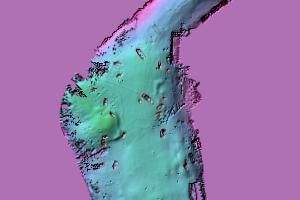

In [5]:
training_data_wrecks = gis.content.search('title:training_data_wrecks owner:api_data_owner',
                                         "Map Image Layer")[0]
training_data_wrecks

## Preprocess bathymetric data

We are applying some preprocessing to the bathymetry data so that we can export the data for training a deep learning model. The preprocessing steps include mapping 'No Data' pixels value to '-1' and applying [Shaded Relief](https://pro.arcgis.com/en/pro-app/help/data/imagery/shaded-relief-function.htm) function to the output raster. The resultant raster after applying Shaded Relief function will be a 3-band imagery that we can use to export data using `Export Training Data for Deep Learning` tool in ArcGIS Pro 2.5, for training our deep learning model.

All the preprocessing steps are recorded in the form of a [Raster function template](https://pro.arcgis.com/en/pro-app/help/data/imagery/raster-function-template.htm) which you can use in ArcGIS Pro to generate the processed raster. 

In [6]:
shaded_relief_rft = gis.content.search("title: shaded_Relief owner:api_data_owner",
                                       "Raster Function Template")[0]
shaded_relief_rft

<Item title:"shaded_Relief" type:Raster function template owner:api_data_owner>

In [7]:
shaded_relief_ob = RFT(shaded_relief_rft)

In [8]:
# ! conda install -c anaconda graphviz -y

In [1]:
shaded_relief_ob.draw_graph()

We need to add this custom raster function to ArcGIS Pro using Import functions option in the 'Custom' tab of 'Raster Functions'

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAARgAAAIkCAIAAABKvKOQAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAADs9SURBVHhe7d13cJzpgef37vft7rdzDmjkSBIEcxoOyclJ0o12Nd71reS1Ze+dd89n3bp8rvX59If3XLar7tbl8r+uvbqqc5V2Je3tajTSzGgCh8OckYicY+ecwxv9NNCcYQBAYvSQxGh+n8JMdQLQAN9vP8/zovttdS6XU62Jx+PpdFpRlPWzAPA4HA6HIIr3hVQslVQICWA7LFZrtVK5LySzxaLVatfPAsDjUKvVsWj0vpBcbjfHcetnAeBxyLIcDASY+jmAHYws3cn2StBaw5MvJd1FTtcv/S1gRIKdjsRTKBQCgUCxWHS73X6//7fcSgVBIGNIMpkkp0ulktPp7OzqMhgM69d+gQRWLpfJYken061fIopipVIht2RZdv0SgtzsGzoiKbKYTUTDiZyEHStfB2RrHh4evnTpEvn/+c8/n5+fJxt0/bqvhIxu4XB4dXWVfOVz585dvnz5i+HkXmSwGhocvHnzJoln/SwJ5srly4lEYv0G99o8JJkPz49dvlh3dXAyXRTqVz1ZcjETHr55vf6NL14ZGF/IV3+rX9wDZL68PHLl3M2JfLV+CexkZHMn06W9e/e+/fbbNpttZnq6Wv2t/uXI4yfDsq1tbceOH9cbDGpm4woYhiGDz0B/P8mJ5/nFxcULFy5Uef7e4egLW4QkpMJzs1Gpobmjq62FCQ/+/P0LscLjtlQtJG+eP3tzcmX7BSh8KTG7lNDbGrtqOho9Nkatrl/5VVWysaufnR1aDJPpMMOZ9jz32lsn95jrIzbsaA6H44033jh+/DjZrI1GI5Udy2S6qFarSRLk//WLHkKuPXzkyBtvvkkGpb/7u78jA5fJbH7ppZdcLlf9Fvd4xNROZ7A0NDY1t3cePHzEUlyeDBbIhbIkVMpkblkqVyqiVF+okQur65dWeEmWKqV8NBwLRVKlSnX9JuQGtWtLpSov1laMiiyQBxah9mmVqkBWkWtfpk6t4ZxuX3NNk9/rMulYga8Ikrx+I/I55DPJGUUSeV4QxfX7U/7iBoQsiZXy2v0plXiBL5dz0Ug8nshWqlXyO2R0BvLYpln/6ck94Svrt6zwwvodIdM/cr/Il67WrimT+7n+lRVZIpfXLrrnZ4cniowMFouFnBgcHIwnEm3t7Ruukch8b2VlpZ+4fXv9Y3x8PJVKPbwvYW0Xg0RWSmQzIkWtn61fdz/yrTs7O7u7uxcXFsi/++FDh8hms2F77I9//OP1U2TjILlrNJr1s2REigcWIhXr7k6/XstI5cz8whLr293t0ecT4ZnJiYXlwNLiQqqqsdttWlYdX52fJBeuhJYDaafXFJwcHp8NFGqh8Aa7VycVoyuLUzNT5EcNpAWLxWrUSKtTYxPBVDmxvBDOc2arSa9du4NKJR9fDBQamptd1i9/Xwv95xdyerfXSu5fMTrTPxYwOb3acvTWzf5ovhJZWSRT50iaNzscBi2jSHxiZWFqdnZhKRBamctKluzq2NR8oFgV+GrVZHXmlkdHA0WPx8UqQiEVW1mcnZhdCgVX54I5jjOYLXopF+u/NRAqM9mViemZxWCiaLA5TFp1IRmenZ2aXVgJhhM8Y3TajY94KAJKlpaWLl28ePDQITLH+2L1f6/aoj8Y/Ozs2du3b4+Njc3OzoqS5PF47Hb7A5s+mSjOzMxk0ulYLFbb5aBWk9u43e6H52wkNrKampicNJlM5CGY3KC1tfWBm5EU87ncY20GEl9aWV6RuMZ2n762UmN1rqau/QcOtDp1UwM3F6N5UUgOXLmW03j3Hjiwu8Wl5cyt7e0Oi6WhtbN3d6eJFYKzd24MLlqaevp6u/mVkWt3lnlFKqWCN24NFYzte3taLfq7Aa8RsqTV0cHBocGRiZVolow06cDczGJ8fWYpllIL80vpkihV87MTg2PLmeau3v29HeGxKyOzYV5S5YLjF6+OMLbGfQcOHNzboeMsbW2tdoutqaund1cHabiYDM0uR8qCqpyP37hybSYm7dp3YP++3dbs3Odnr8YrkixUlmeHb/ePWFsP7N/dkp66eWUyIvKFmfGxlaTUsXvvnq5WvYq/bxiFJ4k8xO/t69uzZ49er69fdD9yg97e3jffesvr9ZLTZFXw8ssvk+2ejCr1W9xlNpvJ1+nu6ZmemTl95syrr75KKnp4nCFlriwvX7xwgdyeTPCOHT06PjZGKl3f9/CArUIiE6fkyuSl8+fe/+Cj4bB8+PljHU6zitHYXT6/20xCNLtdFq2UiCYEgc9GM7my2myztXZ3WLUajdFqNhk4g8nhdHKqwtxcgNdb3DYjozG1NtrCCxPRtUlibR3U7HE6bHeHozqWM9e7l8nErfrAxO9eZI7W3tnR4CUTwaZWnyW6Eq7wmemb/aKvt2dXl8/tdDbu2d9h4Uw2k0FvMJqdTqfpi4czRUiGluMVbtfBAy1ep9vdeOTMMasQnFlKkaUdw1pa9x/vbHT6Wlu6W5yBpbBarUjVYooUrNZ5G/0dbf776ocnicy+yPDy8E7qe5FtZt++fW9/97tHjhx5+ZVXyMLgyxnWPaxWK0mOtEQKIdM28int7e0PL71ISIFg0GyxvP7aayTIE8899+prr81MT8ei0fot7rFVSGpWY/W29u0/0OlksrGowBo0LJnxVeKBxZH+wWsD/YPDE4FkgZckVuM8dqI9OX31/Q8+vTUVlL9cqhCKzJcKhXw2FR0dGBgYHFpO8j6vnalNXLV2m1Wn2+BHZfSWrl17jxw5fOTQgc5mr5bd9H4yai3H6WqPJmo1o9GQ7pRqOpLkPY2N1kctShWVVCrleLXJaVy7KVl9cnaHXslmc3ztnNZsWptbMuQ3oSFTcI3O0r2n1y6HP3zvw1uTi6kCuRU8JaIgpFMp8vBdP78JMv6Qseitb32rra2tftEmSHVk/bPhLHEdiZAE+cbrr9vWJofk7IEDB773zjs+n69+i3s8Ymqn1Ztcbs/e51492qQZGhpL5PlqKTU6OBQqGY6cPP3CqSOtHktt4GC0Xc996523X2szFG9fPL+YvW/pxmi1Os7c2LX/5Zdfqn288da3X33eb65dRe7fgwPqJsgviPwS13+NkiRu+etkZEnieUH9iN85wZCxUxHJSu6LXSbVqqTWabUb/17UrKNlz2tvvvnise7VGx9dHFqsbLxGBfp6du0688ILj/OnWLLFkzHngZXMw8gQdPr0aTIo1c9vxEJW8/fsXSAnHA4Ht9Hc8hEhrdMYbHuOHlZHxvono9VqLpkq2ZpbfBZOyOczhdLaDu5yRWC9LV1HDvQ6pEy4KLOshqz5+dp+NLVG72hwaFOBQJ7R6MgvQpFFebN995uyOGzVXLpMtlypElqN5IXNd8RrvT3d1sDU+GqOrw2N5VShKjMsq2WVqnjfhq9WaV1Oj1GIz4UztVsqfDYWSMrWRq9jw38ukmepzBscDUeOP7fHw2QS0dLT+dMarD2Skooe+4H3sZDkaH3BzffaKVIhFUlWjZ1tDXotozXZLEphdHzRs3u3XczMTy0ms/lEMpnL8/aG1kZn9dx7NxO5+HIkb/a19e1psnCcVi4uLyymS2TLa25ptBVW50amV1OpWCQUzTPGBpshn4ymFVN7k5dj7/1hFLGSj8VLLr/faflyeza7bNm5idnVWDKVkqRitqhp697l0JSXVmPW5s4mp4lRy8lwICeZO9qbGrvaK8tz41PTiVQ6NDcbN7a1u00aMT87t5wvVcx2r1yIxXl9d0eL3elwmpm5O0MryWxkdSkQKbfsOdTX41Xz5XAoyjW0t7uMZKDKx6ORqvFgt212dHBicikUCYXzhl17+5ob1gZk+AYj06R8Lrf5c+0UpVLI5ASN027WMLUNXSrnIukiZ3HatHwilq5KKs5s1jKyliNLCTkRiJXJjVid0+O2Gci8UxEqxVQyTYYQV0OLWSeX85lEIifWVl56Z4PLrGEr+UxR4exW430dkW8klDPZitFqNeju2UoVuUi+QKYkswanXVcpCVanm1MLsXhKb3eR76hWy2Vyhytal8OkYRmhnE+nksXaKkbjaW42axW+mEuksoKidvmadEI2w2tcdgtZfCmSUMwk47kKeXDSmR0eh0XLqmWxmkplWbPTYSSPLORbp3IS1+A0FjLJdKZExjXO4va6zdjZAOvPtcOTVgF+K+shbXOlAgAbQUgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKNjqmQ2yLCs0DvkFsHOwG71C6bchSVIoGLwvJLfbXXt29l3JRCKZTD78AkOAryme59s7OoxGY/08DaIoRiOR+0PyeO59ndPK8jK5ltRVPw/wNTc9Pd3X10e28/p5GkhIiURiq5BWV1a0Wm17e3v9PMDX3K1btxqbmuiODQgJvnE2DIkscqLR6OrqqrD5q0U5juvt7d3w5bQICb5xNgwpn89/+umngwMDZAVVv2gj3/72t1986aUvX/l613pI2JEAXxuZTCYSiZDRg5yoX0SDhmX1HLd+GNfNkLHo4cMM3WubI5JYnhofiaRrr4U1WJpb2szFbMXf3GziNJu88p0Pzi9oPF2+9SP6iJXoyvxMICHJir2xq6etycRRKlkW8+G5gdnI2hnrruN9jesHANomsVqMLs/Izp4mtxmPMTtKKBS6cOEC+b+iKB6P5/Tp093d3ds94sKGI5Isy7FYLECmdpsfm59l2ba2Nq/X+/B3/CojkpCtHXUyVVZIwIxapdUw669C31QxcOPcpUCxfjgfsZwfHb4ZyvAcU7lz5dPBqZC45Z+pCulI/+BA4jGOdS+L1YWxa/MJnsxlOY5Rb/PPX+XI9KX+0VSRZ1gto6W5bxSoIFvqBx98sLi4SB7Wd+/eTR70f/WrXwUCgfrVvzWGYTRaLallM2SrIoPSFt3ef/ATk4l8zvpZIpfNkrN2u71+XpEy0YWFcPnoC6/v39XW5LMUU3m93W3VlucnQlWmsDA+GS3IZquZVSrR5fnp6bnlqTsTRe+pE7vMa4fZLmQis7OBnufePNrXycdmYoKho9krVRLjg6OLZPhLVW1mfS62PDMxHcwKZl115NbtwcF+3tDodVmK0YWJiZlALKMxOeRMJJxIRiOhVFFtt5vIl+YrqYnbQ55jv3fmYFdLS4MuH1xJK2argSnGR+ZTFpMqHoplc6mVhbloumqy21mpFF5emJqZz1QUViqO3bp2aWTBZPfZ9FK+qG1sdjJ8fmVudmZuLlNRmS02rZSZnQhVmMLi2s9otZqKiaXpsamVZEFrsJjuP0ws0CVJ0tDQ0MjIyFtvvXXmzJmenp6WlpYbN26QyVhXV9fDG/faYdtqyOkHrg0GgxarlUzV6ufXFIvFq1evXrp4cXJycmYTU1NT5LMaGxsf/rMqGdBIO9sZkWQ+Fw8kkqpKuZDKlYRKYXb4+sRKSkgvffLRZ0OT06Hg3GfnLswF4+GpG4Pjc6lsZn5+RbG5HXfnfdXcaiReO6ZVPBqKpiSzxVRNzV45f34pWowsjJ2/MhCJB4dvXlkKxMLhcL5YjS/PVzQNnJYvhaYvXb++FM4sD9+8OTKfWL397rsXluOZilg/tr2YDy4FeVZVTWXzvCjHxy98NrBSUSnF4MT7l0cr+Xj/5bMXb40FEtFL7/2sfy60Ojl07fZYMpWcnhyLpnOhUNpus0uVfGpl4vyNyWI1Pz8yPDwXTKXTAxc+vjUTrSSXPvjws+HJ6WCg9jMuRUJj1z+bWU7EI8FEFofkerJIEtlsluf53t5esjWTwaG1tdVqtZbLZbIR1290F6mODF9LS0tk+CKrqcd5AxgSmySKgkBmdpsjV29xBLhtjUgyXw5MDNxeSFby0WBGaLBxy4vT1tb9lsL8lbnk4RMv9LZ7I+GQ2aabuTVp7D31wvH2ymqA8ff2trnWjxOUXBi+Ph1MBqZHZuJ9z7/S126duXY9wHW/+eoJp0asqq0drZbpG7ddz33vxYPtVqtDyi7w3uOvHXMPn7sUNfe8fvqAUkzGeD1XXknpWl584WRng3397haXRy9MRvhiciUY05nN8YkrSucr+/zs8p3bS1LDQY8yNbvYsPf5Uyf25SYuBEVrIRL17Tv1wsmj3S0+k47JZVLefS+cOtCeWx5ZkL17bIWh4eXm/SdOHu1jc4vzUd7JZK7NpY8//0Jvh4f8jE6/L3HnFnPgu68f3+206DUPHAYJqCKDAJnLzc/Pk1WK0+kkl5DH2YGBgaamJjI6PTDmkBuTLT4SiZDt2WKxmO7fpDcckTQaDbmly+Vq7+iovZHQRnp27SLfa8O3otj2iCQIlVhBPPmP/ugf/2fvvP3CQUWIp1KyzaJPJTLe3YcPdnoZsWrSO+zVyFzB37evWZWOr+T1Tc32+runqORMrtT9/Fvfe+O4UchrHT4HU15McXv3dZjVlWQqp7OSOZT/4P7WhdtnJ4I5hpXTqZTV49Ll0kvhRDYduHrh7HxRf3C3IxcrtXTs9lr0d38mORpL+Y6+9cd/+M4733610yeGgoamJqdaKEaSqvZWd7la1ph9XS2NJk2mXLS6jNo8Y/X7bVpGpTdZtUqlwPN2MiOVC+FQ1ut1K5l0Vm1xe6waVmF0rE6txONZ/77nDnZ6GLFMfkarybf38P7owAfXpxMMKnrCyJbqcDh0Ot277777ySeffP7552SBRILp6Oh4eKJFkMGKzP0aGho8Hs/Wu9q+QGaJJKQtkC9F7sPDFX1hGyHxpVg8JrnXntjK6TRKNlZUN9tMlXhCdLucrCJXilWGs9pM2qJWoxGKS7Pjs6my02Sof3MpHY3kbTaPw9vss8nheFpWVLJUlmQmnw4sBEKshlOVq50nv3OkgZ2fm09XA5Gg6LTb1Cyr0XP+htaOrj2H9vV12MR40eZrtH1518VMKJQzG221O0YIhWSRTBv5RGBxJll1OwylQkrLeS0WgzoXj4vNzc1GSZZkWV0uFsqCWComiznFbDIqpWw0rXG4LQwZ6mVFraj4bDwZq1qdpkJBbmhwsbJUKdR+RoYv+Q+/+kKvf2lqMlLC+/49QWSqRoaX0dFRMr0iI8nw8DAZi8iY8+abb5Ihon6j+5G6yMBFQnr4bz4bIlPEwYGBDz/44P3Nvffee+Pj4+TO1D/nIdsISSnk8rqGRlf9zmk4Nh1ZXlpYDYn6BrdJkZWqILAmg7Ght7lw69fvnxtdiBodTvMXz4ItZNKKw+8xcAZbq9eZCIaLek+Hqzp4/jcXbkzkBbXNpp278pufv//pXFLtddsNGotayE2ODkck67E93uXp6bmFxXCqkE9mSg6P13zPI00pH+ctjY22+lldg8+dufDhxwMjS1WD0W0y5qJRlbPBzKkqsVi+uaXD7/drEpc++fDcp1dWi6JWb2aqyf6hibSkVlWzS2Njkqvdp6x8/N4v3/3VuYq3b2+rK6foW3xGMlmv8FXWxEaHzv/0vd+MrJYbmj0W7rEe8+ArIL9wMou7dOnS6urqmTNnfvjDH37/+99/5513fvCDHxw4cGCL0Ya09JgVEeS75HK5VCqVSac3+yCTI7LSeXhJ9oVt/B2JPBrHc4LL41h/AxZJyAfnIzq3R6OW9EaL2aCrlguFKpnsWYrRuViZNRoMZJBxOB31PzIJ5UiyYHU5jBqmkk8nS4zX65CKqXAsqeJMJp2W/E/JJ2P5ikZjcHrdVqM+H55N8AaP12thK4urEUnFmm0up4mN53mvy6G7O2VUSXwyldVa7FZ9/TdbiK8G0xWTxabVsGaLVVUIF7Ver00vFlPLebbLZynnUuFERpINTZ0N+tpYGUpUuZYml5BNpEsqX3OjuhALxbMKw7mbmiwaOZvNcSarkdNWS7kCL7N8MZ4tMazO7vbaLQZM7p4QnufPnj07MTFx5MiREydOkJXM+r44YotZ1hY2e4rQyvLyzMxMdfNnNpAs+/r6WltaHj5oPRkq8RQh2NHICLC4uEiGF5/Pp9frN1wRbcsWT1ol32uLAYcg6d673+IL6yH9tvcM4Mkh5XR1dXWsvYLot69oa+uzwS1sWNEXEBIABQgJgIKt1kgrKytkQYc1EvzOGBwcbGpu3nCN9JU9emdDKBgkLblcrvp5gK85ssXv6e11OBz18zQ8OqRyuUz3hR8Az5zX6916t8F2PTokAHgk7P4GoAYhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKHhSIUlCJR5ajWUK9ZfYA/xOe9wnrQqZ4KUbQwVBUSTZ4uk4cmyvg9vqKC3VXOzS2U8r/iPfOrV366Ps8OWiSmvQbnkQcbFaTK5MX58KsiqZ59yvnDruNG/55FpFqVR5VqvVstQeKeRqYXlxcmYyxGsYmVfvfeWNHucjjtMv8pWKIJuMxq90oA74etjek1bFYmJ2Icz5Wvd0N0QHP/vkykRB2OpIETqT89hLbz3f1771MZEURZ679eknAytbvTGNqrpy6+NPLy359xA9bquhmN/y5mSjF8u3z/16cCG56bsLbJOQj41f+vv3Lo3LjhZyJ9odmoL86Kfi5yOTP/vpP/TPRuW7x76B31VbHbL4XmI+OraU2/fcc3vb/DohMhNSuls9ganB1Uh0dnpVMFqYQmxipH9kYmYmmPE3eFm5EggFRMbgMOkK8eU7gwNjkwsltdnpMCnVQmh+7NrAyNziSiSwdOfm5bFgmXxrp926ybiUm7l6Zdl66Fsne31ub4vfo5UKi/OTFY3DatCK5dz89ExaZJV84NrV/pnFoMRp8/NDZ89fXs2qbA6HhWMWR670j85G0mW9zcZUspOjA8FQZHpqbCUlm1S58TuDo2OLosnpsOg3flxRqisDF/7m7Nzzv/ePT+/vbPCSO9Fq1wnhuYnZQNFkt8iF8NitOyW9zcQUBq7fnJyaXQnlGE5ZGLp88fpooSppLZ4GizoemBscHJmemgok85zFY+KEyMTt6yOheHxmZHg6UpD4+MztgbFAvMTZbDhc3teFvO2D6K+RRL5YUllNelYsjFz58PydVYPdbmGL137zy6m4ytPkUUeG3z03ViwVpsaGZoOpUjp06ey5tMrit6lGLl+aT6YXhy99dm3K4PZbDToVw9msZovd5XJaSUSbzIAsuw/tL63e+s3Z24F4RlAxBj0TnZvsnw5WZaWcWxkemkinV65++HnF1OS2WSSB11sdFrPZ5nTZDOr5K+9dXxQ9Xkd2YXJgJlCuFG+c+/XQSsHmNk99+g8/f/+aaHQYpejZ87c2ff8YobC0sJhz7D+122fkag80jIbMgKuLk/3Xbk0WBEkox29+9tnM8vLY9Y8/HgqbHR6zWuQ1GqvVouc4u8vjsulD04O//vBcStJ7fZ7Q8McffHo5WSisDH7+q48vxKv6UmTil3/7/308kXVZVENXL9waW93e+9LAs7aNkMqZ0J3bN6/euLGQN3R2tXBaRsfZO/fs23dglz0zNhHn9p88c3jfkTe/czx568oiWXkpteMCk26GF3PFSjUvqaViYGlmdnw61nz0xdNHDpw6c+q540dafU53Y3t7s1ev3WyypLXvefGHf/gyExn74Oc/PXf9TlVr6+5qiE6NpUp8JhTkGlpb7KZKpViWJG9bR09Li6elu8Ftb2pt92sSF6/MlFhNqVyRpfTiXKAqqvW2hr19+/btO9XXqlHMvt0HD5082qcuZtJlfuMZGM8XykWj3a57oHTyA0q1t8NQyClRklVKqVjMpWPpsuTf09vmcDU2NpCcG1o6Wx3qudnJrOI7dPjggcNHj+7rycwMrqQKsqIymH27Dh89drDHXJKa+w7uP3igScsvLwdL9e8BXw/bCEnHGfR6zmjyHDx58lBvC0dGEI6zmE1aRi3zQlZpcLo4tUrNGoxGIZu7uyGoy/mK2uywGTm9re/5l7qdXL4oczbj2tFXmcfdG8BoPI27f/+//pP//FuHIwM3+0MFa/s+vya7ElhYXkm7fA1Ob+frv/eWNTn0yfu/vD4TE8kWuk7iS1WVz2fR6wz+XUdOH+7WMopapzMbDVqGsTlsBrPNwDI6HafndOSTNg7JYPW7HVJ4PrnJ0oz0VDu0oNbad/rt75/0zV761U//04eT0Xz9akKR+WKB1xgNOvLbUmsNDqOmWq7W7qZG47BYGDKjZlmT06knt60NzFsfqhB2nm2ExBocu/cfOnb0SE+zR3f/UXpZd7utND47nxJVQmJ2Lufs+uJA3AZfs98gOBp3Hz52sM3f1OD32fTllZlgRSUXc5lUpkA2IoEXNj04eU05tBgskKFErdZbHGQdJZfKOr2t3a+fHhgIq12NPq9ayFWNra+8+e0+n25+YaUsqjQqRhDF2oDTIFdVjX3Hjuzu7Gzx2rRf4fjCrKHjwJEmefqDi2PJYm3/RTW+Gq+weh0nCcUKL+UiC+GcpKqWqoqu76Xf/8PvvcFmZyaWsrXPFUVyN2QNmdE5pEwonCmJQjUeW5XNTS6rceu3O4Svkcfd2SAVU9PL6eaebo+pvt9ZlvjVxVnOv7vFbdboHTZNfvrOzYHhkekkd+qVF9ttysLCHGtr2dPTrSlH+m9dGxkdCxZ0ne1tPoc+On376uDI5HzI4m1usKnuXLue4HUNDW4yu9to08pPX7n00flrY+MjYwthV+e+w7vbLOSxXV28eW3Uu+9Eb6efzc/95r3PhiZm4gW2p7e33e/k08t37sxI9pZDh/bMnP+H/onp6ZWkxemzG5SV5QVfx36PlUutTiWYhr3dfk0lM7Oa8be3ucxkUH2Y2mBzN3mcgeFPrw/PTI7dGeyf1PccbrNKS2PDEzNzCYETs8XGnrb80sCnl4YXlxa1vt3HD+/3Wbh8ZHZ8drFqaju0q1mVXbrRPzI5PhbNs4defmNXoyW7MDGfdx8/3a2Kr87OJFpPHGkyqlam53mrv6+37au8CS48des7G7Zx8BOyAFBrOMMXfz5SlEopL5GZnL52VH2ySqgUC2VBJgtxi9lYSYfOnvvc0HnqrWPdZClRyGUFWcXoDBajnlErQrVcWHs3FKPFpmOVYjYrqHVWq3mTPybJIl/N5csqMnFkWDILM+rJ5i6mV0c/Oje+71vv7POb1LJQKZfJZImMsSaLRUdGLbFaLBQZzmzQ6/hCqkzGM1bL6fVGTlsppMk6iUxN5WoxV2VsVoNakYrFKstxm6/Taj9vtZQtVOW1u8gYrDaDRlXK56qCxOiNGr6k5kwsIxWKFXIDjc5gMNQeFsiULku+stZgNRtUYiWTL5HpHPkhDGYTx9b+0JQryBaniRGr1TKvNhgNGrZSKooS+c3U3tITdr4neBShbDwYCQbHl1I9x07ub777FrT0kGoS8fDi1ERMan79jYOG+sUAz8ATPIpQMbawEMq09vR2NVjrF9GWjwfjkuXAoW5UBDvBExmRKsVsRWQMRqPuqyztH4MiV8rFqqwxG/UsFuzwTOEAkY8rWRJjxaf91uW9Hoy1Xw8I6XGNx0r/y6eri+lK/fxT8de/33mm1VI/AzsYQnpcuao0Fi0V+Kf6N9I+r6HJin+LrwGEBEDBE9xrB/BNg5AAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACFtQFa29wGAZzY8qCrK4ZywrTr0GqbBolHjMJDfSHiK0MZKvDyXqIrbOaSjXc92OHUI6ZsJTxHaCuno8T8AvsEjkixXA3OM0aJ1++uXrFkfkYSHlj6W6BWVIpftvaLeU7/oLodhqxGJ5/nx8XFJrB1+SJQkg15/8NCh9au2oEiSIomM7uEjoCgK+VK1457hUKw7wjd6RKpUKuGpkdzozdLYDSmbrF+6JVv4nHv+b4yZsfr5xyYIwvjYmH7N3Ows+aXfGR4md6B+9UYUWZaKOTGfkavlB4Y8EphULojZlCxsclxYeBYeEdK9j8vk5JZ7qJRCqfL5ZPInw/G/HUleC1eqW92YCiWVLg5GKgVxe9+JbMTDQ0PvfnJuLBhXVAzZNOtXUJVMJG6vuXPnDhn2fT7f/v37yf+7u7vJsD85McFXNy9BFkkniiSIxZzMf3mzWkWlvFQpyaKg3HM5PHNbhRQrCn99O3ptpXbEUPKwOJMo/99XQ4vpjf/9QrHCv78e+jDC241al0adSpWyj9w+Bf7dG4H/bXDtQIrbJEry4nLyx58u/9VwNlLZRkiCpNxezn5ya3w1Ep+uajR7jmkc7vp1VMVisWgkYrfZPG43SejDDz8MhULk8rNnz16/fv3ChQukMTJYrd/4AWqNVmOyqhlWEQWxkJH5teFLlslpUhE5yRpMjN5UuxB2hq0OENkfKv4fF4LnFnKH/SYS1b+9HPpkNtNo0fV5DQ8cckQWKz+5GFzgzP/0iOc5v2G3x9hh15QL1VuRqt2sZWVpMlgMCWq7TrWaKA+GSzNJntGq0+n8z4aTH8WlYw0Gq5ZRi8Lt1cJYorKUE1ithlySzJZHwuVgoToZLy/lRDLhmYwUx+JVs4XT8/yFuUK8XJ5XDN9pN7k3PK7jQ0RZubpSeHemlFabu+zsd9563dPUrGbuezQhpaVK0vrYq1Yklbp+rTVykRXyZef+qrnjgasMWoYskx5YIyXicY1Gc/DgQZfLRX6ryWSSTKYLhQIZVBiGIf8nv+22tjZym/on3EdNWlIzGkXgFVlS1mZxUrm4VpSa1RtZo1W9yaE84SlbP0DkViG5DBoNw1xezl9Yyt1cLcwkK2/vcvzxQbdd/+C/fTWT/ssrxecP+r7TxGnJ9qRWkS8zt5L8N+eSLR3WNq387tXgL6Nyr136DzfjcyWVWBLyasbESJ9MZRNqTZ+b42T53Fj0lwHBoFbGljO/DvCtLr2Uy/7b3wQmZZbJF/7qSmyaVzFC9cpk6lcJ9StdluMN+lSsMMBzb3c8VkhlQb6yXHx3IlMWlK4G57dOHdrV7Hl4D8GXISmyJXpV5FwKW9sB80BIXHFFVwqKei85vVlIxXLF4mkk365UyEcj4T179pAF0iuvvHLy5Em/30+Go4aGhk1CqlFrNKQWMiiRGR2Z4CmSSPpi9SbWaFGzW7/vFDw9j35bFzPH/tE+539/wreSrd6Jlv7RLvufHvOSEal+9T2knBDRMm6DZusHyUqpeidS1Zq4V/rc324x7vOZjrq5Bp/1B7ssumrpPy0Ip/a4/vkJ3z8/4mLi2U/DFbL20WnZg222f3ra/6pVFS2pXj3g++MeQ3glv1De3sKmyMvXVopn5/Pki3Y4dK93WXrctSPWb0Eti/bQp47AByyfqV90lz477Z7/G0Nmsn5+E6TG5aw4neQ5o5mcXV2Tz99zcP1HUDM6A8sZ6+dqg5GWTOpQ0Q60VUjkAdZl1P7wkPtfPu//bw55/uyYr8Ox8cbHWLQOXsrz5DFzKy6f7UeHrCvzsb84G7qcWNsfvE5RCmUhoWZ3WTXkQdds0Hp1qkix9o4pWoZ16FkNxzZq1R6jzm1kjBqGk+TSdvYv8JIyGCp9MpeLFgWbnv39Xtshv+GB9wHYkFoWbKFz9uAnZCyqX0TGovy8c/kX+txc/fzmyPeNFMSlrNif1lbani+7djk8DWReV7/6MZDZLJna1c8QZJqHv1vtSI/4RyWzFZte8+cnG/7ijL/Nzm12MEatzfk9N//ZVGo6JwmyUhWkAq9wGkYrS1leKVX5cFEUZZWksM/vb/x/vtXyB7by/zuSWS7KGrWqNnNRMz6rrlEUxnMiL0rxAi9qdD22tYUYmSfWvymZOqm/0tEglWsrhb8fzyTLUrNF96Pn3L0e/ZbvWFunsNrw3v9RZrSOlV+7Fn7GiCVGrpqSg565n5CKCp7jucbX6jfdBFn3ddq1B71ct0N3sMW5y2+3GPVkJlB7V6VH96CQuVxt70K1REYmtVanYhgSlZhL1vaJww7zWO9GQbbo2rshbb7tMYx6T7MlGci8v1pJFvjJcHE1IzT7zepsoT8tlQr8bJLXOYyH9dWfTJciBT5Zkbua7Me9erZSvhmp6q36dpuhVcv/YqHCV4SxWMXgNr3TbdPw1bEw39Fm221lJheyWZP55XZDKVkaSirP7ba2alVLscKMzL3eanTpNr1z6krq/7qeqUqqTofuBwed3U7ycLBVRffsbFDLWkvV2sXlF0zpUVbIqhVZVwozUrnkOhjb9c9kbW3CRmy+RqqK1oZoUcxWZfLBy6pMaDEaCoZCoeXlZfKrbmlp2WyNpIiiVMrXmqmti4was53RaNfXS4rIk9ldbYK35Q8CT8ejdzZsh9rAaXsbjA0G8gUYA6fxOwxdLv0ur9HBqk02w6kO2xGfvsPJaWRFq2FbvJbX2y0NBsZnJwlpdQzTYNMfaDC2mhiyoPbY9afbLC0m1sRpGuz6Tifn0GncFl2Xx9Bi1pj12k6XvsvJmTWM08y1OfQdVi3ZjOt35H5qqcoUg4os6Djja9223a5HH+L43r12hMQ5RL2LKyyzQoGclTXGgue5VOs7EvflmwNsEVJrSzOZmroMtQ+fiU0ElohMOl0oFDwez2YhkVrEUm6tIoblDKzJWiuH3JJhFaFam++JAlkv1S6BZ23bb+vydRRYnHaoU1pnW1q2OCzmx1kXPfwUIbJSMqaG3Qs/1VTTee/JTMt3eYP/i33fxIZPEZqcmEiks949R4t3jyxp1jGzt843NzYQ5KzBYDCbzRsumUgnQjZJJnIsZ2SNZrXm7rOByHSvUiQjFSlNY7axRhyK9dn7Rjz7u1wqSULZbHWQHB5zIrThc+3IpE5TjrBiQdJaBAPJ4L4vtWFIZCFEhh2L1SbfsxyqlIpkyCYJ1c9vTpEEMvLUBiLmgTlCbe20yVXwDOBlFBsrC/Jymv/yXWgfg4VjW+3aB0KCbwiEtDGyPNruYb5JQBb9k3kDG9jxEBIABeshbeOPgwCwGYQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUPCUQpJlOZ/PBwKBZDJJTtcvBfhd8TRCIuWsLC9//NFHFy9eHBkZ2ezwogBfX08jpGq1OjM7q9FoXnnllSNHjuCVGvC752mEVC6X0+m0r6HB7/fbbDa8khR+9zzxkEhFiUSiWqkY9Pr1SV2lUiEnvjiwGzkr3nOsSICvoyf+CtkrV65MTU3lstmWlpbu7u49vb0TExNkyfTyyy9bbbZAIDAxPk5GKq/Pt/VIRa41GAwWi2VbRyoFeNKe0kvNSSqjo6PxWOzkyZNOl8vhcIRCoY8/+qijo6O7p2dgYMBkNJLTwVCoXKq9YclmauOXorS1tZEUtVq8WR3sFE8pJPJt+m/fjkajb7z5ptFYOx48mdeRS/oHBuw2m8lkOn36NMuy+Xz+kbvFyT2MJxIvvfSS1WqtXwTwrD2lYzaQb5MvFAxG4xdTMpJNa1ubJIqxWGzXrl2kJZ7nzWYzmemtf2yIzOs8Ho8kSfgzFOxATzwkMv6QQY90sn4wZFICGZ2Ghobcbje5ZG5ujoSh0XEptWW6ZCQfk0XDqmCyOlwkm3utH9oXe/xgZ3oaI1KpVLJYLCQb0gwZhe7cuUNGJzLTO3PmDFlBLSwskJDmU9XBSGU+K40lhAvLxdV0mUz2snfhb7iwwz2NPWAall3f21b7y+z0NF+tHjx4kAwyZIJHxqWlpSUSGMsyTTbuSJNlX4PJptfk87nR0dFba/r7+8kgVv9aADvSEw+JJHTiueccDgc5rdPpuru7jx075vP5SFccx504caKvr49M28iMTcOotWztg5wmU8Hm5ua2Na2trY9zsGyAZ+iJh0Qi6erqstls5DSZ3TU1Nzc2Na0veMjaaXJqilzFVysGVpmM5N4biVycTZZ4gTRG+tm1pqenx+VyrX0xgB3qaUzttkBWUGRep8hio6X4XFPyqD9GPo758w49ds3B18kzDmmdrEjR/OJy5naqPB4tDC+kbhQfev9jgJ1sR4SkKAov8X6b72DzgW5vF7kkmU6Ojo72rxkcHEwmk+u3BNiZdkRIaxSVSs1pOL1Gr2U1jJoRBKF0V7mMtx+GHW1HhKRWq1k1G81Fx8MTy8kVQRJtNtuhQ4dOr3n++ef9fn/9pgA70o4ISaNmuq3+fUavT1IaVcw+S6NdZ2IYhr1H/aYAO9LOGJFkyZkL7klN783M703NdmWXOYmvXwfwdbBD1kiKUslqNKzR1ao3O5lirJiOJhKJ2tO94/FkMinilX+ws+2YnQ1kmcRZNdZGjdXHaPXZbLa/v//imitXroRCofrNAHakHROSIovFpJBaErIhWRK8Pt+pU6deW/PSSy95vd76zQB2pJ2xRlKzrL1d4Rx8pSRKarW1Wau3WK1Wxxq73a7X6+s3BdiRnmVIarVakWXyf15SCoa2Suc7lc4/qHT9Qbn5zaygS99PkkhheDES7FDPMiSdTsfzfKFQIIVUq9XKlsjtS6WSSlGQE+xAT/yYDVsgFV25fDmZTD7mn4kkWfb7/cePH+c4rn4RwLO2fsyGZxkSIQhCNpsl07b6+UcxrcGgBDvHjggJ4OtuPaQds/sb4OsMIQFQgJAAKEBIABR85ZDETCxceLynaFdL+Xg6J0r1t594mCIJ6UwmXajId9+iYl0sMD8zPV37WIlVxQ2O4iCUMulMVpSVUjq8Gojjma3wrHzFkGQxN/zpL0Zj9bNbUZRcZO5S/0imtOlBHmWhMjPWf2ch/EBs/R/9xw8v9Y9PDHzyq/duTG3wzfLB8fPXbiSLUjEdW1wMV+sXAzxtXzUkmU+tzmcfa8tVxEohnkiQcaN+wcMUqZhLZPKl+wckVSadMLUeeuWVN15qK529OPLwm1WI5Vw4nizxsqN5z5HD3XhCHjwr2/g7Uim2cOU3H3w4GnR6u777/Ven/8O/W2x5QzV9Iajf9+f/8k9a5MjFsx9eG11OpDV/9K/+5zON2qnbF6/3316MiSqN0dW77798+y11bOra5bMD03FF6/3en/5pr7lw4+JnN0anSrxRZeSOvvz22yd6Oe2Xbf/tX/1Z4chf/FfPexavvP9Bac9ffHd/cGrokwtX5ldiKq7lj//iX3hXPv2HofR33v7Dwo2/vqSc/tHbR+qfCfC0bPvvSNXsyp1p8Yf/6n/9n/7b7zXbOVlR62wdf/av//UxGz++FNYZnb1HX/onP/rRn7xk+7tfDyVT4ZGxcNOZH/7v/+e/+d4xeypZIquqwfOfz6n2/fBP/8lre7RXLl6bGJ+YjBv+i//hL//yz/+o0SCUyw+uccRianbo4gfvv39tlXvzuT2VXKj/6k225cQ/+xf/3Ss98pXzA4W7nyFLQkXAEgmemW2EZHC39Xbpb3z43shKmdMwnNG06+Bht8XgMjC5bDWXja4uLA/dur2SKatKpXQ2W2WdbW0+Datt6uprcupU2eCd2YhQid0ZGouIer9FHQ9mrI3tHqteY/Xt6mozcg/eGVZvdnu9ZlU1VWCdJk01FZ8LJDPxlYHbQ0nG6rXq1JvPFgGepm2ExNlbX3nnu/uc4u3zn8xHMmRaqKu/c54o8EJgcmBiSdh7/PSx3X6FkIUqX5YkRb32Vi4KWSApCmdw9Z049cKLL77+7XfeOHPIrikVq5Isk2tkYu1L3YfRGhu6Dr/5nTd65MmrEyG1Wq03e/qOPv/iCy++/tZ3Xz2xy1A78jHAs7eNkPLLA5enCw09e9rc6lJRUjNM7bmjarVGq2FUMiOWcsVytZganQrJKtbd2tGgDd64emNuYW52fHAlJahce0/sUg19djWcz60uLcezyu7j+4qjn90am1ocvz06s1yqPtgSw5JvodbY2n7vD04NvfeLJa59t4u/0z+crhRj8WQ+W6rdYO39y1imdm/KmaWPf/HzkcVEZuaTn/z0fCi8/LO/+fuhcHr9qwE8OeyPf/zj9VOlUsloMm3xigZFLE3fvj62GPXse+HoLr9GViwtvT4zQwYbm6+5b+9uMT15Z76w9+Bei7Npf19Hi9eWmh+/M7vKtR49uqupye/v3H/MVhq9PTwXr6jbevY2tzT5rcr4wOBSxdLXu7utxU++WLFcOxwkISisUc7pG/a2uY2M3e8TgiGx8fQL+8XI1MDITCzHt+3aa9erRdbk9zeaWEFja+xsdAqFLGf1uKxMNCY2drcwfMVod3mstbfcBHgSyGSKtLOjnv2dHT57eSScWj/j3XP69WNdZLAD2Ml24MsoxFwskSrVXgxLcBaXz2lh8Moj2NnweiQACvB6JABqEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQAFCAqAAIQFQgJAAKEBIABQgJAAKEBIABQgJgAKEBEABQgKgACEBUICQAChASAAUICQAChASAAUICYAChARAAUICoAAhAVCAkAAoQEgAFCAkAAoQEgAFCAmAAoQEQIE6l8utn4rH42aLhdPp1s8C3Eup/adotFq1Wr1+ydOnKIokSYosP8P78DBBEDLZ7JchpdNpckc1Gs36WYB7kS1YpVY7nU6GeWazGFmWc9msKIosy9Yv2gHIb0YQhP8fWGKtznM/kIsAAAAASUVORK5CYII=">


Once we apply the Raster function template on the bathymetry data, we will get the output image below. We will use this image to export training data for our deep learning model.

<Item title:"shaded_Relief" type:Map Image Layer owner:api_data_owner>
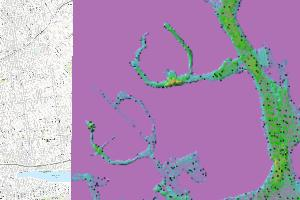

In [10]:
shaded_relief = gis.content.search('title:shaded_Relief owner:api_data_owner',
                                   "Map Image Layer")[2]
shaded_relief

## Export training data


Export training data using 'Export Training data for deep learning' tool, [click here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) for detailed documentation: 

- Set 'shaded_relief' as `Input Raster`.
- Set a location where you want to export the training data in `Output Folder` parameter, it can be an existing folder or the tool will create that for you.
- Set the 'training_data_wrecks' as input to the `Input Feature Class Or Classified Raster` parameter.
- Set `Class Field Value` as 'ecode'.
- Set `Image Format` as 'TIFF format'
- `Tile Size X` & `Tile Size Y` can be set to 256.
- `Stride X` & `Stride Y` can be set to 50. 
- Select 'RCNN Masks' as the `Meta Data Format` because we are training a 'MaskRCNN Model'.
- In 'Environments' tab set an optimum `Cell Size`. For this example, as we have performing the analysis on the bathymetry data with 50 cm resolution, so, we used '0.5' as the cell size.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAcMAAAG+CAIAAABgWPiWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7P1ntBxXlh4KZtj03mfem5nXewMPEJagd+Vtd0stPbV6pNdyS2/N+zFaa55m1psZzeiNTL8Z9Ujd6uqq6qrqYhl6giC8v957k957G2nCzY7MCxAAQRIgQBIk8+NlIuLEiWP3+fbeJyLOQXie92Zq2TIraqKJLwgYKnKqMRTFFGJsJ+hjUaqxuTLNcgjD74Q00cTnD0QkMsjQYo2zqMQCk/7v1xL/+u3gzsUmmvjcoSCxt36kW0qj/+SwbSfoYxEr1P7DOfdehzrP3BfzNtHEZwSXClkK5V8esQlMuh6nzm7mgV+baOILAYGjg2p6PoXcP5P+5JrvX5+wIhi5E9REE18EOJb+r9eiLzWYlGGYGk0jCLpzsYkmPh1u18YP4ncjiGjem5xJIP/0yP0y6V9f8/2rY8CkxE5QE018WpTL5Z0jQRQRsVgMvzvndWAYxrI785+NS0CbjVOeZf7yxk0mpYFKGeaumx9nQElvVqSJxwXVSoUql29JEY7jMpkMRe9LPcNdc57EQzJpQyq4umCgj58s12psjhHppdhjWLavM0BQ/+N//I/RSKQhqyCKTzzxxHPPP9+QZPilKGp9fb27p0culzM0vbGxYTab9Xp9g0xvMelHCDoCNIw0/h43S5Xn+EyZpfkvD/F/DQBSuLq6+tO/+Zu/+clPGn+/+uUvK5XKLWIFle52u5PJZENeY7HY9vb2ffLs/QASyhboS5uFUxuFd1fz57wVBrnDRP5iAeyZiJX+fDJX4JAmkz5uwDFMoVAo65BKpXcZaSDDiwsLN65fz2WzU1NTk5OTt9uwt3APUUaBhnPVX89lfzGb/duZ3EaJe4z6HhFVitVfTaZn0hzWlMjHBiBtDMtms9nMTeRyuVseEAAiRMLhs2fOxOs4f+5cNBq9xbMPCUglkaT+YjqXoEU6KaYikXyJrnJC4pADjiIgKrdyAptQCLkp+CDb8NcIbMg5/EB8IbBxWk/h1tUGbk8EIjROG9dvxW+cYsjOsVoreaVHLkWF9Os5QrQPSgVR6glCUZuzbI8eIGm3sBN0EyClVqv1u9/97o//4A/g7+RTTynk8g+cd56XSCRPnjyZTCTefPPNhYWFgwcP2my222W7Aezf/tt/y9XRyIOj2bGN7F+sVEdbJQ4VzhSrEQbv1+J33/fFASdxm5rQSVAFgTw+pfo6AKQHrMiGOGLYHQ/NITwQCPT09Dz73HP79u/ft29fPpdrb28HKWxEgFtAXtOp1LWrV0PhsNFo3L9/PzhWt65Gs1SEQvY5lI2Qj0epxs4GcgedSgQV6C6dLv9/pnK7urWvdMmcGsKlE/eZxDg4+xyfLNCL8VqWRfRSKDr4Ytx6vLqRriVrIpsCh1N/lq6xvDdV3UrRGIkpSSRXYmIUly4yoTKvFSPZErORqHqztEiMa0mE40XwvydRWU3WUkDcYpSqsNuJ6naeMSqgPny+xKwmqoEiq5RgGMvBvZsZBiVQBSYqsYhBgkRydJ7mg+mqJ8epZLik3pDxXG0lUUtQbJXheAwVN82ERwQQLfB+3nrzTRA8sCdXVlZQDDOZTBB+K8La2trIyAgEqjUahmGyuVxra+vtDhOIMVgGc7Oz9paWw4cP3+FL8dxMsNhtUd7BpAjPr3hyP3fT/+yIYZ+JtCiIbqusT4uxvKhW47yZWrjAVkWIihRSSuRq21k6VmJZCBGj5QoTLTKlCufJ0NkqD2JEoKJ4tpYssxBHIcVEDOfL1IJ5JkyxajEIrVCVeLa6lWESZZbAMZDCQLrmzzMUh4CAVqusO0OH8gyLIXIUCWZrgRyTo0VqQgTpaxQEV2MgtSwl/FZ4RCkWhkoKSpWhIdNCGYqKKommRD4aAI1ev379/Pnzs7OzIFLgpwMbisXixlWQLZ/fD8q8s6tLXsfGxobT5QJfqREBALwpkUrn5uYKhcLBQ4fMZvPOhYdlUn4jRI2nuO8OKdUYArRY44TZUmDSZX/xtdVStsaNbxWyGOGS8j+9kryeYQEXlvNeFhvWon9zOfYX6xUZjmyES6fdFYtJgqWK/+psMs6IZBJcwdZ+PpXzlfk8VXtttiDViFulor+7njgdYViG3cxzRpL/u/HsBsWGY9TpCDeow35+PblU4AslRkwi8+u53/tqKM/naZGCov7Z5dzzPaoLk7H/ba6Eoei6r3A5zo7YJAF/7s+vZ9NgtkeK/48LCbFJvVuHNq2ERwWVSkWVy8vLy+Ax9fb27tm7lyBun15HVpaXXS4XQZJAg+BOgRHgcDhu0SUEzs/Pw+0HDhwARwokHyJ/YEnck0k5lju9UiA1smccwggBcRS6EwEaZd6Zz64V2VypNu6r6HXidLT468VCEcWS2cqp5ZLLIaukSv+3S6lATYSw3PuLOR+LdqixV6/E3oyxSgK1KtBz85nxFMvwvCdcmolz3RbS4y28uloqIUiixMjE2KancDFSY2nm9HrJZhKvbeXPhGocJyoyokK2/DuIKUKKVc4i5v/qRppXy8hM4X+5nOYIPJ+pnN0umYxSMVX5qxuZIIdWS7W/uRp1Y7ITdvJDZngTnwYgHqCZ11ZXl5eWWI47evQoMCkENq6C2Pn9fpIkzRYLcC4A9HxbW9vtTBqJRICIWx0Om9W67Xar62hcejgmFW1GS2sF9GSHTCziV0Kl85vF9wPVDi322nQmRZAH7FKsVL2RZslS5fW46H99znS4VTakFP1/J4q726QbAQrVK//nQ5r9Nsm6rxTgsT4pfznB/tEB47MO/K1ribxG8WcHNPtsEiZbuhhnLSj90036//is6SmXbJ9NvLiW+X2Ef6ZP2SlFfjOXVevEi8FKu1Px42GVjeTeWizwCskf7dHsMhGlbOWdMPvNXqUvVKyoZP/ioLZLzZ/dKHdbid9fS5kHDP9yj3qviZjzlcwtql3aJpM+MgDrgT8Eah6E88SJE7fLJABEd25+vlgsxuPxcB0EjjudzoZsw2+pVBofHz927NjQ8LDdbt/c3AS51Wg0IOTC/TeZ9I45GYbjElUODEYMRYql2htz6f/1TOy/r1VCKeo9T0WpIHsN4nymfD1Q/t1cXtmq+nvDqj8YUblQ+rebFRYRgQ14qFP53SH193ulS34qU+MhQa1a8lKvQpSjTvtrzw6pvzug+v6w0hMszcWqp1aLZqfq74+ofzSoaiOZv5rMG42SEYuELFC/dle3ElWwVJ/pU510ihOZWoAS7XbKX+mRQ5ErDMfwIo7lCTG+x6V4eUiJlunFRG18vRCUSv90r+Y7A8pBDU43hfGRAtyfF1588YknnvjWN78JnvsdPk592h7s0CtXrly9evXatWuZdBrMrp1rIFoMA1cNBsPJkyfBIDUaDCCRd00RfGqAqmZptszxIPcOg2RIi0z7y+CXpGscWKapIk1qpM92SFN5Rqog9biIYXm1ipSVa3Gax3GkTUMgLBxgVhLJVoRHQiY5oZWAh8Z6sqwBYiLg0iMWFcmVa2vJqkwjbZMgkAiO8NF8jcPQSomO0Mh3RjWjRvHLXdLplfT/80rKW8O+MaKRFah/czp+OlS75RxBIU1yoeY4hoBpRNOMpyTq0JEYzxMEapCh3E7EJh4NgPLACB3dtev48ePCA6U7bSs43b9/v8Vm0+p08NfmcnX39Nyc5RauymSyF154AbgVTmAIPPvss/ALpmcjwi3cMRgIDNOgojAYgSJeKSdB07owZjxSyxbpLM37ktXJSM1hk3cr+M2iqF8PJjKPEUSvFg+kaiyCaOREi0wYG0YFTtBsgeFlBObQEBJMlCzRWYSwSVARJ1LKxCoR60tXfDVkr5nERDyBoUy5FmVEoVT1kr9isCkOGsgXBlXlaOF/eityJckd7lMdVHL/l1PRX26XgR+hlvWKIpCRToKQOEKiIpphPDmm1SgBqiVhVChAMptU+ogBOvmb3/oWiNrO+U2Av9zT2zs8MgKGKsiZxWIBo/V2qQXX/tChQ2ARiMVi8P2PHT8Op7fe0Xs4IL02mR5l3vUAC4pACF1qXIIh4JubpZhZK36+X/VSv+oph3S3hazkqomaUKRoulqVEBYSoVnel6drPPjjNXDSbXKQR74hYByHuZRILF8rc2B5cIkyLZeTLg2ZSZYjFaFmBUbk0JBAi4e7lC/1qX40onIqsSN9mn/3kkWdLZ4K1Jw2+b981vqShntzpZiiG6UVUG8U4Uf4H8VaZHwwz9CcKFdiEkXujjHZxKMA9BaQKcjehzkBOBGcp57u7u6uLuGvp0eYd7rJpACwGMAIbZiocLtKpQLfq3HpdtzRayiGHuuQx2LFawnhg2a1BFOQwiNLrYJsURJP9qv/6UHdH+3R7rVI+5UisAEZEcLU6JUs06IlcV6Uoeh4mWMZbj1NE3JcLWh64TElFF6vFBO1WrAMCl+UyZQLKObUiPUoOx+jIacyzaFSslWKPjWo+dNDuv9hv+5JK24wyP6v37T/A6voP9/IFHDyHz5p+XeHlG+MCZNQUKlGezTmH+CvfoDalFg4VStyIqrKgDVxW2s08WgAkgScCNg5vw0gbSCNPXUIB729+G2zUQCQv1uiDNaoRCL5sFh/CkASEoX4n+zTZKP5v5opnN0sXPDXxApCLSVe7JN73fnfr+ZvuAuLSaajTf0tC/rfJrOnNwpve6rf2KdtF1Q7vxYsvbFSeGeryCokxx0SgYVx4XE/yyGvHDDwieJPZvNvr+aWMsiJLsWeduX37Nh/uJp6by3/zibV4VK20NW/mc5d3Cq8762kitXTK/kbvjKhENul/LWN/NnNEkNgAzpCLsG0kDSCKCUYZAuySeCoWowgGPEHB7VzM+nfrBXe3yy6C0z9CUITXxgapHk7bhfUjxLau5/da5WEFmGngtVAlt5IVKaiNbtNftImzmYrlwOVTIlZT9FWHdmmRKe9FMjeSpgKM/gfjCqRUvX0FgXsFcnVgGR7HYp9Bnw1SBFa6ZAWB6EhavREuBYs0Fe95XaH6mmXtEWCnN8sBUrsSqyqVIvNCH1msxwv0SvxmlGJL/uKYAKDrraZZQqGHvOW3VlaqRTvtZLrsarDqjCwteUCt6cF/H1uxl/W6ORPtZFTa0VvmfXEyhO+ktqiftJGPIrR2sR9AYTsduyE3gdA9j71PGkjRKkkdlvEdIWlEREpwV/oUTgVqE4t7tTgNCsSk3iPgZSL0Q6ThOS4Ko+0W+UvuiQ8zU4GqBarslOJSGXkSz0KhwwlCaxFR9rBAUdEYgk+YBKDQQq+1xM9qlE9LkLQTotEj/NVEdKiIdt0kj4zKRGJGAQdsEl0BFKq8VVe1N+mPGYhazWuzPEytfTFbrlajDr1YocKMyiEtwsMEhTH0FYtaVXiLVrxgAGnaJFVQ6SytNOpHFA150m/JLg5T3qvb5x4PpiuRcGlAa9NJGoziM1SNFugA3kGRFAjx50awSYJJivhCo+iiE1DtipQtzf/Hxao7w5rZCgvEWPtOlIs4hJ5mhMTNplg+dI0t5GsUqxIKsG6dCS4/DDWgPKStIgk0HY9SXDsVoKGbCFCt56IZapxiucwdMBMVsuML8vwGGJRkxaJyJ+hFXJCiXChisiswCGjQJZRKXCDFA0nqmD5ygjkykwi22L4P43IWLBXm3i8AbL38N84AYS3Nxrg+Ua3CwGCYMP5jh+zE6ceAakx/+liHGnR/ctBqeA7NeIggqd2S2rg7p2hcTNNwB2J3IzQuLzz3mn90h2530xWiH8zfSECL4rnaVJBmCTI0nrm/7VQ+z+/YHSIhdetmnj88Yi/FgWBcPvy/2mp/C+OmzrkX8xrnlD6UplOc5hBiiTipT8fL33nqP6oAWeaE/iPPR4Vkz4oEIb92USKM6j+uHvnvdfPHzgqmlxP/2ylppSJKBHxP+xR9RsIUVNovyT4pK9FHxBAnSo50aYhJI8mvU8DUATVCv3TsdTPpzM/Wy0f7FXu1jVptImPA49jf3jQ+EddXxiNAkBERzu1//cXTP/zMdP/+pRuUN+k0S8lHhGT8iKtVvInezUWyRf23RF4Q1qt7J8c0L7Sq/rTg/pvdct23hpvoomPBvjpX/j3RGCSS0lUKUalaNOp/7LikdmQCIooyA/mqb4oGJS4TYWbZfU3tpto4ssDoNAmi3558Si98cdBDsA6Bq3eVOxNNNHE54kvbl6ziSaaaOKrgiaTNtFEE008LJpM2sSXE7zogV7+b6KJzwK3hFBgUjhpCmUTXyAaEvhALzQjd66f0kQTXwx2vstors/dxOMBYMaH+TakiSa+WDSZtImvJoCX71r3r4kmPh1AkFBMWFsOgGHCMjQ7F27DJ4taQyKb9kITDwkQIZDChizBAWDnwiNFI3Guvvh5NpsF0W9KbxMPA5CfSCRy5dKl0++9B38TExOlUgkCdy7fhPDdfY0Wvrz/8DUQR4qi8rlctVYjCUKhVDbW6YNbdmI00cT9AQQMqC0YDGYzGTiWSCQGo7GxqH5DnOZ9qbkk8n94wtqI//GIFWo/uR74F0dMKH7HSpEgsel02r29DaJPkCSkTNdqkNHg4OCtJSabaOL+USwW11ZX44lEm8ul1elEPB+LxXw+X3t7e1d3N4gxy9T++1j8xeH6Cib3ZNJqterxeNKpFFtfcA8ilCnK3tLS1dUlk8maZNrE/YNl2Y2NjXA4DHRmNJkIHAcNHQmHQah27d6t0WggzsMzKUhpMBDYdrvlcjlIqUKhgEDIaHt7OxqNjo6OWuo7ozQiCwDr9ZbM89xDrhkGnhsirAZ1M5HbEwfwPIyjneO7wHM0y+E4/mGa5zmG5YXF93bO7wMNB7JxzPOgWe5dKYgEFz+mwkIqO4qHZ9n7WgjgjqyFnB+qPSE9SO3jC3m/qDc+gmIP+gVmpVKZm50FF6d/YEClUoVDIapc7uzsTCQSszMzEHLg4EGGrjaYVFifFLIB3K6xoUlmZmYy6bSrra27u9vpdNrtdr3BAKo+FArp9fpbW6E1IMwi1B03ofKPoAXR2xNBMXwn7Z3e/cj0hbtur8ZtgEsfceXegMhClRreaCPle0Ho7Y/9tgtu30nkY0t+O0AicRg9AoS07+uejwbkC+k8bJ/cBBTntg2P7wtQDZ/X6/X5hoaHuzo7wQgNBYMmkwkkslypbKyv6/R6CIxmqSiF7G293/VJ5wL5Aw75rfVJoZog99dv3HC5XAMDA1Dn5aUluUymUqtBXEG8PW43CPBtcotwtaJnaysYDgPP5ioijVrxYBW7DdC31VImladlMomQCILQVG5rYz0UjacS8WgkVqhywO/3GMoIyiQ2Xj11raVzQH7nUrrQbpHFC1e2Sq5WK35/q1lA6uVCyuPxhsORaDxJI6RKfs/FWdhMIsliUmH/1XsB4dlsMur2eKORSCpPSWUKEv9ENkcq+cTWtjsSiUaiMV6iVssEn2Dn4gMDPN9qPJ5ExXLiAfTIvcGX09Pj1+KM0qKT338Xg0SBDs7lciOjo6CVQevPTE8vLS319fYqVSqlQgE6W6fVyqSSmWCpy3znPk4NQBKrq6u5bHb33r1AoGBKrK+tgc4E6d+/fz/LMCD9t+8bAZWO+N2L8/NzQODzq/nKp1+gD27kmGI4EGZgwDYCeM63Pj87OzMLac/PrWy4S1X2HulDEJV487e/Wo7U7lLhMKgo78RP37hYuu/FyIHAipn4xuoKVGlmemY7mIBUPpwlz1ZioXCxCkpoJ+husLWw370gtMzc+pa3VP1k3Q4VzsV9C3CPUOGVeI7CP5zzfQMKVkpH/OH0g71hdE+gWN43/+6F8WzlARKDbikUCiBOvT09ZpMJ2CGVTF66dAncJfC+h4aGJFLpXeL0qQGtDDYvuF0g9JcvXgz4/aDEIJwgiN7eXlIs3t7a+kByELQYWz1z5kokVYQSForCcrx13SVMEQjKp/52C5hE8NsIFyBQAwSAlt0JqF8A4UDCK5ffv74JOQo3QhjPlam8b+nGr3//frpUyOcLDSUPOvK2RIRjVGEc6usk6sYDBMIPBtZT3SKRaa02gwqFSBDOC7aOUJJGFepbpKDCuzdCoBACRyIuvDpz5sZiJl/IJIPn3vj1uSm3EAxp1RMHb0CIV01cfOdNb5YBFV9Pp240fGBBA7uXJs+/d2PNXxRKnq8yLNwMCUDeO3k1kkMQoAWhpYR7sMjK+LmxpVS+VCyEfvfXPxlfDfH1xzAftGG94HBzvWkhpH4uDHEh/Q+qJgBBq4lzp96LFODKTpDQAvV4t0Igfr3gjXR2+kJIRAhqNLIQhoiVZnurUS0TKlu/BBdus/SFWxq5f5B/3ZEC29PpcIAKbISAmw7aGg6gNc0WC0gaECvc2rh6t00Kv9B4E+Pjh48cAbfL7/NdvHChrb0daFSIjWFarXZrexss25sZQJm4S7/9r7MhTKciqjVOo9eTmNC9kBTHgnsiOBlwSlcrwlbedRmESyxTq9VoIZ5QJcGD4CA2w1Cgon9zxjowohYLRQThSES80bD/vbfPVSRKlVQsVWolKFelWWgLlqFrNA3NIzQngohlCjBApAQipAYZMCxINrQcXCflGrNOxbPCFlU1KCWPgKVbL78wlUbTLIJBj9a7oF685Pbc62euIVINLiqtTE94ExWz1SIhELpWpWmoB9yO1PKRU2++W5Hb7Do5SEO1VoPygwX9QX/Q1OVTbyzFq2opAWmrtHqpGKtVKjTD1AcMyDHHQuuwLM1AderDHuXmT/3ivc2aVSfOpUIz166XZS02owKqxzHVqrDhi9Dp9dS5WlXYHb0+PISEeJ6pNpr05qiAiMH5c6/diO3f3QvuHIRAx3MsNIAQDYcqi0TQhLfa8IOOYOGKMOI56CZhIAlpwg9JyrQaNSYSXGGmVgW3T6AGAUIzQlQQXbjtZgkFblpcWABLEAxSOIWGBSW/sLAAUtjYpRlkbHNz02g05muiKCX61DYp5D45OXn8+HHIcWpqanl5+fDhw2KSLNdBkiTwqd/vB8sAa7AJDNWMbyVQfurlbw32tNlMqtDazLInoTUYq2nf/IpPxJTnl7apUmhuZtaXLGt1OjHGRX1bi4tz6+vuTFmkN+rouPvS7Hos5PP5/RtLs0v+DCmRaXVaEkMwUtbibFfyhfUw+/0fvSKncwur6/7N9WgRlaClpbnp1bWtcLKkM5vwSmozWGpxmJLulcWtQBxSWndXEIleq8rFQgVEYdMgcxNT4UxmY3HaE8rINDo5icSD27Mz8+tb7kg8nKdQg14tDCsRn4n4IqzmuZNHe7p7HEb8wjvvYdYuo7i6NDu5uLK+5Ysp9NrE5tz5K5MFlpTLZVwxMj0zu7q6ka1hRoOmIf4oV9taWVX0Hn7uiV2tdiuIfSkdnxm/urzu9oVSOqtVzJSWF2Y9Pu+WN640GGT1AZ/2Lod58wvPn+hu63YaRWfeOa1y9enl6ObcxNzS4mYgpVTr5GI0EfTMzs1ubGxUcY1OKlqemomVCluLM6vbAVyu1ykkIHWCmDLZ8fFle/8+o1wgRRD+sHd7fn5mdctHqiwaGRbcXJqdX1rfcJdFEqNOnd2evba4HQkEaQQPr02tBVPB7eXVzQCQqJynovE0qdGLK6nJ6flgJLi2tBzJsyajgUCq/tW5sanFQMi/5Q7JtBaVFIPsQFBLpRJI5uDgIBwkk0nQKF6PJ5PJWCwWCKmUyyC6IGZAtYuxGtikdzMpCGIwFIIx0d/fH4vFLpw/D56Xy+kEtQ1jAJgC1D5QNcQH6RckUhhkvHt5Vj/w9DNHdrU5W3A6d+Pq9ZpYa1RhM9ev5WpoZGN5Kx6PebdWN7Y4mcmskWVjPrC6fP7g1oaXNJo1CHXl4tVAOhUNRaMB9+K6D5NplCq1UkZCiYy2NptOEvAlRp58ZtShW5oZd4diiXRZpSK3lua23N711U2x3q7BKkurXp3DxWcC1ydmk+nE5upqosjoDAYu43enRK1m+fLk9VV/PBHYXNnw4SqdViFLhjZnpxcCARDy5UgWtduMIEzQEsVEJEKRR0+eHOzpdFrUM9evVxQ2i4xZnp/Z2vaurW5pbPZ8YPXG5EKRxsE/pdLBtdVVz7Y7VmTNJmPDZOHZmm/bZxo8eOLgrlabSUJwke3N2YV5vz8UjKbUJgtSSkyNj7kDkVi6ZrWbYIgDEQVX5tDOYy8dHe3o6DIoKqffG3P0D6D5yOT4pDsQDMYLRrOZ4Mvrc7Orm+vrmx5cZVHwxYmJyXgm6V5fcwdjErVRJRWWQIaKZMKbWyli32gXMCl0cbWYmB2f2PZsrweyJqtdVM2sLsxvN9rQYNcgxUsXr4ZSyVSqhDG5y2NzxUJ6Y2U1mqtCptV0OFLgzUZ1aPHq2FokF/MtL69xKqtRSSQCW1MzS9FoaHt7M5HnLWZdw/4HOVlZXgZNDFkHAoE4IJEAAZXJ5SBLIJcymQzECU6riDhS+pRMCokXikWv1wuOGLjqoPtBdIE3BV9gbg4K0NraCoofGs9mt+84+MCk2cDsUlBnsdClLCMiMTp7/eqkSKWPLFwJVdWt0vyvfveuoWe0zSBdmbicxq1qOjQ+tSY3t1r1ipkr5zBTpzq/9tdvXW8f3N1mM7JZX5y3Hd7Tq1ZK6148KBQ+F3UvuHP7Dg2nN2Z+d26ytXvIaTMRGMtwpFatmL/2fk3dYeUCvzmzOLRvJDR97sxcsLe/Dy2GJ+a327p7E3Pvj8fEu13Sd3//6zhuH+wwuefH3ZSyQ8tdvXCZV1g7HNrr770eR22DXa04ArYenwl7fXlRX5cDzF2pQp13z/pZXYdVTlV5GLDB2TMeStvrkG+seVy7DndYVOVKRSJVSUWVqfEJraNXpxAaBwyVrZWljEiuFYvKNI+z2bf/7vWavq3bZYmvXJ+LIH1W8vQ7b6Vxy1B3u1ajFOxSBM34VzxFSX+XE+MZiVyR8q4WpUY0On9jtdjd1172Ly7FkBYNPTW5LNVbTVpiemJZZ9HPnn1tvSgd7uuoRNavLMUHh3oIwfwFJs3NzG44BgUmBX8o4Vu8Pr5hdLZr+fjVuUhHd2uFKsuVar4UG5ta7egbyC6f+fWNwOiuXTa9bPrMq3Np2e6hnvTKxckwOeqQXrpwlTU4dWz0jbffJ83dPa2aK6fekjmH+Oji2+dXu0YH5bXoe2fHLN2jDr0MrASoD5ifoWCwpbV1fGzs8uXL4FfBKUgsiPHqykokEgFTAMSszelcTjCdJsWO8XILYNgA48rrz5RA4tfW14F3f/azn/3NT37yk7/+6zPvvw9jA6QfKHnnhjrA1ktEAptbW5veAINJFUjh+o2ptamL0+txmVwc3Jya3Eh39A1Z5dy5U2eSVOnKqXfjNWVP/4BBnD576jpVLq7Mj20k+J6ens62Vp1W39XTrlNKGnOEdQtJ4Hr4l6ayi7OTEQrv7XZKCUJvdfYPDOrR6MWrc9UqBXwQL9JUJjI9v8TJjJ0uy8bU5XV/qpYJX5/bpDkmsDk/58129Q3Imfjlq7Olcu76ufNFXNc32MvH1m6s+AVHpF4joSU4FqxFhuUUeptLLwYFw2O40dYxODikqvrfv7GtM1kMekNbd4dJK5OrdK7Ovr6BtqWrZ9fDBegJSEIYTxwdCwbAr/QF49lk4P3TVwhz+2B/Ry2+eeHGcqVanJuaSNCS7s4WvG4DNgB1pQVTlTe1DuhFsU23d/zyGKVqHeptZ1O+G8vuyPrU2HLM0T/cq+MunL2WLGanJ64Hi3hPby+S898Yn73nRAIiqk2ceitU1QwMjZCJ1fdurHAYbrB90Ia1Wnlx5oY7i3d2OCXV1MTkZE1q6WkzuRcm10M5rhidX1orMVzSMz/jTto7B0xk/s23L5eK6bmJSUam7ezuZpLu6eUtqr5/J6DukHDgiIRCofdOnXr7rbdAN4NKnpqchON33n4bZAzEFuI04n9qgAXQSAQUP5CmRCLp6OyE8nTVd4uUSKVc3R0GQJHq/wooZZObq+CiLfrjOYOjZ1+/ZeK9VxdiimMn9ivFmELXOjIy0juwa1+33edxu7fWsiLdrtGR7r7BQYdqe2OrzIn0Ftfo0ECbq9UGGkZnabWbxfd4QCQoZ5CcoYG+FotWozEq8arbvVmgSolEWvCa6+4IgopbO3p7e3r6+rvEomo6kxcu1K1EQqztGx7t6x/oaTOn4qlSatuXRkf27ukdGD2wp+eO7ds/gOD2SCV4pVpTaEwWndzv3U4WwbzKq3UGrVptaXGZ9Bq7zU4wWXcokhP8eGrnVgFsLOBeXlra3PJFfCvLKfSJJw709PYfPjSa3l5O0CKJXAPt0OmySe89hYpJpUS1GBu7OA7jPej1plKZgN/n3l6enV8LhUHjBmJhXzhVRAhV19BwX0/fvj27+HQwnK99ODlwPjemr677o5FwMJLIR72biTLaYrOUkv5ALFUq5vOFCnRqCwzN/m4LuMaEsnd490B/7+hobyIUoDnBmYYhiYgwraF1YGiob3ik0yoL+z1ry2t468CBkYGB3bv7neabrpQgJCBCIDOg73ft2vXss88+88wzwE7g8j755JPPPvfc0aNHxfUtHcmbmzzeoxVwHAd3D/IG0gUvHmTx6LFj4OzDby8MVMExZ+DqTuw6YLhA9ZYWwYHYrnCSXQePKLILP/397ODxp1wGOYooBkcHbFbbYF83WUlteVbCeax3YMButfb09NcS7nihSkpU/YOjZpMBnEexWKrTmWTiO7K4BZBX8A11GiWG4lKcWZqfXPLG84VSfTamwYOYydbe7nQ62pxKKVrIC3MtoDXhAo6regb7bVZ7R7u9UspnI2vuuKhnoL+l1TUw2q+8fZDdQl1BkQQGPjCPiiVoZXl+YjMYzeYosVwJSkWtMSslhEwizsfdE5MzqUyuVK7t8DECaqAKVjYM1m1PwLe9niBMe3o7Lfb2gTaLDxwcDtXqzZ2dPSad6mYnfgAoDIpicgmaDLsXNraDq3Pjk7Nbm2DfB2dn5oLh8ML4JPiDvu2tbAXV6O09XR0tDlevy55Px8ogPncBQdlSeGJuOxx2T4xNBCLxRDKFEjLZbW0I3rpEpukfGDbpoHlRvbW9u9Pl6OhQydBMtii4H/WK8by4vbu/tdXW2dtRyyXTyUi0wHW0d1ht9u7eTh1Zd5/rAFkCXoNBClL4/R/84A/+8A+fe/55EMdjx47B8Q9/9KOWlhaWZR/ybRC4F3IBmUylUoKsnzwJv329vS+99NKLL7301FNPabVasCaAT+94UoqItDbHwaMnTj55st9p4HkUvCBwqCtKK5hmUByckIpJYbKCJCUYytNVCpfICWgCFJXKZDRdo1lELlMQYA0CiwtbNQlPmu9VDQjFhBKiaJXKXTr1xuWFcEffoNWoETzJD4CSBAHChpNiUtj9/uY1YXYPF4txKCEMb+FxbA1kTy2RkJAuSnyYyaCPhJHAlAuJMmbVy5aun37jzLjZ1d3Z3kKCboOkBYhKce+7r/9+LkgDARnVijufS5JdIwdOnDixb6RbzDO4WAqWNtQOJ0iMq1UYRCKWycDJauxdtQMh30bm5QpVFZFGlbhQ43uGdw0NDh549tt//1vHkEpeYW4bHR4e2XPgBz/+wWCLGuExmYyEdDACBhnO1dPYSa6RnlAVnqLKBlfvyOBA7+6jf/+PviVJrf3m1d9ncEtvd5u6/pQPQQiFHKgG6iDMVJEkNBdPyuQ4dvtLBAiGE7hQEVQml4p4GgwlvcEAoxTq8cHkdx1kHeFQyGgygYPe19cHrqdCqezt7x8YGGh1ONxut81mI0mikfzdvQDFBgIFh6tcLgNhARnTND08PPzM0wL27N0Ljn82l4NEd26oAyWIwUMnv/3tb3/zuRM6GV8sUZhEiRG8VAKCB3LEspxQSoZhMVIuhb7gRRguaAnhACRDmKCUyGQ7XxEAhERv79abgDAUpIokUFS0NX/57XPT5o7hoe4W4g7eEPbpq881o2ChQOPuBAuAPIVdG1GMIOoPBaH/ZFJoU75SLNz11EPoQmHUIJViLkbxHU7r9uS5U5cXbV2jw90t0Bs7RUVEhXTwvbfe2s4Q+/btNqult3aPgIsYqRg+eOwb3/zmyaO7NKQwRSeQumCEgTkotIMw90jerTOEfOtZg9bNIZo2u1GES4YOHDl89Nj3/vgffffJvSSKWLuHjxw5fOS57/5P/+of2MTCxKVQZZ6pQhuT4h0qr6NeDeFHeDOHEA/tPQh68ZU/+kf/8JUD62On37qzDVFspyPq7S/cB80pFgv9eDsEJS9MFgPJ1CdlOV4sFvYgFiaLb5NcQFd3N3g2dK1msVjsdtCeVqBXoDY4BknL53JAoxqNRsjxIQDlGRwaunHjRrVadTqdUMGZ2VkwfsFWhUvFYhGMYigAZL1zg9A7fLUMzhW4ieVqpZIIbFwZX9/74o8k26cuTntZEV9Ie9xgS0V9K8Fca6sTVEU5vOmLp7LJcDBRsNpbpBgPfoOQFoJIZPJKMUtR1J31EDhW+KdOXyAqGFKLRhMWR4deQZQK+brtvhOnEan+r3BYPwdqbsTYaR74B3wVlcVRTXq9gUg2EVsHL+H2zuaB5yhQXdl0YmF2pqJwDLebIn6v3NhmN6ipTLoEfIyRUjGSy2bzxWw0w3R1tEkIEVWh2Fsc1sgHmAhoByd0rX3t0tyiJ5DPpdY3/Nq2fquUZxoluw08x5RLhWIxX8wlt1fnc7ymo3t4tNsSjaRkKo1aKcPFMrujCyunaphYp1HLlUoShgCXWl/2ZDOZjfUtRGu3yQS+bqBWKRcLgsGZK7GdXV2leBiRq/QalUKlYsvpVAnrdFpJhC7VKkLzCU20c+etdhMC68k1VJzQrjttLMQBDne0mPxbS8l0LuT1+ePJejd8gKGhIZ/fHwwGG4OHwIGGcTgAGQNfCqRr1+7d9ZSFFO9mUiiDWq02GY2Li4swlAcGB8FL2trcrFSrYOiC+QASCdFA5zfiN8DStVw6GY3FotFYvpBfmprOEK3fem7o6lvvBbIVhKe2l1bCsdjK8hqqMdqNTqdFvL60HEsmtzbXJdY+i5rkGKb+RITHxFIxxgCVV+gPmA0aADxtoQ2AlRvNxDGFbJKQ6YxKIhmJF+uSV78CtRL88nrDQeTGXfW3BeGmm00M7Ql1QWVmHVGYX1lLhLwzCxsloK5GfvUcq+VSOp1OxsLz0+OU2DrQYc3GgqjMpFdgsUgc3AmMEEtIJJeCKufS2bLJZOaK6Ugmz34g2JAxS9McQ8N/vM7u0jGJhQ1PMh5e98YdnR0KEmHqBbwd0NmFXCadSkb86+cvTdmHj/Z3d3SYxD5/FAV3oVqpsWRHdxeXCeUqLC6ic1QVR0QwKDY3vZFQaMPjVeht8lvsLFSkmEomUql0GVGP9Fp87iCHYAyEUrVSIXdXG0Kz3BTlm63WONhpxnonwWhuRBLqx4qVBgVeWVzdjMeCSwsrWZoRLtUB7Q10CZiemQGWgRAgNjCsGo99oJfD4TCYpaBM6tEfCh0dHWByzszMlEolcJ7AnoJTkPtKpQLCDJoTMoLTndg8T0hUOiWxPj8+MT42t7gRicdkls69u/e98tKJYng7V+bFpDiwPj0+uYJoW/YNtZnbhvf0GdemblybmCPtw3v6HRKlwWE3YkItEXPnaIu0COmUajcZSbCJ1C6nDVS3VKWzmXQkBh68ZnioJx9cn5hYEhsdJo0UlWo7wFREEKUBfHBhug1MBdA3EhKT6y0OsxZMVZujVSUF2weBdFotOpm26+jhfvfS1OTUAgV2at1BFPpJhMh1BhmbnZ+ZnJqaS9GKQ4cPWvWajoFRvBiaGJspkYZOux4Va0d3D8e3FpM1eU+7ybM2v+mOqc2tahkppALpoITeYjdr5NDpII2E0nrs6cPxpcnr4xMJXn/syAiJEmarVSnBG/GFW3heodFJuNz8xPj4jbFETXPi6acMcunIk0/rq/6rV29MTC0mChWDvefQHtfq5Nj162ObvhgtzPyo+HJk8sbYdoI+dGSXsiG3IGuoVKdR+FfGx8fHplY8ztFj+3o0s9eujt2YcEdzBmdvb6tyYWpiO5Q3WqxiHOpkbTVrQO2Dvam3tZpVgutNyLWOFjNYDwaLVSMjxHIVqHI5CbabSG9u0SqV7cP7O7X01esT7nAcDG4cAyfhZpXqLAfW5ML8vPB8rFpta28HUxI88pWVla2trYH+fpDbW/Hv8T4pqHGtTjc/NweDBMYAdCpYoHW3AvV6veDCg4mq0+kakQFwXw5YNA6jNeL3hXixDBRi1/D+3nZXLROkSVUpGsNMyozbl6ziu/fvEmaKNIpc1Le57S3ippPH96lIUSZfsXd0aMSgL6E/qfWtsFxv0ijqb8MJ70nQxRJtczo1Uoyq0AZbi1pKyOXSXDzk8adkRr3F0NJm11Bl2upqk3KVKiJubbGIUb5UKmuMNp1ElBcpup2mSrGkNLXYtDK6VqnyhLPVaTfJfFubkVRFJq0UGeOe4Y76u3vgypXiyUQsGgNuEilbnzi026CUSxXidMAbjGfBZTVZ27tcVhnGuDc9Cku7WcH53L4UxRmNekdbl14peJFQ7kKRUhosZq3wIhspUxo1pGd9zROISEwdh/YNgmovVVlLq6PxgEi4RSSqUFm3P5KJRyOJgmNw356BNqlYYm3RJzbWPcFQIls1mIwmqxWtZtyb7kAoITXZtHhtwx0AxyseiqAq+/79Q4qGiw0uXo2KR6LJZMwfivBibd9AZ2Jr1RsMJXM1i8OqV0oLqcjtbZgvVls7OtUkClRbYMnOdgeBsMViWW206aWiMgcNa+WoPKZrcRgVXK1MMURvb59ZJ4F6eYNJTAxEoOvrbb/1riLIFfQ3KPZAICCVSEBPgziBXIHfNDc3B16Sy+UC0Yrlyg/zPikAEjEYDKDpwe2CTJUKBRjCcDo+Ngae9fDICBi/O1EFgKWtgrytZpPZbDGbTQaTraPDpZKSSqPN0WJFS/HViOiFl4/aTbbOrk6QNxSXmO2tENHugDHllEGAQtfmMIuFtxd4cD5a7VaDUQ8+l2DICzmIxBChrVVC4BKFxm41wQF4BzqzzWYx251tA0ODdoOGVGg7XK1SAldoDS1mPfgtOCk12+wahVQBWdkMBCm1tDj0SmG3SZna6LCbMRRVavWtdiiaObG9rm3f1WHXCr4fUK1S53JCIUFAbF09HXoVVBlRa402u8VktQ8Oj4B/Q+CEBujHqDWYTK2tLWaT0ersGOzv0alkjWlZHsUNwKQ6OTSpUBERotAYrBYziJ2zzWVUyxBcbLTaIfEPNJNIJNGY2l0OCxgUNkd3T6dKRghcJtW4XA6T0WC12a1GNUFITDaH3Qq0YoPmkiKV1fltx8Ejw23Otp6eVpPmJi+B5Sxube9osdR7x6CVK9XgBEDiJgtUxSCTKW0tdjhxtPcM9nYq5WK53u6wgK4CtYUYbC6LTgm9ALl3OFskUhm0p1GtICVye4tdKSNhiKtNLRaDBsMIu6vNYjRIETqeoYf2DKpJ/BaVQvVBdJVKpcft3t7aAiO0TFHrGxsQPjw0ZLEKX5GAppmtv0+KQG0//I0TNFA2mx0bG4OI3d3dYokEKBmEEozw/QcOGI3G21sQIJzesqzgBAx9YbNvwcZjqPSpV99QHn/5hMsAlM3fdDThF+gbhrpwX/2NHLB4G+2IYjhYcdAiH2QCIwYV0VUaA1kED5at++9CIoLdDh6WkJPwjhgivKAkJCp4XVAjqBIYfYIFxEGAMBPC1GjhH7iB46DauVyGlMoRpnT6N68Sgy++cqgDUhQyFAq44xrUS1gvRb1EEFqfk62HgImFQHk4oXxC9Xi4T6jWTsnrOYKNJpSvESBUWCgfJAHFq58KRd25LACqX39bC65ANYRJgHowQhAYJAWNBhWBO+FuKEj9CpIPb795ZurwSy+59HIos9AuN9EoIaQDx4JFCU1df1cRagHNSNRfub6jDXHBTIaOEG4UpmWEQ0iCrtHQjI2qwwH4EELiQr/wYCYXSmWCFHOV0szVM2XDyIkDA6DG6vnvALTy+hp4+evgawNXgJ0IlDq6axeo5EZTPpKvRQFQMRDUtdXVxqt/coWir68PiHunw+4P0LjZralXLwX/4E+/owBvYif4cQFDZS68/26iKiYrOcba9/zRA1phQmbn6pcFIDw8lXzvtdO6o08fcppuuUKfG2CYZH1zr59dVKnE5RrX2je6r79DctssfwMgOeB55esvL8GgA24FlVynFgEcS3/C16JwP03TPp8vFAzCZVCDYKiC0ySVSgUGvF8AlZamLl3Dukb2OM13+7FfNHimMn35XXeGkCNVXu88dnCfWgJDcefqlwjlTOzK+FLfwUMOjezzLz404+r01fUwRSAMojTv27/frLrze506QMBAzDKZDMgVyKJKpQIZA/FrXH1UTAoQdEz9i3sQYnDqhZHwABK7A56ly1VWKpdCEXeCHidUqUK+SPEIrjOaSOTzZ6FHBJ6rggNJkOSOufC5g2dzmWyVYXGxTKNWNr6auCdAigBwAKJ1S2gBn8ykDTSkHwwKwZTA7ngMdt/gwZNGwfi5x9shXzh4cE9LVIVDUJVGS35MQz7eABu2SrMgkPf4HvHzAM/UKoViGWxrpVpD4h/w44fREEfAXXEeIZM20MjmIfpTKOnHVOSLRX1c1we24KN8ifFFt3Ld+YR/Bf/z05TiFpN+AruBMgcyFZ5zo8LD6p3QBwNCSqXE40ijACibQmcwGPQ6Uvhwbif0SwfwtyVSyRdEowAEJ6U6PaChjT6uHeFqAzvnnxkgg4fL4/Mo5KcGlA3GJuDxLeL94Ytu5Vvt+LCl+FwI7nEWyXpXCtg5/dLii67BV6QZm2jiU+HxNBWbaKKJJr5MaDJpE0000cTDosmkTTTRRBMPiyaTNtFEE008LJpM2kQTTTTxsGgyaRNNNNHEw6LJpE000UQTD4smkzbRRBNNPCyaTNpEE48Bbn792cRjBegSYWGf+u/Hf0L4lWVSVFhoqSmajwugMwSJFJY6/ky7BcGEVdEbK/LuBH2xQFGsUR7s4z6YRuhKKZPJM1/6jz+/UgCJrTCcO12bjZQXY+V46a5FzO/AR/Yuw9AcX19Ajt9ZDOJxgLCXk1AsYb2BxsoD9wTP0UGfu1ihd86b+EIB4riSKJ93F9/fKkyGSvnqbWthP1LUqOyNi6ffeOP1N949nyqzt9YyfBjwHFOjhW2Ed84fBHBTYPnaa1Cg19+aXPZ9eEeYHSB8MrDw2qunk1TtM9QzjSURP7Pkv3rYStdObRWuB8vePLuUoN/ZKF4PlIAW79mE91jpGQAGRGR98re/f2Nte2th3mtyORUSsr6aJlwTLkOE+tJRHxw1Tm5ZgiiYIPV1MD8Irx8x5eymP63VqjDBQtkJh0i30oGD+rEQ/UNAytno2XfemFpc23aH1DanWooJWl8oUuPGeiTImCmPX7rIalutWmFxX0gZSlJP9oOi3sz81mkj05v/3gy/45abRRQxVCxdksulgqlVj960Je4JXsQHsvT1AOXJMSSBg4EWLrLLsQon4nVS/PYlVx5+pWcAUy5OTs2YunZb8cS7p6ZMne08lS9XOLGU5IRdpKuFfBHB8Vq5VMiXUFKMo6JqpVqrlIplBkf5KlUqUrRYKkF4rlal8rkiQhCl6MY771/DFFqdSl6livkChZASHOGrlXK5THFgZHO1XDYvbPIl3lmu+xZANBbP/HIia3n+5H6zTiXGeKpEwW01RgRGc7lYRAkSFbG5TEGqNrV1OjUKcblA0WytxopIAs1nMhCdre/vVKtQlXKlUilXaQ4KXi2VK1CNUokVtsuuFIsVEYrDLRxTzefypVKNkIhFLF2Gm+D/Ck2QZDW28L/9p78lLR0WjaxKFQpFCsGInS33mvgQFqLlqUi10yC3qSXgKyhIrFUriVPccqzcrvtgNx6w6RorPX8Ek6JIeGN2NUY/89KLtdX3Z7IqlwH3eLzJdJ6QK9lSJh5PJ9IpiJhJhAOBMIMK23OlIrFUNh4OJ3meTURD4UhOZdCSKJeNR7Y9vgLFyWXI2vj7P339itXh0msV+XjQ7QnkirRSLc/FQvFULlssAf1GfJ5oMocQEumHRJPKJNb98eEnnto33C0nRblsOhMPB6JZXCwrlzIcKiZxtFzMZUs1jclsN+rK+UwqlQxH8wq1JB32ewORiojUyPBMJp3PJPyBEIvJ5CQfjiWq+YQ/kiEwJBzwxlOUVK2CkseCbm8gwWESCcYkM7l0NBDPVMRScXzl2k9fv2F0tEo5yufxpos1hVLelMkPI5ijpyIVm1raohYnS3SmwuqlRJtetp2ugshZlR/07yNhUrZa9gWjzt6RLju5MruGSJWJoHtjYQ4xOmvBpTPji0BECCYKeTc96xur4ZxVL7tx6Yw/lvVsLm77kslEaHZsStLaTpTi8/PzgYDPl6ggldjY1CIv02kkrGdr3bO1ue7PW43SK+fPhlMliioGNxY3vNFIMt/itN0lrzCmgivjYaR1/5BLqZCmNm+8+sZ1qpq4cXVJrFXMnX+PUraqK+6/e+0KKiXWV7aUav7Ur37nLdRQDM8Flsfn3fGId80b0dockflzpy/Np7PRK5cW7N0uz8TZK/PuXGTzzNV5lisv3Ljmpcgem3JtedEfgrE7Ga1KsKL3zXevFGuFpelFWqqiE2unLy/IjVYVkrs2vghjOF9DDBb93WPsaw8gwliRngxXRu1KCYGc3cpmy3S8RIMAH21TJUoMVWPM9a2pIfInMSmCpIKbwZxo1569mc3rAdbsUKLZYt47P76dFCGFrdffuixS6zViIh4PU+XUhVPjKrt25sw7a1kRE5x/d2wdxXnf/FRe0aKshm9MLREy6fzlKxSpQgqBK/Ph4V1D4lpyfGaFRZDtuekCKk2vXHn94orBqsuH1q4vhvRSvIqKdTrVjkF4E7ViZn3TLdPocRQTo9Wr50+Fi6Jq2rfuy4uKse1k2WnVuRcn3OGix70s1dljy1cvz2+L5To275tbcnMYu7a0pjLZ3TPn5rdiYoKenvFabNqxs29sZrBaantqZh0Rk5H1+RSqlpVjC5tBsE4CvgiOV65cvFBhscD2eqrES+jU7FbS4TRGN1djJa5WLsu1WjDbd0rZRB3g1M/HKtAsXQbpVW/Ok64Cn67GKYuStKnEK/GyUyNYd43Ij4ZJa9TCzES6UPFubpCm/tFOfaVajnvX/RW1AU2vxWqHnzhgVEsZwfjMzU2vm7tc24vzpp49vWZifHx54MiTZjY0E0GQxPLUZtpkkK/NTBvb+xhatGf/nsjc+fH1lFEv3VicUzu7/asrlu5d3RZi/Mqkqmv3rl6nUi67a0WuOpOOTW6nUZZGxHI+uXZ+PPbkN44nZieTpE5Z8mymEDLvnQljoz3qhelNi0M7dX68/cRLQyb2vTcv6IYOHx5ybM+OhyqEOO9ZCfMnnt3rv36FMnXQgYUwrX/q+OCNN95Q9h7u0ZTHJgN2J37+7QuMVCsqBMfmPQatdHk1sv/ooapv0Z3Bd/Wb5hbDh55+hg/PnJv2D+/Z2+W0yJtCey/MhsugzHqMskyZSRTpk50avYxwpytOrUQnwzcSZYsCl9e31LzFpHcx1e3gY96VN3/9k+mi66kDfVq1vJJL+P3uza3NbCbPSAwH9o9aLXqVBIuG4z73oj+aK+Qr1q7BPXsGxdVKx8D+dq1ocXJ2emF2em59a2Mrl/Oue6Mmi1Wls3Q7DZ7FicnZtVgkEo971r2BbCpL6h2jQ1005OLeLErNXQ4zdg+nma+WMtvrq+vbwQrD86Sit39k/8hAPhGR6FShzc1ssZzN5802M1imNMOzLGJu6z+wt90zv6hoGz1+5NiIgRqb9rKkwtk9uGfXPnk17I3nKJYYGhnev2cUzEpH1/DeflvIvb0wP724thUOB7fW58PhVE1s2H/o8O5OWzqb17e2mq0t3R2uWj7pixaG9owalMIOXDtlbKKOeJHJVDhgT9DRLq3kZIdmf6tKK8VTFGMFTxdDN5OV+nPRRwdeRJASUiptHz58aNQ6Pz2fKPJGlaxSpFicNJrMGrU8tL00PeeRwpGIL7OcWGtsMem1WqPBYtRpdS02E12tlkuUymAxmFpOPPesBURcSBQDwVJaHWZ7+9MvvWQUi2QancmkUxvbTz79RMVz4/T1xcYWL3eB5/iW7tGTJ57objFBZaVgBRj0cvB3ROKB4b68d3F2M7vn2EEDEJrwTE4kBv3fYhTz1QTFdTqsGq1eJxWlsjkewRVyONODHV+hGQSV6A06jdGolym1eqNOoxJVyyD7mTJqtph79j/14+89qxOjUplKq9MpZGKOYUixuL4dobxv71PfOWR741e/uDzvqz5OT0EeB0Br1Fg+RrE2lbDbnUVBvtynkxJotFCDXzGOqiU4B8Zk5a6diD/m2T0vUhnsB46/9Cd//J0OVfXN3/wmzOpH+lpREc1xKElKwJrYmDj9xoXl9v4Rg7y+cZIIZBhHcJzExWIJAd3GMRwYDVJ9y7EnT37vH/7z7z93SIoLu4PyIpTnEamu5fDRY9//B//0e0/vl6AiiUxJkLLdx7/xhy8fuP67v/712Tmav81OrgP6XWV2HX36heef3KvAERKkQyIhCTHJcVJjq0vFjE9NJhhzm129Yx2gqEQiJqEkNMvjOIoKOyjz9eWrJXAjTsgJolyp8WKxTNgBgZSrlJCYVCIT5l1RsaNn5MjR49/78R/02FUQX0wQkBfczgh7m4NsS/Y/950T3cQvf/aLzUipPhCa+AAlhsMxVIoLWzkOWOSgzxejxUKNBRMVQ0QGORGnQBk+UvWDgOWn6e4dGuxuk2NMoZCXa43gbwlXhPlsYduvWj7DSuU6lbRCVaHH6j4a/C/sYC1EEyEYIba02hU4r1RrpWKlXqeUsJVoIm1uaxPXKIlaTZAKpQxv3EQXIzlWOdTbzecSyTL/4eEE+YJST6RSmQIFTNuYaYdfFOENjn49kt1I88NtUMjGPlrCJUiYVFlGHLIrE7PuzbVgXtTb2U4ILz0I884gZnBQjyYc7MzT1/9RGRx2HVFmUY3wAEFGCjsKN2QSLiMiGJVcOR4NxtM5ddeB7z/T53evFqkmld6NejODWArtIrSwSDTuKyxFSwcdKhkpbE9GYsiHdeZHePciJBv1x8vYrj27tTKcLhe8fmH2hs0nwDSzach0GR/d1VNOhkKZkhhDoqFIS98gnUzou/uMGLXlTXUN9lfC4LuYD+1pj3jc4I7lc0lcYtDKRO61dZHa5LIaov4NWoQlE3FCpi1HPBnStrtL79lcjxR5rbiMGzq6Wkx3sRNN5VaX5lN5Kh4JEXJtIZvSWRwKpOIJJOx9g60q+tLl5dHjx+xydGt72+LqZfMxRqpvtZokKOVZ24gkop4ovXv/Lq4YJ5RGk1oadHsIo7VaSNsdnXK0Goilba0ucSUZrEgH2gyh7Q2aY7MlDoodztW6212VbCJe5NrbbO75xRqOJQIBigXlwmha2kyq+k6oTdxEpszGSizoIEx49igCv/7idvbJDm2LRjDAArkqjvAdWmETVsAj8e4xHFQdrjMYxASKi2VqOZZK53Q2p8PZYjGolUqVXquWyeVcJZ+vkR3dHa12s0KuNBn0YgInpQqzUU/gGEhjZ5sTqeWjsTgr0bTYrUoxnysjHX0DKqwEThShNFj0arFEqtXqJCjj93iSJb69f6DdovmQWkAwkhS2hCrkgeDMBp1Sa2x1WqWkxOp0gSms02ltrs5OpwXHcLlKa7ZatRpdq8MmE8td7c5iKpor0u0jB4a7WqQEpjbZbCatRCw3tjhMGqXBbDFqlCQhMTucWqVUoTe3Cynpsql4Nk9JNCaoskant9nMJEEaLDaLtdWkxlkRSoiYeDRWRWR7Dx2xaqQ7JW3iJkBcQwW6SPPgOQH9gO97xZvvN8v6zDKEB9njAplKj0GsIAWleMu7/4h9nHi+SuVyZV6t0YhB3jk2k4hkilUQU1KmlKBcsYbabHqmVIjEYoxITKKMQmuoFQpinUEmqiZTRa3ZWMuliwxhMSmz8Wi6UEZxwmprAZs0Fg0zmMKsU5ZyiUS2jJESk8nI5BIVQmPWSjLJeDpPYThpstpBA+yU5yY4phqLhEtVDifFWr2JoymwZEmezhTKap0W56uhcMpos4kRJpFMKrUmhspxuFQll3AsnYpHchQtE7YbVhQLeREhlRFIIZMVyZRsjZLJVGJclMpRcqUSY6gSjarleC6VSBWqSq1BJ8OyZQacqFoxX6jxWo0iFQ5URCQuYqhyVarUGY26+rRJEx8gVmRuBMsDFgV49CzPTweL4ULtlT49GKRgi57byO62kQNGaWPjh0e+j1MDjXc2dk5uomEIfzj8NsAliAXmxU6n3krnwwl+YmpCBPiDGB+X492AyMJrS8IBlOFDFP0RABsIil2/6x55QdDOW431IoOh2ih8E7cDmieQoy94S0fbNSoJTtW4cX/epRW7QG8iyEyoCDR0zCkHLwEi3++OeB8GdNCHG1/o9dtD7xnpc8EXl3MTdwMG9ESISpT5A60q4JKVKJUuM0faVNBLnnQlVaw81a6Qgp6uR/6MmPQLx4OQ5xeA5mC5J6DTxoOUP8+O2BQ4ivztTHy3XbHLrvBmKt4U9XynUi/DGi33yUxan335QsHX9WcTX1qAAIErdM5TRDGsUy9biJSixdpTHZpshQ7nKkccMiu4Eze7+KvHpFD9CssVqo/vFsoSApUTKPaYk/0XBIbjZyJld6YmIwnoQfA4oSNREbfXLrMp8Vt9+slMOhEuMnc/nvpcoRFjXQbo62Y3f4kBnZevsguxSrjAgFcJ4gcdqiSRQZP49pdJAV89JhU8wWjpL8eiqeoXOpA+CrzIpSb/0X5zt17StFg+DBBdINNokfZmasKDep43yPEuvTA9ertq/AQmBUX6vb/bgDEgpPeFgBcdtCn+l6dbtVKs2c1faoAEcSJRhmKyFZbleRmB6WSYFL97Kukr6d2nysxSlALLdOf8MYMMRwctcq3kjqd2TdwOkF6gH6BUBEHq86J345Nt0jJdn+7+4sCLeAmO4k2b9CsBoRcbUvkRE9lf5XnSx9gUeIyL9uXALSa92zS4BSmByskv8k9BYk0a/coARiwQaOP3a4WdWj+uf008KnwkkzbRRBNNNHGfaDJpE0000cTDosmkTTTRRBMPiyaTNtFEE008LJpM2kQTTTTxsGgyaRNNNNHEw6LJpE000UQTD4smkzbRRBNNPCyaTNpEE0008bB4ICZ9qC+OkAZ2zppoookmvjp4ACbNpyOZ0v3vx82zDLvzaSCCcLWie2NlfWNjyx/9iP2i4Q6eBTy2a5A18WUDyCpax6PV4JAYXasKm+DfHxqFaJoRX23cL5OiiGh7/sq11SiOCYueCJt/3RQMTmC/u+gPQaq5yYmZTJWpn2Cl2Pbb7532Bf1X3nvj+loMRYW74DZBuoQlLeppsLXN1eVAsiCkLITsSCpkx3GQQ5Nhm/hIfJimQJOHPOvzc7Nzs7PhBAjVTvjDA0GY+UtnZlb890GlCM9U1henZ+fmlpY3shXm9lLUBfs+pBqGW9O8eOxx732cPgy4GNpezIvtBi4yNbWwsrScYqUarLS8OLu5tb205pfrddV4MFxCtWJmfd2TjGydPX+1SGhazQYxiVcykc2M6Jsvv8CnvEnM2CIvT964PrOwySt0GoSaHLu+uOqnucq199/xFTGnTe9ZuDExt5KpYHoNOn35gjtcIhRKpZx8dMOhiccLn3ofp3w+D1wJTKPRaOKx2PLyslwul0gkXK00ce7t+WDRrEUun5vRt3cYlNK6kQrUJMIwHMMEQ7G+wIhgNgrnwimIOorXLwpUJ0IaMeuChzRuYmsV4ECJUq/TqQgMbm3cKNwKkXGIISyTXr8ZQVkq+au//kta266RiVVavUpKCtmjQkrZ6ObVqQ2N0SIj4R4MAPcJOy3Wj3eSEYmyobUz45sup725Vu9jCJCEj9vv/sOAixHPUl5slea3t9PEwWHj9WubRpt4cnqlZ88RAx2Y2Yiz+VQW0zo0osW5DZPLkc9XRw/uN8rFIBWVXOTyxfNeb4xRtBzc1S1FRLhSa8DSl5ZSeizryYoP7OpW6ow0RbV0DktSSzfc3P5dbZsLC5hOvXR5rPPQCZdRAfK6U5omvnL4dEwKjFQqlU69++7GxobBYDj13nvhcLijo0OpVPJMdWNxFrH0n9g/sjn5TkakDs/NboU2tsMVnVI0c+3SxYuXtmNFa4tThnFR99wbr7+/EcyYWmxcLnjuvfeuXFvATDYlUp64cu7SxYk8qpAh+Wvnzly9tihxOMpBTxGVFL0L04ubM1PXlt05m9POUdnr5966MjG7MDOX4tVtFg0wNFfOXD5/dfj5H+7vcxCl4K/fOKM02+OrYxcXg5mNq2+cvlJAlH3t9qRv8dS7788sBlq7HeHFibHxucWl6bn1jL1Fcf3dV9+6MIXItK0tdhLfaYEmHhPcYtIHfnZPiCUtjhaLzSouZ7JlzNTitBgMLV2dimqJojmB6kAZ8xyoZoIQy2QyAhM26QWFrbZ17RlwVPMlHifSUd/c2I3phfVUuiC32vGSf3zWjRO4mCSkUjTm93kjPrB8OYlMjohkepPZZCA+tDZwE02AqOn1+u9+97tgB/zVX/5lqVh84YUXbDYbqP76da6Uz/g8azlWbVSI5sYvuEvaA4OW6+++sZ4lXvrGK3hi4dT5a76ly3/56vX+Y88c2dVL0NG//aufUar2Nm3tVz/5zdrq2KX50MC+wy6jeO7y23MR0RNHDunEotDm/LonFPUuXZ7zDY8OJVcnpte2pt/91WxScfLYfiowP7YWbViUUBKWLi5PXb82uUBJdWrK+9pvf3thYktntncPDLY6OvePDhQ8Yz/7zfmWgREyMf+L167Gop7JJU/vrtHY5KmLc4mOzi6drfuJPUMSXDBnm3g88QD0VLdcBQ4GwC/LssKeo7FwKBINeAOMVKtR4slINBKJpHJFFhwdupwpFIWZoDq/ooS0Y3Bfpyp79tL09ua2SOXcPdIjwUSERDG4a7gSml8PlxCmmslROkuLy9V95OTJIwcPWbSEsNJ6owRNNPEhAJnaW1qef+GF3r6+l15+2eFwCH51Y+1NnstEAxuexNDxb/a3akhS3zfUKebKkUzN4XDp9ca2lpZCMrC2tsaqO0e6W8wtdnE5vh6gmFKqQiiHBloN1m4bWbh06YI3TrV19Uly7jOXbmTK4H6DE4+IEMJqcdisJo1UzFDpDV+qrXvI1QqWhg389XrpBOBiqc5oNunVOCrfe+RIdHksgemGuuwkISZIUiaVJILbkTSTjcfkjs52qwLhxRZLi6Wl1aIma1UG4mCkWC4VN537xxn3y6QgmEZ7p9OkUmitZoMawWQdfd1KEsX4mm91biPBj+zb1TfYp66GV91Ji7NVrtAN9NoDW9uFKovwPCrVdrU5MELSu2e/UVTUuTolXCpSwPt6HNVcan3do2wf7rVpLDYLlY4p20e6ZOnxG2NbwRgrkro62sVoc3O8Jj4ObW1tYJl2dXXtnNcBcmdp63vqmeeP7ukgMQRUMih1jJTqlEQgEiuXqVgsLNdZW+xWNuPxRbOFbKYmVptUmMLacfjJJw+M7NYpZc987w93Gcvnr8/IrYPf/fH3tdWtMxMbwiNRwfXimLpZwbIMh0g1SiwR8SVTSb8gt7cA0TCLo73DZZcR7Mbisrm9D8sFNwNJ4XFUtVKlGY3ZIZdg9p6RQ0ePDHd24CjNCGUVXmWpyz3PUOXyF7urWhOfhPudJwVojHazRq7SGrUqOTBpi7NFVM6kysjeQ8eGets1cgkhUbV3dzodTpfTJhOLDXan06InhW2heVKucdgsOIrgMk1np8tgsrqcrhaHq9NhVmuMTper3dkil5B6a6ur1SKVylvbuzva2lqsBoJQ2FqsYrypjr/i+NRPnBohIL0EcccWeyAxxVwSU1naHRaw5ji2mkrkzF2ddr3RZlIHNuZm5lZEGseRo4fb2jo1dOD0palEvtba0d+pZ2+MT25sbtEKu5XzvX5mLENjh554ouabODu2witMTx3eTVaznNxsVGAVRN3Xbc8nU3JL26FdvRvTF9Z98XwmJdL3Hh5sARrkWdq9OrPlDW1sbhdLBY83ePCFH7Ur8vMB6uCu/kJodS1e27PvgJr2j08vQjRtS7dOXCnR4vau1mLQj1u6BjotxfC6J8u5WlvFzXnSxwygJxvzpB+5j9NdqNVqFEXtnNwEUyunc0WNVk82JzG/xgDJUSgUHy8/n4jPYh8nVOBZYTZKOGk8tq+bkEC7t0rLccLkEbjrwLwwFiA2nDT8aOGERxoncAwGbeOZZz1YIOc6gYvAfIQ7IEY2ERGJlWgl/sZvX1Pu/d63DziFlwXBWsHrE5xC6sJzeR5yhPyBYzlOyLf+khOUp2HJcLyQbJ36OQTD6pmJMCE6BDT9sscOn7wj3u0AeUmnUrlcTiaT3W66gkDCWV1Cmn389QUIhslkUms0DyMGX/Yd8YC1N8beXU+LkFqhJDI8/+JxFQGDa+dqE19VPDCTJpNJoEybzXY7kzbRBBh5gUCAFIt1Ot1tTApigsFPXc2yYMbtBH80vvR7iyJIOZ8uUFUewZVqrUKCNS3IrwM+eW/RJpr4VAA/uEZXgvn4qVz4N6XMNY7O8izF1f94nt6J9dUDz0uVWpPZYjYZZOImjX7t0GTSJh4leK5aTJwpxk9hCEbKXGw1Voi/m4+9I/yGf1OIvdv4pqiJJr5i+PRMCmZtJOBJZu9+DHU7CuloIJaqT7vfjWIm7g4nafbmuGKqKzNXL16+fGVsJpm7I026UgwE/HmqFt1eC2XuuMTT5a2lqdklT20nQJigz8UDEzeuXL54PZgq7IR+EkoJz7UrFy9fuTK9vF2ufdTrJjxNM81Z/4+H8GSGq0o1+xTG52SafUrzSwrjM3LtQZlmPynv5Jg8z5Yh1k7sJh5vIPVHc03cjo+a3vz086R0uTB25by+63B/m6ERcjd41rs8vpwRP3Voj+RDb28EViemouhLR3c3nvvzVPInP/t5/xMvUt65lLjz+8/taUQDUNnY1fHxjtEnzWS1Rih1CvHOBZEoH1x7f8w9sndXu8vaeB0mG944e366ZWDQSNK0rr3Hqrmfad3gzDu/W2Je3Nu6uLzVOnxkT7et8fT2DvCV61en7EP7nJoPCtDEXfOkHFsqJS9IFP0iBOW5CsgOU0tR6UssnQdBY+kCkKym5ccopryLT7/086RfRaRSqWq1+lHc8TUESLharZbL5Tvnt82T3tf7pHCp8QqUUqmoFZKXz546f/56SWmio2tLy+tT129I2waJYvDMu2+fuzTBqu0mGTt9/fyZCze2AnFMbewwyG6ce/P0+RtZmjSZVGvX3nnr3LVtf4STGQc77DuvnNRKYzMLwweeVHHpcAXvNCuXJi6+9/651XCtw6EP+X0aS6t38Rpp6OTS25cvX7h6eYpRmYOLVy+NL2Dm7kFnnc15ev7SKabl4JFd3QaLXS1Gkr71d9995+r4ZIJV2+TM5UvnN9eW3jt3hSHUWf+CpyDW4+WZmbliIRWmNcd29aaTMUSqUSPJ1377xo3ZdURlkLKpU6//fmY7Wct43nn3/WgZt+kVC2Nn3jl9OVPD1WjizPlLqwsRpc2ikt7xPuNXFX6//9/8m3/z7//9v3/vvfcUCkVbW1uhUMBwXCqVwlUeDHfKx9KpTOCvi8lzpfQVKjtOl/0snWbpHMcUSKldpj2AIHer1od8n7SJRw5gDb/Pp1KpxGIx0UQDOA5MCGK/00ZCKz3ICia3MakyGw+ueFLDh461mRURz7a268B+F3JxOj3UZ1Mo1RqyeGnKp5dUfCn05NMn8II3SUvI1OZUBNk/5PJubVap3LKX+eYPXiGpaKhEjPY4d5iULk9ePx9JZONZds/ePeXI3PlxT9/uwejcNa51hM0ENRZHdGsW07RsTV3JiPQdVmJ+wTMyPICKjU8dGZY2lnbgStfOztoPHXKoJXBWzqXmpxcMA4efP7F7/v1TvMbs21g09h19dn/7/NQcKREH4yWDQuQLZ7VyfnZ5K5+O05hhdKhbzLGkWoOUYlvxmpELbyZlx47udbkcVK48cvhgafXGTJg7MNwR2lpjEX59M/PcD79pVYq/JpobZADMzzNnzhw6dOiVV14B/ZzP529jUqZW2qoUluAXWFV4xMQzIEGNexERojA+K1YNQFc1Qm6hyaSPIfK5nMPhADIF7miigRJFgajfYstbTPqg86SIymjvc6qXxq77ohmpQmE26A06DZ1Lbm25V1a8VR5DeDadLUnUOoVSYbE5NCQbjWZJlZwR4d19vSSVZWV6nVxuMpm0CoHvboLHZNrh0WElieardC0RrhEKlMd69+23iKG4QgwURbhqpViu4Tgmkhp3jfaIhTXNbr7TLMQg5TJRIVtqnLFMOZWvanVaiVjjNCmKeUqqs7bbNKRYrZJJVEYbWY5v+4NitUElQZQmx0ifs0oVWBHvWV/3+qIcx5ertNbR79JWZmeWi2UGw1AMYWOpvEQhpTmkradXKyXVFrtBhn1NaBQA7X3w4MH/8l/+y5/8yZ8Yjcad0A+AsEy2RnmgQ+sE2vhrgEcwMSlzfm2a6ksP6EKwTHdOmvhYPCCT8lytSimsbS5dzR1KC18F88JXGbVqNZuIIzKdWYaUy6xOJ4n73ZFwdHNzM1XFW1r0XIlpcbksRouzq70SXfWEw5vb7kypupMsALgdJYz2rpF25czYFKa1KXGRudVh1LfoFCJhtZT6Z8ikQq0icbFK3d7usBgsYpRnmNueASHinmGn+9rldU8oE95OlhGpqOz1bMfjnmiRMxiUVGx7aTseCm7la5jG7LCL81OrEZ3ZhnIsJlF09A6bZeWJuaWAx4+bHCoZiXAsTdPm7kGuGElmKJYqZkusUa8WMYjT1WaxWBUSFMz5r5usgUIeGBiwWCw757cDEXF0lqnGeY4Gubjzr4qgElxsga7eifwZA8Wwhk8mfCPUxENAWLDoo8WcoatUqVSlhWXd7weQWrVSFdLj2Eq5QsP91do9kxdm3j8YXzzL1CiqVKnWPhy3XsCPLOHngAf07lVKplJcmhoPc4anj+9XkahSa1TKpZhU29/njLiXs4hxoL+zd2jYgBenZ5cVLb3dLnvX0F4FtX1teo2VqJ0dA+069trEokTf2tPeIuaZYkkAh0vEJAE2rNlqxkpZede+Lm1tYmw8LVIOdbbimJCRWiYD+uvusOWDqzPLHlVLt1Urk8ikkH+pUIB0qHLN0jZo19AzE+PL/pyrd3BkoD3hXphe8g6f/GaHivbHM0gBfPbyyKFjLoOMYDO+gubY4X4JTkiVOrvZqNcoqUK1q6/VvbyCKC1d3W06sjR2bdHYPdrb1a6X0R5PpHffEQMXuTK5RBNKl6NVLleajLqvrZ0Fsn67dw/+O4KSuMQmVY1IVMO3/4lVQ1LNXrGy/56S9si9e56lvRuLi8urm1vuEivWaVVo3UyGzGvVGkIQ9VPhvFEeoeQNCJ9BVxkeIXDsa26QZTIZvV6PiqoXX//p2blM72A7iQjPqAGNlgR9mfCvnT3z/szcwmak3NnRSgiLVQuast6QgPrnrredwC9dTEyOLypt+pWrZ86PrZBywrfpU1qtUkx0e2QgpWx48+z4ktFkk4lxnkq/9fpvb0wvzM2MR6uqthYDBmpbSFC44frb/z0m6bVrSCG/m6UTevU23H3+qVAoFO7p3X+x3zjVFq9dcycLUGdD29C+gTZhtZMHRyHpu3FtrowgGCHZdegEtObOhTtRy8cujs+P7D1o1qqgBdLh7esTc4a+4wd7PuyiNnG/AFG++xsnBHrxXv0IYcLX5/e2XB75s3u+Vrp66UxWpOmwWxQavVGnkkjECEeD9bS5vJgTGw8O9xAiplgsiQiZUkbWalVwQKqMSKWURLdXlkPFXXt3GxWSepW+joDe3N7e7u7qqqW2Xj+/hIq4kWPPDbQoI57NQKpssLY47SaUqy5eP+2pmp558gBRK1drpXQ6Q1HlYg13tbfpFUQ86PbHi2qD1dFq4bLRNV8Qk+naLcpQlrGQhXfePIe2739hv7NY4S0mfSKwFUyU1Eab3WZkMqHtYKJcym6n6BefPmlQirlS4o0L43sOHsYL3iszvuPPvCguBtzhNCnXd3e5Jt76/xGjf3+3kdn0eKkqqzTYbCosUhR12tQBf4hUGnRYLslpWwwfPCz6REALgJEHhgIcAz2q1Wrg0FA4DKJ+iwY/9bN75SNlUtRga+3s6uzq6mq16MDw3Al+QJASlatTSKSzo10tJT6qgAhGanR6jUrV8PVqlbLC7OpvM9/jhacm7hsgbbfbpHUA+YCl8KE/wamHv3vj0T9xYulQJKK1dw/1tKkkyMLEeJaXlrxTs+5kZHtxI1pobXWmtmdnVzY97hCh03omz8+seDxrS5TMQvlnb8xvy42tDrP662yWCjapQR9YnStq+nstfDLP2fTI2beu4HarUioFDxUXnlEw3u1NbyhtsDuRXOD0uYuIysTmg8vuhFxUGJt1a5TYxsoaS2ILFy/TeosUAzZJXF1w9zhNfm9YbrCr2fj0dsRAMjemVmVKuW99meKRrdnpmlxVzcUiOXagt1sONilTXluaD4TjiWhSZe1yadn3T9+QGzWh9aUioWOTG5ipt+Se82YqCpnYt75SLpfmVgN2q/biO7/JkWY8trhZ1nRY1Tt1uw8AKy4sLPy7f/fvfvGLX2xtbfX09Gi12kKx+LBPnD7GaP20QGAEPvxMFoKiO6ng+MfwPNgvBr2exBtjD1EbW9pbLJ/KCG7iDjxS5frogCBMLnL+3dd+/re/Xg5VrHrF/PXTN5YLPUNDjrauweFRJReZnNqS64xccnluLVQolU2u3v19xvWlgMnZ3d032OMw7ljZX1uAL1+KTy946WoymUhubrpztEyGFyKxvEKhImDIIpjJOfTU8SdUZfebZ8fKHKI2O/p6B3YPD5HZ6Mzk9ML6+uLyRr5SSqwvhxHTgd27dw31qSTCesNSlcZssjnsFgmJiRjav7m+sLG5vLyUzOcyQW+sqt2ze+++kX6DWnqTtEQILtEbrTq1OBlP+1cXptc2l+aXkoU8RVWgn5hcEuxfl6t7z+igy0AUqpiCTfpjcQkqoTOh+SBtM2sbKd0nMAwbGho6ePBgNps9ceKE1Wr9OHMTZOV+vHuwO0LBIHBWk3mauB0gPyzLtra2qtRgvn163vksvPsbY9flLYN7uh0inqWSwdde/ZuI5ui//uHBmatXc+r2UdzzF2+vjO7tB1va0tmTXJ3Q951wiDZ+cTb59LG2NW/6+PGDsq/xcpHQm273lkpUPDftNup1OFfa8id2gYPv0K3eOLuZV7z8ytMakq9WKwyLoKLSqV+9Ydx1MOJZ3nfkGbIampnYlkrYONH6zeNDiAjl05u/eW/5pR++LMcJNr70u4nwj186NH5uQtM7auECV7dz3SpsMSt58cQogWLV6Nrvzi2/9J2XKtHN6+ux559+xqASvPvXz1wd2HNQJ6LmZlfEUnwtyv/oO8cRXqRQyK/8/r9gXc+X1ifI9j17OvQbM2MVaaeC9Uyt+DtH9+e9U6Ga6cfffV4teeCXvkG8U6mUyWRqnH6Ud39fTAqAaPWnaF9vFd3EvQBSBdp75+TT4rNg0msX30sjhh6HWa5UJ3wbFRGZDmza9jxDxldm4qJn93dOXJkwdPUqSXGry7x49by+70mBSc+lX3iyfWJ6ZeDQk332h1oq8EsNqLd7aw0t51Kocc9wrxSrLE+PBTIMDtYfR2vAFh3sl+GMd2N2ZSNFYhxDavs71ZcvXFAanARGq60jIy7J9XMXIapWbezqdEaXxteytNXS4jJIlgOZkwf6V6dXCEu7hUzPhUp7epxTF88VxBqd1tTT1RZdHd9Ic3KSzXOq5048oZWTfCV3+dKFVJWQihFSbtkz1L45dsHPSbRKXV9Pb3ztMtZ+wlDauj63LlVrMVI1PLpLWlh/9e25F/7ed3xj55NIy/PHR8XEwwrqwzJpE018pnj0X4vybMSzuhXKYDiu1BgxEW2wtooK4TSjssjpNU/Y1T3EZzzeSIrFVUNDPcWYX25qkzPxJW+tp9uwubKK6V3DbZavrfUAzLC9vd1qs6BiuUImQUR8pVQs00wNfjnUYDQpBPuOKxey8USW4TGj3c4m1i7ObPR0D8iUarPZJCVQKhuLpEoS4f0WA1/NR2NJEaEwGZQ1hlPKJFSpjJES6JoyzSvk8nI2Gk1TEoXKbNRD5HAkhUkVcoVcJZcJ3+9wbDadyBQoEUpojRaNjKgU0tFEBiGlZrOZqxREYpUMZ9PJRJaiNQazTiHhalQqX9HqteVchicVKtlHS8t9o8mkTTzW+Cy+uwdpZ4U1Z4TV7jFgArCdEQQCMGGJ+8bi+CjL0MCUGIYD89ZfwEHA86rPYgku2Nd5UDSYtLu7m7xzW5ePQbWY3vaHW9t6lF/dL6c/ikkfUFAESROwc/pw2EnrHqndFfZosmvi6wagUGEXUACYNECKCFInzbrM18mS54X9P+pTEwLbNsSu/s0cRBTuEGJ+zfEgJrlYoevvH/wK0+jH4AFsUgRBWZrK5YsiTKLRCG+i7lyoo8GIH+8K1aNAhvUTnqdKuXKVRTFcoVTd/iYpz9ZoDrmlCRm6xiMYsfPMvYmvJj4Lm7SJhwEM1M3NzY72duK+bdKvA2LxuMFguGXrPbB3D3cy1fTld89nMRKpMTpX36HdvWIUFT4WFXYNE5ULuWSxZjEbwYFCUBEqQrjG1w31LhHWOUS4TDJRxeVmtZyDwGrx0tm3kjWl0WgYHNltUIrr24oJdxQCC1d9zDOHdkEA2Avxren1nHTfUBeBCe4YV9//vm5AgCPW3Av/K4Imkz5ugGHr3t6Gkd/81vYWoE1kcrnZbN45/xRMiiLM7LnXl4qt335+l6gQf+ud9weOv9yqlkgVCowpZUt0dHNqbDN77JnnjThVqdHZXElvc6oJplRDVGp5NZeustzctXMhxPjciaMmlYSl0qfPnuk9+GKrhsBwspKP+0JxVKZzOVurnmtvbbA/ePaJYjIUyZSraV+ENzxzcKQQ94eSlLnVpZVyyXSWqfBqi1n54K81NPEYosmkjyEar+vcsr+aAAgW3G0NcotJ72+/e7hExa/d2Nr94rN2OSFRKtHk5kJUVPCu8UqbOL/+1sWAWlFyBzIWZ3fg2s+vuSmsmpxe9JmM4rkbixqHMz5zcTrMssVgoow5Ha06pYSjy5vryyypE4PlWU1dev9yWiSKbK0kiqhOUvFk+FYFf21sslhl/BuLtMph5lPnrs2Uqfz6pg8nyqdff7cmtVmtOmlzC/CvBD7nVfXAgNg5auKjIUwVC9PGHwkhztcMjSrXm0fAg313L/jSheCrr17e94ff7xBjCC5aPvvr2bLLKsrYR45YmY23JqrH9usW3dnjRw9Nv/tf0e5vnBhQnfrb14i+oVogPnLyeGbqjIdotxLJrNhyZLgTAd+/nHn3rd+yqq7utlY2vrVR1X3n2f1p7/LUaqrDyk0G+b0W0ltRnDi8KzxzejFDKLOBNUraa1PkitUWm3ZpPfXdP/ieAqG/ti+pfMXwedqkpVIpkUjcPh6auAvQNEAKFotFoVDcU+tA68ViMapUAt74moxAaBNgG5VKpdPpdoIe3LtHUKZ47czbRdsTL+5tZ4rxd15/Qz14lPas2EaP69Mzr6+Ln9unXtjOnXzy8OSb/wXt+ebJHvGrPz1tOTScXQ+NPvVk4P1XI9Z9DiSakdlPjHaKeISlUu+fPTt09Nttemz58pnpnPKHLx3OeJem1rPdNm48yO82IBuU4tnjewPjb60WFcpsKKbseHLEIcIIUdF/fir2ze++LBUJr7A08RXA58akQAGJeDyTzZqMxiaZfhSgZSKRiEarBTIFh3Un9DZAhNXVVZVCoVSpviYGPlS5VqtVazWbzbYT9OmeONVK0bdeP4crVDRdM9g79+8bWL369kaIliFUVtL3yhHj+bPXLLueRlZ+NZPW2zQ4oel++ljntbffTtEyUSGjHj3ZS0YvLfoPPfVir03FUJnLV6907n3OqRNT2ciNc+cThFKKE47O4RYscm679vJ+14X3z1GkBqPieOveo+2K90+fI4x2o9nRbhRNLSeefeEZKdJk0q8IPk8mjcfjtWq1ra0NjndCm7gT0DLb29s4QVit1o9i0rW1NafDodF8XT4DgypXq9VINHr7yrwPzKQABEW5SjGeyiJiuVGnEV7H4+hMMotKJQRGyqREKZ9jCcXqxZ+zrSe7zXKlViclMbpazmaKYoWcwAkSEwnrBkkUSpmY5zkoFk6IhSWgEISnqXgii4qlOq0GYWsUzcmlEpoqpHIlmVItJjCJRFwppNP5ikSuVMklUGSxVPIJJW7ic8EjGUifHZPCALi9hHB6i0k/Uea/zrh/Jt0J+hqgUqlEY7GHYlKIBnHgAFpQmGXdEU1gVzhrXIdLkAayOXsBse7tNCu4eiyID6iLcj2OcMPO3TfD64CbP0h550r91p048HszioBb4U184YC+wIVVuB7KvvuMmBRKBcobfhU3dzGD43syabWY8Xq2c6xy12g3W8x6PZ50BRkYHFahZa/PG0sXW7pGWvTSWjG1trHJScw9ndaobzueLop4kVip6+5skxKibDLKi7VatRzktJhNlmqI3mAQVkFha0GfO5zIYlJ1R2cHUoq7fSFEbuzpdEmY7OKau1TjtKaWdoe1kvKveaJaW1ubWbq5vpWr7yuhNDm7nWYRTaWzBZXWQIjooHcrmi4hMt2eoZ7PaJWVDzNpuVymaVqlUsExNOO9mJTPJ8Ob7oDG3t1mU6cjfl8wRmjtfe0tBMKEPGuhnKi9s9OgkuYj2yv+tMXR4bDowCZjqlQkltKaLMIXqGw1Ho2LFHqDSoYifDEdT1SwNltjA2Mu5l3zJmuuji6Tmgx5NvzxAjR+b2ebBCkvLSwjalt3WwtG59fWt4pVTmNxddh1mYjHF82ZHF2telk2HtwOxgmNbVePgynn/V53vCDqGx5Ui5FE0L0dSlvbep3mj1x572GZFFotm836fD6CID5xuPAcI7xg2vSbvh4AbcayLLDSRz2auE98FkwKclssFl/7/e9PnDgBJWwocChkLBa7i0m5Wnn+xuUAhZC1pLTj6ICeC4Xi2cRWlO98fm+rPxahyilPgHvyqX1bE1fLCl3Ks906eLDDKEmk0omwN1Qknzp52D9+6spq6PgLP97baw0tj79x9qJ54Knnj+9TEECrsbcuTuoNZqAhm92WC/tyJWptbbV18PioNv63N5JPDLQqdRaTrHLx/LjYoE4lSvsOHWILyXK1srW8IGrZfaJHc+X0G1tl3fe//Q0tSV29el2md+r0hr5O52fNpHAMLQnw+/0XLlx4+eWXG+z5YSalEr7LV6ellpaozzN6+EmsECtWmcX5xYFDTxuq2+OekhwtVgjbyVHTmdNj2nZbMUfvP3zEqhF7F6+9fXHjxR/+oMOsSgdXX/vdadeT3zkx5BRV02d//6pPNvqn3zoI6ae2pt+57rZalSVWeuRA7/mzF6zOXp1a0WLXzZ49Q6ksTCGj79zbo0i8MxEY6m7TGG06NHP5+pLGIPf4S08/f7QaD2Zq1OKNhb2v/AiPzK0nK1qiXJC0H2jFr0xtGO3GUChz7KlnoEiNGt2FR8CkyWSSKpWcTufHRGviawig0c3NTYPBoL21Zv4OQJU+ALF+FkwKdPnGG2+cOXPmueefN5lMYFvJ5fLRkZFsLletVG5nUrZGXT/3nsyx14n735lDf/TDQzjDcfntv/rd7A/++PtKtlIul86dfqNt6EBgK/LEyYOV6MKNVfaZ54/L2Pzq3I2CxLV3wL65sLLtW7F0n9w/3Jpyr0yvLFZw11MnDypJEZ0NvHZufGB4j6vFJpWQkCvL0O6la/MJyUFb+a010Q+e2iOVSrMb1656pd96aXD6zLtp5eizBzvpbPjSxFLP8G67Gl2cnVr25I8/85xOXDhz/mrH6PEOm175KFbluCeASQmSBKJcWFigKAq6E0gAGnN4ZOQf/+N/DF7Ih5k06VmY2swM7d4VGnuvbDt4bFcLx/Gb4++tl5VkNm3Z90SHpHz+4rijVbcRI1481jl5eUY/sLfdhFw9dcpfED/78os2NbY4dWl6xt/z5CuHe/XBzcWr4zO8aviPv38YWGt77NRCpf1ot3xqcrFjsPvqtRuHnnzRppMra4H/9vPZb/2P36suTUyEsSecpXdXq688eUCnVicX3r8W1r30wtDkr18VH3x5n1MDQrly9hfLsgPdqLcotox0S9/5/cbwXp0nxO3f3b906axu98ld7Q0T+G58DJM+GC0KnzA30cSdqH+3fht4jmOKNcpdK20z1ZiwFx7P1P9YuLQT53PB+vr6lcuXU6nUr375yz//z/8Z/n72058WisVb7hJTLcdCAY8nWOFRg069uTJ5bmbL0eckRQhXK63OrSrsNgXGxAPu2bHriG7IIEVoYBdCIpZpxWitSnNVKhuKl20up0Ss6B3q04kbTYEY27udFs2t0YXJdL0tupXZa//t529FM2WwTaqFZDSS0YECMrc5yewbr/36zLWlbKGGaVUkJlaqFAhXRXg2lUxgMq1OrxcrDJ3tTgUJ6fMypc6hkyxce/vXr18sMZ/eD/hEQEMVCoU3Xn/9f/9zAb/85S/BnL965crU1BRYVzuRRHw5nwn4vPFUXqY14eXk5OTYZo62WnUIglbAnU5QBo2ihpFyKQmNJ5fhMo1VUvS/PzaTRnCtHFmenSItPe1WHcYzEe9StoZ3tjlIDEklYoFYsrO9Q7bzIT9qbGkreqavL6xShESjNw04DZPn3/zFb09HabndQG9tesOJcC6XluocJjTz1u9/+961ZVJvysV8Xr8/kY+mMjSKcIW4fy3BdTiMWrUm6tm4eG5K5rS1GK2iQvj65I0oT5q0ynp2D4amgdnEowTP0eXsRCH+biU7VSttlpLni4nTxcTZUuJcMX6Kyk5+1D5Ojxww1M0Wi6H+qlNvX9/I6Cj89Q8M3P4VORgUiUjQ6wmkC9lQqmJ2tA10ORPbq4lUfHZqLFBRP3/8gBjDlVq9raNHlAuGkkWWAZXAsyzUQpjBSvk3aJWrVbez3/gHRjkc3NoTE6KS8uEDJ7//gx8fNpUX1sOZ6Pb5izdQXefu/k6Zse3Fb3z7+y8/wyT9iQLFVCFlMFg50E8cU4uFgzqzXSXZ0VWNFHFCtu/kt/7wR9+UJH3b+Uo97DMBZCeRSHp6e0cAo6Pd3d2gOMG6NxpuN9n4SikX9vs8br83GCpickdrq0VFhkPBqG/t0pXritbh0S4rUqvWWOHrboTnAuubeaV1wNkiE1ErM2Pj895sKrS+vjKzuHD53FVfsuDeXp1fXli4fmF6PerzbK+vLbjjJRFLra375U6Xy6hhCtlUvrrv+It/+KPv9ilpT5rdfXhX2e+OpCiJXKYwtX3jOz/60QuHwhvbnLZt/6Ap7vNnKzKtGg/7NsYnFuwjx4eMeDCWN1kdXT39TGRresmH6a0drg6FqBpNpD7oufvGgzEpXaHWludjuY/sPKZWo1m+mPBPjM1kqE/u46Vr791Y9rH1YyofuXJ5LJK5913F6Obkqm/npA7Q6usbi2vT45uhbD2Az3oXf/13v/rdu+cFtV9OvPPGb37+y797/8ZiocKU0pELb//212+cTyajly+cDedAXmvLY5cXNvyL4+d/8cufvze+wXF0YHPu1V//6le/fW3OnYAEY9tzv3v1796/OleiG2X8ZIAts72xHMsUYJTWaAZOZ69c9md2tuBvgC5llleWs8Xyzvn9gUr5F9Y28snAzMoWJLwTKhJtTF9b8Sbuv+95KBn9wRcNd5ewVpyZmy9UbzceuYh7/u9+9au/+93rK74Ez1RmLr3+q9+/s+ZLfNjC5HmargQJsVVpekFhOAl/YlmnWNYmlneguIIu+0TInQbsZwbgOxjz3/nudx1O5w9/+MN/9s/+2T//5//8Rz/6ETj4t2YhCKmiZ2j3wUO7tQQfDcdVhlanQRr0eVeWV+M16aGjB41yvFSiCLne5TCKCpkqLsOKiVihlEkmJWqjgqi63XFjq/0WNwsPTG/2hLD7n0CmtGdtNZTIZHLAwqVsuYbzpYmJOVX70N69gxoJmoknSjW6kM3URLjRZqFC7kQ2k84zRp2iSuVCMUqru2nbQnr19CtUPpvOV3IQSyT+LFf1h8wUCsW3v/3t//HP/uyf/dmfQTN2dnZCk7Z3dHxQTxGqNrWM7jswMtiGUjmQo/aOTgVa9Lu3rk+tGnt27xnpliu1JknN50vkC1kGkZJIOUPhHW2tBEtxqpZvfPOV4Z42k8Fot7Y+/cp3nz40ZDVCS9hGnnj62y8+3dFiM5pacDa37fYlYvEqrm1z2Ei+FE8kE6l8uZArcSISxczO/sP7BlUqldNhLWUzhXIln8vypJiUqAb2Hh6E7tPbDHhhaXlD1T68t8+Bidh0LCKSmbodxkI6BLZ2toy1t7VKuWwsmbtVt/vH/e6IV6aoWq0Kh8uL06S2VczzpAQvFylWhEBXZtLJYrnGMZVr7/xus6brsOnUBoNMTLI1KpPJFCusRCLmmGqxWITqVTlUIt55cjX9zn89v8mNDPfKCJF36sybY1uOrgGjlE2m06UKI5VKoFDlUi6TLeSjmxP+6minrQhCl8nTPIbSxbmldZWamFuJdXY5cZQtlpG2ni425d6I1Vpk+bEg983nTrqsenDExq6cwy3DR/b1SaWKrGdswVdVMdFJD9U32KmSqXv7XQunXisbenIJr8LS9cTeUYtekQksj29mdu072O2ySsVE4xkaR1dLFFUq5KhKjaWrIPIcDh4XW6FZAseqpUK1VvNsLMGQ4/3jvx2L9XS2aPR6pRiDyKVSKZsroDjJl9MzS6t6s12K89A+pQotkUrQ25q/lE9ncnmEkEPSuXQyX6qSUmk1vjW5GTUr6NmtmKvFQpeL2QJFymRSmVyllFdK+Tw4rlQZHCieLidTmRoDgiS+lWytXEykMlWazyf85y9ex7R2FVrOlyqcCNMYDSqpGOGYTDpNUdnL49OOjgEJT0EioBdJAgF7gbAMHN83pFOTG9cvrLGufR3S8bEFQ0ubUoKB+yytA3IRZt3LQYE3MbmIpxEUHGVRtbhOVwJMJVqjtoFsCIkNQe5eLeEz+lrUbDbb7Xa9Xg8HYF4BUBSFjmBZVqvVwnF9JzGcFMtUEnrmGuik/BMvvqBjoouL69uerS1PUCaXLl6/OL6wZh44sn+4u1WPnj99Oo0Y9u8Z1pBcLJdr7+pTCDOfMExQqpSXqq0GnRyGDMdWGF5msmrdM1NVqdo7e/nK2JSi8/CBXmMm7F9dW9/cWI/mq2I6e/bM+VCWGtp3uLOtQ8sHzlxf0rT29nU4xUglW+PaXG0SXOhFINJKldEZzSSfufju23Pu1OiJpwZswrPvzwIgmSiGKZVKsOKF3pXJ4MDlcvX39wtPnuvPTjRqNTQpgqLCLA9Bao26Snjr8vWJCmk5cGiICntW1zY219dTFXxwz2h07uxiuNzRv2fX3oHa1vS1mQ2JuWN0eKDFalIrpBiKGe0Ou92q1ahwkUiltzqdLTqtWkpguFTnsmBrK5Gho7sT41fmtkM6Z09vm278zLtz22FjW39/h2177Oz5iQ1da3dfr6scXn3v9PkARR4/uk8nqZ5/682lYG3fE/vtOsK9uLjlC6yvLORQ3Ui3eWN6bGpuq/PQ88cPdhfdi1cmFyTG7n37BpXkvb9BZxhhV/lb74EAoFMebJdmGC2FfD4ajixubx4/diS8Et7/4uH06mKcU7nUtYmZFYaQ2s2GpWtn84bhp0dakiVu90ifb/bGZjxfqzF61+7RVvryxRmZUh5K0t//e9/TCjM+onO//n8vpgzHn3pquFXyxu9ej3CyY08+K42uzIYSTKWqdwwe3tuxPnbJnaqU08GMdtc/Otm9vLgQTuepEnrs5L7l+dnukf3u8Yum/d8YstVHMktvLE6s58RH28hfvD8zPDBgsTkcstR/+/nZgf0H1EpNT287yaRP/e7tcBXfffjJg/0OuIurFd/7/auS4edVmcWNcMnu7Bzuc3lnLi7HRW1Wo9bq6GizNTipmgldvna1zEujAY+hfQTNBDISx8sHWldXY/0H92UXr0bEdoJyi3XO6vq5t9bx7790JB7yDe7dH547v5HGFDhdQEzPHuicnF0Y3vsEnfSvbnvLVcQ+vOdgdwukD6AL0SsXrqYYzuQc7VQzi6sbpVJN6uw/YGcvrsQPdWmvreePjThnbkwWMWX/voOFlfelnU+zseVAKLQVSO898ayVi69FMlSG6j36zJBTLyxyTJc3l+aW3CGpwmBQVM9fme194nk7tbCa0/e4zLFMbM/+wyX/8sJmgOBqcwn6H/3gW3nvojcFTlRp6PhTFf/0VpyDUdTTZpi+eEM5/MSInr188Yq578hgh2ljYwNYqfHEiWNLpeRFnNBQmRssWwSDhWMKNcrLc6CGQcA4qWavof1fozgw5h2K/zN9Mx9489ZkLghz833S+8GH34KC/oXWaxzDQfN9UsADP3GCRgQFNdLn1IgxsC4LuQIDznCtUi4kp65PqwaffOn5Z4aHh3o7Owf2HDTLRblCqRzbWtku7nny+ZefHIotLecEG0k1cOCQgcn4UzsuPIJJnO0tmUQ05F4tSVqdZiWTC02vxPbBXc8cLgV8ocDG8nrx0NPP7et3SnA07l+5MbHMk9JMeGUjTgv9ikicLaaw19OYeU/6NzbdcZezRWlqO3lgmM2GZ6cXo/FYjiKkctw9Pza7FcYJuUZGRxI1i0n4fpYp5xeuXS0oXQMOY3ff8GiPqxJavjq5ls6VWFSCiNj58avBZEFIXWg4Jlesufp2HdvVkk0Unzi5v5KM5sHczhVoTgRmZ6EszAOiYllvb19b11B3ixbslApdK1Mlpbn96WeflWW9W7GyCAZ2LX3l/TNhCmcLofllz01e4QILYzHE/tyL39jTrVsev7Ico6ViLrC9nS0yN40PhKlR4Vixc3jEYVBSuXQZkY7sf6K/VW9z9tsklavjC7SIIPjM6tJKbWcUcLmor4pqd+8dcbT39fcPjfR2clRRaesa6LaxVAkMf+9muG3X8aeO7ZPjolzMd31qOV8W4Wx6ZXmrFTRLmyXpnp2Y3S6KMAloFWE/V4wX1pm/C1BGvlJYLmXGKvmFSn5OsENFPBinCIojCEbKO1FcfheNfta4+5lYE58Kt2i0iQ/jQXQyz4vlWqNaBoegzBtLk/K1UiLHtraZJGIw/yUo2OgYLiwfg2FMIZ1FVWadQqXTEHS1IkI1eq1aq5ISXImiG0kClVocHUx048K4r2fXkBQ8zHwmx5FWjVwmB3cCLUaDRUKrV8nhVrC4uVJB1zYwODD4yo/+Xq8BFxZABQ/O2VaKehLFWtI7fXZqq3fXoZ4WEy5R9g/tPnxgl4SmsozIZLEOjOwZaJWHIqVMIlCW2zoNlYX1AFvNT02NZaX2p57YZ1IQKp21f3j3/pH2dDiBSGV2p3P37mGTpJLLfjDRKVNpNEo5tIRJo1MqFBICpUXC0uuCnNUnxgAgccJiqhiONZbSEYlwsUxvMMrkSrUYrzCcCEFF1UIJ1e3aN3zwqZe/eXToppByiXBabm9RSSQKMZfK86MH9wztPfzK0wfl+K2pKU5p6jj+ROf8uTPrgRQkBTnk/Ms3tqlDx/eLuRqutfR2de878eKxvb3CVrpQHkK+9+nnWoj471+7xHDCi/RC6QhSZzCK6+vJc2UqS3FKnVau0esVeLlASfT23v7+A0++dGRXt8FkGxndvX9XTz6dgpjFKmhilmNRHKu7nXeCZYrApCAtdelq/DUg8CkwKYI0l+/6EuB+ePN+4nyV8DH1faB50hqVi1yd3+rqHcyGNgocEV1dKqscA1bRjWmfjOQqNE/HA+4S2qJEEjnK3t6TWrkRqxKFSLiqbe00o/FE2e6whVdXJI7BxuNO39q0xLlPU/EsZKXP7uuKBH1KR78svb5eFNUy6bKI6BwcCMxdymPyuH89WJaDZbq9vChSGuhSVaeXJ2JRjclh0qlrKV+mhmxNTYhaBqxKUY1FKLjBG4zHQ8ka2Ts0klsbj1RQqsq52k2b18/jjoPPHeqauXIVkeJr8+u6FifJV8GoDG1vhGNRz/qG2DEyYJWsL62hBBbN1HoGB1QSYfyzlYIvHDdYWrBqMpZC29q1a2uh9l5XaHUxU2N8Syt4a6cKyWMyvZaoTS8FHU4TFNJob01tzqwGsgiTWvHW9u1rT0VjxtYeUWIjWCBUJJjmco1SUFHAO3IZP3llApFhVU6uxqh1T0qvk/OIVI6V/OlKq0EeztYs0nK4qtDJORZX8TkPqrUvX79Ay612nUyukGf920WxQonzkJhWI4d+5WtF95abU5uZfBwM16R7hVZayZyH0fe2qDiPP2jp6OWzXk8oyxVCl5YTJ44dyHs3CphEmAFEsVTYG42l3KvzmLl/1Cmdm10VIZV8hezs65WRwsxPfZq0PrsiYsCvrxaW6lbnnX88j+FKtfV7dZv0bnxuq+qBMFOlUj6fJwiiWq2Cv9bEPZFOpyWgzj96LShhPS3oV57fueFrgFKxSNO0UvmBlH66edJciRNLkKrN0cFn/XOLXqXJbG6xW3SyxWtnEzVF/8iIHiuMzaw7u3oxVGQ2mcFVn1lYrZL6PbuH5Gg5nqoYraaUZwsztVnVwlcE4e1l1NgtLafyHG4xqGJhv0zvUIny18cnK4h8cGSXVa/MBlenVkJKnUZlaOlr1Yc9q6vbAVLfdmC4LRaNKrRWnYIIbswuBwpWkzoSSUCNtPYOl45YW1mjScXw6B6TWkolvBNz6zJr14BDsbjgHTi0X4mxvrXVLC+mkwHhsz4UtbYPyKsxjz8sNbfv29VPcNXg9tqyJ9nWO6gna/F0HmwqEKwyzVotZjGbDcU5p0uztRVp7XQVghurmwmtSa812aVIgSdUWjm2NDUltrTLcVapUq6PvxeoAK2JnX17u0ykP5LQGy1SETU1fiMnUg8O9lSS8SpILIIa7W0l3/RauGTvHOy0azamL4dLuLNr0KXHo9myRSuOZ6s6JT4/tcgrTSODfVR8i5WZQuuzGUowje3dIy1kfnZ1m0bErrZutJqrshwYoVy1GAgnLF2jg05dYGs5XBa3qFFM02ZRsKFIVKm34rXswtxiVaLTaxQdnd3V+NbyhqeMyIZ27amGVzd8UanRuXd0QIoy24vjmymub2iX06hkWfb2eVKeq+Wjr5dzM8iH3B3wYQixWev6pyi6887Q7fhM50lvBwhzsVCIx+NQWDjZCW3iQ4CetVqtwBpCQ30I0IyxWCyfy4HI7QR9DQAWp1qtNhqNO+cQ8mm+caKojvb2j4n2BaJczCQylN5kke+8Gv0owbO1oHsrlimCT67UmdrbnA+aCVMtLc9cQy2jQ22mnaA7wTOF5ZlVCo4QzNbe16Jv2KcPCb5cyGxtesoM+OGkva3bqn0kyd6Bu5gUMuVYimeF1zx2YnwA0EQEiqvgYCfgNnyeTAqSDPbUrQcpTdwT0D42mw1cjY9iUjBac9ns10sb8bxaowFh3zn9lExaKnV0dDyeTAqo9zeUdOf00aKxDUPjWJgSbRw9CJhKoYZIZOKP2iuFZ9mdgd1YCKZx/PAQtr2qHzzaZG/hQ0wK+Phc7jEsAZ8nk4JBms1khPV6mzbpRwDaJRqNgs8J9tdHMenq6qpcKpWD+78T9hUHtAm49gzL2u32naBPx6TgEzVfHGniLgCTbm1t6fX6D313/2D4nJm0+RbUJ8LtdmM4/vGr6rmcTvB2d4K+BnjY9Umh1TKZTMDvF8zaphpv4jbAMMvn862trZqHW/G3yaSPG+56nxTaDX5vdXGDSZvvkz4YkwIgQrFYvKd2auLrDJAfGFSNL2F2gj4VPiMmhbKBl7qyvGw0mbq7u0mSvAeTcrVUuqjS6XCuEo9Gy5ii1WJozODQVJ7iCKVciiKiWMBdYsVGk0FYp5ylC8USIRXegcslwqmSyGo1E2zRF0lCe6AYqjO3aOX1svF00ONlSKXZZCQ5yh+MKQwWvVqB1ArbgahYoTUbdCSOZuPBFMXDEJVLCI6pZZKxdIm3Wg2lTDxPCe9Ny9U6nVKSTSXyVE2iNraYNNVCOhJPy/V2k0Z4a+KR43YmhQKUy+VsNgvOfuPlXAi5i0npcqFIoyqlnKMy/khaabCYNMJLGoVUNJYpq/RGg4oM+gMcIbeYjRICqxSh/Fml3qJXScuFFBxLNSY4gaauFnPReAKT621mbYOVEsHtEi8zm01SEhPxLBQGwUiJmKwUM5F4RqG3GFQylq4kopEqrmy16HmmkohFSyzR0mKTIGw2k0plCwgpt1osUuGDNC6XyohVWpIvB8MxEamAlO/n4ccjYNImmvhM8RkxKQz7s2fO/MVf/MWBAwf+5B//Y3BF72ZSnoutXPjrN9f+6M/+XmJhzB0rFHK5zr1PHR52Ihw79tv/6tPsfeWpPdHFqxMrcb2tZXBo0KZXJgLrb791YfSFb7uI7Ptnr1RJsdzS+1y/9vr8FlvNzy15j//4T59o03AstXjj0mq4Zm5pHew0j58/X8YluTJ64uRxLLE5H4wnY8mBg8/3KFLvX5oVkRivaPvmkyMR//ri0iamth/YNxTfWvAnqWJgOaPb/eyIfnx6SSJT6V39u+2SyxcuF3FpPl996Vvfsqge2Db/RNzOpIVC4bXf/35mZubll19+6umnG1xxO5PyHDP++k/Xie5Xjnace/ssJpdmSugzzz1rxFNnz1zjFeaOvkGzKHNtaaWQytoGnzw8aLhx/nQwS+Vr8j/43ouJlfHFRCodKT/z7e9p2MT83EK2zBqcg/tHO3ARH1+58c74GtjE1u6DJw/0rF1748JS4uhz3xhsIa+cfj9O8bkq+fI3nk+s3ljxJIDsBo++1KUsT09PJzMpTefJk73E6UsTVZ5UG6y7du0yKPBKZuu//fmvj//Jv7IVt8Z84UI80tL/1MFRV/2j34/DxzBpkz2b+CoDeBMgrNgC7tRtHzveBE+lgmNbAZkIr+XTwTA1euDEN57bG1teTZSZ+OrkVLoqZdhq2j2xFt1z7OiekUGzVsFWs+vzUzmGIFguGViVOQ9+5+Q+Lpqgtc5nn3t+/3BX7+5Dw3YFJJ7xLM5F+RNH9u8e7sOywQCl//Z3v7m/TbXtjel7933r5VeO7+mLRv2bC8vi9sM/+uZJWTq8FY0vL66a+w4e2DNs1GoG9x17/unDRovzyOG9PFuV6ix9o/v297sqhVSZNJ04+fygmtn2xj+jZz6N5gqHwz/72c/efPNNr9f705/9DCgV3NM7WpJn42sz8+mykuEzfl9B0vadb7x8qE3h8fimLl9AXQcP7N3V1WrUtnZ/4+VvH9vTm0xFM8HFcF7zjR9+f0BRHN9It+8++u3nv9GmrmxFMgHfZgHXDu3eP9rvEl7h5vJjV+eHXvjjV04eTPm305lkuogqFWK2yjJxtzuheuFHP9htwBYWV73e7OhT3/jBs8NL1+cJk/Pki99+8dCg17tC1RgGl7q6B/bvGTUoCKaSn7gxWZWqUYbVdQy9/PTzT+wZTITXS3es2vPAaDJpE19ZAIEWCwWwI+C4MT1VKpVun8ylK4WFxWV75642g7LuLIqi///2/jtIkiS/7wVDZmak1qoyS+uu1nq6p0fPipldLLAAgfcIajMa+Z7Z4x8gaHb852B2BHB35FGDj1yQIAkCi92dWTEY3Vp3aa2rMitVpdYydJxHZraYmRZVLWa6qv0zOdXhHh4eWVEe3/j9PNx/Ho2nkplyJZ2MBEdX06dPndSSWCUdi2+m/UszF89dXAnFl2dGKlTrUFcLjiImVzuTWDw3Mk/ZTRqSkOMbrG/aPV6NHAKDj0XjhUxmbmL0yuUrKR4jkXIQ+L25ZB54mijOlHOJTNFuNZqspmIyHEok8uVkOhYJbiRiodULn3y6FssClUoHVlO4tdOuNhgsarE6P3b58uiawmBTC/mxkWshmrBbDV96PjxFwOUCBqndZnO73QRB9HR3YzgOruQ9l1EqpAKTgdzBI4c1BKpUq0Q6F4rGErl0Ib25spIspoI3Ll4YnlmlRW557NZ8IN/qdaPlCmF1aXCV1aSSZ0dUM+NXr6RRZ49bkwoGwoHw8uTNa2MLJUFCauUMbvFacRWlUhICh1LHT59o0VHgvAhlIMRCZGMzX4wl87xGjSUioVg6UcgnahztX5i6NrXZ2TtAqQ12rTIRnD17aTSWKfgWp3jrniMdVvk3kKorU+MLqwlXa5dW+URiuI2DMXAJH3sYDYoCTwEgr3/3VMHkWD5yveAhCb5fM3cr1FcfeshXQtFm3ThwZgBfNmfugzxTFhSr10zU4ww94Ci0MYu0kQDXVT4N+CJP++K84KTT6V/+6lfnzp0DlxrYU3/5l385PT3d3AeQhM216eGZ9ciGbymwvhYtd/W2laK+tUgSEaXZW5cD+VJgaX5+bS0cyypN3hMnTnTY8Znr5z68MJPJp1aWF2eW1jdWNzidrcvbUkhspotsrZBO0aTHaav/aSWOFXW29hOnTxqJSpKhTuyxz41PRDMMpVHjaHXk2o0KaujtbHMPHnZhubm51RpLqRS8Qu86dOL4UAs2OhcEdmhgM+Fwtygx3OxoO/PqG2+8vC84MeGLxWuk2ul0GZRiOpP5aviDp0JDLru7u7//a78GXFpwGfft2/fd737Xbr87LFpgSsNXrqxGU5HVhYX19QJhOehVTY1PJfI8pcI4hBo8fPjwnpagb71YqJgcDosODwYSNZ7jeTlSpcCL4EZDEcLidhuw2tpGQsCV7b1Dp868lF8d8ydoRBJll+L2lwH3Dvi/sY3pWg4OWtdmwLkQnVHfM9BNR1bXQnmVxkRiiMZg8XiMSX+QpkzHXjrz2quvG0vBW8PDl4Zn07HQwur6im+jzGJ6i9WoI9OxZIl+osi5W711wV0fXptajRa2LKYSuFKNouBK0bnohY/ee++992/ObUgPGG8oCTwnfNX/eggST5cXx668/7OffX51JpmKzq34t96kavnU1bMf/PRn79+a9fNf+UqiwOfjgXOfffDeex8sBRMB/3I8V3nYd5P3iSsTN9cTRSYfv3r+3ORqaH78ViRbqe+6C0hJTGlpda1YY+VmIQob88M/f//9n/70vcnV+ANPIQlcveVBtg64+Qf6+8EtC248lmVBsq+vr9HHJ4Pizo4933n7tZ5Oh0Gr02p07vb+06+d2dNi1rd2vvzKa68f3Wsx6YwGvcXlMpCcRGKUXmewt/7g194d6nSDfKtJE/FH1c6O3g63QihmKkwilSY1Rr1WxdRK2TxttJhISSAIhU6nIXFF575jL790zOVxuRya+aufpVXeIwcGDWqVRm85/cYb+7s7DR3t7S0enYJlBSVOKhWEopZPZ4qI22ZEEaFWpcH9oUTlNQmKmQyNaLztna12Mh5LPLvA+aBB4sBAuL3iIbh6d7YboIR6/4lX3zhxwGo0GHR6rc40dOz0yWNHXU6r1dPZ4SRoFvweaoNWJUqY2eXtaXXXsmne6uQSoUw1lyyrbBZCIjSejk63Ugyna0agtSiLUaRaIdaKxYKo8pIVf7RcKHBKtVFF3A3aoFCq+w+fevXEfrXd2dvudHf0v/TKGZdBa+xsJwXRaHf3drcUwuF0ucpyAoGTClyirG1vvfHWYFebXqfVa0iBRywuT2dnWzWTKNK3g4E8Fluadw8A+rkyfmG1Zu5zqsulciFfBNY2wtM0w5aLeZpDVSoCpDgRxYC+sQKfC/31x5cIu8esVoI/RSW+OrKePHnqDGgTlFJRzKUKJZpQUrjEF/PZfKGGK5QiXbh+4fPNmsquI0WUAPVUqiyKI9VSsVrjge/F1QqZXBlcEGAlgq/E1YqTw7eiZWLv/iGbBisX0vPr4b7ODrqcz2ULPEpQCqxSzOfzRR4hUIHOZnMcAoxM2QYtJX2XrowT1o5Dgx2huVvBqqLNri0XyzQjgAaMIWIiuDw8smDp6N/T6QQKv7G+SBMmq1qe11GpcQpKBTzDXDZXBeUVZDmfKVZoORgohqlV5Mbs+GKCHRzoNWhUOr2BkJhkMsVwCPgVMETIpeKFXHZycRncoCYthYrs1PhNzth9pM80em1E39KpxblUKgeugFJBogKTTGV4BKuGpn56fr69q02FCfkscD9Z8B1EtlqtVGu0oFApHvbH2wk8i3n3oEm73O7BgYFsLnfmzJl3bi/ldic+KanUWG12u81YyzKdBwZKgfnRiZlEkTxw8libywEsL7tFwbGa3gNDqkr8ysRClSYHDx/pbvfarWZwYpurrbvXtnJrZD0QUTi7Dw546EwU1dnkd8dcfuTSqK3/gKrgv7G0wQmaPXs6QzPDU6thpd410OcKzC2ly3QqupEsCxqsNn7jpi/F9u7Z0+puocTC5MRYitWfOX2AFJlMlfW2tmuUWCqydO3StQVfvPvk68cGPGnfwvLyWizN7jv5kl2nfOoN4E58UvAcAvqwtLQErtvQnj0d9YmO4No24pNSarXWYJID6ZuVLK3s6DQuDN9YWN8k9O69e/pbrNrR6xejOb69p5di41cvAxnI9+zZ1+VtE3Or41MruK39YLd7dfz6xMxcXDS+duqwx2YIrS3MTaxq+090avPLQXrf/rapy59Hy3RH71Cb24xKQqmYV+kcZj0+d/PK9PKm0dM90OmKr02Pj83kUPOZU/vY1Pr1Szfn/NGeo2c6tcLwtSvz89OMuf/lY/vcTvAntyOFrLV7j5BaGx4dD8ZTnt7Dfa3WR/qEch/Rk8QnBQAlHb/wk4ju2FFDamR2U0mImK3/SLdmfHQC05hLuWLH3gOGWrqgad3bopiaWlOramcvjPWd+faZA/16tTK3MfnxmO+N194yGTRCNnhtclle5N7YenzQvjQ9na1wotZ1uE3x0QefKLpOHLYKJarncDc1NrLqGXLPnL1AeQ/0eHQB3zqQQklhOHB4n1WrLGwuXxz2HXn1tVaLGvxd86GZc7Pxd984E1gYDWZqJRo7dWwoub4QyDD2jl67kJwP5U2u1gP7BnQKZG3i2mwS//Zbp3VKLB2c+Xw4euKAfXxstaX3IGgqelIcPf9x0bDn1RODCkwS2dqNq+eo1sO9emZy0V+psYbWgUFDbXhynTRYB/o8C6MTotrY1d+fD06bOo+Eb360UNW9+9YribXx9n1nyqH5jXSZlBBL1x4TF5tY8Kkp1WIk+8473+t0GlGevnL+Q8a056CHmppZ7Dv6Mp5eWYwUqoy4/9B+Ibw4l+FtZrOG3vjlzfiv//av28T8RiLDlSsqV7cdT82uZZ0tPYeP9SlvOz87lGc3nhRcGCAKarW6MfERNJWvjCcV6SpDqpRstQT+uCoteMA1DR9R9izlyOvAPMjny7hSo9NR8jGgUbAcWu++AU/rGo9owQ4FwXHg2S+vbCUBt5zmSKUS5WuZQlUNDCAlXirkaAEDD1fw4KvKUbnlQAuEgtKocPAUx5QaLTgxhvIcA4wVlKQMOjXwjYCjRpIkuAE5YOiWyhKhtBjldZKZSrlUrZEqrUHuNHz63PvuHhAKharVqs1ms1qt4BoCvjQKqnGtSAItFQqsiBtMRkV9KFkpnwHZer1O4oGJWQG/MNgGxhBHy5cbXFG1kpCtJYZTagx6tQJc22qlVKVFg8WE8qwgYQoFUS2kGUmp12vB9QHixbHgOoM6pHI+z0pA7vXA6qiVgT0jUMC9oBQcAy5wRcAUZpMB4blSqcTyoELrnbfzbK2GKpTAHCuUqzipAg+MrSw+8BTf3UulfBY3uo4dG0guLSdLlRwtdg4cPDrkCC8uRWLpYo1DJb6QzWuAR+Rp6+/r1AKTum4dpEOrN66PhOLR8SsXfPEKU8kszUxWJVWL247S6ZnpBcTg6urs7uvoJLlKpkADdzaXzrN8FViBrT1t6fXp+WCaZ0qBldlIogC+ClsqC6RKo1E0pnLe7kXBLc4WDcYElheD6cJmeFNj9/Z1uSNrKyyhG+jrlMOPS1K1SKuMBvAIAkcqKCXKscVspipS/YOdWiUh8XylzKoMemAYy3XXKwZHKdUGi15VSYVnFjZK+Vgix/QNDuiQ/EY43zYw5LVocuk4i6td3o7unh6bjkin4vlU+ObNqXyxkohuLM1PTY2sOvedPjzUa9apwPeoz5xEgZiuLYydu3BF7drjtujNdqcKY9OboUAsFvCHMINjz56BrrY2h7e7w0JMjw77Q6lyJbc0MxFJ5CWt88D+TsUOl9FnCmh7FotFpVI9+CJhKjWFYxilNVhttjsyCsAwIIayvY8RKrPVCjSrecOgGHBB5N55DNMazTarmVKS4EykQglkVN6Pym9I5ICFCjUQHw2lQDBcZ7KCkio5xjkGtBWcC2AyaBVKymyzGfVqIBPgWIJUGs0WIKNgG8Nl16TRo0aCYlZbQ0YBQHhBDc9IRr8EeOSAB8+ePXuANQeuZzP3izSuFYaTBvAtraaGjAJ0RovZpAeXilSqLTabxWRo+JSkSm22WDTgqYJiGr0RXApZRgEouDgGq9VEouBSgKeYHLlRY7CajUDs5DpBeYVSJfuWGKEHfxWLSQlOBo7SgUosQEblypVqkwV8CwM4E0aQBhO4wHdlFKCgKPA1gH5YreBPsCUZfTjbqQC0QwkhlCrQLs1mI8KUayyqN4JNgzyqGWgO+DUlROAFQZTAg5kkwGNeIc/1rq9o4+498N133uixalIZ2tPT1bv36LvffY2OzV2+vuZwuUEjAseQpEKhBL+g/J5GFIV6P6ukMZrMWkWxQFu8rZ3dA6+98XqbXfY4lOCJzdRqrCCLXP0mkRCsVgpfOTdKGO1W4O9QppNnjqUXRs8Prx55+ztGOvjJhXG5LwTDtXpVKZ0TwFGiUClUKZMBeN56s01DKeW/CfgWKowuFYEpLtdcvwFxXJgfu7kaZbweByoKzsGT+9uUH//qs4K6682T3pHPzy5typ3I4KuThEJBKuQBzChay+YYUtvV073/+JmXBloyFd7msgCrRK8BStpAEkntoVPfeutoRzQYqJYjH/zkvKgx2806QVIe+863FJsT5y5PIeDiKBTgEV0TFS2dXb2Dh958/ZRJTVhsdvBIb9YEeQAP1lDIVpHvsTrN9AvJg54igK32k4KdseBSSel2kMWqpPdYFQtzAVubY2NxVsAV5U1/RdHS7kDXghm9orq4HG/t6yyGApzR7tSpcQxnCglfotzb3QOeWoRQjiRrdoeRINVILhwqkW4T5t8s7T04mFufzQI/3yiNzoWNKmFlLdHW50puxNr3HjZg5ViyZHfZCUJhqHsHpFpTjvuWViIoLhv5NZZJFegOq2ppLeFpd0b8EZPLITCsVkdUygyBCiqLTWIqVodHo8C1Jl0qsJTKMRxdCQY3ze3dVrIUzeO9Xa04EE9gUKjElanZPC0KtUK+yhUKacpgK/qWaWu7hsvFa4p2I1MibGqclliaUVjNWoHjwMMlY/AMEuVkEaE8Nl3Qt+LuOyilQlWVwaxVq7Vmkt5cDhVxvjC3Hu3s7jXp5NjWoaBPUtv39PfEFm/Fq3ghV+kc6CzENnFKg0uo3mIHNrrBaAytbdi6uvBSqsjhwIIhMIVIp6uYtc3ZNFJ2NF9nfNJKpVIulxUKBcsCLx9yfzKZzCPikyaTjflOzQNeAKrVKvj5+PFJAUBJc8nNEmY0YaWapLYaiPWVTULJTc/Ou9ztmFLT29OrV9BLsyscTqnVlMvbUoptbFbQ/p5uPUVUi+nNTLm9rR1Y6hxd8q0sFFjcZPe0WxWrqz6JoBBC3TfQUU2EAimms8MZXVmrISSl0Xvbzalw0t7Rq0YY3/JcuipqDJbujjaVHAse5Zli0LeRrTBqva3FZQL3h9tuDa4tZWhMpVDYPe5qPJAsSy2tbVhpM5SmbWDLbZNdBBSpFdPrawFaRNUGW0+HlysnE3mxvd2NNUxQScjGI8FIQsRVTm8bIZQItUlJp5ZDaZWKIjRmj4EDkq2xODrtyoWlEK7RtLd31vJRlaVdLRQzZcFq1iQ3A0Z3L15NLvtDIkF5WrvMKmZ+dkVSaZRqrbfFrVcrgUkaj4Yxrd1ppPKpzXRZJNhcrCjotRqD2cTkEqkiDS5Up8eysSyHZ24zEuHgRpFDnZ4uk4IuC2q3VXfPesA7la9z3n25VIonEg03HPIgmPpoB4PB8CAljUajtWq1IaYvCMDi1Op0drv9zjXZ9mxRcOG+XABFs5HlSV/qyJHjBrXcldOoHPyUx4fVE6BycKCc+wVADtjziAFPcj1f2S//Al857KuZ91Z+p577nrGRCXK/2ljqmfepu76nsfnQqr9Iswj4yCuUbK3wfba3fsKvD/BlQAtrJh6Xr01JAeALN/rWm2nIAwC3/ENkQfZkX7xAHF+6JttTUnDTArM2k05/9cLxPCuhJPk4ETshuwTwjAVPaaVSXgThsfk6lRQCeVpsW0nT6TRdq5nN5ufHFII8D4D2k0gkDEYjaBtgu5krc6edbMn0g0oK2Yk8jpKCm8btdkMlhdwLcFMikQipUNxVUhQDTUUUGUTiUUyJYvfOGgBF7u8PQiWF7EQeezwpBPJl7jVFgVDydKKSvV7Y/ItC9CfF2M/pwjRTXqblzwpHx0CJZlEIZBfxlJVUEjialmdu3EFeIK1c4bb5dpnn2Dsj4p8JksjS9DOK+/AiI4lMJX2Oqwb09neMLX+TMhwA20xpkS0tVjNXS4lPJOSFe0cBeRHYvpKKfD6fY7j7R9Pg6cLq0nrtHhEE2poIB9PlWjO9NQIr02vxYjNRR2JK0WS+mXhyRHpjeTaSLjWTkKeGiBE6jfkUoXRhmFKp6dPa3lLp9ii1fQp1qyQxHB0GbeKeXtRdC3ZPuK+vUl+fEHaU7R62NDIf7KpW5SWEdTotnY+e/ezcZhWxGtSFTCqXq+KEGFxfz5ZZhYoiEZ5FCI0CKxcLic1wVSQ1FMnyvF6vZ0rZdDqdTBcpg46QuEw8HNzMiCIn4Srl7blaksDmUpuBSGpzbSKnaPXqhMDGRrrEajTKzNroLy/N2t1uhVgNB0PxLG2y6BuHAY+yVMgwIk6gTC5TUVJEuVRm6Eo+X8jnqgSlyMXD4XhOqdGDE5XSkfXApoRK/oVZwdRiRJl8qcZUc/5ABFNpH7z2J6RJuVxeWloKgysaj4Nmo9Vqi8UiThAUJU9blCQOGKEYoa7lR2uFCbq0UM0NFxMfVLLXasVptuoXuZzKcACVl7z/gkfwJCPzQfu803rvbAAa25IkYRj+cNWqvyTYkocC6nzIG4U7SBIf9vlKHK7TUl85M6hDiK0tJ2u4waB+6PeCPO8A8WmMzN+mkmp11VxsZHSyQhptZP78uVu80qLmonOBVHB9sSRqrGL0xlrGwMY/OnujVK3NLy5b7MaF+XmzyznxyU9nI6XA3EhB4yXzvlvj0+Vi5vKNm0rngMdcnzssicHFyVtTc4VSYWHV7+jcrywG1uLpwPJ8jdBJucDoUszl8YqlZHgzvjYzXtG0eK1yUBaJqy2M34jWlLri7I8+nB/sMs8trZajy5dHlglKX01vzPs3s7FgoobrxeSnZ29VOIYRMKZUoEzWtdELwNRd8YfpYr5Kap024/at9BeLfD7/r//1v/6jP/qj+fn5gYEBr9dbKpW+qKRBno4WEr+kS4tMeZkD6imUJJGWRFYSGJVukDIeQ9EvD+d+bCUFQlmr1RoGIGjGDMPguBysVmRK1z97/9NLN+dnp5dCKVdLG3jAN4//IqjEZbN5lFA+cjAf0O3kysiP/tt7uL2rBbS9B2ovKrDFcz//VUXrbHdbvnJWFCOYyc/PrVe0fT1ODHYc72TuKOk2dQNFDVZnZ/++U0f3mTW4ztZy5PiA2dnd7dIqCSS0uVnluHKVRnDC6O46eeb1Lq24Ec7zgjw4ACcVAwdPf+flvZHF1Ugs6Ww/9u3v/caAnazcDrAqcHQymXG2HfrOO9/b32pEJF5vaXFbjCqCXwsk3J3dnQMHjw22Wa0Op8tq1vDTcxuNIzFSabEYMhH/UqCmIdiltU2WA/apoHcPHO/Tr87MFcusWqNMLN44e2HavO+V73/3uyf3dyv5/Nmf/YLzHn/pcD9Szlm69u7vaoGzXh6J3W7/wz/8w+9///v/8B/+w5dffvkrU1xQIJq14ozIV8FfEHzqHaNAoWSRkkNP6PdiONDcpyMfQDETicSf/dmfXbp0iWXZWzdv/sX/+l+RSATkA4UtZbLGzkO/+7d+h127dPbmAsNUU6lkMpmqMjyKCIVcJplIFSsgd+U//H//P+dmI4IcwamSSiRS6TzDCQJbyaUzmVzhdvRPVAQ29sxKNh85f2WsBuoQ2RzYn8smExkW/J48W8pnwPfJFWty8DSRq5aKyXROkCNAltPZigQM8jT4BhlWUB397ve+c7pXqpTkb5RI1R7QXQbZKWzfAhMlka/HzpUkilIRSHn03MWNMqpRAy/mdotDUUpNEQQhSjzDcPWHLkqQhEqtBjcaU6Or5RojhzbhROkLX4ApV1gU3HMCeGojbGn8xmg8z+vVcuxFgRd4jqdLucnxiVCsqiZxObpI4zAUN9jcSCHoYyyv7zcuLq2qgNekJNQajSSAWxk3OR1uT9epV84YSUTCRPktmChHL1FSoGYRMzhee/1EdvHa5dFl+A5qKxiNxj/+4z9+99137zdTEBW4rNwZ+lWAl41TClXLU3zpBBqh2Wzu6ekZHx//6U9+cu3atda2NpPJdLtlCNl4eHFpGdO2uBwmNptaXl+5eenzn/78XGB96i9+8sH45NyqL5BIp8DjPx3ZSCU2r1+5cGts5uKH7394bjgZmv2P//JPbk7PB6Lpxry0QiKwnGTe+bUfoIFxX6IksZn3/tN//NXlm+c++Nl//9llVuDX5ibGbl360b//M39BXhCUK4Tf++//bTnFpkMLn509P3rlw5/86vzsxNRKMDzx+c/f+2RkfOLmteGJ5Zn5QDKHbKHTAPLcsv0/HkGqEHZ+biFbZkHbAk0WQ+hcoViu0PJmfT6krKX1sqAxNWik5NJyCczhtGzO3/j04tX1WF7OqYPhpMvryGxMfnb+0nqsgGCEJDK5bKZaYYBE45SOzPmn/Qmuks/mcrkKj8qTUptotXqckx/rrraOWi6r0ZgV9Z2k3tbb6aWzm8FItMAoBvZ2pqevfnru4pI/xikMR197mV258fmF86PzwSLLwfmDW0etVt9/wrXsYjOyQQr+6F/54IQeVzrAk6xZ+GmgUCiAaXzw4MH19fUDBw6cOnWqHmCi3tIQhC4XV8auVLU9hwe9pEav4UvlUmEzuBaOJePRJIOSTk9rV2e3w2rpGRzCS6GLVyY4SRDFqj+4UShVgRnQPXSox1OP1SAwIZ8/UxWNRouOLC4s+BhBZGixfc+R43s7ipFgRUR0Oj3CVVORlVCqBI5QW9xddtXkzFIwElfqjVIlF4ylNM7WVodVoOkqzdTysbVVP2f0ttsM9bsDslPZ7hsnHYornU67VqN1tbTZTCa93uxubVErVO1dvb3tbpPN7bBZ3a0dNqNGq9PaHTaQ093h1VAah8NhMJkMVmerx+Fta7eajVqVks6ntM7WWjK0GYulswVX95DbotfoLPv2DjmdLb09HjWl9nb1t7rsZkeLx2kh9dahgW6NRtPWt9dr1xUSkVAkmkimMLW5q7+3zWm2OT3tHrfd4TBanRaLRafV2Fs8Bg2l1ekNJou3vcPrMCoondFo7ezpdjocvd2dGrXWajHbPV0DvR3qO1EVIVsDWIX3vnFCUUJBtalNx7WW17700Vhf05hfJoCS3o8neeMExLS1tbXF4zlw8CBoG+ArgUzgDvkW5xXe/W+c7L3y4XlDR9vKlV8ullv2dOoSyczgybdf2WubuHR+tYD3turHbk179p3UM5tjK8Uf/Pq3OnsGD+7tU3DJmfnCS98+ZSCAMKPVQmp6fDJXk+NH1YrpcAEdGmhZHltoO/GSvhpbDVfN2uSNscTA3p5MaN06eJgNriha9hzt1X748SilJ1q79x08fLRNU/nor8/SBieRDmRJz7s/eEPPZG6e/7xi6Ohusdzx6iA7hcd94wSUFNwrSrXZZFAoVEArsXrSZrUY9EC11ASp1GvVGIZRwGbBUKVap1MrlUqKJAj51TmJYYRCq6GyUd/U9FRwI2EaOHW4Q5eMxis0w7C01uRyOe1yTFe9QasClamBGur1cjhPvB4O1qSjwOkamVoVlo7H8uUqaNpKvdlht+q1GmD36AxGlQIHN3Qj5isGDCGjWT5Eo6qHgzVZrRbwJZVKlZKUexxMZovJbLaY5aOgjG6XLykpACN0hMpOKO/zwUlzo8xXecKoesBAttvt95rJksCGfSusxnlg3349Ep2cjeA4k2ZQC1qJ5jiHkdisqN0mtCwogNcSXZopkebe9hYmtbacJ9RSrVBDjcrq3GL2wMuHdQQwqLF8ZPHWwubr3/vfvvXKsY5Wy/zYpMJsK4Wi7gOHdLWkP17rbdPM+6ImtSLgi7YePCImNhTu7qHBbv/1DzZY+7deORxbn82iFrOKRlQmZTlVxI0UUhSUFpJLsvqefi9U0p3HHSXdxmxRoDIul+shgrt1eI6ha7QgYUCLt7zEHuR5BDyDvzxb9LF46rNFJVHIJSJlRN3itAmVjC+U1uo1hUyCRymNWn6cb0Y2EVzZ2tljN2nz0bX1RLWrp08j5qfmfcCwdng7nFrE50u37e3R1JtoJZ/YTGRcbf16Fcaz9MaGD9OY8FpV72mjuGI8VbJ7HJHV+bIgP5Ft3nYpn0ANrhYb+d5//P+VW9787e8dKUXWV8JpSqPr7O7l87Eir9IS5Y1QEtgBvX39avyZzkWBPBO2P+8+lQJmqa2+hEszFwKRX0BKyWRSbzA8b0oKAC5I3WiW3xYBMaz/22i9jTx5G9gUzf2ggChKja3mYQjYBo+K+iH16uQycj4A3C/1WuRLINdVL3nnJpJDJ2KoyFZ8i+Nnr/u+/Tu/02UBNnvz/OBEwMi99xvdPQtkR7E9JQXQNJ1MJODfG/JVGlH17nj3j8dujGCCikxxZc2vMLd1tJjguNFdybaVtP7QlWmmIZDbgCb05I/Y3RkLCkUJHBdF4dkGkYB8c2xbSSGQZwqMqgfZicCoehAIBPLUgEoKgUAgT8p2lBRFypmE37fu94dKLF/MJFheenS/KYoypXQoWai/pZTy6VimzN/ubkVZupwrFB7ViSSVsnFw3vW1tVypkkulijXmnvOiTK2UKxRvVyJVy8VCqQL79yEQyNfGVpUUyGA1E7px6epqeDMWDsdyteXx8yuJKlaPwdP4CQrJ/9QBG/Us+VChkrh8/kZFwlGhPHXjpi9VIsABAByrZaO3RkdpQa6gcZZ6NTKNquQKECQZXhudmIwmM7kSIwpcqVQWG6VAHThezURujU3UKwFVYvlkcHppHUaEgADqbUTmnkevTL313PmnCdi+U/YLOyCQR7FFJUURsTZ7c1TyHHrr1TMvvXyiy67jmRovCOngwke/eO/nH12M5qpMOvjBL9//5Oz1RGLz8tkP33v/o2hFAHaoxtampQP+RLWWicY5yoklfvmzn/zk558EU0VJ5DmOzYTXZxeDPM/6FxfDiWItG/rVe3/1y48vxYuN+NCSgKCuzoGXTp3utKtzxayE4hJbvv75L37y018tRDKiyDMcJ0nC+uSln/7s/atjSxUW6ihEHvLJVHJ+vz+8mWKEL4wuqJULNVbg6GqVphveC1DOWjET3PBFEjmO4/LpdJnhoJhCtsjWlBRFpVIqkEL6D7aTIIHhJI7J7U+SCLVp/6mX21W5myPjE6Pzmq5Dp/d5gyurRcz68sn99dmXEqbQ7+tr9S+vb0ZzLq9Xp9AMHnup08hduTUHWjeKIeVMLBBKgwpTm+FoNPDpJ9fd+0+3amuTc756QDMU4ei16ZuffnwumC5nEpvpXGb24sdxrPVwj3n8+nCBQ3EMSa1Pz0SEV99+060VqzRXj18BeYGRhOTGwvnPzs0sLs6OjYQzFTmv3geEIeL8zY+ngoXw6sT0sl8ejo+I6cjq2bPn5uYXxsZnMsVSOh4DWitKDRoV1regqQq5H1u0SSWUVKjQWq0GXGjZ76l7RojIA+88vDQzsxJMlGnE3dNa9Y1PBmhvd7uaiY5Nbyjq06BBS/X09dHx5dVE0WzV55OxlZkJfyRVKgOTVW6XwKcC/8pVokgtsxlMZhMbi/GyYNQo6+MUJQQn7Z6uob0DJrUCnBvjKksroVw2ur6Zs9r0PM2iiJBPl1RGq81obO/qMVA47Cd9sUGZUmZuYc3ce+z777z77g++025WJ4OrI+Mjo6PTiQKNySGi5SbH87ysrihWyWyypO34G9/74TuvWtQ4qdOYSHFxeuz6lYufnL24kSylo/7RW9dv3JzMsSKUU8iX2JqSgkZHmfsHrfPXx6OZQj4VSxQYETjVdHlpKaB2dPV6zChXI42Ogwf3hCfPBwvY4IFDQmZ5OVoGGimJotLoVpTCGynaatJszM3j9r6eVicFhFYe1C0RJJ7PA0MzEY2mRJXRYdC0Dx06cuTYQKebrGsxaOpak9XjdesoUhQEAVO2tbvtLZ1HTp48OLTHpCV4AdHoVelIMJVJb0bCxdqdl1qQFxIUYUuFIo043XZMtkQxtrA5NrFYZqVMeHl6KfAlnwU0MEdHv5koXvj4r5djJURglpcXslXeYjULlXw0kcek/NStiSKPpP3Tw3Mh8OxvHgmB1Nlqg5AQsu/Ia248ffHzjy/emqvQjNXpNZttnV22yMp0ATF4W2zFTf/w6Jx76LCJS43cHEXsPR1WTX2asoSR2kOHBlu9Hr3WMniwP72xEC2ITpuJUusdVoezq7dDzwyPLFA2p9vb/cqpvTOXP7s+NpOX4z4DUL3JbtZrgSQjGGGx2rVaw8Ezr/EbI+cuXo1kSkrK4LQ73L2De53Ilas30ry6xW6BSvqCgwL3npcakge2i/HIWjgMfPaahFEEwn9pTpaEqPSu06+9cazb8PmnZ4OpmmwBYAqbzYZR2qPHj5lrsVtz66lMlsNIigDi3DwOAmmwjTlOwK2WQAuSpVESRISQu0pRHMcQUQD+EcjFCRxsC2BDDu4ATFYBI4g7TQ5DgScloBg4AhcFrh7CQY4XIU80RDFglvKsbEgCExUHR4lyVH5RqtcvH4uKjdui3rEA6gHVyAEgRDkqL4qTqARqlt/j8xwH6pTkd1Ry2capIc8b4A8j9znew1Of48QzuSuffV7R9b5xoh8R+VIscOnWyktvvaJXEiqVav7mh2zbW256IcwYTx7aR2JiIZeVUFJJ4jc//onoOozQscHDJ/Mzl5Zpy/Hjh0xC4r2/Hjv1vbfNGKrSUBpK1TwN5MVm27NFQYFyqQSfxJCnAlBSnV5/bzjRpz9bFEXKmfDw9YkaTmrUut49Q5WNmYV4Qacz9fTvEzJLNeMeKx9KC/r+znYCk1LhhamZgIRhvKQ6cGJvLOD3eJzXfvUzxtxnt+g7ewa50MRioqrUmA8ePuy16W/HhIK80GxPSYFxl81mS6WSmqKgoQd5cnK5nMvt1mg0zfSzmXcP2ipHV4oVGsFIg0GHS3yhWBRRQqvVYRJwcUhM4oDzQhKk7AwJXKlQ4gSR0hk0KoJhWBxDq5UyJ6/4hWp0eopAioU8h5AGvZ6AMcF3BV9yjB6DbStpOp0Gp31akZ4hLzjBYFCr02m18iLbDZ66kspvROsrNzZabOOeuXf7qzTb9j2777T2rRwO2VmAvyZByJOEmunH4jGV1O1232lbEMhjEwgEdDqd5lkqaTKZjMdi94o1BHIvlUoFNI/2jo4n0TSopJBvkq9BSRvr5bS0tDTTEMgXyWazhWLR4XB8QfrkdRbqEievgPto5+OOkj6RZbsFpHwmHtxMyG/3IZCvF+iGQx7CV5sHyGFKS+XU+Ur6Mk9vygORJaH++dKgufvwrJUUzSTCc74wJ8A2DYFAnldQnKtt5sL/tZq7hSKYJJQLsfcLmz+uf/6qsPmXXC3YtFUfwLZXaUZEPrw0efHq9enpVZ3bi+ZDFy9dGJ+ZFxRmMbX60flL03OLNUxv1+GLw+fO3xhf24ggGku3S7cwcuXy9ZFAinF53Ur46vNFolAo/PEf//G/+Tf/5uc//zloQh0dHcViUalUKhR3ffMnXKX5qzRarF6vBz+LmXg4GqvymF5TX2wK2BuRSDKVKVZZFaWGL+JfTGq1GsOyWq1Wlj4U42ohgcuY3L+j0vYrtb0q3SChalFQrQpNF0dHQHlS5QFS2Dj2DsBcbazSvF2bVCqlwtdG5jCNxUjkhq/fvDkyp3EPfPftMzqhMDEf2Xv8tbde2hdemFpamJuPoW9+++09XiPHcen1scuTYZfHnlwdX0/IsSQgLw4ajebUqVOCIHg8noGBgXuHkX4N8HRy5MqlufmpX/78I3+GlnPykaujkxsb/mgyy355thNk13LHnX9Qtw9OgOeuwFb94CNwWaa8XE6dKyU/ZUrLlcxVujQLDm0W/QrbV9JirkgLSkplaOntsVPFquhwugxGJ4UwNVzltluNZpddg8eDm6jB4TBbHJ5Ws4bMBMOixqxSavv27XNpvtYbCfKNQxDEq6++CszSf/7P/3l7e/vX/NKyHFtLVI2vf+c7Q1Z+eSMDclimVmXF9q7eoYFeeZgo5MXg3Llzv//7v/97v/d7/+W//JdyudzMvU2jUZbTlzKBPwGftP8/5CJ/Xkx8VEp8RBdn6dICR8fqRe7PdpUUM5itJkph9bQODvZ72jqsKnZlI1QqZwSlFi8lN5LpciXL4kpvl6cSWY3lcpFQKFVi7B1dBMu4e3u9LW1G3cNGU0N2JcCR37dvn91ub6a/Rph8UbK4dUqNzUw17h+FwbmnRTc5cu4nv7iQKXONYpBdT09Pz/r6OtBT8Di/z6LiKCJyhUr2BlNZZSrrbNUn8iX5VT6Ky9PZFTYF1f4QwdyukiJai/flk4PByaufXrhRJSwnzrykzq999MmNisL6+quHAxNXLtyYa99/fGD/0dN77Rc/O1vAzEOdXkvv8Tf2G65+8vFcMClAfwryNYJimMCyIrhNWJGilCCH0NpOvPKt3/i13+4g0r6IHBgX8iLQ0dHxn/7Tf/rxj3/85ptv3q+LCaMra8Cvr6sisFC/4DnhShuhcjQT9wOOJ4V8A3w940lBi/V4PKX48i8/mT762oG1scXOEy8pimmtzSHHiaKzN67P7n3tOwNeI2zTLyCZTKZYKjXHk6I4U1pIrf2RwBXv0xmKojr7O6bWv4eiX+4L+trGk0Ig3zBKo/dAr3F+YlrX3u8xYNlsoVzMLU4ND0/MeA6e6nDooYxCgHpihJ4yHFKbX1KbT33pozGfpgz7UZRslr0f27NJgX5DmxTy5ITDYZ1e/0wjmNyxScG2JPKVKo2TSqWC4GiwQfAcy/GigtIqCdieX1C+YJM2kcfhNze/DPZVgxSw7dmipWIxkUgQBAESzVwI5HGhabq1tfXeXv9nqqQQyFe5n5Jum+0pKQAU4zhOjsoMgTwxoLGRJHmvfwPn3UO+Zr4ZJW0AXfut8CR/mBcHQfiCG/XUlTQJSCTkWXkQyP2o1Woajcbj9T6JrD2mkkIeSaVSicfj8JHzMOozTFrb2uTOots8dSVteFHNBARyP8B9ChohVNLnkVwuF4tGnU4nvJ4PQhTFWCwGlPReg/GpKykE8jUAlfRZAZS0XCp1dXXB6/kggJKur6+bzGaopJCdzh0lhXf70wc8nJpbkPsBrw9k97ENJRV4lq7VaJoWJenL/QqSSNMMxwkoIrEs87AbRRI5pibHs+J4HLt/94QkCqIoiTxHswIcdLUbkMRSLrmxvrK0GmTgXGHIbmSrSoqiaMo39eHZS5cvXxybWZUlru69gnwUxehSbmFieGotko+tX718PRArSPV17TFZB+UC8vL0KNjCxFru3Mc/v3jl6vmLV5bDeVAAeMGgKCjUqA3DCakUvTm7xtDVoN9fYvh6JY0TyTXg9dLyd4LsEASOXl+YG56Ynbj26Y35kAj/epBdx5aVFEGK+TSrce3pdIU2VlOFYiGd5SSJqZQLpWrMPz0xu4Gi7MyNa2tpTqNVMYXk2upSIlsSeLpQSIXXNvIVFgihyNb8sWzPngNOip6YWWIFLhHeWFr25SsMOEmtmAGWSzAQWAxsSiiuM+hJlM1mipIklnP5Es2Xc/GV5dV4Fq68v5PgmEoiVTp0+u1339gXXlypiV8MDgGB7Hy27t0Djx5VqigCJymNTqWsjV+8nqGlxPrSxIKvUsqVWQmVmGy2jOI4k49PTM6ENjdHrt9cjwRvnv14bHmzVOPqNxBKkKRKqVCSlN1uECoFv9+3sTpz9tpYtVqcHLkxv7K+sLBQZJFaPrYcjLKl8M1LU7TEroxNroeDc6NjK6tr/s0EXBdqB8HzNI2pwPOVMlhwvsBwDQ8EAtk9bFlJgV+N8OuT16+OztTAnYCjlXyRFxGBZaqM1N6/r7+zp39oqL+zs3dgsJZYX1wLs5xIl8K+9U2aMB5/+Ui7XYsA/UMRvhD75IOfj/jKe/f0oQTlctjVBO9fCSbzkVxJfertd986c1SD8aIo1mpVXuRKhTIwYniWoTk2G0+rnG2H9nYTW38EQL5pMBRhaYYXJeDmY5gCx+A7J8huY8uCJEkCSu478+7f/BvfNzKZjWhGFAVR4lmaBj6+JPCCKEiCADLBhsgJpNbkavEcPP7agb4WJUngCNpcXlSSSEv73/id397rJKaXAqnA1PURv8FoUoAiNF3kBADH8c31eWThBQcKIs9VqzWJUL/01hlhY/qzixPQQdxBkEqdHilHfGsry2G9o10N10yA7Dq2YZPiiOCfvfXpuatJTtVidTk8ylufnxuf9zGCIL8pkteJli1X8PH29NuVbCjgj2eK8jsiDLure3IJcG9p+/q8icWpWK7G8+VEIsMLgsLksRCp6599cnV8geXlF0ygJKGyKvHE1fPX1yMZlKvMLa4zCnkJMx6+At45EErtgaMHxGIkXNUcOz5IoltYRxwC2VFsY2Q+T1c2InGCwCmt0WY2CkxuM5JTatRKtdZiIFPxktFpEUrFCqq0GjXVXCKeymNKjdVml5gSrtJSivrUQFFIZ7N6k02B8cVsFldrCqkEj6kIQuFw2YRKZjOWU1BqhFS5rMZSIafRmWr5eDrPUhpKrVXX8pmqgAEb1qjXPmAM1TdMLpcrFYvd3d1wZP6XYGoVDiG0lBK4HT6fD47Mh+wCniyCye1uri8lZeSsZrqxt54AG18o8uUj6jQyv5SUuZ0Fcu6p8zkFKukjgUoK2TU85hwnIGEyzdSXkzL3pOv7GokvF2lu1WkUA9w3KdPMkHPubDzP3HkYQO4LvD6Q3Qecd/+UyWazm5ubLXDBqwcjimI0Gm1vb9fp9c0saJNCdiYwgsmzgmXZUChE1kN1Pe/G8zeIJDmcTpVK1UxCJYXsTKCSPiuAgMIruRWedaRnCORrAMaCelaAJ5M8JhbyKJrXCwLZFUAlhUAgkCcFKikEAoE8KVtVUhRFCulotrzl4BP1GaTNVy5yCKhKJBJleDkD1JBJxdO58v1eyKCSwKYTCV66exaeqYQDvtXV1XV/iPvizKZKIZMt08/nEH0IBPLisGUlRZCNhVsjqzGyHktUjhQqS6r88/Y/t/PkJIbz5dnp2QIrx6IEyUoq8NP/8Z9nQ7l6EfbWZ++fG1kGsni7/N06RK4wcfN6lpXPI++T+3T5helbqxsR3+zIrcUIgtV3yHNJpURoaWbZzzfradQgA7ZBqbuV1jeaBzW+5t0vC4FAIE8K/gd/8AeCKPNwYQE7I+uzebLFhibGx6enJ6ZyqN5M1hbmppeXFqcWQlqblY4FYjXCpBJWl32JyPJnZ6/kEI3H4aCURC0dmlpYUupcrW1eMTH36Y0Vc1tHr1156/KV8blljtTZdPjsrUu3ZvyoAk9uxpzd3eHpW1lBZTZoRZYOx+IDR15xq7KTSykFlx4eHp72JTweTyUVzLIKJrVexK1GtDg+59foFNPXPpta9PsiUZ3ZjlVTt65fGZuer+JGKyUszE6vzM1NLwXMbncpvHjh6s1MFbM57CQcsPRNkyjU4lX0iFfXTD+UCitMh4vHWzXNSDcQyDeEJIlTkUqPQ7eNftK60grx4FqkgB7c27JwazKeiU/NLVs7D/QYa+Ojkxv+QDRdETk6HNikrB5Pa+fewR61Qj4FaPH29m6hlE6l07NTPkdXl16Bchxqae/p8xoX5xfC69OTa/TBw0MWnQpYoStTo5GqZDHr5WAXqCTybCGfj2xmWToXiLODx14dMhQvXF3ggI0J7iW65N/Y3NzYKDF0cPJGUdVxYl/r4uxUMpWem5zDrD1vvnZs7dbltXBscX5J13XILsVnpqamZtZaBg52OfUSjKcBgUCejG2/cSJVam+rx9PmVdZyBQZ3tnZ6nI72gV5ltVhmZTdbqkOQCqWK0um0CgKTZK1ClVqry0isz00EWN1gZwuG8MV8Lra+NLfkyxXKqMnbpsuOTgc4EZMK4bMX5tsPHnfoqYadXCukp4av5hVth70qltS3eZ09+/qlRLTCg52os72zFJ5dihWtZm00kLV1dro8Hf3tDrFWTGQqrtZWu9PbZVUkkwW9w+N1mL1ee7WKtnU5QysLGRpX4M/9/FMIBPJ8sw0lrfcBAJGU/wc/BYED6UI6Hk8lNzeCnNJo0uK5TDqdjKcyBQFYiyxTqFQEIFNADsEBCNbaYvMtzOHWVpMKA3bm5tJsAnG+dGRICVKc0HP8VR0dXFkPiZTtyB7nyshIvEgDjQMVUGbnmbfeefuVwzazuZoKR+Op0FqQsNjAgYIgUAa7TswHYiWzyaZS8RFfIJWIhRMFTKmmCC4eDqeSsVwNMRg1Uv03AF+dp6saV2+PSz1+40aOhj2mEAjkidhqPylQQ6ZWwXROuwZFlUabkcpma2a7IRkJZBOJLKfcd+hIR5sxMjeZrCB6o6mlrZ1iU2uJqtvpoEhM5JgSi/b0dSolVetAtw7jBULT2WoPBtZzZdHscLoM0ujoktLi7O1qJ3Hy0OnTfGI1w1NOixHHELpaMdpcWkphsNqFfGh2biGPmo8c2a/BWEShcTscXD5eJu2D/d1uly6yNBdMF4ulUv/B070uan15bmkt5B481uc1c5xgczgUUo0RyWIiGE6Vuwb3tTrNBFTSbxrYTwrZidzpJ93GbFEcJwRRAJoDbDoUI0AlmfDiuC997NhJo1rWIqDFOIHzHC+XkRCCJHlOXrup3lEKXGhB/odAOYYnSFwQRPk2kIDNKr+FF0D1kgAMRgQDdaCCIOEYyvOshBLyS3zZEq531IJTgNJyaH4Bw3BQA7Btk7Hg7NS0tffEvl53LZdMZ4uleHilgL7++mmzSl6mhBfl1Z7BF5GHBggSqBGYpgSBiwIPzifX3vgNId8ccLYoZCey7Xn3oECpWGwmGqAoR1dShYrFbFF+c8sqAYWMbyzGOd1QtwdIZCkZnF/ZEHFD50CP06iBIvk1gOG4VqvF8ScyD6GSQnYi21NSoFbZbLZcKlEUdW8nANgGyPbiN6pXsnEq26ny15CX1pd/EUkU6mnIsyeXy9kdDoPBANpSM2v7QCWF7ES2raTpdBpolRuG3YR8EfAAC4fDSpXKbDbfVVK5lciLzcijNuRenUcrLFRSyE7kcWJByfYnBHI/mk1EBngDFa4aqqQvlJKf1HLDApcV+WL9U5JEplkKAtldfGP9m5BdiSSy1cz1SuYScHVw0sDT0XLqXDl9oZy+WEp8BLbhPAjIrgQqKeRpIkmCKFZVur0627c05lM6xzta62tq4zG18ahC3S7weURkt+LsQyA7C6ikkKcMiiow0sDWIkx5jaMjbDWYi/yv9MZ/LMR+Xk1fzYX/uyhUQalmaQhkVwCVFLI9otHoP/tn/+ztt9/+u3/373766accxzV33AVlyiuJ1f9nYvmfJ5b+H6n1f1nLjbKVVba6wbFJUaARVH4ZBYHsJqCSQraHw+F49913GYZpa2vbt28fQXxZFiWJo4szApsTBQZ8EIRHUNDM6tMqEEyp6cUwCjr4kF0GVFLI9sBx/PTp03/yJ3/yj//xP25pafnii3sZkS+yVT/4V1ZOee+dAhKKKUl121cPgUB2OlBJIdsGw7ChoSGn09lM3wOKYgJfENisPLtMEu/9SJKAEVpS5ZKj2UAguwuopJCnC07pD+qc39e7fv0rn9/QO3+AETro2kN2H1BJIU8TFCPV5pfN3r9v8v69L31Apt75fRQlm0UhkF0EVFLIUwc48vwDPnCZe8juZKvz7jPptCiKTqcTvi6A3AtoFfF4nCDJL8y73z5w3j1kJ7LtCCaFQiERj8uR06CSQu5FkkDrcbvder0eKinkRWPb8UlBMUGQg+vDlwWQe5FHOaEoQRBP6KxAJYXsRLatpE2gQQr5CqBNPIk12gAqKWQn8jhR9WTkQYLwAz9f+Dy5jEIgO51tKelTM0iBJ9igmYZAIJCdzDaUVOAYjn8Ks1OAgDLVcj6fK5QrwmP3u6IohkEhhkAgzwVbVVJgPq7PXB1ejZM4BjQMw3HZpAQbTTmrb97uaW3swG7bnCCJg6Nu6x4qidc/++knZy+OTS/T8rr4zdKNnSAhZzUz5a3Gz/q+2xWBTzUTThTkhUEhEAjkm2bLSooglWI6W5KtyWh4Y21pMZ7Ox4J+30aUFRG2Vgj41lbWg1VOFHgumwyvra2HI6F8lUVEPhULLS+vpou0VO8f4DmGJzUnXn/3jZcOUCiXT8dWl5dWg3FJEsEpNgOBzVgunYqGAhura75CMb++vBxN5oC8lrPxlcWlwGaS57n18fM/+/haIl9tfD0IBAL5BsH/4A/+QB7cJIoNu+9BgJ3RjfmyyqsuLJ+9Mc1WkhcujyKYNDc1w1BWj7I8Nbe0tjjnL5FtBmT41s1UobI4ftnHWe1CamJ+OZuOTc2HWrq7tCQwSfn5qVssYVKrVFItfevy9WSV3licLWImenPy6vCKQm8PTf5iJsSkVoeHFxIElxmZ9tna2qvRlbnVjbnZBZEySZnVxRjd1t5m0Wse+sUhO4NEoRavoke8umb6oVRYYTpcPN6qAU5KMwsC+SYA9t9UpNLj0G3rjZMMipPenqE3v//tVgXRefjVY0OtxUqJ5lBKRelUSCiUzCV9qLbrre++e2JvF8ZWfKuLwXgBJxVqKV8qc7IkIxIwVMv5bC6Xj6/NlvX9333ne999ZSC84GdIqm1w35GDPSSm7Np/4pUThzVq+2vf+k6fW5PN5QlSq9NSFC5lykxnd19r91B/hxP69xAI5Btn+0qKYUoFCfRLpdKqFCiOYgQmLs/MMoS9t71FgWNcrVQT5N5OURDkgBYo4enpP3D4+KtvvukxkY0RM5TeOrj/0GBvm0jTrFDvK62/e7pTOU4QKpUS1K3XUKA8jhN8OTo8uu7t77GbNSgigcolUYIqCoFAnge2oaQqjYEkMJxQKAhcknClSgmkj1QqlTihpaRwxLcWyakUmLNnnxCf+ejDjydXNlGlvm/fnlpgdnxifH49AZQV1AO0VElR8ismSWo/dFpfXPjwr395cTa9/9QBo0pJypUjShUFjFdSpaEoEpjBFKiX0Bs09NK8L19mEV7ADXYmurQUSsKhjBAI5BtnG3OcWLrCIgoVJnASRimJSqGi0OlEpsqjhIYUY7EUQWlIBaVVovHIRiJTioUC1kNvnO6y5rPJbKGqMljtRq0sn5JYqZQVlE5BAGHFmEounsqSGovLpufoGo8QQDfpUk5S6hUSW+UQ4NHTlTKqoMRqLpmvanUGSq1SkVghnZRURpNeDS3TXQCc4wTZiTzOvHtRFOV/mkkEGJX14OdNHQOHN3Yylfzi3HS+LJJ6x4HDAxpge6Ky+16voH60/G4LHCU26moMc2rU33jrBbZBXuNc4Ghw2nq+dLseGflAuYwox2KXq4HsJMDfsTGQrpmGSgrZmWw7FlSxUIjFYrLm3dP67wvYzwDTUkBwhUJFyq46BHIvoEWwDNPZ2ami5E7wBlBJITuRbStpOp0GCupyuR6ppBDIIwkGg1qdTqPRNNNQSSE7k8eJYNLwqSGQJ0duS7A5QXYR21BSCAQCgdyXbSupwHO1Wo1hWbpWYzlefosEEAWGpqu1GieATR7sqtH0PdFJJJaheQGuzQuBQHYnW5otCnZVq/IMd51Wm436rl387K9+9t76ZrbMCv6FkQitkYJXf/zXF8KbMdzo9V340Qc3VhLJjMnZoqdISWJ9o5d/cXlWb3NbdSpZd+sVyvXKGixvy//KG0jj5b68F4hz3fsD26XMZiBR0ul1BAa7aHck9b/vXV8e/E3z+bxSqVQo7vZywtmikJ0IEKrGbNFtKqlerzFYe7rbY/HIybd/53ivPehfFjVuk5RGXQd+8O3X7QZlaH2u/aXfeuvkEJBRcEglF7l66SZrbj022JEMraysrvuiaYPJXE2HVn3hTLbG0Em/b2PD76vwaHh1OVZgrGZDNro+t7CymakYjPq10Y8/vumze1vNWhX24C8JeW6pVCqffvrp5cuXJycndTqd2WwuFApQSSG7gDtK+lj9pMByFCVRFOQhno1pSzy7Pjt6/uLNeKkq1IqTNy9dH54t1FiwS0FpKaXGZLPmU5H5hQ2RpKhaaGRiJbKxNLXgxzDJPzu8FIwjtfDHH1/iMc6/thSI51CBIyjl5trs5HpSodGZTHolSdTPDdmRRCKRf/tv/+2Pf/zjcrnczIJAdhFP540TipMWh9Pd4lAROK6g3G63w2aS58/LSkpZLfYWtwPJhiSde++BA/sPD5TC4YqIt3T2dHXYKUrT3Te0b1+/WWkY2LdHr8CqAlOuceH15WAgHMtX7J42u8NlN+tw6N3vTLRa7T/4B//gX9Y5cODAQ8bbQSA7lMdr03f6ver/1rcMNk9/X5eRUkoY7mjt7unyqpWydw+Qpy9JEkEQdK1QLpcy8Qyp0RIY8MxkMxPUQJAkimAKUomjkjzlSchd+PC6+9DrB/raZPGURJaRA53c09UG2WFQFPX973//2LFj8kLfEMiu47GUFCOcrhaKAOqHG0xWnQpX60x6jaqx02CyqRT3VosbrVYdiVs7h6xY4dbVa1O+8p6je+wms16Fgxq0BqtGpcAVOrvDhGGk0WhUkvqOTlPCv1RkJKNaodVZsVIyHE1DKYVAIM8n25jjBKxH4LbLL6YkoVgqUxo9iSHVagUlVYTIcAihlqNDIXSliCg0KvKO6SHR1RpKKpQkXi3li+UqrtJZTTq2VhEQklISNE3jpJJAhUpN0GiVdJUmVCqxWsiWWRVFKVSUmsSK+ZxEagw6NfTvdweBQECn02m02mYaznGC7Ewed5XmBiiu1xtIXA5NotZoKQVBqjQNGQWoNPp7ZBSAqtTA0QeOPApMV2DM2kx6cKSS0qopJfDwKbVGQRIYodTJQomrNRoFDsTW7HY5zUaDFti3OGG0gIOgjEIgkOeUx+snhUCeFNhTA9lNbNW7z2Yy2WxWr9c3syCQJyCTyXi9XujdQ3Y6245Pytanh8pv6iGQJwY0I51WixN3xwhDJYXsRLatpBDIMwUqKWQnApX0WcEwTK1WayYgD0an0907thQqKWQnApX0WZHP5cKRiEGvf0gcgxccURSLpVJnRwfsJ4XsdKCSPityuVyxUOjs7ITX80EIguD3+y1WKzBLm1lQSSE7kztKCu/2pw+wRoHfCnkI8DED2WVsvUHX1wBtIDuu4P8mzf1f4nbxeoEHF7tDvXxjCxxU34DsNCQ+GYsEN+MML0f8LuVSoVAwGE2CFCIJlWI2FAqXalyzMASyi9iakqIoV83Ojl2/dPHChQsXb0wtZVORpYW1XD4V3tzkvhIMH+gmW84uTNy4dO1WMJGr5qKzc+v8g8UUlGcywcm5VR7BJb40MzlXYsRHai/keaOSTy4vLIzdvHZ5dKVWqy1N3RqdWljdCNc4IZsITYyOLC6txrMwqh5kF7I1JZUknFS1tHby+YAvXXXaTEq13mg00IXU4up6BagehhMyeF39UJHJj1y/EWdULrO+Vi5hlMHlMAFTUy5CkiQoJvu/9QNum5+EgpwdvuSL52Or8/PBNElC72/nodSa9x46enpfW3BlqcIw+Srr7T90bF+/EmH8fj9hbjt+/IjHerdvFALZNWxVsDCSsrm8Xrtea3Z0tXn49PrCZhIIpyAIwHHzT1/78f/80z//yUfRMidLI/ifLjIS1dnbP9jbUYkuzYSzJd/kX/zP//av/+j/9W9+fDabit248MGf/+g/fz7m41FMkiTC4Pn+mT2XfvHLK6vJw4eHKAyod+PMkB0DQaoMeh3HiVanUaVQYkz++tmf/+LsWLla9i0sLU6Pv/+Xf7UcLzZLQyC7iG2YfrcjkYIfKE8X4+lC3S/H2Jz/07MT1u69VC0250tgGIIpDPuOHuQTSx+fveRPFLlaMZUrmTv3f+/br/d095882B9aGF2NC317+zbGrkTLEjBMJUHUtw0auEie0bY4zVBFdyjhtYXp1UR7R7dao3n9B3/3H/+dX1cl1xeiKYSg9hx/7ftv7h27fK3EPbrbHALZWTy2E337vRCKMulYFtEqccTR0dNhNwIDU5JQs3fP66+dtmHpG8OzRQaRC/OMb82ncnfsabdlEuDWUvCSYu+hvTpc1mYMw7IRH2lxUVIxma3CG20nUo6uTK9Fug8e3dPtxSSBZQVKpdaqSA4lDTqNWqXSGfUUxsE4s5Ddx/aUVBKFxtrL8rrMolhPC0prqxnnrJ6ONm+7zUBKCCrQucVlP4dSLneLgsnV5MWcpXhwcd6XcdqsoiDp9QaViuoe6HFanTqVLKRcKXLxynjXyXcOOoWrN6dF+Pp+BxL1zYyMzoxcO//zX33kj0Y/+cn/+O//6yc5Y+u+jrYej2H43Pt//rNbbQeP6EjYdQPZbWxpbdE7YAiv0NlcFoOcIDUtDhtGENaW7m4nOn7zeqQotHo8GiWBYkg2tHLz5li8iB869VKrTUeoNFg5Hk6kk9GQP0WfeOkkWvCPjM3wem+32wyUORlYq+l7jx/ocDgdTDatsrh1Knwn3m80TbMMYzabX0AP1uTpe+nE4b6+/r7uTqvZ0j0w2D+479BQt1apMLd07d27Z+jgwW63FUWkXC5HUZRS2YxpC4Bri0J2InfWFt3eHKe6Sy+vygSceqy+Tj3QC5AGzjkODpckYKI21K+eAaREtl3ra9oDFx5tvKmXl3USJXn4qHxs08iVh5OiiGzn1rekRu4OBGhEqVjs7u7eyvV8MQGNxOfzmcxmOMcJstN5zDlOsgY2JK4hh42f9XygxfxtGQWIoiDn8EARG6VEIJr1HFCqfqAgJ+8IppwBZPT21g6V0QbwfcrDgdcHsvuA8+6fMrmsDLBJoV48CPBYDQQCcN49ZBcAI5g8K4rFot/vVygUUEcfBHA4OJbt7eujKKqZBZUUsjOBSvqsANdT7iyGL6cfCjDYcVye6tZMQyWF7Eygkj4rgDrAK7kV5Nlx9wCVFLITgUr6rCiXy4l4XIQ26aNob28nSbKZgEoK2ZlAJX1W5LLZeDzudrvh9XwQoihubm56W1vhGyfITgcq6bMil8uVS6Wuri54PR8EUNL19XU4nhSyC7ijpPBuf/rA100PB14fyO5jy0oKTFeG4VhW/nA8KtUH5NeH3N9/3KQk8iwDSgrykHxg837h9cJXEQQOlYPxASQ5xDpkByLwtcD68vzyerbECBydiGwsLCwsrodoThB4JhUNLi0tpwrVZmkIZBexNSVFUa6WX5y+9Yv3fvyTn//q8uhcIhaenliIJ0Kzi8sVRmi8sMbuaKrExwLrVy6d/fSzs9OrkVohvbDo4xrL99QBReoHNOOUgMNTvulrMxsYJiX986NzPqQRMxqyo6jkM8GNwMrUjV9+er1GM7NjV8eXAtFECmyHAuvjE1OBUDSdh4G+ILuQrSmpJBFKXd/Q4Q4LxqisR/f36zRqi8OKMZXNWJzlEbqYWV9e9IfinGxOohJbmJucwm09p1867rVqUJww2qxcLrG0tCh/fGFgqWbjocWF5UyZkQcVoqjBqN+Ym4pmsmsraxKhwKADuAPRmFyn3/j2O68cxrgizfEsLxosroG+XjUhBJbncZ2jtbXV6zLCPy1k97FV7x6oodZgNuq1OoPBYjSw2eDMxmbDxkQkZmZ0OBBPrszNbmRKwM5EScqkRkKhKEHpXU57NeWf3YijHF3IZWZvXLwyH84nApPTi/lk4ObN6ZKEIqKkdXX3W7jRkakiaenrcDam4EN2FvJge6EW8Ef0DruaUrV39qi52NnPL0fT2Wg4lkzngnMjwzN+2HkD2X1suZ9UNkwR8J8MgghstVxl6iGhsEpk8ty1pUKlmo4ur/hzsseOaU5+9zcO29g//7MfXZ0NiRxdo1lgkfR5jZSt99fODC6NXVv2x7MVOrw8Es9JqBz7SbH38FDU77d6OwwUfCG7IxHY2vTIDV9Ne+rAkJrSDB586Y03XnPzGX+2oDU59x858eZbh0Nz43kGbXbrQCC7hW0oqQwQ0dsGRX0tEvkjsRJh8w7uGTr1xvdO73XKMyVFDnjt+8589zff3B+an0mUeCC5tUJ6ejFs7ei0atUCi9g6egaHDnz313/Tq2+8vRJIU1uH16LVGpWwk3RnklwdHV1LdnR1SDxTqZUjgcBmOFBAlEaD2Uzx6Vg4GIgbbXYlAd/eQ3Yb21JSqb6EKA42UAwn5RdI8v8az+CAvrK8tOQPJ+QVm+W1zctzIzcunL+wFK46HWaVklSQRHhtYnJmObqxdn1yyds3gOSCq771SLJMEk3dRBFMpaburDYK2XFIBGXRaWMby8trvlKNjW2sLK+GWvYf2Ot17T1yAq0l1mPC/hPHtcSdxzEEskvYzsh8FGWLyTyvspv1fLWQrko2A1UqV3V6I1dKxTIFlFQ7HXaVgkAQsZBOZotVBMENNrtOIRZpSY/XgrECCqRXofY4LLl0rFTlVHp7i10vdxzI1aOFXBqnDBolqGGn8iJHehYFrlql684KRmm0PF3mBESlVpM4hkgiTdd4EdNoKBFGeobsFuAcp2cFjJn/SGDMfMiuAc5xeobI47ogDwZeH8juA9qkT5lsNhsJh1taWqBePAhRFOPxeFt7O7RJITsd6N0/KxiGicZiuDzhCyrpw7Db7feuLQqVFLITgUr6rAACCq/kVgCWKWh7zQRUUsjOBCrps0IQBI7jmgnIAwDPG3mpq3vMdqikkJ0IVNJnRaFQiEQilErVTEO+AmhyDMO0d3So1epmFlRSyM4EKumzIp/LATH1er2wn/RBAL9+Y2PD4XTCN06QnQ5U0mcFHE/6SOB4Usiu4Y6Sbu9ub0wPva+1haL35oPN+1tkQF8aO+QS0Grb1YCHNBBNQWjE9apHBYezRCG7lK0rqax7mUTIHwxlChUJQYGmNveAu0Tg85lUsco0kiJPlyvV+9w3ApvNZmoCqAuhK6V8sQIjWexWRJ5dHLv4i1/99UcXb2ZKTDqyfvnsX//yo/PxYq1ZAgLZRWxVSVGUXZm4dv7qrfm5hdXAplCOj8+sC7KBKZuW4J9cMl4CSion8Fo6cOHWRJXlgVUiZ9z2c1GRnbj4wYWpkFDNTo1cm1nfhFbpboVl6ESu3DJw7JXj+ymEWZxfUVoHutSZq8PLPPyjQ3YdW1RSFOWrwZV118G3v/+9d07s7UyuTX7w4aczK/5wYHlqbGIlkCD0Bq2aqmYiIzeuTC74CxWaF6VcLDA2fGN4fL7CS/Lto9SffvWl/PSVm5NzaVa9t7+jUTtk94HhGF3KBNcX/Zs5XqgUqqinq63/wCAT9VXkIIvNYhDI7mCLSipJhO7A0aGN4XM3xqYLNVGt0arVagXBr0wOr8WKmMgszY4kMulbF68VURVXK+aKFb6auHnlRqJY8c/cHFlLYygqiaLa1ndySHf1xry9o9tAkc3qIbsOglQdPHKqx6UYPnvOF8vxOI7hwD1R4LgoCFBIIbuNrXr3koQ7eg6//fJBJrV+bWyRMtptDk+7x6HU6Dv7B9vdJnCbcIVEuKA5+fJLxw4dcFv09ObalC8NLFNKp9XhwM+XTVtEYKLJIqUi6SoL76ddDIYTrva+I0eP91iUySqDcwzLCHytLCIaJWgMsH8csrvYqpIiIpvNVx2ejqH+Xi6frNT4WpUB4oiBO0aOPgm0FsEIUuKyhQpXLJerNINQBovZcejEqdff+u6eVoMoSqjEB+durNHud948sLk4Ec3Rzcohuw6mmhq+fGVydDjIKbva2s2KytzY9Us3V1wDQxQOIz1Ddhtb7idF2Y3Z0b/+64+uT/g8PT16t7dXXx6e8qv0FmBjECqN2ajX2TteOe699PP3Jtc2NZRa5x54eVB747MPL9wYL9Z4FEOZUmY1VD1++lB//77BTrPPFwA1N88A2V0QCq1eixdp4u3vfavTYjr25rudNrW559iZA94tP70hkB3D1kfmSxxDA1MTJ5RarRoHslgtsRKuIHBcXogE5TgWJxQYwpeKJYRQKRXyiiOiwFXKZRFT6LQaDEUkgWM4QalSyV4+y3ICQqkUu8w8gSPzHwkcmQ/ZNTzGyHyUVKnNZrNBX9dESVKqdTqNWqFUABkFu0lSKY+5Rwm90azXqoGSgkwMJ0HSqNfKu8BOnKQoSt6UgM2ipCgl9PIgEMguYDt2E5DPOvem7unx+kI+4N5kYxvwoPzdBPi9gNkFzHzIfZEnO4ki7NaB7CbgvPunTKFQCAQCZpMJhUMTHgB4fhby+Y7OTo1G08yC3j1kZwIjmDwrOI4rFou71dx+WmAoajSZ7m1yUEkhOxGopM8QeCW3AnDwm1t1oJJCdiJQSZ8VLMvWajXo2D8EYK6jKKrT6e7tAIFKCtmJQCV9VuRyOdhP+nCANZrP57u6u+EoKMhOByrps6IxnrSrqwtezwcBlHR9fd1ssUAlhex07igpvNufPsAahTyExiVqXCsIZHewDSUFrb8e91xsvJf+4r0gfWHJ3Xpf2P24W2YXv9z+4pV4QQHP6koxlwRki4KEsLVSNp1MZUtfeM0EgewWtqykKFItpBdmxiemZjaiKUngK1XmjmDwDB0PhzOFKtgGgstVchuRGMd/6a5BuWp+aTUgIJjAViPBQJmBqxnvWgSOnbp59uNzV25NzOaK5cDayoXz5z764JfLkVyzBASyi9iikqKoUJm5dSNUxnUajYLA+Xzo7KXRIitIkijwnIDgKhVJqeQVzFmGLmUT0wsrFYYHpipIcryA1iOVYKgYmh+Z8GeKycD03HKhCqOn71pEUSjW+L5Dp7515riOYAO+UO+xN14/5JgcnqlJMG4NZLexZZsUQ/liEtG49u7b67VqV6ZuXL1yaXhyevTyx+//1S9Hp5ZXQ8EKLUTmr//4x//r40vDqWINiOzKxJX3fvLjn/zifJLhURQhNdYD/e61mblwMmN0tVp0KugG71bkcIts4da5X7x3dqxQKTMYZTIZnd5WpJoGT1gIZJexRSWVJFRz/Nvv1hY++q//86f+rHD42Et7D7308rE+uli2DR45uc9bTW3mspHrtwKv/2//6O1Te1CBr2XWrg/7+196vVtfGp+PYCgiSqi7Z0hX9c0F8h09fWoFNE12LaRK8/Zv/x+/93/8LU1scSGUBuKJYih4cIIHKuxGhuw+tmyTSpLC0PJbv/v3DrdrRm+NZSusKIiCIJJqjcWkbwy25suFMqK16DA1pbUYdVw2kahyhdSmoLF3O7TyiypJRFS2Az0WXO9xmxRfnOQC2VUIPJ3P5ms1GlVQSo2apEvZTC4eCqsMLXDRGcjuY6v9pIhQWZyZWfOHOR4HtoWIk1IptZnKc7wgye+qJaCrhNpkVmTHx2YWV3zRVJ6wdXmNCrXeZLE6rWZtoyIJQVWUilAocGiZ7Gp4tjJx9ewnZy8x5pb+tta+bkd49urVhdzQoUEVMEubpSCQXcJWvXsUV2gJLrixUUY1Rw/v0djaTu5z57NMe9+Q00Qp1Ia+nl6zveXNb73CJkKY0fPSgX6TzfP264cLkUCiUMGBFtfvHkkUtK6+nhaLLKqQ3YtSbTp25rXTL7/+3TdOmNXqnkNnXj7z2re//a1ej6FZAgLZRWxjjhOGEwQwR+vBN4GrjhMkioii7LLLjjuGY0AlQSmCwBFJEkGuICIYRuA4OIYT+Ds2qLwAPgps2N2ppDBm/iOBMfMhu4bHmeMkCjzQXCC6jaH5Ag825b7S+kB0oKJgQ5ZQUETeUVdKIKcgxfJ3ZRQgD5zapTLaAE7geTjw+kB2H3De/VMml5Vpb2+H1/NBiKIYCATsDge0SSE7HRjB5FlRLpeXl5dVSmUzDbkfoL319vaqYcx8yA4HKukzBHqvW6HeKXQXqKSQnQiMBfUMARoBeSTNiwWB7AqgTfqUAd59dHMTmqUPQRZRSWprb1fe0wcCbVLITgR698+KXC6XzWTcbjcU0wchimIkEnG53fCNE2SnA5X0WQGUtFwqwZj5DwEo6fr6OhxPCtkFwH7SZwjsBHw48PpAdh/bUFIMwwHA1AL/f9VxBc7sV93Z23kotmVXF62fppl4MCiKb71OyDcOXUxNj1y9PrbE8kIzCwLZRWxVSYFsLd/45Z/83z/6r//tv31+Y4YVkXrw5qZSSjxbyOfKtWYM/EYuikj5XK7KS+WE78LVKRpIX3Nv/Z86jQjQd0ARbmXk3F/98rJI4PUq7vxoALZACqgoHpz85NZK7D7iDXn+4GrlmbHRzQIbm790aSoILVLI7mPrNqlUqlQc+9/43V9/KxdaCSYKHF0OB/3rG6F8hSnnkjc+/+Dy5BrLMdFwwLcRLjMCU4h9/sufXJsP4WrDwFCPiufy6URgw78eigmiWC1lU0mQ3MgWa81bC0Vr+UwklU3654MZFkX4XCqeSsSC4ViNFRBJyCfDgWAoEk8ynMhUcqlCDZX4TCKysRHMlWh4fz63cFwlm2d79p747reObs7PV2DMfMiuY+tKimKImI0H1wIJvc1l0BIbU7cW1wKbgeWz52+xQDZLlVK5LFQL0VgssDh29spoPJsvVZlaIbPpmxtZCFRzianJmWgiGVoYGV8IhpfHP7806l9funjpeoERZVNTkvLZtKh2nzncvri0IUr87PVzF4fnVyau35xZ2/QtXrg6uhlY/fjjjydWQnIvAColNlbn1sJAbG9ev5WuymH5Ic8hksDQBKXWkARlUBE0y0FfArLb2EY/KfDWge25vr6mNbusRH56KdV79NSZl4/oS4k8Ye1ob+/qaFNpTSRXSqTSwUCENDg7vC1tHV06BUKzbDYWrhCWvYeOHzvcHVtZz7OS2dV6/Ph+spzNlRlQvShysXCYlQh7iz28NJeu8BJGeHv3Hj3UU4r4FhfDtr6Dp18+NdBmFngOlJfYyur81OTE1EYwFAqspfNyJc3vCnmukBCeYQURkURGFDEMg6+cILuNbXj3Akq0D504c+LApn81XeLyZYZQEJIg4qRS7jUVJVQS/bc+mQwTx48dsBpU4BhgZoqS1DwHW2Z4kVTgkiDgwCbBMLVGQ8hho3mOE0FZtlbajIZj4Y3R+U0+55v3J0kFqVFTBEEgHFurFmlWFIGG4iSJ15ewQHEUo/qOnvn2t9/5nd/+rU4bBV8KP5+otBYTUgyvrS/Nh8xtgzpC1lYIZDexDZtUpdaqcMTmbmvRcDNB5vh+28j58zduTiCOljaLmiLFZCwsKfQ4wcXiGV4A4opRhLQZClZEQkeRts49Gnrz6uWrI7Mxz1C/RaOSBREjKI1agWPAW69lI4iu+2/8zb/5wx/+8DfeOpDwr/KERkGghEKp1Bq6Brsqgfnx2QV/KFrjJEKlVVHajp6OWmhejtEfTspi3PymkOcLnKQOnTpRTa74q5pjh7twKKSQXQf+B3/wB4Io88i+K43RarOY1SqVPKZao+3q69WRIqa29vR2GyilzmJVEApvZ6eJQpR612B/l82kt7scSlQyOrwtDpveaHHYTDgimt2dvZ1urc5o0ms1arXBYjUZ9SSOiSJicrjMOkoSRZXRZjEaXR6v1WykVGqDweBqbdUQYrFQZkS8pbXN62kzGQ1Ot9tpM0gIZrQ5THr189D7RtM0yzBmsxn2Bd4FRSm9qb2rt6+7XasigeuQy+Uoirp3tmiiUItX0SPeu2P1H0KFFabDxeOtGhR79IA5COTZAbzuqUilx6Hb3hwnIA51B1pWCXBgUyxuO9X1JNhsKkg9+66e3JtsHAESjUrureD2drNoI4nheCG8ePnWZFVQ9wwMdPW0A+1ulm1WeffAbxYYM/+RwJj5kF3DY85xui1WQLXkLfmfxladRqL+U+ZuXp17k/VtOXHnZ527uwBy4nZSFAR9y8Bv/M7f/t2/+ZtHD/QbVIq7ZevFAPXEc0Tza0G+QvMCQSC7iO3ZpJBHks1mo9Goy+mE1/NBiKIYi8Xa2tuhTQrZ6cAIJs8KlmVTqRS8mA9HEkWb3U6Sd1e+h0oK2YlAJX22QB/24dzu3L4LVFLITgTGgnq2AKWAPITmZYJAdgtQSSEQCORJ2YaSoiiGE4D7BtVDsHq0vWbiKSGfESfw20GkIBAI5Plkq9oHHLJiKrQ4NzM5PRdNl+T0PfAMHQ0FNiIJsZnxFJAEIZcIzc1MLfnCrDxj6itIoijJoU+bSQgEAvmG2LqSomuTFz8bXU1t+i5cuBrLVoGQsSzDsBxQs0p64/LZi4F0WUQkOY/nwSGSJPAyghy4gqZZlpfqI2AEgWcZFoggqFTgObCLk6P/omCT4ThB3gH2SOnNtSu3JmOpbDgYyZZAzTJAPAEcx9LgJGx1bnJ8LZqp5wsMw9SPBUUEjgVnE0Am+FcQn6K8QyAQyH3Y6mxRsC8aXCZaT7x90BsIhC0tbXglPjY5FQzFBYUmtXpzOkAPHBhSV+Kj07OBQBzT6sqh6dG5CM9LbCUxvbAcCUZAZmJpdHZtM+hfL0tKmxafG70xtxGq8aQGrU1PTfj8kQqPm80GHEPysfX1hHj0pZeP7GnPx/y+WMFkMoUWRsOJfGhjfWMtUJP4iWuXwhWi1WEMLE4sLq+HUjWLRbs0cm5hPbK2upIr5FcXlpIVwW63ENB0fb6Bs0UhO5E7s0W33LOJorjILo2c/8XHV4zeXo8ZGT53sShpkHJ0fHbV3tLR4nBbtfzVc9cZhUEsRuaWfcGVxYKoMSmZybFZVKEVq7HF+YVQwJ8V9E6zJhrwL0/dmo+h+/YMeuzqxVvXN/KYCqksLS5my6wkoVZvb7uROf/BT68txUlUjAQitVJibTWYSsY3M3TvnkG7xeJqae1t95Qjs6OzEY1eHZm76U9Vg4ENta1Ny8TWonxnizm+GclVGKijEAjk2bGNd0QCSnbsPTrQqi+Xakg5uRDKlIqZiki6bRaNRgdQ0LnFaK5aSPFKvd2sJxQqd3unSqxGEqlUPEIjGpvVpFCqO7q63Ha9UM6tLMWd+4baPK0OFb/s32TZYqEmma0WZX3lEYXGdvL1d37jrYOj5z/OI3oKrS4vLVTUrsNH9pmR9IVrSwo1pdbqzWZjIRKKlqrpdN7o9mpJUmeytra3um1Oh8vt9bpBbRx08CEQyLNky0oqjzWXFErt4P5jUtY3HxO6W2xtvfsOHzu5v68NkXiwH9PZety2jj379u8/fKC/TYEDQxbTWBxeq6VrYO+hI8cGOlsUmNw/KomSgJAtbfb4/GwgHEpU0HaPy9HSfeDQkUNDfXo1gSJCJh4KBCNl1HLQQ6TLaI9DOT6+6m7vRiW05/Bpq+SbWsthHB1LZIwtHR1O195DBw8dPOoxyTGl0HqkFQyVQwrDMfIQCORZs+WoekDbOE6hd3nteomplFHD3l5reH01ma+o9GarXsmJCldbm13Nra74CpWaSmtUYYja4nZYjWqSD0bCuXxZbbColYTO4tQQvISrOwYGxZQvkikSGkdvtyvmW0zly5hSZzbqMAylS2lQVSKZQrStew/0GaTcXIh9+bWjWCm+vOLHza37B7uVSDWRq7T39BN0PBRNlFjU02LnedHqcBMii2ltNoOCFnG7zaIiYYfacw3sJ4XsRB4rqp4ErD0Mx1BREAQJIQmMpWkBwRRKBVbfVx/4KdF0DWwqFIq6XSgvpgx21t+hI0qVUjZHUQycVQQ2I46JHMPyEqlQkATO0FVBRME2gcvf5Pabd0ShVNKF2NitG6x537dPD8pv7lkWJUhwDNjmBJEgSUTkWZbHCFJJEuDBgGE4OFweIYUioiiBL9b4DSDPD1+aUAtni0J2Ituedw8KVCqVL7X+r41aKZfKV8wWq1YtL2oC2dnIT1jUYDDc6wZBJYXsRLanpKDFZ9LpbDar0Wge0QnwrJCXEhXhi6NdAWhyoC21tbdrtdpmFlRSyM5k20qaTqeBgrpcrm9ISSG7imAwCGRUA5UUssN5nFhQ35RrD9l9wLYE2WU8xqsYcBfcexvUZ79DIBDIC8y2lVSgy2tzE4F0qZ6SypnNW1OrUEohEMiLzLaVlKsVbl748KOLkzVOkHh6bfziry4Oi4jEc0ylUmE4oW6lykFEqpUKf4+5KghctVLl6oFFeJ6vVaucIL9BAqlapVJjuIaly3MsqIfjQZUiQ9cqVVrOhexkQHuo1pFbCMM0cyGQXcSWRuaDXeA2ABs6nQ7YpOFoJJ3It+8ZJCvJmbmllKg+vbd9aeLGlZtjs2vJrlbn4vilsem5mfm5zZzY0uJQ4KjIV2dvXrp4faKksODx8c9uTK8vz037Mx1eR3pj5vzlm2PTq6aWVrKSuH710ujkaE3hVlUjl69dnR2f5k1tDiMF33PtXDKZzB/90R/9q3/1r95//32r1drV1VUsFpVKpUJx930RHJkP2YlsP4LJHSSJsnr2eampuWA4nlEY7DaTWsRVrvb+l185SebWJjbLpXJBYev4tR/8Jh6dmlyKAVuT56rry7GhV94+NthCF5NVhfXd3/rNDjQ2spo12tpPvny631S7OLayuLrIaTt/+L//g34rOjY8Rug7jh9uGz33eZ5tnhyyE7FYLH/n7/wds9l87NixV155Bceh/EF2G4/xxgkRJbJz71B5bSKYKrg8XjVBVHOJ+ZnFienldK4CzFtCqXbYTJSCMBr1KMcCJSVI/ZHjPRsjl2/NRwhSYbM5KZzQKLUcU1ianhgZnQpHkwLLVXJFjcFAEZgC53O5fDYbX4/RQwf3UPDW28kAn6a/v//f/bt/9/u///v3rswMgewatq2kkiTJE/ANnh5TZT0utNj0oihJTDESSdjdblKeDYpw5fTS/ML09M2NlGh1WsA5MLFaFCmjBsmnEjQn+JcmJiZH52NVj02djMUNDreOUgoIZrca04G5yamxUB7xuJwmo97V4rSa7UqopDscDMNaWlr0en0zDYHsLratpAqdZWiwX6/V7Dn97VcP9utMjmP7+43O9gN7Wiol+vgbb3SYlCq9VYPS6Rzbd+yldodsg4iYQqgUJL33+FA7iaFaSplLVwZPHB9o8+w/NChUq+6hEyf3dgweeanLqU3FMqTGcOKV0zqkuhlNYSo17CSFQCDPM9uY4wTMUbfb/cg5TgJbnRq7gVu7DvR13rdoYOzDNXzorUMdzTTkxSMQCAA3H85xgux0HmeO0xbBSdXgvqM9Xncz/RVcgy8f69vSDQOBQCA7gm0oaX2s1BaQEJVGr1Yp5GGl94Ok9DpK0UxAXki+NE8OAtnpbNW7L5VK4VCIJMlmFgTyBPCC0Nraqlarm2no3UN2JtuLBQV4ZPcoBLINUFSODX4PUEkhO5Ft95PK7hgE8rSAoWYhu4utKimwSQmCwO8HyH+4PQuBQCC7m632kxYKhY2NAMdzzax7EAShrbXV5XKBqppZEMg2gd49ZCeyPe8eKGmxWAK4XW6P+4uflhY1RQWDwTtCfKdH9b5dq1vpbv1iEVDNnYwtHPy0+QZOCYFAdhpb9+4Rk8nY1upt/xJtbS3ycP07MooUkpsTw9euXb81txpCsC8KkSTSDPeIwNCiQLNNyxfFsGJ0ZWLex4FNRExEfKky96UqZUQh7p+7fu3qrdGJVIl7kFiLggCM7y3azRLPhlZnb1y7fPHyleGxyUgsvra8ni3mN0P+fJWH8gqBQO5lq0oKeJDzfjcXxUQ6df7T8xVUYzOpA+NXF+MlHMPqRiUQWxypZa/fmiryAsgBNuydn3Xqx2M4nQpeHVtECHmmPUin1kd++vNfrYZyGCKtLU5FcgzeqFE+tqmZkiQE1uZyLGG3WrSUAuyp763vbpYEIMVEaGJhnZVXia6rcX1XY2c9dbvaeq0SIlF6M8Umx9eidqdLr1EbjHoCFVeXZoCSgkNul71zXOO7QCCQF5GtxictFos0Tbuczobu3Avw+nO5nNfrwVDJN3LOz3tff/Voi8tt1ZSv3FwX6GK+hlm07K1L4/GU78rlazFapaRjY6PDy4vzI/Mxd4thdWpe0lqISmRsYjUUnLl4dRwxtnQ4TEClUsH5GmGqlGvuNnfcv4xbOqjCxo3hmyMTU5EC5nFZCHBWkd8MrWvcA4OdrYTEBpenzl+4NDUftLV68htzFy5evjW2aG/zrg5/fn54ATPq07MLSpensrEwEy7TqdlLFyeyNIbXNi9euDC9GMKMNrtehWKEVm9ScJm1IvWt04eFQnjCl3Bb9JFwwNTSw8WWPjt3bm4prLRYGd/4L85dz9ZQi92mxKGePiYwPilkJ/IE8UkfDCpx6c2CvrNdp5Lbt9pikjKxdLaQy5dFkU1uJh3tvX17j3371UNILZ+h8Zfe/n6fJnF9eCWdzpYqDMJXUlmme2Co/+Cp1w53oXVjVxIF58BLbjw5ObvBSQhXLSytBLXuvT/89Xel0ORKOAfsQlCMr5Xmx25cujaZzoVuXpty9u23o4nJ5bhWb9l76EinvnJxMtqz9+jh46dODLbEA6ESK7LlUiaTr5bzqNZ6sN9w+exNwrPPo2MWF9do/gvWN3jECHQ5mU7L/RIoyhc3z18YMfYe6bSjq4vzo2OrXcdfOzrQqoA3NQTyovI0lVRCcK2BquWLkhxEDWMKBUmjV5LASQdih4ooIv+HyL4wrlA53R6DRuty2/lKFdjDGI7KwwgaFdW95samDIb1D/Rn/UvRbEliavkSbbBYKZXW7TDR5ZpQfyeEK9XdgwcOHxpQldPRAktXy5Szy2sgNtZ9S6uBKsNLPC+fXv4qsj+OoVhjTCNOkBaHQ1HLRDI0IVVRtaXLYwPfpXHmu8hHyrngB1fMpCo8zhRYXNfe1nn09KH80sjEclR4RAcwBALZtTxNJRUkvOfEscra8PSCPxpcuXFzref4YRPFxaPhwOpSJJZHcFwo5WK5Ek+Xg76VcGRtbiHq6GhFhVJ0M7SysJQp0bIE59PZcnO1H1EAINbW/n67tLC+qdKbNGjNt766GfEnipzFZgSKKJdDMY3BZDXpKaPLY1EZLQ6Xq9Wm5mPRpM3dokREThAxUSzmUrmyiKDlkH91aWGtQHNATiURwYzebhuh0Fo8nnanzUTcvipgr3x6ANiQZ4vLS1CR4BR6QmFyer2tdrVQwvTd7bZUeL0I30RBIC8q2+gnrVardputPj/lXqRSqZjPF7xeD9hBqMw9raaF8ZG1eGHw+GsHu1vMZmMp4o/WdL397S2dHQ5FZd6XN2nRQjaTjGdVrftfO9JvNyrWp5cQs6ezvdXT0aouR3xFRYfTBKQMxQmFzmozqG0up5JQezp7BntaMqGVOV+8/cDLvS1G2U7E5M5SjdGmV4MiJodZuTg9maghnT0DJhWz7Is62ruc7pYOj41Jh+Ks/tSx9qXJNUNbe3uLw2kzqjQmk8Xe3d2yPnUjkuesdodBKy8bJVuvOI6Q2lanGVwEhUrtsDvAmczu7n39rrmR67E8Y3O62cT6Urg4eOCIx264z7gCyNaA/aSQncidftKtjsyPx+PLyytmixmre9N3kYObFJUq1ZHDh5vmG4IShPzmRaibcSCJ403XHWSgODiNtD4/EmfURw8eUGICDzLBDYGDbFBEEoBliwNFkkC+XBcGdoDjGvUAs1KQwAbIRO/UL4OBO0o2L+UkcN7l1/tyDcD1x4H2yfmSJEgSOBBFRF5ACNnsbB4ASsr1oCgBvmd9okGjHpn66UEG2Au8e1AMXCVgmEpAvOWvIBdGwHcHlQLjFXr3TwAcmQ/ZiWxvZD6QOLPZPDg4YDGbTWbTFz4mo9fr7erqAtZpszSQMJ4H2nxb5oA4ggygOUAEgQoB6RScrX19HV5UBNnyUUDXQYl6EZAE5WV5rR9bP+BuPUAM5dJg/z31y8jO9235A7pY/wJyYXA4KFmvWGwcWK+5fjqwBaqom9X1w25/7TsyCqifvr4hF6zXDX4L+d87hYHDL58CyigE8gKz1X5SkiTtdnvL/fB4PAa9XjYotwqq0hjMRuALQ/WBQCC7ga0qKQBo5UNoFtoqj3EIBAKBPKdsQ0khEAgEcl++PiVFb9NMb5nmYds+DgKBQL4mtqGkovweqOmSA2ETv/RyBiC//n5AhZLE0NVSqVSu1JD6K/IvIr+Xf5BUsnStXCpVauxj9wfIYwMeWD0EAoE8KVtVUgxDFy/8+R//6QdlAQNw+fU//ff/dngtJ4/klGRFRRGUKyTGF4KiPABJftV9R/iAjjGp9T/9z//hF7/68Be/+Msf//lHqSoLbMzbZVCEKUzPrlZ4+fV6ncZxsgSifPW9//r//vH7H1y8PpavcfWqwe7bFurdwvXcekYjfXufbM1WE/75jdSXA1NBIBDIU2JLI/ProKnI0tzipq29x2NWLk2MzIcSnv5DLhW9sLgYCCdEgsz6J35xbtzR2ioVE8srq/5Q3GCzUwQGpJQvp/xlxW/95m8eO7iXzMyPBvl2O7kwBw7cZFGVmFn91ceXGI3ZQgr+1aVVX4jUmfVqpXxWnl6PxN764T84PtimwpHA8uziun8zU7bb7YW4b2U5UBHwfGzRH4yHwps0Q/tXlpN51mIzpIMroGiqWKOU2NrY2Q/GYx3tHkO9TshzCByZD9mJAJtxuxFMJAmj+va0xlbW8rl0IM60tzsQrrw2Nx1MVnA6NTk+W3ssED0AABH9SURBVBSVaq1eRZAESSrVainnv7UQAdZs83hREnhgdira9/ULyUSRltRaDSmUxsemygJBaXQGnVZWc1Kp5LPnrs8wDeMSxSqp8NUL5ycWN5Kh+fmlTcpoqMZ916d8yfDSkj+KEfjy5E1/mqVTvgtXZwhSubE8HUoUgT2qoojQ8sxSIK5Sa3RarQKHdx0EAnkmbKefVBRsbQNKenNxfkmydraaVGw+OT27sLa2shKU7UGzyWa0tbS6TZVMYmVhfsUfiiUKwpdMXQnFRfC/xPFsZHVuYXktkcprjRaj2dHR6pSYcgQYmmtrsWiGFeuzqSREqdF7PG67URleWhOdvQf3HzjQ784EowJJtXR0tbmsGq2ho3+ot73d7XLt2zdk1xFlmubKxdWVpVg8WeJwh91utre4rFuydyAQCGS7bENJgVVKUJauFs2t8dWO7nZcklCF2mpvPf3G2z/8zd/+wffetmlQnqXLmfTUrK918OQrh7pRRJ7X1Dha4NkaTVeKsZsjS97BvujMeNXQ/623XjYoEfk9FsdWqqXlmWnJ1PvuW6fUxJ0pUyKu1LZ39bS2OHU6dTWfKRYK2WxVbzNhkoAThNz5iaIKkgBFcZyQQHkcq6U3zt3wHXvtrYO9nsYsVLZWY7nbVUIgEMhTZRtKqre6DWrS4uka2DNg1ah0JrvJ6hjsbYkujY+Mjy/5ojgoQeSXE2WPyxCP+DZyks2orduVEkKoKb44MTo8Nr5IeAYP9Xk8rW4+G1xejejMVoXG2GUjFhYDRrtTKEXn/BmDyYijsggD89VssWKoyAlIy57DNi5y7cbNjYI41OfWaQxaSglE2GRza5SYUms0GygExYCFazI7+jr1a4ur6Yqo11Bqh1dRDPhi2cYvAoFAIE+XLUUwacDSVWCUKlCBFSSlQkHXSkAfVbiQy2ZoDgE6pqOIci5DY2pgZmYLFRWlxgmFRq0AYipwTKmYrzECRlIWi5HEUJCTy+dRUIOKpCglW8oXWMygVRbyBVJJkQpSTVGyvSmJlWpFSWnrxqfE06V0rgyU16ijRI4WEFKpIGi6CqrFBZYVEIpSMLUaoVQx5VyhKmg0GhXIwqV8Jo2oDEatqvnLQJ4zYAQTyE7kTgSTrSpp/fW+HMID2JdoPbJT/V1/M9koczvz7kZju7FxJwdQz7ybcbd8vbp63hcP/Gotcg5I3K6pmbxdVT3VKHinaHML8hwA/hwEIXfI3AEqKWQnsj0lBe0+l83G43GSJJtZEMgTUK1WO7u6gMfQTEMlhexMtq2k6XQaWHRueUHmO7YeBPKYBAIBrU6n1WqbaaikkJ3J9uKTQiBPHfhAhuwmoJJCIBDIk7JtJRXZWjTkW1lZWfX5yzVOkt/L0wHf6sryajieoWvFYGizscoxW0pnS3QxHfWHE/JITpHPZtLlGluvBiln4/5wrDnCU+IS4WCy2FwF70sw1WImW+DrseohEAjkOWTbSspV8zeuXVha9flWpi9eny5Va0vjwzMLK9FoJBJPFePr/+O//PuRpSgnIkn/9KW5SCq8/LO//J9T/hRQ3LXl2eVArLGcR8o//Rd/8ZNQriLXWYx9/sHPLs1F5R1fgaPLM+PD8SLfTEMgEMhzxvZtUpEXlKZ9h4+dPNhfLsSToeXp9czJM6+/+uqZgwMdpMBo7bbwwmwiXxU4hmZ5kSDtenzk6lhFlDiO5fi6vQrMUAxTMNklf0qShPBGIFUqC5JUykSvnv3rv/rpr9biRbaUunrhk/ff+zBa48FxAl8a/vzzhfX16xc+/sWH5+JVrl4NZAdQLpf/5E/+5Pd+7/f+6T/9p+fOneN5+FCE7Da2raQoinLZ8KWzn1y4uTowNFSMxBWedrtRg2KESqnEUcnevq/Dwk8trIkIVn/Pj7cdfHW/OX5lalOUI/c03zSIGLXn+KHY5Hg8nw0mqn1dLQSGYISie+/Bo93KT89eX11eykvmV07uJ8AZq/nhy1dKBgee86er2pPHhtDbS+ZBnn8oinI6nRcvXozH493d3TgMJQPZdWz/jZOEEBpz30A3WkwjGgulwmvlWnNXHSCgew8NseHlpXCmERGUF5GB428kZ66G05W7g6gkgdC3Dblqo2MrPGW0WUyIyGXi8bmxiamlQKnMmtu6sOzq8EJEgyMp//JCIN/f3elp7xLz67cm/SoFHNm6YwDS+b3vfe9HP/rRv/gX/6K9vR0OpIPsPratpPJkeFLl8vS8/MrBmasXRZOdSG8A7ctnkrFkqsbKi9CrzN7DA+6lxUVWwuTVjQVBqXcc7zfPzS7Rgti4jSTg1YtY+2B/cOYWYXBqFZggCInQGqNyHRzoQHmaQ4l9x05W1kdn4xV7Z/+gSzk1tVjgyUOvnOETS2vRQr0ayM5AoVAcPXoUyihkt7JtJcUVao+7RaNSmD19XTYFr7C89eaxpeGLn5y7shxMkTqL12HFEKJ1aP++wQGrjtKbbA6LgSSV3UfOHN/brVYqG7eSxmh1mDQGV9+Jo8e6WqwGq9ttM7tbPdW0bzXG9fa0ioXY6PA41rZvj8vm7ug5/da3dXRwenrqxrVJdetguwXOoIdAIM8LjzPHSRIF4LCTBC6JPCcgJEnwLFNf4QklSBIYoQTR6AiTOEEicUzgORQngacPyrM8ME+IhlkC8nGCBBYrgoKTo7woEeAnxwoiguFywDyB4wRRUiqV4DwSBmpCOI4DXxiAEwriq8tBQXYIgUBAp9Np4BwnyA7nieY4oRgOZLS+QShIWRZJBZA7gALH0NsyCkBl8QNmLCHLqJzGCOVtGQWAfPATiCaQUbBRj/aEEHJdoFYgk0CX5XrlMkSjJqDaJPATQSaUUQgE8vywDSWFPVwQCARyX7bq3WczmWg0qlarm1kQyBNQKpU6u7pgBBPITmfb8UkBgiAvQtpMQCBPAHg24zh+r5cDlRSyE3kcJYVAnh1QSSE7ERhVDwKBQJ4aUEl3D8BVBu7yc/JpfqWH0iwEgex8oHe/SwCytJ7lCrQkT0P7phFFxK1F0Gq6VK7cRy/rGgqaXHt7u1qtBi0QJKF3D9mJwH7S3QaOIn9wKd9rVTWG7n6zhPOcEuVeUqzFEun72p4gc3Jy8rd+67f6BwYEQQA5UElfWERRZFm28UD9xiEIAigh0MMHfR/QdPE6jYYNlXS3AQT0X1zO//4rNp3ym/87zieYi6vF//OkQZQeqOvvv/9+X3//3r17oZK+yABJWllZmZiY0Ov1zaxvDtBYgRK2trYGQyGGpu/2Ut0GpAVR1Gm1Z155RavVAvGESrrbaCjpP33Fqlc+/Zh1nCBx9bm8oCWBDRxDlI05Zw9gLs5cWi/+X6fN4E5pZn2Fn/70pz29vVBJX3CADTg6MgJs0j179jSzvjmADN66dau/v99kMoGvdF93qlgs3rx58/vf/77JbIZKugt5RkoqSFKhJqxm6PlElcTwXhsVytO8KL7crrOrSRV5/zYDlRSyRYCSjoyMkARx7NixZtZTRZTksHNAE4Eogs1GyOQHAWTwwoULwCYdGBhoZn0FoKQffvjh62+8Yf6ikkL1hDyMCiPeCpdTVeFYq+FYm16nIva6tP0O7fVgeSlVez66tiCQ+8MK4nSsAhqwP8cAa2A0XE5WntVaG1BJXyCq2ci1S2c/P3d+YnGDaa4C8wiW0zXgrLSZKFB6MV7h6yG/VATWZVFvlrhIkYVaCnk+iZXYC+vFaEngJCzPSAVGKvPoaLgyFi6zz2B5TaikLxCZwNxosOK2aOdHry0HE0J9PSXgnwiC/D/PcSwLnuJfaGQradqpkztFWV765Xzqii+Xr/HAFNUpCQlB4yV2K2OuIpHI0tLS8vIy+JlKpeCcY8g2kZgG3JZWAANNssqK/iyDYHirUWVVkxoS1yhwt15h1Sr9eTZXe/oriUElfYEALUypNbS2dfR2tvBcef7qZX+qVk6ExyaWY5GFs59+du6jDz65MsXeFlOgqioCv/NuSZCk64HCfx+LLyerQHENKkKBY1sQUiSdTv/xH//xP/kn/+QP//APFxcXJdgpANkWXO3sz//s/V9+8OMf/2RmPdbMfDCggfmzdKYmeo1KFEOGQ4WrG/mKHOsY0anwDov6wvqWVtzgeb5cLpfqgA2QbO64H1BJXyDAHzsfXrt240aOJltd1txmJFvm2WpxM5osFFKBaL5zqDe5spSssY3ywHRsM6nufYMJtkRJytfkENxqErdoyIf24DcZGhr63d/93YGBgR/+8Icvv/wyDlfEg2wLgd3MVoZOvHGsQzcy46Or+UymwEtCKrxZqFZS8cjawuzU7ErttqsDHtS07Dg1RzFlq/yNjcJHS5lokQH7KBLL0fJLzkdSrVbPnz//p3/6pz/60Y9+9rOfxWKxhxgBUElfIEArUFs97S3OWrEsoTiKYTgmv9WUlyzACbe3ta3VqUGZPN0sT2KoL1NtJuomap9N/c6A5YhXD3ylTJVLljm50kdBEMRLL730j/7RP3rzzTfhEBHI4yBwxUK2zBFOly0XX5+dWWckevrqLX8yNnzx89VoNjB5YXot2SyMIBol4dQpGrqHoUiNE5YSlfNruZV0VRSlIaemXuoRkCRpMBjm5uauXLmi0WjMZvO9VsWXgM36BUJCUEpvHNy336YsTSwGVHo8Gt0MbYQyxYo8V15uJqDpSdI93ZhGFZ6ucKBFkjj6erf57T4zEFOgsDX53ZNE3V0A4RFotdq+vr57A5JCIFsFxUQ6vzh5ayZUO9TrFjimVmPERucpLyi0pp6+of29LZuBaOPFPGiUGCox/O3FN2XjFNUriT0OTatRngRYYrZkk1IUdfr06b/9t//2u++++53vfAeIaXPH/YBK+gJhcHbu73BgpHrfsZMUx3gOHReDs5s1sr+31SCvRujAcU3PngGj4q4+nmnXJ4v0ZoEB1uurXUYzJS8YAzyncI7WEGivFfj+jYKPpi7VWy4NgdxBEkljy1vf/62DLnRyPSKh9VjJbLVQrAHVJAicUqsJAmXoO/49UmMFYAE0mptOiQMj9H8/5Djs0QHXnhMl2c3fGsAsfeWVV/7+3//7j5yCBZX0BcLg7n1pXzfQNKOj9dWXj7S0dH/vd37zu++8/fKxPS5X98F9fQpSd/j0S17D3eHuFIke92pVOOLPVH2ZWpUTQnl6PVX16skBmwrIa7McBPIMQRUkKUn4wFBvYmEmK+lq+cDo9YkszRMyJGiFKEEqFfJjXi6Noi69Qk2g6SoHdg05td/qMwNnH2wzvBTJM0fcW/LuG2AYBs7RTDwYqKQvOI8wEzEUbTcpj3k0B53UoFXZa1bsd6hOejUH3WqrptlwIZBni0L7rW+/6zIQ2paBH3z3lba2gW+981Z/794f/q0f9Le0Hz56zKxTuAZOvXK8r9EiQYu2a8lWIxnO1oo0DxqqVolLkjzpOZSrEajUZ3v6a7xDJd09SAhSYaUiLT71DycgRhVpUYOHP6pVEOBTZh52IlaQgP9VrVSL96MxrIRlmyMEIJBHgOFOt1dNYsDytLlcoCkaLE5vq8fd4tQSuNZkVSsJgtLbzLo7cgbEdNCu/sGgKVGir/qyuQqbLDGTkWK3Wflmt+FBs5yfBDjvfpcA/Ow/myxxPPCDHmpkfi2UaoJLI3nLc+FY4j7fpm4HR2Oxd995p7OrC867f5EBjvPIyAhw3o8ePdrMetqIkgQsAPAf0LpHzru/ePGi1+t9jHn3UEl3DyVGzNPPxfQh0FrNFCowFYa5f0CdBgaDgZT7v+SxKlBJX0yAkt66dSsWjT4nsaAWFxfdLS1KhaLxgP8qlUrF5/P94Nd/HSrprgVI1sMeuF8vsjw+vAtWLiNraAOopC8mQHai0ejs7CxFUc2sbxTQJt1udyIeZ5j7vd+vN2mlUnn48GGVSu5shUoKeb6ASvrC8lwpT+Pp/vD3sPcGjviCktZqNYZld5WSgsuBolsZu/CE1KN/iI94/w15JJI0v5mfy5FbVNIyI3y+mP7eoAHFn/mfGAJ5CMC9v7hWONhqlJUUeP6lUmk3yQHQN/B7mczmZvrZAK4XuHTgOaRQQMvoiQB/LF+WXSgo/uFJZzMLAtlRyEoK/gHefSO9OwC/FEB+m9HMeFZIomyVwo6RJwdDkWBB6DArm2kIZAeBIP9/+DapLlPJMUsAAAAASUVORK5CYII=">


```Python
arcpy.ia.ExportTrainingDataForDeepLearning(in_raster="shaded_Relief_CopyRaster",
out_folder=r"\256X256_multiple_cellsize_stride50",
in_class_data="training_data_wrecks", 
image_chip_format="TIFF",
tile_size_x=256,
tile_size_y=256, 
stride_x=50,
stride_y=50,
output_nofeature_tiles="ONLY_TILES_WITH_FEATURES",
metadata_format="RCNN_Masks",
start_index=0,
class_value_field="ecode",
buffer_radius=0,
in_mask_polygons=None,
rotation_angle=0, 
reference_system="MAP_SPACE",
processing_mode="PROCESS_AS_MOSAICKED_IMAGE",
blacken_around_feature="NO_BLACKEN",
crop_mode="FIXED_SIZE")``` 

## Train the model

As we have already exported our training data, we will now train our model using ArcGIS API for Python. We will be using `arcgis.learn` module which contains tools and deep learning capabilities. Documentation is available [here to install and setup environment](https://developers.arcgis.com/python/guide/install-and-set-up/).

### Prepare data

We can always apply multiple transformations to our training data when training a model that can help generalize the model better. Though, we do some standard data augmentations, we can enhance them further based on the data at hand, to increase data size, and avoid occurring.

Let us have look, how we can do it using Fastai's image transformation [library](https://docs.fast.ai/vision.transform.html).

In [11]:
from fastai.vision.transform import crop, rotate, brightness, contrast, rand_zoom

In [12]:
train_tfms = [rotate(degrees=30,                              # defining a transform using rotate with degrees fixed to
                     p=0.5),                                  # a value, but by passing an argument p.
              
              crop(size=224,                                  # crop of the image to return image of size 224. The position 
                   p=1.,                                      # is given by (col_pct, row_pct), with col_pct and row_pct
                   row_pct=(0, 1),                            # being normalized between 0 and 1.
                   col_pct=(0, 1)),                           
              
              brightness(change=(0.4, 0.6)),                  # Applying change in brightness of image.
              
              contrast(scale=(1.0, 1.5)),                     # Applying scale to contrast of image.
              
              rand_zoom(scale=(1.,1.2))]                      # Randomized version of zoom.

val_tfms = [crop(size=224,                                    # cropping the image to same size for validation datasets
                 p=1.0,                                       # as in training datasets.
                 row_pct=0.5, 
                 col_pct=0.5)]

transforms = (train_tfms, val_tfms)                           # tuple containing transformations for data augmentation 
                                                              # of training and validation datasets respectively.

We would specify the path to our training data and a few hyper parameters.

- `path`: path of folder containing training data.
- `batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card.
- `transforms`: tuple containing Fast.ai transforms for data augmentation of training and validation datasets respectively.

This function will return a fast.ai databunch, we will use this in the next step to train a model.

In [13]:
path = r'data\training\data\shipwrecks'

In [ ]:
data = prepare_data(path=path, batch_size=8, transforms=transforms)

### Visualize a few samples from your training data

To make sense of training data we will use the `show_batch()` method in `arcgis.learn`. This method randomly picks few samples from the training data and visualizes them.

`rows`: number of rows we want to see the results for.

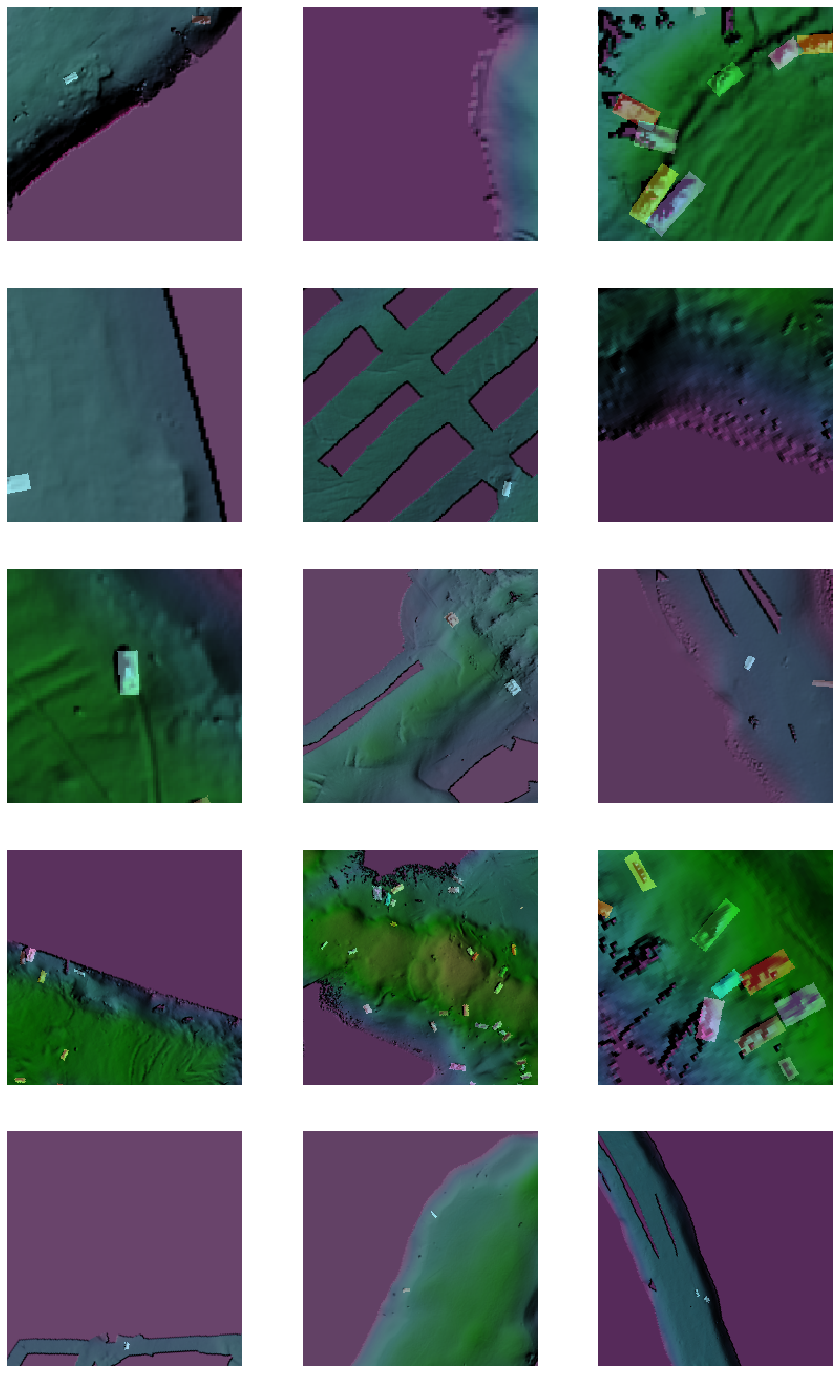

In [8]:
data.show_batch(rows=5)

### Load model architecture

`arcgis.learn` provides the `MaskRCNN` model for instance segmentation tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about `MaskRCNN` can be found [here](https://github.com/Esri/arcgis-python-api/blob/master/guide/14-deep-learning/How_MaskRCNN_works.ipynb).

In [15]:
model = MaskRCNN(data)

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. Here, we explore a range of learning rate to guide us to choose the best one. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

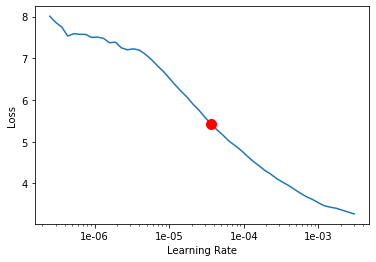

3.630780547701014e-05

In [11]:
model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will train our model for 80 epochs. Epoch defines how many times model is exposed to entire training set. We have passes three parameters to `fit()` method:
- `epochs`: Number of cycles of training on the data.
- `lr`: Learning rate to be used for training the model.
- `wd`: Weight decay to be used.

In [10]:
model.fit(epochs=80, lr=3.630780547701014e-05, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.883735,0.902166,56:25
1,0.814753,0.846428,58:18
2,0.780305,0.805268,57:48
3,0.732431,0.769769,53:34
4,0.692594,0.739427,47:35
5,0.656296,0.697303,57:13
6,0.605197,0.665202,43:11
7,0.609203,0.635087,43:09
8,0.582312,0.608184,43:13
9,0.569569,0.597905,43:17


As you can see, both the losses (valid_loss and train_loss) started from a higher value and ended up to a lower value, that tells our model has learnt well. Let us do an accuracy assessment to validate our observation.

### Accuracy Assessment

We can compute the average precision score for the model we just trained in order to do the accuracy assessment. Average precision computes average precision on the validation set for each class. We can compute the Average Precision Score by calling `model.average_precision_score`. It takes the following parameters:
- `detect_thresh`: The probability above which a detection will be considered for computing average precision.
- `iou_thresh`: The intersection over union threshold with the ground truth labels, above which a predicted bounding box will be considered a true positive.
- `mean`: If False, returns class-wise average precision otherwise returns mean average precision.

In [13]:
model.average_precision_score(detect_thresh=0.3, iou_thresh=0.3, mean=False)

{'1': 0.9417281930692071}

The model has an average precision score of 0.94 which proves that the model has learnt well. Let us now see it's results on validation set.

### Visualize results in validation set

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to validate the results of your model in the notebook itself. Once satisfied we can save the model and use it further in our workflow. The `model.show_results()` method can be used to display the detected ship wrecks. Each detection is visualized as a mask by default.

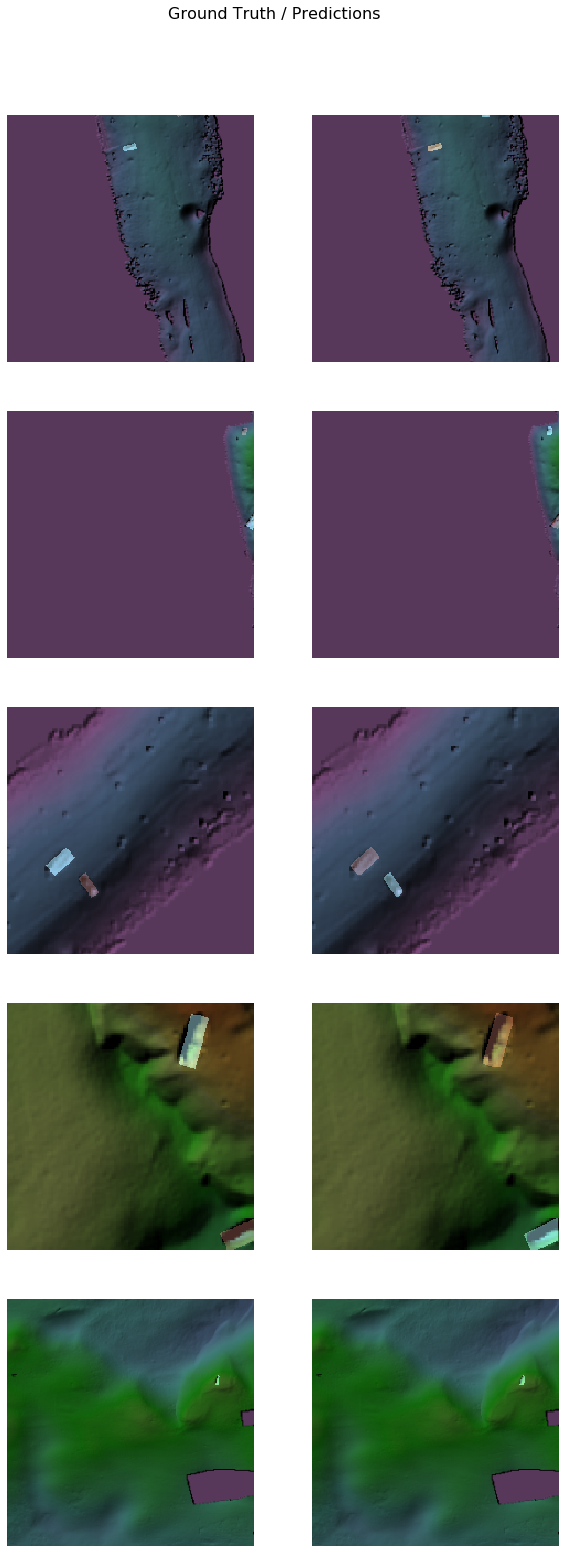

In [11]:
model.show_results(rows=5, thresh=0.5)

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
model.save('Shipwrecks_80e')

The saved model can be downloaded from [here](https://pythonapi.playground.esri.com/portal/home/item.html?id=9e4a60fef8cd45c2a8aac34f145096e1) for inferencing purposes.

## Model inference

The saved model can be used to detect shipwrecks masks using the `Detect Objects Using Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview), or [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). For this sample, we will use the bathymetry data processed using the shaded relief raster function template to detect shipwrecks.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAgIAAAHmCAIAAACOGnGSAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7P0HmBxXntgJZtj03pf3Fih4S4IACXpvutl+ZjSzM99J2pF0t7q5lfa+29nTrfTtflqt9EmamdVI46eb7Ka3IOE9CuW9y6rMrKz03oaPuH9kJgogCJIACTTJZvyYLES8ePHei4i/DYtIkjQZqfzHiwkEUSko/KbSbuB/MqhxWM06nR5F0XrpF/H/PrYRL/H1GQWF3yzUiPBMu+pAl0N2A6IoiAKPKH5A4TeXUrFUrlBGk0mvvwM3wLMMgip6ofAbCBh8hmEy2ZzBYJTdgCAIDMvevm4oKPyawVC0FqZIKpUoiiC0tfLbBOqXy2WGpk136AYoikIUvVD4RgIaAXpRmwaVAL2oTd8+LMvm83mT8TfLDcB+QVSSeGcmQuGbDsjn2tpaJp2Gw6tWqxubmhwOR33ZNeRDjyCbmgDT8HfTWyhuAFIa2BmKZvzGABJeLBYXFxZ4Xj6RY3c4Ojs7a2J/IzcpAsxuTgObbuAzRRzCLzWB1n4E9qnmv5GwrJClRV4R9t8gQHBBWBfm5wuFwurq6nvvvbcRCtWXXQPM+sbGxrvvvgtWG6YxDAsGg++/9x7kvJ9WjK8ItEfgdb1QEwj2bVAMnheTFYGTVN8KLVa4HUDO4/H43Nwc2PEzZ85cungR/EF92TUqlcrx48eXl5dhGhQBah47dszv99eW3sgt3AD4C4oVljZKfz6c/k+X0v/nudSri+XyN962ohi6MJ/8Hz5M+Cty7KPwbQEEdJN60SeB+IVUq7fv2NHX3w/Tn64JhUajMRaLvf3WW4lEAkKk119/Xa3R4Dher3GXQFVSLMcem878hwup/3Ax9e/PZ+eK4jc8RILh+f25f/pBYjwnKnrxLaIm5zXqRZ8ExN7t8ezZu9ditULOemOYXwNSZ9ALCI/GxsZyudzHH38MOkIQRH3xDdzsBiB3zOaZN8cz76wxNjPR7yJ77ThNCSlKTrdhOJAlYOgnLpvVSuC3OVqYggrwq5bXYxBYClWqlavzsKJ8busTK8rU16p3Ia91w2ytpFphs9laIypJEHt77H90yN6ilYshTKsP4IbWr1WuD+/GbhW+FiCEYWgawvYaEPh/+hQnHDUAJm7pAwAoN5lMTz/9tCAIkARAcLRzx44HHngA3MCndeNLAyI2tZT9s7H8OoduadBsb9C4MXE9L9Q6kKUUuy6WgCyoUAK/a0Uw8qpY1mpe346aQNb+AnK1aoXabA25tWtd1Kj1uFlnc61as9d7Uamamk3/y0OOfgMCQwV1kBdVtWCz+es9QrmiF183ILSgCJDa0tfgOK6+7BpwyK6f2/wMvYC0eOfOnXv37Bm5ehUiJI5lH3rooebm5vriG8D++I//GHoF/am1InLiyfncuQL23JD5wWZtu43sdKj7HaSJAAmRz7rMRqmlLM9jmJWU5QWTRF+KmUuwgQKPkbiFkE8+xXJMmkfBnUwk2DyPGLUo1M2VuSQlpnPMbFb0mHBCFNfSzEyC9ed5nQ434lUZRRGW4i5s0MECzyOoWY1JvDgdppbzAoKjRkIW+nSenYgxgaKgVWN6HEnkmPEYs1GRrHoMEcSKhBrUKFVm/RWJo7nJGJPnVVYtCLks3IkcO59glnICIolJWtSSGKGI/NcHiFwkEjl1+vTM9PTCwgJkuMlk0uPxQBRTr1Gtk81mV1ZWtFptNpNZXV1tbJL5tNDDWvlCYWpqChY8cOSI3W6/0aOAIgk8D3VIkvz0up9F7cQrTMDfXKLwR2fz+4fsP+zTd9vIFgvZ79G0GGTRgl8sTYMcphiVRSsLFWgLW2EvhOjVLFdGUIsaxRApW+KiFbFCcRNROlwQ9FpMR0A9YT7FQf69nGZFUCuQ3hJzPkSDXgiovCJ0D0MolbnpKL2YYhOMyqXHMUFcitOzSaaMYE6NrJvlIjsSkdfCCMxCIpkcMxal1wu8msR1qCrJiGYtDsoVLotFip+L0zDhMMqRIWwaU2FHw7QvxzOskKAlAkc1sEkKXxMQD0H8fvny5fm5ufn5+RWfD4TWarXeeE0LZNvn80F0D/H+4uKiKAhdXV16vb6++BoQ+6MY5ltZCQQC27ZtGxgcBN9QX1a96gZ9gVLc7AYqFPvWVKGt0/xIs7omIhA04NXecUx8dyR3GSx7hTkTZFqdGisujSzl316ji5yUKFBnlhmXU+0hxbcvJ/7LClvhxFyJfXe8QOuJbTZswZf/84lCkldxKqTThk8u5d9cpQu8lClRJ5ZZr4t0a9FIpPynlzIbIpIvMEkObTMh71zOXM5y4FEuR7kup0YqMn99NeOjVckcZ7eruVT5r8dzGzwSTbONXg0Xzv/nWaq3UVcIZf/Hs9myhOQK3MW1sqAjO814KkO9MpqbKgg0zV9YzL4d4LY0611q5brZ1wnIXigUGh8fDwaDEP5s274dopWaKG4Sj8cTiQQ4g/Vg0O5wgNx73G6CJOuLq4CGgKsAH9DS0oLheDQSaW1tvdGdfEU3AEb8ynTmLK/9o/1mM+QFkhxWyzE1LESkaV/x7+dLlKRajFSiPNZtx3PJyp9dzPgFVKS5j2ZKZRLfYiPmV3P/YTS/ToP+iVP+4khS7GlQm0rUvzyejgoSKyBuM15KVv7zcDaLYIUifXqxIuqIdhNWLDJvTeZniyLP8r6C2GrBp32FEyGG5YXTq2VEr/Eg/N+NZpZpMOg8h6B6nvv5RD7MI+USj5KoukL927FSV4NeypT/t3OphYIkidL4cn4DJQcg1y8yr15JXyhIOCecns++EWC3NukatHJYpvC1ACIH1nkBPMD8PEi+1WYDCw4m/ka5BXleWlqCvxBISaJotlhsNpvT6bwp/c3lchfOnwcxHtyyZW11FWIph8Ox2c5nuQEEjPKHy9z+PlO/GZUEcT5CL6TYGCM5DPjifPovV/gf3u+ELCHhy1zmiCYV98slale/9bleww4PObuUnaSwnW7i0nzuRJH4Hw/bDrdqnTz9/xsuPzNoDEdLb4SF57ZZH2tTx8PlXyxX9g1aX+gxDLnIsZnMOEPsNEr//nRS12X7R9tMuxs0XVZsYjL1dxHknzzovN8FjeeX1aQQyR1L4P/kiONwk8atUx27mhplNP/PI/aDDWo9huYSpbci4qFOA5so/m1I+K0Dzme6NYlw8b0k8nAzcXI8HVFrf7bH+kCrrhQrfhgVHukzN2gUN/B1AnLZ3t4OYlqhqCefeGLHzp03hjw1DAZDR0cHWH/IFV588cXWlhZSrb6xGkzHotFjH37Y09195MEHu7u7JycmNsJhiI82Lw98RTeAIsKbIwXBa/pBGykKEqSVEGv78jyuxqgM9SdXi/ftsj/RaTBwzMkA7TFjvzqbKDbZ/tku065GrZWp/LvRyuMDxmi09HaIf3zI8kyPfsCGvDaeF02a7Wr+P0wW+3rtvzOo01HMvzmdbtni+L0tht2NGipZ+isff7RVfXoqvSgQP9plva9ZO2jDgxvl15ao+7bYHu406FKF1yOCVcX+clX47+9zPNCq8eqRicXcewnkH+233deidmowKku96mf3tRt0FP1ekNndZ/3hoFFPlf9yjj3Qqj4/nh5Rqf/ZAdvBJg1ZYk5G+Ps6jc06xQ18bYA82202CGhCGxvw98knn3S5XPVl14A6zS0tzU1NuWy2f2Dg4MGDZohPPqk7YOLPnj1byOePPvzw9u3bS6XS8JUrkG1bLJZahU03cLPKQXRTYUROlBAVIgpiMEm9P5X+58eSUylmNFCeLfAnp7P/9Wp2viyupti1DJNm0QEHYcBUOgLf26zNZukYK4kq6UCPuVuPkRi2vcXQL3ILjAgNdjvU7WZci6lCmUqSx7c7CT2mMmiIgy2adKw8k6LWBeKZDo0JU5EYasWFySgbZYT3xjJ/Pp4PlHl/QuhyacVi5T9dzUwXBDWObfNqiqnyf7yaXaUlAylvS03BRUnVYtUMOnAdgXgNeKHMFzn2aoh1OzWdOoTEkP1NWiOpCPrXD4QgIIUPHT3605/8ZOvQ0C0NNCS2EAqZjEbwGTCh1eluTGwBuRGN5sCBAwfvu0+n00H6/NL3vtfV2SkH7XcPkBeKEWU5Bh2hhWCK/k8fhf/1WCVVZJcL3JmZ3H++mHrHR8crwkKMvppDH+7U2gkQNhSSTjfNzFQEFaJqdWgGbaQWRexm7f1OPF7gIIewavC9jWoDrkoXmRUWf7SZ1KEqAsN3NmlVWTrAs0sJ3uvQtukQAkUsGjRfoqZT3MnF3J9eSp1K8MUKp9VoOlD2j0/Hh1O8Ro33uTUWhvo3F1LzRVFb0/HqSVHYIQ4D0eOQ9c7hIFVlPlnmZjJii03dpJVvCOxwqT2Gm22CwtcAgni83h/96EfPPfec2+2+KcYHQFNIgjAaDCDtoBcA6FF92TVwDOvr7X3kkUcaGxuhPmjH008/rdFo6otv4KZDLlm06jaduJJmIXPFCPzpXfZ/vM/cZ5KvS4EItjq1D3cbjnYbf/aA51/tN+kRiZeuKy4YX5iuDZitXjmDWYoVykIt4pbtL+gvVIDWYMXaiVuoAxPgflhOLIkqAqlJLRQjOKJqc1d77DH9wRHPP9+mbW4y/YuH7bYi9a8/jr8bZLcN2P7lg1YsVfp/vBO7kgUNvQ64IugIfrVeYGwMX7uoIjfNC5/esQpfD3AkQIghtPmcG3tEUTSZzUeOHIHpTx85KIEAZ+euXeAwYBoqg27s2r2bIMm7dZglFUQ56o1oOcTIGtjRqP8HB6yPNJIwYhRR6XTEQz3GFwaMP93n+F8fcT7cgOOIVNUA+X8QNvGaf+NFCJKqE4JU5mFwshZgKAoNyTPQtiSxEIPJSFAHxVFMkIqgLRhac33yBV4EabSpH+6t9ni/+397yL6rWfdHj7mPWpH/+FHkP85SjibT/+cx9zaN+G/ei/yNj+FqPqAK9FLfI7V/JFBheR/VYiJ5eLXxKXzdwGGByN1ms336polNMBzfsnVra2vrLeUclnb39HgbGmqzkAd3dXc3XJu9kZvcgIpQE0/06wPB4jsBRgDpASnhJVoQWRU21KSji5zBTO5q1nSYMTWGtNvVWIWeSnK8CoH0eSbBeOwaZzXnntkoRRkJ5flzK+WSST2ggY6qCiCbZqTNodXQ9GSCk9WDZ2dTnMOpG3Bp2yT27aUygyAsw4VpdHujulLgjFY1aKDHiBtxVZ4VuxoM/6/D9t0EP5XhUoy0tdX0Lw7ZelTcdA7yd1nKZap/b9wxiArvMKnmwxQkKzDWM/5KCVSrvlDha6Zmu+sznwFkAJvJ7KeBFkAC6zOfmv3qgCxt7bMc0gt/MV6IsfK8xEklTuRUSJND41WJMUbV7tJ0WnECVZn16vucqg/nS2lBhYrC8FqFMWsGIMKXVJBDzIOgoqpQvLzIqHocpLYao8gNiiqnRb1dK3zgq4Cv4Rnucoi2uTTtenWvBb3iKwYoCZPEcIGzmjVqli8jaK9H025Ewd8UGEGrI3//iOdHXmQ+SgUrkt2i+UcPuB41iTMxiK9Aj69vSG0a/kC/OElssaGzgcoGK3IMfzVERcvf9FtgvzuAUnyhXkB0f8t7QGsIgrDZAijFjbM3cvMlYghH3DaNRy2cmc4f81fOrJZPBWhRRz7eqet2EKlo8edTpcuhynCEa/dqe+xqp0p4a75wJkBdWK+get33txobSenKSnGugpZT5bcWiwsc/ju7zNusRDhBrTLonmatmUBMBsIi8B8sFk/6qVOBisGkf2FQ32ohOsz4+ZnsWwH66nqFIoh97drIevG1ufLFIDWXE/q95KIv939dLpzYoDGj9vkB7ch09m8miic3mEav/rEuHV6kLmZVD3ToxVzlchF5ssdgRMVAlJquoM926wbd+Mhc4SN/5XyYKZa5dQ59TLk28J3hK14bAHA1scWOr0eLb02XzgTLx1dKs3nVoX7TQa+6QSe+fiV3MUZdCdKShmi3kQMu9fJy9lVf5by/FFOpf7DNuMWCrceosaRQzNNn1sqjca631fRUh1bPcMfW2X29Ri8BRhnrshHji7nXYMUAVSHVLw0Zu814o4VIbpTfWilf8JWXKeRQl8HAsW9PF0HpZuKcyUYK2cqfXMp9tFZOqYgnBw3lWOm/jeROyC0QTw8anSJ3PikcaDcYWXYyLQy26Ft0aL7EXNwQDvUb9zWpM+Hy62vlq2GmTHEBGjnSpVwb+E6weW0AwgTZB3zqZRJSmRIyNDgOWQs0JGrWYBoUEUQhmuM5BCFwxG3C5VuJVKpUkStw8o2reg3u1KI4x/0fH4SWPN7/7wBW4OR1rWpUgyPg2tKMZFBjtXOV8CdR4koQTSEqkw6Xbz+t5tfZIpfh5HNERi1mUqMCJ8SKgogiahy16lCEExNl2WXp1JhVg7CsmK7IS40azESihChGKoLDQKCCAEOCZiFnp1kBetGq5ftNaVqIVwQJx+hw7n+aZv7npxq3GWrJu8JvMiDkd+VlEiCrEEyliwJTn0WsOkwr3y0klSixAFG3CjHpMB0u31/H0lyCgYwTIQnUSCJaVHVuKvnXG6p/vN/mVUuCCjFoMDOJSKJUYUWUwKACSCJ0Ua7wWVAoFVIVWhRHZb0QBClZ5jlJRRKYXYuKvFigRap6Dc+ixwhRyjMiUz2J5NBh1aXyY8MYhjqqN1KXYAZFzYQqWxG0Whx0EPKvZFk06OS7rnlOBL2AXgLrpb8NsL9/yLnLLCcZCr/Z3NY7hTZDppvkoVZ+Y+H1EkRFcPz/8X5oyev9031aaLxe/hncsoub2r+j2U2g/BN1EFWxwjMICorH8vyvTicXjMZ/db8J9KdWR+E3mLvlBr4KoGnnJpN/FVb90WFnH+hdvfhrBlFJ6TLPqlCrBmVZ7r3x3JqK/MMDFvmm2HoVhd9YvvidQgDIQe13E58u/EQJhEh6wgF5xq1q3sQt69xUckezm9xcR1QFoqU/uZJ9bTb/l+P5GKn9Bzv06ltdV1FQuEcYtLgXYvNa5PLNADKARIZ6ZSz36nT+bybycQF/rEdvUHzAd4zPywa+HKgkrSVpVqvu+Vwf8+uHZvnpDaaoUgkouqNB41EjStr7HeGbkA0AFM1vVESPkTR+5iW9XzfgkmiGX0lxGV5CMcRmJActmBIdfUe4rZNCXxqId0C8voGnWyD2qQGCroj6d4dviBsArYC2voGyJ+tFVTXksSmK8Z3htk4KfWlAkr6Zp9xhVLWfIuoKXwPfVNmTlUKUf4oP+G5yT9yAgoKCgsK3BcUNKCgoKHynUdyAgoKCwncaxQ0oKCgofKepu4Hbf7xeQeHbiFT9QlN95rZR9ELhNxhQitpdAVU3AMKuiLvCbzQg31/ilui7ebeogsI3DNCI2mt9FSlX+G6gxDoKCp+mqhSKG1D4zaFq6mXq8woKClW9+PxU+LbcQK2Vz29IQeFrBEQUwzCe5yuVCk3TkOr+GsR1Uy8Ux6PwzQSUQhTFYrGYy+UEQfgspai+TEIUOY6rF9wACDeUMwyTz+ehIWjC6XAYjMbP+UqUgsKvHxD0VDI5MzOTTCZhGjAajb29vZ1dXWT1A2RAuVwWeF6n093RyyQYloV16zOfBPxNoVBIpVLge0wmk8PhgL/1ZQoKXzdgvUE+5+fmguvrYMMhThElyev1Dg0Nud3uWh0w76VSSafVfp4bANPv9/sjkQjPcaBO0AqsYzAY+vv6mpqbb/oerILC1wKY45Xl5Y2NDZfL1drWptFoQKTjsdji4qJWp9uzZ4/FYrm7bgB6BKVY9fl4QYDuQBEq5TI4A9CuLVu3Qvv1egoKXx9gun0+HwgnxEN2ux3EmKIoKAz4/T09PSCooAUsy36eGwBPkslkrly5otVqu7u7PR4PZABQExxDIBCIRaNOl2vr1q135AmgTaA+o5Ik8Cr16VsANT+tfp+F3Oytalc7rPb4Bb3dGdDm54+t2un1KrUx3P7m3AYIuvmSvLu/cXd3qPcWML5TU1OJRGLnzp0gpZD2boRCMP6W1lYw1tPT0yDlNU8AE3fFDYDmTE9NxWKxnt7ejo4OCI+gEIYBiQg4HpjYvn07ZAZ3sg8RTP7Udx35a5yfuS6CwHG/7cMt3+Z0q8pwjK/tAUkUxNpymJI/THODXEEZWAa5bk2JPh9oFPTiVh84vIY8eNCczQHJDcMKNw2vao7k8d1Op5+kulnX1qp+1vT29tMXIw9VPjJ3q70qX2FLPx9oEsKUM2fObN+2DRJiiFTAmC8vLQ0MDoLwR8Lh0dFRkN6BgQHIEmpuoP4RSthl9TaqBxRkfWRkBNbZtWuX0+nM5XKhUAhmIRWAWYIglpeXDUZjLc6qr/ZFcAyVz+cK+UKxVKRYSQN9g5Team1RYBmal5XjdnaQJLA0LcrfWfpEZRTFBbqQTGUKpTIroHqt/Nl+oZScn5jJYFq7UVevjaAYnTp5/Dhr7nIZ0C/cGEniqRKN4sQne7sOqBNFVTgBwXH5q1QwT1coTpDqszUQBBcrF05+GBVdjXYIHu9MvBCRheNa3ZOlMs1ptDoC1Ku+8KuACBxNMRzskuvq9JUBQV8dOz0RqkCwrMbuxjCvAbIXDodXVlbA0EPjILdg+s+eOROPx3v7+kD6QVYhS4DYBXJhCHRAykF07+gjlOBX6lNVQMFW19bAB+zYvr29owPanJ+fh2ZBMYxGI1j/dCqVSiYdVR2pr/MFICqBjkcj8XginU5n8iVMrdeRn/WqZ76QyoiYlrxBlD4LsLjlbIqWSDVxo8+Do4EJdHFjI5RIpsqMpDPocPl9wOLChRN+xtDoMm2KEl9MXrpwvoA7nJZryvLZCCxVKlYQnLhJDa8BVpTLp5O0RGgIOXZEJKGQSVESWZvdhM1tXLl0KY/aPVZdveh2EalSNhaLJhKpTDpdZESd3oDfjQ8nwM6pFHJFRqUh8btlsWUbm1o9c2G4iNm9tjvd0s8DWqZpenh4uKWlZevQUO0i2erq6rFjxyCgt1itRrMZzDh4AlAZ0BEw9SCrtwiLwF0vVIV727ZtsEIykThx/DgkAbWEALppa2/v6++fmJiA/m5ToxCRWx7++C//+u8++Oj4yRPHf/Wrn398brJAy1+kr1eoUpvKhKY/On4pXYa+qsuqC2tTm1Srg0yr6Fzo9EfHVmOlG30GlCeDM+/84pV3P/74xMfv//1f/e35uaAItpctLUzOxUpMbfV6bUmgadlSQ6sw94lF16iVQYdCfvaNV99PM3Vpr5Z/ojJXTHz0xi/Pza4LsBB2Jp09/cHrZ8YDEEnA7LX68iqgOQwvW5laA/UlN7JZcuMCFK/4r/zJn/7X9z4+cfrkR7/65SvvHzufZTe3/tOtALcolItuKkRUidWR9z+6GCt+4qPktZpAff5aQX3uOvWS6pLrFcAv4ghXqVCbFapL61N15OrVols0+5mABIOVh5Dc5XLVSiCaKRSL5XIZpkFWQcohS1hbW4OST3V5x0ALEDpBot3W1ubxekFBrg4Pj42NQQYAi6A7UJahbduy2Wx4Y6O+zhcCOppe/uu/+JuzY7Nzc9MXzhx75e9eXYzdKF5Qo3pwEVSiNt79+SsraaGWhMsLYSn8keeq1GrLZRiO0sMfvHphqXBjqoGo+NDC6Du/euPM8NjszMSHb7567MJUkVVBWB5enl1PluRoSl5froziapPJhKnqAWK97U/0Vu8OQ6V0YPLYyeFspS45tfLrlRFUVUkf+/v/dn4lCcWwHBMLZ1//y5MzyeqWbg4bQdUGuVPZF8mbJ5fUFtUbuqHX6tJ6IbQg0MtXTr76zvHxqZlp2LS3Xn3vxHCOqnvxW7ZTK6i3UW2tVgb/VItqwH6nZ868+f5wgP+ES7k+ivp8veB6F9UG5VK5Sm2m3r4snJjWYjGb9Fpic6G87KbVqwVyH58Y0hewvr4Owrl161ZYCzqCEoj6KYriqzENLGpubm5sbIT8AKZr7d6cDcCaIOtLS0utra2QZUMkBWlBoVA4cOAAxDu1RgFQPHAVKIbBxGbh5wAbng6sJDDvc9/73qG9O7d2emc+/uVEHOvraQFPVM6nIBrKFsq41kiq6ODc6MjMKmltclh1mCQUs4l4Ipkrc1q9Xg4dJKmUS8WTqWw6B6a2mAyMjc2UVEar1WzQySEY7Lt8aPSv/+Jj6+7Hf/DiY3t27up0qE6+9vdZ62CHiVucWyPdbh1XSmcLEJro1ISEoM7GLo9VA/rCUaVkPJpM5yhO1OnkfAV2WzYRiSczxRIDCUZ8YfTj4VVne6/VgKvoQjQez2QLIkqoSaJ2pAS2sjQ1WtE19rV5IGgDF7M6N5lFnINdDWwZtiSezhQRUgP1La7WJpeZVDGRSJJHVNl4JJ2voKS6GnQgdDkfj8azuQIjMPkcrTXo6gKCoHxsfiSs/sHv/s6hPTt3Dnb7zv78/Arb3d+pQ6VKPhWNxfPFMkJotCQOh5Mqwc6NwMaKuE6nIZhSPl+iGKqQhB2Yz5F68/XQEqLp5Or0cqKpe8Cur9sOnqGSiWg6lSmzELlp4WBVcnA4UtlsrsIIWj3EkmIxHc9RTCGbZcHTsvlYjhHofCKerPAqvUEPQkzoHV0drTpCKqViaUpiixBaZARSp1dDJCrxHJ2MxdLpLMVDpkVJuJqEKO42AMle9fkgxtHpdBCYgwxDXLK4uAiL+vv75XMCkgQpbDKZBEtts9kgtP8q2QCEQaAXxUJh9+7d0MLU1BS4AdALSAtAf2paAI4HRrIRCt3uxTOwj4XQhenEE7/z3x3esWX71q2GytzfvXaxdcdum0ZVTMU2wqFwJA5BtJ4QN5amz1+dRsyNJi2h0xK5eGg9HAbJ5HGdUSufm2ILydW1QDQKUbZEJ9cvX7qcEO0em1arAUmGIaP52NLHxy7gLbuff+rhHUND/Z2uqeOvz+T0/V2e4Pilgr7Jgpc2AoGCoLGZdKBoqNrY6HXCQefoSnTDv7ERTpUEMF4gijxdTsbCGzC4aFbChPDyzPhCENUYIdjE+dJ60L8RiZd53GzSyvsaNpMtTly8KLXu3NJsgV0Fojp9+ULJvn1Hu6mQjgVDoWg0JmB60GCwj02NTlLFhtdDxQqViIY2wklEbzGocTkfSsaD6xvxeLLM0BQt6nWa6sGEP0IisJrXtT3/zBO7tg8NdLgWzr1/Kcht7W9DRQ7UIhgMRlM5TGvWqVGRh5LI+sZGLJZAtRYDieQSsUSJpXNh/3o4T4lanf6aXsDQ+fXFybDg2dHjvaaDElPKBddWwokULWIWgx7sbSq8GgiF47Ekh+uNOlJgypFoLJeHBCWlUuvobDRdqGST4Y1QhEF1Jr1a4lkBbJzXLtHFeDRaKJfjkVA4nFRb7Bo5OudTUHcDesiU6UqFFo16TbXvL2ZpcRHy0YaGBrD+II0g/LFoFER3YGAAIpVa1AKC6g8E3B4P7DkCx2/hBsD0RyOR5pYWsPtzs7MXLlwANRNEMQSsr4cjEfBQZrNZvn2oUGhpba2t+PlAYpUKLgcLaE93uxaTj7TDLI2PLrm6evTM+rkTl5YDq6tLCwuhitelnjh7YjFegeDbYLUJGf+Fs5f84dDc5GiMNnS2OnPhlcsXLiz5gxtr4SJKVmKLY9NrLAQPpKmtxYnAhERPnz0eM299+em9aoHjBcngbNBRoVMT2aEB5+rMTLRcqaSi81OjowsbnvY+Bx/68//yiqZnl4csTQ+PXZkYi4Q3pmcWVcaGBjsZXZq8cO7cUjgdD8UYVIDZufU8xFpaDbY+Mzqxth4K+NfjdEt7o6YqN3D4l+dmRWt7f3vVDfDU6uIco23sbzWNn/hgZCmwHgilK1KHV/3mX/11wtzdayy9+crfX/Yl+Fxo9OLFpSjV3NGuU2Unh89dujibTEemr57+eCy2c/cOA1HNcMENpFYu+8pDO7bqUR4hdA0ttrGTF9TN/VYxdv74mbn1UHB5bn696Glp0WP5q2cujy/MrvtXxuc3PB29UmT8b/7urThFpSPrC+MX1ll3Z5MTr50MQ5By0r8cKrf11t2AyJZXZqenZuf8wcDk+Cijbmhx68NrS+MT06Dno8Ojoq21xaFZOPHLvxv2q4qZPINiqek/feVjkpRW5ydHxmZpg7fNqZs78ctji9RAb6PvzC//rw8mtarS4uTYxdElU1OnUwc1r54/MxqKRNcDs++/c8rQsbvDof7C07AgqBCvgEh2dnZGIpHhK1dWfD4I/EFEIWoB4YREeD0Y1Op0lUoFRN/jdn9FNwBiD6EP+BWIkBKJxPGPP4aO1CRZuxYH5HK52tmneCLR1NhYu2zwBUCoV4xcnAh279pjIwQBwZwtTevn3s+a+5q0xSuXRn0b4VxyY2LOr7E5heTS1ak10mTR6w1IJTY2OhOMp2K+8Vl/qbGtFS2FTr1/bC6ao/MQMokil50dG2cIi5YkXR6XhsDAVK1ODwdK2sNH77dpUXlvaE0aKT85E2ru7krNX5hPcWqkkggsXhyZtbQNmdnIsfePlQxNLQ713Ojw1PRCppiZHR9PIu4uF+6bn7xweTRZKOVjGdGmTc2PLUeKpEbvdFuCY+dmfOFsNpPOi60dDbXQDNzA9NWreMeuLU11NzA3Msx6tvcYK5fPngMLnc0k02VNo6Fy/MOP8/rGJh39+n/7k9G4BMHW2sT5EX9xy5YeKu47f+LMciRFFdNXLp2a9BW6+nqNahBf2Dg+HlgJ05r+riZcJRE6iwEpTk2tNQ30s4nlc6evxvPZiG92dKW8baA5Hli6dOFqLJ3JJdbGVkvtbQ3BKx/+8uRVDkEzkcDYlYt51NnaaK8qNAydCy1NJ5DGHT0e2Q0gCF+KXDh2Zh5sdyI6NePTOJtdRmlmdDgUTUf9c5cnfJ7ufiOXfOsXfz2+nhM5QW8yrpz++9eHI4SKifumLowst23docn53nzvtGhv9RLFN//2z0ejPMaVVsfPjUfEvp42OrF8/uzwcjhZivmHhy/MrjM9vd068ovlFg7r2uqq3W4HE33ixInJiQnwCiCc6XQatMK/tja/sADTbrc7Go1CoA/Zn3ziqL72DUBDoCegMKIggC5BMLW8vHziOIi9zMmTJwOBALgNkHL2VvcXfSGg4OB3tDq7DqLPUnb8xPEA53nkhR+99OjB8tLYCmU+9Mjh3s6eR558eqiZHDlxUmre98z3fvzi4a2zFy+tZfNzV04nUe9jz//gJz97+f6h7u27D24d6D3w4OOPHOhFBVE+8UBn/BsZR1OLEeGr1kQSRMzpcqnyoVQFHF6JJ1xHn/nBj3/ycoMUHZmcB50BMyFCvrK+PDYT6Ln/me+99L29rYaZycnohu/YhycNWx/72U9+9L2Xnti5ZceRI3u9ruZHnnm+y0xPTPnbtz/44x//6OkHd+jxz/3IOIJwpeDwyNrg4ed/9tOXH9o7oIF4iuMEGLAcDjMqQ8OjL/z05eePsPEVfzgZmR8+dSF8/8s//vEPX9zb5RB47rMal0SBVDudJi4WC82MXF0sWp79/o+ee/whdWZtfGk1MHHuylLxyLM/+sFzT7rp9fOzQRgJy1Oujr1PPv+j5586Grr03kQwK4v6rSjnIzPTC8a23S9+/0ePb2+cunhuoyw6W/uffenlF158fnunZn5itgAiIFZyZWzfo88+fHCrgZAYifBuOfKjn/xw0K0aH5ujGBAWeQeD8ksCy2L67Ydf+MlPX/Ai6Ym5YLkQvXD8in3rkR/+9s+e2N8H1qJ2zL4QiF3ALsMEtA7hCMh0GILVjQ2IgCAnqE2Hw+FcNgt9Q83bavRzgR6hKZIgoLVsNgt6AW5gcnJy5OrV0ZER+IGTgMHUkoAv2Z180tXU6CRiscjywvxqjNq674EHH3y0jciMzm60bdvR4vHuffCpAwPO5bGxOGs48uBDDz/6qCG/OL4UmBu5uEA5Xvj+j1586fkH9u3avnNvf2dz565HHn1gl1mDycmKyKWiIcTgskLIXc1d4H+jwYJLZfAbEH7ieteOA0+89KOf7bIWPjwzTqmqZyNQFZP1Xzg96thy/9GHH3ugx3zl/HC8VJgZn3RsefC557/3/Pee2tHRvX3vvs7uwYcffaTLrZodmzN3H3z+heefODwEsfrn74pKPra6nm3f9sDzL33vod3t1bMYVesLppwkbA2djz31/PdeOlTyza3F86tzc4GS7tHnX3j2uWcO9nnlup8B7EijyaLF6EwlP3v2VE7fcejoE48/sDM7e3kqlvFNjeXJhj33P/TAffepAleHl2MSKnAq9eCuIy997/uP7O7YWBiPFujqQG4GRbjQ7Piwr3zw4aePHj7URJTG531FDuvbc/Txxx85+tB+bSnsC2URVBJRxNW189HHH+1vdqhUmMHuPfTwMz/86XO6zMrochKVla7eAYoTruaeo0889/JL9ydnxvyJ/NLEZITSPfvy91/64ct7+xpvX6BAODEchxSABUAXqj8ITaC8WiCrB8yCkd/UIHmt2j83Ag4A+oR1oN7g4GBLS8vQ0NAPfvjDn/zkJz/+yU9efvllSC5A1iElV6vl665fDvmMF7RCp2YWIcXznXznjQ/OjpZgfLz8JSToGlwFmwtOLobDvrEP3njt5KgPRXiGLcZSTFvPgAOSZBTVanUIaB7UF+UvKMnAX7CrYNU/STX+k6AORti7+7o0qKjWWlq8LtBkSj7nB9LKJMLBUDwyf/H462+8NbYcVuFIKhpIiJ59WztwlYCQajWBgxuR7YEo6Uyunk7rxTf+4q3Tk0UYyicDTEhl6lNy07CtKKn39HTbzr35d+9dmKYkWcGqVUDaVRhu6urp0iCi1mwzGbR8pbC+siJ4+tscBhHXNXW3O+rh+i0BrUERDBXp/IovUMyFPnrjVx+cvBgrMBhfmpuYjxcSF4+988aHp2NlAZJhOPQWe0tLk41ARbOz1asXYql81Xl+GqkAkeHy6tLkpTdf+9WF2Q2UxFlOlJjC2Jn3XnnjnbGlCMMLogC7BG3u7LPq8eqhQByetlavSUVonU6biqOv3YoiI4pEc0efw4gjGpPDboS0nkmtxil9R2cLyJy1s7PNoK1ZqNsBAhGQIEhe+wcGXv7BD3704x+/8OKLTVVAXGH2e9//PuQK4Akc1Rvm6qt9WeCQ6Q2GCkWBCkEXW7duhZDqueee++3f+Z3f+m2ZJ596CgIrULTq+fVbe9bbQVAhuIpLRAKJZHR6+MLJ02eiFdxuUAuyK5VAfyEWDoU3EmH/uVMnz1yYKOMWs5bZ2Mi1Du7w6GF1+fwVBjIK1eU7ga5tuSy2IujXDXuidu4Ytgwsgr6ltc1qwAVUv6WnNRPboKrnjUFOc+GllWg2uDB6/KMTM1G6yWWgK4kCre1o8WpxScJwcIySyIsQNgogAMbBra1Tp1//+VvHgxlKPslfp9rTJyWNwEmjzdvVajz22t/98tiFfP2qhwxURnFDQ4MHZF9tbbDqxXIhm8llLA2tNq1aQklXa5NVvsmkXv/TSNAZribZ5NRcMJNYu3jyozNjqxa3E6VygeB6Mrx69cLpE2ev4maHiUQEgWxo7XKaCVGFO10NmMgUKO5WWiGfDguuBYtcYfrciRPnLkdLgkWnAScS8U19+P67xy+NJ4q0bGNViE5nbXQ71Lh8tRXDtS6PVwuJi8be4NCUSvLlq01Itcnb4CZgS+0tVg1XKaSSmbzF22LCURElnI0eM3a7cQwInslkgnhfo9E8/sQTYK5/8PLLBw8eBFt9+MiR78vzP3jooYcgMwAbpNVqa9JwC2HV6XSwDNJq8CrdPT3bd+yA7NtisfRX6e3ttVqtcMBj0Wjt9oz6ancCCEcmlWDV9gabRoUQWw8++uwzzz7z4g/+8J//4f1tZtmsy4cXkRAJ0zn3H3kSlj738k//7//0d7uNUgWiy1rAUEWuCTPwq+8nCdHavGYyvhHjkbpQgZFMRBOYzm3VgtmVX6onbzusJ4sw6GytltyIuWngsSeeefb553/ye3/ws2ePmHGhwkr1Vqr7S15Z7ktC9e6HXvjJj57c57vy3qtvnUiB0lTHBIcBwyTwxjCQqtDLp960GhIh7Y+9/NPHd7csX3r/tWOXyrxcuYq8pbXhI7AqLkcJGEEYdAZI46FYZBn2+ubeDPhSphDNi8Ymrw3FNb17HpT31Us/+L/94z84uqsdlaSWrYeeewa26KV/8A//4fN7OmQrAhsie0l5eHLkQNzkwjaBHYSYvN2Hjj757LPPfu+nv/t7P37KVl59+/W3NlRtLzz31H07ew2yF4MfBg7yWiPyP9V9jMjG6FORMVSr7kgIgOTtAwemJtWa6n018g1q4GU/YzSfBgTdYDCE1tfBGUAKDCIKQBBDqNUgorXZSCQCOWvtim59tS8LiKXL6Uwlk2Dood/Dhw+DFkEW0tDQ0N7e3tbeXrtOFo/H9Xo9HPT6ancCgqJiMbAQV3V3tqgJsqln19FHn4Lj+ZPf/q3H7tuig8MpGze5GqI1D+w6+NTTTz/7wos/+9mP9ve5eRgWB1IF+7SulPKBvnFfYqTN5qRy8QInnx2WDwXCJ9JZVGOz60nwL7VLiFDKMCxJ6jbPFGAEpne2P/TY08ALP/jp7/7wEaNKvv0NrBssleO5zUOGgCgYDzz9o99+8SiRnH717RNZrnY8JQyDwyJUaKGqFFCIQpqg1xu0tuYHn3rhJ88fLk289epHVynpemYK9Wqig6hwDEdAtUgc0+BErT+eouVzEdd6/iTQCBsNhyWjp8GmI7SWgT0PPg0767mXfv8f/s6AU4tqrVt2HYTNee7F7//4Zz/e0+1GIdOTN18eHc9BHI+RxGf4GAwWYraOnU8+CYfm+d/6vd978mBfbun0e+dXunc+9PwzD3e7LFW1gPGCYKKbI7y2OfJthtWC69T6kc0SAgoprwk7Sw0jgC2FA0PTEJJXq9wWEKOEQyFIWGu3RxtNJhBUaAn+gtwCoJjTMzPNLS2b5y0/NaDq/RUd7e1zc3PQENTbv39/Y1PT+Pg4KClUqB1yyIWhrbbWVtCN6npfDMQiPMdSNMMxdDKyPD0f7Bgc8nj6dm1xB+bmiwgKbr9EsRCx4IRGYKhimSIsvT328spKALJ6MK15mlNrPc1urW92JlamqWKpAE4VJzGVWCzmuWsjgXTwwFOPaaLjJ0fXQDVYhgpOX748nz/03FE7DllOYmXBD40nY+u+ZMFrcxjlowIKo2ls61Fn11aSeTh4osCxvMrV2tssxYaX1ys0U8oXwAFhpB7haei8QpczmYqze++LD+1A8oFEEWRS3jO4ztjW3pj2L28kcgxdSUU3Coza6TSLQjFflrp2Hjq6u0soJ/KQhstqWh0wbHN1AkYhx28q0tvSlvKNriZyVD4zOzmfhJyuVuEaIicnfCxN55L+86cuuLYc3j7QO9jp8M9OMyoUQ1Q0yyKYbduu/uT8ZIQRwblAiQhLEDGXWg2uJ2i6Eli8vF6xdDc5IZarNQv9wzGCLBIySU5QmVxdVjHpW4+BGiIqgeFFgSmkiqreLi/Kc/HQRkYEXycP+rqQyiHotTmYqhmiayVywea0nMOJWkerQUzOLq/SVCkwNb2czdfMxu0ASratemfOwsKCnIZUV4TCmvMBYrGYz+eDjBZ06voIvyzQBWgOKNbU5CTP83aH44knn0wmk/KNGdWNgtgoUj0N5W1oIG7nwkAVGLQo8nQFYq1SOrr6wfvnHXufv29ra1dHe25tci2aghS+VMpTrIBpjAa1KpPJirilr8m6Mj2RKJRBEPLFPMWZd+zo2Lh8bjmZK6Sz6UyWQwizxZDLpBm2focL7KHePfe3ajJnTlyKZwrlUj64MLWwmtiyd6fHqpPE3NrS4noslwnPnRyLDO7daa6mCvCztuxqkIKjCwGW55lKIZ6jLdbuRkNxenI2ni+lI9FshdHoDBJPZ7N5js+Hwjmzp3Pf0IBeKpcYSRZdaEVv3bNr28qVM4FYvlIq+Bfm41jHlm5tuZRJZ2lXS9/Rfduy8WhRtjHXpeWa5MgqghB6j8ce9s+uhuKFdHR8eCwB/qy6uApUFulKuQBGoZhfmb46sUZt2b7FZuvd0a3zTU0maI5nK9FUntC7+lvN/pWlMAT8LJsrFjgOvBQb9s361uO5VGTev4YYG9wGzXWZkSSWrkDeWYYN4rVDO7Zyq6NLeZrn2XyxBMJAFfMVxOS2a9KBdX86W9vj8tivN1HdnBqyuss/GHG95NqGwuZANQTSIKdpeeZqIJzMJCITo1PpT2zp5wGrQziybceO06dPQ8hf9SNgUWXAYkOFcrl87uxZyBhAL6oBt8wtnhsAILaC2kvLy16PB+Qe/jocDvAt0BA4g2Ag4FtZ2bdvHwRg17ftc4HRUPn4WigCShtZX4uE49qm7Yf29KoxzOJ2RBcmff5IMhIKF/iGBpeceqdC/o201ubu63Evj09vxBORYCjJq1vcdrfXmQ2Ca/CvBzbKkqa5xStRBd/yGo2bmzxWCJhgl6r1jka3furixVAqFQqsLgUz/fsO7e5rVnHlSDhJC1QqEt8IRXFb466926xi7tLVxZYd+zo9Fg1GLUwup3LJ9WCMlzO1xiaPZezUqY1Cft0fJYxGh6ehEllaixZVUml1Zs4XAMHhvR1bhnobIV6pbioOQShTiC2tBBKxaDAQMfds3T3YLVGBM+9f3kjF4zlV5+BQd5M57A+Y2gbbzEgsljY0drY59GBl44mM3tbQ3dGOU4HRqUAhE0/nEsmC/r77duvx6jGDEK4Qn1hco6lydH3NHwirm3Y+fGiLFsEsTnM+6Ftcj8YjG9E0pTfbmlqaqMj84gLsBtjuksnhJMrxed8GhyCJcGhtLdt/5MiWVkf9NnVouZz1rQQKpUJsIxCMFxwNbV4r4ptbiiYT4WC4jJtamjxiPuHfiKTk+1FYq6Olu6ORToYy6oYt7S5UJbIwYoro7+9UI0IhGcnxmq72RjYXzSK2wS5vJRkpku4tnR5U5DPxKK+2D3R32wzs9OxiIp5KlrLxUKZr9wNtdvKaY/wCIEyBkGtpcTGXy9lsNpiF9TxgLex2sM6LCwtWm62npwd0QD7J+ZWfG4AVQTWgWTDNcJShx9a2NiipRVWQGczOzEBy0NXVddsnhVCEr4SisIOT0XV/YD2qa9zy8KEhLYoYrFaCK64ur4ajkXiyrHO47BarHqcW55clnaN3oFXMJVf865FwNF0SHQ2eprZWE5samZ2LbMRLImFzupxmzeLkZEUk7E577ekBnDQ2NrqLcf+ib1W+3yNRaBvcu2tLhwZVgZRVVCiVDK8srms7tjx8cAtGpRdXAqamnlavq8FNLo3OhBMxWAezOVvcTneDM762uLK2th5KG7wNXqezkomsBWK4Hl2+NLa6sb6e4QZ27ulqstV2hKRCLa4GoxCZmFmLhYPr8VLvfYe2NlgK6eDohRFfMBjIYfcfOdxiI7LZssHV6Dbi6Vjc0NzbZNOrRCadKTra+nvb3Ewx6VtZg42uCJQKsW3Z2mcg5csPYO2oYiYEC5LxUDCYLAh9e+7b3tcMuYOnpSEXkke6sR7OCer25ganx54Lr68ur4UjGzkac7pt+eBqFKIlqhAMhmmVad/h/e7aPU5yVCKWcqmNcCydjATW15MlobGty6EpT1yZiyfhyJV0VntjS0N2aRZsWLpYgSi2paOn2aHLJNP25i6nSQtRWzEdZ/UN3c0OHBEy8Tjm7OqwE6kc7WhsdumxdCplaupusOpUIh2Ppb1dW3vbnGIls+wLpNKpIkujhGvLQNftXCKuAWJfKhYhlJdPRWi1EAYZ9HrIEsD8zs7OViqVBw4fBl0A8Qa9gAnZVwi3eoqYpunpqal4IgFa5PV6oSFwFdBKwO8Hlevq7oby2/QBNXimlMnkGFaAtE+tMzudFvn0JSxAJK6cTybznAo1WOwOqx6KeaoQT5X0VpvVQBbTyVyREhHC5vUY1Tj0yUKQnM4yIhg+t0VHQogCswJpdDuuP/wCeRkD+z5bEuXb3mxum1E+GyGJkEEgmFRIZXmUsDjcNrNO2Bj7t39z8Znf//0+Ky4ITCqaqPACTuisTpuOlM/RFFKhTJFDSY3FajNqCaaYTWbLOpNRxdLFCoMQGtA47Q1PcMHe46hSGkbIiyiudTU41WAgeToejjMSQmoNdrtVg4m5TA7VWwykqlwsqTQGgxoTRaFcKqkwjV6DchwLYsSjWHj8oyvppt//7acMCKThcvM8XUhl8lz1SQdSZ/Z67GCuYBrybKaQSaTyIoJpDfJgcRSF+D0RS7MSotYaXR5neu7cO+fX9jx6xIFCdGlxeqzQ67WBQy7AZFLpCiNfkUZInc1uh+Hlkol8hUExjc3t1KsxSIuSqayEac0WrcSrdEYDX85RiNZi0EIWLbBUgRaNJgMO+58qUqzKaNCJTKnA4Vazni0XKEljNqhBtehykZEIq1HLckwpl82XeZILvPqr8Sf+4X/fb0Vv0w0AIJaJRALiklw+b7fZIFIBec7n85ATeLzezs5OyG7hwENYc7deJhEOh+fn5qCjjs5OcAZQQlEU+IBQKAT5cU9v7+Yp19tC5IulEgsxu6TCSI3ZZJBvMINyiON4plgosYKIkzqjSQc5jiQwuWwR1RhMRq3IVPKFsqiCIwuJvgYsBCKy2WwOhE5rMGrVYB15SGHltADarN/qCK2ioImFUkUQVSihtZiNGCKf3WEqZUgWIQunOZUR1E6NZ4Kz758aH3jg8aFWB+SC5TxIAYeghMlmrp6Xke9prlCMhGkMkKXgCEuVi2VWY9BKNAW5C+iLCcTgRsOFoBJH5fJF6BpX6ywWsO+Q/LIg/5B7YmqDDXQfEg6aAX8FOT5D0ypCIz9fJgkUzWIEhBYsB4aLhuidmL/wdkhsf/qJQ0bZJADy2QbYk9XrgohaB4PSIlXZhqHKD7eVKDA9epNZp5Fv1YeScpnmQS/kXasaf/+tCcH1FDg/lUTKzy584hoVD7VLldrNCyhOQihNIFw2nYeoHydh8/UEjtLFfKnC4hotSUBCSpAYAuMH4yDf/QxDY2lWInQaCBcgZamImEZHomBjYaMIVIKJ6paC0vCVCkVodCqBBRsN0yxNLV49mdQOPPHwPgN+fUifD2wyyOTa2trKyopOqwWxh0I5EqqG+H19fSAxIKLVRPNz3ykEDYHT8Pv968EgDAjDaxcARavVCqr1Ja4KQP3rq8hJ3vVNur7oWnmtBMYGbCptbXZzabVErn5tVj7NUK1YRz7/WOvwhu5qK1ZXQNhKfmPdtzQ9uir2/u73H9DIllw+71qrudnctaJ6/7VmYarWVHXBjVsjI7e/ubTezmbL9erQjpwfVsdfbbxaSQbj0wsfXl5zud0YnRqdXR049MwDW5tE+baiKtc37Oa+q6tXF10rv14CRQgenz79xtm1R3/6w24rmCo4ntfXrXJ984HayK/v/+rsZoO1EW/uh+sbcG16s7y2Aoznxpq1Qp4ujg+fLWAeh5rzL01mTLt/+uxe4tpJqtsEWoKEPR6PQ5gCsg47B2Td4XRCToBh8k0ywF10A1ACHa36fNlcjufrF3nA9INeQMB1+41vcoPMValNA9cO9A3Fct3arLwDb7W0WnLt4MPs9aV1NlfcrAfUS6r/gvtZHD83sxyg9D1PPrzfYSDk3uoyd32dajNQVhfw2qzcV7X0xsav8+ktqq0mT11vR15cm6hN1WpJQmxtenxhHcI6rJQIl1VD9z26rd0ma22NG/Si2vy18hs62Sy/sUQlMGMfvDHKen/8/GEzDiFIvc4mm5WB6kJYurmra7P1zmvTtX9glfpsdfpacW1anpQnrv17bWGtUIivzYzOr5M6g1hIrxeFg0ef6G+Uz9LJNW4PaAfsNoTsqVQKhB9UHcw9ZAmAfI602tQXu4Ea0BboVaFQKFcqGIIYTSaIrWop8LcfhKtkl+dnkpyuf3DIayZuNolfG4iKL0yPTSQgBUGJ5t7+ZqcFYoy7MDoE5Yrx5dV4Y1+/RQNxT734awTSgujK5GwgA1mXuaGtt7vdCHlVfeEdA8IM4g4TYP1rJTWg/C66gU0g4IJQCSqAXoEbgOT6cyp/mxCF8OpsllN7mztsxts+E3HvEdnyeiCYK7Moijua21zWT2YbX4FiKp7nUIfTrrm9RxfvNWw5u7ERyVc4HCftDc1euwmcQ33Zl+CaXNYczia36wZqfDoe/w0BQXH5XUTy/eDfGB9QA8Xx2ot9IJ+8m4ODmAW2WJBvG6yXfO3IdytVX3ggifLDfrXCuwsI7b1wA6BUNb2qqsVvkF7IflR+wFu+HfgbtVmQKYNWVPe5KMj3wtaKvzq12L4WQ3wjuGdbeiN35gYUFL7VgJDfCzegoPCtZtMNfCMyIAUFBQWFrwvFDSgoKCh8p1HcgIKCgsJ3GsUNKCgoKHynUdyAgoKCwncaxQ0oKCgofKdR3ICCgoLCdxrFDSgoKCh8p1HcgIKCgsJ3GsUNKCgoKHynUdyAgoKCwncaxQ0ofOtB5A8vyl9uUlBQqAHqgCLy73b4XDdQfYFilXrBN5j6QIF6wecgfcNeJ6rwFYBjWaDFVJnP09VvtteL7zXfhleKymOUqc9+FojE0fSv+VWiis++p3CilGeEQI6FX47mv/DgftYbRhGVyCXC/iKLqVDcYLY6bcZ7kjhUhfS2bPfngCBsMRWK5RD5S9I6q81m0n3mFxEQFGPS/hOXlnYfPerWyt8kqS+4Z0AP3wY/+i0DdmmZFWMlfiXNJMvy66nBB5g0aJ9D3WEltTh643GFo3y33jCKSGI2sRFN5Xn5612GlvZmowa/u19uEHgWweTPkdfnvwSSmAgubuR4Ekc1RrvH4zSoP+sT+aAQ1MT774yl3C//zkNGsBj18nuJJLCsiBEYdtsHQuE2YQUpQ/ELSQYcABxc0BNOEL0GfKdX6zXiNwnV5htGb/0tYgRBJbbwwV/9+5GoyGTWZ2fWdE2tTqMGDptM9as6tUkUTC+sIL/EvjoHhxhBsPpc9YXZSP3fmjrV3ncPyCshQmh+7OqG0NNoBU2FOrUV5UbkF4Bj9XVlUa0hf6xHHt8ngaXphfO/OD6tkphsuqC12M0mPX6t41oFtLam3AUqspVYMu9sbjGp67Wqo77We7WT+rir1OZhola0OZ5aTaA6Jy+QK8p75Pq8wJR8/hChNcofo0OrW765msJXAAKc6Tg9n2RAnjwmtcugtugICUFDeS5WZFssBIh8vWoVkHiQ8q/4LWIA4qPAzNUzV6clFAstTvnjbEtXqxaXD3m9QlVSamoBk3DI5d6uSVT1rzwvS0J9icxmRRSVVkbOJBGX26Ktlm9Wq3ZRX70ucrDgVqKEICI78v7fvD+dshhJhuatTpdBK291bRV5XPJneaoKIfcLZlnCtJbmZodcqTr2usjfILD1tWv/XBtPbVYuqE3coOY15OFUR3ttTbl7vhg5d3Gc19rdVtjGmkWQyxW+IqAUq2lmLErzKqzHqQe9cOoJt1HNCshiisJUiFO2i/XKAJj92reIP8sNQKJYuXrqY9Oel567ryswcX6Ftuxo0o6Pja/6Nwq0ZLYYCxG/PxiNJOK0gHLZ9amZxUg8Q+jNGpRZm19N5cJLi2tFRuKLsbn5xTxFWB0mHJFKyfWJielQNKs2mZFK5KM3fnFqcqOxqcFkNkmVzPz09NJKCDNY9aQQWQukM4kVfxjX6IrRtdm5hXCsYnRZNddkaxMYbX59bjJt/ckPn+hua7YataXURipfCSxOh9K0zqCHVCHDkla9mqvko5Eoq8LVeoPbbMgkYulUdHVlnSMNaqEwNz255I9KapPdqM5n4qlkfG1laTVccHqdKroQiUbT0eDswqqotYqZ4NTMUp7DbTYDKnDx9eWZ2aUch9vtlkIynEomNvwrvnDJ5jRFF8c++vBYqIi5vQ46FZyYnE8WOa3BIH9hVeHLAqI8E6NnE2y/y9Bi0aym6aUkFSuxDSay2aoBT5Bn+BYz2LR6feCuuQEItEOBktp99OGHuz3C1dNXEaM5MDsyPuVj1Sa3iVhfXQkGVycnfYTVmvaNXbw8EUpQZpcdRH9+bja4tjK2GNSbrJG5C5fGfRWV2mG3YEJ55PyJ8Vk/hZBIPvTmL381HWFdbrceKU6PXRmbWhb1douaW1v2xSKr45NBtUkdmB4ZHpuJl9HmRvunvtYma+/q+MWCY+fPvv9Ed2sDqSrPDY+FU9Hx0clkSVJrxJWxkSxmcRkw/8LkQjBHYnyFI8wGcXF0cnXdv7ieb2p25zfmL5y/MruwUEQtjXZdcn1lfnp+NeibGJ1XmZ0mglmZml7xL09PTYViBZbOzYxcWQqVnc1uLSom1hfHR0YmJn2i3mrV8Avjk2vrgZmZ6bX1orPRFBg9/au3j6+nis7mDqIcvnT+0vRMgNebXWZ9fQsU7hwQ6mRJmIzTFp16W4MhnGcuBQv+DJOt8N0OrU1HzCUqVi1m1ly3PJtu4GaTeiPgvNWkWgd6Qwg0K2XW1vICV4wtvv/qe4uJzNy5t//8L19bz1YEigr5AxyJLF0++cHxq7Fk4L2/+k/vj22kAlN//V//9M0ra0Il/KtfvL6aKBVDs2+fuEKhatCBt98+n6LkM1GcCBGEWI6tHj9+PJATmfzya3/zbjAZPf/O3/7Z332Qprng3OUPz40VWVUpHMpD0lAb3I2AGoDkixwk/hQMVFL5R979y9c+zFLU+MUTV6d84enLJ64uibgqFZy9dHU+HfF/fP5KiWIWL3/w82OX02WOK2fOfPhhMEtzpY133/kwUeTWxk++9v6JskCvXHz/2Eigkgocf/sXFxaTOBJ79U/+7OLCRiUX/uC9jyJZJjg/NjbvV6noidPnlzPl1ZGPXjt+OV4uzZ374PR0iMQRHiI/AqOz82eOX6FEIp9KlmlGPmgKXwrYcSVGnIrT/S6910ROREpj4VK/S2ciscvBAoSVu5uMCwkmVGDvVYgpJ46Q20FayaGEHo6ut2tgqIW8euVKtlRZHjn54XiopbPNiAoq0tg/tCW/dvnKXJjOrH988nQatdjZwJ/97//nOtpgJ3JXhieyxfzFd17Lq5t7G3TLk1NZxOR1WZtbW4hK9NSJiwW1p6fJODk8Fs3lx06/d2y+0NbuiS5NBNNoV2+/Xqrwn+HTEFSViwWnJqZX1mPlUnr42GtvDm802olTb74ztRT0z54/PrLGVHJTw+dX04Xw3PDJ87PpTOjku2+MrpXbWr2phYtvfHgBdbR3WrkPf/5fxwL5dHD67feOs2q7XfT94ufHYrnU5eNvnpkvdnp0H/3qr9+5vGaxasZPf3h1MZ7cmD8/vkK4u1tMpXf//i1ftjB+/sNTs4mONsvkyfcuz6ftHrfRaG5o7dYy4Q8/OpFGHf2NdlHFQUpeH73CnSOIki/LkDjW49AWKP7YcsZjJI92WVJlbilFtds0Zi05EaXoW532+zw3oJL4lanL7xw7sUp5D29rsXQPdtoMOKlhigF/JCsJotHevOfA/q6Oxp7+QbNKwElVeH0lnqVZFm/duv/o0UfaDGpXc/ueR57w0v7p6enLVy+v+FMSx+jMuo21q2nW3NrgMrrbd/Z542sTwxPrKoHBcH0+MTzty/I80TS485GDOx1EObi6lmTU244ebiaJW3wmTr5LREqvjb7yt3/72nsnQ5mySOg6th545MhDj+zpz6TjnsGtYmBiNVpMZSvGhmaXRcOwjCiBMhs7ewYOPLDfVFhYyen3Hnn8iaee3K5LHp+IIFpzW9+23XuOvvzY1qUpCIgw0uDatn3bofufatLlMEfPI0cP97nIjWhoduTiYrjEISRKr47NpgitvrWr/4H7H3v+cNfCzLquqaujtWWgr9+BYeFYnHQ07j+4s9luVM4LfWkgG5xP0RKCdto1MGtQY3ubjYNu3a4mI9jmAiPYDUS7Qz8artyTL4uCsIkgzRde/dv/+uqJxb4HH9vRrMtuLF2dnvOPr0UYDiVtg/29HV2teq1OR6jmRs/7ffHVQIQj1C5vy2D/1t3bt1qcDX3b+nft2OnQocXIzLmxlcXF6eGp+fVwIFNCHWaDxeU1Y5XllZW5sZGrsyvx0EIwXMJ03n17h3q6O90G9UZgIZBleoe2EqD99ZF9EkRFFzOBtbX1jQQDSQ2vH9gy2D8w1GFVJQvC4Lb+6NilhUh0I6Vqa/DoCRUvXxVAdAZb/1B/T5t9beZKnPHs2zU4dPjZvbby+ZH5CqK12xrb2rsHhvrFUCDF8ojK0Nzc0Da0d0ezzai1dO/a1U7SsKWB1ckr50anR6/M+WOZzKw/yhKYsau7s3PLjjYTsxFMacxWi8loc3q9dpOUj81PjIZQU5fXA9FpffAKdw7svIUk4zGqtQSqJtCjndZ9zcZGEwmhEsgIeNguh67AShDjftrZfp4bkCRJo9E6m3q/98MXtjXpLr71F+8cm2Jq3/sGu6tCSNJAkmLWP/o3/+3VxVgJwzFEPgcIq2qNRkxUCSiq1esIRILMGkoRjuNFDCcJ3NIw8NwLL3Y51fJnNkURRgnJiVD9AK/O1vzUD353V7tFJRF6vUZEkIath19+fH92+oM/+7O/9+VvFeJJMFTE03/kD//JP/2Dn73Y6TKgKkSv10kqEcdwgRMJS1OPG52aWUgWRa/XpSHq6yEkodWo5VOjNIOozRpQKVEiQCVoAcUwnUa2MmqNQUUxEL1jWo0Wx2G0RodLqyZV4BjUWuhbEBCd0UDgZOfuh+/rtUAYptNqYYM0aq1E0XT1hJsgSbrGoedfOJycPPbLd0+FMvTtn5dQuAlBhOSXd4KJhYOCIrsbDQ+0m8HizycqkPA6oFxS2bQ4xUuccKvc8SsCwoaQzpaegw8cffHll/d3ECePn0lQpn27tpj1GDh3CYS4ep4/v3757fcnGwd39rQ4ierHlhECNARBUYwArQDNBCHDcQTB9Trj9oP3P3T0sR+8/P3tXfba2XWopjHYt+47cPiBh176wQ+Hmg0qHCOq93Q0DBx4/on7Vf4zf/OrUyKK3XIbJVHV0LvrxZeef+T+HRYNXhVDcBiifAZYwJr7Bq1IdHIyYGhobmtxXztNAFIpjx4ahP952NNQnWd4UZSHD2tCI/KfzZRcPqssnyaTUBgamASw4iDXsEkaW+P2PfsffOLFP/xnf7S/layuWVu3tqJ8sx7sKrXB/dSPf+/oFsuZn//5z09NwjbXFyvcIbDby5xI85JJg8FhNpBybAT+YDpWpjixw6YBmVLjCImjt7wn7HP2Oxw01Ns1dODA3naPFRW4xMZqWuNqtlsRMGtwFEWBl8+cIlwxs5ItONzNFi0OZh0OuMCD5EggsHINOViBCV5EtC1tbaREiaTJ6TRrSD0ohUarFrORQLJg9rY3OnU8qnW7bWqIqNW4JPIghipRYPIp3tZ+aP+2QtoXTt7KDUCJJJRz0ZWV5RXfWipXkWUOBiBLKIyIFzDjlqEe/+RwAdE1N7gREWy3PKxqLfhP1DV02IX10bG5hfm55Sw50G2HfuVF0DhsJ/xbbUgW3er54tqEvKGopqW9RSdyRpvNoLdajeqqzZeFXV5DFHGcIAQmEg7HI2sZxtjb1SbmkuFUQV5f4csCB2TTj0IQC4bqzFpuNUNtbzRYtWDy6rdL36PYEjrXGm2NzS1emwl0gaeLFF1JxlOlCicvBL2BowvSx0CKyJWLhWKZqt7JKtvC6nGviZQ8AVOSqXX31ib/zEIoFo8lshALORz2yNJMVmVutavj4UA0Fo0mCuAvaqYTRD29sbgSLplMdrpYLPKfFVCI2bDvyuXLw+NTkXS5Oqjqf4AooLbOXR3my2cuGRs7PRZ11T3AKrCoulzCO7bsa8YiJ89evHTq5Arr3L+9Ty3filUTW7nOZu1Plsg642nf4lbn11bXYlE5jUfQeuub9VBSD31urC2sBQO+VT9qaejstFUqN1+GUbgDJBWERNV/q+dGqueIVtPU2EYRkuYOyJuhSF52a259ibhqWMUKxVibehptOliM4GqSxHO5LEroNEZrz5ZBM8JhRm9Xb5NBo0f5YqnMqAi9u7G5vcWD8kjzln6HBsJo0d3W7rZoK7mSo3Ogv7tVIxSiiUyxmBMIc2ODW69GRa7C4pa2ji49Wkmls9lMglJpPW6nyLC2ts42lzkXW59dDhYqdPPg/v2D7eSnrq3K5p6jMtlsqVjMZPOk0a4nEZ3V47HoeI4V1cZGrxOyErZQdLX1tzVYVRxVEcj2lmZc4jRmp8dmVOvMBoKLhIKpPOXu2bm7x8OzFGmwOW0WjKcKgrajza0SUben0aAlKuWytaHNZcBg6ywuT2erl86Eo8lUlkbb2xpxgUb1drfdomLKZczc09OkESqJbAWSk8BKqMDwrraevs5mcNT10SvcIRCoJspcrCR0OeQYB6xgosy/t5DZ5tXvaDBABQjF13MMxXBb3FqIvmtr3a1LxNAhtKC3Olw2I7SCqbVmo4ZiWLXZ3d7V0drsMWo1dpfbatCSOjMhMYyg9ja1tLa3NDoskFm6XS41gelMNo/HoYYYm9B7G7xut4srJmgB0VucbodVq9eKDKV1NHe3OniGZljBYHeDKOKExu1xG9V4OZ9JpQuS2rx1766m6g1FnwZXa3RaUH5JEBG73WE0mNu62lxWk1qrbWxvd5rMJpPWYPIObt/iMKpVImLxtrY2OcwGU2NbmxHGbnLaTGSlQouSumffoe2dbhLHjTZXY5NXB3mu0d7a1apX6xtbW2wGTfWcQWuDw4AiZEtPb3tTk8eu43iI/TiN1dPkdeh1Ondzi9OsQxCioaOzwe00G7Vw7Mw2B1/OFyje2tB9ENIp7bU8XeHOAWmcTdJWHSFHQrLNV41sFCFFONRm1lWNZp4Ronmmy0aY1HUbCma/dolYzjEhaP3UcwMycgwvoQReM1jgYgSeZTgJIyDrg3RcJcBKuEa2Z7CEYXkUh2kRgaQSoh4Ux3FIIVheUIH/EDhGkHAS0hKVxNK0HE6juEZdTSR5nuVFApahKha0BhySfL5FjUqQQaigFUwlgS7wkoThBEnIefetQKALSB/Ao6E4SRByXoJj8t1RsGkoTKAqiZdvVgYlhPFyHI/jpHzvKCfIibl81xrCMxTLiTBKSFPkTRIkyNphhBwrEBq1KG+CvDdEgRPknQAWRuR4CfqSXRnNQhynVpPyOGCTCRy2DJbiJA57iqUo2F55g+StIHHYg/JhUvgyQNATL/Gvz+cf7bGZNDgIZobi5+OVNou6xaKBXAwO3AeLma0uYl+zviYtIOR367kBAPQNMkUERKo2C3IggKjKJ0SrSQrIoDwjL1HJKS3UrC0BrUPqt0ZCm3IRKKJ8q7I8ISeZ1TNGcrOQrvKSCkRLzltlZUFlMaqmA7XqIJ0QuGHyTdVyc7cAQWBd2Bug4aBQcq+wrty7nIrU9oA8nurY5CFXa8kLaxsi15V4kHRYC6ueJ5I3U4DRwlKoJau5HD2CjqByGClHozAhbxcAzcsnAKo9AlCz1qncjySPAtqT82a5ItgfeQ9XdU3hK3HGX8qzyJ5mIwkHR1L50lSJEwZcOgg44GBMRUrgmg+3GQxkXXTBNtaeG/g8N6Cg8M0ErMjwRmUpzR3usOhJNJhjTqxk72s19bl0NC+OR0oqnn+yx4SD/anWv7tuQEHhm0meFo6vliD4H3TrQfjfnU+DOjw9YIOAN1Zg5+PFB9sNjUZiU6C/2A1UA5j69DcHGK2ilQpAiRWO+YoUj2zx6ClevBwsQNTTatUEM1S2wj7eZXToCTl4rgJC851yA7LuygH3tww5p1D4agRz7JVwhcDwFqsmkKHAMQx69EWaT5fprU7NoPsTpxC/2A2sZhnItesz3wxASNwGosNCKtKiAJQ5cTZOr+c5TlQRctorYojKoUWHPFqnXr5QvMl3yg2A/V/NMGORknxS5tsDRKwvDdjqMwpfFjjk6Qo/l6ATFUEQ5WgezLtVg+5s0Lr11/OAGl/gBlBE9T+f2HhvIXOP7rX4coi8+KOdzv/poWaO/0aNS+HrAcJdsHQZSkhWOIaXIAu263CHDldjNz9X+51yA6D5r8yk/mIsUQL3+G1BUpk02Ps/61MuD3x1YB9yVb2oVAVAh6NmLabB5asFN/HF2UCqwqXK/DdKB2AoVi3eaFKyAYXrgNDDT5KvzNZLPs13yg0ArCCBCaheUK6XfPMB1w3aXZ9RuBtsHvzPkuAvdgOydn3zZAi251uolQpfM981N6CgcDtsuoHP1AeQfQi6v2k/RSUVFBQU7i63GxYpKCgoKPxGorgBBQUFhe80ihtQUFBQ+E6juAEFBQWF7zSKG1BQUFD4TqO4AQUFBYXvNIobUFBQUPhOo7gBBQUFhe80ihtQUFBQ+E6juAEFBQWF7zR35gaq3xWqfT7pK4GiWI270ZiCgoKCwpfnztwAXSmmMxlGuMM3+yAojl3/grAk8rH15bnZ2Zn55USeqn6Q7jNBMfzzKygoKNwh8mcg5X+q1IoUvsvcmRvIRlc/PH4iXuBuEqOqKF37TKrMdeFCEEyV8Z2bWONr325FEIEufvz6n58ZmZ0ZPfmLXx1PV4R65Wtr19/piCC4SlibGfPFS/JXUquLql9CrU3VZuW/CgpfLyCHIJeQKOM4cS+jFln64YdBMv1l82hYi6vkNyIplqEy8US2UFG+3aGA/fEf/zGYXVG8LWEo5RL+cKKptYPNhBPJzEZog0XVBjUSj25ks7nQeihPiWazthSPFARSr0Gz8WSJZZIL539+arWlo9Gs00JsL3LU3NLS9kd+6/EdTUszM5i7za1m/Kur6+EYJeA2s6GSji6v+tNFTsVmzn34nq+kbvI6UDrn9/vDkSSLadQIE4tGYutxFtca9OqbPzKioPApOI4DKScIgiTJa8HKFyMIAvwF7aBpGtQEx+UX4jMMw7IsTNfaEXkmsjx9fnhseWlxbSOO6SwWgxo8w2Yv1UmEqZQoFgYAa9VLamzWuWECETi6WKarQ60VQ3Ak5LOh0XOX55aWl1f8FURrtZrkEdSoVwLqBZsl9dnqPPyDYkhq+eK//Yvj/TsG/RfeOTWSah/q1GNydCVTXQXYnIU/oLC5EqtRkzXPU1vy6ZoK3zpAsEGSQSnu1A3E/ZF0U5Nz5N1frtI6NhWY9WcaG6yn3/yL1ZKOYDNTU0uoxZoZP7dAu/oa8KlzV6IiiReCcxGmta3ZaTEROApqM3npRBGx8sW0oLN3trfg5cRqIJRNhC9MBLv7GhfOn/KnKV4QQemCywsVjcepQzaWF9fzJTobWQ2mNGpq+PTZBKWxOh02i05xAwpfyJd2A1C5UCicOXMmGo22tLRQFHXh4sVVn6+pqQmaAiewMn7u7MiKrb23s8lViiyfnwi6WppNhIpmBRzHRI5lOBFDhJkLb713OeRtaTJrUIriBJEtlyqChJIELok8TXMI+BVJoCkGJbDw/PnXj13VORodZl11sFLMN3Xy/HAedQz0tFn0GpxUm6xWXGJgbAzDYwSJQTUElQS2VCxSDIuREHJJPM9xLAteixNUpJpkK6VypZJPBEeX0rv37e1obWlpa7Ya1BzNiSJTKtMoTkCioRLYfKEEzk6elbjwzIm/eHumpbPdpFdjKqGUz1MMj2DgByGm44v5Is2wKkiEYEWFbxVfxQ2kmluaEn5/28Gn93VbQytBnc0ejwTadz/10N5uIbmRpCSslKZMbb2Nmg1fQHK1bm/A5nO2Zx7eoUVVEgQXbGV2/AJLmovJhLl1aKDdAapSzKUyqeiyP9c51JtbmspqvDt3bO9s8VCpiKlnX68289Gpy5AHIEIlkUiabI5yid955Ghfo0n+CoGCwhfxVbIBnud9KytjY2MCz0NKOj4+brFYuru7oTW2nLhw5jxlG3jywX0NHpfDol4euZLHjWR28e0Tob4d7emFkZMXfXqzeOXksUlfUm93W1XZ919/J5TPrc5PT/tCarPLKPrffH3E1NqqLm988OZpxGsPjJw8N7Kk0lq8HrdJR4pM9ur5s6sl2wvPHW1r9DjdLrvFhFCpkUunRyZXA6sL62nK5fZoxNLklROXx1fWfbNL0bLb20hFp9977cPFaJJSaR1E8aP335n3hwO+hfkYf/jQ7szy2HKSNZDFM28fW04ll6cmVyIVZ4ObDUwdG51em59Zi9A2gzh5+fSZiaDJ6XTbLZnAxOlL8/7V2RV/0eq1JJbGjp+fjIZjZZF0eG03f+tW4ZvNphv4Mg4c3Aap0Rp1GkQlwo/jBITQWwwaSDgJDAdJkCRV9YYi2bvIn4sRZUcj3GCvMZ21d/t9O7o864FAmaWnR0ZXk2jf0LYWt1EijIeeetLLrX987GwoXYQ1YbQQz2gczdt37ti594Fnn32mzUoSWr2WwOTWFRTuJSCBer3+gSNHWtvaTp06NTIyAg7g0KFDWq1WPlNTyqfLlNvrleNkUdIa7W4zkS8WstHgwnKEU0mlTMy3EuDUju62RndjZ193B8oWlhfneUPHwf3bpejS5fHlbCG1OL2cp3m2lF6cXirhhubWFmdDW19vj92ogV74cj6Zy7sami1qHDwTxGwoys5fPHFiMrPnyKEdA22hicuT65GN6dMnrka6dx/ct6MrfOXYuZkAzaQXl1eNnvYtXbaxY+8GK+ZdBw70tXjUOERkfD6xvrIcLBWg0wXJ2TnQbl8ZvrQWy2Mm7/4D+3oaLb6JyxFe39fVbHW2DvR0qNK+d0/PNoCi9jWAOxgfvXrs5EXJ2XNg3/ZWlxGVPvNjhwrfcO7MDdQv1AJI9UxMLV9VYVzKd3lsdj3gX4qVrVanw6NdmJ8PbwSXfCGa4xGcLKeS2Qq9mXLAagSp692xzZyePjG8yhSyhMmGsKVsrqKiMv5ooXPnngYjnSuwCFNJZ/Kk3WvnMpEiZzDpGIpDMEgqqp8iu92oTkHhK+Gw23/wgx8MDQ0NDAw89thjTqezWoxgag0mSRQvnzsCYRR4lmZ4Ur6CIN+NUxNP+AchtRaTDiPUFqNBQyCkrnFgd09jc09vgy4WCRcZqXrFt1of/qC42WQmCcJiNmoIaB66wTBRoAUIr67VYQpr61GNu7u/1dva2ePS0Ot+/+rSQkrdOtTV1Ny9Y6ABW1r2swJptnrbOtocZHklGDW1be9vbWpvb9Gr5cC9dpFChUgIamrraGlscFkIoVJIJRLR87/6m5PDM+liAbRNp9dKKGGx6HPJ4NrK2sjp905fWdZ6XEaHZ2d/18rxv/jLD8YoFamcEvr2cmfHzmj39Ha2mfSm9r5Bi1qlNti7ezvNGlTvarbx8fOXp2w9g1u62vrue2ivKXN5NNCxa0e7XY97+x9sF8ZG50osZA+QC5C9/UNWHYronAePHLRIdM/+3Vhmfikq7D64y6pV08nApUvT+uaBrhZ33/4D6tSiL685+sxjqtDkyY9PbZR4g7Wxu7NVr8GU8EPh1wOktWq1+rnnn3/q6adNJlOtUE6LzZ6BVtfGzFg4UwIXEAuupiRjk7fFZFBDDF+plHO5PM2K8m10kshBBs7zcmt8JpkolvOJZIG3WCwkoVFJDE1VcrlssVz/KrjAsjQHCYYs4oTJ1dfdlJg9Px9M8TxPl4tlAXPb9JVMrFBmyvkMJWmtZpPd5eIyiRxFV3LxFKVp9toQRBAF2dirEI3VQBSz6RJVTieSRVbuBcYPVP8RqpMShFdCIfzaK38r9v/wh08/6DKCE4IyhId8nEcMRrPBZD/w1A//u9/7nZ/95Gd7O1v7Dj31h//kHzszI79491yehprVoSt827izawOkxtDY2KLTaCA/NapRBNd4mptNBLu47Ot/4KVHDu5oa3CSOMicrn1wy8BAb1t7i8OkQxCytX+ot82rhkXQJU42tfXa9LgoIQZ7Y2dbo9Hs6hnc2tvd2dXRbNTqPW09Q0NboCnIXHUW98BAf6NdTxptvQNbgTavjdQYXW63hoDkROE3mZrU3RW+yrWBTWB1APSlPg+guM3tomPLC6FULhlZ9Yds7dt2bO2xm9G16ckCryomo1lWu3XPFjOfXVwOYhaXW10ZvjJfRtBiIhTKi9t37Wl127OhmXCWpUrJeIIZPLTHjXO++bkiZmxu9GgJFIH8wOFG8/7h+Q2qkFn3B8sqXWtbQyY4t5asJNZ9gsEzsGWoo6UhszbiS1QyIZ9obd4xtMUgZlYD+c4dW+0ms1aNLkwN5ygpEfJHS9j+vdu51HqK0XW0WcKrqba9Oy1CIeiPObsGNFwiUVHxuVgix7UNbm0wotNjM7jV3drcqqf9Z6cCCFNcj6XUIj0zNxXLUjjKmRt7+9sbyetPByl8C9i8NoCATAuiCEpSX/LZgPJUKpWbFAMQuYrfH7C39Fs1yj07CncNkDedDmKIu+AMQMjL5bLA89CgXq9H0dtNghmW/YTRvyUIwuSTYBYFQdIYrV6vR4MhKpSL+Px5TqXVqCEMcjW6SZ4Kh0M8adOXl//Lfzv98D/+iblMG+zeRpcFlfhCOhZNFjVGg0hLnq4WrSRkYuspGm9qatCTmDwCCMnLmWA4zvISghI2l9dp1ZVTkWA8jxNqu6fBboL8WkVlIv5YFnq0ur1Oi46nColE0dncoMYxgaFS0UCmAkG9lubxtmY3V0xniqLdromH867OVoItZpJZncODVBKheJHQaEkcszg9JrUUDvrB8TQ2NpJcNhhOcoKk1pubHMZ0OpUr0Riu9jS3mzRKLvAtA8x+qVTSabV34AYgmJqZmbmlZoKYKiKgcBcBGUun09t37IBQpV70Fbi3bqDKplJs1r9RTWqFUIJiWHb57L/707M//F//xaAGk2+eqNW/ofYnSuozdW5u8/r8Zr2bi+T5awtvXv3aQvjnemUogH9rlWTkJbUVb6gjc31BfUbhW8aXcQOQQSwvLQ0ODt6+FikofGkg5mhtawPD/SkLs2mjbtfyQAv32g3cJgiK0unghUvLA4891ECgivFU+Br58m5gaGhIcQMKvwamp6ebW1pucgOiUJbgJ/EIosZI26fucbi1Vf3muAEZ+RVbKAxG8QAKXy+bbkAx6ArfFgQqN1pOnS4mPi5nLpSSx0vJk1R+nMqNVX8jLBWQpNu60+FrRhJ5xQcofJNQ3IDCtwJEEtlS8hhMac07DdZDWtOQKBQ5KsTRGxyzwZaXqexVlQRJ7Q2ntRUUFG6DO7hhFKql02m32715WagKu74wnZHMZh3xieJPIvFMMLCWrogWo/6W1Urp8Eo4rdMbSbzumej0+pXzpy4Mj88HYqTRXn2c8gYk0T9/pUR6hHRwen7VYHNoiE/crcZkgqeOn8lJRqfDtLlAKCUmh8+fvXhlaS3naGvUX+vrdkgGZk+cODU+PrkSLdjdXvn1Kgr3kng8bjabr10iBjdAM/lpk+c5UteCEiZc7VLrOtX6LvhpDF0opmepoMY4iKBQ/xahNuS/X/2GUQWF3yQ2bxj90tmAWCkVC8USx7PhlYnZQLxQKFIMB/onvxwxny+WKiwnuxZJ5CqlfLGQj/gXZlbDvAgugS4UChTD1h6NEZgyrJtLxydm5zPXnp0BqHTg3EJk2577uu3cybfeW0tQ0BhVLkJllhdUkrA6eW4pwRnsnq6uDi34AEkolwrFsvzWLoHJXT5+fI22tjTYN611JRs9/fHJhbi47b7Du1rRSJpRiRw0V8jnKVZO0kWeZTieLsNmyYPnOYauboIo8CzLRNZXQhXi4OHDNnbl3fcv5FmJpcqwbqlCVzdEhLHl8wWapjeWxt5892NftCCn/ywlbywrPzQkN0hTlQp9Cyv13QZsdOYa+Xyerz5jdTOw1xBUkjiuEmCKi0xpkSkv58J/H53/H8Iz/zTh+9+LyWPJ1X/LlnxKQqCgcEd8yWyAzoavjIwu+UKCRkcnApE8X9hYDqYqDo+LSayNjM8s+3wFTuNyGrOhxYmJicW1aCSV19q83R7D2szoxOzCij+htdl1qsrU8PnZZb8/FC+KZE9nh0krP4kPMJnQZJg+cv8+Ey5ki1mtvcmC5qfHR+eWIKuQHC5rdGkMbdhlR1LhdNFstZdjy5OTk/MLayym0/LJs6eGC6SpvbPdoSfl5iQxvDK1khAOPvxIl8dm8bR4DEhmwz+3OL+04lsJ55xOF58NjE4vxsLBmbmlEq9Vc8mZQMZqMVPpDV8gVizlyrh919ZBvaoSyZVbWxpSwcXJueWltYjOZNcIeeh9cXG1yKHZ4NSVyWVGZ+9waDZ8M1Mzc75gyuRyUqHpsbm1ZLKiMZn0GkKxVZuA6X+jyrlz56LRqNfrNZlMiUTik9kAS+VGUIzMhX9RSh2vZC5Vslfo4pzAZUWhJAoUuHFc49Za9mB4/SnfG1GyAQWFm/iK2YAYW5yaD1bau9qNBMKxXDZPOxqa8v7p5UAawdVWb5PLiMyNXfJHY1MjsxnE2tfu4akcw3Pptekz4yFTQxNZCU9Oz65MDE+F+c6eboderFByvF/vAUAQMbdx8dzpM1cXLZ7uNjcxc/r4XELy2HXB2bHZlbgoIRD2lQuJFZ+vVIhd+PBMErU5DarZyckkr/c4HW6X21bzAbIXEPLhoKBvcFrVtRK2UlicW8qy6s7eHn1x9cLlpUIuMTE5wWpdXa22wMyltWgqMDuXKVayG0uroQyOSgnf1NnTH836C71bt1nViFZvcLpdeHH93PBE0Lc060s3tLbazDqzw+P2NLR6nLn1ubPDa3qHm40ujqxE4qGlmYWI2es2KD7gk+h0OpfLdenSpXfeeUev1xsMhltaavAEdGGOqfgFNiP/uAykgAiCVX/yo7aEpgUjHZ+Qol8TMN4q9dm7y91p+6u3ANRGco+2U+Hr4su5AcTg9NqQxOpGWaczQnjVPrC1r7fHZcBz2WyhUI6uLfg3EtlCKZcIx8vqLVuHenp6+jubDZgQWFrcyGZjgUCqxGAS619KePqHBnp7B/r7XCZtvfkakgohdVarFWcqgtpmYGLnx30lKhtcD9OCKL9dvUr1iRxMiPsuLEYK6ehGIsWJKkJtdFltTo/8Eop6Pan6/sPr8iuVcqmNFNXRu6Wvu2/nzk46HCqqMFdz95b+3r6+Ia8e41Vmt5EJJDKh9XV7R79JjeqtrgavJuJP6IwORBKy0ajPt5zM5nOFMm62O/DM4lpWb7S77A7ou9llCUyPLkZSkY1wieckHsEIsrGnr6fDA6lAfRQKVTQazRNPPPGv/tW/+nf/7t99//vfh4NeX3AjCCLwOaa8LF8HRuT3iEBRfVEVBNMR2mYUrbv5XxsIisKQSgVIaQoMX3tJ3E0gmPxdl/rM5wDCfNPqKIoJbCWfk8+y3viO3ttHFHhBFCWBk19E9AUNVLv/zIHCEvmsbD6fK1Hy6d/PotZKfUbh28CXdAO2ti1HHz7MRyYvTy6yEqYmq9YWUbHFyKULc7r2nffft9dlxEWOpZgKB2oiSfJNcpKokvDmgR0PHj78+NPPHdrZjUqVMg15N8LzgvwSrE8gITrr4NBQX6d1dWkxRUNGb9l+36EHH378+eee7m22IjcEfRKCGi1NBx88fPTRp5977AG3RV07z7VZAxRRbzPmE7FcsX7eGUEljmWF2l3hHKgvDg2yHAfrSCJPMTyut7W4bKHpS8GMvrnFDF5Jb3P39N3X1SguLi1H1+avLhZ27b9vW2+LBkOMDT0PP/2MnQueOn+V4lX1969imu6h3UcOH37y+R88uKUROiBwJQ+4NZCZHjly5LHHHgOXUC+6GVRgE5AEyHJ2KxBUi6udn7X0HgHmjimmL3/45s9ffeXVV3757seXUmXwUjeOAUEFKrwRrVSvM30OiCQWM8lErnyD0CL59cU3f/HXP3/l1Tfe+tiXKN7xy9sEZmrs8pQvWsmsnz91KStABv2ZiByVSCRL9Gc8QiQyocWxd9545bVf/vKtk1dhc249FknKJeO5CvPrPQ4KX4kvdW1AxYXmL10NCnajAHE3KVKisanVoYv6l3iNy4hkkxUBzQXn16m+ffd5VOGR8WWBK03PLiL27vt3d62ePxXB1ZV0mscs/V3miXMX8jwbXZ1fK5JbervNunqkzBZi8xv5ocFBt91SDE7Ml5z721XnL8yiWiSVLBqM5kJ0UeXZYUczsXSpact+c3riii+jkuhMnrfZzJlAgLY0dTeY69KIoAa7h4vOXB6eK9Dl5NpCwdTdIMWuTMwW6PzSnL9t/4MeKTk2PpYqCNnETKjo2HdgyGNWTZ/+qDLw3KP99nQsmKhgvR1tXrdh6sI5ijDw5VRFUMX8KylW7zWUZ5aTGg2Lqh0tXlNwcS6BWnYPNC5fOptQYblkVm2xqvLBjOToanVvpjIKNwJBZO0rjzVuulMITFoh/k71wTECQfBP/TBIBYzOR1Bcf4P3v849ujYgcZXJi2cCFeOzL750+OCucmBkdC3X5LUzFZ7UECLLUKwgZJZ/9cZxwdXq1kgVmmErhUy+KKGkGhfKJQpVQxQhViDYZ4uTl85cWc00NzfqSQxBkXxg8r2Tk+0Hn3zp6Qe39DSROEYiYjadzBXLvITptSSEP5ViNpPNlyhWq9NhqFTK54pFOQ7BVWw2nSqW6VRsvSDp2pqaGjraLLhULJepcimbKxAaHY5KxXw2B6lGhdNqSSoZOH/q1Bpt6Gxy8FQxm81C1K+GZqsvpJZv2Tg30bz3yRefeqTbracYSpRQDUmIkGZUOIGlcvJXySRUKg8fe2M8re1qduJ8JZXKlCo0rlZjIpMvFivFYrFcgb2fz8A+YLQGrZI3fI1sXhv4Um4AlT9AV86kMFPD1m1DTqvZYXcYdWq9yeJpam1rdrClAmrrObhvwGWzNzc16VRsjtcO7dzT3+Y1271tzbZiKoeQ+ra2Nru7qcGmyeQoS+vA3i2daDm95g/E4rF4MoNobS3NLU6bmdTqLXa3xahvG9zWYOByRcHubfJ6HGaLzWZ3WAx6i9VhMVnae3vUTLbCYg1t7TBvsgI6JhPxrwUj8Xg0EiEtDV2d7UZSqlQqkqFxsLupsbnJrEFKBcrdv39Ht6ucDsUZdavDyBHOPQf3NZhxppyY9VP3Hb3PpcNJjd7ldJhNRq3O6nJY3Y0tLY3WSpltG9y9baDdYQavkBc07qFdO51Wg0lHiBLW3N7V2eao5Au4wd7W5IUx2exOs0F5Bddt8Uk3AKCkrkln3a+z7rvVb7/WshNXexHk1gnuvXAD0Aydj0/PrrZuO9DhMcn5ok4VWA6wbGnq6lrztp7K+vyV8VVRyIyNzdMIqUPY8Usfr8XKiY2VyxMhT7N1+fLVPGlzGYUrH56K8WjEN72WKFndLc1OEypS85cvJ41dD+/rA31FcVKrRsNTV86NzwZDwSXfukprtZLU2Nkz4/71wMrywgYz0Os484v/MhXhVRgeXZ2ZWFwNrPqWglFzY6ebXXt/ZK29wXThw7cmljYii6PTcbyvwx5empqcW5obvZom3YZy4NLYbEHStnit4anLI4tr/iVfqIw3eR3Vl/lK2dj6aoyy2sxWmyW9Nnt1fsPZ0JiaPnNycoMtxq+MTMfiWRHlZ6A1hmzw2FPLMxMrq775+Y2cYNMLH73zeihZXp6+MrMczmWTk2fPFx0d7U7Drby2wq+Dr+YGEFBIczMY/Aa3lsC0BrNBS0AoB27AoFOr9ZbmlrYmj91sMmlJDCO1rsaW9pZGh9Vi0GpQRKUxOVrb2lubGnRqCP0Qo83d1tba4LJbjFoqHV9bj5bATlcovaO5o8VLYiCAqNZgsllNOIZb3c3tba1uuxnK9Sa7QY0SpMZkNBAYRIQaT1N7e1uLzSh/+F5rNJq0RCEVDWzE5AiI4XS2BqfV5PQ2tbXDcJwQbyG42u4Cr9HutRvBMFD5ZIImdu09ONDVYtbipdT65ZGpsqbxvm1dBIpodEaLyQgtIyhqtNqNBoPJ4mwBhbVbLCaDVm/yNrW0NHn1YGTk1wJ7mr0OHMO0JmdLW0dLg1tDYKROvkNI8QG3yU1uAGw3qW2BkP+zfrjaDaJSq/xp7pEbYHOpBV/M09vvMqqhUZ7O+v0RQqPOJOieXX18ciOQYAaHujNJeu/jT7QQhdnlYMuW+w7tHcgtXYkzOqGYJ53NXivmm1rUtvQ0GHCyYeChnR0qUYUK1OLEEutqGmhxVoeLiKXIx+9ebnjg6ScPDIip0EaWRdIrsxnrsy89NehVL43MGztbk9Mjpq2P7uvEp68sth965OE9fdmoHzE1NkDXMXqgw7O25HMMPPDQTufV8yvNu7ZaVbxEaCBPnYxpHjrYz9FC5/Z97UTk71457x3YqmcSwSTd2t5uUmOgXxaTOhfzL8zN5HBXowkNbSRNZtPa3JyuuYuPrRLunkMHtnm8TQSVNnXv2+qg3n/vHNnU7dTyofWY2Wr1LS1vPfrSVre05MtsPfzYLkfu+Dy7c2szftdf16Fwe2y6gS93beAegbs6+h565OGjR48+eOSB7kb7VxwdmGNPx8BhaE5u8HCHU1df8BlYGnoO7txq0NTPS2CEtrt/55MP7dVdP1Gh8HVS/TrK5/1ueTronoKRoEMCz7C1U+ECx0EorlZjtUu9sr+puRz5pjb5H4P8hmgbqTF4PTauQksQU8gLIHSoLa/Xk0FxnVZFl+haEVSUiskQrW9tteG4xmYxIXQl7I+QjS1mEtdZrRZCyjMCqdbYHTapkMxwpMNmQDGN2+VU42j1XaDy1TSt0eywmg0mE8mXkvHI2OhsPEeZLWYSkXcf9ARxDhUNZnAIb3T25u4DO/vM6uqbrlHM2th79LEnj+zrXDh3Is7pDAS/5puNVIiuvr5tu7ah2dXjJ8eLLCc3AkFVKpGTdA6T2mj17tqz02Ug9HaX06jV6Mwep8ek10GniKjckPuN4M4MbS1vuHeAsIL+1IDe6qVfgar61ADh/IIGMbXeZjFjSL2a2uhoaW2zGzW1WYVfM3WZ+wYDUazG5u1o0syOTxRKDMcyK/MrhKuppcFWodIliklHw8lMWb55iGGq3+aSColQMJqsFCLra2mDx42jVDpbKOcigdU4i8kvnKNphpdNoyRiuu6dveWlsdH5DVHgSvl0DrU24LG5uTBNFTPFisZiae5sCE9PxEt0PpasaC0ePVq1qghpdJjQ9GowQ9OV0Ea4xPA1Z3TNG1U1WSVBKpOj8e6tW3WYxLEciqAiTZUrjNbbaRXyJm/XwMCWJrdTQ8or0aWMfJOeSHpa2010qqgydjjIhdExwdrlVDOC1rnv8H40u7CR5hCWkq9V2D0uUtC5OwYHt7Y1Neg1GKhgzUvXByOPQeEbwZ19b2B6etrhcIBNrRcpKNwbQMai0ejA4KBarf7q5gJauEdvGAWLJl/avXBmYjksoJDObnvo4A6zlp88+9GFiZjNaTM4m+87NJS8euLjAL1/a+fG0nCe0tAcZW67/3uPbssExk8ev8qRFr1O17n7vhY0euzERcuOx5/d0yaIEoqpMsH5t978mFbrdSbXnvsfaELiHx4/nWQwZ3PPgX17m63E+Ee/uhLM4RrT1t0PHBjyXHn7V/pd39/RrI6vTrx/7CKjhZY1bQN7Bo25C2vlI3t658fGTZ37+uzF11+9tOWxw4mrxyajfKOFzGt7fvz01sDVs6fm0w8/9Qy6dubjcZ+ktg/sPHhgWyeJI2w5cen4yaVQThRUTTsOPXxkG5mY/fs3Lvc9+sIetzBy7sSIL+vq2vbUQ/szi+fev+zf+eBjTVzwvbNXBdzQ3LfnvgHn1fHJrfseMVQCU/PJtl17vOXZX0ypXn5qp1qO/xS+BsDs3/lnZyQpn8vdTk0Fha8O5HE2m+2uxBz3zg0A8kVpkaPll6MgpKb6WhNYQxJoikEJEkJ8+WYYSWRYvpLwXZxaGtj1YKNNi5PyR1QhJOcYRpCgovztVgSReI4VEVyNV8/DyPtAxTE0y4sohpMEAa3JH73nRIJUE/IbsaBpnpJv0MHVJIkiksALCCrfZQRdQsucqJLPWlVvxxElSEtQSLPkM1BQE3rFMHBiUAkncCiExiXIOzgOl/tX0TQlqlCcIAloVx4MNA4L5e/iqzVqrpQOLY7MpXT3H97v0JF8dRFGqkkclapfXUZgvBjCMjQvquRGMATsDApjg8VS9WQYdCaqoFO5bYWvAzhmd+wGAPn8oixRCgq/Du7WqaF75wZgqQgGtT73eYDiMIWkL7hhb+7zWLRf6F2+4RQSwfF5n72xd6CzSbHkv04wDLtbRvhLugEFhW8j984NpFKpaCRC1B6f/EIkcGwChPhYPb7+NiOKLM9DjkJADlEvUrjnCIJgMhqbW1rq818NxQ0ofIe4d24gk8nQFNXY2FifV1C4l4DVjsViHZ2dNyUEIKUgp3KQcQ2ogOP450vvV3MD14bw+X3cOdc37W63/Amgm5vb//QWQcGNdW6xjsK3Bjh098gNpNNplmHa29vr8woK9xKw2sH19Y6Ojuu2UqXieX5jI7ywsBgMBovFEpTAUqvV2tHRPjDQ73R+5k09m27gTs/qydaRYyqFQqFcYeXe6uU3UL0CVZ/+HGDdT1YTebZUlN//XyxXhOp9zvUFNyBfWfqitj/V8M1wLHPjW7pgvCJLyd8xkN/eJd9RJ8l+EfS/XgHmWYqi2c/3lPKdqV80NAUFBYW7CcfxodDG9PSMf82fTmfAsouCAKFJNBadn18YH5+IxxNfGMHewVPEANjD0NL8+NjYajDkWwkgepvNorvxNCfYX7qQTZd5g1597VGeWxhlKJLYSjpbRNVqXDaeCCLywfmrZ69OR8KR1dXleEa0OiwaUv5mTNWsy3VQlZhLpVi0eo9FtZnq303qt1rkczlGfttd7XsztXWvUTX5c1NXUqKlwaatPqcgvxps9PzpmbXg6rIvTalsLpuqnJqcmTE4WnREdeMkIbK2Ei9xFqtZvjrzye2RZ+F/kY0nMhJBquXrZTfXUfjaAfUAKb+7TxEDFEVBnVu/ElVB4W7Dsmw+nwd525ThTCYzMjIajcZItbq9vc1gBAwOh93r9YqCmEwmeV5wOGy3fGMjmP07f4oYUWVj/pHJOcTWuWffvt4G7ZVTH/nTFTnlrlp8+V+BiyyOnxxZknNpGZFlaJoRIEGQZ67VEwSRzkYvXRoOJPK1MkQlpDJZzNK8Z8/evdt60stXzlxdqHAS+IhqC6xssbnC6IUzM+tZ+SobAkkJFPO1xyNhlmUo+QY5pjQ7Mjy2GGR4CcoFjqFoRq4jd6HiwUvSdCKynixyclohv2W0OHLqPX/ZvG//gX3bu+Pzl8ZW4xJbDoeChQojnxOAdTHS3drW4nXCKqhKAM3neKFq+6FbeZbleKmcvHD6/Fq6CO4UdgJF0zz/LXgASkFB4dsLGNV4PJ7L5Qx6HYZhYNDBBzQ2NkK0g6PyrNVqC4VCa2uBqv37TO4oG5A2VsbiZcu++/a4LAan1yskZpeiVHRqumBqcmvZ0dNn1yKx2YkLI2MzGdyDx0ZPnL00MX712MfD5u4BVXjmykTI0dTEbwy/8cEaxSydOXFuPsH393bJXxwT+PBGgNM17OhrMVldXoM4Nul3dbZzG1O//NVr5y9OFAm7KnL5jWOXwIQ7nK6yf/y19z68cOpSTtfY5iDnz7z/82OnpsaupsvSzPCJ0fmgxt3tUiXee+PVkycvBcq6rk7Pxtzlt1775ZXxpUCm0Ni5rcutF1VSITR5fqp06JnH2+wGs91tQ1OnzgW7+hoXxi74A8HTx08t57DtHbaJ4bNxGJyJGD/x2usfnhobX9Y2dToI6swbf/vW6QuLK8F0Inzl8qWVSF5Dqn0jH7/73ukNydyjvEz0G4OSDSh86wCzDMjhdDVYBrm9KRuA8pUVH4TDHrcbfnqDvlgoGgz6XDbX1t5OkITH5UqlUyzL9ff3QfVqq9eBxmvZwJ24AUkKT44k9O3b+724HNgL+WwwnuQRhsXdTU1WfH1xkfBuGWgw8Z5dv/voltDK1Dptev57PznYwbz93oy7yZRJlL0dbVhpfWKRfuDhXZJkeuSxh1tsWmgLkfhwyF/Bbd1NDhiPwBXDoazZLJ1651z3Qy9sb9T4fMH+/UcNPNV3+JlOJHz88srgfYeHOg3LE1MMT8352ed++qNH9m/1uj0oQnTuOXykV3v8lde41vse29e8eHUEddqXzwwPPvu7z+5rXZybs7YNdbkNkJ7kVhem0/j+vb3yx0pQFVuOLi3l2nvbVhZmho7++HsP9cydOct7+oTUKkNakOjMsVnmuZcetSO5tViuvD63wnf8wR/8cFdfZ3uzJ1tQHX3pxWZhfcJHP/T8M1vbPVpwyYob+GaguAGFbx3r6+tvvPHG6OjozMwMiJnH4+F5/iY3EAqFk8kkjuMNDQ0mk1Gt1rS0tPA81+D1sgybSqdLxRKI/eBgf63NG9l0A3d0iVgiNGqh/s4TeQhshSPUJIoiKGQc1Q9ayJ9skf8T5O/LaPStra0mLWlpbbPQpRIvv7VKdmkwdgQBPyLIL5YSq18F+wRQiS5RKp0ezQT9BTEdWfInCg6PS4OIPKwmsulkPEeVw6vLq5FKS2drJZHXNHjtWkIiLRY9Jj/PI0pcIbYaL1UKkRlfwt3ZZSyEc6Ld5TFgekdnk72WIcEwCJ0OY0uMULcMTIVBNDoCFW3uZq/DprbYmwxkrszB0FGBjobiLC6szC4kaaLFrg0FS67eVq2E4hqTjpD3qcDz5obOTjszfuGyP1HClVxAQUHhywJW6b333vujP/qjV155JRaLQShTX3ANMKUajdrpcGAomkqlVn2r8Xg8FNrIZnM+31omm4UqZrOZJDff1n5r7sgNIK7ODj61vLwSU2FYLuxbCVeaejq0GJ0tUBybCwXiHFhTQX7NIsT3AkvFotEKxyYXlkpmr0WjKtMVjqfCS/48J8AWiBzPy59DumYrwR3AdiNYJbsxMR/QORqbWtoaLIbenYcefvjh/Tu2WPW4BOmNiOiNFrPeOrDv0GMPP7hjcLC90VCKRLKcKNC5QplXgSsUeJXW6TTrW3p3PvzE4/ft3dPU3CJy4BorPJULRFLgquQOJZWxsb3ZSo+N+1QoTmeis/Nhz0CXGeNyyWgqVyzFQ8G8ymXXyPsbJS02ixYzHXz08YeOHB7oau9s0kTnfZTE0ZVCiRIllmdhf0r4wKEn+53o7NRMhb3ZwykoKCjcJhDX/+t//a//5b/8l//iX/yLW36YD8wl5LjpdAbFMLfbBWYKkl1SLb/ChCBwi8XMMGyxVNSoNfU49zO4k5NCCGKwugg6MnX16sTU5FK01N27vX+gS08UR06c8UczYATdbd0NZmnm4pko5rGKieXl1eWF2asr+YMPPtTbYkwEFi5cmGUJkUMc23a3ZxfHhldT7a2t8rudJTEdnL86Mrm0ML+2kTc3t27tabc7vVJ25fLli7Mr6yxmam505dfnRhZCns5BFx8+f2V4aTVQRGz9/Z1caOzEpZH1QEzX2GVgYpevjKLuga1ucfj86an5pUiJ7OvrwvKL585cXg6nyhTT2DXU5tSLooRpDC6Hbub82dGJiSlf1NLQs3tHn5ovLc6NhYKRkdlVU/v2gwPe+LqP1Xi2Dg1SvrOnx2ZXgzGtvaWnty0y9tG5qeVYsuRobVPFly7N+Qkue/ncpUCWbuoc6GlxQZZU33sKXyvKSSGFbyNOp3NoaKijowPkFmZvujYAfysVCsJ/jmN1Oh3L8Raz2eN2FwsliHJBMtOptFaj7e7ucjod1fY+weZJoTt9fAyp3rpDsRDOY6RWQ8rZBKISOYbiRJLAxOq39SSOpThpbeJkTOXZP9SPYfI3x+UzQqL8GiwEI2AaVxOoxFMVWoJ21HLOAhaToanq/TUoqVHLZ1TAhEqi/IorCZIEjCTUqEp+Ey9CaHVqjKUqrCChONQlqjegyp9HJdTyHEtTrIDodVqWLrNC7euGJIEjDCgthP04Ds7z2guzYJNQnqbkU13Vz6qROC7fdsqzggB7RlW9Gag0cvk80bz7wNZ2HBVKpTLsfgxXa0gCcp9SmYKEhtBoSVxVKlEESUg8y0swXlz9RbmYwq8HEHLl8TGF3wA+/fhYsVgaH59YXlqW3/0sG0ncZrdGI3GcwAuFoigKAwP9vb29ev0tvrYCZv/LPEV8U9JwTUNujK6gTJ4FS7o8eTGLunYM9pJo/VbRW9SrTVVLbl5c/VcuuVYsrwIF1yvVud6UDKx3bRra2CyX27vh/NO1PmvcPDD4p1aCoKpc4PUPTmHW7oP37XcZa88i1PnMfmvc1IfCHQL79vbt9ecDh0JxAwq/AXzaDYB8JhKJK1euqknSZrdBBuBwOkLBkN6gj0ZjIPB79+y2WC21yjfxZdwAdOz3+6HbG43m5yAIPNTFvu3XSUWuUKqQWoMGon3FsP+6ALEEmezo7MQgl/zKKG5A4TeDT7sBAKLzbDa3troWDAZ5XrBYLKl0ymAwyp/kbW22mM2fZbG/jBuAziYnJrxer0aj+XzdqFPt/LZqfpORHxKT99K3fkO+PYDgQFCzurq6fceO2xW2zwVaUNyAwm8At3QDAAgpLMpk0izLgXhDCA5uwGq1aLXaeo1b8SXdwNzs7MDAAOhSvUhB4d4AbmBiYqK7pwfk+BOGWHbKkF8i8n3GEqSbt+Uh7p0byIAbYNm2trb6vILCveSz3MCX4yu5AVCkepGCwr2B5/lPuQGQVIZnYkx5RRQrGG5VGwcw3ATl1aXgIIjPugH63rkByAbSqZTH46nPKyjcSyDmyGWznd3d3xQ3wDPlMsVKGGnQa1GR5yRUTeD1mhxTYUUdlNfmvyLyaWIWweQv8N206dU3BrHy60IRRGMwa+7CaWSVJLDFUkVUoRqtTr4eIO96BsPJzc45huYlRL45924cCdhZlTLsLQSSOBxDoHfYrbwKNxp0n9rc7xCfcgOIJDK50F8iqAYlTDjp4tkET8cw0ibnw3DURBbXNOjthxGU3HQMm9w7N8AyTCKRqN0BoaBwrwGLADJsd9zi7s8vwVd1AwJdmB0f3sjQPKrr27bVzq6v5Mx7dnTX/ACV8k8tF7ccGDLcDTsmCXRgabZMurvbm9WfNPTRxStnJv1Go1kl0SLWdPC+IYfpk09YiFwuVwAXYdKpP2csbCmTpPAGp0lkir7J8YVEDkdJUmPdtW+71aCeuvSxqefBTkf9C1PFRMgfzbf09lk0dbd3MxJfKhQZRG01aqsPTn828tMSi6MLKyUaaerdvqvPmwkuTS2vFUtCy9CBnd2eu+NHv4V82g2IQim99u8tjT8htM0IQkgSDW5AknhZNRCEp6OQJZgbfohgGtir9Vauce/cAHD7rSkofHVAIL9QJm+TTTfw5SRYSvomLsxnW3p6e9ubrDp1Oba6EkoxNCu/a1NS4TpLc6uHBHWUX6/AUpUKC8WiyMtveZBgO0Seh+0Av8KDC5I/dA0BNytCMaQRFerauzlFjpVnOY7OJTciiawI9pVlYJVaOS+KlVw0xqg7wVr0dGPx6Q/PjJXBLKjk15pCBbkzOjc9OjIXiDG111AwVIWioU95GySBoeVZjhdSKyPnJlZpng3ODZ+ZiLR393a3N0k5/8XJxTLNb6xMJws0S9MsJ6+oNljcbpeOAI8ktwD5yLWvFwgMVZ1lSquz4yMLfugUNrFaxt3yyIE3XVlcZHFLd6dtYfjqejQ0O7Mo6Zzdzfrh0+diRQF8IMNQ5Qpd7+G7jCShmB7XeBEEg/xQpcJxtUcUKkxxjs5PMsV5prRUTp8B31CNmX59wDFWUPi1cbd8wI3cwVPEUC2ZSDidTpIki9G5SR+z4/4HupocOjVZiC6PzQfWpkevLoadjY1SeORiGOnUV86ePj49PX35ysXZdcplpK9cndJZPVhx9u9fueDq6Y0unF/KsOELr5+aiKRyrBbPnfrog3MXhsMFrLHFW/SNvXPsw8sjIyXESvBFnjTbxeAbvzzDYuzw2ePnzo5WnD12NhwVnUf2bXM53G0t+gsnrtr7+vnQ9HvHPhq+OBLjjEgxcOKjDycDKXtjJ56ef/vd9y5fmkypbG0ufXju0pvvfzAyPV8oi7MX3j0zG9cbVMH5YMPeBw5s6XI43U4jd/n0uK2zOzV7cjGUnR29OB4odfa0FNdnV5KU2+2Iz196/f2PxscXKbXN69KtD5945djJuYXlXDY/NXz26pxfZ/Mya5dfe+ekL8U0tjboCPwm+ySyBb/Pr28a2NZjnr2yQJqNhTzbO7i9o9UeuHwBaxkSNkbfOXZ89NJISdfY4jF9d8JOEMhYLGa32wmi9ggeAk6czo9jpLUY/7CUOl3JDleyV8ppmLhCFWeY8qrAJkWR1hgHMeIWz/RC4HMvniJWUPj2AlpWe4r4S7oBo71JS4NVPRetqFpam9jYwvga9/3ffQlZXw6xWoe0MRojdzQbxiYnTd33P/f0k+XZD1eKZg2dSuNmafniSX/JbTVXEjGj2xOfHsYHHn9kh3nk1EXBMfjAwa3RuYvxMruyEPBuPfzCU4edJjIbCayshBYCqcEjj1mLq8GK/YUfP9Nk1VIxX6CkG+puxlAVpsVjUzMMQS7PLFnbhvbva587c9Ky/QEjqd5x6OFtHuHYrz6ybH/00BbL9NUJwmWe+OhC36O/9eyD2z3ehmaTwNh2PDloHp9L9u3e6jLIZ5YQpOyfXdU3ded9l4jex3/83APU8uWptKlFl12OFhx4+eS5hYEDD/b+/9n7D/BIrjuxF+2KnXPuBtDIGRhggMmJOQeJoiRSouJK2tWuNz57vbav73fv+973PV+/53vt9bW9fl5711pplSXm4eSEnEOjG0DnnHPurvBOdWPAITkczZAz4JCsH5uDOtWnTp0+deofTjRitrX1UiE1Y04/+/WvnRjv1eoMGAxrB48f7cKvnV/peeqFh0c7uDgOTjZKchcIxYlyzrw6P72wKe4YHlCh3nTF1NEh4aER+1Kiirq3PW37Du8f0sxfuCru3q/i76md+wlyUzVQSs3QZCkXPV0rOmolb63so8gciAvqJvOBYL5okC8/DCM32WHjXqsBkOZd6Sq6W9Tzc1/liOW+Y1cNfFT7EhPse+DL3/nSidz25Nm5zQpBGXv6FUIuT4BV65uyNIb0CRX69iYtH4MNHS1IhaPQSgtR52ZUcWLcENnaCFZ4EqEI5wm0TS1UPusLBt3O9YmJ6RLMhwu5LMXV6+QoAuLwEDK/Ob9QUfcNt6vVLe38gvOt1ydS2eqN3j9dzJZhjCpmgmG/Y3ttcnINlUq4IAZFkRCnlvZshRO+7fmr85u4VMbx28OIvq1LhmJCiYDbWBaVg3O5UKVc3XnziXKFQLmgiHgSVVtrG44LNApltcgsRwHRdCYcCiWi1pXZxXU3zEPzkRSs1Wv4KIaKJHyEaQ+jKYyr6e9WbFx4e2E70VjM7r3QxWRk2xNu6t7/9COnKva17UiGIghwJYeukgRdy2UCkYBlZWFiZlOsVnDrs5s/v4AnSeaA1Q/0AQdCmAne4HNDDYDBYxA0I6i4rhX2jrq0pZh2zUq1RpL37t7Mwr03NAgwDa47i/2+B6bNtVbPDPiXydFHaVCkyPq6jzuhj06jbwzkvFYj2IbN+5aPpgaobCaeylOa1p7xgfZKMlomKCAZGX+BWeSZab0CAfD8y9l4NFOskqWQJ44pNE1GXcq8EuIr93W2ppLeIsmVSvngGpAJhCtQqgxDhx746ktfe+6Z5/f3t2DVbDydr5HlXKFEIoLukUFe3L7uCPPkmuOPP6Utu2a2AjCz7BBTuahyYu7qFKnu6TVpNFrT2ANPvvS1l5977ou9WpSuEczLyVfrVdpDDz/z0te+9uyjDzQb5NxaKhkvEJVcrlRjVEW1Bkk0bS38zQ17meAA09NptSOGFqNGnM8m4/FYrZLxR/NipRQB5icE4QKJUqo58tjzX/3KV5587PG2JlktFkmUwQuYL1YoDsEsn8qBKOP+Bx452Lo1fy2SLnzwLaiVC4lYTqw2NJlMEiydyNNYJZ/O5wsxd7Sibm1R6w1tx5989uWvvfzEI480f96XL4OJarxadH+YlIdgLsY11HXDnsKspGu3XL56+dLlS5euzYSSpXthhUMwHXdvmB2RHWkKQbmIx2xxEu/bAZvZDrXosi5dPn/6V7/+7YVLVxat7lKNuoMMMetz5eYvn51csBU/3g56ICvpTI6gOaVMdNu6nSpXd75guc/4aI1CWMy79s7rl9eslmCS7h0elNOJSE3e166K+rxlrlLPL/jL0kGjYHvL7La7t7dWQ4T+oVP7FXyOfX1D1js+2KLy2ByK5r7+dnlwy8prHW9R8XlUzrI2v7q27s/Qpo5uGZ1YX18yr1tLmIwHVcVN3aMm4eLkJUcoZjXbMxy8t39AUgnML605HfYNs4fWmQ7sHzGoZVA+vLgws7a+FizwO9sNpYh7aWMbVXR0iLMzE5PmLVuszO/qaseLvump6U17AJLq1CJyfX6hKNAP9bent1dn5hZWzRvRsvDQgf0GhcRtvuYJ5+zmpQzXeHy8D875fRmyb2i/sOSbmJnZsnsypKi3r52KWGfWVhyOIE/ZIqbSq2urJQ7iX5tdcSeVxraedpOA+76RRcwg2GoxuTg1s7G2VpJ0nHzgkITOzc9cnbbEeg49ONbfTKe8iytLq8srOUjV3qz6/Iwg/WCjEIcm04EfU2QBHNz0g3C1Ys3jCCa9qZ64R41CEE36tlZmV726zs5mnYbPxYUCiUjEZUbg0TQEZDQzjom5HxNk5r6BQ+YPsJWY8/WcNP4A02knHohQf9L1+MwJmIHyrU9Yc4p+k6JxHkIQLl8oENQXbWwkz1xUvwzF+WTm0tLW2KGTLTol8KcZB/Z68szt6jFBMkxR1YONc/V7QXnv0ptXI+MPjKlF4MLGJY2cM9FAuB6bCYIjBIZBwe6eaSTC/AAYQXL+355f0Xa0irk48LSFQgGGMAtG7kTYSY+5YucXNdJsZJTl3rPbKPQRB4zWKoV4LM1BQA2AJAoFD6plK5BcKqiV8sUyJeAj2QqHXwlfnF5s7TuoFuM0LtYpxeCdKRcLZQqViQXlXKJI8eVSXjmXJXCZmMv4oZlUklkaFOUpFHKMU0ulkpUqhYtkchFaKFSEQl46FqZwAVmp0jAilcn5UDWSSFM0U0cFYqlYyAe1lgSZy6XzZQLmSjQKMbDrE+ksMN7lQjQVi5Qo4HgAQ15I1cqpRLxCo2KZXMyDkuFoERHqVDKylEtm8uD3onyRTCzCULiQihRJjKyVOShXIZe7F0+vJQWPP/KggFMFOawSFIyLNEoJUczEmQthvlQpwTmpVAoRiNFaIVes4QI07fIEsu93CERKQ7upCarkwK/GBBKFXMSpZz5X4cgUKiEXIaqlVCpdI2mUL1XLhZ+ft+Mm8wboSsL574HF8mGFgHKNYv0XGDWwZwNGIaiaC09emeM1D4wNdoj4ONM4VKOJfOTahTMb/mL74OETx0fxpO3cpcuueE3Xse/Ukf06CbJ04VeT22mpRCY0djx0qMd2+Q1HTqbW6o2K8vzseqqKHnr46VEjMr+4XC0Xbe6ItGXf44+MxebeuOKFRaUwIe965PEHa46rTqjroUG9a2P28sxSnhYef+obI00IsywugpWDa3/z+vTLX/89bmpjccMWdFV6Hz0GeWZnzEFc2fbYEw9Ka96pydVMrpiHZScff8QIxU6fPp8gZONjXa65M5fM5We+/c1TLdzLl857ojmutvvZxx7gZmwzm67YZrrt1HglZI5E8ql8efDQsdjaTBJSnXr84R41NPHO24vOhLpj38mDfdGF3/y3t7aGH3zyVKc4QYoODPfVkq7Tp98J5jmajtGnHziY984vmX2ZVLoqMT3x5Ck8uvHmhZkKrn3oqSc6VYIPL3eWu8PugNGPqAZ2Tt2SUtI/v2rWdR/sNip2Tn3aKScunjuzHSWOP/7iYNMdrahRC2xteRPZ99ZsiC9RtHd2S3ms8fN+PqAGGGBmatiHwjRKUgTz9wPcIzUAjNZCyPn2hcXeh54YlJOzUxPhPG9ovMc3PxXmdzw6Ypy/ch5t7qu4XVj32BNjzfNn3wRO64C8eM1OvvTyE8ml079cTr/84kNL//hfqyPfeOawqRgLZkkaSTtenQg+9fTJpQu/LqkOvPTY6MzpXwfx7n7cdXoT/sYrT9jO/7qgO2birC2Xe54bQN78zUTX418a0nOyZZFahlKMiY6Wguv/9bWpl7/+XTS29OZ58/7Hnu83iCJ+FyUWOWauBvGuR/rIn/7DleNf/zZhvuzGTD2Qw1ruePqRQYqkyeDiL69RX/vWuPnMhZy8/fih4eD8a1MB6bF+7OJV+/EvvGjC0q/++uemEy+3kyv/5Wdb3/qz75S2Jjfz8icO96czKS5GL0/PFBUDzw7z/ttvzM+98gXMO3/Zlnv85NDsL1+DDzz74IBo7u23Q6LBEanrzcuhJ7/6nPPiabLngMg5k9Iff2i/nqARifBzMxzik2NXDdzDhlSe3HD0+MMd+puvcfqphCs7/NCzX3/py/13pgMAmLFn8MjR93FkdLCH1QG3D3Bhb/GhKWDK7LUFCaMIwnTWkhyM39LWzsmE3Vs2dyiWijquTU7nEaGgkgkWsLZ2PQShuiYjv5z1uFPq9g4xjkj1bS1aKfBfMYG42dTCpfLZWMiysjxvdhWrdI0kuDL9UG87iuJNJiNeyBZpuLVvSMPHpDJJtVioUhAMI6WQK801trcquXyFWs7ogPcBcSCpzqhTiGEoF/YFl69N2L2JXJmgaEhramvWKeUSfqVYVXcNIqmNS1PWCgV+EaNSa9lMLFvVgjyjsK6jU1rNp0ukVN9slPDATcRKtVYlFyk0va0dKrlQJJZhKJQvZZwrK1cnpre98SoJFArQSIwOBtkAWYVSHktc0NdvwBGBUa+pZfIkwjV2dOg1UrkYz2aJjsHu9OaV6RUPgnP3uofn880dl3aj/e52YJooMQz5LM2xhBCBUMw0Pe2EWT7X0DSECWUqGeR3OAsk1tza3aKTIwhPJJR0DIw/9dRTTzz6aF+HgVdLJZM5DkkU8wUOxuNxyXg4BmzuYi6dypUYGQleFRiu5pML81ZJ09ADB3r5MMWBYKKYiaXzZK2WCsUhgQiHmbcPCPr6QAxGxoIsYDgPJ7O5fIVZlKT83sFk11VCvd0dLoS3ZhaD/UeODbWp8fps/MarTNPMBE6BsuXIqSN0aHXZ4qpRzI5MzMZJdDWZKRAUp5DNUDiPhzJN+I17MO2wzLVMROYERcMwHbevLHmh4w882N2kBMoRZICqEXRjq3LwHyriwflIJMeha7lcEeXzYA4FclZXOmStSsjbRh56cDztWFrZDjEKhGWvuINGIRBzYX7eaDR+cEtMFpa7C0VRdrt9dP/++3yhaSDD0lHPzNXJBAHjHLpQhg48/KQobb00u8aVKHli1aEDI0XnwvR2AMe4NCocGj9i5KcuvHGhKFHC1UKClH7lCyfW3/iF8uE/GpFEr5y94C1wRFA1mOc+8dQx6+RrobxYIaDjZeEDjz6EeK6aqcHnj7RsTLztptpMfO9WrfNL49rpSxcc8TxfpBw68eSAFiPrjULlkPlv35j58svfwmKrU5bkoZMPiCr+n/34N5jRRMQjkOnAE4OciUnfqReeT82/PRcVj7VU5ywxjIt27zvWDjl/NUm9/J1jseW5iVULyhPSENq3/4SB457crjzy8AmkFLl69UrP8RfU1Y23zoaf+sZjqY15cxIZUNQuT28IFcpsIiHrOfjsIf1rP/pluXV0TANtxyoPHz/iW760ZA8jXBTCFGPHTuDR6RU/75HHDlnf+a0T7+rm+ta8eRrGDh57qKdFDTTOTimz3Bs+St8AiOlyuUBMxrhgYbnHUDTd2dmJouj9rAYAwJKvFrPMyEiKg2C4QqFCIbKYTaaLNQTjKRVyDCLz2VS2WEO5AoVchsJUtZhPpnMRr92RIk6eOC6GawQqFOJQuZDJZAsILmC2SSXzVyeuqVpHW9QiCBcqZRJOrVghOEKhgKoWigSKIcyaLCKRkKqV4okUyUHFEqmIjzeyS1NEsVjiCsTgdoVCCeMKcBQqpKKZMofP4yIYJhaguWyRL5FDtUK5RuMIkUgVERyXyeQohwC/RqoQQmStmMvkihWYK5RJpQhZLtdIjMvHURj8QFQoxzhEqVTlikQIVc2XST4XzabizEJjfB4C4gnwSjqRqXCkcjlNlDFcgMNUJhkr1jg8obi+JGW5UCJFEhFRKlZIDsapprIVXCCSiIXYp3y3qk8FH0UNAO7KVlAsLLfJ3VrL4Z6qgQa7jaWN+B8WBEeVVGBiYiKSJREOv/fYsQGT+mYrFAJNkpiZn5O0jAy3628zDywst+CDtegjqgEWlk8joJLfazVwOwCtRgCq5Uw6Va5ROFekUErgD7sBTZUrFRjFcZS1vVjuAsCIx/H3jLVj1QDL54j7QQ0AhyCTycRiMezdcRPMkiP1g5sDLmF6Vu+aGmL5/AKqMYphKpWKy+XuVmlWDbB8jrhP1EAymcyk00aj8d02IhaWPaHxCmA4LhKJPrYaqM8CZ5LcCQOYKn2nrwqIzYw8u34V+AtSeW9r6k1oRGBmtt/OHZmRaO/eguXzDKgG94kaKBWLJpOJ7WNj2WMoigLVD0jvm6qB230fGpQL6U2LJZQuMlIWJF0rOO3bsdRNFk3bgSajQW8okWuskbIDBBcz0UAkXt/EpR5MBddXFhYWFhcX5y2OCLOy4fusJYhTyUQ3Vlec3lg05A7GMu9ZLgCCCnH/tjNMQByiRjBrb1FV35Y1ki3vqA4WFhaWzze3MGfuRA1AnFzE+dpP/25y3UsyIToT2n7r9Vfntpi5Hg0LHdxpR/DW/0BkZWt9dtkZw+p6oKGFwFHKvzm7tFImmEjg/5h7Y3J+KRxLppLBpYvnp9ecVeB17KTIpI3QNe/60sSKLZ0rM6sSVWoU4z0wEZi7gJQpspQv1Cq57Y11VyQHThIEka8Q9VTek7GdjNavYmFhYWG5M28AQrkyASfi96eLNYoiwj5PrkrjXATmUKHNhbdPv/XW+QlHMEVz4FIqNHH+jXcuTPmTBWC5k0TFZZk/d/qt89eWYiWCmYLYkMoAIJMRTNHS//Cjjz3+xPOPnOgyz0wH0pVyKjg3eeGd02fMjlA0YJ9fNqerNE8sQDiUSMzPuM0LS8tXzp6+OLGYLlOlQhJVaLLO9avn3jh3bTacyJSIskIkInOJjaWJd9556/Vz15KFWgEonNWF2WuX3nn7nPveLAjMwsLC8uniTtQAM2YBVre1c4sJXyRdziQCgaSqxcTH6LRreXLea+wbbBIUr12ZS5fyC2ffSaOGLqPE64+SNCfut217srqufjS2ObXqouEb2kYZUQzsc4qkSJKEDF3dzYJawONamF8v4Nq2FuX20nwClmkUuiaTSS5EXFurnngu5bWev7qmbjbkPWtr28FkYGvFGVZq9Bp9s6m5CSNL1o3VaK7ksZrtoUpbz5CWEwbxc/nk3LXpLK4W1EJXJtZLrEvAwsLyuefOvAEgrDGJsc8ktLuj+fCGnzZ1GaUokV+bXuO0D490de4bG9YReW/I5vYgg4fHuvr3Hek3ohAU2py+fG3yyvmzq3ZbNJImqVvY4RCPh+RD7sXVpdkr5y9fm3N5bIksJZMplGq1UoRTjW1tILh1+OBQX2+7QZ6OJWs0RJMULlIoFXKVSi2TMLvZ1Ip5byCqaevtbOs4/MAR2usMFwlFS0d/V+f+4a6q35epvncNFhYWFpZPP9ls9u///u//9b/+1//r//q//s3f/I3L5ao3hH8od6YGADQNG7p6uf65txaTo4eH+BCH4sAwTJcrVYoDEdUqzeNhlWqiUqwRJIesFqtA5NMcAu0+9OhLr3zjuz/4s5cfG0Fo4n2ZgpiNJ2AYIkMOa5KWG/UqmaL5kS9+5ZWvf+MHP/iDw50yznsXkYc4NDP4mvlxFEHUSGqnA6T+a3eEO5NcuViuESBirZBnwhwOUl/xDjg2JFmpEQ1fhIWFheWzA5/Pl0qlP/vZz370ox/F43EQ3PniQ7jDvoH6eoA8ubFDw4lWpa0aEZCiFMzvOTCCOOeuTE3NLGzCCpW+pW9/D7x8/uLc0koongEyuqlvGE9sLi2vrm8608UqhNR7BxqJ0hyIIhIB59Li/Pzk9PRWuLl/tK+vt0OFWpfnNza3Nu1+ZpPLOuD2TK8vuLLRhcxkCUh3BiDrmRVNyZLLbsuVCARGEIGsvaMpZluamJ68OrMl7elTCdCdQUj1NR1ZFcDCwvLZA8Owp59++q//+q//5b/8lz/4wQ90Ol1daH4od7AJJRDYGJcvFApVKrVIqmpva9MqxUK+QCZXqfVNailaKFa4ImV3X69KKlYZtFClSHGlpraO1iaDRm9USvFatQJxBRqlQiISiiRypUzM5I2muTw+F2UUEs3h946Od7WocIyrVMtxmCIojkSlVcqlPB5fqVZJ+ThXIFEo1GKRSK7SyER8lCtQqjUqjUqlqKcrFkEoLhBLdVqDUqHQaLU8lK5Va0K1aXiwSy4S8SRKjUKCIphYplBrlfgdu0Msn0pq92YTytsH3LRUKhG1mkwmu/2JCywsHw0EQdrb24eGhoBbAIJAyIPqByrhjetJALF/x5tQAkAqTKtL4zViTPF68vXz4JCkwDsDN8ZoMl4DycyUB2Y3iFT/vqFswCEww3euqqfKUNdE9bGhCLI76atxkknx+nBT5pL6lyBFcNAINgx8cAS+Bt+Bi+pp10/Wr2PuWzf/62leT+V9OWC5/7heET4uIB12+hjL5xkgAxPJJKj5d2EWMfMu3T37iIXl1kgkkp2jjwerBlg+59w1NQBizs7M8Pl84ETsnGJhuTcwtTaROHrsGPBhP74gBimwaoDl88xdUwMgIbPZ3NfbC96lnVMsLPcGgiBWVlZ6e3t5N2xJz8A0410X4szgsduS0awaYPmcczfVwIbZPDAwwKoBlnsNUAPLy8td3d3A+3xXEEMoReaISoQmSzAixPhNEPRufxfNod43qniX+0cNlEsloAZuPwMsLHcFIL1TqRSohXdHDfT394MXaecUC8u94QNqAFTUWjFxpVry02QR6ACSyKC4EuXqdh0ClG/CBe31IQnv5z5RA4lEIuD3syOFWPaeRjWWKxT3Sg1UsxG7PwHSwUVyo16Lk/lQMJAswTpjE58uk1ypTIh9tAE5pXQoB8k00vfMfSgXs/lSTSZToPXdSslaOZPJC6VyLgYcbZqoFBPRUDJbIjFJm0lPlbIEzJdJhMyIIYrIxGNliKtWyZG7M0SISPh9XE2b6D1b+rwHmiTy6WgoniYRaWebAaFrmUQ4mszSXHVXm/bG/VbLhVS+QIuVCm69waCUS8ciwWyZ5skN7XpxKp7gyTRCnLmApqhY0IdKNHIJ/678jFopE89RGrXsFsVSA/mLB6MZQqo2NKmltXI+GQ3ECxylvlknF9yFbNSK/lhGpdHy6kOHP6gGKDIfs/8bsepRnngARiUkkS5nV2mqXm8hmKzGQUWW6r8CIaC2vF9wgxQ+cTUAIEkyk06D120nzMKyV4A3tLHZwI0Nkh9XDYCrAMzQT4gTWD33d1d9+1o1PIV+ZLArvjE7vR0U8KBMVTTQzI9WlQ+d2C8T7Oy3StPMsFBmxCgzqpMxka6fZV71eno7Jzgc2D/7y9fi3f/kmX3gRH2fJmaqWNi1NrXuGjn2ZLsSByfJUnL66lWsefTgQCtEFLbN68tWu0AkJiHB0P7BvGMuhbcdGR/ioRCHIqIeR6yKd3SY+Ch8PSe3kmDM2FOQRSa3IH/M3a+fZkadwlDh9N/+Z8lj/+xYC8gwE/F6/N006UIiODsxGS6SlVzacODpA9rq9NR8nuZEA8nDL7wy3iJlRFR95Gsp4zr92mz/E1/s0/IoMrd4+ZojnhXwRZBAc3R/y+Srv2p54vf36VEQk6xVXeZ5UtXb1axkJlLXMwOgmenT7/k5TJExf+qSDMSo57we990fAo7j21OnVzJPPP2QWsitn2euuCEaQ9y1cubcNC0VpTPos196Co9snJ+1IBgcK0uef/6JVjUwMUAZvfsEGzRKaneiXiMOCDae7/WoTP7ojPd/vHrpxBNf6dExTY43UQNELuX9W2XbH0IwD1zB/DCKJGpJmiyAFGrlYDG9INY+h/EMEPx+tQxSuB/UAID1A1g+KUBNfl9l3lUDdzB9DESLRaNqtRqDKad1aWltMxTNi1XqtN8a4BgePTra0dEuoaNz0xbDgScfOdibcq2WuWoiGxOp9EoJv5KN2rY2HNt2i2WjQOEB26p5O4ArlGIeHnNbFpaXN52+As1VSoW1QmJtcdps80dD7jhuOtSpjHi2llZWbXY/LFbhtTQwG/XNbURk6+rceiJTEovxQKxiatJinJp9bTbL7XjosYdHulrEXE7Ebw9H89GAxxsv6vSKXDaD8kUSuGi2bIb97tUNewniC6n0miOkUsuibqsjVBRJJEn3sjtLpf1b1nVPlsZ4ZHJpYX7T7ieAZyPipwO2+YUFmzuECKVJ2zq3/QA/a7Ns+hBOfnFp1e0J8+QqEW/HAconfZv22P6Hv9jH989Zq2pRIpSVP/DUUy2IZ3Il19Onj9jXFlbWXb6EqqmNLoWTechoUFPVxJXX3lEf+fLjJ/Z1NqlxjNxaWkhV4bBzq4BJVTJRJhOXaU3F0KbN43fZNjddIVwkzUWcgQylEGHerbV4GZNgJavDR5bT25YNtzfDl4nyfsvUwnognMFEMlA4AcvC1KolksxyqGo4VevubgtaFkOpciEXXlpcDafKcr2Ge11SB8zXwljv80+NZ2xuWqsMzkzyhp589lRvdGUuJ2k3isobKwtrG/Y0wQPZQ+p6Phf3zS8tbVnshEAlgQv2bYtj22bZ2MiRSMC2brb6UZlcxEWiHuv84qrXF96OpPv6h1UiZhwaqJDhcFipVF4flgZUbLWcWeIKOys5ayW/XS26K0V7Pn4+F327kJwspRdrJS9RjWJ8E4LJ65e8B1DjQS3/BKePNai/iSwsnwA7VfAGwFvWmD52p7YJY4PFnJaVzTCwuJM+86rNxxXL+Hnf5MS5CxPr2VSuAIsNKi6C4hIJD8VFMrxm8yfBlaVUaGFmKlzhSJDo6789m6Z4hYR/ZdNbKYaXZ9bAVTIeuTa7EClWHWtLvkRFKsGT6RRBUrlYcBNEg0QCMjq/YC42TPhS+Or5OUQuEQl4So2yEAPiqwahvObWZjLtuHJlKpinUQSpFYuRaBLDIdvshCeeC3o23eFYJRM6986boTJXSGdWFpYCAe/c1FIkk/VszZ+dXCuWStapiVAsujI7G6tyhGLIPD2XpkQCqLA4v5gC8ubS1SQhkIr51WoN5CUdciwuLicq1e35BXcZEXKhYvXdFZNEUpWEWzUvT8y6883tulq+AjSfhA8rDXpOKRp0uyybflwkJ+L2OWtYrlRk4qF0oQZB4sHBZufiuWuLWyWa+bnFXK5CkHQ5uTS/kS8UttZmfKlqYGv+3OQSzeVTudD07IrXsT1n9hKVzPSVd+Y2g+mId93iSkbdM1OLJYRX8G1dmfdIlNJCzLlpswdty29dsYsUUh5eN/xhTsA8vWT1pMI+88JqmcYFGKf8rgyEZE2dcM5zeXIlifDVXDpSxlUaGcKTquRYulD2ry95E6RSimzOTjoyFXBBORVZnV8q05hKjc5Pz/kTsbmZqUC+JuVlTr99MUfzi1H7woazkIssTS/XMBFGl+Lp4q3lMzBXyjlzKvCPKf+PUv5/SAf+sZSaqZV8RDlAVuMUWQCeLYyy4xdYWO6MO1QD4DWtxBfmZpYt1vWVZYfH5fMG5J2Hv/z8UwdHBmOWBYsvQQDpy8gVCEUgmMvt69Bnwq4yeIc5HJ5C29U9MLR/REVDrcP7BzvUqVQ+ZF3wVxUHjhw6fOyQrppyBIKRQErTOnxg/OCBnmYuQnmdK5cuXVxeWVq2bm5vbRaq9YYOHKumgSTktnf36I0dPaK0OViCYKyp/+iDR0eQ4Ox/+fFrkTzJFUla+wbGjx5oFkHeMLNLGs0IE1KgaRscGjn56CllPhqFlXootumIUxwev5hKRDdtWaVBycMkuoGhvlYk+OaZq0srK6tms8fjCm3Mb6b4Y8ePHBwf69CLiUJq5so0pOo6PN6P1oqJUEDfO978bls5XSwWCYyPUgRZJshamVkDD0FAocMwCpNF2/rCtZnFxaUlyyZwCKIqrV7IKaSLBZQnHn7o+VP9ivWrb/7i4nqlxhHK1S1dwwf395RCgQxNQhTJ6HcY07UPj40dGh/ooFJxXCyuJf3BeBIieJxifNMRRCR6IQ+W600Dw01Rx8rM8urK0qrNbfe4nNNTVvXY2NHxw+PDQzIBmrUv/Pa8rfPYQ0ODbdVUIEkKuno65TsteQC6VCqTFAXXCLJQLFeqBFCA9d+B4ghaiV67eGFyfnlhZcPr3QjGwNMmwgHb9MLyzPT8zMKaz7ERy9NcuX5w3/6R8SEdxDH07h8fMKYSuXzCkyhI9h06dPjgaJv6dyyARVOVcm4TCH2KyFBEmiKyQO5zIKT+AcoSx/kmGJXW6xoLC8vtcuctlTSHokX7H33+lVde+f4P//ylJw7zge3KrCtkbDWKSjUSKaYTxWqtRuQLBIoK1d1d3JRvM1ICl+IYzuXyIATmc8V8PrO8HAxxyHIlR2M8poOXWRuOLJVjiRTN58Icpp2dA4QNSesHTn3j97793e//+T/7J6+ocUYEciD5l/70z5W+if/yn37uLUB9oz1bVyYKFEUQtMbU/+y3/+hxTfTslI2AED4fuCYwzCFKpXeNdBrl8nGErFRovhDYjyP9asvqSg4x7OuXLk3Oc7uHDRiMoCiT23KFaxj/+ve+9e3v/dGf/sG3OsREhhSKeExugaaDOFQ1G43lCRrmHXjhG1/ar/zR//nXi65Y4y4csha3rXpL0mNPPv7UY6OepauhFEHkgbVMZ5IJDgzELzpw8snvfOebP/jT/+X7zx+WKpRyEbppD1RJkkZFvQcf//63niYsM9Z4iYvBIrEYhoAKq1aB6GukT1OMMKbJKgXjXFymb5fi5e2NNWHnMTU3vu1PtbQaMYrAeXwc5dQItOvEE9/65jd/7wd/+spzx6QIKA1wLUVxUPAUmASJXIVCRcrmL3zzG6ay+f/+r6/FrnsDNJVfujQvGDj+xOOPDhuoqRWfoJTP5os0mU9mMZkAqcH6577xzW9887t/8uf//IEeSbVKkCRH1TH64re/861vfv/P//yP+uU0gmI8FIUwlIeLBAJQdMzzJ5PhaA0Fv44iCfjGXSg+CAQT1Wglb6bpWt0rbXzeBUIEmKAVhnk7YRYWltvjDtUAkL88ZU+PIW1dsTo9bo8vGk+6LSura2vbm0vhAmrsHOxvlTrWVjftG5matLVFh2KaQz0Kq9VfXyO08eIyB/XuSyYkaR2WptauTC6tLS4lMGl3q7GrVbw5N7W6ublsC9QIjqa1W1p0Lc6bHU6b0x2ngRoBUr0YWjR7dEPHuo1IOU8KtD39wpjFn3FuzM/Pr1o2rImKQK4Q7gg4cCcY+CbgvswJ8G/Wuzo1vzY/ZylhYr1cqmjrqjq3CbGqrVWzbQm1txqZrNazB2n7evn+2YkVh9Pp8kbRltGmqvnipbl180YwVQBS84mvfFUeWbh25cr88mqaVh8Z11fzpZ2eFhiVGfVkyLU4t7o8v87Td3QN9JKRramp+YX1eM+Ro729bTW/Zc28vbW1HY7laETU1aIvh8OZUvLKxYn1dcvmphdXqMUYo/eYBCHmxzfyxvwysurfWlo3r21u2zk8uUytbxcRk7PetrEejCpHEoRahjPFDKJzBF0DfbBtAfwMlycQyXB6R7rSS9cWLRtOnyddIqWdB7/y/LGV138+sbS0uBmQtvW0KohCvv4rmNtym9tV/rWV9dVVf47SmjpGRpvd81Pzc6slkbGrp2ewnbd+bdrmcW7Zg+VCaOLcVVrZpqTT5pUVh8vmsAcIZu/ROnQ950ya4GFQ4tZhVQ0UyOqGzeWKFJjMfghAbRCVGFlNMZWQrk8ReM+HhBE+iquZ38rCwnInfIQuYq1ab+DTuVAiC4xQlc6AVlKeYLRYoYcOP9Chl8sV8ko6EM3R3aMH2/US8M6LFfjC+SlZz5BWLpEplDwU2IVCfbMW59ACqcKg0zfrxNlEJF1Fu/eNdOjkUrUaLqZiOdLQZGppbW83qtVqaToRyRSqSmO7QoDwBBKVQhLzeJK5gmnoYHeTHEG5SNG37Co364SxUDidLSpbhw6Nd/JhWKrUSkUCBOUptTqtTCRTqvm11FYkp5eIihSne3Bfm14O8iOUiY2mToNciIpUQ/2dXITm8sVyhYLPF7a0GnIJf7JQ5UkUOq2hzaTORAP5GiaRKxVSmaa1t92kLhezRI1OpzNCfVe7XpZPJpIgkM3BIk2LhpeKRMuw/NADD7SqJEIenU7Eec1DJ0ZMAqFExKMSceBOwIbmVjEP5QrQoHkxydOpiFQokSpU8L5DB9pUYgznybV6Ec5B+dKmJg0fw6VqfSmyleFI+HSNlhoHhwcNMoGQy8GU7SO9RiHOUxlaupr1OIYIpGqVQi5VatTCmi8Yr9QoraFJ39wihPL+SIakuTqtSixRtHZ0GOVQNpuvlYhMrtQxekSH5KKxRBr8kFxJ1drKK2fiqYJI33VkX6dS3wSXY5EC3N7f365T6tvaOKVILJnn8CVaubCQyqvae5oVeCWfTuXKfKXRoBAhXLFarcRgCONK1AYND4V4YrnJ2KRR8pPRCMGVd3d2dJqamDFdN+siBr5VMXkVgnkwKoZR0Qc/mKBdqDwOI4K6ifF+7pMuYhaW+4fdLuKPPmC0PtawPgAOHNe7oXcHwzVOvDtOkEOsTV/htR/t1u40/oLL3/sqMqmBP+8OyWykAMGMKVs/ASKAGOAWu5c1rtm9pJZ0TWylD4ztE6Dg8nrMG+9wAwXP3E8mPC++8KKMWx+9uHN6h91hl0zijVO796pzPcRk7/otwA9izjD/QETEtWU2u4rMD4Cb+8aGO/SgjHZzykStf9W48U7w3dIj/ZuLQbjlQJcWFDi43c555pLG5fW/zDX08oWfOrGh544NoA0f4cZ47x7c+EOYrT7B6cbNd25d/xnX41x/luBxkyXb0rwtmKZgDowLRo882CRF6tEZdqPuFgITrI8CZcI7N99JrRFnNxvgpjspXL8pU5676db5wIBRJla15Kl/eXMgmItytcBf2gnfAEjhPhkwysJy/7A7YPQuTB+7HWqVIgExzfE74XsBTRbLNS6Xx/Rc3hKymHJHc03NLY2JWvcAIpfOAzMSlC0w74UC7u1KnToURVYJiof/7vX78qlIhuAaVLJ3xefdhK6WCqBIGYEOQQKR9J4+vfdxEzXA8Dt/581F9j1VAzDCtFKCnAFtxnSJ3BMa+rtxn9uDWbOd6fVpXMvOWWP5IHutBlhY7ogPUQMfkY+pBgAgP9ebp5i8Ab8FRVGQL5qqBR0WT7wA0SSNKQaHuiW8d8dX3RWAFiaryWuvvmbNab/6zSfkWN23vDUQTBQS5tXlLMlFIERpbO006eqNbTuA3JarJIphzAyPWwNxqBowSxB8L60Alj3ho6gBEHNlebmzsxO8S+B45ywLy90GCFkgajc2NgYGB3k83sevbCCFj6wGwL+ZTAbUfJFYvH///lK5vLa2VimVDh46BFQUVS1d/c1/v+rjnDg85FmYgVqPfuHZ42KIooEJTkMYhnIoskYQwGfA8HoLLPhtwNurERwYRpkRbEAgE1WCZMal1VdHYWZGgyATRoCSAeVAM6PBqGQwmCF4zS2aupKhmaFkKNrwAsGtCJIZMwZCICr4F0LQUmjjP/yb/6/kxNfHjCKFvsWoVeAYuIAx5pimu1Lgpz+/0HL0qeO9mnqOwH0o4NYgKMK00DFtnsCBAKoOODpUfGvi1/PFLz73sFr8uz1Ulk8RH9EbMK+vc7lcUP92TrGw3BtAtUymUqOjo5/4fgPg31Qq9dabb/p8vieffBKcuXrlik6ne+7556VSKVAD1377P81kyze+/HR6+kf/bSb/pWcezvvcNR6KCFvGh3Rey7ovmiOrRXXf0eE2DUYXt8yrzkAa44rbB4dMSmRrbc2fyJE1rG1oX7sW3VhciWRLXJ5qcKwj43G4/DEaEnbs6+dEPUla3GkSrk+uUnJxIZ4VGzpGhjrRQtSyvhwuwBhEpKvCRx89pRQgNIyUwpb//H/+zfDv/5tnesRUrbS9PLEQwp5+aMSxshCp4Dos/Dd/+2bT0WdffuYBg6hmMW+GkzmaIxw8tF9UDi4uufgaQTqaU5r6Bo3o7Ds//R+Xky+98tUj+weVQpQ1AD8zfEQ1UC6X68YEC8teAET2Dd3GH52PowbAtQCgA06//XYsxswIMRgMjz72WFNTEwTBdI1RA+tE87e+/Ijl9f96LqJ5alTx9m/PG0899+h4X841fXY+dPTUCSnhee2c5eSXXjbWbL+5bD9w9LAah/kqSdK2OOMkjh/od86cc5VkYwOSd2YCLzz1oJBDQ2jqjTOLbcPjgzoVV8mzXzlnKWuee0D7d//vvzc+9/U+TujSQvj5P3ipNPnqGTvxyBOnCuvv/PeJ7P/+v/3zHjVOQowa+C//13+g+x4fNspbOntEufV/+OnVoSeeiK8vSwdPHGsu/PVf/7L1ka9/4bBxc+byVk56eLB5e/ZyXNJzuIX40f+8eOx731XGzQvWwrNffqpsffM/vpP8we9/fbBNi91+5wTLfc+uGriDAaPghWyMt2Nh2Rvuig5oAGo8qOUfbcAoiC+TyUytrZubm8ADePqZZ+o6gGl94VCEb3them7Rsr7qrGi+9Oyjkmpo01E8/OzjfUpk+tqVkrT/4ZP7m0xdziu/iEDyZMCWxUxPPDCm12l4ZPry6TOrNm8o6IsmonkOZtSpg2tzFn+qZ/yEXlTbnJuZX9lU9h4eahH7Ny1RQtTbJjTPesae/0K3uLyx5NANtVivXOP2PPyFB4ZlSObaYvDoqWMqIUJDMJGPzU3NyfqO9hoVUoXC0NYrL1r+x2+utu0/+ciJg1pRdWra3DT+8JA899brZ+3eQCIWCkSDVVzWJMNtW4UnvvNFTS1uXnUZh/drOeFJG/nEY8cVwM9gfYHPEEDsf7Q1hVhYPo8AU0mj0Xznu999+WtfMxqNO2fr0BTaNvrgD/7kL//FH3+rv10NTjBt8yjTvA9er2qlCsEwWc3SEIbiXD4O57J5koYJkoRwHsoVmvY/+kd/+qd/8Vf/27/4sz84fuLhf/6//4tDTfiP//O/X05JvvfP/uoHLxyb/Mm//9nENnl9HwUgiN91ZmighmpAH5E0mU/nKu8x1YHARpu6h0ZHhprUUrqUCiVqQj43Fo2XavVRbEz/BQVjXC5X0HPs2T/6kz/+y3/1//qn3/+KQcT0bDBjfuuWIUiRWX+Fic1qgM8srBpgYbktgOkEfALgDbxHIEIcBGM6X5mGJsappoEKwLmMeUUj/P6hYV7Zc+HK1MzFc0Vl//jo/n0DA9KK4/S5yxsrG8EsZ2i4p+hfOn9lenl1cW1ly+/YuLrkVjYbO1oklah/anatwFX39emEOBeBMQxFIAjBudz6ml0wjqMcVDq6ryNrn7gyNW91BsrlWl361/MFoTw+6rIsz88vbNicm/MXFiOSb37v6/Kia3JhrQyJ9TLUZ7fGa6IDo13h7dmJmcX5hdl1q5+AEV49/xCCAN8JJMWTaPBCeNPly5SIRuIsnzHuoFHoRm7frWZhuR/4OI1CtwCCUalCoVJrtEpZ3RaHcL5IpdU1N+m4MCJR6Y1qca1coRDJ/lMPtauFYoW2vUXHrAsF4wq1zmQyNanFIGPAxJeomanWpUKegHmtAweHu5qq+VSxXNV3jR0Y6tRqlUqlWq9VyVS65haDVARS0hqbmlo7B7QSuFZDMDK1GaydPHVMzoeB6Q6jXLFCIcZhmiJhjM/F+e1DI/t6O1uMGpwnkDGDhxR8DMZEqp6eLr1CWKmRCM6TKLU6jUqpMzQb1QIuX6lSqzQquVLXohMxv1QmF9yzuTYse89uo9AddBHvAioWSUPo75ymdTdg5rvW3xIWlo8MqOT3bvpYwyZ6N9p7gg2NA47rf+ond5VQPbgTYo52wiB0PXL9eCdwPVnwd/dC4BNEnJaqrEnPJ669+rOrad2ff/8FCUI23pcbb9Q4viGZnW93k7rOTpT6eeaL3YOdUyyfIXa7iO9UDUAQlV+duDBph1759rOS25jI8nGAOVQsGkNFCqkQB7Vw5ywLyx0CKvk9VAOfHBCKbl366ZnVMAZ+kbzti48d16qY/ex2vmZhuSUfUQ0Ao6AQsV26Nuv1JYaffuVUn6qUz+aKlWqxJlYrUaoUT6QhhAtjmEIqJstFChWI+FAulUdEIrKUK5UrlXIFk6j5VD6Tq/GlMqVMBFG1eDRUrMFCsVQu5Wfj0RoHrVaqUrWOTyTf+sXPiqYHnjnaTRYy2UKZL1HIpWKEWQKHheV2+ayqAQDErGVRP6I5ZH0JdhaW22RXDdxZ3wDMIf1OW7QiGmgWOMPV7p6WrHvlwqVJjy+Pirne1anVbXfYZTu3aO3o6fQtT8dqEqOavvbrC2WjMbR4bmp5OxPavja1yOFQ5oUZX5YyteoT5tl586bH6Yikawq9aPpn/30zzfGYF7w5RM7Nz87Mp0iuGCVdVvOWwx3P1PSmFh7MVnaWOwPU+HvRN/DJw7y89Q+rAVjukN2+gTtr368Wc+FYWqDS9Qz2EElPKFmhiGoVkhx64iETP+sJck48/eJTD47hVKVG0tVyidkhhabKhWKVpGskJTF0PfSF57TVdFo8+PxzD5K5VCLquXJl2lcWadQyn23NFUznc0Vl++ijDx4sh3yEpHWkv3d4/HC3lhsKxltHj588OMiD2flrLCwsLHeNO1EDEKeQCm8sz81cOvvL1y9umZeWbVGQgkiulAm45Xi4iKvkMoFAotQphPWhx8D5ZrqxGjuOYFyeXKEQCvlysVank/EwHhfHyWwkmMM7OnViue7Q8ePtKgFfLNXpdHwuClFEpUKBFCAIBvrj1NFuy8W3J5ZdNDtUgYWFheXucQdqAKI5qVRM1n7427/3ey+98r3vf3HMsTyXJHaGNQjk4nzQFo7m0xGfM5jBcS5FFdPZVC7sd3qj1LvDihjftX4J+FC0tKldTtK4fnBosM3YJBEwK5bUfXYQjYlJFgvFClEr5fnNoy+/eChqmQ5nIHZCOwsLC8vtw1jTdZt6J/xe7qCLmKaI5UuvZeVjJ8baEZomCv7Tb15VtHdCJDKyf5SPVRYvvmPxZbhc2BUvvfyN3xNk1i9fWuEIRKUUeegrT3M8SwV+2/4+5fwbVwQHH+njp68u2rtGRgVZ59tnLpS5ck1T36nD7WvnzulPvmQknVMLrs4DhxD/3LnVcFtHSz7oiRXKLQMnTo13oxx2BCnLHfAZ7iL+XAGkWDwej8Vit/8EWRrQFIXjuE6vB6/AbpX+aCOFaAJEg5nVZ3eD9e27wP8ITdUSIU8iU85HI44S58nHH5UhZKVcrlEQjqEwinAokq5v0QHeRuYvxGFWx0VgFIaqpUKFoFGcx8UQiiQgBIOZpXRJiIlFVcoVDoxBdK1Gcnh8AfNd/fYsLLcJqwY+G4AH5/N6uVyuUqn8MMOW5aYAcRpPJHg8nkwm+5hqAMA01+wcAsCTuJ4iWS1Zl6cCaQLh8I1DQ/1NCprZpbL+qN7/Jr03EYZGxHq861/uRmK+A1+8G4OF5c4A1YZVA58BwIPz+3wikUitVrNq4I4AaiASiaAYduNqKB9ZDXwoEAeqlIsEEP0wAtQ123zPcv/AqoHPBg01AJ6gRsPslrNzluU2uLUauGtNbDSHxnl88JrxeawOuDN+V2mxpXm/A94qVlvsMTRFVkrMSPSd8E2gS/k0IJsvVYk7GWVOU9VyqQxMWoooF/O5XKFWLeZyxQ+9E02VioWdFTwAFFnMZcB9M9lcuXqTxfhqpXztVtn+BLiz6WMgHtAqNAeCmcVGwEUk02TDquWPASjGGknWS5Fp+wLFW28Ge7dIKRJUYWbkLcvHARg+oMLe/eljNJVJhLy+YDwez+TKmFDEZfaCvA6zFSUNXpad4IcAxA3jRbPv0e8CPLhsNgueIHAIiEp25sLbS56CwajlYR8cRU4XUtGVxenLE7MbNi8kVBuUotssX4ooba8s+cuQnAdZJ85cXQsgUMVi9shaDEL0ZsPVidzE1QtlYZtaXN+WsZR47Vc/vra0ZV5fKdACnUaFo++xti2Xf7JNtraq+DvhPaHhEMMIwuPxdk595OljuajnzFtvmT1x8ECoWmV7fd6fLDFCa4dGLIj573pw9yzD7lmWBhBEZMOXry3ECxVQMkQxubayFE4V6uXEFCOHJraXr2xFSjfbOrwRieUThNmv3W5Znllc8fr8Pl+gStCNFifwZIDqzkb9FrufYNaIq4/XA9Sf2M4xoH4641pZcSbAUT1Nltsil44lU1G71RbNFkGQqBbd9s2NTWemXDfA6YptadqWFDz9xZdfev6JdhVezKfiyaTXvmG1e7JFpg2crmTtm2brljOVr4AgVUxuWczWbQcIGTp7ept0Cf/G1IJb3tHb2tQ0fGBIiWNEpehxbJottmSJSaFaytq3NrZcwVA0kq9etxiIUooWP/r8177wwD6fwxJI5MG5mN9uNlsDsQzwGXJJ8IqDy+lc3G/dMFu2nekSkc8kYqkccCmK2VgskQOuTiweL1b2aGXvO/EGIE427rn0zm8DRVGrqYkPVzcWJgqi9lYVt5AvlCo1CGFWRGccBqJWKhZpGOWQRLFYgRAAeC/oWqVUKJYhDEdZ6dUAghC6uH7tWlrU0q0VJQP2xVWHxNAihMlyjUAQDIEIy9z5NL+9S8MH/i+wGIG/AExHFEFI4LAWizUaxtitoW+De+MNMLuPBYN+oXHg4ZNHezqba4mA1eHHJfJyeGvK7PetnD8/t0kI1E1qiXPp8rU5c6LAUWmkYcvspi9mWVyIVlARJ3vuzVcvWWJylVojF7Fu3y0AD+66NyAI2dcShMYoqBRwmVEp9lvn17Z8uUyaluu1Yi4QsqWE3+GL4AqjyaASCfiRrdk3L07VOGjAZfWnaL1G7Fpf3IxkU0FPIFmTK3lbk1c2ksVyNk5C/LDHkucIqbRreSMkN5mkFe+MM99hUPg25re80WI8aPUXTS3KjYkzVl+yHPMv2MMDI4f10vqW/ZXs6pbT0NrNyUaDeU5HZxsc3ZhacZTyKX8ggcmURc9iUTlqhGIzU3PeRC6fDtoDeQGdWbEFNVqdd/7Vs9ZqjxHfMG8gYrVc+K7xfvsAw//VV1/91a9+dfXqVavVKpFI5HL5LbyBO2sUKmSSFZqqJAtlqcqk4Hudm5imR5K1vvrW5aXV5WAWbjaqtidfPTe1YVmcXt1yhQPeibMXzAlquK814Vy/fOnC7OSsPYl2dBvqBcbCgXExmt2adJKHh5o9dmuyxtWhybfPXltdW4mV8WaDMmhfpeTdeMpqdVc0TXL/7NXFIGVUQNMXT1+dmFmzBBRtHQo+O7X6d3Cv1ABNhFwWmzdKlHLxLCEVkatzKxWaNM8uC7qGtGgpDytGBjsIx9xiTHBgQOPdsBalqsjk6wsJSa8BWlv36Du7RMVgXtQx0tcs5XFZ/+4WXFcDXC5GWpYW+R1HRvTFWWu6q10b2Fj0FaTHHjxqkPCBNcqBEInGqEBSV99+fSWBtTXrc8Etd1Fw4siRFhV3Y9lC0/nFBZtQrRJxCg67k6zkLAHqgQeODHS2ChDC67JBsiaTXp4KFXoOj4tyzrUo0qWir56bLPC1Ghm1PjMvbW0Jb4Z7Tz081Kp02qzGnoOGhhqoFhaunV00u8LxpMzQ3mUSz7z2poejbtEKPJalmrKNn9woyPsJny0nbDpwaLxVI3Itr2JKWcTtlxt07vmLvopczSdCkUpzW4uEz+z8c6cAF9Nut//bf/tvV1ZW9u3bd+DAAaFQeNcahZjOAZ7m6LEe5+RkvEQxraA0h6doe/T5Z55/5uGSb90RzpYKeVLe8bVXXlFUQ1Vx57deeSTv3HRHQua1La5h33MvPUVunl/xl9mW0AbASWzu2ycMOwLAts+WZeomVUv/sy8+/8xjR9POdXe00Cgomiwmoykgk6qlfDpf9tpX42XFQ8+9MCjPzK06KIh1CD45aLpWLsRi0VA0iUibRzoUl0+/mpEPHO8zyhVqqVypFlPzc8vWzY2JmVVfxBcJxCAuv2PowL7hYQ1GpKqoXC4TyjRGtZR9J24HCEFKIfO1qdW5q2+/eXlle+6yLcXpGh2Vke5f//TNcHGnIQVGeW2jj/zwz34oS8ydvrRagxGpXCEWi0QSlU6EZYLReLlczeUqiHhg3yBaqNByhVQk5gulEkHdUIAgFEcRCAaGA8o03iFkMe5JFkhg7RfRsQcfkuf9wTIOnrBALNEoZe8u7UcTiLb/q9/63tefP1X2bG5vOt3RHIQRmUy5efBQh1rExCGJXC5VQbgymUgolqvECAlJVDLEszmX5Y4NajKbziBXoxZygVvzUUBR9Kmnnvp3/+7f/cVf/MVXv/pVtVq988WHcOfNkRQlbRk53ImeubBc5iAQXQp5vHMXzl64cC2cLlWrNZgv0Ot1XD6uM7bp5RKBRK6WiwvppC/gs26sXLwwhxlMAg6wXu+vvvJPDEaPmrqaqDVzMFMllDpVxu+dvnzx7PnJYLJYrZH0+2QD47sRcY9t22WbvXrZleMoRTx2VvUnBs2huaLukaNPPvP80w+NiSCCRvk6Ob9G1TjAwWYeCxApEEXjA8dOPPzQI8++8PIDY23grePxgVEGHhtJ1Mj6tkp1wdNIk+VWQDBdtiysaA889dXnHnv06RefOGhYnFsvkcLRkw+1yQpmW4SJRVcjoYDHG4imiH39LVQ2Ua7Wwh6HPxAIRLw5Ctd3tZpkYmNX7/DQvoHB4fZOHRR2b/sCoUg0VyKYJ9LYghkc7RyQuFTTqlYaW3tHRoe729rUWgVSDjltvrDP4wjEb7BrIbqaz6bTqUJNIBDhPFFvV7Na27Fv/0h/T0+zSsakifC0WlHCaXO7/eFIIFfDZVpds0q8PrEgGN5n0gps9qCQyxPwP3qjCZfL/cIXvvDDH/6wubkZQX5Ha8GdqgFQIDQH5g0dOAwH1tf9aU4tb11ZR9oOP/fEKY0Q2SmzevWvFyBzCShBjMeXihWDh0595aUvP/bQowMGEJP5jgWUD4QLW9uaLDMXolW5UUEuz6xKeo+/8PSDRhlO1Qu8Lkw4pXKpUsqHfNEKBAnFquaukWe+/OUvfOFLRwebgJxppMWy14B3v1pwb5uXFuaXVtbcPu+mL9G976QkaZmxxWEMy4bd9iQ8MNId2zB7w6FwLE03qv4N9R8XipOebW+E6T9k+R0w6wqU8pB83+hIk8FgMDaNjo8LiVTAa5uas1CKtv5mBRONpgqJwPLszMLCwrYX3n9iTILDKFW0rsyZt73qrqGenoEjo61u8/zC8vKGzS839R3qlthWZpaXV0J5Wq7WibgIigm0Bg0PhXlSbZNKzBXqx8Y6YmvXZhYWLe4YV941NmJ0Lk2tuGJqXauQe12WYsJmpXBrdX5x3YHpmvX6lpGjR2jX9NT8wuqmM1OoSPWdSjHP1H+wW0WuL8ysWZ3S7uFWrVyv14qUrT1NEpnK1GlqUSo1d9pY8z6A/fE7FUCDO+sbKOdT0VTB0NwmkypEUHjJGu0ePiink06fNwDEE40Y2zvQYqQmMHZo+WG/H5UajHLY5ow09Q9rsaJtY9lqs7kTnI52I85aPrtAiAinlmYm1cOPjrRIC3Hvlt0Ri6YLBGTq6CCSHkjR2aHFN1cWPK5gLJEVNXeNDTT71yY37Y5NZ0imbVaKuQ2Vy/Jh3KsBoxDCxVGiVgMfYNbjPLFIJu/u7dPJcAISGXUKHCI5iLCzp0dAJDIlZltgpVIhFMtlKrVcgHEwgb5JJxKJkGoeFipUUgHrEdwC8OCymSyG85s7e40aGVrvT8eFiuZmg0ar1atVzW2dBqWIMczBOyWWqjRqtUbb2t1v0stSQWcS0R4cGWpp7e5qM3AxXKrW6bQ6cGGTUS8WiVQGo16jU2sNOo1KpdaoFTIuxlPrdTIxnyeSGbQakYAvU+tNLUaV2tBqMor4uFJj1GvVWmPbvoEepVTQyA8HwVVavV6jNja39He3K8HlQqnJ1KRUak2tJhBNojJq5RKBUKg16EH+DC3tHW3NAgxYg7KO3i69XCIUyk1tLRqVZCfBuwEQ8rfoG7izWcQQh85lkrhIgSMwTJVjiQwiVEh5dCqVIjlcAc4BP4WHUGWCFgl41WKuSnP5fLRcKME8Ph9DsslooUIguEApl7C1/UYgmswkEwRPoRRiFFlNpd8tT1CcJAcTCXmVYiadqeA8LoIBYcMjy7lEOkcjXLlcjiPgMe8kxfJBGu/APZpFDEQO8Hcbri8MM62dDTUDzsAQzDjDFA2B94XDbOFdbyJixBSIzcQCqTPRIZoi9mx/708v4MF95FnEUZfZmUX29ffwP6aN/ekEGDR7sZgEC8t9C6jk904NsOwZH0cNfM75xNQAcDcIgmCf1QcBDwFU6IZ3Bh4PKCjwFNiCuouA6g7YCbBq4LNCQw2wS8t9BD4xNeDzejPZLO+jjnn6rAKqL9CONYIYHh4GhZ9OpwN+P4qity+bWG4BKF5QmYGsbzGZdqs7OGDVwGcARg34/eVSCWiCnVMstwdFUaVSSaVSSfZSDYBkXU4nl8sF7tvOKZY6QE4BkWS32w8cPAhKKRaLpZJJo9F4o/XK8pEBxZvJZFKpVHdPz+7AB1DOrBr4bABkGXiUOwGWOwHYmqDy3yhn9kINeNxu4IDo9fqdUyzXAfV43Wzev39/Qw3kc7m2tjagMne+Zvl4AB0QCARYNfBZhX0iH5n3taTtkRqQSCQGg2HnFMt1WDVwT7mv1MDvHnLKcieAZ/c+WfZBmLFZrKr4AKDc3lfz71M1UCskQ0WsRS3eCdNUMhHDREqolMpWYbVKjn0mRtR9iBrAy/l0LBbPlaoUJu5sbeJhUDmX9gVCVUjY3tHMf+9ytSwfxv2jBiqVSjAQACn8TsnFcjsAMQWeoMFovMUTBF85HY4aQaC3N3PqcwJQjBiKanU6Ho+3W6XvUzWQ2b76K4fo957cvxOmKtfOvyXseaSdlwmkqh0drTdbWPzTx83VAI5FvJZrM6soX8qX68b3jwjpzPrCbDhTw6WGA4dGFXx24aDb4v5RA4V83uVyqVQq1tW7K4AnCyRVe0fHLTrSEASZnZnRaDRi8XVrkqXulabSaa1Wu6cjhUCyN6gBOhH2lwk6mUgIlC1tBgVFlgJOZzRHaIytzToph6gkQm5vooYk19+Ktfyrl46XMlG3x1emeXbzVd3Bl0c1ZIFAFGIsmUyX8/lsBWpuNUmF3FLC5/BGIJ5UJJM1aZSfltk3H6IGEKd1Yd6RPXTwkEbK46KQ2zK/HiIPjI3IhUCM4DfbcoDlJtxHaqBQCIdCra2t4KY7p1g+BuBlATS3tNxCDYCHu7S42NPTI5fLd06x1CW+x+sFAvmmamBv5CZ06Rd//atzM3b75muvvuFKlYtxv9Vu9zg3fvX6mUiuHNhePnvxqttlm1q05Ct0JRudvHh2wWL3W+YWXWkUIt1bCytb7lre/5v/9jeXFiwzV85fWdqqlFKnX/vtqs1tmT7zn356Ol+5y5rsE6CS85knf/mrXy97clSlEPE6Y177G7/4+eUVJ8nqABYWlnvDHpnPMF/cu//EF7/0wgMd3OnZLZ7cMLxveLCrBS+m7OGIz+5Rtp98/oUXnjjaz0c4qXgoU5adevyLz774xR4lStEcGIGBU0PRFCpWH3n0qYfGe8uxqMsym0UGnvvyi489fNQgRSu1Pdqp514Boa1DD/z+H/7p154cmv/lj5eD2Ww6S4ubn3zqZG7xnUuW8E40lvsSqD4d5PZdh2Iunc4WqgTTgUzVisCDyRbKRH2LWqJSAMF8qVqPyKlVStl0KldkdsgiynnwFUM6Vaw0Op9pkqjW6unUQ1S1UiHe7ZemK6VCJp1mrsiXaWbX3DwTypWYO4FgIddIr1TfPKtWLiRTqUw9Zq1SZC6rU6xUGz+sWso3dsQiqqVshvk+mc2/uw3vJ8FtlzxdyqXAryvVfwBZKzOZT6Ur9W2KaYrIZZLJVKaxazFN1rLpZCZXvGHTYLpcKlVq75ZzqQTKbMfd5NBEqVS+sRjKhWwqfX0vYrJSLyrwiEv1L6l8BhRy45hTKTLPNJlOl2tMaqDYQeTG4wbpFvMZkMlCeacyVMuFVDqzG6wUc6l0FmSrEfzI3NnScncEqHxcLrfeQkfb1mfl3ceb5VjM6UzjCl4luLiwVagV3N54U1dH3u1Emno69VIibl9JiQcVJVuE7h3uECIcj21DYBzkV0LpGr9FhTpdsa7RUTrudsfKolo6BBnGBoxIKWH1Z/q6u4S8T8fQe+CLRaPRxlDaYrFYrVaBA4uiKAQjXB5fIpflHFtRgUZMZRWm/sH+Hk7cYktJhrt1rEdwO5TL5Vwup1SpbhQNoMzvydJydUCC6XR6bXVVp9M12isat2g43TKZDNy0HnGHfMg2efXy2pazQMBatSxoXphcNVuttgpHqFVJ3AuXJte33N4QJlbLhLDbPDu1uLLlCCICGbcYmJxf87id5tUVX47TpFMn/ZtrayvRPKRWK1GI9tvW1jasOYqvUkgYB5Kseu3rV6cW/H5fpIg0qwUem3lpZW3NvIVJDWo+YVmZnV3Z9Pn9RVShE0NO69rKyvLahltqaKISrtnFVZfHa12aDtakJq04HfHOTV5L89uMUiQRcl6bmHS6fYFUWafX8/ZkoR7wsgCkUmljO8MG4HhmZgb8K5FIQBxwJhQKqVQqPv89m/2WM7H5mZktp9sZKuj0qkLYubpu3rJZInmBQSMpxNxzCwsO+3a0xNWrJBn/5vTi8ta2swAJtQoJAkNULX35tTeSfINRKQTlShRDp3/9Vk3doZMwvT6VlPOt01OCpg45j+m8rGUC8xOXl63biQKl0ag44bVfX1gIh4LRPK1USlOu5anpRavDU6D5IPGg+fI709ZoJJwnuSop7lidmV8yO4IxGpfIBdTG7MSSZcvlj4tVeglWMc9em1/b8IQzUrVWSGVWZ64smjfD6bJSrebfst8USPhMJgME8t3YduYjApUyse0tq9NhtYaKep0s793KwYquNmadUQrmKuSI325xedyrm06g+CRyRTXptm27wMkNdxxcz6gpZgwYs8ElBULMQlwckU6T9W5sOtx2hzOULHySBsndAJhfYa/LZnO4LCuOPNqs12kU0kTQ7XZsb8eo1lZWB9ynALkDtM7pt9+enJoCFmIDoIo+3D4lrFPnQkj3/oGWoM3uS+QwedP4wUO9Bt6W1ZrIV/jKlvFDBySc6LrVlkm5Z6c3DQP7mwSFxUVzhacZ3T82MtAl5jNbcGFQYWNhbm51xR1IMlZsOb48Nzu7tBhO5BvqC7wowPbnq5vGDhwc7WlGUFyhNIzsPzCiIa9OrRerpXi2qGzpOXhgvNsoTQZsdk9M3THSJcu8c2YRUZv2j40f2N/Do8qwUF5Nxzc3lhZmpx3hPEgX+KoVXNGzb/zAULcA36NGhRsBJbxb1Gtra2++8QZ4CuBZ7Hz9fojA9mqsKuwd2o9G11a2IxyerLOrf2Soxz5/bdMfArqxJjT0DvTYFya2XJ4NsxVVNg/0aK1z81Fm32DCa52dmF+NJ+pyhixvm6dn5iypLGOz0+Xs+srM0txGurRjNHhXr20mRPvHelJuhzUQT0e9aa7xwIHx4e4WASd58c1ZvGN0X5t0e3ktkMxHQn5EP3BwbH9XswrKOCZm3G0j43qstLFiyRSqSmPPobEhNB9Y2nRnIpsrm5HO0X28Ynzd6Q3a5tfc1cHxoXLYu+mPEx9DAu7N86O5PG416V9eWOM1d/YZFU09g2JOZMMGXIEutVjYO36sGUvPLazWRM0Heo0idceRsXb/+tycLTEwPKoW41KFTqeWYVxpS1ubEIGEUrWpWafv2H+0V7q5OL8dzPBw9DMwJK9SiFuX5+bMvsEHHxpqUrR2D2n55cXZRb5pfLRTzaqB+xOCIBYXF8+fP+92uX75i1/8409+Aj6//tWvbiGV+FwcFWsNajlMVmsExCxAbGhqMjRBnEq1Rhm6+trUSqlAiuNwNRbI8dqGe7q6OtugcpZEhQajXizAOVxxe6sJx3g9+48e6GvhAhEAboUKBw+eGGzTvTukjKaJQibktgPzEsZ5KIqrDM0tzS1drZp0LkNSVCERctk2t/xpIc7JpYCQE3f1dg2P9daCtiIi0ekNklo8zus81qfji2Vdw/u7mgyNjcSpagnYKJYtZ47EcGYbwr0DlGqlUnnj9dd/Aor6H0Fh/2RjfX12dvbSpUvlSuVDNQFNVmluk8EoxshSiZRpDM2m1iZjq1xYTieSqRJiMoES7WyTE9FYltk8SKbVq2VIrVwhqXxgc2m71DPYxWNUO510my0hdLi/GWOagSi/ZdFTkva0qOHrih+4nByu0qhVcYE/WWHWVot6bVa7t0pBOJmNZHldQ93tXW1SOp/KFirFjN+xZQ8kOAhOpSNFWNvR1d5p0kOFdJnimjo7wPMCLiNNVEgOScECjUEvF+OcGsgjSqESvV4jQOgaQTTWuP1o7E2jEMe+sdBy+MVj+/s7W5tEAr5YoevoaG9t6+zv61RLBUKpqrWjs62traOzr7tJheNcdVNbexv4tPZ1d8pEArkSlIME4wFX1Sjg4iK5qsmo4eJcmVbb3GTAqhVarOptNXKxT8eQyps3CmG4TKVrAoXS1dOslvNxFBeC39vS0dXV1qQF1l/jWpbfyV42CoGkvF7vz3/+80AgAG66vb1ts9m2trZA8NQDD/B5PHCy0ShUymdSqUyhTIAc8AX4+uXfXrUGJcbOfT2tfBzOx8OW9Q1Cou/tbCkEl3/xo9fTXO2+fYO8pHOjrDrSbyQLCZsvYmzvECE1j82Wh5R9fa1ArguFeDLgzBCyjs4mHMWEfCTo2uYIm1qaVEBeQzAKqhafx027V87Oxw/s70JospT0Xzy/KBncP9LWpJEz+x+75q9tl2RKPBchxP1dTRhdWF2xtgwdlKPZ6Sur0r59/QY5guEiEeI3m6vqwf5mkVgql/B5UDXwztvLbUODknpjyL2m0Sgkk8szmczf/93fLSws2O32zc3NbDYLnIJ4LNbZ2anVaoPBYKNRiKyV0/FErlyDEYyHYwHr9JsXp5Jc48nDI3IBStZK1ivvuKvqfR3KQDTf3NqmEGFRj6UkaOrS4jNXzk0uu/QD490yamrR3DZ2SJYNFvlNKiRxdcW278AhEpSzsU9Ycl+xRg4dGM1s26V9ozoxEEE0xuMHl8+dnt+mpcbRwR6NRg9ulw/ZZlaDpp7egmfRXRIKC/75VYu0bXC4s1UigL0b85shTu9g09rkBEdhKAbX11zxrqEhMUrFfe6NLU9Ld3+T3ljxrb5xcTZUQEdGhgwaVdY+/ca11SKmPDDcJxfyblGvb90otEdqgKhW5IYOrUyAoUh9UwgISD0cx1AUhBmPBEZQLghj6PUJYhCGMycQhLkABButgcwSbEzlhkGQU81eO/PbuTV3EVUdOzyqlPD31Cb5GHxY3wD4Ycx22zgOSqURE6kXEyinRpDldthjNQDeK3A7h8MhkUh6+/qMzJZYxubm5vHxcRRBdtVALma7euaazZ8Wi6ALr19UPfzVFw+3uc0rRb5WSoevXJysCJtPnTogxRG+WNu/r4+Kbs/bMmphxRZF9g+bSvGgO1xs7WznUqWVhUXN4NF2JfM+02Ql4rXvqAGYA0Sb17HNEe2oAZA/jA+MemNPm3QdCPTRQSrsvHplBm8be+pgD8geX6oyGE39WvLMZa+hhZdIQ51dLUjRv7Ia6T88jiQcC97cvsF+mbAx76HsXFmtADXQJARyVa0ztLa3ZC0rCbmps7HF7j1mRw3IZCRBRKJRuUxmBDQ1lUsliiQPHzly8OBBgUAQuq4GqvnI9IUrq1seDsr1WVez8t6vfvFJLDi/EeYYVNjK9BV/Sfr4C4/La+ktR1jd3KIQIh7rerEKOzzBweNPPzZm2pq6ZI+lQpEUXavYLOZwicylQr5QhqjmresbaRqOee2JAij1pHnVWpOqDRqlAC1f/vWrMdOp33v6YHJ71VPmdne1tzQ1dxhkQZub1piOHurwzcx4khkC0vUOdLW0tDQ3tRhEmM0RMHQNj/RI1qfmI7kaV2Ia7GmOOVYmFjY7x04M9xiDQItFFd95+XllKbjqSxYdKxas5wdffpT0Wqx5tLNZg334eMJbq4F72yh0/X2D+g8+3A48pLsKwpc/9uL3vve9b7/47EmDnOm3YWHZY4CmAe/Vgw8+CIR+a2srqI5/8MMf/sEf/MG3vvUtqVR6o5+uMA698O1vvfyVJzo03FqVkki4JEXBdLmST1w7fT4n7z1yeAgjqgRZiIazBMXh8iUYh4RVeuAQeGKxcDyDC2R8DCsm3YmS2KjbnRtVt+LAjXZutRuoeCwbkXQ+lYinUulQIESKFVA+uri0TOv6xgZbCaJaKhYT8Xg2l/QE4kK5Qi4UQ6lwJJrw2pyoqkeKE+FglCuUi/nvvrnMLCOQOkVkkolEPJkK+xMkV8TbU1cVCC+RWPzyyy//8A//8Pf/4A/+8Ic/HB4eHhoefvzxxxWK+g6U1+FJjY995aVvvPLiWLeyygzzAWKSEsgktWzIPD/pLfPHj+znV0oQXyJBav5wNJX0p4tcmYRLcxjjk6QRLpfmKdpOHh7TqZjZO3y+pK1n6MTBfRqlQsjjCsSKwZEDR4e7VAqZgCfgc+FsLBhK52oEKRAJCILC4CpdLYXd/nQ2E47F8wSHh8AIV/fwF58f721XNmlkIjTqD2ZzqVgyBXP54K4iTc+Tzz/V2aTVGJVoKTAxv2oYOdbboiCrtWqxQKFihCJQDIKIciFfxvgiiiBxDATK1fpYr4/GPfcGhEIhSJ9lF1AylUolBryB+vxqYN2AIPAGYBjeicHyMQBFWiqV9swbaAAquU6vB4kO79sH3F8QBDYpuAswtW4yUgi8u6LawuXFSDReFWiHepSuDWcRglI+py+aFsuFzrmZdYczQ2Ft7X2d7Sak4F2zbBc5gvaunmatLOvfSmC6wU59o42epshsKlaDFc0tWmDUUSSRTkRwqVGv5VqmZ9MiXdG1tLxqdoVyHaNjHVLKsriSr9QSYa8/nBRKxdbpy2abzZfF9h853GFQUhmn2bLljNMPPv6gVkBHoyGOSN1q1GI7rf9EIhiC1Z3taizoWJufX3b6wqK24bHeFn4jN/eYhjcA9CtwnRszAQFikSgWjx8YH+/p6QFPHBT7TUYKIZhQRDuXVz2BQCxZ6do3UAh4A0BJpuO+QASVaPVSjmtrfcMRkDYPjY/3w/notnXb5/NC0paxQ4e621uA14GWc7KWodGBNp0e+Ht6MpnUDx4e6m7WgZBRXYpk2sbHagGrJ4t3tKu2phdCkXCKlvQN9FLRzamVjXAypzD19XfoE9uLU0uWAoU3d/eYdIL1SxfWXN58DTF29rXreNa5iaV1B8WTdfb3SEqeK7M+DK95HfZkldfW2RLeWHZ6A7E81dbb39ll8C4t+UPBaBEfGhk2qiXIh1fsW3sD93AW8fb2dj6XY6d0fxBQ9Ll8/tixY6CUYrGY0+EApcQ0c7HcDcrlMqjuff39u8YNKOc9mEWcTqclEsmNiX/oLGK6GvNHShxIKJHJxXg2uTNOHMK4CoW8korkqjSC8xRKFR+DqWoBWOgkylcplTwMJorpAs2VCt+VcZVStkpiAiG/IatLhQwJ8QQCrJTOEDwJVs0k0zkIWPVymQCHUrFYvsRMAoBgVKE1UNlwqlDBhXKdkhltSVTLiXi0hkqAnQpKrVTKA4sYFNr1xgYKmKBVDk8ixKulXDyeIiBEqlBLBXvkDdQnEb9/FjGQ+6DkQQmDk+BhfdgsYpqq5TOZdK4IYwKNVl7JpjK5EqgfwDgQKTQyAZJOxPMVSqLUyQRorVxMJpJlghbIlMwG0fUEytk0gQIN39hGnS6kUhy+RMhrNNhSuXgKlco4lUKVQkRiXi4SAU+FJ5RIpRJOORNNZiAUlyvVQi6ST4SThSqGi5QaBQ7TmUgoUyFR8LhVah5CJsOhPAEzXS8SAVQthMIJCmKkNMYTqhTyWj6RyJQQnhAkK+QhuXiMeXwCsVIhu66qbw6Q8LeYRXyv1AAAGGVAdd++5fX5AZQ5MGfA8wDHoOQZCUWSbEHdRYDJA4TXTqBe4HugBsATfF9kdjGJu8tN1QDgxpL/MDXwOeeTUQMg2QTQW5kMu87fBwEFDmx/IB1AKQFNGY1GQXmxauBuAZwAsUSiVqt3qzs42AM18EFYNXB3+TA1cCOsGrgpn5gasNvt4A/7MN4HEPfATwoEAkeOHgWlBKp1JBxWKpXMSCGWuwGo2UB89/X17XGj0Adh1cDdBRhM8XicVQMfAUYNeDyMEvjkVhhleQ9AOrDbztw7UvfTCqN2mw28eO9b2IDlo5HL5YCk6uzquoUaAH727MwM0AHsfsU3QhAEKD2D0ciqgfsFVg3cU+4fNQDePWC9gn9v/44stwA8C/CaKBSKW5Qn8LbD4XCtWoXZ5uj3AhQk0I6gAHer9K4a2KPaWSNqd7oMIVmrVHfX8/sQKJKoVirvLq/4mYAiKqVK7aPLHpb7CRSAMFMm2c9d+TCF+bt0KlPkzDzT91/7ef5A9WIBRXdTs2ZvvAF6beacpOuBVuXNB5bVKsVilSMU8pkpwtdJeda3EtjYSM8tpsYR5YLTuk4rOjpN6k+R6r+lN0CFLTPTQfzxh8cb49RY7pT7qlFoe2sL3PEWjRgst08ulwPyvbu7+3c2CoEHDfg4z+4zBkmSlUqlpaVF8sk1CtFv/N2/kR76Tr8a4QplYgEGjPh8Nluq0WKpXMiFHStXpp2VoyePtqrEVDmTyFR4Yklm6/IVN/rI0SGMK5BJxTdqCGZJ7myehrkyKT8TY3Yfg+hqtUoANxDFeCKRECHy8XQRZUbXiu7DNeduoQaKSd/pt39rDyq+95evKBuxWe6Q+0oN7HYRf5x0WBqAl+WOuojZMt+FIIhPfPcxYLbnttfmp65deu30pVC+Ws6EF2cnr1y+9NaF6Xg2791cMa+vWR3+QjJ85a03L05dnVleT5XhYsy3MDt79u3T657YbrsPVS041uYuXbpy7cqEP5fzO83xQinotM7Mzp99/Ze/OT8TSyU3Fmcm5+eunj276ox/ihqMyHLaadmm+DI5j8/W308dwPNusBN+LzvfsXw8dkrz9ti5huV3ldveqAGIoCC5sf3oySPSnH1iycOXaobHDp4c7066N23JWlPfYE/fYF+7xj51xl5re/iBB0d7jAKMUyiR3WOjzYLaptVd3y2JoZJNOBwRbfvAsZNjAroaC/vSFaxnaPzUyX0CDken02e2ljciyMjoWIcWWltYSjW28bn/oQiX3eork8M9bfw9XrqX5W4AbCvgdwOzayfMcu8BAg6Y/7fv3rHclL1ZYZRyWpfVg4/2GuV0MhIscLUSYvbipUXLptOfa9s3okGLvgTd2ymbuWxtefjkkEElFIrLUUcMUh/a10MXou5gubW7Q1hftwTB8WrSPjtvriH6di3P77ZxdQPNcswx+46DbnviRLdtZWZpy+Zze8LJokJnbDOZ+PfZiHwgLz64wmitmJo8fz5UxqlSbNsW5Dd1tcgF91+D1qeAvVxhtAFIEDzEX/ziF2+//TZQA83NzY2lQRpO9w1rCoG67F3eDis0CqKQsa3Pz65tFyGRSiZimjzpWti1uRUjtHIRTZRDrs3F+UV7uKwzqHAYpmv5jeXVNCqTcqF0xDc/M2F2RGVqDZV0XZ2a29q2bW6sedK00aBh3hKaysa9c1NTFleYK5IL4OLa3MySZbuMKZViPBdxTs3Or2+6IbFGLkDTIdfq4vzStl8g14l5KFktuNbnp5fNqRKEE6n5+QXL5pbVao1kaxIxz7Iyu7y24XD7aZ5cIUS9lvnpxfVwlqPRyG/Rh3e3YFYUur77WOMMeI8uXbwIihcUcuMMeBbvW1OomInbtrZKqFiEUX7LwsTcUqwMK2RSHIWKmfDixFWzK4qLpIJa7OrkjGXLRfNkMjGfrpY2Fy/PrDpqsECtEOd95kvT805/HBUpZQKMIirB7ZWp2dVEGVLIpRgCk7VyxLs1NztnCxZ1OjUGnli5FHRuJgm+VMgt51Muy/LMiiVLMamVs3Hr8uyC2VZBJSoxnol6ZqanLc6gSKEV4XTEY52Ymd/ctgWKeJuO+V1UJbuysFIUaqRQ2WVdmlpY8acIrVZ16wUkbgRI+E9shdHrQIVsMpFM5bMxb7wg1wi9qxNJrP2LLzzVqZfWXwCqWilVOVydEg47vPlSPlcokxRFkzTzJcO7azWCw6bRh7/0/DHb5OvWDKde92r+tWtnrOTBowf5GFcmVZo6hr/87W+//PLLj588KH/3V9/X4ELJvvFDw8yeIXStxvTWsO1CnyJAHd3a2pqdmXE5neDVuqmmqeRiK/NXzr59KZrNB7eXVm0RmZCaPnvWHEiDBLKJwLV33rgwsVYlqUjAtbHlhIUqraq+XhhFRHzbV956Y24zXCnlzTPXQnkMK7reubyMi2XAnjAY1JWYdyuYbbzPpZR3Zn6N4Mp1agXOKaxOXrNGSlIpb/r069vBdK5QlUjlEix55tV3vCH/zOxSpAhLoOT5M5ej6ZzNvLjgyhj0erlEyBNJQeIgdawcsdr9lUJk1RGUKlR6jZKHIyn3yuSiExeJQmuXrpn9e9z6CtStzWYDqvfHP/7xf/5P/2llZYUkiJsVOx3yrLz2i9/a/YnI9tKbs061TuFcuLZg8ZRzkYsXryU5TCnxcLSYyPFlQKIXJi5edsVyzrnzU66qXEhNnDtjDWZTsaxIo4HynquXphIlIrg9d2nZJ9OCUtqx1bKJ0OrKRhEVJO3Tb161VIp56/Llf/jJ/7y8ZC/XSO/WyqLFJxYhS5fOWgIJ18bCpi8jExLX3jnjy1bIfIknkfEK7rfOz5Wr1YjfHi4hBoNBI6sviELWQm7z+VdfW3bFOTBKlqoKgyqyev7SWoT59m6wR2pAJuIGLLPXJueyuLJbr1DJFVA1vLqyVYNQmKKEIhmvFLN50kNHj6DuuUtTM5t2WxESSkRAhEMYTyDic3dNDbKS21qeXdoM6/v6FFycL5QiRNZs3SxXiej2wsKGW9neZyD8F8+em19esrnjd9/NuTcgKL9j+MCRo8eOHj44MjQ82qe/99YVy92hIX3g+jYYENwYnvd+KKIc8XnC2bKQL0IpKur0SFtGjp04PiAj3b4UWcmHvJ4MzZNyeTBZ8VmWEqRYq1bom3Q8BK7kkr5glMMVijAEmEz5Yq1r9MTBgdZCKEGI1IPDIwNtalTX+/jhPmY7SLrm29xIErhYCNSITimgw+FSx76RA+NH9jXhfm9C1dY3Nn7wwIHDSizp94bSRbxveP+hw0fVVNrhdDp8YZVBx2wFpVJIpKqe/qGRgU4eVzgyPi6HatVyCUYwlcHUrBYWUrEaTz0+dnCoXZnyRO7yIJNbAora6XS++cYbkxMTwPlzOBy/+PnPZ2dnKx/YfaySclvWXZKWVikErOwIv6n/4Pihw0Ot2WjUYVmJ0ZLOFpVCpZaKBeLWnkP7DwwAqSKq5fKxdWt84Oipw4cO9OlgUErqoUPHR/Z3t7ZxoVQuG11ZXBe39iskYg1QIfVNgMsZT7IoOXj8oQcPdaZc9irGF4jl7aZWIYrRJJn0B3i6waMnTozqcJvNF/bFtV1jx0+e6BVV7aGioq3v8KHDA+3NxUqmShCVchmCUYFc29mkBI+znEs4A1G+UMQH9Qvjdo4dOzo8alRLqmSh8Rs/PnvUpnbgyW89cWK0pbl9/NB4i17ZtO/k8fH+ls7hZ7/4zFCzQqbreuiRE20qmcI08MDDJ0xqrVyqauoYODQ2wMdxbfvw+JDBvzx55vQ7gMnlbZG2zWQwjh19oF0j6Rs72alTDx559PlHDqiVSrlYqG7uPPbE0/u72zQag7Hp0zSQtAFP2nT0oXF2BuSnBeAHkCRZ91nr/lu9ifWDrUmFVGTLGzK0D7RoZDBN80R4OhlLpwqZtCeRI0IeuytW2Dc8pBDxSbLiAjZRJuNYnz/7zrVIPu/YXMmR/IHODi4KY7iwuUmzdvk3r03Zm/paGV+XrgXsboIn1SnqS1aQxVAgFPCF4pHw5DtvrfmLOB+JRxJAXMaT/kyhQAFJCdHhbWuVr9LrZAhVSCQzpUw6nvBEQxG/OxQOhuyrs5evLabqS9hn/Vu+orS9SYEIlUNt+lTEc+att9ecCVVLl5oTee23vzDH6Pae5r3ccwAUL3CXgZtiam1FUVQikfT19QEdAH7jzlOoQ5UyszPToq4jw81ymoaBwZ0M+rOFQjoZjidCXlfQ5/Q7ty2TFy8ub/lJpLR+6Z1L8zaJvrtdDqVhoVaBwyjOlwgookKWYxNvvzlnDRvaB9VI2mGPpWNe69rylWvzyUIV3ItIZ2m5Vsrj8MUShFMs03jX0HCzUoxwaFAluHw0l47XH7c3lKxgOJROJzKpLHj6kUSllI1MnX3n0mpsaGhAyONr9C0yOLc4cen0tQ2inLdZVyqYpqvFhGMozamFXeYzr70VojQjHZrGz/z47NHuYwKRHKDRaGRiPmM0YVy5SqNUyKQSMdClEIyIpArgXjG7LsjVWq1WIRPjwAkQ8ECFxbigYCUckoBxrkgkEktkzW2dLUYd8DDAhXyBiMfjSUFy4DItsJ9kGALjAolao9WoVULu/agFbto3AGpz41sYwZlFgxsBljtnL/sGQFLJZPLs2bPnzp612+2lUimfz7uczkKx2NraShDE9b4BZP6dX20mEbWI43F4Ub2pr11rnriw6nKn45RMJw1sLCU4Ml4l7Qpl1Hp51O03Dh8/drg7uHTZHssBrcCRyEthb6iCa8QcmyugbO0xcItb7nT3UA9Wii9vufVNHUatgmlBIos2sw0F1x8eFNS8q+7awQOtW5cvT29s1Jh2orbOZrFj7vzMRmbs0Yc7jEYxJzZz8epWJELWeFKltFSBDxw/2mvSbMxPI6p2owJbmzxTazq2zyRFcaGxydTcYuIlt5d9NR6ZdJcFY32d2bC3wBE3N2vxe+zA7vYNgJdFpVJ1tLf7AwHgCjQ1NX3v+9/v6uoCDxc4ZDt9AzzEMvnOBVu1Uy/227eyiHzk4EDNPn9xbiVToAVSBVrJc3TDTz88DmecFn/R1GqSioW1YnTTnVPIeC5PtGO4X4YADe2q4ApTsx4kXUj5fRnEKIfWzPGjX3xmQMvdMptRRbNGLsy6N5wV2WCXnsz4N5253pFBIVLxbloLmL67wyiX4ra5q4tb9nSSkHWMHB1QzZ9/ZyMYSkUI3SCwiBVCAV7LeFcd5Z6Bdp2uydTS2iErnzm7JVEUZ+btYo0q7XHGOYL2Zr1UKuRhHN/magJp7m6W3WaJ3w99Ax8XoDYM7d37RhgG+3qke7LxKQvL7wRoGqDCR0dHgbgH+gCYOOl0GgipwcHB945tJyWqJp0E9Xrc/nDYF0kKtZ3f/OM/+72vPK1tbzM1q4BhK0VKHq8vEgGyoSoXoziXywd2jxCnuMpmvZrOxjy+QDgaCXusrgjUs39w5MAIL+90xch0Kl0o0HJgAMFQpVQsEYhUxodoissXSIE05JQF6r6X/vCHv//KV1s0YpVW4Vy6POnjPPPyF/q1MhSCTMMPfPdP/viFpx6Ua7WtrTopnwPhOFcoU0sxDg0TaeeWGxoabkKAfmG0IszlAV2iQktppyuCiFWtvb379ncmXeux7N71DoBiBwoYwYDJtyPBQMkDDb/bdVyHlupah5tEHjtww2KhaDRd5j388nd/8K2vDfW2qIFCa5LgCIeL4yKFWoBB5RIkVRtHhkdbuXlXtKAi85FUuVIsFvIUH8WACWHs7Nq/b1SY87sLsE4JYxgPlDCwY+lKJpsr4XIhlIhmytVUNIMINIKGUXd9UziRpvPlH/7J73/jBWNbS4dJoWjp//5f/D+++fQpTUd7m55LUbBMazpwaD8n5HHkSjWCwnAuyheKuRAtkrca1MWo3xsMBgP+WLYCIcKmrqEHhtsd1u1SPfGPzx55Ayw3cmtvgOVjsscjhUBqCoUCmKI5oAoKhYceeuiZZ54xGgzg7uCm170Bvra1q6+vv7NFSVYFR4/vpzKhrS3b9sZ2UajdP9jfNwD+79MJMFhiOnWwR8DJLq5uZtLJUFXy0MPH9g0O9vd3C2uEqu/w2KA+aF31RoBh6gpzNIfHO8sxbyBLtXV2irlI3DY5sZbu7tWHty3+eDIbikg69mnQvM1md66thzHtaLfMPLtc5UnhSj6ezKBcbsrvdLi87g0r3Dww1muCUgFzMF6J+JKwat9wd9W3tpwUnxzrQDl0KuBeWl4Lx3xArir6DvVq6K217XweKCg3Ke8AspV7j8c573oDDXFPkeSGxeJ0OhVy+clTp4C0aaiH6yOFRBKVoaunr7uzTUATpq6RViVn22L1h6PRRK5tYF+7VuwzL/tLlWIqp2zrQLJBm90N9EW6BPcMjZukxZnZtWqtUqiiXUPtAbPFFw75w94qpOgfHpFXQtMb/kouV0PFRnHl2sR255FDCfNVdywbihd6RvebVCIOhwg5HWWurt2kLiUC25vb9o2tFKY4MNxZjvvA03fYvCWxfqxd695ctjsCLo+vImo+1KWzLUzbg36nK0Cq2x8+uL+7t7+/vwvLlYzjD/bK0/NT5ljSb3EnugZH2vV3xxu4h7OInQ4HuM37dgdlAQA5BZzZI0eOgFKKxWKhYFCr1b7XkGH56ADJC0p4j3cfA2mGw2G73d7b26tUKhtX3TiLuBGNKGcjkaxcp+YUousbDpqv7e5rlwu59ZeZziciiSLS0qymKgWfc9MTqTX19nToGgsmk0l/sCxUGWTcRMhls/mrMK9z36hBjGaS0XwNVqk1XIRTSvmDaaTFpMmFnBZnhCvSD4225rx2hzdMY6qB8X4xVXJsbYWSOZA/BOcZWzvhjN8bTglVbQP9LTgw+QuJtQ1rrsLrGRrQyvjFpD9QEnQZmbe4nI077PZ4tihvGRho14K7BWxOZyjBE6u7+ntljR9xLwEvC2B3FjFQ0svLy1ubm6DAH3r44YYaAA/ifQtNU2QtFgqjQoUILVk3rJkq1t7b36SRgOwmfdZ1Z1yiNPb2tjrpepQAAH1lSURBVFairk1noAZzDW09jHiliO2VyVCJZ2zr6TSIfJZVRyzPkyibWzuNch6nkjOvraRrotbODjW/YvflO/pM5Yhn2+GhpS2jva04CupYLeLxVFC5QScHxbi15axhyq7+TpUQT4Xd23YfR6jr6W2T8pCYD1wXIXmygcFBGZfj2V73RTO4TDc80C2o9z+DipPwBatirUZIbq+tRnMVvqp5pLetfpfbAkj4T2jbmXgcGEe7XhvLLkA8QTBsMpnAMXgMiUQCHNzzd+hzAyhesUSyK4sB4GBvFpMAkW90NT6oBlg+Du9TAwCCIIAyAA8UONONkv+gGmABfDJqAFAulYql0h29RZ8fcAxrrPEEZBNQlqA273zB8rEB4gCIez6fv1v3wMHeqIH3waqBu8sH1QCgIf13HxOrBm7KJ6MGQLK27W1wD3bzhw9SqVQy2ezJkydBKYFq7XG770g2sdyaUqkEdEAvu/vYZ46bqoH3waqBm/KJqYHGCqONjlCWXYDxAorebDbvHxsDpQSqdWOF0evrDbB8LEDxJpPJYDB4n6wwCt4CnU4H7rtziuVjkEqlcvk8eFluoQYQBJmbmQGqAgifnVMs9X6UaDSqVKk+ATUAbsmqgQ8CpAO7+9i94/5ZaLpcKvn9fpANtv//rkAQBF8gMBqNtyhP8HC3t7aA1GOH3t0IqMYIijYskt0qvXfeALsJ5Qdh1cA95f5RA+BaILk+Tgos7wMogN+pU0GZ7z56ll1AtQdF1+hKafDJqAGqVozGUhK1XnDb09aKmWi+hiuVspuOSCZr5WQijkm0MkHdSaTpfDaZr0EKmRyvL0d6f/JhaoCulWIBly2Q0bcPtOt3XNpC3Lu66cUkqq6enj0Yk/cZ4P5RAyws9zO7auB234ePA00R1rmL81uRcjY4demCO5YlanUTqbH6Sq1GkhRQRkStVq02ltVkAuCYojkR29SlqZVMZXcrY3AJUQXfkcwbXsknF668YQ3mwTFIqFqtBD3Wq/NryeKnb+ANTdU825YrUwuRqPu1n/9sK1bfJ4Eio05HslL0WifPXZjPVFmRxMLCcpfZi1nElaT3/Bu/WU9jOhU/5vUUqlDY66pgQj5SsVs3XK5oFcbocmLTanHYXDlYJsPL9s0N66Yjh4i4paDNkyaKOV84IVYoMbLksKxa7E6XLwbxxCKE8HvsfH2/Gsubl2bt3nAoEivCwo6WZtF9uZpQA6CEPziLmEMUt80rVWHPI4+f4kaWzXHJYKcagmCxuqmno0OM1JyBoNbULeXtheb+VLPHs4hZWD6lALG/h2sKwRhXKJbxuSjTyJNJlgmqHJuemg9FvDNXrgVKdCkV2zRbw1lKhBXnLl6yu712e4DCMYKskjQnnUpxUNKxNL8ZjIWd6ytmPyIQwTnP1asrtZ1ZV4R9bmbNVxLwsXQinC9Vb/s1v4+gSapUpUUKhQDF5UpxOZci6kKMLMfnL13c9GZb2rpUIrankYWF5S6zF2qAJze2N+v1zW3NKhFPqhgYHhgdGxJU8+lcBRNrhkd7VILc/PSszeHYdPlDAVuBxrNRfwmStmo0CIdWNXcMjI126cXRcHxrycptGzk6fuD4iVHa44yRHBiIfKrg8uTaxg8dGBsbHeqR8tFPZdMJ8MlIioKZRRqZD/hbV2YQgooUKrKSTqVLhRI7y4yFheUus0ctDDSzHjsj6VAc53Mx4JUDmccspMcDPgIQ5KRI0/7gM08//fxXfvjD7w92dT/3xcer1qu/vbRQpSGBgIdjMIzQ1UqtVMjTOApDzJR9GEHIRvaJaqFaoBAEODkwhKLw9WX9PlXAGHB/yqVsjqCryVSVi/NAAdEcCuEpe/cNjw71p/12TyT9qdRwLCws9zF7pAYwDhEMBtNVEq0P9mL2kebQwNxlVhyiYYmqs0WQ2zZvxdNRmyNaiG1ZwmTXSJ+aS1M0MPdBHA6ISSHCgfG+2NLkssO5seHmdfU0w0DkQxBXOTKsXb941R0Kuu2bkQzxaWwUgnF+S4cp411ZXFl25YT7h5ut05cXN20bqxsupzsQ8nB5co2CWQ+L5bMBMGWYp8n8uclT/ZDT95ZP5KYsnzh7tNC0WCXLR3y0QKlXq+RyhUQkQGBMa9BKpVKFQiGRSvXNTcmAze2NSJq6mhSYa8McKnKHRoZ1MgFXqFApZSiMiOXqtq5eFZ7f3LTlIMWJY6NioQC4CXK1sbW9hZcPmp0hsbFvqLtVIZVw7+OtFG7aRYxiuFiu4tI5lyfaMnx4X5uyWsoLZGpOLrBpc2ZJ4djxEyblp2Rj5U+Ue9FFfOMldVn5nhTAjZh7AYPl9lOulWKhaJGgoUrGG8hKFOL31lcql4glshW+kL+7lctHuMudQZOpSDieqfBFfGb7GpbPOrtdxOz0sU8AdvrYPeVezBsALwiCAI+UubBGECDFxnoGNFGxrc5s+pMIinJQxcGj42oJ9zbaJCGiHH/np7+huw52I67XLmW++6++owFqaudbkG5l5fxbi2H8qRceM4i4NEm4LXNmR4iD4BxUPHLggFElgO56+yBVWL5wbj0qePrFh1VchG1+/MwDavXezRtgYflUk06nz549Ozs7C1QCcDUmJycvXLgAHA5gmHNoKuzcdMQqnX39Fdf8b9+cyJBAI6BASWAY0+sF1ddABtSVCLLzBcJcWMplCuVKtVzIZHJM1z8EgSuZb5mvOUS1xJwn69KYJpM+p9WXauseQOPWV39zNlaBUJAMcyvGcIcQpJ4whlz3HZidXhnQ+piD60EUbXgSjYzUr2U62Rq5glHB4PGHn3pkTIwxsdFGHKQuIkDedmIBdhJh+czA7j72CXDzRiF2CZS7xN1tFAKRCYJYW1ubnpoSiUShUGhiYgJI0K7ubmYjJ5LwWlcSsProsSM62nthzd9h0Frmzp+5eHlq1mHo687bF86dnbbYV7aDFF52nz19+tKlyQRH2abhby2v0OpWDZK0OMoHHx7jxP3Tl86fOX9xw15oH2xJ2Cy+NNy/r0/KQzkUEXRs+IrcIyePtXDTV5atYpFo4+pVu98ysxbX6yXh7eW33jozOXEljja1G2QIUXZbZ3/1q7fmFi0ckUYjQ7YXr7725tmp2Q2upkklIlaunH/r9LlVS1CmU6Zcq2+/+c7E1CokU2Q9Fqs3pzegb/3dr5wRz6WzF11pqMWkJ3LJ+Stvvn3uypp57dqUWWnqUomwG0qX5VPJbqPQPVQDzHh/Dge8deANZLkRIPrjsZjRaATlA44Zv0wgAI9g52uWjwcoz1KpdLfUAEgEWDPgYaVSqcuXLzf2F3viySdlMhkwkoGA9m6t+HJIm0Hptqxkec3D3W0iibB3sNNx5lfmFF+GRN46M288+PhTB7uock3d2qaCE2/8/JLu6P70xhqlMmng5Iajuu+AYe7N1/2o6aHjPau//pGV0CihXDBN9w3vqIGww2KPljua9WHnRrAq6zNyJ8+czaoPfP3p0fDa5Vev2I488fypIf3b//D/i/NaefGln5wxH3j0mYcP9PHwim/16mtz4SMPnJIUti9etZC12G8vWx989ktjXUa65Pn1axf5bQeee/CgSMgJ29YXt5Ld/aoLf//35c4HHhmQnP3tZX5nV375rUtb5Ue+8IKJdP/kzbn+Q6dalTyK1QOfcnbVwL3qGwD4fD7gEPD5/J0wy3WAcKnWasPDw6Dws5kMKCjwJG6/wZrl1gDjHZjtzS0tu8YNKOeP2TcALgFq4M033wRP6sEHH9RoNPXzEF0rTbz6dxds+eH+jjIlOH7siJBMbqxa0hzYO/NWtf3J4yby4nTki7//9W4Bsb1hdoXjxaT36ozny3/5TyNv/LjWe3IAtf38TOal3x9757+/zmsb6jBIUmGPoP2gMmtf9FIvvPLFFimPJipL537x2px7cGiQpJHRA8fl5c2f/MOVse/+3gNG7qU3frqabvn2K48rxNy3/v1fOcUHjEjYmtX/8XefFnJRqJp4/Ud/Px/lH9pnIorpHIn193R4Vme3QsWBI48fG1avXTk7u+ZS95947ORAePHCNQf05Zf3/+Rf/efRf/JXRxTxv/2Prw1+88XC5V9FtI9970tHqOD0X/6bV7/6Z391vEPSWNCF5dNLw2a6h0vLAYBvDkzdxlvE8j6ANGmshw5UAngSQHI1zrN8fICpD4T9jVtvf3w1AAA+RCwWAwdqtfr6SUYNXHv175dzyueffEgll0qw6sRbP53wCp95/mHrL/8Pj/JBoAYuzcS++Adfa6n4fvzz18WdJ/Yp4z/66bWn//zP31UD76S/8SfHz/2P11SHnnpkvAOFSIqG7dPvTLqgL32joQbKi2d/edFZe/65p/VKqVTMj25O/MM/TB76/rePG4RT7/ziqkf0/e+8oBXX/vH/8//Mtz/eynFe3Ib/6I++rheitUrq4q/+cSqu+vZXHhSjMEVz+EIeXcstzUxPzGzsf+al4z3KkNN+7cI5qvN4Pxqed9EvvgTUwH/a90dADST++//92tA3vly8/FOP4qHvv/RgcfWNv/yvl7//z/4XVg18BrjnagAk6/V4kskk8MF3TrFchxmGCEEjIyOglNLptNvlghGE7Xa7W4DilSsULS0tuxIcHNybFUaBGihe/c3fr9WavvWVZ6RcGCKrq1d+/fMr2/1D4/HlN6udT58wERenol/6w1c60cyP/+5v/LSxR0FNzjq+9M/+IvzaP1T7Tg2i2z89nf6T/+N7vjd/fnYz1dVhgiB6cOR4cfP8FTv04rdeMNXVwMI7P7/iR7/xjZd0QgQoOqAG/uePrh36we+dMmnintXXT1+pCrQqTjZBC048+gUD5frNb96I4829TRpT34CGDvzk1+e4mg69nKfUtjcJ8ouOGEbmI5GIqW9/JZcmaU7Cuaw48CV9ZmPWzfnK1/b/w1/9x5E//ldHlfH/9h9+0//t7/bnV35+dlHTOSwu+d+Y9v/wX/xrVg18BtgLNeBxu8Fbp9Vqd06xXAeIJIvVevDgQVBKwMDMZjImk4ntIr5bAM0KSnXPFpou5dK5MiGRK3gozIwdIsqJaCheRBQiiEJEEiFWzBZwiUwi4BYzsXA8g3KFOEILlVo6l6hAXBEfzmdKUp0GIyqRUCBTJDCeQKPTY0Qhky0LFXIBzlSMajGbyZeFMqUAZyZgUrVyJp3l8ERysQAYEKVsPBhNkRxUqTfKhTgMwWQp7fGHKRhXqHVyCb+SifjCKQjBRHKVlAsl4tFSjRJIVEqpIJcIJ/NVnC/U6fVQJZvJVoRycS4S46q0Ei6UTaUplK+QC9MRXyJHQemN/+tHM9/6p//ySKuQVQOfdvZIDbC7j90UIJLYeQP3jj3eb4CZzsWh3+0vZcJAMtevq/8DQVAjJ+AbGG58wSyYzgHZ2PmeCdLM4NK6T0iD1EB85nj3JzQmje0GG+H6VTuhxsBQEGEnw1B9ij5zhgQnrifN3IhJuh67cR8mISYHjBy4fhcaRmCaBE4CuI4Z9Bq2ryUpgVyI2OauzEUE3/3uVxQosXNvlk8tu2rgdt+Hj8bvfIVYWD7tMOPsbqznTJgkgUxtiOQbhuGBw+tfMCK0fl3j+4ZEbVzIxADpNc7Xr2N4X7AR3r1rI2UASG731PUz9dBO0szOHruxG/cB6TQC9Ysad2EiXL8O3IWmy5mt9cX5+aUwpH3uyVMyjNUBnynurRq4dxDVYq5Y35ilAU0VcplKY2nmTyt0tZSPhQNerzcYTRI3vPKAUiFXed8pFpY9AegTdc+BJ558+pFHH3/uyYe6mlUctiZ+tvhE1QBV8XncsfwN0vy2iW1Onpnb2gkAasXJMz93JD/Nm4SQhM8698Zrv7pydWLF6izf8KYR1dLi5BlbuLgTZmHZW2AY5fH4AC6GvOtwsHxW2Bs1QGZSiXg0mc4Wa5V8JBwMBqPAlq9mghdPn54w2/OFQiFXqAJrlygl49lqpZRLJ2OheK5YzKSSiVg0FIqU32vpA28gmU4l46FAOJYrVhlvIJuMJZLRcCiazNY9ViqXiQcDgWAkDrwEqlpIZQvgb6WQTRUqtUoxlYyAL1N1JVTIpUHMaCLNeMmfHCQHUrUNP/bci48cGYLLmXAwEAzFSjVGIZRS4UyJIKulUCgUDITLBEXWStFoKOAP5svs1pQs95x6+xVgJ8jyWWJvFpPI/vZv/r01DpGVSiJoW9rYsizPbUZqOCeztLCUrMA4SthmV1CtSUY4/u5vZ7Vdgiu/+eVmoESjhcu/+LEtUbHMXnVk0PYWHY7u6K1cYGtm3UnkYguLi+4EZTJpHAvnQnkkZFuaW3PjCp24Epi5eGnJ6dk0r/symEFU+vVP34JVsu35SXcOFZZD05PTW7bNhWWX3KByXTl9yeyIRTMijWFnd/t7Se2mi0nAUDxgd4USAqEMRVAqvnHh2op5edGeQ7ubVb7tFUzXWdqeO79kjjjdVYWx6N1cXVvd3txYtMZaezsE9/EW/HsMuwklC8vtAMR+Yxbx3ngD4H3kdo4dGW7FF+c3OLiss6ejGnPQElNP/74jJx/s04pr19fQYrqoaBrmKYaOHhnrMUAcvPfIQ888doxKhgvlaj01Bqbbiq84/NiXX3z6QTTpDcSKFASLmvd96atfHdGgDptzfXoxgHR99aVXXn76UGZjLYJoDg8pLr95MVxTjnQqli9fchTEHe2tPDLqDkZ8/kTbvv2PPnJCJ/1Eh+vQVDbq39pYdwXikFjXO9Bh0vC9dm+2WK3LLSoWT2Fi3clnv9DCzS7PzScq/JauViK0bo/e/dl/LCwsnxP2SA1gfKFMJqtkswWaq9TIBCLl+MEDrUo+MzZtxzKrm2g0Vbe+IJ5QKBGLYQ4tkMqUcimKojRJVndGLzSA5DqTgg/x+EKhgFurViGetMWogzGuWMjHqXI8lha2GIQIR6CUixGqxoHUTcZCzEYK5TIhGYiXtc1qnCcdHD/S39F5+JFjhGv1zOWVVOGjdFTcLSAE15h6Dx49NtQtXplY8oRyQqkYQ5ghhuB/DizsGR01CXJnfnU6EEmUaVSqkPNw2aGHH22X33MPhoWF5bPKXnUR191zgUIto0pcdfu+4WGjXg+8c7pcKdcIBEYKpWwuX/Sat4OZIqMXrst7mhlAXR/VdsPIbAaK8Fvn4+VqPOhJVRCxmFdNeO1uXzkZcoZzEo2+uUUaWNtIE5y405MXqVQQ6bT5hvoHyhFXLM9r0YpoWjQ0tq9F3ySlUxx15/Hx/mp4K5Yq3HiTPQbcGuPypTI5Wst4XPGmoX0SLlQslhnXB3xdyRAC1diRR/QclzPOEVC0WNs8tH/EoNKK2XWbWFhYPip70zdAhN1edec+rUrRrMaunf7FxanFLCTvaG+X0omJK9eQlpE+beX8b8/FUL5Goe8aMJazBbneJOUSYV9E1z0oIHLZQlWlUeMoRBA1giSpWjFbqZgvnpn35saOPzTQLMtmYxGv9+rkPLdl+NBIX1t3tzC++LNX37JEOKeeeECU25r3kI+8+Dg/7XWleQ8+cigw+YtXL8x4M5DJpFw4/ZszCw7jwMHR3jbevW8ou3nfAIKU8pkKjev0egFXzC3b3jo7DYJilbG3w1BJh/haU9wy+drr72Q1I88/dqJVi69fe+vM+Sveqnx/fwuzRD1LnT3tG2DeHaJarZEEidY3orkdaKIGwQhwfUEOEWYj1fdAEjUYZqYKM9B0tVYBVR7YQSDzN/6ijwlRq9IciHHCb6MwaJIgwC+sgVePghFmHwWWzwC7fQP3dhbxTXcfu16Vd+pfIwgC9YNbVMqybX7JFk2BaKhA1j0waNLIoLrXcMM1TBo3JnFj4rvn63EaB9fv+O7RXnC7s4iZXL0vU/WM7p5shPYu458O9nAWMbO0nHnhssWTpGskpul45KGjCm5drAP1UK9y9WfD+LRQfZYvSA2CYNvUryPKk4Oi+JovOzw0KuHv7GvG3IusTp37pWr/V3o1GMg9Vcmfe/VH4ZocJmrNIycPD5r4dTOl7iU3EmeuYi5khnXuJAJozAdm4oGvdgKMU12fNAwOOeVc0ry4qho82KoWNpzvxoW7kd9NF5RDPjlz5Yw3RfMFgt6Dj4yYJMxgvEbiTD52ruCQFX8grjLouQhI8vpN35+FRpIsnzxA7O/FLOKbUn81AO8JXj9onLspqFxn7Oxi6Ghtlgl5IHL9khuveV/wPYk3zgB2D69/eePR/cRNMlXP6O7JRuj+y/jnByDj8sWSqnXw8cdPUd752Q1fxO+x2RzhZB48l3IhEw0FA4FEqVL0Oe12hzuRKYKnlkuGgqkSWS1HY/EqSSEwJxpw2h2ueKYIEoyHvOkSVX+szApFqWJt+Njjx/Y1O8yLkXgylYyFvIF0rkKUc36P0+HyxHIVIGIhDpWO+Gw2ezieIWmolA47bNuBSIqEYE6t6HM7bXZPiaDzqYjLYfdFkhSCG7u6lEI4l0klo2G305XIloDopqvFsNdpd/rjyWS+ct06BHq0XGobPfnEY49067hhn9u27QjGMowugpFCOgTu5Q1EU37r6799fdrqLgHXq1Lwgjs5XMlCDeKQhVwyHgn5fTF2MMN9yKdo9zGY6S4GqFQKuYyPf4oHSN68UYhdWu4usYeNQhBN1kIBLyZv7ulqTdnmoxVhNR3wB/0WZ6S5tSVkvjI5b6vCEhmaXFp3RoIedzirNeiznuWUsKddVPLE86a29qJnaWbNkYxGIqmSVCUPbi+J2g43yVBgQ9O14pbd3jp8SsctuPwJpYQzf/lysICLBZDfurLqCaWifncgpdYbqkHrhcnlVD5TqEBCjLOxuhRO5QI2e1UgKfotcxZPKRImRP//9t47OK4jz/OsZ8t7gyqgCt47ggBIgt5ThnIttVpqMzPdO3Zndu92I+6fjd3ZmLiIjbi42Ii7251pMzs93dM96pZaXiIp0XsShPfeF4Dy3j5/+aqKEEWKFAkSEETkRxDxMl+aV4XM/OYv3VM5R/rHp5djDKJVICMjQxqjcfzGub6J5QBo2r0JW75xYfBW19hsLOTv6e/nVDaHSay/HJ1yzs9pHXVFeXos5evq6V9yu+aWfUqDRc0Frly4uhAKxhKsEHN39k8Sekuemlgc6uyZWYqEPNPOiM2qmem80D7sYniZrdAC1zNsEFYGhdbWGoA9VcjTDsIzKa8LNJ5XJjxYXXNdVW1NZYk1ujA55Y/HE0mZ0d7YUGKwlG7ZUlWarw0uzS+FErmoIijCei6fvsVqCwsLdMuT/Yu+zBKJFRCESUYXpoY7u8cJ8XhRyh8VaprrkcDifFS2s23vgZ3bZeGlsYnR61d7VFV7jxw81FShm+66vhDF8m1WucQ/1N07NOxS2St2Hjmo5yIud7SkqWVXcxXJp/w+T5pmg6GYyl7TtrMx7XJOTE9MOdP12/fs3tGs4KPRRPr2Y0iCCyMn3vnVL//5k0VE19BQX1Vii7qW5nyeoZsXQ0TJgcPH2rbWVtbVORzFDY1Vcef0bFjatuvA/rZtstDs6LwvEIoo8itbmytk2REoyEZireYGANNTU6Crm325CmQFII1AgSORyLbMQdOBQGBhfh7YTNAaeCKArxdYAxiGVVRWrsvcQLL9/EejrpTG4Gja3kIGxzr65yUEOzrsPvKTn6gWb4TI6j3bS2Y7bt4cnMFJbinAH3rlNWz03SnTi4csgUujnn0V2l/86nR+S4NOwks15ob6ur7T/5R34H9vK5JyAsKnAm//8v+L6ZpKHAVbm7fKwt2fXvM89+pzC1dOD9GGl5/dpRASgzev+Pzc9FJ0zx+/1qCVC6nAiXf+MM4oio1qFMULKuoKpPGOW7fCtO2Z1/bFxm7e6HHqqtr2VksvXLnZuvfITMdVXf2hBgt16v1zuLkgmuAPvXAoj+BvXfokad5+qKkIfANULHD54um8rS9tK9O4J3vOneuTqNAFZ3zr/p2p/k5i36vP1+aBL5tIOv/Xby+0vfoS3X91OK1/4ZldKiQ9cPWMj7dKErOKqmO7K/VwamDjsB5zA2aLRafTiSfVwp87fkBDRUqldocD1C6ASqXKs1oJkrwrGPxZ3Q/4emVy+R0vCFtbQC6IVFW34+Drrz5fZVUszy1gxvJ9B3YWGGTiMiAgRCAAn54dGFXU7jnU1mI3KDPTpOKsqfjn5zlBbakpyqveuuvgoUM7m7fYDPLbp3tm4HlCl3/0xe8eP7zTqpOCaDzHS1DSYNGy3iWXxx/yh6IxRmUvLNDSU0Oz4UgoQqMGY15+XvHuw8cO7N/XWKiXG+x7Dx9SJid6JwLmim1tzcWe2dFQnANPkMlBXIwtPpUgSNUKPuZxuTzhkG/ZG2DFiegM2c/CcxKe9U4MB6Qlh/bvLsnTILisoNDgm5rxBUB/P8pwCMZSsTSnNWkkET9IIRzwR+OcUq/CJOKBprnUIBuMNZwbAKZAKpUSaybky2SbAa1WC66BZRCLRkH9gANoTwrw9WI4Dnr9OXeGNZobkPBcPBbBFEaTTgXcTDrp9iwHA7EYhZXVVMnYGKow5ZlNKBOZXfaAP3RakNmLi6RMmFEV2TVChJIUFFaZ1cJQZ+eSLxCI8xaLIep36Rx1ZhUm1kmO9vi8eYWVGhI00wibCgViSFFpqV6nxtKBycUlr8fDa4ubmuryDcTMSN+SP5xg8JKS/NTy6JRz2eP1Y6TStzg9Nr2E6PJr7drxgd7lcMpWXFVq00bj8bz8IjYZU5ntRiXiDyRMpTVWeXpu3unyhwLBgKGgusQqllLQQoTDQY0FGBgyjGcWXc5wNBFNIRZHSVVZgX+ie9rlC8UFszWPDS0vBFOFZVUKJjQ5N+taXkb0ZQ21RXQkJDcX52lJKAUbB9AOrfmC0ZnpaZCN0WjMeUFuA9TR5XJt37EDfEt+v9/jdptMJjgo9KRIJBIUTVeux6AQQKCptIDgUlKc+GSpZCQaF1BSJiUImQxhaQlGEgSOcGl/IIwSMkIKZIhEeIaTEFKUo1heJpMJLB2PBpMMKldpNAppOpVASaUMR8SMBS6ZSktlShwVx9QFjk5RPDB3MFTCM6lgKMpJUK3OICMx0FIno8FoklNqtGqFlEnHwtGkBJPqdGomEYsn0zK1VqMgo6FQipVo9AYpyqYpmpTKOZpCSTku4dIUgxKkQMXAo1LxQFffVOPR52vzNOAbAIlT6TQhlWMgY44NhwIseH6pFCcJGY7SqWgkRpMKMYN0PJxIcSq9HiQUDEcFhFBq9UpCkk6nJJhMRty9SQLyDbIyKLTm+wbg28fuBTRJQ0NDzS0t4Fta2TcAWofcbcjjEQ6H1+3tY8CwwLDsVq9swK+yNMCNr7I/QIRsaBDvntu3s82ll3Pe6bozJ9HjS+6vSBFw54PcDpL7Ld5CET4d6b1xrnNsGUP1Tfv2ba124OJ7ycS8c496V0Yi98nsDkCsL6JDvjnusm7XTwbu3T4GAU0SfAnl2rGeL6GMRCJOp/P27qlvP6Kq4eLbK8WlsAwHR/OfFnhBAHan3W6Xy+UrRRrKwDcJlIE1ZT1lAPz5fF4vqF0PnyYEsv6wLOv3+y15eVqtdqVIQxn4JoEysKaspwyAqpWIxysqKqAMQDYyQAbm5+fVGs1XygAsuxAIBPKUA5r+B3RnoAxAIBDIpgbKAAQCgWxqoAxAIBDIpgbKAAQCgWxqoAxAIBDIpgbKAAQCgWxqoAxAIBDIpgbKAAQCgWxq1lYG7j6ECgKBQCAbjLU9aBrDMJPJlPOCZADSmEwm5+bmdrS1gW/J5/N53O78/HyCgK9ofQKArzcajcZiseqaGniYBASSBbTw8wsLmvscJrFWMgBq4/LystvlwuAx+vcg8LxcLgftlNg8xeNzs7M0w6C584ohj40gmC2WgoICKAMQSBaWZefm59dbBgBACWDduB/ga882UuBbypL1hzwRwHd7Z/MNrtdOBuKxWHl5OSzqkI0MkIEFYA0AEVhnGYBANghrJwM+n29hft5ms0Ehh2xkOI4DLT4wkYESQBmAbEbWTgYoigJKgKHw3YqQjQ5BEMAUuPMth6uUga99Xy7QnAdXGwhk/Vk7GQBkA8BiD9ng3Dv4vEoZGB4eAd0fBBXfT5rzAmSS5nmeJMjS0hKVSgWrBGRDAQrk2skABPItZUUGHmFeCzT0s7OzBEloM9PNK6iUSq1aA/51uV3hcPi24IjzwyvSc7cMPRAx8B3BwfXXvutVDPNFbo+P+PAij/DUq0R87rXPBQKBQO7HI8gA6BSBzlRleXltTc3KT2VFBYZi4vLHqqo7twhwTNq7vJigxRfhg0YuGg6C64dq7hA0Hvb5wzHudieMoeIeX4jhcov/vgok4V+aXwzyT6Y9RQSOcs1PjI9PusLJte0LCnzI4womKNjhhEAg3xSPIAP3Auxlt9tz5erVkZFhlhNb/BwIQsf9J97+pzMdE7QA+ruSkc5zo0sxsd+LYjiOYxgmttiZFaUoClzAmWvBQc9/puvcHz78bClCZ/yEhaGrH5+64AykUBAZxMYwsZOOIOC3GD5zAVQnGAxxIEQmORAmk9XtlDMZZQKD3zln5iZw5S5WBAQ8+9D1czd6hufn50ZGJxMMi2bvirHE3yBuNnbWKWaU8RAzzQUDLvBP9iHFD5u1KjKfPRsL+IMbOCLh0/FoMBQGmgeiZb+a24EzmeTCQyAQyFrxWDKQSqUGBgZomqqqqgTtl2gvZADtH88xEj480tXnCiWBTyIailEcaLfD7pm+nt6RqQWKQ3g6EQgGXLPjI2PTsTQLGk0xssDzbGJ+qG/GHeIkKJ8Ojw+PLAeBNSDwVGh8sG9gdCqUZNhEcG7By2NIKh5yuX2IVGUtsGJ02u9dmpkYHRyZiFNp5/jw2ORCkuHYdNTnDfOIJBkJBcMJJhX3eF2zo0Pjs0uJRHBmdHh8cpnN5g5aX8rVcXO8sPXogf37djSUSzHG5/LTgoRLx32+CHiKoM/lcs4MDg4vBxJAtJKxcMDnnhkb6h+dA716jk74fcsz4zPL/jjPJKbH+odGZ6JpFrTuIdd0b98w8Ee45PT40ODoZCTFKfQGs1YNLKp02DXU19M3Op0xobiIb3lpYXZkcNQfo6EOQCCQtQP7u7/7O9CpX9lv+QBAsPm5eXuBPRaLMgxLEMTi0tKlS5dra6qbmppAAJfLrVIptVotuKbiweUQXWjVjy8Fi4vtyxN9qLlaE50+e7nDn0rNDXfPhVCLPPrBb96aiUoWh26NeZnSsiIpKnaufUtTSYSkEnxBcQnrHumc9OsspqKiMsTVf3XY5Z4bGpmPWE3k+fc/ZPPLA4MXBz0SdunmDY+qzix89NY/Tvj4wMTVk1cmBD413NsV4OUaevbMudny5jJPf0fnhF9Hhn/329+HGHyy6+LVARfPxW58fjaVV1FuUYPPiEjl4ZFLgwG80G4z6jSY4Hz3Z2fMrc2Ye/T0xVFrVf6pX/yfvV6MDsxdbR/MK6nw959658SlFI/O9F4fi6vLNIkTb7896pYYzWrX0LWO8eWgc3p4KZknC3x28mowRXM8szg60D65zPndcalmcbQ9JGjzZMkz7300k6AC82NdY8GqcvOl3/791elk1Dl0YzxSVVuqyFgakFXDMAwo5aDQkiQpGogPB3enjQuBPF2AZp+maVApHtEaQBCaoTs7u9577z2n0zk4MKBWq+vq6qVSaS7AnWBEZWODOjw3OOUSx0vSgbGxOUPVzldffOXNVw5LPE5XJE3q8tsOHn3p+B4iHAwls6NAEgHB8opKFEzI7fFMjc+aCiuNKkwQOEVedXN9aWmhg40HQ4Ll2UPN1098MOJTtG1r0srJzEgRqjTZ2w4+853vHDGj0pZnv/PswRY6EU0yAoZnxmgygzkgoNRUeOiFV47ubrYarTv2v/TGszWLs+5s9jwn2/f9v6iTLb/7u7fOds0AKwUn8MxziZERiSDVWrbuPPL9H3x3l50cnPSiMpW1vOGZ57/zJz88Eu245UyjanPRnqMH6wyRC1dnzGW15aU2LOXzBuJpRta0e8+2xlIpxxgsll3PvbClUI+jKI5xzoGOqH7r97735g+++6wp7p+JUEqVrrZl3xuvHdXFg74k+1hWG2QtAaKSGRYUhzzXQqvF5B8lZWHFKr8vcPET5Es8YvMiCCRBlJWXUQx94uSpkdGxLVsa8/NtubtfBvSsSW3+ti35Y7d6/LQE4ZhEPIUq5BiGSnC5kkQYmlVodSpZpoUWgCzdtkgEiUxtKbTIZ4Y6JwNCVWUhwUsELtJz5frA+HyS4jgeFGNEn2fllgbCmNqgIkBeIB6oKjIRqYBJdRq9XAo+nlg/MxUD1CSB5zhWPGeAV+n0ckyCYTK9Tgu0ECfI7BpYsbIJPKG27X/+tZf3V0zcur7gT2YERIzMgiCCBCcVWo1KAJFwqagLQHvUOimO4lIZLkF5VCKVyQF0MBCRkDIkzWKamoaG0pqtu1sso9evtA+47Ftb7Hjkkw/PjTgDAqjjPBfxhXidQQoSI6QKAmE5HiNwncEIdEvCp9MUn3kyyDcGKACAe68B6WQ85Pd5PB5/ILQytHlfxOmizMTYQ4JIWCYdCYfTzMPYJUjM7+y62r4YTN7vOQQuNt3bcbNnkhIrEQQi8si9TNCqlpeVPXP0KLiw2Wx1tbX32VMmtrmCgBVUbqtSh24NLwoyndkoXxobWQr6F+amaanGqJHxrLggCFjrHA8Cg1hi2RVdKFlakh+cHkzoKm0qlAHB6MTs5KKpqsmuJ5k0zdLh7ludZbteKZQsD027QeOe3bfGiYfJiCmyIIogWj1AMwipLJFwLS44Z6bn/OEkaMu5TL7gphg+m2OuViAIE2jvHPKFkwhCyAiUxRWCEHLOzc5OTXvDcQHFEsHlyanp+ZmJSW/abtUK6djSzPjs0tJQRz+VX2oiwGcSUyNMxRUGgtRai8uKTRoVG16S5DU4TKh/YdIdFQprtup5p8sbA2E5CWEtKY5P9EwuuxampyNSTb4CB88vHosjfovZbwbyjQFKUTAYjMVi2dY/HA77/f7MOCoisNRo++l333//2o32s5/+4Uz7YJIWxGBfloqMU2yZuVRkfHwqlGBvT/xnwt0OmXPcEQ9DEefApV/89J+uDMyDrlTGLxcIkHECck4AFXPfvHTdHaUkX6ws+FLi4JG9i8veUBwYoVmfO7ODbE4eeW6g0OFQKBR6vb6osKiw0GGxWLLlCLRWK3MDoJ0VOCaWTFsKSpQKRb5VvrgYL6vf2lhdlFrsu3prMMIqGpqbrVo8SQl5+XYFxsQTQl5RkUaGgdJKxUOc1FRa6ZBE0bLWRrMMSaXTOmtVoS7R3TfCoCqjNU8hRN0p5b4ju/VC0B0SzAa5RG4qyVPFYzG9rViNc/EkYi8rJNlUmidKKyoUaXdn95wmz2yy2uxmVZJBixyFuJBmBGmezYTT0RiiK7EbgOGAElTf2fPdI6Pzbnbr/rYym12JhzqvT0jUGpPBXFRkcY51eAOpOafXXt+ypcQaDSwsLrm8TudMSn38mb1mhSSZpAxWh95oMshSPTeuTCyGZLo8Exm7dL49QWjr62s4z+T1Gz1Se21zbSUpoUiVoaiyVp6YvnarZzGMtO5otRlVqUhYYSs3K4RQlM4rLjIqcKgFj8Oq5wZAYLfb/emnnzoXFirKy4EYfHbq1OjoaHFxsUIhB+V8svvGMmo7emi/kVv46Ey/o7o+T4MnEwma5tDsojiBTSeTaZoDbXp0aeCff39aaS2xmzQohrBUKpmieAQlCEwA3QeOYxiKFschc6vOMD557ZN3O8adYUHXVFcBLEVglIL/aDrNsAJB4ggvAHMhCYo5sCRJMhl09vfO5Nc3WDRykB2otSzD8KDzhvDJRJJmOIxQ5peWFOWb5STBMVQymWJ5ca0dVINNCGj2s3MDj7CLGMT57PPTwBQAbb3ozhQcED1zU7w7PTNTUVHhsNtFUUEQHENzPVlQynFU7NbyoDON4ygKeusMuCVBQPET+/HisDsIIA66AIADPBZ4KlCFBBAJVAYUA8FAcFA7gMZke+4ge9BlzqwXFYCIAbuG5QXRkckH9HU4kKB4F1RmPpOv+GHBs4HYIAdQl0TTBgH1igOPBRIGwcTsJQgOHhekDp5BfGY+s5ITBXFBNjwV/eDtf65+9t9tyScyd4Wx9pMTSePzh/fKMfA1spmVnuIIEsgFXAJTCeSaMTskBI6J1TKT78qXgIDGIPNhEXGUCXiCTIEhIMFAYPHJwKNmvgRoETwG4E+36l3E4F9QO27evHn6889LS0tBqXe5XHv27NnR1iaVyQQ6dfWjX3eFdN99+Rlm/MxvO2I/+OMf6oJDp7tHop75FFL22vcPTt68MLaYUEkVxQ0NZLT31+92VGzdcez5l8zs3LWb/XEq6ZmOHf7LH5vDA+/+4Yq6srKkcsexvTW4WCTQ6PT5//sXXbuP1g9e6tz+/b841JTf+cEv3rviqtyaP9U5U/PiD97YWdx17qM+d3R5ZKH+1T8/WBT63a/OF29xDPQtPPuTf9ekC3/8wQnMXJ72z/ljvFqhrd+7NdJ1eZQr/s4+62cfnUlJ1FpT/p7nDpbplbCEbTZWdhE/gjUAwiQS8UhUfKtHJBKNRCJh8L94If5EI1FSStqsNrlcDhLMhF8pV2L62XYMZMWJbWI2O7FpzV3c8QCib8Y/9ytzO/NLHLvJJCVyO30h685mkPuV+53VqYz/HXHFu9m44s0vX2QAwbICkPUE/4oOMTJ4DFDx49q8YjUJ2m7xLiIwPK7MM+pzD3lnWmKumaiZTMGFmGY2QfE6l3gueCasGCDnuuNC/A15LFZtDYC/DlBiq9UK+gJdXV2pVGr37t1tO3eCci5OOfGsc6xndMGbCCxcHw0+c/yl2mIT6ALlWS22PN1I+y1CpxntG9SWtb7y8rGyAqNFS07MhQ+9/IMtlvS5jz8NyYr27mpll3v63GiBnhibcu986Y1jLSWgcyT2nvj04MXPxnnbsd31vpmeZcHSUG73jndNhlWv/PhNO+NsH4q2HWhSYDJ7aRHnmRpyCQ3VhvG+2eo9OzjXjA+12uXxoVFnYbG+o2u8dGvb8WP7bDp0YXjIKxgKiNkTt4LHXn/z4I5qnUqGIXAVwqYDtExZa+ARZAD0ofLz84sKCwsdjq/4KQRmgF2cnr3dBj6dIJjVUaGVAqMkh0JnybeYgAGQc0M2JKuWgewFiAgKPzAagb27Y8eO230dBMjA/Fh/WGo/uLsxOD4Uk+aXFxDjXR03esaA9epxOfO37G4tNy6NdV3rW9KYbRo01tE3U1zbaJVHr1zuoEmtipDIjLaq6jIZFV700E27txllmck2FKX9U5+cuJySGmR81Od2zXmYhqaaxPzAYky360BDfHJowkdUlqA3z133RKmwazKI5zdXGcf7pku27S2SBrvHQ2rJ0iJdsH9vc76Mnx7q7Z8JmfPNkblJn6Db0dagSoe6bl5fimHWfJs6mylkM7EiA4/WBQBF/8Hkwj3ViIZH7jLDpvngmxlQYaRS6b59++7QgBygOOCkLK+44eCBLdMdZ7u6B9u7u9HCHQe22AWaE1hBV7btlTf+qFwYudwzlmQRgaZSNENINXkmrdyQ17Jzz949LYUGk4zIWIC5lIEpQM+M9M/T5uPP7qqpbdqxYxsRnB5yBkAYYDOK4UQzEYs6B7sXwlXNOwsMOonoLZqPvECU1DQqAoOnb06W1TdoCLygad9rb7wh9XVeH5ynORCQxzF587Pfe2Vf7cxwx+Ry5KGVEfIUAi1BCOShAE0ssCRA1+l2S50BQeQqrVopB7eLG3fXW4ThmUhRqXXq2jv/+tmoymIk077P3/vNL3/9r8uIdWdLY16eY3uV+uyHb/X6FEeO7uGc7T/9H//PT3/1njMuSOUKjU4trp4Wk5WwqfjC4qKjaVtTVWVxSWldU3O1gxgcmydAfhoFKkFIpVqnIa2lrSVy7yfvve+MczqtAlg7WnENNKayl1VbiFBCX1Fmo30z7/7rP//6rXc4c3VrbalWowZP7B3v+PnPfnaic7qsqa0yX/v1mw0gTy+PMEUMgXxLAYV87Q6aRkRyM2FiyiB8Zn0BLzqRrOkIEkFEh+gSN4OJF+K6UgDovIvhQRgQPuNcyS+zb2zFQ0xATEjMULROMrHBRSaXnLcYGDyDGCHl+cP/+ke//aU/f3ULzoO8xCDiLfHjZEKCX5lnvStTyOZhZYp4VdZApgBmiu5DkQu5Zlbnoz3Ng8imlEtqzZ4X8lQBGtaVVhS0zqB9z/4rKkF29EZsebNjNeAiczvrk73MXIhhbjtX+LKH6MgkJ/4W3eKVGPsObzEwcDCJYHdnX1JXc+RANZnNNJNMLqQYT8wueycXDbKJeWQZAI0kz9LJZDKVoh+m9Agck05RLMsyFH3nPihQ+LJLZR4Psc2m0slEMkk/6CTqh0CQcCydSoFPlmTEdTwszbB3PR+oMdyXcxFX98BKBNlgcFSCUOj3HDpYYSTFFh8CeSCPOijEh5xTPX0DngRDCIqmZ5+tNMgynYqvBJEwid5r54bd5K59NYEFV0Hd1nytDHRAJBw9PtxLq4rqS62P0+nmeXppYqhnYDjOkfqSrcd3V4MPk7v3iHDpaPf1s2PLCQLDK3e94BCWFsJ8XWOt/PaZbsAmjzsHLk6lntm3g0DEXIDdMN/z2ZJq295qU2ZXMmSDAoroZnv7WNao/ZY+PGR9WN2gEBL1LrZ3DXOGyudffPn5Q42kIBF7zRQgnRnHlHAMDbrHDCVujASuqG9+bI5q2LXVYbY2btliU0sFYErQFM0yoYAvFE8LQId4lkpToOMNYvAsA6Kn0xSXGTgFWWYSzzrFIyBASHGzWeYWiBB3jd24NV7Q+tyrLx1vsstZHtgemRg0sDwQcA0ALkaMLwEZA6OEphmQleifzvpnk0I4OpngsNpte1/5zncaCuR6e+mW+mop+BA8lwuJomwq4nR5BAE8p5guSCrk9yyHUrlEIJANAxAAqAGQh+SRrAFhqvvz3gX5kReOGElxCzrKM66pka7Bfqc7GMNt33/tWWS562q/CxPomcXYsTdeFybPvH1qyNJ2+I1ttjFnoHnbnsjEzSs9g3GKYBBh655ndherOq9f6J32SBDt4VdfxCbOXFzA5LHFCGF/9QevGBKLly+cHQtQFkft/tYG0OZ3TThxwrTtmee2OLQCj6RDYyffv2ja8eLu+gIpgdKJ2PRw7/Xu3gQjaX32x7Xk0qWrl+dCFEdaXn7xeVVy9MKlPhq3N+2sJbwjlwdmWE617fmXtpcaQStOR1xXr16WF7VuLXfISXy895Ify2+tcswP3LzQO8bQspZnX6zBpt7uDP3ktefdU/032q9H0nKe9th2//iNNjvDPt6QFGQtAYUcvosYArmLFWvgEbaPgcq02NflU5Y0VlkwXgC983TE09XRryrf/tILx/LSE7dGU3pZbGqZ2v/y68X86JBLsb21jEqqDh0/qEq5p10hs1be3z3ReOzl53eUz0+OKfMK6an26/PIgQMtStq7EOWk8aWppO3NN5+jnWMxCbHYcz1k3fNHrx2uKNC7hm9dHEvs2t2qpN2zHspeXCTHBFxuUEmp8f7urnGX1uJAYzO3Oiabj79xZNcWPRbruXAFrzryxkv7lcGJnqm0PY+bXaB2vXRcHxr46OrStoP79Jx/zk8XFtoVBMrRiZmx/rnFgNcdVeVbE67JCC+XRmdPXp1uOXQoj4jOLEaMGmzGx9SVGAc6uu3bn3/xYJN7vIs3N9Y7tHCabYMDSjwo5avePgaBPH2AZn8128dwEuMoGhgCogNBmUQklJZYrBYCIaylxVgklJTgeY4ik0qmN5mZeIwW3w6cG3ZBEUk6FEiiarNRg0o1RYX5Mj4xP+/jZVjQE5SoreUOG4ag9vIqoxxXKeVUYHlyiStrKJahMrVCFvD6BRkWDgR5VV5ZoYUQxAV2CIIV1+9+4dnDFeqg+FIXjyuKm2xmtUxu0Ajh0SWhuMpO4nJ7kQ1JJtISQme26JW437mYxIh00C9RW8rs4OGza6YFXKErLq9qbKjUS3GQNiZhA0vuOIKnA16G0JWV5GPi50D4RDBGkQaTllAYygqtIKIYGwKBQL6dPIoMoKi5xB5fGJ6a8aE4IUmH4wIpSYb9oRiCoRG3G9EaFJhEPMpWtBz4zE8uKkCQIIRMwcbcwThHUwmXx0dJpAa9Ui417di3Z8e27eUOE4lnlk4LEl7geFJjUrHueZ8E4dI0r1YpFFJjy85du3a0VRUXyEmQHpJOhn2hlM5a0tpYmliYTkm1kpg/EqUkdDTGa1Vo2LUUkqCcb9lLGo0kkplwQHCNQa9TGxt37tnRsq2urEBBZnRKXFWNGyz5hUU2YByInwDBtQadEleAkG3b2xoqS7Uy0Z8gZRwVjUaSKB2aWPCC58h8PggEAvlW8iiDQhKJymhTMO6uq1c7+/qGxxYN1S2V2nTnzSsdXR2zQaJt3w4F4/MniaIiuxCZmfbi5WUmz2Ior6xIxUcXvJHSumY9v/z5ydNTy/5kmjYUVLVurXJ1nLw0MD4z71HorVjUGZaVVBcovc65lMK+vaW49/R7N4cng0m8srExMXLm6sDY5OwirrHZTGpEgjLx2U9/92F7b29fn7v62KHm+ipmuf/K1Wv9I3Pq8u2NBZIbF87c6h30cuZ9uxsVXNjlSxcUl+flWyOjl8/f6p6cc5NqSx6wToB0cZTHtUTqCvJ0KgTFIp65iKCq29KEubtPXeuanFlkSL1Znp7yUs3NzVLKeePy5e4pl4SlSFttvV0DB4U2OHBQCAK5i5VBoUdcMIogqERIJ5MUzUgwqUotLqekkokUxRBytVKKsRzDi4c7YxKeZXlEPO2Z5VECF4+T5nkMB91sLplIgMhyqRRDxSOcBTYZj6cRnJAr5GJoBMexzMmOEpQgcDYdS6R5QiqTy6QSLgVCSjBCLs+epS7aHHQqSTEcgpEqtSKzRZIHyXECplAqQEJMKp5Ms6RCJSexzJvHxAOcUfAheCoWSwqomBR4yExS4h4ABDxSZv4ws0EAPAqOCnQ0mhBQXCZXgI/BckLmnZRCOhGnQS4yQoKISYpfDmSjAv64azlFLKTCfl84DsquXKk15+nvPKSNTkbjDKZRK+Ihr0xjlhPiFl+gQ4lowO8PMQKuNZrNGtLr8SkNFoUUg0OMkHVjZYr40WTg7iqRca/0rURXxnHnBfidjXXnRSY4YCVgzgUcd3pmo9+++cV1JkiOez1v+3yRTs4hunKB7pvUijMTArjuCrmSxBf+X0oDsiEAf527/kBrJgNC1Ofsv9W9RAtyCaIyFTbvajWSEmCqirNXguAcvtrllR7d1Xzz03807fhxS6GC5SV82nPzWqc3muQQhbW0amuZZWpwUFvVXGpWZR86Y5+La5QzY6TidcYbAnmSrEYGQL2anp4GRfLOCgaBbDSAKSmTyYqKilZa8DWTAYSjwj03272Mbs/B7TpcSCUTCKmmfFPD00scqm1obYqNX2p3S5/bt+3qB//TvPsvdxQrWQFJuDp+9Zue43/9V2UqLkXROMote/xalWppbsoTTgKbU1NQXV9idM9NzCwFVObihrpyKQKlAPKEWY0MAAEYHBy02Wwy6dP+UgHItxbQR4lEIsFgcGtzMyixWc81kgHQHUp45s5f6Xa0HmgqMYFsEBSJL09e75szFzmomX6/pr5a5+/3EM/u3Xbtg7837f4LUQaANZDyvPfLX1Il+4/saiowaRK+mc8vt7fse5FMLIcj4fZzZ1TbXmoxUFPuhNVmcA6NGlsO7Ci3gBqYyxgCeRKsUgaGh4Zqa2tBRYIyANmwAA2YmppaHxlIumdOnu2qOvxsY74WBET5VNf5T68Me0x5FoL1hxjz9oa8uSjxzJ47ZUAcrOST/utnT12dih956fUmY/Ljs1d2PPujMj0/3X7iszH566+09J3+aGCZteWb4kvDyrpXXjuylZTcfcgVBPI4rMjAw9aHuxBHXiGQDUmujK49oPePyWQynI34o5kzTsTDsqi0oMgr3rK1qWXnM995+ZhB+hVnuwkcK5GbD7/6R9/dXdTX3u1LZHbiCFzYOXplLH3k+F4TgbAMYqmo29K05cALPzy2owKXwFOrIGvFKmUgg8DSKSAmiST1EKcYgpJPp1JplmWSidSdxi3PMvBcNsi3E4HUmOvqCmY6r3Z2940Mj4zNuk1FJVoqFE2maDqdTPHA8MgO6gOrIlfKEYRJOq9evjUwOOoNUCaTWuBBN19IhZcunLkQk8iSy1Mz/nRhUb4Q8caS6WSaBlZNZmUcBLImPMK+ARDM5/WazWaSJIEz5lm4fulc79jU7NQibrHpFeI5bPeDo5IjXVfbBxYJKTc5MKUudihuh17sPz+W0DuMiqwTAnlMUqlUMBi02WwrDS8A2L9rsm8AwXRmmwpjg5FIIpmWavNKykq0JBuIRFMUo7cU6JVSuUprNmhxDNGbHRoZCmwImkq6ZxZjVIon9HXNjUYlSRBSnUYLUtBqVQyVpjFVWWWllI9Fo1FKQlptVjlcSwp50oBm/5H3Ddw5NyChAp999BmvL6mutkvSMcRQWmzMNOygpH6piuXcMb/z6vkbZPGW5up8nqKUJpP8tgwMnvnVoPLwD3YXgmux3n5RR+91ZUajVlzraf9Dvj0EAoH1mRu4A4GhaWATYzgpbnsBFYoVu/AEKQXGgDgXgKLiQBCK5Q7HBQJD06w4pYwR4jYUoDcsuObFrS2iaS1IUKmUkPAcw7ICgpGZMBDIk+Uxp4gVszc+PD2pfPP7R3SkeNAOMCeiXufZU5/MRzmJ3Praqy/q6alTp24CmzgQZY98/wf44Hu/PjWct+2ZV+rlnS7ktSPbvZN9567ciPM6UuLVNf/wtQZF9/XzvZNuAdUc+O53MefNnjE/HQ/6GO33/uRNY2rx+s0bo7PLClv1i0d2L/df6h1fiKflR37441pL9iwICCTHesoAy7JwpzFkPcFBRwMTW93H5zFlgOj+4Pf9qpafHKu/3beJn/vt21TNwWPb7RPXTnd5zS/ulb79L5d3v/HHVP/nI0LFd3fbL53tKGzbW0gNvd0X//6R1o5LF1U1u7eXyt//l58xdW82k4vX+l0NrVvSc9cn6OJGa3poQfLc8UOjJ3+VLNybxy+6KMPhg61CMrg4NXGzZ6akqUXm7eyNFf3Rm4c1jzPBAXnqWE8ZCAYCi4uLon0Mgaw9qVRKKpNVVFTk3I/HY8qAdOjUO9foyj97ZVtu33x84h/+/uKhf/9vapSEd/LWZ9dDh56x3bw4vueV12Idn1xc1v/omapLZ9sdbfuKqKF3BpLf211+7sJA0zPPVJhVA5/945BiT1mq5+JYoqrEJmHTKmuplvf7ecuutqbps78dS+apkbCmYvueplKcTfWfe/ezkWRFeQHGxElT1f7dzco7N+9DNj3rKQMgL5qiSkpKcm4IZC0Brfb8/HxpWdk9I+LAmfUBxfVhhjFFVmRgdR1pzFpRzLrGRmcDIEMmFQkzCq0s5Zr18wIbCYQxlUaKZs+YBpWI53hgNd/x0OLhQiRHx8KhGM/GJhb9AkYqlZqCgqIduw8cO/Zsa22pAucy0cWX/QooKUW4aDBMM2wynUJkJouloLlt/5Ejz+9srFBADYBAIJuHuwUAlSAYzyVYys3RPkGggRNB8Ns/2Jfa3vuwOhlAjKWt++qNZ9/6x5/+7Ge/efeci1Xv398wdPpf//7nv7gyz7S2VUk5IAPimW0IimKZzhfogqFAwjKHt8mM1tpC8spHv/35W5+GKRTHZRWNzYrQ0Du///W/vP3+XIDBcPBJxKcHgUm1aWtLnaf/1C9+9g+fXBqw1TeZmZn33vrlP//+3Rk/8/UfEQKBQJ5KBIFJOxP+i2Hnb6Ku98LLv48uv5sK3kiGO7M/6dgozyVzge/PalcKgQfg2WQ0kmQFFCOAWSEnsUQ8mqQ5QiqVSeVSXJJK0aRcgUpYhqKlMjmVTgm4VIojDEMTpEzCMbFohBIIEBNFCYUUZ6lENJYQUEKp0ZIoT6VpQqaQMEmKxxVygknFonEKlyo1GjlPJ2OxBCfB1Vo9SDD7eBBIlm9qUEg8ohYgIFKSyN7N+jGsOIeME2T2WFwIZNWIg0ILC6WlpblBIYGLeT+nk5NKwwFSWSYRmFS0n6U82f69wNM8E1ZZniWVFcAlhv8yjzk3ACfEIBuXb0oGkiHPyHC/N44VVNTVFFtAqy9hEuNjI05vBKRhq2iuLzJkY0Egq+MuGRAEFpgCGK5S6Pdkx37APzyf5pioRGB5PpEMthNyh0zTjOKqe5XgMecGIBDIXTCzvdcGl3g1Fu+5fn3BGwNePBWfnp2jBKnZZJKTcBYL8miAZjqZTKZSKfAvRVH36ZGAlh9hUvOpcFcq3JEMd8a9Z4Pzv/DP/L+B2V8kAlcirveToetfaQ2s8MgykDNGIJCNyjdTRNnw6Figbufu3XtazEh4KZQCfjzHAltBQFCZzlZm02QDQiAPydjY2H/8j//xT//0T//Df/gPn3322f3GbHguEfOeCC78c+bnl+Hld1KRrnR8jEqMM5SHSbuBBogvDLs/jzAoBEJ2dXUVFRbKZLKcFwSywQAaEIlEfD5f67ZtKxu71mNQKDb9T7/vOPjma2Wq9JWP34vZDx/fVsTTibG+9r7pJY8r1Hz09f0N+bloEMhDAIyA//yf//Mvf/nL48eP/6f/9J9qamqATXD3oFDgMpOcTUX6WMqVjZVhpSfE4zKHqeTfkcrKew2ClUGhR5OB2dnZdDoNzQHIRgYUdp1WW2C3r7Tg6yED8Zlf/ObGoR99r0IZv/jhp2zlkaONBblAwFSYu/x/vef/t//Ha8acBwTyUIBye/PmzfLy8uLiYuD8yiniROA86PILPC363I2gMOzV2/8YI79iXmo1MgAA9QcOCkE2PqBUr8wPA9ZDBhj/+7/4Q95zbzTrAufPDdm27SyUYwqdFpUIUikWm7n2L6eiP/zfXjbl4kEgq+FeGYi4P4y6PhR4CnT87zACVkC0tu9qrC8jmDzncQerlAEI5NvIesiAhJ++da5nNoDgGKEtPrgr/8w7V6uOHoxP9IYoOuz1muqPHWotgtPEkMfhHhngo55Po64PvkoARBBMqrP/SKHf/ZVzA1AGIJuIdZEBCZNOuBbno7w8L89iUqOLC36NSRf1umIpGlcaSgptBNw3AHk87pYBicBSPo72Z66/CgTFZTYM1+acXwbKAGQTsT4yAIGsNffIQJYHdy/uW4BXZOBh68MKOQ0S68aDqsdD81iJgMfIcvs66w2BQCCbh2xrfL+fr+eRrQEqFlxeWvTHKRxTFVYWMRE/qTIZNA/37jAEYSKuAWdiS20ZMJA5Kj45u1RQUqEmkezDIhJhcbJPlt9gUuFf06YjiEDFBgcHkiwuU2rKykojc6N4fpVVJweCkA0i8GzA56IlMlueOaNeCJeOuAJRo9kK9/JsKkAhXztrIJ1KZVdxQCBrDSjGTqfzq04YXQ2rGxRC2HSkv/3mhCeel28haVZXVR+duEnkN7VUF+GZNUQgNYEXxL0KmWFQcA1igUp32x8TwuO/euvKgT/+cYUWC8/1vXdh4vDLL5WZFBwPwvAIz559+/9RtP31vgoVy4mRsp8WXKxU3ewKEATFGP/Ub95531i2w2bSFZWWMK5pxlhaYtWCCNkfjqVHuy8vc4a925qlBIIiKOWfOnljuL55d5lNl00NshkA5WeNZCAYDLqWl/V6fc4NgawlLAdKMVtSUvKNyQBo25cn2693ubccPFJpU/FMOplM9t66SBa07ijXdl+/MelJWEqqtzfXKtOuz87fTEvUjdtbFbGZW4NzCmPxjt3bdKQEReirv//5Uulr399hHbx6qjtoOL5Nd+XKECPV1G5tqXUYzr713xU7/6oS98YxY5FD75sYCZO2igLZRH/n0JRbW1Cza1eTCuMlCEZ7x/9wvuvYK39SID5LfKS/Q1exp0BBTQx1D0wsyc2V+/Y2LPRcWGSMB3ZuTy31Xrg1imHoUkI4evhomRXKwCZi7WQA1EmQcs4Bgaw9Uqn0SW3gXZU1IPBD5z8YF0qPH9smFzjQUefT0RtXz0sdLVtM6OBSxKISbnWOlGxpogbaXfa2NquQYhLd7dOVe3caUgFZ2RabDPTqscDw57+5hv7pn7QMnL+ElW4vQXxu0oy7B/sWhePPH+j68H/I2/6NdrHTJ63Yu6ts6OQHbm21QxaeCwgtW4qHL10mGo/src3HQBX1T/3TW++WbDlSZDMVFWjPvvuPjkN/bQgODi2n6hrKJi6eFhqOObhpN2toKVKc+PRG7cFDkoWuU4P+773+vcp8KAObiLWTAQjk28uKDDxsfcjBMgxCIKhYMb6wSQReUGjNkuD1mx0zC15/ktPbjEsDV8KEzVFQYJZGBvpHNcXVVrnAi2F5dWFDITozOekJc4p8o0KuMUZHr3X0T3kC0SjFZpNExFd353LhkpH56ZHJsZGLF6/P+V3RYJTLbgwSBISjo+FgOBxLUyyCosAocE4PjoyO3bzevhiLhHwRlgM1ng8uzCH6yoa6ioampupiC/Zw0yYQCASyGXg0GVCZdZR30edPoRgm4WmaFdtjDGWn28+d6Y9t29lWYtMiPFLYuu/l3WVdp97vmU9sf+HlBhP1+19/tJQSsvMFhExfYMa6OvpouVEvj598+2TCVLetpU6nWHl1ACJIeJbnBQkbj8RZCYKhckft1v37Dzz/yg/3NRXhEk5syAVebSs/cOy5fTu3mJRS0LaLUxICUVzTuP/AgeMv/+i5tnIcYUFnTmCYWDLKcwJNU2mKEZ7AqBoEAoE8JTyKDCBIQW1LHua+ee70pStXblxrd0bEoSTQKQfmAYLTroWlUDSNMIm58cFJn6A3y9nA4q3O0YQE12l4On27D46R9qJC/+KU0mBV4aRGg8YTEa83mMiYAgKwGVBSZ1Iuj/deu3RjbM6LKI0VFYXppYnxifGxqYUkzQFbIZsSL86XAL0QzQNxhplQFFeWCaGFoZHRofEZMSQCkkPMFXU2zHXmzIWuwYnlQJyHOgCBQCC3ebQFo6C7TcX9M9PzcZrDSHVRRTkSczGk1oDTIxOzPC6XSuVagxZPh+ZdYYXe6LDogq5FfyyttZaU2c1odl0ogkio2PjUjK6gyqolw0vTo8tRjUpFyOQFBbaIc1gw19mU9MzYZJTCVEpCYSiwGaSL06PeaBqT6yrKy9UyFGgPT8dmna78IvF1xALPupzThKnSJKMXZia84SQq15WVVWCUP8ZgVrMh4pqddAbkajVGSO0FBWo5mflAkE0BnBuAQO5lVVPEGRDxNfN8blVodjVnpmEXeNEru04UkSDia+hzAcTg4qLRuwC1KxMdJMiLb+4TA2cqHOir595GD55NHOYB/XmQbMaZCX5nX170yV6JOeV+iyHBNZqxGjKet3MRV6+CXDJZQDYNoDhAGYBA7mI1MgBa0kgkcufBjRDIBgQUaYIg1Gr1SgsOZQACuZfVyAAI2dPdLZPJQB3LeUEgG49kMgn6LM3r8i5iADAws2YxyAZUpYzfNwKCfvmd9zzPQQmDPIDVyACoVEODg1VVVaAu5bwgkI1HKBSamZ19sjKQHYq891rguYBrzuUL0yxPqCw11UUk8AQ31hkEEZjU4vSoJ8ZjGCquncDkjuLSfL2Ch1IAuQ+rlIHhoaHa2lpQkXJeEMjGIxAITE1NbX1yMkBR1MT4uN5gcDgcIM3pmRmGosrKy0mplKcSN07+7tYy0tpYMtUzam06cORgozLXKedZlkdRTGyXJRKOyyyBFt/dlPEB9Y7jQBuNYjjoxAsC6LsDp2TFCYJngorTYuDJxVsrSYlOQez8Z80QEFZcFZ2enxicmpnv6eszlO+oKrVXVNXY9TIxmUwiYgwQGohYZp4sa7hkkgRpChyTWf0N2UysyAD2d3/3d6CArFSYBwCC+bxes9lMktllNsAj8zvXPYJANgSpVCoYDNpstpUCCgAlHpRygiBA6X348gpaSxAYmBefnTrV0dFRXFICNOaTjz9eWlqqqKwEmgKa+vnhnpDM/uzRY1Z2/ETnjD3PEnQ6fQHn9HLKaJAHl+YGBoenpmdJY5FOjgo8G3LP9vQMzC76pRqdSip4Zsd7B0acyzGV2ahA6YWJkf6hMXcgrdEr4575wcHB6Xm/TGdQEqxnYbpvYGhydkGqz9cqEO/c5NyC1+NzBlO4XiNHMcJgK7TqZNOjgwUtR/fUWhZGxzCDVYEzi9PTrpggROfnXWH34uTw+Dwv1RpUJMtQgeX5wf6B6bmAvtAmzX1oyGYBNPs0TYNKsXoZoBIxz9LcwrI3GIzjSgUVckVYqUoGT+6EfMM8WRkAicjlco1GMzM93dvTMzoyIpVKjx47lp+fL/auOXZhvM9FKWoriyLO4ckIbpPFPv79e05eVWDJY/1DJ851IAodEZ365HyvqagM8Y+88+llgdQoBE4iJ5LOgRNXhuUqxUzn5d6piAxxvf3xDZPViqYoFgmcOnE+SJNaRMD1ytBUz2dX+wmlnvONXO4Y1eQX+ntO/uKt85qSMpvZDGRAXAAnCEwiNDTQpyraWmbkP3vrV4NcSVMee/qD9xdRGz/+6S8/7NHZrIxn7JNLQ+W1lWln7+eXuzhS5uy8dGM6VbOlUgHskNxHhzz9rMjAw1rHd8MlBtuvXb3aNb2wMDsxvBRLT3d80jEdyN2FQJ4igGxUV1e/8p3v4DgOJOHI0aMVFRUYljuUBJHwgcWpjusX2p3oof3789SEVGXZtvfQrnrb5MCgoCk/cOjgM6/9kS0y0N030Nk7QCuKn3n28MFnDlRZyM4bXb4YC5I1WFRUYskXSJMSyueP2CqrrQo5xqSCgaCqpDpfwQ0PT6Da8sOHDhx96TVjfHpwfIGW4Dpb2b4D+6scxszxLl8g8BJc49i3p8nV3zmxsBhkNU2VNilJ2srq9xw69syRA3nRyf755YGu9smlpFyhtBVbUoG5qDiznksBsqlYpQxEFoe7xoON+5974bnnQJku1asyi/UlXCrQf/PiB++9++mFvgQnpIOLF8+ceO8PH88Ek67pvhMfvX/qYmeYzh0cBIF8WwBKUFZW9sorrxx/4QUgCcC5YmoIElSu1ltsJYeefWFnQyEhETBcoVRigsCxvIBiJImhEhSXESjL0gzDCghOYJi4hQWRAJdCY7RZbfVtR1995YVt23e9+eoRJe3/4P0P5znzS6++VG8jb5569+LAPMuwGDDeUZAzgaMIzzEgbalMJSeFzCb6uxEE3FHfpI1NXL01jJjtdrMBQ1CClMmkKILhOCoaOsBA0pqseXl5ZVv3/+jNly2y7OQFZNOxOhlgF0am0PzKikIjJp4NoVAQoFiLMPEkrrPWN21JTF6/MTg92t9PqfPris0h//Lw0Bypt1u1RBrORUG+bWQb/fKKinve/yfO38q05vLq2pJ8A7jDC6B5BW20gBLKsmJ73DM6PDEzfuu8T2qvq2uqLSvwz/a0943PjE24E2hlRX4w4EpLSIlAx4PxoNcVwYz11UWS6Nzs5IwrSZTXN8moxUBKUV5idc0ND0/OjPXd8uOWqvISjKNpJnO41p0IPMuy4tSzwMsNJbUFaN/ArKOkVCUnxGo7PTQ4ONLX1e6W2WuK7WUl+RH/UpxG5XLG60riQMFyqUA2F6ubG0CXRwY8MntLRd5KhVge74hpqivtxrh7+lbfiGdpgddX2PBQ3/BMXt32Kqt6fvCWh1XXbWnKU5O5ddYQyBrwZOcGclcZQMS74iIICvrWGq3BZrVkRljBfVSl0eXl52tlMouj1EAkR0bGl4Lonldeb7BrzQWlVXlEb/+gL8bmOUpra2ssaGRgeDwYTaqthTosOTwwsBRM1ux6pqVEPz/aNzq7ZKzccXTv9vKyMos01TcwEoohO599qdahk0qlar2xqMj2xYv6Mk+D4USevcSkVWAYxvP+uWl219F9Np3CPXzLTekVZDSQUh44erimwGS0V1ikifHxqaXloLqwotikgjKwqViZG1jdglH5XPuJj0bwH37viFlF8hzNSfD+kz9dLjheHBvpnEttP7Ddd+OjReOhN/fb50e6T33a1/zHP24xpLsuX+51It/50auFWrgqAbJWPPEFoznHV4Nk1nRmJpOzbnENJsJneuSZu9n74gtqMj65JaHAixWXkEqAC8tIS+aERERcBCr26XlWEMSoYpKCOJR0T1LZ5aPsXQYBgoD0BHFBKMekI7dOvjXC1//g1YNaGd797n+/EKz9m397XC2uVRWfDwTGsktSM7kDr2wakE0CaPazC0ZXNyiEFjTsKJP7zp0429HV2d3TvxRPi96gaIIShfIRv3fZF5Xw6bm5GS+tLCpRhhacE5NzgtbksKl4KhMYAnkaEJf/s7c1ACCu+GdyLX7mrjghAH5u+4ir/EH1E33EkXhxTCkbALTCoPXO3mJAgkAJMte0qAGAu5PKBL53UEgQB4XEbQTJkd72hVTe/n3NKkIUQrkh32RQgUTE5LOTABk9yKYJNWAzs8oFoxipsuYZ+VQkyfIIrrTZLCqZXG8ptOfpMISjWbykqsrhyFehbCgYledXbK8rTkeCMQotKK8qyTfhD90dg0AelbUbFPr2IA5ekXJdUXV9kUUNqi6ovgpjQbHDqpaTD/vhIU87jzkolNtFnNvdKEFwHBNVQjxeRQwGujI4Lp4FjSAgCAe8QQCxl8TxIASwZWFBhKwd6zsotHHJqt0Xz59xf3s/DuSJA5r9xxkUyoFgOFASgsDFvgeoW+KQkNjOZ3xEJ/gXhBBFQrwB/AlxIDQbGQKBrCWgxf9So3+XEwK5DRycgUAgkE3NIwwKgZD9fX3l5eXAsobdCsjGBFigoVBoYWGhddu2lZF9UFw34aAQBPJgVgaFHm1uoK+3lyRJAr5vALKBoSgKw/HGxkYoAxDIA1iNDABoml6ZdoNANiygoZdKpSstOJQBCOReVikDkLUgs4ID8oS5s/leUxkQt2oJ4tutcRwHWeV81x6eYzIr7zLLfyQIgeNQsSCPBJSBjQLLshRFwQr8ZCEIAlgDOcdayoDAUfNTI4veGMfyGltpXVWRFFSp3M01BHQdou6Z8dnlUDSB4IRcbayuqjBq5LnbEMhDAGVgQ5Cdz1xcXCTFwyMftm2CPAgEAbKKYlhtXR3op2f91kwGEIFOtl8+uZRWlOSpRoamqg6+uqNElzEPJBiBi6fMcQKGi2eCiumI575xQmYbDXgClmX4TC8eFAMePBzHi+cTYQjLiP44Jm6yzHgLKEgLk+R2HYvBMBRBU2H37JJ34OonC0T1c7sarfkFZq34dliQEcgKATmCuJk9PcDaBCZDJikJeBZoe0KyQBnYEID67/P5gBI47HYy9043yOMSDoUWnM7m1tZ1kAGeTnTeuCCY6nY1lVz53d/7rPvLZZ6ZuaS2uG57jeLa2QvutERhKjuwc6tRJoz1XO+fWkQ19gOHDqGe/qtdQ2leVdu2p8GGXjp9dimGVTa1lCmiZ9pHZDJ98759usTcjd6hcJKVm8sO7d6anu/pW4ykA2jzc3sLtWLHHwjMzQ//fkKx67tNmkuj/oNtW/mEb2BwQqYkfaEYnwy7w1x5084d9YWJpbGLt3rjaaJ8y/bGGocMSgEEysAGISsD8VispKTkzkEMyOOwjruIczIgsdRvK5F//C+/U+84mhi8SZTu3LnFMX7603j+1sYK9a3Pzghl+3YUxG71+Eq31qsQmpRiQ1c6rNv3Sl0DPT5yq50dnCN2tJXiQrLnbCe5Y3+Dkk5J+MmOEWl5dbVF1n7lmr56Z16s+8wE9twz+xw2vSyzJRMlyJsf/M8J+a4ftuneffdm62uvarw9nePxPE3sYr/7+Euv4KGxa4Oh/fu3TLb3mFr3aGNzneOBHYcPlhoV4EvJfgbIpmVFBuBABASyeoCQc8lQ++n3/v6Xnyi2PNdWopPpzQ57vkVYvj5GV2yvL7AVtm6tSLlc82PjlNZRVV5cVlalDAx93t5/9eynF3pGEukUoSuglruuDbrlBkdtjWnu5mlnUiVLhPyCrLy0xFbgaGksijudcR7Nr6ivcJiyGnAHAq7OrymUDI453XMTmLXKpJIXVjWW2y0llXUlan5+oL9rbPLG5x+dv9aZSEXpNA9fLAC5k3WUAVBjEHHzQaaPJl6vEaD7JuYhiOOh95J5ChEQCPaHng5SwcXB/p6J2eUUs96rmUFhQ+Xa5gMv/uVf/emzu2sJiQBKF/gRcJUCiwe8MY5nQ+EEoVDKCSwdj6UoOpVKsFKzzVH78o9+/Gd/8W+//+LB4gLbiz980xgevHS1V9Vw4LVjbUNn3utfignpWCiRFng2Hk1iMjkmDvEj2bNBv0AsxAKCko7Sskj/6YElrKLchvBcxO9NsGgqFk4wqEKnN5vtB77zgz/90z/7wXdfLs+Tgyi56BDII50wCkiG3H0DwxSh0atkwMlRkcGBkRQv06nlX9OsIxKBY0BXpXdgYHp6LpxGDUYd/hAaJPCcZ34szEo1CjHHr0MILk93d3ZMz81Pzi2r9FaNnPhSeRd4hmZ48KwsPT8+lMDUaqX0wQ++pgBJSiaTNE3r9frMckPII8MmAreuXV8IJ51Tk4zMkGfQUOl1O2EU9GtYz7ITVeY58owoImGo6OKSV2MpNFlMZNo9Mz236Fr0xZCimoayAvXieP/csssfSmqsDsQzMOX0upddaYlCnp6/3LuMSlG1WhNxOZc9IUwutZfV67nA1MKCz7W44GfL6mrlyeUAkldVKL7jLJc9irqm+iJSR32pVSrFF7svugw7DzcXxpbHhqbm05HwwvICI3O0tlQjgbkZp9Pn80UpRG/Qk/BkL8gdJ4w+igwgksjyxEfvvhtXFlcUie9aCi4MfnTyPGIsLSsw4Bhox8TXaYCqh2I4aPZBdxzDVqxXfmG04/K1QUtxuS3PPN191cMpC/MtROadruJxdJl3X4grJfBMCQWJAD9MPLV6qPOyhzMW20AW4kIKEHAlihheXDidq+/gYn68p38uUFJeI4tO3BiNV1YVSUE08dUeqCAR0HSou3uIkusMCpCzhJCrZFJCTBUkm13Lsb5AGXhseM9Eb8c0tW//LiPmHxj2WYpLCT69bgdNgyKo0hiMBj0oSBknrjHmGXUakiCM+Xa1gpTKNQXFZWV2g0ylt1j0cplCqzNYLKbishKljFDpjPn5NpIEpgJmyi+qqihRy3CMVBSU1ZQX59sKrCq5TCbXltfUFecblBqjxWxQK+7Ywy8ISq25qMCmVEhJSWpgeL60bV+5WRFyTQURY21pocZYUFdXqddoLPlWjRJkrjGZLaDTlqltkM3OqmQAWAOx4OL0UJjVVlSVkjw1P9o1uBAtrqov1TNXP/v0xJkrsyHenqfo+uyzoDZfmfZ0dA9gKr1aLqUTgf6eAZlja1tLfZ7FlKdiujqHA0G/O4kW5uldk/2DMz45znZcPHX6wg0fq7LqhZHua503esedaRQLSRT2Yi1z7tOPz5y/MOETikvt8bmey/1zc91nTl0ZFFSWfLMaKAdoyH2u+TCnam5uNaHhjplQY5VjcfDmpyc/a++ftxQVekevf3LydN9cwGCyxDzTpKFYxUe6Ln/26ekLfVMeQ55dryTXUwqgDDwuPD03OR1X2RrKHTKMXphzGQurFCi1bjIAMpArVHKpmCYAxUmlUikFnW1EghFSncFsNpn0WpXYP0JRhVpvMpuNei1J4IRMZTTnmY0GIAZSuQqEM+i1UpJUaUEYkyETBSNkeoPJZDJqlDKQACFXquRkptTkAA8gU2qVcmkqsHDq889jmpoDrVUyTBL1Ov2MqnVrk9VsVEjFcoVLFXojyMSoVQENgGxSMmX2C1Zk4NFWCvnmR2503YrGZSU7DjWbmbMnPwupLJWVja0F8nFPTC9jrlztsW/dUylMvXOLai1FwhLznt0tOhmeco9/crq74sjzzXadhBfouPP0x+clSmOYV7307M7xK5/4yQJ5yheW23ZX66+cvmppbvX3XuMK2p7ZWT1045OUpW1vqXrGG9ao8Ftnzqoan6kR+n72+dSP/uQn8tDQpW7XoZdeKtJLgZyNdpy50DtXVlZOh6Kmxt07yvWuhQWKVMZHL1/25//5MyVnz3WYtmxvtCqunHrbtutNyfjNSVpz8ODW5b7r/U7khVeOGmToulkF4A8DVwo9Fny679qlCSH/hZ21Kc/4xWuDVXtfypen1u19A+l0OhqN5hzfEKBy8ywdS6RIBTA/UF4AToblJcAiEe9BIBkI8aXZ2jtGaFa7Ugi0s5jCWFFk9s4vLM4MpvV1pSYpz3O0BKHdcz19w8FwMpFmrY37y9IdZ4e9VbW1OjkOqhHoComRQdkEvxAECA+P4HkOh5wJzC/OeeMSs0G1tDAfcC/c6h7h5STGcoTGXF5WpJZjQKkQCUexXGJpururP5Sg0xTNInhR/c4tRSabo9SmIsLhBC+OCYk5ZfJKgtbV4TDzVIqJ+qdGBpyeMJ2mWVzcXSqTAxsc9LUwJBmcW04U1tVYVBrQEJtwNhRN3WdqGbIhAT1miSQVSXCCQFMpCSJTKdd1+0UiHvd5vcDO+AZ/RLVDcY1GI8MRjhN9EBQDBgeocHcGgz+b+Qf0gcKglUwk7rUJAI9mDXjnhm6NzDU21o9e/Hya0u49eig138sbilTLI11B/bFd9uuX2nX1uw9WKz/81R88Ut3ew8ebSk2gdebTofOnTlKWpuf2NMoIZKr7XMdUfP+hvXM3zk6G43JV6e62smsnz2q37G4uNvMshyHRjuvdtqZDjQ5l+/kPKUujzj/bF1Ee2lU5eOlzvmRfg2z842Hk3//Ji/HF0YvXxmp2H6jI1yI8N9J9cciHHju4Z/nmp11px+EKxfX28eq2HVLvrZMTqj9/teHquU7r9j31BuT8iXfytz6/cP0CvuXgc83F/pn+jv7lun37C9dxSTW0Bh4bITAzcPJif3lLI+ufTyP23fub05HgulkDwUAAmNXFxcU5NwSyIeE4zuv1Yjiu1WpXivQqrQFQoUDVIjV5DosiTVhKrKpMXwSTywg67R0YGHEHkywVvXXhLF+572hr8fRAjz9Og1ioTNPQXC/xjH768SeffPThzSFPeWOzyWioKNTPTywYKhvzjMaKkjz3WGdH182+sXmKBY+ae1pRyyS4Uo6lYu7B3j5XEHT8xQY07hn//NOTpy5eT8stZp0C5CI+H1A1DkQmypqa6MkbvbMBAUlMjQ1NzPnEF3WTMoUk0dfV4fQnEZCwTF/fUBwevXHy9KlLXSNya6FZI1s3DYA8CRC9vbxti909NRKRGGubapTre1YCKCu5YgqBbGweUFAfzRrgmHQwGNCY8hEqHkpKLBY1FQ0mBZlOKpmbm6MkwCQH0iKlU0mF0aojGZcrpDaYVXJxkgpFkajPveT2MQimNhU4TGpxrQ+TWHIFVFaHlkQ4OuFaXAglWKna5LAZU9EwJtdoVbJ4cDku0ZgVgtO5EGOlJq2MUJtSUxfOLMgPVVmSCGnLL9SrckMBdDoeilN6vUGKC37nXJIwyPiwO5jS67SchMwvMDEhz4InkucoRuIuQW03yIWgx7kUSEgVWkueVXvnMoy1B1oDTwSBZxmaZgRMJpNiyLq+ixjkRVMU+POBa5Zlwb+ZNWyo+Eyc2F3JnP8j9p7EscoM4KkQBH3oWWoI5AkArAGPx4MTxFdaA48mA5lFCqBMiy+bBy4QN3eROeFd7EdncgCe4rikAAq76LFSjcTSnyn/ok2R9c5UiExg0QESEdMHbjGLTAaZ1MA9cAUqlPgbVC4UcQ1duOLW/fBYK/h4wFy4M4/b8TJpg0cDPmKamajiA4tPmmkgxLoqpp/JVczz7p05aw54MigDT5xvQAaKHdGAb3xyKhRLCYSqpr7eJPHf6BnhEZlca66pr+HdIxFFRYVNKeHp+ekZRltQblHnkoBA1p4Hy8AjDgqBBDJtJfidTSt3AbxBc5xp3AGZ3+JN0SlGyyHeAY8jNty3vb8ILDqytzO1N5NQ1jd3KWSjimNEPK8vajrQVMqIhyZ+kZhILnD2UrwHAmcfLRsOeGTzBxe59DO5gtsZF+RbT7bfsJ7EfbPnT533JDi1Wilh6GgkEVsaah9bVspR50jn9eG5+YFr/fMxMahAzYwOjC0FM/EgkA3BI8rABkEQSKUuz6BZafG/1WQ0KquPkCfDOhYLRMLFhzp6ooaqg/sP7Ny5++jhfTXFeYgEMdir2/bs21Jujgd8rICIpmyGzMbH9RYqyKaCpumJiYne3t6enp7h4eFIJPLgpvIRB4UgTxTQb/X7/VOTkwqFAm4fe1KkUinwzW5bl1fSB4IhOjDb0T5dcOTYdptyrOvK6BJfv3O7MdD+/pT63zzX0H7qRLqw2ei6tpT/ne9st0q42OXPziTs255vKswlAYE8aUBp/+lPf/rrX/8atDCHDx/+67/+67KyMq/X+4TmBiBPGvD9U+k0y3HrP5TxFAM09c65lrWVgdB85/VR27HjuwqNMe/khVO30IrWHZr5//GvZzRGR1FN88Hdze7rb02bX/nuThswHS5/dhrKAGStCYVCf/u3f7u4uPhf/st/qa+vJwjiyU0RQ9YAKABrwZ3N9xrKQCBIpyOhmYERtvT4vkatlO4+fzWgLq6TTX08pf6r1w9kTDxh6dZ77y8U/OV32tCU98Spc5ath3dX2jIJQCBrAii3sVgsmUxaLBZQ4IFl/AAZeLQzhSCQbymgxINS/sTPFEqlkiBIaUWRe7BvZHYu6PN4wmmDJd+IR2ajsi1VhZmDEhGVVj3ReXUxkHbNTbMqS015kUYOF4ZB1hBQyIFBrFKpsqU92xNCMUwm++KoZtDsr+ZMIQjk20i2DqzlvoFiKhKYnJulWJRU6ooKHVIm6E6RDqvhdk5C2D07uxiS4FKLo9Bq0MCTniHryYOtASgDkKeftZcBcfsYBLJhebAMPGx9gEAgEMhTCZQBCGT1wKEdyFMAHBSCPP2s3aCQ3++PRiIOhyPnhkA2JBzHhUIhpUoF5wYgm5S1k4FYLLa8tCSXy3NuCGRDwgsChqImsxlUASgDkM3I2skAgiDiwaIPDAOBfONkCygo+XcWfigDkE3E2skABPLtBcoAZBMBZeDpANheqVQqEY+Dq5wX5OEAxZgkCJVaDa0ByCYFysDTAfjDLS0t+bxe9ZebM8jXwnEcTdN2u12t+eJgZigDkE0ElIGnA/CHczqdPMcVFRVBGXgkWJYFX51Wp4MrhSCbFCgDTwdZGQB/zpKSEigDjwRo4ecXFjQaDdxFDIGsFUiWr3R9PbnwgJwHBPK4iAeGPmQnBsoABPJYiI03zyTisWg0Gk9RoOaxVNYVo1nxdaoMTXHZV5zyHM0wK2875VgaOIGLZ1IgdCQSicYTHJz9hDw+POdfGOvu7h6eXqLYrzklFwAPmoZsCoD9uxYHTUsQCZuMzo0M3BoeW3QuzC15ZGpTdKHrcsewZ3lx3umV65RzA70J3GDWyvhUeGRonJaptXIStPZx/2LP8ITWaPWPXjzdMRnyLc/Ozbm9lC7PIMdh/+wrAH84oJfgQq/XQ8vpAaR8kx9/fIGT45ODwzSht5q0iMCDfoZUKv3Kg6ZhaYNAHgOOnh3r65sNV9Q2tmxtrqso1ZBo0OfmdcVNjXWS2Pzg4Ojy4kIwyaMIsAuS7uVlXzQF4oE2jEqEZpxLaZbzu5yCoay5uWVLTUl04tbn3TMICA2BrBJuaWKMMm09duTo9nK9c24pkvqaXj6UAQhklYD+aDrmm18M26tqK4oK7YVFlRWlRq0MkaBKjd7hcJj1CiZN8WIv9nYM5M7T6IATuASUIDV6k81mKyyr37+zeLZ7JCyBOgBZLQITjFCa/DwpSmh1ap5Ns183LgRlAAJZPXyKCkcphV6PJr2fv/NP//Czt/oXggLCRwLupUXn3GLUlJ+HP8QrZgRBnEXgeUFZkK9PBiMpOOYBWT08z/GZAsRzCIajQu4sifsCZQACWT0YQeAIx9AMotBv33+kVIcEgnFe4DyzY7e6hx3Nh7dW2CQcQ4EACMKL7Tz/gCoHam7K66cMNiXxUAs8IJCvAMG1CjKyuMxy6Wg8LZUppWTmldj3B8oABLJKBAEh1Pp8i3RuZNQfo+UqjUohBV1/ASMrWvZ/97UXt9UVyUmlQUN4lpcYhgl5PeE0p5SRufjifgaxoyYu0eDAD5cIOq92zpZt2WIggGDkAkEgjwhur6rRJ6fPXro8HaQLiws0X7cxAK4UgmwK1milEIKReqMx5hzp6hsYHRz2UWTdli1IfJmSWcttOtC2SxDCoJMvjg509AxOOwN5Vc3VxVYSaAWCpGNBVyhdUlLK+qeudY8sTk9MznmVRbUHWyuIr7PiNyfgDwdXCj0MpFJn0BIMj+c5yiqL8mU4Blr4B6wUgruIIU8/oJCv3S5i0B5xLE1RFMcJwKFQqiQ8w3K8lJSuxOQ5JpFMg7ZdrlTiWC53BEEpKoVgBIEKsXgSNGsIKsqUVBzMhXwFcBfxoyAAE1NAUCyz2gC08HAXMQSyVoBKhWKEXKFSqdUqlQpUOuAEjfmdTTnwUQM06hUNAAAjHAQjgA+CgZsgvlIhI6EGQJ4MQAGwrAZ8LVAGIBDItwo4HPToAJv1Ad8aHBSCPP2s6aAQZN0QB4UWFtLptN1uh3MDjwTLsh6Px2gywRNGIZsUKANPB6Dp93q9ruVlgiByXpCHg+d5DMMKCwuVKhWUAchmBMrAUwP4c4AWDf5JHhlQjMVJLOzOwg9lALKJgDIAgdzLigw8bH2AQCAQyFMJlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1EAZgEAgkE0NlAEIBALZ1CCCIHA8zzBMzgMCeeoAhTyRSHAsq1AolEolij5s74eiaRA354BsbkAjiWNYzvEtBUEwDON5PusCnygejyvkcigDkK8AFJSN3PwhiFhuc477ANp6ECx7DWUA8pgQOH7x0qWBgQGtRpPz2mC4PR6ZVOR+5VWsBfH4sWeeqaury/pAGYB8NaDpDAaD4+PjD99WrjM8x6UpiiTJBzXQggDa+/r6eoIgMi4oA5DHApS3Dz/4wOFw1NTU5Lw2GB988EFxcXFhYeH9Sixo5G/cuFFSWtrW1rbiA2UA8hUAm7Grs3N6erq0tHQDKgFQKZfLNTU11dDQkPO6BxCGpunevr6/+Iu/0Ol0oIQDoAxAHgcgAx9/9FFlZeVKV3qj8d57723durWsrCznvgeKos6eO6fValtbW7OGMpQByFcDZKDj1i2e53ft2gWuc74bCSBRQ0NDhw8flslkOa8vA4p4OBz+3e9+993XXzcYDBkVgDIAeSzWTQY4XnDHGYrlTUoikuI4QSjQkASWG958AF8rA+l0GsgA6BjdKwMb1PCHfJPcHlJfa0CJZ0AxFyQ0J4ByD5y5G18HaMcB+H0A6gXIFnQI5FtEiuE7FxP97vQNZ3LMT3ctJ89PR286Y2kmN6m7RkAZgHwDgMbfl2DG/Om3+v0XZ6JD3vQfBoOXZ6OgGvCw9w3ZfIAuEKgRpybCKR4pNcq3OdRKKVaTp9xdosMw/NPx8JgvlQu6BkAZgKw3oNc/E6T63akIJVRbVBo5iaFopUVF8eigJ927nHh4swAC2VBQMf/IYF9vb+/g2FQw/ggj7XGa61hMmFRSi5JI0txyhGI5AfSWWF7QynAUQW8548BizoV+0kAZgKweQRBA7z3neGiWY8xCmJERuEaGa6SYgsRAMVeRaKFOmuIkNxfi/iSbCwqBfKuILE1c6ehdcnvHh9qv3hqJpB+q4QYG8EJYbOT1cgJUJ3+S+Xw82L8cT9E8mhnarDQrBAnie+h6kU6nY7FY/DZfO/ULZQCyGuhE+MpH//QPP/v5L/7XL35/pvfhpQD09BcjdJzh9XIcRZErc5GepSgiIgGJmJS4Qy8f9aZobm0HQyGQtYChUwypa9netrOlLrQ44gkG3U53kuOoZMzr9sXiEY/XNT8+2N03HIxTuThABiRCKMUSYoUQncAC8MToc5OhPwx4gZUg2gKIpMKs+HwinAn+NfA839XV9d/+23/7r//1v/7t3/7tz3/+89nZ2QevdIAyAFkNwAoIxFI1u47/8feOxrtPXJ8OMxRF06C3ItCpFMOyDJ1OJRPhUBh0ae4sgDQn9LkSxXpxkQ8o8/OB9MnR4KlRPyjvwAeU1QKNFFgDwSSXCf41BIPBs2fPvvPOO3/4wx/ef/99UPpTqTUcQoVAvgYE4ahEIhahYwmd2aZEPNfPXPEk6Xhw+dblm3OL0x/88h8vjrine699fulW7MsTv6DwZ1c1gH9BryjNcjOB1PsDvp6lGDC5Qa8JSELm/teAomhLS0t5efnU1FQ0Gt26dWt+fv6DV0xAGYCsGoHhQOdebi60IhJ6drizd3CWEqjhK5c6Jpcn+q+c+PDDkx/84Xfvn47QXyruwPgFHZycNiAShuNvzkc/GvLPBtNiciQKasdSVFSFr4UgiOXlZaABoMtz4sQJYAhvzEWukE0CaE8T7pmzn3/y3rnJhh07DTIC9PBZhkXEDr2EFwS5Mb9t3579B9vQSDiUuKOQ39aAFYBtoJFizXZ1tVkB2nBOkJQZ5Ll7X4dcLn/99dcPHjx45MiR7du3q1Sq3I37AGUAskq4ZHhy4OapU5cw29Z6uzwWDIQjCV7CRwOBYCIVDfkThHnXM0dUobkxVzwX5z5gmWIIDAJxYZwgUUoxEn9Q52UFtVr90ksvvfDCCwUFBW+88cbu3btJkszdg0DWHdBt15Vu/e73vr+3kOvrm0xz4vwZUACeZzN9JkGhUiulKILwHAus51z3CJEgOjmWYkBTn4PE0Eab6pV6S6NNKQWdJolkyp/c5via1vxOQNX4yU9+8uyzz4KLnNf9gTIAWSUIITfnF1lIJpTgpaCcgg6PWFwRBENR8aaysKggz2bSK7Bw+EsDNSDUykAluAClvClffbTSsKNQo5KCysCrSdSuedjWXK/XHz9+/G/+5m/27NkDNQDyzSIIPMuxGCGvbmuLz9wamo8IaHxieGp6YnzBFQKtPgfEQJQGPiMKuVigs5+vkYLYCYYD1zo5fqRSv79MV26Sg9BANMJplsQksofYRLYCiqI6nQ7Ujpz7gUAZgKwSlJTn2cv2PndQMnttyJ0WJFyKZngq7nJ6aaAEohxkxiMFscBnowBAN79YL3XHaAwRx4XMKqKtUH2kQu/QibMFoJ6EUiyoJnLiEUqmxWLZtm3b11q+EMhaozYXbq0sInBCYy1rqS0ipPrdB1tj08NRiaGppdakt1RWVWoIXKW3VlUWqWVfDGAaFXiTVTHhTWZXiNZYlGopBuQC1CBfgpnyp4p1UuWjVIpHAsoAZDVghFRGinvccZVjf1vJ5dPtMps1MNH+wXvnIqhUjuE4uEvgGbFQAD3IRQNuBGm0KcJpBnR8eF44VmnYX6ZXkhiGiiuFaI6PpBiHlpRmx4keGjglANkIaPMr97Q2ijthcHndroMtVcWWosbX/+j7B/bt2rN3mz3P0bytRSfFldr81rZWs/pLxmuZUXaoRH11OjTpT4VTLKgOoEsENGDYHbep8Cqz/M569GSBMgBZDZhUvv/5N1pKjcCgLdz63I9f2VVZue21779x6ODhN//8j/ZVFtRs2be1ukSKKna9/L291aZcNHEYVFKgJlvzFTP+5FKESopiIKE4IU5x/gRzaSpUrCdK9NIHrmuAQDYuKOgDZToxwB4GPSFwhaDihXjCCegEZeaKgV8m1N2lvEBL/lmrxSxHI0lahgocy4aT1Gv1+qMVWhWZW066ajKrsr8aKAOQ1QBKs0KllZOgvy9BCJnRbCRxXGM0FxRYNGqVQkYQUoVcRqIIKhfnxL7UVQeluUgvbSlQ8Dw3H0zF0uIo0GI4nUwze4vUrQWqtev1QCCPA7r2Z+7KCHRXkfp4ta7CKN1fqnml1mBREg9THx7q2e4jBPCEUciXAF2Wjo4OnuPW4YTRBM0Fk5ycQEHRB1awWopp7xgtvR/T09MjIyOHDx9WKBQ5r3uIRCK//dd/fe211+AJo5AnAkmS77/3Hvi3tLQ057XBuHz5sslkstls4rqLr4JhWVBxGhobd+7cmfOBB01DvpL1lIHVAWRgYGDg6NGjOC7aIvcCbF8gA++88w48aBrypAB1YXBwcHxsTC5/2MX76wzLMCzH3a9SiGQW8VVVVZXePowaygDkqwEFpa+//+KFC6C9vF+34hsENPGpVMrn86nU6uxCpK9ELM8I8jd/8zcajSajAlAGII8LUIJv/buIgVpwItlrKAOQ+wJKCWg0WXaDnu8mzrKh6Ne2zqBbBFr87KwYlAEI5F6gDEDuy/0XFHzLWGnBoQxAIHcBqjlN04l4XA5lALIZWLUMgFib7TU44LvKbANf764AyJfnOGDo5dyQNQb8gUEvJ51Oq1UqUQZ4IAMbdQRgTQGfPXe1vjw13e1vC1kZYBnmUWXA7XaD2pFzbALAF8VxnFqtlt7nPc9rB5VOh0Kh+71fGrIWgN4/hmFqtfr/B0iBtLXViSnFAAAAAElFTkSuQmCC">



```Python
arcpy.ia.DetectObjectsUsingDeepLearning(in_raster="shaded_Relief_CopyRaster",
out_detected_objects=r"\\ShipwrecksDetectObjects_80e",
in_model_definition=r"\\models\Shipwrecks_80e\Shipwrecks_80e.emd",
model_arguments ="padding 56;batch_size 4;threshold 0.3;return_bboxes False",
run_nms="NMS",
confidence_score_field="Confidence",
class_value_field="Class",
max_overlap_ratio=0,
processing_mode="PROCESS_AS_MOSAICKED_IMAGE")
```

The output of the model is a layer of detected shipwrecks which is shown below:

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAA6gAAAKnCAYAAACLYGBJAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7N1leGTpfaB9O/BmN7tZBxxn1w7Hzia2A2Y7dswe2+PhmWYSMzMzlpiZmVVSlapKzMzQUjMPM3hmDLnf5xx1j6ftzgZ3Izv/D7/rSKVSSSrVzKW7H3pPj78JIYQQQgghhBDiP5oEqhBCCCGEEEKIA0ECVQghhBBCCCHEgSCBKoQQQgghhBDiQJBAFUIIIYQQQghxIEigCiGEEEIIIYQ4ECRQhRBCCCGEEEIcCBKoQgghhBBCCCEOBAlUIYQQQgghhBAHggSqEEIIIYQQQogDQQJVCCGEEEIIIcSBIIEqhBBCCCGEEOJAkEAVQgghhBBCCHEgSKAKIYQQQgghhDgQJFCFEEIIIYQQQhwIEqhCCCGEEEIIIQ4ECVQhhBBCCCGEEAeCBKoQQgghhBBCiANBAlUIIYQQQgghxIEggSqEEEIIIYQQ4kCQQBVCCCGEEEIIcSBIoAohhBBCCCGEOBAkUIUQQgghhBBCHAgSqEIIIYQQQgghDgQJVCGEEEIIIYQQB4IEqhBCCCGEEEKIA0ECVQghhBBCCCHEgSCBKoQQQgghhBDiQJBAFUIIIYQQQghxIEigCiGEEEIIIYQ4ECRQhRBCCCGEEEIcCBKoQgghhBBCCCEOBAlUIYQQQgghhBAHggSqEEIIIYQQQogDQQJVCCGEEEIIIcSBIIEqhBBCCCGEEOJAkEAVQgghhBBCCHEgSKAKIYQQQgghhDgQJFCFEEIIIYQQQhwIEqhCCCGEEEIIIQ4ECVQhhBBCCCGEEAeCBKoQQgghhBBCiANBAlUIIYQQQgghxIEggSqEEEIIIYQQ4kCQQBVCCCGEEEIIcSBIoAoh7tLg3kKVSz0tXp36+70BZvoCLfr1p+8rhBBCCCHEvycJVCHEXTKP52I4nEmLZ4cepubgQYbDJxkKn8AaOoIlZIT+IOs9P/ef0ulrpN2nhw7fXlq9u/QI1t6+132FEEIIIcR/PhKoQoi7pB3NpOJ0OWNhE4xHzTITu8Ra6i7zSetMxi0yGbtAf7BND817ff7/Sb17C7UujdS5NZN7qpD0I5nUuDTQ7dd/z/u/W7f/P30fIYQQQgjx800CVQhxF22K70TYJLtpFzhruMiF3JtcLHiKxfSzTCevM5W0SntA3z87LN9NGzEdCLTR52em+HQpZSqEu733R1D/qSnEWtBmncjTH0NiVQghhBDiF5MEqhDiLoNh46yn7upher3wOW6VvcL5omdYythjKfMci+raHTpIuXMtjR5t/6JItYWOMhu7hCVkGJP/ABMR06zEb3Au7SJLiRv3fCzttvzTxRz+3FF8v+FDzol8Kpxq6PhXjOAKIYQQQoiDTQJVCHEXS+gISynbnCt8imsVr3Cp7EUWs84xnLzEaNoaYxlb9CXMUOheh+F4jj6iaQqy/bNCdTZuiYWENf2+2oipFsMzMYtsGS7SHzFKmWPVXffv8uuj2qWB2McSSX80lRE/GysRi8yGzzISNqGvkX33/YUQQgghxM83CVQhxF20eJyMnmcz9yq7FS9gTVuh2KeZVPtCks7kUerTglEFaolfG+73B1Dr1sSKClptavA/FaljUTP0hFjJsSvRw3Y5aZOttHP6Otcmz3Z9ZPTd978TqDUOtViCh1hP2mYv/SJbqXtMqe9R26yp0rmO+CeSST6cTo1r4z8rlIUQQgghxMEkgSqE0KfcDoWP6yOh2tuzcctMpWwwmrlNvH0+EU8kkn66AL+Hwgh8JIqqYCNFKlqPfcWOrqABFouuE38oRd/86F6Pf4cWj6UOlXpIrqqovVH8Ikvpu3Sox2jy7tJ3DLaGjNwVmdrOvz2+/ViChhgOG2ckfJL+QCtNHu0U2ZXh821/jnz2KNEPRNPh1a1+hsG7vqYQQgghhPj5IYEqhGA7/TzXi55nMm6JHcNFni17jZerf8BM1h7HvuGM54PB9MVPY4uf1UdLb1V/H2PaEil2BWxkXmSl/ClCjqVQcKZEj9x6t5+Mpt4seJa9jMs0e3bQ6tWlB+dw+AQbWRe5UPoskylrNPn3YgofZTJhhe4gi7629d3fX6+/GbN6XO2xe/1M+gZNeaeK9F2AYx6KIeWRRIzuXUxHzOrH4Lz7c4UQQgghxM8PCVQh/pPQIs8YMKCv29RCr18xBw/pQXer8HluNv4AS/IS5/Of5HLdG1xo+D7WzA2cvuurHz2zVnCdqeKrWHN3Wa9/lYXKZ2lJnKIiUj2mYY2B7G1KgrpxfjCI7/3tQ/oxNE8Vvcjzpa9RH2njgc8+ru/Cq03rvVnwHC9UvMHTtW8yk3OO9ohBLHEzWBPmqfPtpNajRQ/Zd4+kam93+Rj1HYCb3Nuoc2mkxaNd32zJEmBlLGiUocAhap0bSD+WRab6WrWuTXc9hhBCCCGEONgkUIX4T0KbFquNXGrrQLVIXEha10c2nyx5iddqfsgVFaWrJTfZrnuZC41vsqkidKTwIkmu5XQEmTlf+TLLNS8wWXKNmconmVaak6eJt8tjPecKyy1v0paxwh9/8M/5b7/232nz7uZa3lMs1D5HoF0mf/tnnyXkgXCmYha4WPEiVxrf4kLd64zl7NIcOUhruJW2CBtNgUY6Qyw0+3TrMT0VM69/39rbfSqwtbWo2iiqNuVXm+47E72gTwvu8uqhx7OHGocaEh9NJOnRJOpVxGo/972eDyGEEEIIcfBIoArxn4Q2Wjobv8Kq4RyX859iPfcyT5W8zM3mH3K+5hUu13+f8/Wvs63CdLP2JbYaX2e29gXqVYTWJ00zWfkUi42vMl7zDKPVTzFa9STGwj0q44YZKDjHbPOrdBWd5RMf/zJ/+Dt/hOFYNh2+vST61FCQYOORbzrwxBeOUWxfQY1XKyWBnRizNzHlbFMbZaM23ExD+ACdUcNYkxZoDO6nNcDIZMIy1ogJeoOt+hpVbRRYMxQ6pu8CPBgyqo8I9/j20edrYjhwiB6PbjrdOhgLGcMaOqJPLb7XcyKEEEIIIQ4WCVQhfkFoO95q02K7FO3601NkbWGjbGdc5ELh0ywa9phO2+Rq1Stcqnudjcrn2G14nb3mN9lo+T6LTa8xr2J0ovZZLKWXGSi5zHDVLSbqnmO84XmGGp7BVv80VsVcexNjzTVMdTfpKD+Hh10av/fbH+IvP/QxfUrvya85YfdEGGmR3Xz1Mw/yuY/8nX6uqSVygrGCy5iLLlAdP0JVtIrU6EFaYlVwpi7RGGmjzLuFnvAh2oMHaA8y65Gq/yyhoypOx/TRUVOgTY/QAW1k1d/MRPg01qAhrP5WlmNWGFQhq00F1nb8vfNcCCGEEEKIg0kCVYhfEPVuzVQ61VLtUq/vlFvuVKNPs9VGG7UzR0cipriUd4tzRU8zlbLG1YKnudLwJufqX+dc81vstv6AldY3WVYWWt9gqvUVPUQttU/ua3gKW/Oz2FqeZ6D5OUxNz2BWb/e3vkBXw5PsPOLH1sO+tDtn8fv/68P83Z9/ibQjGSQfScf7gWCyY0x8/tPf5eN/+DdUqO9zpegGi82vMlB5lZrUaariR5URqmOHaE6YoCbKSrFfG3XBfdQH9tISbKY7bJC+kEHGoucYjJjQ19Fquw5rI6vaFGAtyrUpwC2eHbS5t7MYvaRPATYFWGTzJCGEEEKInwMSqEL8gtACtd65gUa3Fqqd6uj07GYxfo1L2Tc4a7jIavI253Kus5C5x6aKw8sqTi/Xv6HH6dmOH7He/kOWO95mvvNNZjq/z5CKT0vT01hatBh9mr7GJzGrQDWrIDW2Pkd3yzNMxRrZPRQK73nPXbbe/yEcT8Rj91gYoQ9H6VN963NWcTiVyNEHfYm0z2HQsMFiy2v0VV+lNmOOypQJKpLGKIsbpDzGRnnkAOVhfZQF91Ae0EFj2ADdUSN0RwzTFzGKMWyIgbBRbOHjeoRrz4F21UZT27y76PDsYiZqXg/YEvsKPd613YFb1cd++rkTQgghhBAHgwSqEL8gtOm82ijiXNQC2ym7XMm+yTNlr/FMzVvsFT/DfMYuF/JucrXyZa5XvcZWw+v6tN5zbftxutL5A+a7f8B079uM9Xwfl9NJfPpvv8GXPv8QEYF1tNRcprf9Bbo7XmTnUAhX/+SvfyZM323yPjsePxbO6UPh1KbO0NZ4i/T0Ubw8i3jkIS/yAzsYrXuGruorVGUvUJExTWnqGEUJNopiLZTEKJEmcgPayPdvpTZ8gLboYdqjR2hRsdoWMqBCdYSeUBtdAWZ9Cu9o5JSK5gV9JLXetUk/FzXnRD4eX/ck4v5wDEcyKVWx2ns7aIUQQgghxMEigSrELwhz0CDjUbP6mabXip7jZvkrPFn1Bk/WvcWl2tdYKbnFcPZZ5gqv6Lv07jW8wWbTG6z0/CROZ3p/wFjfDxnqf5tP/M3X+eVf/lV+49ffx5e+8ChRUR1sPO5/zxi949bH/u6u9we/cpig2C4Sc6bIq9giVV3dPAs4/HggSZHdtNdcpaFsl/KcRUozZ8hLGSY3wUqBJm6AnPAeDAGt5AV3UhFuoi7KSlvcOE1RgzRHWGmPsNES1E9bkBlz6DALievMJa+rYDXR6tlJv5+ZBqcGco7kUHemmiFfFfDhs3rIahF7r+dRCCGEEEL8x5FAFeLnVJVzHRVONXT49OprTIfCJ1hPPcuF/FtcKX2Ba5WvcK3mdf1M0/MqRpcqnsaUvspo5jYXW37AZvMbLNa/xHTTywy1vsTRh305cySSwpxZenpe4cMf+ZRqzPfwxGeP0Pyhj94Vnj9t5FPfI7V0hdKup3/mY6klyyQVzpOYN0N81hjewTUEBtWRnztPRfkOhflLFOTMk5sxRWbSINlJNnITbWTF9JMR3kV2WDf54UaKwoxURAzQEDdGU+wITTHD+s6/1UE9tIZa6I8aZyxxGVvsLH2hQ5jDRvT1qu3e3XR79+phet1wjfm4FXJOFpB3qkjOSBVCCCGEOGAkUIX4OdPt36+HacD9wVScqcQWMqJPb52PX+Fc7g3OFz7NxdLnuVL9Khfq96fx7jS+zmrdy4yVXmOo6CLL9S8z0/Aic42vMN/1FtbW53nfb/wOj/7dMWIiO2jpfJ6HH/Oj4Hc++DPBeUfXp+8j67/8DxweDCTPME1Yuo2EkkXmnvC9634T9zuRXLpMcskSKcWLRBkGCU3qJzl7EkPeLOnqmpE9hSFjnLTUQdJThkhPtJIaYyQ9updsFarZUUZ9NLUw0kRljI3auBHqVKRqo6pVIX00RljpiB6lJ0qJHMYUPUFP2BBVHi1UuNTrIToWMa2ePzPRD8eS+kgyMyFTTMbM/8zzK4QQQggh/uNIoArxc0Y7TibxUCr+9wUwFDDEQvwqczFL+mZIl4ue43zRM1wuf0k/Pmav8Q22m95go/kN1lq+z0LLawzXPY2p7DJjdc+w0PU2030/pLflad773vfy3b99AHuHNGa/53JXZL7bwFeeUBHqx2GXdD7++3+F5/EkTnoX8NjhEHyTjWR1XP+Zz0mp2iClcoOkilUiMkcIiO8mKn2QxJxJkrImSFGSM8dISh8iMcVKQoKZxLg+UuNMZMSbSYnswhDZQ26MiYIoE6Uxg5QpVUp1lI3qCDN14WbqwwdojRpUsTpCbUA35R6N1Hl30OrXS4N7C1lHc0h7PBWr7wAbKWeZilm453MshBBCCCH+Y0igCvFzRFs3WWhXius3PKmyq+JS6iU2U3b12LqQ/yQX9Dh9kSu1r3Ox4fvsNb3JVutbrLa9xUrn2yx0v81wy4t0VVxipOUlxk0/wmb6IW3tz/Df/vtv8qHf/n16//zzPxOYmoE/+zzTn/gevv6VxJSv8IhjIu//jd/l63/3BEdPxPDEo/44R9QTWbLA9CG/uz538hEPEms2ia1YIchgw08FamzOBEnFi8TnTROXPUFc5ihxKlrjUizEJZr1SE1W1+R4E/ERnaRG95IR209GVC+F8VbK4oepTBxTsWqjKKyP0lAjVWH9NERYqArupcS3hWq/Dhr8uqn0aKbCtYEalwbqnRvp9ezB7NNPi2enPtU3/0wxXb5993zOhRBCCCHE/zsSqEL8nNDiVDsuxf2bnvh+w4e5iDku5N7URwGXkzY5m3eDK+UvcbXu+1xqeJPzTW+x0/qD/eNjun7AQs8P9R16hztew9TyPEPGt7AM/Jg+y49o6X2Zr33bjrj3vPeusNSU/+nHKfzAH+L6UDC1kVYMaaP4Zw3x5YfceK+6/6c//R1i4/sI8C4nwKMEl4ROkjp/dhQ1WgVqRNkywXnj+BksBOeMElkwTVTeBBFZw0RkDBFlUNJsRKtIjU0eIDreSExMD/HR3STH9JEUYyRFBWpOgoXCxCHKkkdVrFrIizCSG9pDsYrUstA+CgPaKfJtptS3lRKvRord6qjwaKLao4Uqt0Y6PLsx+1vodO+g4HQxnW7tTEbP0etvvudzL4QQQggh/t+QQBXi50SrVyfxjyfh/jUPWpxbOJ9+ie2Mi0zHLnIu6ypXS17Yj9Omtznf/Da7bT9ks/NHLHf/iPleFafGHzCmAnWw5/tYjW+qOP0R/dYf02X7EU2Wt0jIn/mZqDR94SE80kx89r6T/Omff5owrzIS04e5/3Q0H/qzv+aDv/Uhjj8SSEyqlbiwdkwllwipWMA1tY+Jw3fv+Dv8iBuhlSsElczhmzuCT6aNwJwRFaojBBmshBoGCc8cIizdSljqABHJZkLjegiP6SQqtpu4WCNJcX2kxJlIj+0nO85MftIgObEmsiJVtIb3kBPSTb6SF9BGjk8jWR415LjXUOrVRJV3K6Xu9ZQ511Lv1kKDazNd7l2Y/QawBg3S4tlBymEDpQ6VssOvEEIIIcR/EAlUIX5ONHq0EfpABIYnDJxLPsfN3Kf1dae7Odd4suwVnq55kysNb3G+5W22b8fpas+PmTP+iEktTo1vY+t7C7NiMv9AHzntGvwxrUM/pmH4R5T1v3hXUE57VuMX1cbJkAr+1598TN30Htwei8TdMYs/+PDf8r7/8X5O3e9DbdYSiRVreGZaORxQyAOuCfzFp75BWM0ak0cD7nrMsJpVgsrm8ckbwztn6J1Q9U0fIEAL1sxBAtMtBKdZ9FANSeonSAVqcHQ7EXHdxCeZSUq0qFA1khxjxKDiND26h/SILtLDu8gI79R3/U33ayLOuZh4xwKyPeso92+nwqeVEhWoRS41lDhVU+FYTbtHByNBI7S6tWM4nEnUA5HUONYyEDyk74x8r9+DEEIIIYT4v0cCVYifA+0+PeSeKsTlq660OjdzK+8Z9gyXuJB9nSslz3Or+nVuNLzNJW3ktPUHbHTcHjnV4rTvhwyrOLX2vYnJ9DbGgR/Qbf0hnbYf0aLH6Y+pGf0x+X3P3xWTWcfD+ejnvsOv/df/zi/98q/wgQ/8IU5+pfzd14/xgff/Po886IkhZ4ailuskN+zyhH8ev/Krv8b/+v2P8OX7TvOYZwbVsQ13PebwY26E1izjVzyBT/4Inlk23NL68TQM4Js9hF/G4H6salOAtVhVoeoT14V3RBOBKlIjVaDGaVN/43r0EdXEmF59fWpSeAeptzdSyozoJsGnlnCHXOJVpOb5tVCiArXYu1kfSdUitVhFaq17Mx3ePVgCbFj8LLS6ttKhQnU1dpWJqFkKTpfoo6ltPt33/J0IIYQQQoh/fxKoQvwc0Kb3Zh7LIeGhONajV7iW95S+9vRC1jWulr/EDRWolxveZLflLTbbfqCvOZ3teZtJbc2p8S0GjG/S3/8mfSpOe1SYttl+SPPgj/bjdOQfqBz/BzJ/KlA7P/JZ/uLjX+K//rf/wYf/+G9wdMqgvGidU0cjcTqdSEPlOeqarpNStYlddAP/+1Nf5y/+6u/xV0FpqL/Aae98DocUMn0q6K7HDWtew79iCo9cK67pRp0Wqj45I3hlDeKRbsZbBat/pg3/NDNecR24q0D1iW4lML6HsAQjoTFdRMf3EhtnJCqygzhF20QpLUoJ7yIxoJFo91ISPCrJ9G0iV8nzaaTIt4Uy71bKPZup8W6jybuTbt8+RkLHMfqaGA4aZjtll2qXejy/4UnO0Rz9+TcGDPzM70QIIYQQQvz7k0AV4oDr8O2l1q1Jn5Jq9OnjYvplttPPMx+/yq2Sl7hV+32uqji92PQWWy1vstT2JjOdbzLe/X2Gu9/A0vsG/X3fx2h+G6OK087BH9M89CPqlOqRH1Mx9g8Uq0DNHnqDzi8+cFdMDnzpMX7/Tz5Ool8Dja1Pk1G1RXL2BGFx3UQnmjDkzhKdN8Vhzxzue8Kf5Po9fZ3pNx73wSOykSe8sykIyrnrMYcfdyOwehb3XBPOhm7cswfwzhvEO38Ir1wbHhkDuBvMeCjuyb24x3fimaDEtuEV1Yp/bAcB0W3qe+ghJrFfH02NjekhMa6fJBWpyZFdJIW2Eu1dSZSK1HgVqSme1WR611Pg30ZZQAel3i2UeDZS5t5AtXpuO32MVDrV0ubaxkCgjcyj2aQ/loLF28RYxBR9gdZ7/m6EEEIIIcS/LwlUIQ44be1p/uli6lwasYaMMBE5y1rSNtfyn+bZuh9wq/5tLrS8zbm2H7DR+hbzHW8w2fk6w4pVBarJ+CZG09v0atN6VZy2jPwD9aP/QJWK0/KxH+txWjCpTP0Yw+ALd8Xk/H/5b/zPD/wRBYZJajqfI7/9BlFVqzzonMRn/v5RXLyLyG29RmzjHvGNu+QPvIJjYju//f4Pcsg+AbfYFuySmpi2C77rcYMa5/EstuKa04dngVXnVWDDK38Qj2wLbhkmXNP6cEnqxiWxGzd1dVWB6hbVjFdc+/5oamyXvpFSpIrUmIR+4hPNxMUZiY3qIjKogUD3IgJd8ghzLSLKtYQkFao5fs0UBbRT4NNMnkcdea7VFDhX6Tv7ljpUUevUgNGnn34/M3OR8yxGLWAJsOqbJmnnz97r9yOEEEIIIf79SKAKccA1uLfoR6F0eXbrgToUMsaVnFs8V/UmT9a9ycW619lpfIP1ljdZbn2T2Y7vM971BoPa6Km2KZLpB/RatDj9ES3DP6Z+TMXpOJSpMC2c+DEFmmll5sdkjb9K82e+fldMrt3vRkPbU2R33SJ94FmSBq5zn30Yf/znn8TJt5hS44uk9dwiunkXp4QOHvPI5AvfOkVy5SbZ3U/hkWFm8HGnux5Te9+rfAiPogE8S2zqasGz0IpHvorTbBWnGSpO03pxSunCWcWpc2IXTipQXWJa8YzvwDOmBd+4TkJSTIQm9ROe2EeUukbG9xIe2Y6vTxkeztn4uxUQ7FZIoFMOEc4FpHrX6jv85vm2kONZR5arilbnCopda6h0baDWowVToJWFuBUWE9apcVXheqqUTvXca+ekalOttRHte/2ehBBCCCHEv50EqhAHXKt3F40qUq1BQ0zHLLKddo5nK17nRs3rXKp+hbM1L7Na9zKzDUrLq0y0v8Zw1+tYe97E3P8DjCpOO2w/olmL05EfUzX6D5RocaqNmmpUmObP/Ij8uR+Rt/ADsmZevSsmNQVNVzB03iDdpgLVcovvOsfwoQ//Nd94yI2w/ElSTE8SWDPDw25puKYa8c0ZJqZmk9i286QYn9Zj9Pqn/v6ux/SqHsGrYhBvxbNUxWmxBfd8E265/bhm9+nTf51SO1Wo9uCc2oNjQvt+pMa14xrbild8F35JPfiqa0B8N0FKcGwnQZEqYn1KcHfLI8C7jAD3QrzOpBFgn0WSVw3ZAa1kejeQ4VFNhlslGc5lZDmWUuBUpW+e1OTZjjnIhtHfTPLhdAyHMhgNGsUcaKPSsUb/BwMZTRVCCCGE+L9DAlWIA04bsdOm+bZ7dzMbvcCVvCe5Xv4y58ueY6vyeXZqX2G5/iWmG15ksvUVRjtfw6oCta/3+/Sa3qLT8jYtgz+kfnh/zWnZ2I/3R04n90dN82d+SP6CsqgidfmHZM+/Tu3ffP6umJw95Eea+UnSJ58n2nqOhwJS+cx3T/CFBxxwU5FoUBEa1rBKYNUsgZVzJPRdJbbvPG45/UQ0bhHSsMjoae+7HnPg0TN41YzgWTWEpxapZVbci1Sg5qtAzVWBmqkCNb0LF0OP0qtPHbaPbVFacYpvxy2xC7e4Ntyim/GMacU3ph1/Faj+0W14BlTi7lWoj6T6uBfgeiYFfwcVqH71pPg2EO9aSqpHFVledaS7VpBiX0C2Qwn5TpX67r4tXp00e7STe7KQ3GN5zIbPMhk5qx9BU+NUR5t3l0SqEEIIIcT/BRKoQhxwWiyVO1TRqoJpJ+WcvjHSpZLn2S15mrOVL7BW9wpLDS8z3fgSY60vM9TxKpbu1zH2vE5n3xu0DrxJo+1takd+SNn4jyhU8jVTPyJPxWnu3Nv6yGn+snp/5QfkrHwfw9LPjqKmWFWgzr9I3NgVXEv7OZFczbecw7nvTDjeuUMkmW8S1XMW/5opEgaukj79Am7FZg6HFZJsvYVv89Rdj2d5zA6vehWo1UMqVIfxrBzEvWQA16J+XPKNOOf04JTZhZOhE2dDFw7JbdjFNWEf14JTkrotqQv7yAbsI+pwVlev2DZ9NNUnpg2P4BqcvQpw8yzA3T0PV0cDfq75xPjVEOFRSphTPmk+9WT7NZPuXkWKUzE5LpWUeTRR4d5ErkMpFc61tHt10eLWxnT4DLagYbJP5JN3NJd650Z9Xeq9fl9CCCGEEOJfTwJViAOsS0VQrWujPrV0Inyam0XPc73sZc4XP8tu2TOsVz7HXMVTDFfcwlpzg4HaW5ian6W/82W6ja/RanqdhoHvU2N9i9LBtygYVjE6pmJ08ofkzyrzPyBPyV9Rwbr2Q3JW3yRz9Q0yll8j/0N/fFdQTtuHkLH6KukbLxM7fYWIkbMcSi7mi8fcOB5fSdzgZeJGrqjYHMKnbpzU2ecIaJ3lKye8CW9Zx69xiim3kLse06tpFM86FahaqNYO4VY+gEtJH86FKlDze3DM6sDR0I5jRgcOqa2cSWjELqEZp+ROfUT1VEQtJ0IrORNahXtcO14JXXqouoXV4eBdiINHLo6uWTg7Z+Ljnk+QVwkBLnkEu+ST6FNHqk8DKe6VpLpVkO1RS6FXo74mNepQEmWOVQyFjetn0NqCRzD5mSk8UUjJyRJ6PHsYChnFHDx4z9+bEEIIIYT415FAFeKA0kboql0ayDqRpwK1lvm4FS7k3uRswS22i26xXvY082W3mCi5iqXkCgNlVzBWXaW99hpNDTdp6niWxr5XqFeBWmn7PoVD3ydXyRlR16m3yJtVYbr4Q33UNH/1h+Suv63Hadba98lcf4OgzkVav/Ttu4Iya+dNsi++Tfruq6SdfQnPjhG+5hrI/T7xhPSukjB1A8+GYRwKOokY2Ca4e4n73CM4k9ZE4sgNYmeu3vV4+TE5eDYO49EwiHutDbcqC67lJn2E1rnYiGNeF/aZbdgbWrBPa8EupZkziVqkNnEmrpETEVUcDSrhWFApjjEtKlI78NDWqEY2Ye9fwgkXA8ftk7B3SsfDPQ9fj0J8XfMIdMsnyquCeK9qEpVUbW2qd72K1DoMzmXEHE3VN0gaDB9X1wZ6fPv1Dar6fE36UTRGjx7M/gP0Bpjp9u+/5+9PCCGEEEL8y0mgCnFANXq0knI4nfhHE/VdZFcTt9gyXGAt+xLrBddYLX+alernWKx+noma5xhvfpHB1hfobX6W1uanaWp/huqeFyjvf4UyyxsqUN8kd1SF6cTb5E3vT+vNXXyb3OW3yF19i+z1t/YDdeP7ZGy8RuryCwR0L9wVlHM+0WRdfhvDhVcxXHyV2KUrHMup5LH4XIIHVohbvIpv7yR2RS241pjw75rlVE4jj0XmkDLzDPWlnXc9Xr76PI+WIVxqVJBW9uFWa9FD1V0L1QozziVG7HPbOJVWr0euQ0YrpxLrOBFTyfGoSo6Fl3EooIBDvvmcjqjVN1FyT9hfm3rav5jH7eI5dDoOe5dMfbqvpwpUb7c8/JQQzxL9rNRk33rS/BpJ91FXj2qSnUuIP51NiVsd9b5dlDjX0OFn1DdJ6vHrp8urh8mgMfbittlI2GQwbOyevz8hhBBCCPEvJ4EqxAFV79ZM9rFc6h3rWY3fYDfjEtsZF/VAXVOBulL2lIrT55ivVYFa/zxjzS/ogdrX8SIdPS/R2PsSVb0vUtr/EoUDr5Jre10F6psqTn9A/py2KdIPyFtRgbr2Njkbb+lhalhV4bn2CumrL5G69iJJK88w6RJ0V1TO+ETocWq49DIpu8/gb53Dq3eCmJWrJJx9mtCpLVxaBzhZ2IBXxyg+3eM8GpvFyGmvux5Ho8Wse6sNu5JWzhS24FY3gGfzCO51NtyqB3CtNONQ0MGJ1BrOZDbjlNvJycQajkSVcCSsiCeC83ncL4fHfXI4HlyOfYwK4+Qe3JJ7ORVUxhOOSRxzScfeKx9nz3xcPfJVpBbg61FEsArUSN8qkoKbSQ1uJdmnjkT3ChJdSkl1LiXTpYJMhxKKXKppVKHa7NVJi0cHnT69+tTekfAJWjw7yDtdRJVzHd0qXu/1exRCCCGEEP98EqhCHFAVTrXEP55M0akSRkPHmY1bZjF5i3nDWeay9pgtuspU2U2mq55ivO5Zhpqew3InULtfpKH3Zar7X6bE9BK55pfIsrxC1tBr5Ey9Se68CtNFFaYrb5G99iaZa2/o60vTll4iTcWpFqhp68qWCtXNF++Kyuuf+xKGy6+SeuFFEnaeJGLxPGHzu8Ru3SDxwnPE7twkYHwZ+/puXNssWI7Z3fX5d9hOOeHTP4lrywDHc6s5nl2Na60Jz5YRXFWo6iOqKlKdyoycymzAPq8dp8IejidVcSiykMdDcnnEP4NH/DJ43DeHI0HFnI6qx0UFqnu6iTORdRz2zOKIWwanPHL1SHXxLtSPoPHxKSVACfOtJEEFakpIK4n+DSSpSNWOokl2qyBZhWqSXT4FrtVUeDRT5FRFvUcrXT5G6l2bKDxZTMpjyaQ9mkLZmXL9OCCJVCGEEEKIfxsJVCEOqPRjWbh+1Y30x9MYCR5lKX6NtdRdVjIvsJJ3mZmCy4wVX2G44iYj1U9iqX9K3yCpu+MlOoyv0tj3KhX9r1BifoVcy6tkDSqjr5E9/QY5C2+Ss/wm2Xc2RVp5lfTll0lfeVecbu7HacrG80y63T2KOuUVQryK0+i1q0QsXyB86TwxW9dIvPgs8eefInxlD8sph7s+591sdq742ubwUoHq0mrmaHYFR7MqcK414t5kxanKiGOZCtwaM67VZhyKOnAs6tLXth5PqeZQdBGPhmTxkG8qD/mk8ph/Fk8E5nM8vALHpA5c0/qwi2nikE8eT7ilc9xLBapfCc7+pbj5luiR6q0E+JQTFdxEUng7iSpUkwIaiPOsJNqlhBinQsJPGTA4l5LnUkmuYzkNPp30BVr0zau0HX5b3dvp9zUxGjiiX9u8u2VNqhBCCCHEv4EEqhAHlOFYNqHfDaXVuZnd5D3OGS5zNvMym/nXWS25yUzhFUaKLmEtvcpg3S1sjc/ogdrR9jzNxleoN79OuelVCvpfJsv8MhnWl8gYeYnMyVfInnudrMXX9d16DcuvkK6NnC6/SNqKsvoiqRuKFqebz5Oy9RxJm0/fFZgT7gFEr17Zj9Plc0SsXCBm5zpx555k1N33rvu+26ibD4OObviPLeJjm8bTNI5Lh4VD2WU8kVbAmbIWnGp7cKjoxL60A6dKIy7V/TiV9+JY3IV9fps+mno0sZzHwrN50F8Fqm8Kj/pnqEjN5FBwIXbxTTindGMf28yxoDIO+xVwMqAE+6AKHALKcPQrxsWvFE//cvwCqggNaSQqtJkQ3yp9XWqgc65+DE2wXTYhJ9MxuFeR5FBIhkMJtT4dNPv20KEC1RgwQJtnJ73eRsz+Fppcmik9U0apQyV1rk0ymiqEEEII8a8ggSrEAZV5PJfERxMZ8rVwzXCN85lX2M26wnbBTdZKn2RBRepEyTUVqFew1N7A1vI8pvaXaOt8ntqu56nSp/e+THb/Cxj6n8dgUdfhF8iYfImsuVfJXHwVw+LLpC2pGF16ft/KC6SsqShdVzaeJ2njGZK2niZh4xbjrv53xeawoychs9uEzm8TtnSWYZefXWN6h+noKfVxT4LnNwiYXMJvZB5vLVAHxnHtsvBgQgb3BUZxNLscu/JWThc3cbqoWUVqOw5lXfpoqkNpJ3ZFbdjlt3LSUMcT0QU8FJTGgwFpPOyXpo+kPhGYw+m4epxSVeAmtHAyskY/huakciq4gtOBpdipQHXSRlIDK/EKqsIvqAZfv3I8XLLxcDDgpQQ65RBol8V3vniYw99wIsm5BINTGeVezdR4t9MRaKI7aIBatyaaXJvp8uym072DdtdW/f0Ozy4GQobu+XsVQgghhBD/OAlUIQ6o3FMF5B/LYypsivOGy+ykneesCtSN/GssFV9ntvQG46XXGSi5RF/lZYz1t+htf4E2LU7bn6a46xkKep8js/850k3PYbC9SMboS2RMvUzm/CtkLKlAXbo7UFNWnid59Vl9c6TE1SdJWLtF4qa6rt8gbvXuI2I0Fz/xGYadvbj0qc/+zMc0vY8dxvj4EYJm1ojcvKiuq/iNzeM3OofvyCxe1nFcugb4VnAUX3Rw50hmKQ5VHZwqqudEfp0eqXbFrUob9sUqVks6cS436lN+jySW8khYFo+GZ+9P9/VJ4fGgbE7F1+Jo6MAhuZVT0bWciqzV16aeClexqgL1hF8hp3wL9Sm/boFVKlKrcfEqwNHJgKtDOh726fg4ZuB6LJYP/PaH+OSHP0euTwNF/m0U+TRT7ttGS5CJjuABGrw7aPBsp9u3H1vgEINBwwwGDjMRPsVw+MQ9f69CCCGEEOIfJ4EqxAGkHTGT8EQyecfzmVSBupF8ltXUs2xmXWY15zIz+RcZL7zIWPFVBsuv068CtbVsj7qayzS0PklF25Pkt90iu+MmaV23SDE+SarlGdJHnscw+QKGuRf10VN9aq8K1LTlF0hZVnG68pwepwlLt/QjY+JWrpO49RRJ2ypSN28w5uZ3zxC9l+6HHsOusRM34yBhyzuELG3jP76gh6l21UZSvQcnce2x8EBcKt8MiMShugP3diunSxr1jZNOFqiwLGjkVH6TPnrqUm3Cq2UUt3qrfnzN0eRyfbrv4dj9NalPhOZxIr4K+9QWHFJVoMaqQFWRahffzJmYBn3K7xGffI555XHarxjX0Fo8wxtwVrHq4JalIjUdh9OJnDoSwWPfceF//e4f8fAXjjKRfZZ+wyolgZ2U+rfTGGqmI2KI5sA+6n06aPfvwxQ8hCnQhiXAxnjIBL1+Jqqc69Xvsk0/07bWtVEfcZU1qkIIIYQQ/zgJVCEOoDoVMoWniunz7mM9cYulxA0WEtfZzr7CRsF1FouuMVV8hYnS64xUPYW1/il6qq5QV32BmqbrlKo4zWu/RVb7DZLbr5HQdY3EvuskW2+ROv4MaTPPkTr3PKkLyuLzpCypMF16moRFFaJanC5cJWr2PDFLl0nafJKUvWdJVpLOP8eEd/A9g/QO09GTOLeb8B9VETqxRPDcJrF71wlf3dWj1H9ikdDFLUJXdvS33U3DHC2p5vGsQs7UdmBX18mx/CqOZVdwPK/mnZFUx4oevNvGCRlYJaB3HueqPs4UtHI6q5FjqVUcUpF6KKqQozGlnEqs5UxyIydjqzkRXcmZuAZOx6pADVUx61fAYRWppwLLcI1qwiOmFdeQGuxVtJ50SObI0TAe/K4L3/7qCT73t9/E49EIZoqvYs3bpTCgQ4/UxggrrVFD1AWr8PTrpNm/l85AM10BJj1MzX4DtLmr+54po9KhmjLHKsIfiiLvRL4K2cF7/s6FEEIIIYQEqhAHUodPrx46M9ELzMet6NNFp2IX2ci+xHrhDZa0TZJKbzBZfovR6qcZan4eS8vztDQ9SX3rLUrbn6Sg8ymyu58mtftJknpvkNivItWiInXkFsmTT5M8rcwq80+TOKeidPYasbNXiV+4Tuz8FaKmzxG7fIXknWf0I2WSLrxA8tWXSL35Co1tfVz9/Bd1177wJSZ8gxjz8idy8wIhi5sqQLdVlN4g/qL62tefJ/3Z14i/fIvwjT0iti8Qd/EG0eeuErKyjYdtjDP1bZyqbuJkVSNP5JTwWFo+R7LKOJZbxYmCOuwrOvBoGSTEtk7M7GXCx3fwah3V16baFbVzKlvFZ0qlHqmPR+ZxOKZYH0k9HlvBsagyTsbU6GtTT0ZVczS4lMMBRfq6VOfYVtwTOvVQPeOr4tYxmUePhHD//S48cJ8jh+73INAug5q4ESqirGR6N1AS3ENdhIV6Fal1YSYaQk00BZtoCx6gJ3QQY4gWoGY6vLppdWuj1bWVjCPajsyuVJ0u13+XMooqhBBCCHFvEqhCHFDaNN9a1yZavDoxBVqZjV1mI/MiS7mXmC24zFTJVcbKrzNYeZOBhqfobX6W5uanqGl7ihIVqPldT5KlBWrPUyQbb5Jkuq4CVUXqkLqOqfenVDzOPEXirIrTGRWlKk7j5q+TsHKLhNWbxK9cJ2X3eTKuvEbq1ddIuvS8CtQXSLn+EknXniP+0lPEXbhF/JWndLEXb6rovEbU3mXlCtHnr+kRGn/1KZKeeZG4q7eIOn+ZyL2LRJy9QPj2HqHrO3gMjmLX3Il9azcnKht4PLOQRw35PJFVwpGcck4W1uHS0EeAZYHo+YvEr94gavYc/qZZdbsJh7JOzhS2cjK7jkejcviuTxyPhedwPKmaE4lVHIsp43hMBafi6ziT0KgitUYfST0VUYNjXBsuiV24qKtdsIpZ90weORHJ9x7x5tFHfLE/HqtvmhTilEe8ewUGnwZKw/qoibTQED1ES+wYrbGjNKlYbQ6z0BU5TG/kKO1BZn1taotnBz3evVScqSD7SDYWbxO2oGG6/Pru+TsXQgghhPjPTgJViAOq1KFKn+bb7N7GYOgYK0lbbGZfZi5rj8kcpfgKI6VXMZdepqfyMi2116irv0ZZ83WKWm+Q03GdtHYVo/oU3yskGBXLVRKGVKSO3SBx6pYK1CdJmFExOnudeC1Ol9RtG0+TsvMcKXsqTq++TuatN0m7+Zoep8nXXiTx6nP6lN2ozYuEb5wjfH2XsI09wvTrLuFbe4RrAbqrPq5EnL9C5MVrhF+4TOjeeYI2t/GZW8BzYgqf6QXch8Zw7rPg1GviZE0jh/JKeSK7iEO5pRzOU4Fa0qCvSw2b2NA3aopbu0rk3B4hI6v49k7gUt+HXUkbp/IaeDjCwHe8YjgcV8yZzGZOpdZxNK6Mo9H7037tU1r2I1UbUY2pxz6+FaekTlySu3GMaeGYbz4Pn4rmgcNBPH40jNNnEjl9PAa7w+EEO+aS6FVNXnAHlVEqSBMm6UieozVhioaoQWrDTNSHmWmPHKI9zEqldyslzjXUujXro6lDgUPMh80yFTxBf4CFdp8emjzaafPukiNphBBCCCFuk0AV4oDSRlCb3FoZCLAyG73IRvo5NnOusJB9jum8C0yXXme84ibWiut0q0Btqr5MVc1Fihsukd98haz2q6S2qihtvUxcx0XijZdJtKo4HblJ4sRNEiZvkDClTN8gfu4GcXPXdEkbT5F+4SV95DTj+uuk33iD1Bsvk3TpWRIuPUXsuRtEbV0iYvM8YWtn9Wm6oas7hK7tELK2TfDqFoFL6/gvrOI/v4L/4ioBK2v4L6/iPTOH+8gYLhYbLtZBvKdmlRk8RydxNlk5XtvAoQIVpvllHCms5GhRNacqW3DvHiZ0aouo5UtELl4gbEZ9LfV+4MgKnj2jONX1cLqokcfic3koLJ3jadXY5bZyMr2OI/GlHIkp4VRyLXZpzdglN3E6oV4PVfvEFpxSunAz9OOS0svx4DIecUzkkTOxPHoqikMnlKPhHD0UgsupJHzOpBPrVkZReB/NiVN0pS3Soq41KlgrQo2UB/fQGG6lI3qU2sBeyjwaqffupDvAhDloiPHwaZZilpkOm6betZmUwwYKz5TQ6tWpQrVbn9otsSqEEEKI/8wkUIU4oLRgqXFtpMu7l/nYJTYM51nLushK7mXmi67uB2rVU4zUPo2x9oYK1CtUVJ+nsPY8uY2XyGq7Qmq7ClIVqvoIat9VFajXSRxVgTp5i8QpFakqThNm1ftLT5K08hQpG89hOP8qmdfewHDtNVKuvELKtVdIvPwccbs3iTl7lajty0RuXyRiSwXq+q4K07P6yGnY5i4hG2cJUpEacCdQb8epxm9xGe+5ObxmZvCYmFQm8Jmff2c01XnAxon6Jh7LLeCJvGKOl9dysqoB+8YuPE3jBI4vEzKzSdj8jqLCeHaboMkNfG1zuHUNYlfVweGMEh5PzON4Zo2+y+9xQw1HklTsqkg9kVylj6ieSq7jdFK9CtVGfadfZ0MPHjkDeGRbsItr4gmfHB5xSuK7x0P47uP+PHosjMcOB3P0cBgnnwjD40Qi8d7VVMUN05mxQlPyNNXRg1REmKkI76cpZoS+5AW6E6ZpDrfQEjpAa8gALQF9mEOHGY6cYihsHKu/lVqHWppdmqlxriftaCZ5pwr1acFapL7bvV4fQgghhBC/iCRQhTigtDg1HMumzqWROW396e1AXc27wkzBZcaKLmMru4a18jrd1Vf3R1CrL+qBmtN4gczWyyR3qCjtUJHafW1/iu+AMqwi9fYIavzUdX16b+Lyk6TuvEDGpdfJuvGWPnKqbYqUeOFZEi48TezuDT1OY3av7QfqzkXCtUDdPEfo+llCVZiGqEANXt8haGWTgGUVqMtrBK5tELiu3tcCdWkZ38VFfBYW8FaR6jk5qQer9+wcHuPjuA4Ncaq1g4czczhUVIZ9Ww+O7b24dA/gZZ3Aa2Acb+skIXNbRKyc069BU+pxR1TgmsZwaOzhaF6lHqkn9Z1/mziZU8fRtAoOxRVxOL6EY0kVHE9Soaoi1S61CceMDlxz+/AstOFdOIRLRi/Hwsp4wCmBrzzmyZe/68j9T6hIPRrGE4dDefB7HjzyHVceuc+RIPts6lNnaUybpzphlGoVrDWxQ7QmTTOQtYUla5P2xCnqIi3UhvZTG2SkJdhEe/AAbYH9eqQOKyNhE9gCbJSeKqXVpZV2r27KHavJO11E/ONJJB1KpcalQUJVCCGEEP8pSKAKcUDlny4m4bEkWj069PWn21mX2c69xlr+VWbzLzFSeBFz8SX6Si7QUXae+soLVNdeoqjuAtkN5zE0XyCx7TIJ7VeJ77xMbPcFYvrOE2u9RNyoum38KnGTV4mdvkb8wg2SN54l/fzLGC6+TPK5Z4k7e5PYs9eJ2b5K9NYVPU41kTuX9NHTcBWnYZv7Gx3pU3sVLU4DVzYIWF3X4zRoU0Xk1hYBayokl1WgLi3tB+rsNF7TU/oIqjai6q4C1X10FIe+fg5XVHGmpQP3wVFc+i249lnwsIziarThYRomeHad8NVzBM+r8J1Ujzk8i2f/KI4tRk5VNHOqrIkzFa04VHVwpqSZI+llPBqTw+MxeRxJKOW4NpKapgLV0IxTTiduhf14lQziXTqMW14/p+JqedAtmS8+5MynvnqYrz3oyqOnovneY7588tPf5i/+/LP82q/9V+771EOUxNtoyVmjwTBPfdosdSnTtBuWGCjYoz9vh6akKSojBqgK66daKQ/opNavi84QG6bIcTqDBvTftSVkGKOfidnwOdo8O8k9mkvsI3G4fNWVoG8HUXi6hCbPdolUIYQQQvzCk0AV4gBq9uwg9rFEEh9NxOQ3wFrqWTazLrGdd53NopssFV/XR1DNxRcxlV3W16A2qECtqLuoAvWiHqhpjeeIbz5PnArV6NY9otrPEtW9Q7T5HLEjV0iYuqnv4Jswf0sP1ISVm/qRMsm7zxC3fYuYrf041WibIr0zerp9QR893R9B3dXXnGphGqRd11Wkbmzpo6YaLVAD19fxX1lRgbqkAlUbQZ3De25GhemUHqme05N4TE7gMTGOy+Agdj09OJkGcBscxqHbiENnL64mm859YAS/yQUVpyqAZ9Rjjs3jMzSNR/8wzh0mnFr7ddpoqmNDL3aVbRzNKufxxHyeSCjgSHIZx9NUoBrqOZPVjGNeJ67F/XiW2/Ass+GS18uZ5AYe9c/ki48487dffowvfPs033rUm09/8WHe95sf4Fd/9dd432/8tr5T72zjS5jrbtFeskdj7ioNWUu0527QU3hWXdepTZmiPGaQisgBykP7KA7ooCq4Vz9HtT6kn3r/bpr8e2nx66XNpwdr8LD6fZsxehmpd6wn53AW5SdKqLerocq+miaPNolUIYQQQvxCk0AV4gDSpnf63OdH7pEcJsKm2EzZ1af4buReYaPoxu1AvYi5cI++issYa67TVHOZ8toL5NecI6tuj7SGXeIad4lW16jms0R3qLd7VaiazhEzdImEiev6Dr4Jczf1HXxjF1WILl8hdv0a0RtanN7Qp/Zqa0/jzu+vP9XWnr4Tp1vn9JHToOUNfd1p8NZZZYegrW0CN1SgbmjTe7U41cJ04SdUoPq8E6iT71w9J8dxGxnGacCMo9mkj6aeam3nTFuXPpLqNjCIm3kQz8FxfMZm8VV8hqfxVjzMKlA7zTi196tQNePcblLMODT0cLKkkeN5VRzLquRoRgXHDJWcyKjldFYj9nntuJT04V5uwbXEhGN2B6dT6nkiLJ+vHPXh0/cd56///hE+/tnv8JGPfYH3/dYH+MD7f5/D3/OiLmcZU8MtTI1PYWx4koaSHarzV6kr3KC+YI3q3CXKM2YoShwiN6qPzKB20nwbyfVrId+/jTyvBsp92/RIbQ4w0ubfR3eQBVvYKEMhY/T7DdDq1kqPeydDPhas3mba3NupcW3QN9CSUBVCCCHELyIJVCEOoPSjWUQ/EE2HWzuLMcusJ+2wkrbLcuZ5lvKvMK8CdbL0GoMllzFXXKG39jrNtVcpr7lAXtVZMqq2SardIrZ6i0h1jWzaIbpzjxjjOaJNKlItKlJHLhE/dY2E+Zv6Bkna8TIJGzeJXbuqAvWaHqe6czf2R09390dPI7QR1J3z+rrTQC1OV7cI2d4lZGdXP0JGi9MALUzXVvFf1ab1qihdnMdveVF/21sFqtfstD5y6qnFqYpV7W338VFchgdxsg7ogWrf28vpjk7se4y4DNhwMSv9VtwtI3qketjG8BqawGdUBeqACtuOPuwaO3Bs7cWt14a7cQi3bisOTb3YVbdzqqSJE/k1eqgey6ziRKaK1NwmnIp7cCnrx7Ggi9MZTZxMqeVIdDHfcgjlU98+yh9//PN88E8+zsc+9U3++pPf5BOf+CbejpnUqAj92pee4Cufe5iY2G4qq89TXr5LQcEK+blzFCp5mVMYEiwkhXcQF1BPlEcZUa4lJHtUkeZeTZ5PE9WB3dQG9lDn10VboIm+sBGMIYP0BJj16d1mFarLUUtsxK4zHDhMjWMtlQ7VdPj23vO1I4QQQgjx80wCVYgDqMq5jjrnBkaCRliKWWEtcYvllG1m07aYydpjqvAy4yUqUMuuYKy8REflRRqUyqoLFNScI7PmLMl12ypQNwmvXCOkZpmwxlXC29cJ790iwrRD1KCK1IlLJCzcJHnjOVLOPkfyztPEb93cn967c025ur9z785PNka6M3oarK03XVrfHz3dPrsfp+sb+3G6quJ0ZXk/SlWc6tTbPlqgzs/qYapFqR6nKlbdJ8dxHRvRA9V50IqTxYxDvxF7Yy+OJhPOA+q2/gGc+gZwsw7jbhvBzTyE1/AkvuOzeKhode42caa+DYeWHjzMI3iYVMiaR3HttuDYrCK1toNTpdpoavW+LCWzmtN5TdgVtnEmR8Vpei3HU6o5HFPMt53D+djff4/f+eCf8Nsf+AP+9u8e4IvfOsVH/uJzfPPrJ0iO7OJzn/o2HX59tOZv0tj+NFWtt0grXCA5axxD9iSphhHi4oxEh7UQ7l9HoHsh/o5ZRDgXEO9aisGzhuKAdop9W6n0aaMj1EpvxAhdITbaVay2eHVhDrSxELPMcuwqQ8GjdHt20+dlpNvHSLVLPWWOVfq11bvrnq8lIYQQQoifJxKoQhxA2vTNTl8j/X5mFqOW2Eu/yE7WZZYy95jI2MKauUG/0pG5Ql3WApU5C1QUbVJRdZ5CbZOkunOkalN8a7aJqF4npHqZ4NoFghrnCWpbJLR3jQjLDtGjF4ibvUbCyi0S15WtWyRs3yJ254a+QVLsWRWp2tTerdvHymzsKWcJub1b753RU21q75041TZE8l9d0af2+t0ePfVRvO9Qgepxe/TUc3YKj5lJ3CZVSI6rQB0ZwnnIth+opj4c+lSg9vcpJhyM6n1jv34cjat1CDfLMN7j0/hOzeFhG8Wlz6KPoNo3d+HWN4i7aRgvqwpfow3n9n4cmno4XdXKidIGfSOl4/k1PJFSyKHkYv1YGm1E9WjK/o6/D4cY+PIJL/7w45/mv/7Gb/Gb7/8Qf/HJr/NHH/kkv/Irv8qnP3UfkaHNuDtlUZIzT3vjTZqMr1DQco34/BmiDcPEKtGpFsLjugmLaCUspJEA71K8HDNvR2ohyV61FAZ2UBjQQbl/J20Rg3RGjdAdMUynitUmv146A0yMRE4zE7PIaPgUwyFjTIZNMRg0TLNbKxX2ldQ619OrXjemINs9X0//Ul0qurV10Nr5rN3+MpVYCCGEEP/vSKAKcYBoUaqdf9rh00ujRxulDlX6CNpG8lm2Mi+xmnmR2cxdBg3rGA3LdGWu0p6zTm3eCiV5yxRXbFNQe35/im/lBjHVm3qgBlcu4F8+hV/lBH51kwS0zBDSu0rU0B4x05eJmb9M7OIV4tauEbt5g5jbgaqPnm5dImL93Dvnnuo79mphqkI1dGeP0LN7+9N6VZju25/aqwfqnVFTLUy1zZEW5/Ccm8J9ckxF6gQec5O4z6iInFRxOj6My6gWqFYcVaDaq0C1V4GqRao2kqrR1qU6D1j2A3VwBM/RSbzG1OPZRnA1WXFo78G+pQuXHguellFlDFf1tlOHCtTmXs7UtXOqqoUz1e0cya/iwZh0Hoo2cDi1hCMpZTwUbuDvT3ny8a89wB989JP8t/f9jgrS/4/f/N0P8acf/zt+93/9Cb/zu7/PKbtE0rPGycmaoqpsm9aWp6jueZHM5ktEF84SnjFEuMFGeOoAYQm9hER3EKoiNSioFk+3fLycsgl1LyLep5qMgBZyglSkBnVRFWaiKdJGa+Qg7SpW6wJ6aQowYouaYjpxlan4Zcai5/RgnYycZTpilqGQUcZVsM7HrTAYNnbP19W/lBanmcdzyD1ZQLtPzz3v83+iBa72Gm732X8ta+/f635CCCGEED9NAlWIA0SbrpnwRAoFp4updW2ixK6cHt9+5mJXWEjeZDZ9m6mMHYYyNjFlrtOTvaEfc1KTu0Rl3hKF5Zvk1+zpgZpcuUl81TphlasElc/jXzKJb9kYPpWjeNeM4tcyTYh5jcjxc0TPXlKBqiJ15SrR68qmFqaXidy4QNjKLuGru/u7927s6YGqrT8N09ahnj2nj54GrK3ro6eBG9p1Vb2/sr/+9Hag7kfqHF4LM3jMTuA2NapfPeen9KseqGMqTkcHcRpWgWpVgWruw67fiJ0eqD16qDr09+NoHtCn/LpYB3G1DetTfl0tQ7iabTgbB3DsNOLaZ8XTNoabaRCXbvN+oLb2YlffwemaVk5Vt/BEdgkPRKXwYFQqjyXm8r3QZD79yAn+50c+xu/8wZ/yh3/1GT74kY/za7/+33nvL/0S/9+v/TpfedidT3/xEXzDGvTn2VC8THzGMPUtt6gaeIOU5suEF80Skj1CcIaN4DQLQUl9BMZ1ERzTSXBUG74BlXh6FuDvWUSIRwlxvrVkhHaQG9JFfkg35eH9VIWbaYqwUR9qojXMykD8LKPJK4wnrTAcP89g9DQzCauspJ7VrzMqXCdiFzAG7B9b829V59ZMxINRxD8YS5N7G70BZj00Nfe6/0/TphxHPByD/VeccP+mF1kn8v/ZkapNby9xqKTFq/OeHxdCCCHELzYJVCEOkIRDKSQ9moTVz8pU1Lw+emULHGI5fk0P1PGEZSzxc/QmztKbuki3YYXmzGWa8tdoKNmmuFQFatkGWZXbpKhI1QO1YpngigUCy2fxr5jCt2ocn5oxfBsnCOheIGxoi6iZC8QuqUBd3Q/UqLVLRKypIF3dU4F6loiN80SevUT49v7RMuFnVbjuXSBk+6x+nIwep5sbBG1p03z3R1D9Vpbw0QNVm9qr4nRxdj9Ib4+aatefjKAOq0BVMalogepgNWFvUnHar6JSC1QVqtqaVIc+zf6UX2ez5XakqjhVgeoyMIizyaoi1axP93XuHcChvRfHDiNO7X16oNo3duqjqCcrGnkiq4SHE7N5RLk/NJ5PPXacP/irT/Ghj36CT95/lO94xPL3x9z5n3/6l/oo6sf/5qskdd7gqypSHfxKKO18ipy2a4RlDlPYdouSobeJazpPQP44flmDBKhADUi34JfSh29iN/4JPQTH9+AX3oSnfzmeXoV4uRUQ7ltNelQ3mZG9ZIZ2khfWQ0FID1URAzRED9EWO0Z3whR9CTOYE2axJswxkrTMtGGHidQNesKHKXdroNChggaP1p95Tf1rNHu2k3Esm/wjOUwFjzMaOU2xfTml9pX0+N37c94t43gO7l/zIOnhBCzeJhajFpmInrvnfX9ayhEDMQ/HUeZQpb/+ZYqxEEII8Z+LBKoQB0jMYwm0u3ewZ7jEQsKaPorU4dXNuAqEibhFhmJnscXNYklawGxYw5J/Dmv5VUw112mpvEBR8TpZhYsYStdIqlgnrmJNBeoSweUL+jTfwOpZAupmCGhUWtTbXfMED6wSPrFD9Px5olWkRq1eJnJVxenKHuFre3qcRp9Vt2mBuqMCVaMCVZvaq51zqk/r1UdP1VXxX1vR41QfPV3eHzn1XJjW4/SdQJ2dwGN2HPc5ZXYMlwkVl6MqKhWnESuOg2bsB/r0SN2n3jb2YNfThX1vjz6S6mRRgarF6aCKUxWqLpb9nX6d+i049PRj19rJ6fpWfcqvowpVh9YefYdfh+ZuTlU1c6SgQh9FfTA+g88cOcMf/PWn+ONPfoHPPHKK73hGczi+hAf8k/nYV77HB/7of/OtIwGk9z/LI27pHHEzkN/9JIUDrxJaPEde73MUj/+Y6KY9vLOH8DQM4J1pxTfDgndKP97JRvxT+wlMNeEb24FnaC0eKlLdvIsJCqwhMdZIWny/CtUe0sM6MYR0UBRpoiZ+lIaEcRrix2iIHaFJBWtX3CTDhg3Gs3Ywq9dBmW8bbt/2xe87gTR7ddzzdfUvpY2UljtWU3iyiO3YTVaTt/U4NfmYGI+a1e/zfzrmJvVoBqmPpzIbMcutgmc5l3GZmdjFe973p+WeKqTidDkTQaNMRc5iCh685/2EEEII8YtJAlWIA6TwTCnjIRN6kFY41lDhVEODawvDoeNMxS0xFr/IWOIyY2nrDGVuqUDdw1R6mZ7Ky9SXnqWoYJlsLVDL1kit2iS+co2I8mVCK5YJqVahqm2UVD9PUNM8gW1Kl3q/X318eIPIqV0i584RvniOsMVdZWd/au/GBaK0HXy3zyvnCFVCtnYJ2tjW49R/ZUVfd3pnWq+fNrVXC1R9BHUer8WZ/dFSLUrnJnCfGcNtZlSPU4957f1RXMZtOI9ZcdauitPIAA7Wfj1S7UzaKGoPp7s6OKNoU32drRZch4ZwGxnRry5WFadaoN4OVcdeE6e1QG1q40xTB/ZtKk7b90dStUg9XdvC8ZJaDueW8hUPf/7wE5/l9z78l3zigcN8yyOc7/rEcTiumGOJFdzvncBnHjrFl5/w5ExMA0eCijkaUERS6yWyLa8QUr5IlukFCqf+gZjWc3jl2HAz9OOh4tQrw4pHWj+eKX34GSz4Z9jwTerFM7oFj7B63IMq8Q2uJTqul6TkAZITTMRHdpAQ2kZ2dD9FCYOUJo5QkThKSYyVonAj9THD9KevYFKao4eJOmHg7z/6NU7/vf09X1P/UtqIpfYPI/mnikg7ZGAocJiRiElavbr0o23yTxfj991Akg6n6WtV7zXCaTiWrc8E6PHq1T+326+PEvsKUo9k6OH7f4pb7TH7/Mysxq+zlLCGJWT4nvcTQgghxC8mCVQhDhBtDWqxXRmB94eQrP7Ab1dRoBkLm2RW/bE+pW2Uk7LOpGFLD9S+7C068rZoKtykqmCV4oIl8kvXyK7aJqN2h8TqdaLKV/R1qKG1q4TULRNcv7+bb2DrPAEdcwT2LhIyuE7E5Fk9UMPmdwmd2yZkbovQpR19im/4ugpWbQffrT2CN86qON0icHUdv2XtKJllfdT0nXWntwPVZ2UBr6VZPN8dp7PjuE2P6IGqx6mKVO19l8khXDVTwzotUh0GVaBajNiZezlj7OJUVzunuztxGjDhOjz4DmerCltFC1V9uq+KVCfTAPadKkRVpJ5puR2oXf04dapAbVOP19DOqepmHsvI528fPcwH/uzP+fDnv8zXXYN4IDiFB4KSOZZSiUe1DfdqK09E5/P5R+357P2n+PvHPfDIVjFpvEl811UCy+cwDLxAwew/EN97Be9C9TMYjLhlmPDIHMA93YS7ilSfzEH8sofxSTfjmdiNu4pUt/A6PEPrCI3rJjbVSpwSFdtDTHQXKXEm0uNNZCdYKEoZpSDBRn6MmSoVqw0p01RG24i0y+ELH/sa7/+N93Pii6fv+Zr6l9LiUWMKtDIWPMZ2wrZuIHCQ5MPpBN0XSNzDcVSeKtd3+S1xqKDSqfauzZS0CC23q2AkYIiJ0El9TWqK+tzERxMpPFFIg3vrPxqpWvDqU3t9++gLsOjrX+91PyGEEEL8YpJAFeIA0QI173g+pSdKWAidYTtlV9+lVZvqqE35nUve0M9CnTRsM6wCtT9rU9/Ft7lgnbqiTSpLtyiu3CG7cpvUijXiKleIrlwjXFuLWrtGaP0KIQ0qUpsWCWyZx79tFv+uWQLNS4SPb+0H6sI5QufPErqgInVRWVKhuqpCVUWqtjmSdu6pvu50ZQ3fxUU9UN+97lQLVJ+VRX3NqRam+npTLVBVkLrNjukBqo+gKlqc6u/fjtY7kfpOoFr7sFOReqZPBWqPCk2TUT8r1XVUReDtQHUZtOJi2w9UfUR1WH2+2YJDr/rcjh49Uu3be3Dq7se5x6yfl6qtS9Wm/D6RW6IC9RAf+qtP8MlHjvJgeBqPxeVxKKkYx+JuQnpV3Js39be/fNqHP//s1/mTv/oCoVUrZE+9jl/pOL7FYxgGXyR//kckmK7iXaK+fnqX0o1rRh/umVqoWvDOVXGaN4pXphWPlD7cEjpwjmpUkVqPX1wXEWlWotMHiUmxqFi1EJc0QHx8H0kJJjJThslPG6MofYKS9EkMUernORLNxz78GX7ll36Fv/jgR/W1m/d6Tf1LDUdMcj7rKlfyn2Y+ZYuV5G2W084yFbOgf7zXq5exIBWu8dusJajXn1cXTa7NtGkjrPrOvT36VONefzNT0fNMRkzT5dlNnVMD1Y61dLi26ef79gVa9J2qf/rra7TPL3eo0mcRNKqY1Xa31m7Xrtrj33lfCCGEEL94JFCFOEC0kadmj3Zmoxe5YLjCVuoeQ2HjDIdN6JvMjMbOMRK/yFDyMqaURTpT52nJWKQpb5XGkh3qKs9TVnOO7IotkkuXiS9fIa5qg4jqDcJr1wlvUKHapEK1ZYWg1kUC2ubw75jBv3eWYNsyYVPbhM3vEb6kLO8RtnSWsOX9OL0TqNrxMtoIasDq2u04XdN379Xj9La74lTfEEkbQR3fj9DbgarHqQpS7aqPpKrbtKm++nrUMSuOw2Ych0w4qEg9Y+rWp/o62sz6JkrOw+p+IypmtVBVVzeNett9TD2uilSXwUGcBgZuR2o3Z9q7cOzu04+ice1Xn2u04NIzwOnaZr7o5MaHv/RVvnDCiUOpRZwpasGlxoRv+yShlg0ih3fxaBji4bAMPvm9I/zJ33xBxeYQWbOvYZ/WgkeeBcPoC+QsfJ9o4x6exVYc0ttwSG3D2dCNe7YZrzwbPgUj+OSP4pllw91gwjVFRWZsK87RTfgk9BBisBKRNUp01hgxSrRhiMhkEzHa1N/0ETIyJ/VjbbIzJzh5PJrfff/v8973vpcP/taHcPqa6z1fT/8aw+ETbGZdYqvkSZazLzCbusWcYYfh2HmGYmYwh48yEDTIesIWO2nnGY2YYih0jLmoBSaj9jdC6vbtZ1Ddpm2upH18RL1+B4NVlPoP6Jt+rauw1c5srXNupMu3765Q1UZbteOVtOntRadL9Pv0+pn0HYq1qcfa6GunCmFj4M/uWKyNympThGtcGv7R6cdCCCGEONgkUIU4ILQ/prVANfr0MR2zoP9hbwsd1ac4aqNN1tARhiOnGItbZDRpGXPiHO2JUzSmTFOXOU9twRrVZbuUVO2SU7lNWsUGSUpC9SaRtZtE1G2qQFWaNwhrWyO4XUVq5xKB3SpUjQsEmhcIGl4mZHqLsMU9IlbP6eefRm5eIPLs/hpUbYpvyOYuQdoI6u1zT7XNkTR3pvZ6L8/ra05/MnI6iceCoo2gvmuUVF93OjKAqwrUOx/T4lT/uKJFqoOtX4/T08YO/apN+dXWpjoODqjPVaE5ejtSb3Mb0ajbhvan/jqaTNh393KmowsHFahuliHcreo+A4P6ETTOXf18NzqBTz5xjK+4+nIivxbP9iECTPPq+VDPS/88oYOb+PXOcDqvifv9E/RNlE7EVRIzcIGTKTW4F5hJHXuG1KlnCWpbxLVQRXF6ix6vzlkqUHNVoObb8C4Yxjt/CM9cGx5ZFtwzzLik9OKc1IV3monA7GHCC6cIy50kXInKnSDMMEhExpAerHGZYyRkjJCaNcF3H3DjPe95D+/79d/kic8evufr6V9LGyl9uuQlnq7+PhvlzzCdtctU1lnMyQtYkxboixyj2a+XoahpFlO2WEzcYDlxk53UcyynbDOibp+OXmA6dhFr+Bi28HFGomexho1hCR7WI3ZV3b/Tx0iXR5cKTzNNri0MBA/po66xjyaQfsigj8ZWOdXS5d6F2d9Cq3cXVc711Ls2YVT3GwgZ+pnvXVsjW+pQSeaxHJpUyParCP7p+wghhBDiYJNAFeIA0TaiafXs0P84186NbPPp1keXtCmNVhWrM7FLzCVtMJ68ii15kd6UBdpS52nIWKAmb4Xyog0KSzfJrtjEULVFsqIFanTdFpH1W0Q0aoG6Tnj7OqGdq4R0K/1rhAysE2xbJVgFavCYum12S9/FN0LbIGn7ElG7l4jQdu/V4lSb4ru28U6g6ueeKn5rK3qkei/N6YH603GqjZJqMXonQu9c73zcRZvaq92mhaq6n/2QidN9nZzqaeN0bztn+ruwM/dgbzXqu/xqI6lOw1rkaqOpg/rUX336r+KmvW1TgWrux763F7uubhyMJv04GjfbiB6pGleTjaOlVdwXFs13wuM4UVyHZ+8oAUNL+FsX8O6dIHBggYCBeZxrjZzMreOh8HQOxRfiXm3jlKEer6oh4kavEt6/hXfdGC7FfdhnteGY1YFrfp8esB4FA4oVzzyLYlWxOoRP4QheuYP69F/PbBuBRVOElC8QmDdBcN6YitVpgnPHCFFvh+Woq8GmgtVGpIrWr37bXg/Ub378vnu+jv4tZuOWuV75Kht1rzBRdIXBHBWnhjW6k2awpK1gTJql1KeVxoBe5tN2WMk8x6K6zqZsMJW0ykzSOstpu8wmbzAYOamP/E8lLDMQsR+r8/GrTKgIrndtZjBwiEn1cUuAjbHIaf3rRz4SS6NDHQtxK2ibK3V6alOIW6hwqNY3WqpxblAha7pnoGr/nWijp9r956Lm9a8ta1iFEEKIny8SqEIcMEV2ZVScqaDWtZHcU0UU25XT4d2jT5mciJlnLG4BW6yKhcR5BtJX6c3coD13g/qCdUoLVskvXCWrdJX08nVSqjZJrNkmun5bBeq2ClQVni0bRHRsENa9TkjPGqH964TZ1O3jO4RPbRM6uUnwzKY+vVc7ZkbbxTdi6zyh67fXn65sErC6rsep/+qKentF3yRJX3u6tIDXwvR+nGq0qb0qPu8E6jtTfLVpvbNj+u2ei1P78ap9THFTbzuOWjipovREV8s7o6d2A736mlRtbao29ddpeEA/ksZ5VDuiRlGRemfqr8Z5UAWs2aTCVH2esQ9Hk1nf4dfVpuJ0cFTnOjCIfXs3R4oreCwrn+Oltbh0WfC1zeI3NI+3eRIf0yRevWM41nZzuqSJ47k1HE4t4ZihilNZDXg1DOuj0J51w3jWDuNVo8K31IRLoRG3YhPuRSbcCkx4FGqRqrHgUzKCf/kU/qWT+hpWv+IJQqqW9HXCfoXj+OSO4FcwgV+++pjinzNCQOYg3kk9fPUhV9732/9TD9RvfOxbd21O9O9Bm3rbFTFMY+osI+U36MneoCl5hubESXoNK3Qmz5Hn20JDSD8zOed1A9prMW6GkcQlplI3WMo4x3Talv46nYxfZi55k5G4ecbjF/XdqHuCLJQ6VjEcMsp2+nmm1W3jkTOYgwf1ddhTYdNsp53To7XJo40K+yq6vXro9zPT4tFOu1e3PoqqzTrQpvVqYar9g472/d/ZfElb/6odiaONyr775xNCCCHEwSaBKsQBo50DmXYonUq7Smoc6+jw6MQaNMRI+KQ+fXIwaorBmBmGkpawGdbpz96kI3eTurxVSvOWyM1fJKtoiXQtUqu3SK7dIaZhh8g6pUmFapvStU14zyahKlBDjKuEWTaJmNglav48kfPnCJs7S+ji/g6+2jTf8I09QtZ2CFJxGri8oQeqdryMrwpSjffiPF7zs3jOTuM+PbZvZv+MUy0+73j3FF99DapG3eaujaJqoaqu2ujpqf4ujnc06ZF6ZmB/1FSPU5sKzduBqq1RdRrRzk7VItX2k1B9J1YHcbIOqDDV4lR9rnZ26oAF10EVqMPq+1K0EVUno1k/M/VEdQOn6lpUoJrxtk7gOzSDt2UCtx4bTs19nCiu55ChmCMZpRxKLebxxAJO5tThUtmPc3kfLuX9+DSPE9i5gE/jOC5l6vai3v1QLerHo9SKZ9kgXqWD+JSpQK2YJKBqSpkhuHaRiJZNwhvXVayO74+walOC89Q1bxTffHVbzjDfOR3FB37/I3qcaj7xR5/Uj3T5x3bE/dfQppYvqqAcy9ljpPF5GrOX9WNuapMmaE1boEGFak3MIE3xE1izthnIWKch0kZv/DS2tFWGFW0Tr8GUFfrjphlWr9OJ5DXGk1aYSdmkL2KUEudq6jxa9Om+F7NvsJJxnhEVo+Mxc3p0av8Yo80W0M5f1UZdu3x6WUvcZC/tAqNhExhVqJoCLPrUdy1MmzxVtKpQ1wJXW6va4N7CgJ9FP+Lmp38+7f4aWZ8qhBBCHEwSqEIcINofzQWnS4h8MIo+jx6W41aZjpzV/yjXRpgmYxeYjF9iOnmd6ds7+fZmrNKUsUh19gLlKlALCpbJKV7Rz0JNq9okWYVpbKOKzwal5SxR7TtEdG4R3rlOSNcqwT3LBJtUpI5uETm7R+SCCtKF2xskre7qo6jaMTMhq9sEqTj1X1jFf3lV3yDJd2lpP1AX5vCcm8FjehL3qf1Adbt93uk7tBi9PbVXP1bmdpy6aSOsSypsVaC6zY/jMNzPsc5mTvS07cepClJt1NRORaqd5fYoqu3OKKoWqdpIquU2q7I/7VfjaBvAYcCEg1k9Rp8RZ4sFtxEVxKPqexxRgapi1cWiQrbPjEOXEcfuflz7bHiYVcSaVET3qjht68O+oZMj+ZV8LyqFh2PSOWwo4WhWBacLm3Cu7MW5qg9PfSR1gZB+9dy0z+CqgtWpuAfnYqM+oupZpWKzdgzfmnF8q8bwqRzFr2aSkMZFwtvWierYIax1Dd+yMTyLVMgWDOprVn2L9kdYnVK6+KsvPsj/919+/Z1A/Z3feD+Pf+4Ilc5193w9/WuMRc0wnb5Nb/E5+pqeoTxjhoLEQcqTx6hOm6E8cYT2nDWaMpdoTpmlNWWe6igr3epqTFvSz2e1qGjtSZzBmDDDoArWodQVhlSwjqSo12pwP3kOZfqo6Uzyhr479V7R00ymbjCesER34IA+hXcuYZVLebfUfdbpDbIwrYJVW8vaqf4bMQfZmIleZD5uBVvYGO3e3ViChthI3WUqblFfr6rFqbbh00//fNoa1bxTRfrIrESqEEIIcfBIoApxgGh/MNe4NpL0WDJzYTOcz7hCf5BV/wNc2zBpVP2BPqECVdtZdTZzl+GMTbrTFmlMn6c+d5na4k0qy7cprNgis3yD1MoNFajbxDWfI7pxj+iWXX0ENax1ndD2VUI6VwjSArV/mdChdcKndgif3dXPQg1fVvRAVbQdfLUR1DuBurRy+wzURT1Q9dHTmamfTO1V3O8VqNrIqaLHqTa6uqCCVtGm9brOjOAyPcRpUwfHOpo4be7ej1MVodr1zEAvZ/Q1qH3vjKDeFanadXhA3aa9rbHiYFVxalH3tagANfXp61Ldx9XX1YwpKlS1YN0PVRXNGvMgzkb1+V3qsTv7ce5Un99m5GhhJfcFR/Pd4FiO51VhX9mOU00PHi2D+Gm7IFtWCTKv4N+rYr1Z/SyVJn1U1bXChFvFAJ41KjYbJ/BrmsK3YQKfujECGqYJbVshrH2NiK5NwtpU3Kpo9SodwktFqnex+pzSUXyKR3nAJYHf+6O/4D3vfe9PRlD/+FPEPZ5IrWvTv9soapuKuxK3erLDeigpWCU7fYyspEEKUscpUrJj+mgv2qK9dJeyxFHq0+eoTZmkOXWWhgQVhIYV+rI2aE2api1hkv60ZayZGwykr2FMnKUpzEJTYB+bedfojB2n3KWOK2UvsFb6JN1hQzQHqcf3N7KUfpazeTfojxjTo9QUNkq1W5M++qnF61rKDucyr7KetqtPS9ZmGFzOuYktbpbCM6UMqnC9V4DGP55E+uNp9PgY9Y2ZtBHXn76PEEIIIf7jSKAKccBooZF3uoi5iDk2U3epU3+U1zrXYwq06jv5alN8J5JWmUrfYsiwjjF9ibYMFal5q9SVbFFVeZbiqrP6UTPp2kZJKlC1EdTohrP6FN/wpg19pE6LotDONYJ7V1SgrhAyuKafhRo+ffbuQF0/p69BDdvYI3h1i4Cl9XetQV3GV5veOzejT+/1mL29OZK2i+/tab36+lMVo++Eqva2Nt1Xu13FqRaq+gZJUyoMJ6ycNLZxvKsZO1ufHqcOKkK10dPTKk7PWHr125xGLXqcaiOrdwfqfrTuU5+rjbRqR9MMWvRQdbZZcBsbUYE6iseE+t4m1Pc6qYyr72VMfU/Do7dHVNXj9ZpxVrQjaZy7zZyobOC+kGjuC4ziTHkL7m1WXJtMeHWPET65TfTCRUJH1vFsG8K52qgfVeNWp75erQX3GiuedUP4NI3j1zKNf+uMfsRPcOcSod3q99C9TnDHMgEtc/jVqXitVlFaOYp3ufqcshE8Ci186ttH+fXf+C3+5C8+w9987rv85Z9/lq/+9bcJfTxOBV2f/troC7DoO9ne63X1z6Ud5aIFXtSZHILDW8jKmcZgGCUrfZys5EESwtppyF+lu+aafiZrXc4StTmLVKROUpowTEv6PC2GRWoSx6mMHaIlaYqBnG1lh+7kOboSp+lNnmcke4fy4B4y7Ip5rupN1qqfp8Czno5wG5U+bRjDRzBHTdAebNbPYZ1MXKHGq43x2Hm2s64wHreg/7fQEtRPtnoMLVJXU3do9O+mybMDS9Qk9e4t+ojwYuK6PqKqrUfNP1PCsL+N82kXmY6e13/mf88p0kIIIYT4t5FAFeIAqnKuYypihtWkbT04Ory6sQYN6+dNDkZMMKL+SJ9IWWPMsIklY4NOwzK16bOUZs5QUrRCiQrU/JpzZNbu6VN8Y6o3iajdIqJJBWjTJuGt60R03t4o6acCNWJ2l4il80SuXSBi/TwRG+cJ3zxH6PqOHqjaJkmB2jEz6+v6CKrPwtw7geo2peJzSsWfNoI6tx+m2qipdmSMs4pK/ZxTbZqvuk1ba6pxnrThNK4+ruLUaWyAE93NHO9swn6wD/shbWpvrz7VVwtUO+2YGRWf+oiqetteW5P6TpDeg7qfPqKqaKOpWqhqR9O4aYE6OY7n1ARe01N4zUzjNTWlQlVF6pD6vlSkupjV92q24mJS1z4r9i2dPJSSyf3RSZyuUIHaPYJDTScujf2EjKySsH6dmKUL+vv25e24N9vwbFdx2TyER+OgMoR38xj+7TME9SwRbFwhtO/2JlV9GwR3qdhvmsSrToVp7T6v6mF8qkZwKzTxqe8c5X3v/yDfPOSPZ6aZ++0j+dhH/46v/M23iTmZSVf0KIUu1RTalf6bN07Sgq3Kq5WMiF4K1WspNWeKFBWpiYkmosLbKM9bpq3+BiW5i5TnLlCh3i82TFGQMkpR8gi5MSbK4oeoTpqgRunO2cRaeoXe3B06M1ZoTZ2jOXGCirA+asPNrJU9xXTxVcoDOrGkLFIb3EdLYD+WmBmWVXTOZKnXsUMhEYeS9BFVbS1rpUczUY8nEHB/MDGPJtAVYMKqgrXDz6iHrTFsWB9B1daxzqdu0RFopsa1QZ+JcCHzKrvZV/VNx4bCJ/S4vdfz8E+5s571Xh8TQgghxL+OBKoQB5AWCNofzqORU/pGMM2eHXR692INHmY4TN0eM8ekCtSJjG1smZt6oFYlT5CfNERuhgqFsg0VqHtk1OySWLNFdNUGETWb+5sktW7rO/nqR81ogdq9SpBxWZ+iqgfq3DkiVy8RtXmJSBWo2hrU0NUdghY39Cm+gSuKdsyMClR9/amKUz1QZ6ZwmxzT159qgapN6dXPMtWm6erTcs37oaoi1ekO9b6jilItTJ3GLTiOmvVA1TgMm/T1qHY2LVC79dFTfR2qilKNdgyNw8iAPtVX/xp6jN4O03eNpOqjqppB9fVHVHCOD+M6Map/rx5aoKqw9lY8pyf1UVW30VFch9R9Bm9Tsercb8Ghs5cjpVU8lJrJ0aJqnDvMHCmo5HRZE+HT26RfeZnYrevYVbXpO/76m2fxN6nnpmsUz7ZhPFuH8Wobw69bBapJxaltU989WRM6oJ5b9TvwaVXfQ60K2ppBPKtV1CpapLqXWfiWcxh/8Jef5CN//SW+dcSfRzxT+cTXHuWvPvwZnL/nT9jxVM58yx23b/sS/0TyPV9X/1yWkGGM0ROUZM6R33iZhLxpotNtRMT3EhnXQ3HxGjUN18gvWSc3Z5a87FmyMyYwJA+RHN1LfHAzhUnDNOSvUW2YpcGwgLn0EubKq7Tkb1CZPE5+tIrYaBsd6Uv0Za7TnbpIT9oS/YZVmmNHaIkepjN+EnPSAu0hFgodKtR/E+OcK3iStZzLWKKn6Am26MfNTKnQPJ91lfnENXLsS8k9XaxfC5wqKXWp09foZp4pJOtEHsPhk6yk79GpPtcYZGU4egaTegztSJrZuCV9o6V/ztpU7b/RNu9u/R8DZC2rEEII8e9HAlWIA0r747fBvVWfclnuWEOlQw09vn3qD+xx/VzJqZR1htPWGNCm+WZt0Jm3SXPhJuWFq+QULZNRskpaxQaJyp0R1KjGHT1QI1pVHN0O1NDeNUL6Vgm1bhA5tUf0kopTFagRqypOl3f1nXxDVrYJXtrUAzVg+SdTfLVA1UdQb69BdZ8ex3N+Suc6Maii8PY0XBWS+rmn2sipNqI6OfROoGpx6qzi9M4I6kljK6f62vRgdVLB6jCkYlRFqjaaqk3vdRxV95+04TKjjcIOq89R8ajFqhaj2lTfUW2zJHW9413vayO4rhNDuE5qa2FH1fc7geecilNterJ6231iTJ8C7DY6gvuYtpmSilXbEI5GE6dbOjhe08DjuUUqUCtxbOvlqApUp5Z+otevkXTlBYJnNzhR1oBnzzChU9sEDKqAN47h1a0itWtExaoKVOMMwdYVwsd2iBjfJXz0LKGD6rk1LeHboQK1YVCfFuxWrVQO4F5pUaycSKnmE98+xEc+8RW+fTiAU8FlfNcuivsO+3LUOYGvf+M4f/lHf8NnPvIFgh8I16e0ahGlrbHUjnIZVu8X21eQfixL30ToXq+5O8xBgzSH20jLGCe9/hzR+VOEpA4QkmgkLnOU/MptCuoukFW+gaFwgeTMcZJSh4iL7ycqop2YsFbyU1Rklu1RX7RJiWGK2uxF2oq2qc1ZIi/OQkZoBw2ps/QVn6chbY6GxAm6MlaoShijNXFKl+/XQmVg9/7a1Qgr5pQlNsueUZ6mX93WFjXMgArYieQVVgx7dEQMUuJQybnMK6ynnmU6bpFat2YKzpTox9qUOVbrP1+7by9JxzIptC/DGDLIXOI6u7nXmEndoM3fqN9nJnaRpcQNPX4HtGAPHNAjdiF+VZ9Orc1s0ONUPcfaPyLJWlYhhBDi34cEqhAHlLYONfSBCHJPFuhr6bq9e5kInWQudpmZxFXGVaQOJi5iSl3WA9Wo/tDvqrpCbcU5ClSkZhQskFKyTGL5GvHaCKoK1MgGFactW0S0KdpOvkalf5tQ86Y+ohc5uUv04kUiVy+qON3Tj5oJXVFW94Xo56DeHkG9E6gqTrVA1UdR5yb3z0FVV5cxFaDDWnyqKJzeP/dUn/I7M/pOpDpP7q87fbeTfbcDVQtWbVR1xKTT3tbDdEqFropT19kR/W0tUB1VfN6hj8pqUapo04rvTC/WrnokazsIK27TKkBntO9pfP9InKlxfeqvqxao+hpV9TF1dRsZwdFk4lRrO6ea2jjV0MKZxnZcjerrtvbiP75A3PmbxF24he/ILPaNXXhbJgme2cBveA7PPvV1utXX6xxS4TqKb98kgdZFfbQ6avY80XMXiJg6S8iwej6N6rlrVd9fvYrpGjPOFUYcS7txKevTj615MDCVbziEcL9LNPedDOZRt3SOBhXzWEAWXz7szm/8+vv42z/5FCknssl3KKdfxddg2Bg3Cp6lNXeDR790gsOfP0arVxcdPr1UOteSczJff329+7V3ZwS1KFvFZ6N6HeRNEGSwEZJuJb5oDkPNDmmVG6SVrJBQOEdM5gixGSNEJ5kJjWojPLKdjLRRasp2qSnfpTBnnlwVqcVZs1Rkz1OWMU2lYYausnN0lp2nwjBNSfKIPiW4JLyPnsxV2gzLpHpW0xw9zFjeObK8ahmInOB81cvMFF+lLFD9DMEDbBbcYKbwMi1RQxR7NDCXvMF68S3642cwxk1SF9irx7n2c9WpWNXOTN0f9TQxG7fMuexrXC17kb2yZxlLW6ct2Kyf07qQtMHZvOvMpmxQ791Oo0cruxmXuVj4FOaIUf3xxqNm9OdXmyKsRaqcuSqEEEL820mgCnEAaVMGQx4Ix+UrLjQ5NzEWOc1Q2Li6zjAdu8hc/ApTCSsMJ69gSVvRp0h25G3TXHyWyuItCopWyS5e1s9C1QI1rnKN8BoVqfWb+jpU7aiZqB7FtEvkwC7h1m3CBjcJH1PBOqPeXzqnB6p21Iy2i2+YtovvuoooPVC1NajaFN/9QPVdmNPPQdWPmlFxqtHi786aU22q7ztnoWobJKlA1SJVi1ZtBFSLTD1O9fi0ccqsQrCvXX9fj9RR8+04VYGpbtNud1b309yZFqwbMe+PsN6JVS1StThV38M7R9uoMNa+H92dTZsU/ftS37PrhArfcXWfSXXbpApWbURVRarLoBX7nm7sunpw6DFi39mr7/brPTqjbyAVf/lJonavEDCzjId1FJ/haQImF1WwzuFhUj9nlwXXLivuvcN49o7irSI1YHCRyNld4lavErN8eX/E1TKHV7f63prVc1fXh0NFF/bF7TipSHWrVtGqQtWtysKhuCI++9ApvvK4F0cDSnBIaOVbZ0L5vd/6IIe/7Yq3ezbf/vTDlPq0MWLYYjzjLO4xzfz27/4+wQ+GU5s4QUZAK6e/5cFXPvp1Uo4Y3nntWUNH9ZHCBsOiPi08Qr1u/HNG8MsaIiBrkPDCKRKrN4ivWCEyf5qILBWmOePE5k0RlmImMKaDsJhODDnTFGpTzQuXyc2dJydnjqysGXIyZyjMmqNKvU7ry89TmrtESmQ3JaljNBSskxs3QFPOMg1Zi6QFNOsjq52Za2T7tdCXscpCw8v6jsHFQZ36sTazZTcZzt2jNWaErrgJNiufZ7DoIjkedZT5tTOXsslM/iX8H4nC+evu+nR57efcU7F5veo1FrLO0xJmIc2phMhjaRSoz+uKHGEwbo61rAvMZuzoa3uL7cv1HYMHE+bpCLUwEDGuHnuD/rBhat3uvYuytj5Vi2HtHwNkraoQQgjxzyOBKsQBpP2xG3B/CPlHcrmcdpmdtHO0eHXpUzTb1HUyel7fPGYh6xyTeeex5u2qQN1Uf+BvUKMfNbNDUeUOWZVbpFZtEle1QVTtpj6Cqp2FGt25qwL1LJH9O3qgRtp2iRg5S8Skus6fI2JZm967t7+Trxaoa2f1Y2be2STp9giqtkmSnzaKepvX4sz+9F4Vg++OU30n3zuRqrhqtNFU9fE7u/fqgTo9hN1QL6fNHSouB1SAqtAcU4E6oWJzQgtVbXqvitZJFabqfYdRbR1q/08M9eubK2nTfR3H1Oeo70EbqX33pkx3RnJ/mva96iOsE0O3p/+q21SoapHqMjL0zlmqjiYVwX0m/Uga35lFQjbV87NzgbDt8wQub+A3vaDzn13Cb2oRz8EJnDpN+nmqbsZBPPpVgHar56Z7kMCxVX3dauz2DX1jqoDRZbz61XPTpp6PBiMOlZ3Yl7XjWNGNa40Z33YVgZZNvJpG+I5PDF866s6DXsk84Z/LZ799ik994XtEZlk5GlnCn/7BRwk8nkKzYYmMwDb+8hNf45d+6Zf1kdHQjCG+dTSI3/uD/80v/8qvEvxA2Duvvbm4FeYydikrWCWsdg3/kmm8cobwMAzgnW3DP3+csAL1feRP4m+wEJw9RGzxAlH5KtazRglLtxKU0ENS7jQZpWuk58+Rmj1BWtYE2Xlz5OcvkZc7R1nxOkXqa6QmDRAeVE959gLNVZcoTp+kMmeRInXNiOihKm1KP4O1IKIPmwrPsdqnqUoYoTpmEGvBHiNl1zDl79GtInZAXefqX6Sv9AKFoT2Uh/UznLOHMWeLb336Ie776+/qmyRpP+NTRS9yqeEt6kL6STqRxeEvnuSLH/0qvg+G0hJuoyqwR4VpDW3q7XKfVkrd6hmOnMIWNaVH71DaKtboSSq8Wwh/OOad8NWOrtHWj2uj0L0BZn2qfotnpz5yq0WqNjVYe/teQXuH9nHNvT4mhBBC/KKTQBXiANL+eNU2dOl179I3bilzrCLm0XgKThQyFDzCevIOm5kXWcq9xETeOUxZ6zSlz1GZMUNF/jIV5Vv6UTNZldukV2+TWLtNTP0OUfUqTlt3iek6R3SvCtP+s0RZ1HVoj4ixPaJmzutrUO9M8dVGUEOXtwlZ3iJkZWs/UFdvj6Curb5zDqrP4vztQJ1VMaoCVQWhRgs/LU7vcL9NP/d0dlQfQdVHRLU4VaHqMj2I47iJUwMdnBnown64D/sRFZyjKg5HtbdVtKmPa3Fqr27TYtZusEe/Omj3G+rjjLVHRapRH311vh2m+oitRgvRO3F85/3bcXpn6q+2PvXO9+86pW6fUBE9OojToApm6wAuNguugyowR0bxmZnXYz1oQz03mzvqudHW6K6q6zr+Cyv4TM3jOTzOsco6Hs8pxKXHTMDUMq49Vk7XtKpYHSVm5zpxe08StXGZoKl1fKzTuPUM4dyifuaaLhyqO/XzVl0bzPj1zhA6qL6eeRmHsk4OJRWrUI3lk/cf5U//+ot87run8cyzcL9LHH/84b/B0y2bqJh2/v7T3+M973kvf/WXf0eWir77HvXh13/jt985TzX0wQj9dadtOKStXS3PmiW8aZ3I5i38y6bwzLHimtaHb94ofgXq95duwkcfTZ0mpnyF2IpVoksXlXmCMm34JHQTmT1GXP40cXlTxOdMkqACNa1gnkxtbXTeDKmZYySnDREXayQtyUJN+VlqK/coUQFbnD2vK0gbIzvBQlJIC4VxVkyVVzBXX6cpd5UaFa7NmYuYSi9iq7mFqfwyPcW7GIv2aM9awfdMGp7HE2jLXacqcZwT93vxxJdP69N9x1M3uJz3JOcb36QtbgKDcxne9wfh9DVXfWp9W5iNeIdCwh6LoyvUxmDiAlUB3ZSoYF1MP8tK5gV6UxboCrGS5lCE6zc996fh+/ezkLDGhZwbzCasMqKCdjBsnIGgIf2YKC1OtWOjGt1b31m/eidUtenB2jRhTbVLvU5GXYUQQvxnJIEqxAGl/XGq/fFaYVdJymMp1DnWMRI6zk7qOc7lXGcr5yrz2ecZztyiL32F1rR5ajPm9GM/iotWyC9dJ7N8g/SabZJVmMY07uqBGtWsQrVjRw/UKLOKUosydI7IUXWdVteF84Qv7hG6sEPIvArThQ2CNSpSg9e2CVpTkaqizH91P1D1o2a0SFXXO4GqTZd99+jpuwP1TiDq03unh3R3AtV52orTlIUzg92cNnfejtN99sPG/RDV3h/bj9PT1i7O2Lr1j92JWO12LVC1UVltnarb3L673tbWsN4OVO26f9zNT6YA3wlUN0UbVXUeUxE9YsNpSEXvsA3X0WF9jap2RI3Pwjy+i+p5WFnRnxNNwJoKzTkV7BPTuA+N8b3kNL7mpwKos4/ovSv4jExzvKIOx1YjkesXiDt3i6ity+r53sRvdB6vAfUcdVlxbFI/V10XjnUqUJtVoPbPEDy4rK6zeHeq773ezBMJBXz+sAN/9um/5y8/ex/fPBLAZ799ko9+4bs86J3Mdzyiee9738sv//KvUJo0QnxIM1/+/CN89C8+z+/8zgf5wPv+J9GPxqtg6tanjs+kb1FUtEhQ3Tx+FeP4lo6q6LXhXTCMf+mUfnVL78c7e4iQ8iXCq9cJKJ4hvGqVsEoV3wmdeCV2E6wCNiDVTEzuJKlla8QXzBKXO0Vy4QKJ6hqZbCYysZ+0zHHyi1eoqD5HcekGhQXqtZu7SHXZDkXFKnzDWwn3qaAkZQxjzTX6627SVXmRgqQhsiONdBedZbT5Bfqrr9FefJa2wi3Kk0c5+h0PCjwbsNTeoDp9hnivaoLPZNIUNURH2iI2wzqrVc8xVXGL4jAjme7VFLrV0eTTRXeIjboQM/VB/UyqmN0qforyoB78H46kL3qCjshh+uOnaYkbJelMHnFH06l2bdA3UrqUc5Nbla8zkbKur5kdipllNHqO8ag5fa1qs3s7nd4qTn376FK61X/nWpRqI6/a868di6NtyjQeMsFE1Kz+sXv9/+GO/iCrvg5W+4cFbRnATx+Zo4Wv9tja7sTvvl0IIYQ4qCRQhTjAtEBNOZxOnV0Nc1ELTEbOMh2zyFLqDssZ55nP2GXEsMFAxjo9WWs0ayNLBWuUFa3rgZpVsUFazRZJ9SpIG1Sc3g5UbRffiI4NIvq29Sm+UcPniRo/r+/iGzZzlpAZFaPT6wRNrxE0s0rQ/LoK1E19BDVIW4eqnYO6tqZibFnnu7KErxaoS/9IoC5M/iRQ34nC24GqjZxqcaqtKVVx6qxoI6R2w/sx6qhiVA/UEaMeotoIqx6oWsRaOvURVO197XOcJgf0j2v309anus2P4r4whvvi+P5V0W67s8mSTt8NWAtldZsWp3doAasFqjZNWN9oSaNtvGTVz1J1HVexO64eX4WqFqvaMTW+Cwt6rPrMz+M5NYXnpDIxyQNpBr7s7YdTVz+JN59Tz+M2Z1rV997cReD0ClHbF/XzZoMXNvGfWMTbNoVH/zDO7SbsGrqwq+3ApdWMT/8kfqZpfVdgjzb1vDX0c6a4hcficvm7E6588rtHeMA1gUP+eXzmvpP8xWfu408+9nk9UH/zt36P1uxVWqsu0llzldraixw+Go7rY+H6+ssMp1Jq/LvIKZkloneb0PZVfCpG8SkfUcZUrE7gXzGJV8GgClYrXrk2/IumCK1ewa9okrDqNSJqN3FN7cMluRtvwwABGTaiiueJr1Qfy58kNHOImLxpYlW0RmgbLmWNYyhexlC6Sm7FFlnatWiZPO0s34ptisq3iIjuJDKsldz0MepKduisv0Fj1QX9OBtDVA/tZefob3yazqpLdKhw1a7arsFep1LoMiwz0v4yjQXrFCcNU5wwSE6siZaMZX2dq7lwl7GqW9QmqkgO7Sbdr5GQ46m0+PawW/USDSkz5Hg3slT+FE3x46TZFTKbts2iYY9r5a8wmLtLd+iQCtUxKjyaMYePspd9jfWC64xmn6Unfoq+GBWO8QuYoiboDrYyGjnNVsoeO6nn2U27yE6a+u84fpVJFbE3C5/nZsVr+sZMEwnLjKvbRiO0Udixd0LVFGzT37eFjerTiLUpy7bwMf1ra+thu1Uka/+41R9o1T82HK5CN3oWq4plU9D+pllasGrTj3/6/zdCCCHEQSCBKsQBl3kilz6PHpZiVxkMHGI8fJrphBXGktQfsCmrjKSvY83aoi9nm/aCLeqLtvSNkorLtsnRp/hukVizSYx2zIwWqi27RLRsEtqyQmjHCmHGDcIt24Tra1DP6pv1BE1uEDixSsDksj4lNXBWRerihj6CGrx5luCtHQI3tY2StBFDFaj6KOo83stzKkQn9TjVaFHquagiTdEiVQvUn4xaqvjTwlSf4qutKx14hx6ZI/ujpnem+N4ZTdVCVItWfWqvot2ux6kWt9oIrPr8O8HqMj+M26KK5SUVphr1tqu6zWVOBeltdyL1blrEqu9xcv84HD1Q37UbsD6iqhlWRgb1EVUtVr1mVBjNTKswVVE+Ma5Hqtf0NIerqrgvKkYP1KSnXyTy4lVcLIPYtXXpmyppz612lE/QnIp+LVCH1PM1MIJzp4nTta2cqmrGqaUPt271dTpsuLaY9BFVl8Z+nGpVoFd2cSS9lPsDE/heUBJfOe3L5x6w40HnJB73zuX9H/ozvqCC1S+2A+/kXuKK5gkqnsE1vh3PrAFci/s5kVaDQ247wZ3LhHat4V0zgme5De+KEfyqxxUVqDXT+FaM4Vs2hlfRIO7ZZgLKZggsnyWsdpXIxi18C9XvN82oQtWIT/YwoWWLhFcs45c9hG+qibDccaILZ4ktnCeheInY/Bli8yZJKV0mvWJjf1q6tvt09gSp+XMkZalrzjSp6pqROUFF+VmKSzZISbJQkDFJc/VFGivPU1++S0f9ddqVyuJNMlKGyDOo79m9EG/HTKoL1qjKXSI1opOm7BV6Ky7qx940F2yQEd6NIaiNnNAuIl2KqI+wslT9HAWRfRgcSjhf8wojlTeoSBihIX2Oeu14nII9WjNXqElU4Ze/S1W0lZKQHhojbaxknmen7BnGtfWvyQv0Jc7RGTNGV+Qwo+q/27mMs7dD9xwL6btMJa1x1nCR58tf51z1y0xk7mCMm6I2sJfOoAE9PCdi5tlM3WVDmU9aZzX1LOezruk7Cy8nbTIVu8iYdj5y/JI+CrucuMFs/DILqVvMqvs3+/UyoT62lXUZm4rVVu9u/f8v2siqNuqqBe07bwdZ9es/NXqr+ekzYLV/VLuz3lbOhxVCCPGvIYEqxAGl/XFX7lhN7KMJdPv06SMpQ0HDrMZv6H+Aziav69Mxp9Qfs4MqUHuzNmjL3dDPnaws2aa4fIfcqh0M2hpULVCrN4ms0zZJ2iWqbYew1jWCWxYJal8gsFtdTcuEjKwTOrFJ0PgaAWNLBIwvEagCNWhW3Xdpg9ANFbA75wjZOXtXoGpTfLU49V6Z1wNVnx6rAk+LUj1OtdHTO2s/9UDVNiz6qdFTLTy19aUqLrUw1abuauy00VBtVFW7XZviq11VqJ5Rt9vdWZOqPu40o2JRcVKR6ng7UrXP0wN1WX1tFahasN7xTqjOqq8/o74PddW4zqqP6dGqvsepIZy1Kb6KviPwT9GP0Rmx4TKmPmd8WN/5V+OhYtVzanI/VtXVvreHx4tLcO63EHfjaaIuX8djbAKHnj5c+q34Ts4TOL9KwKwKuYk5vIZU4FpGcOrs53hZLcdK/n/2/jpMsrPe94Y3EJwNJDsQIBAsEAgbiBAjxG0ymcj4tLt7V7W7d0+7u7t7V1u5W1e1e0+Px4EgW87Z1/f53Xd1TzKQ87zvc673PQ85p/74Xvda95Ja615yrU/9jOCxcxjePRPw7CAgbRuGT+c4h1S/rgkOqj5tBOqNQzibW4unvSLw8AlXPO0chlcDsnAmqhIeaT3wzh6Ad9Yg0of3kT5KGtxHbLsFMcNWxE0tQTCoR3i3ChE9aoR2EGA3zSG4SYzQFinCWwj22lQIb2agqqBWAf/ScQ6qEQ1KRDaoEN1iRHSzCYHFNC45gwgtFUNYq0NklQrBhbMIzhchgqA1rlKL9NZ1pLYscytrRM444glccxuXUNixy5Mt3ffQS3jgkaN45PE38PjTZxEc24aQ6BYkpY+jsEyH8koz6hsIDBtZWSUjqqsJwjqvoL3jEuqpr7FpC5mZU7jnR/cj5HgCOlouoKxYi/Npk9zLoK9pF911m8hNGUPfPY9g7N4nMfGLpyD65bNYeM4DqqguVGTOozSNIK1uG9Nt1zBUu4m+ylWC2iWMVG+hs8yKhkwZJqt3UZk2g9qUWQyWraC1QI+mHAU6CWS7slXoSJehM0WC/jQ5pvMsUJRsQlq0RlrHZLYBVWHdaIoeRW3sGPzeiEGGTzWGc4yIc8hGqlsJRuLF0OeuYaPiGtTnVzCdooaOwHOn5l3sNH0AVdEG+uMIKOPEWCrcxU7de9CfX8NI3DwseRtQ0jZFLuU8LlZJ74wCgu7sc+c5lDLrrZjeLbbkTjKIosUcUMejZjAUOfl/m6yJwSi34JIOS+yw9VkZoz7mxnwQX2uXXXbZZZdd/09kB1S77PoHFfu4q3CrQZlTOaQxcsgS1JiLlmIpc5W7BZrz1mEo2IC2aBPiolUM51vQnm9AXaEOlSUGlNMHO7Ognm9cQWbTMpIaF3m8YHwHgWrPCuL7lhDdY4KgR4uIPjUih3UQTpsQI7VCIDEhbFaDcLEOURqCVhMBrXUNscsbiF5ZJzi1ufhGWswIZ4BqMnA4ZeJWUsUcd+W94dpLcMqTEbGWT9vcbD+MQSWoPABUluzIbXoQzmPdcBzp5PGoPpo5DqEMKAMtSg6cPgSYDEo5mDLQPIRPvZjPH1pRGZh+HKCyfbH1DvfBralcBJsH8iVw5SVt5LSOjICUZQb+KKSyuqti5vZL28sIbmUEtiTu9quk86bWX0y/I5okSB1CgESC6LV1boFmrr++ItpOROAmUyJcrUeokiBfRlA7T4A6I4Vn7zBOFVfhTHkd3NsH4NFBwN7WD4/2IXh3j8O3Zwr+vdMI6KVjaBuFQ3EjXgiJx+PO/jgqyMC5vDq8kVCIE3HFcM5s5tl9z8ZW8cRHUW0GBBRPIqpZD7+aCSQr9xA3t4aIAbruvUqEdspsIlANaZMgtF2G8E4lwtppWasckR1qBDXMIaiaALtJhrB6CSIbVYhq0XNo9S8aR0g5wW2FBMElswgrJ8itkBOoTiO8WIyU9jWkdm0holSKgIxBhBOkptbokUX3alBqH3dLZgmcIo9G8SzDKdnTOOmShJDIBpTVr6Cx+zIaeq6gpH4J6XlzKCjVornrCpq6r6K2bRe1rTtIzRbhyceOY6JgET0D73PX4ZJSHSrKTKih56PwvAz0I/9DXfnx/ajIV2G47QrGut9GI4FtYcY02quW+XxnzSqaK6zcOut6OhbdmSqoBv+KgcYdVGSLUZcrR0u+hkNsTcoMmtMk9JyaMV22ganSNUyWrKI1dR5exyJx4pEzOPrg6zj6wGsYi5rFYtsHEJzL5PVse1hZm3QtrDXXISvdRk1YL/I8KtEXNQl5/iqm6PxYbG0PQaq+aBubLX+EjCC4JXoM4kwj97Io923iLsGDUSJkORYiz6GIl6zaKb2GmXg5uoL7udsvs3yORk5hjvqGBVMcNj/u/cTWZQmgmAVXn73EsxUzC+w0Ae4wvbtGwsb5fuyuxHbZZZdddv0/lR1Q7bLrH1TsQ5EBapVbLY89lSWq+QefMkkHfeYitNnL0OStQF24zl0JJ4qW0XFej6psKYro47igWM0zpubUWZFeb0ViA4FmgxkxLSbEdVgR17OI2J4FCHsNiOzTIGJIA6HIiFjZIoQSMwGqFgI5rWve4DGSCbyUyiaE1hVEmln86QLCD2JPuXuvUcOtqBxQlfMIYBZUglEGpxxQD6WTEvwRyN2I/5y9yb2Xuew6j/fgbG8zHIbauYWUAaWXego+hjkELCngb5HB1ySGr0HMXXcDzLTfBYJQM4HvgoSv5yYZhYd0wgamJglf30dPsKij39MScGoIOHlLAMqspwdwy1q/g5ZbZJl1Vk7HJiNJWX1VNk1wKqNlrN4qK2lDYsDKIJXDqpT2RfKZo33PEDxOT8GPpoMUBHxaDU+uFCCVwH+ejp/ErKnBcjUH1SCJAsGkwHkZXNt78Fp2Pk4WVcK5sQMuTV3c5dejbQBeXaPw6aX99hMM9s3AqaIFjzh44I4f34P7jpxE9KQFmda34NtKx1c7CM+aAZxIKcPxuCK4l/TAq3QQDil1HFRZwqxM/TXEiVcROaJD+IAKoX1yXtYmjGA1uEOM4DYxt6xG9ukQxkFVjpBmCYfUMALWiDYC10YJQmrnuVtwWKMcQZV0/ueHEFgyBUE93V/1OgSXEtQWzyCm0YTEjjUIqtXwTu+HP0GqgGA1qoSuZ0oPvnf3r/Gz+55GI0Fdd5EFVR37OO6ciLjUYTQOEiwOvYuq3ivIq7UgOm0ESQSjla3baKJltb1XUdKygdRCuvYhlSitW0LryB9Q0rSGkoZVXgInr1SDtW/94GPB9KNSPuWAofarGJ74KwoJgh3OxCEnrh/9fe+hv/99NLfsEfTq4eqUgqbzakz2/RENFYuoKdSipdyKjqoV1BZoUJQyiaqMOfSWWjFUtYaBihWM1myhMUcOr5Ox8Hg5FJmOBQSnM1hq/gMGy5YhIpAtE/Qj3aMMIzFzMFRexHzJOnL865HmVIDJJDlW697BQsM7kFbsYpJAdTzfivniNb7eYLYWA+lKTOUYeY3YIp96NPp3YDpBgbaQPh4PqyG4LPKsQYFzKXfrZVZUVobHnLOK/shxNPi0fuz7iVlfl/M2cb3mj5jPNKDMvYZbYk3ZK5ihfTBQnY+V85aty9yF7bBql1122WXX/zeyA6pddv2DirnKpZ3MRObJ7AMLqgqDoaPcFU+apIEi3QRFtgXy88uQ0gfpVMka+osX0V5k5B/HxUUa5JfrkVVlQGq1AYl1BKcEqNFNRsS00nQnqceMqD4C1F4NwgfVEEwZEKdc4YmSYrUbSLDsIml1H0lrF5CwtsstqALzIiJMLGOt+UYG3xC9FkF6FU+SxF15D118afrv3HsPrKeH4oCqIuBjMEiAyjLzOo52gZWaYe65wSta+JlkcJeNEXSOwEMxTpqAu9zWemkIAPUEhgSlPgZb66mchJOoF67zQ/A10u8wcCX50LSXdvqGvHX0mxxYaTsGrzdEcPkRQGUuw7bYV5tYhmAGqZ7zE/CYGeNisMrdfplVdZ7Wn6V1p21ikOp/kPk3QEbHMj9LItiWSAhUpQiUyRAktyVUCpQRrBKosuy/jk1teDUrjyC1ACcKynG2oh5O9e28RI1nxxAB6gSvp+rVOYbnwmJxx09/jm/95F6cSq9A4d5/IP/CX5Ck3UG69RqSDbs8XvV0ThW864bh20jjWUrjXNSO6JEF5K79Hkn6HQhEBoSNEKAOEKAOKA9gVYGwfiUih3QQDBsgGNAhtJMAtGUOgY2zN6yr/jWT8KscR0jDPCLb1AiooPPP7+MWVWGLDsJmLcKqCWIrxYisVyOqyYDwKgK0jF74MCtqOe0zbxKeCe047pWBgORexJXK4Z82AP/EbrgFl+E8AWmL6K+oHnkHERnDOOeVDUff8wiKbkFuhR7NI++jbuRdFLZtIa1MjfRSFer6rqNx7I8o7byA/LpFRGdNILNU/XcwqvjMLVj+59tv6jO+4o+G6mWMjv8VmcVKPPWMI3xdszA9+CeMTP831DVvorx2EamZEyitpGevYQ0VZQbUVJjRVLOClvp1XjqnMHsOJVnzvMYri4VtKNShr2YdtedVEHgXIy24AeVxIzyWtSNpDnu170PR+XuceSUYT9x/BMWhnVCX78La+C6Bpw51MWOYzFuAqekdGFp/D23776Fof4eDbWPqPPponfESgkxqh3KNmChcgsApGwVeNVipfhMNEQNoDujCbKIC1d5N6Azqgyl3FUtFu9gsuwpjIcFzSC+qPOpuvI8++n5i1tILpdewQftiltwSrzqME+BKWEKoeCm0GRYsEcBqWbkdnujJlmHY7vZrl1122WXX/yfZAdUuu/5BxT4Ic8/mo8e7C5aMJT5f79WMzoBeDqmSFB1kGSZIciwQ5ZkxlGfEAAEqi5frb9pDI30Yl9ZYkVttRkaNEUm1BKbMgtpEkNpsQnSbAdFdBm5BFfTpEDGogWDSgHjVKpIW9pC6fh3pO28hZeMyEpa3Ebe0gWjLCiKMFoQbCVDNZm49DTHoEKzTINigtllQNTJemoUnSfpbQOXJhz5MSuSrJhgkCDxMbsRiTp0nenmpGD8Gp8saBFoU3AWXAaqreJjLZW4QzjP9cJkd4PNu0lG+3IND6zhf7jDWAVdqGZQyq6rNgkowR0DrfQinB2DLpjnk3gBd1kfrqglkVQSoShugMrdhHtsqY5ZUguTZEbiJhuE+PQrPWeqfn+Ri0x7TdDyiMXhOU//cNPykBO3M5ZdAlQEqc/1lwGqTLaESU6Bczi2qfjNzcOnqw/GiUjwXFYfnhXF4PbcQ5yqbeNIkZkX17hmD39A0XBq68DvvYNz73FEcFaQhQbqJ0stA8dX/hvO7HyBv7w/I2HwH0ZoV+PaJEDJJwCnSImJKg4AeEYQzRmStvYUkwxYE03peziZsVInQEQLUMbovJvQQThohnDBCMGpA1LiZwFWNoM55BLXNI6RDiuBWMXyrR+FbNYYggtaQJjH8CVYDKicR1iCFoI3206pBSPUc/IvHEUqgGt1qRGSDGj55BNvZwxDUaBBUOI1zgmqEZI8js3MbaS0reM0jHc+9FgBB1jjK+66gngC1bORtPPq8I+6+4yc4czoGAXHtSC2UoXXyz2iY/BOK+y4jrdbE7/2izh2klCkRW0THkStCRNoQ8hqWbgLRpu/fi2/+y3fh+Ftn7N3+oWVV/unP4Lljvsits8AtqAS/efhluLmmY37sP9E0+nvUDryFwuY1RKXSPquMyK00IL+CALVtFxV1yyipMCE3X4qMLBEyMidRkCtBdbEe9aUmtLCM2wUaFKaM8xrGLNvw+aQRZIQ0QVy9B2Xfn/DS045wftoL3VkqaGsuQ9v6LqZqdtFWaER3kRlT9Rcw2XARHQVGVKbPEPAq0VSgQ0HcMFpy1egvtqKv0ILewgWEnE1FikcpTHUE7LHjKCRY1eWtYrX8CiwlF6Ar2+PeGOqyXYhyTGgVjqA1dAAtgd3oCOzlUDoQNsLfT2x6p/gK1ghQ5Sl6TKYoMZekwnrRPnYJXDer3oShaAujiVJ0hQ/z8j3twX3oCRm0W1Ltsssuu+z6v5UdUO2y6x9UzNLQ5t8FVbwGs3EyZJ7KQblzJboD+iCJkUOdvgBZugkdgjFkeVUiJ6ABDeliDNRuYrjjGro6L/M4vOLmdV4LNbXRgthGAlSmFoJUAtQoAtSofoLVoQUIRwg+Jgw8BjXBuIXklUscTpNWLvASKLHWdUSZlxGuMyFUo7OVVDmwnnKxJEkkZjlllkRWQ/QQUHntUw6ntuy9HFA1BDQH7r0M+hiUsthT5uLLoPXQ3ZbBoYdsgkMos6AyHUIqs5DyPraMQSoBKgNVZ1EvAWon3KnP10xAzKynByB6A1CZDqDUZkklSKV1mMWVr8usrLSup5qOT8WOYRxu4hFbYiY6Xo95Wx1W16kBuE0RJBOoMjD1YoA6MwZ3Ea07NcIh1XvuIJmSeJY0x7P+smRKLOtvkFLOxaZD2DxLtCSVcutqoEQGx9Z2PBsVywH1eF4JHKubuQXVo53g+wBQ3QlWT+SW4mR2Kfw6J5Ggomu+/XsUXPkrcq/+GTmX/4i0jauIM23wxFdC5QIvIxStXkSkxMSTYsWoVyGUWhAxa4Bgju4F1hKssrqrMSx5FilqxgTBlB4CkRERoxqEDjIrqwLB3QSjzXSOdaPwq5tAUCudX+M0AuqmeIKl0GYpwliSpXYV/CvoWma1I7BchMT+NcR1WxFYNgm//BEeGxtaKYFDdC38sob5vRp4fgqvuKfAQ1CLvPZtlI69Q3oXef2X8cSrvog4k472pgtIqNIhoViGitF3UT31B1SMv4fsjg2kNixAkD+NzxBo3vXNH+J0UBHNi5DTsn4ToJZ/83v43nfvweP3PoO1r91xo199y+fwwrPOePF0OH5w93146hkHxCX2obFxC9lFCmTXLqCgZQ2PPH0GzzzrhN8954SjrwUiLnsKBQ3LSC4QIz5zHOm5MxxSCwtUaGjYQH3DGirLTSih+ZJ8BRorrejvuIyyUh2yCVLrS43oqtuAv1ceYnxK0UUAOt18FSPt19FWvYqGEhOaio0YaNhBd90Wgr0K8Mh9L+CNVwIQF9GMqKBqlCTTu6RuB73lK2jL18P/XCpSvSqgrL2MsQIrkr3KMJ1txGLrHzBLQMwsrsyteKZ8E3XxEygN60J1ZD9yPCvRRWA5n6xGtUc9+kKHuduuNp3AN0mMHO8qUjVEeQuwNr8HQ/UVaCoInGnfLA62MrAN7SH9PAGTIknH67uyP9ns1lS77LLLLrs+TnZAtcuuf1CxGNRG3zbUeDWi2KUCSceSMBQ0BFWiDstZa1jK38ZcihaRryfgxKNnEfZGPEqjB9BWakZP0x462i+irm0XZW3bKGzfQlbbGhKaFxFHoBrXRrDaSVDSs4DYISvixpYQPW5B5BiDD4ISuRWxhnUONCwGNX5xE3FLm4heWEGkfoFDauSCLUkSg1SeJInglLn4MvdeDqgEozz2lFlOD+uKfgRQufWUZdw9tEwelJDxVhEsMosqQarXQUZe1u8uJ+gj+LS1Nlhl09zll4Hpgcuvu3QETpPdXJ4qAp8F+n0OqLPw0hJsauj3NKyl/eoIVvXM3VdE09N8HR8jAeth3wHIMkhlAOw6R0BMYOouod+fJUie6ofLZB9cJqgluTEoZXA6TbBMcOo+OUyAOgqv2QkOqd7zIg6q/nIxAlUKBBKQsjaIgalGhWAmmuewqlUjnMbWZ3oaJ8orcSwzF8fzS+HS1M0tp6xGqv/wDAInCGRJAWPzCJlSEnguIXnlIrL330fetT8h+9L7SN26griFDUTrFnld2xjtMmL1qxAQqAZPEWTOaQla6XrKzBAoLASudD/QfqKVS4jRrCJWs4ZoxRIE82ZETOsQLtLyeqzMyho2QufQR9e0dRI+TQTMTZMIap9DQMsMQtoliOjT8JZnBG6l6181Bre8TgTVzCBxZB2xfQSoVSL4l44hrI5Atl4Kl9QWuCQ2wzeXxi6jH/65Y4gql/NSSRm9e0juXEd8kwWOwhq4RDcgsXkJiY0LEBbOIbXejILefVTO/AV5o28irsYAn5RefOf2u6DKIWCk5WmNVqQ0Ld8EqLlf/Gd85pbP4tOf/jRkn/rUjf737roPvfkmBNE+jp+OQkraOBIzJ3A+X47+8T+jdfwD5DQu455/fRyPP3kKcVEdKChQoKZpk/85FBjTijgC1LyaBSTni5FHAFrfeQl1nfsob1pHTqkGmTmzKC7Roqf3bRTUWPDYo6/ixefd8MxTZ/HwQy/j0UeOofS8AkO976F/8Peoa1hHdYUZVWVGNNYso7ZqEW+8EYZv3fodvPKb40j2JWBMGUdFjhSjbVfQUrWMSN8SHHnKEUKXXMw2XcNY9TbiA2owka6Ftv19DFeso7fIgqm6Cxiv3UV6WCuyvarQlyhGd9I8RlMUKBP0IfDFMB4bzxIubRdexE7JVRiylrBVfBnv1/8bdjr/HeN5ZjRGj6IvWYq+FCmahCMYSJJARL81niDFeJwEEzHz3OV3OkbM41OZ2PzHvQvtsssuu+z6P0t2QLXLrn9Q9YeNoNCpFFFHolBwthDVbrUwJ5qwlX8By7kb0GUvcfe7M791RMSLEWgI7EJ9whTq81RoqV5GU9MWKukDmH0kF7RtcmtSUtsKEugjP6GL2t4VxPeThpcQS4AaM2aFcNxos5ARiESpCWIMa4hngGolQF1c5y6+0dZVxKxuIGZjA4JFi82Kytx8DWouBqi+shmeJIlBKnP1/RBOmdV0joB17oZ7L09CRBDKWwakTGyaLTsAVBZTaos9tYmDKnPpJSD1VE7YXHsP3HvdxENwmuqxufca5uBvlcF3QQxvwww8tQxOaRvW6glAjfQbJgJXA/0Om2ftR6bZNt4cbEUcirlLMe3XbX4YrjODcJ7s5QmdHEe64DTSDeexXrhO0PIpAlkGqyQGqMzdl1lVmXWVJVLyV4ppfKQkGYEpASnBKHeTZq1ea4vrZWPK5glYfWdEvJbq8dJynK1ugGN9G8/mG0hQGj6vJaik66VZ5NcrwbKN5LWLSNu+hlRS4soeYs107fRLiNJaEW1Y5rDKFDKr5JmBw+bUdJ03EaNfQYxuBXGmTcQvbJG2kWDd4dMx2hUIWW1ciRHhBLRhIhVCxuQIHpYisH8Wfp0T8G0bJ03Ar20SgR1ziBhQI3JEj9AeOQLbZhHQRHBeP8XFEi2xGrwRXSr4lA0joGqSl7JhiZbcszvhEF8Hp8RG+OaNILGbzqtnlddcjW2xQFhP+yyVcAXmixBHcJrSuYHA3HEEZQzhPAFqrey/UDT/V8S3LMEjpQtPnwxBcO4k0nq2OYh+6lOfvglQMz5zCzX/xGX98m03+vfv+Q3Sa+m8S+k+Su5BWB7dqzEtCE8ZRHnvFW6x9U3vx/2PHoNHcDmKqswoalxDefMGils34R/dhKwyLXcFzqoyIqdCj4r2XVT1XEZV71Vk11mQmDeDNILXqsYNZBYrcNtXv4GYN5Jx5KgPbvvn2xH0UjiaG7fR0X0dfUN/QHPfdVTQs11UbUZuiQp5hXQdvfLwyrOuKAhuw1ztJfS2X0VdlRWdrXsooeXfu/MefO3LX0fk2QxIhv6K/sY9lOVIUF+kx0DTBVt5qkIdhup30F+/jdyEIeTG9KL1vBbdhSb0llhRlDgKp6PBSD+djdk4OVaKLkBZcwkLTe9A2XAdg0WLmK7YxkAO7TNTA0XFLg89KAlpR0/iPOYKlglaJWgWDKNVMII+4QRmE5WQJuugTTZBlay/AavMQvtx70W77LLLLrv+95cdUO2y6x9Ug2FjqPVqRPob6Wh0q8do2ARWM1axlrcNaYIKAxHjyHYsROALoTx5kjzLgpakWVSnz6OuzIT6+lVU1K+gmNVCbVlFRtMSkhqsvBZqUvc6knrXkTBAMDJEcEqgEDNuRdTkAoTMjVO8wK1ozIIav0BwallHzMIqt6DGLK3xOqjC5WVEmI0IJaBiIMWTJBGg+ioIPCUiDqYBGoIwEreiHlhPuQWV1RplZVxYqRcCUR6DegCm3GLKxKaVBKfMKnoIpwSjbPpDQLWBKXPlPexjAOky08+hlseeWiTwNs/Bm2CUwyeDUvMsfCz0+4u0nOSzMG8DVbbOgdg8345aT90UXKUEvtM9BKn9thjY6T4Owo5j3Tg30IpzfS1wHOyAC0Gq29Qg3KcJUKcJTglQuasvTXvTuPAEUjQ23MKskSFQq+AK0ilvJJpiGZEDNQR1zP2XWVkVMnhOjsO5l36vowOnqmpxurwGXj0jCJdoeZ3aGCNdSwuBpXULCUs7SF6/iOSNSzbLKcEpKxXE1mHLE9d2kbCyjeBZOTy6hhCtXULq1lWC0S2+fuLyHodcvo+1fYLcXcQxyNUt0W9ZEakwIWyegHqKjnFEDL8+grbOUfh2EYB3jMGndRRBvWLuBhw2pERoP4FnH51jxzyC28UI71VBMKTndVf9GybhUdyL0HY5wSrts9kWu+qa1QbHlAYer5rQu4qU4R2EVot53Cqz/geWiOCZRdcgrhEx9Ubki95HeKUMPplDyOi/gHLZf0Op4r8he+oaQspnEVI2j9T+bSTSff+pT38aM7HSmwA1jYD1i1/4Cl59xQ9737/3Rr/2S1/BXT99AHd87x489KITwsolcI5pgF/6IJLomcro2YNDVA1+95IbInMmUDZwDecHriCzbQPCYhqb2BYUNK2gdvwPyGxcRlKZCpm1ZhS276C07wry2jaRXmNCXME8EvPnkVYoxdPPu6DzvB4x6SN44onTGCpZRufAuzwLcUPXZTQOv4eyzj3k1iwQ3M4ivUCKtNxZRCf1IYXmC2usKK9Z5CV1qqssyM4U4Ru3fxeP/ep57DX9CVNDf0YH87Lg2uVqqdtAebEWdeVm1JdbUJmvQlOJEX31W+ip3UA3cysu0CDUuxCvPe+JMM98qHo/gK75HVxq+TP0o/+FqkwxKhOm0F9owVjZOqarCXyzVMjwr0N7wgyUBKzDWVrUCwbRHjXG67tOp2q4VXVAMImx2HmI4mSQJWqgTjHQe06NuVgZj3ftCOxBk28bdy/+uPelXXbZZZdd//vIDqh22fUPrP7QEeQ7FKPaqQqGeD2HU/bhxiwMLGkJc7WrcKvl7nbsI68+agRlieMoOy9HVeUCB9SihhVk11uQVK1DdIUawhotohoNiGo2QNiuh7BTh4geDSL6tLzUTPiYGhGTaoTPajmIROkWEW1YQpRxCdFmG6BGrazxWqjhJpMNUA+SJDHAYgDG6qAy916eIOkAUH25FZXBKQGITkKij3cCVF8NgeDfwKknc/tlIjg9tJoySylz2T2E0htiYHoAqDw+lVk4qWUxpdxyyuCTAekCwbBVfANKfZfomJZlvGX93rTci8Ram2g71keQ6q6dhNN8PxymuuA008sh1Xm6lwMqi3U929+KM92NcBhsh+vkANxnCEhnCU5nCZ4JTF2Zqy+1rDQNGxuWRIqB/A2Ip3FiNWODDASpRhWNo5JbV/0UNEbyA0npGGdE8JgYI0htx5m6erj3DMBvchYBk3MIk2gQa17lCa0S1/aQsn0ZKZuXELuwxpW4umNbtn4ByVuXkLS5j0iNGYEiCYHtBlK2LiNucZOvw7Zj88mbF/n6DGjjl7f4fmJMKxDqrAiX0nWfoeMen4dPP12bzhH49EzCp3MMft1TCB6WIXySgGZEjpBBGSLGbLDKFDmqQzjda/4tIrgUtsO7ahgxowS+vVoENc0itFXKy+C4n+9CWLMMke10bgOL3BU4qt1WFieoUgT3LLoeiY2IrCHoG7sCYSMrYzOD5N4NnJ95D8WKvyBf9nukjV9AQt8qMqdoTEa38MTpQIScH7wJUFM/9Snu3vv1r38T6s9/8Ub/yiNnkSpoQ1JiL2rTZiFo0sCvaAxBZSJE1qv4c+SW2oEXnaPhndCOjK4tZPVcQHrXDkIKZxCSPYa87l0UT/4BqR2bEFYoEVulQXoLHQ9BbHb7Ji3fg6BEgsDkHqTX0jNXMIckWsc1vBKe4dXI79hC5fBbON+2hfz2LZT2XkJh5w4yqgyIz59DRoUORQSvzFuivOMCSjv2kFGpRxIBb3axAsL4btx++52IDKhAR++bBLvvoKFtF82dF9HYvsen61t3CGqtKCzRorhYh9JijS0Tcf0GT7hWX72I+korkuP6cN+9T+D0o+fwftt/h3TgTxisXoei/y9oLTKipdCAgepNjNTtYqh2C035GmRHdqIqdgxDBRb05ejRFD+F5rhJDKTKMZqhQUvUKCr8mjEVK4E+dw2qTAv0OSu8nUtUYip6DpXutahzb8BQ2NgNd+BRwdTHvjftsssuu+z6ZMsOqHbZ9Q8slrmXfZiVOZRhK20NyzkbHxunxQE1ehZNgmGcF3QjM34ABfkylNUuEqAuI7d+ERn1VqTULyC6loC0SonQainCaqUIb1ZA0E3wOmpBzDRB6KwV0ZIFCKRmHpfIrGYMSqJNy4hishKgLK9AYLUiwmyyxaAe1EFlVkCb66ot/pTrJkA9gFO9FH4EqIcW1BulXA51CKgHUMpbNfWzhEVsmrn2cnil9mCeueDypEniYVqXQMlE+ybI5GJgyoCUwSjB6SGEelnmOZR6EsB6MkupaYZPe1O/t5WWUcv6XFVjcJjpwbnJTjhS60RyFHXzZEws1vXcaAfODbZxd1+W5InH00rouOcJoAlUmTWVweohoHIRyLOxuQlMScEknliKuUPLZm2wz6ypBKy+snmeaMlzis59ZBg+IhqTiQm4Eqj6jEwiQm0kyNxA0sYFpOxeQeLGHmKta4hf2UbS9j5BKcHpzkWkXLjKl8etbkNoouu7uI5YUoyFAHdthwB2n28bT1Abv7JF7Tbvj1ve5OuxbcLkdL1nZQicIsieIOgenIJ37xh8B6YQNCYlyRA2pULYJJ3boBhhYwpEinQQTBsgnDYickLHa7Q6F7fDt3ECghEDwnro/mmcQmDzLPwbCHKbxYgdXkRIixSRPQTENC+kezVhdIW7AvuVEQyXjEHYokVC/zKEbbR/mk4e3kTW9FVkz19HruRd5CnfQ8bMRWTOXUHq1B7SRPtIl1y+GVBJhy6+0oM+Js0xH8QWzyCuXIy8RhOHY1aeSUDQzGq+hjfKCJan4RBfC+f4egQXTSOyQo64ejPCy+kZKxEjpZOOZ4iuR8c6ouuMiK43IrbJgtgGM1LbN5A7fBUR5TJ4xrcivXkFhaNvIbfvAk75n4ePsAF1E3/kyaEKei4ir/cisghs05roWS2T8wRQqQS1Wc3LHG6ZO385s+K2biK9So/EIikvz/PDO3+GqTQtGglKq7svoaZlG9VdF1HTdYm3zO2Ye1vUWpBfs4Ccch3Ol2lRWbeM2qYNlFUvoLhcj5x8Cdw8c+DreR4NRQYMtVxCXZmZuwh3VK/yuq/dtRvoIrEsxc0lJpSmT6M4eQJ1WVLUZ0pQGjeCsqgBdKRIMJxjQEu8CNURvRhIlECet0RahrZoE/KsBYzGzmNQOIU672YMhYxAmagl6TBB0NoR1Ivu4H57siW77LLLrv/NZAdUu+z6BxdLltQV1I/19FWs5G7yWoN/u864cBrTcVJ0x4hQEtmLnJgBFObJUFm7gtLmDRQ0ryO3dR2Z9DGc2LpMH8cEqs0mnkE1eWwTqXP7SJMTuKgIYDS7SDbsING8iwQLQcnChs1yZmFaRfTiKsHpEiIWFghOjQgz6HjMJLegMkBlQMrdVwm+mGWQwRaJlZnx19rglFlPfZmLr2b2wzjUA7GyLsw915O59zIgPRDLqMuz6h4C6yG8HlhVXSVDXAxOvY3MYkpgamEWU4LhA0spA08GnB6GaS5PIwGpiU2L4KYlyNXRvmjaa2GGy9NMy4wiDqiOc304J+qEw3Q3HKcJUKlloOo028vdfR0nunjtVQ+CU4+DcjQMVBmkeokn4C2dgg8DUwJP21gQvDM4ZVBqUnOFmDW8DaL+wwzIDFh5H0Est7aqZPBXSOArZdmACbSnJuE20A/PkVEESRUQmpeQQHCZRCAat76FmKUNxBFcxm/uIZEgNfnCZaRcvo6US9eQuEvrbO4iepWgc2EJUVa6N1Y3EbO8jqiFZURZVnjt27jVLZvWaH+0LNJoRaiSgFGqQohUjXCFDoHTEnj1jSJgfI7HtoaI5AiZViGU5D84i+ARCSJndRDOGxHFXMjFFgQPSeDZOMhBNbBnHoGdBOQtU/BtGEdIhwTRowvc9dy3dozXWhUMsJJIekQPLiCyW8tdggU9Og6xbD64fp7g0YT0mX0C0kvIEl9FjvwtZCveQhrd4wxKM6RXkKd9H9matz8WUH9w5z1Y/uo3b/RPveZK+53jngYJY+tIEe0gZtCCkGY636IBRHXqET+4iNA6urfLxuFXRNehXITwWjn/Ayi4YhbCRj1iWy30zLEaxAsQNugRViGFoFaDlJ5tZI5e4fWJfbOHEVtnQFr/BWQRtJ6LqsHZoCIUj76N3LE3kd61hYyBi4hvW0Zw4QxpFjFVaiTWGpBQredKabQit2sHRQNXcZ5gNqZSA/eoerzmGAthOoFh9z6K23eQUW1AEUFsdf81VPZdQUnnLvJbVpHfvIoigtz8plXkMVhtWEZ+4woyytRIK5CgoNKIwgojMgplyCqUI7dQgfxCJSqrLKirZgmbllBdYeG1X1lip7oiPcrz5ChKp3dT2hSKkkaRH9OP8vgxtGbK0Z2rR2emCq0p82hOmMZIpgbiolVIize4dbU1ahwdwnG0hvZhWCCCJm0B+gwr/0Oum96Lk4IZ7gZsj1m1yy677PrfR3ZAtcuuT4CGIsZ5XBYr0TAa+fFubTOxEgzFzaEuZhRFcSM4nzmDkkozAeomClo2kEPKYJl8W5a49Sa+cxkpQ5tImyYgnSUgndlAgngd8bI1Xgs1Tr+BePMW4i2biLWskwhQrWs8UVKkyYpwo4ng1PAhoOpsgMrAioMUA1QGWgRWgQRZAQyw9AzKDgHV5t7LAfUgIRJ39VUTOB6A5w19BFC5FfWgn8ekysd4fKirbBgeGgJBE+2TWUwP3XkPXHg/CqZM7nqRbdo4BTcdAa5mlAB1nPpov9TnbqB968dJDFzH4Sztx5mJNpwZbydQ7eKQytx+XcQDcCZ4ZXGvDFRZfVZmyWXlaHhJGmZNlU0QnE7bEkQxF2cagwADjQ2DzwUtQqx6hC7qEUIKtugQxECV9+v4/CHAHrr/BmqZhVXCXX+ZRZW5/vrMziBQoUCkeQGxG5uI2yaQWt/g8Mm1Rtd3jwD10lWkXCVAvXIVCRcu2NbbIEBdXoZgkUBvwYJwA11bjYH2ZUUMA1amlQ3ErG0iankVEUYzz+TM1glT6yE4AFbfsWkCVTGCZqUInVfx+FjuBjxBfZNSDqzhYj2EykVEqZYRMqWCb88U/HtE8O2ga9c6goBuOo9uAu/GEQR1ziFyVI+ApmkIhwnuxiwQDhkQO7HI4TV6mAB2hM53fAnhPWr4VI0iok2JdPFFpEkuIlV8AWnSS0ieI0CfWOH3ebb2beSZ3kem9s2PBdSXX3DH3l0fxqDOnPaGkMA4etiMuPFlRNPvRfbpEFBHx1w5ivihJaTOEPyPrfF47nD6/chODYTdekR2qBHaKEZki4rXgBW0qBHTvcAzFfsV0rHWKZHYt47kgS0kUcvchSPrVBxkc6fehl/xGM4Jq5E9cg05U28hfWQfKQPb3LXYJakZ4SVipPXtcNANOD+JiHIFhNVaJDSYUTjyFnJHrkNIABteOI+oWh0iK5RIqafzIJANzxxDLr0TSgav4TwBbX77NvLaN/kfWQUduyjq2UdBzx5y2zeQRtvEl8qRWKLg8bP5jcu8LmxauRqx2ZNIyxYhn8C1uNrC3zmFpToUFKuQd16C/Jx5FGTPoThHgtJcKc6nTiIvYRgVaTOozZKgMUuGngITOs9r0Zgyh74cescVLqItTYoopxzEOp9HZ+IsasJ70B4xjJkUNeZTdZhOkEMcr4QxYwna9AVMRs/z9+BIhL3Gql122WXXJ112QLXLrk+YmEWVuf6y9qP9rLbgbJIKTdFjKBD2IidxBHlFKhQyC0jLOs637yC3exdpPTtI6txAUg/BaM8Sd5kMa5PTB74KkSP0ETtJADFt4C6+0dplXmYmzrrBAZUlSWIWuggjgxhmPSVA4S6+DFAPXHwJUHn23kM3XwapHFAVNkA10HI9gSMD1AP5sDhUJgJVLzWBI4HnR3UIqIe1ST1UzL13DG6yEbhIBm1wqp3kSY2Y1ZQlQGJQymNLD6ymDEjddQSeHwFTLgJSBqBu2jEOox4kN+0oXNUEvSQ37QgtH4XDbCfe6K7C8b46nGNWVIJSJyaCVGd2DJIhuMwTrDJIJTFIZfVamTWVxdf6qGY4jDPLsb+B4N2sRLBVg9BlGsNVgj1S6IoBIUsMVHUEpwxQCfAsNK4HwMpaNpYM/LmlmkGqkoBXRftTyxGsVyPCaoJwnUBqYw1Ra6sQriwjctGKyKVFxO3Stb9yCUlXr1B7EXF724jZJojdJDhaW6H1LAjR0e9q1AjTGyBcXCJ4JThd3+SJsXhyrCVaj5cYsiLCZKb1jBBaWZ8VgVIFvEcJxkcJllR0fyj0CJyScEgNmpYhZE4FodrKEy4JlGZeJse3bxKBY1L49E7CraEXAQSrIcNSnM6uwLncOsRMLyJ2dhnJyl3EiwmkJ8yInaHjIgnHTfyeZe7BzNLKki+FdSuQMEPQJ91FopjAT7aNWNESIge1iJtaQY7pXZxf+gB5Kx/cBKhPkz71qU/B3SMbl37y4I1+iVsI/+OGlc7xrBzgsMz2IxggyOtSQtCvJ0i2chBOlexTnwpRg2YkTND4Dxg5rMb007PUb4KgS0fT9Oy0KhBUPY2oDj3iB5YQ22NB4tAakke3eIxtaI0YGZMXEdmkhnfeIHJn3ka+7A8o0f47twz7FNB9mdFJoKpGxuglRNQoCFhb4ZszgsgqJWIaTEjr30Ny7yaCimc4uKYQhKZ0bSOsVArvtF5EVWuQ0b6F7K5dJLeuIK11DWmdm0ilNrNjC7l9l5A3eAWpHeuIqaJzKFUgucaALFqeRSCb3mBBcpUO8SVSRGYSqJ+fQUa5FqlFMmSVqJBZJMczz7vgvvuexYP3v4AoQStPwpSXOYPslDEUZcyglFSVOY+uUgtXc54Gbed1qEmdQ2ZIC1565DgyHAsxV7KOCgLU3vhZjKWpMJ4kx2SyEqMJUsyn6SFOM/AES6MCEU+oxONT/wd/5Nlll1122fWPLzug2mXXJ0wt/p0od6vmNVIZqB72s6ykfYIJlId0okTYj+K0aRQWa1DasIKi9m0UdO1xl7/MgUvIIKX0E5x0mBHeJENw0zyC20hdEoQOyBExoUHkLEGqwoIYw4rNxfcgiy8HVMMCB5NQA8GpgWCKlUTRHwAqgRNPlHQQY8kAlclfxyynBy6+BKh+evEN+eoIKAlUvbUEqMyNl4DU48BCyiylh3DqfbDMjeCUQSmznLopRnmWXebSy6ymDE5vxJgexJfaLKYMTplllAD1EE4/AqgMQt00tE/VIJxlBJ7SXjhJeuAoJhid78LJoVocay7E8d5aOIkHqH8AZ6c6Oai6qQiWlQS1dEzMsuow1W1L1sQAVT5O5zBF8D3Nz9HfIEHgAsHkkhqhq3qEbRgRvknXYYMAdY0AdYXGconG0qK0yaqiVkUwa4PVQCONsUHOEysxN2EW38umgwwqhJi1CF80IWKVAHKNoHSFoI2ANcSoRdiCkUB0DfEXCfQuX0D8pQuI2SUg2ibo3FyFYHUJYRYTgjT0m6RwM8EVAatgeRHC1WUC3SWaXiYR7FkWEGm1QsiWrawgen2N93tNTuLl7Gx4j00hcesCt64GTM8jVEbnMyNDhMLAY2Rj6V5icasO1U1wbxtAuFhHkCqGV/cY/AcJ5NtHcSKjGGfyqiGYMiDddBUZlutIM11GknYbcXK6D2cI6kdoXPok8KwZ4OVsMszXkaq7iCTVDpK1e0iQbyBOSuc2SePaK0XUxAKyzG8hb/WPKLrwn38HqF/+ytfhHVqBKz97+Ea/3DcSyfoL8Gocxsm0MnjXDCNVSb9B4CsYpvNrmUZErxqpcuoTbyOgQYSIHjWSZ7cRNUTXolvNy+nEjS3zOFphH8H0kAXCHj2i+0xIGFtF3BAtH2Du9htIGCbYb1Mhrn+RWjUiGpXImLqErJlrKNb9Owr1f4J/xTh8Cofo+TUhvm8Jv372OG75zC144LnTCCwVIWlgA5lTV5DYR+NcOAH//HEkda0hY3gffoVjcIppJFjdQmrvLvWvI751yZbdu3MdSe1rSOnYRBr/M4uW0zyLlY2q0pI0SGxZRnrPHlLaaWzrzYip0SIwZwzBGcOIKRJDkDWOuAIxEknfuvMnNISfwrH7X0NB1jwKSnXIzBQhmyD1fNYsirLmUJYj5aVu2isW0VZmQWW2BJmCDqQGN+DMi77oi5mGseU9nlRpLNuAgUwVRghSm6NGUBPchYlkBWRZC5giYB2PFWM2Xg5JohqiGDF/L9rjU+2yyy67PnmyA6pddn3CxOA058x59AYOYDraVuSe9TOLKitN0y0cR2OSCMXp08jJnecJT0o691DYcxHn++hDl+A0c+AyUgcJVHqXENVlQGSXhluDwvpUiBihj2gRwcm8CQIZq6/JamfasvhGmQhSjFZE6JnlzIBQnY5n8bVBqvZGkiQ/xUEm378DVAanJAMTQSrJ9xBQdaze6LRNByD6Ucvph9ZTgknlGBdz6WWlYw5LxnCLKQNTglKvw6RHxgPXXtM0jyll4jGmFhZ/yqypBJcEpi7KAZsU/VyuB/MMVpnOidpwor8GZyZa4aoeoXWG4DDbQ9MEoPQ7bnQsLvJhHqPKkikxt19mVWXxscwtmVmGWV3WAKscgcsEnWtahGwaELZDY7lL2jYheF2PoBU1AhZpvEwyDrKBViWXDVRp2kRwaiQwZZZonU0BegJUEwGqRYewJQLeFRPCVwl6lwl6mcuw0QavkatWRO0QcOxvIfbiNqL3NiDcJiDasCKMr0u/T6DL3IhDWOIruq5hJj0irAsEuiSLGRELtG+CV8GSFTGb61wCAlh2HzyfmIBfnzrDa+Wmv/s2/OZm4TNJAKdfQKhKh3CVHv6iOTi3dMKpqQMuLV3wG5nm9VlDZ+neGZmF39A0Xs8uxPNhsXAqa0XEpBZplivIWLyK7NW3kL54GSFDEnjU9yGoT4yQARmci1s5LBZs/QV5W79H1sqbyFx7C0mmPcTKlxAtpmMfU/H7Olm3h+yVd1B08d//DlDv+vF9CEjtw8V7H/kQUAOESDZfgG/nBByKGuDfNoV46TriJKsIH6Jr1TaD6Ckr4ufXEENtaLeMW3Hjp9cQNUbXtVPOXZATptcR3q3kwBo3scItr2EdCgJX5npMz+LEGuLHV5E8s4O48RWEd9A1axAjZXIb6XP7SJhcR5byTeSb/4TooQUEN8zS+msceO994ggiXhaioWqBuxAnD28iR0LnP7qB4Boa08JR7i3BSvWwGFnvvAEkdK/SO2AHiT1riOtcQmLXKi8/ldJL4Nq/jfiORUQ3EUB3rFDfNuLaFrkrcVSDAQnttG7XBmKazIisUiG4aBb+2aMIzRchIH0QYdnjiM6fwe3f+gHu+fbPkBLciIa2C8gq18LFIxtHX/FHSEg1Skq0KMiXc1hlrr/h/mUI9DyP/JQJZEV3I8w9D3VJ05A1XUNbhhw9BKc9GSoMZGlQGNKO5vABqIs2oSnZgihdi5FEKbeuzqfpuDdJX9gIj99nFtUxe4yqXXbZZdcnRnZAtcuuT5iafNsxEDiIxUxWE3UHpowl7t7LkoSwbL7dwgmUCPtwPmEIeVkzOF9pRFH7Dgq6LiCvdx8Z/ftI77+A1IEdJA1uIGFwmSd9iRoiGB01I3rSguh5glKpBUL5AoRqmidAZSVmoszLNwCVx6AaDQg3ERARsIQY9byep608ii1TLXfxZbGnh/GnBFUMrgIIvvyNBLIHgOpDgOr9N4B6KA6nuhmbaJpZSw/F4NTm1ssSIrFyMnO2WFMjc+GldRmgctmg1JtB6QGgeltZyyyoBKjaES4PI4PNCS538zhcdENwUQ3ASd6LUxONeKO3EmcnW+DO3H5JrqphboH1NIoIUMfgLB+0ZfsVdXP3X+56TEDtpaVj1Yngb5URhGoRvKHjCt0h2Nu3IGyfgGObxm+NgGdJAb8FGhuTBP4LNFYEtP4WmwKYCFoZvLKx89NLaEylfEyZyzBzCWYuw6ErRpvbMLU8ttVCMLygQSjBa8Q6XdftZYJTAqgL6xDurCBibYEDKlMIcyXmCZnotzUsSZOG+vQINRNQmQmo6VpHLNH9srnGXYMZnDKrbYBKgRdSknGuoRlZf/gTkq9cRYBEglCtjrsIs8zPgTI5zjW2wKWtC+FyAlYF7VdM4KizIGROCfeOAbyRW4wHzzjh6UAB/PtnEaNaRZr1IkHqZWRtvovUlcvwbKXrUtXBswLHyZZ53KpQZCI4/SPy9/+M3K33kLv3R6StXUOMchnxuk3EqlYQo6B7nebTlq4i79Kf/g5Qf/EIgV6lHPv/+uiHgBokQIJxC6GTcvj1TCFoSIywcSXCRhUIHSQYHVISrBJwThkRJVpAomIbYYMKhA/SeU0S9PfIEDO5iLjpFQR30LZdCl5SJ6JHhYheDZLnd5Amu8gBNn5qjbsKpyuuQDhoQnArASrBK5uPHVtEpuo6zi98gBTJBV4aioFvWJcST7mE4RX/ZES2KRE7YEHi6Bqy5NeRNLXF/3wKrBEhutvIrbPBtbMIb5Ijqk2PhN4VJA6scnhNHtxE6sgO0sfp3TC2g4hGBYIr55DQs4KM8UtwiKvFzx95CU+eCoJP3hCcEhpx39Mn8PARV7glt8MvdxSB+VPwTu+Hf8YgAjIGcOs3vgvfZwOQlSdBQdsWsqqNePSp0/jlD+5HeGAlKpvpvojvwmuvBeGFZ51x/89/B5/jsWhrIChPGEBUYBWq0mcx2XwJdblylMaPoTldis4sFeoSptCeJoWoeAUjuQb0psowmK7CYIocI0lS9MbRu8+jCmVu1TBmLEKVYuQ1VFk8/8e9V+2yyy677PrHkR1Q7bLrEyLmqlbpUYvk42mo8WyAMkELTYYFmqxFiBIVaAvs5bVRm/w7kO/XiMzITqQnDfPC/dksG2fHDnJ79pDeu4fUnh3u4psyvMXLZiSOrvIEMLGTS4idJtFHP7M8sTjUSLmJAJXmres8SRLL7sqSJEWYFwhMabllAREWM7e2BRLQFFeUoKi8iNpibrnj8afcinoIqFIOp9yCyqynDFD1DFBnPh5QdTRP4q2e+hiUGgkwSV5MJpu1lE17MkvpjRhTZi2l5cxqahLZZGYtAah5El4W2hcBqruZANU0yoHUc5Fgk+SxMA5X/TAcpF04M9uKk6N1ONZWiNe7yuAs6yW4ZfuahLueJVYaPYhZHaZlA3Cc74XDXA+cJINwURDIHlh5mWU3YE2F4B09grZ0CNokaNwlmNynsdszInBTDX+WbdgigY+JgJvEpv2sNFYEtn4WglYCVwatfmYpfA1s7OY57DNoDbQQUFhVCFkiSF0hmFxlkEqAyuJaFzUIWmAWWFvMK7OuRmxaIdhdQeQWQQ6zthKkMoUsGRBkpmPRECCrJbZEVwdi1tVQgtWIFQsE60uIWF5AqIWglQCVgazb+DCPhY3d3Ub0Oot/XeKKWl1BuFEP35lpuPT2wHtiiu4hC8K1dN5zdPzTYji3duJYRg6eCRPitx5+OJlXgfA5PdLX30LW7jtIMG8jY+cdpKxfgU8fXae2YQjmjEgx7SJaRucyY0DGynXkX/krsnffQ9be+0jfehNxxk0kLe4jZeUStXuI1izR9BWk71y/CVCfveUWPPSSM6JaDNj/9WM3+qVB4YjRE4AqaIzEdN0mZNwNOXhYgrAJGg9WPod+O2xCjahZM9LMlyCYpmvcM89di8NHNQSqZg6rYYNKHjMrHKXrQuAaOaBFkngLCfMbiB4juJ3bQKb6KrJ0byFNcQlxMysErSzeVYeQdhmyDW8jf/FPyNBd589qJPWHdskQ2DQDQZ+OwHfRBq6jS0iTXOKtoJeuV5caTlnNuPOeX+MHv3oEJ+NKEdVnQmzfAuL7F5EwsIyUsS2kT19ExvxlJE1sIqhmGoGVUzeWPeMcQcPxT/jn2+7ATx96Fnfd+xvceet3EXEmDa5pbdy9+KEXnfDgs2dxKqwUDlG1+O7d9yHSowgFdUvI79pDbtsGnj8eDIdjYSgv0vE6rQ8/fpzv93aCWac3BBg8b0Zn95vIzp5FalwfKgqU6G3aQXm+EsmCNmRH96AqYw7NuWp05RvRk29CRdwYqqJHMJCjQ4VwEOFn05DiXoJCvwaUetVDn7WEmVQNL9nFLKq9IUMf+461yy677LLrH0N2QLXLrk+IWLxpzKvx8H7CC5XOlRAJZjEXJ4MyxQBZmhGdIQMcUFldwHyvWsR4lyImrBExCX1ILJAgs2kFWd27NwFq8hB9vI9sIJk+SBOnN7lbYtzsCuJkBKzKFQilC4iUGrkLZoz5wxhUDqgmAhqTyQaoCyaUVlfc9MHPtP2bB2yJfbgVVc4B9aNg+qEFde4mML3JYqqZ4gmQblhMD2D0JjF3XmpvWE1ZXVOCU+7CexBn6mmi7QlKvQ/AlAMmgSgD1BstgaqrfhDOqh44SNpxZroZp0mnJhtxRtRCMDoCvy2Cwy0JPK2THGJdNGz9fjgr++As74cTj1+leRkBqmqEgJl+l47HZ4ngcpPGYkeHAGr9NwjctzQI2Nby1n9dydfhLsrsHNk2B67LDFJ9F2jMGLSamWjaSC0pgIA10KpAAAFqALWBi0oEr2gQsqbnCl7RIoj6uLvwAoNYNQdWBrHhGwsIW2OWVgMBK13PdTMBLG1DMMvihX1ZSZyPxBMzSGWlcMIWCchY5mELARKJWWAZ9IYs6BDOXIyXTdSaCGZp2dICAghaz7Y240RlORw72uEjEiFQroC/WALv8Um4dPbieHEZXknNwmuZ+XgtIx8OVS0Im9Mg98oHyLr0HoHmOrIvvo+UjcsIlxCwTRMYSg1IIACN1a0hZFJB09s4/+ZfkXvtA2RceBspm5eRuEz3++YVpO1cQ8rWZcQvbiF5/SKi9Is33atF3/gWYl73QHVSNfYf+BBQJUFhvA5wjJFgXmVC0JQUAWPzCJvX0nHQGE+rEDajReiUChHUxiqWECOzELAqEDquRDiBa6RIz+E1etaC6DmC+0kauwE6/lEd4uZXeRIowagBsSKCQcUe0vVXeKxsuv4y4uZWEdonh1/TJJLle8gwvYkU5T6PgWVJopiLMYuDjR5f4NuHdskR2a/lWbmZ1ZWJWWyPxxZxoMz3qYVX6QBS5vcQP04APLaC2GErEifWkSm7inTpJcQMWxDcNIfwNhrT0RVE9ZpwxD8J3/rxz3Hb7d/Bgz/4DZxfDsZZv0xUl2kRXDVHQ2VLMnXH1+7Ayx5JcIipwxOv+cEzrhXZXdsoGiHo7N2HS1Q9zgUVIa5IgiMnw/h23/76d+DyhhDlBLJF1Qto7r5C08soKNejpNKEmsZ1FJbr4O1bCA+nVBSnTaGl2IjWYhOaC7TwPBUHJzqe+uQ5pAc14alfv4TAVwSYyDZg9rwVfQlz6BSMIsepGA3eLZikdydLpvRx71m77LLLLrv+35cdUO2y6xOi/tARhL0UicjnIyCNksKasQxTxiIW8jawXLKPuVQtOoL7uIWgyqsBie7FiAupQ3xsN2Iyx5BYqUM6S37CALVvl7v4Mpe+lFEC1UkGqBuIF63yrKkx4iUkaNYRr9tAjI76DPSRSh/0kVqCUa0ZEQYSKzVCYvVQmYvv4Qf932rrwQdQXFOOQCMBlFHO40/9dARXLIMvjz09gNNDQKXWW09wZqB+3TSH0xtW0wNrKbOU3iSC0sOESH8Lp4eWUw6ni/QbJA/LR8CUaxRupiG4aAkyNb1wUnbBUdaBc+I2UjvN9/Jt/LbF8N8jiFwT0fYjcNEN0PoEpLTcSdFDLU0r+uCiYPGrg3DVjNDv07Fb6XxXCc63CPxIfusK+K7JbaL+Q3kvivmxs9qr3C2ZzoVlIWbyMtN4HIyBD50rh1SSP7OwLh5YWGmauQgHrrAYVw0Xm2YxrczCGvgRN+EgqxIhBK/BywSzqwSWmwSUG0Y+z2Je+R8JGro+cjp+qQi+ijmekIlZxUNZCRwC1VCCVBa/KthaQuS6BRHMMrtK9wNzFyaIPazj6jzUgyNZGXglLw8uvb0EpvMIUtDxyOn8Z2bhPjDMXX9PV9bCqaENp8tqcCK/DAGjc8i58gfkXPsDMvbeQs71P3LAjDYu2dzOSfHWTcRZNuA7NMWBNuvie8h75y/IuPg2Etf2kLhKwLf/JtIuXEPy9iXSRcSvbPPETR93v/6tZOECxC1vInphFeFKPYKmJQiZJbhUGiFQmSFUL9C0CZEyA7ewhkwpIVTQWIgNCBqTI2RUigiRBtESC+IVBITKFT4tnDVyaI2R0PMmXUTU3AKH11jpCpK0u8iwXEWq6QISVPRcKtYQ0DODBMU60swX6fm00n7WCXwN8GocREDHDGJEVtIiQnqkCOmWInqCfm92HcmyXcTPreNUWgX+9ZHnkVI4gfjJVWTr3kaqbB/piss8mROzvrK+FOkeXgyIx/0vn8HRkDSEtEog6NXBs6QPT7mE4p4HnsTZkxGoqjUjvn8Jzhkt8C0Yxm3f/j6+8pVbuUuva3ILAoom4Rhbj+ACERLbV5Dau434liX4ZNJzEd0Ar4R2/PYlV3zt1jvg/GIARFW7KGvbRmHjCgpqraho30FpyyZKGldRxuo4Vxpw5NVAHD3ig+LsebRVLaO5woKGYj0cTwqR41oKTe1lVKfNwu21SJT5NmKz5h2Iq/ZQGt6NDM8KJDrkoiGwC4PCKQ6oLH5/JNJelsYuu+yy6x9NdkC1y65PiFj8VOhLERC+EAltjArW9GXo0hagzV6EOX8LuqJNVAa0IuVUJuq8mlAX1ossQSeS43sRlzGKxDIVUltWkNy5geSeTQ6o6eP7SJu6gJSpLf7RyutLTlm4pYcBarJlH0nL+wQBWzZAVZsQoSHpbYDKyoxELJix/eCHZTn+R5r09UCgScHBh5Vb8ZITeCqYxdQGp4dWUx8Gp0abiysDUw6nBGd/Zzml+ZtiTRmYskRIHEgPWpKXhbYnKLXBKUGrdYJDqZtx5MC1d4Q0TPODHFAP5aTqhoO0HY6KLrhbRuG7Sce1Sftdom1MA3DV2WDWWU1gquqhlqYJVp1VJDUBqobW0Q7Bc2ESPssElOsS2gdB5LoUPit0ftTns0TnZaVzIXlb6fwW6HwO6q+y1nYOtPwQvA+hlQDVJtrPQTkdnsXYIuGwGrDMIFVpg9Nlgs1FOYdXm5swHYdJzN2FgxZVHEYZoIYdAipNB1I/i3P1pWvlrSQYnyPQFo/DRzELf5YxmNVkJUANJxhlcawRmwRGBKuHbsJsGUvYxIDWY3YCZzuacKzwPF4tKoDn2BjP/suSK0VaFxCsUsJnWgSX7h6crW/mkPpSQgpejE1CwPg8ct/8E/Lf/w/kvfcXJBFgsnswdnGDZwNOWNlB0uY+nz5TWYezFfWI1i8h69r7yLz6LpJ3LiNxiyDsCsHY5etI2iFAvXAZMUvrpA3M+gV+7L36UbX0DyFuYwdR1hXukhwiI0CXa3kJHRZDy+Jnow10PsZlDqysrE6ETM+nObCKFAieVCBsVouIeSNi1KtIMO0gVr9BILsIocyKaPkiYlmsLC1L1NGzabmIlKUriKNnMFFP88tXET6rR7JhGynLlxE8JkPgwCzOFtbCpbydgHWRgyx7bkOH6Pr0irlbcaJ0E8nKPSTINuBZO4RjUdnwbxYhVb6PDM01ZBkI+i3vI3JIi6hhE7JN7yBVtY8fPvhbPHL3ozjuEYfQDhniRWvcjfhZTwHuffIonjgXiOfdo3BCWIRTUaVwSKjFs84R+Mkvf4uahAnEdVkR22lBYJkIIZViRLcSwNep4ZLUghMhhXgjMB+v+WbjJYcovHxOCB9hA7JrzCjo2EZ67QKvtZrTsIicxkXkNS0jv2kV8flzePold5w9F4+SQhUaapbQWLuCuior4oRtSIrqQFOpGWVZ84gJqEKusBs9JQsojh/Go//6DL7+ldtw/92PoD6sD5PJCjQSqLJSNJIEFaai53iSOXt8ql122WXXP4bsgGqXXZ8Q9YUMIfxIJKJeEEAfo4Yp1Qplsh66DAvEqXpMpCiR6JCD0791RO65AtSEdCMxoBYJwnYkpI8hvliKxFoj4pqsiG9bRlLvBtLG9pA+vY9U0Q4SptYRN7nMLajsQ5fFoMYbt5Bo3eW1UKN0Vgg0Zgh0C4jUL9yA1Glf35s+6Ld/8yDClo3YevD+m/qZth68D0XVRfBREehJxuEpm4A3ASq3mDKXVQIn5rbK4JQBKY8zZYDKLIcMUg+siJ4szvQATg/jTZnVkVtMmQhQPUzMejpB0EeQaqVlFpb4aAyuBKau+iGbCEqZ5ZTJ3TgAN30fgWcvASrBpqoTTopOuBG8MjD126ZjWRqDm4Gt00PrdBOEMjDtJjCladrGVd/Prao3pB+Ex8IYfFbp/DZI63Qeq7SfRTo2yyRpio5zHO4Ggl49ATOTziZ3wxh3TebnxCzABK8fisEsjQVrLay1jQ2DVp4wioCVuQbfJKuEIJbA1GwDVH+LzBbbSsDKIDboIHlT4KoGAQxoaT12TVgGYrc5GqPZYXgrRLxEEPujgSVkityyQri3wuNcg8wqglMWy0qQZlTweT/VPNxnaMzHB3C6uQ7Hq8rhMzeD+P09JF69CMHaIo9ZdRsewMmaGrxWVIxno2LwqzdO8FhUZpnM//1/IP+D/0TKhSuIUBsRZVwk8LyEuNVtAtaLSNzeR7jKgOej4/FSXArCZTpkv/kH5Lz3J6RfJ0jdv4LUK28i5SoB6v4lJO5fRPTaOlKvv4nka1fR+8orf3efHkoqECJ+7wKi19dpmzXSKgTWRZ4gLFipQeC8jGcmZvHZ0QSwoQoNgufkiFAaOLgKNSQ1PStyA0LnVAialCJSZkLS0gUkLV9ArIFAWb/KFa1e4nWHExa2kLy8b3vujBtI37yG1PWrPHY23rBB2xAsjkvgWNWKk9mlCBmSImPpKofXWNkiIibUCB6UQDhjRoJyA+41vbj/1bN48A1HvBKVgbB+JXchZnVlsyxvI2eNAHVUxzMRpxtprLQX8eujJ+HiEI2YulmkqS4hVbmP4wmFuPvhJ/Hw66747WkfGp5/wu3f/RGOBWfAKa0RITXzOBaSiYDySaSM7fD6ruHNCngXDMApuREv+yTj+/c+hF889jKOeCTiZFABQvOmeA3WmBoaw1oDYutNiK3WI6pchchiCeIqVEipMyGrZRnCghm84ZQA3+ByZBdIUViuR3mNFVl5c4gUtiAldQxF+XJkJo/i1Oth+MH3fo7bb/0WbvvaN/H5z34Bn7vl83j4x49iKGoa1to3URXUgc6wIYjiZRgQTGI4fBzT0fP2+ql22WWXXf8AsgOqXXZ9QsRcfDNP5yDztTQYY7Uwpi5AnWSAMXsFigybJbUzahx+R8KQdSYP5d4NSPAoQWpUJ1IzpxCXP4uYcgWiauljtI4+BtssSBxYQ9rULtJm9pA0s4WE6TXEz9EH8xx9LEssiFYucRffaD19IDJA1RKcMhdfrQnhOhPKq2tu+qDfeuABBOlVBwl1lJj09rhp+aHGvV3ho5mFn1FCkEQwdJAAiInB0yGgsqRILPaUxZceZur1oHk3LUtQJLKJ5t31BHIM5g6BzsRaZoUc45DqYbZZTF0ISl20gwSPg3A1EJAeAKq7aZBbRQ/h81Csz3ttAr5bU/BaYRZXglddF4FpJ0EpSd1B6qT5boLLXoLcfton269NbL8e1nGC0mmCUxG1BKUEue4LzGJLMjFYHoSTqpfELLcMbOmY9MN0/ASoLKuwmUG2DWZZ3KwHn6fjIVDlFmLWcosxE3NttlmTD92DD2GVl+Bh/Qewz2rG2urGErSy5ExL0huuwRxQ2fWg68L+MGD1aN2lY/BWTcPfROst0PW1qhC6TuC1RnBK08GLal7TNWzDZCuHQ+uwhFi+zE1YMQvnkR6caW+En0KM2Is7iLmwyd2EPafHcby6As8lxOO3AYH4yXPP4QeP/RbH80uRsn0FBQSnOX/4C2IW1xBOgJq0cxFpBJxxG9uI29yFcHEFvlOzOJKSjjPldUhY2UX+n/8TuR/8G9LfehdJFy8j6dJlJF+9gqQrl5GwfwFR62scTpOvX4GfeA6vFhXCqaWdZ6hOe/NtZP/lT0h9l35jfwfhFhNCdBqC0xUkXrqAuN0tnvgpzKhHgJTgXkrQuUDPBilYqqTnw4RI2g9roy0EXwuriNAYETgjRdC0lABaj4RFgutVm2dCwvIOEldpPIwrtlhv0ypijatg5Z2SVy8i59oHPH42WreEkBkFIqQGRMgMcGnohHtrPwfblOWLPBY3niRgrsWjEghmDYhXr+FYQjZ+fMfd8D4djTN5VYgY1yLNfBmJ6g1kLr6JnM33ECslMCaYTTFeQKJmC8fTi/CUVyg8Kvt4LCyzwD7lFYafPvoMzqZU41xaLb76ze/gru//DKfORsI5uwWCDi3SJQSz8wTfM9uI6KL3QOMsfnfWH1/66q08PvW2b3wX9z3xBtxTOxFVp0dKzzayxq8hqWcdUU0GCOo0iKwhwC6hd0POKEKLxYiq1iCxfgHRBK3Owjq4hFZAkDGCtFIlL1sTHNWMoMAKFOXJcOL1UHzzG3fhK1/+Oj7zmVvoVfNPXF/+/FfwzM+f5cnlRHFSDGXrMJKjR1VYDxrC+lDl24LWoF6MELxyS6q9dqpddtll1/+rsgOqXXZ9QjREH04t/p2odq2BNlqJxbQlglQLFnLWYC3axYXa97FS/w6KAppR6lGLkcgpdCXOoTZfhdJyA1JLlIgplSGSIDWiUglBPX10d5iQNLKGFBF9MBOgJs5uIH5+HXHiFfpoJUglQI3WLHNAZXF/QsMit6AyQA3TGrH9wM2uvSWVFQjUykkyXmLGWzyFjNRErP7i5zetx7T54H22xD6LCvgya51hjrv3euuZ1dRmOWVwyoCUxZkyl153/RTPjOuqIsg7gFM3LcGnls0TiBKcehgZnNI0wSnPsKsbvmEx5QCo7afpgRuA6m5mIpgkuGRy1fdQP8GmuR+ei0PwWh2FxxID2m44qdsJJFvhqCQpbK2Tso0D6+F2bgba1kT7Whig7YfhuTxGcDtO+yFYpnmPBQJQAmE3PcEsHQOzwjpKO+Ao7ybYZZDKrLC0zgHAupvp9xdsmYbdDAxsR7jV1ZNkA1iCVwaubN7AxsCWEIoDKwNSZmklUL0Ro0sAywCVgytBKRcBLINZBqr+K3Q9rBL4LdH0MnMNpmU09ixZFavlypMzMUu3QcyvH3MTDlpSc1gN315A2JaZJ2difVwEryzu2Es2CYf+NvjIZyDcWealbzxEo9z994W0ZNzv5IgfP/0UvvfgQ/ittz+31ue+8yec/+Dfkf2HPyN+ew/Ry2uI39qj6V0ILIsQLi3zeryBEjl8JkTc/TbpwmVk//HPyPz9HziEJlzcR+LlS0ghGGVAGr+/i6iNNeq7gJT33kL85X2ezIllIY5YWUDiNYKs37+N+GsXINxagY+E7snpKUStLSPprascriPXFmkbgk4VjdXcLMGqkVtZIxcWuMIMBO4aHcHzMoTWZQTL1QiclSJCbeK1hFkMbMLaLuKWNpFAcJqwvosYy9rBn0AW7k7P4muTNwjGL7zJ3ZhjLevwG6Ox0ywgdmENvoNTCJwQc3BllmYGrrHGNUTKjAib1SBGvYxYenZfik7Gj775Yzi/GowXI+LhWNFqK7ujWEb68jVkb72PFOtFpFj2qd1Hgn4THk39+M1JJ5xKr0Ca8TKPjz0Wl41jwiz4N03Bu2YYT7mH4vXX/dFTYUbkoA5uhZ04b/4Dilb+HXFTy/CpIcDskOHREx748q2348tfvQ3ReSKUz/wJJfP/hsK5D5A7/TYyJwmWB+jcW3QIq5UhuGIW/gUTXKGl8wivkCOsXIqwMhl8MgZxJqwcfkmdiKd3WXwZvWsSOhAQ1YRnX3THv/zLnRyEecKmf/oUHvvJ48g+e557lFR71HP47AzuR3vkKOYqd1Ac0Y1c72pkupehxLMODQEdqPZqQLNvO3qCB/j6H/cutssuu+yy6/+/sgOqXXZ9gsQy+bJSCYNBgzAkm2BOW4Q5ewUWAtSVmjex2PguL2LflyyFpnQXypa3MdhxBfUtO8iuNiGuVAEhfdQJqtQQ1GkhaCZI7TYhYYQ+vkVbSBZvI1G8iXgpgYByDXHq9RsWVFZqJuoAUMM1Rkx5et8EnJNenghQEtAoCF5kc3CfGsYL6Un41i9/ga/f9T1U/+Lem9ZnmvB1J9ixuZJyQOU6cO1l1lMtgRcDVJpmLQNTZxnBpnrcBqj6SYJQmibZrKcM0GzgxtxlmbWUx4MyiykDVJbU6CDGlEEqs54yYGRAySygDDJdDQSaZgLIBZKZTXfRdu0Eo81wkDfinLQe58R1OCdpgIOM+hQtBK4EqbpOuOi7OMi6mbsJUHvhsdhPcEvwaznYl4lBLPttAllqmZgF1kHSQmrjLsUsQRN3FyZ45S7ITAxk6ZhZzOvhuTAxWOXJnkg8ppbOmYH54RgwSzK3rn5EXhYW7zoHbwJTHwJS1jIxiPVmVlbWLhCsrsjhv6qwWVcJYNkfBh7qCbomBKo6Ec+w7GckSF1UIHhNi7Bdui/2LAjbMfPpkHWC1BUCs2UV/BYILnSzcBjuhKd4AiFLGnhJJnG2qxmvV5XiCUE4fvLC8/jRE0/gyZBw+E/NIfudD5D9/gfIfOd9ZLz3eyRevIhIqwWhWvotnR4hGi2EKyuIIrF+4fIyYjY2OJCmXL9OcMosphepvYyUt68jlWA0+Z3riLtyATH7W4i/SoD6e4K/967S9C4S3tyHcHcF0Rfo3r+2R+tsEIha4D0/BV/pDKJ315H41iVE7a7x5FCsXizLWhxi0iFyxYqoLYLDFTp/qxFBGhoTlRIRZgJHAlZWkilMT+tRG726jtj1TUSvrCJqeZXHt8ZvEaCubECwsMgTkAlMVkQvriJ2ZZMnJWNAm7R7CUEEuczFOWFtBwHTEvgTsEYoCNCnJHheGI/H3H156z88g9TNq4gxruLZiBh61P4Jn/nc53Dr9+7CL48dh3NdBwSyBaStXUfWhfeRunYNqRtXuetxvHkbb+QU43H3QAR0ziBz9W3Eypfh2dgPl8oOeNYPInxAhfB+FXcZdihoRED7DI6GpKLI+lcUrP4VrqVd8CofQNL8NhxzGnHP48/jqTPB8C+dgKBFg4S+FWTNXkW29DpSRDuI7bfgRa9YfPZzX8DnvvAl/PBXjyGgbBJBZdMIKJmEX/4ogorp/kvvwjlBDXzS+xFeNIfAnFH4JLQjLHMY9z7wLD796c/wc3V/0ot7nLQH9KArqA/FzuVczDLKYvl7wkdRnzKLtkwlUr0rkUEq9K5D0tlsJBxPRXdQP2ZjJBBFzfMkSvbYVLvsssuu/7WyA6pddn2CxD66kt5IRcaJTAyHjUESq4AmfQHG8xswMCAt34G0YgeSmn2I6vfR17CDxro1FFWakFaiRAIBany1DnFNFsS1WiFs1kPQSpDaR5A6voZk+qBMkmwhQb6JBBV9SKvXbmTxZclnBBr62CY4LS0uuwk0N+/7NfylBKbiOXjNieAy3I/Hw4L4x+Khfvr8cwh3Oou1f70ZVMd8XDmgfujiS4DEAJVZUBmkMtE0t5YSmDJIdaNpj4OY00PXXpZYiMdtEpixmE4GcM6afoJH+rAmULVBHYPVAwsqs54uDJFsFk3uussA00TwSIDpauyEs64VTqpGAlMGpDU4O1+FM7OVpAqarsE5GUGqoonWaSHwJUjVd9B2XQSi7bSfdtoPaaGD+mm5pomDrquBfsNI+2fAShDrrGnH2bl6nJ2lfUnp9whSGaBy12OWvIlbWW2ZhVniJp7EiZ0DswAfrOO+wNyPh6mPzvHAyupmHKWxsLk420B1El7WafgszXJ5My2SCFa9rCwJE423iSCAxtLTyNaj67Gm5GIgy9ys3WjsXRWjcFcR/GpFdN3mePKlwA0NQi8QmO6bqTUh/JIFwbsETqsEp7TcxzQHT40ITpN0XuIR7irsMtGHky01OFqQjUf8vHHPkZfwu6BgBMxLkHrtLYLS95Hy5nWCTroPt7d4UqVQnQa+s9PwF4t5iaP4vV3ubhsgkyBYTUBoMSN6Yw0J+7tIJDhNJDhNeusKkt8jEGIw+u4VxF+/QJBKUHh9D4nvXEYczQv31hBLUJrwzkVEXSbQ3Lby+NpgK/2ekkDIqKS+ZZ4QKmx1AQEH2YmFOwTItK1gg9ZftyJ8hc7foufeA4EaGUKMWoSa9RCuL/M2YpGeu/09RG+tI0Sv5WDNLbyXLiJ6k4DYakWY0UAwS+uazAS0FgRK5Yheomfz0jWEKNUIkigQbV2F/4wYPiOTCJNp8EJUPG797l28XMsjr52B7/AUt7a+GJ+Ce557EZ++5RZ8/otfwu1f+ybuu/9JPOEfgijNIkHsNWRfeZ/XhE3evIQ4yyaitIs4U1aL19LzETAsRrR6GRGzOvh0jsGpogWuVZ2IHNcha/EthI2p8LizH44EJSF+Zg3Z1neRaX4TrmWdCO9TI1myA5eCdvzk0Wfxalg2hH0GhLcrIejSIkN6BfnmD5AmuwRBv55nCGbvicfu/i1qEycQ1kpjXDsDv9JRBFRMIrhyBk5JjXCMq4dP9iB8sgYJVqvhIqxH2HkR7rnvaXzhs1/AkV8dRU/wIBTFW2jJ00HgUYTf/uJZvP7gcf4OZdl7tfTOHEtVQ9z6JtKDGpET0oqysG6cfdodYUcEUKQYoM2wYjJGzD1RWLZfe2yqXXbZZdf/OtkB1S67PkFi//7Hv5aE/BO5mIqYxoxgDtoUI0znN6Ev2YGsZBPisi1MV+6gr3QR1TlSZKWMIT5pALGZ40gkQE1ptCCpfRVJXeuI71pCVLsRUT0GxAxZED+1goS5DR5zxiyo0coVxGgPysxordxaEzynuAkwmc7n5sJ3jqByegrO/b14PDSIPopt1gymoymZOF1dh5ezs/BqRcFN2475uHCXUR7vuGBzJ/0fASqznLL4U5YYiQEVA1T3QzjVsURDDMpYvOkotzQ6a1gZmA9dZjnMmRnUMTD90Hrqqu8mGO0kqGTQ2E2wx6DSBqcMTE+LynFyogSnJklTZTg9XU5QWYlz0ho4KuoJghtp+2YCzzabDK1wIdmm2/hyth6H1INlNrVx+D01UUb7riZAJZBVEuTqWVkbOj4Sh2cNHZ/KFuvKY2ON/XTs7DwOrcAjtC6BKZ0Xm2ewyuTOxFyEzQSU1gl4LYngtTLN5cmmF6cIUNk4jsPjAPDdtMwKO0nwOg+/DQVJToAqJngVwUU5AicJAbOc9kvXg9dqtYoRQBAbvGdAyL4JwaSwq4sIvmiG36qC9iuCm5KujWIMLnO07TxpdhCOo514vb4MzyRG4yFvdzwW6I9zra2I291F6rtvI/mtq4jZ2UCQSo4wkwHR66scQIO1KrrX5mh6gceDBmtUcB8ehL9kHhHWBcTubSPh6kUkXL+I+Kt73BrKQDT5/WtIeOsigeguYq7uIObKJqIvrhGcEnhSG//WHuLe3UPkhUVefofF0wZalDybccgyza8ZEbGxgJBFLfw0Ymr1iKX9RF9k0GpE6JIewRYdwazKVo6H1Yw1abilVbCxyGOyI1as/Lii9tYJYOm8zAbEXyYwvraPqK1Vglgd/BUSBMglBONaniE7WKMmWDUhYW+fW2Wdu3oQSJDqK5rlsBppWMD3fvMQf86efPkMfOq7INBZ8ERACO9juuXzn8c/f/02/ORbP8WJ51zxdKgAXr0jSF7fR9aV95Bx8S3EWgi0NQsIFSvh2tqDN7IL4VJvi3N1rGrGq2nncTQ+E86VrYiY0iBGvgTfHhFOZJbCs3GAvy/ytj5A5upb8G0fR7yE3jGGbTxw3AEPn3RDaIecYHQfEQMaBLXM8TqtOYZ3eWmrgMZpvOifgJ/97kW84peI+FY14kdX4Fc1jqAaESLbVQhpEMM5jZ6z1GZ4ZvfAIa4OrwfmwimmAR5Jnbjngefww7vvh8uZeBQlTaCmxIjiYg3OnIrGF77wFfzunicwEyvl8Go9v4XJgkUo+/+M3OheFEYNoDp+HC8+dhLJJzKgL9rGaJIcDcHd6Ajp5xZUZn21u/zaZZdddv2vkR1Q7bLrEyTm4ssSfYwEDXMXX22CDstZ6zDmrkORvwpZ8QYkZduYqdzFSNUmWooMyEulj8XYLsSlDSO5XIWMtlWkdG3yUjPJ/VtIGiIgHWbF+hcRO7HEayZyQGUWVBXBqY4lbFlEpNzAk7ws//jumwAz2s0Drv398J4ch0tfD56MDMctX/i87cP4c59H8KQUqXvXEL20Do/hEZxpbbhp+4LqAltco1nMLXIMTA/hlLn1MtliTSfhppng04clZJg8DARWBKaHcMqshm4GVqP0AFC1AwR8LM6UwMtK61htcaA87pS59hp6uOXUxchcc3vgam7nYOmia+Hw+FypEI/EuOGxBC+aFuDVriycGC3CKVEZzooJKmkdR2WDDT5pGy5ts61lEErTDE5vAKreto6zuon3MWvsSQLUMzO1NM8ssQTKLAaWH9tB0ibth2DKEjex4+exrGz+AFY96byYNZifl5ktZ4BL52ph5z1GQEqAusKSPdH4LU/Cc5HGykLjZqKxonFy0Q7RbxDcamgbwwQB6gwvicPEase668fgLO3DuelOOM738thflkXYx8rcgWUI3NYi6ALdI/sGhF61EKAa4LkwAycxAc5cL207BBfJIJxme+E42YmzQ604VlOIJ+MiOKSebKiB1/QkwixG7oIr3F7lCbe856YQpFMjnOA0nACUudC6jQwhUC6FYHmRu5W79NPxDA3wP0lCjDoIt5YRvbfGFXt5mwNq4ntXEHd9j4Np7LVtCAhEGXDGXKf5d3YRTW3UlTVEUH/olhFhuybuvszibG0leAhAVzQ8+RODVtYXdWkN4ZsEkYtqW79BCn8dSSvhmYyDmRswqxW7ycrw6BCxbkXslV1usWVleEIsegjoWIXbywhfMsJPMc+TRvkrxHwcwkkBCim3EEetrcKLnrHXiop4MqnHA4PwWkExXs7Mwq0/+AHu/M7deD09jwNrlGUFD7t74tOf+jS++dU7cOdt3+XP4xc/90X88Hv34IePPIa7n3wa7p19CJyi35LSeYkk8J+cg98YXeuOfhxJSMXrWYU4lpqLx1x98I0f3c33wayUXyHg+5fvfA8PnnbGudIGeDb1I6hfzJMvxStXcTQ6nevXx07iZ0++CN+mCaSoLiBdfxURwwSoXfMQjpsQO73M41cDmkTwqhyEd9UwAptnEdpO49uhQGDDDLe4CnvpnmqVwbuM7s28brjndOFsbCXeCDkP1+Q2nBVU4beveOHZ1wPhEVaJ2BwRIlIG4OiWjl/98knc/s/fwLkn3VHgUwfvp/3QEz6C8qhB9NVtIi9xBMUJowhyysTTD72GOuEwpotWUBHRy2NTCz2rUePbgraAbv4H4ce9l+2yyy677Pr/reyAapddnzCxf/FZEo8O/x6oEnXYPL8LY9465HlLkBSvY650A+OlaxgoW0FLoR7l2WIUZc8jJ1+KlHI1UpusSO5YR2LnGpL615E6uoOU8S3Ej60gbnyZA2oid/Hd4C6+UZolglMTfPon0Hj/zUmRTN+8A2crG+DaSxDY14enBBH4/Fe+YvsY/tqt8OueQMald3iim+SL1xC7uYXtBx+4aR/51fk36p/yBEnMYsrAlGXqZUDKwPQATm3WU+beeyg2z6x+wzaxMi0EpyyZEHfx1fZzfegOS9DGkiJx+OvlllMeO2ogADQRCJrabVDJAJJg8py0Ft976gF86Rv/gruefAQPhbvipZpEvNabizcG87lllVlYGaQya6szwSjbjltUGaSSuHsw7cdJSX20jK9D4q7DBKgOMgLTA8h1ImhlllgXPR0Hgaqzhllymbsxi4UlaLXQefDYWAJXEx0/HbP7AkGqxSYeO0ti0x5WgtRF0hLB6/IIgekoiSVqIihlllYDjYuOuRgz9+GDWq4a6iNQZRZXZm31Xp2F1zIBi4ngVNWPc7PtODPRTJBKx6ek/ZpZfdk5bm31XZXBf1MF/20lAnfV8NuQwEnaizPjLbR+FxwJVJ2lg3CY6cGZ0Vac7m/E6y3lOFKchdfryuA4SNDaSWM30MWz+wZopDjbQePX0wYfsQjuk6PwlcwSrCrhxiym4jlEbazyLLuOXR1waG+jvnnuRhu1bYPT6AvriL26i/h3LiH+7QuIubrFgTT+3T0IL68iYpeA8V0Cxrc2EHGJgHXfirAdgtFtI0Kp9WOleCxSBK8TRC0pbJb+BSmPq2UQG0LQyiDWf4HWYxmLtXOkeV6KJ8AkR5BVjbBVEyK2ab/rJoRvmPl0xBbNU3+wRUsQq+YJowL0cnhM07WZHEaQQYXwZRP8VRLuLu8xQQClUeJUQx3POMziSV/85RE86uCKL916G3/eTpwSwL2oCeF6Ey+F85C7B77+zW/jmQdfxku/PoqvfvGr+Om378EPvvFDfP1Lt/JtGMDe9rVv4GdHjuJYVh5ezy/Ga7kFOF1WjRdjE/FGbjEcKhsJaH/Lkw99+jO3IPRlAVQpBuQkdsGhvAneLUOI164jZFyBONUKYmVLOJlVCu+mUfi1TSKkV4YUw0WkmS5DOGuGf/sUQgfkCBtUIaRPjvBBNUKpDeqYR3ivGoJBPUI7ZQhqneegytyCBb0E9z0Etk2zcM3rgGd+D1wyW3EquhRu6XTt42rxincqjvvnwiuxHeH50zjpm4Mf//xh3Pb1O/DUg68gxrcCR591xb9+75fIPJOLLMdC+Hnk4PgrAchNGMKP7roX93z/V2jMVaIpXYKc4BaEnU5ByOuxyHQuQrlnPZr9OniYxce9lw/FLK3dwQNc9mzAdtlll13/c7IDql12fYLEPnjYP/kxryYg+0Q2JDFyLGWvE6BuQJW7jNn8RUzkWzFw3ozufBM6ikzorFhCa80ayqqtyKzUIaFah5h6I6KYmgwQtmjhXzEBp8wmeFUMcRe8mNlFW5Ik+uAUyMzw7ByG+8OP3QSWlm/fiYD+GQSMz8Nvcgav5Obii1//Ov/wZfr8V/4ZL8en84Q3KQSnKZevo3Vs7KZ9bD74a3hpCXJIfweoDE5ZMiQGpgdy15H0H5UNTp3l/XBRkDQsO68tBpMBKs+IexizqWcigOMZdG3lYpy1BIDMtZcA0NXU9SGcMoAkyGTw+NMTz+BnJ47g5FCdrYbp6jj1N+H1vgKcGCnGmbkqvh6ziB6CLQdUjc2t99RsKXcHZgB6TkUgy/p1DXBQ1cJBWU9gyMC0kQPrDbDVHxwHiUGzu6WLYLOHoJOBNB2zgcW4dsDtoJ8tZ8mc3Mysbmsnn3e30vqLvQSofQSoNrF5FiPLyuM4KlhSJtZ22Fo5tQSqLnpmgR2hdcfp95i7NI2vug8O0k4C8macGq0jEVjP0u/ox3kcK681y+vN0vhYCWwXWbmbCQ6yp8ea4DjfDWcZAapsEOdEXTg92oIzI6ShFpzoqMYbzRV4vbYUrxTn8VI0LIbTebgXz6Uk4ExzA7znp+Ey1Ad/hQwRywscUgN1CkRvb0C4uQLX0UF4TY4hamWJx54mvHkJcQSmsVd2eIxp7PU9RF1cReSuBYKLy4h+awuCqwSoBKTCa9QSnIbvWxB2aQHB27obYvGzrFas/+JBvVirnOCUfntFhcBVNfXLecw0S+7laxRTOw9v3SzBqQyBViWClzW87A5zF2aZjZnrcPASAemylstWikfG5auahct4P9zGBxFkUiGYIN1tYgivlRXityFBeCpGiN+Fh8J1sB//fMcdaMiYRPDIFO68/z4OrMxyGNA6jgizmcfnHknPwCNe3rjnxZd44qHf3fMkAVY70k9l45EfP4o7vvYtfP+bP4T/2Vicq2si+LS55H/jJz+FU30bvvmTe/j8d3/9AL767e/gzlu/ixdcg+Fc3YbA/mnEKBcRo1lBvG4NKWuX4d8vQviECkmLF+BU1YbIKQ0S9NtI1G4idWGfl73x7ZxAyIAU0eJFXu4mqHuOy7dlAn4tUxCMGng91pBuKQJbZxHZp0HUsIlaLSJ6NfCpHoFjZiN8K0bhWdSHs0lVcM1sg0t6K46H5eOssBLeWQPwzxvDc+ci8c0778aPfvRr+HoXICVpEA/c9xx+/K2fIOD5YOQ5FuHOO3+Cz97yOZx6NYSXpTn3mBMas+Uoih9GnqAHJ57zxCuPnOKW1HTnQiScSEOddxP/k/AwNpUlUTp8NzP1hgzxMc4+nYfBMLtLsF122WXX/4zsgGqXXZ8gsX/vC51K4fu0H8odymFKMmEtdxuWgh3oCzagKFrHbMkaRGUbmKraxmTjJUy2X0NPyz4q6lYJUA2ILVEgskSKkJJ5uKd14vETvvjWj+7F9//1YXz3Fw/g3idf5uUlhLMmxCqWIJCaceJ8+U1gydRU04n0tWuIt2zBo3cI9x47xj9oD8U+eL/2ne/iO7/8FX70uydwprYBe48+etM+vLUENAxQCU5tgDptq3vKLKUftaAyQNV+BEx55l5bGRlX9RCcZL1wVjB32CEOp4f1RTmcchGYscRDuh5btl4dARPBKYs75YmRCNq4Wy+BIbdwMsg8SI50pD4RLzen0P66EPKWHKHvyQj+unBmhoEpwSUHUmb5PHDd1RKQqQlGlTU4I6nAyekSDqhnZVU4I63EOUUNHNR11FbzvrMyauU2nZPX2tyFGaQeAiodl7ulk4Cx+yDhEotdbSUQ7eD9TCwpE5u/IVqPb0PHyY6Vr0P9tnhYZhmuxzkJQaa0mc6hheCUJGuDs4og96B+66GVlSVtOidupXNoJUBtxBv95Xi1o4TAs5GuxSh3/2UlbtgfBex6MJdrVqeV9bHr4jBHx6y0/YHAQPXsJO1nnPY3Rfud7MCJ3jq8UlPALanHKgkyeprgNjnIQfV4TQXCLCaecZfFcoZaDBxII9ctPJMua5l7rJ+CQEerwM+OHcWXbrsN977xKk631iPISJC4qIXTSCeeSY7BE9FheKOhjFs8BVdXOJiG8sRORoRepJYANWhXz+NpA7a1PJMxy2LM4qJ9zHMIWFXyMjx+i1JehsfXIoEXu2c1U7xUkr9FxmGV7Z9lMD5U4JISARY5ly9BrK2WLM2TmOXVTy+Gt9KWOMp5pBd+qnmSGI4DXXg6Lgpf/vyX8cSvnsMDLo7chfmx4AA4dLXBSzSBnx97hf8x5JRI5zsp4/VZIxetECwt8QzCT4SH46u33o77fvIwXvjVERy97xiHKgZXHXF0rSbHcaKsEp/61Kfx2c98Fo+4ekKot+Lbv/glf46//C+34+cvHMGLUQl42NEdMV75KC+bx5myeni0DCJj421k7b0Pl8Yu3Pa97+NbP/8FfvHSMQjnDMjYfBcx2jX+DgkckyBoaJ7g1Ix41SqHWf9Oesaru+FY2AT/VhESZSyD+DqCeyQI7JiDYFgP4aiRuwGH9ijgWd4P59wWeFcOw6t0AC45rfAs6IVXId1byfV48nQQHjvmgaPeqXj8dV/c9dMH8NBvX0doVDNCIurx858/hm/c+m088MPfIOSlcDz+0yfw3C+ex8ME7L/47i+xVH4Z8p4/ojJLjJKUCbz+vCccnvZAo2AYUWfSce5xZ+Q5FPF3MYtnlSSoeNIlNp4s/IK9n/sIUHPP5mMqcBSmjCV7ciW77LLLrv8J2QHVLrs+QeoPG0GFWw3SX0vDkP8AVtJWsJS/g6XifSyWXoS2bBdzJQSpFduYq7uImZbrGG2/jtbGXRSWGRCfN4OwzDGE5EzAJ2sYzzkJ8dXbv40f/uJRvOqfiV8/cxzfufuXeODVczidW0kfmUYI5Vas/PgnN4HlvFsAMunDNOfyH5G6fYW7BX7ha1/jH7Q39KlP4TO3fBaf+vSnccePfo7uF4/ctI9xb1d4aQhOdTMcUFnrpRVxMD3UIZweJkf6WzjldU41w3BRMUvpAIdTXnLFxFx8bSVleGkWbQ+P4TwUz9jL4JSr/Qb03bCAEpwy6yezjDK4PDVZyhMiMUj0WO7hUMrglVk3PVf6OARyuNU1w1FL2xGAniUAZUB6er6cgyqbZ2LgysD0tLgcp+bKuNg6p8UV1FbY1mWwqiRYVddzWGWQygDzEKAP511NtqRM7NhZy47nUGy5+4INTNlyth2DU3bcLHaWZSQ+y8vlMNH5ytn5szjcA/dnXS+c5G04M92AMyLSTBNOTdTiaHMejtRl48x4M0HoBDwtk7TdIIEsi0sdpvkpglYRvw5Oyl6cm2+Hg6SDgypzDz491szdfs+Mt+HUSAve6KrG0dp8vFSUjpcKM/BqdSHO9bbAfXoEnvOTCFsyIHp/A0EEqP5qCSLWFhB7icWoLiNyw8pbBq8Rq2b84He/xZ2/uB/PRsXgtdJCPJ+WhPtcHHDXbx/B3S88i+dS4uE2NcjL4kS+RZDEkjkRjB4meAoiUA0kQGXyJ0D132BZjOUE3XQ+dP+xmrEs8ZPvMrWs/I5VQvcps/ZP2qytywr4mOY5uPovEdwu0jpmmjfO2e5z7QzcJHReyimCWQJUK8GukeCUPQcqEdxmh+A0SvfY3Bid+wQc+zvxbFIcfvyjf0Vz4TzcJgYRsWJB4rtXeFzrI35e+PxX/5k/b96NI4jUWzjARq4uIWZnE1Fb6zhRXYkH3Vw4vH/2i1/EAz94ENMxEizlbqJB2I+OZ55F6sEz+d5dv8bUKUdEL67h3leOcUttmWcNThzxxNfv/C4+9+Uv42hoHNL0Wzx5WqJlF24tffj2vb/EbXf9ALd++TacfMYVr2cWIW39Gs5f/ysiJAaEijSI1qzQu8SMaOUiohSLCBqVwreLnuvabjiVtMC/Yxpx0lXESpYRPqpB+LAGEaM67gIcOapHaJ+C12B1ym+GQ1Y9vCuG4V0+BP/qCQTUTOE5jyjc+q3v4dtf/zaeOxGII16JuP+Zk3j02XNw9D2Ps55Z+PkvHsd3vvVDfPv27+FZAlMWU7pRuI+BVDk6A3sx2XoVQ21XkBU/gCIC1EC3bPieTkBBGD1HR0Nx4tGzaAvsgTVnHZq0BajTzZAnaaFI1kObaoYxzQp96gJmCV51tJyJWVT/tkwNq2dd59WErqD+m/rtsssuu+yyyQ6odtn1CRP7p749oBuyaBl2snewnrONpaILsJbuQ1m8xV18B/OM6C+kj6PKFXRWr6K+0orCEi1S8mYRmTkC36ROvOyWiO/d8yC+8OWv4v6nT8EjuwuZsmtI7F6HT8EQ3Kq6EDGpwqy7/01gOXL0FARTBl56Iml1H471rbj9x7YEKh/Vl7/+Lzgeno+TUcWIfsP1pn1sPngfvNUEpPRhzi2o/ON9mtfYPLSeHlpQXZSjcFaMwE1HfcYpAlKCUi2B6IHcdCMEU4M2cfdeVm5lkKCpn8Ops7obLmoCSCYNTWsOXHtZjKe2nYMbA9O/g1MCOQao5xjI8Yy9LIkR9ZPOsX4SAz5eSoZ0w3qqIeA7gFAGqDeAk7n0Mssptazv1EwJTk4XcwvrSTY9U8p1arbspm0cNfUEvXRMB3LSNsDFSMdsIug0HBw7A1ea5tLbWhcj9R+s48S21TC3Yjp2OR275ABQ+bmxlllum+k8mJWWAXwndwE+O1OPU+PVOE1gyuD09b4SvFidhqONuXCY7+SxqqyEj4Okk/bTRtuwbYdozHsJeLsJbptxYqgKJ4ZrcHKsDidH6nBioAanhutIDTRdh9e7qnC0rgDP5SXh6bQYvFyaA+eJXgQtqrg7bKBFgSCrCj4Kukek0wgnEI1/cx8xV3Yg2F1F5NYSQpeNCFk04J5jL+NnL78Mt34C5u4u/MbTDT966gk84usD94kRRF/cQMJ7lxD7+z0I39tA+PUlDqVcBKmBu9qbFLCjgf+Wgt93rP6up2nWFmdL4MoglSWJYkm7WKZin0UJF89CvTAPL+OMLdEXu5cPMxjP9MNhtAMeSoKfVVYjlvZjpHU1IniqpuAuGYPrzCDc50bh0N+OF7LS8FhoEMH1c3Ae6uFAHrVH5/DuZQRZtNxSzKDzc1/6Mo7FZyNAIkYYjQWDVxZ/G8HK3lj1PDnTC5kp3ELKALXMtQrNCROYOeN103N5qDFHJ5yqrMVdDz2C18MS8eP7H+F/NDHLo2v0eQhVVmRf/D2yr/wep0uq8fM770W8fzGcyhrhnFrG/9TKf+c/UPDefyBSYeSQmrR8AUK1FQLFAiIJVIOnFAgYorHqGoNbQy886vsRPCBBjGQJ8cp13oaPaRDSL4Nw0oTIMR1CeqQ4mV6ON+IK4Fs7Dt+acZ4B2L9mEt/56S/x9S/fimME05FFE/AvHccrfml48kQAjjjH44hjDB763XE88tBRPPvbkwh8Iw6pDvkw5a5BPPxvsJRfQm/nVSQlDSLUvxTpMd1IEbYjwrsIcb4VcDwagqBXhOiLEWEoRYZuwRiM2StYLr4Abc4yDHlrMJ7fhC5nBfIME8Zi5zElmIE22QhFkg7ieAVmYiRcrQSo7b4dmKTlzAL7ce95u+yyy67/k2UHVLvs+oTpMJNvlXstNEkGrPMkSRuQ569AWriKmcIljOQa0ZGtRlOeGi2lZjRXL6Oqmj4aKwxIK1XBJbQC3/3Rr/CZWz7HY69YrNYrPmmIHVlC6uwFZGvfRmDnHFL9Im76cFV89nP47i/ux2NnveBY3oyjyZn41s/vpUU3w+mtd9wF16Q25ErfRp7yPaz9+Oc37aegugg+mlkboNLHOYNUpkNAPUySxOpuOkkGeYIddwJUlrXXVU1QqiEQVQ9x997DGqfMimcDVVvcKYdTFcGoksVYtnM5qzp4/CWrPerEpG4lHSQvOoBTDqjKBg6jTAxEGazyGFJFLc5KDsBOTAB5kCCJrce3ZfGlh4B64LbL3Xi5RdTm2ntWWYXT8wSjBKYMUk9xKD0Qs6aKCU5pGw60tC8HAlS2HZMjwamTno7XSMdrIvCkaScdEx27jo75QHwdA/UZGNTS9of7IbE42HNyOj7xwXkw+CZgZdZf5grMrK+OqhZaRhA5WYETI+U41paLp7Ij8GiMDx4WeOHx5FC80pJP27binLgdp6eaOICemmjg06w9PlxN6+RxmH2tqwRv9FfY1FOBM+NNODvVilOjtN1QI15rK8dzuYl4JiMWx9uq4KOfR9gWwRUv9aLg94r7/Ch8NXMEpUuIfWsHMde3ELm3iNA1A0JW9fA3yvDDp36HL99+O37j7IpnoqPxqJ8vXi8p4tlwk/94Hen/9T5S/+sdJP3ndcT85QIi3l1D8L6BAFWPwD0dQSrLREzaZ60GAXss6ZOMW4md5H1w003wsjv+m3Ieb2uz6LM/TlhGaQJSI93DLAM1wSn7c8VVOQpXxQgcRV042VuHMwN0zSa6uStw6J4ZgWtqnrnaU033vYqB7Dg8FZPw0c7iucwEfOlzX8IPf3QvHvb3IhBf5Iq6uBe0YiEAAP/0SURBVMnrtHrLp/FaZTG+dPu/4IE3HBA4LkHchR0ICdoZsIcSsHvNTcCDwPx3wUHc5f7OB+7D0bwsvJFfgJE3Ttz0TP6tiu+8k8D3S/jKN77JIZi5BocmVSN8QoaE5R1k7L+N1K3LOFNRiwdeeBXCpjFEKk3c1Td9+00U/uG/o+D9/0D80iYEKjNijauIkBIsywwEqEaEibV0zPPwHaBnvX0ITtVt8G4dRoxskcesJmjWESnSImxEgagZE2kBgd2zeCU6C6fSKhHQLCJIHYN/A419aT++/+tH8MgjLyOoeAhxg1YEVU/jdEw5nneNwiOvuOGXj7+Knz/4PB58/HU4umfAL7IOz77ojmO/OY7Vwgsoa91GXrUZru5ZiAyvQ1psDwrTJpGbOISEsEYEOKYj2r0Q1TEjqAjrRnVwB6S5VmhLtjGTaYAyZxGWwl3SDqTpRozHS6HKtMBIAKzKXIAkQQllugnLeVuYiZdjUjgLabyKu1r3hAxyay57t3/cO98uu+yy6/802QHVLrs+YToE1LxTeVDEKLCYsw5D7ipUeUuQ5S9jtngNs6UbmCjbwFDlOrqrVjmg1tWtoKp5E6Xtu3ANrcQtBKfc0vmVr+OJZ87BKbQEfrUTSFdc4fVQn3QNhu6rX7/po/WFL3wRrzzrBu/EahyNy8APHnmM74PpGz/4CR5+wxU/eeQZ/OaII7JnrqPE+p9Qe8fctA9RsA/8DGL6CJ/jgMo+zrkFSU0f6Gr6oKYP+0PrqatiFI7z/XCY7eExqJ7GKbiqhkmDcFEOcLFSMgxOmYuvDUp7uJwIThmUsthKR2mrTbIWOMhY2ZcWAk6aV7bcgFKeqOijOgBVHjNKsMiAkYEjA8mTohKcnim3QaqUQJIglkMqbccsnnx9AtJzBKNnFZUEqCQFQaeSAWs57aMYJ2eKCEhpP+JSErOaluOMjLkCV9L2NQSWDFDZ77LfJ9G0k55+w0AAeiBHHQNPZpllywmoOZyyZQxQ6VhoOdue70N9CLwMoKvp9ypxZo5gkeSoqLO5DROcsnNg53VqqhTHh4rwalceHopww9d+cCfP5Hp4vb/1m1/iqZwonBitxUkSg8+TowRh0y04PdmIY+35eKYgDi9UpuFYRxFe7yvniabOjBFcy3r5NWSJls5NdxCwtuK1llIcayiG03Qvz5IbskHAuKZFwJISXnSPuM4NIsAs56Vgot7e4DGkPLvuooInLWLxnHe/+Cxu+cIX8EuCrxOl5fCemELs7jbS//I+Uv76NpL+400k/9dbSPzv1xH7H5cQ+d4qB1KWdZgBafBFHQIvqRG4T/vbU8Bvm+7TdYJNC8tizOKYh+C1NA3v5Rl4mFk89ChB6xi1rNQRcz1nmuT3Krf8Swm86P49NdSE11rLcHqgiUB0AqG7BGiXLQhYV/HYVi+dCN469ieNrWUJmZ7PS8aDP3sM+endcJnsQ/jOAiJ2LQhZN8BbKYKXmJ6T6WH8y09+jBeSUhC2bEbav71PAL8Gf40Evso5BBqUvF7r7yJDcPw3J1GbL0LImZM3PY+HqvjhzeWjmA6v9cmHTiMmtwMx83okru4hYYVAWG+FUEfnMCWGS0sXAibn4D04Dr/haeRc+yMK/vifyHv3L0jcuoAIlZHglaBZrEaYVItwmRYhMwr4j83Cd4ie/+4RONV1wL2JznNaiwT9Fs8MLBSbEUGQKpgxQDCth3t9L45EJsO1vAshvVL4NU3Ct2EcTnkteOgNF5yIL0HUoAn+tZM4l1KDk9HFeDU4i8fZ333fE/jhPb/BM694IzZvGv7CBjzyxAk8/bQDZjPNKGzfwtEzkXjhiCdik/qRkDqMjPQJpBGgCkNqEe5dhKSgOuQLelEY0Y1KwQCGsjSYyrdgJFOD+TyC1bI9qMt2MErzE2lqDq/TOSaIUtUYjZ3HEsHpduV1zKfqMR4rxnjUDMRxCigStZiOEWNCMI1x4fTHvvftsssuu/5Pkh1Q7bLrEyiWjKOWINWYaIQ+Zxn63BVozhOkFq5DXbkPbf01SGovo73AiPKsedSVmdHecRENPVdQ0n0BzmHluOWzn8f37vwp/Nxz8OxzLnjyVW8cDU1HzJgVqbILqPkbq2fAs0fwyyOvwy2+FElTZjztH44vHsSd/vPtd+AJxyCEdsh4IpPTSRWI7jeho3zopn3sPPoQrxnJksLYAJW5Nk7apKQPbvp492CZe1nMqWoMLvIROIoH4DDHgIbFnY7zZDs8KZK8j087q5krL/UpuwlAO7hYYh8nZjmV2+DUQUJgKm62ScISA5E4pNoA9dCCesOSSpB2aLW8yTVXWmmzdM6U4AyzdDLLKAGsLbkRc8W1WS+51VLFrKYEqASkTGdYK2WxpsxaWkxwWkyQWHZj+VlFBf1GFYdNBqeOOgaUNsg9R/tifU76OoJP+h1q2TzrP0dAy8W20zGAPRCt46AmIFbSMr4PBrE2nSNYZlB8UlTELbkOBKjOejYe9RxMT44XE3gW4tXuLLxQlYAfvfwEPv/Vr3Ar3Gc+91l86jOfxhdu/Rq+/8xjeDJLwAH1jKiZXwtmzT4704IXqzPwu5RwHKnKwjlRG49HdVH0UcuSVrG6qwM4J+7grsLOsj6cnWzDyUG6FpJB+C5KeIwn1xLdU+oJuEqGeMym8Ooqot5aR8iuAX5mWo8lJ1qUI3BJgYf8PXDrD+7Cr0+cgv+sGOnvvY+sf/8zMv7bB0j593eQ+J/XkPhf1xH3n5cQ9edthL25wEGUKfAiQeplAuKLBKa7BHhb8/BenSI4HeVlipjbsgsrw2MYhJuBJeMaBkvK5aoeJHA9KHGkHYGrhqQahrNiEE4SOkdRJ07QebFY29MEqj6WeYRfW0ToFYK7DQJUOlcvZn09yFzNWhbb+lpzKX7peBInOmv5+bEyN+xcfYzzcBjvgstUP57PSsLXvncnfGdESHj7EqIvrSN0hZWvIdheUCF8jaYX1HjI1wMPnjqDKWfnm57HQ0UcO41v/uieG7Goh8qidwSrG5pQ0ItYuQmJG3tI3LyAUJkG/hOzCJfrOKhGGRYRrtDDd1QEodaCzMvvIuut35P+gPj1HYSrCciVOoRIVAiep7EWiQlOZ+A/apNXzwic6zvg0kCgOyJGjHoVCeYdniU4Yo7FsKoRPCLB2aJaHIvPgl/7JCIn9AjqEcO3eQKn0yvxvF8MfGvG+J9rzgSsJ2KL4JjRSKBai1cC0rgV9cFnz+BsYCEiCVBfOCvAsTdCUF6zhOSmJeR2buK51wNxyiEOqdki5OZJkZU7h6iodoQEVCAqpA7ZsX2oSJ9FacoUCuOGUJcyi85sNXpIYwVWzJZvYapkBZ2pEgxmqCAu3cRwlhZjGRoUB7ZgJsuIxZrraI4cRkVAKzojRyAlWJWm6NEXPsrjVVlSJZYl+OPe+3bZZZdd/6fIDqh22fUJ1GEtVGmUFIbUBcjSjNDmr8JUvg9D/XVomt+FrPktiGr3MVK9ie7mXbR0X0V11yV4hlXhju/ezWPK7vnpw4iL7sTP7n4Qrz7ljIdfdcPvHPyRE5J004eq7stfw+ncKni2DCJ0XIHQMQV+/coJWvRP+Jfv/ABPOYciuEWMTPU1ZBneQsy0FcJx4037YCpvqUGAQQo/3QGgqkU8Ho/BKXdxJEB1VxGcKse49ZQBqs3FlwBBPkyAM0ywyqxubTescE6qPh7veE7ShrNzDEQJSjmosuQ8LTg333RDjlICUiVty2NQmavv/9jFl1tADyynXNxtt4pbHpkl9dDlllsuSU76JriYW+BqaYWzkfq1Nrg8K68gsGWuu6U4PVfCwZS1bN4GpjbAZEB7CKaOOgapDCqZRbWcfquK9l9N4FnD5agjMFUzyyyzvBIs0/4ZiDrSbzrpGcgyuGUWW2a5tckGqTadlVXw4zgxmY8TU0U20FbWErAW47W+XBwfysfxwfM41pZOABqEOx/7NT77pS9wd9Lb7v4RvnirrZzQZ7/8JXzn0fvwdF4MhzUPyxjcTUP8GrzeU4ZjzYVwUQ4j+KIGvjtSuC/QtTWN2mQkKNEMcHDlfzIQvDrMddF17eeWcm+rrb6qt1Vsc5slcGPZc0MvLvCMuz4L89zq7m2a40DnaxHjtcYS/OTl5/DL48fhL6b78S9/QPq/vY+0f38Pyf/5NhL++1WC04sQfrCB8LetCL5CQLpPgHqJoOmSkqSA/948fDan4bVC96KZAFRnywLtctCymGYnlU2Oik669+iYCVxddATddB4sYzE7F57BeLYLp0YacZLA9PRoK85NdCB4R4fI9zcQfMkMPwJU31U5PM2zcNPY/phhsasBa0oE0XreBLOOs/Sb8/30bIzzZ4QBqvN0HzzEY3jA0xl3PfoQTxTFIDz+3X2EbxKULmt43G6QVQkf1TTud3NE0q+f+7vnkQHpZz77Odzx45/hWW8hXg5LQ9ODD9+0zuRzryJGqkfcyiZSL7+J2LUt+IyL4DsmgkBnQfTCCmIsq7wVGqxI2NiF0LTI10+58iZiVjcRrCBglqsRJJbDd4Ku5cAofEem4D8+i8BJgszhKbi303XvHEKwSIF40xZS168i1riGEJoPGBXDu3scpwtqcKagFsGDYkSLLQif0CCgawanMsrxQmAcfwcli3fgVtQFp5xmeJUN4HRyJV4OTMGT54Lw0BFHHPNNh0tiK545FYaT3pkoGXkT5yfew8tOcXAOr4BfbBt8BfX/F3t/GSbJka5pwg1iZiipSCWVqkolFTNTVjIzRmYkRzIzMzMzMzMzMxWDGLulhnN65szMPvuaRaakbGl2vx/7nT2tjR/P5R7u5u7mFh6edudL8I/uhX9UD+xdC2Bjmw4fjwpEBXcgOXIQyeH9iA+i9eAuZIb2ITd8EOWxM2hMuYHyuBkkutcj26sVbXEraIiZQ2XQMBw0A9DqPYiV7O8QbZGNZLNcdAdOYDRyGcUO9QjUDEeiQSp39WWgypYSUJVIIon+vyoJoEok0b+gWH29PLMilFpX8SQcixE3sZD4ALPpn2Ek/RP0ZH6MvqJvMFz5V/RV/QVVJQSnebcgsIzDG2+9R/PO3+GJR5/A8YPXYO+UiyuXdBHt14IzsgI8+/JrGH/m2U2T1FCBO4zSy3lhfv3MEpwzs8VLW3fw8+w7JwOb/F6ET3yH8KlvEbn0A6Ju/x0Pjm6um9ohsoDVZD/XhgXVlCbP3HI61EwiIKClEYGpIYEpk8FAPU9Oo09Lvf46aHdWQKUynSfaYVY3DqhDFdDpL+OJerR7CgmOSP3rcNqdC+0ugk0mBqhDLOMtqxdKwDFVSmAhrnfKoXQoW5wYiWW5ZTGa67GjG5l3ubWSQR6JWSGZu63+uqut/kwuDOYLYLRcTKJrzBPsTmYRRLI4VJaZl2XrjeeWU40egtO+xJ+spxweGYQSYE6kcTDVGWPWVALYoXhSAu1LofOlEvgSqE4RzI6x4+hcvdEEu1G0ZO2S6ViC2AkGqsni4wcZBLPrEMj20zVJfJ2ur94VxwFVrT2WPjNgTYJibQTkyoOgRJCqWBEG2YIAnHA3wku7t3PL6Qs7tuLJl17k/9xgeuHNt7BXSQZSqf4Eb1UEoPUEqfS90TqDN20CVdMbXbD/bgZWHw/AZLmV9jfCeKEJQlo3WWohUBVbIzmwMlAdpvNM0f55gkSmuQ6YLdHzskwQSrK6M8o/M4s6cwVnCYmYxZWBHfvnxsUgNxy3EsKoqQaeX96D5/cP4fnXh/D675/B8398DNd/Izj9bh62X0zC+rMRWH9KMPgZA1R6Nh92wfx2G/Wtke6lhuC0nPpUCsPxcuqfOLsxS7TFasby0jtd+fSssX94MHhlVvwK/s8SXfY89pTyWFv2vGo00nPWW0MQ2sLB1PG7ZYgeTPAETCymVbjQJY5nnWyl9V5Y3hqlfWP0uR0arF5sfQG/NwbhDMyNBmkM6fdy1FKAE/S78v76YwT+H3+Gy+c3YLc2Cav5IZhP0LiwOO/+Fpy0tYDo/KVNv8eA3/8ejzz+BK0ySH0Ub+05gHeOnMHWw0c3tWNyW1mDz/2HCPjyaygnJmO/kjJOmphBr6AUztMLcF9cg/et+/AiOPVcuwOLzh4Oq4FffgvP23dgPTAI0cAwrLr7Iaim77qiBtadfRB1D8CubxT2gxOwau2BVUs3HAcm4T1/G35rD3msqll1C5egsBq66YUwKaonMB2Fx+AynLumYV3VBf2UImhGZMA8r4m7/hol0fhH5EIjIBWXTVxwSsUEx+UNcOCyKq7ou0DfJx/nVK24R8BLr2+DlmMaTkgbwiOxH+6ZU7goZwZz1xy4hTbD3qsMTu7F8A1oQERED+JiRpAUN4qEqEHEhHYjNrgTSSFdyIkeRUXyEjIjBhFsX4A071Y0Ja6hInIKWb6dCDBLQ0PgCKayvkSaUxWK3VsxGLuG7og5xJhlwVbGGRHaMdyC2u05yJMpNTt3SMrUSCSRRP+flARQJZLoX0zMvTfZKB1OMq5I1E3CTOACbiZ8wgF1JOE2uhJuoD35Jlqy7qE59yHq8h+iIPsm4pImISVrxiekTDtfewcCWXsYmkXB3iUfqWnzOH1Z5xdufunv7eUWiKMqethx7BS2HzvJE6dsnOfANTVuufBsWYJn2zICxz/FkLXLpnN02ljCZp4m5GO9PwEqTZ45oNJE26C7Fpq1BdCoIohsK4cBwSizoHJIZWLxfASpGk2FUKnIhE4nAQMrLzNcIwYCEoNUBqjaPcxqSmKgylx7N9x7acmsp6zuKYNT7sbLM/WKofTn+jG50c/glLnLbujn7rbMWmowlwfDxXyCU7ZkwJpJbZhllIEhA8m4H+GUgalmP1vG832aAwl0vQQOlDpjSXT+JL6uPcy2E3iS2DbdCTGk6hB8cjjtiYZ6ZwSdN5LOE0ttEjmY/gSncXSNGC6N3hioU3sGtFrUlm1T64yEahsD1BhaxkCpIZzDqWxJABTKQrl7rzwtz4eJsO3iMbzwzjac9bDHEXMjbDt5AvuvK0AzjKCgtY1brBmcClcIGFdbYLLYQCBaB8FsLcxudsDms0FY3u+G2Rrb10gA2ATzm21cJksMWBt47VUDVhJooppbYk3mmQWzmdbpnGvd1LaPjqdzrHYTONIzMVQLw2G65lw3LwXDlyuD3OIolxMHg65aOHy6BJfvb8H5+5tw+/sduP3jNhz/sgi7b6dg88UYASqBKfVN9BmBL4PTewSnawRQc9QPek5YMi3dEQLQsVICVLatnD9DzE1cq5tZ5QugP0LPIvWduQHrDZfxsWCldTTa83j2YtVqemY6Srl7usXaAEQPJwhSx2H9YBRWd4dgebMf5qs9BKbtEM62wXSR7nW1n4C8lwOrTlc5NOm5F4y1wnJ1iCdjYmCu216B877OUMpJ5kmjvP/+KWxu0m9sYZBnxBYMNMGopx6GHbVQL81GmazUj7/HfhKLJ2aAtvE7/rliXnt90++3y9oKXg/uw/fzz3BIVwfPP/UC9p65hJNCM5yxEkHK2w+Cmnp43roLl8Vl2I6MwfPmHYR+/zf4fPwQNiMjsBkegVVvP4xrG2Ha1A6n6Xk4Tc3BcXyGIHcRDiOT3AXYYWgCbjPLcCcxYBWUVHMXYGZdtajrgH33BJz6Z+A2sszL1wgJWI2zq2CYXgrdBPpOorOhFpgERfdIyNj646yuFS7o20LK1ANXDJ2h4ZoMUUonZM388e7r76HEvQ22Sd04dEkDuraJEMV04vmXt+CFl96AhnEQXEKb4BbSBK/QVgRG9SAyfgQJKdOIpmVwSDtCAlsQScvEyH5kxU0iLqgdQc4lyA4bRFnCPFJ8W5Hm247cgF6Uh4+jIXYRpcGDqAmfQE3YOPI9W+GuEwaNswbwUQnAsN8E1mIfoMt7GKWiKg6oDFbb3Xp+9e+BRBJJJNFvURJAlUiifzGxQvBJBqmIUI9Et3M3FkNWMR62hOGwRXRHLaAjdhltiWuoT1pBRcoyStNWkJu2CGPjMGxZt57ufesDiK7ZQXjVGmdPq0Je1QHGBKonTiltmpguvbUDWpGZeGvfQTz2xFObkuSwGqdv7f4I8nbBsC8ZgnPVJFzqZpCbWLzpHKvvvw/NolwI2ht5qRCriT5YTPSIy8wMt3PrqVpZFo6YGWKfmgIu+LtAoyYXBn006edWVGZBreOJkpTL03icInOHZPGnun0V0O4uhmYnwW17PtRbaXLaRFBQnwqV2hRSMpQq46BYGg3Fshj6nEBt0qDRQWonUOxM4ZlsddZLyPxkRRUnROKAOsJiUMVgKo4RZevMiplCSiVoTONAajCXRSJwnSIwJUBk0MgtnD1RUO8mdREo9jBoZMDK1hkwigGStWXQ+SOYcsspg1dqT9KibdoEoEyaBJ5q3QSX7eFc7NwMYtk+BrgcTtmxP15fLNaOXYu1ZfsY2Kp1RkG1g8FpGOQrAiFbGkjLYCjWhkOlnsC1icauKgJnAsxxSKQHlcoMqDdk4nKMO84HOUCpOBGm8+2wfNALi9vtpA4CyVYCVQKKFQasDRDebCbwa4fZbdq+SuC6VEdLehZutcD0RjNvY7zAatiyGrXlHGoZwDJLrNF0DX2uJ4glSL3RQaDaQYDbDP3RKugPVUKrq5jAtJMnOGLwZ3FjkMMds0aaLfXA7ot5OP55BQ7fLdJyAY4/LMD+zzOw/WaMAHUY1p/2kXph+TH1+14r9ZGuu1gO/QkWm8z+oVEA7b4ceh7yxcA6XkLPCG3rz6VnJp/2l8Boqor6Ss/qZCWPd9bqyoVmRy49X+KMxjw2d6CSwLODAymT9b1hGrNBWNwlOL3D4l17CewJPAnKuRZaCdibeUwr8xTQbCmEVHIYXti5DS+/vwu7laQJfHOgkBcPEwJXuwczEN0ah/lsL0+0ZNRPY9fXAO2GYqgWZUCtOBMl1ze7+DILOLOcPv7oE9iz/SPsOyONZ554Fh9u/QjPv/AKol58cVP7TitLeH58H4cN9bH70Eko+4XjiI4e9m7ZBwVZARSio+F++zZclpbhcfsOfD/7FP5ffQnP+3dgPz0F27FRiIbp/vv7YTc2Cbe1m3BeWII9rTtMzhKszsN+lCB1cJTHq9r1j/KYVtOaJg6qLKmS08A0L1XjNDgDl5F5ngFYIy4DumlF0IrNgEow/VZisqAVkQGNYHoH+MRB2sYP1618IGcfDCWnSOj6Z8Estg6a7ik4LqUD+4gGeBYv4sg1Hew/IQ1ZXXc8+tgTkP5IFk5BdQjInIZHbA9PrOQd3Y3ghCFEpc0gPGkcfuEd8AlsRGBwM8LDuxEXNYSIgBaEeNUiM3oUqeH9iHCvQlZwL4qiJ1EcMc5VFjmB0vAxZPm0I9Wllrv/Kp/WRoROLFZi7mEwdA4BOpHwUQ3kSfFGA6Yx5D/J3/91Ds0Sq6pEEkn0m5cEUCWS6F9MrCRBrF4iYnTiMeAxzGNQRwNnMBg8h+6IeXTGLKEtYRV1CcuoTF5CccoispJncfWy/o+AySZfxVYV8FDwxvl9l7Fz2wfYs+8UDh7Y7AZYc04Obl3z2HXqAp545lk8/uTTfPL21HMv4p3DZ6ATmIXAnoeInP4B0fN/Q/jsn/Dw6OlN5why84BueSn06ytg2t8Gy/FemK+79zJAZXF1auVZ2C0nhcefew4vvbMDh031oVySyi2pLGkOy+Sr0VwEuZxYyOcQNNE+6bQwXAxzxVF7AQ6YauIDPSW8ry6D99Wu4z3lq3hP6Sp2yV/Cjmunse3SCWy/fBI7pc5gt+pVHLHVhVSGN0FEMs9Yy7PwrpeWYYDKlhsuvuIYVLF774Y7rvawGCS5CAi5hXPdcqlBEKjSGgaVlhCoMYBct3IycXdcBotdYmjloLoOqRwyGZgygBwguKRt6n3UlpYa9JmBqQaBJYfTDgJIBqgddG4C4A2I1RpJgCadg7Vnx7F9P4Iwh2DmLkwQy9oy+GWg2hkJpfogyJX5Q47gVLmRoLWVrtNO/ehKgSYBPEuYJFccRLCWC7MbBE8EkfrDpTCZr4fok36CPYLD+wR5d9tgerMJJssEbYsVBKlVEK7V0DaCUloaL1ZCQNuFqzUQ3mDbaqlNNYzmymA4TbA3UwrBfDUBaT1dowoGE7R9soJbV02WmFtwM23fiAslcOvMh3CpE7ZfTMCCQM9stYtbWS1uE3g+GILNp2MQfU76chy2X5MITG2/HoXtV0O0vQ9Wn3QSnBJYP2iC2V0C4dUq6gNBKItBZtmZmTWd7p/ViBXMV/E+6o8zl96NMkXieGZ9Vjd2sIBgNAsarRnQbMskOM0WQyrBKnM/Zy7MwpUOmN2k/hGYWj1gLsX9BKp99LmHAzhzfWZAzmQ4SWM8WgP9kWpodRbhrK893nrxbQQJYnEh2J0ANRvaLcUwne3mdVhZtmCWSMqgt4ZnQlan39RpZ2scNNTG5UAvmP/MgsqUtHU7DsirYfsHh3Bd2wqXBA5447Xt0D6lB9OL5pA7rrypPZP3Zw9xLdAPRwVG0CssxSVnN2gqWyGxYBiioWF4P3xA4LkG7wf34fPJAwLWm3BamIP97DTspyYIVCf5Z6clgsxFAtIpAtKxMdiNT8BxZhYO0zOwHabvq38Y1t00Nm3dEHUP8gRMjsNTcKSl0+gML2fj0DcOQUkN1GJSoJ2SD63EXOgl58Mkj56zrCroxuZBPTgFyj707DqFcEBV906CQVgBjMKLIQin7yS0BNZJbTCLqsPTz7+MJ595AUcuauCDw1cgss9AZNENBBeuwSNpCB4J/XCP6YZ33ACC06YQnDLBgdUjpBmeQQ3wC2lFWGQPgoNbEOTXiNiwHoT5NSHCux4poT1IDe1FXtQYCpjChpEXMoBM/07k+HbC1zQFjhoBKHNpRmfwJDy0QqF+UhuhmhHo9OjHQsRNTIWvoNG1g4d3tLh0SuJTJZJIot+0JIAqkUT/Yiq3qUGUdiyClYPRaNuEIe8xTAbN89p7bcETaImYQVPsImrjF1GeuAAPm0woy1lh+7a9NMcUW099lP35uYqsyuEq54HTu8/h9Ze3Yt/ezXGjTEvbdsLqmixee3cPnn91C5598XXsOX4NGt4p8GxbQcj4Fwga+wyBk5+i38Jh07GDTm4I/PIbBHz7NTw+uQ3bxSlYTw8SoPbAbLRTbEUdbYdRXz2Pp2MlM85YWkO3hib8HeXQ7ayEDoln8qWlSmUmFAoSuZuvek0OlOmzcnk6fc6ACluWZ0CVtrHJO8ucytorFiVBPi8eMpnRkEoKwfW0cChXpUFvqAQGUyU/lYhhCZLWIZXXCSVA/bHEzEayIxYzOrhu4WSAx+CRQeb6kgGjQn0gZMu8IV/pC+WmEKi2hUGNtjOXWg6qBKZ8fR1WxQAZzWGRgSY7lxqBpSqzcFIbBqka/QSb1IZtY3CqStDL9qn1sv3rAMuspsM/g1MmOmZjP7fCjidBZ4JAmpY/WmOpb8qNIVCsC4VKM4PoBBLdZz+DcZboicZnhAEbq52aTuOUx0HNeKGaoKoJFvdaCfBaCFCbYH6PQO9WPYyXCSrnS7k1kkGf8EYNQWsljGZLIFgoI0AVb2NibVntVVbihh3DYNVolrlhFxP8FRKkFhOsldO2agjmxHGgxnO1dP1a7rbNMu2KvhwiCG6jazCLbAvMb3UQsHYR+HXzpEcs/lX02QAHaZsv+2H9ZS+sP+skQG2B5UNm4W2g4+mcS3TdmSIxoPZl8GeBrbP+8f7PievEspI8eqN569Z2AtCBPGh2E5y2r8MpQap6M4kgVbOL2vWzpFxsDNphfpv1iQD64z4O9xb36Xdwk/q9RmDPrcl1BOQs/rWKALWCnslygt0cnHSzwNv790OYkvGjyzvzLNDrrYZOWxk991lQr86BZkMBtBqLIJ0Yim1nT+DZN9/ArqsXseXIwV+47ydvfwevv/s+3j9/FbvPXsHb7x+AhoY9ojzKEOJXjYprm6G2z8URxu2NkA4Lglo6/eaSk6GUkAibkVEOp94P78GZwNPjzk140brL2jJE4yMcUB2X5sVgurwI26lxWA0PwnZ8FA4zUxxeHWdnCV7nYTcxDsueXh7HatM/AsfJOS67IQLX3kE4j8/BfeEGL11jUlEH9bhUaMSnQzetEMYFtbAob4VZYQN04nKgEZYKrYgsqAXQO8CZnm+PWOhHFOK6pRde3fYetu45hH2nr+ONneJ34yOPPoZrWi5wShpAUOlthFV/DI+sGbikDMElmUA5ugMuDFKTR+DNoDW2B+4RtC2oHi7+NfALa4N/KCmwCYEBjfD3qUV4QDMiA1sR6dOArJhR5MVNIjdyBPmRtB4xjBwC1RjXasQ4lSOXYNXdMAYqp3XgrxGKHt9RLEbewsfpf8JS7H20+48gz7KEu/5W2NRySK22b5DAqkQSSfSbkwRQJZLoX0zM5StbmI9QtTDUWFRj0GOIF4Fv9uxDnXcv6oNHUBs5jYqoaRRGT0Dmkj6eeVpcDoZJ/bjmpvOVWFfCQ9EHUgdkoXheH33nNDZNSjcU++rrePyZ5/DUcy9BxtgXWl7pMMukidjkZ4i8/RcUF9dvan/rwAH4PfwU4f/4N/h99xl8vv4YLvfXYLMwxl18mRWVx6GuQ6pUbDAOG+vDuLMZzp+twnCwnibahdBqLoZORwV0uiqhXp9HgJrEJ+EaTUUcRIVzbbD9fJpgZJCgZACWdwe4hcribh+BSjd3nRQSGJgssIQ8BCIrnbD5ahw23wxyqx6HkHUQYZDKoIOVk2ESu/iy7L3sM4sdJQ2su88SWKoxUGTwSVJpCYVibQBkij1xPc8VcmVeUCJYVW4K/glSOaiKl8xyySD1n62pahsQSmLrYtgkOO2OhMrPtjHoZODKtQGoBJzq9JkBLoPTn+/THkuEzmQydKdTocvckMeS+HmVqd8MpFWaQ7nL78Z9snI3vKTNBMEaQSqDVs3eVB67azBRQKBWwq2fprfqYHabdEe85NC5VAEjBpskBqPGawShc0UwILDj4LpSzrcZr1K7hRLoT+XDYLaQr/N2UwX8GlxTLG6YWS6LOawazZQR6NUS+NYSvOXDdK0ZVp920TWZhZauv9Io1jL7rgmab7XC8kEXrD/tISjthvXnnaR2Ooa2fyyGU+HNagLlchjMF0F/Jl9sNe/PpOchh65dwO+D9duQ96UQLOMzi11mEMuk2ZUK9fYUqDaTGpOh0ZIOrc4csBq8BqPlBNhVEMxSf9ba6bnsgtVDAuRP+jiY6o+V0HVoXBZraAybuLVZMFdBQMtKJYmTfanWp+B8sCOOiIwgnx9PSuD/mNHvr4F6Qz60WktQqa6AClU5rO7fg9UP98JBqMvdgdlvnmVdZhmYmUvvz3+jTE8//jT2v3MY2w+fwMvb3sGH1xXxkYwKd4s9Yy1Cynub66N2WJnDpKMJ+rUVBJkDBKIP4PvV5/B8eBeOywSYs1NwvbUG93u3YD8/BYvBXtjPzcBxdYH2z8F2Zhzm/QTpg30EqhNwoH1205McWm0nxmDV3wuzjnaeWMl5fpGAdwl2YxOw6umHqI+gcOUWfO5+ApfZJQiq6qAcFQ/liDhopeTAuLgWVg1dMK9qg05CDtTDk6GXUADtqGzIOAZC1iEIBtHFuGrmTvf9DA4fuIwrei50W7/DC0+9gCiDJNhHdSCo/C5iu/6GsKYv4Zg2BPuUfjgk0/Wj2mAT2Qr7mA44xHTCNa4X7iT7oDqIvErhSqDqTZDqHdwET/9a+PrXI4hglVlUAzwqkRI5iMLUJeTETyIzdgx5sePIjBhAnHcDEr0akeDRAHu9MLhphfDY2Fq/AfQET2Ms6R7aQybQ6NMPT/Ugel97o5wAtcq2nmdzZ/+0/Pk7XSKJJJLoX10SQJVIon9BlYmqEaEVjVKTYox6jqHdpRvNbl2o9+xGjW8fyoMGURo+jrK4GZhoeePtN9/F0088gw+3HoCXku8vzldBE5w4/ST4aIXD2DwG4TKmuL3lvU0TUyaWXIVN5mRN/KFoHQ45uyCIKntRWFDzi7ZJ6ancnY/FodlOT8B8gMBwfoI0CsspcRwqy+TLy82Md8JooBFXI/ygUUwTza5G6DSX8rIcOq2l0O2s4JNwpdI0XE8OhVx2LE66ivCBljKuJwVDf4RlkG3iWWHNbnTwMiEsAQ9zRzVdY1q3UC3Vw/xOB2y/HiFAoWvOMguqODHShouvdh/BRU8qNPpSCEzFcajMesprmRK4afTGiq2gzMW2NYyLwR2DU9kST0jluEAq1wVy5d5QrAuEUkMQh1e1NnF75v6ruv55A1q5+y8DXjovc91VIaDlMMpAc90Syi2mBKnMzZdZShl0iuE1hoMpdwFet56Kj4vmrsKsnRaLbZ1Ihs4UAepsCnRm6F5G46DaFQ7FxiAoEkirEKTyvnQT2PbFgmUq1p2gsaHltqtH8cr+d3DAQoVgOxZ6E7kEr/kwWiLYvFEJk3Ux8DRaLOGgyWQwUwjD+WIOfawcj8FskXjfEoHougzmCuhcOdCfJRBcKobhAgHgVB70JwhaGajSOdi67hC1GWOutgxQ6VoEwfqjeQR21TC/28Ats8aLVfQd1xDEEhROl9E2ZqltgPn9Nlh+0sahlIPpJy2weNgEs3v11H+CZH7dIi7WH1ZCiFnQ2VJ/Kpf3TY/3iTTOMj8zQM2EZncqNDuSee1YFq+rUhdLSoBaC9tOgDtUDMEUPZvTBMBzBPBrdF16/ixZQqY7rdDoyMD1LH8oVcXAcLaM+kX9IzHXaHYNrZ4MqLemQqEkEueC7AlSnXnpniMiAS6FedFvopj/0ybj8Ee/+P0xhTzxOC3ECZEefeopPPb008jasnNTm8RX34RAGAR5l1A89fxL2HHgBE+e9P6Rq9h77jq2H9pcdobJbnkawp4WWE8Ow/3Tu3C6vQTriUH6PATb2XHYL0zDjuBUNDEM6/FBDqbON5dhvzhNnwcIWntoOQS7uUku2+kx3tZyqB9m3Z2w6OuBwzSB7soyHGen12NXB3jyJRa76vPJp3C/eRPGDY1Qjk2AUmQc1OJSYJhfDpv2Qdi0DUI/qxgqofHQic+BXmIBVALo9xKUgmtWnnh1+3vYtucgTEIKoeuTjTd37cfxK5pISZ+Bb80arGKbEdL4KcI7v4FT9gjs0/thn9YP67g2mEc0wDSkBuYhdbBjoBrbBavAalh6lxCo1sIltBluBKguBKheQY3woXW/gEZ4epQhNrwPuWnLSCM4TYocQBYBakpEP4LdKxDhRgDr145kn1YkeDYi0a0OCQ7lyHJtQIFbM1JtipFgngOFY6owOGuEYb9J9HgNocSyAh0uPehw75XEpkokkUS/GUkAVSKJ/gXFauSlG2cjTT8N/S596PMYwoDXCDp8R1Dv04cyv15UREyiPu0mCuImcfa4PF54+kVYX7X91fMxMUsqK3Xw+pZdeOn5V2EhSkbtwc0xqRsKe+IpmuAdwQlFIwRYOv1iP0uo4rg4xyepTqsL8P38Y9jRpNVijCZ5M0M8iy+3oK5bUYVjHaR2qBSlQSoqEHr1BBd9DQSnBDA91TAabIB+fy3UanJxPSUcV2P88ZGRJt5XksbVKD9IZ4QSGKRDu4cAY6wShhMs4Y5YBuPl3BrFYwXHCI5mKwlWGwlwqsWWMO6myeJOc3iyJGYNY+Ch0cuANJWDCs+8S2JZeNU6We1Qgsh1yyOzkCrWBeBalhNO+RngqIsmzgQb41qGE+Sr/AleQ8RQSuLtG4P5sewcDHLVCETFFlRxIiPm/sutpBsW0HVxd12S5lDceqxpHNQH6LhBakdS66Pjegl4mWidbdMcZjAbCy2CUe3JROhOM0AlUGWAOhIL5bZgyNf6Qr7GD4oE0sqtoRyoWR9V2xg4R0NnJBnPvv0qrtl7QD7Hn8aEJv0jaRxeDRcKIFgmCFsp4WJwqceBLl+8PpFNgJ9G48biczN5GwaDBnMEnwSCrI3hQj4v06NP21iJHpYNmVtux7P5ufSmc3mdWW36jhioChbLuEWTfXfK1ZG8HI4u7WMWTgapYvdbcW1bo9liDntmd+q5tZS79NLS4mEjTB/UweQOweManW+pUCx2/fk8ujaLOyZA5eWECIynWdkg6sdEDu8XA1dNei40un6CU+XaKCjXREG1IZ4DqgYBKoufNV6spb4x9956cXIoAlPLh228X/LFYbiW6gPdgULqVxtsv+mG6OsObl1m9XZVm+g7onNKpXnjuIsJTvvaQDorDB+ZaOJ6QgiaLAx+8dv7ZwX+4Q94+qWXseP4Sey7LocLjs5o0tPf1Kbg4Cnu+npEXgeaAWl4c/d+eFeswSy9EecMREjfu29T+7snjsFqagA282NwuDEH85EeGHc2wXKkFxYk055W/g8p0fQIbOfG4bg6C2eCWIflGYhmRsUgS9uZbOjzhixH+mHR3wOb8VF6f8zDcWGOr4tGh9fjVUcgGiEoJjj1vHubW1t1CguhkpAM1fhkGBaWw7abgLJ3DEZFVVCJiIdGTDqMssohyKqASU4tzgqs6RZ+h+0HT0DNNxGHpbRw1dAVao4JcC2chHVWJ8wTG+BVsYiQzs/gVjoNx/xhOOQQgCe3wzy6HsZB5TDyLxGDamgdhP4VsCRItQ1thF1wAxyD6+HgXwPngFoeo+oT3AwPvxpERfYiOXESMVH9iArtQkrUMGJDexBAgBrj14zc2AkUxs8gMaANXtYZcDGMhq2GHxROa+H0B5dwfM9ZHNxxGLZSjliLuocOv1Ge0b3XaxhdHv1ocm7nHjYs0ztLpvRr73mJJJJIon8FSQBVIon+RcWA0k85EKXCIgx7j/N6qIPBs+gMHENt4BCqo6Y5oDYVfIKr57V4tk69M4bcWvpr5yu2KucAu2fLXlzcfw3GZtHw8KpEuKwZZl/eXHaCaZQg1eaUHJZ3bHYBZHBqNzsNmymafE7TBHZpBi53V+H1+QM43ZiHaG6EJ0oyGxWXmeHJkkbbOaAaDzZDITMOGiXZMO5p5OVn9AlQeUbfoQZotZVCKjEEx2yF2CVzGTsvncUFHxdcDHLH1SR/msynQre/BHrDBDDDtBwqJngphM4Aq1eZB22S7nAhdxk1mCziFrgNF1+dQYKpHoLRDoI3glQOqL2shmkKB1NWx5SVY1FuiiSAC+XWUYUafyjW+kOuzBvHXDXx+pHdeGnPdryncgFngswgW+pHYBoudqHlbrQEqCQOpz+3njLwXLeUcrG4U2b93LCMsmRGbD+D1aEYgk4SASbTr8GpOoPT0fX96221xghsx+OhPRFP6zHUNgwKDb6QrfSCbAWTD6TyXTlcX4ix5BZhneEUGC1m4x35k1DOC4dgqYCXu+GQOpZCkJkFg/kcgspcCFYJOGlde4TVc2UZjWm8hwmyaMzUOhIIRIsgvFdJ56Mxp/36M+y4PBgu5fFzGMzlECQS2C4SBE4wOGQ1XzOhP5VFgJpJn9kxBLbzhRxYlWoicdReB4esNKFQEsqt4UZzJTxellk3mbs2g1WTlUqeAMmCxZp+TID4sA5mD2phdr8KwjsVBKilHE4NF5kFt4D6QcdOslqy7JoZBKPp1J9MLvZZnCwrnb6zFJ5ISoVBZG00lKojeOZj9bYkaHWzWF269jJB8Go1jJcquTu0GJYbeNwrA2rFygioNiZxi6rj30dh/5d+WH7RzAFdqT4csiX+kM7xwdkgS+zTkycw1cBZPzucdLdCtfYvkxgxRb68Ofsu0wFVdUh7B0JY0Qjn6Xm43b75izb7zsvAprAP9qVDUHKJREDfAwRPfAntyByc1DFB2p49m9o3GevDpKeJJz4T9rWS2mA22AWT7lYYNddCSEtmVRURjNovTcP51iIHVbsFAs0NOCWAZbDKQJbJaozunwBXNDnMLbGiSdo/NkTvk0luhbUa6oewvRXut27A65MHHF6NmxqhkZkJtdR06BeXw7K1G9Yd1K6S3hep2dBMzIJxYQ0sqtog4xGIN97fh+37j0EvNA/6kYU4LK0Fg2D6/gOL4Fm6AM/KRQR03odn3RL82+7Ao2YeLqUTcMgjQE1pg3l8A4zDKqDvR8+KLz3zPoUw9qd3Z2QLbKLaYRVaD5vQBogCqmHjVwHX0GZ4hrVyhcUOICC8A/7BLQgMbkVM5ADiIwcRFdKJ5KghZCVMISGsF4GupfAUZUCg5o6Pdp/Elpe34uS7p+GjHIABv3EM+09hNeoOYgWpcJf3wljADM9DwN7jzLum3LoatQSq//yOl0giiST6V5EEUCWS6F9UDFC9FH2Rb5iDaf85ns13LHQRfSEzaAmdRF3kNKoTF1CZvgYFKSFefv41nH7vLCK1Y3/1fBtiWYJ91YIhJWcOgRVNwLU9IGvgg7Gnn900Qf01ddvYcLde20maXE6Mcrc9Bql2i1MEqStwe3ADdiszsJzoE8PpcLu4FuooTXIJUJm06gohkxjGS2PoNpdDvSaXx5yyRDBaLSW4Gh+E3YrX8er+PXh9/15c8HaFbHIErsSILalqjXTcIIPUdUBlcDrA4DSXAyorGcKysjKAYW693IJKQMNcezU7k6HBAJVZUJl1rCuRg6pGTyJBFoFIUwQUqoMhV0rgUMBiTd0IIrwgneeK3ern8cfHHsHzO97CETtdKJSHQKkhEpfibXEh2oJbWJUbgrkldQNMN1x7Wewpq1PKXHO5ey7bxmCUAerQRuIjMYj+aDUlUOVwyqC0J1y8fUBsTeWWUwanQwS7P7Zn63R8P3MdDoVSM4F1NQNTT0iXuuNajhMuJopwLsISqi0xML5RTEBZBpO7RTzpEwNkg2WC+OEE3l9W0kZ/NoPLcIEg4BZN1peYxZRlN06G/nQmNAfYuMUR5GXSuaph+qCCt9Vl8En7DQl+jegY/bkM+pzGl0wMgpn0Zwk6ZggYGajOZBOcMotqNl0/CddzvXDUSQ8KZTGw/9Mo7P7cB+O1crq2OMEVA1WDqUICRALUewSlH9fD/JM6EsHpwxoC1AoIbzOrKbWbZ2WCMmBAfTNaYrBMfWD1Zlm2443MxyPribL66fnoS4JaZxw9D1EE8hFQrA7nFlQGp+x5Ym7ARrOlEBKUMldkJp4Yaq2ax7yyrMGCxVLeliWFsv2uH47/ICj7Szf1rZZDsCw9YxdjCUa9jfGhsQJ2XD2JPZpyOBfgCG+fzcnImOK2vYXTnnZ4jpYJ27dt2ld07jyuuXrDpnsIQd98C5+vPkaz8Wbra/o7e+DaMAvXplkYRBXBpXYKbvVzMM9pgaxzEE7qCzH31lubjjEb7oDFWA+vbczrG4/2QNhLgNpOENfdAnMCVsvRPtjNT3ALqsu9VTjeXIAtQapodgzWzJq6bj0VTQ3DanzgR1dhts5kMz0Kh+VZOKzMwmKwG6bd7XC9tQq3ezfp/TIC0442aBcVQDMnG9r5BTCqoO+2id4rdc0wLK6Efl4pDPLKoBQWi3dOn6Nu/w7vn7wCUU4X7IsHoeWfDsv0VpgnN8GjahFxU/9A/NJ/h2/7bXi3rsGjfhFu1QTWeQTPKS2wSGyEMKoK+v550PWmZ9c3H8KQatjGd3NZEahaRTTDPKAKFn5lsAuq5xZVr+huBMQNwNG3Eh7+tQgIa0dYdB+iYoYQHzuC5IRxxEb0I9S3EQFu5fB3LoFAwxMH3z+Fw++egNFVS9xK+hzLhX9BZcAA0mzLkGtexIF0ImgOte4diDdI4f9orLNvQqtTJ1qcO9Hg1Pqr73mJJJJIov/KkgCqRBL9i4q5+WaY5KBeVIeFwCXMBC5gKHAa3YETaAmZQHXYOMqjplCatACl62Z47tmX8Iff/wFG501+9XwbYhkira/Z4sD2Q9i2bR+OHJfBydPKeOXN7bjyyC+TrGzo/slTcL95iyc9EY2NwHp0SAyoU+IJ6IYVxWF1lltQTYfafgRUbkUdaeMlZww6q3HBzwUn7S0hE0cglZ8MpcJkKBen8Cy9DFB3SV/Cy+++g/ekrsCguQYmdC71yhxIJQWL3X1rCSQ6sqHTx+D0nwGVWU0JTrnVlOCUZadlltPOFDGcdqVAiwBVpSEWskX+kK9i5WLioNYWA6X6MMgU+uBSgj1OBwhx1EUXJ32McCbEFNuvHqFh+B3ePPYRrmcFQYNg93yE2J3wkScfx47rJyBNx25YTrk6NwMqS4TEM/RuuPjyGFKC034GrhG0PxyqBKNiSynpZ1ZTzXXL6gaMbsCpGFDZMpLaERx3h0ClIwiKzX5QqPeBfI03ZMo8IJXnzONmmQuzkODN+k+NMHlQBN2ZFGhPEowuZkBngsCsh/UtCkEptgjJdOAQySCPgazhWg5BXTzPRsxrsg6xEjyptD+f4LQSJncKOQyyfboTyQSEBIbsM61rsTquBIUsgRNL5KQ3R3A6zwCYlgyEGbzOsBq0SdDojoZSXSgU6Lsxmi+B7V97YPtDNwSrxQSS9H2y5FYEqsxFWLBaBtP71QSotQSnVTD/uJw+l8CEATUBtx6dX5fgWHeGoJnWGWTr0fXYffDx76dx5Rmb4/h3pd7J4o+jodIcxa2crGasUh19By3x9JxlcShmLsgsgzGHU1oKVyphequWrkn9IFg2f1AP4R0Wt1tOoFwLm+866B46aMybaOzLaRzSIFcRgHNhVjhso4H31a9il9wFHHMygUJRPCIywjf99kKeeAK/Wy8h9fhzz/IY0n/O2HtSYAqbwWH4fvs5PL97AMFAI3JOHt3UpvKSDDTD03BBYAez9AaETnwFv8H7sChohbJ/DIrPXdjUvtXCGNbzQ7CeG+Rx5ebMXb+/BYKOeoLUegg6m7hVlcGl+2d34fbJTTjcmIXt4gSsZwlIpwlGZwlO6f1gRWBqxaypBK4cXml9wxWYHW+3OAmL4V4u+4UpeqeM8XVhJ70zqis5pKqmpUI7rxDGdY0cVA2KynHOyhb7pOWw9dARPPXCi3j7pa2QVhDCKK4MovxuWOd2wrVmhtdxZsvw8e8QOfM9/Lrvwbv9BjybluHZuAy7ogFYZjCQbYRxVDn0AnKgH5DHramWcc2wS+2FXUofbBIIUmPaIAyqgmlgJQdVy4AKuBKgOoQ2wdqzmFtVfSI64B/ZjRCC1NikCcQmjiMorAN+frXwdiuFh2M+XKxSIX/VGNvfeBemlyzwXf5/YDL/O8Q7lCHINBVZLnVwVveHg4wzovUSOKzOhCxh2G8CXe79KKfP0TpxpHgUWpahzlHi9iuRRBL9a0gCqBJJ9C+sSts6JBmmocSyHL3ug+j1HEKr1wCa/IdQGTiE4rARFESPQ0vRHlve2IlnnnwWxhdMeWmCXzvfhlhWSKurNrxoP0uwcuDwNXi5l0LFPRyX5I1x863NCZRaDIzgsXYLrsvLvNahDYsVGxveBKjMtc9hZYYnSTIf7uKAarYOp9yKOtzKXXwNe+shFROIs652UC/KglFPA1SK0yCdFAqp+GBcDPHAewpSeH7r29ivrkITXJrUrozCeKgJ8rnxuBzlgytx3rieFgClcoKLDgIgDqficiA6BKc6G3C6YTklKBXDaSqHUxZXeDXZDR8KFHDEQRvXMt0IVIMgXxGIcxFW+EAgh7cvHsYzb72Gp157EW+e2IeX9myjofgdnt+xlVu6tl0+xj8z/eERZlndgve1rnAY5bGnJGZB1eQuvWL33g3r6Y8uvkPMgsoANRIqXWFQaSe47AzloKrWS8fTdrHlNIKAlI4djKDPtD7IYlDFYp+51i2nql3BPwFqg48YUmu9eSyqRn80DJayYHy3AII7+dAai4dyawgtE6C3kEb9ioRScyBWPnpn0/d/49j7iCh1h8EKgd0Ygdwg9Z2JwI6Vs2EgasyslWu5HAT59pFEDqF69JllFGZAyDMNT6WIMw0TGOtMJ5EIWqmNDoGr1miC2O2ZxotDMAGtYDkXwrsVtCziLrg8odUQy8BMkEuAanyDAPVBDcweVpLKILxXDMGNPBgsZorhdJKuQ4DMIJV91l8gEJ8iCKZx55Zr9r10s7jgKO6azRJiMSk3hUO5MYK7fLO6sSxmVG8ijyeF4omiFkv5UsASSa1WQHizCia3q2BGfWGWXIvP2LKKL62+aSA4bYDl19UwuVfIk1mxxFXM+n7MWZeeQ0UcstLBlXhvKFUlo1p/s3vvu7JXOJRuPG9M/wyoa3v2IvC7b+D13UN4/PUBjEZbcN77l/Hjuns/wlv7DkLdLxke7UscUn0GbsMorQzXPf1QcGZzneMWcwEspvu5LGcGeGy5cW8jDNqqOahaTQ1zOPX+9iFcPl6B/doUbFfG6XdLUEvHWNHv13KiH+ajPbCeJiAleLVdYhbWEVhPDcJmbgz2y9Pc6soAlltYSRbDPdwd2Ly/E8ZtjdCrLodqBj1bufQdVNVAKycfaslp2HrkKHXzd9iy90Ouo8euwS60BE51k7At64dT7QT8Bx7Au/sGXBtnETDwkD7fh3fnDfh234JP500C1TU4VtA7jYDWPI3uLbwQuoHZMAovhUVCI0RpnbDL7INjzjAcs4Zgk9QF88h6mIXVwiSoEka+JbAIrYepbxnMvIsIVJvhGt4Kt/A2eEd0Ijh+CAFRPTzzr4d3BZxcCuDimIcw30YI9QJxZt9FJFjlo6/wK1QlLsDPIh0+ggQYStvgxWdfxvF3TiDfogTzYat4mPEnNHj2IN+yFFnCPASpBCNKLRJFZiU8PvXX3vcSSSSRRP/VJAFUiST6F1axVQXspBwQpxGDXo9B9DFA9R5Em98QaoOGURI6igJWby9uEmb6QbhwUJoX4k8wSP3V8/1czNXX/LIVfv+738NF3gMWKZWwaxiEom8krlg648AlZajZxMIgsRjmbd1wWViGw8wsLLq7oF9RBv2aSpo8dvF4MptZsZsvm2RaTgzAdLADZkMkBqfr9VA5oA41Q9DfCM3aAijlJkG/haBirAva9UWQSQrHtagAnPd15hPyx55+Cm8e/AgqOQQYDSXQ76qCRn0+rieH4XyQK064WuCsnw3kCsIIPAlE12NQdQbENT1ZeRBW15PHm7YncfdMZkVVb02AbL4/PjJRxEu7t2H75ZM4aKWG8wSm56NtsEvxHB5/4Vk+6f3/RQzwn3zueeyVlsYxN33oTWaCl6khUOVLgqCfJ0PiYMpde0kjTLHcQqpMcKrcHszhlEEpj0MdpWOHCVCHCEQZnBKEqg+EEyAySGXQygBVvE2tP4yOZYArBlQlAlTFRl8otfgThAYQ/Abza7EkSrozydCeSIBSK7UjQNWdSYX2eDzBrB+WPti+CVD+WauHdyEg2YpbdhXq/KFQ688B1OhGLodCZoVlIMxgU29WDIW6BKW8RisvgyPONsykPZnA42YZKLP7FVuE1+GdxebSktWj/XlNWgaSap1sfBPBYl2N10pher8cQmY1vV/8o6VXdy6VAzC7T3Z+BqVsG7cY0zZ+vf4oGq8wnjxKhcQSYvEkUqx0UAuNZxtdq0N8LVaWR3+W4GihAIaLLKZVLJYUSrDKsh1TH+5WwfxTgtLPa2HxZTWJ1r+qguW31bD8rhrmX5bB+G4u9SUBik0BuJRkg8MO6thvJI/jzsa4luIP6ewwONsabRrzwmvn8YdHH6VV8TO3Zdd+vPLWO0h5f/M/kvo9nOH2zS2I7k/CcLQZqhWZqFCR29Rm/Nnn8N7Ji7hm6YljKobQicjFMy+/RgD8CLYdPobTllab2jOZT/fCYrYPFnMEmtM9EAw0QdDTCPOxbtjfnIbb5zfh/sUtON1fgN0Neg+sTsB6YRjW88OwmhskOCWgo3eAzfwI7G9Mc4i1WWTuvwxQR2G/Mg07ks3COAdXK3qHmBOgcqvrWD9PyiRorYd2aRG0i+n7raqCdi69C3wD8Nr77+OVXe9C3jcMVx08cVRVDwZJJXBtn4dL8yy8e24gZPorBEx8AveuJXh0LcOtdR5uzfPw6bkF34E78Opeg3P9JBwqh2GZ2wr9yALoBBOgRpXCPKkBVqmtsM3shnPhGJwL6F2X0QfLhGaYRtXCKLAYel45HFIFfmUw9CqApX8lbILrIfKv5ll/PSM64BHSAme/argzSPWpgodnBfz9G2Fnkw6Bji9SQrpRmbGGCHc6Vj8UJz68THD6Cl597jU0OLaizbUbs6HLGItcQbFTPeIMU5BjWcyT6ZWalaLLqRtdrpJMvxJJJNG/hiSAKpFE/8JiEJmgn4IBlz4sha5h1GcSg0Ez6AmYQE3gEAqCBlAQNYbipHlkxE3gzCkl/OEPf4T+GcNfPd8/i1lo2X/mY/QSoBuaioChB5D3CMVru3bjsSefhpZdEiwL2mDR3gP7iRkI6upxwtQUr+/di53nzuKytweMWurFFtT5CW5NMR/uhhkBqvlIN5+UckDdsKCuA6pBRzU0q/OhWkwAWZUPnbpiqBSmcUA9amGErSeP4fd//CMef/ZZvHv1Mg4Z6eB6bDCHVMWCJJ7l96iNCQ6a6eJSpBvUW9LEgNqXS8oSu/QyMGUlQloTodYcz8XiCK+luuOghRq2nj+MN458gPfVZXDEzhDHnPSx9cIhPPr0EzQn/ycQZe6V6y6W/6yXtu6ArGswzgqtsE//Og6KVKEzwmqNiuGKw+g/i5eGSSBoI1AiaFTtieCAyqynzGrKtonhjeBoaN06SgDKLKn/DKl8H3Pt7WWW1xCxBbUziIA0kEA1mFtV2T61bjr3ADs3gS9JrScMclXeHDR1pxPpmBDIVXv/Ak7+d1r+aCcW3n8bbp7a0J+jSfbtXF7ihvV7I8kTs1zqTCVyCGWftQi4GQgzWNSbS+GwrD1OIMrclZmbM3Nn7gkXuzoTOLJyPErNIQTZdG/rsb2s9qxssScU60J4LKfRUi6Mb+bD+HYBtwwb382HwQqBMl2XXfPHLMcMUNfBXLydxmD9HwNKzQzoQ7hVU7GGgL6Rxo1bwAmWe+nYYervVDoM5rIJUHPEWsyla+fBaDmPILkQJrdLYPawAuafV8LiCwLVLytg8Q3B6Z8qYfk9geqfK2D6BUHtrTRojEZx6/alFBEO2ijjPdWLOGCqiosRzrgY6UqwavqL8f7DI2IL6itv74JL/jgvn3LwiiqmX35lU7uQKH9cCHKDUkkaLG4OkwZRpnx9U5usvR9C1ikIB66p4t1jF/DIY+JyNS++vQ3vnD2PvNMnNrVvpt+k2RT9rqcINAlQTSc6+VK0Ng67OwScd2dhf2+Or4vWxmC9MgqrJQLUZYLNxSGYT9C7YKIHNsvjcLhNbW/N0Dq1mxuCiKDVbnWSoJUAdYkAlUEtgav5WA8sxwiKR+h6vW0QdrdA0FIH/ZoKGNVVQyMrCwfUNfA03f8H0vLQyyqGclg8Llg4QCc2B04tE/DoXYbP0G0Ez36B4PkvETD1EJ4Dq7RvEo5NE3DrWIB3/014dq8QzE7DuYX6Vd4Hw8RS6ITSdx1TAtPkOpgm1sIqrRVOhSNwLKD7ImA1jiiDnn8uNN1SoOmSDJOQSpiG1cDAq5DL1J++f99yOEY0wzWyA87BjXDwq4ITg9TAengG1MPDtwqu7gTTzoXw8yhHqFcNfJ0KYaTmjiefeJrXbu3zHsFs2qdIFhUh1TgLM2GrGIm9gRTzfJTa16HYtprHpbY7dqDFoQ0lVhXcFfjX3vcSSSSRRP9VJAFUiST6DYi59na792PMdwp9BKf1Xt0ocm9FUUAvKmJmUJm2huLMGwSoynyiaXhW8Kvn+TWxuKUonTioeUUjaO0LnDaywJvvf4i39x+CMK4GDm3jsOzshXXfIOTCI/HG/v3cavjIE0/g7aNHIBsT8ZNb3kgvj0kzp6XFWC+3nJj9DFAFg00w7K2DXmsFNCpzIZceA5kkgqzSLGhU5OCsux22nz+Nt44cwhsHPsTL7+7CE889h73XpHHaQQSNmjzIpEbgcqgXjlob45iNEFKJQdDqYiVk8qDVm0MS16/cBKctCVCui8blOCfs05PBuwoXccrbEmf8bfChEYFBmBtBgQmefPkFAtF1+PwZkD765JN48oUX+HJjG9OLb22DvGc4fEZvQ8YzGCdMjHHKV8BjMLUG46E9RJDJEvGwsjHrtU1/hNMJVrs0gWfhZUDGSsKodBBEsnhTBngEc8x1V5W57a5DJreU9hKoMSAdFEOrSg9BaTeDUjGYMkDloErbWVt+DLXf2K5O60zytV64XuhCkBtNwBYNxeZA+EYKN4FJpf5lLH+4k7Rj0/Z/1o3jexBR4gZdBp0zBOfr8McSPfGswgxCaRv7zFyEmWVTdzaJoJFgfZTF07K24hhadh9sLBg0KtT5Qa7CG/IMGlvFkHo93xXnIiwgW+IH7dFknpXXcCkLRmt5BMkEjDezCH6T6L4iaQwI6un+WB90ZxLpmmzMqT+jrB+sP1E0LqHi6zUF8nI88lW+HFDVO5l7NrWj75EldDKYzRAnWyKxRFCGi2KxJFAMkFncq+nHZTD7tBxmn5cToJbD8rtKWP1A+nslzP9SBuPPsqCzGAPlHoLsGndcyRDhkJ0ydlw/jncVL+KIrT539f1ATwm55zZDYsD68+iQPwizlHpcNHCAQVghgi1cN7Vb2LkdOjXFcPqSoOuvt2B9fxwaTfmYfOWlTe0clbUITJ/AHx99DI+QHn/yaVhI2eCatjkO6+kin36HP2/PINVilt4DBJ02N8Zhc5Ng8vY4rFYJ2FZHYXNrkrZNQETrVktDXGzdenkY5jMEmrP9EK2MwfbmJBdbt1qgdgSwNqu0/QYdS+dmMa/c6srqKA938gzCxl1NPDmTsKcVRgSphg3VOOfkiBd3bOf/xPpQThlKITGQ8w2DnHcYzIqb4DG4BPfBZXgMrcBv+j4CFz5F4Pwn8BpahXPHJBxaRglUx+HRtwLXzjkC1nG4dS7AoWEUJpk10I8rgnFyFYSptRAkVMIsrRE2+fReS2uBbkA2lBwioOWVDj2/XOh6Z8EyphmW0c0wDa2GIKAMwsAqmAbVwC6qA7YRrbAkWLX0KoGNTzlcgxrgHtQIJ28CWPciOLsWws2lEN5uJXCzy4Guqguefvxp6Jw1xErR39GadBPehjGwU/LERNA8huJuIMOuAiUuTcixKUe6aS5yTQuQbpSJbONc1Ns3ocWl61ff9xJJJJFE/xUkAVSJJPoNiMUWsXijBpp4sKyNJXY1KHJtQpFvF4rDR1GeuozKvAc4d1qF5pK/g+D/JlHSz8Xq6UXrxkPRNgjyvuGQ9QzCKQNTKHpEwq1tFuYVLbjuE4BLLm7YJ6+AJ198kV+D6ckXX8Du69cgHRHCM3oyWYz2wXJ8gGf83IhBFQ63w2SIJpfMetpdC722CmgxN9+8JFyPD4VSLsEkQepxkSm2HD6ID1QUccHDBQd0NPHGvg+gn18CtbxMSMcF42KwB045W+OkvQWk4oKgVpsLg/EK6A4VQPvXALU1gcecsjIh50JFOOpgALWmDNh8MQCpDC+8deoQPtBW4pbU1w9/gEeeFFtQH3v6aZq8i90q3z13EbvOnMfjzzzz470zvbF7H/QSC/kE2Kl/BmpJybie6wItBqEsDnOMgIglE2LAOpoohtR1ix63KtKSu5lyK14AQVgQARrBaA9LjhS+Dp1isGTwxqylDEg5lDI47aXjOgOh1B4I5Y5AMaAyOGXWVNrHIJV9Vl6PSWVuv8z9l0m2wh2y5R44G2GMMxECXEy2xsqBn2JPmasvywDMswATfLr76XFQXf7o/xpWV4+8i4BECw7UmsPRBIYJ0JmKp75HQrHBl/eBWX51CE61J2I5HItdlQnGCaJZP+XrGJT6QK7Si67tTscF0phEQbklFNfzXHAt0wU6IxkQrORDn2UHZsmPVrMJTnNomb5+PQbz1Ac6v850AofTjb6w67KlxhjLkkzj2BHMY3VZSR4Gqew6LGES+x51xpJ58iYWZ6tPcMqSOW2AKl8nSGXxt8KPSyB8WAzTT0oITkth+W0FLL+vgNXfCFD/QeD6Qx707yVAbYzAu5XGtMoRl9ItcMBaHm+fP4BtF49gr44sPhJq4JS7FZTLU1Fvor1pbFncqX1BPxRT4/Hc21ug6kHPdlAqis9vTm7UbG0Mt/+4D8e/LsH8di/0hishIuj9eZuxZ35yY9cLzMFpVVM4JbTCICIfZ01FOOdsv6k9k9UqweS9Kdjen4H1rTFYLA/AfKEXlsuDsL5BMLpG4ssRDq6iGwShtDSfJ0AlWS0P8TYcXFcIRglemZjVVUTQy9at5gdhSTBrPtnD3xmC7gYIOut5yRsGqYL2BmgUZmPriePiMIAP9uOKswcERdXciqqXXgSH9jH4ztyF+yhBet8svMZvIGDhY3hP3IJ9yzAcmofh2jMLt545eAwscVi1bxyGe+8i7BuGYZxJYJpdx5NHmWTUwSihDCYpNTDLaIIgrhzqXklQcY6GUVgxlOzD8cTTz+Gp517Ccy+/iWtG7jCLqIcFwap1TBtEsfT+C6yEnmsWTDwLYEPQ6hDSCDs/+k7cC2Hjkgd7l3w4kRwdc6Cn5YWtb72HrS9vw0DAFEbK/4o4t1p4miTARS8ciRZ5yBSVIdGqAGWe7ci2LUeKaQ5iDZIRq5OABlEDZgLm0e898qvve4kkkkii/wqSAKpEEv0GVGVXhxCNCKTqp6LFuQM9noNo9hlAoXcnMn07kRM1isL0VVy5qMNdw65/JIM046xfPRcTi2daCFvj6z7K/tzV96KmJc4JbODQNQad1AIICxsQMPcJL4J/QEkdW48cw/ZjJ/DiVnGyoBdoMvbhCRmcUBdANjocFkPd4tIR06wO6s8AleBUONQGk4EWniCJ1z7trIZucxnUK7Ihlx7N41E1KnJxzsMR7169hFMiC8hEhuCIsQEOG+jBfmaSl6JQzIiHbEokLga443pMMD+f8Tide6kJemMlPFESB9SNuNOfAapqUxwUysMIXNNh+90gRF924LQvAfGJA3j7zHEctjCEYkky9hup4YkXn8Or7+8Gs5qye/3jY49xMcvxxqSe6aW3d+CShRO0YjOgn00QnZwM6XxPaLLYyUGCG5agh8TiL3mcJYs5ZdZR5mJKYtY91a4wKDUF8PhPxUZ/AjiCTQJVFo/KtAGoG26+DEqVGaT2hXJQVeoIgGIbqT2AQDUAKsyaSvuUaalE0MpiUOV5oiQvKDb50jnp/CSFeoLAOh9+Hyy5zB7dS5tghLnvShU443qxK65m2fMyNdeLXElOcPfVJoDdXOrk18TiVYOzben+Y3g/rmbZ4XqhG3fj5bBI4KjJIHEwnEO1Mt2HAsEpK4/DAbXKi7shq7QTnPfSORqDuIVTtT0CRivMvTaHW6tZNmDBrVwIbq8DKp1bfVgcn6s5EgXtSebiGwetCRp7JuqPFn3WGKfxZ2NFYC9X4wmZMndutWXWWla7VnuEwJa+P55hmAEqLXnip3XpzqbBYJkA9R4DVKYCmH1RAovvymD5Qzks/kaA+o9SWPyjCIKvk6GxGALFXoL+RhdIldvjQpo5DtgpYPu1w9h2+Sg+NFbCuSA7yBfFQn+wEoYTdb8YU1F5H17cshV/fORRWGV1wLV2BirhSZjb+vamdi7/WIXo0yEYzzdCu7cIFyNcEbd1y6Y2DHgfffwJmMbVwKNuERETf4JT1TjUwpIhGxaGGm3VTe1b7UxhfW8SljdHYLrYC9N5+o0v9cNibYhvs7pNoEn7bR5Mw/rOOCwIaM1pv+kctSMxoGXAKhYBKgNaBqxMDGYJYM3n+mA23Q3TyS6eVM2ou56L1U02Jkg1bKnGCSszPPXSS3j29TdwSFMbsgGh0M8tgVFhBcyqW+E6ugzf5YfwnL4B56FZuI+vwnvuLuy7xmFcUAOnzgn4zdyD5/AynLsnYds0AKf2cbh0TcOitBX6yUUwL2yBTXU/B1X9+CLoxRbAILaYZwfWDcuDVkA6tPzScU7TioZG/D5g74enX3gFL2/ZCVmzAFjENMIiqhFG/sXQdk6HsU8JrCOaYB5QCYFLFkxdsmHlmg9LxyxY2KTAwjoRSkp2eOnZV6B7wQRTxT+go+hLeFqlI8yuCP4WGRCp+cBdIwgVTk0YillFuWcHwgwT4aEagEjdOHS4dGMxdBUDPqO/eO9LJJFEEv1XkQRQJZLoNyAWixqgFoJCYREWQlawHHELg8GzqPIfQJ5fF5L92xET1ImQgGYcPSyFZ598DmaXLH9xnm6PAcwTmLJlT/AUfBJacUlKF3KHFHD6yHW88c4efHBdHrtOX8B75y7jkLIWzhhZ0oSVICClEAY5pbjk6IoXt+/AwYNXYBdQyrexYvsiAlNWMoLVPbRgsWMMUJmL3mArl3E/TTZ7CFC7akk10O+ogk5jCVSK0nj8qXpZDgfUdy5fwEfaGjhqYsTjT0+JLKFfVwHHlXno1ZURoEbhcqg3B1QBTWANh+ppIl8J3eHCn+CUWU95YqREDqksQRIDVi3aZzBZyGtVsvIgp7xN8OaJj/DESy/gnKcDDIYaIJ0Vime3vskz8/7+D3/gE8+tHx7FOUMRZJwDcdHaGduOHOfbH33iSWzZ8yGOqOhyq5NsUBC37ulOpkKPiYCGZazVHk/krq0bsY8bJWJYSRmWqEihwf9HQOUiYGXbudsvwROLI2WAyq2mDEyZ2Hp/KJS6gjigKrTQ8SQGpqq0XZm2s21ydawWqhtBnyeHRGY9ZSDILJlS+Q48O6xBQQG8Ag03wYiLmwaki9xwLsoU+81lsPXKQTz95ks0Ln/AGyd240yMCWSrPeAbbYKVg5uz/v6zVghUGWgzyyjLGsxib3UXkqE1Ew/1URoHAkkG3YqtNA7MekowzSG12pvDu2qXOC6VWVKVm0OgSfDPswOPJkJvKhXGdxgcFkNwNxcGq7Sdzqs2HMFhnoEvSzClMRLJYz81xqL4NRmcsiVrw+BehsboepEzXZ8gnvrIMvsyd2z2DwYOpPMEpDMs8VKy2EV5Jpm2pRIQZxKg5tH18whOi2DxJwLSH8pg8Vda/7digtMCmPxAx94Jh8oYwXe7M2TqHXG90g6Xcy1x1EsNO+WPY+ulw/hIqISLkY6QzQ+DakM6VOvTUap0ddNY5n10FFfM3WBb3A+PkTWE3PkOelklyDtxfFO7Jmt9GE5Ww2i6hn4fFVCtS8GlKA9Mb3l9Uzv2jOuF5iFo6FMEj34Or+4bcGyfhGlTK7RritAsEmxq32RlCJPZDpjMdBCkEnTeGILVHQLNexOw+WQG9l8uwOHrRVg/GIfJXAeMxpogGG+ByXQHh1WLtWEx0NLSiqDW8gaJ1pnMCWAZzAqn6L0x3gHBEMv6XQdDem+wd4duUzlk48Px8nu7uLv9fmVlyASHQiE8GipRCTAurYHzyCx8lu/Bb+0hvBZvw3ViEZ5zN+Axswbz2lboZhTAoWeKgPUeLOq6oBqdCtPyFrgOLsGueQimBXStzHJYlrbDrm6Qg6pebD7UAhKhGZQGw9hSGMaVQj+qENpBWTirZUnD8js8/sjjOLHrFPZs2QuTC2awimuEMLIa5gSpwnB633nnQxhcBYvwRhh45EHbLhEC5wyYOGdC3yoOBubRMLehZ8ogkHvCBNgXoK74cyQGd8HPIR8JPs3wsc6ArVYgPAyiUeBYh57oJZT79sBczgmaZ/QRoh2FOid6z3sOoM2t5xfvf4kkkkii/yqSAKpEEv0GVG3XgAzjbPQ49+BW5D3Mhiyj028UlV5dyPJsRrRrJYJcyxEf2oNL57Xw2ONP4soH1zZZUXu9hrESeQe9kQuISB1GRO4EHKpGcVzNCK+89jb2vfUB/viHn0pZvPPaLqgd04CmUzCc+iYR9vGfEfHVX+EwNIEDahq4fEIF0en9sOrvgceDO7zEDAfUySGegdNsqBOmA+0wITAVDrRwQBX0NsKwu45bUQ17aEmgqlnDkiVlQD41BkfNBdh28jjXu1cuYfd1KZw0N4VMZCgM6quhWZwLqbAgnHG1xQVPJ6iXZEM+NwHyBQQdLax8TBrUmhmUJnAgZaDKJC4vQxBMoKpYEcZde8+H22Cv3nU88+YrNEn/PQdm5x/uQLUmC89te+vHcXhp+068uW8/XtmxC6++8x5e2fkunnjueb6PWUyee/VNfHhVCcfUDXDdyxdX0124ZY+7gS5l8Sy2LN5Ua91iymIzWTIg1e4wnqCHwagYThk0BnIg41ZUglOe1ZfFUfJSMj8BquoAAQyzOnKwC+ZuvgzumCVQncCMwRkD1R8BtcodCo0+3BK7UYpGsdkfxzw1efKdy6lWWNr/k+vu8v7t3Np5wFYRrx1+9xeJox599km8dWE/LiSYQWucAXckvEIMUGGw2Qr7c1UYXuZ9vZxpA+lSD6gPiSGR9ZXdixL1Sb7Zl/eXu/iSGKwzCzOzuKp0iJMZscRJ4ozI4hIxzKrJ3Ws/KSJAzYbecgq3kjLrMrt/dk42PuwaDE7ZNTXGCVYnIqE+Qt9Blz/kaWykSl24dZiV5GHjr9LB4ndZDC2LlxWXxBG7Za8nXZokyJ5LJkBNg8n9XJh9VQzz70th/pdCmP05H2bf58H8b3kcTvU+Jhie9YNCrwukG+wgVU1jUGsPKYLU40Ea2KnIAPUQ9ulJ44SbES6EO0AqxRfSmcEcKseee3bTWHrqm8KpdwY+q/ch4xUIWa9gSPsEovDS+U3tmm0NYfUxQeGdDhhMlEG9KR1lKtc2tRmgZ1jWPhA+g7fh3r8C5/4ZuK6tQtBQD8XUBOh0Fm9qXy/UhNFEA4QEn+arvQSnQxA9HIftZ9Ow/3YeTn9ZIi3A+tNB6A2VQq0uA1odxTAcI1Cb74LZKvXnxiAHW4sbBKVrgzBbGYA5yWy5n87bDePJNgjGWmA03ASD3p/+oXU10h9vHT2EPz72KF7dvRtaeXkwqqmFalIqVOKSYNXSDe/lO/BausWXvjcewH12FW5Ty3AamSaApfdOfjkc6X3mPrECtehkvEy/68tWztzKatXQC5OieggL62BZ1gpRdTe3qB5R1cWzr7yOrR8ewTFlfZzRtYCcYwhEhd1QdI2kYfkdXn72FaQYZSDZOBNu0Y3wb7oFYVQ1bFK7YJ3YDkFwKUxCqnhpGj2PXGjYJUDLhmQdAy2LSBiK4mHumAkzUTKMTSPh7VWByJAuuNplI8ijCskh3fCzz4OHaSLCbPJhpe6DNNsy1ASNwPC6NTRP6SLHvAhdXoNocungoRu1Dk08PITVvi6yLOOeMj//uyKRRBJJ9P+WJIAqkUS/AbFERrU00ej1HMSk/yx336pz60CRUz0yXeqQ5F6PRL9WpMWMIjCwCZevGULuhBrPzsusr2yC0uzSie7oJcTkzsGzdgnOlRNwqh6DVngW9lyQwmtvbMO+t/dD/pAiBOeF0BcFwDuyHO5Ng3CfX4PH4g0u94UbkPLywwUZbXjlt8JuagJud9bguDYPW1aAf2KQAyorNSPsb+OAymTc18QB1ai3gbvmGvU10Ho9dBqLoVqSDqnoQBy3EuJ92et4ff8+bD95EseFJjhlaYnzjg6Qi4mEdlkBzPraYTbcDaP2Wjp/M88ELJ1C8FIRC8WqGCjVxEGtJQmaHExTeEZfrb4MaPdmQK0pDpfjnfCBvhzePL4fT73+Mn7/xz/whEjvyUtBuSIBrx8iUKcJ8I8w9uSTpKe4pZFZmzasqkyPP/UMdh09DxmbAMg5hUDeNxRSmR4QrOTyeEVDAlW9BQaoBMzMYtrN4kpDCX5ILO60JZC7lDJ3Vg6pDFDX4ZSBGbOyMijSZtl8Bwk8GaQyEWwx6yl35SXoU+4O4kCqNhTO4Ux9JJJvZ5ZBBQI0JhaPymCyWiiFKoHYKje38w1cffJxPPbMU5sgpEL/IvboXcQTLz+LR595En98/DF+vxt67Kmn8PL723HQXoFgLwrKHb7c6snOr7uYhIB0c6wc/GWsqkKLL454ahAQ23KLMnOzFQMqs/iKrcDyTTQWLF6Wl8YRW49ZhmEO7BzaQ6HWRcd0sAzGMdBfzCRALITJA4KVW5nQWUji98+syrI1niQPWifQ5YAaTePDRJA7TuA7FASldm/I1nngehkBarEzZCsJ5usJaula7B8JzOotLlXDsg0TGLOkUsMEFeNxPK7V6GYGTL8qguXfKkhFMPkqG/p34mH4IBGGXybB4LMYaN4IgNo03VefK86l6eN4qDouFZhBqtYGxwLVCFCPEaAewE7Zk9hvpIDTvpa4HOsG6ewQXM8IgaXG5lIxTEZFlVCNSYIgtwKugwuw6x6FRn72pjbtrkLYfjsIy/sEezNl0BnIh+5wEUoULm5ql/vREbj2LcBpcQEnzcxwQF8LSvEEpyVF0O0oxa2TH/3YdvXgHuiPVMJ4tglma12wuj8Im8/GCE5n4PS3eTj/g87z71MQfd0B9c54XEl0g0JZLPQGyghs62Ay1wLT5U4C1R4C0x4IF7sgXOiEKS1NF7thMtMGo/FmGI01w3C4Efq9NdDtrIBqeSb266jixZ3b8Sg9fyfNzeC4OAfroX4Y1lTDuL4Blt19sBkag93wOFznluF94x69r1bhNDYLUecADIsrYZBfxi2pVs3dUI1OwrvnLsOr5waiv/wHrJt6ISxthKCglsa1Cgap9G4KScDO42dwYe8lWFtH46SmCS/Lw9z7t314DK/v2kPD8ju8+cIWDoV51mUwia+GRTKNT3wdnApHYZ3cBoPAAghCymEe3QBBAIG7XTzkjAOgaBIEbetYGNmnwpgktE2GyCkbds55ENmkwYkBqncdkiMGEOJVAy+bTATZF0JP3h6x5jnoil2Fq244PNWD0OjVi2bvARSxzL7WlfzdzzL6xusnI0Q9HPnmxZIyNBJJJNF/CUkAVSKJfkNqcm5Hh1svd9Fl/ylv9RlEQ9AoqsInkBXcgwifegT4NcDFowT29lnwca9AsF8TfL1rERrcjtjsBfjUrsGn6Qa8WtYIPhfgUDsK3dg87KaJ2jUlAWydEhAd3wr3rnE4DE6I4XTpJuyHxmHTOwg7mgBqpmVBOiAY5h2dcJidgWhyBJajfeIYVBZ/yrL5rltQhQOtYkDtZbUTG3iRfw6nJGYZ0a4rgkphKq6E++CMswiHjXSx5TBN1s+cwSU3N1xwdMIVdy8oxhEcFOZwS6333z6D88MluH15i9dnZJl9j9oZ4kMTFZwNtoFieRQ02ghOu1n5mQyamLM6qRlQbYqHVJont1CxrL2vH9zHJ5dMT7zwPF7avRN/ePQR/plZR09oGUHa0x9HNfWw94I0DktrYudHJ3nc3lPPvogd+0/glKoQGr6p0AxKxxUbFxx10sWlBBsYLGfDcDWXu4EyoOEWwBZWd5TFl7LERfSZ1uXrfHmcpTyBKtvPwJWBLDuGWe30FljpFoIjVlJmiCCVxCypHEy56Hwklb4Q2kfQNcwsrQR8BK3i+FR/bkFkx1Wbby43sqFDdhqbPq8cegcKO17DRVrfrXoJe7Sk8Ozbr9MuVu7kEby2by/2qytjn7Y09osu44iXIs7Fm3CXWea2q9wVCLl6TwJkr03n9YowxOkII56MyOhWFgxuplN7+l7HWGwti6OlMaC+qvQSlBJQK7N1FkfbzGJzA9YBNYRbN9V6IrnrNEuOZHwnF4I7BIZr9H3PJnAYZVAuU+XOIZXF5jKwVyNwVR9joBoKjVEa5wE6d4cPQbE7ZCpdcb3EGdJlrvw7UeYlelg5n2hu/eau2QxOh+jzGIE4wanBWjqEn+bD4i9lsPpHCYR/zoLmbCjkW9ygMR0CnTtR0L4XwgFVfZGu0++EV4/t4OP42vF3cCJCE8f8VbBD/gi2nN+Pt85+iF0K53DMUR9X4twhX0ygXZEAmZxwFEid2zSWOYeOQFBSDcfBSbjMLsDj1i3YzI2hSk3hxza3zxyA1adtEK5VE6CWwGCqGIIFllAsFzNbN7v6ZmTkQSYuDE+//iqOmwph2tACq8kBNFtvdv1e+eg9aLSnQWewECYrTbB40APRF0Nw+H4SzgSmjv8+Bod/74Po+zr+PJ/yN8b1bF/6LWbyTNt6w8UwnKqCYLYeRlN1MBiv5rG2xtNNMJ5pgWCK3hMTzC24CYajDdAfrINuTzUUC5NxztsR59zssevqJZxzcIDjyhzc7q/BemIYoolR2E6Ow2qwH1YD/bCfnIDT/Byv3SwaGoagug6aGTnQyS7gcC8ooXdPSg5BfjL8Vz9B9Hf/jSB/BMLyBuik5kE7KRc6CblQDozFh9cVcV7BAPZZzZCyE8dt/7N2vLIT00ELqHRqgmVWG7QDMiHK7IBb1QxM4+qg558Dk4gqWCXQ+zCsEiq2Mbhu6AV5k0BoiOKgY5sIPVECDEWJsHDMgsg5Fzb2GbB3zIG/Ty3iogYRQIDqZpMBb/tcuJolItiuAFnebfA2SUCIaSpiLHJgp+gBNxU/5FiVoNqhCbX2TcgW5iFVPw1dzj3o8xr+1b8tEkkkkUT/mZIAqkQS/cbEsvhW2daj12sIvQGTaA6dRFXkFDL8OhDqUgYv5yL4+TfAL7wd7hHtcIxsh4p5OA6cV8ZxGQOcUjLBJQMHCJNq4d/3AJ6dK3DvXoR2XCb0MophUdMGh/4JeC7ehPfqXW6FcJ5egP3IBBzHpmHTN8wnrxYtnbAbGeOTQYOaSmiVFsCgvgomXc0Q9hGYcrVC2NvCodSY4JQBKhOLKTNkyZI6qqBVVwDlwhRcCfXGWRdbnBSZYdeVi9h2/DjOOzpCOSkZSrEJUE/P4kmLXtq5Axf8XWHYWQvb1QmYT/dCLjWKJzk6aKGLo44CHLbRw9lAayhVRRGcZtFkWiwWk6pYGUnr+ZArDsHOq6fx8vvv4n15aV539efW0fNCGxhX1cKotQ4ysaE45+JAUB6EfdJyPEHNrgNnoe+bD2F0DZScInFZ6IL91xSwV/E6DtmqQXAzH/pLBMYTidxiyhL+MEsps5qqdIX9aE1VahVbTRnAMosdy+rLSrLoTCZAb47FO7LMv5FiQCXAYqDJ4iZ5Nl8ej0rw1c8ALJBLpc+f9rNYVObaSsBHkMqgr8Lwf+9+O7P9NVQJNrt+bmh+11YERDlwSH30mac4oB4zFcB8qAuKufE4G2KJk8G6kCq2g9Z0LDTGwyFb68ktkgxIf34u72hDXC93gWpfGAT3c2D8cR4MbhGAz0Vxa6ZyD7N0BhPoMsgO5m7L8g0Edszdt4GgkQCVjROzLmsOESTOMBfbTA67hjcyoLeUDM2pWD4u8o3e3HrKlhx6mWv0YBiNYShBKgEqSXUwkI+TYpsX9dmF943ForIapaqdzILKas5GgWUC1hym72UokpfFYd+JwXIqBPeyIfyqgMebmv2Nnv9P4yHf4QLlAX8Iv6V+fR0Pnfsh0LpNELJGkD3qilePbuceCBqt0bhcbEqAfwVvXdiHN0/tIe3DtktH6PnVgnRWAFSq46HenAGlykRcSwnAwq7tm8bTrK0dDkvTsFucgMONWTjdXUCbaHMNVfO7DTBZrYLxUjmXcLUaJsuV8A2x3tSu8OxZXHJ3xylLC9iMjcCJztdqa7SpDZN3iBCyJfRs1UbBYLoEprcbYPlJO2z/3A+Hv/fC5i8tsP5rLSy/L4Ucjf3JAANI5XlAle5XrSWWfoMJvFaxziBBYE+OuETUQDGBahUMJ+sIXkmT9QSpjT/KYITgsqUQajU5uBrlhxd3bsNbhw/BdW0Zof/z73C6tcjDC5jYP8qE3fTe6W6DRX8PLPt7YdLSBM3cHHqPxEOvsBSmdc0wKqExIUhlSZSCH3yNoPtfcTdgQXE1VCKpj8m5MMqthGZcFhR8InBAVhXvHDuDN9//gIZB/I5gYRAusu4IVAuBl5IfBoNnkJAxBs+WZeiEECwWDsCtZhYmcdUwCC2EaWwtLOIbYRRSAjWnBChYhkLBPBSKZmFQs4yCrm0SDO1TYeqUBSsXAlSXPNgSqLq6l8LXtw5uTnlwtctCoFs5glzL4GGVBheTOPiYJsPPJAnyp7Ww5+39sLvuiB6/MfQEjKPRuR31Ti2oEFVjyncao/7TaHBs/dW/LRJJJJFE/1mSAKpEEv3GxNx9S6wr0e81jA6fIZR5dvBESbmBfUgP6kFMQCuCA5vhF9oOr8hOuMf14oqKiE+o3n9zD0+epHDZABp+KfDrJQDtvQWPnmW4DyzAfeIGfBbuwWfpLryWb3O5L6zBcXwaDmNTcJqa5+5z9sMT8L51HwGf06Rufh6Culpo5OVAPTcLmiV50KkuhX5jNcFdLQzbCPLaSZ11EHTVw4hk2EFw2l4F3ZYyaNUXQaMqF7Kpkbga7ourwd74QE0JL2zbhg8UFKFTUATDimpYdfRgx6nTMMunyWZFHmQTIzjssrqMZlNdMOpvgFZzES5GuuOQhR4uRrhBqyeLJ0XSHc6B3mguLz/D6qIKb9ZCjSbKb589xK2oz297+8dJ54bkvUJh0FQG06V2aHcXQqE4DjLpoXjn2jm+/9AldTjmjEA/pADHZPVwXNEQ7xw9iw+uy2G/sQyuZDjwOEUGnCwJEsuAy6ykG1Y5caIkgs4++jxA4DMidhvVZi69EwQ26+VQOJgOhHP3WY2JGKiNEKD2sxjUdQ0EEdwx994gAlNmLfWBYoc3FFq9CPC86BnQw9KHm8GGaW7XG7/Y9n+nQYLTq48/jovurnC6t0AgUQn9+WzoLscRnFI/CfrkWz1xJdsa1/IcuCX258ezPqoOBhGQxsDwXjoEHxNY3kuF9iKLRWXZh/15G41xFmcbCPkmL8hUu/NkTIqNLAMxK6NDgEljxsZLZyoB+gssUVE69FfS6LwJPBESsx4zMJWr9xLHoLISPAT1DO41xmisJ+j4SYLg0WAoEcyzMZNrcIN0pSukCVAZELNkUuLkVGHQYP8gYMfSd8HdmOcSob+aRn3PIkDNh/kPBRB+nwn9jwm0p3ygczMCJj+kwPhPSdD/PBK6nxBQ36HvZtoFu01O4kSoBtTn/HA2TRdbr3+IVw7txKuHd+HVg7uw5fSHOGyrBfmSUKg1pUCnJ49gNhOK5fEICHfbNJ4NBtqwu0OA+nAOorvjaLUz2bT/1qmPYHavDsJbBKU3q2Byo5KvM+lP5aFEaXPMap26OqynBiFaGsatEz+59W6o2vwaFFq8cCXHFtJFHtAcoHGYzYZgtQgWX9TC+vtqWPy5GKZ/yoHxV6mQbXDG2Vhj7jrNPQUqvSFfFQDlhgioNsfy2sQq9XHQ7MyC/nAJLxdlMEEwR2KwKphtgmCmUQyuo8ySWoZdcld4Ru0jAgO43luF3799Bdu1SVhM9vKs4SzLr0ZRNtRyM6BbWQKjJnrfsPh1BqjxcTCoqIJ5RxeMaxph1dYN54k5+N36GL43H/L4eu10ehf5BUMzMQvGRTVQjUrGIRUtPP+GOC79nUNn8ME5WZ6ITu6gAqrs6tEVMomY+C5EJnbDvW0RNsU90IvIh01BLxzLRmGaXAfjuEqYJdbDJLqSW1O1vdKh7pwIefNgSBt6Q8k8DLqOaTByoes6ZcLUNQdmTtkwt0+HpU0qRHZpcHLIgadLEUJ8G+FPkOpskQxnAlRfq0woXzbGW6/uwNX911Hv3IZbSZ+jwasXaRYFyLUuQ5Z5ISpFNbyWdotL56/+bZFIIokk+s+SBFAlkug3JBbjVGxVjjzzIowHzGAmdBnNvoPI9+5Ajn8PskL6eTKN6NAuhER0wy+6Fz5JQzBwTsehi+rQ0HBFftQIQqPaYVvYC7fGWXh0skL183DpmoHr0BI8pm7AY3YN7rMrcB6fg8PIJGkCjhOzcJpZgOPUHFwXVuDz4FP4fvo5XFZWYDMyDIvebgiaG6BdVkigmgH1wmzoVBVDv6GCJo01BKo1MCIwNWivgUEbTZDbKglQy6HdWMIhVbkoDXJpMbgeFYT96kp47q0t2H1NCgZllQTAdTBpbIbbDQLoLz6G2+c3oZAaB6vZAbh9extOX67A8YslGAzW44SrBS5H+UB/oBymNxogWCiD7ogYULUIUFXqY2g9B1JZ7nh+51t4/Pmf6kEyKXvFQMraG8apVdBrLeSTZmZxPelhindkzuP57Vvw3JYtOCe0hUFiCc4YWmLHhydxTt0Klw2c8P65a3iPIHaP7mUCKYLJjlAOqMx6qt7P6oISdMwkEbzGc1dRJgaiG6VQmHWOiW3ncNpHcDMSRQAojtlkiX6YG686gSoDU9WBAKgPE7gR0DFLIKuxubEs19vsFrohR2dlbDm3D6PPPrlpe4ODIoJzrbH80S+B9udaevcdJBVnEvyXw2AtA0YP0rg1Uo65ytY440KqKRwdNtfdrDa7Ao1JupeZSOgsx0LvBsHlrURaxkNzLhIqdLxSty8/j+YUg90QDrvSFS4cGhUIUDk00niwcWEWzQ1YNFhJ5dZTNkY8M28fy2zsw5MfMUBlsbgMUJkFWmuKxnsuGtoL0dCYCocKi0MlMJZv8eB9Z5DKLMAsBpaX9xkI55ZTjUH2T4QoXsJGbykF+jfSIHiYDeE3uRD+OQdGXydB5w71bckXOvdDof9FJAy+joHRn+hev6Fz3PWDwpgjLpYZ4WyWNk7Fq+N949N4/cQuvLRvK17c8zZe3r8D268ew0lPYyhVERB3pPK4UeYaq9mRCcPxKjRa6Wwa19snDqHT3Rp3zx7dtJ2pxVkHpvdrYHqPoPRuJUxul8HkThmMb5RAbyoTGt1JmN2++R8VzdZ6mz5vqM5BCto3w6E85oVrlda4Xm4HlR727IVAazIKgo8Jqv5McPV9Kgy/oueYxuJ6gw0uZglxtcga14occDXXDtdynSBT7AG5cn9SIBQqCMSbE+kec6E/WkL3WE6qgGC6mpfIEczUcWDVGyqDdHY4Xti5Fa99tA/6zRVw/nwVLt/egHCsnZetUikgKI4LJ0VCOT0JWsV5MKgj6K2rhFZhHpSTEqFdUMjjVYX0PrHs6oV17yBcZpbgOrsMYV0z5AJDcdXVC+pxaTAuroVaTCq2HjpKQ/A7vLxlB5TsImAUWozTcgbQNPKEt08hItJ74dwyBduqATg3T0EnMge6kXkwz2iCVW4HLDJbYJ7WBIv0FghiyqHlmwFtH3pHuiVCxswPUoYeULQIh5YTfd9OadB3SOEZfg3tUmBoHQ+BJb3rbFPhTHDq6V6KYN8G+HlUwM02C44WifC0TIPMeR2c3ncJacJcjESvosqzC4FaEbCRdUa8YSrSzQuQYJCCLo9+nnSP5SX4tb8xEkkkkUT/GZIAqkQS/YbEJhYxuglINUjHROAcVmMfYCB0FkWe7UjzaEKqbxuSgzoRH96LqJgBBMcNwjdxCG7JQ7COaYdpeA2sU9rhVDwG15oZOJQPw6lugk+uWOF6l6FFuI0vw21yCU4jM7AfIDAdmYLT+AwcSfZjU7Abm4DD1AycF5dIi3CcJXBdIMBdXYbDwizM+7u4q69uVQn0a8u5JdWguYpbNgxaqzicMkjlVtSOajGkNhRDrSwLynnJuBbhjw8IUFmc485z5yAdSBCWmgaV+ERY9fXDpL0JOtVFUCvI5JYT9+/vwP6zBRiNNnP3vw/11SCTHgnhYgtMb9bDcKaYgJQmqpMFPBZVuSYSMnl+2Gcgg0eefJxPPJl+/4c/4orIDV69N2De1gIzuo7pUjNkc0Nw0FKdYHYLb8eSJb1//ToUomOgmpSGsxYivPzWThy5rgO7rF5IW/vhiLIOdmucx1F3TRwjnY0U8uy8urNJMFjNhP4SAdU8AQ3BDoNScY3OWA5cfDlBcLpex5PBEd82QyA3xVxoWZkUBltiqykDUwaqyt0EQC0EVp0+UO0LQKXR5kQ4TKtH3iUoTMOJIG08u+01vHZ4N+be+afamOlm/Fxe4bpwclXC/Hub9/9cN4/vx8qBnXDxVMXlHCvI1rty6+2FVOEvjtOcJcibDidAjYDWfBQt2TpNyufZ9lAo9fpAocMTaqPB0Fmk+59isZzuuFZMUFNoz6GR1W/9EVDZuKzHguoSnLLkSNqzBPYzsQS3Ydx1V6GZQL3JR5zhuItZmuna0zH8/NokzVkCYWatJcBX7PKGDPVfutIRMpVuHG5VumiM6Tvg7sE9IdzVmltPCU6N7mfA5IssCL/Ngcl3BBNfEWw/iITe/QgYfBUFw28YnMbB4E8E5J8TIC/SuTstcKFQH0dC5LHH9DTeltqHVw5uw/PvvoGX9m7FtsuHcMBCGZfiHLh1Ubs3HTqDOdAbK4b+eAkEczUQrjRsGtf/nW6f/QiWX9TD7EEFQWo5TB+UQ3i/BMJ7xWL389kM6M1kwzfM7FeP39CNs+/B4FsC849DoPOQuSsHQGnUGfK91MdxdyhPuEN1xgf6n0XD6PtYgnIC+ZvUZsQV12rMcbnUFBfzTXEuWYBzcUa4mGiGq9n2Ykgt84V8RRBUGum5p3vVHcrm8bGsZJTBZBm/XyMCVYOxcugOFEEqLQC7ZK/gYqA7bO5OwvGbZZjMdkGtKhuKOQm4FhmAKyH0fafRb6UkF9rlhdCrLoVeTRk0i3KhlBQPhRj63rNzIKipg7C5FRadvXAYm4bt8Di0cwtw1c0L0t4B0EqmvmQWQjEkBnuvyfAM3rtPXIJeYC68m1dhXz3Ey9CwTL/WVV1w7ZyDY9MYrEo7oB2RRcqGYXwpTNPqICrohk1BD0R53TBJqIambyrUPZKg6hwLOatAXjNVyToCarZxULOhvtvRM+aYCl1bej+YR0HfMhbmdmmwdy2As3sxXN1K4EWg6mSTATuzOPg45kMkIBjVC4WfZSZMFF0ge1IdNnKuPJPveNA8si1LkGiUhj7vERRZlqPMqgrtklI0Ekkk0f9LkgCqRBL9hlRhUwtf5QAk6yZjxHcCo2GL6AgYRaErwalzDVK9Wribb1JEP2JjhxEWPwy/eALUhAHYJ/TCJrEbopQOWKe3Q5RLk6aiXtiVD8KpcRJufQtwGVyE69gSXMcX4Tw8A5eJebjOEqxOzHLXXlH/MM+UadU3ANuxcdhPT8Nxfg4uK0s/Aqr1+BAsh/tgMdQNs/4OCDqbYNhazyGVSb+lEoYEqMzll0NqWyV0mkqhVVcIjeo8SMeF4CMddWw/cwp75GRxzdcf+sXlMKyogf3ENARN9bwuqmhmFE4Pqa9/vg39nhrI58bjpIMF5NNjYTTUBPNbXTBZrqaJfT4MJgpgNFsMg6kCaHQmcUBlMZUbcPrHRx/FG3s+gN/UPRiUFOGsrxUOmKnhhLsJdkqfxRMvPPdj222HjkI5LhEaWdk4Z+eAvTKyfPuOj07Aq2EZQQOf4rS2Ga8ZunHMi++/jTNhxjx+UZ9Z35YJUFkd0Ok4As5obtljiX02MvSybLx8OUwgNhHN4ZTBl+YkgdtYKAdU5hL7o9bde5n8Eo2xcmjnL0CjSOEEDG+n41qpPV7c+zb172Wc9BWg0U5tUzvfZGMosxjWHha/6s1dOj1DdbH0wbZN7f5ZiwRYFUaXUGlyCQVyhzftWz22iyCUwJKgU32C4Ho8GKojAbQMIkgMg9pEIBQ6PaDQ7gG1sWAC1zAodntRX21wMd0Ul9LNuRWVZ+PtDYUac7sdoLEZiybIp7GZo4k803wsKRoaEyyJlBjYOaS2snsJ5K7RDPC1ZhkgR3ALKktmpD5JgN/nA9lGV0gRoF6nMZKp8eCxq6zOLIPjqzkEyvkOUOkOJkBNgclnmRB+lQPhd6Q/Z0Lw5yQY/TmOII301xgY/iUKBn8Og9bn1Ocb7pAbtsHlaiOciFPBB7YXsEPpIN48txuvHNqBl/dvw1vnP8QHxjI45W+Ca+nuPOO03kgO9NmzO18OY3qWjRcqIZivQIOl+qbx/We1eepD9H0LLL6oJjAtgdnHZTD/vAJmn5XB9JMSGN+jc97I4RLcyEWDSPFXz1PvJgXDvxIofxYEjbu+0GS67wuN255QXSYwXfaA6gp9Zze8CMKDoP1pABTG7XGt0QyXy0xwsdAI12otCFJNcCpaEydCNHE2zoSPpUwZjUm1LxTr6HtpDod6ZwI0epOh0Z0C7b4M7povmCuF4XQJ9EaLoTtYANW6ZFwMd4JSaTKs7w7zMjcqFen8H1JS8cEcXK+G+UIlNwVa5XliSC0r4P8sU8tJxxVfT5y2toJiXBxMW9tg2tIGq95+2AyOwqqnH1o5+ZDy9oN8MPUnIQ3X3LxxVNsA+2WVCFJlsePISRxXNIBRXClsqvrg3E7vzd55iGp6YFvXB7uGQQhz66AdlQ29+ELoxxXDNKMeNiW9sC3ph21xH4TJNdDwS4WqexxUnKOhYBsKBVEIlEThUBbRe8CGfuP2SdAmQFW3oneDWSgMbBJh5pQFa+cc2DhkwdwqAfa2abATpcCdZfl1K4ePQx4chLG4fFIFZ/Ze5NbS8chVdEfOo9qrC/EmGcgQ5qLKqQkhWlEotihDv/for/6dkUgiiST6/7ckgCqRRL8hldtUw1PBG6m6KZjwnUZvwARafAf5BCTHtR7JrnVI8WtDcng/EuLGEJU0gcCkMXgmDsMhvg828V2wSemCbSZNqPIITksG4Fg9BueWabh2z8K5lzQ8xy2o7tMr8Fi4wd3fWIIkm4ERDqjmbZ0wb++EzcgoHGZm4DhLmpshWJ2EaGwYFgSnVmODEE2PiEvODHbBuKsZRm21YktqazWPSWWQqt9KwNrOVAk9prYKyGfG4pBAF3sVZXHBzQmKSXFQjI2FeloGPG/cge3EGM/k6/OnT+D69U2YLfThQqAbrkT44LyfM8ymumH7yTREnw9BuEYAPJbHAZVZUg1ni6A7ng3V1lic9hfitYPv45V97+LNQx9hv5IyhAW1eF/1Cl7Z8w6H1g3AfPSJJ/HC21vx1ocHoRgYBeepeW6JeXnXrh/bvL3vMET53fBsW8FVczfsPHoGb+07gDd3f4DXd+/BjmvHoFDvI7b4LSbzbLPMXZdBKXM/ZWVi2JJl6OWwSpDK3FWZ1VRrJk4Mp+NiOOXW03Uw3VgyS2qF4JdWU6bIV1/ACR9tHPNSwzNvv4w/PPpHuvfdaHbQ+kVblSEChsFAuj5BL18Giq9B11QZCIBXpP6vxrT+Xykwx5xDIANS1WEC6SE/LvZZfSoYSoPekG1yglyTCxS7PCHf6oarxdY4n2pCQGOEi6lm3NWXZfnlY9VD/WGwOcriSWNobGiMptk4sfFiYB/ELbnyDW48tlShxZuDphqNq+YEc5deh1OS5kwoNCZD6N58+XWla50hVWJH13MkuPXhcaxvXdyPx559Es9tfw0fWskS7PrB4E4SBJ9nwPibDJh8nwbh3wha/5EE43/EwujvkdD/Sxh0vvaD2m26/pQ9rndZ4Hy+Dg54XcO7ese49fTN8+/Tufdhm9RBvKt2FgesFHEmSAiZAgLB3lQYzNBzO18M47UKHkNqtFgKo4USCFerEFUcgJvHP8CtUx/iztmDuHPuINq9DWH37/Qb/1sLrL+vg9nn5QSkxTD/qhyW31XC/JtymH1ZApNPciG4lwXj+9kw/aIIlj+UIabFDTdOv4u1U++g1vUK6j2vweD7CGh/4g/1W54EoQxIXaG25g71O55QWXOD8ooL3Z8HNB54Qe2uB8GpHS6W6uNcri4tDXGlnO6l1QbX6ixwJkELJ8LVcT7FGNeKbXlssXyDL8/OrNRMz1ZrGNQ6oqDWHguNriTojRM8z5WIY8iHcqDdnwXNrjQoVcVCrT4Vur2FUGvMhGw2wWlyCC5HeOOcjyMuh3hBIT0WKnmpUM5OhlpeBtQLsnA9PAgfaarhnfPnefI1Fjdv0d0Dq/4BmHd287hUvZIyXPcN4Ems5AhSD2no4O2DR/DeuUvYJyXHayI/+ezz+PCKIlR94yHMruP/2HOl96ZdQz+sKtqhn1IEvYQCmBc0wzS3EabZ9TDLboSoqAt2ZQMwTa+HVlAGVD3ioOQcCXnbEA6pirZhULQO49l9NZ1ToOGQDFXrGGiL6HlySofAkZ4zu1QYW8XDdN3lV2SVCC+XYni6FsPNNhMH95/H4489CekzWigIGkBH4g1UBgwg26UeUaYZCNGNRoROLEI1I1FtXYNm5w4kGqYiVCMCyUbpqLZv+NW/OxJJJJFE/09LAqgSSfQbEqtp563kh3S9VCwHrmAseA79QTPoD5tDU9Aoiny6kObbisSQLiTEjCA2ZRrh6TPwTZ2AS9IQ7JP6YZ/WB/vsATgUDMGxnOC0bhJOjRNwaBmFYxupbwpuE4scUN1mVsTWU1ZbcGgc9qNTHFKZO5zzwhKcFhZgNzkB2/FRiIYHYTnQJ86cOdIP68khXnKGAapJdwu3pAo6GghWGyHobuDxqDxxUl+TuORMdy2HVKW8JByzFuKYuTF0mXtebTkO6+viqIEhXBdXee1DxxvzcH64DOPBZpwjKD1gpIVLQR6QSQ6HxeIAbD8bh+iLAZrIEwQToG5YUfXG86A1lEaT4Ri4uOjimIs+9unLY5f0RexVlsc+WTk88dxzOKSoiT2qMrz0zFYCz8PaetxSekBRnbv8qaenY7e02ALLMv8+8cyz2HX0HLSDsuBSM4WAoY8ROPkpbKtpHEq7oBmTBtkCgqu2UALTROgsJHLwZJZSlV4CtM4g7oIqzjQrtpwyMUDVGI8UW03XofTncMriNRk0Kvf7o8Lowi/AcOD3v+d9fPz5Z/D8zjfx1GvP88+vH9qLGsFP5Ug2VGF8ibu7qjEL7SizKlKf6fxqYwTFE2EElGJ3WAauvv8bS+0/q872OodA9YlgqI76Q6nfGwpdBDOdHnR+bygP+UC+y5XA0B7S1Q6QrnHAtRIRLmWb40K6GS6kmeJqnjXPsstKwvxUVoeNCRsbNkbRBKkRHE6Z9ZRBtXybJ48pZcexeFyW2ZjBvdZMJLTmCGRnCW7naH2exnuKIGmIwKbXHXLNrrhaZAMpgijZOuby64rXjrxLt8Is4VuxW/MCzsWZ0HVCCVDTYPJdOsFpKoT/LRkm/yMBgv8RBYO/BUPray+o3yeonhdBesAMVxqY9VQR75uewjbZ/dhyaQ/eOP0e3r68H+9pnsEHwus4bK+Ci3EiqLREQ28qB4YLBTBaJkC9WU6AWg6jlRIIVktheruax5aaPaiF5RdNsPmhHbb/1gm7f7TB9h8Ep3+vh8WfKgk+i2H6ZSEs/lwK8+/puG+LYPpNAUy+zITgk1QIPqO+f5cNs79mw/w/aPm/aNt/j4PedyHQ/ToQut8FQetzX7oPT6jedIPSvCOUl5yhdsedwJRg9Y4r7feG1pdeUFqxxdVmAU6lqeFMhjqPtWXWU7kue8h22uNyiTGvAXspVwipCgLUOhfIN9Fz0OwDhSZfKDaxMkL0fLXRc98ZA53RDBjM5kOXQFWrLxWanQRtJPW2ZCjXxEGhJBKyeeGQyQ7DtcQAnA9ywyk3Ec562uNaVADkUqIhnxoLpYwEKKTE4aKXK96XuY4tBw/irMgWVj29cJybhVVfL8+GzCypzKIqExyGS05uHFCPaOtj19kLOKqui1N6Qrz+3l7+HOy7IAuLnBYETH2MiLs/wGv8BqyrOyHMr4V2XDYEWVVwbB6Dbd0ABGkV0I8rhGVRB+yqhmCW08zjU9V8EqHkEgkFh1AoOYRD2SESyvaRUHWIhbpTElRt6f1gmwBNhxRoiuKhZRUFfes4LhaTak6AKjSPgb0oDR5OhXAiQP3og3N46+WtcJJzQ7R5DkyV3SB9QhXH957DyX0E5vuvwOiCEGnGWWh2akeHaw9KLSuQaZSFNtsW9HmNSOqkSiSRRP8pkgCqRBL9hsQA1U8lEFmGWVgLXsNM8BJGQhcwHr2GsYQ76Eu4ibLwMcT4NCLYrxHhsUOIyJhFUOYMPNLH4ZQ2DMeMITjljcKlbBLOlROwryTgrOiHXS1Ba+sIHHom4Tq+wAHVdWqRl5ZhGXwdJ+fgNL0Ax+k5uC6twP3mLZ7BlyVIEg0N8PqDllzMvbcXVmO0bayfA6rZj2Vn2mHa38bro5oOtsFsrAvmEz0wGW6FYU8d9DqqoF6Zw2PJ5JKiYT0zDL2GMmw5fBBvHz4C6+4+bqU1H+wmwK2DXHIUzrja4nIoQU8WTaxbywlQqQ93e2B2uwVGs2U8OZLeCItrYxPddFTqSm0CqLjtb+C5bW/itf17seXYIbz8zjuwbx+BxVoftl88BSkHH2jm5uKto4fx+FPP4JCyJvZelcZjTz/NJ6vMorL79BUouUfBoWIEsUv/jqDJL+A5vAqzygZY1rfTRJsg4dNG7mpp8imB8ipNOgmo1Aj0eJmT9fqfzHqqNhRK+glGN4CUwSgTh9P1zwxMlfv8sXxgx6Z7Ygp65I+8f0x/fOxR/PHxx/DCtq04am2EKl2ZX7SvNLkstp4yi+kos3QG8Hqeit0+BKbM+knXHArgnxU7abw7COjaPXnio4gqR9w4vRs3Tr734/lqRVKotZGC1hJB4ywB72QQlAa9INvuAul6gtFaBzrenVtPFXrcINPkSNDiyAFVqoxghyDxKkGiVBmLPxVDJouN3XBlZnVf1UcJUCeYS28MtKYJNtctowyiFRig1jJAdYZCi8ePgMoSMDFI5XC6QKBKgKo6Recb84XyiDfv3+V8S1zOs+KW1C3n9+GRJx+jW/odrwW79cIRnI83g8HdJJh+nw3Tv2fA9L8TLPyPZAj+VzQM/yMY2t/R9W7bQXHBCrJjBGQ9xrhUq4sj4bJ41+AYtkp/gLeu7MVrx3Zhy7m9+NBCGqeC9XE+xgwyJV48O67eJAHaHMHOCgHl7VII75b9pPsVMPukGuafE6B+VQ/R9w2w+bdm2PyjEaJ/0La/0f4/lUD4TSFMvyuA2Q/5EH6fC5Nvs0mZMP4mFYZfxMPgy3gYfRcPwQ+xBNiJBKdRHEo1P/GB7rd+0PtrAN2LF9TuO0JhzgpyY5ZQXnaE1mfUx889oP4pAeo37tD4yhkys6Y4W6iCQ8HXcDRCDhcKdXCt2RyKQ85QGncnSLXDlTIhrpSaQ6qKoJ2+Z5l6F8g1ukO+kUC1yZsnpuLllrrpuxlKgM54Ki2ToNYZD9WWGKh3JEK9NRHyZaGQyQ2CTE4IrmcG43KMF874OuC4gzmO25rivC89YwlhUMxMgEpuKhRT43HezQnvXruCHadPQy0lDf6ffwnvTx7AmtVN7e+D/dQUbMfGoJyYhEvO7lCNS4KrvhEcVbXga2YDzbgM7Ll0Hc+8/BrO64jg2jSD4NUvEXLrG9g2D8EouxwGaUXQiEiBWVEj3PuXYN80DIPkYu7ua57fAuvSbpjnNsMosQwaAalQciVAdQyHomMEVF0ISF3joeIYA2VbglVrerYdkri7Ly9DYxEJbesY6FpGQ9csEibWCTAwjeCQ6u5aBDvrFKgp2kJL2QEivRAEGiZA6bg6nnv6Bbz4zEvY+do7OLbrJFzkPXjs6ZDvBMYCZtDu2Y9Gh1bMBS3yvAas1vY//92RSCKJJPp/WhJAlUii35BY5kUvRT+k6KZg2ncGY/7T6AucwkDYPIbib6I/+R4qo6YR7VYFH+ciBAY1IzhxBP7pE/BIG4Vj6hAc04fgWjAJ98oZAtRJ2JcToJYPwL5+BM4dk3Dqm4Hr6AJ382VZfB1HpuE8Oc9LzDjwREl0zCRB68ws7CYnxYA6PMhlPTLEIZVZURmkmq/HoZoPdMKMgSrTUCcsRmn/OGmqD+bj3RD0N3ELqkFXDXTbKng8qn5bFUxHOyETH4bnt76NF7dth0ZaBiz7eiFoqYdeXTl0aot4TCuzpArHO+Dw8QLsHs7C6kEfTJZZ9s8iHsen05/JLTCVutKboGxDYc8+gxff3YHTLjbYcfksrDp7YX17GAdMtfGe/DU89fJLePzpZ7H3kgwv3n9S3wSPP/MMHnnscWw/cBxyjiEwz2yCV9caIme/h1v3AkQE6pp9KTyDsOXnTXD8nwNw+D86CB6qobeSwGGJlVXhcZ4EX0odDLpYIp91rYMoF8GoCqt1SssNYN2wnC4f/CWchr/wFC3W3ZOfehLvyl6BVEIwfP0cftGWqVJ4mZdcURkkQCCx+FDlfh8OkQxG1SeZRTWAWz2vV9rjmK869hhdwF6Tizjqowa5Fnfo34mD1iLB6EwIB1LNxTBoLFBfZwl4ZwiuJ/y4hVK6SWwlZZZK1bEAakPjQHAo1+kC2RYCygZnvv96FUEss4A2uXMYZiDPxovVfOVLGguN8TAC/XAOptqzUTz+lFlHmcWXHcOOZ1ZUNr7sODbmzE2aZxOejeCQqjkbCnXqI5PaDEF5txuuFFsQHItwId0Uz+96g4ZIPJYvvLoFbx3+EB+YSUGx1wtm/8iG2X8nQP2fKTD5X3EEqOHQ+4cPVD+2h9ysGeSmTCE7LoTMsAmudhjgeKI83jc7iZ2qB7Fd4QC2XNyHd9VO4wIBr2KTLxTqfEgE4e00dv2x0JtJg/HNAp7cyOyTcph9SvqkjLvuWnxVAYuvq2DxbRUsv6+G9d+rYfXvtP73Ulj8lcD0+zwI/0QA/QPprwSl36cSjCbC6NtYGHwTBf2vIqH/DelPYdD/czD0fgiG7p/9oX7PDSprztD43A0633tA4ztnKN4VQWZSSLBtCuUbdtD8woX2O0H9E0eof+EE5Ye2uNpngMMx17DP8SwO+l7D+QIdyHRbQmnaFSrz9B2OOUGqyRxXKk1xpcIMVyssCVRt+DMm1+gqTvDV7if2JOgO5TWBNQZiCNbjoNpBwNYURpAaDaXaSMgWBkAmLwCyBaGQziZAjfXA2QAHnHSxwklHS1wMdIN8RhwvR6VbV8JdfY9bCrH1xDF8pK5O768phP7b3+B+9zZsxkfFYQOz07CbmoBqagryjp/4xW8k/9hJ7DpzAQdkVGGcXIWAyY8RfPMriJoHIONJfQ5NgGFmKbRjMuHUPoGAuY/hTEthbi1MSMYZldzd16qoAxYFrdCNyoWSRzQUnAiknSOg5kHvBPcEKDtE8UzBKnZRUHdIwBVdZzz2xFN44ZW3oCDwh5owGBomwdA2pe+NANXMKh4i21SYCSNgb5kEN7ssXDmniXe27MZLz7yMk++dRrxBCipsa3kG+H7fMcxG3cJQ0CxaPft4CZp882K0unShjcBVUiNVIokk+s+QBFAlkug3pFLrSngToMZoxKDTpQe97gPo9B5EZ8AYOiPn0B67hMrIaWQH9CLauwFBgU0IiOmDb9Iw3FKG4JQyDOfMMTgXjMOpeBT2xUOwLyVVDMGhYRQuXdM8UZL75Co8Z2/AY36Ny212mZeZ4YA6QRO58UnSBGxHRyEaGuJWCAaozIpq3kMQ2kNA2t8F0942CLtbYNrTCtO+dg6oFiPdsBgjeB3rhulIB4z7mmDYRTDZRYBKkMosqfqd1eKESQlhOGJqiFd2v4unXnoZpy2sYD0wAGFnGz+faIHgeGkU5tN0vtleOH+9BsdvlmD37RiEqw3QHyuAdn8GVBtjUa5+5ReTzp8r6/ghWC4P4ZSHCGfd7GhSm4StZ47jkSfEmX73XpSBeXkrjc0yjuka4g+PPIJXtu/CBSM7mGU0wLf3DsKmv4Fn7xpEHV3Qn8+A+ScVsPyqBQ7/sxOi/9EAy3+rgeBhLjQmwnnM6I91S9u8xNl3CaJ+HlfK3XjX2zFxKyoBKnOxZYDK9PN7WD6wHe+oHMdjzz3J+/z0G6/gXbkrUChMQqv95hqZTCuHd8I3QfCj2y4DXpUBus6wP637clBk2W1Zll0GrbL1TjjspoAX3hdnNGZ66s0Xsc/sMuQ7XKHGLZE+HDh90wy5VCYILMd9oTzsxS2lcu0EjJ3uPDGS9hpB4koYby/f7QrZNifINpMaCUwbXQhi3Tkg81qlTD2+XD/WSx0j2CTgZK692sx1l2UHno3k8bLcglpH0NvgRmPrS2Mqrq/K3JQ5oK5bULUWqQ9LBNTLtH8hEErDdFwzwXG9Pc6nCPDSB2/Td/1HvLZ1Ny5p2UHVIxZSkc7c2mr239Jh+h8Ep/8zHoL/GQ6D//CH5p+cIL9iBukJI0iPCyAzbgLZGVNIjxrjVI4i9tqfxrv6R/Gu7nG8p3MKR1yVIV/vxTM5K3cGQbqUxqHSC6rdEdBfyIDJvSKYfloG8y8rYE5Qav4lrX9Lz9WfymDxJ7HrrsUPYig1+2sBKRdmf8uB8C8ZBKUpMP5rIoz/ngCjvxKYfh9OQEow+l0gdL7xF+tbH2h84Qb1j51JLlC+Sc/+sgMHVK1vXKH6uQOU7llBbllIMqN1G6h8agPlB1a0bg2VT2yhcMscF5o0cCDwAvY5nMLh4Ou4UKIH+WFbqK6IY1cVJx0h3WGBy1XGPIHSlXJTglQLXKsk+KXnin1fil30/XbTM8RcuHtCoNoXxkGVuf4qNgRCsTYIcmWBkCnwg1xhIBTKwglWQ3Et2QcXI91wPsgZF4Ld+T9jVIvToddaCYP2asinRmO/hgp2njsL6ZBg+H7xGby//AT2BKX2c9OwmRiF9egwrOgdVnbt2i9+JxsKe+QxXLdzh+PAFLzm78Bz5iZUIxNxXMcYeimFsO8Yg1VFB4KXPkfI2pdw6ZmGeWkTzIqboJdcCOPMav6eta0ZgH5CEZS8CFBdwqDkHg0Vd/r+nQlOHSOh5BAJBRu6Z1EYzqpa4vXn34CvXjRc0sagYkrPr3k41I0DoUeAaipKhtAiFlYW8fBwLoCfWylOH5fDM089h9PvnUGKIBNTMbfQFbmATLsKFLs0oTd8Hm2BY0g0zUawZiRSjDJQaVPL3X4lFlSJJJLoP0MSQJVIot+QKm3rkGiQggSteNSL6glSu9HrNYQuvzG0hUygKXwK1VEzqI6ZR1boAEKDWhEQ2Q2/hGF4/Z/s3WV8HOf5//u2adomDXNiZpBlyZIstshiZmZmliVLMltmZmZmRlnMZGY7dhxmbkPt51z3yE6rn/M/9D/nSasH39fMzs7uzqxWq3nrumFZI0Vr2hi3rpWctbXalCjaQElbq8jeU0fOoQZyT7eQV3m+c6qZFknbZQraLpLTKBdy9S1kP8RpRn0D6XV1glK5qKuskJzTkKrmQo0/dYKEs6dJrDxLQsVpDaixp48SJ0hVQE2sPSsRvFafIObcYW0kXy0C1MhzB4mukm2CVO9NyxgzPgfTtERtwCRVsdTx8KTg0lWy5aIy61Ir2ddbiS4/TODujYSf2qMBM+VOFanvVxJ7eT9hdRsIOLWUHX6P47Tsmacf23Y4KRy7eeP583PP8uqwIfzpr0/z7Kuv89SLLxK+dBPFt+5gmZUhWH6J3/3+97zUsy9W0Rmk76ygrP1TySckHz1KcNMi4h9sIeLKChI/2U3qD/uJfmc9atRev7rpWjVUVUW1ZrpaE19B2CmBnUKooFOhVMPoQ5yqpq2qKa8G04eDGD3K/zyH3s76/PHpP/OKzkCMcqLw2rWYw8ld585U2RNn1zlar2omLMfzCKdq8CKFUZ/qiYK7XK0falCHgLpuEo67M3hzzFB5eCdOn3v9DXoZGzHA0xyTmQH41JeyM+bxuVd3RlvgVSVQrBZwVo8XBBbj3zGFoCtl+LXK+ct97mcEpKcElMc7kep2NB/347L/2VINpQqqql+pqowqrKpzV7BWYO/sIyv4FHj6N07XjllNUeN2ZJw2WJLqk6ruVzBVQFX9abXpbi7MIviKQPXqDIKuTROoynO2qOMrwO10LrYb4xkeb8vLur0Z4m6Dw3RB3PY5+AueQu7OJPb7JcT+XfD3g2Dyh0kEfV2Al8DNpS0ap4YIHGrCcKqPxPV8LM7N0Zhv8WBEoQWDE00YmmSBbqY9xpP9cNyWpTXzdt5VgP3aDFx3FRFQM5fIG2uIf2+rNrhR0meC00+3aShN+lpw+vVmEr/aROI3GzWUxn69UquSxnwlYP5uicBU0Kzy/QKi/z6HyO8Fp9+qSulEQr4cT8jnhQLQfMFmJp63UvG+lobPrQwtXldT8X83B/9PcvH9IAPv91LxuJuI59tJeL+fitd7SbjdicH1RizutwTjbZGYb/dg5OQxjCy1wmSJO3YHIvFql+e4VYTP5Xw8mgX9Z5OwPyhAFaSO3fWwkrozEaf9GfKzlc/HuVL5HHb2e/apFKSek9+P05PxPDoJ9wOluOwsxnH9OOxX5eO8sVSbQ9Vt63ScVk3AbmERtrMLcVg8BfcNC/Dfu47gw1vx2bYSy8IsBjnbox8aROTBfRS/d4+8G5fJbG8m80KL1mc+Ub67DoeFPvbZ/Z+JnbKUxP3HST9VTdqxCkJXbSJg3goKay4z7eanjG+6yZTrHzHxyjukn6glZvMBAeohIpZtIWbNHjIP1pC8/SRBs1fjOX4WnkUCUlVJzZuJW9Y0PLI6+6S6pwnGU6ZiF5qDjrETKRO2M2nXbXyS5xCUvgi3sPH4R00mJnURcamLSc1YQW7uBvJzNuDlloKNuS+pQZPYXHqa04tvsCB/Dz5WEUwImkHTnOusy91PqFU0yQ4ZzA9bzJHcExzLO82ezINsTd2ljRiv5t3+rb9D3elOd7rzv5tuoHanO/9hUSP5zgqay5bojbSUtlBeVM2BArmwKDnDgWl17J/dytayOpZMPMHU0gOUTD1C0cwTjFtwjnErGslb2UDWikqy1lSSs6lWGygp/2AL+cdayTsteC3vbOJb0HSRvIZ2smuaya5rJqe5ndy282QJUNNrO3GaWl1NckUFqVWdSTx9ktjjR4mXZWKFQFSQGl8u204f0aqoWn/U6tNaP9TY8iNEnzmoDZQUpQZNKj9EdOVhYmqOaUj137lWm3LGc+UCbEoLeL5HD/QDgpj6yWcU379L/q3LpF+o1/qhBmxfT+rFWrLutJF49TSxlw4S0bKNkKo17Al/vL/lzOefxSgziiOpYY/dNzzIg98/8Qetb+mbo/Twmb9EG004Yu12ci91MNzXQ3brHNlX9T11zphI1NJdlFbfprj6GglHDuJxaBIO6zPxPjmVsI4lhFxcog3ko+bh1PAp8VeoUtVQVUXVgFrS2Yz1EVIVQAWOXuWCSAUyhVUNpXLx/hCp3rLfzsiugyO1vPUSPaxHYJAViPfBORxM9u1yv4rqb6rA2yUKqIJS3xp5fYlq4ut6JF/rd6qa7vrUT8BsTjAvDe8pT/E7XuzZC+vULPyXrMCqJJUxyyLZEWnx2Gs9yiW9XpQuCRX8FeFZOQ6fRoFjs+BTbnucE4yezcNdUOh2UoCqkHosD48TqoKqKmsKpkUPgSrvk8K6vAda5VctHyFV8OlbN1V7zx5VXtVtBVc1B6taqv1UFFYVvEOuzCH4+kxB6jQCLk7A77wcV7u8ZnUeTofTsFkXg/E0P21UYd+mKYLYMkJuzSTiw3navJ+R38wm/JspBH9dhO+HmVql0ampE6f2FSE41odrYHWoDROguqM32YrhORbo5FgxMn8segVOjJ7ki+WCSKyWCNoEqF7HJ2nzrca+s0FguoOUrwWnX20n4fMNnSj9TlVL12mJ/241sd8uI/rLBYSr+Vc/nUv0t3Jsf5tD1N9naXiO+EFg+l0pIXKMwV+OI+DLfPw/V/hMF5wm4nohVkO0+5V4rRrqfi0Bj1tJ+DxI0/bxeT8N97fjcb8Xi+eHiXh8EIvLrQicLkfgeD4Mm3P+GK9zRHfKGPSn2WK22pOxxyLxvpiDzw3VfzUdt8Y0XCqScDwh53gwlrH7JLtVJTUOx70p8jPPwauqWD5n8jOrV5/ByfK5n4DH8WLcD43Hde94HDfnYbM0Det5yThtGI/7rmm4bpqMw7JCrGflSPJwXl2Gz96V+B1Yh8vKWRhnxjPIxZ4B9rbYlhRqo4vn37lCuhplvLFa6yd/NCbyNz+z0//8F6b84Q9dtp2JSyavrp2scw1kVzaRcbqG1GPnyKlspuT8bUou3NEyruEiSQdPE75mO2GrthOxeoc2Snji1iNErdpJwMzl+ExcgM+EhXiNV0CdoTX39cidiVfubLxzJNlzcE+ZhmO0YDR7EaGF6/BOmYN38mxsfeT9DMwjLHkuMWmLiUtbQnL6MlJSlxIbVUZyzGwKM1YzvWAncwr3khk+AxezAMYFTKVqzmXK4ldgOdRaGzRpbuhC7R+dxwvOsC5+M6tj17EjdY82YNKh3O4mv93pTnf+v083ULvTnf+wqCrqkojl7ErYwfVp1zmVX679p/toaaXWzPfQgkssH3+YOXk7mT5+H9NmlzNzeQuTV7SQt6yOrKWCUwFqzvoa8rY1aAMlPRrJN+e4rJ9pJr+2g6K2zua9hR1XGX/5JuOvy0XXletkt7SRXiNAra4hpbKS5HPnJOUknTlF3DFB58H9RB8+KFA9QuypY8SdOaE19VXzoibXnSO+6jRx5ceIOS0oVaP4Ck5VJVU19Y2pOipAPapVUgN2r8drw1KCD27DdelsepsZYxIXx4T332Pixx+Q0dFI0K6N2E4oJONiE8XfvcP4H94h44NmIlv3Ck43cFVvcJeLSxWFU7PCZBKvC5avH2dPqHuX+5cM6c8fnnwSm5gcrflwyqVaQo5tx3PdIqwn5PPK0EGy2+94beAQRrr4YhWZTsTcLYw71kHyseNEtG4m4vx6LMtiMZsm6FgQj8PmHDxPqua7MwWenc12O/uRThFIPWziq+AlsNKqq1oz36laZVMhqxOPglIBqbeqcgpSFdIeNXvdGWHV5Rw6Br7B9gDLLtseZXeMrQY47Xk1nKqlAnAnUL2rBMmVqmJZpFVQ1Tb/NjmWuhL6ehnwx6c7BwwaHRpFdrX6x0UrfjsWkVf023Np/s8UzvUVhGZrSPWsKsCjIl8iS4XU8jytcul2SoB6QpbHBaknVR9UQa1A1eOUwPFsqYZS/4YyDZoKqX6PqqOqr2yDvL8K2XWTtZGDA9Q0MmoUYa0frbyHDwGu9lOjC2tNfC/LPhdk28VSAq5Owv+yvB8t8po1+bidyZZjycSnSYB3ZxZh9+cS9s4cAarkU7n92VRCPish4KNcPO8k4dwWhX1NKHblQZJgbV3h1PpEAKbrXNAvs2HkBGtGFtsyIteaIXHmDAozY0SKA2bTw3Dalkdg/RxtGpiEz7aS/P0uUv6+TWu+G/eFgPTrNcR9s1KiKqWLiP1+sTbnaujHco435fjvTCT88zKB6Wwif5lOxE8TCfm+qBOln2ZLsvD7VM7ngzQ87yXheiUWp9ZInNoicb4QjduVONyux+N2Q7D6sGLq8U4CzlcEoxfDcLkeqeHU8XIwY1sDsK31xeKIOwbLbRleYopuqQUmS10FqOG4NSfjUp+A47kYnKvicalJwKVSkHoyTpAajd2eKOx2xeCwT5As77FXbSF+LRPxa5b3v1Z+L8rH43ZsHK4HC3DakSt4T8d6YRLWC+R5twhcd07FeX0pdgtzsZqRydhFsm3bPG36GbeNc9BPDOUt41H0MBrFqKgwQnbJ7+n962RdbZXvn6NEnzjEofDg3/ycOj71NLZxOfQYpk/5CLsu9x0PiyazvF5Dak5VswbV9NPVZJypJa+mnfy6Du3+hD3HCFu9RbKNqHW7idqwl+h1uwhbvIGA2SvwnboI7wnz8S6Zh/f4eXgWzNKgqvqkeufNxTd/AZ6ZM3FLnIxnygy80+bgkzYXr+RZ2Afl4hxcQFjKPMKT5xEUPZWwmOnEJswlJXkRuZmryctYRW7KMvISF5MdNZtwt0xiXLPZXHCUSdGLMOg3mlT7DDYlbaO97DI1U1pZEb2GDYLU47mntH9+djf57U53uvP/R7qB2p3u/AdGgVT9Z/tE9gmO552mfkIzVVPbOTyljh3Tatg8pYK9s1tYM6eeBUtbmCFALZpfTsacE2QsOkfO6jryNjWQK0DN3lFH9m7JQbnYOt5Iwbk2xjVcorjjBiWXb1EsKb1xl/E3bpN3/iLptYK2c5WkVAhOyxVMz5B45jQJp05oQI1ROD16mPiTCqcntb6oSbXlWqVCITVOsBp7ViAqQI0+Izgtf4jTStkmQI2qPPxrH1Q1om/o8Z0C1FkM9XDGNCVR6y824aP3SG9vwH/zGiKP7CPv3iVy3r/EuL/fIvPjFiIad3N15JAuF5Uqzi++gEluIglXFU5PEnx2PZ475rE3vCuu5rz6Mg7zJpF977yg9wH531/BKDuav772Mr9/OHXLKI8g7FMLcUwtIWX9SQpOdZAg5xMpOE24v4PAyvm47yrFRi6mzadHMmZeHLar03DeLZA5WaL1o1RNdz1OFuPxsA9qZ6V0sgBKIWtqJ0gFqVqTR1Ux1ZrjdkZr9nq2RJZyIX+mhMsj/6/nJi1dENVZXTzb2ZfTu0JFXlei5gFVMPVSU7/I0uOEgkGurJcKGOQ46koZEGDMn194mj/+5U+M9PMj/vhxsi+3EXFu22Nzo2501yO3xJ2Luj27bFfZEWGGR7nAVEVg+mhdq6KeEZgKUl2PZ+NyNBu3E7LtZIGkE6qqGegjfGppnCoAVU12VQSaLdMFo9O0wY+CBZ9BFwWuAmzfhocAl3NT5+pbP1nrW6v282ufjF/bBPwFqIHXJxN4TW5fKsanQ5BaL2g+l41HZZ4gdTyBVyYTcq+McAXUzwSon04m6OPx+L6TidtVwVhzBHbngrA5GYDNKQHc2UBsTwdiud8b45VO6M+0w3CuA4azHdDJGUP/IAN6OY9gUJCZADUUj2MTtFGe1XQwyX/bRsrP20n6UXD67SpivlpC9JfztUR9tYDIb+cQ9b0cw5cC8fsluNYIOpuytCli1GjC4f+YQPCPhQR+lYPfxxn4fJSO98epeH6QgPv9OFxvRuF0MRyHVkF0WyiO7QLkC+G43BCo3onB7e1YbT+XG1Fyfwj2rSE4XQrH+UY4jtcF4G0+WFV6YLbfGb35lgzONmBozmhGL3ISoIZhdzQU48VujF7ggu3BUFwbk3BvTsG5Mh77YzHY7Y/Ebq8890HB6+k0vBrGyc9CPovNAs2zuTjsTcVhVyrbAk3Z4mtMTp4HtsuTGbsqA8eNBThvLMJx3XjGLs3Hftl43LfMwGvXPDy2zsGsOIXe1qa8aaSPbqg/rotmkdxUQcGDayQ1lROydyv7Ah5vXTBZ8sc//Qm7pHxyDzaRvPYEqSequuxzNDiMtJMVgtA6cmtayW84ry0DFq3k6Rdf4plXXuWZV1/jWZXX3mCYoytBS9YSvmYHkWt3EbJoHQGzluMzZSGexYJOQarvxEV4CVI98mfimjkFp+RSzP3ieXOADm/2H06/EaZYB8jPMGMevhkLcIkqxT1qIsECVL+YKbgH5hMcNUWromZkriIzY6U2BU22AHVc2krGp60i0C0NByNPpkUvJdY9l4FvDGZOyAJt9N6b8+7RPPsac8MXszpmPTXF9dROaOJo/qnf/BvUne50pzv/O+kGane68x+a/dlH2Jiwhbr8KlqnXuDI+Aq2jjvK5pJTnFh2i8r1H7F56UVKJx8ib8Juxs0URC2uIm+F4HRtEwVbmsnb1kj21lptJN/s/fXkHpPtFe0UtVxjwtV7TLj+NkUXbzCu4zJZ9c2klFf+Oql90tmzWhIFqEln/4XU+JPHSSo/ow2YlFqnmtBVkVIvOBWkqhF9VV9UNS9qzJkjspSck1QcJbbqGLGqea8AVQ2WFHpsB2Endmlzo6p5DfVCA7TJ9hVIE6vOUHD3KkXv3WHyd58w7oObpFyVc/iinVlrpnW5mFSplPzpmb8yKjGC6KZjRDUdwmf/cpzXleG2eQ5BZzc+9piNtub47VlL6u0mnFfO4oX+fX7F6UArW1yKp2KXLhfJ2RNJ2nSMlBOniWreTrzgNPbOFsI7VmmjsAbVLsT7yDQc1+cKUuMZMzcGm+XxOGxK65w+RXCqwKjh9N8w6qP6Vyqkqua8D5v0doL1EVDVdC+q+as8/nSRVmm8NLL3Y+ehsjPCUtvPS00R8zCd/f06carl0bqCqkBONav1PFMkiBP8qJF2myZisSScHnbDeUW3P3pRAfhuXUFCx0luGI/o8nplz/yF5/q9Sn9fQ/QKnFlrN7TL/Sqqye/4+QG4C/7cyiWnM3E9mYXbyRxBqcJpJs5HsmSZg8sxBdY87XzVMar+sH6NU+TYpmsJbBecSvzbpuHXOkUDaeClGQRfnakdu2+zvGe1cm7VAvoqAXi1oLu+8/FqXwVU/46J+F+a0FlBvS5YvVmK/41ivNvzcavKwvVsBp61+VqVNfR+GZGfzyPymzmEfz2V4C8EqB9m43k3GZcL0dhVBGN93F+LQqrKmAM+GlD1pttgstIV8/We6I63pn+oAqoOAwNNsJgTrlXXo99ZSdK3W0j5ZRtJ/1xP/M/LiPnbos7X+2I64apq++kUwr4QhH49heDPS/C5nYP9yUhc61IJle1R/1BALSbw+1x8PknB88MErXmuWnq8Kzi9Hd1ZFT0fpsHTviUYe0GoQ0coztcicLsbIziNxfVOtLaPQ7tsl/1dZbvbgwic7wUz9rwCqhum++zRnW3KwDR9DajGK12w2uPPoEQDXhndQ8vQNFMNqZ4XU3FrTsSpPIaxhyMYezASx+MC1HMC58ZcvFsKcDmVjuk8P5aO6vXY52azpxEO6zKwW5WO3fIMxq7MZeyyPJzWFuO2dSqOq0qwnJzGED8n3jLWRyfEG4d5kwnct5HEprOkXqhlxqzJXB3++D+wFE7V7/dwB1dC5q0laM5qCk9fYlz7VY6G/6sZ8E3dkWRVNZJT20JuXSueM+bw7OtvaAO5qcc/yl+e/AsBFmH4LViG3/zlhCzfRNjKbQTOW4lv2SK8J8/HvWiGIHU2flOW4j91uVZJtYnKQs/Bl94jRv/6XGok34GjrHCMkt+BtNk4C1A9E8rwTZql9Ud1DyogInEO6fkbSMlcqTX1zc5cQ2bqcjISFpKTuAhXuwj69xyOs0UQJiPsMOo/mqoJjdxf+Tk1U9vYkX2QEr9pTPefSWVxHVUl9b9WUPdlHWZv5kHt787//FvUne50pzv/T9MN1O505z846mJBNcO6VHaNytJ6tucdZlbiGhbl7WHtzGoWl5UzY/KxzvlQ119iysbLFK5pJW9NI3kbGsjd0kDOtjpydtWTs08uuI7K9tPNjGu8pAG1VAH1wnVym9pJPVdN4okzJBw/SbwkeONmbAvGYZ6SgtusWUTu2U38iWMaUBPPnCJZDZxUK0CtqyKpqlzrf6pFNfGtOClAPSo5LEA9SpzgNK7mBHG1sr36mNbEV1VO1cBHQQc3Y1mYiXFKHGGHduK5aiFuC+eQe/08JZ+9y7iPblHw/nUSLpxj0Z5FXS44VSoFlX9+/jltjsSYlpNENR7Fd99KnNeoKSpmaM0Bo9sPMG/rrMceu8HahJi200RUH+J1/RHayL1qUCDrXMHSbLm4nD6bgLkrSNp1kqTKk0Rf30byZ3sJv7iS0PZlhF1Yoa2HdawguHEhPqfLcN1TjP3aTOxWpuC4PRdPNTiS4FMN5NMJ0X8D6sM+lv9C6iRBqmCrYoIGSNVHU1UVFU7VIDNqXY3k++j41bqGUwXZh305Pc8KaMsFXg+rphpMFUrVutqmqow1E/CqFMjVlmjTxPh3yHE0TMDjXAFGk70YGmmNUVGgNmfntJVdp65R/wxQo94+2/tVhsWMZXicHb2d9Fiq/9t43hY6Wpsj0+VEBs7H0wWjGRK5LUBVcT0uODwugD2Vj2eFXJzXCVAbJ+LXolApeD4vSFVLyaOpYgLOTyXoahmBV6bL8ct71qDORYCuUi3nXlOiVVT9mmX/VvU8gtULstSAKlC9UUrg3QkEvi2vdW0c7g0C5fJU3Kuz8T0/ntB3y4j6di5RP8zR+neG/l0g+G0evh+l43otRoAahNVRPw2oqqnv2IdgHb3cAb1p1ljvDWDsmTCMFjgxLN1Mq6IOijDDbFaI9o+K6PdWkfzDVpL/uYkEVhD7z0VE/zSXyL/NIOwrNTdpEUEf52uj7AZ8kU/A53mokXYdqgSQjXEEfVRA2E/jCfo5F9+vBX4Kp+/Ha31H3d+PwvV+BE7XQ3G4IMfWEoBdox92DX6MbQwSqIbgeCkM11uy39uy3w3B6fkgHC4F43xTtt+PxO39cJzvB2EnQB1T6YrJvrGMmGnMwPSRDB9vgvEqZ0YUm/PUm8/Ij1iApQYU0+uB4SxnPC6n4HUjBZeGWMaeCteaAjueicOlMhnX6lQNq2vsH2+a/+8Zuy4Z66WJWM1PwGpeItbzUhm7PF9r7mszO4OR8b70MDegt5Up1lPH4b9/PYH7N2rzJB8I8//N57SRPMKgwua4+osUNV5n8oV3mPrBJ9w2MPh1Xw2otY2MzS/khZ69+OvLr/z6WJX+r/XXpgRbmLCGjE2HyK/vwG/eMgIXrSZg/iptShrvKfMk8/EomYnbuOn4TFxI6NwNWEWl83r/oTz36ptaP3j1fG+88CYBpsGYjnLAPnIczjGluMZNxi9jIX5p83EMLsA5IIfA2GlEpy0mNnUhKRkC08xVREdNJzK4hFCfPEYOs9Cer8crvQm2iSHLazxnS2qpnCN/G6IXkeGYzXifyUzxK9P6o6r5Uh/1Qd2SvIMNCVvYk3Ggeyqa7nSnO//b6QZqd7rzHx71H+6OsitcWXCPqmntnJnWzJlZHRxYcom9q26wafV1lqy7JkC9zKS15ylc1UzuSgHp6hpyNtSQvaVzqpnOZr51ZB2VnGnQmq2pUXzzmy+QXddEemUtqeWCzYcVVNcZM+lpaKhdzPWzHINxXCx2RYV4LVpA2I5txB451Dma77nOwZJU/1PVzDe5vkKbH1VVUWPLBbRVJwWox4mrPk6sRM2JqnAasGe9VkX12byMkWEBGMSGC1Dl9oblhO7bQeblVrIkMRVHybjSyOGkiC4XnCpT5ML42bfe0KadyLjfStK1GkLL9+C3fy1+B9YQem4HMReOkXS3nOS3z3A49fH+aMn3qrFfVMqzPd/QRva1LS0kYPM6AjevJ/rgATn2w8Q07SLuym4S3lfZRnDTAi0hbYsJ7VhK2PmlAtXlhF8SuMrtoIb5+FfNIrBhLsEd8whsnYWfmodUIVSroEpk3bdWZfKvy0eg9BJkKpBqI91qAwmpPpoS2e51TjX7LemEqFYFfZhHSFX7yP3/DlSF0s7mr2pbKZ5Vgt8KeT5ZetXI/hIP1We0skDrP+q0Lw3nQ1mCvglM25rc5f1SF/ov6/TD88BUOe/FeJ4sZlCgJX3djPAe9CbVTz7RZX+V88PeIG+yO06HUySpOB9RUBWYnlCV1Vzcz+TJ8YzDu0HAKDBVCFUYVfOsBlycjv95hUwFUzWvqhodeBrB16c/HJVXAF6vYFsk5yGpLtKw2jkdjkRhVyH1wqRfK6gBtycQdF+Aer8Uv9vyPnTIcQie3Goy8Lk4juD3pxL5/Syif55JxM9TCP2xSICaIwhM1iqQ1qd9sT7mh+2ZQOxrBYL1YdgKVE03uWK+xRPPKyl4XEvGYqcP+tPHMizNjCGxpowqdsP5YDZRD5aS/PNGkv65hvh/LiWGuUT/o4yIn0oJ+m6cgDS7s8muxPezTHw+k+d7Nx7nq5G4SLw+SMTv23R8v0/G4/NoXN8Lw+VBKC7vhGqVT8ebclwX5fiavbCp88S6xgObGu9OpDYHaCBVgHW+HSr7ClqvBGj721/yx/F6IE53g3C8FYBtuxeWFU6M3mHN8CmGDMzUZcQUc/Rn2/CC7qvyo+0E2+//8HteHz0IwzI3PG/LcX0gP9/zsdhXhDH2tLw/ZyNwOBWF9Y5gVtsNeOzz8T+zyX0UlguiMJsahumkMCzKBLtLs3HZVIrt/Gx0Y7zoaWmIflwI/gc2EHJ2D55bl7HT2/Wx51JVU/WPp2dff52/PPscf/7rMyRtOcG0tg+ZdPd9Jty/T7V8r/37Y64OGYJjyUT6mJjKzd/hYeDFBJ8pvPjMSziPdGVB2BKOTKlm6oF6+f68SNS2PfjMXoTH1Nm4TpiB24SZeEi8p87He/I8XMdNxT5lHEbeYbzat7OPe8+XemE3JgBda0+G9NShLHA202Plu2TSehyj5DOcNofgglUEZC7GyjsVS2f5OQflExw/U0NqfNoSomJn4O+fT4QAdYyZN3/581955dlXCTEPp3xqMzun1ZA4NpUZwXMp9J9CjnshMwLnsCp2HfuzulZK1Ryq+9MPcrawkhPjzna5rzvd6U53/p+mG6jd6c5/eNR/uKtK62maeZlLC+9zbc2nNG34hLNbPuLI5vfYtPYm81e0M2V5MyXLmyhY3kDOcgHpqmqy11WTtaGSjM0VZGyT7K4k/UAFyQfOknq0XBv4I7OynsxqSU1DJ1LPVZFaWYPPkmUMdXZhkLUdlonpmMUkMszZFYPQUMaWFOO/ehVxx4+SrOZIbaono62RtOaazr6oarCkylMkyjKpvlybcia24giRJ/cRemQ7PltX4rl+MUEHt+A4bwp9rcwxjIsk81ITRR/fIb75DAG71uO3YZXWTPho/OOjcKoLz14mRgTsWy84bSP5Rj1RjccJq9hPRM0h4s6fJvmWgPltQfedM8Rc3Edw5Xq2uHYdiTb9swreMtXlD0/+ER0/L0L2byX9UgMprVVk3+0g63YrsW17iLm9kfj3thBxeQWBdXMJqhd8Ns4npGUhoW2LCLuwlMirK4m6uZqoO2uJvreeuPc3EP3OKoIvztVGm9Wa8GqDFU3qRGmdigD14bQvCpWPKqduaq7QQ2oQIblYle0aXAWnvzb5fTiwkMKsQqlWaVV9OGX9EU5/BapaCky9KwW31bJ/pRpZV+ArS+12lTyXrHsL8HwaxuPbXKKhMPD6VCZv7Pre1z/7NKMLwkh8fy9Rby8noHk6+tluGBUG8opuX22E5JkvPtPlMY+yNXg0zkfTcDmRqfVFVYMnqalpFC7VqL9+rRMFpgqngklJwIWpAlQ1f6lsOy+3LwpQL8txXZGlxK9DzrFZ3oO6QjyqVH/XPG1wJvV8GlprFVyL5XwmaI//F1AnEnRP1u+XSIrwvSmPa0vHvTkdn2sFBH84kYjvpxH5iyD8F9XPswDfr9JwezuGsU1BWJ/xwaZcsFcTgkNjGI5N4djVBWqVVceWCLzeS9EGIrI64MPoZU7oFo9hULQRQxMtsN0YR/j9eST+spr4fywl9p/ziP7nDCKZQOgvgtPvc/D+IgWvT5Lw+ljyUSKeHyXg8VEM7u9Ha9VN908i8PwqGo+vonD7WHD6bghO9wSetwWZV+W4Lvhg2yo4bfDAuu5RPLFt8sKu1Qf7C34aRJ3fDsH5fjAO1wSzLZ7YNMk+LbJPh2D2vJxjkxtmx+zQX2HK0BJ9hhTqoz/fCp0JnXB7FPW7MzLBB6vNofh/lovvFxkC6WjBewh2Z4OwPRWM1W4/Vlo93o967lsvMiLeiQ2O+l22W8yPxLDQG8MCX8ymRGK7OA2n9YXYLMhiZLwXA9xtGDM1T3C6g4DDGykqSO3yeBU1Qq+avmqIgyOORaUMdXDCKCic4tqrlN64x5TPPqFyXO5jjwvR1eX5t97iT08/LcueuEZlE5YyhVFDzZiYvIjSrScYv/Wk1vIkavsePMrm4DCuRBv12jazAMdxE3HMLRGYTsGjVLBaMpNRHoE899qb8vS/Y+hbw4j1K6Bo4VHCyzahM8qGhMiprFzUQP7WZtySp+CTOY/A/OV4Js/E1CUaE4dQXLVBk+YTmbaIkJjpBIaWEBxSTHTEVExGu/LKi2/iMyac7bmHaZ53g/1ljdgYuBJgEkRlaQPzkzcQbBbK3qxDj/2dUeMenC6qoLKknhMF3UDtTne687+XbqB2pzv/BVEDWdRMaqZ1zg2qF97g4Lzz7FjYzqYlHaxY1MysBTVMWljF+MU15C8RnC6r7qygrq8hU4CavrGctM2C0u1nSdl1msRdx7URKJMOnyajXPapaiCjqo6kk2dJPC6wO3OOqH0H8Jg7n6DV68muaZF9T+EyYRqWyWmYxMbjNGUqUQf2k97UQPbldm3e0rSWWm2gJDWqb8zpI0SfEpQe3Uvovm34bVqJ09ypjJ1eytiyUtyWz8Vr3WL0Y0J4y0AP1/kzmfi3jyj66m0iKg5gN70Y3SBfDgYHPHYBqXD6pr4uEaf3kvfJNTLutRF/oYKwygNaNSW6+TiJ1ypIvHmW2MvHiGjag/+xFVjPziHIYFiX5woYOYg//uXPsioXxXnpWj+2ws/ukHW3jfz3rpL1Tj0Jd3cSe28DYR2LCRSYBtbOEaTOIahhngB1ASHtgtSLSwm/upyIGyuJuL2CqHuriXl3NeF3lhLQOqsTpxWdTXgfjUKrBvLxrX04uI+GU4HmSTW/Zz4u+3M0oKpqqOqT6SP7qXVVUXU/Pq5LtVStPxoN16u8WHs+7flr1aBMqomvPLdCqaqaylKrnKqmsHUlAjmBb03nuhrJVlUkfVrGC/xkv5o8wWQ6F3Xe6vKedfR/i0XHZhBycR5uxwowLPLBqDiQN0yGaEBVgyy593y5y2Me5dLInoxfEIBndT5e9YXawES+rYLINjnPf4saTMf/vMDygqBV5dG6INPvguzTIefZIufbUCA4zcX1TCaup7PwqJTnFbBqqR2nxadRzcsqj9VG8Z1IwM3O5r2B75QQ+N54At4VgN7OxvtaBn538gj6uJDQ70oJ+7mUkH8UEvBTFj5fJuF2V9DVGoxtjX8nSCUKrGqbqqyqAYbU4EOeH8bj0B6C6U4XjFbYozvJkgGR+gyMMMJyVQghb08n/pdlgtMFgtMyIv8pOP1nAQG/ZOL7fSqen8fh8XE0ru8KPt+O0JZuH4VpMHX7RJafClK/CMXliyCcPvbH4V1fxt71wvaqO1Ztrlg1uWDd6CrAdNfQadPYiU+7Ni8Nrw6CWMfbAbi8F4LL+0GMvewtgHWTuGuxqpb1eg+salww3mvNyMUmjJg1Gr0FZozeaI/O5H8B9Y9//jMDHe1wWV+GY0UM/t9n4flxAk5XwuT9CcDmjD/Wx3xZ5zXosc/Coz6hT7/2AkOCu45UvdFFD/08D/RzvDCZGMqYuYnYLklnzOxURqX5MyLKE8up2XhsWSBZxA6frtNNBeoMpZ/1GOwnl+I8Yxqe8xbgVjaToOVrKL18hw0H93HPwrzLY1QW9+1DT/1R9DYcjY6LOxZxyVinZGPgG4KVX4zA9CxJ5eUEb9hIxPZdeM6eh0NhCZaJaVjEp8i+WYzNGY91UhZjYgXVOaUY+YbxSt+BPPHkn7TmvY724fj7ZGAbm4t5QDzDLZzxL15C4pJDZG+qwTNjhjb9jHfmXByjirHwTMTSKxmX0CJ8Y6biFz0Z/4iJhERNJSJ6OtGS0YaC7xE2lGaupyBtJflB07i05AGlsYvJcM7h2oL7RDmkYDrQrAtQD+Qc1XDaPSdqd7rTnf8v0w3U7nTnPzzqAmJXxn6tD2rFlBZtJN/tU6vYPKeeDQtbWLGwidnzq5k0r4LiRZUULKkme2kVWSuqyF6rKqhVZGw8R9omwelWwee2kyTtEMDtU6NXVpBd1agNCJJeUUOS4DT+8HHiDh/T+qEmnDhF4pmz2lQz8UePE71rP5FbdhGyegNRO/eSXH6OzNYmMjuaSW2sIubkIQK3bsBjyXycZ0/HqjAXg+hwhnu509PYiNd1hjFgrI1sC9PmPh3q6coTf3qS53v1wKIgk+QLVaReqcNr0xK22Hed//NR1EXt67o6hJ3YTc6Di6TdbCDxYgXRTSc0nD4CavyF00S3HSG0ajs++5ZiPSOH4WHurNDvClQFKnWRPCo6lKhT+7X+riV/f49xX90m58OLJN45RMTVlYS2LSagepbWdDegZjYBdbMJbJxLcNtCQs4v0uZCDbu8mLCrSwi/vkhL6NUFBJ2fo02X0tkPdTJ+Akc/BdNHOFXVTcGpVh092wlN1bRXjbCrwKn282+aqoFTgfRRX1Rv2V+rqgpIteqpPE6rqMp2bQTb9mkCswn/QqkGVNlHcPoIpqrfqW+T4LhONYktxq9NYVCOTzDo3STHcTZba5I7rsybiyN6dHnfVPbGO+C4PYMxi2MwnhRCT+sR/P4PAlRBSw/zUfSw0GPJsN/um1q6PFgDpm+7vG6HAqeCqcC49d8it9X96j4/AWlnZL92uU8e690g74Xg1O1sFq6nMgSpAlS57VlfIPgVxNfmaxD2Fqz6tpYIbgWo1yZpAyQF3hWcPhhP4AeFAtICAj/JJ+D9HPzfzcb/4xwCv80n6CfZ/o9s/H5METTG4HwrFLtmP2zrfLGrD8S2yg97AarjhVCcrwok70R3Djx0PxLbWkH7GjtGzrZEf6YVw7JNGJpsisWqQAJuTSDm5/lE/2MWEb9MIvTnzv6kfj+k4f1NvAA0QvAYqjWzdbgegPO9IFw/DMXt02BcPw3C5bNAnL8IwOkLwenHgs533bG9IzC95IhFkz0WtQ5Y1jkyptEZ62aBarMbtq3u2J33xP6KNw43fHB82w+XD+TY3/PFusOVMYJR60Y3rGplvVIeo6qvctvs2FiMtlkzeqsNJrvGYn7QGd0Z5vIj7Gw6+9rwYUSfPohPxUxcbkTg+YW8T3dCsT8fIJD3xeqUFxaH3Gkb/GKXn7/WJ/T3v+fJvz7NqyMHMyLWjbU2Ol32WWU2SIDqjnFJIBYz47BekILV3FSMx4UxKsWP0TmRWExIx3HZVHYHenR57PKhg7XuAgnN5fhuWon3ysVas/24k8c5m5neZd9H2WBijE1+Hi7Tp+NQUop9gfw+zVyAz+zFeE2fR+zWA5RcuktGfSP+q1YTsHoNDuNLMYtPwigkApPwGEksxqExDLd3YZCFDZbRKdqUVY9A31t3NAOMrPjz08/w5BNP8upzr2Fi4UFI2Vq88mYTMmk17unTcIovwT15Gg4RhdgGZmEbkI2tbwYO/ll4hsrnNnY6IbFlhEZPJS5+NlZj/PExD2Fpzh7C/MbhYhnE8dV3KU1bTaxnHqvHH8VR15l426QuAyFtS93Nipi1LIlcwdr4TezJPNjl7093utOd7vy/STdQu9Od//Coi4nVces5mnuSo+PPsbeknG2TKtgyq56NAtSVi5qYO7+GKfMrKVlUpQE1a3EFGYvLyVhRTubac2SsLyd14xlSNp8mZbtkt+Sg3H+qhuzqJnJqW8lpaCGnsY3M2gaSz1SQePLMvyH1DDGHDxO2bbsg9gxTH3zM3O9/YvrnX1F05yZJNecI2raBsROLGRURyhBXF4a4ONHDyICXBw7k1cGDeUtfD8OoCLxXLMEiJ52X+vf99aLtyaee4oU+vXlDbwS9x5iy0frxyoaKrVzQ/uWF5/HdvIq0aw0kdVQQU3eUiIr9hCmcnt6l9UGNajhKbNsJIuv343twFTazClhr/q9BUB6l+dWXO6eoWDKbmFpBecsZEjsqSbvVRMHXt0l7px7fYwuwX5OFy85x+JaX/QpUfwXUpnkEd3TiNOSSgPTSfEIvL5D1+QSfn0tgu+zTJqhtlsc1TtemTZm0IpY98ba/HsNl/T6ULo7Ap0Y1x32IVK3P6XgNstrotc2CzVo1fUznfQqh3tWdzXa15r0Pq6eqebC6z6d2gtb/0v1sPmoqF0+BqRoQ6VHVVKFU4dW3uRR/QalaqqimtIFXBcSXOoHqKvBzPpau4U+NwntxRNdKqspFnV44bMtk7KZ0RiQ68WyvV+llZYj/Mbng3jcXt52TKZoc9tjjVHYnjdFGzdWqorLUqqJtRZ34lNdXUZVc3zbZLmD1VVFgFbh6y3avugLcK3I0oKq4V+ZoKNUep1VXBbDVedp8p2qbNs3MDcH77YkE3isl6L1igj4pIvhLQep34wj8JhffT9M7802aBka/n1Lw+l7Q+bGg64qAq8aNMRUCPgGogqoacMj5pmDyarDALAyXu2E4CWRtGjwx2mSLwUpbzHd7YLTEQWvqa7bCG++LeVoT4vAfJxH8fSGB3+Xg973g9LsEPL6MxE1ey/Ge4PeaN/bXvXF6Rz6jHwtMBaXOn/vj9Jkfjp8LND8XnH4smHzXEas79lhetMWswQrTamvMquwwr5VtDXJfs0C13QWbS27YXfPA7oYH9ne8cFSV13tejGl1wrK+c78xCra1Lti2e2J30VPWnTA/YY/5cQeJAPiUC7pzOiuoT7/8MtYFeYQe3izviasAOhSn+4GMveCtAVdtszjhgtm+rtXNR5XTJ/7yZ0YlhJN45RxjF47DbEpUl/1UDAo8GT0hCMvZsdqovg6rc7GalYJxQQSGGaGyjMd59QzCK3c/9tgFaxaRcauZyDP7Sag/TXTFYQ7HPP5ZbHz+ecYWFxN/5oTWn171qw/evAnnqdPwnreIuL1HyKxooKD1MqU371Ny623SqmsJ2bIVPf9A+pqa01NvFL0MjBhgbsUbQ3V45uVXefqFF7Wmva/0GSAv8zuee+o53nypB6+/3pcXX36T4T10CHNMImP8WmKX7mVsXAGeuTNxTZuMS9JEnOJKcIgslBQJUrMxdxekeybhFlJIgAA1WBIpOE1KX0pYxGTiosuYWLiThIjpZPqWUjfrMunh0xncYxiGwyz50x//hLOea5dqqRos6UTeGY5kH+dUwVnOFlV2Tz3Tne5053873UDtTnf+w6OG/1f/3T6UcZhj486yt/AUm4tPsmbSGVbMqGDx7CrmzKlkiqqgzj9H/sIKshaeI33hGdKWnCJthWTNKVLWnSJ102lStwtUFVD3yf3HKsk8W0uWIFX1p8rvuEROawcZdY0kHD9NxM49RO87QOKp01oVNaWqipz2dkru32PKJx9SfP9tUutqCNi4FvuJJYyOjcE0MQGXsulE7N5F5L7dJJ49I4i9w/Svv6Tsx2+Y+PVHGESFaxds/x5Vefv9E09o08XIhi4pe/opbR+V4Z7uOM+Ti7ND24g6d5DI8v1EnN1HZNUhre+pauYbUXuYqPrDBB7fiOPyKWxx/u1qrGlhPLYzxmsgTX1QSXjDFq0pcOCJtcRdOE7S7bOE1mzBfed0PA9P0Zr1BtSq6qksGwWgrQsEogLTi504VTBVzV5V1VTBVEuHykwC2srYk2D3m8ehcnlUH0oWh3VWPCUKn/5NaqqUzkqoqny6lwu4JGouU8/K8Z1VUbntdjIf95Oq2a88VsDqeU72PS04PZKN6/Fcgel4rVqqVUybJ2mDEPm1CgrV3KAdk7Rmvb5ND5vVKiyeF8zWF3RWJgWmCoEKeu7nctgaZPSbx5+T74FpWSivGfSnv7slUe17yPi8goQH+4h5ewNh1xZrGP+fj7ti1IeJG8LxuyRwviDwbC/Aq1ku1Bvy8azPx6upAO+WwofLcRpgvVvldrOcb2MBHrVyXFU5klytSbJ3Y2FnVVbOQaFU4VQdu6qo+l0QlN6eQvADyXsTCf64lJAvBaiCxKAf8wj4MRPfb1Pw/jIZn28T8RaYen4XJWiMwPndQGwvCE4rnTSkak1lrwkWbwcKSBXKBHuXfLVtDjcCtH6c5sedsDgqMKzyw3SrMyOnWmK8xBmXmngCPygg8DOB87sZeD5IwuPjODw+F5wK8pw/CMDxbR/sbwhA73ri+IEvzp/54/yVbP9MYPqpJ/ZfCDa/cMbmUwfGvCcIvi0wvWDB6HpTRleaYVxpiWmVtSDVDstmB6zOu2B9xQ2b65JrnUu7tz2xve2h3achtdER8xpBrSDVuk3gq863XoB61h6LMyqOWJ4ToM431qZken3YMG2qqaBzy7Bp9sD5Q3/GyjGrJsaW55yxPOuM+TFHTHbb0zrw+V9/5mokaFU9ffrVlxidGas1xw+v34n98jw2uRt2+XystR6G6ZQgxsyNxWFdNi7bxzN2RRZmk2IxKYxizNR0PLYvIKr1EDNXdp2C6nB8OGk3G8m828aS3Wu63Pcoa0cbouPtQfThg0z49D2K3rlF5vkWog7vx2vpYgLXriOjpp6i6zfIaGzQ5oguuXOPolu3cJs9h1cGDeIvzz3HH//0Z+0fbS/37a9VltV31fOvv8Vgi7E89+ob2m2LwWMIMAnGfmw41h6xpERNZcnyWsafuETu3gZ8xi/AJX0SbpnT8MqehW14FmMj5Pc4dgJjfJIxsAvE3CUat/BiAuLLCEmYRWTKAhIEqAqpSckLsbTw4Q9/eIKhA43wc0/j6aee4fe/+738vP7A808/z9r4jby37FPapl3iXHEN5cXVHBx3mo1J2zice1xyQhtEaWbQXKYHzGJ+2GI2J+/4zb9N3elOd7rzv0o3ULvTnf/wqNEWV8dt4HDmESrG13Cw8Axbik6wsvgoiycdY/7Uk8wsO8Okmacpmn2K/LlnyF5QTvqiswLU06QtF5iuOknKWsmGUyRtOk7ipiMkbT9K8kGB6tGzJB89Q/q5GpJPlRN74DCxBwV4u/fJUvY5W0FqZRXJFbKsrtYu0jIa6gSsZ4mRi7qEk8dJr68hq6WJzOZGSh+8w9SvPmfSlx9T/MHbjH/vDqWfPGDS1x9T+tkDMs43MNTdRbtge/bV19FxcJeLODvtglch1f4vf+lyAfmo2qIy1NkZ69xcrApyHiJ1K7F1AsmOSpKv1BB3vpzI+qOEVx8UnG7Fbf1cdvp2rd6oHEh0x+fYLGzmZ+K0aiLJb8v79eUpYu9sJbhhKQHlCwg4u5jw5s0k3D1G0rtHiX+wg8jrKwlsnKdVTgNbFhDUtpDgDkHp+bkEX5jbCdP2TpgGtM3U1oMEp4EdM5i8Ou6x4/it7Iwe8+vouo+a4arqp4bRc4UaSLWodYn72U6gakg9XYD7GUGbbPv3QZC0/qWN6rkEgc2lGk4VStXSp6W4szmsQM6rUQDYKkgU5CmUupxUzWYzO6uQdZ3QU2gtKPPiwrA3Hzv21ZbDeMNksADVDM+9ZWR+LZ+ZL4+Q8Im8d2+vwK9hKkWzHh9JWWVXsgXe5wWnbXl4NAo467K1eDYJPJtlW0MOni0CzTbBqyzVNm0p97vXZuFRkyMgLcC3Y/zDPqryHjbJ+yBo1fBaV6BVaUPuTyf0E7m4V3ONflVK+N9KCFFNeX/JIuAfmfj8GK+h1EvB9NswnD8PwP4DH2zvdELOstEJmzY3waNA8Y4g8qY3dpcfDjDU6tWJ1jsC1ks+Wl9OVUm0a/fBZI+91jTWcNFYbI8G4dqegMf1FNyvJuJyOQan6/Ja94JweT8Ypw/8cHjgw9i3vbB/zxvHT3xx/FKW33gy9nNXiQt238hxfGXPmI9tMHvHApPrZhi1GWNYOxrDKmOMqk0xrjXHpG4M5i02jLkokL0i8LzijNUlQfYlwe0tNzkvd6yuCU7bFU7HYlph14nUFtmnQ5ApaLWoktuVDlhWO2JV74zeMmP+9OJT9LU1JvzcBg2zTu8J0O97YX3JFfM6wWy5igNmRx0w3mnLaveuTb1nPPdXBnnb4bB0ArGXjpD2XiV+RxdjvTCBzb5dWzusG6vLmPlROGzIwm1PMU6bC7BZmMKYmSnYzs/BY8dsIpv3EHf5KLuD3bo89papIad/YwAllb2B3lgV5zIqIoTEijNM/uZT7Tsq62orkUf2ErRtI3GnT5B/8yoFt68Se+oIoTu3k95Yrw0QN9LfXxtI6dH3k/oOe7XfQP7wxB955i/PYuQZwpuDdDS8/kGAmGKfrv2zsSBmPmmzd5Oxs5KcA43kHWwhYdUh/CctxdQ/jrGx+TgkFGHqHYNVYBq2odmMsgug/0gL9K18cI0oxTNqAn4xUwhNmk1E0lziUhdhbOqhHYNhPyOmRMn3V0ART/3paUwGmDInZAHl46v5eOXXNC6/x66SsxycXM2ymDWsS9jM7rR9VBTVcCT3JBviNrExdiPbErZzKP0Q5eMqOVV47jf/PnWnO93pzm+lG6jd6c5/eLQKatRKlkWupLywkuPFlewcf4o144+ytPQoCyYfZ+a0k0wuO8H4mScomHtKgHqWDAFqxrJyMlcJvtacJWXNKRJXHyVu1UFi1+wnftMB4nYKHvYfJ/nwaVJPVRCxbRdecxbgNmMWXvMXalXUgsvXyG5tJ6WiktSqKsFoHel1NaTWVJHd3krJg3tM+OQ9Sj64T+H9G50Y/fJDij+8R8Hdq4y7d51CQWrBO9dJba0h9uxRBrs48oSac3SUEeZRiZiHJ2ASGI2hXNB5v9V18v5pf/6TNhJnDz193GfNxWfxUpymTGbsJIHXhqXEN50m43YLKdfrtHlQQ8/txXffOjw2L+Gqbtf+piqH030Jb11BmMT7cBlBlUtI//wEGd8dI/6dbYRfWkVI6xICaubid24WEZfWkPrFAVK+3kfk7TUC0/kEtSqcSloFpW2zCW6fQ9DD5rwBLTMJaFU4nfGvdJQ9dhw7oy25/L+YO1RFVVO1ZrkC1UeVUoVRlX9HqqqqqjlENZyq+wWoGlJVFVYe71Pf2dxX9TFVI9uqpRox17tebjcKYAWjWnVUQKqax6rKqXtlrjZnqdORVG2QJPdz2XhUyT6yXa2rqMrqheGPI7W15ysYl4TgtqOU1E+OCVAPEX1/g7xXc/A+J9iuKKVkUTiXRnb9Oat4nxeAtgo4GrIEpxl41CugynFJPCRerQqo+Z0wbcnVbns2yzHVyf6yr7rP+/w4vNvlPOQ+j0Z1nxxvbbbW5Dfw5mTCPplB1N9mEfmD/Gx/nEzoL4UE/jNbkoXfPxPx/iUSt78H4/J9II5f+GD3wBWb285YX1eok1xwwfqybLvmjs1VN6wvumLVpiDnhG27u4DVR4Or7XkBbb0LYy8KYq95Y3bMAb0l5hgst8Firwc2pwNxqI/E42YyXg+ScbkdgfPbwVr11OlTfxw/9sXhQ3muTwSpX7jj8LUbY7+T1/jGEZuvx2L1jTzP51aYvmvG6JuC0ouGGLQZYNAoy3ojDBuMGd1oKjHDpMUCs/NjtFict8WiQ3LBDqubDtjcE5zetsWs1Rrjc5aYnLXGTKA6psMJ66tybuedsBBwKrRaCFatO1ww3m9Nj7C+DJ2ph3m1vVaJtX/XC9tbgl1BvAKq6Tk7TE7bYnLIBuM9thpS/+fPe3DQGAxzgnBYUUTwuTVEtGzHfnUedhsSH9vXclE09hvScN1TKEgtwmlTnuybg/3KPNy2TSO0ej0xl/YQcHL5Y4/9rUwuG0/Q4S3Yz5qASVo8CVWnKPniXQo/vE1S8zm81y7BY+l8wg7sIqmugpSmKuLOHif62EEiD+3HrmQ8rw0bplVL//DEE1q/66eee54+o0zku+1JrIfZEFS8iDceAvXFV3sQ45XLirzd7Jh4hoUra8g+0EDqtjNELJDvnbmbMQ9KlEP7HU/84QlefuF1BpuOxcQ9AhO3SAYZ2PDi670ZNNIKT4GpV8xkvCInEhhXRljibKKS5zNqtDOD3hhCYexCNq+6SmbiQhyNfViSsJ5lRQdZk7SFS1u+IcYjh8E9hpPonkuqRwFH8k9RN+08ZybUcyD3OAeyjsjfmirqJzTTNuUCrVMvaLj9rb9P3elOd7rzW+kGane68x+ePZkHtKZWEz0ncir3DCfHV7Kr8ARrCg6xuPAg80sPM3vKcaaVnaR05kkKZp0ka85J0uedIm2BRDXzXX6S5BUCsOUHiVuxn7g1gtONB4jeJOs7D2tV1KSjpwndsJnA5WtwKp2MRWIKPouWktHQRN6Fi2S3tMp6A2k11YLUWq1imn/lEuNuXSfnkgC2oZqEipMkVp3WpppJaazSpp3JvNRC9vV2ciSxFccI2LYOk5R43jLQp6e+ATrO7gyzd6HnCLmtM4q+o8weu5jc4+fJSC+B5eYdxB08SsCatThNm4LDjEkE7Fqn9UONqj1M6Old+AlOJ0zKf+w5VGZtLCasaRURHauIvLhGQ2r0tQ0kfriHuHtbCTu/nKDGhQTWLyCwdq7WpDf8wlJi3l5HlOA05MLih0CdL8s5BDYLRAWkQY+a8yqgPsRp0PnOyqnKFaN+XY5jje0wLASg9tsFJsdy2BHZdeqbR9kZZS7QFGw+AulDlP4aQahHuSBVofQhXt1O52tg1ZoJ1wlMtcppJ069a9W2TqSqqql3Y2dU01g1uJCCqjYiruBTDY7keChFg6rWv1MAq/p4eqg83NetPJstAV2bZKpcGtGHCbPiiL6+kdi3NxNQPxf3w0U4783F7Yi8Xrm8vqB7R2TXvsa7UswFnoLhRgVOAWpDprau4tmsAJor+BSYylLtp6VJ7q+X/WRf7bbs59GoHqci66oC25qP37ViQtT8pt/OIvqXOUT9cyph/ywhhHEEki04TcDnn1G4/xKK89/9cPjGDasHdphfssLyig1jbthqS8vLsrxsh+V5Byxax2LRYs+Ydmet2qjAanfbE1vB65hmgV+DYPKKO7bXPTCvdMBwqyWGG60x3SvoO+iB9Wl/3G/G4/9tFt5fJ+L+ZQSuXwbh9IUf9h97Yve+YPhdB8bct2XMO4LK960w/9AS809MMfvSGJOPR2N0exSjLugxql3SIWnTx6BllMQQw1ZjDFuMMWo1wbhNsNpsinGLOabtlp1YvWGN1Tt2WNy3waTdHMMzJhidlvvrrBlz2R7rm45YXhiLaa0cc7Wcd7OqwLpie9cDu/uejH3HS4taV4i3uqLeEzvMqgVWZwWnp2wZfdhKA63pwbGsC+zf5ec9t+cLvGk6hAGelowpSyWiaRPBVctx2pnLjljTLvtucNHDdl0iTjuycd1XpCHVeUsBjhsKcNsxkYCzi+R3e73WZ3yr+5guj/1f5cqIoXhuXIzzojINpXnvXyW+8QyuS2djGBehDfDmMHUCIbu2ktZaR/6dKxpUPZbMY5iHG8+pqWj++gxPv/QSL/fuR0/dUei7+fP0Cy+RH15GwZZKRjp40VfPFPuofGLm79L+QZi0+QQZe6tIWH+EsPkbCZ69Drf8aQwd48jvBad93xrE+jz5bl6wFwOnQIwFqH988k9yyL/jr8+/jFvkBKKKNuGfKN858TMIT1lAeOIcXDxT8QsoYN7cKtatvERawgJCfHKZOW4XM/J3kOiZT+vcG+SElqHTYwS7sw5RN6WNipnnWZi0gSkhc1mdtJndmQc5mn+a04UVnB1fxZmiSo7J7d/6+9Sd7nSnO7+VbqB2pzv/4VFTAqhmYXMD5lCZV8GJgjNszz3EiuzdzMvZyZzCfcyeeITp044zoew4BWXHyCo7SkrZYRJmHCB+5j7i5uwlbv4eYhZJlu4ldpVc/KzbT/S63URu2EXsjgMkHTpB+tlq8povkHj0FImHTpJ07AzRe/cTc+gAiadPknDyhCxPkVpdSXpDHZntrVrSmutIqavQcJpUW65NN5MuF3Tqoi5ZoBpfdYqkunLCDu3AY/kC/LesxSQ1kV5GRhpSX+k/ULuoU9UGY58othg+DrbivFTGpGcRtHod0fsP4rNsGbbFhdhMFJStnIvfnrX471vPvnD/xx57y2Ik0Ve2E9q0mvC2tRpOIy+tJUItr6wj4tJqQlqWENQgMK0TfNbMI6B6NgE1cgGoppNpnEdQs2zXMk+icDqDgKbOKKQqmHbitEzDadAFwerF6Uxe37Vp77S/PMkTf36SZ/u8Sg97HUZkykX/2hjGzwvk8qjHK6ruZwWN5wScVePwqlLNdgWscvtXpApaH1VVNaAqrMq6qp76tqj+pWpApGJ8FFA1nEqaZf3hIEQqXnXy/KqvpqqSnsvWmvaq+Uqdj6V1DpBU/m9AVf09a2RZJ/Cr72w+mz/Nk/ND33js2HcEW+K4OQ+XHYU4bsnGYUsmzrtzcT+qzmW8Nmrw3vR/VdauGPfGozUb92Z5PQGmiluDQPUhUBVAVYVVpROiCrKyX11GZwS17gJVFQ+Bq1dbDj4X8/G/USQ4nUT412VE/TTrXzj95zj8/5GG7y/xePwchstP/tj/4IbNtwKz920xEtAZ1Zlift0KizvWmF0dg9mlMZiet8SkSVJviWmTbGuxxrxN8HrFjjFXBa3NYzE+baUhzaJBgNnW2b/T9IythjXjXYK3XfZYHnPD+Xo4vn9PwfcfCXj9HKFVb52+9MXuPRfG3JXHCyLNLo/B/Ibg9L7A8l0B5CfGmH5jyOhPR6J/fRi6rUMZ2TIc/fYRWka1jezEaoc+o1oFrK0C1lYDDJoMNKyOPi9QvSDPc80Ci3tybg8EkRfN0DtmgP5hI4yrzTTAml+Qc2226GwqXGMpGLfD6oYjtvddsH1HIkvru06MuSXHeUXeA3mMaZMFJufGYHxmDCZnbBh91Aqjg7J+xAbz0/asDxvQ5TMy47mneMNkKMaF4US0bCL5gyP4VszArSKLKyZd+yxbr4nFfksqTrtycBbEOm7O0T5frjvl83ysDL/T8/DcOw3XLRPluzCVq/pDuDJycJfn+J/ZG+pL0PFtJLSfI77tDA7zpjDU04U+lubohQTguWwhWZdamPz9p0z49kPia09imp5EDwN9Xuzdm5f69OMtXT0GjbFjlGcATlml6Dp74z1hPtl76/AqnEPs4r2MP3qZ2a1fMqPtMyY3voNVTIY2iu9rvQbw5mAdOZTOZsKv9hlIxJytZGysYPKpu4wJSqHnEH2tX+mjZsR/+svTPPXX5xll6YVfXBkR6Ys1oEYkzNGa+mbnbWBc4TaSExcQGz6VuDA5p4GGjBg0mrLkNRpQDQab0TLtAre3/E2bHzXdLZ+ZIfNZEb+B5XHr2JC0jb2Zj8+X2p3udKc7/3fSDdTudOe/IHsyDrBUkHo68wSnx51jZ9ZB1mbtYWnuHhYUHWDOhENMmXCQ8RP3kzd5P1lTD5Ay/SAJ0wWi03cTU7aTqFk7iJy7nch5kkXbCF+8lfClm4lYvYP4XUfIOFNLQctFSq7fZdyl62Q1tDL+6i1Sz1RozWrd5szWBj+yKyrSllH795LR0kRaYx1xp44RtmcHYft2EHv2GClN1WS0N5D6EKiJdedIa68npvwIfptXE3PmCAFb16Ib4MMLcpH31PMv8HKf/lpfVIvQZEJnrueQy+PQ1JH99QODiN1/iMi9e3GdNRPzrDRtihrnJWXsC/N77DHH88MFpzsEp2sJa1lLeMc6DagRFwSr51cR1r5Cg6l/5RxBqZrjVAAqCaqXKJiqPqeSAC1zCWhQAyQJPh/iNEBBVcFUVVA7Zms4Db4o65cFqldncHV016rRn5+Xi8uXn+OVEf3oYa3LoCALjCb4YLclAbfTueyM7YrzHZFmGk5V9dOrRlVNVUVVAVVS/nBdu62qq2oqGbVfCX4tk/HvmIJfe+covRpSBafeTf8aJVc171Uj3appWVTzXgVQbWAkQamLNm2LYK9cIPioaipxr5Z9agSGqn9oY542eJHCqlt5Jhd1H5+KpuWtlygsCZH3dxZ+An7f6mmdc8E2TCLoehnXzf8FlismCqjy3E0KpwLjhnQtav3XqPskCq6udem41gqiJW6y7qaAqmAr93sonF4uwP9OMcEfTibi2zIif5xGxE8TCPlpPAE/ZeL/cyo+P8fh/lMoTj96Yvd3wdZ3Vph9YoLhRQN0T47EoHY0pncsML1rhvFlicBudIsZhjUmWj9PoyoT9I8YobdXwHhWMFdjjuExE0btFggeEVTW2GN1UTCnmr9edsLklBX6G0wZtVZweNIZl3sheP8Qg9c/InH/JaSzevulB3YfOWP1roD3vooN1p/aYv2dDWP+Js/5ownGP+mj9+FgdC70Z1iLpGkgI1qGMLJ9GCMvDEfvkuS8DvqtkhaBa4se+s2q0joKo4uGGF0wxFAy+vpoTO7JuVw2QveILiP2yH4njTA8Z4zBmdEYnTMRiAtmBZ5m7WOwvGGDlRyTikK7grPZFQHoeTn3FoGs7GtUboZJuWw7Z8XoU2MwOjxG3gtrTMvttH6s//75UOlhO5zRRQF4HZ5C1PX1xD7YgHdzIfvy/sfcqJ562G2MlyRiu1ayKpmxa9Nx3JSLy84iXHeV4LJFvp+2lOCxezoeO6ez0d64y3P8VvZHBRJRdRDPLUvRiw6mn62lNhWW34ZV5FzrYJLgdMo/vqToi7sE7t+kTY/16rAh2ujkPUcZMNhmLKP8grFLzydg9goStx4jcNYqbBPziFq0g8n195nS9IDJNfeYfelrpp//CMuoFOxGOFCQvRyToBg5jN9po+z27TcC57SJJK8+QcjUtRh7hGt9Wh8B9lGCzcLIn7CPxAk7Cc1YREDcdELiZhCXtoT03LWkZq4gNm4WibHyneSTx1sv9yLOMY2i5OWY69jy0nOvsjN9H43rPyLYLo6osYmUBpYxwW8aM0LmsSpuvTa92W/9PepOd7rTnf+rdAO1O935L4jqh6pGVtwWv5XKws6BLHbmHWVdwSGWFh1ibokAtWQvhUXbySraSppctKRM20/i9APETt1D9NQdRJdtF6RuI3KOwHTuZkLmbiBs8Wai1+4idqtq6nuIxAPHBKSVBKxcw1v6o7S+ny/17ctAa1vMEpI0nLrPmkP84WPkX75M3pWL2ii+caePE3XogED1OCl1laQLTjPPC15lmdbRSMaFRnJudJDYcJaQfVuJrz5FSls1dpPH89KAfjz5l6e0qRmG2jqjM9Ydr8LZ5B9qZZ/D/5jbUGcoAx3scJo4maRTZ4k+eADvpYtwnj2N3b7uXfZVOZ4fRtTl7YQ2rv0XUNvXEtGxmtC2FQQ3LCagag4+p8vwPjlN63Oq+p4G1c0lWEAa3LxAw6l//Rz8amdLZuFfJyBtLOts3ivR+pwqnJ6frcE0+NJsDafB12cScrNr39M1NkMZHCoX7AUB+J2aRUjzMjwOT8JxRw5OewVmp/PwbijisuG/Kqk7Ik01nPqoPqOy/LWCKijVqquy9BS0elYKUCWeVYVa/1K/tknaCL3+CqgtAlSBqRr8yLtJsKvhdJzW3/RRugD1dOecoo9G71UDDGn7qIGSBKMKp9qgRar5bIscc0cBPhdkn9Y8dsY93kRb5WC6G7HvbyD6nVXa/LB+jVOYsDKiyz4TNgUKUBVCBZwNqYLOlF/jWpusLTuhKkAVjD5CqcLqo6XCqWd7Dr5XCwi8X0zopxMJ/24qET+r/qYlBP2Uj/8P6Xj/PRbPH8Jx/dEfh5/csP7JBosfzRj9rQGj3h2BTsMQhh8bgl6NLkZXBXTXBG0COoN2Q0Y1SKplv0pDwZwhIzYL6nYbY94maLskKKuW5zlliVmdLVZXnLB91wW7T1yxfuCg4W34Yj1GLDDURsV1+TgIj1/CcPtHIE4/ezH2OxdsvrTD5gtB4Je2jPlCUPqVFRbfm2P2gxEmP4zC4G/D0P26H4Mv92JoU1+GXurNkLbeDGvuy/COAQy/NAidS4MZcV7SLmhtE7S2qAxnVIcuhlf0MLg4shOsLfoYXDbA4IKA/JwuOod00D2sryHVqMIUszZLzK9aYXrREpMLFpjftMJSwGx+T2B6ewym1y0xvigobRGsqxGEJYaVxhidlfUKM4xOy+1DshSkKqBa1DmwLrJrk/cFg15hRLodZnNCcDs8nqRvdhB8R8D1eWmX/Tb56mGzOYYxq8IxXxiG5cIorJbEYbciBfu1WThuzMdp0zicNxdRUBDa5bGPMu3JJ3nq6Wce265wajuzGMPkKEanxuK9Zol8d9Uz/tN7TPzbh5T++AGZ77TjvHQGfazMeX3EcHqNNmKoswujAoKxSEjFc9pcojbsIWXvKUIWrsN/+lLi1x6itOIWc65/y4yrnzK54x2yjtRgFpaAiX80vhMWMNzOTQ7hd1gPs+XI9EZCZ2wkc3sVRh6h/Pmpv2r3/Xs2J2+neNxObUqx2NJt+CXMwD1sPH4Rk4hLX0pyzmriUhYSnzCPpMQFhAUV42gVzLSMjUzL2YK5ngNOI12on9TK6SU3CLJPwMnAA3/zUCb6TmN76m52ZxzorqB2pzvd+X+dbqB2pzv/JVFNfReELeZIxhHKi6rYV3iKTeOOsnTcQWYX7mViwQ4K8jaRmbue5IKNJJXsIGHKXg2oMdN2EDVdcDpjC5GzthI5bxsRCwSqi7cQumgDAYvWELR0HVGbdxGz+yAeM+fw2pBh2n/u1SAgTz3/PG8MG85wN3e8Fy2m6MZNJn74vgbU5OpKEs6dJvLgXsJ27yBg8zrcF83FeeY0vFYtIfrUEVKaq0g/X681jws/skuAepKMy3Ihdmg7A+xttOZrT7/4Ei/06MWr/QZjFZVBxo5K/CcvZfXQEV0uJDdYmGAUG4Xf8pXktLeRd+kCx+Njuuyjcjw3jOiLqlnvOkIa1ghS1xDWvFrrdxravJzA2oX4nZmN19GpeB6ahOeRyfienYG/gDWwdg5BDZ3V0wCF05rO6p+a+zSgQTD6sO+p1rRXq5zK/hfnEnJlDqHXBLjXZhJ8QwAqQP33JqwqHQNfIy1ekL0ll9D2pSR+uJ04gVvoNcHw+Wn4n5+oTb3yaP8dUWZ41SogCj5l6VGpmuHm4F6eh9uZXA2rqsKqoq0LYFUfUzWFjF9bKb6txfi0dG3S+2sUWBs6oaqAqiCq+qOqqumjQZNUH1Wt4tpahFeL3K9Gz5V4aQMVqUGL8vC5VIDf9UKtYunRnE3pmiBB9uODIKmpdCatjCWgdQa+tVMfu9/7ksC3VVVMFU6Tca1OwqUyUYtrjQC1XgE17V+Alajbv643p+PZkYXv9TxtjtOwrwSnf5tI2A+lhPw8nqBf8vD7KRnvH2K1prSOf/PA7gdnrH4ShP1sgsnPI9H7ZjA69/szuLEPg0/2ZdjZgeg2DEevVRd9lWaBXYOuwFX2rdBD7+QoRu4fpaF0zDtjsXpfoHVFMNY+Bovrtli/54D1p4JNgabFB2PQP2vAoNlDGTJdF9OTtjh96ofrP/xx/Kccyy+OWH0v+PvcHPNPzTD/wgzTr4wx+3Y0Jn83wOiHkYLToYz4sh/DH/RkUPNbDL/cF523ezP4fA+53UOWPRl8qRfDLvVB52J/dC5LZDm8VdI8SNA6lFHXR6B/WSBaO4wRZwSu1ToaVvUaRqB7WnB+UAe946MwajQRgFpgdmsMJoJQ4/PmmN6U9+q+Jab3TDG5Y4rxNcHo+dGdgzPVGmNYb4JBldw+O1qrwhqeNmHUQVkXpJqW22oDKKn5WdeG9e3ysw+x6c+QWHMsl0YS/+06wj8tI/TrYs7rvP7rPpuDR2G3KxrLVcGYzg0Q0AoM50VgtSiesavScd5aoFVRt3r9dp/uua++witDBvFmnwF0OHX950hmbAh2M0twWT4Tn+0riak+RubtNgo+uUnRd/co/Pt94i+VM2ZiLv3sLOlrbalNeWUYEY5ZYhIOhSWErt5E4t7j2ujoMVsPELvlEDFbDhAvy+Laa0y99jEZR6rlO3c9TjmljPIM5M0h8p73G4XzaC969xmGmYETxl6RvPhmL/7y12fl0LriVOV4wVk25R1h4uI6wvPX4B07Fe+YyQQlzCQ6fTFxGctIzlpBasYKQepcYqME+wHjMB/thrHeWAb10WVKwnKqFt9kS8ExiiLnYTXSAVsde9YnbKFh+nmOFpzW5uBWc6Kq5ZaUnWxI3MKW5B3syTz4m3+jutOd7nTnUbqB2p3u/JdEXRRM9JnCrqRdNE9s52hROZvzD7E0Zzdl2VuYkLWewpz15OSsIy1fkFq8haTJu7Vmvgkz5WJpxm6iZ+wgerZq6ruNsDkbCZ61Bv8ZS/EtW4TPrEUELFzBqwMG8dQLL9Jz1Cj0fPyxjE1Bz92XN4YM57XBQ9H18mHs+GLcZs/Cd+UKIvbtxmfVcsbkZuE+VwC3bg3W+bkMcXKg52hDDOOi8N+8hsTaMyTUniLm3BGSGsvJuNJIUksFI4J8u1x8Pffam4zyCMJj3EyCylbjXjCD82/27HIxudVRLnQzUkmuOEdlQV6X+1SO5YQSdV5wWr+O4NpVktWE1EsaVhLSuIzgukX4lc/F+9h0gek0vI9Ox/vENAHqzE6g1gkyBaiB9XM1lHZWTuXcmmYT1DpLi1Y9VcvzD3F6VXB6fa4G00c4Db0zk6nbYx87PpXNPga4HMwlUJ4j5oM1JHy9kdhPV1C2J7nLfsWLAzU0quqlhsfKXNy0UXRVU1x5zwWqCqWqiqqqqV7Vhfi2lODbVqLBVOHyX5Hbrf+Kd7PAUwFVwVQw6tMu+3QU4lGbq6FVoVTNO+p7Xva/qCIIVaPkdsh9HYLXjjy8L+RrOPW/PV5gKJDuyMb7fK6G1V3JXQdB+j/LpN1BuLen4NYsKK1PwLk6HqfKWJwq4nCpSvq1kqqQ6tGSjteFLLyvyHHKUlVdvToy5TVz8LuZT8C7hYKbEsIfNucN+iEX/7+ndU4h82M4Lj/6M/ZHV6x+tNaqpgqmo34eiv6PAxj5ZV+Gv92LIS09GHj6TQYcEfQpqFYMQqduCLqNArrG4YysG45ulUCuQtBarZrNjsbsXcHc+xaCNlOMLhhjekeg+fEYAacFFgqbHxoz8pwuA2YPYMDEIRjsN8f+PU+cf/Zm7C/OWP9ii+XfBYFfGGP8oaD3I31Gfyb5Sh/Db0Yw6ush6HwuIP2glxxjT4Zd64HO7V6MuCPrF99iaLvkkuRqZ4Zc7cnQm71kXfDaJnBt7oXOhQHoXhsoUB3A0PK+DDzYj2HHB2tI1avXYcSpYQzdOZRhu4ehXyWvfWm0nIsRBk2GGLUaY3Jdju+evGf3TRh9V+67IfedN0C/Xl+rKhvUClSrjRlVMVqLwRljrQm0wRE5p/IxWlXZrMGO1EX6XX7+C4a9RF9/XUZP9yL8g9lEfDeVveO6fn62RRnheCwOqy2hmC7yx2S2H6azg7GcH83YNam47ilie+DjAyQtGz4IywnZWmV0gIMtugG+JDdVddlno50F/vvXk3S5itRb9aTcqCPt7WayPrxI/rc3yfvuGhGN+7EoyWBYgAc6AV7ohQZiFBOFTb78Ds5dQNTOfcTvP6oNOqe6TGSU15Is6xEbtgtY95F84AxhK7bgMWEWBt7BvNSrL089+zx6th6ETliOmV8ctgaubMg7wOv9hghQn8PYOUIOrytQt6TsYMHsKqZsuU5k8Sb8kmcTnDafkNR5hCbPJU5wmqb+SZm5guj4WSQlziMidALPPvMCLz/zMsn26VTOu8KJtffI9hbQ5x3G1dQf2xEOnCqs4MaiBxwtPseurIMcKzjDjvS9LIlYwdKI5WyM38yBzMMczTv1m3+nutOd7nRHpRuo3enOf0lUM9+VMWupKarlyowbHMg/ycqULcxKXM2kpFVMylzPpPxtlBTuJH/8DtKLt5NYuoPYCTuImSTLst3aYEnRswVu09cTPH0tITPWEjx7LYFzV+E/aykv9e6rTZmgLoKeee01XhsyBD1vP3qM0ONPTz3N64OGMjo4Qtv2lp4+Q11dsMzKxLogn7ElJSScOkVydTmBG9bhNHUyrwwYwKCxY7EpHkf44d1aBTWx8Syp52tIu1RPnNwe7uuhvd6zL75Gr8GjGDTahmFWzgwwtsIuIR/fCYsIX7ily8WkyjaXsY9tU5m3dSphdesJqVpNcNUqgipXEFQtqV0pMF0hWF1GYNUCrXrqfbxMYDoD39OztOa9/tWCzfoFBDXO/1f/0wZBar2qnApaWwWgakqZNoFqm0BVcBp8SeF0LmE35hFye87DzNRwGvL2dILvTmPK1scrvCoXdd+iaK4/gRenEPXBImK+WMp1i4Fd9tEqmw/zaDoY17OdAxmpvqLu5Tl4VOT9Gq86VfEUfD7sZ/rvQPVtE0SqtBdrS+9mgWm9PK+A1LMuD99Lss/lcaipWxRUfToEr615GkzVKLh+1+SxlwXAlwrwuSQ/G0Gor+DUT3Dq//Z4Wcr2K9l4ns8UOObgfTGPCRuCuGL8eDX133PNsi++d3Jwa0rCVeG0Jk5gqnD6MJVxsi1ei9rH924uIZ8XE/RpId7X0nFrScbrSiZ+d/Pwv59L0McFhP2gBkEqJODnTHz/nqTNber6t0CcfvDA7kcnrH62xvwXE4z/ITj9ZQB6P/TD4Ju+jPqgjwBOANjQgyGn3qD/wdfpf+gNBpwU4FUKXhsEd02D0akXLNYIWGuHo9eii8E1wdwDQ0a/Z4ThjVEYXNLH5O3RmHwyGuPPJZ8ZMPpDfXQbhjFgaT/6Te7HiM36jLlpj71g2fYfdoz5hzlmPxph9MVIRt4bysg7gsT3hjPqUx30PxvM8E8Fpx8KSN+T3Bds3uqJ3o3ejLreG/2rvdC/0ks7dp2bPdG5IVHL24LX6wLVDjmflrcY3P4mQy68yaDGN+l/8i0GHezNoMP9GH5mCCNqhglQhzJk60CGbJPf/Uq9zulrOgwY1TQKwzYjRt8QaN4XqD4wZvQ9A4xuyrle0OusKlfpMbJS3s8aQ4mgtVIed8YQvWOG6EtUc1+TagtM6y0xqRrDmuCun4tF+q8ycoItnu1Z7Cuy7HKfSvEab1yqE7E7EIHFmgBM5vtgMtMX87kh5OQ/3sRfZa2FIeH1e3BYOpGhvq4YJUZp3z8Fn97ost8uQWfK7QYNo7lfXiLt/QZS3qmVZSPZX7aT9XkzYbXbsS7LwyApHP3YUEbFhGGWkYzTjKn4rlxO+A75nj18jNTyalLPSU5XagPOec9ZiPP4SVoTYI+pc7HPHo+OozuvDxjCIBMb7JMKsQhO5rlX3mCkqSOztp3HNiIbM884UubJhZ4c36OkO2Rplcz8mUeInryDwOylBGYuJihjEf5JswgWoEZnLSMqbTGRiXPxDixglIE9I3WtefWVnvi6JrMiaxc3tn3PniWX0RtqzpGpDRpQw8ZE0Tj7GlcWvcPJKQ1sztzL7pwjbErdydrYzrm4q+XvT11pozay72/9nepOd7rTHZVuoHanO/9lqSpt4FDucTbEb2ZF/HoWJK5lVvJ6ZmRsZnrBDqYU76G4ZDdZ47eRWLQJM8dw7T/xb/Qbjk1wFmGTBG9T1hJatoGI+duIWrKDiCWdAyYphD66EHrm6ef481+e4q8vvaz1EbUf4UBs3mwiN+3Cd+4STCPj0fcNwDA0jLHFnRVVXR8f9IIDtApqan0lgx0d8F0gF1Ab1hN1fD/Rpw8SV32CpKZyYiqPErxvMwOd7LTX669rjk+GXFBlzma4hQvPvPSqXMANxTQgjoxdlZwK/u1K5KPcGWPI/B0zCG/YQEjlag2oahlUufJfQK1VWF1KQMU8/E7PxufkTHwFqgGVAtE6QWnDQoKbFhHSspCQ1oUEtSwgoLlzcKTAJgFrmwC1Q1CqqqYXBKaX5xJ6bR6hCqe35hB6V6D69mzJLA2nj4AacGsi/tdL2Z3229NfqOawk7dGsT/Hrsv2nQnmeDQIPOsltZ39QTWgnlH9RDM7+4lqc5Q+nCJGolU+HzXhbRaYPqyW+qoISn1aVXNdua9lHL/OE6oGPGoSoApEfS8WaKPfqpFwnc8IGCvTNKAG3CrWRsP1vTquE6ZqeUPhtAj/uypy+1aegDETz0tpWjXUsy0dL8Gqz5UcdqaadDm3RzlQYiugLMSjPRmX2hicq6IFpVE4novScOpYHoNjhWwXnLrUJeB5OZ3Qb4oJ/UmO5fM0HNvCsT0ViENVOE4N8rjaCDyuJBD4tUD1H4LknwS1fw/B6Vsf7L51xvpvNlj+aI7xzwYY/GMYhv8chNFP/TD5uj8mH/QTcPVhVEsvgVYPhp96iyHH3mDgUUHqydcZeE5u1/dmSHNfhjYI6moHClQHo9s2DL3rOhg80MXwgxGMeltAeWs4Ru/oYvTJSPQ+E8R+LOB8fwjDzw+g/5Ze9JnZi8Grh2ij6lp9a82Yfwrc/imI+0mHUZ8MYujF3gxr7Ifu9YHyuEEM/6QPIz6V4/qot9zuLa/VB4M7glOJydt9Mb0j53CrLyZ5Zp/tAAD/9ElEQVQ3Zf1WP+226d3Opdo2+qLsL+c1oqkHOpJBVQLUU6/R/7ic2zE5r1NyTuUDGHZsEEN2DWD4oSHaCMCjbxtgKPge1T5SoKov748Rxu8KuD+QY31HH4ObI9G/OIKRTTro1ujI+ybnXquvVVRHVsi5n5LlMQP0jgpWjwrezwhwq80wrjDH8Mjjn4nl1l1bSzzK9vhReFxMwqUxHoczkVjtCMR8hS8m87xZ5zj8Nx+zTGcgodXb8DmwHLPxyQz1c8Fl+SzB6TVOFnada3XB1oXkfnWJ/L9fE5C2kHLvLPFXj5Jw8xSp71SSdPsUoRWbcFo5SZ4rBePsBExykrAuzcNlfhmeyxcRuGUdsSeOklpbQ/ypk0QfOEjg2vXY5hVgkZCCTVoO9jnjMYtKYrC1PQPNrDEPScRvwmL5notlWI/h5CctInrBLoZbOvNG32EMNrTj93/4A6/2HMgrz71GmkMmy6NXkzpxO+5J0/BMnkFA1mJ8kufgHTddGzApNHU+7kHyPRBchJV9uJze7/jTE39CZ+BocrPWYGvhx7jUFUwu2K59zy8o3I+u3DfBZwp1y++zb0IFJ6c3syFrL4vj1rAsdi2bkrdr1VXVb7V6QiMnCs6yP+sIB7KP/ubfqe50pzv/3ekGane681+WAzlHWRu/kRPZJ7SLhHVpO5ifulED6oy87Uwt2k1R0Q7S89cTk7UCAwtPTAaYkhUxE7+cRRpQI8se9UXdTvTinUQt20nkqh0MsrDhry+/wjNPPUuMVRw9X+qlXdyomFi7EbNkHZFbdhG6ZjNRm3cTsnIDblPKcCydgGlCfOeF0DN/RT8smMgj++hvY0XSqTMUXJeLvmvtRBzeTcTxPcRUHCF4/xZ8NizX+qD+/ok/8NaAkYSVridnfS2O0UUY2gejb+uHR85MCs9eYnzLNU4ER3e5qHyUU0XxpLx7kqj2bYTWriOsbh2hkpCqNZ1V1BrVzFeW1csIrFxMwLl5+AtM/c7MIaBKjdq7EK/jU3HfX6o18w1uWkBo22INqGqAJNW8N7B5tuBUgCowDb4ouSQwvTqf0JuqcipQVTi9P4fwd2YTen8GIffKtATdnYT/zdLOCuTVIiZsCuHK6P/ziqLKldG98WrNFTgKTCXudYLR6mxcz2XiciZdw6mah1TrK6oGMqrN15rqqlF5f62cPqyYakhVy7ZCvFTVVDCqBjjyaBCg1svzN+Tg1ZKPz3nVxzQHp1OJWG0NxWpzKC7nUuTYBah35fhvynNekQvfS3n4XBWk3ijQmtT63RTc3sjF+3om3lcz8LqUIkBN1CqbGlQvpOElsPS8mMb41R6MX+NF6WZf/O5n43tXzqsjWQCqKqWCUolzpSBVrSuolkdqTX1Vs1/V/Nf3biYhfxMQf5uB25dhWF9wxfSEPWbHHTA5aI/BWmvMdrnidjcG35/lGH4IxuHvrth8Z4vFNwKj7wWmfxuG/t8HoS8wHf1zfyy+H4DlhwMxu90f4/N9MawV+J3riV5lT0ZW9WR4lQCu4k0GVb7BoDpZKuDV92BIjWC1oS/DOgagc3MQuu8OQe+jgeh9MICR7w3Q1vU/le0f92PE+33kfgHi1R5aVbbXEoHhmt6MqBiO8YeGmP48CsN/DMXwp74YfyL7y/P33yv7VL7F0Lu90PlIjuXT3hh9JMcnz2X2oD9m9/tpsXggx//OQCzuDsD8luTOACzuDZRtgxhzfxCWt+XcLg9gdIs8tr4P+tUC3bM9GHryDQaceIP+J17vXB55i4F7ezFwt5zT8cHoXxiB0T09DG8JQmVd//wIDG7pMfr9URh9qKcNJqV3S2B6aRgj2oei0zhEkKqaPwtYa3XRLddhxIkR6B7VQ/eQHiMPCFxPGGFUaaoNwGRwwphVQW/95uf/37M5XAeHGvkcNEXjqP4JURWF7aEgLDf5sc516GP7T5Y8/eorDA9yw3Z2AZZTs7GbX4L3zmWcyIl/bP/blkaC0jZyvj1P9jfNJL59kvDGbYTXbSPu4iHirhwipHqjQHcx7ltm4bBsAjYzC7CeVoDtjGKcFkzDY+VCAnduIPr0URKrzxJxdD/eyxdjWzgOo6hoRvr4YxAQgmlUArpu3gwwt0bf3R+buGwcUovRsXGld6+hhCRMwS1rGs+89Joc2u/44x/+yIC3huKZNIPn//oCfV/px9zQBSRP3IJHWhkeydPxy5Tvr6RZeCfK907WEvwTZ2LnnoSjxNTSR3uevq/2oyBgKvFxs3n6z3/F09ifeVNP8tZrfSgMnUWv1/tT7DWR6mVvsy57HzsKj1MUJN9fYyLJcM1jbvhirWmx+hukYLorXfZJ26u17DmUc/yxv1Pd6U53/rvTDdTudOe/MOoC4aTgtKq4jt05h1mTtZtlOXuYn7+HaQU7KS7YSm7+RpJz1xJXsJa82SeYtvEymUvP4Rxbymt9BtNbxxCbyCziVx4kZuVeolbvwnvyXG0+vxdee5NAs1Bc9d0Z8uZQerzYk179hzLQ0or+El0Pb3zmLSbleDkhqzYyOjySVwYN5I3n3yTVpwCb8flYFeTyQu9eBG3YQMHtaxTcv6418408tpfoswcJ2LEOz1WLGO7ryV9eeF67iLLwTaTkwFXG7Whj8sG7FOxrJ2tfHTk1LcSeOcpwZzcKAiO40KtzEKHWN15ns4OFgFSw3So4rVkrF5JrCBOkqvXgytUEV0u0fqiqkqqa9y4hSBJYITCtnE9Q/WL8K+fhsC4P1+3FBNTOI+z8EkI6FhPYMr9zgKRaAWrrHEI0nM4j+LKg9IoA9brse0uWd+cQdk/hdA6h78wUoD7E6dtTCLgzAb/rAsUrhVrzWdU01vtiPjuTfnu020cpXRuAZ2vn3J9q4CE136dbdTouZ1NxPpOK69kMrXqq+qR6VKsmugLURsHpw6qp1oy3o0Rb+jysmKpBjRROVeVUoVTh1F2WHo2C3GaF4SycTiZivTUMm63hgtM0/G+MJ/CdUvzvynNel+e/LBC9mC3LHEGqrF8T3CqUCkC9rkgEpx7nkwSnAkqJgqpHRxIeF5K17e6tibi3SWSbut+lPhbn6k6QOtdE49oQp8X5YTVVxaU2FtfGeHlckobagM/ycLkVic0DZyw/tmS0GqSn2gCdnSPoVzSQwcUjsWnwwOOHUBz/5s6YH8Zg/HD0WwOBqeH3AtFv+mHyXX8svx+E1eeCuPuCuCsDMG7qh2F1HwyqBIONfTBuF9R1COqaBJc1PRhWK2Csf4vBNW8ysOoNBjbI+gXB3q1eDH+vNzqfCEQ/7YXeF70x+LYPhl/3w/jj/ox+tx/mgkrTm/3QFRz23/yq5A2tcjny9mA5toGM/kc/rP4xCNuvhmBc349By16n9/pXGdL2llY1NfqkrwZU8w/7M+Z9OeZ3BaGSMe8Nxkoy5v5gbN4ewth7Q7F/IHlvGPbvDsPh7aGMvTIEi8YBmFb3x6BczueknI+qnB6VYzimcPo6fXe9Sp9tgtVdPRlycgC6l4cx6oEg9M5wdC8MRffiUPRu6zDqfV0MPhKwvjuUkbeGCLoHM0KNHNymKsqDGF4zmOGVQ9A5Izk2DJ3Dwxm+fzg6e+W5jhtgWGWMNk1PpQmGZ03+l0hd5y/nd9QTq6O+2JzwZ2x5MA7VYZIIbI8H0THslcceo3D6xJ+epIeJISbZiVhNld+L3UtIe7+JU0VJj+2vsur0OrK+biT903KS7h0RnG4k8PQq+Q7ZTHTHXu37xffwErz2LMBn/xK8dy/EZd10xi4owX7+RJxXCA63Lifs2E5iqo4ScUZwum4pljnpjAzyZ+BYO3qPNmaw7VhGuHjQ39SSIdYOmIbEYhocywh7T14fMIw/P/1X3hw0Qr6bjXjij09q852++VpfigOmk7nsnFZJVd+Ty6JX4eyTqrU0sfJPwyd9rmQe7vHTcIueiGt4Mfa+GTh5pzHGLoRXXuuN7UhHjk6oITi4hNdeeJN1uQc4suMTbMx9yHUrJMAqirmxKzk57yIz0zbgNSaMwT3l595rJAm2ySyOXK6N7qv9/ck+wt6MgxzMOsqJ/DMcyz/92N+o7nSnO//d6QZqd7rzXxp1kaAuDMqLa9iZf5SlWTsoS9vIhIx1FOduxskxhp59hvNmryH0HjyKfjqm9B5qyEtv9NEuctQF0Itv9KLvKDP6GpjRb7Q5o/0FJYWTBaK2WHlHYOcayuC+Ixj85hAGvDaAZ/7yDE/84QneHKaDcVQs9gXjMY6I4ZX+A7XnHDbIiD3b38apdBIjfLzoZTyalNMVZF/t0OZCDTu4m+hTh4g+c0hwKhd5C2ZgNT6PN/RGaI8f7RJG0b4LTDh1i7zjraQ31hF18gBxVcdkuZ8X+vbm9cHDmPX+98TsPIBtSREGyRFYz86VC8gFBFeoi8q1GlC16qnc1oBapwZJktt1q2S5kpC65QLWRbK+hNBmQWvdIjwPTyPykoD+wVaibq0h9KJAtnUB/g1zBKoLCLm4kJDL87WEXptP2A3JTcHpHUHqvbmEKZw+EJy+o6qn0wWnkwWnEwV4AsUrAtOLBRKF0zy8LggUOwSfkp3Jpo9dMBev8cezXe5vy9KizQ3amIVrdRrOZ5M1oLqUp+JWKdurBJnVgsR6ee5/x+l5yQXBaUdhJ0wVQLWlAmonSrVoU8XI41sVUrM1BHu25BJ4p4SQDyYT8vFkAh8U43dL9S/N0Uba/RWo12SpVU0zO3F6ORVPgah7a4KAMg6nphhcO+JxPR+PS2scbs3xODcJSB/GqT4ax5ooAUckTtVR2mM0xHYk/nq/U4NAVdZdmuU+Qa33vQx8HqRjW+3P6AoLDN/Ww+A9HfSuDmXQjj68HvMqvWL7YnZ2LE7f+2D9NztMfhzFqF8GYfBzf8x+EtAJSq2/GIz154Ox+2SoQFeAd3MQFhcGYlrfH6PqvowWIJp0yP7XBmB+Q2B3UbY39mVUbS9G1vZkRLWgtFqw2vimNkCRzq0eWoV05Me90P+8L6aCX5ufBmP/wzDGfjYU63eGaLF6ezCmLYLEE70ZcUTAe1Yee7knxp/3x/bnITj9Qwf373SxbRrE4Kmv06f4ZYYee1Nr0quAavnJAKw+HsSYDwTW73fCdOz7nRh1ejAMl3eG4/pAB9d3dXCTuL+ri9v9EThdGY5t3WAsz8q5HBeEH+6D3iFB6sEejDgsyD74Bv12vUYfQWq/Q28ypFogfWOwnJOA81Z/hl8YoCF05J0hjHxvCLofDmSEgHu4gHvY1b4Mu9KXoW19GFLXm6GV/RlS3p9hp+WxRwcz7OBghu6W5a5hjDwmP69qQ4yaTBjdbIpRnQmjTo0mdsIgWoY8S8vgZ1np0oNVbr0w3mqH2X4nzPa6Yr7fHZuTfjjUCFAl53Vffez3RuH0D0/+kVdHDMG8KIPomiPkfXKN3K+ucTw/5rH9d/iPJeXds+R8V0vKRyeIvrqDsPr1+J9YIt8n8wkqX6l9nwScXI7PocX4HlmK/7EV+O5fjMvaqdjMKcBmZqEAtQy//euIrDlMTOMJAg9uxLIoi4FOY7XpaJ7v0YMXevait5ExAyytGWhhjaFfKOaRSei5+TN0jCM9dQz46wsvoz/QmHT/UqyC0rAOTMfCJYJJ47YJQOdo/zB84bW3CDYP59WXe2ijn/cdYYJDZCFeabOwC8nDzFV+V8KKCEwRtEZPxs0/B0tBqpWRG3H2KQwYoK8NlhQWUMiGFZeJDCrmhedeYWHEMhYXH2Rq6FxiXbMY2lsX04HmJI9NY3Xceg7nnuBI3iltqf7+HM47wclx5ZwurOgGane6053H0g3U7nTnvziqiZXqA7QqaTNlMUuJdcvBYJglfXoN43m56FAXMAp+/3ei/juv6+RNyKL1uE2Yie/cpRgEhvJKz77o9tbDTd8DB10nPA288QrLQNfbl5f69NX6qD56jrcG6ZKxrhynzFL0/AMwT0+j7OtvGf/RfQ2nwbu3EnFsP3EVx/FetwTvNcsI2b+NoZ4uGphVBXXc/g7yKtu16WMymuvwWDIf29JxmOek8sSTT/LKgIHk1bcz9dPPCdu5A4OYcHQjfRm7KB+/owsJPLOcgNOCTklQ+QoBqiBVcNo51cxqQhsUUlcQ0riEsJblhLXLRWjbCom8f/e3kPCBAPWm7HtpKSHnFxPcPo+QSwsIu7ZIYLqQ0OuyflNyW6D6P3H6YIYAtbNyOnl7JHsyOvucXjHqRem6QA2mnUAVEHZk4XVeciETz/PpFK/2oXiVt2A07V9pUUnXRql1b8rAtVZgWpmsNbtVcatKx60mE/dagWyjALW1sHPU3Y7x+FwQrF4oxLu94FeYalPDKKgKRLW0ZOPVnou3HJc26JFAWlVJA+6XEPzhRILeLyHgHXm+m/LcAlPPixlaM10tqmJ6NQPva5KraQJUwalq2qtw2RyLo8KnAmZzDC7tMbJU/UMFompbo9xWaejcx7EuStuuEOt+KRG3i/Icsq6ex7lFLrhl3aVN7pPtXnfTBKipWJ/xRX+rKcOODEGnZQA6gsmBB3rxeuYr9MrrjVGVGVZf2WL6N8HQz4Mx/kd/LH8RzP00FMfvh+P42XAc3h+Gw92h2F0dgt1FAWurILVOAFcnMJXntLwsCLwj2+89BGzHAEwa+jG6ri9GtX06sVrfE/32Xhhcl9e834fRHwpsv+gvMB6E/c/Dcf9ZF68vRwoSBY1vCx7vDsdJMD22TcDaKNBsHIilwNhKkOz47XC8ftLD/+tR8l4NY0jxG/RIfZHBu97A/N3+WHw6QEO1jQLvR0Ow/0BgKufg8t5wXB4omMrrvTcCj/fkNR+MxPeBHr7vSu7r4XFFV55TMH5CzuNQf0wP9sVgf2/09sk5CFJ1BKXDDr7J4KNvMPCsALWxJ8Ov9WbY7V4MuSIYPy+3L/dG53YfdATLwwXjqunxkGs9GXy5B4Mvqmlu3mJgzVsMOteLQWfkvlP9GCKvNXifZOcAhu4U8J4Ywah6NeDSaIzaTDCsH43+GQNG7NFj+OqRDF+kh85CA/SWGWOwzpLRW20w2eWA+QE3rE77YF8Xil1FUBdoVj3xe+37R32HvaIzCOPcBAKPbiH1TiOL9y7nholOl/1VNrua4HVgKrE3d5H66UHB6QYCzi7E58hcvPbNxufgPPkuke8R+T7xO7ZEA6rPgUV47Z2P+9ZZOCwpwXJyBubFadjNLcF3zyoiag5qcV09h0Eejvz1tVd48umnefKppzSk9jIczRA7Bwz8ggWniYzyDmaojROj3IMw9o1ioLE1dnbBzJh2GN+8+Zh6xjDS1guvnNmYu0czrXgHr/bsr53nmCHW9H9tAEP6jMTGLwWH6EJM3WMY45VEWO4KkqbsJTB1Pq5B+Th5pzNc10p7j/70xz/R79X+uI/2JTttBTkZK3ntlV4siF5BQkAxvV7rR1HEXBbEr2Vt0lbWxG9kZ/peaiY00V52mYriWm0MBIXSI3knf/PvUne6053udAO1O935L8621N1sTd7JsujVFPpMwmiwOX/9y7P8/vedF2wqlkOsyHcrJNelgGznPDKdckh3zCLVPoNEuxRirOOZ5DuNLLcCvEvnE7liBzEb9xG9aS8upVPpbz4GAzMHvNxjCXZLpTRtLbkzdzLcxY0/P/MMT7/wovY6f3xSLnz0zIiZu4ugaatwKZmK6/QZFL1zm8J3bxO6bweB2zbgNHs6nssX4rF8PmGHZN89aqCksbzcux+OqcVknakn80ozSc3ntOlpXMqm4zhtMrqBvvQwNCRi5x6yO9pJrDpLxJ5dWOXlYBgfiWlRAu7byzSk+p9YrF1YqgpqSI2aXqZzHtQQwak2km/dcrm9lPDWFRpQw8+vIvziCqJurCP69loir68i7Irg9Yqg9EonTsNvLib81hLC7ywm7K5suys4vT+P8AcC1Ec4fVBG8P2p7M2yfuyCWGVnoqmgVHB6QWB4oROnHufTcG9N1vpXuqpRbBsTcW14mMYk3JoEfU2puNWreUCTca1Tc4Mm41yuBjCS7TXpuNcLUJtUFVQALCDVpoJ5NB2M3PZqzdeqogqknq0Pq6UKp205nThV/UkFpqqPqTYi791xWnxuyr5XMjqPsT0Fj45UWVdV0hQNo1rFVJaeF5NxPy/HJYh8hFPVZ9C+KqKzOtrUGYeacC0KpBpeGwSmjXKflihBaTSu52NxvaBAGiM4jZZtAlxZV8h1uxSP561kvAWotpX+6K0wY8C8AfTfKFg615chDX3os+lNBmztw8gLwzH8cgSj/z4Ys18Edj8L6H4UyP1dAPeNLh4f6uJyS5DaIVhsFrhKbOsFjLUDsW4ZhO2lIYy9MQSHe8Nwenc4zveGYy+wtG4fjGXTQMwaBKu1gtWavoxu7Ivxxb6Y3e6HxXvyWp8Nxu67Ibj9oIvv30YS9KUB/g/08b0zEu9bgtUbI3C9NQKXmzo4X9PB5boObm+PwOvjkQR+a0DQR4Y4nBnKyClvMSDvVXR2vIXFfUHsJ3KMXwzF6QvB6MfymA8k76sqqZzTu7r4vC+4/VBfMgr/dw0IeDCqM2/La1+R160bztgTQ7A6NBCLg/0x2SfI3tObkQ+Rqn+8J7qnBavnejCs8i15PwWqbbLseEubvmbY9R4Mvy25K7kj+9wQuCq8XpR92gWmdYLbyjfof/YN+p2QdXm+QQd6MUBeY9Du/gzdNxDds51zruq3Sur10a/UZ+RJgemuEQxZPpwhc4czbIEeusuM0F9liuFmK0z322Nx1FWA6o11hS+Whz26/F6pyunvfv87nu/7JnrxfnjtXkzMhaMcyQjtst+j5I7zxnGr/D4cmUhI6zIiLq/WRvV221EimYzHbvkeObZI+yeX+j7x3jcHjx0zcdsyQ4vrhmkC1FKsZ+RJCnBZPZPAY5sJr9pHwOGNmOQl8VzPt379Hv7rK6/w2uAh9LcYwyjfQEwiYtH3DqC/iWXnQEmhiThnTsQ2Lo+x8fk4Jo2nxxA9nhRM9u87As+8WQSULsM6MlNw2vlPx72ZhyjxmkihRzExOYuxDEjG0CEY17hJRE3cRkTxJjzjy3AKzMXRNwMDU3f+8tQz9HilNxmO2cyNWIK3m/wOe6Rha+mPvXUwf/7z07z41xe1QZga131CWcYWMjwK2Zd9hJvz7tM04yLrU3doFdXjBWe0aqrqg/pbf5u6053u/HenG6jd6c5/cdTFwc60fRzOPMqiiGW4G3gxVseBeJskclzyyXLO1bb/1mNPjCunaUoHh8aXs2PdFdasbCF7Xz2xa/YRtXoHoSu2EL5uGw7jShhkY0fPUQZaM7TAfMHdlPXaxVWvkQb0MzbXLphUc2H39KlMr3yP/OPtZJ6tJ+1MJXk3LxJXfhzH6ZOwm1jMM6+9qu3/0oB+jCnMxiQ9gZ7GBuj4eeK1ehHpF+pJqDmLy5wynOdMxyInncgD+8i/c4XSTx+Qd/8SsU0n6W02moF2dkTu20vonq0EH98iF6V7iGjaRFj9BiKa5YKxaSNhDesIbVpHWNPafwG1Xs6heTnh7QJThdNLK+UidZUG0+hba4i8uYqImwLXm0sIuyEgVTi9LUgVnIbfXUjY24LrewqnkndVv1PBqep3+s509mbb/OZF8aN4tmd2NpO9JKi8KLh8OPenAqlLXTzO1XHaoEBqqW6raVfU0qVW1jW0yn7VckF7TrapamqlPL4mDY/GzH9VRM8LVFXUPKUStU3dpzXlVfc/3Oal5isVnP4K0zudMPW9I9tvZWnNd1W11L1NXkMNeNSa1Nl/VKKa27p1yLEISlWFU1U6HbWKaFQnTivCsTsbxlhZKog6tyiUhmNfGapFg6rcdmqI6ASqAFbt49IRI0hVIFU4lduyVLdV3C7H4nEzAa93UnC6FI7RRlsGThlKn7JeDD7cl+G3+jDkck+GX+mD3of9MPq+P5Y/D8L+F0Hm3wWn3+poOPX+bCQed3Rx6hB01g/FrlYwWjcE25pB2DUOxvHyUJyvD8P5xjCt6un5ni6eD0bifkdgKaB0Oi+PaxDoVQn0KgZgXjMA09b+mF8fgOX9Qdh8NAS7r4bh/e1IfL7UJ/ATQeeHhgQIGv3u6uN3RxD5jiBS4ndvFIH3RxEkCXnPgPBPjQi+a4Dj4aEYTu/FsPFvMHJDDyyuDcThIzkPwanHV7p4fTISzw8Epe/p/VopDXhffj8/NCD4AwPtuYLl9YLfkde+I691WQ/PhhE4nx6G/dEhWB8chOXe/hjv6ovhrt6M2i851lvrm6p3rCc6hwWdJ95kWN1bjLgocL0piL3TC1017+oNyfWejLgmuSr7yv3DmnswpOpNBgpOB5x8jf5HXqPvodfpv7cHA/f0ZOD+Pgw9OhCdCoG3QHlk1XBGnJac0mHEsREM3zmcwSuGMnjhMIYt00V3jSF6G0ww2mmF2SF7zI84SBwxP+yC8WbHx36v/vT8XxkaZIP9ynxtYLRDqb6P7dPa+2VMygIZuyEVl315uB8ej+eJSXgJVJ0252O/JgeXzUV47puO38mF+Bydh9vWqTitKcFxVQmuG6fhtWeeZD5uGwR/K6fgsn4mvgdXE1a5h7CKXXhsXsggT0f+8MdOSHa2+hhADzUtl6OzhlMD/2D6mVjwxhAdBluO1QZKUvM++09aQtTCHTinT+S5V9/UBi5K9C4gpGwtPuMXaM+notdbXxtN9+CsJg7MbaFsaxt2kblaC5SA/KX4ZS/ELjgXa78MbH3TsXSOYrS1H3pGjgweZITVUBtmBs/FfJDlr8+pum+owZNOFJ3jg+VfcGhmmwB1MxGuGSzK3MaJOR0UBE3D3dBLG+1XdTFRrXf2Zh36zb8v3elOd/670w3U7nTnvzzqQuFcYRVHck+yNGolSyJXaE1/f2tflTNFVRpMK0vraZ57nVXLW8jf00ziqiOkbztH6PyNBM5eQeC81QQvXc/Y3CJe7Nn74cXWnzDzjMXEPYrX+w1lmI0Tgyxstea5Q80cyNveSOnpmxQ2XGV8+w3yLl0iofIk9pNLefKpv2jP8ZdnntX6Y40M9OfFvp39YX//xBO8qT8So/hIfDetIKHulDagUuD2jbjOm0VGexNTf/iSkr+/R+FntxkzPps/P/ssfqtXUnT7Njl3z5P5YSPpH58j+vx2Ilo2ayP6RrYIsps3Et66gbCW9QLV1YQ2rpKloLRtJZEX1hBxSUB6dTWRN9YSdXM1Ubfl9l0VQevdZQLTpRpOw24LTP+tWa+qnCqcquqpGhBpX5btYxfEKlP/9ESX29tjjPC+IkC9+mg6lmRBZydCnaticDwruDsZgcMZQZ3cfjT1inNVrAA1AbcmwalgVUNsZQJO5Z1QdWvM6Oyz2i5IFXg+ak6sNSmW255tAtR2Vb2VbWqgpiv5+Fwbh9+tIvzfLiTgviD1Xh5+b+dqc5L63MzA66rAV0G0SeFY0hiHa1NnX1LXVjneFsH0o6a6tVFaxdS+MoKx5WHYnQ7F9mSItq6a72pAbQxnbFUIdueCZd9QHOseAlVVWJslLYJUAanL+YfpEJxeFJxelteVuF2Pw/12HJ7vJuHxfjw2NT6MXGnMwNmDGLxngNb8VO/jPoz6oi+mf1NV08E4/HM4br8ISr/Tw+fTkXh/NBKv+wLUi7pyLjo4q6qiAmqNpHYojq0C08vDcbrQGbe7uvi9J6B8ILC8JxC8o8f/wd5fxkexp2sf717uimuEuLu7u7u7EBIIECRIgOAuAUICxHB3d3d3dxa6WD5rZvbzO3dVYM1iz+xHzjmvZufF9anq7qrqSqe7U9/cfwm/IPsekv22C/S2C0j36OJ5VJbn9PC+po/vfUMCXxgT/r0p8c8EiU+sVXimPrMl5ZENyQ9s1GXqQzvSHtqT+dCBrPuSew5kP3Ag5YINAcsMsansismgjlhVd8HzuC5BDwTYL0yIeGlOzFPB7UPlvJqRq2A3XlCa+MiaZDl28/Hl+e7ZknjNhrizVkQeFmTvMiZwsyB1rZz7cl2cF2tjv0gTu2Uaar9Ui7VdMVslIF3ZCdMtnbA80QUbeV1tb2tic1O2uaqB1cWuWF2QKMvzgtqT8nne3wmjbR3R3SRAXd8OrdUC1BVt0FjWlm4rO6O7oQt6m7XQ26qNwWYdDNfoYrRKD+N1hhitM1L7pxrMNcCg2gijeaaYNVpiucge6xUu2Kx2w265O7YLPLCud8N8qgtVLm8PrDTdpAvuM7IJXTeY5bn/DNhql26Y9/XHYVw83vUF+C/rhf/SUnwbivGuFcjNLMS7uqc6UFrkulHEbJ1M2KrR+NcOxGdGmSB1KJGrp5Kwex5xW2uIWDaZ0KbxarU2dpN8t+xaRMy6WtxG9aW1sb48ZTP8vmjfnk6WFmg5OWMWEY1TdgFm4dF0trCms4kl5kFR+BQNJHLIZIJ7V+KV0wef/AGY+UVga+fP9NGbKajbxOet2qr9/5UR2aeVLWNKVjUDJ22kZ90u+iw9SszAaUT2nkhc/xnoWLmp4DSx9lGnqVGa9RqbuhGXMxpjcw/1vL79vJXamuaj9z/i4w8/YVO/7ews38f+xT8wqKiG8elVzBu0GScLP3X04M5tNGj1VVs8jLyYmjpT/bujNPVVBuxrqaK2pCUt+a9pAWpLWtIStT+Q0uRKuWD4V4+/yY6Be7kw7hrHJt+gfsIx5lSdpP+ik3Sv3kxcxSxihs4gonwiURVTVKSGDRtPWx193hVAKhc1H336Oe9/+BGffdWKTrrmdDGwor2eMdrWzvjnD6Ji600q9t1mwJHLlO45Rmx97R8XakqUUSmtIhIoXL+diIlT1WZv73/0MZ+2aoVZTAwxNXMoPn+U7uf2E7Oglpw9W+n/4Ab9H19jwA+36PfjTVJ3r8I4PgLr7FR6X79A8b1j9Hp+nL5/OUrO5RXqICfKKJxKJVVZphyTnFCQOo/kozVqUk7UqjhNuzCX9EvzBKZzybhWS+Z1QeotWb8rUL0rgL0zk9RbMwSq00i+MVlwqsxzKjC9O4HUB7J+f6w6INLy4n9dNR31xUfqFDq73/nHffUxpgKcEgGgYPJ8d3VAocADzVOs+G0X3G0Q2K2Mw2tdotwnQJPH1LlB5fHAA5kEHxMcChiVfVSoKnOE7skj5GiRAFSQeqpEEKoMZvQaouqowc1IDT/TXDGNuqxMESMYvV6m4jTmbl810bd7qtO4RF0vIeKK0te0gJBjuYIxpZqrALkZp8En5PlPClDfNOfdm4b3TsGnUjGVvMGp56YE9bYyN6kCUd+D8vheQasg1Xe/3K/g9GgqAccFp0oUoJ4QmJ+RnJX1c2kEXpTX4LIg9UqmitOQ21mEPsoRpOUT8jAd130BWCy1xWi1AcbnNbB5ponTL93w+F0f/78bEfqfAsy/WhL70kp+NnPCBJfBJ0wIPGikIlNZBuw1xH+PwFSwGnzUGL9jsi6P+Z80IkL2USuTgr+4e80VybirFoQdMcFvqwE+WwSkew3wlX38zxrhd9mAoDvGRDwVEL8wJ/657KPg9IUNmS8dyXzhSO4LZwqfudD9qeSJ5LErhXdd1BTccSb9lD2hS01wGq+F1fAu2M3UFPjrC5ZNiHliQexzwaigN/a+JXFKBfamhVqBTVIqsI9tSPvOjvTvBL6PHcgU9KZetSPxtGx/xJLIfYLUHSYEbDDEa4Ue7ot1VKQ6rdTCYY0WtmsEoIJUq81dsTmkgcMVLZzvdsPpdjd1Gh5Hue1wUQv785rYn9XE9pSg9WBXLHd0xmxTJww3dEBnXTu6rRakrmyD1to2aG9pj/Y2uX9DcyW12zJNdJcIVAXIRgJlI0Gq4QoB6kIDDBuNMG4yw3SRBRbLbLBa7ojVYmfM5ztgVmWH2VQHTEbbo9/XiiMdP3/r83bG5F+PBjw/yATHiTE4TYnHdVYanvNy8W0qwqexB561+bhX5eIxPR/vmp4ELx5E5AYB6jbB5+pK/OcPxG92f0KaKonfUU3q0SZZzhGYjie4YQyhiyYJXGcSuXImPtOGoBflz4dffMZ/vPMOH335pTpQXDcPd/T9A7BNzcCztAzzyFg6mVnQzcEVu7gMAnoPI37MHGyjUuV0/4MOBia4ZRdj5BlEUGklKePr1fsVdB4afoJ+S47SXtuQfJ8i4krHEdJ7FLGDZhAzYBq+mf3orG9JmH0so0dvJSBjEDY6Dozut4y+E7ehY+TAO++8S6svWjM4vEL9u3B4+CmWzL1F9eSj3Jj5lOHda8gP6Elx3DC6dTHmnf94BwtNK/qHDpK/M9s5XnlOnQtVmRd1afEqlpWs/qe/NS1pSUv+Z6cFqC1pSUv+r7Jr0H4uT7jJ6el3mVd1jn41x+gxfTtFMwSn5TOJGjCF0N5jCO83HufkfFwzu2MWGMEnXzZPAdOqvSbftOvKBx99QgctYxxCM3GJKiC4ZASFTVvJb9hI6YbDDD9zn8FHr5E8r1Hd788x943EISqTz79praK3o6EZum5e6Hn5EDJuHEWH99PzqoD54gGy9q+n+5l9DHh1i/4/3aLsp5v0enqB+E1NeFT0I2vPBspeXqP3j+fp8WQf2RdXkXxgfvM8qIJUZS7U5AOyPKJUT5srqMnHal/jVCCq4nQ+GVfryLg+j8wbtWQITjPvC1Qf1ZDxoJr0+7MEqgLUO1NJvj2JlDsTSb0veaREGRhpNBftNP/pgniKflvau+rwtWEHPm79hQD1nT8emxtkqE7JEnlN6duZT+ChZpz6bkvFZ5Pgbm0CXmsS8duR0dyk9mSeuo06BcvBLHV6FnUaF4GtUtlU7leqqUr/VaW5sBKlb2vkeUHqeaUpseSsUlXtqY68G3WlL1HX+sjzK3OQ9ib6Tp/XQO2lAjX8usD0andCLxYQdDr3rdF0AwWkQafkec8Iqk9kq5VTBadqc95tSSpMlYqp905Z3yY/xxaJ3N/cpDdZrZp6707AZ6/cPpSC72FB6rEUAk6m43+iGakBpxSYClovSC6mEngljaBr6QTfyCD4tiD1XiZhTwSor3KJ+EXg/CgWl2PemG01xfBYVxyeaOP5mz5+fzMi/O9mxP3NivgfrdVmtYF7jfBepy+vsR6+gsvA/cYEHTAW4AtG9xgI+A3ldRS4HhWoHjMm/KKZWplM+M6aZKUKKvhTqp8J1wV6J8wI3im43WZI4D5jed1NCTtvQvglUyIV1D4SND61/gOn6S/syBKc5n/vTI9XrpS8cKf0qQe9n3pS+tiTnvc96HXPg5Lb7uQcdyRmlQW+1Qa4TNDGYZIWXiv11IGOFCwrfVQTHwmUBafxNwTANyxJvGNF8kPB6RN5nqeOZH8nEH7kRO5dRzIu2ZFy0oakI9bEHZBz321O6CZT/FYY4LVEF88Vurivk6xXpnXRxnmLQHSPoPVUN1yv6+J2Ww/Xq3q4XNLF5bLkoi7OZ3VwOKGN7SFNrHdrYLmtiwpU0w2C1LXt0ZfobBSo7miHzm5Zbm2L5ipB64KOaDd2odtCDfSWC1KVSuo6PYlAdZUAdZkhxoJz02UWmK2wxHyxNWZzrTGeaoXhaAuMRlpjMMRSBWpqrO5bn7v/mjPG7ek9PAjf1Xn4Ls/Da0EWHnWZeMzPwbupEP8lJfguKMarpgCPmQV4zS7Cb35vgpcNJmJdJaErhwlQ++Ezqy/BjcOI3TKDhN3VRK2ZROD8YfjNGkJAzQiC5o3Ca9IATNIi+Fq7izqI0UdffE47U2OMwoLR8fHGMDgYj9K+BA6rxCgwRB35XM/VG6eUPILLRpIyuQG7mHS1smnvFoJPcX91AKVvOnaljaaeWj3VaKPFyhF76bvkMF+370xV9wbKG/aRPFa+90bPI7zveDxSe2ETkIh/djlFVZsJ7T4SK+94onpMxNxVzu+b9ljbh6DXzQovYx91fIIzYy6xoGQl/UpqGdKrgQE95mBh6Eyrr9up/WA1WmvSJ6g/+4ce5WbtK3aMPc3s/Hrqi5ao/VCXC1Dr8hewuMeKf/m3pyUtacn/vLQAtSUtacn/MbsHHeDapDtcrHrEwpmXGFpziu7jNhLXu4q4fjOJ7T+d0JJR2Edk4JJUqDbZ/a+4DO8+Fs+4XipSdczdiOo5mcxRS4gqm0JE5WRy126h7NBZ+h8+j1dJmbqPMkiIAtp333//j9vKsk0XHZwS8ogfO4fIEVMIHzWJtCXLyNu1naydG8g/tYueD85Q+uQC/f9yh74/XqXn49MUPzhG9mkB9eZ6Sh6coN9fL1H2l3MU3t1O2oklpBxWqqavK6eH5jcvj9b9AdSUE/MEp/PIuCAgvSwwvVZP5vU6Mm/NI+u23HdvPtmPa8l6IlB9LEB9WCURoN6fTMrd5gGRFJymPZnIqj7e//KiuPKj9+niJxemhe5ox1rzeedv2f2nxxvjrYi6LhC81F2tQCrNYr23Cuo2CN4kClL9dqapc4SGXSgk9KwgVunjKVBUqq3hFwWPlwsIPit4lPuVAYeUeUSV5rdq/1Bl3tEz3QXBSgW0eVAjZXCjsNPKSLvFzTCVKE14o272FJQKTO/I7Tvy2O1iwq51J+SyIPRc80BF/ofS8DuoNMPNUFEadCZHHcjI/4jS1zRFzl/guVvOf4ec+05lChDlPgWqgtOt8ZIEAWuiilSfXUrz3nhBaiLe+yUH4/E5Ihg/kfJH/M8041SF6dV0gq7Lz3ZLgHpHwH5fgPpdGqEvMwj7OZ2Iv2UQ+rtg+FEQ1gIwoxMaOD7qhvfPhoT+ZkrMrwK4V4LTm5b4CyZd6rrhMFMT5/naeK3XU8GqAFWBqorVQ8aECjRDT5nK62cmvycL4h4KTJ8rwLQl46kDaQ8dSL5pR/xZayIPmBO2S2C634QI2S9a9om5bE6c7JfwuqKZJJBMf26nVk/zXghOX7rS83t3ej/zpO93XpQ98ab/U8l33pTdF6xe86DwmDMpm2yIXGCG71R9HEdo4jK7GyFyfgpKE5SmvGrfUgWn8hy3bNSmvBmP7Ml+Igh+4kzBY2cKHziTf9OJ7AsOZJyyI+2oLUkHBKl7BKlbzAhcZSRwE8yvkWwyxHezPp5b9PDaLtkrOamPz2UDfK4Y4HlWH4/Teniel23O6+F+UpB6uBt2+7Sw2aGJ1bbm/qtmAlTTNR0xXNceo+0d0d3dAd2d7dHeoExh05ou9W3Rqu9ItyVd0V2lhf66bhht1MN4kzJnqgHGaw0EqkYYrzDFeIkZhrUmGEw2Rm+kCbrlshwgyz6m6Babod/Hipmund/6/L1JfYwZPmuyCNiujHZdTMCWIryX5eDVlCXJxXdpEUEb+hC8rgzfxmI8Z+fjNjUX1wmyTVUPAhcOJHBRuawX4z6xO77V/QldPIqwpWMEp0PxntIXj7GleIzrg9vIXljkxdPBxpRPWn0j+ZbWBrro+HpiEhWOlrsr5nHxhI2fRIAAVZkPtaOxKVaRCXgW9iZk4Ggyq5fjkdubANdYJk3ZQnbdSlwzi9Cxd8fYI5hW37SjMLyMHo07GLjhPP7dB5M+YzGDdlwmv3YDSYLUmKFVBBePUCupmeOXEFE6HhPXULRNneiqb817773PBx9+jK6BHQnJQzA1c8fXxJ8nc36kdvZZzky6haWhC23bdOGjDz9Rv6+zPfJY33cr58Ze4WHVM65UP6WmbDWD4kbR1GM5GwbsYnLaTKYmz2B9781sKtv+L/8GtaQlLfmflRagtqQlLfnfZpfg9OaU+1yb9ZSVs64ypvokvUavJ7n3bBLL5pDQv5qInuOxCUyS67q3UaoMmvHuO82TwydVzEXf3kdtHmbuGEJU4XjCe4zDNaYQY5dAtS+qe/deJM6qe73/O3zZqgPFM3fgnlKsVhW0TZywD0gnNFcu9ErHEjViGikzGshasIq8TVvI3y1A3baOjF1ryTmzk8Lrhym6fYzutw9ReGMfBVd3k31+C5lnNlD08CDF3x2k4MZWsi6slgvwxaQdb1QHR1L6oKrrxxsEpQLWk3Wknqoj/ZyA9FI9WdfkOW82CkobyL7TQM6DenIeyfJJHTnP5pH9rJaMJ7NIfzyNtMdTSX04keR740h5MJbUJ+NZ1df3X14UKxDd++H7pAdaYDc2kk6+hgz7U/NeJcMWphL/tJ86lYraNHZbEp4b4vFcK5hbn4jvFkGa0rRXwBl8MledR1RpTqvgMPhcngrI8Ov5BJ9XAJmB/+FUtZmt0hf0zXQsSoVT2VaZ8uXNgEbKaLsRl4vUyq2C04irPYi42UNFacTtHoTfKiT8ZgGhV2Wfi4LQs5nNzW2V/qHyHMqIukEns9TBigLkeZXmuUozXTVqdbQZp8rAR757lSqqAHSb4FTJG6BKvFWkyoX5rjg898TgdSAOn2MJ+J4QqJ5KUgc/CricRuB1welNyW2B6r0UQh4LTJ/Je+f7VMJ+SiX0V8lfEwn6z1i8f/fH4ZEtJtc1cfyuG/6vjAh7aUb0dxaCTHMBvDEuDTrYTtbAbpoGbou64bfTQF5jY0KOmRBy1ITgIyaEnjAl4oI5sYLM+GvNyEz+zpr0l7Zkfe9I7nMnch83VyVzrtrLe8pGrUhG7zcn+pgFsWctib0kqL0iML4uiLwteLxnrcI266UTBd+7qDjt89KLvgLTvo+86PfYm0HPfBn8nR/9b3rT84w7hYddyN7hQPxSKwImG+BULqgeq03gRiP1+Am35Lg3bEi8bqPiNP2OPRn3Hch+KDh95ET3Ry4UPXKlx31Xut9wJf+SM3nnBaonHUg9YEvibitit1oQvs6U4DWC83UC9c0C9G1G+G8zxH+7ZJeh/I4NCThlRIDSH/eEIT5HBawKWk/p43VEkLpfB+fd3bDfqoXVJg11kCXzNZ0xW9kZ03WC1K0d1H6pBhs7oL2yLZpNbeg6v5UgtQ3ayzqhu0YTvQ3NfVKNtgpQlWwUoK4xwHCpIfrzDNCVn1+nUg/tgbpo9dBDq1CSZ4BWtiE6RWYY9LElM82YOf7azI8woC7GiJ4VHniulPfhRvk87CokaF8PFao+q7LxWpSF96Ic/FYVEbqzH6E7+uGzsAj3qmycxqVhOyAW+8HJ+M3rqyLVc5o8JkD1mtEbn5n98J7WB/dxxbiMKMRpaAEOA/OwKkpGJ9SLNqYGtNLXoaONBdrebhhFhGAYLgkLxnvwIBLq6ggcMQq7tEzMI2JwyREkDxhB3NhZlKzcS27DOqLHVFG0ZhfFa3YT2LcCQ88AtT+qmW8Eeo7eWIclEdhrGOW7LtFz5QGKFu0geVIdoWXy3TSxSa2kKt01kkbMJbr/VJxj8jD3iFDnwVa+l7/85CtMtKywtQsit3AKn8l3vDKNWKJvHklBPfjsky9lu3fUgZC6+5aoU8lcmXCLy/O+52D1fQ5MvMzKwTsZmDSW0ohBlEUPI8klnXHxE9ldfkCdF/Vf/R1qSUta8j8rLUBtSUta8r/NxXHXuTHzCeurrjJ52lH6Dl1BZs9ZZPabS9rAOpL61eCb2k+9eFGi/Ne8S6uudPq2M/7mQbT7qr3avOzN4598+iX2nvEEJg3APaYH3sl98MsaiH/xYNLmLP4DqF+37qQeO2fyCkyDwtU+WUVTt5Lcr5bCcRtJH7eItKmLSJ+1iOTZ9cTPmUfqymUUHNxF0fmDclG9j7yLe8g9v5O8CzvJObuFjBPrSDu2RgVqzpUt5F7eSNYZBafLST+1UB4TnB6tJ/1EE2mnmkg9KbdPNwpMm8i8vJDsG4vIvbOQ3HuLyLm/kJyHCwQckmeSF43kvhSgfj+frBfVZDybQfqTqZLJpH43gZRHAtTvxrGq7J9x+ucK6f8pKT8PJupRLwKOZ6lNY1WgbkrAY6MAdZMAdasAdZfA8GAzOINOKxVLBYy5hFzIIeRScwIVQJ563TRWQeSfRsMNVCApSFWa4yrNdJW5RZUmu2FXClXgqrkq6zcKBKWyFPCqML2SQ/BFZUCiLEGJoFeAqvQL9Tsix1b6hx6X85IoAxr5KTA+pEwZI9nfjFK1X+mfgbpDcLqjGacKYt9spzTzVSqpHjtj8NwXi88RAaqC07PJ+F9IIfBqKkG3BKZ3Uwi6n0zwd0mEvhKY/ipIFZgG/RKL/09R+P4cgtdffHH7mxv2v1hh+awbHj/pE/zKhLDHZvKzmQnQTfAR9DjP1cahShPXJm18BEJBR40JO2tChFIpPWNG5KnmCmi8Uv28ZUnSXWtSHtiQ+lgA9MyBvBdOFD0X+D11VfFXeMeFnIuO8p6zU6uSCYcEpKesSb5gQ8olyWVb0q7Zkn7bnuxHCm6bm/b2/cGL/t/7vK6YyvoDbwY/8mPwfT/KLnpRctSN7vtdyN3mSOJCAep4Q1wGauM8XBv/hYbECIQTrsi5ybHTbtqpOM25I8e/50jefSe1alr00JWSR+70uu9ByU13elx1o+iSKwWnnVmT1YlRUwyonKRH3BYLYjaaE77BlNDNAvWtgtTNAlJ5vXw36uMnWA3YpzR5NlabPPsfNsT3iDwm8dovQN2tg9sOQepmbezXa2KzRgPzlV3UQZbM1nfCfHMntaKqv6o9ugvboTG3NV1qBKjzBKiLFaB2FaBqobdRG/0t3QS0uhhu0FX7purV6dBtaje0KrXRLNdGo6c2XbO60TVdkqJD1yRdtPNM0O9pjfFAR6yn+uKyKBL3FbG4L4nBfWk83mvl87AtV5BagP/WfHxWZ+G5OB3PhRkC1AJCd/chZGdvPBuzcRyfhF1FLGaFQVj1ilQHSwpbO0KFqu+cPnhN74Xr6EKcK3IFprmyLMBpSAG2pelq095uQR50cbVDy9cdg4ggjGMjsEhNxCIlAZdexURVz1QHdQsdP0GtoroWleBeVErIsHEkVdXRa+MBRl15xsjrzylcvZOQwWPwKChVB6Kzi0ojYUyN+k8+5Xu0+Xv6XfRcfcir20DqtCYSRs2hqH4budVrSB5XR/yIamIGz8DEM5QPP/kMbTNnbANSaN9OE3+zIKqKBLPpw9VjKf+InJFezTdft1O//4dFjWTppJOMy5jJpikX2DTjCouH7qKq70pWjDnK4hH7KIwYQLpnLkNiKikLGci83EZ2lu9nfZ8t//LvUEta0pL/WWkBakta0pL/NspUMicqz7FpwhmmjtxOWel8snMnkl0yk6w+taQLFuN6z8QroVS9UFGqpZ2/7aJOH/DmGGUhA9QJ4b/4+As+/OAjFatdtEywdYvBzjsRh+AMgnOHkz5hEYHllXzepq16rFbtNcgc1EjCkGp6Hziu3hdeMI6KZdcZvvQ2A9dcYPjh+/TdfIKitTvpsW0vfc6eZuDjGwx8dYtej8+Rf/kAOed2kn1acHpsLamHV5B6ZJWAdL0gdR2Zp2X95Mo/gKoMjKRUUJWRfNPPLiD1jOD0/AKyri4m5/YyuYCXPFpK3uMlkkXkPV1E/gtZvlpA3g8N5P5QR/arGjJfziTjheD02RTSn08i7cUEUp8pOP3nZr2jv/nk/xqoIzelkfTjQLV6qg4u9HrUWx9lgCG176Zgb7dcVCv9So9kqtXT4HO5arVUxalS2RRABl+W5YWsZqSeTMdXmb5lr0BQooBRGTFXaYYbfEZyTvaV/UIu5RJ6RaAqEA27KiBV1wWvkuBLglI5ngLTwPOZAkXB50nB5PFkfI4mqc1wfWXpd1TufxNBq9KP1GefPL7ndWT9TV9TpTmvWjndJfepAyLJz6ZWe2Wf/UnqYElee+Lw3BuL96H45grqOQHqpSQCriepOA1+JHmaTOgPKYT9Ljj9eyL+v0bhKcBzeeKB4xNHHF/ZY/+rFRa/6+L6qy7hfzNVR89VpmCJuGVG2DkzAvYY47lSQLVUB5/Nemo/U2Uk3qhrFkRdFaQpVdNL5iTesCL5njICrsDykb2azAfNlcnCJy6UPHen9wtP+jzxVPuL9rjmRv4ZZzIPybYH7Ug7YUfGWXsyztuRedGerEuCxxsO5AsclQGRer3yoN8P3gx8IUB96E2/O170u+vDoHt+DLntx4CLPpQecadopzPZa+2Jm29JwDhDPIbo4FrRDd9Z+sTstCDpvA2ZVwW+txzkfS3Hvy0wvedM9/su9HjgpuK093ee9H7gRa+bgtSr7mwq0vin9+Ml8y+onKBL7CYLFalha0wJWGGE7zJ9vJfq4rtKX2BnqDaDVirMan/dvUb47TJAGcHYY5u8pjvkdd/aDSeBpu1qQepqDSzWdcViYxcsNnVRm/saL+2Abn1bula3pvOsb+kypxUai9qhtU7ul+30NmgIUpuhqreyG7oNWmjP0ERztAYagzTp2keTLoWadM6QpGrROUGbLokC1HxTtYJqOlTwVeWPy9JI3FbE4NIUKYnCY4W8bzfL+3l7roBbcLo8DffGJNwb5D24PIfAjT3wXyPorErEcmAI5qXBmOT7YTconsiNI4neOZ7QlRUENQ3AfXwh9gOU+ZYzcBnRHfexpbgMK8KqRzJGSWHoR/qjF+6PcWIkFhmJWGWn4tizANd+pQSMGUH4zGn4j6zEb9gwAitH4T90GH6DhhI0bBSxU2eTt2IL/Q5doOzAOTIbVxFeOYnQwWPVJE6cR3rVEvScvemib0aIRZg6mm47TV1MA8JJr15CxpylZM5eTsrEBmIrqogZMoOkUfMw842kaysNEtMq1NYyHTQMsTFwoSyqAiePeHkb/Afvv/s+ttp2DAwbwoCwwawTZC6rvU5GZD+mlSxkfNlS+qZPYEjyBPokjCIhsIiUwB4MS5vC9Nx5TMqYRX33JazqvVGdm/vPf4Na0pKW/M9MC1Bb0pKW/Lc5MfIcZ8ZeYcHAzZTlTCU/fTSF+VPJKZpGWo+pJJZMJbbnNPySB6gXKsok7f/qOLemPOTKxNv0L5pDoGsiqakjSO8xjcC4PriE5OARV4y5dyQfffa5+p995VhtOnYje8hCfDLKCBwwTL2vVQctRqy/y4hNd6jYf5PynZcZsOsc/Q+dZ8CFKwx4eINBv9yn/C/3KHlwmuwzO8g6uYXM4xvJOLKW9KNrBJ/ryTq7QXC6lsxTK2V9jdrEN/NscxNfZXqZzHOLBQmLVJxmXllEzi1B6X3JQ8mj1zh9spC855Lv/wtOvxecvpxG+svJpL+YRPr3k0j9fhwj12b90wX++E5f4fnuPwZAUnLg80/fuv0mg+qjiHvch9DLhWozXGVaFgWofgeUKJVFAd/eNAGe0ucz/XWTXgGkgsvXUWCqTLUSeDkd/wuy3elkfI8l4rknFvft0XjtEugdEOQdSyPwTAZB5wSdF+Q4l5r3DXmd4EsC0QvyuKA04KIc65ygWFCqRBk511c57nHB5dEEtfntm/geE2weU55TckSQuT9BnjNOktA8Ou8+ibJUbitAlSgDIqk4VUB7WH5OdXAkZSnHOJiM14F4vA7Gqc/lezoBv0sJBNxKJOhhIiHPBac/pRD61ySC/zMOv99Dcf3JA7vntlg/NsPykRFWT/Ux/0ED+9+0CfibMdF/syRcHou8Z070PQsir5kTdtyUwB2G+G4yUIEVesZEHTQp9vUcobFXBKe3rEh5aEPGEwdynzqR+8SJgkfO5N9zIv+OI91lveSZO31eeFH21Jve973ofduDnpfdKDjpTO4x2eek5JTktCN552S/C3KMy84U3HKm5+PmffsJTgc8kdwXoN72ZsBtH4be82f4vQCGXvOn7JgXRVtdyF5pT2KdFSGTjfGp1MdNkOo1Xo+o9WaknrEl55qDHFeOr+SOs9qct/iBwPSxJ32fNvdt7ftAzvOGJ1v+BU7/nEtmXzBkRDdCFxrj32SId6M+no26+CzTI3CLAUH7mvvo+u8SvMpt7036An3JVn28BKpum3VxWdMN+xUC1OUaWK9qnq7GUqBquqwThg3t6TanDV1ntVKRqjTz1VjaDs31HdDa2BGd9V3QXauBrgC322JNtGs00JrYFY1hXeg6oCtdewtMCzTokiVQTVNwqlRR9dApMse43AGLMe7YVQfiujwa99WxuC6MwlUB6kp5T22Wz9mWDLxWpeDaEI9zbRxu9fKZWZSGZ1MGrnOSsRkRilGBB0Y5nlgIUj2q8ojaNYaonWMIW12B75xS7AYkY1EUjW3fFFwqi3AdWYJ9WSZm2TEYJYcLTMMxy4jHrmceLv1LcC4rxntEOUGTxxAyZbwa32EVeJcPJGjUaCKmTCd41Fj8B1UQOmo8ibPryFm2nsK128lZup60+UtJrVlITsNqNsamsjYsjuU+IWTbu+JT2Bfn5By2DN5L/rSF9Fp3gKz5K4kZNYPIoZMJHziB+Mpqcmauwj29J5ZekaQNrSWqzyQ6apvSqYs+Xdpo8tU37eTX39wyRpmKZkz8BHX6GGXgozlTjxEZVkK8Tx61PZdRV7mHsrQJpHnlMSCygob+G6gp30DPmAq6B/dlauYcGoqXU50191/+DWlJS1ryPystQG1JS1ryT1lesoYlxSs5VnmGYxOu0FS+hfKsqeQmDCUtcQjxSYOJTasgLmcUcd0n4pvU3MS31eet1AuU/3q8NaUbSU4aQltBp7NHPD36N1A8oJHErFF4BOegb+nB1207q8dQKq22pl74x/RS/1tv6hJKVzNb9bGPP/uSAUtPM2TjNYYcv8nAs9fod+ES/W9cYeB3N+n/8gZ9nl2i6OZR0g6uJ37TQpJ2LCN1/yrSDwlCj61Tm/dmnllLxolVagU1+9I6uVjfIEhdSvqpBWr1NOPcIjIuLCLz0kKyry8m967A9MEScu8vJuf+AnIeNJLzuIGcZ/XkvJhP9ou5ZD2fTcbzKong/dlE0p9PJO3FRFJfjiX5xUguOr09Wu8sRw2+0m3Dnnf+AdQ97zU3wfOQdaWqOuK99xjz1Re0NteklXVn9Ats1Oa8Acey1KauPrtTCDiarkZF6j5Bm9zvd0CAeSpLHawo9IogVUVlNkEXBZQKTM/JdqeT8DkuEDwYj/vOaNy2RuIlUFWrnccFhafl2MpouBflWJcEvBIFowpA/c4IGE8JZM8Ijs/J+hmB5ynJSdlXlj5vcKpEWRcE/wOrAk9ZV/qOeuyKxkNgrPQn9doXL0CV+/cIOBWg7m5Gq88BOa6A9E3FVUHpmxF8fY+mqOfrfSS++XlOCbAvxhFwO15t1hvyKpmQ3xObcfq3UNx+E5z+Yo7Zj1pYvNQUqGrh+r0Onr/oE/xXE2L+U8D5yoqIa2ZEXDUj+raFOgVL9DkzQgVYAYLUwAPGhMvtGAFq/C1L4q/JPteam/RmfGdP3jPB3nNXip429+NUmvLm33Cm+z0XSp94UPZcUPlcgPmdD/0f+FB2y4telzwoPutG0SnZ/rgLBcedKDzlTOEZFwrPu9D9iiu9BLN9H3vRX+A48LEP5fd9GXjHh8H3fKl8FMioR8EMvxXIgJO+FO9wI3+tE+mL7IiZbY7/WANcB3bDo1KX6PXmZF8UnN52puiOnKekx303Sh960EeO3++pnNuz5vMruyuIvvqv5+f9VwmuMyaoXiA/3wCven21khq03ZCwgybq6xckr5/fZgMBnyy3ynZbm7HqvlYXpxXdcFiihe1iDWxWaGAr4LRU5lRd0hnDeR3QrWqL1szWajNfjQWt0VSmoNnQHq1NgtQNHem2ujPdlnRBq04yqyuaClBHCE4HaaBRpkWXYk26FjQ38+2S3A2NND10iy0wqXDGeqo3jvODcV8Ti9fmRDzWxuOxSt6T6+W9tyUN73WC06ZYHGdH4jgzCpe5cbjOT8CpKlbtK24xMADDHDcMMt2xGRSFb2MPwjYPJWjlQLzn9MBuUCLGWUEYpwdh0T0G2z5patNei/wEAWos5jnxWOYlY9crT35HA/CdNBzf8cMInjGOsOophM6YSOj0SfhVCnYrhhAxfTrxc+cTPnEKPv0H4V8+lNDKscRMnkXavEVMGDqK9XHJXDEy/Ze/p4mDRvPJ19+g006X1l201KnADDz98e89hOjKaURWTMHUN5xOBuZoWTpiGy7fA92HYBOcRKdupnTWMeeD9z6gWzsdCr2LmJoxm9j4AQRbhDIucRJzsudRXDBdvvOHYqBnx/CsmWyZ/4D0uHLivXNYOnQXG8afojh+GBZ6Djjou6porSloYm5+Y8u0My1pSUtagNqSlrTkn1OTPZ8JiZNZ2H0pi3qtZnxONb0TKsmJHkhKZF/io/oSmzDwNVJH4yuYVAD56YefkuKc9k/Hy/HMo923HWn9ZVv6Rwxl9qQjTJ9/mQk1Z+k9YjUhCf3Q0LFEo7UGSWG9yehfR1r6SOp6rSKqx2S8EkvRsXQjaXAtA/deYNCxa1Tee0avw8dJWryQmPoaElY0krJ5KSnblxO/cQHRK+YRtXQOkUtriF45V+6rJ3n3EpIPLCV53yKS9i4g7cgSMs4sF5yuUCunyYfqmgdJOlFP2pkmMi4uEKAuIvee4PTBYrLvLiDrdj1Zd+aTeV9Q+qiGzO/mkPFoJmkPp5L2SBkQSelvqgyGNI7kp6NIejKChO8quCggfXOBeMa0PSZ93AnXb/vWhWO4dkc++PQTde7Tjz7/nC42NhjFhtHeyoRvDTrTxlYD7QxznJpC1f6ZSqU0SBkt91RG8zyhr4Gq9CVVm+YKToOVfqGC08ALmeoAQn5nZRsFkScUOP4Diu47o5oHHBLo+Z5UgCrHke39z7+OoNbvjOyr7KdgUJYqSpUo9wkSlaa2KhYFoOpSAamyrfLY4ebHlKXX/lj1ORUUK1HWlQGPPJTsilGrqt57Zd8D8hwCUp/Dcr4CUgWryui9PoeUpsOyVOCrVGbfnMvZRPwuC1DvxBP0XQJBP8QT+Hssfn99g1MzrP6qgeff9fD6TXD0mxG+fzci6n+Zk/yftiT/bEv0LQvCzghQL5oTJwBNuG1J7AVzwpRmqrsMCT1orPY5jbmkNOsVwF4UpF61IvW+4PSp4PSFYPKlYO+5Mv2LwPO2wPOaK8W33FQAKjgd9NyPIU/8GPzAj4G3fRh4U0B4xYc+ZzwpPipoPCwwPSJAFax2PyXQPSv7X5L973jS/6EXAx/5MuS+HxVK5fRhAKOfBjPmSSiVd0MYdM6f0n2edN/kSvZyBxLnWRE4xhCXMm28RuuRuteWkgfu9Hoi5/dAcl/O9aEnZd8powELfJ/7MkjObaAAuOyGN1XzLd56j46fYETmFnsmTDLmivmXbz22OKwtwfUC+bkG+NUbELDciLA9JkSdkNfziCkhe5qRGiivo/9OQ3w2GeC5Rg+PlTq4LhegLtbGfqGmWkm1W6eJ9WoNTBcIUKsFqNPbol3dBs0GyVLB6Wq5vakd2lvaobWxg4BV0tgRzdrOaM3uivZ0DTTHC1KHa6JZroVGX0lJN7rmClBTBKppuuj0MMd0hDO21f64LA7Hc3M8vntS1H/8KCNjK326vdYl4bYoFodZYdhNCsF2Yij2U8JxnB6F/eRwbEaEYNHfH+NCT4xyvbAdEq1OO+M9rzsuEzOx7heNQbIn2iFO6IS7YZjkj2lWBBZ5sVgWJGJTko5DvwJch5biOXYQgbPHE1Y/ndBagakSAWpI1QSCp47DZ9ggPMv7Ezh2NFGzqtT+qH6DhxI+bhLLA0NYGRL+1u/jv8v4b76VRXPlU8nnn3yBRXAUUaOmkTy9npiRM+hiZoOLvhvJmXL8/uMJKhmOY3QWBo6+mDgFoWlgi6tHIgUxg5lfvIzZcy9hYeBEmHWEWgUNcpHPr3cqX33VBmNDJ3oJWO2t/DHSsaFP3jQKk0dgrmNH17ba6HTQJ9Y5hTHJk6kpXMAs2X9x0fJ/+jvSkpa05H9OWoDakpa05J+iAHV2yiyWFCxlVvY8KuLHMDBxDOXpk+mbNYnumePIyhhFWvZo0gonk9G3lpDs4eqE7K2/aPNPx1P6FR0Zfoqd5fuYO+kYM5c+ICSxH121TOnY1YBWbbuo/VGLK9dQPnUvpTP2EhRXxvipRymrPapWTUtqdtJ74SEyGpaR1rCYkr2HyFq5jvApU/EdPhS/UcMInj6e8LrpRC6uxmvsYExTojGKD8e2Zw4+U4YRsbiKmHW1xG6aS+yWuSTuaiB5f6M6/2n8jlmv5ymcQ/LheaSeaiDjfBNZVxvJviXL243qfKcZ12rJuFFL+q05pN+ZRdrdmaTenUrK3Ukk3x1P4q2RJN0dRcKDSkkF8Q+HEn+/nOW9XN66SJzjrcPhNp//cfukRlt19M8ubpZoebliX5RL6ppl9Lp8QmAxEOPkELr4mtHBSxe9XGsVqcqARuqARP+lH6n/0VT1frWv6UXB6TkB7NnmSqff6WZQqqgU4CnNYz33NQ82pABSwekboCogVbZXRsf1PSXbnxBgHpXtlBxTMCuQPCpR0CnHUeDpdUi5T9lOAaosZTuvw3L/QWXEXQHo3ijBsALTCNw2S7ZE4L4jqrmauvN19shFvhzLW2m6e1BQqhxbPc9Y9VyV5/tzhVapBquIviyovpGgAtX/ocD0eTR+P0bg+aM39s9tsXqpj+Nv3VScejzTx+tHQ6L+JhD9uxXJv9qR9NBKHego6qxZ81Qvd63UEW+jTpkTutuYEEn4YVOiTpoRfcacmPMC1EuWJN+0JfOxA8UvXSn90ZN+P/qoAxn1FfT1vuNBz6tu9Lrurg5qNPCJD4MFgEMe+qtNc4fdDWD4vUCG3Qqg/ILSh1RQu8+V7vsEpodc6HFUlgLV4tOu9LkuQL3vzaCHvgwTmI58FMTox8GMFZyOexLGKAHqkAsBlB3ypnirG7krnUiZb0PIGGPc+ukQXGVM8XU3Bv/sT/lLP/rc86L0hpzvXTmvx3JeTwXNT+S85NwG3fKl30Uvrlt//cd79ILe59hmdKWbZ2vscjSIq7PkkvEXfzx+3uAzIpvM1EpqyEJjwtbLa3VAXqMzVsScsCR8vymhAtbQvQJVAarven08VwhQl+visUIHl6WC1EVaOCzXxHGNFvayNJsnQJ3VAYPZ7dGf3w6dBW3RWi44XduOboJT7S1ye31bNJa1Q6O+A1pzO6E1rwvaczTQmiJIHamBxhBB6kBtNEoFpnkKULXomqpDt0JTTIY7YD8vELfVUa//6SPvo0NpeG1LxHVZFE514dhND8JqlC+WwyQVfrL0x2ZUMNYjAjHt7YVhrit6aU7opTpj0SsYp7HJOFQmYNEzFIMUT7p6W9LB3ohOTmZo+tqjF+WDaXokNr0ycB3eC59JQ/CvqiRojuC0cQZRS+YQsWAmEfVVhFRPImjaWAImjcRvzAhcSotxLCwgfOoUloeFsTQw6I/X//8l7737HpNTZjAsqpLxiZPJmdJAWu0SUmY2EjOmSh39NyAqn95zNpFbs5a4EbPVOa49Uktwis7FIUTOPbIQYxsf3CyD6FdcS2h4MdbG8l4P7EsPv57YGrjSuaMumpomFEcPIdA5HmcjD8oyJhEVkI+joRt5QaXEuWcQa5/A8JjRjE2eyuCoESpyV5WuZ0mPlWqU9f/6d6UlLWnJv29agNqSlrTkn6I0023qvoSF+YupEqiOTpjI+MxZTOhex4jucynLnUZexmhSUitIzKgksWA8frHNAyX9d/1QT446z8Lp56hefJ/AuN58+U3zYEhKlMnl3b1SyBu+nOKJW0juOwdDWz9svBLIGb5Yhem4Qy8prN2Me14vbBJS8OrTn9DR4wkdN5GgsUo/rQmEzZ5K8KyJhNROVnH64Wef8uHnn9HW1BD9qCBsijPxnjSYyFWziNs2n4Qd9YLUOuK2ziFy9WR1Av34nbNJOVJP2qlG0s42kH5+PukX5pJ6bg4pZ6pIOSe5NIuUKwLTq9NJvj6FxOvjSboxjsQbo0m4PoJ4Scz1IcReL5flAKKv9CXqeu9/eaH4JoMnCTbXlWFWEiAXsO6YZQiuJowg7/gOiu+cUCu/jhWZGGR6YJDriNUEH3z2Jat9Rf2Opal9MpXBg5TmrwpY1QGLLigwTVWb4zbD83WlUVkXoCrQ9DwYrcbrkMBPbqvolPicFAQKSH1eQ9TnhHK/IPNIlGwrOdwcz4OSA3KM/c3xOiTHUPaReB+V2xJP2d5jfyTue8Jx2xWG2/YwXLfIUgHqVrlfAeqOaNy3C16V9d2yj2DUS4mCXiUHBKjKUkGrUpl9DVTfEwLos8kEXEwl8HoKgXeSCLyfgP+DWHwfR+IlgHO+74LlDRNMbmri8kwHr58M8XplQPBfTYn7X1ak/s2OlBc26gi8sRfNib9hoTbZTZTEX7Em6ogFYXtMiTgk4DphTrSANeasBfGXBLaC0/SHDuS/cKbXj+70/9mH8p/8KP/et3mk3TuCwCselF6WC/NbXgx46MOQR35UPPBnxIPmprmjH4cw6n4IFVcEl0e96bnHneJdbpTsd6PnYVk/7ErxcTf6XhZI3vWlQsHp4yBGyc+m7Dv2uzDGPw5jzK1ghp0LYOBhH3rv9KT7elcyFtgTOckM/+EGxC2yYOAzX8b8LZQxP4Qw6KYvfc940vecF+U3fBh630/iT8UtfwZf9qW6xvKt92hI249kIbj56F06WH+pDsB0xewfVdQLRp8Tu8yCqIXmRK0U+G+zIPmQNcmnbEg8YU3sQUsi9ihzv5oRtMUI39X6eC3XUweg8lwtUF0lSF3WDcflWjiv08ZJkGpR3xnjeR0xaeyEcVNHDBa0R1cwqreuPTpb2tNtUzu1mqqxtA0aC2RdttFu6qwiVXNqVzRHdUWjQhksSQuNPgLTfC21H6oykq8y1YzRIDsBqj+uayPx3C7vLWXQrt0KTiOwmS4YHeOF+VAPTPu7YdrPA7N+nhIvTMu8Meruila0JZ39BJ8+RnT1N0cvyUVFqnlxiIpTDX9r2tno0cpIS01bcz06u1hhEB+EY3khvjOHC+jle6x+MuELZhCxdDZRy2qJWlxNhGA1VIDqP7kS/4mVhMv321w7G461af3W7+W/y8TWbf6olirdBv78mNKFY9+Qw4yas41RNdsYsOs0NnGpdHN0xSIsFrfsHkQMmUBW9XIyZy4jZVKjOg1N9KCpBBQOwTOtN3bBaWgY2dFJ0xgHU2/65UwnJ38SlgZO9A3uT4F3d9ysgvCR7/aVY44xtXyt+k/O6sGbSAjriYuhO2OyZ1ORM5NEpxSmplYxL7eBabKsz1/Amt4bmZkxhzmZter6v/q70pKWtOTfMy1AbUlLWvIvU5fXxJTEqdSm11KTNY8pmbMZnTmDQXKBUZxUSWpkX8KD8gkOKSAsvh/eYYXqhZDSD/VfHW9lr/UMG7yKyqojmFh6q9vaaNsRax9Pz4DeFMYMxS2sgNjuE8kfthRL10g0da0IThmIT2Y/kkfXUdy4i8Cew+jm4Ia2kyt2qZlETJxGctMCkpcsInDCaKxz0jCMDqG1oZ76HB9+9hlfdGjPZ21b8003TXTDfPEY15+IFTMEp40k720UoNYQvW4GMZurSNo/l7RjcjGmTDFzcj6pp2pIPjmbxGMzSDg6lYTjklNKJpNwegLxZ8YSe7aSuIsjiLsynLjLw4g+O5iI0/2IONWHsBO9CD3Wg9CT3VmYbfXWReKfk3ivkphrA3CtixOAOmOaF4jT0GwC51cQt72avGtbyL29nPANFXjMzcB9USJBZ7MJOJ/2uu+mUsGMx/uQoO24UvlMUaugzZVSwdybprCCU6Xq6H00phmOB+TC/KDkkGBOQafcp9zvdUSQqABUWRdkeh8TnKrYjJR9IgSLslSyLwKPvZI9zUvlce/jsr2CUzmGehx5DvfdgtMdgtKdzXHdGorrZlnfJvvtVlAqON0WKbf/1ORXgaosVawKTL0PNeNU/ZmUyqkslSqvgtOAaykE3U0l+LtUQl4mEfRjPAE/yXm8EAjcdsb8rGDkfFdcH+sQ/BdTwn81I/bvlipO0360VeccVfqTJt6xJvWB3CdJEnzGnRWgHhJ0HRa8nraU21bEnrEi7rwVSdcFp0rT3mfOlPzgRp+fPRn0ix9DfvJn6Ct/tRnvgFs+9L3kRZ+LnvS75q026VUqp29wqjTNHfc0nPGPwhl9PZjyE3703utJr13ulO7zoPcBwe1+d3odEfxe8GbIbV8qHwpOX8N2rMB0vALUB2GMvR7KiNNBDDnsx6D9vvTb5UX31S4kzbEhYpIpKSttGf59ENP/M4oZf41h3HfhlJ+S59snSD0sSL0geL7mx+BLct6nfLhu+Y/qqZJ33mn+h9JnnT7EMKMdYfNNuGrx1R+PXzL5gviVVsQstSBhnbw+u+W1PCyv0Qk7Uo/bkHRQHttlQcRWM4LXGeO3wgAfAarPKslafbzX6eO5Rhe3tTryXtCV6GC3XAPLJV0wW94F08WC1QUdMFzaHoN1HdDf3AGd9YJSZY7U5QJUQaqmPKZMQaM5rzMaUzoLULugMUyQOkhTbebbtVCTLunadE7UVvuhGg6wxabWG5eV4bhvkvfa9nh5/ihsqnwxrXDFdJArZoPdMR/i9UcF1bSvJ/q5TmiGm9PWQeBp1oXWFl1p76iHVqgN+knu6Ma6oBlgTUdnY9rbGtDWQo+vu3Xmsw5t5HtIA91QH1xHlBLSOFFQOoOoFdXErJlL9Kq5RC2vIWLR7OamvnOnEDhtNIFTRrMk7P9cLVVAGvDll+rIu34BqVhGJ/Dhp5/9E1Cv5zcwqfEA/Q6cIbNphWQlrTS08Db2ITC9J9FjppMyvZ7kqXUkTZpPypRGMmYsVaEaM3Q6wb1G4hiTg56tN5rG9mgb2JEfM5iJUw7i6ByJdnsd8rwKibKNxdkygN695jF86FpCAvLwdolDT9tCHfXdUMsCJzNfDDsaMSJmNJfG3+Dg8JPqQEs7lBY3OfVsLF7PwYrj6n3/6m9LS1rSkn+/tAC1JS1pyb+MUkUdGz+RkRGVKlLn5jUwNaeGyszp9E0eS37sYNKj+pEaN4CU9BH4RxbLdY8ykfuXDAgb9E/Hm54+Wx1gKa37FKIzRuAhoI1NqSDQKx0XA3ecjD0xNvMgMnsk3UesoJOWCV27mROVOQIb73isAxKIGjSFuOGzcIjNQsvGGS0HZ9x79CJ88hQ8+vVFx9ebrzp34r0PP1TPRcmn33zDlx06quvvffgBX3XthLafG/ZleYQtnkLC9vnEb60lblstiXvmk3xQLsYO1ZF8eC7JR2tJPjZbMpPEI9OJPzxFMpm4QxOIPTiWmEMjiT5UKRlG1NEhRBwdQPjBfoQdKCP8eF/CjvQkcG8RgXsK8N+ZhefqJOaG6L91oahk2MIUUn4YSeKTIYQeL8JtUTz2U0KxGhKA48gUvGsFuauHk3WzgdyndSReGyMALiXsbj6+p5Jx3yx43NM84NFbVUaJMiDRm36han/QY4LTw3EqGlVgSpR1BakeB+QifW+Y3Bcm0AzH42BzPI8IPI8oiI3AXR5z2xuK+56wP+K2+/XtfeEqSL1PCCzV7SWHFcQqOBWQbgtRceq+S4C6LRSXLSEqXFXIHopWseq6WZ5TAepeBaZ/wqnyMyjn/zpKs2MFpsE3Mwl5kEHIdxmEvkwXeGYQ9je5/z/jCPzPCHz/Hojbb57YPLXE7IEm3t8bEPM3K6J/sSTxFxu1cpp421rFaeoDe7KfOpLz2JHMuw6kXrEj4aQ8dkzgetqa5HOCrLPNSbkk8LplT84jR7Xfae8fPRnwi+DzF3+G/RggEAxkxONABl33ZeBlHwZcEpxKyq/6qhXKyvtK89wQxj8LZ/LzCKY+jmTCzXBGnAmk/LDgcq8XpbsUqHrQa48HfY94Un5e9r0p+94LZtTDEMY8Etw+UnAayoTbAtTLoVSeDqbiWADDjgdScTSAsm1e5DY6EjfdUu2TOuqxAPX3KKr/GkvNL/GMvxpGv+3e9FjnSs+dguDjcq4nfZlZ9Xb1dJjknXf/g6/0Psa4pD3ujTpErjN7a5vKYXokLhfoC1JTNtuSeUBen+OO5J50JOOYHcn7bYjbaknkWjNCVhjjv8QQnyX6+K7Ux09w6qfMn6oMorRNslfwKnHdrIPjGm1sVzZD1WRBJ0wWd8RodUcM1ndAd3U7tFe0bUbqSgGqrGsuaY9GbUe6TpSMEqgOF6AO0aBrmeC0QINOKRp0jNVAI10Xw0E2WM/2wnmFvC83RaufJafFoViO98B0qAsWIz2xnRyAw8wwHGdGYDM2GKMeLnQJNhaUduHLbm35qls7vjXpogJVM8gGnUhHukXK91OwPRq+1mgFONDFw5pWBlp80akdHaxNse+dLyidQ/KuJSTtWETi9oUkbBH8raolYvEswhZUEb5gJuFNVQTXTCJoxti3Xus3Od62DWM+/xzP9/4x1/SnX3+DbXAs+TVLiZ8+l07GZur9b/ZRsqTfVPodPk/24rWk1C7AJDBMHUXd1yGc1JGzSKtZTOrsBaTNXkjqzAWkTGskbfpC0qYtJHlCnTrKb1DPEVj6x6Jp6oCWsQNukQWk5Y0nOLwHH374sfqcWe65RNrIZ9sykOiIUrS1zdX733v3fbU7iL2OI9GC2IqYUZydcJ0jY86zoGw90+TvxZLSdcwvXMSW/js5OOw4a1qA2pKW/I9JC1Bb0pKW/LeZkjKDUZEjWZm/jHU9N1DXfTFT8uYxLGsG/TMm0y97Gn0LZpCfN5nknLH4hndX58Qz6Gj0T8caGjmcDP8ikgSz/Sdsx0dAq2vuxrftNeTC910sNKzI9Ckkr3gq0b0nyAXOJxhbykX6yLXEF03GITgTI7cgrMOT8MgqJbCkAn1XXzqamtPZyoqPv/pKvfBR8vk3bWijpavOqfrJl1+pF2zqRdEHH/BZm9a01tOhs5MNphnRuFb2wnvyACJXTCNh1zwS99WSsLua+N2zSDgwm6QjsyRVxB+YSuyeiUTvVKaPGEXk7koi9wyXVBC+q5yQ7WUEbeyJ//oigraVELK/J0G7u6sT/PttVeZRzMRzVfOAKz36uVIy0IPGRHNCDhcRdbkvMTf7E32jL5FXehJ2TlB7IAvXhdE4zI7AaVYMbrPTCdvZn+Q7E0j7fiKJz8uJ/rGHWkH02BmjVk59jiS8hl1s86BEr/uGKpVHdQCj17c99kU1Vz2V6qeKU0GogNRtnwByTzDuB0PwOCzoPBiKxyHJkeal+355fG8wrruCcNkRqEZZd90dJPfLPofC8DoRhecJBbbN2ytLdZ+dsp1Ewazb7hBZF5zuCVerrX4XE9T9nDYE4Lw2SK2aNp9zc9/TN31j3/SfVSrDAVeTCHkkGH0l+TGd0FdphP6ojNqbRPDfm0ftdf/VG5efnHH4yQabnwxx/LEbIb+akvxXGxJ+EJgKTpMfCj4FqCn37Mh95kz35y7qvKPZ1xxIP2tHylGBqST1lM3rCEzP28nj9uTddaT7dy7qoEj9f/JRq6fDfw6k8ocgRr0IpvJBEEOu+jH4ih+DLvlRfk62ueDL0OuCzLuBjBZgTngSzrSnUUx7FM2k25GMuxTGSEHmkIP+9N3mSckmN3ru8KDfEW8Gnxf8Xgug8lYwI++GMPp+KGPvhTL+liwFpyPPhjD8RBDDjwepUK08FcTg/f70WuNBdr0DeSudZP9AZvwey7zfE2n6PZXqu3EM3OpLXoMTuYsd6C3P1We/F1dN/lEZVaJ8fr7U+wSj4vZ4LdEl9IAJyzLbv7VN5WBdkpYL3tfZkL7DntyjThScdqHglAvZRx1J22NH3EZLIpYLUBcaE7DAEL/FklWGBGwwJHCLZKcRQXuM1Ol8/CXe2w1wX6OjjvBr09QVs7rOanNfkyUdMVzRAf3l7dCRaK/8UyV1URu6zGlD5wnt6DKqIxojuqAxtCtd+nalU24XOsR1pkN0F7TyDDAaZoPlVDccFsl7eYN8BtbL+3BhiDqyr9UEb+xny/t2UQzuy+NxnheF2QBPOvro8WnHr/jwy0/4tP3XfKPXkXZ2emj4WaET44p+ogdG6X4YZ/hjkhEoCcYg3hdNXweJM/Z9CwSmKyh+cILCm/vIOLle8L6MuC318j00W+0rH7FkFpHL5hC5ZA7hjTMInjPhrdd63Dff0EZfzuPbb3nnTzhV8sEnn9BWVx/ziBg8inpjEhSujrr7Zl8lk0dNIH/lZkKHjydueg2ffdtK3bdV+y54FPYmZc5C0uctJXP+crLrVpJevZjkKXUkT6pTq6kpkxoEqbPxyOyFtqUTGoa2OIVkE10yRb7bi/j0s6/44IOPiLGLo09QP0oD++JmHawOmvTt599i1tWcspCB7BN4Xpl2n1Mz7rJqwkkGpE0g1TuPdO98egeWMSdrHk2FS1r6oLakJf/D0gLUlrSkJf9tFvdYQW32fFZ3X8XW0i00dV/K5KxqhqdNYUDKeEqTR5OXUEFirOAqrj++oQXqRc7nH3/O8OhRbx2rWi40BkVUECfbppVUoaXfPHWMjU0g9vaCCVM/9SImI7I3uk4edOisR1ZxFaPnnmXAzEMk9p2DhUcUbbrqYuwZoo4saeIdymfftFaBqxzrm45d0bFxwykhj6BBIzEOCuWL1u34un0ngeo3fN66Ld921eAbDYmWBp+3b+4H+/4nH2OZH0dIwxjClowhYsV4YjdPJ2FfNYmH5shyOlFbxuA7txSHoUnYDRFQ1RQRun4Q4dsGE7alnOBN/QhcXypILSFwc7FcbBfjtzEf/815AtQ8fDZk4r02TUWq+7J4PJYLKDekE7Q3n7ATxURc6KXiNPJqiaSY8EvdCTqRje/+dDw3xOO+QpC2NYOIs71IfjWUhN/7EvWDAPhssopSZWAhZYAhpZms0jT2zyD12q8kVt3OfWeE2tRWqWKqzXIVpL6GqArUfcGCU3nsiGyjoFSJgFW5X4Xp9kCctwokN/njvCUAl51yYS+odVMwqmJW9lWOJWBVsfsavcq+ylLBqrJUnsP3YjT+twST12JVDDus8MVxVYB6Tt7HlGbFzX1YvU/E4HtWthPI+p1PaMbpY3ktfs0iXJAV9EMcvg+j8Hkox/whBK/f/XD73RXHX62xFpja/qyDx+8GBP1uQvTPliR9LzB9ZkPSdwLTxzakPbIn44kjBd+7UPzMjfybzmSetlebpybvE6DuE3QdlBwReJ20JeeKA4V3nCl66ErPZ+6UvfJW+50q1dMRPwUx5lUIY5+HqFXSCgHl0CsBDL7oz8CzvpSfle3k9vBbgth7IUx4EM5UOfdpD6OZfk9yM4pJlyMYdTyE/tt86LXWnZ6C1AGHvKk4Jzi9EsjIa7LvjWDG3Jb9b4cx/noYYy41A3X0acHqGbnvnORsGGNPyf1Hghm000+tpg4/E0DVT9E0/q8UlvyeRvW9OAZv8SO3xpHsuQ70WufO9LFvV0aVKY+Uz8kXOh+jl9cW90U6RJx+e5vLRl+SVG9F0mJr0tbZkr3bge4n5TU66ypLF/IOOQla7UhYa0XUYnNC6o0JahSMLpXlGskmY0J2GKsDKCmj/QbuNMR/W/NIv+5LBajzNbGu6YrFrM4Y13TEuEGySJC6tL0gtT06KwSpy9qitbQtGk2t6TSzFR3HCVRHdqDr8E50HdKZLn260DG7C+1jO9ExQQOdXsYYjbLGdKwzNnO8cV4VguuaCLWCalfjj90ceX8vjsBrYyIeK+OwHOlFey9tPviiuS/u+598yNe6HenkboJujDMmuYFY9YzEqlcU1r1jsO2XgN3AFOz6S/qmYN0zGft+OQTPG0fuue30enGG7vcPyHttHUn7FhG7cR5Rq6qJWj5bcNoMVKU/qjLom9Lc98+v94j331enpFLOo4ulDV+9biXyJkqT2fDIfIIrRuHdeyCalrZv7T9jShVJ1fUEDByGf/8KPv7iSz7+4GOCLEKI7D2M5DlNpNctI6thJblNa8msXUripFrix88hZaoAVZCaMHYu4QMmYBkYSxcjeR1dwiit2kdY99F06GpAm7byfayM0GsXz+CIYeh1MOCrT79WYXpo5GkuTr7Dvuk3WDTtFHWj9zIkZwYOBq4kOqeS41dEtkee2pKnLn8BdXkLWpDakpb8D0oLUFvSkpb8t1EuCJQ56RZ3X8723tvY0nsrcwuaGJM2jUFJ4+gZN4zM8L7EBXUnOCAHH/8sXL2Tef+997HUsPqn4w0KryDBN5/w+H4YWnjyxVdtiAgvoU9ZA55ugjZDT/zNAvnqs2+wdQxl8ryLTGq6zvD6C/ScvofEfjXYBaaiYWzH59/+A6ZKPhWAemb2Jr96vXoBFTV5BsYhobTV0sPcPwrzgGgsgmLQtndRqwtfdOjwx75/zifffoV5biSRqyeQcryO5GNzid0+Ed+aUkyyAujsbo5OpAv2Q5LwqS8heE0/gjf0J2RjmVxk95b0JGBDEQEbewhUexCwtZCAbQX4bswWoAo2V6bgsTQRz+XJalU1cG+e2j814qLA9EoJEVd6qDgNuVAgySP4fA6BJzLwO5SK/7F0wm8UEvdzKRHPC9TqqVJtdN0YjtPyYByXBOG0TAC4WYCnjHSrzHOqNOfdr4yMG4Xb9nCcNwgWNwk6d4f/o2nva4gqyHQ/0Fw9VSuoBySvq6YKTJ02+uG0QbK+OQpQm6unr+H5JgpIX1dMlcfVSqtaPW1+TNnG86hg8lI0vpfl+QVQTgJeh5U+OK3zbwaq0o9VYOpzKhbfc/EEXEsk8I7g9HYCQY+S1Ka84X9NI/Bn+dm+88PhkvxOzjni+MAZ518csfubOZZ/15NlN9z+pofvr4YEPTch7J4ZMbctSLxrRfI9wdQjO9IfO5D73Iker1wpfiJAvehM+n7B1FZrQYMlcZusSNhpTeohgdcFB4ruutLrsQelTz3p+8KbAd/7qv1Oh/8cwEgB6vhXoYx7FsqoByEMvxHEsKuBVFwOZMg5fwafE6BeEqBeF2TeDmbC3TCm3ItkxoMY5jyMU8FYdSOGyeciGLE3kL5rvShd68Ggfb5UnhH8XhL8XlESqsJ0wk3JjXDGXQlnwuVwJl+JZPLVSKZejWL6lShmXI9h5q0YdX3cyVDGCGBnPYpj8e/pLP5LOnWPEhktv48edYLIufIaLHXlisHb08co/Rff+eAdPun0AR0Cv8RiVGcWpLR5a5sx5QYk1shr2mBNxlo78vY5UXzGjRJlftfjrurtjK12JK22JmahBWF1JoQ0CEiXye9krSlhm00J3yHL3aYqVAM3C1DXG+C9Ug/Xxm44VGtiNV2AOrUTxjM7YlT7BqkdMBCk6i1tR7clAtTFAtQ6Aep0AerY1gLU9ipQuwzqTOfenemU25mOyZ3onKGF7gATTMbbYjLaHvOJrjguk/eofHZcV4fjuCAEp4Xy/l8TLYnBeqIPHby0eP/TD+TH/Q/e/fB9vugix/c2xyjNG+uyGJxGZuI6Phf38Xm4T8jHY3IP3CdJJvTAc3IvvKf2xa96CFGrqwSlaym8vYucS5tIPbyMhF2NxG6eR/T6WqJXzyF6RTXRq2qIWT1fwDpX7ZP659dbaXKtnEcnU0tix8/GLDiS1ho6aFsJlD1Dic4bRP/6jRRu2sGqiBiWBQS/tf+0CVPJXrIa3/6DccnpTitNbbRNrRkzaAGD1hwkc8FK0uYtJrNhFdmNa0ivWUzCpBriJwhQpwtQ5Ts2YZx8N46YhUdmKXqOXhg4+JA+pIn8SWvooG2iAvU9+VugnGeGWzbmXS0YGD6EM+OvcnrBT+xc+Qs1Ew8S7pNJp3ZadGyrgaGmBRFuqTgbulPkW6ICdX5eEwtyFqjr//VvSkta0pJ/z7QAtSUtacn/NgpSl5esYVnRSrWZ75KiFUzNnE1lymSGpk6kf/JYCmOHqKMyxseUkZBaoV6QKHOiTkyeyqpe//iv9+SU6fQJ6k9EVG9MbP35pnUntLTMCA4txMLKR534PcI5iZiQHhT0mMnMhbeZtvQOw5ZdILW8gV4z9uKXNoDPv2nLO6+rB9/KMVq164qZexgpYxtwSy3G2DWY1p211ceVdJELr+C+o4gaPAXPnFIMPf3/qeLw7rvv8e5779FKR5vOzlY4DMggZtt0tR9qxJqROFdmy4Wo0lwvBJfKfALqBxK0opzQDYMJ3STLzQMJ2SJY3dKH4G29Cdndm9C9sr63hKBd3fHfkofvJkH8+gy816Thsy4D/+1ZBB3IJfRUd8Iv9iDisuD0QndCz+UTdCaXoNM5sswi8FQm/sfT8D/xelqZS2lqhdRlXZgkVFAahF29Hza1PjguVJrIxso2qQRcTlVH31XAp1RNXTaHCE7D8NwnMFQqkpfjBX+xeB0PbwbpPgHqa6SqMFWgqQBzZ6BaMXVc7YPDKkGkgtOtzThVKp/K9uq2r6ukb1CqoFZdbgv4R3Pg11GhKnFa74vtAndsGtyxW+yJ4zpfAWwIXicFqeei8L0iP4vANPhJCiEvUmSZTPDLRIL/kojfT2G4fe+K3XcWmFzUw+S4HhZXjbD8wRCL/9TF9u/dcP1NF8+f9fF5ZUjgUxPCHwhQ71mQdN+alIe2ZHznQM7TZpz2+tGDno/cyT3pRPJma4GBOeFLzIhaZU6iADXrjAM97rkJSr0Y8NKHAS8kz3wpf+FHxQ8BVP4UzNgfQwSoYQLUMMY+CqVSEDr6RjCjrgVTeSmQ4RdkO1mOvBLE6Juy7Z0wJt+NYKYAdd53Ccx9nMAcBanXYphwIoyhW/3ov9ab8u2+DDsWyOjzIYy5KNCUjLui4DSCKTeimHI9imm3opl5N5bZklm3Y5h9O5aah/HUP02i8UkStXfimXU1mprbcSyQ13L5Dxks/C6F6SejGLjMm8K5Lkzqa/wWZNS+p+//B59bfETbzC/pWt4K0+md3trmnmNr0uoE9LMEqHXW5K6T1+mQK6Vn3Ck97UGPI64U7HFW509NXiXoX2RBZIM5ofWC08UmRKw2JWKDAHWzGWFbzeRzZELgeiP8VurjtVgPl7pu2M8UoE7tgvmUTphO6YjhjA4Y1nTAqKFDM1IXtafbwrZoLmhD19pWdJr6LR3HCVRHtaPz8A50LheUKkAt7ESnrM50LdBGb7AJppPsMRlri+lIR7WZr+fuaHXqI+fl8nlZGYHH+hgc5gailWjEJ+0/lx+3+fvi428/p5ObEUbpPtiWJ+A+uQCfmlJ85/bGr7a3+g8tv9p++M7ph1/NAALrKghuHEHoIvkeWjedpH0NpB9bJjhdQuLuBuK3zSduy3xiNgpQ1wpQ18whZm0tcevrBKzziFxWQ52H01uv+5cdO2IeHkOWIDJ85GS8isqIHDGV1JqFrI1PZEN6+lvbv8klA0OSausp2LCVCIGqT5+BePboQ8TYKeQuXU/p7mPqwEkZDcvJWbKBzMZVpM5ZRPKMOpKmziN5miynzCd+XA2xI2fhXzIE24hUzP3keyW7P76Z/emibyXfp804/fD9DxmbMJEVPddyZNhJts5/xIm5zzjd+CMFGWPwtwxmSOI4ciP6EWYbhaOxJ5pttNTpb5RWPI2Fi+XvyDr29NvD9gF7aBnRtyUt+fdPC1Bb0pKW/F9lbm4DdVn1NOYuoCpjDuNTpzMucyYjlP6oqeMpSRlNcfYEcnLG4+mbSof2WurgGJOSp731n+/y8KH4OMWirWvF19924P0PPlKxqcS8qyWDs6dTV3uF+uVPmb3iMUPnHiZu9CwsPWLwTuqrXvD8cZH48edEJJXjH9MTr9iexA6qInvmSsoWHsMuKE095ocff0o3WzfC+8u5Va8ht3Yd3gVlfNtV84/nfff99zHyCCRoUCUOBXloujmh5eOEVUk8gQ2DJYPUKojb+B6ELh1N1vkl5N9fTdrlWuIPTyRyVyVR+4YTfbiS6OMVRJ8cQuTxgYQf7qf2RQ3cWSRAzcdPkKr0R/XfmkPAjlz8BKjeG1Lw2SzwPJRD6Ol8Qk7lEXRCHj8uED0mOSowPaJMIyPbHWieSkZpyqv0l1Nw6rohDOfVIdgvCMCuwQ/PHbGE3M4m4vs8gu+nqgMWqVO7bBNI7gzH53g8QbdTCX2eTvCzJLWKqVZQD4Q2o1GpcgowlYrnm8qnWj3d4If9Cm81zpv91W3VPqpKU2AB6h/w3PsaqApKlbxpEixR1tWqqrKdPI+yVI+71EuN4zo/dV/PExHqeSnzmQZ9l0TIS8Hpj4kE/hCP/5MY/F9G4v1TEM7fO2L9kwEW32tjfKMrhme6YHxZA7Pngpm/aOH4czfcXuji9dJA9jUm/AdzYl5ZkvTKhoxXdmT/4Ej+Dy4U/+BK7188KfvJm153Pcja70DcSksimswIX2RK7AZLwYQdRXdc6f/Km6G/+lPxcwBDnvsx6LEvQ574M/xloDp1y4QfBI3fhzPheQSTn8jyQRiTBKATb4Uz7pqg9Yrg8rIgUzLuaqhaAVUqqLMfx1H3XCD5Ilkwmcz8e4nUXI5jwv4wBgviB673YcQeAerJEMYqzXglEy7Kc1yLYqoAtepmNLPvxDLnftwfmfcogabnKSz9IZ0VP2aw5FkajfeSqbuVRMPdZBY8SKXhTjKzzsZSuTmIklo3Lmv/Y15TJcrn7JNuH9Cl57eYrO6EzQlNetR2fGubBXUOZNbZkzhb0F9nI/BxovSIO2WnPelzwpNeh9zovtuF7M0OJK+0IX6JJdGN5oTNMyWkQZC6RJC6SkGqGRFbBKmbTQlaa4zPUn08G3VxnauNwwxNbKd0xWJSZ0zHdsRgUnuMqjtiXN8RowUC1QXt0V/QDu36tnStFpgKUDuM/YYOlbI+tD2dB3akc19Jj850zu+KZokOekNNMJlojcl4O4xH2qufH489Mep0R45L5f21NFRt7ms0wIGvjFrxzrvN/xT78ItPaGOpjX6yB7YD43CfUoB/XRlBiwepCWwaSIDcDqwvV78/ghePIGzlGMKWjiF08WgiVk4gdvMstc97wi6B3ra5xG+ZK0CdS8wGwena2ZJqotcJADfOJ3adwHX1XBr83N963dOdHLDLzCR66kzGDR3Fuvhkrpqbv7XNv8qIvv1Jnt9Eya4DZK9cT+z0akp2HKT85BV67TxM5iIB6bxF5K/aQo+Nu8letIbUWgHqrCYSp84lcfJcAeo84sZVE1kxRYA6FMf4HLWpr4V/LIZO/nTQNlaB+s677xHnmMiw6JH0Dy1X/44smHaGiRP3MXv6CQb0no+/eyIRPllkRJTh7xhLh286Ee+QxJHhJ1lYtIwl3ZezbcBudg3cx67y/S2j+bakJf8D0gLUlrSkJf9XUS4U6nObWJi7kEV5i9T56mbkzGVCzhzG5FYzqrCWwT1q6NuzlgGDlxEU3oPO33bBRd+NZcWr/jhOZewYUl0ycLD0p5uOFZ99/jUff/AJ+h0M6Bc5lEWV+5g4eT+j5pxiSO1REofM4fOvW/Pe+x/wdfsucn3VfNHc/uuO2Fv6Udh3Pm3aadChiz6OkVmULj+Ie1ZPPvlKjvvpF7hE5VMwYwM9F+5jxMEHVBy4Q9HCHbhn9qSjvqlcVMWRMqGRyCFTcMsrwSQ8Ak1XZ7TcndGL9MFpWC6BjUMIXjiMqI2TyLq6jJ6/bKfnb5vJebCApNPTSTwzlbSbVaTfm0ny7YkkXB5J9Klywg70JWh7Cb7r83BvSsZ1XjyeywWc23MJ2icXtTuy1BF7PZYmEbAnm+Bj8lyHs/A/nCHJVJd++1Pw3d8MU+/diXjvSVQvopVKj9rndEdUc8VnpcBSliE3s4n6uZCwlxn4nI9SMem4xg+XzcFqc16/K/FqFTL0VQoBj2JwOyyA3CKPq5XO11XP17BU75MouHRc64vdMi8cVvuosPQUmCrNdJWmwUof1DcV0jeV1zcYVYEq56D2V/1zJVVB7M7m51T3OxiC1wkB9IUo/G/GEihgC/4+QUVpwMtY/J6H4SEQdL3rg8dLP5x+dML6FwNsBKKWDzUwvdAFkzOdMbvcRb1t/0obl+91cH+uh99LQyJ/NCPhF2uSfrMh83d78n93puR3d0p/E5j+7EW/n33o/8Kb4ktupG2zI3apIGqhgHa1BakHbCm47qJWTit+C2DUX4MZ80sIlU+CGHpXsHrPn5FPgxj/UtD4MpyJLyKY+jySqmcxzHwSy/SH0Uy9G8WkmxFMuCZQvSxQvSjIvBTGxBsRVD2KZf6LJBbI72TZj+ks+z6dRY9TqL+dSNWpKEZtDWLwKl8Gb/Bl2K4ARu4PYvThECaeCWfKxUimXRag3ngD1HjmPUyg4UkSi1+mCUwzWf1LFmt/zmHt82yW3E2j4Uoy884lUHtWtj3fvJy6L5Le8z3egozStPfDb96nU+LXmNR3wv64Nu7P9Dnr/Nkf2zxwasPgvf7kNTmRVmNLeoMdhRud1VGH+53wkqUXpQfcKdrpQu4GR1KWCVAXymtbZ0bobBMCZxoRNNdYkGpKlAA1eps5kZvMCF5pjO9CAzzqdHCpFqBO0cR6fFfMx3TCZKSAdIJEgGo0V5bzO2LY0AG9xnbozG+DxixB6SQB6shvaD+kFZ0GtxOgdqBTaQc6FnWic6EAtVQbnaFGGI61wHicFcajbbCa447r67l5HRYGYDfPH8uJnnQM7iavQ/OotApSP+vwDV0DLLHoFY7rhGx85vYSmA4kdNUwQlcPI3iJgtQBBC0cJDgdRvhqQena8YQsHUXIwkq1j3vMxunEbZtN/PY5AtQawekcNbEb5xCzvlqFasyGWoFsHXGb6ojf1ED4gmlv/X5Oa3R56/b/KUsCA4meNYvY2TWkL15O8c4DFG7ZRdayNRSs30qPrXspWLuVlLlNKlCLBKfFW/aTOKuO8FGTiBpXRfyUWlJmNpA8vZ6Y0TMIGzQO/55DcErMxcwvEnPfSKyCEvjs61Z81boDZh4RBIYWYmhgzxeffaVOPRPunkrHjjr4+KTj5BjOJx9/xqeffMGXn3/DZ7J01nPl+Khz7Bt1mtGJE5meOpPN/Xaws3wf6/tueevvUkta0pJ/z7QAtSUtacn/Vd70R11RvJrNvTazodcmFvVYQX3Jcub3XkVV6VIqimrpmT+NHkUzKSiZJddE/6HOdbe0eOVbx1KabkW7p2Nt5snXX7XBQceRiflzaRi2k6ohGxk1dA3ZJYK9ksm4pfZQj/PnfPjBR0zOqWFC5iwye83iq1YdsNS0xjehmJSJjeg4eKjbfd2uM+7xxWSOWUzhvM0M2n2VyuOPGLjjIvmNm8ioWkJh/RYGbDhLz2X7cUzKpZuzO+0MjejqYIdFRgI+0/oTu2M68ftmknFxIT2+30TxzxvIvtNI0onpJJ+vIutxHTnfzyfjqZzzrQnEnpWL0oNlBO/spfZF9WhKx7y/D8bFbtiOD8VrZaoK1MD9eXivTxWc5hNxoSehZwoIEKD6HRSYKjmQhu+eZHz3JgtOE/DcFofn9jg8dsfgdSC2eeAjpeKjIHVThDrSbdjjHEIep6lNZO2Xe2M5xwWrua7YLfbBeWNg8+BEV6LxuyH7nQjCYa0ntkvc1Ca29iu9VUiq1U4FqwJK5bbTRn+1aa9yPKWvqHIM79OReB4PV0H6R7VV0Kng9A1M1aVyjNfHU26r1VkB6Zv7lXWlebHXqTB8LocTcC+GoJfxBP0aT+AvMXi/lP0euuN42wHb69ZYX7LC8XsHrH7Tx/bv2jgKRG0ua2B1uivWFzWwvaGJwwPB6TPB6fd6eP9oQPBPJsT+ZEnKr7YqTvP+6kyP393o85vA9Cdvgang9IkPfW56UHjUidRNtsSvsCJuhSVJW63JOetI6SNPdSCkEX8RiP4exqSfwtVpYobdCFQz8n4wY58IUJUpYwSnM5/HMFt+jrkvE5nzJF5taqs0uZ1xLZppVwSrFwWrF8LV/qKzH8ZR/yqZpT+lsernTFb+mMXyZ5mseJhBw6VEJu8Kp3yZL/0XeTFwlTflG30ZvjuQsUdD/0Bq1fVoau/Gq31KFz4T6L5KZ9VPWawTmG78KY8N3+ey6mEWTRdTmH1E0LxPULs/mjnH4qg9lUDVwRjKF/i8BZo97/wHEcafYj66My7ruuF+VJemPq3f2mb9KnldtvpRtNiV7PkO5CxwoMcmwfwhL8qOeqvLXvs96LHdldw1AtQFNsTNtyCyxpTAyYb4jNbDd6oBoQtNiNlkQdxWeWydAHWJEf5NhnjV6eEySxv7CRpYjuiC+TAB6oiOGI8VmFZ1wHDWP5r6Gja2R3deWzRmvgZqpQC1XJb92tChtC0dCtvRIa8DnYsEqP200R1hrALVcJwgdZQNFjOccFzpj/OGIOwb/bCc4o5ukSVf6isj5TZXTz/47CNamXZFP8kN+6GJeM3sjn+jfNaXDSJszXDCVg8naMlggheVC0iHELpshArU8NVj5L7hkkoi10wkdssM4nfMksxWoRq3dbbcJ0jdWkP81rmSeWpFNX5bPQk7GkncvkBt8rs4KvCt1/9/l/P6uiwJDWRxcADBk8cROHYUwePGElU1k7Qly8nbvI2CzdvJ37CVgo3bVKgm1zYSN71akLqQnCVryWhagY5r8/ep0urENa+EJAGqMk9qUD/52YZMIHzwBJyTC7CNSMExNgebkGS1i8Unn3+NmUsYxo6BfCrrSmsVZaA8Z303tUvFJ4LRjwWnyrE/ku90ay0bRseP5+Dos5ye85ja0uVkeOXRL3gg18be4Oq0+/K3ZNVb3UZa0pKW/HumBagtaUlL/q+jIFW5OFhZsoZVxWtY3XMdy3uvp7HPGmb0XMyw/GpKMieQkjAIV7dY9cJDGTBp96CDbB+454+Li2lps+gd1I84v3w6d9BRR/xtqrmEf2o/YoMKGTNkDfGpFTh4xKl9mZTjKBc3H3z0CV990w6NLoZqtXbnvMeMrlhL61Yd+eazbzF28sc1uTvttA2a93n3XfSsvQjKqyCk50gSRtfQZ8NRhh64Qf8tZxm87zrDjt2hYNFmCuo2kzVnJbYxqbgV9CSuqobEFU0k7pyrwjTzyiLyH6yg8Nkqsm40kHh8OilnZ5H7XRP5PzaR9WwOidfGEXOygvD9Awjd1YegbT3xX1OIw4RotKIt0U0WWA0V+NXE4rc5i+AjBQQdySfyci9iH5QRcaWIwGPZ+B3KwHe/4FRg6rMrEZ/dSXjvEqBuFaAKUpVpZZS5QpWmiO5bI9WKj/u2qOYpWM4l4rYjBOs6d8ymOmA2xQHzqU5YTBeoznHHbqEPDgJRm0WumFbZYjrFRmKrVpBsF3n+AVSl6qkOiiRR+oUqQFWqqGoTXIGp14kItYmvis3X1VYFoG9wquYNThWs7miGqbJ/8z7N96ujBh8JwfN0CL43Iwh8GUfQX+X1+T0Ujx98sX9ig9ldfUyvdsPkvBbGZ7WweK6LzV+1cP27Ls73u2F/QQuHS1o43eqGywMd3B7r4v5UH+9XBgJdEyJ+MyfuF2vSfrUj9y+OFAlOe/7iTu9XnvR94kXvu56UXnWn6JQLefsdydhiR9Iaa5LWWZO5x54eV1zp90yZ4zSA0b8FM/HXcCZ8H8Goe6F/DICkDHqkTPsy5VkEs17GUv0qjrofkmj6IYX6F0lq/9I59+KZeaN5wKIpFyLVgZCmXopS+5wq1dNVv2ay7i85bPgtj00/5LL2SQ5LrqUzfW8Ugxf6USK/v971Hgxc5sNwee3GKFXU0+Hq8WruCHIFp4uepaoVWAW5637KZf0rOc7THFY+yGLRlTRqDsczdUckk7ZHMG13FDMFptVH4pi2J4phSwNoMG31T9A52e1j6qK/ZUHm2zh95NyWObfjGLLVn55L3CmodyZ/oRMlG93ou9dLna6mzz5PdR7Xoi0C2BUOJM2zJnaOBVHVZgRNMsSjQgevsbqELTZV+/km7LAWwJkRssi4Gajz9XCaro3d2K4C1M5YDO+E6ahOmI3riMm0jhjN7IDxfFlf2Amjpg7ozhWgVglQJ3xL+2Hf0K5Mlr0EqD0UnCrpSJeeGmgP0kF3lAH6Y0zRrzTDYISF+lmxXeCB/VJfrKs9MSq3o0OQNh+1/lR+3NfNndt9RWcvE8y6y3t6fCZ+83oJSAcSsmIwoasrCF1ZQfBSAaogNXT5UAHqMMJWjiRs1ShZr1Sb+kZtmCworWoG6vZZ6nrc1pnNFdWdynzM9SRJEnbMk9STuKtRRWrsJrm9tZHLViZv/R7+nBXJ0SyPjyB6cQ1RC6qJmDuDkOkT8R8zAp+KQQSOGUXMnNmkLFpC1tr15G3aRv6WHRRu3UnOmg0k1tQRMHg43n0G8K2mlgrH99/7QL5/30XTzpGA8hHETa0lfPgE/EsHYR+fwXsffKhO4fXpV99g6h2uxtI/Dk0zB/Qs3PGIKaargQ0ffPgxbb9sSw+/XpT4l6LbXk9Oufl1jXNI5GDFcc5Ouc3a0UdJ8SvA3sAVWx0HBkUO47uqlxyZfI3yyOHMy2tsGTCpJS35N08LUFvSkpb8P0dp3ludXsPi/MU0FC5mak4tY7NnMSRzGj2SKvFzT+STT5oHFFGmLnhe/RPnpt5lUsp0dcALpbnWSsFtafRQNASo6a5ZDBu6Chv/REz07MhPHkFe5hhsHEL/GAVSmVfP1T+DOcu/oyB9NNWTDjN63HbmzTpPu7YavPMf79Du6w589umXar8nZR9b32SyRiwldWg9QYXD8cgoJbhsJKXrZd9Lzxh65BZjrr6k77bjpM5YQH79RooWbidRGQhkzSJyTm4n48wysq4sJvuG3L69kKzrDaRdrCX9ylzB6SIKflxM1hPB6aXxRB0dStie/oTu7CtA7Uvw9p74rSrAZlgI+unO2FUKKmvTca1JwmNRMn47BKlH8wm/UKROLRN6voCAo1n4HUgXnKaqOPXekYD3zgRBaiJeglSlia/nzjhc1ofhtCJYHSDJaWUIzmtCcVkbhv0iPyymumA8wg7DodboD7BAt7cZ+v0sMR3tiOV0getEJwwGWaJTaoLBUAuMx1phMs5O7V+qVDpVoCpNchVkCjxVrG7wU28r1VPP46G4HZTHd/vhvMMX520SZblTuS3Z7ouT3Oe0VbLFR11X7lNQqiJ1j7Kvvyz95ThyzGNBeJ0Nwe9BFIG/Ck7/KvD9xQ37Hyyxe6knSO2GzQ1NrC5pYn1ZE9vvBKe/6uHzgyGul3RxuqyD+y09PB8KSp8a4PvUEL9nRgR9b0LUL4LT36yam/b+xYGC353p9ReB3k8e9H7uSe/7nvQUnBafc6X7CRfyDziRudWO1HU2aiU195ATPW94UP7clxG/BDLutzAm/xzJhKfhjL4ZzHBl4KOLzdO/jLsbqjbrrX4VT82PCSz8JZWFP6ey+FUqTU+TaLiXxPwbAtXLcVSdj2ba2UhmXIxSBy9a+iqddX/NYfPf8tn11yJ2/VzElif5LLuazqzdMQyq86NoigvFs93ov9ibkduCmHhYcHouiuqbsTQ8TGrG6ct0VrzKZM0P2az/XnD6XQ4r7mSyWHBafyqJWftimbY9iqmS6QpQ98cw+2AcU3dFMXJVEA7Bmux9751/iZ//mh3r/Jghz18h748+yzwpbpLXcKGLOjVO2XZvem/3oM9OD3rt8KD7BheyltiTWGtFfK0lCQ2WahXVu1J+b6N1iVxhRtphO1L22RK91oJQAWpQkxE+c/VxnqaN/XgNbEd3wUKQajqiI6ZjBKVTBKizBKgNsr64GagG89rRraoNncd8S7uBX9O2lyC1RyvaFbahvQC1Y2FHNMq06DZcF70xBugON0J3kLF8Dswwm2yPTb0bto1e6mdEK9uYr83b/DFy7/uffMA3hp3QiXPCtjwWzyr5vDbJ53xZOSGrhjQDdVUFIQLTkBVDCV81XECqNPEdScS6sUSuG0fkxolEb5lC7LYZxO0QmO5QYCrZKuvbZ5Kwu4bkA3UkHxSg7p4rgFWqqEr/1HmyXidwXUTSvsVUTh7CipRIAWlz4tY3EL+hiaQti4lf10jMsrlENs0mrHYqQdPG4j18EG5lpQSNH0PigkaSFy8kddkycjZupnD7bgoEqXnrN5M4tx7H7Hwso+P5om17SoPKCPZIQEfLGGuvUExDInDLLyFm4iy8S/phERKtvjbabbsxvaSJ5En1GHsE45HaE4eIDDrrW2DhGklM8RRatddQ52PN9+6uTjszOKKC4dEjqcmez7ERZ7hW84L5FdvxsY9Up6fxM5XvCwMPJsrfjfUDdzIkfjSZHrnMzKxpAWpLWvJvnhagtqQlLfl/joLMuVnzWZq/lEUFS+UCYgZD4kZTGlNBdngZAS7xtG/dVR298dvPvuXWlAfsnPuAKId4dfL1s2Mu87TmFxb3XI23iR+FPj0YPX47ThE5GHSzpE/uFIHnObr3made/CgXNRYaViwZuI2aDT8ydOpehi24Qjcje7UPq9KMWNnOsJMRX37ylbreQdOIkJxKelXtpXj6djJHLya/ai19lh6m99qj5C5cT+qsJkZdfMKwcw8oWrubvMWbKdt0ktK1h8jetpG0A6tJ2t9AyrH5pJ2dS/oFyaV5ZN6oJ+fhAgHqAtJvVxN3agyR++QCdWd/Qrb3I2yXZHcZITtK1Qqq8/R4nKYmErSxlPB9A/BfXYRbfQruixPx3ZZB0OEcgo/lEHhEad6r4DRNQJqiVk5VpO5MVJdeO+Px2BYrMA3BTsCixLbWVx2913auD9YzvdTpMkyGO2JYbod+H2u0c03QTDNEt4e5ANUZ61me6vZ2jbL/Ilku8VKb91o3uP2BUCVqc9x9wercqC47glSoKs15lSlh3A4pwFTQKfjc+qdse7PuLTD1xnFzc5T71KVgVQGsyy5B7C4B6x4/FboexwWol0PxfxaN/6+RuP/khYPg1P4XPdx/08f3lSEed/TxuK2H13cGsp0R/k+M8b5sIPvq4nVdH/+HRgQ/NSHkpSkRL8yIfGZG9AsL4n+wJuVnWzJ+tyP/b06U/NWdvr950vcHb8qeCqKU6uk1d3pedKP4tDt5e53J2NgM1MztdhSddKHsjidDX/oz+pcQtXo68VUEYx+EUnk1kBEXAhh1IUid+mXS3XAVqHMEpw2/JLP4tzSW/ZLO8u8zWPRdc5/S2qvxzL4Qy8yz0cw6F61itf5OEstfZbDp9zx2/a2Ifb8Xs1eAuu1xASsuZjJrRwxD5vlSPMmVnjPdGLjUl1Hbg5lyJILZF2OYfzuBBY9S1EGQlr/MYM2rZpyuf5bLqntZLLmSTtOZZOYfS2TOgThmCnirdkZTJctquV1zKJ4Ze6IZviQQfZu2fPDRe/SP1eCu9T9XU9/k/EBz9fmmHo1gxOZABqz0pnSROyVNbpSuEJhu8KJ0vTt9NnlQuk2Aus6FnKWOpDXYkbHIjqxV9qQstyVoohEew3WIXGZGzilHsg85CLCsCF1gQmC9IV5z9HCZ1g3HKVrYjeuK+RCB6KAOmFRKpnXEeG4nTBcKWpd0wmRBRwznt6fbtDZ0GvYNbXt/SZvCr2iT9y1tc1rTPqctnXp0QrNcG53ReuiNlc/FMCN0yo3RG2aK6WRbLOc4YznbGYNyKzoEavBJp89594Pm75ePW31OB2d9jPP8cBydhndNDwIXCuCWvwbqGgGqJGz1MMLWjCBywyiBaaW6jN48TiI43TqZmG1Tidk+ndidgtSdVcRun0HsVllXgLqrmsS9NYLTOcRunkH0+ulErZ1O9Dp5bGc9SXsXqFVVpelv/NY64jbMJ2FzI4lbF8pSIkCNW99E9LIaIhqrCJ8/nZDqSfiMHILXkIFE1c4iff0qkpbIcZoayFq/nrxt29Rqava6DSTWNeE/eBhepf3Q9/YjaOAw4ibPRtvemfc/+JD3P/yIDz/9VO3j/3XHLnQ2sVTjnlpIWeMOeq85il1UOt7ZZbinlKBn54mJczChuZXynWxMp876WBu7YdTVjIFhgzleeZb7M55yvvoJm+fdp1+PanQ7y3e3TSSlkYOJd0xS50Gdkj6LfiHlTEiawoLuS1qa+bakJf/maQFqS1rSkv/nvJl6ZlOfbewdsI9l3VdQGTuWXL8eJHhmkRZcQn7sEHS6GAssLTk56jxzK7bzxWdf0+GbjuwdcpgrDT8zvfcyTo67wokxF5k55yROUTnqhaBhNyscLH3VZr3KbZMuZszrvZqCESvJq1jKV63a06q9pjpwkvK4kqGRI5ibW8+szBp6BfTB0yMRO/9UskYsY9jKmwxaepGBa8/S78AZcrdtwW/YMBzT89TpE4ZffsyQM7epuHifAaev0uvMCXpcPUrawVXEba4h6WAtKcdrSDs3l8xrdWTdqifz5jxSL88m4fRkog+NJGLPUEK39yd0R39B6EDC9/ST9b7qnKg+y3IJWNeDiMMDiT03nKijg/FbXYjr/ETcFsbhsykZvz1vYJoqIE3Be1cyvnuS1KhI3R5Pz1FuODYGYzlJIDrGHavJXn/EYpI7ZmNdMB3ljNk4F8zHu2A22gmjIfYYD3bAYoJsX+WJ5VTB6GwvnNeG4HUkCs9j4SpI/1wxVZrmqkDdG9I8ANLOwOZRew/JfQpO9zZXTv+A6RuMyvKP9U2CTEGKw0YvWffGfo0HDus9m7cXyCq4VSqwrgpQTwbjczsc/1dReP8YhMMLO2xe6eH6s+DzlQEBT4wIuGdE0CMTQl+ZEfPSktCrpoJ1efyQHsH3TIh42gzS2FeWJLy0IvGp5Ik1SU9tSP3eluzfHCj6mytlv3vR7xcf+r/0oe8jL/oIUPve8qT3VQ96nHQjZ4cD6RvtydxmR8FhJ0oveVL+0JfKV0FM+DmMyT9FMumFAPVeCKOuBDPqfDCjLwSrc5IqgyFVv4yn4edmnK74SwbKAEVLXwgQ76cw/0YiNZfi1VFzZ56JZfb5WAFrAo33UljxfSab/5LPnt97cOC3Yvb/WMz2h4WsOp9FzY54htcH0lt+d31me1KxLIAJ28MEh5HMkeMpo/I2PUhh+VN5vhdZrHuRw4bneax7mMPy6xksOJtCw4kk5h9JYLagdMrGCKZtjmDWnhhqD8ZTqwB1RzQlk91pLSD77JsPKVvjxZJf0ti8xFsd2fdMh0+5avAl9+xbc77cTH6ubBbIc049EsmobcEMWeNH2WJPeglQey/1oPdKT0qWu9FzrTt9t3hSvN6V7qucyVnmRO4qJwrWO5GzzoGIaaa4D9Qhot6M/FPy2HFHEgWo4Y2mBM4zwq9aH48qXVymd8NutAam/TtiOrCj2sTXvKYzlk2C1iWdMVvaWYDaCYOadmhNaE2HgV/TpvsXtM4RpGYLULMEqHnt6FzaGe1hOuiO00d/ghH6o03QG26qAtVojKVaRTUZZ4tmpj5fGn/L+5/Jd8w7zd0FPuv0DV38zDAvCcFlQiY+c0teA3XgH0ANWzeccEnE+pFEbh5DxKbRRG4aQ/SWsZLxgtNJxOyYIjidpgI1dud0waqsb5suQBWsClSj1k4iZEElAbWDCW6oJHzZRCJXTxOgzid5byMJSkV1a3PzX6XZb+KOhaTsWSo4bSR+YwOx6xuIXDqH0LpphNVNJ7xuBkFV4wmaIudQN4fEZQuIXyCwXdhAytLFJDYKfBcsIFuQmrFiFQnzGggdM4HUuoXq4En+g4bRppsuX33yldo0V+mqMT1tFv2LpxMxYiLePfoRMmA0aTMWEj+mGreMYtzTinFJLMQlQb7n4rtj5hFOFz1LTB2CadNBi/fe+0A91pHhp9g1/gJLZ19h6MClmBm70LV9N3xswnA28SLUKlydnkaZC7U+f+G//HvUkpa05N8vLUBtSUta8v91NvTdyu5BB9g9cD8LC5eqUwl0DyilILQv/dImkhXZX51w/Vn1j9QN3spXn3+DRmtN9YJjQb8NWOjYqXOjTplyEIfgTHVQDQWbSn8nZRCNN/hs/1UHIm1j0NEwoUtHXSZn1zCw7hTlEUPR1LdUoTojvfqP8+oV2IdE90ySskZRPHUHAxpP02flMfruPEmv/UfIP7aL6MZqjCPD8SopI2fJOnKXbWDCi79QuHMPwXIx51xeQnDtBOI3zyXj/CLSzzeSebVBrZ6mX6kh9fxMks/NIPnCdBLPyUXnkVFE7B5MxIHBalPfyEPlhO3tT9CWnviv664OlhS6rw8xZ4YSd1EuYA/1w21+CpYVfliOFNDVhOKxJk4gmoT3DqXvaTNQlSpqQ+o/+pyd0PmG2R5dMRvuioUg1XK8J1YCVmW0UYtxcluWtrP9sJ8fhP28QKxn+Kj3m492w6TCGaP+9pgOd8Furj+um5UpYkL/0XdUac77pnmvrKsj7e7yVyuebvsD1Gqn677m2wow3+QflVOJglNBqYrTdZ7qUr29Rpme5jVsFaDK0mWvvwpez7PB+D6MxO9VOG7PPLD5zgSbZ1q4fKeD+z09/O4ZEnTLmOAbJoTdE4jeNSfkuCmeq3XxO2JI5GPzZpS+sCLppYD0pS1pz2xJeWRD8n0b0p/ZkfeLEyW/e9D/Nx/Kf/Zj4AtfBjzyZqBk0CNfym54U3zCjdzdgqQ9ThQddaG34HTAPR+GPwtg/I+hTP4lQoAapQJ14oNwQWmoOlXMpFsRzHgk2HuRQN1PgtNf01j5eyZr/pLNqp8FqM8yaBKENl1Ppv5SojqC7tyz8cy/kEDTtWSWPUhn/fc5bP+1O/sEpwd/LmHvix5supHPggOpTF8VzQD5PeYOdSSv0pHeVR5qn9Qxm0KZflBQfDKOeRcSWXQzlWX3Mlj1IIs193NYdSuLJRdSaTqZTMPRRKp3xTC8MYCSCa6U1/oIUiOp2RdH9d5YJq0LI6q7OR9/+gG69m2YeS2GTf+Zx4Q9YXgk6eAYo8kA+f0u+DWVdX/LZfWrbOqvJVF1JJpxO0IZsSGQ8qU+lC3wpM8iD3pJei50p2SlG303eVG6QW6vdaNotQsFq50FPs7kr3Uidro57r27ETTdiJxD8vMdcxagWqtADao1EqQZ4lPbjFSbkYJRAaoyUJJVVVdsGzSwWaKB9TINQWoXtamvflV7tEYIUHt9Res8AWq2ADXrW9plt6FD9/Z06d8F7ZHd0J1kgP5UIwynmmIwzgy9CgHqaAHqFHsMhljSzrczH377sTpqr/Id9O6H7/Nlt7Zohlpj2Sccl0nZ+Mx7DdRlAwSogwWnwwjfMEJNxIZKoraMEaQKUGUZtVUB6ljB6Hhid0xWo0A1ZvtUtaIaK0hVqqqR6ycRMG8wzsPzcR6aL0ivJHr9DKI3KtXVeSQJUOO31RK/pZak3U3Eb6+X+wWtO5uI2TBXcDqfuA31AtRqQhsEkAtmEr2khqim2YTOmUzIjAmEzZxM5BzBcH0NYdMn4zd8GDHVs8hcs4aM1avV/qnxtfNJW7SM2BnVuBb0UPufGnj6EdVnOAVj51I0uYm+K3aRu3QD/mVDiaiYSOqMJiIrJuOSWoh9TCb20Zm4JnXHOS6Pdpr6fNO2M9Ze8XzdprP6mma6ZbNv6BGWl+9gRNliggJy1H9KKt00Wn3TnnZftaPIt4Qt/Xep/xT989+elrSkJf/eaQFqS1rSkv+fosxJp0BVWSpInZU1l8qkSVRmz6SqfANRnpnsqTjCxYW/YmPoir95EDsG7mVV/60E2oQzIGwwJcVz6Gbm8kfFVEmrL1oT75BITU4dtTn11OcvYHbmXGYXLWRk3Vkqll9lyKyDfPF1G3U/pV/Sm3NS5tpTwDp43FpCS+QCsWQihbVbKFq/m54nj1Jy+SgZe9biNaocj0Fl+FUOwy41Qx0YxDIxCf0gf6wzUomom0H6saXk3lpF5uVFAtRGwek8Us4JTs/OIOXiTFKuVJF0YQqxx0cTfUgu9E6MIPZsJTGnK4g8Wk7Ijj5qP1SPhgx8luaqo/vGnh+qTkFj3s+PVlZd+KzL17R308R8uAce6wSpSgV1hwLVRM6Yt32raeWbWIzyxHqyLzbT/LGZ7ottlaB0TgAOc4NwagrFfV202mfVbUM0TgtDcRPkKBXaoNPZhF3LJ+Jed0Ju5+BzJuaPgY2ct/jjtEkQqYyuq1RQlblKlUGN9ghm9zfnj36nb4D653UFq0oF9U9AVdaV+5y2+Kp9T133yP47/9G81+1YIB6XBKjfReL1JAi763aYntPB/EQXbI9r4npZF//bhgReE6ycNyLwgjHhl0wJPWmK3w5DQs+YkvBEYPrcmqSH1qQ8tib9uR1ZLxzJfORI2h17Mh870P1HV/r+4kX5L34M/S2Aih/8GfzEn4rnAQx/EkD5DR96n/Sg5LArpbIccNWHIff9Gf40kLHfhzDppwim/BLFNAHqtBdRTH0YxZR7snwQpU4lM+9lIk0/pfyBU6U/6drfstn4Qw4rHmey6FYaTVdSaLgoSD2fRN25JHV90Y00Vj3KYvOrfHb82J0VVzIZ2RTMSvu35xo99sWHHPnsA458/gHHvvyQ2RpfUGDXjhLXjnjG6eKbok9wthGRPcxIKrMme6g9BZVOFI93ZchcXyavCWfskmDyhjkSUWBK4VhnxqwIYfrWSGZsi2TM8mDcI3X4VI4d3teExu+S2fBDLhnD5Pfh3oHkMdbqNDbr/jOXTb/ms/JRpvwMiVQJkKfsimDcllCGrvJX+8f2bfKkZ72b2ty3z3JP+m/yoc9GT7XJr4JUpZKaL0jNWe5E1CRzXLpr41OpT8YOOwoFqCkbbIhsNCNkrjHB9cYENRrhMUOAOkyA2k9wOroLjnM1cVighf1STewWaWBR10WddkZ3fDs0+gtICwQ52Z/TOlOAmvYtbTMErQLUruVd6Ta2G3rTDDCYZYzxHDOMp1tgMMoc40lWmEy0QTNXny+NvuHdj/7xT7IPPv+IVmZd0E1wwqY8GrdpufjW9SJwURlBAtTQ1YMJX/8aqBsFqBsVoI5uzlYB6raxzUjdOk5AqlRSx8n6BMlEWVfAqjT7nUrE2nH4zO6H87AC/GYOJuXgAtJPLSFpXx2Je+cLRgWhm2erQE3cpTTzVaqpgtKt89RpaRSkRq+pJXJ5NVHLBaYr5hK5uJrwumkEVY3Df1IlgVPGEFo1ibBZ0/AbWYFneX914CSlua8C1PQVq0hftlJt7us3aCidzC346PMvaK9vRCczC1pr69BO3xBdN/l8Z+Th33cIUSOnEj+hmsCy4djHZWIVEo9NeDJ2EWmYeITw8edfqU2E23bWpaO2iToFWKB5MFWFDSzus57B6VMIDS5ET9ea9959n/ZftSfJKZX6wkVsHLCTRln++e9OS1rSkn/vtAC1JS1pyf9f0qQMlpRSRVXabGZkVDMqbRrDcmYypWwl/TKnkBnckw/f/0ithlbn1TMtu4ZEt3R1XtRepfP4/7D31+FRZduiPnx2G+4uCYEAQeLu7u7u7kJCiBAXAiEGhCTEcHd3d9fGG5oWmnbbu7ed835zrTTdzdl9fvc+9zn37H2/J3+8z6xatapSWSVrvjXGHENZzeSXyaCagjqLgxtlkZVa20i/nu/OPsCmgiPUtN0gq+4wjpHzCchtkSc90n1CTSLk5yA9l1Pzz3Nw3jFq1p9BJ1DIXlgOqWuOErV5O7HH9hN34TBBe9fjuKQKx6XVYiJcz+Dx4+k/bDjWcdk4FpURsXc78beOkvzxITmCGnq1k7DbQk5vtRJ8bQlB15sIurWE4NtNBN5cjP/VBYIqAm6J8W6VkNAyvK7k43QgDfP2MHSK3GSsVkUJOZ0rtoUyZOpo+blLjf/HGE9FPc8S0w3eWB0IxGpvAN2Bs96QlN/S7jwN8w0+WOzww/pwsFxcyeVOPC63Y3G9G4vHB4m4CQF1uBmK3cVgnO9G4/FxIp6fCzn9Kgmvb5Nw/yoa+4f+soTKkdP9DjKSrEpyan5KwhWzU0JOT9v/IpdSBDSlVofOsClcVx8mI12Xtkvpva+jpkZilCKqPSIrpfQKMRWCK42S7FpcFH/nuhDUh67YfOyO6QMb1I6rM3ndRCa1jmTmurEYnpuC45NZuH0opPSpGh7P1fF9oYnfUy08b6vjfV+D4I+1CXqqLY65JkEfaBP1hSFJ35uS9KUpsR8aEfvCiJSvhKD+YE3Rnxyo+osz1d+5UPaZEwu/cqX6lSslT5zIu2nDvOvWFN6zpey5o9juIm53o/ZbD+q+96Lpe2+Wfesjt5BZLqS07fMAOr8KYvV3If8gp3v/Gs+BP8Wz9+t4tryIZM39Hjldczf0Z8JYfz+cLU8j2f1pLIe+SqT7UhCh2bqyiP7ea/6/4oTg5B/+wKm3/kB137dZKB6nblgfYlVHMNdagTy7SRg5KmHiPpm4KiPKNzqxeLc7TQe9WLjNFftAFaZqjyRzjQUrPwym4ZgXBk6T0HNRoOKUMzv+HM2RvyXJa1vXPwqj62YQy8/5suSkN/VHPane60LhFnvmrrEmq9uCLPE4kqBKbXHm7bNh7m5rMndakLLZjITNxsSsNcC9ShWjWCVsS6cTfdRArqQccUAPv7WaeK0Sr+9GddzXq2HdNA09IZfqc8bLgmqyUhnTtcoYrlFCt10BtSXjUakdy5SiUUxMGcao6EEMjxzIiPDBjAwdxpjIUUxIH49SmRJTG6cxo3UWszrUmL1SA9U2TWbVCRZroZw9k5EWY3lPHLfX0VNp7Dd6MONMVZgdZ4thZSCWLQnYr56D04ZcXLbm47G7SMhpiaAMz/0VeB6sxOtQFV7SeKCyR1KliOp+IawHelJ+5VEIq9+xevyPSym/jXjtrcV5TSkO7YX47l9C/JM9gh2EXVpJ4EmpV+oyfPZKRZXaCDjWQeCRDoKOdQm68dsvxHRHM+4bm/DauhzfXUJON7fg0lGHY3MNTssESxbg2FCJ4+IKHBZWYFtehH1VKX6d7UJOtxGxfSsx+/YRs3cfQavWYDOvQK7ma6fmQEDSfCYb/fo9LVXvHTR6DJN0DTEKi8MptxSz6FT0fcPRdPZlurENk7WMGDZO4ZeMmFkTVTG3DWPEmEnozDTFxtiHAItI/MW5wM4iiNmzjMW+b6E93ZDqqGXkexazInENS8V55bfnG+n7/YDgt9t66aWX//+hV1B76aWX/xZaozvIdppLoet8GkKXUh5US5ZvMdHuOYwZMUEumCRNUCLMo1mfuoXuhHUU+pQz1y0fEx1nBgwZId/uZxBAS1S7vM5pdfFhCud00ZS9gdwF2wgKLiIstYnEwrWk1h5gmpalnA48cNhoMfFRI84qkdWJ6+UCGvOTGrEKjmb4lCm4ppSTufkMQStWErV3J5HHd8spb1LxECn9TZq8SX+73+Ch5B67RcrlE2Q8u0TGV+dJ+ugA3nvq8N63mMDzywi6spSgy40EXmkg8LoYb4hRCGrAzUVCTmsIvLeQgHtCUG+X4nlhHvbbE9CrcGdqoAFTgwzRyHHCtDkYrWInBk0ZydvvvYOSox4aGS5oFtij1+SE8VpPUnKN35CP67NH0uU7441tG1L0ZCn1eJqCz+cZ+HyVjuenKbh/LLZ9Fo/bx7E4PYzA6f1wXJ5Gy9ddP4rG+Xk4jo+Dsbvni+VF954IqlS990CPoJpIa1Bft4SRop6SoJ6yJ61eV5bS3z6H39IRMhmDvT1pvZKYypHTQ79GV3tE9dfoqcUVJyxuOWP1WIj7B84YXjVn9lZVlBoVmFA7iimrRqNzUhH7p7Pw/VIL/1faBAiCPtcl9DMdAp5o4XtHA7+7mnheVJMJ+kCHxO9MmPMXS7L/aE3apxYkPzMj43NLCv5qT9V/uLLoJ3eqP3Oh8mMnFn3lzsJX7pQ9cWH+XQfm33Gg6L4D5R86s/BzD2q/9qLhGwlPln7jw/Jv/FjxTQDd3wbLYrpWEtM/CtH8YwQ7fopm11+EnP4lnoN/SmD/dwnsfSUE9YMo1r3fI6QbJMTrsVGwSVze9iSKPeJ12f1hDInlxniO7Pe7x/a/m+sj+vK+4iD2CnE96jqZtSUGLElQp9R/KvkbbFly1Zv4eiMsg6aStcqCtZ+HcuTfkzj8XRJbn0ax9k4Yq66H0H4hgOVn/GRJXXzIg8odznI/1eyVlkJUrZi7yZrcHUJOt1vLZG6xIHGt1I7GhJg1BrhVqGISPwWnBTOJO2FE2nVzog4aELhBG791mvht0sRjjRDUxUJQcxRQTR2HrhBUs9VTMV09BYMVSmjVT2RmpZDTwlEopg9nbPQQRoQOYljIQIaHDWZUpNiWMBqFvIko1yszo2sms9eqM3udOmobNFFbLeR0mToqZWqM9VKg34T+v/Q9lXi7z8/pva7aaOWIz0tDJLZdqdivy8Zp8zzcds7H84AQ032leOwrE2IqyWmPmMqyKpBF9WC12EeMkqQKWZUk1e+Y+F45Lb5DTjfid7we7/21cs9Uz13i++TEciKurSXy5npCz3fJbWl89wuRPbCkR06Pd8oEnRSCelwS1DY8Njfitq4er23L8d4m5LSzFrumcuybKnEQ2C0uxba6CJvKQmwr5mNXWYJLXQ1eK5oJWb+WiG1biDu4n6id2/Frb8dqbq4cQXUITiRtwz60fALlY2I1y4Y8t0KiLeII8k7Hdk4BZjFCTv0j0PcLR93Bk8GjxtJv0FD+7efMGCPLAOKjF5FZsA4rt3j0zbxRmDSLfn0GoKWkjbqiJm8LkZUK64VYx9GYvlZe2iGdT6Q1r78930jFlU6XXmZD6la5ou/OOfvkLB5plFuhiW29acG99PL/Lr2C2ksvvfy3IFVarPFbSEvQMnYm75AnFCnO2VirO8hVdiUSbVLk9afbsvezXEjowqB6oixiURg5SS5CEmMZz9KyQxQs3E/Bon3kLzuKR1wxM6fpojBLm0lTNfEPyCOvahcZHSfk1jPBxqEEzl2KkrhNfZKWLKml3hUY6NnSb8gQxkxVIbiyg5ztl4nZuJOYI3sJO7AF/y0riT69j4gTO9FPj+Odvn1R1Ncn/9ZDIi5vI+b+TuKf7MRjSw2m5YnYtebhuaca/9N1BF6sF6La2BNFvflaUBfif7Mav1uV+N0sx/d6MR7nc7HfmYROmSsKTupMsFJF2ceAWQnW6C/0RMFFlZGaShhXRmK1LAXd+Z7oVDmiW2dPs4nCG0JhvMYd862eb2yTSMkzRqdJiN9mDxxuh+H6PBqXZ1E4P43EUUiQ/Y1gbK8EYHPFD9ur/the88P6kg+WZz3e6EcqFUaS+57usZdFVS6WdExah+pEV6Qy1zWH/cPf/j3ag5XkAkmviyHJCDE1PSa1oRFyerwnemp+wbEnenrPBeunQlA/dMHkvhXaZ3RR3T8LlUOTUTk7Ad2bSji/UCX4O12Cv9QlSIhpyKeCFzr4v6+F1yV13M+q4nZKFd9bmkR9bkjmTxYU/rs9RX92JP9LW+Z9YkPBK1vKf3Si9icPqj52Ie+6uC6keJGQ0EWfulP11KWnKu9DZyoeO8tFkJo+92bZVz4s+9JXrs67/Cs/2r8NZNUPQkyl9jFCTLf+KZLtQkylYki7/xTHwZ8SOPjHRA5+k8iez+LY/SKGrU8ie4T0QY+UbpIu3wtn891wtj8SgvphLKsvhWDrO53S3xxLKSJqKZC2vUba9prfHvf/W7zQGskr47FcOezBqZ9S2fU8hnW3QgUhrBGC2nEhkJbT/jSf9KXxiBdVO1woWm9P/mobIalCUNdaMW+LtUzOVisy11sQ32FMXJcRMV2GuM6fhWncFDzqVEk6aUL6JXOi9xvKguq/VgufNRq4tszGsmIq2mkTmZ0wTnyeFDDtUMa4fTJ69Yqolo5nWvZoFJOHMz5mKKPDBjE8aCBDBSMixXdA4kjGzxmLUrUiKt0qqO5QQ32P+L7YoSXQRnOHDqrdGijnzmCo/og3Unsl3hvSj1G6k5kRaSFHT61a47FfnYHDhhyct+bhsbdYyKeU1lsqZLQM78MVeB/qEVM53VcS1df8Iqg1+BwREnpGfI9cWEqgGKXUX8/dYp9dVeJyAwGnlv28RnUJQSfahKC2yO1oJFENOilFUFsIPNEpy6qU9uu9eynuGxfjunqRHEV1W1uPw/IKHJYJOW2uxnphkTiOedjWFGO7oBi76mIcasrxaF2C78oVBKzpInTLRiJ2bCOguxOPxkbM0jNQ9/bFMisHn8blqLt702fAQAKNQuiuOET5kj0Udh0gYuVmDEKi0XT3Y6a1E6OnqMjHTqr6K40jRitQuPgoJV03KFp+gbjC1Zg7x6Ch78i48croTNbDRdMNR3Vn0u0z2TXvCGcX36cmqpmSgAUUe5WxMW0bxwrOyGtSpbWrazK3UxvSKP+YKbUu67ntmFzAb33KFnn8vXNVL7308q9Pr6D20ksv/y1Iv1hLk4LtaTu5XniF0/lnhYDW4aTtzshBo7CeZcva5E3yr9xSm5olYcu5UnyN65V35DReaa3p0opjVK9+n/Tm43Ja7hRNE0YpTpPldcwYJSLCy6mpO0XxsnO4pVYzQVmVwtLNlO15wmjF6QzqPwTFEYryZMbPL4cQpxRcvROwiEjDu6KJsLUb5OqV/us7iTlzgMynN4g+uw+j7GSmuzng2lzH3A/uEXR4Pa7rqrFpykEjzgutpAAsa7Nw7C7Ac28l/ucWE3y1keCbYuJ4q0GwmMBbi/C/XoX35RK8zs/H42yekKZsHPenYbIskMme2ozSnsJESzWUvYxQTbVFr9odRSc1JrvoYdmUjOXyRHSr3NAss6HFTOkNUej0UMFkvSfdATPf2C7Rb+wA+isMYojqCMa7TJYr+Jruc8P8sDume4X4CcwOuWJx3B2Lkx6Yi9HssKsQ0Z+jpgd70nuNdtnJSNe7wqfSFTb1H/7Wf6bZdtwb1zvCJmN02EaW0tdRU1lKT4u/c8peHs3OC644YHHbGatHrlh/6I7NS1csP7fH9KU5Bi/00PhgBqqPFTF6OAW350JQhZxKUdPgF9oEPtaWo6Y+1zTwuaiJxzk1fK5rEPqRLil/MiPnrzaU/t2B8p+cKf/WiZpvpTWkHix45Ur2eStitxmRddaSyhcu1H7mTs2HrnLBo0VP3al77kndh17y2tKlr3xpeeVHy0t/lgvavxByKkVNf/w5avpjT5Xe3X+MZd8Pcez/IZ5DPwg5/TqRfZ/GsVPI3M4PotjxOIot9yLYJIR0y/sRsphuuiW4Hc6Oh1HsfRZLwy4v9KwU3xBP6fIvovSHf+Ot/n+g7/Q+DLIU8uUwhFEBI3C3GYSzQV8qx71N5ci3OfnuHzj51r9x8m0x/m/2M/3f5Suj8RxdYceqi0GsuRLCqsvBrDjrL1cGbj7mQ8MhLxZsd6VkoyOFa+yY22lFzmpLCrfZyeSstyRtpRlxzUaENekRVKeDbdp0zBKmENCqRdoJU4EZMbsMCVqrjW+3Jp5t6tjXzsA0f4r4LE5gVsxYtAonYrx0MgZNSmhVTGRGzhiU4kYwIWIo48KH9Ahq8ECGhQ5kZILYliXktWQCU5dPZtaOmagfUUf9sAYa+zXROKiN9nE9VDdqopg4mX4T+/+S2ishXR6oOIJJzppozRWfm8ZIbDqSsF+TiePGuThvz8ddCKrnfmn9qZTiWyJHU2VhlaKq+3vWpEpIUVQ5mrpffE8cXIDv8VoCzzfJ+B6rxWN3BW5bi3HfXo73vlq89i7EdWMxbpur8Du6FP/jP/dMFUhyKomq1JbG//ByIadL8NzegMvqapw6KnBZWYPjiipsm0pkQbVfUoFldT7WC+ZjX1eGTVUh1hUFOC4WMrxqBf5rOvBqXYpvVxt+3e14LGnAbfFizLPmYJqUik+TkOL2lZinZDBSeRru2p5U12wjec8xErYfxL+xDf2gSKYaWzB0XE8RpLfefpvx08X3m7ohWpZeFLaeo3r/x8Qu3IZtSA6qhk4YWPozYdIsuY5AqGkE18T54GnzK442f8CSuvMkRi/C0sBd7okqZdZ8vPQLzlVcpyW6g2WRbXLmjnTuke73pOEjbix4X079XZ+8mQ3ifNTbL7WXXv7fpFdQe+mll/82pMnAnuyDnCo8x14xtkV1yGtMS7wraBcC+no/6Zdtqfrv583f8EHX95xue8Gmtocs6rhDWv0RAnKWM0Pf7pdJ4sABQ7GyDKRx6SVWbPiQ8k2P8UpciIVfKolL91J17BMGDhsp72s9u0eEa5ZfoHTeBmws/Bg1cTKzHV3wrG8ieM0awvdsIfPxdTKf3cBvaxe6SVGYFWbKvQO9tjajnx3NVDdLlByMmOZpg2lZGi6rqoWgluC8br5cAMXv9CICL9cTdFNwp05Qi/+NKnxeC+qpXFyOZuIkBFVqMzMjzpQRqgqM1lJmsqsh0wPM0chxYHqEIePMxAS8Jga77jkY1Phh1OyFze6wfxCETk8VjFa50eEx7Y3tUmRNPlZikvfu4D5M9J2G2gJjtJZILWWsMFgr5HCnq5BWwQFXzA72jKYHXARCUn+WU8PttnQE/tcpvK9p1BlB3Wwx8XdXQCFUmWbrXyX1muYwjE4KQT0lxPSUkN2TdpieltrJOGB8TlwWo+klIajXHbGQoqcfCDn9xA2bL52w+s4e8+8tMfxGH81XM9B4oYT506m4Pp2N33Mhpk91CHwo5PS2pjjW4vo9XYIf6BHySI/wjwxI/NaU7L8JIfqLPWVCTiu/d6bqCxc5nbfihRPZF6yI32XMnHOWVH3qQt03XtS98hBiKlXjdWXxUw+WfOjLso99afvUnzYhpSs+CaD1I39aP/an81Uga78JZdP3Qi6/FaL5TQTbvhOCKuT04PdCTL8VfJXI/pfxcqRx19Nodj6JZtejGLbejWTznUi5r+nm2xFsuCFJaoQQ1Gj2Po2jao0LagbjOClE9PWxfC2ofxDS+Y4Q0IF2/RlXPhLlzULK9imj85ka6s+mo9gxltFzhzHcb6AQ2Hd5d/Tb9FPtQ3+tvvRRfo93Rr3DW33+IEdjX/N/Go39VGM0rYf9aDvmR/tJcYyO+9F8xIclh71p2O/Joh1uVG1zoXSzk5BUW/I22FK8w4GCLbbyutTUdlMi6/TxLdXEY74aVklTsZ+nQsQ6fZIPmpKwx5joLQYEdmnjsVQNl/rZWJdNwyBzEurR41FNGC8LqkHtJHQWKqJeOJ6pyaOYGDKMcUFDhKAOZkzUYEZEDmR47CBGpw9jQr4Q2IUKTF+ljOpBIagnVFE7LDighsZxDbTO6DCzezaj3Efz1ns9PU/l4y4+T1L0dIzBVGbFWmNYFYRlazy23Sk4rMvCaWseLjsLcd1ThNseIZa7BXuEpO77WVLlKGppT3VfIajeh6vlKKq0TtXrQAU+x2vwO7MY3xO14julCtctxbhsnC+EVDzOtnLct1bitkmI7q4aIafL8D+2FJ8DjYIG/A4KYf1ZVn33NeK1YzFu62pwWCGEtK0Up84q7JaVYNNQJAS1Asfl1dg1CjFdVIRVZR6WJblYC0l1WVaLd1cznm1LcF68AKfaatwaFuNULe5fLPbNzcWprJK4XftJOXoK16oaJukZYOsQxLy23WQcPU9ox1pMYpPRcPdl1JRpPx+7txg0Ygzec+qIW7IDm8i5JC/dT9neZwQVCpl1CmPSTD36DejpW600Uol5/hXsLj/PhsXXaO96TEXlPixMfOjfbyDTJs5kZfoWDhedJcWvCC89H+4ufMTHzV9ycv75npTfyuvsLz5NV/pmSv2r5XoIu38u4vf63NNLL738v0GvoPbSSy//rUhrgKQ03pXxa9iVvpuj807KUdPf7vOo7jmfLPuCz7t+4krnl2xdfp/aJRfIqT1IVOEaDBzDGTx8jDxx6d9nAOrKekT65TO3YAMZhesIzF2OjV8mYYUr5UlP+dEX9B88DO3JuhTldtBUuovClpPoOQbTb+AQpimpYxOaSMz23eS+/z6p18+R8egqibdPY7e4jPE6WgydpMhMdxcm25gxdLKiHLV9+913mWCig0VVJl5bGnFduwCbpVlYNiZh256O645CfM5UEXhDyOrtRUKaqvG9IaX39vQ6dT8pJPVIBs4H0zBu8GO0wRSGTBmLorUW033NmR5kyuwUKxSd1Jnub4ZVcwpW7YmYtAZgfzSaDcn6/yAIqXkmGHa5ssJJ+Y3tryVVivj0HdOfQTOGMcZGTMoztOTep/qrHTDc6ITRFkeMdjhivFuI6R5nUqr06fCfwrVZ/98pvA0aw1msMoTRthMYaTaOEcZjGWOnwJQEVdpcJ72xr8l5IaYX7DEVyJeFmMrjRXFdYHZNklNnrJ+6Y/fSE7uv3bH9wRmrP4nbfrLA4I+6aHw9Dc2PFDF7oIzT7Vl43lLH764WQUJI/W/qEHBTm5DHesS8MCLpExPSvjQj63sr5v7Fhvw/2lP4pZDUl46Uf+hE2QdOlDx0JP+6HfOu2lLx3JmG771Y+r0PjS+9qH3izsIH7ix+4sHS5z6ykLYJIW174U/Lh0JSn/vT/mEA3S+DWP9lGJu+jmDTV+Fs+TqSnd/HcOCHBI58l8xhSU4/i2ffizh2fxDDnqex7Hocw44HMWwRcrrtTjTb70az+YYQ1KvhbL4Zya6Hsex/nMDCtW5omUzk9Dtv/XIcX7+m74x8m6H+A1DoHsXUM+OZsnsMU9YJSX2ghOKqkQxzG8JQuyH0m9aPvkp96T9jACPdRjLKdySD9Afy3tj3+IMQVLmf59t/4A/v/Ir0+L/ltxJr1+dt7o4byEuNMW+8vtVCphdvFcdqnw/NB31YesCbJfu8aNzrIberqdsjjucudyq3OlO2VRz/beLYb7IjfYU5yc0mhFTq4J6jimvubBzmzsB7sQaxW42J3ynkdJMB4Wv18FmqISRpJg41M7EuFYKaMQnN+AlopE1Ae74CepUKaJVPZHbuOJTjRjIhcBhjJUGNHsLYxME9PVDThKxmD2fC/LEo1Sugsl4I6hEhqKdmoXZkFqr7Z6N2VA21Q2pMrpzMQPVBvxwHiXf6vcuwmUKA/Q3RKfDCfEm0LKf2a9Nx2pQtR09dd82XBdV1txilQklCSF9HUL0PSZHTnsiqVDDJ+8gCcXuFkFixz8/C6nOsRmyvxn1XCc4bCnoEdauQ3B1CTHdX471fqvIr9U1dgs+hejz3LBbba/HavRjv3Q147VyMx9aFuG2sxrGzGPuW+T0R1O5q7JeXYrekBMeWKpzbFwlJXYBVTSEWJTnYVM/HoUEI8PI63JqF3C6rw2FhJTYlhThUlWFdWIBxsvieKygkoKOLhP2HSDx4BJeKBWh6++GQV0z6kXNknbiEU1E5ijp6cmXffoN7hFNq/TVxhia5669Sc/FrvObV4ZPbSFz9drwyazFwiWDwiLHyvuOGjqMivJFVy24zd+EBCmsOUVx9ACubUN59+12GDxqJsbYj28R5wss+lgHinLAzax/fdf6Vu22vqIpayvq0rdxacJ+zxZdYFttJgl0aS8OWc6rwPIfzTr5x/umll17+9ekV1F566eW/nW0Zu2VJPVlwlivlN8UE4YS8XZpU3Fv0mG9W/IlHa/7Eg7V/4mjrh3TUX6Kkej8JeasIzmhGRdtanrhIjeHddb1ZHNNKXlQ9AQF52LsmoGflj61vJlnLzjCn8yx5O28z28qV9IxGcrafwjohB4vQdEYqKMuPY2nogX9GGQGdXcQfPUT47i0EbFslR0/NCrIYozabsWqqOCwoJ/7acZxaFvF2nz4Mm6TENFc7jOen4NxZjVVtDno54Wgme6GR5I5Oji/mDTG47J6H76Uq/K5V4ntNyKkcRS3A60IBnhfn4X46B6eD6ahEGTN4yhiGKI1hqoc5yh7GTAswQb/cC5UwUywaE3FYO0fIbABmq/xwOhPD+kTdN+RAwnSNJ6Ybvf9h+y+R1J95b2gfRuiNZVqKJpp15ui0WKPXZYvBensMNzvS4fum5P4ejZojmOA1mdF2E4WcKjDBYwpK4TNRydZGs8EcUyEjqxNmv3Ef0ysOMlIar6kkpZKgXrDD9LLY9lpOP3DD7pUX9t95YPcnZ2z+6ojl360x+3djDP+uidZPU9H+fBKm95WxuzIDt2uqBDzQIvSpPqG39Qi5pUvkEwMSPzQm+VNTMr60IPcba/K+s6PgS8ELWwoeiPG24I4dhXfs5QJIZY+c5LTepm+EoH7hQ/1zLxY+dGfRIw+aPvAWQupHqxBTibZnYnzqR9tTfzqfBbLq42DWfxbGxi8i2PxVJDu+jWb/j/Ec/TGJ40JQj3yeyIGP49n7LE6W0z1PhagKAd1+L5qtd6LYeU/I6p0YNlwOZ825UDZejWDP/TgOPEqgeZcfjv5vpm9Lkii9jlJUVKF2ONNPiNdSoNA5GsVlY1HeMYkx80cwWgiaUo0CU+omM711Gmo7NNA+r4NK13RGuA2nr2Jf3hv5Hn3GCXmdPpCBswcxUG0QA2YOlH/QkFNahbzKAvveH8T75p2e6+Jvv/ve2wQpDH7jebkOEe+rMQMwdpxMbpMNjbu9adjlKfAQkupJ435P6oSs1ux0o3q7K2WbnchfbUvSEhNiFxviX6iJa+Zs3Oep4lGsSnCzDnFbjIndbETEWn1COnXwXKyKoxBUlwYhsQtnYJwzGe0UBbSzFNAtUkS3XAHNognMyhbHIX4UE8OGMT5iKOMTBVlDGZs7hNHzxDhPvH+LxzK5SYEZm6eienwmamcFYpy9dwazds1CZa0KY2PG8t6YnvWSr+k7ehDjLWaglmqP8cIQrFckYL8mDYf1GThumiMEdZ4spm57i3/BfX+JjCSmv037lVN+pet7ynr4OeXX+2iPoLrtKJYF1XVzEe47ynDfWSavR/U5uBDfI0LuDtbhsXMBblsqcd9ajcc2IbtbFsq4bajGeWUpDm0FOLYL0e0W4rlmoZDUBTi0VmC/rFyOoErrUG0WF2NdI+S0sRKX5lqcly3CfmEp1iX5WBTMxXp+HjalhVgX5GGSlop7XT3RO3fJRGzcivvCOmxz8wlesYo5Z64StX4bs51c5eyN18dNKnQ0euhYzIzcCV20isID9/EtWoJ9fD6+eU3YhGUzeGSPnErLP8p8qlhWf5HCFVeJmNOKk1c62gYuspxqTtahLHopFTkbSLXPkO8jFVH6vPV7HmyDDeWnsdZxY3l0O7faP2fzvIMsCG2kxLdKLpgnVYLfn3vkH85RvfTSy782vYLaSy+9/F9BiqTun3uEQ/OOy2m/r7d90PAxpxe/T0fxYWoz1tJefIia4l24uqegoe/ELB1bho9R5B0xOdGfbcnipC72V1ykbd5OUiNqiIioJCK5kczagxSsvE3umivkbrtO0sqDZB+4TMLavYxU6hHT11gIQXX3SUHbxRv9mGi5759ZbibG2Sko21vK+7w3oD/THe0I3LaGmAsHeevdd5hibo5ReiLWtQVioleOWeUcbBoLBbnozQ1hVpg9minuWLcl43WyGJ9LYlJ5dj4eZ3rk1O9WKT63ivC8lCeLqkVXOMNmjeOdvu8yfIYSKr7W4jHs0Mp1ZXaiNarx9pguisK0IQyjJd7YHYzA7XYia+O13hCEbt9ZmG/yYU6tzRvbJX77f0vi8c7A9xg8YwTjnCczM18P/S47DNc5kjz/H6Ozr1lmMo4mvdFMjp3FlDhVlBPVZSFVqzYRgmuH+QFPufiSVBHY6/sE7pq/2bNTSt81uyEQo+kVIaiSnF6yw+yqkNM7Qk6fuWP7uSv2P3pg/1cXrP9uj8W/W2H2H0JO/0MH7f9QQZfJmP19GjbfzsDpo9n4Ptck5BMdIj4yJPKhAZEP9El80SOnaa8smPPKijkfWZH5TPDIgvRb5mRetJDTeuddsSX/hj1FQlArHjmz6IUb9R95yim9C+65seCuuP5YCOuHvr/I6YrnAUJM/Wh/EkDH0wC6ngWx+qNg1r0Ugvp5BNu/jpb7hB76MZHjPyRz4usUjnyWxP4P49nzRAjqozj2PhaXH8Sx824suwSSjO64HcO682F0Hgti3cUw9t6P5+CjRDacC6c57s3X+bWgDpj9HlOXjmL24fHM3D8OpQ2jUNohpEtcnrJOgUktE1HuVmLGpqnM2jkT1d2qaBzWYNqSaShkTWJKyVQ0N+ti8dQWkwcWTK2awRi3CYz1nMhwo9HMyNdBKU+Z8UGKTMgWj1k4ijGOg3h30NuyqFqL99F/fl59B7+LsdtkirscaTnsT/1OIaa7PeVI6pIDXjTs86B2lzsLt7vJ7WzmtluTuNiYyCo9/OZp4D5HFfdcVTyL1Qlr1iV2gxHR6w0J69YnsFUbnyZ1PJvU8GxVF5I6C7N8ZfQzFdHLUUS/dBL6VZPQmj+B2UJQp6WORilhBApJw1GYMwyF4uFMqBjGOMH40pFMrBTHarkiM7ZPQ/WEkNNzQk6PqaCydSrTV09FeckURniO4G3p/xX/22v6DB/ARNvZaM11w6wpEpuuZDl62iOoObjsKOwR030lb0iq2x4hmbuK5Oq+ElLqrySp7rt7trnvlqRVCOqhajnNV4qkyoK6qRDXbeK23RV47qnEa1+1XDjJ90gt3vtqhJxW4LqxDNdNlWKswGVdufguymGquwXTPC2xWJAqp/g6dZbjvm6RoBb75hLx/ZWP/ZJynFcswrGlBtv6MmwXC6FtqMCieC46cRFohAZgkpmKfVUZduXFONZU4VBRRmB3N7EHDhCxdRuha9bjvaQZ16qFckX0hN2HcCqpkNekShkn0ppTqRjemCFjCbOMoa5wC0mrDhJY0YZTupDgmGxc0ysZNLynvZa0X2FAFXuLTtPScpuQ/E5s/bNQ0bCQ06v1pxqyfN4OFtadRFvTVr6PJK16U/S5UnWHq5v/TEfiGsLsk2gIX8bpxoeURopzg0suJX7Vcruzjalb5fPOfz4/9dJLL//a9ApqL7308j/K/tyjcn+7RM884tyyqUpqJ9KvgLFjlN6YHM6cYUhcWBVzImupiV/BkYb3aa04Rn3TBWrbb1PUcZO8lTeYu/Yy83beoujEY0qvfYiaowfv9R8g9+jr028gg4aNJiG2loVVe0ms7cahpAy9yAiMU5MwTE1kjOpMedIzbuJkNIIDUPX1wiAjXq7q+67Av7Mdx6WVGBUkYTI/DfOKTKb72NJ/zHD+8LaYjOmoYFAchOueXHzOleJ5Qkxaj8/D4/Q8vK+IyejZubgez8LzQi6Oe1OYaD9Lblvxbv++qEV6opXkw6xwO6aHmjDRWhW9/ABsVqRg1hKM7Z4wXG/E43QthtUR6m9IwqpANSy2+LEy6M3o5YIhgxg8fhxvv/ee3FRf6lMoHc+BU4aiMkcX400umGx3pcPnzQJILTYKLLdWQLXckNllRqhWGMmpwQZrHOQoqc2FAJwfCWH+NAaPr+LwFHK2Mf9NoZK4oTcC85tCTm+K+92wweSa4Io1JletxXYnuWKv7Rdu2P3kjM3fHbH8mxWmfzHF6Cchz39VQ/vvU9H9j8mY//t0bP8+C5d/V8P/b1qE/VGPqK8Nif/cmNiPjIh/ZkzSxyakvbQg8xNL0j+wIOWeOYnXTUm4aEzcKWMSj4nbT5jJBZHmXrQh/6otJbccqLrnQtVtF8quOFF+0Znq667UP/Bk2VNflj/zo0Ww4qm/LKedTwLp+iCQlc+DWPNRCOtfhrP1iyh2fxPLge8SOPJ9Ese/Teb4F8kc/lgI6rMEIaZx7BNyeuBJInsfCEm9K66/nyCIZ+fNWDacj2DViRC2XI/i8NNkjgn234lj/0LrN47lWz9HNgeo9EG5YhQaeyaitncCM3aNY+q+MSjvH4PS3nFM263A1O1KqOwUgrpXhdn7ZqF+UB3Vnaqo79JAbbsm2kf1MH5qLsRVC4UMBWbWamF2wwG9QyYYnjHH8XNfbD50R2OXJjNbxmG0aTJT4kcwVLM/TmPee+N5afspELBMm5wN1nScC2LtlTCWHfCV032bD3rLKb9N+zyp3+Uh91ct2yAEtdWapFpjwst1haBq4p6pimPqTNwLVAlbJgR1tSHRqw0I7dAjqE1bSKoWfq2aeC5Xx6l2FhYFyhjlKGGQp4Rx9RSMaqegXTQR1bnjmJE9hunZo5kydxST549gcs0IFOtGMKFeiGqtENRaIagrFFHZMZXZx2egemYmsw4LQd2kzPQuZbG/IkPthvJW31/Xn0r0GdYfRUcNdAq9sFgei92qlB453ZiF89ZsIaOFuB8oldefyqm+cppvD/La1O3iu0AIqRxF3SetRe1ZpypX9pWip0JM5bRfcd1lS6EQ1AIhquI7ZG+VXOnXS+6TWiO3o/HcJeR0c4mQUyGa60txWlWM3Yo8dNID6TtsMH2GDJQLulnV5WC/XDyH1QtwbCsT31cZmJVlylFUt5X1OLXVYLWgAIvyXCzLctGKDkHFxQHN0EDsKoRENzfKbWc8W5fi1lgvf/+Fbd5E6IaNBK9Zi1/LCryblhG4oouQrrWYJaUxfNJkBo4czXAFJYYI+bTQc6G75jiZ28/iWVjLqCFjmGZgiWlQIuahqQwYNlLuiyoVx1vefY/UpYfJ7boiC6qVbzpT1Ux7JNe/gPYNH5ORt1beX3HEJLm+wK3q+zxf+hnn1/9AUVwzRfEtzPMsoj55JXa67uhOM8RL349y3yrWif1/7zzUSy+9/GvTK6i99NLL/xhSf7qu+DUsDm4k17eU+aG11KWsRHe2BX3e6yf/+q6hqInFTCt8nJPx8cxEV82SzIByrq76lq1tj1ne9YD6lQ/IX36BrOWnyVhxkuzNFwhvWkfg4jYGjx4r/5o/YOhwJqnpYxWSRfKCrWRuPEbSgWP4LW9D2aInavqa6RNmUp3dic/yZkxTUjHJSUMvMYqJ+joUPntC+Imd+G7vYKa/K/1HDZejq9Iv/NJ9xxtpYlwRhYsQVO8zJbgdycPlUA6uh3PEmIXd9gS5SJLj7mSs10WjVeBIv9GDZLlVMNPBICcKtSg3pvmZMTPSCpOaSLn5v83qBCw3BuNwOhLHK9HYnwl9QxIkLLcEYbzSky6/N/ujjjWcztBJE7HKyEHJ1BAVLRO0Ih3QbxFCeNgPy6M+dAZO/2X/K1OHor3UEt12G1lITXa4YXncB4dbIbh+GIP750JIv40XUhrPBiEX6+e9Kcu/pTtJGdObNgLbnxGXhahKo/kDeyw/tcX2Ryds/90R8/+wwPiv+uj9URWN7yaj8aMSRn9RxvrvKrj8TRXvv2gS8BcdIsQ+sX83JOGvQjj/ZC6vN01+bkryCzMyXliS9tic5DtmxF81IeacETEnDYkVJAhJTRPyNeecFTnnrckVFFyypeiyPUXnHSg4acf8k/aUX3Bm4U13Gt/3YskDb5Y/9qX1kS+dj3+V09UvQtj4SThbPotk11dCTr9NkHuCHvtGCOpXQjI/E4L6IokDTxM48DiBg0JODz1OZL+Q0gP3xfWH4vLdeHbfjGHblSi2XI6UpfXUh6mcfJbCoXsJnGtxeuNYDh/Vn3f6vMUQ1X7MLB6L9gZF1DZPRHOfAhqHJgjJGs+0w2OZeljI2QEhrdsnyqI6Y+80Zu0TIrZ/NuqH1VE/pI7WSR10zhmgtkkTlcZZaGzWxeSSNfqHzdDZbIzDH70x/cYInbuazD6hhNsn6jg+mIH2DkUS88e+8byyD1lR/4En7fcD2fUsju3vx9B2LIDl4r21dL+PQAjqXi855XfRVlfK1zuR22ojBNWE0Pk6eGer4xA3A8uIqbjnqRK+TI/YbiGo3QaECUEN6dAV6OAvJNWjQQ2HyhmyoEqVfE1KpmBeKy43KKNboohG/gS5UNKs+WNRKR7D1LJRKNcIUa0ficKyEYxvGMaERSOZ1DqB6duniP9NBbXzM5l9agYz901j+gZlJpUrMEj/zfWnEv3GDEbZWx/9cn8s2+KFoKbisCETpy3ZuOzIFYKaL+O6Kx+XXUJIpXTfn9ejyoIqyakQU68DUkqvlO778/rUQxVCTqW+qD1taNy2F+G8uQCXrfNx3yXtJ7bvrcRjjxh3idu3leCyvhCn1XmCAhw687BpzsG4LJYZgfa8/d67WKbOwa4pTwhqthBU8RzW1GC5MBuDubFy5odjSyXOK6ToaTHmpTkyZkVz0I4JRSc2HKuSfFlOfVe149u9At+uVtya6vBc1oR/xwqCVq8icOUqfJpb8KhvxKthCe41izGOS2K6la1cIMk8Ng1d7xCc5pSStO4giYIhg4ZTEl5HbOtODLwimaRhIFdmH6kwhUXhS6huOScXTbIJycbcW3xHBsxB09wbHVNP5pRtI3neSvr173ltZk9U41bdU7a3PuLUhm9oqzmF/gxT8mOWkhFYQahVLHrK4j2uoEGAYZDc6kxaavJ756JeeunlX5teQe2ll17+x5AEVeqXujNjD83x3dTGtlIV04zC6MlyMSRJTBcF1cvtBHyNgxk/UkzEp+pTk7aa8xt+YMfqj2nquEvJkrOk1ewjuW4/iY17iF6yWU4vkyYxA4aO4N0+fWWBnGnuSETDejJ2nMKzqh4VG3sGjBj5xnopCUUdfSJWbZbFVZLb9wYOlAVSumySmophbgLKLjb0HT70FzGVGDl9KjpJ4dh35ONxtFQIaimue+fivCcbp71ZOO/LwmFHMrYb47FZH4N5exhGDX6M0lMSkvu2HPWYFegiBNUT9ThPTBZGYNuVgsf+EnmNm2mrPxbbA7A7HYb92VDWRL8pht0+s7FYH4Bhm+sb22unDGGijSomc2JRD3DHp7II/90FOJ6PwPl2FHZXQugO/3W947VZwzHd7YbFMW9szvvjcCdUCEoMXkJIvb5PxOP7aDbka7zxN36P7mRlzG7b9nDPBpN7FpjcERJ6yxyTuxaYP7XG/HMbrP/sgOW/W2H8d300/6qC7p+VMf5eGfMfpmH/0yw8/qpB4N+EmP5Nn5i/GZHwF1NS/ixk9G8W5PzZhuwvrEh9IkT1mQUZgpT3zUn4WU6jTwk5PW1I4kUhp9fNyL5lRZ4Q5TypQJKU6nvZlvlX7Cm+5Mj8sw7MP+NAxUVnFlxzo+6WJw13vWh56MuKR/6/EdRg1n8UztZPI9nxWTR7v4yXW8kc+UoI6pfJnPgiheMvUzjyYXKPmD5K5LDggCSn9+I5IuT00P1E9t2JY+9twa2eUdp26mkqp56kcuhOAmdbnN84ni7+s1DSGY5q9DgMKicxLXoUipHD0dulhPahSWgfVUTrlAJ6t8Tl8wpM7R7NxJZRTNo6lml7lZh+QFlI7HS5MJDqgdmoHVBH45gmWse10T6hj84pA9S3aqO1xQCHH32w+NIKw6d6WN1Rwe2uGta3VSg578SKyjfXQVdccab782B2fxHHiS9T2f0wju7TwbQdCaBFSGrrEX9ZUuu2u7Nwsytlax3JbRGCutCUwLlauCbPxjJ4KmbByngXaRC53IDYlUZyFDVypZDULj2C24WgNgtBrVXFvkwFy/lTMRdYVEwVEjYNy6Zp4pgooVOqgHaFAmqlE5ghCWqxkPWKkUxeNALF+hGMqxrGmNJhKCwZw7Sdk5h1fhqzr09n1pXpzDw+FZXNyigUjWeA2gDxr/36nSAxVGUss2LE+7Q2FOvOpJ7iSJvn4LJ9rpDSeUJO82RcxWdLKpD02xTf1xFV93090VOPPVLkVMiqkFOvQ9L60zI8xW3uu4px3SaEVsip204pDbhUllSXLUU4rsnDrn0O1svSsGpMFlKajl1bDjbLsjCrSUYj3pNJNvoMHD+a+JMHiL+/F+dVlbisWoDHpjrMKtLRy4jEvDoH+2Vl2DaUYLUgH/Pyub8Iqll+JjZVRTjVV+Pe0kjo9g2Cjfh0tOC+tAHP5iX4trXg39lJQFcX3suaca1ZhEtVDU6lFVhmCtlNTsd+XhHuFbW4ly7Co1iM8xdhEZ2BipkdATUr8ChczLs/90SVSGzdR1TdRvK33iSkpANjz1jGKM0Q+/Rl3OTZGNqHomXixsDBw+X9VRXU2TzvEKuX3CDYbx6q0/RRUdZm5NCxLInpwMnIn/EjFNBS0maeW4Hcfkbqm/p756FeeunlX59eQe2ll17+x+iJoK5mc/JWmqPbKQ2sIcAykqEDR+Cg5sTWuQfoSFhDbXAjhR4lhFhEUxG5hH0Nd+muu0xV6W5CExfjGjCXmHndpC89TmTFerRc/Rk+TkluIG/oEcmE6Wq/NIh/TZ8BgxgydgJ9Bw3+ZZsktVK1SakdwlR9CyGlb/NOv75MMNCR5XTCLE0xgcti9EwVRqhM5Z0+bz6mmo83Tk0L5LQ7rxNiwnlSTCz35ApycNknOJiD0640bNfHY706Rl6DKvVEnRZmKKf5So+hYKaHQ0sF7usXy9ESr+OluIkJr22nVPk3EOMOT6z2B2J7IgS7MyH/KKneszFf60+7y6+tZy6OG8iMObooeKugneyJ/fZY3O8m4f1xGp4vE3F6EM6q6DdTg+css8LqpC/mh7ywOu2L84swNhRo/H9GSyW6EqbSnSSE4YETFg8dZMwf2WH2yArT+5YY3zbH8I4pRvfNMH1uidlX1lj8VYx/NUL/J1X0/zIVy7/PwOHPs3H/c086b/jf9Yj+mwFxfzMm9W/mzPlLT3Xewr8JsfzJgdxPbUgXUpp+X0jqQ3NSb5kRe96Y6DOGAiMSL5mQdlvIqXgO+U9tKXriQPF9R4ruivGOA+V3nai840L5dWfKrzpTc8ONRbc9qL/jSdN9b9oe+9H1NLAnvVeMK5+FsOmjCLZ+LARViPveV0JQXyVw+LMEjn+ewsnP0zj5aRrHnqdw+HGSLKiH7idw4G48hx8kcOyh2CYE9OBtcZ97Qmxf834SJx6mcvJBKodvJXG+5c0fGj6aMZL7EwbzdMownkweSprZOAKtBxHiMZTJ0SMwPzkVk9PK2HygguPD2aguHI9C4TCU1o1G+cBYphwaz/Qjk5hxZDIqO4Ws7lRB/ZgqmqeFpJ7UQvOoNmqbNdHcpSv/eKB9SYPZRyfjdn42OaetWHDRred/qbd943ktPOnG9k+jOfdDBqdfpbPjVgxrz4ax8lQInSeDaD8eKBdOWrDBlcq1zpStdiSv1YbEahN80jWwj1TBIkAZ66hpBJRrEdNmRMIaE5LWmxC/zoiIbn2CWnTwbdLEfaEqdiVCUAuEoBYqY1EmBLV2OjaN0zBZMAW9KkX0FiiiUTKBWQVjmF4oBHX+SKaUj2RS5XDGFQxhdMFQFJePQUUci9nXpzD7xhRmnlFi2q5JTFk1iQnzxtFn0pufbekHpAlWM9Ge54ZFcwy2q1Nx3JiJ87acHjndI+RUQoqiirFHUoWUyi1nfkZIqySqr9ehStFT7yOVsqR6StIqpfxKa1UFUhVfqXhSj5wWYtOajkFRKJopHnJBNr3cQCzrUrBtycGyIR2TygTUo92ZZGvErGA3Qs+sI+HZQbx2NOGxcTGem+sxr8xAKzEY4wJxv4ZiOXpqVVMgJH8uJgUZmOSlY1k6D7vaMhzrq3BvbSBk+zoCN63Bo2WJnObr094iaMNP4N/ZgU9rK+51DXgsFiyqx6mkEvu8ImY5usoZMENGjWGWvTPWqbkELlpB8sbDQk4XySm6dqoO8nIK6fiaBiXhmlEpV/rtO2Aw7/XtL76P38FomvjsprURnr+SGdo28r5Sum+aQxbn6x/R3HIDO5tQ1GeaEGYayd65h8kJrmaskFPpb0gR1GWRrb97/umll17+36FXUHvppZf/MaQ+qZ1xq+iI6aI9uosq/4V46vnIab1SU/WLy56T6pFHqU8lF8uuc7n5BYeWPKAyYxVT1EzkwklDBo9k+gwDfKPK8JnTiL5LmNxiJqv9DLNtXIVsjkZhlo484fllsinEc4qWCV4l9Wi4eMvbBg4dhU1wNgU77pC5+zxeCxuZMlqZJbErmKinIwuuZUwmU+wseFdIq6KRAe8N6ImyDFdSQicslMCVXQTtEJO5ndV4HBaTzEOFuOydh+v+XFwPCFE9kM3aAH1uzhzHjRkSY+l2ExKQZPmLoCq7WhF1fRdJzw8RfrOdsCdLsOlKwrwhFouWGAyXeMgVe60OBGJzNEiIatAbsiDR7aMqi+rr69dUhmO61UNIqh46DTY4nI/A65N0/L7JwutVMk4PI7C5GPDGY9zQHEWb82SazSa8sf2/ojNqCmZXHLG464zlIycsP3AU2GP+gTVmT61kITW4boLBFWNZUI0fm2PykQWm3wpR/Ysphj/qovHtFMz/pIL739Xx+ZsmQX/XIfI/9In/d2OS/mpG2p+FnP7ZityfbCj4yZ6inxwp+UbIzge2ZFy3IPmSKUmXTUl4ndYr5FRafyrJac4TKwo+sqP0E0fKXzhR9lTI6GNnqh+7UPNY6nvqJhdIqrnjzuL3PWl84M3SRz4s/8CPjucBQkqDZDntehrE2g9D2fwigi0votj5cQz7X8ZxWAjqsc+TOPVFKme+SOeUENTjQlCPCkE9/DCRg/cShIAmcuJxMkfvC0G9JYT0jhDS+ykcfz+FY/fE9rs9HL+bypEbyey5FPe7x/q/4tr0vjJXVfrQ5jmEiMwRhKUNY3rLaCaWDmdk9CCUd4xFed9YxswV4to6gZnHpjJt7RRU1k5jxloVZq6fhfpeDWzPmlJ02Jm0DeYsOOzC5usRXHiZwaWPs7jY8aY4r78cxumXaZx/lcF+IeIbxftr3ekwVp8Kpft4MC0H/Fm40Z3SLkfKVjpQscaR/BW2xFcY4ZGkhmXgVKxDp+GSOovgKm0SOoxJWW9GymYzkjaYENVlQOAybbzrNHCtmo1t4XTM5ypjNle85+ZPwbJmqiyopgunYFClhF6lIuoF4n/L6VmLqpQ1gkm5w2VZHydV8q0YxuQN41G5oMi0axOZcnI8SpvHMblzApOaJzIibPgvVYslpCyJQUrieybEBMPqIKzbE7Fbl47TVim1d64Q0V/F9DUuOwVS0SQhplIVXymSKqf6im2SpEoVfCU59TlWLQuqvC5VWo8q9U2Ve6j2RE9dtxfhuDYXs0VxqEY7oWitzURzTWYG22NYFIllfRoWdYLaNIzmx6CZ6IfjinKib+8m8sZWfPYuw339IlxWVovjlI1WcjAmhWk4r1iIw7JKWU5Ni7IwmpeGWWEWNtXi7zUtwG1FPR4dS/BZ2YKH1BO1YVGPoHa24NXWjHdrM34dK/Bta8WzSchrQ5PcV9qlsgarrLlMMTFHadQUAvwz8aldjnNhFf5i9Cqrw2lOGeOmz8Yju5oxk1XQUdYX74FkVK3c5O/u18d9wJAR+CbWULX5KbGVW9GxCmDcpFnMnqxNbkgNa1c+Z1nXfYJDirC3jSAluIJdTe+jNsNIPjdEW8RR6VfD+pTNv3v+kdiUtl0+B7VGd8rrWX9vn1566eWfT6+g9tJLL/9jSBHUNYkb2JS0hWO5xzmcc1TIajcrYrs5V3KZu93fMjewikznHHkisa72CmnzVjFLw4K+7/ZFaexU9GdboKUq0HdmwhQ1MZl8i0FCNl3SynnrnR7pM3ALlyc7ryc+b7/9Dv0GDaXvwCFyb1Npm1FUPPNPPyZ/311yb9wjaHkX773zHuOGjaffkKFMNbBA3zcCZSNzZru6Y5KUjLqfL7PcXOUG9mnnzpH9/i0iz+zG50gjHofEhHSvmKTuzmVdkInA+I1J/W9p1p3EW+/1PFedjBCSXhwi9YvDhN1aQdjzpZguCcOkJhybjiQMF3tj2OaG+TZfLPf6CVH1I6vW8h8eU5LU15dvqI3G4UoE9pdDsTkThOOVcNyexOH5aRJuL+JwvBeGzaVAVkbNeuMx/ldIUioh9TQ1verwi5xaPLHrEdMPrDB5aoHxA3MMbpigd8EIfSGoxg/NMf7QHKNPjIWgmmLyJwN0vpqN9kslbL6ZKa81DfqrLpF/0ydOyGna33+Omv7Jhnk/2jLve1vyv7Wj4HM7cp/aMOe6JSlnTIk7bET0IUOiDhkQfcSQ+LNGpFw3Zc4jS/I+sqXkMwcqP3Oi8mNnKp67UPXMhUXP3Vj8zEOu4Fv30JP6B140PfKm+akvrR8KOf1IyOnHQaz6MFhO7V0t5HTLx5Fs/TiK7R9Hs0fIqRQ9PfZFEie/SuXs1xmc/zKTsy/T5bWkRx4KQb2XKHP8YQqnH6dxTEioFCE9eieZ0/fFfvfSOHFXCO3tVI7dEsIqxkPXkth2MpodBRY8URr6u8f//5S7MwdydXxfziu/y83Z/bkxbQAdTiNY6zyWbu8xtNcasbHRkivt7pxe4sS5ZS5c6fDg/mY/7q735dl/6sd77H4ypx6nsvdGHBtOh7P6WAirBN1Hg2nfH0DTNm8qV7lQvMKBsm5HKtc6UdBmS2ypIc4xszDznYJz/Ez8CjQJrdElsdOEzM2WZGy1IHmDKVEd+vg3auFRo4Zz6Sxs5k3HNEu87+ZMxrRAGauaadgtnYHV4qkYLpiMbpkCatnjmJE2hqlJI1FMGI5ixnAm5g1jfNFQJi4dzmQh6dMuTWTq2QkobRuLwvLRKNaPY0zmKPoovxk9ldL7R+tPQTPLGTOp9+nqVOw3ZsqC2hNBzZWlVBZVSVCldajishRFlYomeRwskwVVWofqvKNAllYPae3p4Qq8jlbKt79uPyNX9/254q/rdiG0WwplQbVoTEItzoWxujMYojSe0ZoqTPe1lquHS+m9ts1zsW/NE8cgE88tdUJQdxB5fbMQ1Ga5QJJDawnWdfMwzE/AvFKIdddiIagVspwa56djVjwHu9oSXFsX47lyGT7r23DvaMKtpR7HukocaspxX9aAT8dyvIWg+qxolQsm+bQ0y4IqrUN1qVyAbW4BOkGhjJutxnQLG6LX7CD75HXCVmzAe8FSbFPn4Vm8GNu0fGwT5zFJ05BxitPE+/woKaWrfmkFVuBRTEXAQsJjqgkuaMcjqQZL33S0LX1RFJI6ZeJMdI3c8QqcR1JmGyFhZSQnLyE/Zw1Dh4wS54d+crsa6YdNqR/qwdxjcgXfLek73zgHSVJaF9xIle8CVghJlQo1/fb2Xnrp5V+DXkHtpZde/seR+qKeFUJ6rvSK3KdOmlA8anjB1fbPqJ2zgUiHVNpiu1iSvQVzywAGDByKzmRdVqRuYHPFWXxtY5kxRZu+fQfIgvrbyaXETGMH+g7oKayhZ+iKnp4TQ4eO/mXt6ZRp2nhlVZF16CL5Vx4Qs3U3Njl5v9z/vX79UbV1Q887jJC6VQSvX0P42o1E791D8IZ1pJw7Q9GnHzPn6W2ir+0l+Go73qeqWR9kym1VhTcm8/8VZVKFVjEa5kcReXM9MY82E3h+KUHv12G+PALtHHfMFkdh0hCCfr0rJqs8ZUm12OGD2VYvuvzfLIz0W+4YTMDr81Qc34/A+nwAdpdDcLoXgfPjSJwehmN/KwTby4HYXPDnptbo332M19zQHk5XlDLm5xwxvdTTx9T8lpDS912wfCzGD4ScPrXG9KklJh8IOX1ijuE9U/RvGKN/3RjD+6Y9cvqxENWXgm+NMPqjLlpfzED7hRKOn88i8M9CTv+qT8xfDUn8iymZP1ky94825H5jy9zPbJj7sTU5z63IemBJ+jUL0s6bkXTChJh9hkTu1idir74sqonnjUm/Y0HuMxsKP7Wn/JUTVZ85U/WxC9UfubLwIzfqPvKg/oUXjc+9WfLUm6VPfGj+QJJTfzo+CWTVy2DWfhIqt5RZI6U5fxLOtk+j2PFpDHs/i+PwFwmc+DqZM9+kcf7bTC59k8WlLzI597EQzycpHH4/kYN3hMAKiTvzJJ3Tj9I49X46x++kymJ65kGGLKln38/k1J10TtxK5cTNVA5eTKS21QMzG2XGKwwh30aJawGz+TDZgC80xvFi+sjffX3+GRy+mczuC3GsPxpG174gug4EsvJQEJ1ibN3lR8MmT6pWulDa4UhptxNlKx3Ja7Ymer4B9mFCLEOm4ZurQVileN0X65PcZcqcrVZkbrEkaY0Jka1CUBdr4l6himPhTKyyp2KaIQnqFHkdql3dDBxbZ2K7VIjrQmV0iyYxO30sKklCUBNGMTlxBEo5I5hcPALFRSOYtGYkyofHMO3MWKYeH8OkTaMZv3gUo5OGM0CnP39459d15ZKcDpg4DGU/fQyrArDqSMR+QyYOm7Nw3JSFs1QgaWeukNF58ihf/llS3fYJQd0/X4yFuOzKFzIr2C62S+tT9/X0SPU4WIq7uCxHWsV2d1lMe6r9SqPLViG1G/Oxac1APcGV0RpTGTJpPIrmBhjnJWKxMA1LIaXOq0oFJUi9T13WlOO7bxm++5fjtmGR2FaMTWM+VrW5mJSkYVyYgmX1PLl6r5lUIKkkB9tF4vl0NeK9vhWv1cvx7F6Kc/MinJtqsFtQgl2VkNcldfh2t+G3cgXe7WKf5iW4LqrBZWENHnX1uC5YhI0sqGFoePriUVVH9qnrZBy5QMz63YS2rcO1qAbviga8yxvl4knWCXMZN10V3dlmTJwyi3f79MPfIJC8jHZqkjvxto9l0kxdZhs7Yx2QhaVPGlPVTeXXRmm0MiWxzZQ3nSEibhHxifUkJjSgpWHNpAkqJNikcLXyNnebP2VJfBcZTjlyPYPfnnu2ZuykO241y8NaWB27hp2Ze9mT09MGrZdeevnXoVdQe+mll38qUpXFG1X3OF1zm855e2gt3MecyMXsLjpFachiRo2c+MvkUXWqHsn+JdjouaM1wwQDdRt0f+6P91tGDR3LO2+/I2NkFSgm/DPo128gOnqOxKc1k1i0Fve0KjlCqmJlj6qLJ2pungxTUOSdd99jzNBxRLilY5OYS9qeMwS0dRCyci3ply+SdOoEuU8ekvf8MQk3ThFxdQs7Ujx+dyL/mpXu2nS7ab6xrVTI8tt93sW6YQ4R19cR/3wHEfe6CXnchN3mJGZEm2NQIiSyMwmDxV4YtbljvtkX8+2+GK9xQ7/NkQ6vX9ed/pZ7Fgr4/ilVLnZkdcZPTue1vxmCw90wHG6HYnc9GNsr4rEv+QmB9SZrmRk3tEZxU3cUt43GyAWR1s5RxfqqBxbn3LC46ITlVRfMbwghveuM1QNXWU6tPugRVNMPLDF9JgT1mQVGj81kQTW4I16fe0JQnxpi+KERhi/E+IkhRt/oofujBmpfKWP4cgquX6oR/mc9Yv5iQOxPxqT8aEbGNz19TTPF46bdMyftlhmpN0xJvmxC8nlT0s6ZkXzShLgDhsTsMSB6nwExRwzllN/s963I/9CW0k8dhZy6sOAzVxZ86sZCQf2nnjR96k3Txz4sfSHE9Lkvy4Wcym1lPgqg+7Mg1r4KYe2nobKkbnwZwfaX0ex8FcO+z+M58lUip75N4ez36Vz8IYvL383hytdzuPRZJmefp8lS+jqV98yjdC48yeL84yzOPszgjJDS8w+yuPCwh3P3hdTezeL0rQxOXk9jw95IHFxnMGhwHwYN7YNLyGxqOsVz7vCieKEjFQ3ONK3yoazRmeVRWmydb8qtMDU+VBnB8xkjfvd98H+DJ7G67Dodx9bj0azZF0r7zkA69wTSvT+I9j0BNG/3oX69JwtWulLW4cT8Ngfyl9uS02BJRL4eTlGzcE9RJbRMl6ga8brVGZDSaUrONmuyNgtBXW1C1ApDAuu1ZUF1KJiJZZYQ1PTJcoqvdcU0nJfPwnWVKk6dMzCtVUYrV4HZyWOZKSR1Rs4YZs4fy/QqIasLRjOlaRTKW4ScnhDbzo0TgjoWxdUjGZU2hP4afXmrz2/k9K0/0HfkQCa5qaOR44TZkkhs16TgsCkTxy1zZOQCSVK0dNc8udWMnPYrJPV1JFUumiTfJtiSJwS1QE7xfV00yW1vz/pUeb2qlP67TWotUyin+cqSKhVM2lyA1dJkZgRbM0Z7utzn1Lm9ktQPTxN6vhuX1VV476zDubsE+5Z87Jrn4bCiUByPMmyXifsuysaiKhPTsnSMCpPRz47FMDcJ87K5QlILsV5YhGNzDZ5rmvFYtRSX1kW4tNTi2lqHy7Ja7BeW4VxXjVd7MwHrumVBdWtajHOtkNfiImzy83EsK5cLJTmWlGOdnYtTcQXRG3Yw5/RVkvYcJWrtdiJWbsZnUTNeVY14ldfjnFuBaVgSU3RM5FZgUiq1wVQjMvI6iClbhaNbPJMmqojv4D4MG6OApqUPln4ZzNCzo997/TDTcaa1+Sa1XXcJjV9IaFQlcfF1BAfOx8zYm1DndLpzd1MUswQTDTsmj51KkVeZfJ6R+nEfLzzLicJzHM4/ydqkTayMWcmRnKMcnHeM7Vl7/uHc1Esvvfzz6BXUXnrp5Z/K6qQNcjrv4vClpLrmEu6QQnHccmpzt2Ci49Qzcfy3nyOfo6eS5pFPu5iEbMzaRYJPARMmTGdA/8HE+BfSHb8Ga9twObI6ftgEdMQEx9wzCY2ZpiwIrMXfIpJJk9WYMtMANXNXdF2CUbf3RMXcFgUNHfoPGyYX2pg4QpHm5FXEdm6n7PbHZJ64SPLB46SeO0viyePME3J6KC2JXbH/2PrltzTrTGGJqgKTPXRR9ten1eRNoRxnOJOA40tJ/mwPaT8cJOmbbcR8vQKPM7nMTrESghqAy458rFfHY9op5HSjD2ZbfISgemDQ5kzKPKM3Hu81d80n4PoyEovjQmw3O2O6111uGyOJqt3VoJ7o6UV/rC/6yIJqdcZLxuayL7bXfYWYevZw3RObm15Y3xaSescZy/ddsHroitUjIaiPnDB/YvtL9NT4A3OMnphh8MAY/XsGPTwwQO+RHnoPBU/0MPhIB6OvddH+Tg21L5Qw+3waPt9oEvWTAQl/NCbhOxNSvhaC+pkF6U8tSLppRsJlY5IuGcvR0YQzYjwtJFWQdFwI6kEjYvcZClE1IuGEMelXzcl7aEPxhw5UvnRmwStXaj53Z+Erd+peedD0yptlr4SUvvSj7RN/OWoq9T1tfe5H56eBspxueBXOhs/C2fQqkp2fS3Iay54v4jj0dRInvk/m7A89cnpFyOnlr4Scvsrk/EfpnHycyuHbSRy6KST2QRoXPxC3P8vhquDSk2wuPhL7Psjm8sMcrjzK4eL9bFlQz9zO5PjVNGqWuDNtxih50j5VfSRRefqUr3Bi4Qo3OncGySnAG/ZHUlznQN0qD3acj+bI3SQOCxk+eCeRa69yePzDfF4djOLzA1F8ujucPxlP+t33x/8pz+L12Xc2ge3HYth0MJJVu0Lp2CYEdVcgXUJSV+z0Z5l4f0qCWrPKjbI2J/KW2DK3UcjnYnMihaD6ZmgSkq9DRKU+0QsNiK03JLXLjLlCULM3W5G+zpy4TmPClurht0gT19LZ2MydjkX2VKyKpuFQNwOPbjV8NmrgtkYV6/qp6M5TRDN3ArqLFDFsU0K/WwmdDkVmLBzL1EWjUNkyltnnJ6B6eSLTD46V+6MOduvPOyN7Kn/LiOP+3tB+THScyaxkC/RKPbBojhKCmtwjqJKMbs/B5XV6r5BSqd2M3HJGElQhp+77pHTePCGx88T2n+VUKpT081rU1+tRZTmVRiGnEnIkVeqlKi67bBbytzYXkwVRTPM1Y4qLCZa1GYRdWUX4tdX47OkpguS9qx7H9vnYLc/Dpikby0UZYr85mFdnYFqaKkjDpDgFo/xEDHPiMZwrBLU0B5vFJTgurxFiugSvtctx62wQglqLy/JanJcK4WyswqlJ3L6iCd9VbfgIOfVsWYJTbTWOCyqxKSrEKk/Id5UQ2KZleNQ14lKxAO+6JUSs2UTslj1ErdtK+MqNhKxYg199C55VDbgVVuOSV4lRUAxqtu6MnTZb7oea4pCBk2ci0w2sGTpmoty/Wno9Bg4YwrgJ05igrI6Kji3qBs7ozDanuHArc6p2ERS7gODoKiJjFxIfX09QQAHGBm7YWwQxcZwy77zzLqMHj6YhdCmnii7IWToPG15wofIm+/OO0RLXRaVPFTtTd3J03oneKGovvfyL0SuovfTSyz8VqSdqmVcFRZ6lpDnnEOeYTrybmAiaBTFulCIjBo4gxjKedSmb5fVDTTHthLtkoDvDjIFCTPv3G4SRlgNtdeco7b7E0OFj5bRfMxVzpimpM37STILSlxAQWICKuB5nncgqIcUpIeVoOfih5eyPlos/001sUNTQY5KWPtP1TClZcZDsK9cov/+Smq/+SOXHX5D/+CFHUlN+d/L+moujh1CvNIqh08bRZ9gAea2pnDY4bjghFm9WzrVenkzYnRaiX3QS87KThB9XEvfnVtzPZKNV4IzhgiD8r9US/LgOxyNigrnBH+NOdwzbXTHsEJK42581MW+2f7mlPxr7e4GYHXZDt8uagdOGiM1iwjdtKBq1Zlie8sZSyKjMWSGmAsuTnmK7J1ZCVq0vCWG96oHtbW/s7vtge98Dm/c9ZDm1vN+DxfuOWDywx/yRDaZPhJw+EXL6uEdO9e7qo3tbF527Ouje6xl17mij+0ALvQ+10P9SG63PZ6LxXBHL59Px+0yLqG8MSfhKyOcrIagvTUl/YUHqA3MSr5mSeFnIqCDhnDFxJwXHjYgXMpp4zJj4Q+K6JKeHjUk9JyTnphWFj+0o/8iJ6s9chJy6sehzD+o+92TpFz4s/9KPFV8JofoiiI6XgbS9EJIqBLX9owBWvwxh/WdhMhs/ixBiKuRUCOruz2M5+FUix78TcvpjGpd+zOLq99lc/UbI5qssLnycwdln6Ry/nyIL6sn7aVx+ns21F3O59nwuVz8QQvp4riymkqBKcnpduv7+HM4JOT1zI52jl1IoqnZEUWkY7/Z5G99UDVpP+7Hrfgwnn6Vy96s8Hn1RxN6T8TR0ebHjTAxnHmZw8dkc7n6Zz4MvC/ngm2Kef1fCh9+U8vyrEh6/nM+PBoq/vC9eqY/l4WeFnL6WzqMInV+2/8lwEpeuz+H4uVSOnE5m37EEdh2OZdeRWC42uXG91YsbK7w5fiWNQ+eT2X0ijq2HYli3J4LubcF0bg2ic4c4njsCad3qx9JNPjRu8GKhENSSFkfmNdqQ22QjBNWCxEpjYkoNiSozILrGkPh6I5KXmTBnjSV5O22YJ5AkNWW1GbEdRkS06BNQr4VbxWwcSmbgsGAG7i2q+KzTwH+rFr6bNXHumo11wzRMlyhjvWEa9ntUsNw2HaOOyczIG8PkuSOZuXIsmqcV0Dg5EZV1YxiXP5RBNv14d+w7vNX3Ld4Sx7zfuIGMMlJgargus9Ms0C50xqQ+BOuuhF/WnzrtmIuzENTX6b3SelRZTvcX4HFoPh4HpSJJQky3if22SW1oiuU1qVLU1HVXj6DK/VJfR1CFwMoVfiU53V4o9z92XJONbXsGhqVhzI50RCPBC6fuYoLPteOyrgyj+bHY1Iu/3V2OQ2s+di352C7LxbwqHdOyZExLUjAWYmpWJkRVYFSQjNG8JIzzU7GszseprRaPtc14rRfiKEaZ1cvk6KmzkFSpWJJX51Ihpsvx7lqOR0sjzourcagqxb6iFNvi+diXluBeV4dvSxveS8T9Fzfiu7SFoBXdBLZ0Eri8k5D21QS1rsSvoQWPqnpci2twm1+NZUIWJqEJmIUlM2jkGDQmaTFqxHj69R3A22/9+oPBxOEKTBs7HZVxM/D2ycYlpozJo6aQ7ldK5Nx2fCJL8Y8sR8/IDWNjL8zM/OUsGenHTKldmfUsW6ItYuWI6e3FT7lW8z53ml6wa/4JlkS10RCxXF6LeiBjH/cr3+d00cXfPT/10ksv/xx6BbWXXnr5p9IU3szGuHUczjrEqri1NEa2UBK8CDsdN4YOGiH/Cp5ily7vKxW9KPAsZraiBu+924eBfQdiKkTUyygQT/dUDFzD5fYw0gRHKo4hCa3UtmZx4wUM7UJw1vOiZN4aKhbsJCZ0PlpqZgwbp8gsCyd8SpcQ3bGVhA37iF6/k6TdR3GsKCd1/0nO5BdwvrD4l0n979GkMpGqAX3FxZ4J1tvvvceQSROYZGPEDH971GM9SI6wf+M+pW3xhD9vJvzjJkKeLyL8ZT1+d0vQrXRjdqql3Jom6PECQj5dhMvZDIxbfdAqs0Wj2AKdhXZyRFXqj+p4I4K5nbbMabXAtEnZlQAA//RJREFUYKsN7w7piUL8lnFOSuiusMHiiBcWJyWEdAoptTjljvlxV4E7FmfdsL4i5PSON/YP/LB/5Cvk1B2be+6yoEpRVPPbTpjftcfsgbXcSsbksQVGD83ktab69wzRu62Hzi0dtG9rC7TQuqGBtkDnvuCZBrovNdF8MR2NmwqYXp6K2201Qj7QI+ZjQ5I+MSXlIzPSnpvLgpp824yUn9N7pQhqnBBTicQzYj+BtA414YixnO4756olhffsKHvmSNWnLix4JeT0i1/ltOUrfzq+CWTlN8Gs/FKIlRBUqSBS50eBrPr0VzmVo6efRbLzM0lO43rk9Nskzv6QJrdVuSLk9Pq3QkC/nMPll5lceJEpF0I6fi9VXmt66ekcrn/4s5gKGZWk9NJ9IbMyc7girt98lMvF21mcvprOKSF+Jy6msmSFDw6uMzF3Uqag1ZZtD6K4+FUWT/80ny//VsXHX5Vx8mIaW/ZHcfxaKpcficf5MFcW04++LeODz4v58FUJz14W8+SjIu49zecbrV8rMj9THs6FW1nsOhjL3cBff9T4QW8Cp87EcvR4LPsPJ7BzXyxb90SxdW+ULKmHziZx5EIyh84lsU8I8k6xbevBaNbtimDlthBWbhfsDKFzexCtm/1ZJt6Tjeu9qOl0pXiZAwVNduQ19URRs+stSFlkRkKNMWlNZqS3mpPRbs7cDVYU77OncJ8dc7dbk7nBgrQ1ZiStNSW224jARm1chaS6VM/CY6kavqs1CNimTdBuHQJ3C4Fdq4r9ChUc1s/AbsMMTJZORjVzLBNchzAuYAhTF41Gdct4Zm8cx9SGUYxNHcIgu370ndmHvlP6MmDGIIYZjGa8izKTg9WZHm3ArFQLdEs9MV8eie3aVDm9V4qgypIqyakYXXb0RE4lOfU8UiQLqpze+3MrGvcDxeK2sl+r+v4cPXXfL0lrsbw2Va7gu6sIly1CHtfNxWF1NjZt6RhXRqKd5YNOlj/mNSnYt+RhuTgD/XnhqEW6ozcnErPKZDnFV8K4OAnDvDhMipLk1F7zqmzMyoUMzk/DtDhLXn8qyannhlZZUN26GnFfuQTPNcvkNF+PziZ5Lar32lY8u8W2jiW4t9Tj0lCDw4Jy7IWg2pUXY1dajENZKc7V1XKhJK8ly/BrWUFw12oC2zrxaWgmoLmD8FUbCetah29dMx7V9XhUiscqrMI+swDjsHh03APp07+nKvrsiapECZnUnGksb9Odok++e5FckTcndCGFCw/inV7P8IHDsTb0wiuuGpfgebgEzJXv/1ukVjZbC4/RnbmNNdm7OFf7PjurLtKUvIpNc/fRmrqeOe4FLAxuYE3qZvbmHOJ61V1Ozj/3D+emXnrp5Z9Hr6D20ksv/1SkNajSr9xShd+NiZvoSlxHfVQL9fEdFIXXURXawIbULXKLmvUpW2TplPrc1YoJxuKQRhrDlpHhlI2vWRgGRu5yiqQ0UZHSujpX3KZuyVkq1tzCd24D8YXt5K06Q/DCTgyl6Ok0A9y0PUjJqCWwuRPTyCSskuZglZaDjn8wtSP+14VpVjkbMVpnurjYM0F6t39/RqvOZFagO1aLcom4vpn0b0+Q/HIvla3Zb9x3fn04XieLcdyRgdnyCCw7opgZZ0b/cUMYazwN48ZAbLbEorfQHZU4IyY6zWCkviITnVVQnWeG6UovHE6G43A1XE7bNT/qJkeDXj+X1yjo6zHJQ4OhGqOYEqeK0TYnLI57YHFMwh2zIy6YHnXG4oyrnNorCardfV9sH3gKOXXD8p4rFveEnErFkW6L8Z4DZveFnN4XcnrPDIO7JujfMULvTk/0VPtWj5xKYqp1TQ2t62po31VH64m4/EIV9SfTmHV+Arr7J2G9bzoeZ9SJuK9P0gtT0j62IOOFBelPxPjIgiwhwJnvC7G5YkrCGROSzpuSelmIzWUhMeeEwJ4yJeuSBYXv21H6gQNVn7iw8At3ar/ypPErL5Z97Uvr10JOvxUi+l0Ia74NZdVXQlJfBbHykyBWfRLMupehPXL6KpzNn/ek9r5O65Xk9Mz3qbKcXvhOKoo0h6uSnH6WxcWPMjn3JEMWU6nw0YXHYvvTbK48EWL6MJuL78/h4j2xn8RdgZDSHuZw8lIaR84my3IqXd62L5rqOlcq6p1ZuTtEFt4HXxbw+U9VfPlDFc9e5HHzZgIXL8dw9WYcd+8n8+BpuhDS+Xz0aTaPn2Xw7HkWj8Xzufd+GtduJPFyxqhf3msPFAazcXsErV3+fDZ7zC/bf9Ady4lj/hzY58/OPeFs2xXN5u2RbN4Vya5DsRw4mciB04nsP5HInmNxsqBuE4K6cXcEa3aEsXqnOJ47QujYEsTyDX4sXedDw2pPqlc4y4Ka12hLbqMN85bakLtUyGe9OZmNFsxtt2JelzVzuizI22RD+X4nSvaL/bfakLHanJRuU9LXm5O6wYzw5Xq4lwgJzVPBqXwm7s2q+G/QJGSvLqEH9fBcrY55pTLGJZNRT5+AkucIRhsMZIhqP0a5DGJK0UhUlo9l+vIxKFWI22IHM8i+HwMM+zHEfAgjXUYx2n0c49wnMdFjGopes1AO0UUt0wbDGj8s22OwX58mJDULRyGfsqhK0VMhqVLE1P1AoYxczVeIqZT+K4vrgflCUKXCSEJQ95XIkVN3MXoeKf85siq1lymSo6fOm/LkCKrT+lzsurKwaEjEsCQc/bwQjIpjxP8Wj152KKoRrkx2MGaahw36WdHo54RhVBiDTnoIelkRspxaLpyL5aI8rGrysBbYNpRiv6wKl64GPNe34L56qZBTIaTisrcQVklSPVc1472mRR6lKKqrJKdNNTguqhBU4SSwryjBvrwUx6oKXBYuxL2uXo6gBnWvJmztRgJXdOG3rI1QIaZR67cT1NKFS6kQ2crFeC9aKgS1Gud55Wh7BTFSaSqDR41FQU0Hd99Uqoq3YGETwNBhY4izSuRo/mkOL75NU8dNCjbcwT25Wv4uGzh4BJr6ThjYiO87lxh5m/SdL0VXrWbZcK7uIV11lwjwyiImsJjWBSdZkLWOIIckCvwqaYxtZ65XMQVeJSyLbqcrfs3vnpd66aWXfy69gtpLL73809k1Zz8l3uXU+i5ibcIGOhLXiInECtoyN7O/5hq7qy6yMnO7kNi97Mk+SHtsN20xXfJ99+ce4VrVHdZl7mROyVYSMlqZqKzBubKrxOa0YhuRS2z9NmLqtxLbtI2Etj2EL1mPaUQKJq7BZBQup2r3BZwX1ciTndGDx7BlotovE/jf4/CcZHYlBKM7J4yB40eKTT0iKPVJnaCnjV1dGcnPz5D5/QVSvzhA7PN1RD5YyeJNJW88zrxSfzHxzcCkPgzdIm8MKwMYazSN94b0RyXYFOO6YCZ7a9NnxEDe6f8e7w7ow4CJw1F0VUV1riUGS9xQLzZnhME4RltOZOZ8XbnQi/RcbEoL8biayVjTafit7mCWjysDFUYwznEyWs3mmB1yxfywG+ZH3DA9JAT1iJDPsz2CanPLG9v3fbCR0ntfR0/vuciCan7HQQiqPaZ3LTG6bYbhTVMMbkmCaiAEVe9XQb2pKYup1lU1NK+ponVLXH6ohsbzWag/mioXrFHfORHjjZNx2DODkOu6JH9kJhdHyv5EiMtzK3I+tCL3Q2uyH1qRetWMxLNCUC8Iib0iJOeKEFghpnOuWMpyWv7ckeqXriz60p26b7xo+tab5d/60fpdAJ3fCyH9MYS1fxQS+kM4G74JY/0XPRFTqSDSupc9kdMtX0Sy+8sY9n4Vz+FvhJxKab0/pHH+RyGmUlGkb+dw6ctMObX38idCPp9l/dI25txDsc8TcfsjIab3e+T0gpDS87czufCzmJ67nsGZqxmcvpLOiXOpHD+TwplL6Zy7kilf338kgcOnkrl0aw73nxfw8as8PnuVw/MPM3lwP5F7tyO5czOcu7fCuX83kof3Y3j0KJXHD6J5/06EvE267eqlEM6dDuSp4uBf3ms3QtRYtTGU8hpnPlP9VVC/1x7DkUN+7N3tza6dPmzbGcambZFs3x3N7sNx7DueILPnaDy7jwhBPRjL5j2RrBf7rdkuBFXQvTWEtg0BLF3lS+MqbxZ3e1Dd5kypFEEVglq4zJ6iNnG5xY785Tbkt9lQ2G1P/kpbclZZU7jFlvJ9jpTsdmDOagvilhkRs9SQ1JVmZGwwJ7rVEM9ydezmqsjrUe3LZuC+TBW/dZqyqNovnolayHiUbIczSmsgQ2f2Y5hmf0aai89jzDCmVo1mWsNopi4ehWLxcEZGDGKQg5BTIa+jI0YyPnkcE+InMj5IgTGOAktFJjqpMD3SAK08J4zqArHujBef1fSear5SwaTNc35dfyoVSJLWpe4WcioEVSqU5CGEVU77lVN/fy6OJITU80gF3ierxLYyOYLqsqNAjp66bM7D+Wcc187Ftj0Ly4ZkTCpjhKSGoh7nwYxAB9RjvIWIhmNckIhN/Xzsl1ZgUpyMRqwvupmRmJVnYrU4H5vGInFbGY7LK7ETgmqcl4JRbgp2jRV4CCH13tiGz+Z2eZQiqO5dTXh0LelJ9V1ag3PjAhwWlcuC6tJYi3NdDbZl4u9VlOJaV4t7fR32paW4VNcQsno9Yes24SNk1aexmeDO1QS2dmGfXyxX951qasEMW0d0A8LxKK8TghrI4NHjUDG2xSQkEfuUQlznVKKsa8bkmToE+8xhYc46cuevJbS8m8jq9Zh4J8jfa1JtgUCTMOxN/NEy9ZS3Se3Byn2ruSDkdHX3M8IjKlAcNw2l8dOJcM3C3tiXyRNmYKJhj4O+NxZqdvgbh1Dhu4ANqVv/4XzUSy+9/PPpFdReeunlX4K6kCbaw9o4lHWILek7aBeSuiJlHavm7WHbgovsb3qfA0sf0jR3Kx7GgYSYhMtRV6kC452G56xceovWrZ/Ruetroua2kxu3lNa52wlOqSWxaQ8ZHSdIaT9MVMNmQhevknvz2WfNx6WkGr/WNqwL8hipMg0DB/dfJu//mWNzMyn57iVJ989gXpHGIIUxYvO/MVRRkSETJjBGdRZ6CdG4dtUTdHIVoZe6cN9Wie3yTNy2lrJwTd4bj5dT4Ifd2nSMF4agN98HjUwXRmlPRsFaHYtlsRjXBjNSa5IsnYMnj2VmhA2mDVKkNRLDWh+UQ3V4u987vDPgPcaYT2HGHF0GzRgm799/5AhmR7owaOJoxutq4t7SgE5MmBDWqUzwmoJGownmR92xOC6l+LrTHTmdG9ojuKk7kpt6o7ipLzGSrFVGZK40lKv3mt90wuymLWa3bDG+aYHhDVMMhZzKEdR7huje0e1J772pJeS0J3qqeUUV9Suz0LgxG61HPwvqs2nMuDMerdMKGB+egtPJWYSI+6a/siDvG1tyP7Mh9yMb8j4RfGRL9gNrUi6akXDSmCQhqZKgZl23JOeWNUUP7Cl/4SSn9EpRU0lMl3zXI6ct3/jT+V0Qa34QEirkdNMfw9n6YyRbv41k4xc9xZDWv+xBSuvd/WUs+74WkijkVCqIdO7HNC78UQjpj3O4/J2Qzi+y5Iq9lz8R44fZcnXeE3dSOX0vnfMPhYQ+mMN5IabnhZheuNMjp+dvZcoRUym99uy1DM5eFpIqpPTMhR7OXRb7CEE9dymD8+Ly9Zsp3L8vpPNJOk8eJ/LoviSfPeIpyemdm2EydyWuh3L7aig3Lodw5WKQENNgeTx7yp9D+724O6rfL++1h5E6NLR6U1Bmx+fqY3/Z/p3WaA4f8GHfHi927/Rk+zZvWVB37Ilmz8F49hzpQRJTCSnSu2FHBGu2hrFqSwgrBZ2bgmle5UdDhxd1HZ7UtntQudyZkqUOlAhJrWh3przTmeIOR4o77ZnfaUdhlx0Fq+woWi9ev21CTnc4Mm+9NcnNJkQs0JPbz0iCmrXRkvh2YwJqtHHOm4V5kjLGiZMxy1HGunQaFvOnohkxgZGzBtJv5LsMUurDKOOBKAYORzl1JCqV4nOzTMhQ0xi5YJLi/B5BHeo5gFFxw5lQMhbFiolMKhRSmqTAKOexDNMZxUi9CSh6zGZmohnaRW6YNIZhs1LI1MaMXwV1a3ZPtPRnOZVkVRrd9/2c9nu4CI/DUkpvT59Utz1i21EhqCeE5O0qFII7D6fN4n5CSl235svVfCWcN+fjsEZI6opMzGsT0M0JQC3aDYN50XhtW0r45a347m3FbmkxAftX4rKqFt2MCLlar1lZJrZNRTh1LBDfQ7W4rqzDpq4YneRIdFOicFhShd+Olfhu75Kjp94b2uRUX9f2erknqlNjlRD+8p5WM9XFODVU47a0To6i2pTOx7GmCm+pF+rSJrmir2fjEuL3H8K/vRPT5FQhpUXyWlSvxU2YxCYyUVNHriMQZhsvridjP1dIq6sPA4aPZLKWMVMNLFG398IqOgtd12AckubjNa8O25hc7NzjMLbwQd3KkynqxuLt+m8YzbbiZOND2vL3omnmJUdPxwwZy+WKm1SX7KG+7RYjRk3ETsuFoowujlZfpylzA6aa9gzqN1iuBqyqoC7XNVgSvvx3z0W99NLLP59eQe2ll17+JZB+yd6UspVT805zsfASe+YeZlXaZpYkrmRxykoWZayhes5aQr2ymTBmMi6abpyYf06OoJ6ovEZh1T6WbHhO+6E/UbftU4Jz22hfepWS1Tco2v6A+TvfZ97ma6R1HyN88Vrc8hZgHJ6AqqM7Kjb2KJmYMMnYkAQXh18m7xI1AwexT8+aqOM7mffiIWn3L+GwvEKI31h5wjRyijI2uXloBQYxxcwM3chwrMryxeSxBJvGHMzKk3DqLiLkajt1O/5TBLVETMjWZ2K8IJhZ0daM1pnKIMVRTPMxQTfPm3EmKrzd9136DBnA9AALHDdk43WmGM9zhRgu8qP/uMG8078PE21mYdYejE6jDX1G9uPf/tAT0Q06vg6rxfMYqzOLyZamQp6jUHYwZ7j6BBT8p6LXbY31JR9uign5b5/Xf8UNveF0JU0hvVMHk1sWPRHUe0JS3xeCetcAndtCTm9oCzEVcnpVDa0rQkgvzUb9shDUW0JQP5iN5iczUX81FdWXChg9m4ztoxl4P9Ig+kNDcr62Zv63duR/Zkv+J0JiPrGn8EN7cu9ak37eXE7nTb9oLsTUirz7Nsx/akflJ85ySm/dt14s/d6Hth/8af2uR047vg5i9bchrPshjI0/SnIaxfYfooSgRglBjWSzkNJtL8W2n1vJyJFTqVrvt/8YOb34uRDJT4RQvkjnwodCKB9nCjlN48TtNM6+n8EFIacXpMJHdzI5K6T03K0MgSSoPSm9529myZHSsxfFdiGj0ihx4WKsIIYLF2K5dDmOG9ekKGmELKO3b4Rx81oYt4SIylwTXAnh1tUQnrbY8jJalftNVpw75sdpwdkT/pwXcnrisC+bN7q88dodNFUiNtWIqgZXvtWd+Mv2j8VjHD3kw/49nuzc7sG2rd5s2xnBjt2R7Nwby54DcezeHyevSX3NRnH7Wil6ujVUpnOjENSV/jS0e7F4hSc1rW5UtThT2ebEgi5Xale7s2CVG+VdkqQ6ULjCloJ2W+avtKdkoyNlW5woXGtHZrsF8Q1GRC7UJ77ZiDlCTqXqvsndpoTW6+JWqIppzBR0QxTQjVZEJ04R9dDxTLIazoAx79F31LuMtx/CjNQxqFVMQLNhIlptCqh1TWBGc09FX8Wi4YxKHMzImCGMnz8axUYhorVCUMsUUJijwGjfsQxWH8qgacMYY66EcrAOs1Ms0CnxwKIlWl6P6rCpJ4rqvD1H7oEqCekvgipdl4omHeyJnkqXpcq/ztvn/ny7FDXNxbY7BZuONBzWZsuCKq1D9dhbivvunmq+zpt6qvnatKRjtiAOq4ZMPLfVEny6k7DL6/A7sBSLhXOwrs3DuX0hpqUZGBemYttQjPvaJny2teK1WYjkhqU4tS7ApCADk7x0XNpq5ciplOorF0patxzXjnqcly/EedlCHOorsKstk6Onkpy6tzTitkwIam21XMnXo7mRgNVd+Ha04VQtZHXZMuyKilGxt0dBWxe73EJSj5wipHM1ttl5zLJ3ZqaaIUuajhK7eQ+GYbHoB0by1tvviLffv2E+wxIT13Di2/cQsmglcS278C1cwhQhr64WwQR4ZTJ6Us8SCklGp6kak1t3lOTybejZBMlF8kxVLPh6xR/ZVnCMgKBC+g8YgqNjLKH++YQJlJXU5Kq+UuGlRNtUOuJWystFfu881Esvvfxr0CuovfTSy78M0jrTbRm72Jq2g/bYlSyPbmdJTDvl4Q1k+BaT7DuflOAKAl3TSPOaz4HqK7Tn7+Vk1XXKqw+wsPM2S3Z9Qa0gf/VNCjbdYeGJL6k5+QVVRz+hYPsdsjdeJGPDGUJrV2HgG4miui5DxoyXJ0B9Bg2ibtyv0SWJPoMHYZaXiWNbOb5rV8i9BPsNHyrvP0JpCoHNHURt3MZsZzchunZYZM2Rm9w7tVUTeKyT5JdHOFQUzWPzN6vtSrjvLsW8MQ61FBeGzZjI2++9wyhNIW8xDqgEmjNkylj6Dh3IRHFf/cIQbFdkYN2eKPdoHDpjrFwdeKDiCMyWhWO3J05uQTNST4E+w/sLsX2HWUFuhF/chkVNBhNNtDGZm4ZFcTYz/J2YYD+TMQ4KBAj+8/P63+W63hA6khVJ7JpNYucMtK8LOb2ihdZlIahCTt+Inj5UFXI6C60vVVD9XgntH5Uw/3Yanl+pEfqFDilfmpIn5LTwayGln9lT9IkDxR85UPTEnvxbNsy5ZEnmZQvm3rZi/hM7OWpa/cqF2m88aPjBm+Y/+rLij/6s+DGQzm+DaP8qkJVfh8iCuuH7MLb+EMn2H6OFoMaw85sYdn0hRiGlspy+7OlzeuDLBI59k8zp71JlOb34fZa85vTiq0xOv0jl9LNUzj0TkvpMyOXDDE7dTefMPSGZ94WE3u+JnJ69mcHp62K74NyNTDlyevlONpdvCoG9KkVKe6KlspwKKb14LoQLZ4PFGMyl81IkNERO0b12OVjm6iUpMhrENWk8F8gnUW9Wgpb4Wm0kV6rMOHnQhzNHfDlxwJuVHW8W5KpwncacMiu2Hot+Y/tH4vGOHPRm7y4PIajusqRKkdQ9u3zkKOqOPeIY7Y6W16ZuEdK6WbBhRzjrt4ezYadgVzgrN4ewfJUkqN6yoEoR1PqVnjSu8aJxvScN6z1YtNqNCimK2iYEtVW8xm22FHXbU77RieINjszrtCF9uTmJTcZyFDVrtQW5223I3SG2rzEnepkhPuUaWKdMwyhGCb1IRVQDxjPTZwxTnEcyRmcQE2yHoJ4/Af2mSRisUMJgpWDdJHTWiX2Xj2dq5SgU8oR4Zg5hdM5QJlQJQa0bj0K1oGgCE7MmMCZoLIPUB9NPYQDDNMcw0XkGygE6qKZYY7QwEOuOX1N95R6oQjZ7UnvFKLWgkdrNCCl9jSSsspz+XFRJipjarxFi2Z6KTWc6zhtycd85H88D5XjsL/u5F6q439ZCIa6FOK0X8ru5CN9DCwk42YDXngW4rK/Avq0Q46IE9LOjMcxLxCA7DvOKubKcBh5aS+CRNfjuFCIqBNW1uw6z4iw5gmpVkYfn6mY5iuqzrVMuluS4tBqHhgqcmqpxFDgtEX9jWS0ebY14dzXLlXzdhZh6rWjGp7MF/zVd+AhBtcqfh1FCAmNmic+4ohZOntGErFrH/EfPSdh3GO8GIa9CWK0zc4lev4P4bfuxSMzEp3oJA4aPYNgEBZYVbqdg7XmKTz8lpnU7wTVdOKYUo+0cgHVkNsY+sXL7Gak6rxSJNVGzxdU1BXOPJMw9kxk1Yaq8/YsVP7J4zRP69e+Jkg7oM4C3/vCWXBlY6octRVmXR61gc94hklxyKP65P2ovvfTyr0mvoPbSSy//UqyI7aItoo21cetYl7iBFfGrqA5tIEsIaZpXIfkxTdTkbaF70Xm2dz6juekSW5pu09H9mDoxQVmw9iEOYYU4RBYSU7NZiOmn1F74ltKDH5C95jw+eY145NUSWL0Ck6AExk6dydCxExk/TQ0VA1uWTHyzd+Rbb7/NwLE9qby/ZYTiZKLX7mDepbtknLqAc1klvk0thK5ch1tjHfML09mVHPjGY/2Wlc66aGZ4ouSoy1Dl8XI7mvcG9kcz2QuTimg0Uz2Z7GyAir81tsvnEnK5jbBbLWJym8VEOzXeevdt+o0cwqwIG+zWpeCwJwHH05HMyjBmdpYp7w3uS9/hQ7CqnUfoubVYLszEuCCFgN2rcOlcwIwwKwYqDaO8z1u/PKfzI/tSN2so9WpDOT+mL+fH/poi+r/DFc2BXNEaSEv0aGKXT0bzqioaN2ejKeRU+yM1IadCUH+YjuafJ2H8Z2Vsv5tF0Dc6RH9vyJwfrSj+owMl3zhS+sqRso8dKXkqZOaeHXk3bZh3w4aCO7YUP3agQkrp/cyVxd960PRHH5b/5Ev7TwG0/zGQru+C6f4iiM5XQXR/Gcy6b0LZ8p2Q0x+i2PFDNLu/i2XXl7HseRXHnpeCT+LYJ8ZDrxI4+kUSJ75K4cy36XJBJKmK7vmXGZx8nsKJJ8mceprCuQ8yOP8kUxbUs/eFgAo5lSr1ytHTn9vGnL6Wxplr6ZwXgnrlbjY33p/L9dtzuHIlnouX4rh4sYcrF0NlKT1/JkhGWjd65qS/GAOEsEoEcuFMgBwVfREx63eP+WseB6hwfL+3EFQ/Th3y4VCO7hu3H6m34/LLLJ58V/TG9lu15hzc7SkL6p6d7mL0ZN8ebxlJUiU53bUvVo6iSuOW3VGypEqR1O37e4oldW0MkgV1SacvjR3eLF0lXpONfrRsFmzxZckmIa5r3anocKZkhaMcRS1qt6eo047ydeL6Wkdy263JXG5B6nIzsjqFnK63Zt4mG7LXWZG0woTwOj08i9SxSpqGYYQSGj4TmGI5AmXHkcwMHINK0GjU54zHqHkyJp1TMFk5BeN1Ytw2BaPNk9FYOhHl/FGMTxnKmIwhjJk/lPELRjJxwVgmlo9jYuF4cdtYRjiPoJ9yf94d/h4DlAYzUl9st53O1BB9tPJcMG0Kw7orSXzm0rHf1NN+RpZPKToqFUiSZFUW1nm47c77JXoqpQJL7WccNsyVJdV5q9SORsjs7mK8DpThdbBcllPHtdnYdWbgsGoOThvE42wvwvvoAvxOL8Z9Vxk2yzMxrUrAqDgW/bkRaCUFohblJwQ1Ae8tK4i4sJuoK3sIObMJn51tuK9pEIK6WG4zoxEViP3iMqLP7iPp/bOEHt8m90F1aKyQBVVae+rSshi3FQ24tTbg2bEU3zVteHUsw2dlG35rO/HpasVv5Qq821swzUxntrsHY4Wg+vmlUbT2EJlXrjL3zj0Sjx4neOVagjpWEbtFPKf12/FaJIR38VIiV25lpo0TBkFRBNZ1kL79NGmbTxLetBbf0qU4phbjkCi+wxMKUbNyZ+CwUfR/rz8h5lFcqLnHssSVTJ+mK96+4vv5rbeYNFKJY2WX6Tj6Z/r2HyRX/5Wya6aPUyHSPIbd2Qe5UnGLg3W3iXSfg9kMC4p6BbWXXv6l6RXUXnrp5V+KNckb2Za2kx3pu9mYtFlOx1oQXE+RfxVFQTXMDa6iMHE5y6qO0VR3hgW1J1jUeI7W1U+pbL9JZs0+/vDW2wwfNBLLgDRy1lygaO8DvObVYxORzSjFqfLEZtz02ShpGchiqu3oT1T9Rgr23GNxbvUbE/jXVYFfM3DEKIZNUGTOgYtUPPqc0kefkH/rIb6Ny0nZf4KTGXN4qq//xmP8Zzqs1LFuTmJ6oCWKNrpCJvvLf2eSjR5mCxIxnB+B/rwQtDP8MF+YTND5NpK+2EXil5ux7UpniPJY+gwegJK9Hhb1ydh0CTZF43giEt3Fjhi3ectFlaS1qMNVJhN0qoOoe2uxqE3HddVivHc0o5cbwlCV8Zz4zfOSLv/h7T/wzqB3eXfoe7w77D3eGfweVmJb6R96bv/t//G/wxXdAbRkjCR22yQ0vp6G2o9K6Px5MpY/Tcf5G1XCvtQl6VtT8v9oR8n3Qko/E4L6oZCWR/ZCSIWcXrdl3jVb8m/aUXTfgfJnLlR/0tNCpuF7b5b/yZfOn4LkIkirvg2RxXTFJwGs+DiAVZ8Hs+nrCLYKQd36XRS7vhWTVSGnu14KPhZ8FMtewYGP4zn0MpEjL5M59lkKp79I59wXQkI/TefEsxSOP07m5JMUzn4gxPWpkNbHgkeCB0Jipd6mD3O4/CBHLookRVDP3hASK+T0kpDSm/dzuStuu307kWuXw2QpvXopVFzuGS+ek9aMSmIawMljfgJfeQ3phbMBvIiczfPQmb97XH+PawvMOH3YV+DF5zNH/LL9gynD5CJOH/65lK/+UvXGfW7XWnBkjxcHd3pyQEjqgb2eHNznJUYf9u72Yv9eX7n9zMGjiRw4ksDeg/Fy8aQ9R+PYcTBGXo/auSGItjX+sqQuX+1P28ZAOrcF0bUziPYdASzb5MPi1R5UrHCmbIUT5d1CVDscmd8uXvOVDhSvdmBeuy1ZzZZktViQ1WFJppDUtDYz4huNCK7QwS1HFYuoqWi4TmC6xSgmag1l5LQBTDAYysyAMWikjMdggRJmK6Zg1qWM6SplzNYpY7FrKqbblNFsmsiUOSMZFz+EsVlDGF89jIlNI1GoE4JaNY4J+eMYHTSSgeoDhZy+yztD3qWfwkCGqY9mjPlkJnmrMzvJEr0yL8yWRmLTLSR1fQZOcqrvr4IqjVKbGblHqiSssqD2VPx13pqD42bpeoFc1VduP7OnCI99pfLotCkXq2VJmNXGyNkSLlsKcd9TiueBSiGvJdh1ZGFel4hJRQyGRdEYFcbK61L1c8T+DSVEXT1A6ouLJD44QdiFbXgLQXUTguq2sg7jglT002Px3dJJ2vNrpD6/SuiJ7bh1N+G4bAFOy2pwFXLq3tGIx8pluLXV49XdjP/GLnzXthO0aRXBW9YSsH4lgRvE5U1rcV5cg0VONuZZWfi3C9G8eJGs69dJO3+exGPHidqxi9C16+XqvlLxJP+lbUSs3kRY5zoc5pViHp+OXUYB3uWNBC5agV/VclznVmMRmcFsa1eUNAwYPGqceJv+G6qTNEmJXkxS6WbSkpZSHbBIjpCqjJ/JBy1f0tj9gAVrHvDue/2wnGlN9/qPKYloZE/OIXY23mHFwjPMi1+Go7EfbrreNIU1c6n8BlcrbnMo74SQ2AO/ez7qpZde/jn0CmovvfTyL8X2rD3sm3uEzvjVrI9fz870XXLF3vqIZuqiWygJXUx2UCVpYdXEh1cRE11DRnYnc4u3kpS3isCkxQwfOYEgjyyC81qJqd1MePVqRk6cguYkLWapmzBg6AhGTVJG1yOY4MpOCve+T/HZD0g/eo7kI8ffmMCXCn4rqF6ldRSff0r1gy9Y8NE3LPryT6zesouD0XFv3O8/c33yWCr6iIlv/z4MHD+CMbrTmOZvyjiDmbz1ztsMGDsSk+JEzGtS0UrywbAgCsvF6bhvX0DM400kf72LsHvL0cxw4e2+78nVgzUSPHFZV4rDurnYrI/D7mAkxu0ezJ5jxlvv9vSDldBM9MH/eCPuO8sxq07Gd08Ljp3FKFhpcvLtXyOop959m8FTRsltbv5/7P11dJXZmu999y6vwt2dQEgIIU7c3d3dlXgCIcEJEiyEeIhBcEKAENzd3Qutql1Vu2xbd+9zzjO+z5z3IlVFd50+57yjz36f3iN//Ma9NApr3Z9cc17Xex+8x0f9PqGfxmAGG49igM5w+msM4ZMhvbAWmJY/FwnW/1O0XjX7hPo5A8jqHIvPDzMJ+0aP1G/NKfjejsIv7Cl4Ysuce+LyDVtyL9iQdUZgRSTvsi3F951YIoC68ksP1v7Bm6qf/Kn789uq6Xch1H0VSPWbAKpe+lP/Ooi2b8PZ/n0kO76PYs93Mez9NlbBafvrWPa+jGH/qzg6X8XT9UYA9YskDr9J5tgbgdEv0zn9RQanXqZxUsD0lKycvpzNpZdZXHqezeXPc7j0NFvZd3r1aS43P8/n5tM8rtzPUTr2ymW9l25nc+N+HvcFXh89SlU68N68Fq4s371xVQI1lMsXQpRq6ekTfhw/4qvsBT1z0p83MQKm/0HF9KbbRB4HTOFkl/c7tz8PUef8MR/OHfXh++nvjkj6JsuMv86z4X/MNX3n9turzDl2wJMj+zw53CFwus+LI10+SpMlCdUjXX4cPRQgvrZAgVQVVI+cTObQ8ST2HIxVlvo2bg2hvi2IegFV2TBJzkdt3RfO5s5wNnUEU7HVl9VNniytdWVpgyvL5XJfgVSlilpvz7xNDswRx+xKazIrLEkpNyN+tTFRywwImDsTxyR1ZvmOR91sGCOm9WXQ+F70H/Up/cd9yuhZ/dEIHY5+/hhMVk/EolagtGkSFs2TMd88Ceu9aljsmYxe1Vimzh/G+NxBjCkZyNiNgxjbNIQxG4cycv5QhsQMor91P3pN60XvaX0YYDKE4a5jGOUxidHuaoz1ms7kcENmZNljtMQfq6o47Den47g1E6dtWSqoSpgKrHaD9dfLfOXRvXOuuF0itkjp4ut1ZBFyLqqbuO4uZ6HuKMS2Jg27utl4dS7C//QqvA9JnJbgvLVQAapNZQaWa5PF60SS8gcnm7W5IgLCzauIvLyXxKeniL9/hLBzOxSgeraV4968BotF4nHLiwg/1U7y04tEXT6I/75mpaOva20ZrlUrlQ6+no0blFmonps24LeljpD2LSKbCdu3jYjOXUQebCdKJPZYJyG72vCtqyLh2GEKnj0m595tUs6cIvHYEZGjxB86REhrK56r1+KzbgMh9c2ENW7Ba8Ua7HPmYhqbglFQJM55CwkorVLikrMIHdcA+g8fpexT/Z1AqPzj3QxzT4JyqwjOqyZxeQfDxk1FZ5wuj6r+wIr6e8SmVdCrzwDxT/p3fPj+h3TNO0NV2QXWrTxDQ+0jgvwLmKXjgLNpAP7WMRT6LKCj8Binl91iW1YHLanblaZ7v/We1JOe9OTvnx6g9qQnPfn/ZBriW+jMOsiF4ivsE8fW5G1UJTRRGrGeucGlJPkVEeyRib/nbPx9cwkImoN/WDFBcctwC51D885vyak5h3/+BjzSlymV0qq8XSzccIyJumb0+qwvIyZMxa1gKXOO3yd+0z5Mo5MZra3Dovfff+ck/r333ud376nAN0pzJgErq1hw5wtOpb071/S3siPCkcKScHTSvVXNi8TJlgTmp0MGCJQO5EMBVvlxJ7vZ4tK4BPPFaRgXxeO2ZQnBZ2uIfrSN5G86SPz9NqwrkhigLk7cBGgHaUzEbHGy8hj/M6twP5KPy1kB3K0B9Js6RPk8PwM1IRSvPauIelKPxeoEHGvn4X94I+mxbu98reG2usoyxhl5toywUkM93gydRfZYtPugu9oWnWXWjPFQ55Ohvfl40Gd8MriXspT4/Y8/wPq93/3/BNaHpn05mDuO6p065L+0pfCpHXPu25F/1ZaMEwIrXWakHbEg96IKqIufu7LqCw/Kv/ah8g8CqN8JGH0TTM0XAVS/EtdfBVL7MpCWL0OVTr1Kvo1k99eqZkjtb2JpFzjtkEB9KYD6Mp6DLxPpEjn0IoljL1M48SpNwamE6cmnqZz9PJ0LLwRQBU6vvsjlmsiVpzlcfZLLrRcF3H1RyK0n+Vy5l6OMiLl0K5srt3O4/SCfR0+ylE689+9Ecuu6rJqq9pZeuSiX9AYqS3olTmXl8pkA5m/9jLpzwHA0zS0+PBAf65s38bx8EMWX0e9C9tJJPy4K8L4M+48/VndOdnkJmHrQ1e6uRFZSjx7w5thBn7dQlUc/ThwN4OSJEE6fDBXHULqOxNFxME6Zl9q6M4wWEdk4aXN7BJs7ItjaGcnWrkiaOkLZ2OanAHVlozurWz0p2+LBsmY3imscKKywZU6VSK0dORutSSkzI3KxISHFuvjla+OUOI1Z3uOYaiIgqd6PgWM/Y+CEXgyb3oexpgOY6jUU3TSB06UTMCsXMK2djOWmSZjXT1SW+lq0ies7J2PcMgHdijForBrBlLKhTKoZyvjGIYwqG8TgxH70c+xDf7v+DAsZwbjZE5mycDoay3VQy9NibPAURrlMZqy7BmrhRgKpDpisDMGmPgm7ljQcNmfgJKAqx878GqjunXPwECiVMP25YZIAqkSp5+FfgKpUVPcXK0t85SxU9475BF5cS9DltQKoi3HdVYTzlgIcGnMFUrOxrZqNzYYM7KrzcNokO/bOx611Gf4Hawk900bY+e0EHmnCe08Vnts24N6yFscNi/FoKSfy/H6irxwisKsNn531qiZJdWtwUYBahldzBf47N+G3vYGQvVuIPLyHiEO7CO/aReyJAyScPUzcqS5xPEZk117C9+4g4fQRUq+cI/HMcaL2txPZvpu4rk7iDh4guLlJ6fQr56UGVNbiUVqGXd5cnIsXY56Qhp5vMHbp4mcytxSfhetwL1yOnmcIozV1GTVVm76Dh9P/s/4M6DVQeR0eN0UXF/H6PlXPFr0J+txc8xzX8HnK3lOJU/l6JxvnSZQ2tX1BSob4GXhlYGrsiYNFEKa6TsycakygTSylkRtYKZLvM58FAaUKUndktP/m+1FPetKTv296gNqTnvTk/5ORf80+XHCCE3PP0pV3jM6cQwpSl4euJU+cUMS6ZhHgkIiXQxzuDrG4OSfg6p6Mf0QJBetOUFB3jdglO3GJX4BzXDFmfomELWtWRhl81m+gciIzeNAoNI3t0PcMwyIiHYvodCYYGLPogw/eOYlf1Xcgg0ZOUP6Sv1PdmHZP33fu/63sywgk9Eo9vofKcN1agnaSm7j5n/iody/GmBkyapaO0uSoG5Fyj5hbcylWK3Pw7dhI/JO9pP1wmIw/HyPjr+KE8vwa1PxMee/DDxQsD5g8FuN5cYReriPsXiV+N0rwvpeF9e7gn7v4ygyYPI6Ag81E3m4j+c/bcNqejV6OH25bFzF/Zco7X7PvwbW47M/G6XgippUBhLxYJj5mHj5/SMVks7uAqj/T55gxzGw84zynMyXakPHeMxhiOI4+kwcrcP2wz8c/g9X6g99xSuT0J79Uaf9X+dxoAJ/rD6Byo46AqTlpRy3IuWDDvHuOLP5c4PS1B+u+8qb8975UfO1H9e9Vy3lrXgcoOG14HUTT62A2fxlG29cyEez8fRS7v4qm/ctY9r6KfYvTWA68iOfAc5HPE+h8lkDX00SOPEvm+OcCqc9SOP5Y5FEyZ56kc/ZJBhefZSk4vfZc5KnA6fN8Hryew/0Xc7j1KJ+rb5shXb2Vw427snqax9OnaQKo0cpomBtXQ7gqYHr1QjCXzwUpXXdPH/fj2grz3/xZdGfjsN4sWeXEvWc5/PVf5vLf/5LGj6/juHs+kM+Dp77zWInTC8d9lcror2//rbwKn8bR/R4c3OPGgV1uClCP7PPgmMCyROqhDk8O7/NSAH36hP/bBIrr/hzqCuRAlwD/gVh27I1i+95Itu8XxwNRbJPpjGLrwUha9oZRsy2Q9QLW6zZ7s2GrD6s3eyqV1Lnr7chcaUnOGivyKqyZvcaCmIVGBOTOxGu2Fi4CpxZBk9C2H8lEg0GM1urPaO3+TDAbhIbXcGZGjEIvSeC0eAKWayZjXi6yYTKmGyZivH48RiLGVQKuLRMxa56IQfU4Zq4bjWaZauzMpHVDGFnQn/4evehn1ZsRScOZUj2VqZXTmFquicY6bSYXajAqYAKDzUYy2HAUox3VmRJujG6+mzLyyaYhWQXU7VmqZb1yKa/SEEmga3+R0jRJAlWpoHY3TOoowKNLzkddqABVzkKVM1Ld9gmkts9T9qP6n16B7/FleB4Q+NwtECu7+m4pxKlFQHVTLg612TjU5+PUNA+nBnH/pvl4bF2O1661+O7diPfuCjx3bBC3rcdj8zqleZLfnnpCjm0n5Oh2Ava34LOrXqB1Ay7Vq3CpWYV7vXhuWw0hB9oIPbidqJP7iD3XRdSJDmJOdZJ09aSShPNHSbxwjOijHUQf7iDuRJdSUY3u6iB09zZCtm0hal870fvF9bbN+GzciEfZGrxWr8N54RJcFizBa/karNJzMAyNxiw2lc/6D1CW7A6bPI0ZTj7Ka/Is32g0LV3pP3SU8to7pO9QDPUcsQvLxcQjDrXhU6hO30ZQejl9PunDmrByOnOPUF3zkKrtX5JW2IKbVzoODlG4OIr3Cad41NX0GTdsEj6WEcSJ9xB3Ax9lrmqJzyLq4pvYkrrjN9+PetKTnvx90wPUnvSkJ/+fz97sTg6KE4/ds/dRHlnFXJ8FpLvnE+WcjpdNNM4WIThZh2NvG46dfSRWzjGYOIRj5p6AXUgetuKExjo4E1OfeOVkR8JNntBojZmBrrYlYzV0MA1NxiY+V7lPngwt/eT/rEGQzL7UYNbuKiPp1QGi7rYRdK4a364y3HcsQjfdVzzkn+g/fgw2i+Ywzko1109ic4K1OU5Vpbi1rMJz+zriHu4n/ccTZP23E6T/60EiHtahn+9HnzGDlb2nvUcMQc3VFv99NYReqyX0wQb87szD92keljsClY/bHc0wT2LvHiT2VRsJP7YQcL0Uk5VhmCyOorA44p2v//EsTfLm+ZGYYMisDV5E/LQC/+9z8P4xGeMtblgdCGRqhgFDTcehs8AJx64knI4kY9UWzqxyH2bOs0dNoFXu2eunPoT+WkMZoDeU3up9cRj8EQ5DP+T0Z//7WH0iMLKxfCZzbtqz4Ikzy165sforT8q/8WXjt/7UfBtI3ddB1Mk9p29UOG1+E0LL6xCaXsljKNveRLDrCwHULwWmvhA4fR3LfoHUAy/j2S9xKmB64KkA6pMEDj5O5NDjJI4+SeaogOnRBwKrD1I49ShNaYp06Vk2VwQS5bLeG8/yuPeykAev5gg4FnL7Yb6C0mu3c7l5N4t7DzJ58iSVZ49jeHgvglvXQxWcSpheOR3I5VOBnDvmr3Te/a3vXUYuox4xpi9ZxVZcv5vAn/6Qyp+/TuSrx5Fc6PKivtyKvakz3nnO3TJzzh/zVXJPgO+PM4fwJ52h/Fl3qHKU17+I0uBNpAanD3krID2wy5X9O10VoHZXUw/ucadzt7zsyZH93hxXKqnebyuqsrLqS9fBIPbvD2RPRwS790UrM1J3H4xhhxxFI7C69UAkmzvC2bQzhKqtAVRu81OAKiupCyodyVlhTeoiM9KWmZOx0pyExcYE5+nimTwdp1h1bCPUMPYbj7bjKKZZDUPdeiiazsPRDRmNcep4TLMnYJw3AYvFk7BeLWC6YiKzlo3HcNk4DJePRU/EcN04jOsmYFQ5nhlLRqFeOIypBcNQKx7KhKLBDI/uSx/rTxng0o/xpWPR6FBncqUaE5eILFRjbNJEhnuOoZ/2QHpN6M8gvdGMsp+GWogx+iW+WFbH47AlA+cdb5f4yshK6u48ZWmvUkUVOPXsKno7jkY1M1Vi1f1gkQqocomvAKp7p8j+EmVPqlfXQjzFZaWrr0CrrKLKrr4u24twai3EoSEXx00SqEXiKG6TSG1cILIQ1+ZluLWuxL1tLe5b1uKxZT3eO6vw3V2DX3s9/h2N4rXjbRffpnJc61bj2VKhzEQNbG8h8rjA5dlO4i4fURJ7oYuk66dIvXuepGuniL94lASRuDPideXUQWKO7SPiwG7CO3YSvL2VwNZNBLe1KFAN3dZGQH2dAOpqBajupStxW7IC10XLsJ6di3F0IjreQXzcqw/RlnHELqrFvaAUy+gMRkydzgcffqxUTuVrmY2mHSmOsxk/YTqzXKJIXXWA+DmNBOZU0PfTfpRFVLC25g6rtj4nIqMC14BcvAPyCAgqxMM9DQebMMaNmabMQ506WhOdyUZMGz2dEJMw6uOa2JTQohx7RtD0pCf//08PUHvSk578l8nO9HYa41uoiqxlReg60jwKCLCOwcsqAm+7WLycE3GX8UzDJSAHz6gSnMKLMPdOxtwniQFDRyt7muTJTon3Is4vus6BgmMU5TQQsHAjht4Ryn1TJ+oIqDW9c+L/P0v5lIls0JiMRogrpgtSxElhKb6da/E7tA6frjV47FmGS2sxM1N9xMMFUMeNwTQ3jf4TxiodgodqTMNl/XJ8ttfgs7uasHPbSHpxmLTvj5H+l05Cb1dgsjSCwVrj6TN6KDNivLEonY1z7WJS3hwl9qU4CXxUjs+tOXjdz8Sw3EX5PDKySZLLpmXE3ttLxKuNBNxeRujnq3E+MBu9Ik8M5/3Puwx3567pCG4bDiO91ITMFZZMydBjrI8mlq0heF7PwutmDh5XM/G6kYfvvQJ8HxXieSsT96vid3AxAavD/mivMWGoQEZfnf58NrUXH434CLsBH+Aw6APO/i/A+lx/AAueCpy+dmPN772o+IMv1d+rZpw2fh9C4zfBbPoqmIY3QTQKlDYLnCpAfSEuvwxlx5tIgdNo9n4Zy74v4tj/Ok7gVORXldODTxMVnHYJnB55IoAqkfpQBdSTD1I58zhDaYx0WeD08hPV0l657/Tei0LufV7InUcF3Lqfx807mdy6k8Hdu4k8uBslYBrJ/TvhyvzS6wKnEqYyV88EcelkAGeO+HJj+buVzuWfvK/AVP6RpN/AT/CLm0nFFj8OHA7lkIBiU40dC4oMiRPIjApTZ+n8We88/95qC6WKeuW0v7Lc9/Ipv5+X/V444sMFgdLLR32VnO304qiA6IHtKqDKSuqhvRKnbm8jq6ueAqoyHuzf7c6+dnHbAS8Fqp37VLNT29v9ad8XqSz53dsVy04B1O3i+rb9kWwVx5Z2FVJrdwRSvtmX5XVuFK+zZ/ZiSxKKjIkvNiZxoTFR4vvyTdfGOXoaNmFqWIVNxixogvh/KbApkKjnOwaDsLGYJU/AKn8yFoWTMC2YiPmCSZgvmcSsBePRnz8O/UXicQKbeiJy5IxJ/QQM1o1FPXsY4yIGMiqoP6Mi+jMypj+DvfrQ2+xTBvr1Y2LlODQOTmHyxgmMKx7P+LkTGR03jqEuI+k1sQ8f9v2YT4f1pq/aEEaYT0UzyR7TNZHYN6f9vBdVVlKdd8i9qBKjEp4Cpl1yLqrq6H6g8JeuvwKpKrDOEzidrwDVrUPuSZ2Hh6ymissSqDIeHfMFWBfivke8pm0uwLExD+eWObhsnqeqojaK1BfjWCuwWjsfl4YlAqmrcN+8Go9tAqi7KvHeISOguqcev72bxLEBr63VeIsEdDQTfLCNsKM7iTl7gNiLhxScJlw9RvKdMyTfPUPSrZPEXxUwvXRIQWv8RQHYc4eIOLybkD2bCdreQsDmTUqXX7/GGoJam4jsaFeQ6r2hHL9K8bnWbVCQ6jx/MVYZOVilZWMQHMmQCWq4zi4h9+BVgldvwilzPiPVZ4h/0v+ErksQBu5hjB42AX+jIBJsU5iipscs9ygCCzYSMb+Vjz/8BAcdd5KX78crZjHW7km4B4n3h8gF+IfMxc09Ven8K7d2yEqt7nh90hwyibdOItslTxlx1pS4hfLwjbQlb6cz78hvvgf1pCc9+fukB6g96UlP/stk1+wO2jMPcLTgJDsy9jI/YBnJLtnEuWQS4TabIPcM/NzTCPDJxTNAnMAF5mITkIWZRyJmnon07j9EOeGRme+zmPKaS2RvPcfc/XeY3XYGz4KVzHD0Rs87mNn7zrDPP/idk/9fZ8mnn/DhZ58q+ahPLz4Z0Jch09UYb2/MFF9bpke7oZ8djNnSJGVMjHay3IP6O+Xxg6eqMWD8OKb7eePf2kDKjdNEnNhD+JndJDw5RupXp0j9vouQ6xuxqU5Dzc+MvuOGoRXtRfi1FuJe7iTosjgxe1hHwnfbiPqiCv8H4kT2ZhpTUwzFl6f6HnsPH0TaVyeJftBGwKv5SqXT7XQWrqfS0EgxZ7SNJqvHD/3N7+8/ytXx/claYoPjiWiROFzOpOB1O0d8jnmEfL8QpxPx2HVF4PE0CbcvInF8EoBZpwu6NRaMjZrMYMdhyqzJ3330O9774Hd88On7eIz5hGizQWy2HMxjrb7vfL6V33iw5jsvNvzgQ81PgWz6SeDzp1Cavxf5WiD1S4HVV8E0vQymWamchtH0PJQtL8LZ9UW0CqgCp/tk116B0/3PRT5XVU9/XTk98jSZYzJPRARQjwmgnnqYxoUnmVwUQL34OJsrj3O5/jSP2wKodz4v4N6TQoHTfKVqeud2PPduR4lEcuemgOmNMG5eC/0Zp5dPBfyMVNnM6JTA4omDXu98r4ve+53A6T8pOA1IncnSVldWtXiwbJ0bszON8fdVw08kI20mNRttOH3Y553ny6qpAtOjKozKnO/y5txBcRSf66IEqoDqJfG8M/s9Obrbjc5tLuzf7vLzEt9upMplv/t3utGx3Y19OwRORdrl4wVMD+73YtcON3Zsc1OQKiup+w+Kn3OnAOo+AdSOKAWpW/dF0CqA2rgrlLrtwZS3+FJa7UbRanvS55sTmW1AeLY+MXMMCcvTxzNJC4fwqdiGq2EfOxWbaDXMQydiHDyeWWHjMY2fiHXWZGzmqGFZOBnTvImYCUiaCaSaLJqA0ZLxGC0fh+GKseiLzKoej8W2yRhuGIda2hBGBfZnuF9fhgf1ZVhQHwZ59qaf02cMiu3PhE0CsUcmo7ZpAmPmjmZU8iiG+g6nj1Y/3vvoPeX/r+xyLWcM9586nMmBxsxaImejJuHQmo7jltk4b5f7UAVO9xcju/R6dJUoOJUVVLncV3b0ddqRLYCapyz9lRVWpYoqMOq6Z64ygsZ5p0Br+y849dw/X1nu6396pQJVx6ZckXxcthbh2jYP5+YiHBvmCpzOxaF6jsg8HKtKlD9OSaR6bi/Ha9dGvLZXKEj12VWDz84avHfWist1BOxrJvTYTsJP7yVCJFIk+vx+4q4cUmCa+uQiiXcETm8eI+7qYWVMTdylwyRcO6ZANrRrB/47ZLdfAdMWEQFUiVTZ6Tf64D7Cdm3Hp1rgeOMGXEuXq5b5LlqKXf5cXOcvxTojF7O4NLwXrSZk3SYm6Jso3dI//PgTXGa6kZZbiXlYKv2HjFRmnmqPnYmZuiW2Fv5KfwH3lCX0/bQvGe6FZFedZ5ZjBGZOUUycqs/4yTo4uyWhOd2MTz/tI/6L/BP2Wo5siKxi75xjrI6pVv5YuT19t7KFpCa6nmO5xzlXcvk334N60pOe/H3SA9Se9KQn/6WyP/cQ+3MOsSVluzIqoMh3ESmuOUQ5iRMc6yjM9Jwx0nXExNQba/tIrD2TsHCXQE2iV7/BygmKcpIy3RF7+zA0rdxwy1lG+paTzN56BofkuXzcqzfjjUzwL6+mbtNmihJTlKrWovc/YHFEDkMmTPl52Vl3fvf++3zwyccKVnsNG0y/CaMYrq+BepAjpgvjMcgLZcCUMcpjew0dgnnObKIP72POH16Q/81j0h9fJuX5RTK+v8bsP58j4PR6zFfGYb0hjekxjkz2MserfSWpf9pHzNd1BD9YReCtlcR+u4m4P9cS+u1SPG6mM9JBNUZH7m/VCHMm5fddBN1cg8/r2RhWOTGrwgOTKl8G66u+FplQ0xncnTGRhyZT3sHO/05uTB/MTa2h5K52IH+9M+43krHcHoDLsXS838zG6nPxu7hqhcEecyzOueD0KgC7zz3Q2WFEb40+vN/rA9777D3e+/B3fNz7A4ZM7U289ZB3PsfufeZU/OhHpeza+8cgmgROW34QOP1G4PQLgVMB002fB7HpuURqqILTpkchbHkWxo7X0ex5E6OMlPl19bTz+dvqqcDpwUeJHH6SxPFnycpIGbnv9Oh9cfm+qnp6XgD1wiMBVNm1V1ZPn+Vx93khd5+9rZ7eyxY4jePurUhlr2k3TG9cCfkVTgOVqqlEqtwjKnF6vFMAcb/HO9/rkg/e49NeH+Kfos1m8TFO/CFV4DmRHceilIrkiUupPHmRyV+y9Phrpu47z5W5s9yMM51eAqRenBUf/5y4LCulMhKoFwRWJVLlEuFT+9w5vMuVA1tdlBwSKJVAlVDtEGBtF7fJ7N7izF6BVJnd21zZt8uDXeJya7Mj27e6sr9DjqPx4cCBIKWSunNvNNv2RLJlVzjNO0Np3B6idPit2RJEeaMvyyrcKCi1JXmOKUHJugQkzyQ8V5+gLF3c4jUFTqfgGKOOV5YW7pma2MROwSx8IuaxAqcZAq75U7ErnIJF/iRlma9pwQTMF03CYvkkzFYJqK6eiFHZOIzWjcNi62TsDk1lVtV4JicOZrhPX4Z692FYQB+GhvdhcJRAaqy4XjhAAHUUah3jmFAzlpGzhzPIYxB99fvxQd8PxI/2l//rco9377GDmOCpj2GxH1aV8dg1pamAukuOm5ENkeYre0w9Dy0QEVjtmisgKuef5iizUyVMvY4UK0eXPeL23XMUmDpty1ci56S67RbPEfHYX6LsSfU7LXC3rQDbKoHhpjxc2ubi0joHp8ZCHGoLsK8Rx5q52FcWYlcubq9bpCz19di2VkGq5zYB1W0VAqoCq1s34tGyXhwrCT66jciLB4g4t4/wMx1EiMRc7iLx7ilSHp8n5dkl5XLC7RPK7dEXO5XL8TePE33uACEHtiqNlXxaq/HeVIHPpo0CqTUEb2shdOcWgdU6vCo34La6DIf5C3BevASPFWU4Fs3HdcEyHArmYZGUgXlcOmbRKfQbrtqGITN9jBY+MXOwSy5k5NS3FdXx+pSFrmdVZiuhixrQdQxgwjR90nJqKNn+GF0bf2aaefHhR59goW5FQNBchg4frzzXzzCAxrx9tC++wKY5nUpH+DjbZNaGb2CbQOqujL1cKrnKhQXXfvP9pyc96cnfJz1A7UlPevJfLvJEoiGumYrwKpYHlTHXZyEZbvn4mIdjq++Or000Yd45+Abk4uSTgYPPbFwjiuk7YNjPJz6R5tEsCy4jMX0tM+y86D98NANHjaf3QFWVte/wEWh5eKPjH4RRVKzAUx9x/zhcEuYrR7l39P0PP+LTPv3oM2QYvQYOEtc/VJ4ru+y+//FH9Bk9nCne9liuyMSpvgitaHfl/uFammTcusScr19Q9ONL5vz4gtxvH5L2xSWSXnXhsWspMxI9MF+aRPDlDehkemOzJpOYJ63E/biJ6J8qCHm+gsAHy4j6fgOxfysn9I+LcDgaRe8JctTCPymf3/vAKmKf78D7ijjJfZ2I8XZnNPKNUE+ZRd8pQ5RlpO9//CHG82KJfrKZ8FcbiP7LekoPJbN4dzSNQRpcn9mfW6a/zNT838kNzcHkbrQnb5c1Fl/aYvbUGsNLphieNcX0rjXmr2wxuGzEjFoDDPZbYHB8Flp1ugxyGEKfqZ/iPODDdz7ejl2mVP8QQN2PAqE/CYT+GELTtwKmAqebXgRT/zSQ2keB1D0WeRRE9T1xEnoniNZHoWx7Ecme17Ec+EI171SOlDn0SoD0ZRKHnydz6Kk4PlU1Rjr1XNW1V+L06F25vFe19/TcQ5EHmVx+lKNUT2/J6umzAu4/EUh9mMu9O3HcuRnJjauhSofe65dDuHYhWFnKK3EqYSpz4YS/Ujk9fVhVOVWNd/HgaeC7fxjIMhpNwTpbtl6N5OSbVG58k8vD74v4U6E1/1r4P29+9NOMwRwXuDy2x13g00PJ6f2enBGfR4VUCVZPgVPV8eReN7p2uLC/zVkBatcOV7rkftRtAqXitp2bnZRsb3Fkl0Dq7jYXdrQ6s6PFmZZGR5obHdi9052uA3JuqgDqPh/a2wPYtjOM1q1hNLQEU90UQLWcjdoaSJU4rm/wYck6V7LmWxGXPQv/+Jn4JmgTIrAdmDETtzgB0jAB1Dh1AgrFffkzsBNAtYiahE2aGg756jjMUceuYAqWeZMVoJrkT8Bi6WRs1qphuW6y0s3XdMMEZdyMw9FpuFyYjnHNRCbHDWaYZ18GufZmsF9vhsQJmOb1Y/j8/oxYMZAxVcMYXzOSkSVDGeQ3gN66vfhosGqesPw/9ev0mTCEiT6GGEigbozDrjlDwFLuQRWwlEtzD5QIpIp0CpzKvG2SJGelynTvS5VNk5y2y+cJqCpILcBxa54yE9VVgNW5LQ/HlmxctgvE7ijEpjoV6w3JODTmKEiVe1Ed6nKwr80XxzkCqiqg2lcKvDYtw71tFe5bykTWCKyuVhomSaT67BSY3FZJUNcWEu6eIPHBSQHUvYSe3EPEhf3E3jxG4sOzJD46R5JAqrwcd+s4kZc6ib1+hPg7J4m+dJDQozsIOrCZ4I5WfFqqcK8Sn6N6Ld71G/FvqRdQrcO7Rny+mko816/DceFCHBcswnXpcuznzMM+vwjrzDwMgiPQ9vTHwC+MEepa9B40lP59B5HtnEdm2jr0vcIEULWUEWGWWnZU5O5gZfN10uqPYuAShkVAmvh3k41bwmI0jByZbuyq7F/Vn2iIjq49vXr3x8fAn12LzrGv9jlzZ9cT6Zmj/FHTTs+NBLtUGuKb2ZfdxZHCU0qDvt967+lJT3ry90kPUHvSk578l8z29D20JraxOWELG6NqyfMqJtFxNkVBpazL2saS3C0kx68hOKwEn/BiBgwe9XPVc0NkNSeLzrN+7Wlil29hyiybd04+P/7gY8YNm8gMjVkMnjiJaU4ujNU35OPPeivdfOXSsz6DhjFhpgmT9MyZZGDOkIlT+PCTT1Unr8OGMc7YGO3gACwX5eC5owz/QxswKohUUDhKT4esBzdY8NdvKf7LVxT99QuyvrmHf2cDlitTGGOlg15GKGFXNhF2t4pJPiY41BQS+6aVyK/XE/alwOmTRYR8sYyIP60g4i/LxM/DhGsTB2IlvwfxOT4d3I+Mvxwm8nEdHldn4/EmHnuBNu3VpkzLNmSw/kje//RDhhtMw3NvKQlf7SD0eRmh3y0i9PuFBP5+HnYCvFp1ehhcMsb0jRWpLTO4Ydif6/r9fhNIv5Ubpv24YdKX5B1T0bk7A+1rWug/1EX3/kx0Ls9E/5kOMx+qM/2UGpM7RqPWMRwvu8/e+Rg7dphR830gmyRMZf6gWtar4PRJIDUPAqi650/lbX8qrvspabwbzObH4ex4EUXHm1i6vkrg8FdJHP1S4PNNCsdey3EyqZx4mcqpVwKir9M59zKdk49TOXYvheP3Uzkr954+/qV6eu0tTuXy3ptP8pTq6f178UrlVOJUjo65fCGIq+dEBE67q6YyFwVO5XzSs0d8lPml3dXT7qZEv/5+j5qMorzem4PnkrjxOI8fMgz511kj33nMv82rUHVOio8lgSojYfpLJFQlWOXt7gKnHgKtHgKybnRudaZjs6OC1E6B1H0ContaVTDd1uyoZGuTg3J91xYXcdmJzQ2ONDY40LbZmX17PZV5qQcFUvftlct+PWhp9aWuMYjKOn821PlS2eSvAHVjoz9ra31YvNaVjLmWxGQaEpKsi1/CTIIzdPBP08Y1RgPr4Mk4xEzFN28G3rlaOCSqY58yFZcCDVxLNHCeNw37wqlYF0xWqqjm8wROV03BYaOAa8UUrDeqYdM4Fcd90/C+Nh3Py9MxWjeeCRGDGO7al8HOAqghvRWcjlgmcLq8P8MXDWB4ibg/dzCDgvrTx6gXH4/9mPc+/qXTdnfe//gDBkwbiVqQKUYLArCukkt8s5UKqBwZo8w1lWNjDhQLjIrrHbJBktyDKm6Xy3oFVGUnX9e9hUpXbSeJ0fYipVmSRKpyXRw9Oopx2pKL5foEbCpTcdosQNqYiV1dhjhmY1uTgU1FOnZVmQKmEqgF2FcXKMt8XZrm4751uQDqCtxaluPSWIpz/TJcG1fhtXUD/h0NBB9pI+Z6FynPBUAfnRBA3SOAuoOoS/uJu32UhAenSLh/8ufEXOsi+ooA6o3DymNCju0gsHMLgfta8NvVgHv9OlwqVuCyYSXuG1fjU1+p7EX1qavEp1YAdcM6nJYsFkBdgMuSZdgVzMUiLZOB4yfQd9hwRmrOwCg4CrPoZCboGzNoxBgMp5hgpG2DloWzgtRpls6Y2geSNr+JwAXVGPvGYh6QjFN8MXqOwQwcPk48bzzDxqr//Ho/YchEPPS82brwDLsaX7Nm+Qn8PTKYNdMea303zGbYYaftTJHXfOV95bfeb3rSk578fdMD1J70pCf/JSPH0OycvZc9GR3sStnNurANrAxdx7q4OkoTapmXWEVO8kYS48vwDiz4ef/RuvAKLi64Tv3GGyzceR/zwGSlCvrRh5/w0UefYKtpT3VMA/MTKvCLLkZXw4QRWjPoM/SX6quMpqkLhq7hGHlGMdPRl+FqGj8DtffQoUy0sMAsOwOXqlIsSzPRjvdGI8SJkbO0GDpdHc/q9Sz42x+Y/9++Ye6/viHz23v47KzFKCdRJJ7Y++2k/LgXo4XB9J0wDJOFMcpS3cCHS/G7VYL3lUL87hWzI9Wcu/pj3sHKwvffY7TlDDL/nyME31uNx51UPL9MwO330ViedUen3JzBphKoHzBMbwqe+xYS+0ULvuLjeT5NwUsgzf+HXLzfZGDYaMf0zdrMej4L4zfGGL82wfilMUlbp5G0RZ1rRn25Ztjnnc//H+WS9idc0f2UuB1j0fp6MtpfTsD43iQMj4zH8MwETK9PJmnesHees7fDioYfg5V9p8rS3q9ll95gGp4GUXNfwlSg9KYfG677suGqL7W3A5Xq6dbPI2h/HUvnV/Ec+TqJI18lc+SNAOqrZE68TuX06zTOCJieF9/n+VcZnH6WxsmHqSLi9reNkZSuvc9yuSFQeutlAXfk3NPPC7n9tIB7j/N5IIB6+0aEMt9U4vSyrJy+A1RVsyK5rPesAlRV9bQbpzJyz+djf7V3vueX4Rr8kPrvl/D+27wOn8ad5eZKlbQbo90VU9VtKpie7HDjxF435SiRKm87Ipf3tjkpQN23xUkg1Yn2FgHRJke2C5S2NTqwZZO9ctwl7t8tgNrW6CRuc2Rzs0Dsdlc6xeeUXX3lHNf2XR4Cra40NHhQVetLRY34vQigVjcHULs56GegygpqRpElibnGRGcZEpymR0iGHn4p2rhEaWATqqaMmPGfo41/8Ux8i7TxK5mJ/+KZ+CyZgdt8TRyLBFqLpmBboob90ik4rlfHqXqawNlU7Oqn4rB9Gp6nZhB0Xx+vs9rMnDOaUU79GWTWi0G2vRga2YeRC/ozUuB0aEE/BsX0ZWBQXwZ49qW3cS8+Gf8xHwz44J2RTd354LOPGDR9DFNDzZm1OASb2lQc21RVUKV62r3/tHO+MkJG7i1V9qK+XdLrtjdfPFbOS/1lea/SHOntyBnl8eK53keX4LanSHw/s3Fvn0/ghTV4dS7AoSkb+4YsbDamYV2ehn2NQG7jHBzrC7HZkK0A1b1tKe7bluG2pRSXTUtwqJyP3bpi7CsW4N66lsCuZgWksTcOEn/vKLG3DhF1ZR+Rl/YSfVUC9RDxd48o9yXcP0bszS7Cz+4i8uJeoi7vU6qt4efaFaT6tTfi3rQel+qVuFauxHn9MpzXleJdL15DW2rxqi7Ho2ItnhvX47pqBc7LluK4cBFmqekYhkcpzeLkUlyHjELM49OxScnFPDqFIRPVlPskLlOzyglYUo1L9mLskwqxjs5mjKYeA4aPwSIkDVPfeKYZO77zexo3eDy6xu4EuGdQW3RQ/Lt8yso150iIXYWzXRTWxj5YG3qgM8WYaWOmE2QSRl1c42++3/SkJz35+6YHqD3pSU/+y0YiVY6eac/YR0f6PmU8QE1yK9XpbayavZl56XWkJqxj8JAxvPeeqhIiT0BWLTxI5tqDpFcfwzG+CH23UMZNN+Azgdhwsyg61lwjbUEDXu5JzPdfysd9VLiVoxDk+IPxmoa4R5cQV7oLp7h5GPvEKJXUT3rLYfFyie8HfNK3L2NNjdCOChAonansUR2mNw2taA96Dx/C9EAfiv75DXP++QUF//KM7D/eY/bX15n97S1y/3yXpK/aCX9UwXDjKcrMU+u1qQRcXUHg4yUEPl3E/IYI2qKNfxMtMg3WM0j9yx6B2BK8niXj9ioW5xfhuH4ditkxZ4a7jeOD3h8q3YFllSbyaRUeF8SJ7u0I3F8k4P4sEe/vU3B5HI3OllloH9HG8Lkhhq8MMXqjh9EXIuJo8JWOEv03OsTvmkRN3lCumr5bAf2PctP4Mx7O6svu2BHsih7BnuiR7Il6t1rYve+09acwWv8QStPrEKVyWn3Pn403BUolTK/7sfGGn4LTlrc43fUqmv0Cp4e+TuTI75M4/CaJQy8EVJ8LoL5I5dRLAdGX6Zx7ns7px2nKntNTD8X1R7M5K3LuUSaXn6gqpzee5XP7uUDp80Ilj58X8fRxAg/vRSsjZK5cDOLS+SAuyiW9AqbdTZEuHPfj3DFfzgiYnuzy+hmnEqUSp3KJr2xI1L7V+Z3v+T+KHBFzd7VA6WFvzhzy/nmfaXfFVMK0G6cSozInO9wVoHYjVR4P75TLex3Z2+qgIFVmt4DpjgZ7tolInG4Wx58rqJud2dYs48TWVmd273RTYHr0kI+qadJ2N1qanKmvdaC62p2NtX5UNvhT1xpEfVsQVQKq6+t9KS13J2+RLWlzzYkXSI0USA1K08U7TguXiGk4Rwlcpk8npFiXsCX6RK4yIGa9EeFrDPBfNhO3Yk0cCgVQ507FfuFUHFdOxWndNFwqNXBp0MB1iyauuzXxPjeTsHsGeB7UYmrUUAbp9KKfzqcMdurNiOR+jFw0gGHz+jMwog997XrRx7QXvXQ/4+NxH/N+n/dVjZHEz/vfRq48GDRjLNMiLTFZFoFtg5yDmq8aF9NZIjC6AM/DC38GqoSn97FFIiVK5145isZ5p5yVqrpPPk9WWeXl7uXBnofl45coH0N29Q04X0bozQ1K0ySr8iQs1yVhvSEFu+pMnFsKcW2T42YKsVqdgWPNXLzby/DatRL3rctwql+A7dpCLJZmYbWyAM+tGxRsxt48qOAz4dFx4h4cIfZuF9E39hNxpZ2Iy3uIuCQAK2Aac+cgwSfa8NlVTciRzURe2EPUxQ4Fq0GHWvHcUqHMUZVxq1uN84ZSgdRSvBo24NOwEZc1AsmrlwuobsBjw1qsC/IZpqHB4MlqjDUwpNfgwfgkzSGj8zRWqTkYh8XhlFPMeD1jZdRMQtoqlmy7Svi6zZhHpGHgHc4EXRM+++gz1KcZYhaczBRDa0ZOnq6scvn0sz7MmmxCVJh4nay8TGxODSmFLSwoO0F8ynp8fHIwmeXBTE1zdDUtGDt8MoP6DFYaMlVG1/7me01PetKTv296gNqTnvTkv3QkUrel7WZL0jYOZHbSkdNFa/ZeVqW3MDdxIyYGrspSLznzNNYqgWNzTlOWv4vInErCShrwK1iPV84qphrb8cEHH6I/05qgqLmomVozQ8uCtLhVyknpxx9+zPTJelhEpzN6ykwyGo4QMb8Fr4yVWIVkoO8SQp9BQ5XH9h08gn5DR9Jv5CgGqU2i19DBDJ4wCd2wINS8rJXHDJuhoTQeib97lPhHh0l4epC4x3tJetFF1l8vkPDlTowXh9J71EB004LxPVRG0J2V+N9byLzKkN+Ey4VBvd65HveHenwe5uDzZRrODyNxfBSCy1eh2L3wZmLWND4d04v+U4ZhuMSXgBtL8Tyfj/2lYBw/D8D2qj/u30bh/n0EVjfc0N6vg84NAdFnAqQvxPH1THS/1EL3G5FvNUU00P5pKtr/MomZf5uA4X+fyOyjY7hl3os7Zu9+Xf+nqf8xiMbvg2n+JlQZIyP3mlbc8mX9VW/WXfEWRx8qBE6rbvnTdC+YzU/C2PkWp11fJ3D0a4HTL5M5/ErkRbIAagrHReSe01NPUznxMEVZ1nvyfpoC0zP3Mzh1J4PTImfvZ3LhfjaXRa49zuXWk3wePpsrModHD+KUjr3Xr4QqOL1wNpBzcinvMX8unlDhVCJSwrR7Sa+MROmvI4G6SwDwltuE3/z+ZV4LuMnI+aYKdgVITwqMnnpbOZXLe08I9MqjrI6q4qYcuyumEqXH23/J4R3O7N+iQunuJnt2NdorON1eLyKB+hapEqjbmgVcWyVSVftQt7c4075LBVS5xHe/+LxbtzjTtMmRuhoB1BoPquoDqG0KpGFLsABqsLIXtbzBjxUbPZm33JGMuRbEZBkpVdTAJB1cwzWwD5qKQ9hU3FI0CZgjgLlEj7jyWSTXmRJXZUzQCl3cijSxzxOPm6OO82IB0zIRAVTXKk28WrXw2qGF524tfI5r439GB/t6dcY5D6TflE8ZaNKLkRH9GDdnIKMXDWRodl/6+/am96zP+HTap3w8RuC09/tKt97fqp7KyArqUP1JTE+0x6wsBvuWLKUKKiunSmMkgVMFqAcXqLB5ZBG+Z5bifUJgc1+BMjNVaYSkVE7fLgeWERhVdf6VjZXE88VRdgOWH8NHYNXnyGJlia/J4nCMF4RhuSZJ6ebrul0gt20ujg152FZk47GjlKCTNfh1rcdz5wqcN5Vgu74Ay9Js7MpLCD66hYTHx0l+eYbk12fEa84J4u4fJPqmQOfVPYSe20rQiVaCjm8m6vo+cfsBAg434bOzipBjbUoFNez8LvwO1OPRuhbn6lLs1y3CqaIU19oyXCqWK0D1qF2He+VqHJcvwq28TFnua7+ohKHq6rwvXpNHDhuH5exspjm6KHtRwze1MSsyHm03XywTZqPnE8KswBg85q4korwNx4wSphjboGZoxWRDS4aPmIDahBlM1DVl6Dg1Rk+dybBx6vQbOIwM32IWNN8nd+0JZdyYR3CheF1fjJ1LPPqGLgwcOEL5XY4YOp5RwycyeuAYIsyjaU5qY0/W/t98r+lJT3ry90sPUHvSk578l48EanNCq1JFPZh7lA0Jm5gTukJpgNGvzyDWhJUzv7idBSUdrF56jHVrLpK18iCh8xrwzysncO5G1GfZKScsvQYOZvj4KYyePB0NS2fGa83ig/c+QG34FAo85tF78BDee/8D7DPmihMiHRwj5xI8twbnhGLGaugxdOwUjD1jmOUZzTgtA2Vv6jBNDawLC5h9+xJm81OVfaiD1afgUb8O+9ULxG2zcagSH+d8LXHPd5L2Qwdxr7cy0WMWH/b+RKmAhN+uI+RhGf63FnBHe/S/A0yFzlg2zHx3qW97jhM+zzLwepWC490wHO4HCXwGYvfKm5ktsxhgOIiPB37KBG8dPE7m4X+/BJuTQVjddBVxx+G5P85/DMDpRz+luZHuTR30Hmmj93QGM19oMvMLTXS+nobWN5PR+n4SWn8Zj/bfxmP0PyZh9f9MxfF/aOL237Tw/5sOyw6rU9o5jYcmfZWK6a+/zv8o1wun0yBwuulrkdfBKpze9GX1BU9WnfVgzUWvn4FaczuA5vshbH0WwZ4vYugUOD38jQqocu/psTcCpi8FSAVOT8oK6uepyp7T4/dVOD39QKD0XgYnb6Vz/Ia472YaZ27P5uyd2QKoWQpQbz7O4/4TgdP7sdy7E6WMk7l6KYSL5wK5eCqA87IR0nEBVNkUSQL1iM/bqqmqIZIEqrwuwSqbJJ046KlUU+US2uZaO07PM+In7SH8WXeokq+iNXm4zlJZIiz3sHZXYo/Lj7XbTYlsitR9WbUHVVUh7a6WduP02B5X8RhV5GOO7nRm32YHdgqEbqu3ZVudjJ1AqqqKurnWlhZxvbXeTqmkymZJsqOvxKnci7p7hyv793pwoMNTGT+zucWJhjoHaqvtFaBWC6DWCaDWtwYpVVS51HfjJj/KqrwoWelI5jxL4rONick2IjRNH7dwTWz8p2ATpCb+P2kQUDCT8CX6xAqgptSbKkiNWGOAV7EWDrnqShXVdYkG7mvEv7P1mnhUT8enVRvvLTNwbdLEpUUDh5qp6OeNZZhhH/pM+JihNn0YlzGQSYuHMKZoIEMS+9Dfpxe9TT/jM/XP+HiUAGqvdzt0/9t8NrwfY+xnoJvngVVlksBmnlL99Oiaj5fAqNfRxSKLFJh6HVkoYLoY39NLxG0luLbn47AlS9mz2o1UiVLvEwKgJ5fgfWyxcv3Xc1GVyqyAqqykOjRlYbk2EevyVJxbC/HYKz7HgSW47yjBubkQ55Z5eHeuJvB0Ff7HN+C9twzX5gU4VhfjUDFPaZgUeXUvya9Ok/L6tEDqCRIeHSTq2i7CL2wV8Gwj+GSrkrAL24m506nANeT0FgHWFkJObSXmeiehZ7fj0bZO4HSZ+LhLsF1Vgt2ahThWiOtrF+Ncvky8vq3Hed0ybBbMwSQzlYmW5ozQnkG/z/rhZuaP18JSko4cxzAyBtss8bMoWYKOXxCaDq6Yx6Ril16I4+x5uOQswj5tLqYhiei5BWMakIBDYhHTrVVN53p/2hdtTVO0rD0Yr2nEhx98hLNjLIX1NzB3T2CmiRtWzuJzuCUycPBo5TmD+wxh3OBx6KvNYvoEHaaM0iDWJomGhBbl/eS33md60pOe/P3SA9Se9KQn/+Ujh6y3JLWxLrScssA1zPEsIdYhDWdDHxb6LWP/2ruUrblAckELuWWHWb3zNfOa7xC9eJvAZS2h8xtQN3b4+QR08jA1/HzSmBUYrVwfOHQ0oYlLKRPIlXP4BvYa+PNj1WZa4pa4GBPvOGZYe+KSuADP9OXYRxVg7p+EWUAS9nOLCTywmYT7x8XJXAm9hw9FM9CbtMeXiD6zH5eqlRjlJKAd54dhQTguW4rwP72GUebT+WzoANw2LybkWjl+V8WJ79m57wBuzcRhTE+yR3eOJ8arAt6576HpJAK+zMb9YTyOt8OUJkl2d3yxuOHCrGM2DLYfznufvM9gvbE4tCcR+HwBdmdCsXrgjPUrZ6zuu+H4Rx/s/+qG7Z8cMXpuhP5jbXSfaDHjuQbar9SZ/moiGl+OR/O7ccz44zgM/zoBi39Vw+FvGrj9qxbe/6xNwF90Cf+TAdE/GZHwR1My/mxB9SEdNh015GTRZF6YD+Sl6SBembzbLfjaHE3qfwpWqqdNEqgvg6m+78+6y16sOOXOipPurLngpSzvldXTRlk9fRymNEba96WqenrsmySOfS1g+qUA5xsBTwHT7o69pwVQTz0RCH2UwZmHEqfpnBAoPXpNPP66uP+muF0A9fy9LK4+zFGqpzce5XHnYYHAafTbcTKqvacSpxKlshmSBKrSsfdXQJUYlSiVuJRdfGWjJHm7jFzq277NmT1tzpzo9OLWxSDuXQ0Wx0CunZWjafyUyqnS/Vd8nGNyefAuNw5ud+HgNhcO73TjiLguIxsfSYh2V0klTGUlVV4+sks+1oWj4nhSAaoLHS32bBUQ3VxlzeZqGwFVOwFWBwWqTRttqBdpqhH3C6DKKqrs5itxKrNHjphp92CfyI5trkpX37oagdNKezZWulNZ409tYyC1zYFKN9/KRn8qBFBXV3uzcLUz2SXWClBjc42IyDTELUITax81rP3VcE3SJLhYl4ilAqjrjUhtNCetyZzociN85mvjmDtNqaK6LBRAXaGJ60oNnFeLrNfAbuVUzOZPwrhoPLqZo5nkM5j+6p/Sa9zHDHPow8TswUxaMJRRqQMYGNiLfgKofZ1709e8L/1NB9BPbwCfTejNR4M+5r0PVMt85dimz0b0ZaDWKEbZTEMj1gazVeECmllKYySJSVn19BLA9D6xFK/jEqQSqwKfx0uUyFEzcu+pxKldY6ZSeZV7V2WF1PvkAnzPLBKPEzDdX6RUTiV6JWCVpcDiumyk5CS7+rbm4rq9CN8jywm7VkXw5QoFqa7bBJJ3LsB7/wp8D63G72g5nh0rcRWvH/I1xGPbCvwOVBF5ZSexd/cRc6td4LOdyOs7CT0j8HmiUQC0RVxuJeLydqKu7xbZIx6/g/CLO4i4tFNAtY2wc9sJOtYq4LsKx8qlONeuwGHDEuzXLcZ+rcBk2QLcqsvw2VKNzeK5aIcHMsHKXPk5Duk7lGCnePLrdjP7yhX8a2rRDQrBLm8OLsWL0Q8KR8crALuMQtzmLMU1X+C7oBTnrAXYp8zFPkk8LmMhwYvrcUyap2yrmDpCncXR5dhE5Sh/JOzXbwgJzrNJWdGJmVs8H33SS/nc3RnWbxiZHnOoT93KxaW3qUnZgraaEbqTjUh3y6MsdN1vvs/0pCc9+fulB6g96UlP/iFSE7uJbKdcyvxWcnB2J3vEbbtyOzmx5iF1K86Sm72J8IRVJBdtJm/9KdJXHyF64TYiFrQQvqCJqUaqCqqsljrOcGZ+Vi1WCbPpN3wkA0eOwz1DnCilL0bXwI6RA1Rz+gYKrL73u1/2qY2bbkj08q1MNbRBf4YNCctayNt/jeSDxwjc24zbpjWYL8hGLzkS/13i6/3qHjnf3ifji5uEn9mLQ/kCDHKiMMwPV5bvjXcyYIqPDV4dq3DdUYzZukis6qPfQVzZmEFoxNigN8cb84ooNocYvHN/4De5uN2Pw+VeDA63Q7EWuDM75cisw9aMDBrHh/0/UkbOWDSF4P9sLrZngzG9aYv5K3EC/sgG258EVv9ij/U/22H6vSmGL3XQfT5DAeqMp2qoPxmHxpsxaH0zFp3vx2Hyx0lY/Xkqzn+djtdfZuD3Jx2C/6RHxE8GxPw4i6Qfzcj6oxUFf7Gj+M+OzP+jIwt/cGbZN64s+cKVZV+6Ufa9F9V/9qfuz2/HyvwQQvO3ITS+CqbqjgDOOQ+WH3dTkLr2kreqeno3kJaHoWx9Fqla3iuB+vu31dPfp3DsC9m1N01Z2nvsWbJSPT3zLI3TAqinH6Vz6r7A6W0VTo9cTRZAldXTTC6+XdorZ5/eflKg4PTW/Xzu3IxSZp3KsTKXzwQqIFWh1J+zR1UwlaA8dcjr572n8ijnn3Yv+ZVolRVV2cV3nxzxIo7njvpy80Igty8Fcf2cCqeyenpaIldA9tAuV1W33c1OtIt0CNR2bXf9GamqiuovFVQVUOXoGfHxBYIPbXfmyA4njmx34sBmB7bX2tBYbknDeguaN1ory3t3CWhurbWjscKGhkobWsVtcpnv9hYBVPE5lVEzIhKocjbqHvG55fLeTfUO1FTZKTitqPJVuvjWtgRR3xosjgKpzQKpTf6sq/Nh8WpXMousiM8xJjHfmPAMAzwipmPjq4aV32TckjUJKdElutSQpI0mZLRYkNFqQVzFLHwFUB0y1bFJnyJgMxWHInWs8idjlj0R49nj0YkbjVbkSGbEjkQ9YhijbPsry3v7anzKSO9+TBBAHZcziGEhAqQun9HfvxcDw/sxJGwQw6OHMyp6NMN9RzHEZoR4zkD6Th3ECKtJTEsxRbfYCa3Z9ugWemBdk6gaEbOnUOnYK5f1eh1b8iugLhApVuJxSKJT7j8VwNyWi8OWHBy3iOPmHFx2zRHAnauaiyoe47Q9C+ddqo7Av26gJC/LUTNu8vECq96HFxN0aS0B59fguV8gdGcJ7rvnC5QuxqdzFb6H1+C1bznuO5fi3b4Kv4PlBB4VoD3dSPCpRkLPthJzcw8xd9oJPd9KsABq2NnNCk4jr+5UjhEXtxJ1bSdRNwRUr+0i9HQr/p01+LRX4lxfKoC6BLemNbjUrsRBVk/LBVgrV+DTVk3A7ibM5mQy3sqMYdM1+PD9j9DSMmZu7R5SLp7Bp7oKvfBwZnj7YZOtqqCaxadiGBKNbUYBjjnF2KYW4Jy9QCB1Ge75pbjlLMUiIp1ZPtEiMcpsVGM1Uw6WXiWgqAJtWx/U9KwYOm4K6vp26NkE8eHHn4rP/aF4vR7I4D6DqYiqZk/VU+aXtJOXJn4enplMHquJ9jgdUu1nK430fus9pic96cnfLz1A7UlPevIPkbq4Jpb6lnI06zDfVvzAm+ofeVD1DTuWXWBRRiNJ0csJi1pCeFIZ0bm1RBY2ET5XZF4TYSWbmGnjy9AxagwdOREPA18K4ldj4B/BkElqwnn/xEfiJGfs1JmoW6g6RUqYBs4KwWCiITPFic2wfsMZPnKSUjXVMHdmYWoVK3afI+H0YZIunSDiyG7cN61TBuPLPVxytEPCg5PEXO0i+dlFsn8QUP3qCkHHW7Euy0U/Oxjj+ZHi5HIRad8eJuHFHtz2lGC3JY07v1rKu2JIXya4G6Jf6IfZmigc9qS8A9Qtcbq43BBAvR8rgBqGzRUvLC84Y37FEa1KAwYYD6bPlIEYrnPH53E2DpdCMT5njfFjc0xeWGLxnYDqDxaY/mCGyY8mGH2th87r6cz4fCpaDyej/nQcml8KEHw7FsPvJ2D+02Rs/6iO2x+n4/uTNoE/6RL2kz5RPxkS/0cT0v5kQe5fbJj3VwcW/MWJRX90Yen3AqZfC6C+dqX0Sw/Kf/Kh7q+BNP0lVOnc2/xDKC3fhFD/LJDya95vq6cCsuc8WXfFh403BWbvvZ17+nkke1/HclAA9dc4Pfk6TVnWe1zg9OSzVE4/fYvTh+mcvCdyRwD1lgDsjVSliqrg9EE2Vx/lcOOJwOkzAdMn+dx+kMed27HK3NOfgXo6UIHpuWMSpn4Cob7vVEhlJEa7q6jyKJf7yqW9B/e4c0CiUy7RlQ2ODvsoKL1yWu5jVS3rPSWef1Q8TlZM9wmQPvSZzAOvSdz3nsSZeUZcLDFS7jskkKvCaXdjpF+Q2iVg2tHswN4me9qb7Ni9yY5tAqdN5RbUrDando0FLZXW7BQ43dPsqFriW2Or7EOVS3tVM1EdlWZO7dtc2d3mqgBVRjZHkiNn6gVqqzbK2FNT60ldcxCb2oJFQpR9qKpRM36sqfFhUZkLWQKoyfmmJOQZE5qih1e0FnZ+aliLeKZMJ7REj9iVRiRLoDYJoAqkSqB6FWphGTsZk6gJmCVOxDx1EoZx45gZNgrNgOGoeQxhqv9QtOJGoBE/nDHOA5QGSUMsezM2eiDjswYxOnEAg716089JADW4N0PSBjAiayijckYwJmc0Y9PHMTZhEqODJzExVgvDCmds9odiuSMQ7WJbpmfaYrIqBMsNMdjUJynzSz27JEgX4y1wKuN1TFwX6JQzT133Fghw5omjHClToKqKCnh67CvG72QpAZdWKVVUiVP75jQFsc47VB1+5RJf2dlXqdTK58hGSgKo8ui5f764XCLQKm7bswCPvQvxbBdQ7liiAFVWUr33rcD34Fr8j24g8FglgcerxOtMtUBpCzF324l90E74lc2EnGkm/FIbkdd3CIwKnF4WOBWXY+7tVW4LPtmIX2cV7q0rcKpdgu36YuzWz8etsQyXulU4biwVUF2Fe+M6fLbVELCnEdP8dEbq69B/7Bhl3Et0eAHB21oJaN2EUXwcBlGR6AQFY18gvp/SMqwycpQqqnFkAmYxKRiHxmGdkI174XK8i9fgmrMENWPVPn45s3roeDWmjNagOLWa6JVb8c5ehblfknL/B+9/oPwxcUT/kUyfqMfi4FXUJbVyesEVdta/ICpuBTozrJk0bjojBo9Fc4wWmU45Sl+D33qP6UlPevL3Sw9Qe9KTnvxDZFvaLral7uLmojs8LHvO4ZLztOTvpyx5E3Oi15EetYLoiMVExJYSkryKgJQyAjMrCCmoJWzeJjzTluOZsRwdO3/Mp9uS7JGLsbELH/fqrWBULuudOU5XdeLz3gfoiMtyaXH350+2S0NnvMCbvh0x67aR3XmZ1GOn8anaiPuG1YR37STsyE6CDm4h9tZRpVPv7B8uEHK2Af+uemJvHyL1ywtk/vEGiU8P47lzNQ51cwm7VUvyX/aQ/rcO0v55D/HfN4oTKMd3EDpUdzJ6OT6YLAvHvCKSJp+ZP993ZWw/TNu8cLwSgePdcGxv+GBz3RPr+26YnLVjVOh4pUqkvdAKz8cpuD6KxvS8PUa3TJn12BTjFybMej0Loy8NmfWtAYbf6KD9RpMZz9SY8ViNaa/GMf2bscz8bhwmP0zC6qepOPykgfuPWvj/MJOQH/QIl9XTP84S34c5Wf9ixdy/CZz+zZnFf3Wm9I9urPjOndLfu7HsC3dWfutJ9V8CaPnnMFr/HEbz9yEKThtfBrPxli+rzniwXOL0rIdSPd1wzVfZe9p0P4TWx78AtVMA9fBXiRx6k8Thl8nK3lO5tPfEkxROKUBN59TjNE49EMe7IrcFUgVQT91K5+ydTC4JnMrK6fUnudwUML35SCD1gTjezVHmnkqgKji9EMyFEwGcPiyX4PoKnKrmnHZXTLtxKkHaPVamG6cSpd04PdzhrlRTJWBl5VU2V1KqrfK54n4J0Me+k9/5vf8632kM4nvNQVxfZMIp8fHPHlA1S5I4lUt797Y60lZjoyC0tUrGhuaNVtSvE0BdY86mciu21tnRLjC6V85BFVBtE+BsE7dJoO4Qz5dLkGWlt0N8LXu3uYijm5LdbS7K2Jnaalsqym2oqHSnut6fhuZgGgVOG7eGKEitagxgTbU3qzZ6KUDNnW9DWqHs5DuLsDR9fGK1BVCnYBs4Be9ULULm6RGzwojE9Sak15uTtsmc8JUGOCRPxcB3LLq+ozEIG4tR1Dh0w0aj6TuCKR5DUfMagmb0cHTyxqBTOIbJIUMYbt2XUd79mJgxmPHZgxgV259B3gKosoIa9BaoOUMYmTOc0XmjGJ01RiB2LGPjJ6FePBOjbfaYdblhvNMZ9bn6TEkyQCPdgmmxFszMclX2osoqp9yDKnHqc3KpyCI8D8nRMfkCm3KsTKFSKZVglXNR5ZJg2ak39GY5YY8q8Tu3WAGq41bx2N15Smdg5+0FynxVZcbqrkIFqsooml1zlEqq2+4ikWK8Di7G9/gKfA4tV/aleor4Hy3D/1gZPgdXCaiuEZfLCTheQeCpSvG6U0fYxSaibgqE3toqYNpM2IUmIq5tIfrOdqLv7hBHEXGUt/kdrMCttRTnTYsESudiuTwXyxX52JW/BWrtSiUereJxDQKStWV4tVRgNDueQWoTlU7oJmqmbJi3A6+qcuwWzMOqMB/r/HzMM2bjuqQU79XlSiXVICQSg+AIjEKiMQyMxCI6Dev4bMwjUtDzCGbY5Gnin7wKoL0/6cNEdT0cYgowsvHD0D2cGTZevP/Bh0waMZX7q1/wpuoHFldcJjKrhrjsWtLnbcMvpAhntyTGjZ/O78Tru+wL8NEHH+Gh68Xe7E725xxiX3bXO+8xPelJT/5+6QFqT3rSk3+IyM6L+3K6OFxwQhm2Xh5VzaqoCsriayhNrqcwoYKMuNXExq0kMGoRPpHz8U9dQ3BeDWFzN5FY1kHB1hu4JC9AV8+WtPDFZKWXM83amcGjx6OjbkyWcy7jB49XKgGVUapxBAfzjrJrdgcN8eIEzyySGKt4AosFgmtbyTh2gdj2/XhVrsezfj0Be8QJ4fkDxN87QfyTwyS93E/80z2EXW0k5FwD4ZfbSH51nPTvzoocJ+bedrw6VuLUMgefEwLXr8qJ/q6SpTverZIuH9gHrXgXjIpDMFoQRJXxpHfu11/lhEWHD3ZXgrC76S+A6oXFVWeMT9kyIXMqA02Hojl3lsBpLB6/j8XipjOGV00wuGGEwQMDDJ4KmL7Sw+D3Ouj+Xgvt1xoKUKc/n4jG78cxQ+DU8LsJmH0/Gasf1HH8QROP72bg/wcdQr/TI/IHVfU046+WFP7NloX/w4ll/82VFX9xZ8UP7iz/RuD0KzeW/96D9T/6UPPXQFr/InD6QyiNvw9m04sgNt72ZeUZd5YdE8+TQD3vyforPlTe9KP+fhCbBU7bnoUr+0/bX8aw/3UcB18l0vV5IoefJis5+iRJBdQnAqICp2cfq/aeyq69Z+5mcPq2as/phXtZXHmYowD1xuM8bjzM4+Z9cbyTza2bscrc01vXw5S9p+fPBHL6iK+AqISpqnJ6vFO1hFc2QOpextsNVAlTma52t7dAdVOW9najVUL1mMClfP5x2VjpLU4P/B+MobldavozUOXe04PbnNnRYKcs461ba0HTBitlOa9EacN6S5oqBE4FRmXldN8WZwWoyjJfgdMtIqoOvqoGSRKmMhKq+3a4i8tuStOkFmX/qZ2yxLe23lvBadPmEJq3htK0LZS61mA2Nvizvs5XmYW6bJ0bBYtsSZ9jQWKeCVGZhvjFz8QxUB3nsGl4JWsRUKBDxGID4spmKct8ZTdfn8IZmAZPYIbjSKY7jUDHbzSGEWPRCx+jAFXdaxiaYeL2THH74vEYLZuARvJwxngMYFzYQCbnDWVC7mBGJfZnSFAf+nt/xsCwPgxNHcjwbAHUXAHUglGMEs8fES2gGjuOqYu00GsxRX+zOdrrjZmcrsWEWE3GBk5jqNF4RphNRSfXHYfNWUqjJIlOn1OLBVBlN145PkYu4S3B67i47ZSqWZJHlwDq4WLlsf4XVxJwuVSptjrtyFZVV+WSXmWZ79slviLKEt+dc3AVcRFwlUc5dsa7axEB51aLrMJz/0Jx+zw82hfie3QlvodX4N1Zim9XGX5H1xFwcgNB56oIvlBHyIV6Qs6L47l6Qs/L159mgdU2Yh/sJPbhLmLubhOI3YTP3tU41s4TGJ2D/Ya52JTlY7UiT8Gpc/1yXDeJ16jqZXi0rMd7e7XSKMl2ZQnOG0sxSI1mqKY6fUYMR8/QhjlrthDRuQf39WU4r1iK3fxibObMwXnRUlyXLsc2txCTuCR0/YKZ4e6rdPTV8Qhg4Jjx4p/2P/HpR58yYNBwPus3gOH9RuCq60l82HxSShpZFCfwXVyJlrWneM2exCy3KLxSVpBYuo/S7a+w8UzBPTCfEaOn8MGHH/Hhhx8rHd7lxw0xCac2tlF5XZev6Z15R5RKqnxt/7fvNT3pSU/+76cHqD3pSU/+obIlZTurQ9ZRE1VH2+w9tGS3sz5jCwuTailMrSI9pYK45HXEZFQQmSNwml9H2JxNhJc0E1/WTtjCTXhmryBi1WbSt5wiqmIbVvFZ6Nt5EWAfw/zoNQRYRihz9nZktHNz6X0qU5sxVDOmTHzeNIdMxo9W4/0PP2S4hibe68sJ37ENm/lzMMlJxXKBOLFbMx/HykU4Ny5U9oYFn6kl9HIDMY+2E/d8F7FPd5HyVRepfzhMwus94oSyHMfmPBqddGh00/lNlMS4CkzmB2IwJ5A4/1nv3Jez1BnzXT5YHffF5oofNje8sbzsjMlJW7SqDRgTMwmN+QY43gvB80+x2H7uifEtCwxuz8LwiSEGL/QxfK2D3lfazPxSE+0X6gpQp70eh+Y3Y9D+dhwmX0/E/Gs1rL8WwPhaE8+vZ+AnQBvytQDqt0Yk/GDK7D9ZMfef7Vn6ry6s/KuA6dvK6dIvXCn9wp3V33pS9Ud/av8URNOPIdR9GUjNM38q7/qxWoB0+Qm579RN2YO67rI3FQKndXLv6aMQtjwNY/vzSAWn+2QF9VU8B54nsP+xON6P56DIkftJHH2QxMlHqUpjJGXW6UORB5mcu5epVE7P3VUt7b3yIIcr93O4ei+H63dzuX5HYPVOloLTm9fCFZyePRXA6RP+HOv0FqiUVVMfBacSm/823TiVGJVjZbqrp/t3qiqo8nZ5lPd1V1Jld165bLdTgPBisdE7v9P/KK9D1TkvcCyX+cqOvfu2ONJWa6NUSxsFTuU+U9kISY6SkdktYHqgzflnCO8Xlzs2C6Q2OSjzUOXSXlk93SugK0Etv87u7N3mqsxFbW1yZJP4uJvqHWna5MKmZj8aWwVQBU4lUGUn35rmQKqaAigXSF223p3CJXbKqJmUQlNis43wi9XGJVQDt0gN3OM18c3UVholRS41ILLUAP95M7GLm4Ku22imWQ9Dw36YAlSj6HEYRI9lRuBINANGoB03Cr28McwqnYBJ2US080YyMWQwk+IGM2XOMCbmD2FM2gCGRfdlUGRvBif1Y1jWYEYWDGfs/FGMWzSW0VmjGRY8nOHiY45NnMjELHXGJ0xhhOc4htqOZrijOFqM4ZOhvfh4wGeMd9HFojxGwLJIaZTkc2qRsmTX61iJQGgJvqcFGM8uUqH1iOz4Kyuob3NYXBdHuf9ULgOWHXtVM1SLcJVjaARu5W1KN1+5xHdfMe7tcpnvPDwPCBAfXozviWXKZafNeThvUXX39TkicHpwGV77BZgFUv2OrCLgVDlBZzYSKBJwskKgdb24Xd5WQ/g1AdQ7bUTdbSPiRgtBp2vw3LUch+o52FUUCKTOx6V+MY7VC3CqW4Lb5tW4Nq3Cdm0x5guzsV8rbq8sxXJJAVZLCgVQl2M5Pw+tYF+0An2xLs4n4qB4fTt+AK+aDbiuWYFN8Rwsc7OxysvDMjMHy/QsZkXHoeXuhbqtE+rWjkrndInIPp/0wUbHmYKyPTimFjO03zBmGbkwzVy17aI7Hwh4jlHXZdosB6Ya2KFvG4yRYzimjhEMGDzqZ5R2J89tDkfL7rKhaD/zIteyLGoD62NqlJnZsvme/IPnb73X9KQnPfm/lx6g9qQnPfmHSmvyNsqC17Ilfgtd+cfZkrWX8tQWlibWUpJWR8HserJyNpFa0Exsbh2hWRsJzq0mpLBe6egbPK+G0EUCrCtbiVi9hfDVLXjMWYFRYBQuhYvwXLqG6fYuuBr5sCJ6A3vmHCZoTSUjRk9kyvCpaIzUVE6k5LLgCSZmRO3ZTcGzR4TubGNWagLTfNzRS4rEalkhDlXiBHbPGqV6EXKxnvDrTUTcbibyTjNxz3aQ9FUHyd/sIeHNNvYkuf8mRn6dWlMtDAtDMZof/M7tu3Isxc9Dl5xyW7IrrbC57o31DTcsrjkx67gN6su00VpjhP19Pzz+NQLH73yxeG6H8eemzHpthOEbfQwkUL+YgfZrFU6nfz6RaW/GKvtPdb8Yx6xXEzB9NRlbcb/zGw2838zA/40OwV/oEfGVIQnfmpL1nSVzf7BnyU8urPjOjcVvXFn80kVEwPONG2v/4EX1j4HUfRdE7VcCM0/8KL/jzdrLXqw848HK0x6suSArp6rGSJV3/JXqqWyOtOVphFI97XgTxwGRgwKonRKoj+LZezuODpHD9xI59jBZqZ4qQBU4Pf8wkwsPszh/P1vgNIsL97K5LHB66W42F29lcfFmFldvCaTezuLWrXhuXA3nysVQzp0O4OQxP450+dC1z0vgU8JUduT1VPaVSmiqKqLv4rQbqBJ6EqeyEtm9zFdG3t+9V1VWT7t2uChA/W7awJ9/n/cGf4qh/nCc7McRITC61m0iL8a9O7rn4SozzgjoSqDubZXVUFu21NgoS3i7x9HI/aqysdJh8XXIx8kOv50SoW+RKh+7S+BVwlR+rd3V3m5My8g9qRKomzc50izQ29jgoCC1rsGbTS3BSgVV7kOVnXxrmgMEUP1ZW+2tLPHNX2hLRpGlAtSYTEN8omfgGq6JuwCqa7T4N5SqhX/eTAIKZ+Kdq4VDwlRm+Y1Xqqca9sPRchuJfuhYjOPHYxg3Fp3wUcwIHakCaq4KqGbrJ6E3fwxTYoeiljwE9YKhTMxVAXV4Qj+GJPVlcHo/hmYNYlTxCCasGcuEsnGMSh/JIJdB9Js1gH76AxhgMoT+OgP5ZPhnfNjvIz4d0YvPRvZWzUsVP+8BGqOZtTgIt71z8T6+QIGo7MgrgaogVV6WzZIOyupogdIwyb1zjnJZotSlXe5NVe1RlQ2XPOSoGYHS7siKanenYE85X3WfuLxffOyuhUo85ViaPUW4bM3HZftcgdiFeB+SaF2iNE3y7lwmMLpSoFQu9V2tzFWWjZS8OgRi9wu4nqgg9Ip8HaoTYF2P175VuG9fKlA6V7xOFeLasgiP7Svx3L4aj7YyPHesE5fXKXNVDbPj0Aj0wCAjFpsVRSLzlJmoPltr8GquwKFMvG7WlRN/7jBxZ7oIbNuEd50KqNZz8zFJS8Y4KZFZ8YmYJCRhGB6ljJtRt3VknK4hn/brr/zBL80lhxXrj1Fw4Ba28fnKz/13/6T6+XdHNkFK9Mwjtmwnk3Ut0bHxQ88uiM/69OfjT3rxu/dUTe1k/4A0h9msDdtAe9kNdtd/TklWE34OCQTZxZPsnkuB7wJKfBezLqyCzeJ9pWdvak968vdLD1B70pOe/ENle/pu6mMb2Z64nf1ZB2lI2kxFYiMrk+pZlFxHUUY9menVxKWsIyxxJcFyP2r6OgIyN+CfU0FgwUaC5lUTvEBgdUk9QcvqCFhShd/SjfivrMRl7hKm2TtjPTsX/w3VJB44RHjbNgarqWGuYcU8r/mUBq2iLXUnC+u7mPv55yz555+Y94c35Dy5Q/LFU0Qe7SDkUBshJwSAL24h8sZmgs6Kz3m+RkRg+VKNQGoDsc82E/dyC2U7S97Bx3+UWUVRWKxM4Pa0Ub95v8wN7UE0hEzE5JQds07YoFWpj/4OC+xfeuP6tyAc/+qN1TcOmLwyw/CFAQbPddB/MRPdN9OZ8VINzacTUf98LBovRzH95Rh0xGWjp+MxeTYJm+dTcXoxDa9XvwA1/AtD4r40IeNLSwq/smPxty6Ufu3GohcuLHzmyqJnLix/5U751z5UfONHncBpxed+rBc4XXfFi9XnPZSZp7Ip0tpLXpRf82HjLT+q7wWw6aFqtMz2zyNpfxVD5xdxdH2RwMHX8Rx8kcjBpyKPEjn0NJmTz1M5/yKDC59ncvaxwOkjgdNHWVx6lK3sOb0kkKpEIPX8TfGYa7O5cD2TKzezuXYr423lNFSpnEqcHj7oTUe7B+273ZVxK13tnko6d3soSJWV0+79p90wlVCV6UZqN/q6MSsbJSnVU/G87lEy/7Z6Gj2+L/oGo0lK0iMvR5/YGC1mp+u985hHq82VZb7HBDz3tzkJbDoolVQJ0XOdHlzo8lSO3eNnumekSqBKnKqqqM7Kkt8ugejDb/EsI79OeZRo3S0+9jaB2C0/A9VemYVaV+9NY0sILW1hNLQGU9MUoETOQV210ZOS5U7klNiQVmBOYq4xYSn6uIdNxzlkGm4RGrgIpHokaOKROh23ZA2cEtSxDJuEvscYtF1GoeM5Gv1ggdNY8e8uaQIG8WPRjR7NDInUmJEY5I3FZMVELConY7BkLNMShjI1SSRHADVjMKPjVEAdmiGAmiGPAxi9aASTasYzsXwcw+OG0Wt6L97v/T7vffye0u36vY//5/NR+00chtHCAAWYcgmvRKmnbJDUVYRH51yBzjkCmoW4dRQoj1GAekDAT+5P3SU7ActmSLJxklwSLO6TMD0gx8uo5qDKGagSrR5dAqdvwepx4BegyngfEhAUaJV7Uj06FijLfd3bxXP2LsSnqxTfIysUpPoIrHp2CLjuXYbH7qV4ti9T9qgGnNoosLoS5+ZiXFvFc7ctxblxvjKixqdjtcgavHYJoG4tE5HV0+WYzk9jepg3U7ycsCtbQPCRbYQc2U74yT2En24ncH8rnk0bcK9di//2BsIP7iR4dyteteU4rViCZX72z0A1SUnBPDVdqaKaJaQqr7OTjM0ZNHYCU83scMtfinFwPON1jBkwcozyc/c3CuTSwhs0J7Up2NyU30F+ywUK2+8o3Xy1rbzRtQlQqqry8UaTjVkRtJrVJZ3Mn7ebhg032d78ilWLu0gMW4yjRTBmMx3xsQgnwSWTcKs4cpzy2Dt7H4cLT/zme05PetKT//z0ALUnPenJP1y2dSM1aTttKTvYlLqV6oytrExrYk5KNUnRKwkKLiIwfD4hiasIShYnXbGLcY1biFvSYtxSl+CeWYpXQRm+89bjW7IenwXr8V9Wif+KSnxWbCC4chMxbXtI2N9F3L6DTLG3xyg6Bo/SUnxWryaypZXk00eYff8aBa8fU/z9lxT98Ia5P7wi/9snJNw9Qewt8dz7+5R9X0Enqwg8uZHA0xUEnatU5htG3Kkj4n4D7SnvVk/LRg1CI9qOGrNp79wu02Cpi+2GbJpc9f/dff82V6f2I37edHRaTTC/7ojDd944/tkHuz+5YfGtLbOem6L/UA+9B9rofi6rpxpoPZ/M1CfihP/zMWg8H43mszHMfDQWw0fjMX48CasnU3F8roHPF9oEfatH2Lf6RP/eiMQvTcn4QgD1S3sWf+Oi7Dld8NSFkgfOLHzgxFIB1TWvvNj4xp/KF/6se+jN6muerLzozpqLKpjK+aflV73ZeFPg9K7A6SOB0yehbP08nJ0vo+iQS3sFUA++TqDrZSJHXiVzTDZHEjn7ZQYXvxLY/CKLyy9yuPRUwPRJNpef5HD5kYgE6r0sLsplvjdmc/pqBmeuiOdcz+Lqzdlcvx7HtcthnDsdxImjvhw77MuBDk9l/ucuuQx3n4Dofm8BTFlFldVUCU1VkySJzm7cSazKJbzdSJW3SYx2d/vtHkGjoPbt8t4//Kp6KhM1rh/FC215+CiFm1fD2LHDl/0HQt95jKygnj3gzvFdAphtjhzY6qRUSGXTpHPi4ytLgPeJr2eXqxJVNdVV6fYrc2iHqiuwTPeMVYlU1dcv8CyQKiuosmGSHD2jLPNtcKBJpLHBkaYmN1o2BypA3dQaQl1LkDILdX2tD8vXuzNvmSOz51qRnGdGfPYsAuN0cA4UEA2epqqgRmkqy3yd46fhGCv+TcVPxSpcYNN7LPo+AqYR4zFPEABNmYRpsgBqnAqo2hGj0I4fhdGccZiVTcKiSg39xWNRjx/KFAFUtYyhjIsbyMiI/oxM68fIuf0ZlteX4bkDGLNiBBPrxjF+5RgGug3g/T7/c5Aq+d3vVBGXR1lqYLEuCvd9BXgdnvfzMl4JU1kllTj9Gagd3UBV3ScrpwpKO0sEZkvE7RKnApoSp+1zcHrbzddNdvN9ux9VAaqAqlfnfBVODy9SgCqX/brsEI/dI5cBq7r7Kkt8Dy9XLfftXPpzEyWvDnF59xIFqd4HVuFzsAy3bYtwbirBu6MMv0Prcd8hALtLwLZznbIXVWLVobIIu/IiHDbMw7goiZlxQZjMSSf6chezv75F8rMLxN89TujJXXhuqcSpcjnOG0rxbqkkuH0z/m31uFeUYb+kGPO8LEzSkzGMi2VWQoLSMMksWeDU0Zlh6hqo2znTe8hQpZGRbHyU7JBBtGf2z0C1m+5A1fwDZG7sJKq4BpewHNRNHDDyjGSKgTUaxk6YesYzeOREpmhb4Bc2j8WLOrGwDGLiZB2s7cIxt/DH2z2NAK9MTPRdsNJ3J8wxhWjndDyM/Em0SeZw7jEuLLj2m+83PelJT/7z0wPUnvSkJ/9wkXuGGuKa2ZG8k+MFpziYf5Tdc49Sk7eH+cm1+Dgnoa6mj56uA87eGVi7JTB4uKoJR3fkX9xHTZmBZVg6fsXlBC2tJWhFHQErqwgoqyKkspmQumYCq+oJrm8isKGRiB07iNrfTsS+XUQc2E30sX2k3j5P/tePKfrLF+R8cY+Uu+dIuXeO+JvHiLtziLiHHYRfaSbgiGo/mNJp86QA8IUNhFzZSMDZtTS7Gv4Mj1Pvvcdoi5lMj3Fig9a4d1Aic33cCOwq8mmw/aWT7/8q9aETsH3jiu234uTsSwcsf2+L2ZdWzPrcFIOH+ug+1Ebncy20X0xD66kA6uOxaHw+SsGp5sPRzLw/BsMHAqgPJmL1cArOLzXw/16HqH8xJO5fZ5H0V4HTP1qS/Qcb5n4tgSpHyrgx744DRdftKbntyOLHLqx+LgD6wpcNT3xZfcuTsiselF32YL1AqayaylTc8KHqrj91j4JofhpKm8DptueR7HoVrSzvlc2ROl/G0/kiUeneK8fLnP0ig8tfZ3Lt99lc/zKXKy8FSJ9lc+VpDlceq3B6UeD0wu1Mzl7P4NTldE5eEs+7OpvLN7K5eiON61fCuHQ+hNMnAjl+RAXUgwKjEqcH9nkpe1HPHfdXxszIZkknDqo6+UpsdlccJe66ISqRKm+X95854v12ZqoqxwQAD4nHS5zu3+rMH9R/AerlTz/AxHQ8W9s8+f2rOI4JBG+qdeBxlf07v1PVEl8VUA9tdVRybKezcv1Uhzsn2105uksi1FngU1VB/XVkNVXerpqrKpcDy/2sIrIy/DYS2RKpcn/qjlYnNgucNtfb09LoxJZWFza3etDYEkC9wKlc4lu5SbW8t3SdO8Wljsoc1LRCC2XUTFC8Di5BGsoeVK/Y6XjEa+GVooVrogbOCdNwSZ6GbewUTEMmYh41CduMKdjlTMFq9mRMEsejGzUGnchRzIwZjV7aGIyLBWBXT8J842R0S8YwNUYANXEokxKHMDp0ACPD+zE2ZyDjlgxkREl/hs8dyKilwxldOoJhyUPopfWZ+DH+CqP/NgKmvUYOYMC0UYy2m4H+HB8cNmcIYM5R9pQq+0oVoAqUvsWoAlQ5ZkZWUBWQvr1NAlbc73moWMBWVl4XiuersCobJinjZnbKaqtqNI1SQZVIFWCVVVQ53kZWTp0252K1IQmb6lRctouPu1s8RgDV50gpPkeXK2No3NsXKkD1Fmj12idxKrDavhS53Nf7wErcti/Gdau4/0CZyGoB1GV471klgLoe7/YynBtKMF2YjElRInbr5gqozsN6hfj6W9aR+PAMGb+/LoB6hphrB/DeXon9OgHeqhX4bK1Wxs74bK7Ged0ybJfMw7wgE6OUBPRjItCPjsQ0NRWLzCyMomKYMMuEgWPHMU0CdfBQ9CboE7ekgeSaDsz8Y+k7ZDjTRmlQ4r2QjoIjVCzpwjltPoOGiNcldUPMgpLRsnRH09QFY49YJmmbMU3fDiuPRJz8shg4ZDSeej4khC1CbaoBFuZ++HhmYGceSLBbOmFus/EwC8bV0IdIqzilCd7peRd/8/2mJz3pyX9+eoDak5705B8ycr/Q3swDnCk8y4WSq+wqPExN1k4WJdXg65jArBm2eNvH4uOfh6VjJENHTOD99z9UGmjIkQPyJFQe33v/fVXHx48/4aNPP1PGzsgTJi1XL4I2NhBQXoNH6So8Vq0RSN1EQGMDPnVV+DRU49dcR9DOFsIObCNwVxOOa5bgJBLWtZ24a4cFUA8Sc28PwSdrlBNAv671+B5ap3TbDDxdLrIGi1UJrB4z5B18aIa5McZSR5wgv1tZ64716lyujx32zm3Og/ry6ZB+OA7sxYVBn71zn8xNo4GkNWpjcssC08eWmHxuoQDV8Kkhek900XkynRlP1Jn+cBJTH45h2uNRaAicat8do8Tg/nhm3ZuI5YMpOAmgBnynS9zfTJn93yzJ+Vcr8v67wOm/CJz+5Mzyb92VZb1zLtspmX/HkZXP3Fnz0pv1z31Ze9+bFVfcKb3oxioBVLkHdc1FL6WKuuG6r1I9bXwsGyOF0/ZMtfe0/XWsCqev4jn4MpFDL5I4IoB66k06F78U0Pwqk6tfZnPttQDqCwFTgdPLEqcPcxScnrs1mzPXMgRM0zl+IZVT4iirp5dkrqQoS3tl9fTkMX8FqKoqqg9dAohnTgVy42oI184FcfFEwNtZqCqgKkt1BURl5OVuhEqYypw94sP5477K8bS4/XSXeI7AX9d2Vw4KoF5aaPzO78ln4CcEh+jQ1ubD9i2u5Gbqkp+rz601Vu887uoxb87tc+PEbheObHfi8Dant0eJVScFrPK2QyKHBVIlSuVy3+5InMqKq4SqvC4rrPIokSqrqcpRfJ1yma+ckSqX+W5usKepRgB1kyOtzU40C6jW1ntRVe9PlcBpRZ0fqyu9lArq/BXO5C2wJWeBNbOLLQhP1cc9VBPXMA18E2cQMFuHwBwdvNK1cEsRt6dq4JSijkPKVJyypuE8RwPHudOwyVZT9qDODBE4DR+FXtIYDPPGYbZY/FtcPxnz8knMnDuaKTFDmJIwlImxgxkV1J+RMf0ZXzyIiesGM3rZQIbm92do1gCGRA2kj2Ev3u/729XT9z/+gKGGk5ieaItOvgcGJX6YrAzDrjFFqYRKlMpuvDJyxIwCU4FRZbSMiFJJlTiVt0ugyqOIvE8+RzZU8jo6XwXcziKBWTleRo6aUc1OVe1JFXAVQJVx7xSPPbQQ191zxPebgNG8YKzWJwmIis+/T4K0BL8Ty/HuWoJzm/hcu+fjdWAJ3p1LlSqq+y5xfe8SfLoEUAVS3XcuwbVtoTguE3BdoXQR9+1cq7w2+exfi2vrIkwXiNfPwjjcN5cReFh2+a0k6EiL8ge3xMcnFJwGHmrGqXqpAKrA9pZK/Pc24dlagcPqhVjMzUbTz1P18/zoI4ZMncKspASs8vOwKyrCPD0T3YBgxhkYYRwWxwQDEyzDk8jYeYK0Hccx9I9ikoE5ViEphOeuJaV4E8lLt4h/H8VoTzNmRVIdYcubmWnvi4aps4CqJ1P1bZmsbc7UmZYMHTlJ+QOkg0kAlqZ+mM2wJy5kATERSwj0zMTdPoapE2YydvgkZcaqpaYtBe5FHMg9/JvvNT3pSU/+89MD1J70pCf/sNk9ex87M/ZyJP8kjanbWBZdQW7wEjLDStm64grb1t+iuHA7CekVzF97mrS5W1iypIumxmc0bP2C1dU38fSezZQx0zHVsv35JPW9Dz5Qxh5Md/EkorGN6LbdhDVsxq+yBq/16/HcsA7PyvV4127EZ1MV3ps24rx2Gaa56diXzifyWDsJN44Se+sAEVe3CZxuwGffGnzFCaBv5zqBVHFCeGwd3geWMspsOjYffvAOPrx2bmCSqxXvidsX/Or27jTazOLamHeBWmsynck+pkzyNkI9zpT1Ou/e353ruv0weWCO8WNzjB4ZY/DIAL2HOsx8oInW/alo3pnIlDtjUL8/Eo0HvwC1u4Jq+ngyjs+n4f9qJsk/mjLnb3YU/YsD8/7myML/7kLpXwQ8v3an+J4jBRcEWq/YseCuIyueeFD2uRerH3qx8poHS8+5sOS8KysuCKSekw2S3JVOvnLuqaygNr7de7r1aSS7nkez91UM+1/GKtXTrpdJHH2dwok3qurpRZlXAqkvs7nyXC7vzebSIwHTt8t6z93K4NTVNE5cSlNweuJCGuevzlZweuGyuHw+WuA0mFPHAwRO/RScnjouEPo2sqPvzSsqoJ4/7q/MQ+2ehSpRKqul3Z15JU6756PKy+eP+Yr4cOaQF6f3i/v3Cci+BapcXvu9xqB3fj/y399MnVHExs9i7lxziuYY0bDJm382HP3zY/6qO5Trb4F6UgBVVk67kSqX+3ZudlCOR3eo0HpUAPWEgOgJiVSR7mZJcqmvCq6qiqpEqkx3VVU2V+poc1aW+MoxNN1AbapzUPaj1tfaU7HRjXUV3qyv8mFtpTcry8Xvdo0bJQKosotv/hJbMudbEplhoABVVlADUmcSOdeAqGJDAnMFUjO08MjQxCN7Op4FWngWCbTO1cS5aBq2uVMwihnHjICRClANM8ZiWjIBq9WTsd44BZM1E5lZMAr1xKFMiR/K+PBBjArsz9j0gaitH4rG5hFMXDOYYbP7MjiuH/1d+vDRyA+Vn/Mv/9/f47PhfRluOhm1EGOMlgRgVRMvkoB1XaJSOZVVUdmRVzZCUnAqq6hvK6gKPhV4qsbLdGNV2ZsqkCovK89VYCtgKq5LtMoqq/y4EqhO22TltQjPI4vEx14oHqPaj+p5WFwXQJVVVot1CZitiMVtdwlBF8VriICp3Ivqc2SZAlWnVgHovQsVoHp0CJzuFoDdWaJA1adrBT4HVwqQluK1bwX+R8oJPlND4OlKpWmS70Hx8Q6ux2v3SiyXp2OQE0nQsWaSPj9C5OVthJ/bQtj5bYScbsPvQD2ebetxqVsushKPlnLcNq3FccNS7MrmY7W4kOlB3owaOJrUIPG9rl+FSUaqAlT7kmJlme+s2Hhlma9xZDy2mYVYJ2fjPm85bnOWYRkzG8voDFwyF+JTtBZzAdXhkzUZPHYSw4aPw8c/k8iyrRh6hCtVVA0TZ6abuqGmY8Xoydp8+NEnyu81xT2fGRP0cNByIi9+A+5uKWhNM2H0yMmq3/t779Hvs37oTTRQOv3+1ntMT3rSk/876QFqT3rSk3/YyBl2LUlbaUnYQmV0LVnuc0hzy6Ukai0NC0/QWn6D5Qs7ycyqY3bhZopWHWHj9jdUdf2Jlfu+Zl7LLeJKt4sT5FIMHAJQmzCDNK85zItcg5WxF4ZB4iRtQwOx2/eS0N5JaKNEajX+tdX41dfgt6kG303VeFSuxWbBHAyTY3FauZjY050KUGNu7CPkTLM46VuD957Vyh4vCVW5tM7n4Go89iymz5ihfNj73YrnwbxYrNdk0W/CcBZ/+OE798nUGetSZ/Lvx9G0+Vkq1ZUZ6Y6MslXHdUx/zvf/+N89TiZpkyYGN43Qu6WHzp2ZaN/TZPodAdRbAqi3R6N+9y1QBVZn3FIB1eTJJMyeqeHwWAPvuzOIfmhE1lfWFP1kz4K/OLHkry4s/d6VBZ8LnFy1J++sjVJBLb7hwJI7riy948bSa24sOu3M/ONOLDzpzOlINV7NVCHtje5gygVQK2/503BP1b237XEEO59F0f55DB0i+5/HKftPjwmgnhJAPSOX+L4QeZbB+SeZStdeOVbmvIDpebnf9NZsTgqcHr8oYHoxTbW098psLl4T91/J5My5eM6cDBQQlUt7/Tl6yE+poEqYykZJ8nj+dACXTgVy4YRc4ivuOyRnoqqqpBKm3fs25VzUbpzKo1zWqyzvFTiVMO2O7LArq5QSgd9r/gLUswJKqhPn3/Hhh+8zYMCnTJ40gDK3d+feflFlzc1jXlw44M5pgcuTEpcCqRKiEqkHZbMkgVNZXZW3y8jLSrVVPKbz7Z5ViVK5HFjuW+2upKqqqxKxrkoDp45WJ/ZucVJmpG7ZZE9LnR3NAqaN9Q7UVtuxbq0Dy1e6sGyVG6UCphKni8tcBVCdFKDmLbJhdokAarqqguoWrklwhg7xi4xJXGZC2Bw9fLO18c2dgW+hNv4lM/FdMBOPeVq4zNHAOlMN/dAxTPcZgW7MaIzzJ2BZOhm7iinYbFRj1vIJClA1UocxKWowYwMHMCZyAJNKhqDROBKt3aOZUj6M4bNlR18BVPc+fDjiF6D+7v33+HRYb4abT2RyiCH6xZ5Y1ydgvzkV28YU7JrTcNmdqwLmcYE9AVT3LgnMQlW1VEBTYlUFVFXTJHcFpiqcKkAVj/953Iy4LJcJK88XQJV7Vp135uKwJQd3gVLfs8vxPrFUganXW6zKvasSqHabZuPcVkDw5fVE3BevQ6eW475XYPmAnI1apNwnl/dKpLrtmq9EVlBVQC3F9/BygdEyZRSNbNQWcrlO2W7gI16PZFdfrw4RAVS79XkYz40n9n4n6d+dIfR8C4FHa/HbX4lH22qc6ktxayoTSC3HY/M6XBvKcKpajkP5EuxXL8CmdB4zo4MZraeDf2U58acPY5yejFlWBjZz52CWnoFZajp6waHo+gdjEpOMRcJsrJOysUsT30PRCryL1+CWtwyP/BWYBMbTd/Bw5fc1pP8wXKxD0XMNZvjEaUwxtEHXPoCZ1r5MM3RgvIYRg0dMYJK6IUuyt4jXcW8iLGOZl1yDvr6zstdVpv9n/TGdYk6SbSrzfRYr7x9y1vZvvc/0pCc9+c9PD1B70pOe/ENHdvVdHbKeitAK1oZuoCK+gbyAxehrWKCvZY2/RzpZ6dUUL9xLadVV1jU/oajigjIb1SdjNYFzq7AMSkNzoi5JQcWkrtxGWNhcVqU1Mis4Gm0PP7xWrMVzxRoCNtYS3NBMcFMzQU2N+DfW4VO7EZeyUowzktGLDsd13Urizh4i/voRYq7vI+hIAx5bV+G5owyvXeIEcNdKvNplJWOlOHEsZbKXGZNczXkw85eGSAdy5TK+VAaoj8axT593cCJTMU2NBnODf3e7TPTnjbi2F2C42I+p0SaM85nOarXfXipcHSVO+q/oontbB517Wiqg3lYBdertEUy7M4oZ10crUYD6dBKmj9Wwvj4Fh8NT8eyYTtgRfVKumVPwzJYFXzix4IUzRXcdyL9oS94Za/LP2zJXIHXBNQHSq84sOOtE0WEHirocOBY88Te/rp0bzam6JpB6K4jWe2FsfxTJ7sdR7H0igPp5vLL39MTrVE6+FHmWwsknAquP0jj9IIPTd0Vui9yczZkbGZy6ls7xSxKnqUpjpPM3Mrl0Q4XTk2eSubrKgWehv/zsv9MazNXl5sry3qMCokcPSZD6KlXT7sjrcg/qr6unqkZIqki4dldQlb2nEqwdHj9HAlXm+iKTd75v69/9UtVT8PQ7AVWB1trR746YeXzBn1vHvbnc5aEg9fx+N07tUQFUBVUVTmV1tRumJ3apoKoAVlZXd7koTZbO7RdAlXtSxXXVUl9VIyVZYe3Y7MjuJgdlHE37Zie2isut9XY01djRIHBatdGG1assWSgQOn+JE8sETlfICupaWUF1In+RLdnzrcmYZyGAaoBvtEBonDahWXokCqAmLTMlosiAgLejZgLn6RC0UIfAxTp4zZuBY7Y6JtHjmeE1kunewzFIGovFgsnYb5iKU506NmvVMCoZh3b+KKZnjmBy9BAmRA1icu4QpqwcxrS6EWg2jWTyiiGMSO/P4MS+9PPoxccTPuK9T9/n/c8+4JOhn9F/+lBG2U9haoyJAK8fts0JOGxNF0jNwK41XRkTIzv2egqEuh+cg8teOTZG1fhIVkmVqunbyqlSGVX2nYpIwCqIlY9TQVWprP76sQKoTtuzRPLwPr4Ev/PiteGoQGbn246+B37Zp+q0NQ/39iL8TpUScHYFXgcEQneLj7OnGJdt4uuS42c6BGjlXtTdC/CQ+1HbBXT3L8H3UCn+R1cSeHqtgOlGJf7H1yivQe47l+K+Y4myH9Vrz0rc2pbgUDWH6Lt7SHyxX+nw67lzNW5bliszUh2rF+HSJF6/2tbjuWW9AlSH8sXKbFQ5B9pqYT6zZieiEx2izEZ1XrUU85zZClBlFdUiM1O1zFcAVdPFHT3/EIwjEzCPScU5dwH+y6vwWbgOx4xinNJLcEydxxQTWz796DP0ZloTmrYc9ZlmOBp44ZQwD3P/JLStvJQq6hRda9RmmGPpHENw/HJMrYMIdEjE3yUVvelWOGq74GsZiYOxL0W+i7i45BZnltygPqFZeS+R7yl7szv/3ftMT3rSk//c9AC1Jz3pyT90NqdsZ67HPMoCyujMPsyW1B14GgfQ65PejB0iUKXnTGzYQuYv7GBF9XXKWp9QUnuNxCV7FKSGztuEc3wJ9sEZFNQcI6n+IGa+MQK2qayd345dRgEei8twKVmC//oqwpvbCGneTEBDA77VlXhWrMdx2SKMkuPFSVgmwdtaSLh8nLjrh4m8uAefvVW4Ni/HZZM46asswnZ9Hk7183DbJveIlWJfnS1ODBezLyPgHYQMM5oiDiqo/Pp2mQt9+yjzCP/t7TIPDNVYfbCYqC+rcT+eh2lVENNzLRgXOI3zgz75d4+viRdIvSeAel8A9e5boN4SQL0lgHpbBVT9G+MwkkB9PAnLR1OwuaKG5Z7JWNYILFSq47tZm/gjs8i7aU3xI4HPew4UXLEj94wNuaetKRDHeefsRRyZd8KR/P22VMzT/ndfy69zNnQKa497UX0hgJaboex8EEnH01hltMyxVwKlr9I48TyFEwKnJx6L6w/TOHkvnVO3RQRMT15P56TE6WVZPU1TGiOdv57J5Vs5XLqezalz6Vxe5fSbn1tGQvVyqTlXBFaPH5QVU1V+jdNuoMpj955TmW6syiqqxKmsmkqY/rqCKpfR/tby3u588NF7fNrnQ8ZrDuTeiN4/P+Zf9Yfy4IwvN496caXTnUsH3LgkgHq23ZVTAqEnBE6PS6DKqqm8/haosnmSBOoRgc+j2504vdeVC+L5ZzsESmXlVS4FFkiVFdb9AqZ7Wx3Z1WjPdgFSidQ9zY5sbbCnsdqWugprqtdbU7HOWgHqosW2LF7uwppKL1UX33L3n4GaVWJF6hwzZQ5qWJoeYbP1iczTJ6bYiLgFxkQWGxBSqIt/vkDqnJn4z5uJn/i34ZaniVX8ZHR9RqPhPBztwJGY5U7Eaf00PJu1cK7XwHzpRHRzxzAjZ6RA6kimpQ9nSuYwNOaL47JhqK0cqmT8vEGMSO3H4Ng+9HP5jE+mfMyHQz7k4xGf8Nn4PgKoQxjlqIZmhiUm6wKx2hSF3ZZkHLdlYNuUitOObKU6Kjv3ur6dayqX5nbvLe1uhtSNUWUPavfln29XVVO7n9P9vO4Kquzs63u2FN8zSwVM54vnyG6/JeL+IqXDr9P2fJzacgVE81UoFVCVc1HdRFx3FirVU9dd8wRQxXPbBU73LsJTwFTGa/9SfA6W4ndEAPXMOoIvVRB4dh0+nUtx2ypw21KM6xbxnN2l4nFrlIqqS9MCAVLx3F0rcd5UglPDQiXOdYtwbliGW8sqvHdV4LW9ApfaFdismoflwjxsSotwWLMI64WFmBXOxrqkALuF87AoyFGNm0lOwjgpCbO0dPRCw9H28Uc/KAzD0CjMYlJwm7sU/9KNuBUuxTohB9vEfBxSitCwdGFAr4GYm3nhkSs+X1AaabnV5LZdwjYyB01TZzRNXJg0w4xJWqZM1jRh8rRZ6M1yZ6q4PGb4JFxMg2ie08X2ZRcJ9ysgziWLvQvPUZ27mzyvYjZG1yrjw3bO3suOjPbffL/pSU968p+THqD2pCc9+YfOtrRdrApaQ0XQei7OvaScXKQ7ZilLt/Ld5uJl6I+DRTChYfNJzW0ktaiNlAU7SVvRSUpZFzFLdhBQsBH/gnJiVu8gfGWr8ld7m/A0VrZdIW3PCbyXrlWQ6r++muDaJvwra/HZsBHvig14bViPU+kScfKVgmvZCuJPHibpxmliLnfiv68em9VzmVWQgE5iINPD3dFJEifAK7OUcQ4eu0rx6lguThbLWbHlXXBaiUio9BoyhCtDBr9z3/k+vZlbkM696erv3P7r7Ei2JOyr5UT9y2r8XxRhtSsYjUIj/K1GvvO4awZ90X+oi8696Uy/NQWN6xNQuz6KqTcEUG8KoN4YjcGtcRjeH4/xo0lYC6Da3Z6K9YkpWLROwmL9JBzK1Qlom0n6WTPmPbCn5KEjc2+olvhmHbVkdpcFuYesyTtiQ/4hWzJ3WPJw8ruV4QufvbsPV+bJ5H40FhtSfsyHzTdC6XgSy6FXScry3hNyvIysnj5N4fTTNM48zuDU/XSlgnrqpgDqDQHUq2kcvZjC0fPi8RdTOffzvtN0TpxK4LsZw//d5/yf5ccZQ7guwHpkn7eIHDPTvbRXBVRVJVWF0+7rSiVVROJU7j89JxsuHVBVU+US3+80fqlsn35P1bhLZpR6PzQth2MeMpGl0VPf+Tq+rbPh3ikfbhzy5LKA6aV9blwUyDy7x4WTAqbHtjlyXGDzhNx3KpEqclxclgg9JnB6/O1tp/e4ckagVl6X+1Vl5H5V2Vypo8VeoFTi1JbNVdZsrbVjxyYHttSocFpTbkXlWivWr7Zk9UoLli61YekKF9ZWeVNe58uKDR7MX+lM4WI7MotVQE0qNCGhwJj4gllE5RsSmq1LaK4eIQV6qn2omVp4Z4vkauGRMx3njGmYRU5kptdoZniPxChhLPZLp+LVOAPvlhk4rlNn1pzxzMwYhXbeSHSLxeOKRqFVJKBaNIzJhUOZMGcw44sGMTp/AMNm92NQbG8FqL20P+WT8Z8oQP1k+Kf0nTqQMV7qzCyxY9Z6H0wqArGsi8CmOR6r+jjst2SoluceFhjc/3aMjICqRKayD/Xtkt1ueCrVUnl8WzFVlvtKoL4Fa/eSX3lUYXYu3icW43duCd4nF4j75Bga1SxU1z1zBWALlT2q7wBVzk3dJxArji7bCpUKqtyHqgJqCV6dApdy5Ey7qqLq2bFY4HMZ/sfLxOvNWvxPlCn3OTbkY1+Th8tm8Zz9q/A/Wq4g1bVtEZYr0jFfnIZj9VxcW5biXL9Q+UObc91iHGsW4db6/7L3l/Fxbem975tlZibJIGZmZiwxMzNLFssiC8zMbMuWLdmWZFtmZobF2JjGJJ3uwE5ysvfdn3t/Z4xZhqX0ykluOvvN6Xrx/8xZs6aqSrJcNb96xnjGJkIP9hKwpY3AbasJ3LqaoG3dhO3bQMi2Hvx7VhHQvUr8u7ULoNbikJuFfVYGbsXFSjdfj5Iy3AtLcErPxi4+RamiRrSuJb53ByG17fgWriSwtImAogYs/SOVDr6GOpZ4hmUQWtZBQusuyvZdVaqoZm4hGDv6K0DVs3Bj0pRpLJu3nOiEOsytffB0CKOtcZDtmx6SndqOzjITwr3TGRBYbc7YSKGqmkaB1J7EdezLPcTxopOM1l79wc8cTTTR5E+PBqiaaKLJ/6tzruai8lfvk8UDfNf9NR+v+YL+0tNKZXVQHG+N6SQ/oJT0hCayC9aTlr+OpMJ1JFdsI2XlXpJqdxO/chsJ9dtJbhW3O/cqa6NGt2wkc+dJsvYOENm2joi2tQKpm4jZuJ3YLTtI2LWPpENHSDpymPCNG/CorFDAWvzwFoXPbpAwchjnmgJW+LqywMKYecZ66AV64lxXiOrIGmVOasy5TUQMigu+4+1K45LvQ0Q2R/po3DgsYqM5nzq2uvqfzWe2S2jcEUb0lxWk/dMq4n5Vie+tBA4njZ3T6PidnIdqhdVrU8xe6GL0YinGL5dg+lIb65fLcHyzAqfPdXD7ygDfr00I/tqU4M/MCL5nSsBpY0L7TEkcsqVcAWowHd+G0vpZME3PAqi+4U35qCfVl72pu+ZH7WU/LsUsH/P88nuVMOv66MOx7+dmuC57bscz9EUOV39WzK2fl3H7J6Xc+lGpAGo5j35cxePvanj0TTUPv6xWA/WNrJ6Wc/1RCVfvF3P9QQl3Hpfz8Jk493EebzaN7Yr7PMyMb7XHDqX99/IHywW86HFXlpa5fkHdwfddvo/W+7Ix0tvmSA/FbRm5f0+A8tVqlzGP+f3hvXO0pmIfsYy8nS78zGrs8OxfvknhqwdxfHIjmpeXIxWcPj6nEjgVwDwVxM2BYKWKel/A855Aqcxd2QxJ4PP26VDuyeNvIxF741QIV/rVTZWUrr8CqBcFUM8KnJ7Y48ehbd4cF9szR4IYPBTI0X3+HBa39233YbvA6YY1nnSvdmd1tz/rtkayeU8Ma7er10Ft6FJXUKs7vKnu8qGy04vSdk+yG5xJKLEhttSaxGpbElfaEF1lJWJJVI0l4dUWBJeZKsvNOCWvwDljBT51BoRvMyfmsBVhu8zxWW2IQ9VyrEu1sW1YhkPXcmxXL8OySQujykXolsxnRdU8VjTMY6kA6pJ6AdSCGcwKncY066lMXDSRcZPHMX7qBKbrzmZZtDGm1a5Y1nlj1xmC2/YEvA9k4L0/C5+D+cow3DAB03CBzAgJTYFQpVGSrKzK+aXX29TNkyQ8JU6VY28RKpEqv0ZEgvZdQyV5v3JMPE6cgGnsXdkUSS4zI5ecaSFM4FRWTxWgygrqoHj+IYFfAVO57EzURbkWqlwXdZWy5EzU266+co3UqEtdyjZsQNw3JN9fBFCvqYf5Jt3foqybGnZKAHJvNYH7asV+pzIPNf7aNmUJmugLG/DfsRKXxlwB025CD7cTuLNZvHd1C7B2ErijleD9PeJYB/6bVhG8q0dkjdIoKeKwAO7+TQRt7CRgTRsBXatwry7DNj0Fx5ws3MvLlGG+fvVN+Nc14ZiagU10Am45xYQ2dBLW1IVPYRXeeZUEljUTWNKEZ1oJevYerJi/gozIKlQVqzHzDME2MB7PpGJs/GMxdvBTqqgmDgFMnzWfCO8M1m57TEpeL2lZXdTW95GR3oGBvg0LZi4kP7qBg123yY2qI9EnmySRPN9CNiRv5mLVJW423/vBzxxNNNHkT48GqJpoosn/6yOXnJF51fUJr3o+G3Nff9lp1qdsJjWymoDALIJC8wmOLiM4vpqgpDqC05sIzWkjvLib6Or1xDZsJn7VdhJX7yauYxuqui7Cm3sVoMb0bCFpxwHSDh4n7bBIXz9p/ScJ6erCOS+PyC2byRodIvLAVqwyE5m1TJuPxo9n+sIF6Af54Lummfjzh0i6foSEK3uJG91K9NB6pZKa+mQ/3zh9qJZJtE2aMQ1dbw86W+rGIOWHcn5VEF97/fCczo+t5+MtoBTyJouY35cy0Gj9/r437rNw+pkD9l9ZY/WxGeYvDDF9poPhE22MHmthKrY2L5fj9IkOrl/o4/uVMSHfmhL2IwsiPrck4pGFuNC2JPWGA2VPPWn5QlZQVXR8JZD6Joi6e77U3PSh4YEfzY8ClCrq91/bg/EfiZ/PJKYuEGCY8JFSOb73vfvf5SdGc7i605+L3xZy/bsSrn1dxLWvirj9jUDqNxU8+KpK4LSKu58KmL6q4ObzMq4/LuHS3UIu3i7k0u0irt4TuH1Qxq3b2dzrGDv/c22IKaZmi5k0ebzyGu5/9NGY+38oV2U3XgWp6kigvsOpHOIrh/e+Q+mHyPmncnjvWHi+w+mkaROwS1lG+RkvNn0Rza8cPlTP/6fjYn7xOpmv78fx6c1oXl2J5OmFMB4MhXB7MIjrJwO5NRAkcCqBKjAqoPoOqRKnsrKqhmuoQKsarNcETq8IkF5/C1QJ1dHjgZza58vh7d4c3uHNaQFTOQ91SDZJOhjIkb3+7NnqzaY1HnR1uNG2yoWOTj96N4azblsEXRtUNHUFUtvuR02bjxqoq72pFCnr8CSzxpGoXAuiCiyJr7JRLzcjgBpZIY4JoEbUWBBSbopPviFumbq45+sR2GJM5DaB120W+K02wrVWF5uCpVjka2FdvRTrem3MKpZgmLcQndR5LEuby9KCuSyrnIt29RwWlsxiduw0pphNYvyc8Xw0UV2xHjdpHNOWz2S+s7bIUha6LEcv2Ra7jhDcdyfhuTcN922peO3IJrC/QoGprKRGCUjKpkkxd9WNk+TwXxmlSZJSPZU4VWP1/dBecTv2bidx97uU5WairopzZUVVnKNgV4JV3A4brhMobVDmnoafb0U1/HaI71ugRo4KgIrIYb5yiG+EuP9d9VSiNFyCVaA0bLCVsNPiNY12E3dzPQl3NykwlV1+o8WxiLPtqPrE4x5rUoAafV52+N30PmEnV+O2Kg+/jfWoDnURvKeNwF0CtdualPVRVYfXKhXUoJ2dhOzuJXTvOmVN1Mhj2wkTQA1c345PRwPuK8twyMvCPjsDp4JcgdRsXAoK8Kqsxr2oBIvwSCxUkTimZOKeXYx3QSUeOSV45VbgX9KAX2Ed/gV12IbGY2PlRUf3kLLMjPz3Gz9hIloG5hg5eKNv44G5mwp9Kw+WLDchJGElqzbdprD2IPFpq9DVt2bmlFnoLjUlNaCIU90P2L/uPr6uMcybtZAVC/UIc4hWOvoeLDhGX/HJMZ8lmmiiyX9fNEDVRBNN/mxyteEWVxtv/9Hxzek7yA0qI9wviwhVETHxtUSnNBGe2oQqrRlVVhth+auJLBUXbjUbSFi1g+Tu/SSs3kVYbTdh9T1EdWwgddthcvtHyD5+hvhtu4nZsoOwNeuxjIlF191DmVvl21SPnq8nk6ZPU5armaklkBcdjmrnOmUx+8i+LYQdFReJZ7cJpO5UOvsm3dxD9ufiYqgsegxaps6bw2JLc6VL8JWS3DH3fT8jzT5k/K9WUv53PZ234vjK98OSJN/PoXRd6o558bnnovfH3gP1SwHU1wKoL40we66L4VMJ1CWYPNHC6oW6iuryqR4+XxgT/JUpqm8FJr6xIvZTK+Kf25DxyJHSZx40fRZA57eh9H4XRvfnoax6EkjLo0DaXwXT+XEIrY+Dx7ymbUunsMJtLovtZjJ10UQmTB8nUP/RDy6vI/Nbm0U8Oqhi+EUOIy9zufSmgKuvi7nxppTbb8q4+VLA9GkZlx4Uc1Hg9MKtAiUSqFfuFnP1djHnLuXxKtz4/WO+nCHQMl7dQfddJk+ZgLn9YurdV/D1kj9uVCXzXaIxl4cjFKS+Wwf1XQdfpYvv9Vgeiu2jK28jsXpRzj8NHzO896H4ft89r42/Njm7ndn4RRRXLwSMeb5/6AvkL58n8fXdWD65HsXLy+E8Oa/iwXCIAGewgtQ7p4MEQIOV23fPhLzH6J3T6v0Hw6r31dXbgyECtcFKbor9mwKoNwZDuSTAOiCA2rfLV5mDemlApWT4WDDH9wco1dNtGzxZ1+VOu8CpXApndVcAazZG0LspnHZZPe0IoKLRm4JqN/JXulDS5EZpmweFzW4kFtsSkmJCaLop0cWWxFVaE1ZkRmihKWGlYltmRlCJCb4Fhnjk6uFdYkBImymRGywI6jIR4NHDvmg55ulLMMtagkWJFsbZC9FNnMfyeAHSyNksjpnF4mSRlJnMi5rOdNfJTNKZwLhp4mf9rlotthNmTmS63ixmGMxhyiJx3vI5aAcYY17hjcvmOLwOpAugJuHSG4/37jxleG+UxKhEqezqe1tgUYA18rqAqASmUjGVGP0eUt9GIjT2TqeSaPE1somSnMsqhwsriBUJPy/AeLaWsJEmcX+bsvTMuwZJoQMCrQKj0ZfE11+WQ3nb3gNVVlBlVIPq+agRQx1Ko6Toiz3E39xA4n3xPvNwm3rY77kupXGS7PYrK6yq4wLFJ8VrHBHvfxfWq9dHlUhVqqi1ODdkC6Q2CKB2EHqomxW+ziy0NGaFnwvubeWE7O1BdWCdMhc1VA7v3b2OgI0deLWuxG1lKY7ivcuxQKC0rAhXEfuMdOzSBPxLSrFLTsXYL0BZcsYqIgbbmCQBVAHTsnp8i1bilV2Oc0IOzvE5mPuGsdzSgcBCAeSCRvW/4dvIhmLztHTQNrBi8QpTtPUscfSJJziuitj0VoIjS1mua4GnuR89NSdY23mJzoZT1BfvwlDHCq25S8nwymGgcoR16dvoiu3hWtVlnq5+rWmapIkm/weiAaommmjyZ59jxSdZl7yJ/NhGslPaqKzYS1VDH0V1h8mu3U9K9S7iKrYqXX3j67aR2LKLxI7dxLZsIbi8lYDiBgLKm4ju2EjS9oMEN7XjlJqFc0Y2RuLiatrceUycMoVFJqbM1dFh/MSJIpOYvWwZZpHh+HW24N/TgmNxDgah/hhFBOBSn09E/zqB1B1kvjhO7tenWXNobKU00dKEZW6OJA4cpu63X425T2bjrUqy/nktyb9rIuaXlUT9vJjI3xQQ+YcsBhqs/uj8H0rJGVMcvrbF9o0lls9NMX8hgPpSAFUO830ugPpcG6vnS3F4vgLn17p4fGyA32fGhHwp4PyVJfFfWZP4qR2Zz5woeuxO7StfOr8KYe2Pwun9PIy2J0G03A8UMA2i82UI7c9C/ug17DWbwXLPucwxniaAMInJ8ycwfsY4/CZ89IPVVJlXKeYcuJRE/810zt7P4eKTIq6/KOXasxIuPyzhnEDpyM18zolIoF65J3AqMnqjgMGRbH5tvPD9Y72eNUVZ2uX7F7yzF0wVvxf2VLZ5kVHgSGG5q7hQ9eJn3+v4+7fm8wVQo5Rhvu/nnL4Fqhze++hGLI/F/mNxTAJVVlPvjUb+0fDeQPF9yuecNW8K6a0O9FwLY+83ifyNx4c5sv/quJg/fJXOT58k8OWdaN5clfNPVTy9oOLxOQlPNVJl7pxWbz9AVR1ZVX04ouLRORUPBVTvCMDeHAjhlkCprKbeEkiVuXw8iDMH/Tm5x5ezR2T1VDZJClbmoR7Z4cvOTV5sF0Dd2OtBZ6urAtTO1f50rVHRsSaE5tVB1LT4UljtTmaJk7IGarGAaUmrOzm1LkRmWuAbbYB3jAGBqcYEZ5jgk2KAb4YhAfnGBBWZvAeqZ64+PuWGBLeYEtJuim+jIc6lOlhnamOWKnCar4V5kRb6yfPRTZqnLDOzKHQW8wNnMNd3OjPspzBpmfh9min/8PHh31fCdMrSacwwnMVsq/nMMp3PTP25zLNdim6MDVY1AbhtTcSvPxefowJXa2NxXZeM/7FSZahvpACmGqdtapTKvAVqhACq3Mphvu+iVFVFYpRKqcCkeIz3zZbeVlGV6ulIvVJBlc2TJFxlJTVE4vRM41ucdhAr10aVHXwlTkdkkyQB27fLzAT31RJ+RgB5VCD2Uo9SMU28J3D6YCvxdzYIzHYQflq8BrkczbnVqE6tIvSEeJ7j4jEGVxM1LJB6fp3SKCn20mZxvAPnpiys8+LxXF1FeN86ZustJd45icC8fHw3CFAf6FWviXpgPcE7evBb14pXey3ujRW41ZbhUl2Ma1WJMszXo7och5wsrOLj8K1rwL24BLuEZFyz83FKEz/njHwCq5oJrlmFnwCqU0IWloGROMdlK0CV/3YSo+PHjVf2J0+YjKm2mbJszLt/23exdg3DP7KYoJhyfIKzcPOMx8ExhEWLdJg+eTpm+naEeKcS6ZtFemgZ60sOsb9umPqETppjOrjX8oiP13ypAaommvwfiAaommiiiSYie3MPURfXQVX2Brraz7N67XUaui9Q0XmW3JY+Uuv2K/NRE+t2Et+wnZj6TagqOvHOKMc1IQ/XxDw8c8SFTslK9FzcmbN0OXOXr2DCZPWi8HK+6KRp05gwabKyP3PxEgx8fLFNScYyPgZdT3dmai1RqqqzdZZjm5eqVCTiBVCzPz5Jzhf9pD3bPQYuGxbOZur8uUQd2cHKv/6ScwUJY+4frvYj8Sfi4vaLckJf5BL0MA3/h4n4P4vD/1U0vm/C+Njxh5eYkXnjOguHr+ywe22FzTMLLJ8KoL40wvy1PqavdDB+oSWQqoXZU21sni7D6YUuLi/18f7YSJmDGvGZJav26ymPVVW0lCOuc5T9z1ZM40u9GZwL02ZLmwW7eq2pvepL870AWp8ILOWNnQMr83zuRGL0pzLXchpz7acx02IKk5eqobp63Nhz3+WuyoBtJ2M4djmNkQf5XHlazIX7BQxdz+P0lVzOXM1l5EY+o7cLuXK3iIu3Chm+nMeJsxm8jDIf81hNXjqY2y1m8pTxLNGfReU+Lw48TeLMqxwe/aaKT/6mgV/8tpM/lH9Yf/b3FvO5MRqjVE6/H4lUubzMY5EnYl/dHEkO75UdfAUsO8YCVV5wy98hHdO5NOz358inqZz76zz+4PmhoZXs3vs3n6Xyo0exfH4rkpeXw3gmcPr8vIonI6HclyAdFDiVc1DFVuL0/lDI+8hhwA+G5RBf9W15v6y43hLny8ZKEqZy/qoc8jt6JICBvX4c3uolQOpD/z5/Bg+KYwcDObTNh91bvNm33ZcdG73o7nSlbZVIux+tAqbNnYHUt/lT2eitADW/2pXSFg8qOjwpanEjucyOoEQTPML0cAvXwztO/D4lGuCZqI9flvi9KjYlrNKc8FoLgioEXIsN8a0wJKhJoHWVCd61BjjkLcc8cQmmSYuxyNPCNE/8X0tbgH7GfJbFCWS6T2emzRSmGsjhvGNh+hfjPlJgOs97kYCsNgv9tFngpc18F7F1XYZ2kDFGmc44dITjdyIP1bVKwm9W47k3VRyLwn1TGkEDVUrVNOZuJ1G32hWYyqqqzPeBGiHQqezLrcCnjKykyuG+YefqlWrsu8qpPCaxqhqqU4AaLvAq90NO1SrVUzncV3b1lcvPRIutMrx3RDyuSNhpAUxZORUJEziV66JGXxYAvdglMLuO+NvribnWq+A05FgDwSJyeK+clyqhGj7YSugx8dwCqbKjuGzcFndli1JJDevvxHdbNeZpKhwqs4gd2Y2WszXJFfVkDR9WGiWF7OtGdXAdqv3rCdrWpSw3491Zh09nPd6ttUoV1aW8AOfifJECbFKTFaAGd6wmcFUbAfXNhK9eg1+VOL+4ioCqJvxK6/DOr8QxLl0ANQqX+BxMPYOV99e5C7VZpKXLuPETWD5/hdK5Pdk1VUDVHP1FBgo+F85aREBcFc7+4rmcQvALzSUpsxNjczcmjJ9IQ+QqPjv6B/auu0dRSgcVKV3kRdYS7ByDhY4N4fbRbMvYpcGpJpr8H4oGqJpoookmIlcbb3Gq7AwbawfpFkBtaRuiqvkkRQ1Hyak/SEb9AVLq95FQu5PYms1EVvYSkN+Ac0wWjpHpeKaX4ptXg3NSDjMXLlYQ+g6mMvLCacqs2UwUYJXV1Nla2sxYuFAB6QRxW27lBZWEq3lMFBEHt5B49Sgp946S9aqfjDd9JN/fzdnsD0NgH4wfJ75mPOH7N7Ly958KyJ7mTE7g+/u/dNIh5tNawp+VEHQnE7+rKXhficf7ejRet1V43gvG/UEg5TtteWM3+/3XycjuvUWHjLF9YYvNEyusH5lj+cQMyxcmmL8yxOylHkbPtDF6sgTjJ1oCr0txfKaD8zM9PF8aCgSbUNk+tiPwf5SvDWfyE6s53Csw5GGJ0Q+es91wKlqBs1jgP4NZHlOZZj2JSSvEz3D+OO5P+ON5oev7Ijh2LZXzT/K4+KSQM9dz6L+YycClbAWpQ9fzOS+rqRKtozmcHM7i2EAar6Mt/uixZD6eN4WmMB0ajvtj57MUj0Bddu4L5p/+r2r+9V9q+RenD1XNv7NawJ0rcQpIJUzfzT+VFdSHN9VAVSqnb+efyurpzeGwMcN773+vOZJz4Aq6T6k4+6McPr0W+/4cmd8fCuDXr5L4+l40H18TyBU4fXZOxcsRFU/l3NKTQdzrD+KuyD25f1oA9UwID4dCeSxgKrf3z6rnqsp5qjI3TwUqkfvX+wO5eCyQc4f8GTrgx4nt3uxe58a+zZ4c2+Wr4FTmsADr/h2+HNzlx45NXvS0uyrDfDs6/enoDmGVQGp9qz8VDV4Ur3SnqN5N/B9zJbfWmfQKB6KyLPCOMMBJfK9u4br4JhriJXDqnWxAcIEJ4VXmxDRZEdcmkNBoQUClMf41xoS2mRPWZY5PrSG2GUsxjlyEYdQCjBIXYZC0AN2YuSwNmc185+lM05vEZC3xOzNvPB9N/kiZbzpuqvg/OmcC001msjRNF4MGM3SKjFiaoIdWhC5LgnTQCtJneYSZwK4D9q1hhF6sIP7TNpK+WU3Q+WIcOyNx6ooj4HiZMvc07nG3MsxXIlWJHLYrsCmbKClbOYRXwlQO3b0kK6JvK6VvMap09pXnjTYJgDYoFVUFqG+RGnq6Xo3Tc2qcKmuiXmgV94vHVOadCuyK+8LPytsCxxdk46TVxFztUbZyTdSYq71EXxEIHWolpK+BwEMCYQKokUOdxF8XEL2+jrBTLfhuLcNnU5mA6iqBVjkXdYOAq4Dn8XZC+9pxqsvAoSqDpBt9qA4L7J4QX3thD+HHNxCyv4eww+sJP7RRaZbku7YFb7keancTni3VOJXm4Vici0tpAU6FedimJeNaXERQezsBzeL1964jvHstbnmFuGYXCKRWK3NQPbJLsAyOYqGuEbMXazNXewVahhY4R2TiEpnNlBmz0Vmgy4WVVxipucjvD/wzH2/5CQFWofQVnyIlq5vZ87SYMnEKzm5RClA9fJLw90ujueE4h3a8ordhgKKkdlJUZSyZv4yJEyYxe9ocYhzjOV4y8EefI5poosl/TzRA1UQTTf6sc7P5Pk9Xv+Kv9/49n+34S06se0JHwylqaw5RUXOQwup95NUeIKfxMGkNB0io2UFMxQbCijvxzajCKTITz5RSwqt7UFV2YuIZqAzhfYeKCZMEoKZOUyD57tj3M27ceAHWqUyePoOlFjakH+yn8sVzsh9eIPvZedKf9JP58jhpzw+TdH8XQ7lj1+acOn8eUSd2U/nbF+K8Ps7mjJ2XGPmsipBb+fhfTMPnfAJeIzF4nIvA42Io7peDcL3ij8sNX5xve+F0z43iXeY4PnfG/qkDNo9ssH5gLaIGqvVTc6yem2H2zBDTJ7oYPhJAfaSehyqBav90OU6PdXF9rI/HNX1WJMylRwDg+6/nvyuxdtOY7T6V2RFTmRU1lRleU5hmN5k1C8aPOe/Ew3QufVrIzc9KFaAOXMlSgHrqchaDl3OUKurZKzkMXMjixHAGR0+ncWQglUP9KbyI/DBc94fybMYEetuM6T0cxCevM3n8MJl/sP0wf1cC9e7VOIFUufSMuoPvO6Devx6rNEn60BwpirsXIrh+NmzMc/i9rZ7KROSYs/F8JMMCqP/gtXTMeRKnP3kcx+c3Ink9GsZzAc4Xwx+A+uCUAKmEqYhEqtx/OBDME4HUpxKqsrIqjt84EciNt82UbgicXusP4OqJAEaP+nFmrw8Du305vdeXY1u92LPOnf1bPJUq6vE9/vTt9uPgNh/2iUicru92o6PFWQDVma5Od9o6/ahb5U9VgzdldZ4U17qTV+1CapE98bnWRGdZERBvjFuwrgJUjyh9vBL0cY/VwyfNgPBKc2KbrUnusiN1nQMJPbZEtJqjajUjco0lET0WeFXqYxGnhZ7/fJb7zGWZ3xy0fWaxyHkGs02mMnXZRCYtmMDExeOVOaeTdCYyRX8y082nM9tlNsuydTDfaovZZlv0Kk1YkWXAsmRDtCP00Q4V+2Em6MRaYVntT8hoGem/Xk/m324k8nktTuuisW+PwOdAHlE3W4i5L1B68/vV03c4Fbmq3le6/ir7arBGvV1yRqJUDulVcCqwKiOBqlRPBVbVaG1WOvlGXJLLzgicyoZJZ9TzUSVK31VR5TqoEedkM6ROgdROokSU7ahE6mpxjkDmyWaCj9QTfLSesIFWAdBeZW5qzOU1+O+uxDInhOW+dhjGeOHelS8AK9B5sgNVf6cC1YDtdXj2lCnN3fK/HCXl9lEiT24k7OhaZV3UsKMCtEc2Ks2SfHqb8Gitwbu9Do+mSlyqivBsrMa/sxnvxlqci/LwaajDp3alSB2RGzYR1NKGbVwidvHJOKVkYRebjFVoNAv1DJk6czYrrJxwTcjHPbEQY1d/5i/VU4b5WqywZrjhGrVhDXy55WfU7XrMCmN7Dhb24WATwOQp05UK66kD31HdcopAVT6BAZnERFYQE16Gi30w8+csZqo4T75Xz5w6kyAB3B3Ze7nZ/pih2ssMVgz/4GeLJppo8l+PBqiaaKLJn13OrbwkLiqGlMXW36z5gl/v+zt+d/Rfebj7Z+zvukVb9REaaw5TX99HdeNxypr7KWjqI612H/EVW4kuWYeqoAP/jJV4p5QTWtKOqrwTx8i095VTmXdDM38o8j6J1kUrjJShwk3XPqPtyY+p++mXNP/1Tyh4c4PUmydJva8GasbToyQ/3Efqk11jYLJ1hRYRx7ZS/N1tMp4dIf7OmjH392c44nU8BfeDsbgfjcLthMjJcFwHQnA5G4DLBT+cr/jgdNUTxxuuONx1wf6eE7Z37LC+ZY3VLSus7lpi/dAcm6cWyjxUsyeGmDzQweC+NoYPtZQKqrkAqs2TZTiI4453dSntXULI4gniJai/3++/Jpn74z7i/sQ/Da9r509gbvg05ufNFJnNwtI5JGWOrQTf/20Fj35Zya3Pyxi5n8eJyxkKTiVUT15SV1KVjIrb5zI5PpTOsTNpHDiRzKZd0exJs+Ob/8TyMv/LQ2cMTmX+zmqhUkGVw3yvnZdzUSPfI/X9GqgCp/fFsXfDe192jh3e+2692xmzJ5Ne68DuG3GM/jyPv/f8ANR/dVjEXz6L5+s70Xx2JYLX58IUnL56W0GVCL0vgPoOp3L7aPAtTs+Giv0Q7giYXj/qz7Uj/tw8FsCt/kCuHhcwPeLH+cN+jBwUMN3jzaldPpzY7sWhTR4c2ORJ3w5vpYK6Z6MX29e4K9tdW7zZ0ONGd5uLAlTZybeny4NVrT5U1/tQWuNBsUheuStJuXZEpVkSmW5BaLIZXuH6OAetwCVERwBVD69EA6WCGpRvrFROE9ptSe21J3OLExnbHEnaaEfcemtiN1gT1mmGa4EuhsEL0bKfxQKL6cwzm6bAdKbBZKYJnE4RmWowkWl2k5jhO5VZwTOZGzaHBbELWJKmhUGbMVaH7DHbZKMAVbfIGJ1sY7TC9VgSqIt2sESqGeZlXoReLifnH7aS/c+bSPiuRVkj1bYlBNeNiQQNlBN+SUDyqmyatIroWwKe1z7gVBniK6ujIu+G/coq6vdRKueYvqueqmTF9GytuoI68qGaqhqW96uXm5HzUJX5qLKb77B4PglUsVWAOiKx2q5EwalcckaC9ZwA5tk2VKfE159oUpoiSZzK9VAT7mxSmij5bisVMPVkvrk+BuE+hBxoJ+H2dqWzr8Rp5NAawvu7xfFWIgd6Sbi6l/iLu4kd2k7Uqc2EHRPvl4dFDsk5qF14ddUrQPXtacavuwmfdgHj9atRbVuHX2sjdplpOOXn4l5Wim99PRHrNxLQ2KIA1Tw0HGPfAEx8gzDxDmSZpZ3yvpu9bYDCfRcIKm5Bx9pZ+aPg0vkrqErrJbd3UPk/JOejJrokK3CVKfYvo3f3c9q3P2T34C+Vbr7u3on4+KRgbOzE1KkzmDRpinivVr+ny3msUQ4xHCk8rlRkb7Tcp79ymP15h5XPlO9/xmiiiSZ/WjRA1UQTTf7sIi8udmbvVRZbf9n7OV/s+AXPdv6Us92P2LRygNXVfbTX97OqaYCm1jPUtJ2mqPEoGTW7SSzfSkzpBiKKxAVZ7iqC81pEmjG091IuYv7iL/4dlH4Pq/KCZ+bcxVh7RhNe0EXi2j3k37pC0y9/RPNvf0TOrfPEHN9N3PABMp+dJfvjMwKoxwROD5H2bD9fO3zoMLvbShf78nQyHg1Q8N05kp5s4Uz+hzU8P7XUwutYGp6HEvE4LJB6TAD1eDjOfcE4n/THZVjkoi/Ol71xvOaBwy0B1FsCqDfssb5ug/VNa6zvWWHzyFI9D/UtUE0f6GF0f7m6ivp0CSbPtLF8vJTCrWORJpsYye/533bd3bBiGguTFjInfDaBSybgN17d8OjeR+p8/9x3+f6SKu/ydOEEYoKnsSBvDsbDBhSe0R17/x+quf+zcq68LuLM3WwGb+QweDVbqaJ+v5I6cDGbUxfEsRF1FXXP0US6N4aRU+RMTLIVe7PtuL0umN/bao15/P+nvF7nJVAarTRKung2UmzVy87cGI380DRJGdobpSBVWV7GYv77r/+R1nSxUf/8LByWUNbjQd/TVD4Wj/nuHJk/HAngVy8S+OpGJJ9cDFdg+q56+mIklMeyQ69A6f1T6sqprKbKYxKoj8T27lucXhUQvXrYnxtHA5TbF/f7MrLPh+EDPgpQz4r9vm0e7F3nxmixBZ+qdPgiXFfsW9Ld7ChA6qwM75VroW4XUN0gXu/6bg82rvOkV2wbm7woq/KkoNyNnBIXknPsiEyxQJVkhkrgNCDOGA+VHm4qXdwidPGI1cM31RD/DCNUpWYKUGUFNb7dhrQNDmTuFEjd6UjqNnsSBChDWkyxS1qGtt1sZi0VIF0oMLp4otJYa6bRZGaaTWaW4xTmBkxjTux05mbMYEHOXBblCJzmLWFp8TIMuoywOGCD6UYr9GtM0C8zRSdXADVMlyUBOmiHGrIi2hyren8i7q8k95+3kfOvG0n8ZSvuBxOV47YtoXhsTyP4TCUR15qIvtOqJPL6W6BKmMqq6TugXhWIvNxM2IUGwmXHXoHU98N7xW2JUYnTkNM1hJ5eqay5GjJQJzBaL5AqGye1KJ18lQw3Ez4icSqH9LYpQ31lkyQFqHKY7zn1MN/oS11iv13cJ845K7Zn2pTmSLKzb+LdLaS92kvSo23EXl1L6PFGnBpTscqPImj3Kop+dpm87wbeAzVqeC3RQ+sIP9GN6miH2PYSdXoTsSMCqAObBEx7kcvNhOzvJWBLOz49jfiuaSFwUyeBGzsIWNNK6JZeVFvWKI2SLOOisctIw69BwLWzk9CeXvzqGrFPSsVI4FTP1RPbqEQCyhvwKawmum0Tlafvkbd/ROkFsFjflKkzZmNg7UlGyzHsAxOZOXUWTRGruNv2hIyGQxgvt2S09ipbj3xDZFY7ofHVePil4OIew4oV5kycOPn9/72pk6bia+7P3tyD3F71kM/Xf8utlgfcaL7H4dKTbM/a/YOfM5poosl/PRqgaqKJJn92Ga4eZWPqVk4VnuJa812G6q9wvPY8+2qH2FF7ho0NZ+hpHKSt4SQNDSeoqD9KQc0+sqp2klq1g4SKrUQVrSUkexV+aSuxD0piyvRZypp7M+YsZPK0GcpwMHlxIzEqM23GHCZOUl/0uKtyaT74mvVX/pa6w0+Jrd1MSL24ENvQi1dDDc6lBSScPEzmowsUfnuD3E+HlU6+Ga8Ekt8c5XxJ5BigGER4knxzH5V/uE72twcYKhk7zDf4SjHBVwvxP5+Nz9kkvAZjcTv1top6JhCXc/44XxJIve6D0y03HG47Y39bXUW1eyDyVOSVjdLJV1lq5rmxglSzp7oYPV+K8UstpZtv7q4/BqSMhOeDieP+6HhumwEGR3UFEuYxUUBi/PTxTNaZwjSLqUwxnMw8l+ljzi/xXMzl0OVjjn0/zy2ncCZn7BI6d39RwaVPCxh+nMOZOxKoAqeXMugbTefEaIZSRZVAPTWazXGJ0zNpHDyZws7D8cpyKDFJ1vgEG1LV6iPOz1S6/z7ZGsFPchz5e7uxw2y/nz9YLeDKaDQXzkQwMhCu5PzpCAHVcAHVcK6ei1BDVeD0joicf3r7XPiYx/hLnZniQnkcEyaMIzLVgtbdQQy8zOLLK2ObYf1TXwC/eRbPV1cjeXNeXT19V0F9MSyAOhjMA1k1HQhWhvLK6qncSqzKiqqsmMrKqRqp6lw66MfIHm/OigztVwNVVlCPbHbnVcAfL1N0znw+zXUO9B8OZOSUSpmDunOzN9s2eLN5gxerO9yornGnoMSNzAInkrLsiEq2JDTOlMAYY/yijBScugbr4B6uh2eMet5pQLYxwfkmSmOkqHpLIussiGm1InWTA9l7Xcja60zmbidSttkRWGssALOQGYsnM2HyOMZPGceUBROZbTqF+e7TWRg0g0VxM1mSOYsFhTNZUDaTRZXzWFy2kCXFi1laugy9VgNMd1hgusUSgxYz9MpNWJFphHakHtph+iyPNUU/wxb77lAiHlWT9U8byfy/1pH4m0a8+pKwrPXBssoXx65o/I8XEn6tTuBUXUENv9yA6kKtQGiDGqpvkSpRqjonsCkbI8m5qBKtMnKorwTqSL2CUhnVUCNhQ2qMSpjKOadyDqqEqsSpHPIrEy7u+4DTVUpHXwWnAqYxV2SDpNWEHK8n5ESjspyMXPc08txqsd9N8qPtZHy6n4R7m8TXdorH6UTV30LIkSaS7+6i7HdX1UA92SEi7j/TqyTseBdhfQKtfasVpEacXIvqcLfS7C14XxeBOzvw29iM/8ZWgraL49t7CJJI3dBJyFaB1942nErycMjOwK2ihODV4nnX9BDc0YFXZQ12iSmYBoZgERaJZ2Elke3rCV4pvv/GHvIOjJC56xSuKfkss7BH29AKl/BscroH8EmqIKpsLVldhyloO0ZkfjeBAqR16y9j6RyCjpE9Lr7JOLhGsHiJ3hic+pj6Kh3ez1SO8Iudf82v9/6BF1u+41jlGQ7kH+FIcb+yJuoPfc5oookm//VogKqJJpr82UVWUOUwreGyEa7UXudk5TDHq4c5XDvC3vphttUPsbZhkFUr+6ipPEBx+S6yS7eSXrqF1LKtJJaKC7c8cYGV0YxHdBGzF2orONWzdGPN6G9pPvkxhk4+AqRT8PBOIKt0GyvXXcLIypPo7A4at9+n69SP2XT9H+gc/jHFuy8Sv2kXCX0HKXpwk4bvvmLlzz6l7OfPKP7JbXI+GVJ38v18gJyvTrK+r3kMDvIiXJUGSlX/cp3C3/Wz9nTFmPubt8UTdr+C0FvFBF3NVuajep+Px2M4ErezobiOCKRe9MPluh/Otz1xuueK40MXHJ444fDSEYdPHZRuvvZfW2PzpQUWn5hg8cYI8zd6GL0RQH0tgPpCm5e2k8c873+UQ6XLyd22Au2VSwRKpzEvZD7mJy2wfWGDxS1DbAbHQijDfg6LdGcQ8P+wvMz3I9dEHXqZy+DDTE7eyuDEtQyOXxEwvSz2L2dyQkD1/XDf0Sz6hjM4NJjKvuNJbD8UT1NnIN4B4nU4aVPc6M6x0TTO3y3gyoNibjwq5daDUl5vjeLVpmB+mm6u5MdpZnyXYsKFkUhGzkZw5lQYp/tVnDmpYkjsj4icGwxj9Ew4l4bUUL2l4PSPh/deq7ZlxbIZzJk7hewyJzYfj2boWQ7/w/MD0v+3y2L+8HESP7sbwxeXI3gtgCorp68FTmVeyCZIAqIP+wOV7ZNTAqhvcSqH9d4SuJU4vSxAeumAL+f3+nBhn4+yHd4lgLpbRNyW809P7fLiaqnlmNf4/fxUvNbrdfacH1Rx/GCgUk3dss6TntVuNNY7UVTsRHq2A4nptkQlWhIUZYJ3qAFuAbo4+a7AwWe5MrzXM0pfaY4UIGAYWmhGeIXAaa0lUXUCqA2WJPbakrvfhaITArzH3JRk7nXEp9SQJeazGC9Qr6xhOnUcM/Qms8h7BksT5rA8Zy7LSuaytGwOC6tmsbBuFovrBVArFrC4cCFaRVosr9HBqNcEs21WGHdbKsN8l6cbsDRW4DTOCL0MS8yqXHHZESOAWkHmP6wh45+7SPptHT5nBFDrvTAv98K+Mxzvg1mEnKsk7GotYZdXEjJURfBgpYBorQJUZWivrJyONqI6X0+YrJ6+Ras8FnZepuE9UFVDArfn5HxUAVAB04iLbURealf2FaC+i8Tr2eb3OFWaJYlEXexUuvXKxkiyYVLAPvHaBlpJuLuR2GtriBQYlUiVQ3sTH2xWlqXx3VFGaF+jsi6qTPyNjaS9EHi9tYXQo6sIOdyizEMNO7ka1TGBU4FU1REJ0maC9gqI7molcIdMG74bG/Fd36QM8w3du05BasCGNqWKGrRxNV4t6j/OeaysxLe5Hr9W8Rjtrfg21OOYkYlFRDSmQaFYqCJwTM7Eq6CCkNo2Yrq2kLRhP9Gtm5R1Ua2DY7HwVuGXWk3Jlks09r9i9ZWfUr7/BkuNrFluYo+1ZwyLVhgzffpsYtJaiMpoZZmeJRPE+/g7nAZYBCmfFT/a8pd8vfEn/GjP3/B836/pb71BZ/Y2snzy2JS2jdMCrz/0OaOJJpr816MBqiaaaPJnGQWpRSc4X35e6fJ4uvYifSvPsbfmDFtrBli7sp/26iPUC6BWlO8mv3gL6QXrSczrJTqrg7B0cWGW3Y5PXKVyMTNp8jQcA1Op3nNfqaaqmyJ9xMqGPtbueUnHrqcYC6DuKDjMyaM/Z825X7Px+t/RdeFn1J54QvHJK5S/eEzbP/6a1n/9DY3//HMqfvVS4PQi2a/OkPv5IIXfjVDwk7Pk/ejEGBj0qRzJeLOPin+9RPE/DZD7N3vG3N+yPZGwe+Ji9G4poXeLCL6Vg9+1FLxH43AficBtJBjX0QBcrvrhetsXl/seOD0SSH0m8sYZxy8EUr8RQP3GGusvzAVQjQVQDTF/LYD6ailGz7V4YTdpzHPKIb3/GUR+P890pvLaYRb7yxYLcCyidNPY4bTx+tOUyti7C8i8wAX8yFG9dM0P5eERFYfE93n4usiVZI5cSuHYpVQFqf1XMpXI4b7KkN/RTI6eTWe/rJ4eSWDjnhiKqz0wtVyMnsk8ChpcOX41ncuPi7n1vJxbT8u4fr+UKzeKuXi1gMuXxX2jsVw4F8PIUCRnBEIHT6k41R/KyROhDAignpEdeE+GMawgNVxB6hXx878ucHr1bBhP2pzHvP6Lp0KIj9BjxYqZRMRbcGAwmQffVo45538KeP7qSTxfXo3kk1H18F4J1JfDobyQw3gH1Dh9KDAqgfpI5P7xQO4cDeD2UXXV9MohP2U477k9apSO7PYR8ebMdi9Obfekf4cnJ8T22BYPfqM/do7vD+VarT3H9gewZ5s3azrdaKp3pKLMlqwcOxJSbIhKsCIkyhTPQH0cBbZtXJdi5aKFnfdS3MJ08UsyIjjThNACU6IqLYkWOI2ut1IqqHFt1srQ3tIBTyqHvakY8qL8rBeZuxxxTtZhttZU8RJk92zxf3LueObZT2NpzGx0cuexonQeyyoEUMvnsKh6NotqZ7Fg5WwWFs1jYaZAavYitPKXolOnj1GPGUarzdGrMWZFrgE6WcYYFFph3uCC/cZAvE4mEv6kjNS/7ST9n9tJ/E0tXsMJmFa6YFzogm17CG5bE/A+kEXQmTIB1SoFqKqRlep5qbdWEXVDAPJyk1JBVeafyg6+Aq1KRVXC9FwDERfkHFMBVWVpmXr13NRRAc5LHUReEaCUQD0vK6hNhL4b5ntGfI3EqVI1FZA9p0Zq1CUB1Os9RF/pIvzsKgIP1xBzZQ1Jj7cqzZLCBgWYhzqIviwAe341/rsr8FyXrwBVNkyKvbaOyOEOIk63iWNN+G2vxmdTBQF7G5VOvmF9AqkCp4G7G/HbUkPA9kYFqEE7WwnY2oLPWoHOjS2E7OkleGcP3l31uDdX4bO6Ab+elrfLzRTi01KvANW9shTH3BwsoqIwCQzGKjIG27gkpVGSBKqbXBO1somIljWoGrrwK6rFPb0Yj/QS/AvqiFu1lZKDV8jbcRbvtHKWmtgqf0iUfzhcYerEciNbfCOL6RXvz7au4eI9XP27IxNsFcqenAO86vmUHx38A1e2fMaagn3UJHTSnbWd3PAajLVMqA6t1cw/1UST/wPRAFUTTTT5s8y5mkscK+pnoHiQWw13GW28yVD9VU41XuFAw3nWVwugVhympeoQK8v3UFS0maz8daTmrVGQ6haQpiBULg0jL2imz5pHTO5qps74sCD8imUmbNnyWKDnL9lw/Gts3SMoqj1Ez5lv6Lr4czbe/nux/RnVw4+oev6Mpl9+R/2vvqL0q8cUfHKb3NdXSXswSMajk0oFteBbAdSfqoF6vjzqPQi+tNEj92dHKf+fIxT/Sz8X6sd2gm3dk0LUk1oinlQR9ric0AcFBN7OEEhNwutiDB4CNm4XBVKv+uN2JwDXB94CqG44PBIX408dsXsp10K1wealBRZPTDB7ZIjZQz1M7utgeH8Zz23GVk4lTOX3P2XBdDJVFhxP/LA26J8SOU/13c/WvUOPsk89WPM7Ab1RX75utlXWBf1rx8W8yDDlwgZvdl9OYPtwLLvOxbN7JI49I/EcupAskJr2toqawUkJ1YsZHBlOY29/ElsOxLJuVyRrtkeQXuDIMp05aOnMInulE8evpXP9RSn33lRx53kF1+6VMCpweu5iPiOjuYycSxY4jRI4jRQwVQmYfsigrKQOhClIHRZbOfT38nCEAlQ55Hd0UMW3sYbvv9d/sFrArZFwNrQ7sWL5DEzMFnH+bj6/vZg+5mfyd/t8+PZGFJ9dihA4DePZWfWcU2U4b38QDwRMZSRSH4nbd48FcEOAVObqAV8u7fVhdI+3UjGVKH2XoV1enJY43exB32Z3Dm1046X/2CHN8o8Q/uM+4unkCWOOPw/SYe92dSdf2SSpptKO4kJrMrJtiUuyRhVthnegAQ7uy7Fy1MLcYQkWzktwDFiOb4IhoTmmRJRYEF0tQFprRfRKSyJqxG0B1OReO/IPuVF+WsBU5owXxSc8iFxliYHrAiZNV/9//Oijv2Dyggks8pnJioy5LM+bh3beHLRzZrMkayaLigROS2cyr3AW89NmMy9mDvPj57MoabE4Zxk6lfro15qoGyWVGKNXYopRtQ1W3e44HwzFeySBkHvZxHxbQfLv6on+aTkep2IxyLJmRbQFZmWeOHZH4rIuFp+DOQSdLVeQGjZaKxDaJHAqh/g2CozWi2MN6qG976qp74b7vm2UpF5iRn1bJvJyO1HXVitAlVXUsBF11VQiVS4xoywz8w6n74b5iv2oiwKf4muiLgrUCqDKxF5bS9z1tYSfaVUaJUUMiccWOJXNk0L7xeOKxAmYJj/erpwr56P676rAZ3MJ7qvzcG7KFEgV39eJTgWogTsb8N1Yje+magJ3tRC8p53A7S34b27Ce02dUkEN2NyG1+panKryca4sUNZD9e9dJYBagltNKX5tjbiWF2MRF42etxcrnMX7UEoavjX1eBaX4ZZXhH1CKpaqaHyLVxLXu53w5l7cM4qxDo1Fz8GdBSv0mbNkmbIEzYLl+kybPU/BqfzjoVt4Pp5RxeJ3rYrQtGYcPWOZ/r33bZWN+P9Ye5XP133Lt5t/zrXel2QnNGFh6IiHiTcrI5oIdIpm/swFNEe1/eDniyaaaPKnRQNUTTTR5M86ZyrP8bD5EQ/bn3G19QGjnQ8YbL/N/qZRNq4coLXiENUlO6ksFancQ0nlXvIrd+OrylMuZuS80jnztZXuvXKe6buLHJnw0EJWdQyz8+RP2X3hb7F0CmHhUgPM3cOIqdlI09AntF/6joqhu5Q8vkvNV68peXWX7DvnSLs+SPL1UyRdOUrSjSOkPTxK1ut+sr84Qc6XRzhf9gGoMt96mPKd9w8vixL3SSuxb5qIflNP1Ktqwp+WEfIgl8C7afjfScH3ThxetyPwvBOK+/1A3B754fzIA4cHLtjdc8Dmrrgwv22JxU0zzG8YY3bLCJPb+pjc1OG59ZQxz/UOp5NmT8V9TyLefRl8bjd2qO7BsmW8dpo65th/JlF6UzDOXUToZTNKfuJJx29D2P27eM79cy6jfyjgwPNkes+E0Xk8hK7joXT3qejpC2fd8Qg2HI9kc38UOwfj2DecyOHzKRy7kMZRkYNnU9jRF8/6PZH0bA9jw74odh2PJ73QkSXas1hmMIe8ZheO38rg5usyHnxaxe3n5Vy6XcjQpVxOj2QrOSMyNJQoIBohgCorqOFKBk6Gi2MyAqiDYQKxEVwciRQ4jeTqOdk8Sdw+G86Pkz40v5L5eYoxNyptiJwxkejZU/jVcAb/2+MDEv+n/UK+uhbJpxfD1d16BUwfnBIIPR6oQPReX4BSLZVAlTiV+9cPqmF6RVZMd3oxJBA6LLNTXTGVKD29zZOBrZ6c3OLBsQ1uHFjryrBA4/df27t/Zzk/VnvZLPoN5465//MYAw7v8Wd1qwvVFbbk5wpcplkTHmOBT5Ahjm9xKps/mTsuwcZDG89IfQWnUeWWJDTYkLzKjnixjay2QFVhRnSjFWkbHcg/7ErhMXdy9juTtceJpPV2uKXpMm/5NOU1KRFAnbJ4Itqq2ejmzmNZzlyWCIguSp7J/KTpzMudwby8GczNmMnc+NnMFefNj5zHwrhFLE7SYmnmcpbn6rE8R19dQS0wRr/IHJN6e2w3++ByWIV7fyR+V1II+7gA1Zt8XA6q0Ik3Q8vPAP1ke+zaVDgLoHrsTCXgZBHBwxWEjFQSeq5GAHQloUPVhJytRjVS+3aY79tmSHI479vlZCRI5RDfd0vLyERdbSP6RgdRV1rF/W/nn0qYCozKyM6973F6Rj3UVzZNihoV+Hyb6MurlUqqbJQkq6bvMywAe76LmMu9SnU17vp6Eu9uJv72RgHadvx3VuC5RgBvbaGy3Ixraw6hh9qIv7yN8BNdePWU4roqD8+uYvy21OO3VYB1fa1IPT5r6/ATQPVb34JHazXO1YW41Zfh1ysAu6YVt9oyXCrE4wqkOhXlYREbjWmYCrvUVCI2bFLWQ3XKzMEhKQ0LVaQAahSRrevI3NNPVPsGZf6poasv85auYOLkySyft5zEYPF48QXMXqCFoZ030WXrqNxzm+DMFkKz21huaMuEiZM+/N6I1IU18rr3c17v/iW3dv+Elpyt2Bu7YaVji8lyS/wtgwixi1QaJx0uPP6DnyuaaKLJnxYNUDXRRJM/68hKqvxr+bOOV9zueMr5llv0N13hSPMVdjaeZ13dIN31J+lsGlS6+tbW91FavR/fkBymT56OtZEL3r4pYy5w5BIy2V55BDtG4eOXRmJuNxlVu9DSMSMjYiVNVYep6B6icegNq+5+TdXtxxTcvkrOtfOkDB8n8sA2VHs2EH54CzGDu4kb3U/i1f0k39pD8oO9ylIzaa/GDuP999J5NIu4TwVQP20i7otmYj+rJ/J1FaqnhYQ8yibocToBT5PxexaP79MoPB6HCKD64/LQE8f7rtjfdcLmph1WV62wuGKOxXVTzO8aY/rAgBc2P4xTiQOP/Ukk/ngVZ0u9x5zzmf1sEn9tz4tlY4cE/0cZzV2Gc5UO/sdMKPqVG81/Fcjuv47n9D9mc+In6awZDaNmjw/VO31o3O/PqsNBtB0Kpv2gyIEQOvaF0C0Asf5YBFtPRrP7dDwHhpLYM5jIpoPRdAuY9uwI43m0GZ+lWvM7myUM2S5hztypWLpr0bg7gDNPc7jzeQUPPqvipkD++Rv5DJ7Ppn8ok4GRLM6ez+HsuRxOn45TMjIUzdnTkUqGzqi3cvjvxfNRXLkQzTWRG6MyUUpX319kjEXgf5SfrndThvTKNU/HzCt9O3z3/vEABacSpnfF7Zv7fbiy21vB6fld3gxscldyRmB0cIsnxze4c3yjOyfEMbl/ZK0be7td2Nzm+EfP/W75mynTJmIpoOmnMhpz/y9zLRgZDKen042KchvS5FIy0eb4Bhnh6LYCK3uBU/slWDlrYeOurcw9DUw1FoCQOLUlfbUjmT2OClLfATW21ZqMrY5k73Umfbsj8b02RHdaomo0wyZyKbOWTFFek8y4iR8xXXcyWmGzWJ42F+2U2SxOnsUiAVK5LJFSPc2fxfx0gdOEOcyLnqssNbMwdhELwhexMGQJCwKXsDBgCUvClrEsUY8V6YYCu2YYVdphWuOIWa0z9luC8L2YhP+1VBx3BKMvvk+tAAHaGCvsWkOVYb7uO5LxOZSNf38RAQMlBA6UEXSqnMB+sT0p0HpWgPRcvQBrLcED1UqU+aaycipwqiwtI4f7vgVq5OXmDx1+R95WTUcETs8JkEqgKk2RZIVUHBdRz0OVHXzVaJVrosZcEzi90E5wXx2qAQnYLqVZkuziGymbJl3sIVrOOxVQlfsSryHHGgjYXSmQWkng/nqxXytSr+A09cFBIk714t5ZiOPKTJzqs3GqzcK6MB7rvDicVubg0VmJV9dKfHoEVnsa8WyrUYDqVleKR0MF7nXlyhBft8oSPGurcMzLwi49Dc/KCsLXb8CjrAKzEAHWhGRsohNwSskW//4biV+zg+CaVbik5GEVHI2xe4Cy1IydbxTl6wYp3Hke24A4wou7WHnoEWU7r+IRXUhoViuTp85Qfl+c9V3I8MjC3diTbZm7eNH1CS+2/5SeimOYm7jgpO9MvFsK2ot0MFpiTGdcNxtSt/zgZ4ommmjyp0cDVE000eTPPgcLjnKmfJgr9TcZrr/KycbLHG68wK76EbY2DrOxeZje5rN0NJ+msaGfqppDBAigjvtoHHNmLUBH11K5yFk0azE3m+9xMP8Yhwv7lL+utyeuwcE+CK0Vpso81ZL0Xrq23qLu8H1WDj2h+PRVkvYdRLVhDYFdbfisqsepOBe3mhICNrQT2bedmKE9xAzvJHpoEzHnNxF/bROJ97YwlB8yBgXfz9lSH+I/bSPuzSpiXzcT83EjsZ83EftFA9GfriTidQnhzwsIfZ5F4PNU/AVQfR5H4vEgGLd7AUqzJIfbLtjfccL2tlxyxhrL6xZY3jbD4qEJL2zHVkDf4fSj8eOYMG0S3sczGKr5Nzh1XoLFaUvmBEwbc3zD8mlY9dvh8GNbDlR/WGZF5qeec2n9Z4HLv1eRfMiOxPN21P3Kj+1/E0vfb1PZ/DiK2iO+FGxwpXirO3WH/Fh1XOD0uIDpsWA6jqiR2roviI6DIfQeDWfjiSi2nYph+8lYunaE0rQmgK6dKl4lmo95bhm5XqtPvAEbhgUuX+Zy98sK7n9axfXHJYxcy2PgfBanzgmcXsxh6GIuQxdyOT2cw7DYXriQxPBQHEMiEqvnR6IYPR/D1Uux3Lgax22RuyIPbsTx5E48rx4k8E+2C//oNfx7+bbHhWcCp7Ij7x2B0Ft96tx8C1RZRZVzTW/JpWMO+ik4vbjTiws7vBSUnhQIPSVAOij2T4j9g70uHF7rylEB30NrXNnT7cymVgd+rDW2m7Ic2iv/rWfMm4xrtA6Fba40bhvbOfpvS6yVebar210pLLAiJtYcf4FTF3cdgVNtzAX+rZy0sPVYiqPfcjwi9JR5p7GVViS32JG9xonc9c5kdjkQU29FxEoLErvtSBNATdlkT3S7lUCJCQGVRvhVGGIdqc2cpVOVob3yDyQTZ41njs1UtCJno508hyWps5XuvYsK5dBeAdPimczNElgVQF2YMZ+FyXJ470IB1MXMD17IXI/5zHGYJzKfBd5aaIXrsDROn2UJRixPMGZZjBE6yeZYrfJU1hf2HBQI2xOKaYUzyyPN0Im2xKYxWOA0CfftSXjsSMH7QA6+xwoIOF5M4IkyJUGnKhSYho7UEXy6RoC1UgC1SgHq++ZIZ9X74QKpciuH+0qwKng92yjOVXf0VTKsBqmEqup0I8oaqBKmEqyy0jrYpAztjRRIDTlRh/9eAeT+BnFbwFQO7R1RV1Dlbbn8jISprJyqTrYoc1FVx8VznWolfKCT0GOtSoOkmFHxnnRxGxEnewjYUYffJvG97GnDf0szbi2lAqd52JdnYpEejYHKF8v0WGX+qf/GNtwbK3CtLSVgXRuh23rxqBO3K4rwrKvGOjkBo+AgbJKT8Kquxjk3H/vkNHzKq3HPF6jNFz+/lavwL2/At6gG38JqvHMrlDmo7smFhFV2kbdjmIS2XfikV5HWcYiSnZeJqdqIZ1wx4QWr0dIzZ8q0WRT5l7Guoo+mhC4ON19mZP0rLq5/Q6JfrvK7brDYED/LIAy0xe+c2P7Q54gmmmjy3xcNUDXRRJM/68gK6prkjWxN2cZo9SUuN99huPkGR+svsKPmNGvFRcvqyiN01h6no3GA1qYBYqIrmT17oXLhMm/GfBLdBJTSt5Pmnskv9/6eE/u+pqnyEJmRNQyveU57wW6MdazQ0TIiIbyclLwuoqvWELNqs9KF0jFVXLxFRWGbmox9dgaO+dkE9bYTe3wPCcNHiBncQ/jxjaiO9ChLOUQO9YiLwl5ir6+lc2shX9oZiOhzNt+PMwV+xL9aTdzrVmJfCpg+byL6uUDpqzqB1DqlghrzeR1Rn1UQ+Ukxqje5BD/PxOduDB5XQnG7HIDrNT9cbnjjdNMNh1tvl5y5bacM9bV5aEXeLp0xGHmH04kzJ2NW7saM5XM5orIYc45M+Ul9VrQtZtLysdXT45nm2F1wwvpTU2x+PHYd0/uthmz9/8ay6/8TR9vLYFa9CWLH/4jnyO9T2PgyirqTvhTvcKdirxdNAwKa50NZcz6MnmGRs2GsPRvO2sEwek+pWDsQzobBKDYPRitIbdsaREmTO7eD9Mc8579NXdAyNl6IeltBLefuxxVcul/E0FWB0YvZDF0RGL1ewLlr+QxfzmVkNI/zl/I5dzGPMyPqqur580lcHI0VOI3j5rUE7txM4N7tBB7dSeTZvURePZRJ4vndeH6Zbso/WC/g7y3HYv37+W2aEU+H1ZXT2wKnshOvXL9ULhlzQ+7LeaYCpe+H9O7z4dIuL85v9+TMJndOykqpgGj/BjdObvbgyDo39nU5KzCVSN272pktbQ7ccvrhdW0nTRmPXeBSNtyJ5OjTVL4rsx9z3pdbfTm0N4CGOgfSUs0IDjHCzVMXW8elWEicOmrh4LkcJ78VuIbo4hNnSEi2KTEVVqSssleAmr/JhZx1TiSssiGm0YqELlvie2wIb7LAp9AQ59QVOKfr4Jqrh3WMNotNZzJx2njGTfpIWf90vvN0lsbPYVnuXJYWzkW7RCC1UoC0TAC1aAYLcueIzFM6+C7KFklexKL4xSwIW8SCABGfJSzy10Y7Rh+dLDN0s81ZHm/EkiBdlvjroJciENrhi8uuMFz2huO0IxSLBnd0EiyUeajm5T64bpYV1CTctibhuSsDn4O5+B8tIvB4qRqoAqRyfVMZpXo6KFPzflmZELEvgSqrqCp57O19yu2ht0BV5p+qh/mqO/iKCJyqBhsUqMoGSQpaZUX1tEDsGRGxDemrI+iIeMxTEq1v10IVW1lFDT8rYCrXRX079Dd8UKB0UH07Upwjkao63kpYv7hvoJvIgTVEnVmnIFV28o0a3Ej04CYiTmwk9OAaPNoqMU+JxiQmFI+WKqL6dxN2aAvuYt+9oRzVrvWodqzDNisVkwgVZlHh6Hq6Y+ArfoYlxYT29BDa1UNQcyvBzW34VtbiVVyJd7H4+qwiZS6qVWg0S4wt0LF1xjYskbCqLhI7duOfKyCeU0dy6x6RvQTnthCc00xoXjs23jHMWbiMNPFeXVS1j/qiXdSU76Wl6gjN1UdwdAhmwrgJ2Os5UhJQTqFfCfXhTT/4WaKJJpr890UDVE000eTPOrKbb3fCWg5k7ONu0wOlWdKplaMcrhliW8UJeor20Vqwi1Wl++hYeZykmJUsXqSjXKRbLbdhZ/Y+zrXc4vjGp5Qld/Lltp+zYe9rDEycmLtgKb0r+1nXeJbWmmN01J9ia/cNivI34htdiGdqKf4lcrH5Klwy87BLTsEmORH/1mYyR8+Q9/gKadcGiTqxi9ADawnZ103ooU5Cj7YS2icuMk+tEheebURf6yLubg9xj3qIf9JN/LNOYp+tIuZZk0gjMS8aBVDriX5dqyA15jOZaiI/LSHskwKCnokL55txeF6JwPN6KO53g3C7H4DzPU8c77rgcF8g9aGDsh6q7XNrXtqMrYBOmjsVw3w7fG8mYlBuQe+0Px6+e7B5IfNTBSAWjGeG9UwezZn44b4IA+zOuGJ+Ww/HH+lyNHvemK8due7Fnn+MZ923EWz4Noodv45j249i6bqvonkkgKYz/nSMBrP2Vjgb70ay6ZZA6I0ottyMYeedOPbciWf3LbG9Hs/Oy/FsOh1N46YAsquduez976+r+i7Hreez9lyEAGo2976q4M6bCs7fLuTMZYFPETnU96K4feFGAeev5nP+cj4XLsvmSXkMnf8A1kuXUrgmnv/W9QTu3krk0X0B0ofJvHyQJJLIU4HTRzdieXwlhidXo3lyJYo7AtoHN3vyo1fp/P/Oqvj952l8fD2CJ0Mh3OsP4oYAqVwiRnbilUC9LnL1kD+X9/tycY9A6V4fZUiv3D+3w4vTAqP9AqbHBUiPCYzKyGG9EqYHelw4InAq93d1OtGXaPBHPwv5ez91+kSMbBeSL86/8s+FXPt18Zhz/sl+MaeOhtDb5U5RoRWREUZ4eOli77QMKzttZXivxKlroC5uwbp4hOvhn2REiJx/WmGpDOvN6nUib4MA6npnUrvsiW+1IbrJksByEzyy9LCNFtBVLcE+cRnuBXoCqboYBSxkru5UJs+awOR5E5htMZUlUbNYmieQWiqQWjmHxRWzWVA8k/mFM1hYNJdFZQvQql7M4ryFLExUV1AXhi9mUbi2+NrlLE3Ux6DUCstuN6x6PTCuckA3xRy9NEss6jxw3BwqgBqJ8/ZwHNYHYS6O6SZasSzcDMN0Jxw6w3HfnozH9hQ8dqXjvT8Hv8MFAqnFBPSVCKSWi1QoCTpV9R6qIadE5FYk9LRApEjwySoRCdR6wkbk3NQPKA09IyJQGjJQT+hAg8CpuP90k1I5VYA61CLQKaNujhQ+3CaOCXQqt2WDpFXqpkgD8pi6aiphGn2+i+hzXUScEbcFWCNOS5yuEjgV5wqgqo63KVXU8MEeos+uJ3JwjYJUOdw3/OQ6wo724r+1RamiWucm49PdSOKFPhJE/De041iWg0uNAPv6dnxXN2GdlohlQiy26SnYZabj39JE7J5dJB46QML+AwKp3fitbMC3qhaPglKcUrKwiYzHLcOjIU8AAP/0SURBVKOQ5baO6C/Sxz84Da/MMrwyygguWYVPlvi5lrQTU7+J6Op1qIra8UtfiXNYFnb+CWjrW+Lkl0RYSgNRyY14+6eSHS3eI4Py0dLSZ9rkaTREtPDN1r9kqO4y2zN3/+BniSaaaPLfFw1QNdFEkz/ryArq/vwjXKy+wouON1yS66JWjXC48jS7yk+wpfw4mypPsK7qBLnxzRjoWjFu3HhWzNehImYVZ7d+wuntn7J9yyPa24c5f+QXtG++K67TP8LIyIHexkFOr77P0N5v2LXxEUPHf0XbqjPEpoiLx+J2cvaepvLCfYrOXsGvtgEta2tsUpKI2rOVpOFjxA7sJ/LwVsKPbCHs2CZUh3oI3N1MwO4Ggg7Ui4vDJqJGO4i9JYD6QCK1i9jH4vaTVmKeNitAjX4mLryerxSpJuplDVEfryT6EwHUT8pQvSkg+EUmAY+TCHyRgv+bWHxfhePxRCD1oS8uTzxxfu6O0ys3HD8WUH1jywtx4f8OIw8mjUMn1xDvZ+G4vvYmzGgsXmUO1C9gbtIMxs0cx0fjP2J+4AK2uXxYHuaVwRzcrgdjfkYfzy8MCf50bLOnZ42mbPppFN2fqFj9SuSliu5nYXQ/VNF5K5TO6yGsuR3GxgeRbH4UzbZHsex+Es+BV0kc+zSNk59l0P8mnb6nqey+lkDdZj8afVeMeY53+TrbjpH7+XyxaMb7Y/1281l3IYKh5zk8/LZKAeq5WwUMvgXqyPU8zl3P55zA6cgVgdJLuVy4UvAeqRKnEqly/7JAqqyg3rudxOMHybx4mMIrBamJPLubwLPb8bxSEsvz69E8vRzJ44sR/OR5Er94kSRwGsWT8yrung7musCphKkEqqygvlsyZlRZMsZbWTLm3G5vRmVnXoHTQYHTE+vdFZz2rXXjSK8LR8X2mADrwV41UI+K+w4LoG4XQP120dhh3HLe6fRZk5TlYErXeXDwaRJ3/rGUf3Qf2wTrYZsrG9Z4UlNlR3KyGf4Bhji5rsDGYSnWDtrYuy3D1U9H4FTvPVD9EsS/e5YJEeVqoOascyZ/syt5W13I3eJMcpedwIYJDjHLsVRpYRq4GMtwLdwL9QhoNiaw1Rj7jGUstprJxOnjxe/ZXzBFayLz/WeglTEb7YI5aBXOZmHuTOZmTmdezkwWlc5jSf0itOuWsDhfoDRlEYsSxDZaiyWxy1iarCt+t40wabLHbocPDnsDsFnjjXmjK1ZtXjhuUeG2PxqPg3G474/FcUMolo3eGGTYsTzMDL14W2waggVQU/DcnY7XnkwFqD778/A9kI//EYnUMvyPlREgEiQBKkCqgPV4hQJSBakKViVQBU5Py46+ApoXWsVWQFHiVIFpA8Gn6sS54j1hQI3Td917ZZR9gdJwiVKRyPMd4n2jk0iZCwKYZ9oIPdmidPINk9VScfv9EF8B07B+cd/xJlQnJEw/4DS0T/6x7C1ST72tpJ5eq2zD+roI3t+Oz9qVONXmYV+WRcjONSRfPqn80c1vTQuerTV4t9cqQA1Y24b3qloCugSWN4rH2bmVlIHjpJ46QcKBfcTs2I5/UzM+VSvxqRSPmZaFWWAohu7e2ETEo2PvgqtvDGWbBkjf3IdvTg1Bxc0EFjQSUd1LRFUvKvGeG5zfgkNoCmauIdj6xWPqFIyeuSvWLmG4+CTi5BZJZGw1Bob24tdZPby3K34NZxquiPf8FsqCKn/ws0QTTTT574sGqJpoosmffYaqL3Cz6Z4yB3W0Rt4epb96hL668/Q1XeJI82X2NF8kzCuNyZOmYLzEhOqQWloSevDzSlLi5RmHh3cCgaoCnL3i+eijcTg7hjGy91uGD/yE7jWXCQrMoqJkJx0d51hZd5SC3j4abn7M6i9+TfGFG0rzj6mz57LCwRmLmCgci7LxbqtDtWMtYQc2Ebp/A4Hb2/Hb0igu/NqIPr+BpHvbSHq4mbi7a4m900XM3U6i77UR82gVMU+aiX7SSOTjOiIe1RDxWKD0hQDqJyuVCmrUZ2VKBTXs41yCP0sn5PMMAj6Ow/tpmNLN1/W+AOpjAdSX7jh/IpD6uQsOnziwN33sPMkDmUupGXXkQO7YZUhk9lctQL9vMZOWqZf/GD9tArMd57LVbuz6pY4nfTHbZoRx22KWJ4j7jcY2YHpQYkTny1BWPQhW0vEglK57oay+IyKQ2nsnjA33BVAfR7P7RQJHP0vh5I8yOPuzHM79NJehr7M58SKNtYPh+McZ8XTq2KVRZO4GGdC6Xjz+uqAxx086LGDt+QjOPsnh/peV3HhRyvCNPAYuZTMocvZKroCqiICpxKkc5ivzDqgSp3JOqtyOCrheu5bG3VtJPBE4ff00hU9EXj9K4vm9BJ7fSXgL1Dhe3Ijh+dUonl2J5JXYvhLbx+fCuXc2hJungrjSJ0B6WA3USyIXD/hyYZ96uZizcp6pyNBOAdWdXpze4qHMOZVAlUN7ZeX00Ns5p0fWqXH6roIqt489x65BK+edTp81GRv3pVRu9OLsN9k8+h+V/EZg7fvn/TjZhG3rvamvcyA7y4LIGAu8/Q1xdtfB3mUZDm7LcfHVwT1ID/cQkVA1UL3jDAgSQJXrnqZ32JO30YU8AdPCXW4U73YnbpUNzjErMHRbiLHPQqV66pqrQ3C7CapeM0K7TTEKXMjkmerfM5lJ88cz12Mai5Nmsjh7FguzZzIvbQZzU2ewIFtWUxeg1SiAWrsYreIlLMkRSRc4TVqKdsoKlmfro1dqimmrPbZbvbDf7YftJh9s1gqsbgnC7WAUnn3xeB1LxP1AnABqGDatAZiVu6MbZ41+ooN6HupboHruzsBzVyae2wVUd+Xgd1AAVcDU/0gpAUfLCO6XFdIqAsV+gDgWJJEqj/ULoA42KFVSOc9U4jT8vADqcIs4pq6aBp8UOBWRlVN1595mpZuvglNxXpg89q56+haoEqbRV7qJudpDxEg7of0CoCfF18lqqUiYhOmAeB4B17D+ZvX2lPj6UwKkJwROj60i5KjA5DF5Wz3UV8Hp4BrC+7tRHW4ncFcz3muqcW0qxKWukJBda4g9c5Dwg5sVrMr3tYgDm4k8tI2oIzuIOrSD+OP7SRo8SuLJwySeOEz07m2o1q0hpLsL34YGfGrq8CgqwyIsiuX2jiy1tMHMLwSHmFQCy5vJ2N5P2sajqKpWE1LeLpAqXndlFyHFrfhnrcQvowb74CSleuqsysLcNYwVJo6Y2fkr791egenivTyRhYtWKL9HWV45nK4YUUbayP3WmM4f/BzRRBNN/vuiAaommmiiicjFumsMlA8pzZJGa65weuUoA/WXONl0mb6WK/SUHMTBzIulc5dRFt/KYOc9tmXsojyoSpmTlOjyoZOv7OIr56YGeibRt+EJjTsfULjlHIt1TYjwTGXNmuus3fGEyn2XKDx1mcLTl3HOzGXqnLmY+ocQ3rYGh5R0dNxdMQoNxLEkF7eGcry7BUx3yaF0u0i9f5SM132kPNtN7HVxQTi0CtVpcZE6WEPImWpUowKkt2uJetzwvooaKauobyuoaqCWq4f5CqDK6mnAsyR8HkTidS8MjwdBuD8SSH3ihfMzN5xeuOH4yhn7V/bsL1g8BiX/Xg5UL8TmH3SZ6TWFjyap1zD9aMJHTNOdiZbAxvfP3eW9GLP1lsz1nsFH4z5iypIPQ4Blbufo0/UmjNaHaqC2PQih875A6n2VgKqK3vthrBevfcuTGA58msTATzIZ+bUA4W8KuPjzfIa/yubww2Qq13mhrTeLpwLK7x77fffh70Uef5f6yOV0j4Qx+DCbW2/KuPiwkNNXsxm4+L1cyOLU+Uz1nFSBVNk0SSL1+3NRT53JVKB643oaj+6n8Op5Gp8INEugvnyQwGOB0ic343h2XeBUbF/ciFZwKiuoD8Xz3x9ScfeMilsDwVw9EcDFo/6MHvHjwn4fhgVKJUaHBEbf4VRGVlFlZCOk/k0Cpxvd6ZNNkN6CVEY2R9rfrY7cP5/7x0vKzBA4dfBYTnGrO4fuJvHw7yr58eWUMef9vfVCdmz0prHWQWmMlJxsTkS0OX5BRnj46uHqrYOrwKlbgO774b3uKj08IvXxTTIkrNCcpGZbctY6KdXT3M3O5O90JXuLE8HFJpj5LsbAdT5mQUtwylhBYJsJkZstBF7MCOoxZanDHHWTJPFapi2fRKTFFDboTmST5WQ22kzi8eLxPHqbx1of/v2fLptEfMx8luQtQStTG+305SzL0UO31BjDOkvMVjtis9lTqaLabfXFfos/TrtDcD8WjVd/PB5H4nDZHolddwj2q0MEUgMxynbCKMMZ2+ZQ3DYJwG5NEdtkXNeLrE3GY1MGPnsK8DtUrEDV/3CJAtKgExUKTv0PlYhtucCqONa3Uj10VwBVNfy2Y6/Yqs42K3ANOVWnAFUO7ZU4lcN51Z181WuhKg2TBsXXnpZdfdVAlVMDlOkBl7qUSqrqVBNBR8RjnGhW5qDKob1RYhsll50RUeaeikQNdRJxukOpoIYek3CVMO0Sx3rE/erKqepoJyEHWwnYXodXbwXurcU41+cpVdSALeIx+ncRcXQb0f27Sb7UT/LFEyQOHSHh9CFiT+wlrn8/Cf0HCN+5kcDudnyb6/FpqsevqRGfOvGYVTU4Z+diGhjCMms7tMwsMXT3wa+4jrhugdyWDYRWdxJQ3IhnWineGRUEFjUTkNeAf3YtgblNuEbn4hCcjLV3NLoWruI9wQI9UyesHIPw8E/DxTOO+QuWKr9LOd75P/iZoYkmmvyfiwaommiiiSZvc7bqPGcqRrjRcIerjbc5XXuR3SV9NCb34GcfzrxZC9BbqE9dUjfDG19xau1TTvY8or/rPisTuwRel+Ko70S0QyyxTgmkBBaRFlNLdH4PRdsvYOjgTXp0Das336K7/zNqTtwjoKQBu9gUcbEVqsyh8i6tJuXAMWWr4+zCIjMzdDxccSjIwne1gOapfaTc7ifl7gGCD63CsU5cZBVFYFcTh2NjAiapXixyNGCRiwEW5f4Eni4SOBVf96JRPcxXADXytURqJZEflxL+ooCA2yl4DkfjcS4Cz2sReN0Ow/NuMO73BFDv+eB01x2Hu87Y3bPH9qGtMg91f+HY5jn/NgdqF2L9Tzos3TqP8bPHiUNqOEyaO4U5VgtZkWLMnsAlY77GYrstC5MWMFl3EpO1J7J++Vik3s0zoPFmAA3X/Wm5F8TqJyrWPAtnzZNw1j4KZ+OjSLY+i+bQF8mc/ctsRn9bwOgvBU6/y2Hwkwz23ownt9kFQ5sF9NsteP+4EmBy3uI73IyfNG7M877L39gt4SeFjgzdyuP4hXT6zqVzcjRLGep7Wqmiiq0AqgLVC9kKUgfOZTFwNosDR5LYezhR6fJ7904GTx6m8uJpKq+fpCpzUB/fiuP+9Vge3oh9i1T1EF+J0wfnwrl7NpRbgyHcHAjhxslgLh3z5/xhgVMB1HMHfTm7x5szImcFRr+P03N71BVVub5p/2YP+gRQZdX0HU7fZV+XC3s6ndkr9n+lO3PM9+0nfi52rstoWh/AiZvp3PpRGZ/+oZF/9RzbLGuk1IbmOkdKS2zIybYiKdWOqDhLgsNN8Q40wNVHByfvFTj7rMAlQOd99dQrxkCZf5rYZEvuOmcKBE7zN6mH9+btdCGl2x7fbCNsw5ZhE6aNXfwyfCoNidhgQewuayK3WhK60Ywt2pOVf8vvv6b/fxIfNh/tnKUsK1iBToUhBg1mmLRaY97riPVmN2y2eAmg+uCw0x/nAwKefZF49sfifigax00qbNuDcFwXjsuWGCyqfTDJdce2MRinnhicuuNw6hLpFOmIx7VX/J/bloPP3gJ89xXid6BIgWngsXIFpv6HygRaK8V+lQBqDcH9tUqFVGJUqaZKmAqQvsOpjBzaqwD1beVUQarAqWyOJIEqGyPJYb4KTuVW5ly7Ale53Ezw0XplLmrUhW5iL68h7spaZRsjl5x5B1YRBagn2gg72UHMhQ3ivK1EnVsvbq8mcE8Dvhur8F5bhkdnEa4tBbi1FOLSWCBSRPDObmJO7yFmYDcJ546SfnuI1GuDxJ85SNTh7YTt3kDEvs1E7NlMQPcqPGorca8qU5ad8agS+2Viv6JKAapVVCyG3n6ssHfCwNUL/5I6UjcfJm71dgJLm3FPKcQhQvycUwX2CwROcwXyyzoJzm9WKqgWHmEYO/qhpW/JUgNrVhjaYmgu/p0dQzC39mHW7AXi1+IvyPMpHPM5IaeFDFVdEJ8X5xiuHh1znyaaaPLfEw1QNdFEE02+F9k06VLtNa403GSgcoSW+C4CbcNYNl9ctC7QIco+hnXJG+lrvc7urc9Yu+4WpVX7MDFxUfAa5RCjPMb+vMPKhY3OUhMMLdxwi89D18YVp4gMpVFHetdhklfvxcDRS7kIWmRsgrFfELr2rug5uWPo4YNVZCxGvgGYhAQrjUMU5H30EQvMDdEJcGWBhQELrY3QD/PEriIBs4wAZi5XdxeeunAOy4OsceqNIfRKhbqC+kwA9YV6HmrkqyrCnhURcjcb73MJeAzEKEj1HI1Uuvm6Xw3GVUDQ5YYvTtfdsb/uhO1NB2zu2GL9wBLrp+bk7l7BC+ux8xRl9jcuxOoflmP8RotpjpOVqqny2kW0ww2x6vDC5bCKQ3Fju+fuDliE+SErFucvYn7EfBYkjO1ieyNNl6oRHxFv6q/5K8N8e5+E0fMwjO47Aqt3BVIfRrHnVTz932Qw9GMBxq8y6X+dpgzvPXQ/ibaDweR2uPAow3jMY2c4zGHK7IlMmj6ehWYz6J36w0iV+TLTlhOjGQKpGZy6nM3Q9TxlyK/Ead9ZAdez4vmG0jlxNoOdB+IpLHPD0XkFtvbLSM92YNvOKC6cT+CObJR0R+D0doLAqVxyJkZB6mOB1KfXBFSvRvNoNIL7Aqi3BVCvC5jKXD0RxIXD/gwf8FWQKiP3RwRUz4uc2+ujwHR0n6+SEQHXwW2eSvVUzjGV803V1VL1dm+XM7s7ndgpsqfXZcz3KsE3b8E0yld5cuOzEj796wZ+9Idm/qnJa8x5L4N1aGtyorLclsICazKznUhKsyNSADUk0kwBqpOn+Bm4LsXWfSnOAqg+0QZKc6TQHDOSGuzIl0sFbXd7C1QXCra7krXJidhmK/zzjHHP0MNV/A64ZOoSUGdE1HpLogVOI7ZYcNxnbGOt/0q2OM5iWbn4f75SD4NmE4zaLDBpF0AVQLZY44Sl+HlZr/fAbpsvjruDcDmoEkiNUpaZcd6uwq5LDVT3vUnYtgZjWuiJ9cpAbJvClDi0ROGwKkYkVkA1EY9Nmfjszsd3b6FAapFAaamCU4nSgHc4PS5w+hagwSdqFajKfQWqb4/L/VA591QO75XrnkqUymG9StfeRoFOAdqTcl7qW6CKvBvqKyPnnYb0NSpNksLPtKuBekUA9do6BanRF3rGVFMjBjsERtuJPNtD/I1tJNwSsDzZie+WKlxX5WJfkYRjTTrubUV49VSIVIlU47OugbBDG4g9s1fpTB4/coSUawMkXTxB1PGdhGzvIWRrD+F7NxG2c4MyF9W7uQ6vhpV4i7iVlQigluJTV49bYTEOaRkKUo18AjDzD0VVu5rc/WdIWreP4IpWvLMqcEsqJKBQ/AwqOpUKqkdSMfahyZi6BAqghmPiHIi2gRXLBE6XCaQaCaBOnT5L/Dqo369kiv1LuVB7RXlflzg9WXaG7oQ1SlffNYnrlSkiP/RZookmmvzXowGqJppoosm/iRzqK5ecGao8T1tcF+keWcoi7itV9Qo8L6y8wuGGC3SvGqKm6gCu7tHvL2aWzVuuPIa8mJHdHr1NfPAw8cLGyIUFS3SYu2Q5M+cvZsLEScr5s+ctYcbs+QJG05mtvVTBqWNshrgQz1eWUQjvXItTerZyrhw6PH3mHEzjwplnpM8yd0fsSzMI2tNG4N4mFlgZKOdNmTcbm8JYpdOvnNvmfSAD3/5sQq6XqZH6SgD1hQDqoxKCb+Xgdz4Z7+F4fC7G43kpCo/LYXhcD8XjdhBudwJwue2N0x03HB64YPdIIPWhNdYPLbB6aIbZfWNMbwt0vjHH6R/ssf1nE8x+oYPRG230Lixi/JxxyrqU8nVNXTID590qwr8oJOpnJQR8nMDBwrENduzOO2N6whSDXQYYHTRiT8TcMfeXDnpSesqDsjNe1F7wo+VKIM2XAmkR6bgRwrp74UqjpL3PEzn0LJkDDxI5cD+RY09SOPkqnf4XGRx9lMrpTzLHPO4GgVOj4EXYpi3DKHQhdnnL+UTnj/H9Lp+lWjNwJYsz1wWCr+bQN5zBhl1RFJS7KRVD30BDXD100Decz9x505g8eQJLls4iKsmSNVvCOXk6jSuXU7h7K4G7Aqc3RqO5fiGS25ejeSiRKrD6SOzfvxAhcKri+mAoV/qDuXI8iItHAzm7348zEp8H/Th3SMZXoNVPGfZ7Udy+dEA9L1UCdWiXN6e2eCrNkI6sVa9xKnEqs2e1Mzs6nJSuvRKne9eOnVP6eOI4mr106L+cwWe/qeO7v2rg9+cTx5zzK/3ZrF7lQm2VPSXF1uTkWJGW4UBiqi0RAqhBESZ4+utjJ3Bq4bAEKxct3EJ1Cc0wJa5cYLbVkbJtHlQf9KZirydF29yU5G5xIa7FmuASU/wLjQkoNcY73wDXHF38qo0IWW1KxHpzmkvGVnL/bSSyZeQ8WiXi97F7+njW64+d5/xsxRR0W/Qx6DDCaLUZRh0WGK+yxKTVRpmHatriiHmHi9LN12atN/ZbAnDeH4brkUhc98suvsHYdgTjuDYC66ZABaiWFf5YVgZiVRWMXUME9s0x2DdF49gaj8fGLHz3FOK3t0gAtQT/g3J47/dw2lcj8FlPqIBn6EmxlXkLUbnG6btOvWFybqqIxKlshiT3VQMCpfJcZdsgtu+WmFklvq5ZqZqq56S2K0CV65zKOaeyKVKEhOiFLqIv9RI9KnAq10gd6hQgFfcJwIYPyE6+crmZbmIuridCQNV3ayUuLdnYFsdhmhKKY1UG/lubCNrViv/mRgK2rSJ4TxdhRzcQPbCTmNN7BVAPkXTpOPHDhwnbv0lZ91kCNfLgNiL2biZ4YzcB3eLrO1rwW9WIe1U53itrlEZJ7iVlOGcJDCelYRkejV1sMqr61aRtPULCmt1ENK0ltKqDgCLxc6oU30/9BtwTCxk3bhyzZ85Hz8YdA1tP9K3c0dKzUCqoOsb2WNj5MWPWPKUR3niRKROnKMuQ3Wy5z67s/Rwq6OOUAOq2tO3sT93Ny+ZnPF39+o8+QzTRRJM/LRqgaqKJJpr8m8iGGFfrbnC98TbHivoFSo8wWDHMnVUPebb6jchrznbcpa50D65O4UyYoMbm3OnzyPLM4XL9DY6XnOJgwTHl8eQFTXvOdmLzutA2sGT82/Nnz11MeEYLzsGpTJw6lclTpzN1+kzlvikzZrHCzkmZZzVryRIFp7PmLqJ97SWC1nZgGOyndMLMfDhC1ovTWGZHCpiq//Ivz13uY4f31kLkgv7BZyoJPF1I+N1qZT3U6NcriXxZTfizMkIf5ON/IQXfkST8b6TidycZ3/sCq48i8X6swuNxEO5PAnF74YPLaw8cXztj99wOm0dWWN0zw+KBCRavjLH6sTGWf22I2c91MHi0FN3LS9A5uYCPJn6onppVuhD+upCEv6sh9vcCqD+OoeiI0Rgk7PRbgP1DR6weWOL0tSNFm8YCdjRqGbkHXcg77KpgVSK1+XIgnbdD6HkUxuZnUWx/EcPOp3HsvBfHjhux7L0drwB18ONMLnyTz61flPHor6r4Ms9mzGOHzJjAePl6BWCmzJ+Inv98quOW0lVoxO6KsefKnLySyeDVbPovZnL4TCodG0Kxtl/KtOmTmDptIpOnTGDc+I/Ev/c4/CONaN0axMHRJAYuZylDgC9eyeXWzVSuX45hdDiSS8MR3LoUzQMJ1GuxPBD7t8+Fc20ghCtyWG9/EKN9gQKjAZzZ66sg9fxhOdRXPdxXzkeVQL10RERiVeJ1jw9ntntxYpOHUj39fg6tE0DtcmZXjzMHBF4Pb3Ln0EZ3Xgf+8dI7P8ux55uvi/nVj3P5Xy5jh2YfTjGhpsKWoiIrsrOsSE61U3CanGFHVIIV/ipjZXivjbM25gKo9t7LCEoyJqnKlpwOZ8oFnusFquvF6y/f40nhFldyNzgT32SDZ5o+rom6eOca4ltoiHeeAGq2Lu4FunhV6QusGFGVqD3m9azXnkhG7hx0mxYwzUT9f035fzHhIyZrTWGe33zmhyxkYcQSni3/gNTnulMx6BE4XWOCca+5AlTDZguMGiwxqrXCaKUtJvUOmLU4Y9nuju1aXxx3heByMBy3Q5E4bQ3BotYL01J3TIs8MC3wxKLUD8uyAKyrQnFoicGpI0HBqUtXGt47BE73l+O3r0xsy/A/VEGggGng0WolIcdrFWDKobuh/XIIb4MC0vfdeYdlRbRFuS1xKu+Ta59KmMrzJWiVuacSpO8yoJ6LqjRKGlF371VwOiiHBIvbsmuvQKgy51TCVM4/fQtT9TIzImfknFQ557SH8MEuQg634L1BgLEhE8NIb/RVXvhvaiJmaDvhx9YQtLNN4LST0IO9qA6vU4AaO7SfOJnhg8qc1KCt3fj1NhO0uUsZ4iurqKFbegnoaSVgdSt+bc141FTgXVcrkLoSt6ISXPMKccnKwz4xDYekdLzyywlZ2UZ4o3hdDT2EVLULoDYQVCIAXrkal9hs5syaT2hABvmbhjB3V2HiFIiBtSeGNl4YmLtiZOHGMl0LtJYaYqGjXkbsxvavqcnbjIWBA9leuUo1Vb7HP2x7xrcbf8rrns/+6DNEE000+dOiAaommmiiyQ/kasMtrjfdUZonvTv2+fpv+atD/8S3e/+GAw3ncXMIfX/xO2vqLNLcM/jL3b/jfNdjCgPLiXGM57ZA7YP2Z7Rsf0jHwLdEFa9jzkJ18434rE5K1p7FxDVQuW1oIOBn7cukKdOYMW8hS01tmKO9TLlvxoKFxG/eQ/XdpwRVtDBh8hSMIoMp/uYu5b+6j7arjdJcSJ47V1cX0xgVOgEuzNZfzAKbFUolJ/RaObGfNhL1Sg3UiOflClD9RlLwv5hG8KNsZcmZoFepBL5JwP+TGHw+CcP7UxWen/vj/oUXzp+5Ko2SbB5bY/3AHKvHZli+Ekj9zBDTTwVOHy9F75qWAtQlq2cry33I1yRfmxxOHPuLKmJ/W0HYz8UF5Tfiwv0rUw43jB2eaXfNCeefuuL61444PhpbHbsQs5T8Y66Unfag6Y4/nS9CWfMmgs2fRbPtixh2fR3Hvq8S2P9xAnseJ7Drbjz7HiTS9zyVgTcZnP0sh3Of53Hu4zx2j8SNeWxZXZOvVWbS7PEssJ+ObsA8LEO1cA5fQVPA2Nciq6j9lzLUw33Pp9O9NYzFWuo/MLzLPK1pxORbsv9iIlc+KeL+d+Vce1bCkGygdCWfq9fSOCdw+kmUAZ9E6IuLXhelivrgWgz3RqO4NSyAKqunAqgX5dBeCdQjAQwdkFVTf0aPBnBB3B6VMD02NqMCfcN7vBnY7imA6k7fBhG5FTkmIkG6T85HXe/K0c0CsFs8xDEPjmz25Fe6s8Z8r/9ebrouoazImtwcC9LTLUhIsiE63oq4ZGsS0+0IjTbDzUdXWVrG2lkLC8clOPgtJ0igNrHaltxOZ0rFc1bt8KJ0qweZ3U4kNNqgKjbDOUoHE49FWARpYRclvj5cG9d0HYESXSzClmASsgiziMUkGE8f85oWBs1Et2y+0sF3/PQP85+nrZiBfpUZphutWLFSl5mWs3kqwPru657rTcVwgwlG60zVQG2zwKDRDIMakQpzDMoFVAWqTRucsOzwwHa9AOpOAdT9YbgdVAPVtNwVvRQ7DNIdBVA9BE79salRKZVTOe/UfX06bmsz8diUK2BaSsChSgJFgg5XE3yshhDZEEnANFjkHUqVCHgqMB1Rr2sqIzv1voOpbJCkVFjF14TIocB9tYT0y69TwzT0lDhHRKmknpG4VQNUAlXB6dvbSgX1LVCV5khyqZlBgT659Iw8Tw4BPtdD9IV1RJztJvRYK0EHmvHfsRKXpmxl2sFyb0dizm4n5dYRIvs3ELxX4PRAN6oj6wjv20j06V3EiESe2E7k8e2o9m/Ab12rskZq4KZOwnavR7VzPYEbOvFprRc4bcSnpUGZi+pRWYZrkYBpfr4yzNclJw+7+GRsYxJwSEjHPbuYwIomAsub8MwsxSO9BN/cGnyyq3GISMXA3pOUjgO0Dn+Jd1IF9kHJWLpHYCCAukzfCgNTJ2ydQjC39MTLO4nW2uOsbz2Hu2MY48dPUKZtfL7u2/dV09Haq1yqv/7+M0ITTTT574kGqJpoookm/8m86P6EO+s+YcPKk7jbhzJx/ESWzF6CrY4dmZ453G55wN31n9Gw9jLzF61g5pSZ/G7fP3K96zktux5TvHaUojUXWLzCVLlgjkqqJ7FiA8vM7Bg/YSI+cRW0nf6awi0jhBSsEhdQZcqcU3murIpOmTkLXWc3/Fe10LnpNhF7NlH1Ny8o/+09FtubKeetcHUlctdmkof6MAoPUr5u5vJFGCa54bo1HtXtMiKfS5xWEf60gtC7BficSSbgcgZhz/NRfZxDyGcZBH+ZQvC3ifh/F43vdxF4fRuI+1feAqhuOLx0xPaJjUCqJTbPLbB6aYb5CyNMH+uif1Mbvcta6IwsYVbk1PfDeycvnEbIwxxif1VFzK/KCfwyHqfXrlh/asDhlWOH8e7wn4vzL51w+IkhJwoW8I39h6Y9P7KZQ9U1b1Y9CmTdNxFs/Xks234Sx/Zv4tj9TTwHfpLI4Z+mcPjLZPa/TGTfkyQOP0vhxKs0Tr3JZOB1FoMvsjj9NJu+W6nc8Ncd89wSqeOnjsOwbCHuR/WwbtDGIHI+Jn6LsA1cxnGTsZg+ej6No+fSODKcxqreIGbNniIO/wUTJo3DM0tf6US782ocj39Vye2vyrj7dTk3X5dy/naBsmbqZ/EWYx5P5q9M5nLzQiR3zkdyUwL1jIorp0LeA/X8MYHUwwKlYv+SyEVxW+ZSXwCXRa4cD1C6/F46IoC6z4fBnV70C3weFwg9JrZHNqtxenCDmwJUNVLlbXcFp0e3eHJoowcfh/zwWrHv8uOlMyjOsyA7w4z0NFNSUswVnMp5p7JyGh5ngU+wIQ7uywVOtTG3F6i0XYSd11Jl3dOYUivSmuzJWe1MbrczKWI/tMAMj3g9bAKXYuS8EH2n+ZgHLME8SCRkicCpDraxS1lkMoO5utOYpT2FwClj5wvPdZ/GXNdpTJw9XtxU//4Fz5tMWqwONfvF91igz27VItYuGDvE9z1Qe0W6zDBcZY5+nSn6lSbol4ptsTmG5daYNjphtVoAdZ0A6vZgXPeE4bo3HIeNwVjUeWKU7YhhphNmRV7KH4asq0Oxb4zCuTMRN4FUtzUZeGzMwW93CUFHqhVQvq94KsNx1dh8VzFVhu/+W5wOyzVLP6D0HUxDTtSLNChbWS2VXXtVgy1vcSqrqbLaKtAp8TnSOWZIb9T5LmVfAeq/rZqKqIEq4dojtt2EHFtFwJ46AvY2KM2RXFtymaG1EG1XO2KHdpBwcS8Rx9cLnPYQdnQdkQNbiRrcTtTAdiL6NhN2aCNhBwVgd3Tju7YFv7WrCN7WTdjeDYTtkkBdjU9bA/6dLfh3rMKrrhp3AVSn3Bwcs7JxysrBLikVq8gYrCPjsI8TP9v0fPxKVuKdXylwWkxQqfg51XQpQHVLLMApKhPX2DyC8prxS6sWQE3C2MGPpfqySZIN5ra+uHgnEBCSi69fGlFhxZgbOzNp0hSc9J05VXaWL7f+nJO1F9iVe0AZWfNDnxWaaKLJnxYNUDXRRBNN/pORDTIqVLWYLLNg+fwVOIoLloaIZj5d+xV/tf8feb3lx1xZ84qIhFpl/pL+IgOedr2hfc9Tuvu/pfnQG+oPvGCpuBCSc5z8oooJSWtiia4al/O0dZXukuYeKpYa22DhrlKOy0yZNhN7/yTyO/upfP2MqqePyX50gaRrh1jh68SEqZOV8+Swt6zLw8QN7VEqqMaBQeICrxm3zjy8dmYSPFpE+MMqIh5XEvawjODr+Xj1JeB/QQ3UsE9yCf0yk9Bv0wj5iYDrT2Pw+3Ek3hKoXwqgfuKOw3MnAVRbbJ9ZY/vKEqvXAqivBFCf6KJ3XQvd0SWsOLmYycYT+Wj8R0xdMZUlAjseZ6KI+KaImL8qI+BrcUH5zAGrB3o4P9bjVMXYtVUzOpewr3zsWqkyO7fasvK2D+3Pg1n/bSQ7fx6vZM/PE9j/iyT6fpXG8V+k0fejVI5+nsKRj1M5JpskiZx8lcHJF5mcfJJB//0Mjgqgbh2I+aPnmG83He/TRsR/ZUP8j2wJGjLFq9OA4GpT+m0/dP+VOTQkMDycwgGB/KauABYuniEO/wXT5kyi81Eom59GcfJlJm/+tp7rn5YojYZuflzKyO18HoeajHms7+dHiUbcvhDFrZEIbgyFcfV0KJdOBqtxejRQgaoc8nv5eJCCVBk5P/XqiUCu9atz8Zg/Z/cLoMoq6m6B1B0Sn2qYyqG874C6Z40r++XaqHKe6lZPpYq6XwBV5mKxJb8xmP1Hr++qwyLysszJSjcjNcWEhHhTIqMtCI0wIzjClKBwE7zeNkaSc08tHbUwtlmEkc1CbDy18Y7VR5VrRnS5JbE11kSJbUCmMS4ROlj6aGHkInDqMF8BqrGXeu1Tc9USHNNXYOS3kCmzJjBBwFQOofb9aOxrezRnHA+mfsS9cWOP/0fJKFqO4VpjDLuMPwC1xlRZbkavyAS9QjMMBKpN6x2VIb42vT44bA7CZbdKJAzn7WE4blZh0+KHWYk7+kkO6EbZsjzIiqW+5iwPtEY3whHTTD/sa2PwXJ9D4OFqAdDmtx13ZeMiAdF3Q3bPNolj6uG8CkwvCCi+Hdor0RoqMXpcAlUNUqUTr4hSOVUqpXKOaatArkDa2zmo8raEaaTsynt+tXr/7e13FdRwWTEdEAiWa54KlL5bYkYNV9nFdzWhfa0E7qvHf+dKgdR6gvY24t6ez6wVWmg52QiAbiK8b53A6GaxXU9k/yZihnYSM7JHQHU74Uc3oTqwTunqG7CpnYCNHQKqvcq6qNHHdipRhvluXYNq6zpCN63Bv61ZALUUu/Q07FJTFKA6pmdhG5eIXVwyzum5yjBf36IavPMq8S+uJ6JhDZENawksasInqxrv9AqRSnxSK3GLycfKJ5rlJvYs1jFF39wVC/sAXLzicRNIdfOMZelSIya+nZJRG9bIl7t+w5G68xQEltEe38O+vEM/+FmhiSaa/GnRAFUTTTTR5D8Z+dfy9tguivxL2ZS2TZmH9Nm6b/jdwX/i2d5fcujwt9Q1nhA4nYCJtim3O57yYt1XVPWMMGXqDCaMn0BAWj0uqmzMxYVQdctJclbuQ8/MRamgfjRuHNNmzWX6nPlMnTmHuYuXMXHyFOwtfdjedo7Kc3epu/+aiqdPlKqCa00xdsWpTJ79YVipWVAoVokxLHWzYcr82VhGRhOyvhOPngL8j5QQdrNSAWr4owpU90oJvJiN2x6B0OEswp8XEv5pPqqvs1D9OJ2Qnwqg/jga328j8PoyCLdPvJT1UO0fO6qXm3kqgPpSAPWNGRavjRWgGtxYisGVpSw7vJAJ88YzeflkdDt0Me6xwPaIG66jgQR9k0Tgr2Jw/okTZp/qYXF9GSUCpO+g8O/lS+MZxG+3IWWvPQUDrtTfCKD3ZTg7vo3j4K+T6fubNPr/KkMB6pEfC6B+LaD6qYjA6fEXqRx/lsaxR+K+O6kcuJ7MvktJ7Dwbyz2VwZjn2aw9CddNesR/YkPu/3Cj6Lce5Lxxpel+AA/SDcecu6s/nsMj4vHOJtO+MQQDE/XSFLMWTeHw71LY9Uk8g6+y+PR3jVx6UciFZ/m8SfzjqukP5ZP1ntyRw3xH1FXUi6dCON+nrqKOCoxe7g9Wcknui2PXxL6606+EaoDSNOn0Xm8BVC8FqRKo6gqqh4CoF33bvBSMHtjgrsD05E5vjohjEqa717mxc40b29e4s7XHjbO55vSnm7IvzpCiXAvSk01IijciKdGY2FgTQlQmynqnXv6GIga4++rh6LECG+elWDkJnFovEgCYj6H1Qqw8tPGI1icwU3xdnikBWcZ4xovzVcux9tPGWOBU12Ye2qazmbd8GrMWT2Gu2C6zn4OZajE6rvMY9725zTLvfmb/1Tw3mIbxZlMMeo0x6DTCsF3sN5mhV2WCbrERuoUm7yuoJrUCqK0CqD1qoLoKnLrtj8TjaCxepxLF7WgsarzFw/4FE6dNZbGLIQvt9FniasKKIHvMsgNxaknGd0epMvw2+nIX0VcEFs8LgMoqqYCoBOk7mEaNthN1sVPZKnNOz65S8ClhKqM6JZsofYgC0bcdeuV5Yafl+RK2ApjnOtQNkEa7lYqpMs/0LVLlMN/w022ECZjKqI43EXZSPP+IOP+cAK2sug51CbSuVtZBDTncTNBBkQMi+5vx7C5msZ2pAKo1QdvVDZESr+wn6tSm90BNuHyI2HN7CT+2ieDdPQRu7RTndhO6dz3hh7YQc3IPCcOHiRs8QPTRHcrSM1H7t6HavAaPlZVYJydgERONc24uvnUNeJZX4pSRjUtmHl5FFXgVVuCRXYxndqmyhFdoTSchVR0EFjcrVVTPlBI8korwSCjCPbYAK69IlhnZKo2S9MxdMLPzw9opBEs7f1zdY5g/Xz0dY8qkqayKbuf22jesTOoiwyuHHdn72JO1T+n4/kOfF5poosl/PRqgaqKJJpr8F3Kp7rrA6bf8/uC/8Pmhv+X0wR9RXrRduZgx1Tbn9bafsuHoF/Qe+oyM6l3oLTFS5rP2HvmEgnUj+CRU4OKXRFLhWuJK17PCzJG50+diZuLCCn1rFmjp4xaWS0zlRmoO3WH16Cc0PPmE+mefUHjpKrH79uBZV4VFcjSTZkxTnldm+rz5TJkzi8kzZjB+4iSlM7BjbiaqvW0E9VcIoFYR9byOiCdVhN4tETDNxHlLJAEjOUS8LCH88yJU32aj+okA6o+T8P8mEp/Pw/B8E4jLcy8cH7lif98Ru/t2yjBf25dWWH9sjsXHxpg/1cf0vsDovRVob1/A+Onjma+aj/03NphdEPefF5AdNcdBANfj1944/sEMh3/Rw/VfDHD+WI/9Ef/+vMc+v3lYJWtjGr5YoFsL1yxdwlrNyD3gQtuNYLZ+HsPragv+yvWH12f9rd0ifmO7kF8LIP3KciG/tFjAL80W8AvT+fylydjlbGT22s5kMGURl1Yu5+CwI70/D+eTlZZjzvluxWzWH4gQ96dwcCiFNbsjsHdRzxmeqzWN/n/MEEhOYeTTPF7/up4nUf9+xfSY6Ty25o59/L/MMOXelRilinr1tBqoowKhFwRIJVAvnRDpV+eK2Jc4vXEqWEBVgjVAWXZGjdMPQD0ul5vZ4c2pXT4M7PYVt70VpPaJYzIHxP7e9e7sWuvGDoHTzV2ubOh0Zk2rE83VdhQLnKYlGRMXbUB0lAEREUb4Bxrh4a2Hm6cujm4rcHBdjr3rMnVTJDms10bg1Gw+OiZzMbBegK3vUnySDBWcBmYb4x6nh4PAqW3QUsw8Fys41TKexZwlU5Wh0h+N+wuledXUuRNZYDSdmVpTeLdm7bt0TfpozM/uP8prx5m8spvBnsSF7ApfiPEOUwzXmygdfPWbRRqMleG9Eqh6pWK/TIC10hKj/5u9v46vOlvzvO8u3CHu7u7ubjvu7iGQhISQBEhIAoHg7u4Ed/cCqoBy91NVR+pIn57W0zN9zzxzP59nrbUJVcypnrv7PD19/7P/+L5+O9sTIr8317Wu1e6DywItUH2HYwnclEzYLg0Rh/KIOVNC/OVyIg7n4b0olrETxhHUWkvD3+0nalMdCXvEz96VIUqebaPsnZ2UPN1M4aN15N5eoWCqnbrbIy5rcaqqp6q1V8Dy4oDaNkYCNE1C9MRC1corP84QCB3d0zTzosDs5aXidQQ8BUYzzorrz0qYiuskSmVetPNmXhTX/aSSqjnTr9ajquqpOEqgak4Oknt1pcgw2ZfEY88tQ3NK4POE3Au1n9RDS0je30vy3l5i17bjlBuHRbg/AXOrKbp2lMo3TpBzeqMCau6F7ZTeP0rB1T2k7Boibs1ikjYNKpym7VlH1rHtFF0+SvG1Y2pf1NxjO8g5vJ30HWuIX9ZLQF2lAmp461ySBvpJWbqU2PkLiGiaQ+TsFiIb5xJUUkVQURUxjfNIW7BUTfPNWLCc5Dm9RJXPJThHYDa7mvD8BkKza9U2M6Y2rhhbOWPtEoCLbwxuPjF4+ScQGV2IgaEFs6bMojSsnFsLH/Bs/ZcM122nQ9PD2qptbK3coYbn/dzfCF100eUvjw6ouuiiiy7/jqihGAKnH678nL/Z8ye+PviP3D/8B5Z2HGLmDEMmjp9EkFccO/d9xr4zf2D9xb+mZslxwjPq6Dv6DhaOXkyZoU/F4EEc/aLVlgbT9YwZP3Ey+tMMSEqoZF7fSbo33GfBtsc0rb5IUe9OcpZsIH1QnCSu2sDcew/p+fZz2t57E5vIUHEi/OOk0jFjxzJ+0mQsPf2xCvbDr7SI7P1rKHtjN4VviJPARwvIfWchmc86SL3XTMxIBYFrMki+Wk/m+61oPp1N+lc1pH5TTvJXRcR9kknUe6lEPE8g9GkUQW+ECWCG4P9mIP5v++P/kS++n3ri+ZEA6Nv2uL1li8MjC4wWzmKMwIVBhiF+b/vh/Y47LheccDxpi9+H3gT/wY+ov3Un5Z88yPkHH/L+3oesv/fiYMWr61EvdJtT+LEfsZsd8ag0xSndSE3XdUo2wq/Agvg2Jyq2BLJnZcArj/vPyPoqD/rWJ7HtRD77zhez8WAOCenOCk8mttM586dq7gkwft7o+7OPl9nvNIu29VEce7+ca9838scAs5e3/b3A3MMbOdwRQL15Op1rJ1O5fDyFC0eSOS8rqRKpEqcCpjcEXm+J15JIla2+cmiS3BtVtvae2BaljiPbZauvbPmV18cIsEZzYEOkQum+F8ftAqbb10SwdVU4G5aHsqo/hKHFQfTN96el0ZPSQic0abakJNmQmGhHTKwDQaE2+Phb4OVnjqefmTi5N8M7yAwPgVMnTyNsXfSxcpyFrZs+7qGmhOfYkdrgSmaLhwJqWL4tYQW2hObb4J1orlp7TQVQpxlq29ZfRnxdZVvvK9eJjJn8GlO8JpAZNYk1fhNeZCJrgyaxPmIKhXX6FM0xxGGXLS4jTrhfcsPtnBvOB5xx3imyQ+B0rTN2/Q7Y9TgonDp0C5Aucsex2wPH+SIdAqcd3mqSr2zx9ZBAXRVL0NYUwvaIn5Gj+cRdKlNADd+Xg9/SRCxSXYg6UEzBF31EbC8hdE0xUVtqST6xgOwby8i7s0JVT2WlU2Iz6ZAcbiTXk45WRbtftuumnVqsbeM9OF+L1BdDj9Q03kuDZF2VVdghcm4sJ/fWCnJviue+KquysvIqrr+2gpzr4vfH1RU/IlUcs68uV0e19lSuTZXrTl9EIjXn8jAFd9aSf3O1uLyczHNLxfWDpB8TOD2yhJSDIgf6SD3YT/LORQR1lmMZ6Y9tfCQNH9yj5p1z5F3cRtapTeRd2knRrQNknthAzKouoofE57t1SA1JktXT/LP7Kbl+nIJzB8gd2UXuiZ1o9m0kae0g0b2dBNRXEt7eQtKyJcQu6iGhV6C4u4fw2XMIq28iuLwG//xSwqoa1TTfzL5VZPauIr1riMQ5i4iqmEtoXg2BmjL8kwvxic/B3iccIytHzO291CRfz6BkvANT8A9JJzQiB0dHPwK846jN7GTrvBHOLH3E2uYD1CTOoTSymp6MRZxv1+6P+nN/L3TRRZe/LDqg6qKLLrr8GyP3P30y8Bbfbf4t/7DvX/jVkX/h9q5vqc9fpCY8yoFEfrYBXB96zvq9H7Ht1K9ZsP4OU6brM3HyNGYaWwhAjsPe2J6cuUOY2mvXno7GxtCWEN8k/EIziMtpoW5whLqhU+TP30TG/BVEN7QRPXseZUeOMfeTN1jw1UdMN9NuQSMfP2n6TKwETJNbeyldd4D0vqXk799EzYcHqf3dfur+cIDCTwbJftpF5tP5pN1tJupwKYGrM0gVl7M/bEfziQRqNWnfVgigFhL/cRbR774A6rMoQt4KJ+jtMALfDybw00ACv/LH7ysvPD91wfNjB9w/tsP+vjl65dMZIzBhUmam1qva7bViZvwM9FL08bnrg+c3DkT/1pmcP/lQ9T+DqPvnEMq+DST7mTcJt11oWWJGwCYrQtbbELXLgcSjrqSfcCfjsBvJ21yJW+5EdI89SYucKdzgwzcef75e9f9kToeZsFjgcPhwBnsvFHHoaim7ThdSUOXLmDGvsclwEp8t/Ndhus9xJu1yf9IvK3n9v7by7v/s5PdLwl+5zz/5GfP4Ti53r2Rx60wGV0+kcvFosgKqzNWRVLUFjcSpRKqsot4QtyugHkjg3N54Tu+Sbb6xr0Ti9Mhoe++LiukOAVKJUtnSu2VlOJtWhLF2MITli4Pp6wpg3hxvKkqcSUu2ITLcgpAQCwKDLPHxs8DN0wRnN2OcPYxx9TbB3c9E7XcqK6d2bgZYCYTL6qlrkAnB6TYk17qQPc9TJaHGmahSe+JqHImpcsBPY4lTuBGW3rMwsJuqqqZjJ/w5SkczdtoYpnhMQK9gKoZzZ2A0fyZGC2ZhutAA8wHxPMtNsVxphvUaC+y32OC03x6XY064jriKowvOewRG1zpgu8QBmwV22HbaY9/jjFOfO86DXjj3eeHUI/Ay3xPHdnG5Q241owWq35o4gnekCZAKoB7PUziNPV9CyHYNAatSRdIJHE7Hrz8Zp6oQzGNdMIt0wbEwgsBFhURvbCJh9zySDswnScAzcX8HiXvbSRLHZInVF5HrTCVUJWDlZbV/6VmZPjQXBwRQBwQyxc/1KFAFTuVRAjVL4DX76hC5N4ZFVqpIqOZcE5HHF2hVQD0nnke2/KpWXgHb80vJE7fn315D3o1VqoKqOdVP2lEB6oOLSd4v0HywT3w8IMC6lPRDApLDLVhFB2ARFsCcr59S/+l1Sh8cJvf8NlVBzTm3TW03E7OqW1VQ5ZAkzcENZB7eQt7ZfeSe2oNm/0YFVo1IyublxA0tInJhO8HNdUQuaFetvgHVlUS0thDV3kFoQxOhtQ0EV9QQVFpFpNxuZkE/mUsEUJesVlvOJM1dTFRlC0E5lfgk5+OTmEdAagmuoUlYuvgJnEbjHpyCd2g6PgKnfsFpBASl4e0dQ0RIFt7uEcT4p7N69j6V5IAsAh1CqIqo4cTsk1zvvvuzfzN00UWXvyw6oOqiiy66/BsjN2v/av33/PXBf+GH4/+DDw79LW3FS5kwfhKpPuk8X/Y+D9Z8zOHD37J802MMTayZZWj+ygm1XMO6LH+Yqq4tGNs6q+vSxMlO/+ydbJ83wu6GQ2QFF2Bo7iBO6JOwdQ/GzisMz4RMYho6KNt6iLzN28javZni80fV/qmjz20XEE5y2xI6Ljxl8Qdf0Xz5LvknNpF1c4Ds++Jk9k43GXfmq3Womjc7SL3TTOS+YoLXZ5PxqJXsDzpUi2/q51XaCuqXhSR8MgrURMKexxDydiTB74cT/EkoQV8HEfRtAP6/8Mbraxc8vrDH+VMr7G+ZMzN3KmNnjMO0yhzXw67Mip3BRPOJ2Pba4//MH5/37Yj4wIH0Tz0o/qUfDX8XRus/RFH3aTCaCx7EHHIi5pITiY8ERs86k3TSheI3/Jj9XThtf4ih66/j6fqtyDcJLPowkV8F/tim+0tvA4YqnKjxMiDTYCLLx76mpvOO5uFPLo9maNxrFNlMZ6vZlFeQ+HOR+GzaEM6xrys493ENF5/Xcfh6Ge8UuHPO98cK6M9lt910rqVYceyrcu7/y1ye/d/t/G4g7Gfv++u9STy5m6cm+l4/lc75wymcPZiskHrpmIDoyTRuCKCOrkUdRaqc6Cu3oDm7O07tlSojoSpbemXVdP/6CHYLlI4OQpLtvJuWiwiUaiOrp+Gs7g9hYGEgHS0+VJe7kpku/s1CzfHyEhAVIHURcXIxwsHZAHsRR3cjgVNT1dYrByI5ehqqqqm1qx6Ovob4JVgSU+KoKqe5873QiGNclZMCakyVI2HFdngmmeEQbohdqAF2YfpY+M5giv548eUQ3+Ov/ZXaV1f+x8fY6WMYbzSWqX4T0S+ahtHc6Ri1vwBql54WqEuMsFhqitVyc2xWWmK33hqHbXY47XXA+aAzjnscsVtth3WPDZat1ljPscG23RHHhW4493viPCDSKyKA6iSB2ibS4o1zmx/uPSFqH9Sg7amE7tMQPaKtoEYdK8B/OAmvrhic64Ixi3NE39uCaVZ6TJgxiSkmMzGP8sCnJZOIVXXE72wVQJUQ7RLHBQKn2supR3tUUg53ay8fW0Ta8UVkyLWk5+VaVW3STizCqTAKu/QgQpdWqPWnqr1XoFW1/YrICqtEas615QKksroqoKqySgF1tIIq23xH23+zLw4pkOYKvOZKzF5ZIfC6jIyRfi1O9y5UQE09IocqicefXE7G0WXEb+xUe6HaJoRT9/5dZv/iAeVPjpN3aTv5l3eRK4CacWQdKTuHRJYLnK5Dc2A9aXvWknFgowDrepI3CVBuXEbqtpXqcsJwH5GL2glpbSRs3hyCGmoJrK0mpnM+sQsWENXWTnhjs9oTNbiilvC6ZhLnLUTTKz63fvG8C4dJallMROlsfFML8ErIJkhTTkhWNZ7RGhz9Y3Dyi8XZPx73oGS8glLwCkjCxz8BP79EEmNK8fOKJcI3haX121hat5UE/wz87IOoi6zj9vzbvDn4zs/+zdBFF13+suiAqosuuujyb4zcRubZ8Ec8XPEu55bcY//CK8wrWkZXbj93V7/PrcO/4+qJPzK88g7Gpnbak+qfZDBvOd9s/BWnWs9T270NQysHdf38rMUc67/Lno1v07/4DMmRRWpSsI2po7p9xtRZBIWkkrdsEwsffUjr3UfUXb+KR0kuY8aNU/eRg5X80ouo3HSMpoNXqT13keqz58k5spaw5RW41yfg1ZJM5LYK0m4KoD5uJ/laAxF7iwjfWUTWWwvI/mgBmg8bSfmokuRPSkj8JJ/4j7KIeieVyLdTiHw3UaAyhtCPBVI/E0D9KoiAb/zw+9YT769dcRPolFN8rQ4bo1cxjSnuUzCvs8BxvQuzovQwyjYh4PUQAj7yxfOJNd7XLIm444DmbQ/Kvwig4bswWn4ZRcM7YeSe8Sb5iCvJV9zIeO5J6W8Dqf9DGB3/GMODfgd+GavPr2IMedbvys7/VshvI35ce3om3ARrdz3GT/pxm5Gfi5wAO9lgPCa+0/ErtaRqeRA9B+LZ2en3ChRl7mjsOCyw5eRnhKbZg93vFPLmf5/HW3/XoYD6KN3pzx7z0+y0mcalBAsOfVPGnX9p5vH/3cYPA6E/e1+Zf+kK4Mv3y3l8O5dbAqhXTmcooJ47lPwiSQqpMnKy7+jgJHk8L3B6ZteP1VI5/EjC9MjmKLWFzN4XMJXZIaAqhyCtWxbChqFQNg9HKKCuGQxl6eIgutr9qK92J1t8/pHh5ngIhNra6WFtq4etvT52jgbYOuqrOLob4uZngouvCQ4CpzL2ngKv3uL6UBOC0q1JqnUhr9Ob/G5vNG0exNc6EV3pQFSVA8GFNnimmeGaKJ4jXuA31hDLgJlMmqUFqtxTd4LxOKa6TGC6/0RmJk3GsGwahs0zMBRANWgRx3mzMOk0wHSBIaadRph1mWDRI74nFwukDgqkrrHBfos99pvtsR22xarLCvMGS8yqLLCot8KuQwB1kXYPVBnnxZ44dXupFl/7Znfs6t1xaPLGrTMY3+EYgnakEnYoi5jTBQqpvsvjsS3yxDTajun2BoydPJ4xE8aJn9MxaqL1FJNZWMV54zc/l+gNjSTsFj+HB+U0XoFREQXRkV61FlQmTQ4skutCZdutnKZ7fqmqdGaeF7k4KADbw1QzfWbZWuHTnEX0+ibxPN1qXaoalqRAq72vtt13mbbdV1ZYxTH7ypCCqXp+gVSFU9kSfFlgVqBUrj2Vybki7i+BenJATfCV+5+mHRWPOyWQeWaFgOsQ6YeXkri1G9/mAtxLNJTcPkHLb9+k7PEIBdf3UnRjLzlnt5B2YCUpe1aQumcl6fvWkLZ7NUlbl5OyXVwvUJq4dkDth6rZvZ6M7WsIndektszyqSwmqrud0JbZxCxcQMpyAeKFPST29RM+ey7+xWUCp7OJaJhLzJz5pC8UyB5cR8aiYeKaOgnMKcc9Nh2v+CyCs6sIzqzEOzYb56B47L3CVRXV2ScGV98YPPzi8fZLIDhEQ0ZqA0mxZSSJ38tVmfOpSp9HSlAOUR7xzI6bw92uezxb9t7P/s3QRRdd/rLogKqLLrro8u/I2fbL7G8+zoa6XXTk9dOcu5hdvVd5cPSvWTtwhQC/JCwstJVRGbkX6lDBMEvzl3O+4wrfb/4th/pvk984xCxj7UAdDytvOgRSu7qOEpHZiLGJDcYzTNRwDnm7hZ4l2THlBBZUEN/WRe2lS8x99pjJ+nov90m1cPEhvKiRuh3nmHvyDhW7jlOway/pe4Zwq0zGKt4X/648kk+3k/V6t0BqC7EnKgVOC4g6UEb2u13kfLyAzPebSH2/msT3ikl4P5e49zRECZxGvSvyYRKRn8QR9okA6iehqsXX/3NffD73wPNTZ2z3mDHO5EcUjhf4c9rthP/dYDz3+xDzdTJxf0rG/9feuLxjiedtc8Ju2ZHy0JXsu17kXfOm4kEgjW+HUfdmCFWvB1EpUnzPn7KPArjW8/P7cr45z4Xnra4vP3575gTGv2gLlduR6NsLKAvoyLWrDsmGWITOxMhrmoDCLHxbLUnc7EzxQV+WXU3n5LeVHPyolG1P8l95jUtbYmheHcGcdRHi9hKe/o923v1TJ3c3Jr1yv5/mzcnjOOKjz+yt4Rz8RSlX/6WRh/93C78eCOGfYix/9jH/nyVR/P1fz+G7T6t590kRD2/mcONCJpdOpXPhRJpC6pkDSZzan6SqqXIt6tmDiQqscvsZmfMHEjgrkDqyK45j22I4ujWGw5uj2S9xul673lRmt/hctr0AqhanssU3QuF0WV8wfT2BtM/1UUOREuOt8PMzxcHBAHPLmVhYzcTWQQDVSR8bBz1sHPXUICQnLyMcvQzVdjLOvkYK9C6BxnhGmRGSbUPabDeKFvtS3O9Hbo83aa1uJM91JXGOM9F1AqmlNnikm2EdqIeh/VSm6P9kffWE15jmPhGD9KkYFQiYVk/HsElkjsDp7BkYzJmJyTx9BVOTDiNMW40xazPBvMMUy24B1KUCoBvscNjmgP06e2z6bbBoscS03AyzEgusZ4vbetxw6hM4FZE4dRbvUVZP5QRfm0pXbCpcFVDdF4XgvyGB0AMaIkdyiTqWi/9wAhbpzkyznsX4GRMZM/7Hn4VxUyYKSOph5OeAS0kMoYMVxG6ZK4DaoQXq0YWkHV9M+ojcFmYJcq9SlVGYyoFGckiRAKSCpBx6JNAo7yN/tv3mFJN1diWxm9qIWtNEwq52VXFVlVE5BOnltF45LGmZeC4BXQFXOdk3/aTArECxfB0tUAVOfxrxumpAkgCq5tQg6ccHSD8hcSpbfsV7GFlG+pFBAU/tOlTZ5hvUWU3u+R3M/fUj6j6+SsWbpwRQ95BxeCVJ2weQQE3ZO0zqboHSHcMkblqmpvnKrWYS1y8lbdsq8k/uJXPPRjyKsrGLjSJ5tXgfe7cQLXCavGIp6WsFbAf7SV2+gtDGJgJLxe/Hjm6iZrcR2dBK2sJl5A5tJHXBAEGFVXjEZyigyhbfsPx6wgsa8UnIxc47HBv3YBy8IrFxCcTRIxyvwCT8glIJC88hIa6M6PA8wgLSiAvJIT2imLSQfJL9M6mLbeJI03Ee9D5RQ/D+178Xuuiiy18WHVB10UUXXf6NOSdwekFEHvc2HaE7t5/e/GWsrN9JUXoLNpYujB//42AXw+mGLMtfoU5cfrnldzxf9p7almbLtnfwCExUg5Hk/SRE25I7mFuzFjv3UHWdl0BrWXglmf7ZVEXVsrp8I00Z7aREiROj1cuIH+xjhpn5S6B6xmSQ07WWhp0X6Lr7Ht1PPqLx+k3yT23FpykXz9oMNVwl55E4wbw5n5gDlYRtLSBodRZh2wpIf9hG1rsdaN5pJPXdapLeLSP+nRxi30on6i0tUCM/SCJcVlDfjyTogxACPgjA931vPJ+64vbEAcuVxi8/d5XX5ACbMUz2mMSs2JmEfhNKxJ9C8f8bL9y+sMLnDUtC7tkRd9OZsC12BC6xJmGbC+W3A2n+MJK2L6NZ8F0st9psfxZz/1renjUBI7tp2Ajk+JdaEjHPjtgljqRtdUez14O4lU4Ed9sQt9WJkqf+NHweSs2lIIaupQt8lrHtcT7rb2e/8pyfNvuw6/VCzn1Xy9P/1s7592s4tiDklfuMZpn4vA2tplI65M/+74u58t8buPX/ncP3A0E/e3+Z/96fyP+1OJLf/zCbLz+u4u3HWpzevJjJlTMCpyNpKudOpHL6qLbVd7Tl9/R+LVAvHknm4mEtUs/tT+Dk7jiO74hVkRN6967XDkLavzGKvQKochjS6HrTjcvFUU7tXRHO8iXBLO0Npn9REK3N3uTnOhIZYY67h7GqnJpZzMDSZhZ2zgbYuRgonNo4C6DKbWQETp39jHELNsFVwNQlyBj3CBP8ki2JKnUQ36NelA8HULk6kJIhP3IWepHe7k6CAGp4hR0eKaaYus1g4nRtZ8BPM2bSa8wImIRhrsBpxTQM6gRMBVANmmag3zgDo2Y9TFoNRQROWwROW0ywmGeGZY8lNkM2OGx2UP9h4rTTSa07tem1xWKOFaZl5lhUC7x2itv6PVVc1NpTORzJA/s5btjUuGBd6oxtlTvOrf54L4tS1dPwI9mEH85S2804VPow3U5fVUtHfy5fG/MaE2dOZZajGRaRAr1F0QR0FRK9fjbxO+aRuE+uK5WTeSVOe9U2L9ohRQKp8rIAqMSlrGpmC5BKQCpkSjTKj8Uxam0jmpNLqfn0OLlX15OwfQHRa5sFUjsEcJdo23ZFtEAVeYFVeZuszqqq7Qk5MVgLVIXUF5HrUOX2Muooojktfn8InGojkHhc5JjAqQTqoUFS9vUppEYtn6um9zZ8dpWad85S9uiYAOsW0g+tInXfCgHVtWiOrlf7oabsHCZh/SCJG5epKqps7c3ct5HC8wfJOrSFkHlNxA0spP7165ReOE7S8gEyNqxGs2ktKcNDaqJvaFMT4U1ziO/sIbx+NuG1s0nq7FXrUGNnd+CdmoN3Si6BORUEZVeoab4B6SU4BkRjaOmAiY2L2mrG1NoVZ+8o/MI0BIRmEhyqISxU/I4MziAmNIfMuCpy42tJDS0gLSiXuvjZbCjfwtXOm7rtZnTR5T8wOqDqoosuuvwbc2H+Va503uBmzz1Od1zh/ILrXOt/RGtuL3oztPtfjh87Hg8LT3o0ixnIHVKPk1N/vxdAvbjlMw5s/ZD+/e9gYPZjC3C5gOjeRVdZOe8ofq4RAqc+dFWvYcOq6/QtOUR/70G2rr3O9o036N1wgvyDuzDxdMfQQdsCLBNfuYD6DWdp2HGRuefv037vKU1PblN27xjxGxYSv3GBtiXwTDsxe2uJ3FZK2KZC/AcyCFqZQ8rVOWQ+m0f6W40kP6sg4c0iYt7IIvbNTCKfCpw+TyH8Le2gpOCn4QQ+F9B8HiiQ6YV5mymvjXtNZfT9/DTy+jETx2BSZIrbGSd8vvfA629s8BFIDXpmS9JzV+IuOhNz0on0Kx5UPBJA/SCCG3NtfhZzMqeyfn47GZn3DCcRUWpPapcbBZt9KdrrR/FRPyqvB1F7P5jSS/5kHfOi4LYvTd9H0PGHGFqeRLLytoZVVzX0HU1isYDeT5/z69YALn4qoPl9MyNvVpKY40ycgOhP77N80hiBkXFq+qxHnCnth6M5/H0pX/X6v3K//zX/3BvHr/96kF9828bHH1Ty9FEx967lcP28hsunf8TpxZNpnD+RxtnjqZwTkZXUk/sSVTVVtv3Kaup5AdWzAqenBE6PyWFIW7U5uCmKPQKoewVOD2yOZs+GKDUUaRSncs3pOoHTVcvCGFoSwvL+EPp6gmis9SAjzQ5/fzPsHfRV9VQC1cpOAFXgVAFV4NTWVV/hVKLUK9Icn1gLPCJM8Yg0xT/FkohiewXRqnVB4ns0lPrtoVStD0Iz34OwIlvc402x9JrFNIOJasjUK99D8j86JrzGeIOxzIqbgmG5Fqf6tdPQq5mOXtV0DGtmYVRvgEmDkYppkwBqq8BplyW2Q7Y4bXXCZZ8LLvtdcN7ljMMaR7UeWgLVvMoS69n2OC4W+FzmhfNSL1z6vVVrr32LG7YNrthUuWJd5oJdnSduXcFqQFLInnRVQQ3cnIx7ZxhmCQ5MMpyq3rMcXDZu8gTV0mvgaYN1kh/u1UkELCggclU98dvbSNorcHq4R0BPi1ONAGnmmQEVOYxIQlUOLJLVSznIaHQCb6aEoziqyNtklfP6MHm3V1P0+lbxfb1JVTkTdi0QAF6g2oS1bcESpi+qqSJq31MBYPnaEqoaiVDx3KpaK26XFVOJUvkefgTqUjJGBEolUI+LCJyqyHbfI7KSKqJafXvIPrWB8jeOkndhG5ojq8k4ukZN8M0c2UjWqS3i9i1kHt1I6q5hkrcuV+tQNQc2qQFJEqYF5w+Qf3ofml3ryT+xh6o758k/sov0TavI3r2VDAHU5OWDxC9eRERLC5Gt8xRSgytr1L6okfVziW/pJrJmDv7ZJYQW1xNZMZcATQmuEcnY+YZhYufK1FmG6JlYYWghvh/svfAMTiE4Oo+giBw1KClUADUuqpCMhGryU2ajiakgNiCD7PASWjIWsDCnn82V29UkXznl/X/9u6GLLrr8+6MDqi666KLLvyOXOq+rk5ArXbe43feILU0HCHWPwWi6EWk+GXRlLGRl8dqX97/WdZvP1n7DW8Mfs3Lvh6w8/xui8pqZNHWGOpGdOnEaa0o3cGbrJxxc94zyol4Wlq0RgHjC7L1XKd64l6JNe6g8epKyU8epvXGJqitnXz2BF8nv3My8fQ9oOyZy/iFzbt2n5tEFcWK4jrT9q8k6vVacVPaReHAeiUfnknRqLtF7qghYmknY+kLSbreheTqPtDcaSbhfSvTtXKLuZBJ1L53I+8mEP0gg7KEA6uuxBD2OIOBJCH6PA/C+7y0wYIp1QiC+LfnqvcjWxmmW+piE2jNh5mTGT5vITDnNtcoelx1uOD+wwvUDAZgvLAn+1I7sH3wo/I0/pb8LpOa3IVxp/fn2V5ldntMZSTWi/GIAt+f9fGX1PeNJJM52oXRNAHNORgqwR9J8OYK5dyNpeRRJ051wqq8EC6yG0PZJNL2/SWL5d+ns/LCQgXMp9J0UH19Jf+U5f9kZzK2vm9lyJhe/MO3m/XK40k/vU544E+ciYxxTBNQSjdn//zBZ+O+6o/nyhz6+/L6Xr79u5fNPqnnraQn3buYJnGZx8VQG52Rb70iqwqlEqsSprKDKnBQoHTmYrIB6WmBVZX8iJ/fGc2xnHIe2xXBI4PTQtlgtSmXlVO57Ki7vEljVVk+1OF0zFMbwYKiCqYxs8e1s86O81IX4OAFITxOsbLTVUwvrmdg5C5B6GKpBSA4eBji8wKlvnAWhGhtCs2wJSLUiMMOK6HIHBVGJ05ZD4t9jfwSNO8MoXupHgLjdxGE6E6eOU9XGn35PK5iOF9CbPobJNuOZETIZ/ZypGDROF5mGftVUZpUKrJbrYVgnvt8aBUwbBUxnm2DeZq5war3EGvvV9jhtc8J5t7OKvGy/ygGbRXZYNltjUWeNbZujtq1X4FRN7+2VU3s9sK13xrbOBdsaN+yqPXCa44fXQASB25IJPZgpkJqB34o4nOr8MAqxYsIsbVfEmHFjmWI8EyNfe2zTgnCvTSGop5iIFbXEbWlVOE09JHB6fLEAX5/a0kWCdLRaOYpCtQ5UDikSkRVTWUnVwnSZWj+qpvG+mMwrgSqn9ObfWaOgmnt9PWnH5VAjieBeVTWVe56qKqmqqornEZfVBF8JUPG8qiorjqPtvaq1V9xHVVMFWDPPDYn3KiunA1qgqgqqQOvx5WhOrBAAHSbj2BBpBwSyj68W161mssEsJhvq4ZybpCb45pwV7+38drLPbCPrhMD0AfG7aZ/A6SGB0/0CrNtXkbZzjdpmRlZR807uIffYLnKO7CBz10Yyd24gZ+92UlYNkbi0j7jehUR1tAukthJcU0dwVa2a6BtcVkN49WyCi6rwTs8lIKdMVVCdwxKwcvfH2jMQS1dfjK2dsHD0xsYtCCefGPwicwiNKyYwPBvfgGQiIvJJS6olO6WR3ORGMqLLSQsroiG9g878Acqja2mKa1atvvL3/U//Xuiiiy5/WXRA1UUXXXT5CyLbuU51XGJB5mI0/tk0xs1mZ+3eV+5zo+cen6/9BV9t/oGjWz9i6clv6DvyCVNnGqiT2ASPJCoiq9lVt48d/ddpmbONnKIeetp2s3LrXRp3X6Zi0xEqdx+n6dIN6m9cE7A6T+npY9qT4LFjsXENwtY9lJqhE3QcfsSCC2/ReuEB1dfOk3lgI2ELW9S0zMIbuyi8t5nSdzdR9NYwyafbCFlViH9fJnGHG8h9eyE573eieTaXhLvlxFwvIPJqFmGXkwm5FEfQpRiCb8QScj+GkCcRBL8p90MNxPuet0CAFZbzrXDc6MwE6/FMtzEiYGE2YWtKCd9UTtyBRoI3ZuC/PQaPI97YH7DBcocRjjdNCX/HnsLf+VLzz8Fc7bPi6kKrn8XcWv3xrDOagHe5OZodHhQc8aHhYSi36v+8yvq5y3Ty1/hQtT2Y9nMxLLyTyMCTFIbeSWPZe2n0P09h8ZMk+p4lsezDNDZ8n8PRf6rg6r80cO6/1HL5n+q5/l9nv/Kcv1oQwqG7pfiEvDqVefT20XzkMYVD8Xq8Yzrxz24bjYStfOzYsWMYLzDv4mrMgf3pfPheJU9eL+LmtRwundUIjKZz5piEafrLSuqZY1qcypw6kszJw1qknnhRTZU5sSeeowKoh7fHckS294rjgS0x7BM4ldm7MZodayNfDESKYP0LnEqUyurp0JJQFi0IZHaDFwX5TkRG2eLqboy1nR5WtrOwdzFQw5C8gs3wCjHDPdgUj1BTApKsiC12VNvIJFQ5E1vmSHy1E1kLPKheH6xw2nY0ivqtIRQP+RFVbo+B1VQ1rOqnX1MVgdOxk8cwxWoCM/0mMytiCvopAqfF09S6U4OGacySldQygcB6A8xajDFvkTA1w2K+BVY9Vtj02mA3aI/DKiecNrngvM1VxXGDC3ZDjth022I11wbrOfbYd4rrJVAFTl36tVvL2M/Vtvba1gqc1nvgMNsHt64Q/NbGEyZwGn4sR20z490bpQYjzfIwYdxk7UCnMePHMcPWGKt48ZjKRAIWFBI5XEfc5jaS9/eQdrRX4G6JFqejQD0jgCoQOLreM/vScrXNS971lWqarhaoWkDKy3IKr0KpOMqpvPLyKFRlCu6tp+SNneK4ScBSIFK2DI+28crn+ElVViFUPKccoPQSqGpIkgClOL7EqoCsHJT0ssX3xDIVzchyMk8OkzkyLGAqsCqQmnFsOUk7+lS7s4GtPXFrF6q2XonT/Cu7yb8scmUv2ae2KqSm7VmjWnwTN4jnFECVOC27dYqii4fJHxFIPbqT7P1bFVAztqwhYWkviYN9xPcvJnpBp6qihtQ3qIm+oTUNhFaLywKovpkFuEQn4pOej39mCY4hMTgERKoqqmtoIs6BcTgHxOESmIirSEB0ngBqCX6hGnwDk4mOKSYtuZ7kuHKykxsoTm+hNHUuc3IW0ZAxnxivJDL9c9hUvo2LuiqqLrr8h0QHVF100UWXvyByXenxljOsL9/C+rLNHG0eeXnb3UWv8+HKz3lr2Qd8vfV3nNn+OauOf0X3zqeEZ9QzbsIkdRK7pXKHur88oRluPYibcxA2xvZEJ5WQ3LSQjM7l5A9uoXjzXiqPjVB39TKN929RfvaEeryswi7Y/gaDRz+na/8zukaeM//cm8y5eI/SM8fxKMohaG4dBRf30PDFdZp+f4m63x+k5IO1pJ7vJPFYKxnXuin5ZDVl360k/4uFai/U1Ec1xN8qIvKKAOr5VELOJBByQeD0ZhzhjxIIe1uuQ40g6N0wfO/5YdVthX6SHnoJeoydMZYJM6fgUhlNxbebqfzDOir+uJqMD2cTcUGD+wEvHHc5YLPbEptjJvgctyThmjNnZpv+q5iTGTtpDAZuU/FrtESz25OMre7EL3Wio9TiZx8n8wufWSJ6PKhz4I3Zzjyb68rzFjfeanPj7XnuvNvuwfvzPfm425svFvnx9SJ/vur255vuQL7tCXzlub6bF8jOSwUKqLIFdcy41xg/ZSxbBEh/er9/LaumjHsJ05/GNMmW1sFEbt4o4a2npdy/k8/Vy9lcOKfh/BkNF05ruHRKw8WTGS+rp6NIHTkkYHowiWP7kzgqYDoiLstq6sheidQEju+WUI0XQI1jvwKqNrs3RLN9TSRbVgmkisjW3hUD2qrpsr4QBhYFM6/Fl6pKd7KyXQgLt8FFANXeyQBHN0O1x2lAlCXBCdYEiQTEWxIi9zcVmCvo9qFwoS9ZbR5kzBWPn+9B5ZpAWg9HKZzKyml+nw8JTc54p1mgbzmF8eLfVk64lSiVkZXUcVPGMNVmAvrBU9CLnIperABq2hQFVP06mekYVs5SlVOJU4t2M1U1tZhngeV8S6wWCKAutsVeQNRxjTNOGwVOt4psERBd64z9oCO23XbYzLNT1VMF1IXuqrVXtfd2eWHX7IZtnSt2DR44NvvgOj8In+XRhOxLJ+psPhEncghYJ1DTGox5kiNTzGe8rAKPnTgefTcrHLLC8W3NIWJI/ExtkThdKEA3ILAoJ+JqsZdxsh/NqQGBSIHEywKNAqYKqBcFFCUaJRgFDken6kpESpTKSmmezC0BVZlRrMqK6g1xv5sryL+3RiB1u8gOcf0a7dAk2b77AqhqH1TxGq9c9wKj8vXyrgkcX5OTfLVQle8p86wA6ekhkeXi8xA5KTAqgKoZWaGQmnVqpTpqJFB3LkHPyYaYZT3M+fYxJfePU3B1r9pypuDqHgqu7SXr5Cb1n2gp20R2rCJt91ryTu2h8sEFqh9fpuzGiEJq0blD5BzaRtrmlaSsHSJpeT/JKwYFVPuIWtBB+Nw5RMxtIbq1nfCG2YTVNam1qL45RfhkFBBb30FCc49Cqk9SLl7x2bhHpqm9UJ38YwRQE3Dxj1dADYktIigylxCR6NgSkhKriY0sUEAtyWonP7mR0qTZZIYX4+cQTGZADrur9/JW/zu8vuTpy78Fuuiiy18WHVB10UUXXf7CnG2/xKm282po0k+vlycov9jxR+7v+I7ru79l/cHPWLzpAeUdOwVufpzsua16l7rvw743WTd/BA+XUBICNGgiSzA1slb3mTR9BmbuXrilphHeMpfsrZtVa5u8bcp0PRbteotVI9+w8MR79N/6iiX3vqTj2Ttkbt2AT2khsQM95J/fS9nzvdT/cIDq73eS/4aA79PllH2+nprfbafmb7dQ8fvVFHy5iOz355H+vImkR5XE3RFIfVFFDb+RQuTDZKKepxDxYTxhn0UR8kkEvnf9MW+2YGaIHjMD9PirsbLyNR7zBFcyH3VT9c+rqP4f4uT59x3quTw2+6kJqrYbrTBdZsjGyMk/CzqZn4JuotE47EsNSDzgTNntABJXu+BVYY7/7J+vuP5H5/aGBLacziUl35VZBpMxsJmKZ64ZUUsdOJn3r6+HlTmVZIy520xx8cfPR8ZppSvLzudx50kLd+9WcPN6Hteu5GhxelbD5YtZXBO5LJB67kS6QGkqp45okSorp1qcJqrIy2eOpXJG3iZbfwVYj+1KUDg9uDWW/ZsFTmVGgbo2im3roti8VgB1WAvUwcVBDCwOZuGCQJoavCgqdiclzYXAYCuc3YxxcDHEzccEv3BLwpJticq0JzLTjogsO5KqXCjp9adxQyg1q4IFUn0UTgsHfGneG07HSAxz9kVQviqA5BZXomocCCu3xTXOGGOnaUzWG6/aeWUmGY1npttk9EMESKNe4DRZHDVTmFU0Ff2aaehVT8egUh/jOkPM5phg3mqqbeudJ3Dabo11j53AqRPOGyRM3XDZKvC5zV0A1Q3H1QKo/QKoXfZYt9iq9ae2rc44dLnh3OeFiwC00wJPVUG1b5KVUy+c2vzx6AsncEsikadyiLlUQOi+DDwXR2Bf5o2BvznjpmonDqvBSLOmYhLkjFtFIiF9FcRuaiFpTw9pR5YomGokUEcEUE8MqgFHmWcFCi8KWF4RkVVSBVRZRRVofFFVlVDMuyF+ll5UTl/CVEZed0sL1GxxP4lNtbXMpaWqBbjg4XqKH2+i8P569RyqWirQKTGbffVHoMqPZWTVNv+m+J1wew354nnzJXxlO7HE6wVx/zMCpBKpL4Aq90FVOD0tnvvsaoFOAdQTK0SGCV3UIOC5lNoPrlH+5Ay5F3aJ2zeTfWYrmuMbSNzaT8zKLhI3D5JxYAPZIzspunKUytcvUvXoEqUSqJcOU3j2IJl7N5KycTmpG4ZJXSdAu2Y5CQO9hM+bS2hTI9Edcm/U7pdAjZ7TTlRTGzGz55PevZy0zqWElTSqLbk847NwDk1Qg5IkUF2Dk9Te0z4RWQTGFhCZWE5kfCkR0QUCqFWkJFSRl9ZMmQBqQXIT2dGVxPtnEOgUprpo5LCkJwNv6YCqiy7/AdEBVRdddNHlPzjXu+9yfeg5WzY/Z9O2t1m64SHVrVsJiitW7W7yJDbALogDjUf5eNWX3F31IWsGruDvn8TikpUMNe7E1cGfyRPFCfkMQ6ZN12filOnixHeMytjx2jbCqTP06dzxhI13/ivzdj6g7e4bdL/9MYO//z0h4mQtcUkfRScOkHt8O0nbF5J8cB6aywvJutlH3sNBCt9ZTtEnKyj+YgWFn/aT/V4XWe+1kf1ZGxmfzCbpqTixfpBP9L0soh9riHkrg5gP04n+XGD16zjCvo7C/41ALFotme49k2luM5jhMUut23Pp8iNkWybpbzaS98sOcv8gnvOrenx3hmHdbssap0k/izmZdWYTXlaiVMb8FZOdJuC51JySe37kX/IhQMDUpdhEnMR7v/LYP0SavPLxf0R+5W5AdWcw8dnOhMbb4OZvQmCyFelNbhQM+FC8yY9FtTZ8aD2Zzzymqcd8G6XHQ4GgoT+l0/E4monTXp1KK4dGOSxxYu6mWFq6omjvjGRoWTRbN8ezb4+Ap4DoKFIviuM5VUFNf9n2e/JwikCpNhKr50+kCshmqO1oZIVVVlOP7knk0M54Dm6L44BA6oEtsewT2S2QukMgdZvIxtWRrBoKY2lvkNpWprcniPY2P6qrPMjO9SQ2wQn/IEuc3Y1V9dTN1wTfMAsF1Lg8J+IKHIkrciSz2YPqFcE0bw2nZmUwuZ1eZLS5UzLkr9aczhGpWBtE9mIv4pudiWlwILrJHv98S+xC9ZllNVlVpMdPHcs0m4noBwiUhk1lVqj4GYiZgl66uJwvjhUCqjUCp2Uz1dpT41pD7UCkZjPM5wigtgmcdgucLnPCZbMbbvs8VdXefa8Xbjs9cdnojuNyZ+wWOgqc2mNZY4NllS02zY44dAqgivfnslgAtdMTh1aRZi8c53jjMj8Q76EogneL7/1T2UQcz1T7oDo2+GGR5swMR4OXVeBxkyYw094Um2S5LjuH6NVzSNzVRcrBxaQf71cwlSjNGJFtsnIgkhxGJPEnEHh1lTjKKuqPbbaqcirBKLEoYCoz2sY7WkEdraoqcAp8qmqoOKo1q2q9qmwJFlC9t46iB+spuLNW3V899rqApbiPfI7R51NIlfAVH+eL+8rkSbzKSqp4b5lnZBV12QuoCogKoMoKqqyeZp9ZrW31PSFe/+waUnb3ETEwB83RtRTdPETG0Q1kjWwh//Iecb/NJG4ZIGHDEtL3ryXn5A5yz+wh/8IBSgRMS2+folDgNO/0HnKO7yRj1zrSt68hY/taUjcOkzDUR2RnG0ENNQQ31JM0MEDaihXEdnaRtHAJOas3kbt6M6mLlymkhhTX4ptRgHdyLh6x6dj7ReDgH4lriMBpcDLOAfF4hKQRmlBGTGotEXElhEXmK6BmpDaSldJIcWabGpYUE5CBt0MgHtY+hDtHMTehlZE5p7nRc/dn/y7ooosu//bogKqLLrro8h+cM/MusqF+L6XFi8kv6KKibiXRyVWvAOXQ7OPqvgcaj9Devo/WlZeJ0zQKoK5i4/yTJEQUEOYRR7GmjYTUOrzD09GztGHsuPFMmDRFPcfkqTPJa9nIymu/p2H9WWLrOgioqCB/3y5m37tH18cf0fzWQ8rvniH9wAqCekpxKo7EvSGR2F2z0VwXWL23SO2Lqnm9E83jTjLfnkfOl/PI/GoOqe9Uk/C0WKRIbTkT/1EmcV9oiPtOIPXXiYT/JorAD4IEUC2YYDSBcQJhE40mMcvfAL1AI0yTbQg4GE3883zi3y8g5YNKDlU7/xkAR3Ms2xDreD2FlNGv05gJY5jiNhWT2ca4b7YibZMbrkXGOGUbEbfbmY5/in3lOS4di+HM3kieNbryG39Dfggw4gfxXn4TYMivxce/FsffBP2YH4KM+K3IT5/jp3le5krdwhAcPAzRM5qMpcNMguKsiNLYU9jlw4IjcVQMBmLvbYCpzwxy93oz/KcMhv8xg+W/S2Ppr1JpvBDGa7J9VTzfaCbZTcJ+qSPVa8Ipqvclq9CTsio/OrsiWb02lX17Mzh5QqD0tIYzp8RR5LwampTxAqipjBzSRn4sYXr1bIZaqypbgSVajx94UWHdm8iR3QkcllgV2bc9jp2bY9i6Pop1wxEsHwhRW8pInPZ0BTK7yZuSEg/SM92JjnckIMQKFw8BVHctUL1DzVV7b3SWPdE5DsQIpGpmu1M+GEDlUCDZ8zyJLnEgqsyenEVe1GwKpmylP+nz3UmY7UJwkQ2+Ggu8Nea4Jphg6DCN8ZN+sn/urLFMd53EDP/JzAiehF6CwGqegGnJVPQrpqnWXoXTaoHTBmNM6k0wrTHFvMECq/k2qnLqssUdj4PeeJ/0U/E85IP7dgHUtQKoA67YznPAQsDUvNgay3IB1CYnHNrd1eRe525vNSDJYY7c/9QTx7neuHUH47syhqAdKYTuSydgYwKu84KwKXDHLM6Babb66j9V5NrTqab6mIcJHJcnErqkkvht80k5IHB6TLbyalGXeVagTlUgBU7PCZxeWU3uNYHGq2sETFeLrCTn6rC2aioAKauYhXfXUvCT5N8Tx/vrXiJTgVJelpVOEYlM1cJ7VQvWn0JVwVM+x10BUvHxTx+f/WIdqjzKqmy+eA35Wqq6qqqoss13UCFVvvfMMysEtofIOCE+H1U1FTkmLh8Xr3l6pdofNXq4jYyD4jUu7RJQ3UDJraNUv32JknvHyDq5RQvWi3sFTPeSe3onOad2KaQWCJxmn9ippvtmH95K5v6NZO7dRPqOtSStHiSyq43A+mr8KssIb2shf9dOSo4cIXvTZgp27KFk7yGyVq0nonEu7skCpKFROEfE4x6bhkt4ArY+oQKoUarN1yU4EWf/eHyj84hMqyNC/M4Ok0CNKSImtpToqEKiwnLQJFSTLveldo/CzcYbDxsfAu2DmRM3h7udd3gy8PzP/ibooosu/77ogKqLLrro8h+cY3NO0ZraiaWpA/r6prh7RLw8+X7tr17D1dyN43NPq/t2pnUzO2Euvf1nqZu/k6qefeS2rqcgbz7DzXvZvOUNBvc+Zd2Zjyjeug8LZ2/CcusUVGcamNGz5y3m733C/MNP6Ln0HovufELKwFKSly1l9uN7dHz9PnXvXCPz+Dp8ZxdgkxiI95xMUke6yL69BM2NhaTf7BRpJ/1OG+mvzyXj7WZS364j5WklKe+KfFRB0ueFJH+dT8J3OcQJdEX/Np7w30biuNWRqV5Tf3aLmXEzxmEQb4RlhR32Ha7sTPr56byHGgxJOO2CdZKeWns4+nj5nNP8puO4wYnAt3wIu+VM2CpbjPynEb7OjpY/RfOgx+GV5zqyIYSBG8kMXE1h8EoKy2+mseq+huW30tXHK+6ms+GdbHZ8UcCB70s48utyDv+yjEPflXLku3JOflfJyC+qOP19NZd/aODAk2KiBUaNLadh666Pk58RPtEWzN8Yw6H3Stl0K5e4XCfGjh+DuQBqyXE/Vv8PDev+mM2Spym03Y0hZ633y89pNDNjZuC4zpmazRHME/Bp7AmjaX44XUviWblew659eRw/nsPpkxpOjWSIpGuhKiupJ9NVq69E6qkjcsqvrJxKnGa8HKQkgfrTyPWqEqxHBFYlUHdsimHz2ijWLA9nqF98zRYHs3hhEO3z/Kmq8iYn35ukNBciYu3xC7LE0dVQTe519jZSg5EC4iwJTbUlNN2WqHwHMprdKejxIWOOOyFZNrhHm+KTbEFMtSNpHe4kzXUhstqB0FJb3OJNsQsxwCnWCKsAvT/b81QCdZrbRGaGTUYvWeC0UMC0appq7dWXW8rItac1+trtZOoFUKtMMKs2w6rFGvsBR1y2uuFx1Bufc/74XQ7E50wAHvu8cd3ogfOwO/Y9LljV2WFWYI15oTVWlfbY1Dur/U4VTNvEfZrdsGv0wL7JE6d5Arh9YfiuiiFgU6JIEt6D0TjW+2GT6455ohMzXYyZMGMyk41mYuTngENOOP7z8oheO4fkvQtJO9KvWmEzzw4L1K0k6/wqdVkm57IA4M2NIhsUUnMkUgVYtZFVVYnUlQqpEqayTVceVbXzp62+4rKsikpsymqohOloNXV0aq+8Tt6uRaqswq5Rl+X91eNE1P0vLlMYletcCx6sV5jNletar2qru5lnB0QkULXQzhhZpqb5ph0cIGXfEjKOLNVWU2W776nVpB8cIufsRgHU7WpIUtWz8zR8cZvK52fJv7KHvItyaNI+8s7tIntkuwDqTnF5nzjuVtvOZOwVXxsB1Zyj29UeqSmbVpCwYglRCzsIbZktkFpDzMIuyk+NUHf9KqXHj1G4dy/pw6sIrqrBLixCLZWw9gtSQHWJFBgNi1Nbzdh4BeMUGKuqqO6hqfjHFxOUUEKISFhcMcEROYSEZhIYkEJEsIaclEY0cVUEecTgYeeHn0MQCZ7J9GcOqDWobw198Gd/E3TRRZd/X3RA1UUXXXT5D47Ep9xuxtfGD0t9K7UnojzxHjtmLM5mLq+sWZWTfs/Mu8SSjbcoXLiF9LoBGleep23HXVr33WHBpecsuPc28+48IWflRoILqmnYfoHYmg6cAmIZHPmaRUc/YMGhZ7Q8f0rJyFH07ezESf90phkbYRsdTtyqXmJWduPTUEhQZ6U4WV5E3n1xwnhvgOw7fWTdXUTGLYHU2/NIu9tK8r0aEm9XkPxGFemf1JHxi1rSflVK6g+FJP06l9hfJhP+TTRuRz2YGTnzX93/dDSy9XGiySSezBj/CiZ3l5jh/40TCU9ccCgxZKLej1AZI6A6yX4StkvtCP5FMKHveJJ03ZX4/c6EbLThSo8l93rsX3k+mUVXEuk5l0D36XgWiuPAlWSGbqQxcCmF3rNJLL2ayvo3stjxYT77virmwLcl7P+6hH1flHDgy1KB00rO/aaWW3/bzMN/amHT5Wxc/Y3xCDMlr82brLme5M73ZtGhBM5+XEPV/CAmT9W2XPuVWtD7fRKb/msO+/9QzODjVGqOheAcZaxuH83Y6WNwOeGI53VPei6mcOBxKXtvFbPjTAHbjxaw62gRh0+Wc/p8BRcuFHL+bKaqpMrI9akXzomPBVhPHU8TR4lTDVfOZKq1qhcEXtUeqQKpP42c+CvXqR7ek8DuLbGqeirbe1cPhbNsSSj9Aqiqejrbl8JiX1Iy3IiOdyAo3Bo3bxNsHfWxcdTDycsITwFUfwHUcI0t0YUOJNW6kN3uqQYjycm9vgKmbgKoHgKiHklmeKeZ45dpqeKVaoZ9qAHWgXpY+s1SOP1pdXnctDFMdZrArLApGKROw6h4Oka1clsZkaYZGDboYdRggEmTdksZkzoTTOtMsWyxUoOPXLd54HXMF+9zfvheDsD3YgBex31x2+aJ80p3HBa5YlVvj2muFaZZllgU2mJV4YBNjTN2TW4KpnIwktxWxrbWXTscqStIbS3jsyJGIDUO3+E4PHoicKj0wTrbHctUF4yCrZnlYoqhtw3WieL1qhIJXlRK3KZWUg4sUnuFyvWaCqVnRGRbrIiEau5VAcDbm0U2kXdTrhEVub5OC1RZTRVIVW2+EowClLKSKrGqKpoiqmo6CssXVVJ5We2X+pPIdl8F0RcYzX0BW9k+LB8zmtHnkNVTWaGVQJUYlq8lhyjJ59XIvVpPC6TKfVHltjPHBEwP9JK4vZuknYvUetS8ywKVlzaI4yZyzq8n55wA6sWtFFzdRcWbJ6l57zylD46Se2GHdsuZ01vJPL6JrONbyD29i9wzu9Ec3qyGJmUf3UbBuQPkHN9B2o7VxK8Qr7VqgKRVg0T3dOBXVU5013yF0zlPXldQTV+9Sk31dU5IxDogCNvgMFzjUvBKycI9Ph3H0FisvQKxdg/AJTgBz8gM3MPS8AzX4BOVQ2hiOcGxRQSGZREsgBoUmEpwQDIxodmEB6Tiau+LnZkT/g7BZAXl05newwnZ4tt9V+2J+tO/Cbroosu/Lzqg6qKLLrr8H8qxuaeYlzIfWyM7rA1sVOV09Da5TklOAv5u0w88WPYW/Rtu4xmtYaahGUVz19O15zFz99yibPgAcY3z8UzJZKqBIS5RAlkf/obSkWPYmzrx+f4/UnXtHHU3rqBna8NUI0O1/czoCf80EyNsYsIJWzSXhA39pO1fIU5yxQnxw5Xk3F1GwbNVFL6zgrw3B8h61I3mYQepDxtJfVRH+oeNZH3fTNbvG9H8UcD2r4tI+iGXmF8kEfxOOCZlZoyd9uNrTZg6lZlOZkwXkJkxyxhP3ziCorPwyMgkZbp2beZodvo547nHlqDrtrjMN2aymRZ5cr2pnAQ81WcqJjUmuF90x+8XXrhcs8BztzmRZ+y5vOjnK7F3S+xYcCZODeSZfyqWxZcSGbiewtLrqQxcTlFZeTeDjU+z2fQsm3WPs1h1L4OVdzLY8Dib/R8Wc+q7Kq78rpE7fzObu3+YzezBcCyd9EhtdKPnQDzNmyJo2hjG3K2RJJe5YmQ2Tbz0X2HuM5PyowGs+6csdv5NASd+V8GKxxnULglm0tRXK4STBMA87rhSfimSDbdzufe7uTz7Lx288as27n/cwo03m7n6oInrd0VuVHLlUg6XLmSrXL6YzcXzmaqaevJEGufOCJwKsF4ViJWRUJXV1AsntfunnjuR+nL6rwTqgZ3xbN8YrYYjrV8ZyfDScAb6Qli0MIi2Vj+qqrzIzPEkNtGRYIFTTz8zHFwNsBVfA3txdBNY94uxJCLLnpRqV7JaPMlf4EN+lw/pAndRJfYEZVsTkGUlIGCOa6zAvUCpb66lOJoKKOgz02wS4ybKtdRjXsHpmImvMcVB4DRS4nQqhvkCqNXTBUoFTpvFsWUmxnP1MWkzwqzVBLNmE8znmmPVaYPdgAPOm9xUK69q6z39orX3qA/uu8X3z3oPHPtdsW60xyTTAqNEM0w1VlgW2WNV7ohNtQt29e4Cpq7YlLlgUyGQWi2AOscPt+4QPHrD8Fgcjnu3QE5bMPbl3pgnO2Iaa495ojPm8c6YRjlhEeeOXVYQnvUpBPeWEbOumcTd3aQdkWtNBe7OCJjKwUIj2gFDEqzZFwX+rm0g/4bA3I114qgFqmz3lRVVdVkd5RrUNRTI9ly5flTAUlVOxceyHVdO6FUQlciUiJT7m8qpvXKP0xfoVHkB1VHgvsStyOi2M7JFWFZkZWuvbPGVryGHLcnHa86L5z0t25XlwKclaruc1IO9xG/tJGql+D2zpUugcx2Ft7YppOacF8A8K97jaYHUsxvJv7Sd4tv7KL61T9xPwPTUJrJPbUZzbAPp+1aTcXAd2SfE9Ue3kLpzlchq8k7tpuDsftIFVsN7WvGuKCSscw5Ri+fjXV6IV1E+mZvW0/nZR7S+/ZTc3duJmt+Od34+DtGx2IdH4RQTj3tSOl7pObhEJ2Hh7ouFq49ag+oeIeAapcEtJBm34GR8Y/IIii/BPzwbv9AMAkIy8PNLxMcrGn/PGDycgrAydcBYzwwncxci3WIoCi1lbeE6bnfd5VbP/Vf+Fuiiiy7/vuiAqosuuujy/0J+v+PveLTsHe4PPmPZjqe07ryDtXsg8VWdLD7yPuEZdeIEfoLaTD5r4RqaT96kaMNushatpuvB++Ts2o65ngVHuy9QcGIfM60sXlZqs/vXktG1nFmmlowZN45ppsbYp8WSK07ymr68Rf3XI1R8uouSdzdR8dV2yr5cT+5Tgdfr7aTdbiPjzRayPhL5toXs380m+780oPlbLVATf5VD5MdxuO3yZJrX9Je4mDBtKk6xCUQMVuPU7o1tnCep85rIX9SHZs1amjPTXsFkbUo0zg2WWKTMYrwA6Y9IGcMU9ykYl5ngsNUR/7f9CPjWF+9PHDjUrv/Kc/w0dyROz2lx2n4ihu7z8QzeSmXoXhrLbqey7GYqK26ns/qBRrX8LruexpILyfSdS2JQwFVev+uDQk5+W82l39Rz9df1nP6oish0O2boT0Iz14MFB+OoWx1KXLkT/smWGFpMfTnMKbzRjmXfp7H1b/M49kM5l39Vz+pTGtUOO/q5qQiQTYufgvNlB5KOerPpei7P/tjBF//XIr76b718+fd9fPirhTz9eD73xb/DzTt1XLlaxqVLhQqqEqiykjpyPI0TxwRABVDlIKXLZzUvkJr1opqawUWFVBEJWQFV2ea7b0ecGo60aY1cfxrJiqVh9Augds4PoKFBWz1NSnMlLMoOL4VTQ6wd9LB11lfVU+9wcyIz7UmrdaOgw4fihX4UL/ZTQE0TQI2rciK60oHQIls8U8xwSzTBv9CS0BpbvDLNMHGdzthxP7Zx/zSTrMar/U4NNdMwLJBrTUUaBUzniMybidECPUw7DTHrMcGi2xSLDjOsF1ljv8IJpw0uuO7ywOOAN54HfPA86IPHXi+17tR1oycuqzyw73LGrMAKgxgTjBPNsci3xbrMCZuqFxXTGndsygVQS8XHFQKrlQK1Tb64dgTh0h6oBiLZFHlglmCPvp+5Gow0y008V6itAKoLlsnuWKd7Y58Xgnt9EoHdhUQsryV2czspB/vIOCEn9w6pfUMVUE9LsAocXpBVUoHA6xKo6wU+xc+jbPW9ImAmcCqvyxXH/FvrKbwn4Peigqom+r5o8c2ScJRAfYFMOZU344xA5LmBH3EqEfrTVl9ZSZUtuy/WqI4CVj5P+sk+dV+FVNlOLI4Ksgq+AtvyuQVS5R6uaUcWkyQQHrWymZBF1cRvnE/+tc0U398lgLrxxeAk8fmcWy8ur1NIzT2/RYB1o1p6kHliA1knN5K2fyWJmwcESMXrHN9C1jFZPV1Dxn6B2rP7yDq8haDWOgzdnBg7YQIWQf645WiwDg8hefVyGh/cpPWD5+Tv30VQQy1e+bm4pWfgnJiES0IyLvECn4lpuManYOMXjKmTO5Ye/jgGx+ASloRbeIqqpDoHJOARmo5vZA7+USJhGoIEVINCNQT4J+PnFYuLnS+WxnZYifjZB5Hqm0FZWAVrCtbwpPdNHukm+eqiy/9f0QFVF1100eX/hby+5E0G9n/I4qMfYmLtrNaUvvaadkLvxMnTGDd+ImPExxYuXgTklOEUGcc0AyPsgsOpPDpC+bkRbENDadp/jJq7F1+e5Of2baTuzhWqbp3D0NlRXeds4YZfThoFN7cy7x/v0PIPl6j75UEqPtsmgLqVvDcHidlXS+S2CpIvziXt9TlaoP5iLhoBNc3va8j4fTnJv8kj7qtMwp7GYFJgxrgXawcnGE7ENN6e6NX15D7uxW9XFEbxZphprDGOtME2JoLcg1teAaXa23SiwN1PKmgS2GOnjmWC+QRMK8zwfeBH+D+GsHfhvz7E6F6NPT13E1h4PYEFF+PoPBPLgrNxLL6ayOD9VIYfpbPifjrLBU4lUOVaVNnmu+R8ksJp/8VktU51w5vZ7PqoiKOfVzDyWRXH3i9nq8CjjbOe+LcYg2uIsRoC1LAuDN9EC/RMJzNughZa7mkmdDyIYds/57Pn90Vc/HUdj3/bxu4zRRibayusKuJzHW88FuvDhji9bk3djShOPqvmk/+ykF/8cz/f/mM/v/i7fr74fS/vf93No3fmcfNBM5evN3LxioDzpQLOC4DK4UnHj6aJY7pq+VVAvZipKqmXT2cKmGq4qPZOFbdLoIrIKqrcL1W2925ZJ6f3RrN2pQDqUDh9i4NpbQmgojqQzFwPImPttTh1McRG4FQC1c7NQGE7NMWGhFJncuZ4UdTtS9EiX7X2VLb4pjS6EF3hQEieDe5xptgG6GMfboBvvgUh1Ta4phgzy3rKK1XT0Uw0HafWnBrlTsekagZG9dMxmiOO7SKdMzBeqIdZryHmvcZYDJpiNWCOVZ8FtsvtcNzopPY4dd3ujvtOTxWPPQKou+RgJG/ct3gLoHpi1+6MicYCgygTzDKssC53UjC1r/fATqbGQwvTCnG5ygu7Sk+cGv1xaRE4rffFKscVozArpguYTjadzmTj6Uy3M8DAxxKTUHvMY12wzfTDuTQcj4ZE/DpyCOkrJ2pNM0m75BYz/dpW3+MChHI7ljOr1THr/E+AqiJAKtehygqqrJ6+qKa+AtQX277kCjRKeGrOCjSKKHwKZEqgjlZPs+XWMOK6l1VScVk7SGkUqCKjtwuUph5dSNK+BepxssVXVlEVUMX95e3yueXzynWoGQKyqQKockpx5PBswgca1DrUsif7VQqubxEwFY+/vJn8qxvJPiuQenod2ac2CJyuRXNsrQJqxtG1JO9Ypqb5ZhxcT9HVQxRePiiQuo3MI1vJHtlF7PBijD3d1CTzKQb6eORkYRMZhktaCvUCp3X3rpG1YzMBNZV4FeQRVFtDYGUVvkXFeKRrcIyOwzFKJCIWu8AwbP1CREJxCIjCKSQO56A4td2MvVeE2g/VNzqX4PgSQmIK1TTfiOhCgoPS8fGMwlkA1d3OjxjvZPLCSymNrKIlvoU9Fbt41PNIdcjo2nx10eUvjw6ouuiiiy7/ybkw/yr7Gw5T1bWXWUYW6oTrfz1hnzbDgOzKfgpnr8HKLYAJU6aq68dPmoy+rS1mPl545GXT+fWHVN46g569Lc6ZybRefUj9W9epfnoRA1cH9Zjq6DoKFnSKk9xV1HxxiOov9lH69iZy7y8n5eR8vOelYhruiHWaD8HLxYnd+kwC16YQfiyL+MeFJH9eStIXBcR8lEHk82SCrkVq9zx9AQ2LeIHo9WlE3dKQ/EUxXmvDXn4e2vc8CfNAt1dg+fDFbYaejhh6ODDTzowpprMYN3U8YyaOxaTIjF01pq885qe5XGRJ2+0YFj1MYNGDJHruvEDqpXiVxdcS6buZrAYm9V5KZNH5BHrPJdJ7Rlw+lcBicey/lKyy9EoK659kseO9Ava9W8Tep8Vsu53H8qOpmNvOZMyY1/CMM6PrZBwbn+WSWO2CgeVUJs8Yzy7X6er9/BBpxPXr8Zz8QxV3fzeHt37bybZjBUx5sTemjFyrOyN0Em5fWlDyZjCH3irj1KNqHn3axjvfdPH2Fwt4+/NOlWcfz+f1t9q4/focrt5s4sKVes5drOTMmVwFVJkzpzLVelRZVb1yKYtLF7K4cDqD8ydli2+GQKr2eO5EGqeOpHB4TyI7N8v1pzFsWhPN6hURLB0IpUvue9rkR1GpnxqMFBhqjaOrEdb2eljZz8LGSQ+3ABOCE62JyXUkpdKVnLkCqD1+FC70VVN7U2e7ElvlSECmFY6hhpg4T0dfYNTMYyaeGjMCyq0w95vJ2Beo/+nXZJLleC1O86Zh2jATs3kzMemYifECcVwk0jcL00EDLJZqcWq5zBzrQQusByyxHbbFcYMjjuudcVrvgutmD9x3eeF9KADvw4F4HwzAc5cfbuu8XwLVMNYU82xbVTm1q/fEoclLIFWkVqRaG4daXzUEybUlGLd5ITjV+WOZ7oyelylTrWYx1WIWMxyMMPC2xDjYHtMIZywTxXMVhOBWE4tHYxJec9Lx78hVSI1eO5ekPXJYkoDkCQHCUZyeWknuRYnTjeTdEPkJUlX1dDSysnp7IwV3NvyIUwFLuTZV7pkqq5mZEqQSjxcFImUbrkTruQHtdQqVL1qAX1RPFUx/EgnUzItLSR/pJfPMAKVPt1L6fBuFD8Vrj65BlY+TmJWDksRzytdNP9ar1tkmbFsgIL5ItfbWfDhCxbNDFN3eTt6VjaqiKpNzfoP43Nf/CNSjq0k/tIrUfcOk7h0WOF1LwcW9lN0bEUg9iObgBlK2D5O8ZTmBrXVMtzBjst4sNbW34cEtqq9epO93v6L3b35Dze0r5OzeRuzibuL7BZoHB4jp6iJsdjPeufk4xyWKJOGemI57QjrOkQnY+YfjECSAGhynpvk6+In4RuEWnIpfTB7BckhSbBEh0QWERxUQFJSGr1cM3m7hBHpEkxyYTWZIAQVhJSxI62Z7xXYO1R7kYN0htcTjfMeVn/0boIsuuvzvowOqLrroost/Yq513eZvdv8TD/reoHHJCaZMF9ATJ+p92QPsqtvHjpo99GgWkxCai6tXFPYuQRia2jF+4mScg+JJqOxSw5b0TcxxSk3CKSUB97xMvArzqHvzBh2/+JCOP3xI3fs3sIwMFCAYz7L8YUqbOvCq15Cws52cq0MkH55P1Pp6PBqSmWZlyGtjxzLDzkScWCfiNjsa+0I/PHtiCD6QLOCZSeSdNEKuxRFwOgK39T7MCtZngvEkxutPwK8jn5Qbc0n5uhTNP5fjsd7vJUDGjB2HnqE5ftFp7I1yfQWZsora8MUlmr65RPaFVbg3xDPFfBarDKa8cr+fZqPlJOzjDUhd7kbdSCgdd14g9X6iQuqim4l0X02g+0o83Rfj1VrUln2RNO8MZ87OCJWW3ZF0H4tTWF1wOJYFR2IZvp3O+kdZbLibzfD5DDq3xlLW6Y+Ni7aCmrvIm20f5THy6ypS61xZNXXcz76/bxcG8vB3LYzcqaS45sevg/paTH4Nk9IZuN01p+98MhsuZ7N8Xzq7ThUycrWKczfruHK/kZtPmrn75lxuP57D9XtNXLrewNmLtZw8W82JU6WcOJ6tcupktqqoXr0sW3+z1L6psqJ66UImF0/LKqoWqHLvVDnx9/CeJPZsjVdAXTMcyWB/KD1dQbS2BFFTH0xekbcajOTubYqV3SwsBM5tZGuvtxH+MZaqtTc231FVUNMb3V+sPfVWk3vjq50IyRWwDTHC0GYa0wwnMtVgAoZO03DNMMGv3BJDZ+1/soxGDs+Sa071YqdgXDAds9kzsVioh/kSPUx7Z2GyRMJUD7MhgdPlRlgMmQigmmHZb45Vr0DqEktshmywW26HXb+DitNKLVK99vnjc1QAVSDVc5e/+J71xW6+ixaoUaaYpdtgXeqCXbUH9nVanDo2+OLU5K+iYNoeimdXJF49AiwtYdjkeqLva8FMJwlTK4FSJ6xTfXDID8a5LBK32jjx85MgfqbEz2RtPG5V4nJtMr5zswnprSJuYzup+/vJOCZwd3JYJVsgVa7TLBB4y70qp/hKmEqgvliDemWNuCxbesV97myiQCBVrkUdBWr2RTlRV275MkCWBKps8xUQlccMuU70jBauqiVXRAtUCdJXK6rqOnmU1VVxufDhBio/3Evp29spfF2gWAL1xbTfl9VWCWEBYNnmK5GadmSJ2g+16N4OgdODlD7a+xKouZfWC4jLNahrBMrXCKQLmB5YQcquQZJ3DmpxemS92oJGDUo6tlm1+ob2zMG9JBuH1DjV2jtxxjSsI8OouXGRwX/4PYv/8D09v/+Kts+e0/j4NiUnD5G6Zjkpw0tJGuwnftFCItvm4VdciktiCs7xSXikZeGZmo1zVAIOwVE4hyXgGBSDvW+4qqDKyD1R/WLzCU2qUNvNhMYWExlXQnikQKtAaoBPHH7uUYR7JhDjlUR+aDHdmkX0ZfWzJL2PPeU7OTP3rNoT++f+Duiiiy7/++iAqosuuujyn5RbC+/zx13/yEdrv2brsW8FPG1fVk83Vmx9eb/hojXMFyc73U3b6Vp4nNLKQXyDUnEPESe78fniBCqWrHkrCa1rZOLUaVgFB+GYlEDuoR2U3jlF02cPqXvvOknbBplhbU6SZwpNuR3ElZeqbS9iNjTjUhyDRbQnht52TJg+GQM3e0J764jbOZfYvfWEby4ick8JwdtT8F4fgde6ULy3heC+TqCt0VGt45vhNYupTtPxGowk/EI6QReiCboZidVcWy1AXnuNmUbmxBQ30r77AOlnu3jLccIroFs/Mkzzr64xkh/HVlebV277aVYbjhPYfY1xk8dg7D2NsDZbinf50fEgloHnKfQ9SlaV1N67yaqS2iWAKiup7SMxNGwPo2pdEFVrg6heH8zsHeHMPxZLx8EY6taG0Lg5lP7LSay4lc7AuVSa10QoiLkFmeASYMyU6RPUnp6955JYfSOT/c4zf/Y9jubK6lhq20MwNvtxje5rY/6KSRbjcRgywuuMBfOPxrD2RhYD+1IY2pHGlkN5HLlQwYU79Vx/vYmbj5q5dr+J8zfqOH2xhpGzVRw7VcGRE+UcPFqmcuJUGZcu5nP9ap4CqraamqWGKMm1qedGBE5PSJymcWx/Mgd3JbJrSxwb1kSpymn3gkDmtQVT3xRKUbkfqRo3AkOtsHMywMxqhgKqvbsBniGmBCVaE55hS0SWHRE5diRUOpPb6U3xYl/S57gRlGmNrY8+M4wmqdbncXItsd54TDyn41lsTtAcaywCZ778eqiBSLYT0I+finGRwGnzTCx79bBcoY/5sETpLBXTFQKsKw2xHBY4XSbSL/C8RALVAus+a4FUayznW2JeZ4FZpQVWTTbYzLPDsc8N1zVeKi7D3jgPeWHb4oRRsjn6IcYYx1timeuITambWmvqUOeDS2sQHp1heCwIx1Og1GtRNN69cfgsSRBQjcapJhDTGEeMQ2yxTHTDPjcQ1+oYvNsEWBbmELg4F/+eHHzbBYCaUgRQ43Etj8ezJpWA+QI4w80kbu/RIvXIMm2r76lVaqCQTM6FteRckmtPRS6vJfvSGhHZ/ju6FlU7LClXfKyqp5eXC5jK7Wv6FFBly61EqqyoZsnqprxOgVXbjivhKvGp2oIlUNV61BfrU1+0+8qtZOT2MxKoxW9s1uL0xRYzCqajLb4vIiu08vXTj8vIwUlD6r3n39yslhTkX5MTfOW60zVanAqQywpy2oFlJGxaROzqTuLXLyRhSz+xaxYS1FmPW2kmTpmJ2KfGYBkWgE1UKC5ZqVgE++OQEEPF5VN0/fAZXb//nK4/fEHzh4+ouHqK4jOHydi8moTBPhKXLRHHJQqoUe3z8M4vwCYkDNuQcDxSM/HKyFUTfeV2My4RiVqg+kdi7xOGnWcILoHx+Mbki+/7MsLkNF9ZQRVIjY4rJTREQ4BvAoFecYR5JRDtnURRRDnz0jppTZzH4tSFnKw/zrPFT3lj8O1X/gbooosu/7bogKqLLrro8p+Qu4tf5w87/54vt/zA0qFrmFm7qjWn8mR9MG+IS/Ovc7PnHte773Bi7mk2V2xnTvVK4jPqKahaSnXrVqLT6nDxj8PS2ZfU5gFy1mwif+N2QusbcYiJIWGgj5wTOyi7e4rKR2epeHIGy4hALH29qO0epPbYNuRehb5zc5lpa8rYiROYYjSLaRaG2CSEkHF0iNQTC8h52Efx5+JE870u4s6X4jUgTuoGQvDdGonXxmCcur0wjDZl3IzxTDSYgseiCCyzndXnMs3QCGMXF6aZGTFp1gzcU9PIv7gKj2te5L2+hIOl//qgo5/LxsRJrLYbz3h97SClScbjscnRJ3zQjtLj/ix8nsiy91JZ8kYyi19PYsmDFBbfSmLhjUQWiXSciaVxZxg1m4Kp2xJC064w2o9Hs/BCAvMORFGxIoCGrQKo15IZvpPOopOJaJo90DOeImA6HlPb6TgHGmHqOJ3SoQCu/Mxerr8J/fM1spUOs8Thx2rhWAFro4RpBN2zJfS2HZvv5XD7H2dz+O1SVh3JYNUuDYfOl3Pt9dnceTqXW4+buXynkdOXazh+rpKjZyrU1jOHjwucHivj6EiFqqpevVHPjWv5AqY5aoiSbPWVldRzZzK4KMD6aDCME4dle28S+wRQt2+NY82qSJb0hjB/fijNc8MpKfcnReA0LNpOVU9la6/Eqa2LvtpixzfKgoAEK4JTrAlMsSIozYq4ckdVPS3p8yO6xAFzgfaJU7T/iSA/X3mcajwRmxh9ApqsCJlni0OSIeOnjlVtvRNNxqEXPgXj3OmY1gsMLxQ4HdbHYq0A6hp9zFYKpEqorpYfG2G50hTLITMsB82wGhQQ7RNZaIXFPAsBXGP0xOvMCtPDINYIwyQTTPMEQCvssCgTmKyyw7rREYtSGwwijZnpY4BBqBlmaXbYFLqqll6JU+++aHyXxopjDF4LBU4XC5z2J+C3NEXFszMG2zxvLOJdsEoT6C2LFDgV+FycQ/BAMcGDJQT1FRGwIBfvOem41yTjVpGIR3UKvi15hPTVELt2HonbekjZ26eQmjkyrG31Pb1SHbPPC5ReEJC7sFpN95VIzbmyRlVT5ZYz2RfE/c+vEEfZ2iuAKgcVnRIIPSvyAqNyn1J51Lb9LtWCVXwsQSsHK6lW3SvaCujomlW1HlVE3ia3l1HDl0TUvqoCrlkXX6BUHmX7sKzKyjWop5eoluD044vF7xY5CEpcL7fPkYOfxPuX6B5tZ5ZHGQnz5F39RA21CZDW4ttcintFNnYp0ViEB2KbEIlPbSlR/Z3ErewlZesKUrevInF1P1U3z7H4H35J999/TcvXz6h98xpFZw+SfWALGdvXkrhiCXFLtC2+EqqxC7sJb5mLR1YW1kEhqsU3sKSKwKJKvFLldjNpuMWkqiqqrW8Yli6+2HmF4R6ahk90nqqi+kZk4R+eRYTAaWxCBWFh2YQFZxAZlEGIdwKhHnFogvOpjZtNR+oCNhZt4G7HLX6z+pd8tOqLn/17oIsuuvzvowOqLrroost/QuTQjOfrvmLztncxs9RiTqY/dxmXO6/zdOm7PBN5MvCc91Z8wtaqncQHavD0iKCqeSPlczZg4+ir1qzOmmlEaFwuWcPr6Hj4jLk3H1C8az95+3aSe2IX+ef2UXzjKGX3T4qTwPnErOwUJ4YbKHm4V5wY9+JSlMgMa1Mm6c1QkJxipMdUMwOMfR2xzwzGqzWZ5DOtZL/XSf7XXaQ8qCL5aTkJz4sIv5ZC0PFYtTXHVNsZOFb7E3elCMfZ3kwwmkBYaz0tH9wnZts8NTAmenMt7o/sCXxkQ8w9RzQfeLJ07KuY+7nsrbGkpEO8p4Wz0K+exhS/CWrA0DQ3gZ4SfSLX21N9OYiFbyey8EkCix4mKqD2vp5M371kVUmV6bwYR/PBCJoPRNA2Eq0GKPVeS6L/ZrJq/S1d7s+cfREM3U9j7RuZDFxKJrXBlSmTppGRWE5kkR3zd8dgbDON/Z6z/ux93ii3Zvh5Bm9Xuf/ZbaP/xjITZo3FscWQ1G89aHgrjAtf1nLzN008+2/tXPmqgUN3Sjl2rYIrDxq5/eYcbgioyurpifNVHDtbKSKAeqqcAydKOXSyjBFx/ZUbjdy43cB1AdQrl3K5diWXq5dzVYvvVyUur7yXD7Md2Ls7kU0bYhhaGq5t7W0NpqomSFVOg8NtcPUyUdVTCdTRwUhugSZ4R5njH29JgMB5QKoVoVk2JDe4kL/Qm9wFXvgkmDNN78e1tmMEQKeK7wWrCD386iwJ67IjsNUal1wTZtpOUlifZDoevcgpmBTPwKx9FhZDWpxarHsB1FUCp6vE5bWGWK4zxmq1KVbD5lgvEzBdYoFll4XaYsa41IRZUeL713Ua0z1nohdmqNaYGiebY5Rgin6oEfphRhjFmWIYY8pMb3FfhxnM9DLENMEG22J3XOYGKpz6rUjEdzAez+4ovLpj8B1Iwn95KoGrMghel4n/slQcygMxjRLYjRePq4zCr1MjUFoggFqiErioAN+2TDwbUvGoTdGmJgWvxiwC55cRsXQ28Rvmq71C0w8J7I2sUK2+mhPLVWVRQe6cFnY5F7WVVNn2m3ttHTmXBGTPifufXS6AKpB5UaD2nGzxlR+LXBRwvSSOIqqtV+BRVlIlWGVkW7ACqgKnwKkCqsiLNl+F1OvDCqUKpi/2R5XbymTIaqx4rtEKqtpqZhSparuZPtJPiOMJ2fIrbj8lHndGvJ/z4nlGt5lR7b0rFVATty4isKMK+9QojL1dMXR3wjo6lIjF86h4cJ6Wb9+i8eP7FF07Rs7ILgrPH6L2yTXm/+ETFgicNn78kMKLh8g7vRfN3vWkbVlJyoYhEof7ievrFkhdpIAa091JaFMjXjm5uCQm45tfTHh9MyEVdfhmF+GdnodHggbHkFgs3f2xcvPHKTBO7YfqJWAq90P1DBK/86LziU9vID6llsjoQqIi8ggJEP/GTsF4i8T7plERU8ei7H52Vu3mQdd9frv+Bx1QddHlL4wOqLrooosu/wk51XqelTXbyK0bYqaeqdoiJsU7jS/Xfacm+sr7vC8A+9Gar/jlzr/h6pLX2Vq3hwU16+ldd4+yuRuxsHDCzd6PvLBSOmvEyePy9RRs2kHf19+x4nd/S+ODW+Qf30uuOKEruTVC+etnKH98itKHxyi5f5C8K5vFSWEpJv6uTLMwZpaDtQCDpRo8YhUZoraisYkNVWi1jPcieEsGeV91U/gHAdw/zib1yzJinmiIup+O355InDt9iblYSPYvm4l+MwOXLe7YrbPF9bwjzmftsN1qifNFB3y+sCX2U2fMa2ehlzwF632GbPCb+AqgRnO6I4S4LzT4fO2Bwz3xvnYYYdavz8zsKYw3H8sk+wlY1BgQvtmestMBzLkawZzzESy4GaeQ2vsomSX3f0SqXIs671SMavftvZPEkjvJDN5LVUit2xxC0VI/VVFd/UzDlg9zWfcki8qhQIwtDOhZNY/es4mc+6GGtdPH//l7jTeh814srSeiKOrwY6vRq2tn5RpbhbbX/oopFhPwX22J5pEnxx5VcPqjGpWHv2/hvT918f4/LODJt/O4885ctQb16r0mzlypVZXTIzKntTjdf7xUXK4Qt9Vw9U4jt+6J+95sFFht4Nb1fIXUn76Hn+a3znqcnu3NYH8YCxaE0dQcSm6hF4EhVphbzmTmrEkYmU7DxlFPrT21cdHHydcIzwgzApKtCEq3VjiNLrYnba4bWQs81VEOkJphPIlJM8ajbz8Fm2h9fGstiVvuRPIGV6KWOhDUYY1vkwXWiXpM1B+nthaaETRJTey1WKyHhcCo5QaRTQKpG/QETAVQBVYt1gucrjXBUgDVcsgcy8XmWMw3x6zZDJMyE/STDJnuM10AdTp6oQKdmVZYFtthJau62TYYx5tjECGhKiDrY8AUq2lMNJ7CDPH5mSbYYl/pjXtnON5LYvHqjVEwle28Pn2JBKxMf4nTsK15BK3NxLEiUE3stYhxw6UqBv/uLIKWFBLcX0JQb5Ga3OvZmKZg6tUgkNOYgUe1+Lha/MzMLSCsr57Yde0k7egl7aC2zVcm46i8LEAngJojgSpzXuQFUlXL74VVAp6yOrlSVVNzLguwqorqsLqs1qxeFY+/vFxVTFXV9MoKckVyBDTVulWR0Qqrgqu4XlZTZZVU4nQ0sgVYTQcWEE0bEe91pE9dVutOZWQ1dTTierkWVbvtjIhAavpxgVeB1Gzx/lX78tnVL3Eq1+DKvVI9KjIx8XPHyMMFJ00SSZuGqH52nbnfPaXh09vknt1J6o6VFFw4SP27d5gr0Nr+u4+o//AueWrbma0q6TvXKJymbFxO0uqlxC7pJravRyE1sqNNTfP1ysvHQ5OFf2EJYbVNhNc1E1xag6+mQA1LsvYOwtLNF1vvEBwDYnAWSJX7oboGJeEemER4UgXJOS3Ep9UTHVdCaGgmXu6RarsZX+dQ4v3SKY+tY37mIpbmr2Bk9kk+WPEpTwbe+rO/Bbroosv/c3RA1UUXXXT5T8jBpmPUxzeTk1hPUWkv0yZNx8HYkY9XfcnI9k9pzejmaOdF3t7wFd8f/Ceeb/uOk4tvMThnLwuHr1PSspGwmEKqa1eyYtklNhx6k9knrpO/ZhtlR47SfPc+9fduUnr+BMVXjlJ+/xwVr5+l4vFpKt44Q+m9w6TsXoJFhA9jx49jssEszIN9BEjDCGqpo/b5NSrePE308g78GsuIGm4hbFsesWcrSX6zkuhbuQTuTyR4JJ7oh+kkCMzFPE0n8bNcUv4mj7i/TyX0FxEEvOdH4Ne+BP3JA+9/scHv7+2J/6/OxH/ngt9DK2L+2lnc3x3Nr7wIWGZJS5UljdnmlERYE34kh+SPSwn9MAqPN52xvyRAstsIk249DOv0sF5lhedNd/zuuBB/wZmq60HMexJN5+M4ep8nMvBcwPSxgKmA6OLbIuLYcy2BrsvxCqyDj9Pof5DCwL0Uus7GUbYygOLlfnRfiGf9e9ns/LyAXZ8UsuxaGkWL/Bi+m8GVfbF87fjna053uEyjcKUveat8iG1wxNRhhrhai9LR+7w+9jXxdR7P+GljMQyYqt5zxgV3dpzLp7wjgK3X8hl5u4obnzfx9m/n88nfLOLd77t48E4rV+42MHKhigMnBUpHSjl4qkwdD50u4/TVGi7fbuSaQOyNO7O5fL1BAfXGtTz+xtPwlff5c3kQbcN8AbG6phA1tdfGTp/x48eq6BlOUa29cnsdaxGXQGP8Ei2JyLPTJt+O2EpHUua4kj7PndRWN4LzrLHx0cPSZxZeuWZEL3RAs8OD3GPepO1wJ6LfnpAeG8IGbfFptWC67STGTBjDdF8B1OaZWC0VMBUYtdpugOVOgdIt+phvMhAxFEA1Ejg1wWK5CeZ9ppi1mWDaYIJxhQmGGkNmBM9iuud0ZgUKcGZYYl3thF2zKw4tnjjM8VDbyFgVOWGWbodBiCnTHGYxzX4WhqEW2BS6q2FIHt2ReCyIwH1eBJ4LYvDuTcRvWQqBKzO0QF2bTeiWfIJWZ+FQGohRkC3mUa64Vkbj35UjgFpMsEhAVx4+czV41qeJpOM9Oxuf5mw8agRSq9Lxbc4nrLeB2LXzBVD7SN2/jIwjK0g/PPQCqyvJkm2wstr4oh1WVlOzzgncnZM4Xaki235zr8o1qlqgykqqBKt2fapsCxbQvSjAeVngVA1T0iZPXJZQlS2/Lyuq11eK27TtvQqn4ji61lRiVLbwJh/qVlvPqC1rJFzF7RKpEqyjVdXRScKyipp+TBwFUDPPCjxfWE3m6WEyT6xQMJWRn1/agX4C2spxKUzDb3YVWYe20PTRQ5o+eZ2Sm8fJHtlOzsmdlN0/S8PH92n46B71H9yl7r1bFN84rrae0RzaTKZ4XMbudaRuHiZ5/RCJK/uJ6V0gvgfnE93TScicJvwryvEtKVHbzQSUVhA5u5X4jh7CappwS0zH2jcICzcfLN39sPYIxMYzGHufCBx9o3DwjsIrTENUWi2J2XNJSG8gOr6MgMAUvDwi8fOIItIvhaSgbHLDSymPrqU5oYXNpVu406VdsvFzfw900UWX/310QNVFF110+U/IqbbzbKncwfKKjVTNXiec8Fdqn9NznVfZvuN9sjNb6S9dzcHO81xf/owba95nX9cFts49wsrV98ibu4b8qgGWbn9K14HHdN5+i96nX9J6+REpiweJbG0jff1qikYOUH7zFGX3zlL+4CxVb16g5t3LFF7fS2BHNbMcrBg/ZTKz7KzUIBK/pjJihsXJ59GNBLVXE7awhZYf3iTv8UriT9QRvFFD6B4NPsPRuHT647sxmrDLyUS9nkH8h5kk/SaHuO8zCH8WR+CjcIK/DCH47wMI+hc3Iv6nI/H/3Y24v3Ml9gcX0v/Jk8L/6U/5/yeImn8JpubbEBo/D8enxgJjr5nYV7sTIjAZ9lkMwb8NwP0NR7X+UK9sBuYLTfF67kSYfK7v3Mh7z4f2L2JY8Yd0hr4T+TyNpe+mqkFJ3TcT6LmVoNaiyom+Eql9d7WV1cW3Eum9mUTrkSgKB30pXxvAYvHxxg9z2PWFAOrHBax9mMXSK2kcGQ75WeCt0huHY4Yh9lEGajsVPYspav3l/wrUp7Mm4JZrion/dHwWWFDxq0Ba347k2juNpJe60783mV13ith1rYjDN8q49c4cnn0+n8cftnP1YRNHz1Ww52gRe48VK6DKj09fEzi918j1+7O5Ko4Xb9Rz7lKtymfFPq+8z1shZiwMNuP9mX9erW7tiKKk0p/wKFtMTLXDnMZPGIuByVTM7WZiZjMdaxc9nAOMcQk2xj3CFN94c0LzbImvdSJZADVjvgeZPZ7ENTrhlWKGa6IJQZXWxHSLf/dBJ+KWOhHeY0fgPGtCFtsQuc6B0GW26HtOVUOSJFDNWmdhNSSrpwZY7RZA3S2Auu0FUDcIoK4xxmKFAOqAKeZdAqezTTCpFkAtMcYgWQA1cCYzBU4NE02xKLTDbrYrjvM8cJ7vI75f/XBq9VFTeuUwJIssR8xS7LHKccGp3l/ANALvJXFqranngmiFU5/FCfi/wGnwuiyF0oBhCdUs/AczcCgJxDjYTgHVRQDVb0G2qpwGLizEty0Lr0aB07pUVTn1mZOL79x8fBpz8GnIIbC9nIilc9RwoJTdg6TtX076oWE1MEhh9agA6imJUy1Q1WChc2u1LbICelkXJEgFWuUgpctrBSBfAFVAVUYOU1LrVAVY1ceXJVxldfUFVF8AVUa2+hbckXurStiK6yVSRWTVdLTtVx7TJVAPdKE5tUTdN088RkJ2tNVXVmvl80m8pp+Qk3zlVjqLyRiRQBUoPTlEyr5eAXLtulsJcDnZt/zNg+JzXE/c2i7x9RDPfX4PtW9fp/7DOzR/9Qatv3qbud++SfMvHqtqavmjM+J32inxO+0MBRcPkHVsu8Kp5sAmMvauJ3XLMImrB4gf6iWmr4uong4iOloJqK7Av7KcyLY2YjoFXOd1kNjdS/LiAUIq67ELicDEyQ1TJ3fMnD0xd/bCys0PW88Q7DxDcfKNwT+2kKj0OuI0TSRkNBGdUE5QsPieCBC/B4MzSQjLI14AVVZRM4PyaE5sZW3xBg42HOFQ01H1u1+3J6ouuvz7ogOqLrroosv/wTzse5PP1nzDrYUP2Fm7l4HCYexdAhUIxo0dx5mOy2xa/4TWgdPMa99NYfoceqrWsHX5PbYO3WXHijts3fs+81ZdoWPlVVYc/pQ5e25TdeAUWcvXk792B5mD4qRxjThRW72GkpEj1D66StWjS1Q+uUz100tUvHFWnOhuI2ZVN7ZJkZh4uzHV2FC9h0l6M5lipM9kfYGRrBQy9oiT0IubiN/RptoXPTvj8V0Sj9dAFH6rYom9WUjiu4XEv5NDwsd5xH6WSfTH6cR8mUrUt/GEfB2C95fOeH1nRchv7Yj4pSPhXzkQ/zsBmt96kPGNF7lf+1DwCz/Kvgii4bNw8k54Y5tggFOhOX4bHfHe4YDtsDlmi4yYmTGNKT6TMCw1wGGvNd73bYl7x4WaT0IY/CGVVX/MpP+zVJa8JwD6RhI99wRI7yWy+KGc6PsjUGU6z8fSfjqGDpHarSFkL/KibH2AuE88Q6+nMXg9hbnbIshs9aQtxuzPUCf3bk0xGIdbmwmBy2wE6G2wCtNj4gyB09f+itj/5f4f2M8ipssBz3ozar4PpeODOO59Oocnv2gjrciNusUhbLmax7ar+WwYyWbX6SLO36vn+qPZnL1Ry4GRUnYdLmSPAOrhM+WMXK5WW9FcvFPPpTsNXLrVwLlrdZy+VM0DgaqfvvbTieMwMprMtGnjmTx5HCOurw5yuhxoSW6RN2ECqOZWMxk79jXGjhvD1JkT0DOejIHZFCwcZ2JkOY3p+hNV7Hz01TRjWTlN73Aja5EnuUu9Se5wJSDPCrdkU7XnqXeBOd6l4t+y1pKA2VYEdlgRvtSOqPUCqEO2mIbPYKLhOGaGTsaiRQB18AVQdwmg7hI43Sxwus4QS4FTy5Xa6b3mvQKo7aaqeqqAWmyMfqKBdjBSnDHmedZYlTtg1ySA2uaFU5sPTu2+OM7xxaHOW8Wp2Q/3zlB8BwU6ViXivzoZv6FEfHrjFUz9BpIJWJ5G0JpMQjflEiISuDKTgKUahVP/Jem41IVjFu2CRZw7LhUxamJvYE8+/vNz8Z6dgUddCp61AqgNGnzn5BEwr0S11Qd1lhPW2yh+BgWQtvSq7VXS9g4ppKbtWyaQupyMI6vIHJFDhdYpmMrW2LxLG9Q2LTI5l9cJfEqAaiPBmi2QKocoqUicSqy+qKj+eFlWUFe+rKaO4rTgrty+Rk4IflFFvSKAKtt+BU5HK6lynWnGSQHIm6sofrxZbTczilhZTZX3k4OW5JY2qQKnKYcWkXZMTvMV4B5ZSuLObkKX1BI0v0y1Nsu9UBu+OEf7Pzyk9vNTArODxG3oVF+Pgqv71PZYrb99i/b/8h7N3z6k+p2LlNw7Rv6lvQKm+yi8clBgdq8A6jYy9m8kY98G0vesI3WrAOqqfgHUxcQO9BDV3U7InAa8iwsIa5lD7o7tFO3fR/rwShJ6FhPT1oFvbiEWXr4YWNthZOsokOqh2nyt3P1VFVUi1ckvBu/ILIITS1UVNTatjpikKiLkVN+wHGIj8okXQI30SyXcK17tidqe3kVfziDdaT2syVvF0abjagjez/190EUXXX4+OqDqoosuuvwfzBsDb/HNzr/m0opnbKrYxpaqnaq912SWKcWRlWoz97aew3RteUhMYQvGNi4srdnMmu3PWLT/GRVLD9C67KSA6ScsGfmMBfuf0jHyJimLlqI3VY/wIIHKgWGWfvMD7W++Ret7b9L6xXM13bL6zatUPr5I8e2j5J7frhLYXo1VdMhLoM60NcfQ3R7HlHiKzx8m7/QucRI9n8CuYrxbM/BuT8WjPRrPhVHEni8i/dN60n5ZSvKXhSR9nUv815nEfaMh/lcZRP4yFv/3/HG/54LnE1tCv7An6pfOxPzKmeTfCtR8J4D6tSf5v/Sl+Hs/Sj4NpPJ5IGXXA0ha54J7qSkWCTOZ6TmZidbjmWA1nnEGY5nmMw27ITuBU098X3cm9oEz9c9D6f1UgPQdAc8ncSx8M4Hex4ksepCgneb7KFm1+fYIfGpxGkfT/nCqtwVTuSkITY8n0bUOJLW5kDvoTZb4OLLIHivXWUyZMZ7H48e8ArrR9aR2DQZo3vOg+pchVD0OVhXSidPHqTbe18e99spjVmzOoOCIL3ErHVnwcSynn1Zx46NGlm9Po6TJj6wqT5YeSmHbjXw2ncll7aFMNh8Sxx3ZLBlOEUlm9ZZMth0o4ODpMk5eruLs9VqFVHk8e7VWrUU9ebGa37ubvPLaca9pp+nKWNjNpHZuKL91MX55++em08kRQI1JcsTaTo/XxrzGawLZEyaPxdBiKhZOM7F0maWqqvI55PWeSWZki6+TbIvOWuxJzoAX+ct9SJkvgFpghUu8saoqO8QZ4FFgqib3RvU7ELVcfB+stidijT2B/dbYZhtgGDwN4/TpmNfNxKJrFhZrBFK3isjq6UYBVYnTVQKnKwRMB0wxk9XTOSL1AqhVphjnm6Afb6Cm9hqnm2NRZIN1hSN29W7YN3nh0OyFY4sPjs2+CqaunSH4LoslaFMKoTs1hGzXELghVQvUvgR8+5MIGBY4XStwujmPsG0FBK/PIWCZwGl/OgGDGoJWZOHdmYR1ujeW8Z44l0Th3ZKBX0e2trW3LhX3qmTcq9MEULMJaC8hZGG1SnB3NWF9TcSsnE/CxsUkbx8gZfcyUgVSU/cKpB4YRnNkNZknBFBPbyDnvEDppY3kX91E/nUBw2ub1F6i2ecFPEVGp/zmXBGIvb5BAFPA8WXlVLs1zShS5VG2/+ZdFxgVOM2/uVrBVEV8rICq8LriBVSXa/dFFRmtpkrQFj0Qr3NzJVmyCivvJxErbpNrUOWgpPRj2km+mlNLyTwj8H10CeFDDTjlxWKbFCK+D+ZS8fQgbX+8y/z//ojG350ifHkd/vMKid/UTf7lHVQ/P0PDp+J317sXKLl/RKB1j/i9tUN8TbaRc3o7eWd3kXtqB5pDm0jfu05kPWlyDeqm5cSv6CV2aY8CasSCVgLqqhRQEweXUHPlIrVXL5G+aiVB1TV45+SJ79dkzD280beyUUC18hAw9Q4WxwDV6mvtGoC9dwQugYn4R+cTmVpNTHodiZrZxAqkRkblExtZQExoDhF+KUT7pZEbWU5zWgdtaQtYkNrN6YYTfNT/vm4tqi66/DujA6ouuuiiy//B3F74gNfXfcrxrR+yacEZNrQcIcknjaKICs703ODqgpvMqVpFdE4zk6Zq94lc2biboZ2PGbj5DdVrT1DWu4vOg4/oOfsuCy99wJIHX5K3bhsRERq2b7pN+/1nrP7jn+j7xfe0f/EODc9uUf/mDerfu0Plk4sUXNovToqX4NtUzAwrM/UaozGwtcNdk0Hy2iFaPn9K9cPLRA52Eji/grBltcTtbiDhRAOpd2aT8U4jKW9XEfdmHtGva4h9O4PYT0S+SSPmuyQifhFD6HdhBHzri/+XToR8Ykfoc3sinzsS96Ezad+4k/2DN8V/9Kf8dwGUfRlExbNACi4KxK12wtR/BhNnjuO1F1uVyMwMn4XLNneCPg8m6L/4EPS1E8lvuNH4PIxFHyYw7340Ha/H0v1EQPRhPN134um6GU/npTg6zsey4GLcy0FJZWsDSGl3JbTEFpdoASCvWZi7zcTEcbp2yI+A5nTjiWw0mfQK9kZxOtluPD7bLEi97UrRNT+cNcZMEI+ZZDSe5yavDlE6W+ZM5ztxtLwbRc39EOqvhTF/Vyz9W5NZsjGJ9sFosqu9aFkRxebLuWy8mMOqwxqGtqXR3htNZoEnCWnOZBd6Ud8SxuKhZNZuz2a7wKpq+T1ZytGzFZy4UMlHhd6vvPbL4UwiBmZT0dS4s6854JX7DCY4osnzJDzGDlPzF/u1ymFOMybgGGCIS6gxVu4CqJPGMlV/Am6JJhSu82XOiQhmH4ygcNiP3GUC9v0C+g0OuCWZYOk7CxO36VgFz8KrxIzofkcS1jgTNeRAaJ8tgYus8VlgiWuDMU51xthVG2CSNwPjqumYDYh/i/V6qrXXTAJ1nfj3kXufDpqo9m6zVolTY0zrTDGtMsMo1wSDRCOMksX1mZZY5NtiWWSHVakTNuWu2NcKpDZ4q6PzHH88+yIJ3JhM2B4NYbszCdqYhv+KJHz6E/HuFUAdSCZwOJ2gNVmEbMglbGM+QSuzCVwm7rs8i6DhbMLWF+Lfp8FG44tZpHiN7GDcaxPxatIORXIrT8C1JAG3shS8G3MIWlCh9hYO7qpS7b1hvQKoq+YTu7aHhM29JG0fJHnXMlL2LCf94Co0x9aSdVIg8OxmgdOtAqdbKbgus0UBVVZTZbuvmvB7eZ3A5HqF07zrG7VrT2W1VO6R+nItqrb1V+I178Z6AVNtxVRFIvWmwKmc6jsKVJGfVlNlVKuviLyvRKp2uq+4r9yq5qq2tVfut6qAeqKXDDlM6bQckLSM5H0LCewqwzLSF+vYYDRH11D/2Rla/vY2zb8/R+Le+TjlxwiczhfvdwNZZ9eQcWS5uJ9436cEyF/8p1r2ma1kjmwm68Rmske2kX1iK5qD60nft47UXWtI3rxcfJ8tUTiNGewmZkkX4fPnEFhfTUBtJWmrV1J5/gwlx48Q2d6GQ2wM1oHB2IaGY+njj6G9EyYOLgKnQVh7BWHh4oOFs4iTDw6+UbgFpRAQV0i0pkGtQ03JbSM2pYao6CLiY0tJiComNjibuMBMkoNzKIyqpDm5jd6sfjUs6cMVn/Kg98nP/n3QRRddfj46oOqiiy66/B/Kvd7HvDX0AbdWvsuh7R+wacMTBpdeonv2dtoKBznbfYM727+hWdPF5AmTtUgQ8QpNJbGqi9m7rtJ98V0qNhylYGAbFesP03DkIvOuPqL60BnSl66g9vwFlnz5PSv+5u9Z+BvxXM8eUHTyAJV3z1Lz/Lq2gnrjGFFLFzDT2kI9/9gxY1V78bgx4/C09CIptxiPqgx8aospOLufxo/uUfnWWcqe7iH/8TKyH/egedqC5r0mkp9VEnUzh6hbAqjPsoj5MIPoT1OI+jqByN/EEv7X4QT8wQPf723wf9sav5vWBF63IfJ1B5I/ciX3lz6U/DGAyr8OpOLbYEqfCTTucsU2yUBhb6LBOAz8pzJBT7um02GZExF/iCT0//In4E+OhP7Snqz3vJj3aTRLvklm/huxdDyKpf1eLG3Xomi5EMnck5E0HQ1Xx/bzMbSfjaV8XSBhpXbY+uszTYBrdL9OVTWcNhZ9x6k4JRkRv8DpFcjJtt7XxgicWgicnrMg+E07QvbbYJdvwFSbiYzXG8v7rpNfecyXDjPouh1PzckQsrZ60f/7FPrfFsC8mMnCTQlUtAYypzeCyjbxNWgPZNmhVDZeymXNSBYr9qXTvSKelBxXXL2MVXXT0mYWTq5GBIZZE5/irCqfja3hDKxM5UJ39CuvLd/v6PeRxGZMiSPde+L5tfurw5PSc9wVgL38zJgxc5K6/7gJYzCxnYZPvDmesaY4hxvhGGZIWLkt9UdCWfpRKis/16jhU+WbAslY5EFUnT1uCSYYO01XkJ00c9z/j72/jIszTfP/7+mOu+HuFFpQFBRQOBTu7u6uIWgC8RAlQDwh7u7e6bQk7T7dPdPTYz0zO7o7s7Ny/+/f63Of10XSPdntff3vJ/PbB1MPvq+rDCsKuN4cx3mcLLaeI+9/6lFohle5Oa75JgJuxriUiFSa4N5igveAgGq9McbRCzFImIdRy0JMVktIldafGmCxyUhu7TXvNcWsU6BUPNakXKTUFOM8AdQkIwyiDTGKM8Mk0QLTFGvMUmwxT7PHIsMBmwJXbIvcRTzkbWSUAyH4bolGMxqHeiQa5WAEHuK58+gKQ9kbhWpVrABqgkiijFEpagFTv3WpaDamC6iK66tScG+IwFTryDIPKywjPHHKEYApjEAhcOqUHYZDSjCOqaG4FcWjashG1ZSLsioDVX0eQUNNhG7oJGi4hZB17URs6ZGRGrNnDQmTEk63ya34GZcnyLq+i6xbu0XE5Zs7ybwhkHpVoO3iZtKktt+rAqVXpcrpiICkyGWB1isCphJOnw1Q+han10cESrfISb8hkPkMoTJEn2NUHCWcShB9Dlf5KG6TKqnPhyhNDVB6tk712TpUaSsbaSqwtCertFZVAmrCyVUCqCvQ9BTjmBImvv4Cqr64Q90vr1Pzy0uUfLyP2MkeYg/3UfBkl4DtoLxmVxom5ddZKp6XQVJObxdAFSA9vYOk41vldfIpJ0ZJPrbjW6DGjK0jamSQkJWdBPe2EToogNrbIVdQA1vqCe5oIXa9+NzHR4lbvw7v/DzMlJ4Yu7hi7eePtVqDqYu7vA7VwtVLrqKaOXkKoHpi5eIjV0/dtUmoo/KmgCpwGpfZSlR8FeFRRURGFhIuoKr1TSBAqSPEK4Y0bR5V0Y3URbewIqGXg2UHudl2i3s9j77374Q++ujz36MHqj766KPP3ylvDX/Aj8d+w82tn7Br82ts2nCPzTveoK7rIN7eUTTEtZNRuQZzGzdeFmg0XmSCj60aNytPHG088NFlUjFxAe+EbBkQUuYtNcAlIpbIlm4ShtZTdPQkgz/9BX2//BkNT1+j+LKA6a2LFNw8Td6NEwKnxyl+7RLLXBzkt3/p5ZcJUYRTHFRGT/KAPF14eOQEAV31BHY20PXHH9H+L59S/81tSj87QMbjIaLP1hJ+qgTdnRIZqBGPs4h8kkH426mEPo0n5L1YQr/SEfzbMDS/98Xz5w64vW+Oxz1zPC9b4HXREt9rNgTfdyD2iQupH3mS84U3OR+oiJ5UYC1tPbJ4ugxB49AFAg8WLHKew0szXkJx0BX///RB9Z8OqP9sQ9jXjhT8UE33z6Lo/4lOBmrj7WBqL2upORdI1akAqo4FUHtcS9OFEJoFUCv2BqCMNWfOwhnfPo9SZi6cxhLFXFyyjUne7U7rR6Fs/JfkFyAnVSNnGU7Hd9KamI8VRP+7K1FvC2h/rST6PRfecX9xANHrc6fJ7bJzFs3AMcyQgqM+rPtdAr13oqjbFEhoij0+IZaExNuRWuxBTp03jeuDWHcygQ0nk1h7MIHBHdHkV6vQhFlj7biUeQKa02e8zOw5M5i/YBYGRvNx9zIVUPXgc7OFL3x8aR3s86/P0mUJFZv8eaPoxT1RVwTbEKJzQBNsLe93Kk3vlR4/Z/4MeZ2pOsESba4tcS0uFAqISlv4bPoimYnfZTL2TaY8JTlzjZeAqy32ArDLbOYxZ/EMZsyZxswF01hgMQtDz/mY+Ap8us9jqctcjH0XYBm7BPtcA9yaTfDoNsO5VgA0dTFGqQsxKlqAYesCgdSlmG5YhtmwAWa9RpgtN8GsVVp7aiQeY4RxgQnGOSYYJRtjGCuOAqjGceYCqVaYJduI2GGZ7oRNvit2AqcO5d64tAbgNRSBelM0Pht0eAmcuncE49oajGdPJD5rpMppklw9Va9JlNecSlEPS0BNE8cUPNuica+PwCFHI3BqyWInMyzCPHDMDEKRHy6QqsM5JxIHgVPnzEg8K9JQNeahrM7Coywd3/YyQta2C6S24NdVRWBfA2EblqPbuYq4/RtIOirwJSCWdmGcrGt7yLm1j5w7+8i+vWcKqbcEUq9vJ/2yQKkA6lQ2I23jIg9NEkiVKqoSUOXW3mfrUNOvjcjVUzkCqmnXpDWrAmzScCMRec3pxSFSxGWpgipXV29vlJN5R6q4SsAVSJXafiWYPsOo9DbSlN/na1bl7WfOTG01k3RW3C4+vrRna8RoG75dhcTsHqD5D6/T+udH1P7qCtU/P0vRh/sp/eKIeNtV2Kdoxe8oG6wj/ATs84ja0SfAvlWAfVSGauKREeIPbiTh0IjA6QgJ+zZNAXV8HZECqAGd9fi31hIy0CkPSQpf2U3U6kGi164iaqifyIFedCsH8KsoxyZQK3CqwSk8EjttiFxFNXPxwMpDja13gNzma+vpj52XFhf/GDxDUvGJzEMTXUhYcg0xGc1Tw5Ii8gnUphGgSSRQHU+gKlZu800JzKVMV09pWBXVYbXsLdnL+6s+5MnQu9/7d0IfffT579EDVR999NHn75Cby+/x7pqPeW3jp0ysvMXaFWdorh0lPb2diKgiGQRSJdPW0JZQl3AWLDIgVpnAudYr1EU3UxJaQWpRNzlr9+CkjZQBO3/hMpYYmDNvwRJMXT0Ja2wnZcMWMsbGKb14nvo3HtH07hvUPnlA8f2L5F0/Tt7NkxS/fpWlTvbyx9RtHxK3H8O/qYLitAY6R/ZR8eolKt69Qc0PH9L2pw9o/7d3afzdA0o+P0DO25uJPddMxKlydDdKiX6tEN1beeg+zCHi3TTCnyYR9mECoV9Ho/0nLerfeOL2Yzucn5rjfMMUl1OmuB42xX3SHOV+c1Q7BVa3WKPZaI1XhwVmQYuYPvtluZK52HsOHkNmhF9xwix6EXPsZ2K31xKvPzrg9Z82+P/BnpSfetD8TQgrfxfLih9G0vxKCNWXAqg440/l2QAqTwZQfkxD3alAAdRgGs8Gk7nWi8Vm31WoZyyaxkKn2TgVG5F02Z2W34Yy9B9xbPq3ZMb+ksm9IrsXQLdDOZeY911J/7GSrF8JWP9ORehnTvxc9WJV8gPruVhJQ5MWTGe+0Sx8C61ofTWUTb9NpvtWJGkdHrgGmsjTce3cluGlNcc/UsA3V0HNqkA6t4fTtS2C9vVh1PZoyarywt7VQMbp889dyssCwHPnzSRt2f+w76rI7PnTcdIYUr0t4IXHfGm5iJAoezzVZtgI/C5YNOvbt1loMBtlpJm8hUzxZl+6LkWw/p0ktv44jbGfZrL9R+mseRxPxbg/4dWOOIUINEpTjK3msthqDksd5mLkuQDzoMVY6sRrNHQRBj7z5ZgELcAidjF2OctwqjbCud4YpzojHJsMsS5ZyrKY+SxKmINB40JMewwwXW6ESYchpu1GmIrHGYvvlVGeMcb5ppjkmmKcKnAab4ZhjABqjDmmydZYpNljliRN6ZWA6oZjpcBpsz/KgTDUIwKhW+PwWR8jgBopgBwmt/b6bkggYFQgYzQdzZZUfNcJpK5KEihNQrNe3LY+A5/+JNwETl2rI3DK12Li74ihyh6bWLVAaRguBVFTe50Wx8uVU2VNJprl5QKhNfh1lAmclqNd2Yx2sBHftnIB12ICuuuI2NhDzMRaEg9tlttXU0/vJP3ihIDoXrJv7Sfn9n4BVHFZRur4VBX1mkDqla1TlVSR9CtSFVXCp9TqO3V5at/U5+tOJZROVValy3JkrEpb1QioCmCmCmDKOH02PEkahCS18kptvKni9uegncLsFGhl4D57ewmsEkwTTwmcCqQmnx+SK7WZd7YSf6yfsK0tpF/dJn6n3Kflr6/Q+Kdb1P3hIgXvjRN9oAO7ZH9mLZqHgZs9HiWpBA83yetyU87sIP3ShFxVTjwqfg/tWUv0+Gri96yXK6iJB8X7F0iN2jaMX2s1fg0VhK3qRrd+JYk7N5E8sZXYTWsI6WpD29xI3Pq16Ab65e1mPFLTUaZl4hgSjpXKD2sRW3UAdr5BOPmL73VIHM6aSBQaHR7BKajCs7+tokam1BMeX0FgWA4BgWmEBGUSEZxNiCaZEJ94EgNzKI6qpSyyhkZdCyeqT/DVxq/lbprv+1uhjz76/PfogaqPPvro83fIG6ve4ZORH3O66wZd+evpKN9CZf5Kli01Y/78JSxabISbexCduWv5aPc/ofAMIdEnjYMdF9ldNcne5lPUrdhLfOMqHP3DWWhoQkxOB20brpFaMURgVhVRbb0krFxHwpA4iRzdQYlAauX9G1Q8uEnp/ctUvHadyvfuUfXJIxyTdMw3M2Zb3T7a9h7EtSABv+o8ci/uEvffovk3b9H1H+/T+ufXaP7jQ1r+8pD6P1+g5s+nKP7ZGGlPe0h8o574dyuIfb+YmM/yiPlRNrE/yyT6V+mE/zqGgF/64/WlG4r3bXF83QyH68bYHzbCVprI2irAkrMQo6gFGAbOZ6nnXOaazJRhJFVKl/jPxX2dGcE3HIh90xX1ZiusipditW4ZLh8K2P7JBt2vXKj+JpChf4lj9e/i6XwvnMZ7QVRe8KfivADq+QDKTvhTfNiP8qMaao4HUn0sgIw1ShabTgFVwqlt8TLi33Sj8q+BdPxbBEN/jmPzP6ew51+y2f1VFgWDL67XlBJ5xpG0dz3I+sSLjA+V/EL94lTcj8zm4p9vjXuaKW5ZJlhoFmPoOI/QBnt639Ax/stMeQ/W+CZXXAKMsXFfirXLEnlLFxuXZWiirUksdSOvVUVRuy/VvYGUtIqTZudl4t1/B08pUnvyNIFWCaTSx34e6T6pervIeDZGDvMJqrDjRrLVC48ZiLRD4WGMkel8Zs2eaqOWwDtv8UwUAUakCkTX7dXSfzOakfdSGPtxJmNfZrBJQLX3mo7qiUCSuz3wzbTCXmuAtd8SbLRLsYswwDHeEEWmMa5FJriUGeNcJiBaOYVRRYOJ3NIrX24RWS4eN2iK+xpT7OsMWOg9m9lOM1iYNA/DmiUY1RtgXCeAWitQWi5wmi+QmmuMaaEZpnnmmKSLpFgImFpilmKNebot5il2mMbbYZ7siF2hB4omDR69IfhsjMN/LEWO35ZEfNbF4b0qBtXqODSbk/HfnobfSArqtUnyUKSpgUji8SNZaDZkoepNwqNRQKUxBreaKGziVZiHugtYBaDIDce1MFoANR730gQ8y5NRNeTIQPVfUYWmq0JEHJdX4yNg6lWVh09DCdr+FqK2riJ+r4DUEYHTk2Okn99NxpV9ZN0QML11QAZqjgTUW3vIvDlOhrQWVUAv/bIA6qUt8rrUrJujcjJuCbjekNp+BVwlpD4bnpRxU1p7OpXnWE2/ISFVAurUtjNShVSqmGbdG5EHIUnTfeV23mcoTRYolfY5fR4ZqAKnUquwBNXkcytlmCadFTgVl5PPrRJvJ9735XXEHOgifJsE1C1U/+wyDX+4Qc0vz5L92lb8VxZiEerJ7KULmGeyTOA+SZ5wnHBonVw9lQYkZd8+SOa1PXJ1OW7/egH61SQcHCH5mNTqu1M8dzuIHl2DtqeZgM4GeS/UtMkJeZlD6oExolYPoG2pJ6itiaRtm0nYuAH/qip88gvxysjCITQcu4BgHILCsfUNxM5Hi1NABC5BMThpInDwDkbhp8M7PFMGakBsKeFJtUQl1xEZVyFXUcPCcgkVSJXafIMEUCPUSSQHZFMcXkVLfBd7yw/w3vBHvLZSPyhJH33+/40eqProo48+f4dIQH289n0ONZ9lU9kEa1sOU543yJyZc3E0dyEzoYH1o29S0bqL1jWXmT5jFmuzN9I1ep/Y0Hxys1fgpU3A1juQpI51uIUn4J9QSvOBB/Re/oTeix/TevUNOl59j/bH71B+/goFp05QfusqTR8+pf0nH9D8o7eoETiVgFr65AoOCRHEDXRSdHeS2P2DhG1sk/dhzL69j4pPr8hV08Z/vkn9PwuY/uE0Df95mvr/c5Lq/9xPwTcbSPuslaQf1pH4ZRVJvywn6Y/FJPxVQPXf0gj9QyR+X6nxfFcA9bEdDnfNsD1viMXIUpZmz2eOYiYzjaczY9k0ZhhMY9qcl3hp2g+YaT6dZXHzcT9gTthjB3TvKEj4wJ2k9z0IOmCP+2ozvO5aEvkzBWXfaBj4YzRrf58gT/BtfhhC7bVAGahVF6UEUH5KQ/ERP4on/SgTUC0Vx6JxNYZ28+VKrX2BAYlP3Cn7YwBtf4pgzZ/j2fmvGRz+9wL2f5ND/rBKRtt2yxfXlZ6IM6L0VX/aPgrjV37fTcOV8rViKfldPoTmOOCdZIFLnDHLBE4NNfOJ3O5E/zvRHPlNASPvJNNzJUoGYFq3J0qduTwt18BiPhaOi3EPNCU0zZ7YfAXZ9V7k1Hpj5bBEfIgpfE6f+zILbWfL7bNLbeeyZuZ3k4altacvT39Jbrd1izEV32dXdm5+cXjSF5aLcJfWnC6ZPYVcaVuZhTMxsV2AKtqC3H5vlp+IYPW9ODY+SWb7R2ls+yiVta/E03oilPIdGvLWqIhrccUvywq3OFM8kkUyzfDIMcVT4FFZIVJrjmeTGZ4d4nvXb473Gkt8NolstcJ7uwWqcSt891nju98a9X4rnFcYMc9xFi/Pe5m5AqpLcxdjVL4M4wpDeVsZk1ITjPOnWntN8gRQcwROMywwE0g2z7GR9z81Txc4TbTFNG6qgupQ5oVru1Zea+q7OYGAXWkE7k7Df2cKvpsSUQ3HopKQOhSL92AsyhXReHZGic9Zh9fyGHwGBVKHU6dw2iQAKmDqXh+Ne40Ou1Q/ub3XJs4X5+xwXAqiBVJjcc2PwbUgDo/SFJRVmSgrs/AoSce9SEoaHkUZAqgF+LVVE7qmm5jx9SRObiPlxDjpZ/eQdXk/WdcPCqAeEug88F0VVQLqjQkB0tGp6qm0BvWygKQAq9T6KwE188Z2gc8pnKZckgYmCYCK68+rplOtv1J7rzTJV9x2c6p1Vx5+JECadX/zVARS08Vt8nCkC1PtvFPoXDlVPZUqpyJS9TX9hjRcSRrM9Ayyzx97VhqStJLYQz2EbWkgeH0t8ceHKHznEEXvHpBhLE3vtQz3YqGNCUsVNjimRRCzZ5CcO3tIv7iD1LPb5a8/78ERGalS67O0Tjdm1xri9wvUC6Cmnpwg5fgY0TvXELZ2BaFDXSRMbCLv8lFyzh8hZe8OIlf1EtzZQuiKTkKXdxBQX4dPcTE+hUXyJF+HkHAcQyJQRMTipBUg9Q+VkSr93nXUhMtVVCefCLnN1zssC3V4jrwnaoiAamh0CUGhOWgDxWtLkyQDNcQ3iXB1Ion+WZRHN7A8dYCRvG0cqDrM1sJRRosnONdy+Xv/Zuijjz7fRQ9UffTRR5+/Q6533mF/7TH21R7lct8DRrsvUJrVi4+zlh3VBzk78JC61j3M/JvhSPFeiVSsOsISY0v5+szpM1m4WJyk27lgYGlPTtc4m5/+hbUf/Ja1n/yW1Z/+ip53P6f18VPq7tyn/NpVal69T8sn79Dy5TvUffyYyrdvU/X+PWo+e0Dh4zMUv32Bio+viJO+XcQfXE34li7CNnWScXkXlV9cofJrAdI/HaHmr0ep/o8DIvuo/I9xiv8gTn4/byfx42qSfiTy21KS/lJI/L/lEPXP8Wh/HoLPBz54vOaKy10H7C+aY3nAgGXVC5hhMTWZd/ri6cx2mMVs51nMNJshjjNZVjgft6OmBL7nQNSHzkRJQH3fndRPPEl914OEV9xI+9iTul8FMfj7WFb/UxwrPoqk/laQ3Nor4fTbnNdQdlpDyTEB1KO+lBzVTAF1vxrvdAscIwyI2OhI+Zv+rPi1jk3/nsLov6ez7Z/SWP9BIvnrfDC2WyC354a1O/K0x/UF4P3Mf9kL16X80GoBmfVKEkpciS1WEJ7ngKfUdqpYgEuHCXEX3dAW2uERKvAp7us7G033mUgaDwZTus2PuAYXXIKNsXJbgq3nUjyCTfGJsiAs3YGEIldsXZYxc9Y0eZuXuctmYuy3AKdcI5xTjdlh8SKiJTCG1NtTfNCPDb9K4hvti1XeNn8LDE3mM3f+TBYsnoWZ3SJ8Ii1IqXenemsgPaejWHc3gc2vJbPljRRGHiczeD2GpgPBcsuv9Pxkr/QittlFHpykyhTozLVEVWSJd4kFXiXmeFUKkDZa4N1hgbJbXB60wGejFZoJG7RH7dCetyfosgOB4uh/1Bbfw1Y4thoyff7L8hTh2QKqSzOXYFQmXvcVxphWm2BaY4ppqRkmBVPVU9NsS0zFxzbPtZH3PrXIs8c8Y6q91yLFEZtcN5yqfXBt1eLZE47P2lj8tibhty0Z3xGB0zVxKPui8OgMx70tDLemMFxqQ1BUBeNSHYxrXShu9eEoyoNxyNZgl+aLY64WRWkYiqIwbBJ9MdO6YRXpjVOmuC0vGkWODufMKBTZMbgVJuFenIpLTgJOqdE4pwm85iTjWZaDuqkCbV8rUSMr5f07k4/sJO3MXjIuCJxeEhi9coCsayI3DwmgHXwG1L3PgDouT/aVkCq1+mZK1VNpbeq3rb9bZJgmn1v3LVCnqqnS3qVT61LTBVQzbom3lyqqAqrSZF95T1QRCabp0oRegU95TalUGT07+Kxtd5UMUQmkEjCl6mnW/RGyH20l68Fmeb2qDFap7VfgVto7NWqineANdTJQdXu6SbmwXqC1F01voYB9BBbBXlhH+eFRliT/syzn3j6K3jpC0qkN4nfTGjKuTAigHibn7kH591Pisak23/h9GwVOBerP7SH5qFRBXS2vQ9VtHSJBPKeZJ/eSdmw3CWMjRK7uI2JlDxEDPSxzsGP6rFm4paQQ1NiEZ3qmAGoYzuE63GOTUITpcNSGY+8XjL2veC0Ex6KMSpP3RLV28cUjMEkgNZOA6EK0UQUyUEOiCgmShiQFpBISkEZ4YDphfknofFMoiqymO30l3amDLE/sYWXyKk5Xn+S+fqKvPvr8v0YPVH300Uefv0Ok/5Kfb73C41Vv8XTz52xsPERcWAFFWSvYu/M9du94m5X954QbpEmyLzFv1jzyAgtJzlkurzWVbm+JaacvZSW5ZYO0n3qDzR/8hZGP/8zQW7+g59GndNx7i5oLt6k8e4Waa7dpfPw6Le+9TeOHT2n8+A2avhTHHz+l4SdPqf/J6/LG91U/vCGAepmiJ0dJOrEB7WAdcQfWUfX5Tep/dYeKr49R/PUYBT/aQv5XGyn+zTZK/3krBb9eTcqHLcQ9qSD2vVJivswm9ptMdL9KI+xnOvw/CUL1RAD1gRuKq47YHbPEYpshixLmypXS6UunszhsMcbFhhjkLGVx3CKMGwywmjDE5bwpfjdtCbhiS9BNe6JfdyHpQw8KfuND9b9p6fz3SAb/EkPPz6JofD2YqmtTIK04J6FUOgqInvCl+JhA6Uk/+XLpCek2gdUjGgoEUNNGlGTvVFF3LYgVH0Qx/LM4Vn0dy+BnMQx9GEfvPR0R5Y5yi6xztBErfxTD6NcZLwDvv+YdgTwLh8W4+BoTlGxLYY8PdZu1JNa64RZmIk+xdck3Zt6iqVZm6ejqb4I61pKytRo6T0RQMxFIeq8nkVVO+KVZoU60xDPCDG8Bx4B4G6ydlzB7rsD8PIH7BTOYbz4L68SleDdZ4F9t88Lnc6PQmtaHYWz7czrv9rq9cN/NcGtUWgvsXJfhpDTEL9qK1DoPajYG0n0gglXnYlh7M4H1dxNZczuewcsxdB2LoG5MS+E6NbnD3nL1NGvQi5hGBQH5AqhZAp8CqOpiK4FUAVJpaq8AqqpZYLVdXO8QYO03Rz1iRcBeW0JO2BN6wYGgi/YEnLBFvccK7zELTBIW8vKMqanK87znYlRogGmtCWb1ppg3m2PRIjBaY4FpscBpvgVmeVaYi49vVWKPTYUz1mVOWOY6YpklcJrvikOlF4oGDS5Ngbh3hMgY9RqIlo+eKyLFbQKkDUE4VwWiqNTiXKHFqSQAx0J/kQAc8jTYJHtjGuSEobcNxn6OWMepcMzW4pAegJVO3BfoilWEuC1DACc7Cqf0CBzTIlFkSVXUJFzzknBK0eGQKG7LSMCjJBuf+lICljcQtnoFsTvXkXhwOylHx54B9SCZFwVML+8n55qE00mybx8SABW3Xd8jsDZG+mWBUxGpkvocp3L1VN6GZvvUlN9Lm5H2SE27InAqgCpP+JWn/E7tiypVU6dw+jzSFjRSJfTZWlOBULkiKoD6vBoqt+5eGJLx+XxLGqklOP/JTgrf303+0zFyX99B9qvbZLTKLcLifcQcXE749ha5xTdqYjkx+/sI2dCAe1kitnGBuObHEThYSfiWVuIODouvd4/4esbQja9AN9ZH+sWd5D88LEd6DqS234RJAfDj28g4v1tui47bvRHd9mFixPOZsHcziSLJ+7eRvG8bcTvWE7V2AN2aQSIGe1nm6CBXSquuXiPnwH55LarU4quIisUzMQ2XyDicgiOx14Rirw5GoRWvmah0bDz9sXBU4qqJlauo/roCQmLLCIsrJ1TaDzU0mwD/ZAL9EtGq4+U9USPVSRREVNGUtJy62FaaY9rYkruVdwbe4b21n3zv3wx99NHnu+iBqo8++ujzd8il9uu80v8Gb238jJvr36EutVuG6IwZs1i4YNnU5ekzmSmuGy0y5lrXHT7a8DmrV11h6dKpvUpPtF5kZOAqpQP7aThwh757nzP4+Cd03/mIjutP6LzzNh3336b5nsDovcc0vfEmLR+8LVdQGz54LFdQm3/6Di2//oiGn75ByTuXyb03ScGrRyl+6wS6iV5ccmKJnhgWOH1Aw59uUvO7k+R/spXUVwZIe7OfnM/XkvvVatI/7SbpnWbin1YT/UYhkW9nEPlpCuGfJxL0aQSa97X4PFHjed8Dl4tOOByyxmqLKYvjF8jV03mu87BbY4/LCVcc99lhO2KD8zkHHK9YYnPUEMW4Ke5jZmjO2hD5pjPpP/Oi9C9+tPx7CCv+EkXHTyKoehBA4RkfCo75UChSIkH0lB8lx33JP6gi56A3BcfV8m2lElSP+1F4SE3+XjXZo97k7vIhcciN4Do7kje703A/iJ4PdKz8II7mMyGoEi1YaDIb3Qpn1v8ykeG34rmTbfsC9J5nwnI+5vaL5PWk6e2eNI4HM3QujuFz8TTtCCG92ZPATBtsfJcy13gmcz1nsyB0nnjTHwhwTsdDa0ZSnTudB8LJG1AR1+RC8agvlbv9SepwQ5tji2eYGSY2C+QKqtSSK60Vld5eWr/r0WSGtteWcymm3/v5/W1+ozQmu9qLsCQHdJlOpFZ5ULHSn85dEQwej2H1+TjWXUlgzZV4+s9G0zEZTv1YEOUbNRQOq8nq85Jhmr3Km+Rud0LK7VFnCFxmCqDmS0C1xLtQYLRE4LTWElWLAGqrBZ5tZgKEZqjWWeK30xr/vTZoJkWO2sgtvp7rzXHqNGKB2yykCc4zjKazJHExptXGmLcImArkWnWK11G7NRZ1VpiVCKSKj2eWL64X2WJd7ohtjQt2Na7YlIqUiNeW+DqdW/xw69Di2qzFrTUEz+4IEQHTVgHT+iCcyv2xz/PBLscHh3w/HAs0AqV+2Gf5YZfhi3WihFMFS12npvUaSQOR4n1xyg7GLkmDVZS33J5qlxiIc1akgGkYDkmhOKVF4ZIdL+CVLI4JOCVH4yjilpuKd1Uh/u018nYous2rSNg9QvLkKKnHJ8g4s0+A64AAqgDplUPk3DhMjgCqVEWV1qNmXttNxiUB1EtS9VSa5ittPfNsaJJA6d9Gav9Nvfh825mpY4qUSxvFZWndqTQwSTo+i3xZatOVcCptPTO1H+q3SH3W5iu19kotwVKk+6V24KL3dlP00R5yn4yS8/p2sh9L1dSpqmqOwGrKpdXo9nQROdpO9O4eEg6vEvjsxq+zCHVrAVJLb9qFEYHTQeIFUFPPS9vsbCXpxEZSzm0RYN1L4eNj4vfVETKvTMj7qCZMbhBQFbA/NUrc3g1EbVtFtITTZ9hPOTJG8qEdxI9tJHrLMJECqNHrxcdduxJFgvhdt2olXT/8lLyjh/HOzcMpQnzPouNRpmTiJlVRQ3U4BoTJFVTngCjcw5LwCEmUt5yxcvHFOzQT38g8AgRSg6OLCYkqQiuAqtEkovaOQu0ZQahvEsnBhWSHlVGqq6MhvoPG2Hb6kwe53nqDh32vcaH16vf+3dBHH32mogeqPvroo8/fITe67vLayrd4Mvw+x1ovkBCQLU/inTl9lrzn6aK5i0jxz2b7ymtsXHubbZtfY2TvB4yd/jkGxlbCFT9gV+tpTvXdoWvNWSp3nKd2/00ajt2j4cQ9Gs/cp+3Gm3Q8fI+Gaw8oPHiczN17yTy4l9zTR8g7d5TcC0cofnCeivfuUPbWVRKPbiV8c498opf3yiFxkljIEgeBh7ZKit4+RsUvRH49Sc474gTxfj+pj/pIeyKOb60g5e1OUt5vJ+n9emKfFhPxJIOI95MI/SQB7Ufh+L0TiOo1HzxuC6Cec8bpsD32+2xYlrdUXlu4LNoA9WMNAb8KxO+XKlQfeaH+SonivjWWYwbYbTfE/Zg5gY/tSPy5BwV/8aX+P4JZ/tdIOn8RTtWrAeLrUpF5SGDpoBc5h7zJO6wSIPUh/6gPOQcEQCdVlJz1pfyKhrJLUruv1OqrpuCAmpwJb7J2CKQ1O+BXbk3GLk/a3gxl4PNYhj4RqDwXQlSTE2FNDrQ+DGHb79NY/3ESq1+P5806Bd9optplD7ouYa/jQrKWK6nZHkjnkXBGHqew7dVUVl+Io/dwFP3HoxkQqVrnT2iuPQ5aQ4xDF7E4aj4zLWcyTzGf2QtmYmqzkOBkO5x9jbD1WsaadxIY/zqT9rNh8qTcnNXehJc5ipNlgxe2yFnsNgePDjPCRh1YM+j030D6X7O7RnztAm7pVZ4UtvtQv1bLij1RrDway6qTsaw8HcvAiRhWHIqkZTyEyhF/itcI9K8U6B/0JlMAVarypvcq0dU745dljXeqOepcK/yKrfEVQFUVC6xWiqMAqledOR71Zrg3muLebopypXjsZit8x6zlqqm09tRrmwXOy42xLFrCYu1c5vnMYmHMHPF6WYxxhRHmbeZYLrfEarkAaocNlg3WmJcKpErV0zxxvdAO61IB1CoF9gL69rWe2Nd44NTgg0uHP+4rgsXHDpaBquzV4TUQg2dnJC61wTgWarDLVGGbocI+x0+umEo4tU31wSZRhVWMErMgF4y87QVOHbCM8MKlMAqPqgR5aq99ciCO6aEo8nQ4pYdjGxMgohUYjUSRGYdrThIuWYk4p8VNVU+LBGoaygjqbSFyXR+x29eStE8A7vBO0k7sIuPsfrIETjMviZ+9a+Ln9uYxsq8LoF4TOL26l4wruwVOx2WkZl6VYCqAekNcl9p65W1nNn871TflnIDpWYFOgVR5G5pLm0i+KLX3ip/pZ0iVWn6ltajfZT2pV9cLeE7tfyq1+spIlab2PosEV6nSmi5ufw7U3DdGyXwg3v9lgdgrArFXBWgvD5FxbxN5Aq3pN9cROdEit/hGCZimnhMf9/wmEo6uRto6p+LTC+L30F6B117iDgyJ23ZT+sEZqr+6TtlHp8l/9aDIJHkPD4i33Ubs3mF5uq+85cyhTejGhtDtGCJhv3gOzk4hP+vCQbltOmJ9HxFreuUKavQGgdj1QwQvbyNyZS/xm9YTvrwLVV4+LrHxuCUk452eg3tcMk5BEdj5BWHro8XBL0yuonqGp2Bsq2CZqY3c5usVnIZfRA7BMaWEx5ajDcvBT5OEyisSjXc0cSH5pIaXEqvJIDO4iIaEDioj66mPbORwxWHudj2Qp7x/398NffTRZyp6oOqjjz76/B1yvesO9wde50bfI7aU7ybaO5Eg5xAO157g1+N/5POxX3Fz8hfcPv1Hxne8xdrxp+y48Ct23P4rS58BdWPJTtaO3KX3xLtU77hE+oqtZKwcpebQdTpvvEPn3XdZ/tpHFO47homLG2ZKLzwzM9ANryS4q5XAtnr5hDj1uDiZPbcXdVOpOIGOx7e1jJA1LZgHejFt5gw8ijNJvTBCxsP1ZL85QtL1PqImG4g4VEPs5WYSH3aQ/FaHAGobie/WEfOkhPDHGYS+GU/Iu7EEvhOK72N/lDe9cD3nhvNRJ5yPOcpIldp5ZxrNxLrdltC/RBDwHxpUv3XH5aE97q8pcLxijc1eM6xPGaJ6ZE3YL5xJ/7MX5X/V0PZvYbT+UmDtdYHTcyoyDivJOOQpkKoka1IAVeC0WIC05JyA6JmpY+VNf2ruaam6GUD5ZQ1VlwLktary8XIA+ftVZB/0pvlpCGt+E8/G3yWx4etkBt6IoeVyKO23wlnzeTxjf85g4vdZU9urfJpO3xUd+cM+lG/3Z/huHPu+yOH4TwsZfT2NdTcS6DkeRddkOKsuxjL6WjoHPshl/LVMeiajSG9W4h5pioH3fBaFzWNJ7GLm2s8Tz/3U9jrS93q6uLzl01TO/6mMNbfiWXUvjg1Pk1h5L5bSLX7YKJfKj5MqjYb+8/EesiB4m8D8dlfGNij5JvDFwU1Sft0byK4r2dQPBlHQoqaky5e64UDatobSNRZBx1g47eMiu8Jp2RlCw1bxvG3wp3CVmrx+Fbl9ArZ9SlKXe5Dc4U5iu5tcPfXNEjDNtyawwhb/chv8BBx9yqaA6lVhjnuZKS5lJigqjOU9T78F6g4rVKMCsTst8VhvhmObIVbVS7FsFGlbglH5AhYlzWdJslRFNcWyyxLrHltsuu2wahYorbDBvMgGi0JbAVt7AVQnbCtdcGj0xKnNG8dGL5zqVSha/PBYEYR7VwiuTUF4dkfhPRCLsjsat0aBDqmlV2rnLQgQEdjMDcAu1RfreG+s40RiVVhGecmDkKQpsxJIVU1pqDuycS2JlnEqDUaSgGod4YupRjwuyAfb6CAckiJlmDqnx6NITxBYTcWrNA9NcxUh/R1Eru8ndsc6kvZuI/Ww+Lk8sZfMcwJWAqjZlw+TffUoWVcnybx8UIB1v0CpNDRogrTzYwJpAn0XdgqwSjgd53ReLKdyovnYzf6/fe8/drOjf6hG/FxvmsKptDb1GVRlpD5r+Z2qoj7fhmZqcJIUqZoqwVTeTkaKXF2V1pdOXZYeI1VVYw93C4Q2Ebm7mai9LXLiT/eRdnMtcSe60QwU4FWfStDqWvH5byLn/gT5j/cLgJ6k+J0jJB5bTdimFjKvj1P7s1u0/uVVWv/1EZU/OkPuo90CsHvIfbCXlDObBUj7idzeS/TEkEDtGnFcTczO1cTv30z6OYF5AXwpcXtG5Km+oQOd8hrUqDX98jpUbXszfjUV+FaU4ldRhiq/AI/UNDxTM/BKy8IlKg47TRDW3hpsVAFyFdXBV3yvtbFYufpgbK3AWRWBe0CCDFSpzTc8rhz/4AxU6hi8lOL3m08cMcG5xGiz5Wm+2aEl1MW1UhRaLm85c6hiUq6iSn8jpCUg//Xvhj766DMVPVD10Ucfff5OOdl4Tp7cuKN4gqMt5znQfJqbAqw/PPgn3jj0O+6c+D3nD/2Ug6PvsmnLY1Yf/Ii+yY9ZuNSY2TNmc6D6KCs33WH5sXfoPjWF1NItJ2k+8yo9r3xG98MPWfHGx2SP7sXTyoutTQeJHVpDxfVrAnAHiF43RNxmcSJ5ZCchw10YeShYYG6CgZuTOLEOYKGlKTPnz8OzJJvoXeJEbp84uTyzgqCRMmyT1LiUhxO6p4yEOwKmr7aS+GYzCU8FUN8oJfReBoE3o/G/E4FaYFB50Qe3454oDrjivF+B61lX7HbYsiBwPvOc5mE37Ij36yrc3nTA/qYxpi2LWZy0EKvt5tifsZYn/ipvmxP1gTNZP1ZS9oWGsvc1FN5Xk33OmzSB01QJp0eV5Jz0Iv+MwOkVAdK7AdTeC6T6dgCV1/2puiGu39dSc0fcditA3oam5VEI7a+H0f1uJMvfEXkvklVfx7H5L8+HJKWz/rMk1n6QyKZPU9j2dTp7/5jDoX/OZ99vctn8QQorLkcxeDeG3T/J5uyfSzj7m1I23UqmbMiPokE1bQfC2PhKMoe+yOfsL0s59/MyzvyklMn38ll9Mo7MRiWqeAtcM0wwDFwoV1FnGk+tTZUiYbVmTyBXflnJ/tdz2Xg9mdWXBFQFeFdejpGn7ErrY1+e+RJLlHOxyVuGfYkByioz4gZdWXU9hleuxPLatXjeu5XKe//RyZWPKunfGU1Rmy9Zdd4UtvlQ2u1LQbuKxDI3AhNsCU61I7PFi6p1AdRsCKBstR+5vSq5QpzT40Vmj6eM04QWV3ntqQRUbbEdIbX2hDQ4EFhli6bCGnW5Jd6lFrgXmqLINcYh21DgzxCXBmOUg+aoNlrgvdkCry0i4nvusVEAtccIu24DHDcZ4TxqglndIuYFzGKe9xwM0gywbLfCdsAemxV2WDfZYlVlh2WZSKm4XuaATaUC+3oPnLt8cO3zQ9Hpi3OjD85Nvrgv1+LWGYRztT8u9dqpCb3tUQKo4bjWhOFSJeBRIbBaHIJDlj82CSqsor1EJKD6YB3tI4CqxFzrgX2SFu+mDLybM3HOicA+MQiXvBiB0WCMvRUYejhh6ueJVYgftlECNfGROCXHyNVT97w0vEpy8WusnALqhgHiRtcLoG79FqhZZwRQzx+Uq3+ZIs/Xo2Ze3CeyV6B0t7zNSsLhjSQeHSH1/Cinc+P+G0q/Lyezo75FqrQ2Vc759SLi98IlAVRpTaq8L+qIjNXUK9L2MKu/a+2VtpWRt5Z5Vk29OLXNjDRAKf5YD7rdbUSMNhIuErqlluCNVfLlyF3NaAYLcMoKkVuhfbuKSD69XgB1F3mv7iX38R6SzqwleHWd+N3TT/039+j6/z6l/f95TNOfb1H8ofja70jb42wh/doWEo4OE7axlaCV4n1v7yPxyBbxXGyR90WN2yM+79O7SD+7j5TjE+i2rCJweQOBXY0E97YTNric0J4OAlsb/gao5aiLS1BmZuORkoZbfJI8zdfax18A1U8GqjzNVxWIk594zQTFYWbvjqmtG26aONTh2QREFRCkK0QTlI7KR/yMekcRoI4nPCBNbvPV+aVRqKulTFdPZmAerbEdjBaNM1Ywxtn6c9zo0ldR9dHnf4oeqProo48+f6dcaLsqD0u61/sqb2/6ISeXX5exen/NOxze8AZj6x9QVznC5qHrdAydx9FDi5mdB9OmzSAsvZHhLY/o2/+2AOrbrHnlV2x47XcM3vkx3Tc/ZPmdD1h+7z15DWru+H4icyrZcvoJzW+8yeCvfknPL39C07tvUv3qbbLPT2IR6Mu0Wc/2HZ32Mkud7DD18cTM1wtNazXhG5cTsKoMTX+uPARmzrJF2KcEEr6/msS7HSQ+bCPpzRaS320i9mk5Yfcy8T+vQ3VYi8duAYRdSlwm3HHZ447bMU88ryrlNYQzzWcy12EeC7wWyR/727wkPo/pL794m8gcsxlYxCxiidtcFtnNwVi1ELc8UyLWOpFxXEneZR8Kr6opuelL1SsBNDwJpuVpCA2vBstV07KLfvJRQmqdSMurobS/GSZgGkH/p9Gs+lEca75OYMM3Sez4Yzpjf8pg89cpDL8Xz9DTeNa9I5D6YTKjX6az6+ssdn6Zwdo3Ehh+JY5dP85i9+dZcoWzcTSYhCpXeSBS24FQxt7L4Mw/lXL1T1Vc+k0Fp78s4djHRRwWQB27m07HjjBSazzQJtmyxHguL89+mTkOc5llMhsDjRmGKlNi6hWc+qiYe7+u58oXVRx6lMfGc0msOR0vDzWaPmNq0u20+S+zUCDOqmQpLq0m+LdYk7dBxfhrGbz6b80Cp13c+aqOdYcSqOkNJDbbBb9Ia5SBZjh7G8mDl8wdFuGoMiSu2oWWiRA694VTtSmAgpVqsgVMs7q9yOnzImOFJ4mtbsQ3C6A2uRBW7UhotT1hjY4EC6RKFVR1qRXeRQKd4vvkkiVwmmqIbYoAdJ4Brk0meK0SOBVAlXDqvdMCn72WeO00x3nYGPshIxRjJrgeNMO8bjGzHWcww3g6i0MXY9EsgNpvj3WHwGm9SI09VtUOWIvPwbbGGbt6V5w6vHEfCkC5IRjP4SBcl/ujaNPg1h4gT/F1LFXjWOKLa0Mo7s0CGrUCppWhuFaGC6CG41wUjH2GAGq8QGmMSsBUio+8xtRE44KJn6sAqQBuZYo83MchLRTHtHA8SpPE7cEYKZ0w9HTGzE/gNkQjgCrA+xyoUgU1I0kgNQPfmjKCe9rkltO4betI2jNVQU0/vofMk/sEUvdPrUWVclZcPref9PPi8vk98v6o0prLpONbSTs/Ttb1vXzi4fi9IP2vkSqpUlutjNQL0oRfgeOza+VJv/JeqRIAb0rTfqUW4PUCn+K+88PiMaueRdpi5hlQpTWpz7aSSTw9SMLJARKO98pQjZ3sJkrGahPhOxrRrqnAozIemxg/eZ1u2MYmeY2sNNwp7fIWUsTnpNuzgoht7RQ9maTz//MmHbxG2/+5S90fT5N2azVRe9uIObRc3rJGmgLst7wIVVMeUTsGyLi8RzwnO4jdK57Lw+J5ObuH1BMTJE3uIHrbanmtb2BHPSE97YSv6pGBGtTehH9DDX7VlfhXV+FXVoYyKxv3pBRcYxNkoNr4BWIjIVWlwcZLRKnBXh2CR2gSZg7ucpuvsyoS7+A0fMOy0EbmExCahco3Dh9VNP6+8WhF/JU6GahF0fXkhJeR5JtGY3QrQ+lr6Evo42r9Re71PNKvRdVHn/8heqDqo48++vyd80r/6zzd8Anbag/SldLHo3UfMLnuNfavfcTeDY+4cvCnrN9wl2nTp9YZRrrpKFm+n8aRmzRsuUX9zpusuPABa179hpUPvqLj0lu0XX2TLgHU1huvU3rkLLn7DtH02pus+PxLen/2Ewb+8A39f/olff/0NcV3zzNr4QL5fUuZOXcexq6uOCbp5PVxkRv7CRnqxK0wARNfZ6bPnskSRxv8B0pJvN5N5rtDpL/fR9pHXaR82ErcWxVEPsgl4Hwcqj3BuG9X4zbqjdsuTzwmlXhdU6PY58Ii7RRKZy6dxSzj2Ux7eTozZ81m5pzZLFi2kEWeU22r/zVS2+vzzLeZhWO+EdG7XSi6r6b0FQ3Ft/0ovetH9eNAGp8G0/wkhKbHwdTeCqT4tHjMeV+5gioD9VEIbW+E0vV2OD0fRNH7YTT970cz9FEsaz9NYM1H8XJ7b/fdKJbfjpSn+a56Rdz3egLrJJg+iqf3uo6eq1Fym2/lFn9S2z1IbHKjcLWa4RtxnPymiEv/XMGF35Rz7PMi9j7JYferWex7I4eJh5msPBxNaa8fEZkO8mAl+Wuc9hIzlk1nSdhSPDdo8RmJpGpHIDd+UcUbf2rlzd+3cvvzWibv5rPlRAo+QZbyoKQZc6exNGwBHuMWBN62Q7lHgK/Tktguhbx+9MTbxVz8oJK6gSCisxR4+ptharOIxQZzWGQwW5xgz8PCaTG+CVaUrvNjzc0EtrySQs+xSMo3aOTWXgmnmSIZ3UpSOtyJFzCVcKprcCaiTgBVwDSoyg5NiTWqPAuUueZ45pnhlmWCU6oRdgnLsE1ehlOxIR5dZqg2WKLeYYXPbiv8Jq3xPWL9LVAd1hrhsscU10nxeRYvYvqSaXKVeIHvAgFWS6y7BExbbLBusMOmScC02Rn7FhccWtxwbPPApU+NclMQ3jvC8Nok4LkiAKd6Nc614jXYEIBjuR8OxWpcqgVe60JQlAehKAkWCZXjXCgBNUAAVS3j1CpKhWWEN+bBHgKorpgHKXESIHUXIHUrTsAlN1ock/GqycI+IUTGqaGnAjN/AduwQOxjwnFM1KFIjUeRloBzShxuGcmoK4sJ7m4VQO0nfruA4L5R0g/vIuOoAKhAasbJvXLST4nrp8VlAVWpIph+ZjdpZybkpF/cLU/2zbk7+QJCP3C0Zl+QN3v9PWmpyeBYStgL90tAldeoXhgh5dwGGampFzeRcXMbGbe3y1VUaQua5PNrRCS8riHp3Go5yecETC+slaunEk7lbWdkuEr3iceJy4lnprAaf6yfuCP9RO9fQcimenzacvBuzCRU4FTaGif3ld1yNVRq9ZWWFCSeWEPm9e00//E+Hf/nddr/nzs0/Ot5Cj+bwH+oAKfsEDxrE9EOV+C3ohCnzHB5qFvYhg6ST24j4fAICYcEvE/sJPXUuMDpduJ2byJq6xChQ8sJ6p5q8w1f2S1DNaijhcCmOjS1VWhqqvB9DtTkVLmC6hyhwy4gGBu1P5ZKNZbu4nvq6YedtxaXwGgcVCEYmNvJ/0R094/HJyQdjUCqX1AaXj7ReHlH4iuQ6uetQ6OMIl6bQ3FsI1mhJQKo6dRENbA8YQXL47q5UHOGB8tfkWcV/Ne/F/roo48eqProo48+f/dI/ym/0fuQ7oxV1OuauT30hOOb3+b65C+5c+ZPnLv0Z3Ye/pKXX3qZoqBSuvvOMDj5EUMnf8TK41/Qtv8xjfvv0XjoHg2Td6ibvE3TmYd03XmXzvvv0XjjEQ13XqH93Q9Y8eWP6P7x5yz/6Q/p/eNPGfiXb6j76FXmLFnMQmMTbP0DcYtLJLJtOaoScdKXFI1/ey3BA+1y5WeuwRJmzJuLQ1KEODHdQNaTNZR8M0rxb7eQ/5vVZP+sl9TPG4h+o4igK8n4HorEa0KL54Qfnod8UV32w/+tIIzTTMS58XfonPbyNOysXQSacsjuqGH/wCSKLp8XHiPFONqapUFGzHWYy7LCxbhsMSP2vgvlX2mo/yKIskf+FFz3pfiWH+UCqeW3NVRI605vBlB9JUCe5pu5R0nxJT+qbgWI5yWIpofBtLwaQvtrYfI2LC13Q2m9HUrb9VCaL4ZQfyqYmqNaqg8L1B4LovVsGN1XIum7oaP3mo6u8xE0Hw2hdKsfmf1KqncHMnAzmv0/yeXqXyv5coUPH9R78HOlAa8IhB5ZqWH0XjrjDzLpP6Ajpcpd3opmseF3e95KeUlAbI7HTIxrDQl4EMy6cwk8/ksjr/6mmVs/rOHQ7TzWHUiga1MEAVE2LDWai5n7IjyzzHAvMsWu0gCnQWNcu03xLbciocGN4nZfIlOdsVEsxcRqActMxPMoUGrptASvCHPia13l6bwrTkbKleCha3EsFzit3xlEyRo/sld4k9HhSZpAeHKbGwnNrsQ3SzhVEFblSHCZPf5F1qhzLfHOMkeZaYZnjkiBOW7ZJjimGGKbuAy7TAMUNcYoB8zx3WqFZo8NfoenJvj67LXCY7MZirUmOG8zwWW/KU7bxPMTPJeXnm03M181H9NycyybrWWg2rTZY9fujEOnK46d7jh2eODUpcR1wFcGvtfmYNxXBeBQ44V1tiu2OeIxFb4iGuwLfXAqFXAt8ccxXyRXwDU3EKe8IHnrGNtEXywjpTWnSixCxTFYau31lHFqGx2AS348yqoMGaXedbmoGvLxLM/AKtSPZQo7DD0UWAZJ7b0hAqgROCY8A6qU5Djcs1Lxq60grK9LniibODpC6v6dpE8KdB7ZTcaxZ0g98R1Sn1dT007vEdkloCowe2EPmVfF7Vf2vADQ/UEq8Tn7YObniXtJCo3FKS/cL8FUmu4r59kwJamamXVnJ5l3Rkm7OkLyBQmoAqcSRgVW5Yjb5KNcWZXAKlVPpdZfAVnxuMTTQwKmAqtnhgVSpb1PVxF/fJDYyT6idnUSMdpG7KF+pO1ush+Ok3VvJ2mXxdcuPp/ne7lKa1Gb//pA5DrVvzpN7pOtBAicmge7sdjJAosQJc7ZkdglajELEN/z1AiCh5vlrbGkLWeSjm4l5fgoSUe2ya2+uh3DREj/cFvZKa9DDe5pJXhFK0HLW6bW5Qug+lVXoKmqlIHqlZOLR0q6PCjJOTIae22oXD01dfHA1MkdSzcfbDw1OKhD8QhJYpGhOfMWLcPVLwZVcCqqwCR8A1Pw8Y3DyysSb2WEDNQwTQrpkeUUxtSTFpRPqn82NbomWmPa6Ylbwa3Gq3y55nPeGv7ge/9m6KPPP3r0QNVHH330+Tvn1vL7XO66xdqCrazO2cj1wdfY2nORprJNtNaP0z14jtLmMRRuWraNvcf60z9l660/s+PRf7Lj1f9k5cUfUTd+nZKRE1TtukzTUXFCd1qA9MYTVrz2MR2vvkfDrYfU3X1Ix0cf0fv1j2n/8kOaP31K/fuP0W1cyawF8zG0dySsvYOEtetpevCY+NVrMVIosAkJRNvZKFd/ps2cyVJHW/y7a8RJ6QZSHvST/5NNFP9+EwW/Hyb7lz0kf1FH7NMSwu5nEng+Ad8j4fhMBuFzOgjt00hCfhmJSZ6pXCWU1k1KW+ooXYPI2lCN7Wo7bGN8Kf/gAJq+PGwS1XKFNvuTYZLf7iTyfh7+bwSjfNsDxYc2RH6poOK3/rT/MYyqdwLIPutN5kkvcs6qyD3jTc5Jb3JPqig8o6b4hHhfY0ri17uSfcSbsssCr5elPVOnJvqWndRQfMSPwgO+5O3yIXuLF+lrPUkdEhgbcCepz520VZ7kjfhQsTuAxiPBtJ0Ko/10GG0nBWaPhbDyQQyH/imfM38t5dNurxcg8Ld5q9SVjtEwgpPsMBBAnDbjZbkC+rdAlTLDdDrOtyyIfqzm0Ou5vPrPjdz8SQ2TD/LZOJnE4HgMq3bFyq26oQn2qHQWKGPMZajOt5iFbYMBgdftUDabE1BogzbZFle1MZYOi3HwNECts0RX4EzecpW8Fc7gxRjW30ti86vJbHwlSV7f2nU0nMaJILmimrlcSUqreC5a3OTKaVyji9x6HFrmQECBwGWG+Pgp5rgnmOKaYIx7uilKgVOvYgu5Fds5wwiHDEOcio1wazGV23t9t1njv0+8pg7ZylVU5VZzPDaZ4bZDIHXMFPvVRhjnLGSGwTS5hVnKAvUCTArN5O1lrNvEa6bNEZtmJ+yanLEXaLZvcsOxVbxGxNfl0ueHywqB0VqByxRHTCJtsUwUjyvwxi5PhXWqJ7bp3lgnK7GKF4kTiI0X9yX7YZfkh7VOhVWEl7yvqWWYt0CqN1ZhAiY6f3nrGM/SNLxqc2SYqpuL8a7NE7frMPZ2Ez8rNhh7ucvVUztdGA4CqE6JMShSBE5FXFISUOZnE9BcT/jACnmabOLoZlL3CaAemiBDADXr+D4yT4hIrb6n97/Q7itVU6V9UtPPCsSe3U36uV2knh3jZEbsd681YwPmmxqxzMkeRWYCqvrCF16LA8O1Mk4lFD6PtH9q9r0xAdQdAqjPp/1K7b+rZXgmnpqKhM+ks1KlVAKqNDhJYFXgNPncWuKPSlVTaY/UtfJ9MlDFdQmo0QdWiMsrZZxm3h0l49Y2+bK8/Y2IhNPsO+OUfniCih+dIusVgeer4uNc6MO1NBoDD1sW2ZnK/yhwzY/FrTAO58wo8bXlErG5ewqohzcJpI4Qf3AT8fs2EjO+lqitqwjf0E9QfxsBXfVolzfJleuQFW0EL28loKEG38oy/CrLBVBL5a1mPFIFUOOTUETF4KANw1Lpg7GDAhN7FwFU8frxmKqiugXHs9jYkvmLDHD1jcYrMBnvgCQCpG1mtKl4q3QoPcPRqGKI0maRFFZMYlAeOnUyaQG5tCWtoDuln9Wpw7zW9YgfbvgRjweffu/fDH30+UePHqj66KOPPn/nXOu8zdnWK2wqGmV97mYmag5TlNxOgGckbbmrqWueoLhmMyUlq2lfd43qVado3n6f7kPv0nfqEzonn1C19QKlm05Qs/uqgNM9ag5eo/LgRerO3abxxivUXL5Fxfmr1D98hdb336H+6SOKrpwm++QBcY76HYhsI0Jwz0xDN9hPeFcXzjExuKelYOSikO+fOW8e5r4qfBqKCBgoRzOcR8TRShIft5LwuJG4V2uIeVRK9OslRL1WQOidNIJvJRJ8P4Hw95KI+kUqYX+JwqzeDBOBGeNECxS+/oStyMShzY2X57yMiZktCY0NxF9to+jr7ZT/ywSFv19D1s87iPkkH/cfOqP5kSNZX6so/0MAzX8Opfh1P1ImPUjc40bKQQ/SjniScUJA9ZyKgstqii6pyTumIm3Ug5hhBcnj7hSeVVNwwoesCSVJGwW4VrsQO6BA1+1MeKsjQdV2BJTZoCmyxjfXCt8cKwJLbIlsdCKh2420AU9y16oo26Gh5XgoQ6/Ese8XOXzc7fkCAP6nOHsbMm36S8yYNY1lFvMwsBJQ/Zt1ty/PepkFmgX4nHNlz4Msrv2kmltf13Lq7RLGr2Sx5kACq3bHMbQnjs6N4ZS0+xGb64KLAOhCg9nMXDANw6D5MvoibzqjFZCLKHMiqcqd/E4f8rt9aJsIlbe/2XI3hZ2P0xl9nMbG+0msu5PI8PV4+s7p6Dgi7XuqpXi1mowuTxmnCU2uxAqY6mqcCS2xxzfDCq8kAdN40ymcxhqjiDeWq6fScCQvaUBSkRmuBSbQjGN3AAD/9ElEQVQoCo1xrTaRt8LxWmkhT/DV7LLBd8Ia5WbxPtaJ9zEiMmqGw6ARBrHzmWEocPrseZkmvq5FwYsxFuC1qLYSMLXHpsERqyp7rKscsa11xrZGIe9/al/rLm8vY1vujmWmQIXAqWmELVYpbtjmCnQmu2EW5Yx5lALTUCdMtE6YasX1UHd5rbXc1hspQCpwahXhI6IWMNVgF6/FKT1KwCgJz4pMlFU5Aql5eNcV4F6cjq0uWMDUDSNPVywC1NiGB00BNTYSZwFUF4FT19REXNOTBeBzCGisI2Kgh7hNa0kZ307a/gkyD+8l69g+sk/sJ/vUQXLOHCL73FSyzh4kU1qL+nw96jmp5VdCqgDq6fEXgCplrsFSjMXn4pqbik9d8Qv39Q/XCaBum8Lp5alkXt9B1m0Bx5vP4HhlRCBzHbEH+4ia6CRqvEM+Ru9bQezhfhJOSK28q2WgSq29UsU0/tjfAFW+PkjC8ZUiq8TjpdbgDaTf2Cq/f2mLG3mbGwFheZKwOEqfQ+6D3TJYw7Y2otvdSeiWaixClSxzt8UixFu8nuLwX1FK4EAl/j0VhK5tIWbXSuIPrZcrqPEHN8rrUGN3rSV6dJioLSsJW99LwPJG/NtqCeppJXSgi9C+ToI6W9DUVaIuLxEpRV1cjLdUQU1NwzU+UQaqfWAI5h5eGNk7Y+rkhpWHWgDVFxulP05+Edi4a1gmfn9ZK9S4+8bgrU3BPywbtcCqlypKADUMX68oQnwFXL0EWJ380biGkhdaysqcDazOG2F15jouS2tQ2+5wquEcZ5ouyvMKvu9vhz76/KNGD1R99NFHn79zLrVf53TzRfZVTTJRtpf1+VuoiG2mPW8Nh9e8wsrBi/QOXWbt1kcMb3mFpoFTlK44SEbTVlLqN5DVuZOioUnKNp6kbOspKsbOUzF+nuLR4xRNHKP08DnKT16g/MwlKq/doOruLcpuXabk+kWKrp8V56hTJ/7OpgpsNf4ssbYWIHXBwluFMjMTj/Q0DB0dmWu4DNe4BCJWrCBsqFucCK4m7ugAuuONxFxtIPn1DpLebiHxvTri36sk+mkREa/noHs7j6iPM4n+aQaRv4kj+M9avH/kjsMJOwzzDDEvtcRpxJllqUuZO3ch7kmRpN1eSfbHayj/807yfj9A+jetxP44C81nArNfKMj/tZrWfw2j9AMNefd9SDjsRtxeVxIPuZNyzIPMc14U3lJT/po/1U8CqXzoT4EAafoeJXEbXYjb4kL2US8y9irRrXImqEVgtF5gVJo4K+3bmSdQlWmOMsMcjxQBrngT3BJM8BLXfQsEqAqt8S+wIbjUnvh2V0p3+HE/3443q51fOPl/ns+sF/C57cIXblslIlWQpS1isga9yOz3wtRhobhL3D7jJXkQkPangUTf1TJxJ4OxG5msPZzA4J4Yhg/GM3wgjr4xHe0bwyhsVZNU4kZwgh3WTktYsHQWSyzmiJP4JfiutRbfG3cSz7mROuxBzeZAtt9JY+RWCrvezOLQh3kc/DCf3W9liduSGTwVTfexSNoPhtO0K5jqbQEUDavJktactroT3+BCTK2CqGonQksdUKdZ4aYzwT3OFK/0qefNI9UUj2wz1JWWqGutUFWK2yvM8SwXSC0Xz2WdSIt4TLd4m7UWqLZb4rXVAo914v5hE1zWCciuMcGieDGzbWbw0rSpdbnT5k9jvnI+BkmGmBaaYVltjXWDNBzJXp7gayM+Jzvx+dnVugiUumBT4oJ1gYiAu2W6gGeiI9ZpbjgUqXAoFOBM9sAiRiBS54pZmAtmIS6Yh7lhGanEWgDVSietORUJ98E6yk+GqUNKKE4ZOoFTgcvKbAHTfLxqBE5rCvCqysMtLxXb6FDMBUyl4WM2Aqf20eE4Cpw6JUQLoMaiSIpH8ewoVVC1reJnaO0QyWPbyDiwi6zDAqbHBUpPTpJ7WuTsYfLOH5H3Ls65cJic85PycDN5su/5A1NIPbuPtDMCdAKofQNNL7zWZi9ZxEILM3nomUtm4gv3ncqJFTjdScZVad9UAcaLm+X9U6UqZsZ1AddrWwQit8igTDy9Vh6olHlTAuxOsu6K3N9J9sMxEXH5nsD1VWki8Nqptt5Tw6RfF+i9IRB6UWoF3jC1nY0AqITTFyqnAsHS8TlU5Tbjm6Nyy68E4fDtrXhUJmCotMc82AuP8mQCesvkbWjCt3QQsbWL6HGB4oPrSDyySU78oY3i98I6oncKnG5bReTIACHDy+VlC9KQpPDhFUQM9xLS24G2o0lutZaWNqiKi1AViu9nbi6eaRkyUKUWX1t/LWZunnIF1dTZHQtXLxFvudXXzkuLi3+MDNQlRpY4egaj9E9ALa1B9Y39Fqg+ygj8VdFYmzuxZP5SQjyi6MpYxWrxe3+VQOrKzLUcqT3BmYbz7CvZx76KgwKo3/+3Qx99/lGjB6o++uijz/+FSHvenW25xKnG8xyuPc6+umPs673G2PAt8rK6SU5vpX75Ifac/AUjx7+if9875LeP4+wTgZNIVHEnpeuPU7H1HFUTl2k+8YiWs4+pPXGbimOX5EFJxUdOU3JKHC+cpejSGSrv3xBwu8HsxYt4edo0epL7MVhmKtA0VcWT1oVaqtS4J6fIG9b71ldSdPoMDQ9eIW1yjMjRTpKv9ZP/wXYyPx0g68f9ZP20m9QvWoh9u4Lox4XEPC0m5qNCoj/PRvdlGkE/iUTzM1+8vnDD7QNn3N52xrjekBkGM+Tps+ahrsSeaSH6Yh1hx4qIf62W1K8biBY4DfxxEAE/dib1J56Ufakh44onoesdCNvqSOx+Bckn3Ek940nGJS/y76upejeAps9CaP40hNonWkqu+ZF3SkX6Pk9iN7mQNOFG/FZXAltsUZUJlJZZyNU+7xIBpiKRQnG5QCA1xwyPDIEpqV01y0ygVVxPNsUzxQy/fCuimp04G2nywkn/80gIDRN5/k8A6frf3h+7aDoZA0oOfJPHvq9zyFyhlCG20HcBqqtKEh6GcvidfC78uIzlo+EUdviQUa0kp86b9Arx9SfY4601x83XBI3Ompg8Z0JT7VGGis9bZ4460wq/GmviJ12o/4mW+utaes/rOPJhAac+K2by3Tz2v53Lrtez2XQtmeX7IqgbCaRioz+l6zQUDqnl7WRS2zxIanIjrt4FnUB4RLkjIcX2+In37x5jilu0CT65lgRIU3vzLVEKnHoVC8zXWOFTY4l3lQBqlQBqpRluVQL81QKgNca4tpjguUo8dosFys3fAdVppTF2XYYYZy1knsdMphtOk4dGSTg1zDLGtMwcC/G+rZvssWl0xKpSILXcHlvxudkKPNtUKLAuFskXyRNQzXfDtsADuwJPHMvUKGoDcCrXYJsltfZ6Yp2kxCZJhW2yD7ZJvtgmCIwmaLBLCpTXN0pbxzimhsptpIpsqaU0SXwt0ppTgZl6gZlacRTxqsoXQE3DPi5CwFSLXWSIXDWVYSonRsA0Dqe4GBx1kbgkJcgtpRH9PSRt2yxwupvsowfIPX6IvNNHyTtzTEQcz4lcmEru+Smg5l4UWL14WEZqhkCqtNdn+tm98prU/v6WF15nUXNmi8MPmDF3DpaBfrxj9t3r9XRenLxvaub1URmlz9t85SqqAGLmTXGbwKQUqeU37/U9FL17gML3DlL4jji+s5+Ct/aR+3hC3L9NIFPaqmZqmJK0RjX7wSg5r+wUby8AemUDaVc2kXZdAFgawiQiQ/XZcaqdeGrLmxRpUJNAqvS5JJ0SyNy1AlVjNoocnXzUrqomfHMruvFuonf3i98BQyQcEjA+spGkYyMkHt5E3L61RI8NEbllQGSQiJF+gld1EdjdRMhAO1Hr+gkfWkFQZxMBzbX4lBfjmZ0hYJqDT5H4nhYUiJ/3LNwSkgRQddhoAjFznQKqkb0CEwdXzJw8MHdWYu3uh5M6HDMHD5aaWGPh4IW7Ohpv/0Q8VJEovSPxUobj4xWBxluHo40nWpcwNpSNsbftHK0pvbQldrMqYzUTpXvZK2C6p3gPr3Tc59WBJ1xqu/69fzv00ecfMXqg6qOPPvr8X4wE1SsdN7m6/C4jteLkL6UNEyNxsmPqQGxSHSs33WPo4EfkCpzGZHcwb+FSAhy1RGc0Uj9+k7bJx9TtvUHT8Yd0XJma5lt/4S6Vp69Reuwc+fsnSR8fI3V8lNwTk+LE94g8pGXOsqXMnTOPebPmsXTeUhbMXoidkT2a3AI8MtNZaG4mn+A6JuuoeHCNnq+/oOrpTXJeHyf3i3Xk/3QtWT8cIOOr5aR82kT8mxXoXskn6nE+unfziflRNhE/Sibwh6F4P/HG/aEL7h84YdJhwHQBD+l9O/mEk7i9mZCbvvjt9sR1uSs++8MI/CgMv0/V+H7thO53LuT8xof0x54Eb7JH3WNF2KgD8SdcSTkrgHrOg+yb3pQ+1VD/WTCtX4bS+mkodU+CKL/jT8l1gdTTPsRsUBC+ypHwQQd8KixwzxNIKrfAr9GagHYbtB22BLbZoBHXJWRJePUqEsDKNcM901SOqsiSg75LXoDA30bCqPR1TV88nZkmM5llOZOZVjNfeMyE53x670Zx9o+lXPxzBU27QpirmE3QRidG72Ww63E2Z39cyppTcTRuCJJbc1Or3IkWEA2IscHR0xAzu0UYWy/AyGIBJuKoUBvLe5fWbdaS0uyOb7oVoV0ONL0Twpqv4tnxQTqXf1HJmU9L2HYtlbVn4umfjKZ5SwgFKwSAm5WktylJa/Mkucmd+DoXYmsUxAr4RYtEVk1VTv1zbFAmmOMea4o6x5LgOjsCKsVtAvDuUgU1RyC+wAzPIgH6UpEKcXulwKmIosIYp0ojXFtNUK41RzUqELtDAHWTAOpqExz7jLBqXoZp6WIMUuYzL3AW833msiR6ydRwpCbrqbWn7Y5ye691tQM2VeJypRM25QKoAqdW4jmyynEWQHXFrlTAtFqFc60fioZAXJuCUdQFYl+gxi5ThUOOH4750mAkLQ6ZAqSpATikaXHODkeRK1Caq8M1Px63omTxtaShrMqW23llnNYV4V0j4bQQZblUQU2Tt5FxjI+SByJJa04loDrGROIQLbAaK3ASHSWOAi/5eeJ700H8xvWk75kg56iA6ckj5J8+RsHZ48+Aeoz8c+J4XgBVJFf8zOZcOELuJXFZIDX7wqS8T6qMVKmKemo3KSfGX3idrRFAlf7xNN/YGLf0FPb7+bxwf+aNXQKk4wKoO2SkPsdp9q2dZN4ScH0GVBmVt7aLo1T9FMh8FmnS7/NWXmltqrTeVAKqVE3Nur9DwHWrjFUJrhJg068LjIv3k3VXfIwHYyICyOKyNJBJ2uYm8dQaeV/U5wOcUs5skPc6lUAaPtIiQNpD9MQKYvb2EXdAauldLe5fT+LRDSQd3ShXT+P2r0O3U6B0S5+AaZ+MVAmooWtWEDrURbg4RqzuIbivTeC0Rq6eehfl45aWLAP1271QnwM1KgZbGageGNo7YWBjj5GtE6aObgKpnli6+mDvHYxrYBxLjK3ktajOHsEofWPxECj1UIbh4RGCp1swamUEgd4x5EXXsanuAH0F4vP1SaUiso4txWPsETidrDnOptwtPGi7y6OBN/Vbzuijz99ED1R99NFHn/+LkU5CpP+Un2o6T2/WaoK9YrFaZkWFrp7yig00tO6hZe1lZs6ai9FCY9w1cYz336R3+z1WnH6P7lPv0rDvNjV7r9Fw/B5N5x5Sf+4udZfvU3/1vtzqm7VrD8nbtpK2e4yMg7tJO7BTnjIqrVMLV8XQl7OassgathXtJMBVgGnOfGbMnDV1gmtkhEd+OulXtlHx06OUfr2H/C82kfXZIFlf9pPxo06SP2wg6YMaEj6qIuHjCmI/LSL601yC3o7G64YvikkXnI86orhuz+LkqZZWZXgqSRuXo1zvhWnhIha5zWZpzEJcHzqi/sKJyJ+4kfhPAp//rqL0XzWkPvEg6phA5kEn4s67knTZncQzbiSdciPzmpKSN/2o/TiIpk9DaHwvmOpXAym/7U/ZTY2AuYqwXke8pIqpQKlbjgmuIqoGS4L67Qhf60jEOifChh0J7rUXYLXFt0EgtUogqtJCrgju81v0wgn+3+Y5TF+e+TLTl07HrNmMoh5LKnfZsbvNiLdD5nz72AuV5hz8Kpfrf6ri7M9K6T2iI7PVi9FH6Zz7qoztd9LZdiuV1afj6ZqIoHEkmMatwfTsj2LF3ijKV2nkAUexpQJlbkuZt3gmpnYLicx3om1nKE3iseF5DvKApJoLgYz/NpOTvyrm/h/q2H41lZbNIVSt8qewW01qrQfRhc5E5DkSVeyErtSZyBInIkrE81EmbhP4i6oRtwmgBsvVU2u8UyxQ51oRVGsvA1WVYyGvPVUkGuOSKpIpnts8E9yKRcoFTstNUJSZ4FxmhHO1eP12m6HaaonvPmtU45a4bzDFsdcIm8ZlmFcswax6MaZ1i1iSM48FofNYFLoAw0xjLOqtsO1wxK5dgW2TM7Z1TvLepzaVIhJQS12wKRIpdMW+zBPnejWubQG4dQbj0S2gsDwct9YQnCu0OBZqcC4Nwrk4GKf8IByzBFLTBFYzQ1DkR4nPPR6PMqlimoZXjYBpfT6qxiJ8GorxqS8WQBWpKcZbAmppDh6FmbjnpuGSnohzkgRVHfZRYdiGBMlxiAzHKUaHW2oymuoqolcNkjq6nZxDByg4dZyCMydFTogIoD6vogqsSkiVcJp7/gh5F8XlZ0CVWn6zLxwi85wA6um9pJ7YRcrxcT52+W4v1PWLFjBz/nzswkKI3bCa3uaGb++TsmpDh0DpBOlXx8TPtgCoQGrWjWcVVHGUWn2/xeltAdg7Ap13RW4LqN4QiLwiVTynAJp4empir3RdqppKe6lK7b3yQKVng5Qk0Gbe3kbuq+Pkv7mH3Nd2ife7VTxmNXFHpLWqwzJKpT1RpXbj1LMbp5B6ZIjE4+J9PANrwmGB4cMCp0fWkXhMun+9XEWN3beaqNEBAdoeIjb3ErV1QI7U4hu+oY/wdb2EDS0npK+dwM4GNI1VMlB9yorwzMlEXVpMQG2NDFTPdPH9TExGERWNjZ8/Js6uMk6XWdlhaOM4VUV19MBSocLOMxC3wHhmzp4rntaXcHANQBWQhFIdLQNVavFVCZwG+SUS4Z+GSiFed1YeeNqpiVLGsSprHafar7K9bBeb8rZQGVrNhtS13O96IE9711dR9dFnKnqg6qOPPvr8L+R4wxk25G2lKXkFK/LW82THV6xbeYmmxnEaBk4xY8YsNC4h9Iy/Sc+BD2jd/SoNu27LQO25+DFdF96l9exr1By9QdnB81ScuELD9Yc03XlE5aVr5B8VJ71HJ0ndvZOUXdupeOMW9rER4mS7lMjNK1FkxJMSmsfJxnPc6n7AttsfoOvsJSK/jcja5ZiplSxxssAuxQ+PFh2ajelEXRIYfVhFzIMyuYIa916lSCnR7xcQ/no66nMhuGzzxHGjM04TjjgdsWdRxAKMbJzwqoulfmw5DYMNLNMZMMdhDqbtBnh+bEXMb1zJ+bOK4j/7UvQnX/J/6kPKax4kPRS560HiLQ8SBFBjT7rKSM2+703Z+xrqfhhEw0fB1LwWQOkNPwrOqcmc9CJqyBm3DFPM/Rdjo1uGIsdYru7599kQusmeyO0CxNucCN/oSOiwA0F9dgR02xDQY8OBkP/3iqkUqU13gdcC7HfY87Z6/vc+XsrhvRqO/7SIw58VMHIzmdUX4hk+F8+G68lsvpXCyNUUNlxMYvhUPH0HdSzfE8mqM3HsfyuXyXfyWX8+kb5DOor7fPEMNcMjwlReH1qwxocVxyLZcDWRqrUB8hYyPgKT7UfD2Hk/naNvF1C7OpD0Ok9iBeQicgTG08TXmWyDf7I1gWm2aDNtCcq2JTjfjtAie8LLBVSrBdwrHdEW2OKXY42/gK+E05AGe3nfU/cUUxQJRrikCJymC4xmiWOuiDQYqVTAtMQYpxIjnMqNUDQY4zlghnqnlQxUz03m2DcZYJK+kKWR81gaMw+jwgWYtC7CoGYB80JmM0cxm4V+CzHJM8OmxQG7NoHTFpEGkRqptVcAVWDdtsINu0oPHKqUODUKnHYF4NkXgteqSBEdyr5IPDrDcW0QCBVIdS4RMM3X4pQrki0uZwbjnB2Ga2EMnhXSvqYZeNdlC5gWoG4pQd1cirqpFN/mCnxbqlA3CtzUFuNVIfBaUYBXaR5uWSlyS699VDjW2gAsNWqsA/1loLomJeKVl0tQcxPx69aSsWuC3MOHKDx1gsIzp6aAelqgVCA1X6qgStXUcycEVKcqqbnPIuNUWosqVVClbWdO7ib1+ISck+kJ377OXl8wnyW2NkSu6qPji48Y+tPvX3gdni1MIvvmXoHRCbndN+OqQOlVAdJn1VQZqTeetePeErdLSBVJv7mZtGvS+lEJqFMDkqaqp+vE48RjBTpTr2ycmvIr7Y16YS2plwQ8r0prUDfL7b+5j6XtbLbIOI052Ev0/l55iJK0P2uGPLhpC2nicopAavKpdTJOJbAmnRQYFlhNPCbhVMD06DriD60hbt8w0eODRGwVON3aR9SOlURtE9k6OAXU9X3i57pb/Fy3ylN8A9rr8G+qxq+uEt/KUlRF+XL11L+6ClV+gTzFV1qD6hgajqW3D0aOCpZZ2z0DqgPG9i4yUC0U3vKQJEdVKNNnzBRP6w8EUP3x9k+QW3wloPr6xhERnEVceBHR2mw8HTWEuIbTlNBJX+46RorHONBwkjV5mxnJ30ZrdBt788b5aOhjng6/L88r+L6/F/ro848WPVD10Ucfff4XIq1HPddymUdr3uPp0T/x5MS/cGr8E4HUK7QMnmba9Bk4KTSU1G8nr22ClNr15KwYp/PoG6y89RV9N39Ix6W3qD9xl4r95yndf5qyo+IotfkePEL2nv0CqUepuHWdlvffoebdB5Q/vUn+g/MUvnoB+/hwPIrSCOmrJXXrerL37yaqv4+cfQdoePQqmopKFpgZYezlzEJbI8wjXHFvi0C9MYGQY9lE3igk8no+oZfSCbmeTuDFOFT7g3Af9cF1lyeuh9xxnnRmafISTLOssF4uQNQeRPqWfDx2+mI/5IjjMVvc7psT+7EA6q9V5H7lTdpTT+KuuRBzUUHSK+4kPxDXL7kRfdqF6JMupNz2pOQTPxp/EUzz16HUvqul5KYvmYeVRK9ViBNQK2xDl7HYZg7zzWZhHrQIt0pT1N1WaDfaETYqELbDkfCtDoRvEccRkU0OTEYvfeGE/m/ztzCV89IPmDZvOubllryt/J9xKuXgFjXrbyaw9lI8Q2diWXk6huGzcTJUVwuoDgmMrjwhbj8Wy+DRqePGa0nsfSOH7TdSad0aQvEKX6LynXEPMiW+0YX+69Hs/Dydya/zad8VNrXHqsEc5i6ciVuACYnFruQ2e5NQ6kpImj3+8TaoYyxRR1viIx3jLPFLtMI/zRqtBNRCe8LKpnAaWSeAWuWAtsQObaktIXX2hDY6EFhliyrXQt5Wxi3DBPccU9zzTQVOBVKzBUjzjXAuFjgtNsRRSoUhikZjPFaaodppifd2SxwaDFkaOI/ZFjOYaTyN2Y4zWKCdzaLUeSxKmcssx+nylGepXdow0RjrBjuBUydsmpxkoNpUOWNdLK6XuCBN7nWoU+JYr8KlQ4NHfzDew+H4rI/GZ20sXgM6PLsjcG0KwaksEIc8AcdsfxmozrkhOOeEociLwK0kDq/adFRNOQKmBfi2l+LXUYFfewWajmoCltcT0N2IX2s1PnWl+NQU41tXhnd5IW6ZKTjFR4vXWzAWfmos1D7YBGlRxIv3mZuLpqqK8O5uEjcJrI1PkLV/n4zUvKOHyTt2hLzjR8g/dUyupMpIlYAqjrmnD5NzelLkEFlnDpJ1+gCZp/eTcXIP6Sd2k3Zi138DqhSpzbjk9gXaf/UJLd98yFfBmm/v+xao1wVQr47JkbokpPWfMlIFUCWoykiVKqnP1oxKFdJvgSpN8JVbeDeR8+pu8t/YTYa0JlUAdWq/1I1ye690fJ5UAdWUSwKYp1YRd7hf4HQF0ft6SDg+JEAqIHtevP8LIzJWnwNVStJJkRNrZKQmndgwBdTJtcTtHyZ2z5AM1KgdA+jGVqHbOSTjNGrrSiI29ctDkqR9UIP722SgShVU/+YafKvL8CktQlUsvs/l4vtcLu2DmoN7UgouMXHYB4XIQDVRuGJg6yAD1cDKHmM7Z0zlCqoEVD8MLR3FU/oDXnrpZRmoSt8Y3J+1+EpADQvKJDI4m3D/VCI1qRTHN9GU3kdBeCW1MS1yi++WwlGGszfQHtfFtaar/Hbzr/h4wxd6oOqjz7PogaqPPvro87+UG8vvcn/125zb/hH3jvwT58Z/yKqhq7T0HsfC1p0oTTqdK89TOyzQ2bWXvJ49VG+7SOux12g7/QbNpx5Rf/wudSduU3/uHrXn71Bz8Rb1Nx/SeO8x9fceylvOdPz4QyrevEX6yd1kXTxEyePLlL19neK3LlDyzmm8qjJRJMQS07+Sqqs3Sd6+GUW0DvvgYKzC/VhobSZXU80jXHAoUOO7KYHAfSn4TySgPZRM8JlU/E/Gop4MR308GPV5LV4X1bidccdm2AqLXlOWpi1inmI+Dm3uBL0ag+qmBsVlR5zOmxJ814Hkdz1IeOBK5GkngvfYEX7EkZgrCmLOuRB+0JnwSSdizruS+cSbyq8DaP5lCA2fBVP6QEPmMS8iVjmiSDHGwHk+cw1nMnvpDBY7zsEu3QBlhwV+wwJj2wW2Rh0I2eZA6A4HInY5cTRp2Qsn+X+bVS//gKHp4kR0+t/sX/rSS0yfPwOrfCdKGr5rsfyv+UyzgI0bXak5FEjn0XAGz8awSuC0/7hObvPtPRxFz2QUKw6JHBSXxXHgeAxrBFpHrqfIrb/DJ+Op3aAlu9WL+CpX0js86T4Vwf6vcrj8b5WMP80kVAD0289NZNbC6dj4LcVPZ0VAgoCpzhJVlAVekeZyVDEW+MRb4ptsRaDAaVipA5ECprpG8Vy3uhDTpiBKgDCszoGwJoHWNqep6mmptUCXuTy5V1qn61lohluBqYCeQGmOAGqhAGqJEQ6FBtgVGGBfYohzgzHuK03l6b3uq82wyFrCPIeZTF/0MtOWCojaTGeW8wyRmcywmFqnLOF/hvj+GSUZY1lti3WdoxybaoHTMicZqLaVbjg2euPUqMK5SbzOugNRrgrFe00EPhtj8FkngNo/BVQ3AVTHIg12mb7YZ2qmgJofiqJA4LVIh0dlEqrGLNRthWiWlxPQU41/Ty0BK+rQ9jURtLJdHFvRtNagri/Dr7ESv6YqVAKorulJOMVGCZQGYuGrxipAAFgXJdCTjX91NSGtrUT19ZOwXmBt63ZSR3eSPjFB5p5dZO4VP4sH9pFzRID1xBFyT4mcFDA9MUn28UPiKHJS4PSkwOnxfWQcEzgVyTj+DKkCqP39rS+85mpT4uR/RLX//jNqv3idswXpL9yfdW0XGZfHSb8sTfSVgDoqI1WqpGY+Q2qWtCZV2n5GXocqIVXan1TC5npSRTJubiZPwLTog0m5fVcC6beRoCojViDznADm2aljwskhua1X2q5Gt2c5URNdAqsrZYimnhOIFTiVIq1JnaqYSi29w3KmLq+V16DG7ltFzK5BGae60X4ZqFE7BoncJi5LQN22ivD1vYQMdRG2upvQVV0yUKXtZjQNVfiUF8lrUCWk+laUyfugykBNTpWnlzuGRmDl44epi7sM1KUW1iw1t8HIxhFTB3esXH2wcvFh+kxpINVLLFhsiKObeO0JoHr66OQhSX5SBTUkh5jwAiIDMtCJJGhzCPeOJ06VTHfKAKMV+9hQsI3BtCG25m7jlZ7HfLHxq6kKqr7FVx995OiBqo8++ujzv5Srnbe43POA3YO32b/mFdKSmnBz1ZKS3UXv6CPyW8eZOPEz+saf0Db6KrUbr1Cy9hglG49TNX6J6r1XqdwrjoevCaDep+nma7S/+g7L3/6Yns9+xIpPv6DulQfknj4in+jmXjlO4d0zlL99m8qP7lDy9iUK3zwhTgrXErqxmdjd/eTcGiN2fy/OGRH4ZhQSkFHO9NmzmL1kActcrTDytcUu1xuP5aEE7k0l6kYR0Y+LiXwlh9D76YQ+SiTo9Rj8HgXhdVOFyykXTBtMmG0zS5zU/QCLbDsC7+rwvuSH4pwjzufMCbhuR8wDFyLOOBK0z46ArQKTu20JnXQgaNQO/402BO+yJ+aiC1lPVZR/7k/Np4GUvaoh+6w3sdtcUBabY+SxgAWWs1mimItJ4EKBEgM8283wWWmB/4gN2jE7tNuk2BN2wInj2YYvnMA/zyqBJAmmi2PmYjW8lMVBc8TNP2Da3Oks05qg3BJE2q/rqFvj9cLbtV2yIvNfvSj+Zw1F7/kKcHhTvMuX1sOh9J0RKD0eRde+cHlv0tbxEFrGRHZORaqESnAdPhfH+iuJjNxIYfO1FNacTaB9IozO/eGM3Evm8JcFXPljJTf+WE31mgCWGs1loclsltnOFZ/fNJYFLiBg0IasPi8SKl3xjrTAO0rCqRne0eaoEy3xSxV4zbKRcRotYBrX4Ur8cpEuV2I7FejanYkU0XWJY6cTQXV2+BZbydOO3bNNcZeAWiQB1QTHTEMcskTyDeTKqUORAGrhMuzKxPUmQ9xWmuC5WTx2yBSrwiUs9J7NTIFRCadzPWYzz3suc5xnM91wCqgvzRQn/t4LMckyxUKgWNr71EZef6rAtkra+9QNh3olTs0STn1QtPrh3qNFuTIMr1URAqk6VMPRKPui8OgKR1GrFZ+bnwxUhywByDwtLsUCrmXRuFfEoaxNxac5B7+uYgL7q9GubBCRYNoioNNOyHAXQf1taCTkNFcT0F4vjjV4l+bjkpqIgy5Cbu+1DgzAISIcj7Q0NJWVhLS0Ed4pMNbbT9ywQNeGEZI3byN12w5Sd4wKrO4gfVxgUEA1e3K/PDwp+8gBecKvBFQZrOLnNlsgNfPYXjKO7Cb9yC6RCdKP7iLtmDgKqP7t62+3ypP48Y3kXD1KzPh6DoT4v3B/5nXxfi4LIF+ZqqKmXxZAFcm4InD6bGjSt0B93uJ7Q2rhndoaRtouRmrZldaU5jza/u3ep8lSa+/5NXLkAUinxdd7avWzSC3B4nHHVxE72U/kWAcRox3EC6DKa1Cf4VS6LFVMJZTGH1pJ3MFB+Rh/SOD24DAx+1YSPSGAu7OPKIHTyO19RGzpIXzTCiJGetFtn2rzDd/QK7f4RmzoF0DtlNt7fevL8auT1p8WykCV9kGVgKouLpKB6pGShpvU4hv2DKgKN3kN6hJzKxmohtZTQLV0UbHI0FQ8lS8xQyDV3M5TXoPqIXDqqYpCpY5B45eATuA0NqIIrW8CwT5xRPqmEOuXRkF4Bf1Za9hdcZBd5fvZUrCDIzUnuNp+k9d73+SV/je+9++EPvr8I0YPVH300Uef/6VILb7jVQdpyV9LefoKZk6fiZuNF3mFA+RWrsdTraOt/xSdI7epHj5DQc9+srvGKFp3mJo91yjfeY7c9fvIXr+b3M17KRiblLebqThzhdobd2l64wmNb75Oxd0bFF07Q+7lqcEr2ZcPk3XpoDgx3SeftGbdmiDr3hh5r49T/sVhKn92lPDxOuyjAnALiSUor5b0nTsJEyfr8y0MWOhgiHWKhwBqBknv15P4WTWJX1QS/2Up0T/MJuyjRALeCkV13xfPW0oM0g14edbLvDzjZawKHPG/FIXyqADqcWcUZ63wu2xL2FVHtPsFhLZYC2BYyMeAnbao11ris9oSrbgcedKJpHse5D9VU/ZEI++DmjrpSVCPHXa6ZSxTzMNUwNSpyAiPFlO8eyxQDVrgM2SBZpO1HL/1VgTtsuOYANXfnrw/z9C0l1gUPgf3y+aE/JMT/m/aYdO0jFm2M1kcuAyHXjc8Rv2IfD2bzqOhL7xt31F7kt7zIPKsE2FjDuhGnMncoqTpUDB9Z3UsPxpJ03gwddu11G7TUrMlkKqRAPnYPBEiA3X1+XjWX01k850Uxh5msvNBJhsuJbHjYRonvyzm4jcVXPp5BXtezSIm3xkT+4X4Z1sTWGCLld9SgldK03yDWfc4gY79YTJOvXUWeOnM8UkQz0OGNUH5doRVTOE0oduNpD53cXQlulWAtNmRiFZHojoFUJc7E94ivl8VNnjlWeCeMdXe65YrkFpsikuOEbZJy7BNW4pDgYE8tdexyhD7KgMcGg1R9BrjucUc1YSFOJph12jAkqC5zDCexgyT6czzmsuisIUsDFrIAt8FzPOcx6KAxRimGmNWaIFlhR3WDY7Yt7ng0OqGfYsbji1KAV8vEW+cm31wbdfg0RuEciAU5aAA6pAO71UCDD2RuLVI7b0a7HPV2OdocMoPRFEUglu5Do/qODxrEvGqT8OnJRdNtwDqYDVBQ40izQQPtQqgdojns4PA3hb8BXQk7Ejton71FXjmZ8r7nNpHhGETrMU+PAyXhARU+flo6xtknEZ29xLdJ6C1eh3Jm7YInI6Stn2nfJQqqinbt5M2tpOMPbvkamqWgKqEVHn6tjQ8SUSqpGY9B+phAdPJcdIOi0hIPb6Lj12cvn397Q/0RbdpFZmn9snV3uK/afGVknVD/Lxf20vm1V1y0q9Mtfpm3dxF9p0JkTGyb4tIx7sCqncFVG8KVF+Vto+RWn03i+tbSL8+QuJJAcZ93cQd7hMgHZoakHRGwPT0ahmkUiSgJp1ZS9K5dTJa446It9mzQqRHroxKLb3P23olnCY+G4ok4TT2wIDA6SoZp3EHhuXqafTEgACqhNQBeUBS5DZpem8vUVvE7TtWieNKAdM+Gajha3sI7m/Hv6UGdW3pFFDLi1CVFuFXLcBaKU3wLUKZnS1XUKdafEOxUKowdlRgYG0nV1CXWUgVVCd5DepSMxteeukleZjcYgMzAVQPucXXzTtCrqD6+MbKQI2JLCI2vBCNl44AZRQ6TRoZIcVUxbUwkLOe3dWH2VtzhM352zlYeYRrHbd4sOIR17puf+/fCX30+UeMHqj66KOPPv9LkfZE3Zi7hfzgUkJ9EnE0U3Cl+y7trfuoatnFyJ4POHrtXxk58iWt665S1H2ArLZRClYeoGrsEqVbT5K3dj+FW45QOnGKonEB0J0Hyd9zmJJjZyg9e57Syxcounh6qhpz6iBZ5w6RLq1lOyVOeM+JE99Le+QT1Jx7uwRQd1P6w0mqf3Wc3Lc249WagH2cBt2WFrJvbZFb87wr8uVqReDaEkJPFBB1qxjtiRSi3sgj7kfF6D7LIuTdOPxfC8X7pi/Km94sjV0mzo9/wGJPA5Rbgwl9lILflVDcL3iguGCL6pIVgWftUO+wQjlkjseAGT6brdDstMFvu4DqbluCD9gRetge3VkFyZfdBbC9SD/uSdRGJ3lKr6H7fAy95uOYb4hXt3gfbWa4NZmgqDLCudYYrx4BtQFzNCNWRJ134pP/MthoV+gCoq8pBGzMUGwwIfJLBWl/VZL0c3dCzzlgmb2Ehdr5GKebotjoyWTtdzB4HsvYJdjkL8O1RXy8FeZoV9qRuMmdukNa+i8IoB6PoGEiiLpRgdPtAqdbA6jeFkDjrmCWH4tk6GIsm24msfl2CtvupzF6P4Ptt9MYuZbCzocZTL5fwJEPCtj9KIvevVFkNCjJbBcA3h1C0Wo10Q0KGs4HM/5NFoe+yqN+LEgenuQZYYZSZ4Y62ZKAHBvCqxyJaRU4Xe5GyoA7Sf1uxHYoiGh0JLTBQUZpZIcTEe1OBNXa4VNgKa89VSQbo5Am92YY45whcBq3FIvIxdimLsVRaumtNsapViC1UTznXca4rjdFuVfgeNISj3FzbFsNWKiaLVdJpy2cxnzVPJalLMUw3RAj8T6NBH5N88wxL7PEotJGbu2Vpvg69bjj1O2BY4dIqycODZ44NngJoKpx7fDHY0UQnn0CqAMCqAKnXoMCoJ1hKGoCcSj0E3j2w6kkCJfSUFzKwnCvjMajJl4GqrIuFdWzCmpAfxVBqxpEpApqM0GDLWj7WuQ1qP6ddQKptWiaqvAqyXtWPY3ELjwU+7BQnKJ1uKemoi4qJrihmcjlPeh6+okdFHhbt5G0LTvIGB0nc+cE6TvGpiqpUrYLtO4USN0l7tu/d6rl9+RUu69USc2SKqrH9pN5RPzMTk6QdlC87SERCakifzvJ90NHOyLW9hK3cwNRGwYZ6G1/4fUpAVVK9vU9crKu736GU3H9rvgdcHdc/B6YIPfBbnIfitsfjpN1T3x+17eQcnmTvPZUqqZKLbzxRwcETgfkgUkSSiWcvlA9FUcJpykXpPZf6W3WT1VSj6ySp/NKa0ullt6kE+JtBFZlnEptvZMSSgflJByeau2NOygikCq190pAlSqoUTv65dbeyG1TOJV+J0lbzISt65FbfIMHO9CuaJKr3lIF1be2XAaqNCRJU1OBX1UFqsICPDMzp9agRsdiFxSCuac3Rg7O8pCkpQKnBpZ2MlAXGZnJMJUyb5EBZrbumNu4Yevsi4syFC91DH7+SQKo8QT5JxOojsfLVUuITzw5UdUUxzZQm9DOUP4Im0rG6MtYTX/aECfqzvCg97H4W3CO0/Vnubn83vf+rdBHn3+06IGqjz766PO/GAmp24vG6MkYYmP9IX6z719ZPXCJ/IKVNPQcpW3zXdrWXWNwzzusOf01vZMf0TB2m7pdN2g5+ojuS++z/Or7NJ9/laojVynec4LigyepPHuFivOXyTlwkKStI6RMbCfzuADpib2kHRUnyQKpqSd3kXpqjLTzo6Rf2kb6tS1kPdhK7htbyX5jA7qjTfivzSVsXzmRx8XJ+44iova0kv/ubnLe20ziWy0EH88kcHcm2gspRD7NJvytVIJeiyHgYTiq6xpc9rix0G+ROD/+AXZVrug+yCX+p4WEfRSP6qEPbtfs8b5siea0zdRaxSFTeb2iaqcV/vts0R4WMD3lSPBhBwL32RG0247gUXtCNtnL03fdckwxdJ3PfMtZmEcswrNTYKzLHLucZVhnLMUqZQl2Bcvw6DfDe50FQYfsSX7izmcBC749cd/pOY/Y2y6U/XMAobsdcWo1IuShI9l/VZHzBxXpP1YSuN8Ok8SFjPjMZSzR6IUTfymjDnOZLrXYaufh3GGEar0F2q12xO90o+ZwIAOXo+k9E0Xr/hBa9n2XziPhDFyMZv29RLY8TmXs9Qx2PhYwfZjOllup8pTfTVeS2XozjR1309l6PZWh43G0bg+lYVMw/YejGT4bT92IltINfqx7LZHDvy5gza0EtBm2eISK5zPcFO9Yc/wyrAkuFchvdiau04WEFa4yTuN7XIhqcyKs0UEeiBTeJoDa6URoiz2aMitxEi/QniTwKb5ux0RD7GLFcxu1FLPQRZiFL8JGANW+yBCH8u+qp069RrhtM8PrkKUc9+1mWFUtZa7T1PTT6YunCfAvwKjQCNNSU8zKBEyrLLFqtJGn98qDkVqcse9yEe/LHcdOD7mCal/vLl5H7thXC6TWqVA0++HWqcWjRwJqpADqVHuvW3MwTmX+AqcanEsCcakOw60mEteKCNwEUN2lCmp1AsraFLwbs/FtL8C/pxztYJ3AaSNakcD+JgJ7mr4Fql9TJd4V0trTZLm11zY0RN7WRWrtVcTF4pmRiW9xKcGNLTJQo3sGiB0QQF0jgLpZAHW7QOjohJwMgdT0Z9XU1O1S2+8OuZqauV9g8fBUq2/WYQFKkcwj+8mYFEA9KIC6X+D0gHg7KQd3cio1/oXX4UfODnzm4cqPND58pX2xgpp9+xDZt8T7vrWfnFsCqjf3isvieEccBVJzBFJz74s8nAJqzqMJsu6LjyOh9Nw6GZppVzeTcnHDtyBNPiftjfos4vq3Edelt5Fbg5+9jYzXk88GH8nDj55P6ZX2OJ2qnn7X3isge0RAeHLNVA6sIXpCGozUJ1DaS8RWKdLlAbm1N3Lz1PYy0h6oUtVbmuAb0Fk/tWZYqp5WFn8LVCnSFF9VQT5KCajJqSh0Mdj6B2Lq6o6hnaPc4itN8JWGJM1fZsTL06bJOJ0zX9qT2Blze0+sHLxw9gzB0zcGlYCpNlj8HgxMw0cZgdozgiBVHBmRFVSnraAsofUZUDcxnL+ZjqQeelMG5BZfaTDS/spD3Gy7xWuDT7/374Q++vyjRQ9UffTRR5//5UitvgcbT7Ft+QUu7fiM/o4jxEaWkJbVSXh8JYmZ7ZS07aZuwxU6971J675H1O+9TeeZpwy98lOGXvs5ndfeploAtXTfaUoPn6Pq3HWqL9+k6OQZMveKk9vd46Tu3UnCmDjZ3LeDpAPbiJvYQPzeTSQd30rq+W3yhvnSQJS0G+Lk8togkQcb0I4UEbqrnJizjcRcqCf6cp0AXiclfxKQ/c0AMQ9LSX67lci7BYQ/yCTsjRRCXotF+6oOv7tB2LTbMdtqDgvdluK1R4vuiyxiv84l6hfJqN9S437fAeUtC3wvWeO10wKPTWZ4bjVDvdca34PWBBy0xX+vDZpRG9RbrPBea4nncnNcq0ywSzJgmcs8Zi2ezgK7WXKbqe86cX+3Gbb5y3CoE5gqNcCu1gCfcSu0k3ZEP3Ah4ysvLnZavHDyHnPdhZLf+5N6U4lqhSUhZx3I/4Oa4j/5UvzPvpxtNOF9xXf7m/5ttpvOYfrsl+UBP0uC5+K6yRT/47aEn3Ii+Yg7NccDGbwWw+ClGLpPRNBzOpK+8zpWXo5h3d0Etj1JZfzDTPZ8ksOBD3PZ81YWYwKpW+4KoEprUa9L29Eks/5CIiuPxtAxFk7NOi3VawNp3hZCw0gQJf2+VG0MoP+8BGEdKS3ueISZ4hZqgjJG4DRdfP3FdkQ1OBEn0BfbrSB2hYjAaXSXM+FNjgTXCfjX2xMmgBje5oC23hbvAgtcU01wlnAaZ4iNgKlFyGJMtYswDVuIZdxi+R8B0vNtU7wM23LxvDcbohgywXPCHK+DlrjtMsNxrTGmhYuZYzuDH7z8A3lS79JYgdwqM8zrLLCst8K6zQ77HifsVjhj16GQq6cOXa4CpwKkTa7YVrtgU+aCVb7i2/1PnWp95P1PPVaE4jUQJYAag7InEpf6IBxLNDiVBOBaE4Z7YxSezbG41+gEUnW4lcfgXi5QWZUkT/GdWodaQmBfjUCqeN0PCqD2ifQ2EyhV4tqq5X1Q3fPScXw2GMlGG4CdQKpDZASuiYl4ZYv3UVZOSJP4eVjeKwM1bnCY5HUCdhJQt42RuUMA9VkypKNUURVJG90pt/ymbN9K2vhO0veMk3Fg17dIzTi0h7QDE6TuGyNlzw6Sd2+T09vZ+L2vyf+aT5UuAqMSUA89q6QKlIrIUL0tAVVcvrtbrqDKuT9B9v1x0q9L28NIrbtrptp8JWxe2CDjU6qKSnkO0imwitvPrpPbepOl6unfvE3SaXG/NKX3tHi7Z9N6k6VpvSISVJ8DVcKpjFJpS5mDw8QfXE3s3iGix6ShSH1T28ts6ZmqoMp7n/YTsbGPsPU9hMrDkTqngNoh/VOhCk1DJT4VRail6mnt1FYzvuVl+BQViu9ZNu5JyThFiO+pJgBTNw8M7Z0wEkg1cXLFwNqemXPm8fLL02ScLjOzwdzBE2tnNQ4eWjzUMfgEJuMbkExIWC5hIoGaZGJC88mJq6c8dTkVIiXxzVQnttOZsZK+rDW0J/dQr2tmJHcLR2pPcKrhHK/3P+Hx4JPv/Ruhjz7/aNEDVR999NHnfzmnms6zIXczmYH5pEWU0lS4jvbKrWRndKLWpuArToCS8laQ27iNiuFT1O+4Qf2umzQffkDb6ddpOvGA6kPXqJ68Ss2x61Qeu0zZ8fOUn7lExeVrVFy9TsnFc/JJbtyW9SSObyZubAMx28RJ4d7NJB/bQcqpraSc3UTqpY0knBxAu77sWaUpGu2mInQnG4i73kzSo3YyPuul+M/ryf/9IClfNJD5s07Sv2om+t18It5OJ/TNBLSPo/G7E4JljS0LvRbjNaol9rdZRHyZRNSXqUT/MQXN5/54/v/Y++/gKNM0z/eeqqKAwiOQ995777333nvvvUNIIAkvjAyySAIESIAAAcJ7V0UB5b3p6p6enu2d2endndlzTrx7Ik7E972fR5RRd52z8Z5/3oro/OMXTyozlSRSpvR8dF33dX9ogs1LbZzu6WE9KuApcGrZr4H9mDYO49rYDwpw7tPEtldgp0cTmy4NLBrUMMzaiprXetZormSl0gqU7NZiXKAir1+169DEXNzHZrcmZvVqmO9Sw+euEcHvm4vnakvWXxwp/ovHshP4s2mqFPzRnaLfu4uTYnO8hg2J+9SGK9s0+cZnw7L7/jJXY7XE4ecpuutsV2O0UxnHkzr4nTUidtaasvOedN8No/d2uIzSnhvh7L0XSd/TGAY/TGD8qxSmvk/j5PeZnPgyncmPUhl7kSIjdeBBgtzmK+2V2jkjcDrsT/l+Lwq6XcntdCZrmyOJdbZEl1oSVWZJRJkFfhlG8rReC281LP3VcYjRxiNLgLnUiLBGc8K3LSVMJEQgNbDBRIaptJWMR7EeblJK9MRJvA626eLrHS+AGqOCYdhWtH0FTt03oOa5Hs3gjWjHbJaBKrVAa6duQjt7MwZ1W2WkW41rYD6kjtEuFfRat6CevZF19qtZobKC1UarUYpQQrNCE50GPfRaBE63G2PcaY5Rm7kMVMM6KeYYVkk4XdpiRjvFGK14I3QSTdHPtMK4yAHzGgHUFl9stwdivyME27YloJoWemBR7oN1jcBpfSh2TZFYlYdglhuIWaa/SKC8zYx1YQz2FUnyJF+3tiI8tpfj0VkpA9Wzo0auoDpV5mOdlSS+DuHo+Xii6eyIjpsLBj7emAQL8MbE4pCWgVtRicB9MyHbugjf0StXT+P2Hybh0CBJ/cMkD46RcnRcTvLQGMnD4yQNj5EwOEzcYQHPg4eJOSzekwNHiB8dIml6jCTxvpWwGn9sWOB0iJiRfqKG+kQOEDN6mLnosF99bf4yO/e0kLw4RdK1SRIXpe1mJpbafeUqqshtqYIqck9q9xdAvSvwfFM8H6k1d7ZbBmrswn4ZnTJCf8xroMptva+rqnL1VFwvtwULoMotvhfE/QRQpWFIP649lS+L/Di9N0Jq75VwenK33N4rrz2d7Cb8mMCpVD0d7PhpOJKUoP6upeFIhySkSvufbpO3mPGVWnw76pf2P60rw722DOfSfFwETt0rSwVQ83HKz1sakpScgmVk1BJQ3TzQsLKV90GVcKpuYslGVQ15y69Va9axWU0HFR0TtEzsMbB0x8TWVwA1BAf3aFw8YvHyTSYkOJfI0GLiI8pJiawkI7KGjPBKcsKryQmtIDe4nMqIBgoDy0n3yKI3cQ/nBE7vtT7iSef73Gi++6u/IxRR5O8tCqAqoogiivz/OZfqF5mtnJdbffdkHWGg4yozgx8xsOM6h/oeMXPsO4aOf8vu6c9pm/qAyqHbZPeeIKVrhLRdx8g+OEPR+GW5zbfh+vtUzN8hZ/osGcdOknPmPKW371Fy5xaJk6OEHRAnk4N9hA+IE8YxceI8O0bMzAChI92EjnfJrXZ+h6uwzAvFJNkP57Y0AscrCTlTTdjlamLfayHl912k/2sPKX9qI+a7ChL/UE/a/2gh6o+FBH2Ugv+LWBmojpc8MGgyxbTbmoAvYgj/vxLw+s4P7y+DCfiPCNz/1R2nH8xx+0Yfx/t6mB1Vx+SQGmYDApcCq1LshsTxkAY2fRrYHhCX92tivVsD0wZVtGI3oeS4FiWXtWjGb5LXPlq0qmNRJx6jSlVGqmGFMjbDmoR+aUbMn2zI+Hcn8v7DhZJ/82SxVnvZSXzex65U/JM3ue+6CLBbc65Abdntv8zdfH3Kz3qSuNdGfPgzUKXW1S0Ra9Gr3yKvp/U/YEzWmBMd14PZfT+C3lvhctX0wONojryIY+SzJCa/FTj9IZMzv8sSQM1g6pM0jn0okPo8heHHSRy+FU/3XAQNI/5UHPSiaLcb+TtdyN7uRHqbAwl1NkSUWhCSbybj1DVGV153au6tilWgOo7xOnjlGRBYZSJXTsO3WxAq4VRcllp5/aqN8CzRxzVfV5y0a+OQpYVDrki+FjYZAqhJ4usZr4pB+FY0JaD6bEQjaCM6Aqc68ZvRituERpy4LnEjmnmb0Wveisk+NUz6xOd0bEWnVgmdRgmjm9gctIaVuuKEX3slG73F5xRrynvk6m83xLDLBKNtZjJO9WtMMagQCK0QH5ebo1dginaaMZqxBmhEGaIdZ4J+ugBqgT1mFa5Y1ntj0xYg738qAdWiykfGqVVNANZ1wdjUhWHXIIBaGoxJhi+G8R4YJ3hjlh6EVW4kdmWJONVlLm010/EaqNulCmoVLvUl2BWkYxYncOrvjaaTPWo2VmgJpEpANQsLwzo+AaesHLzKqwhq7SBC4DSqdy8xe/qIP9BP4uGjJA8InA5NkDp8jNQRkdFJOcnDEyQOjiy1/Aqkxh46IldT44b6BVKPEj8+TPyYuG1skNjhfqKHDhF99DCxYwPET4rrJwfZ1ljFbFQoZyKDOR0WwMlAbzlnEyJJvX6alGsnSFo4RtKVYyReESi+9hqoUiVVQuptqYIqck88x7sC0reGSLgqVU/3EH1211JVVMKnVCWVKqcSVKWjQKoE0sgf152+RquEWQmmMmpf4zT6rARUcdtf4VSuoIqfOxJQpcqpvOfpzB4Zp2ET0trTHQRL1dOfpvdukxM8sIOQwaU9UJcDtQUfaQ1qSzXujRV41FfIVVTX8mLcKkpwEkB1zM2RK6hSi6+8xYx/oFxBlYCqZmaFmqklmzW0eXv1O7z19krWKSmzRVNfANUUHVNHjGx9MLMXry2XMLmC6uIZJ1dQY6IrSYqvJzwojwDPRGICcskSSC2MbiAtoJBk72wKgyrI9y+hIqia4Zwxrtff5L2uV9xtf/yrvx8UUeTvMQqgKqKIIor8BnKpbpFz1ZcYLz1Jc2E/Qz13uHryT0zO/onTt/9Ppm//Tw5d/QudZ76iaugOGZ2TxNbtI6G9n5xDZyieuELpyetUnL9LxYW75E6fJ2VwgvRjJ8ibv0T6zEmijxwkbniQxKkxokcETk+OyhM/pVZfn54mfHbVE3C4Ea9dpXjsLJSndCbc3k/Kk4MkPd1D4otuUr7aSeo/7STtz50k/dBMzLcVJP/nBhL+rZqIH/KXgPq+AOpjgYJxFwwbzXG55kvQX2II+D+Dcf7eGadPnPH4ixcu/+6Awx+NcPlUD6tzmpgOqmIyoIrZqBoWUvVtVB3rEYHScS2cpnVwmhR4GtHCblAgdb8GJk0q6BdtwaB0CyaNKphvFyhtV8O4UlyfvwX9wi0Y1SrjMKMjgGpOtABq+l+cyPmLMwV/dGP/pPkydH7tuIEbtbp857pp2fW/zP0yQxqf+lN+yZOMQQciOi14861f7JMqskrvbTZHrUUrZzNWVeqE77Sg5owP3bfC6BFA3XU7gr33ozj8Xqzc2jv5TRozAqizv8vm5JeZTH2czuQHaYy/lyqvO5Wqp+3TwVQf8aFsvwcFva4yTlNb7UlstCWuzpqYKkvCis3wSTPEIVwLCx8BRHcB9gA1AVQtPAWoA2qMZZRKQA1uNSWgwRjfKqlyqodzng4O2eJrm6GJXaYmDgXaOJZoYy+Qap2ljnmKBNQtaPlvQlPCaeQmdJOU0E7cjGa8gGaSSNYmtCqU0G3agt42AdOGLWiWiOuqNqHXtQWdViU2Ba5hxZa3eGvdm6y1WItaprq4v76ArBGGHVJrrwl6lcbolYmUCKCWCqBWWKBXaI5OmokAqiEaEQZox4r7pVphmGuPSZEz5pWe8rYydtuCsGkKwLLKF8sKkXI/rCoCsKkKxboqTF6DapTsiX6kCwbR7pim+GOZ8xqoUgW1VaqgViy1+AqgurWU41iRj2VaHAZBPmg426NqZY6qhTlaTgKovj6Yh0dgm5iMa0ER/nVNhHbsIGKngFbPPuL2iffZwUGSjoyI96NUORUwHZ4kbWRKIFUcR6dEJkkRYJWgmnR0VJ70K035jTl8mJgjh4jpFxkUaJVwOiguDx0mfuKo3BGReHxMRmrsxAAx4/1EDvcReriXwD3bCTnYIw9Fy7hzTgB1hoT5MRIvic9ZkLabEUhdlKC6NCwp5aZ4bgKpybdHSb45ROI1geOFg0uYlPcqXYKm1KorrSuV1pTK1dMf157Kxz0/wfRHnEpglWAqrTeV2nnl9l4ZpeK6H9ehSmtQTwqcSu29Aqg/rj2VgTom7X0qIDosgDrU+YsKasfrrWW6CNi/TR6OJK0/9dnZJFdQ/UR8OhrwaKzEva4cl4oi7HMysc9OxyE3C/vMdOwz0l8DNUIGqr67J9r2TmhY2spTfFev3yADdcNWNbZqGchR0zdH39IVE3t/zB3Fa80tAmfvBFy84vHxTyc6uoroyDJ8PBOwtfDCxymK7KhaCqIbSfLLJTuwhKqIJspDauiM72ay6IS89vT9nR9yq+UeVxtv/urvB0UU+XuLAqiKKKKIIr+RnK9ZYChvjNakHrobZjh29GO6uxep3TkvbzXTOPyMmoEHVB65ReG+edI7xAlm+yDpUhX10ClyBs5QOLVA5cV7lJ67QdaxM6SPH5enh4Z19xC5bx+JE2PEjgwQcUicJAqkRg4fkCd/Sns9eu2oF0itJWCgUV43lvPpcfK/PUned9Pk/jBG5u8OkfLNThK/aCPh6yYSvhH3+06ckH1TTvjHefg/TsLzeiTOZ/yxHXZDJ88A9VhtbI+5yvuiOn7ggNVNM6yuW+D4rT12f7bA+gddHJ5qYzohcDqigumYQOaEOmZjaktQndDA6rgm9jPa8ppGi/3qS9kn7tMtENYpQLtLDctD6lgNiPseEbDdK27rFZ8r7idNkXW7ZYD/xyZEfmdF2j85kPl7ZzI+ciL5lh2zCb++F+pf52KMOsmDduwUyEsdsidujzWRAqdhAnur1i7t4flj3rFZzdbizajVb8akTYWg3aZUnfGm83oIO26E0nMznD33Ijn0bixHPxZA/SqN099lceqbLKY/SWf8RSrj76Yw9CBRHpDUMxdO03gAlYe8KdnnTn63C+nbHEhusRNAtSG2xoqIUnMCso1xidXF0k8dA6et6DkoYeKjjH28Jh6F+viJ5x7UbCrjVBqE5F1hILfzuuTr4JgrMJojgJqtiWOhNm4C6u4NAq5VOtgWi697hhp6EQKcAQKcYZvQiVdCL02gM10JrYzNaBVtRqdGSUapdq34WKBUrXAjqoUb0GrdjF7fVjRqNrLGaiVvrHiDNwTqV+u9g2qSGrq1AqitRhg0CXRWGKFTZIhugRG6+eJjgVR5MFKJFTqZZmhGGaIerI9mmBHaMWboJVljkCGQWuCCRZUXVvX+WNUKdFb5YVEq8Fjkg2WZP9aVIViVBWOW64dRoscSUKPcMEkOwCovCvuKZJwbcnBrKxEwXaqeureX41xXhG1+GsbRIWi5OaJiacZWE2NULS3QdnHGKEBgWGrvTc/Es6SCoJZt8mCkyJ27id1zkIS+JZwm94++rp4u4fSnjE6TPnZcvE+nSRNJEViVWn4lpErtvlF9B4g6sI+oQ30yUmMGBU7Hhkg+ITArkjC5tC41/tiQOA7K61IjhvYTdmQ3kSN9pF6eIeP2WXlrKWkoWvz5URIujJFwUeTSCAkLIpdH5G1nkm+MkXRd2iNV2h/1iAzU+Et9S0c50uW+12tQl3Aq7XMqVVelj2MuCLwKlMZeFLdL10lVV2kw0mzvElAFTKWq6Y9rTn+M1LUh4TRssktGqTy5V2rvlXA60iUn+GgXgQPb5eFI/geXgBokrT89uF3e+9Rvj8jupTWo0hYz0s80364m3OvL5Am+DnmZmISHytsC2aQm45iTvbQGNTUVy8hoeUiSka8/+m6eAqg2bFBVZ/W6DWxQVkfVwAxVffF91xKvPQNL9K3c5QqqBFR7z1hcfZPkCqqnTzLh4SWEhRTg7R6HtoYJloaOZERUkRpSRrBzLKl++ZRHNFAZVi8DdST/GDcb7/C8+0Nut9znZqtiiq8iikhRAFURRRRR5DeSi3VX5fWoZ6ovsKt2hu7287S3zlLZcpzqnReoH3xE/dATgdT7VA3dpvTIVTK7p0nefpTsAzMUj1+mePoqpWeuUX7hDkWzi/LJb/Tu/YRs6yRizz7Cd+/Cr62ZgI52QvZ0E9jbgV9XM349rQQfltrppOEkveKkchdxl/eQ+qSf7C/HyfndiACqOOH9tpuEz9qJ/biBuM/riP2inJD38vC7loTdIR80YvVRclFho5USb72zgjdXvYVukTGbBJZ+BJw0EXO1wWrUe7Zi+bkONjc1MR5UkWNyVESCqgCrxZSA6HGBzlOaWJ0UGdLAdL8apgdF+tTkwTsmewVoh9SxFrfbzWvjeFUX1xv6uN0xwP2BAd7vGuH/0oSAL02J+oMVqT/Yk/KFAynP7Im9Yv2rGP3rPN/w9t9c92LTSkZN1+OWr8d65VXiqp+Buil6IwYndNA/K/4PAtsR4xbUX/Fj550wugRQd94IY/edCHkN6tCHiUx8kcrJrzLkyunRp0n030ng0I049l+JYde5CLpOhdEw6k/Zfk8Ke13J7HQkudWOhB9xWmZOYK4xHkn68rReUw8VdO0FIJ2UMA9WwylNB+8ygfQ6Y3nrGGk6r1epPs4CpvZSO6+AqWO++NoVaeNUqiNwqifvLStNSXZt1sOhUhuLLAHUSCU0gwVOYzbLQ5EMCrbK1Wv96q3ot4l0bEW3WdynVuC0biMqVRtQqd6Ierv4uH4TG7xX89b6N+Wv0ZvvvMU6q/WoZ2igU6WPnnhOugKn2vkGaGfpo51piE62EXqFAqjlAqhFlmglChj66bDVTRNlDx1UvfVR9zdCM9QM3RgrDDOcMC8RSK0WIK2Tqqj+AqkCrJVBcgXVsiQY0yw/jJO9MIhxw1CuoAZgUyiAWZ2GS1Mebu2luHdU4L6tEremUuxLszFNiETHy1XGqZKhPluMjVCztkTXXQA3OBib+EScs3PxrqyVByPJ1dNeae3pERIPHf0ZqIMTpB2dJH3kNUpFMsZPkDFxUuSE/MckqeU3RaqkDgpISpXUQ0eI7jtI9CGRwyL9hwRQj8pdEAnHBE5HB+UJ3XHjgwKpR39CavToYXnSb9rCDKlXZkg4N07MKXH7nPiccyMCquJ4fpi4eQHbi0MCqcMkXRU4vXJU4FQCar/IYRHx711egqpUSZUroHPSsCMBYAFPqfoZLX5WxPzYsnv2NT7l66UqqUCqhNOze4mTKrEXDvzU2itXUsVtETPdAqQCp8d2yjCVBiOFTuwg5Oj2pQzv+Ll6KoAaeHi7XDmVW3ul6b37BVKlvU8FUqUE7BMf72rHZ3sjrrWl8oAky4QYtFyc0HR0wLW4CN/mJlwKC7HPyMA6LkFu8zUNDMHAwxsVIxPWbt4it/UqS3ugmtqgZmCOio4xGoZW6Fm4YGDlgblTME4+ibiISHMCvHxTiI6pIi66igCfVDTVDfG0DqQmvZcY32ws9OzwtQ6mILiCjqQe9qYdZEwA9VbzPZ50Pud68x05v/a7QRFF/t6iAKoiiiiiyG8sZ+uu0FI4QEvFCDs7L9HRc4WmvTdkoJbtu0Ze1xmKDyzQMPUutccekn/gLHkHZykZv0rhxCXyxuYomhFYnbtO9vQcyQOj8hTRuEP9hPfsIriri4h9e4k4KMDat4eQAz1EDO4j/vQICfOj4iRxN149FXjsKCZ0qo3EB/tJ/aCP5A97iHu/laintUQ+riDyWRnhzwrwv56G3R5fNMINZJBuMN6Cbpo5q7a8w6q161Dx12KNzjoZJtJWDTpOzthsC8Lwgg6m72picl4V3QNb0OsT2DmyFcNRZYyPq2BxSg2LM+pYzQqczmhiOa6BmcCo+YjIUXVM+1UxHRD3mVTH9pI2ro8N8PnEmMBvTQn5zpyQb80I+dqc4E/E8RszYv7ZmtTv7Uj+zI6k9+zpPGj4N/D8/zXvrV/BerXV4uLPQN2SuBnzR0aYf6yN5RVNok5Z0nwzgB0CqNuuBNF+MYiuKyHsvhshV1FHPkzi2Eep8vYye69E0T0XLg9EkrL9RAjbpoKpO+pL8R53eShSQr0N0VWWRFVYElFhQXCRKd4ZhjhF68hbyhi7K2PothVTfxVs4zRxL9CXJ/MGNhoLpC5N53XJ15VxaiuAaCtVTYu1ca7QwbVaF/cmPTy3C6DuEMhvF0Ct0cIsS3yPIpTQCl1q7TUSODWqUJZbqI3aVDDcqSKAugXt+s1oNm1CY+dmNHo3o7ZzE6oCqBuj1/C2ylvy1+fNVW+yxnANKrFq6JTro1stcFoucFpggGaGHpopemilCKhmCKDmmaFfaIlOmimqATpstlVlg9lWNpqroGSrwVZnHVTcBVR9jdGLtcO82Avb5hActkVg1xKOTW0INtVhWFeGYVkcJAPVJMUbo3gvjOI8MU8Pxr5MAKMxB9fWQhmobu1luLWU4lSdj2VGPHoBXqjaWqJkpM9mfV2UTU3QdLBH38sTs9AwbJNScM2TpvfWE7Z9J5E7Bcp+BOrBIZIODwugjr0G6hTpowKlYwKlIpkTM2QeW4qE1bSxaZHXbb8/tvxK+6b2DxB75Aix0vCkYYHREQHLkUGiBw8T1S/wOCyun5S2oZGmdYvbp8S/OTdJxuUzJJ+bIvakwO6M+JxZaWsp8ZhnBVDPHiX2rLhOIDX+ooDpJSnicy8NEL8wINC61OYrwfJHTEr4lEEqQfS01I7bTaSEUbldd6kaKk3jlY7SfaQWYRmj8uV9r5G6X75exulJCaWdAqedMk5/qp6Ody+19o7uJGRk5xJQj0hA7VgajjQgrpO2l5HWnu7rkKun/rvaloAqQbWnDe+OBtwEUB3yszAJC0bd1hrTsFDxdTwsg9+tpAT79Az5DwxSFVUCqo6DM5s0tVmzWYnNGjpomtuibemIhrE16kZWaJrYomPuLA9JshBAtfeMwd49SgA1lsCQPBKTm0mIr8NfANXW0ouCmEa6yybwcYxEX9WQeLdUulL3crR4iv78MXkf7Kv117mnWH+qiCLLogCqIooooshvKNKWMxNFx+nI2M/26mPs67lBx45LVHeeo7hrjpS6IdIaRijaPU/ziZd0XPiCmskH5B44Q+b+E+T0nyHn6Cw5Y7PkTp6ThyVlTYnbJk+ROX2K1PEpUo5Nk3xsgrhhcSI6cVTeWzF5dpLUhZPEnhrEp6cB57o8ecuNgP56wk+3Er24ncgbrQSdLcPnWCa+MxkEXskhcDETz+kY3viHN9jwzgbWaK7HdSCOkCfZbDBRomzhDuHna9lkt0XGiXtNKeEPG3B4zwmrD0wweqKB/jkVtAYEbgYFbMcEUCcFek6oYDKriuVZdRmpFscFSseWYnVagPWUJubjS63AVmc0cLiri9cnRgT/3pzIf7Yk8g9WhH9rSdhXFoR8Yk7Y1xbE/dlGBmrqlw4C2w70jBovw2aa9wbyE7ZQnK3CK61Vy277f8oB5aW9PX+MeoV4Tp+aYfuf9HF6rkvSFTva7wWx/WYIDef8qTvtS+OsPx0Lwey6FUHfo1j6H8ez73o0HTPBNIz4UTvkS704Noz6ycfKw97kdDoTVW5FQJaApsBbUL6JjFO/HCNcE3Tl7WTM/dQw9VXBPEgVm1hNXLJ15XWmQS0m+DcZ4V1jgFu5Hk4FOtjnCqAKnNoXaOFSpYtrrR6u9QKorQKoXQKo3Qa4bhOPW6WJSboK2uGb5fZe3RQlDIvE96liKwY1Iq3KGGxXRrdJCe26zWh3ivsdEpg9sgWNA5tR7drMxti1rDJYyUr1VayzWY9qgjp6AssGLabo15mgW2Est/ZqZeoLoOqjlWqATqYxutlm6KSboh6uj5KTGhuMlVirtZF1upvZbKWOiqseal5GaIVYYpzhhm1jKC67EnDdm4RjVww29RJOQ7AsCcI8P0AekGSSJpLih2laIFYFUTjVZwiUFokU49pciHNDAY5VuVjnJGEY5o+6oy1bTY1knCoZ6P/U3mvo64tFZJQ8vde9sERefxre2SOvPY3ZdeAXFdRRUgbGSR2aJH14+jVMT5F17DRZk2dEpKPIlHQU10+Lo0jmlEDr5EnSpPfr2KSIAOvEuMgYiWMCoyMCmOI9LK1JlSqpidNjJIhI61LTzp0k+9p5cm5eIF1C6vkpEs8fI+HsuMDpuMDpGHFzAr5nBWjPi6NUST0/SOy5I8RJuShweqlfYPLQzxVPaVuY15EqozJGReRKqdSqK7C6tE3MDhmrUrVUyk9VVPEY8nUXD8iPIU/tnXq956k0uVdae3p8lzwYSQKqFLl6OrAd/752/Pa1ENC3TW7tlaqnAX1S5XSptddP4NRPau8VCdglsPoaqNL6U6m91yDAVwaqR2UF2fPn5NZpGahp6fL6YYvwKHkNqpq5JUraumzW0pWn+OrZuaJr44KmmR2apnZomdihbeqwBFTnEGxcI2SgevqnExlXTUJyE0FBubg4hWNj4Um4XybR/jnoqBnhqO9Ea1I3hwvHGS2a5nD+KFWhdZwqm1MMSFJEkb+KAqiKKKKIIr+hSG2+pyvOcbxijj2Ns+zefonm5pMU1YyQVn6Q+OI9ZDSMkt48SlJDPxk7jlHcv0B+31mStw+R2DVI2r4JUvaNkrhngORDY0snxMcEUCdnBFCn5X0Xow70Ebl/nzx4JeXMcbKvz5NxdZaoySMEHJA2v+8SJ4q7CJ/cSfBYE37DZfiOFuI7WYDvsRx8prPwPpGGx0QCdjv9WLt6Lbc7HuAyEsgWRw3eWr1C3hd0xapV4vLb8ppD9/pywh5W4/lxoLwHqsV7Rhg+Ukd3divaYwKoEwKox5XRE9GfUcbkrComc6oYn1bFbEoV03EB1hPqWM9rYTGtgUm/inydzSVNnJ7pUT2tyUz1Vj51WcunTmtpGtcl9CMLIj4WYP3civh/siX5d3akfeNA2hdO7DlhtgyaHkP6xL5nQ/YPzuR850LnYUPqW7UYsFzDkLUaZ3Ms2X7EgM5+Qz42Wb4n6lrVlbz1zpu8o/c25meNcfhHC9z/1ZiQb8wpeM+N7lfhdN0JpW7Wl8rj3lSLNJ3xZ/ulYHnbmd03Itl5Xmrl9aPikCcVBz0pP+ghrzkt2etO3g5nEmtt8Es3wi1aYDzFgIB8AdU8IzxS9HCI1MIqSEA+UA3LUDW5cuqcpYNXub4M04A2Y7wbDPCo1setUheXMl25nVcahORYqYNrox5uzXpyxdRzhz7euwzw7DXARQDVukwDw+StcvVUM0IANV0JgxIBUwFUveot6ElDkdq2oCMBtXUzOrsETg8qobF3M2q9Aqjdm1Gu3IxSzEaUwsR1mQKnTYYYd1tg0m2F8XZLDJvN0a8yRVf8n7QzjeTqqU6WqYxTzThDVAMEDp3U2WC6VcbpRhMVVN0EZEMs0I2ywSjVFeuaEAHTZLwGs/A4lIpjZwxWVdK+p/6Y5fjK1VOzTJGsACxygrHKF7ioSMK1RVp7WoBzfS725QIsxalYZSdgHB2MlrsTyhYmcvVUydBAQNUEdTsb9DzcMQ4UwI2JwykzG6+SCgKb2ojYsYuY3X3y+lNpeq9cPZVwOniMNAmoI8fJHJ8he2qWnOm5pciXRY6LyyfPkndqnrwzF8ibnSf3zDw5p86SNTNH5swZMk6dlgeepR6fImXqGCnTk6ScmCT11HFSZ0+Qcnqa9POnyL2xQOGDaxQ8ukb+w0Vy7l0i7eopGalJFwRW5yeJPy+wOi9QOz8qIzVmrl/eEzl27jDxFwaIvziwtD/yRfHx63WoUpuvVC2VMBo+3UWkQKYMU2kCrzzkSHwsVU/P7ZMhGidVUCXUyjjdL18nVVJl0EqfI9+/l6gz++TpvdKep6FjO+X1p9LWMoH9AqD7m/HurkPFzpyNelpoeTmL12r50t6newROperp6wSISAOiAnZ34NPZJE/wtclIRtvVGXUba0K7d5JzcZ7gzu24FhbK1W/LqBgMvX3RtLFDw9oWTSuBUUs7dGxd0HNwR8faGS1ze7TM7OUKqpaxLYY23li5R2LrEYWrXzIBkcVEJzUQEV2Oi0sEDrYBbNywlTfe+HmAmp2uPdm+heQHlNIQ1UpDzDZ5q5mJgmnutD381d8Hiijy9xoFUBVRRBFFfmORJjne3PaYvuZ5OuuOU1M+SGq2OPmTToDSWwjLbMU3rgwbrxgcQ9KIbzwoIzWzd5qoul1E1PcQ0dRDeOMO4nsOkz50XD4xTh1emhyaODBCSEcXrkVFBLS3k3ziGLm3LpJ6aYbIsT7Cx/YTf26U5GuT4oRygNCJdrz2FOC6Ix23vWl4D2fjfyIf98FEbDuDMSt3Y532JoHXVCI+zGPl5uUtr1K2WpngeDAcz2sROM67Y3vdDovnJhjc1UBHYFR7UgDn5FZ0z4icFvA5q4zhvAom5wRQBVJNBFLNZ9QwF0CVqqaGe1Qw2LUVs2MCqNc0Gc/fuAyMP+ZT+zW0jugS+dKSuK9tSPrBnvTfOZD1rTN7ZpYD9WOzdzhboMoX9uuYz1HjTLwy4y4bOKS7iqMOa5nLVeFKlSZXqrW4WK6x7HNz/ZTYKj7Pdr8WTpd08b5vRNQn1uT+3o3t/xTKkX9KoOtBGNUz3pSOe1A65kGVQGrL2QC2Xwxh+/kQmicDKO/zpKDHVcSFjO2OJDbZyoOQoiutCMwxwS1GF+doHXwyDQkoNMEnyxCXeB3swjWxChFAFTi1jtbAMU0btwIB2SoDfAVQfQQIPer08KgREH0d11pd3OqXYOrRof8TTL33GeJ9wBDPPQY4telgUaSGfsIWtMI3oR23Gb3cLRiUC6BWie9T7RZ0mwVQO8RRavHtUkJzpxKq2zah3LAR5ZZNqHYqob5tK2q1yqiVqqBRsbS1jHGvOeYH7bE47IDZbluMmy3RKxYoFf9PCae6OeYyULVijdEIE0j11WWLgyZKNuqoehigFys+J8sN01wvLMsCcdmZJP8Rxe9YEe6H0rFvixLXB2GeJ1Ca7SPij0VeEJb5odgUC1yUx+FYl45LczaOtZnYFiZimRWDRVo0JnGh6Pp7ouZgw1YzE7aaGKFsboqatdVS9dTPF7Mfp/dK7b1VdfL6U6l6GrvvsFw9TTgwIIA68rp6KoB6dIqM0RNy5TTn+FlyT5z7OSfPkzczv7R/8ZzA5bkrFJ4Xmb9CwbkF8s5eJHfuAtlz58maPUvG6VMyVDPOnCLnwnnyr4n73bxK/vXL5N+8TMH96xQ9uknRkxsUPbtF4dObZN08R8rCCVKvSutST5K0cJzESwKrFyfkNamxc4MCqQKlF46SsDAsMkSC1O57eYCEq1LL78GlyqeAaOhEByGj7YSObyPs2Ha5TVfCprT2VJrWK1ddpWFI4mMJrFJrsLwO9fUWM1JFNXKm5zVSu8Xl3eK4SzxeF8FD2wkRkbaV8T/YhndvPW5tZaxRVsIhKAWflgZ5MFLAAamCurT2VFp3Gvg6wQd2Erx/B/7dbQKolZjHRaJqZYmB+J5JsJcqqH5NDThmZ8st2gae3mg7OsnbzBj7BmLg5o2OnZMAqjO6UgVVQFVXIFXHwnEJqKb2mDoGYu0RjZ1nDO5BGfiFFRAcVYpfYBbOzuJnnF0gW7dosG7tRta9sx4tJS3inRJpiWqnI7aLHQm9bBPHnfG9XK29xv1tT371d4Eiivy9RgFURRRRRJHfWK403GCh+RY7ysZpKDxMRcF+khObiIiuICSukqD4KmJzu4gv2Uti9RHSt01QMXqTupOPyTswS0zTPkKqOgiv30FCbz/JfdJJ8oR8Ulxy6QblN+7Jk0YNPLwEYKqJGxkg/fwM8dMj8kmdX3cL4aP7SFyQtp6YJGGxn/CZDnyPlOLaLZC6Jw3fiTx8JrNwPRwvEoPHeBI2bf6sUl7DP7yuGqi7WMvr+eT1bZf78RrIxarDG0sBEtsbdth8YIHxI210BUJ1z6qgd0HkorI4KqN/RQB0UQXDBYHTeTUZqaaz4jglru8X99kjULR3C8bHVLC6uhyLv5bIFxJQbUn9s8DpPzuR970rWZ85/+p9/9+kKkEdp3Zdij51p+YzXypfetP8hwD2/ls0o/97CgN/TKB5MZCiMXcKhtwoGfWg+qQ3TfMBtF8KonU2gMphb3J2uZC2zYGUVnvi662JrLAgvMRMbuuVcOoQrIVjhDZeaQKe2Ya4S9XTaC1swjWwjtDAJkYDhxQtgSZd3Ev18KzSx6veAM86fTxq9XAXR2kIkjShV4Zpm4BplwE+ewzx6TPE97ARvv1GeB8WoN1ngEO7NuYlqhimC4wmKaGfKXBavBVDgVP92q3oNojvQ+sW9LvExz0CqN0Cp80bUSpYx+ac9Wyt2IRao8BpszLqjcpo1KuiWa+BTrMOBl3GAqg2WI84YXnIAZNWK/SKBEyzTNDNNkc/3wK9LEt0kszQiTdDM9wYNV8D1P2M0I22wazQG5v6EOyaI3HanoD3QD7Bs7UEnarC67BAZ3ss1pWh8tYyZjl+Mk6tisOxLonErjJW4DRFbu91qErFuiAe87QITBNDBU5DMAj1RcvDGTV7a1SsLQRwLOQWUWnvUz1vL0xDQ7GOi/9peq9cPe3atVQ57ROYkzNEstTe++Pa0+Hpn6qnP6L0J5ievkTBGQHTuSsUnV+k+MI1ii9ep/iSgObFxSWozgt8zi+Qe/4i2WfPkXnmDJlzs+RfuUzpw3tUvP9U5AmlT+9R/Pi2yC2KHl+nUIqAau7DK2Tfnifj5lnSb8ySeu00KQKryZcFVAVSpUpq/MVREq9MkHh1fAmpr9ekxl08LFC5T560G3R0G4EDbfIxRIByae3oUmvvj8ORogQ+wyYEFo+2irQgQVa6TR6SJK0/FWD9scU3fKqbcHntaTfBwwKZR9pEtsmtvVJbrzRN2a25FBUbc4K6Osl9fIXoE0udHlKLrwTUwP2dBB0QuO3bKU8wlrbaCdjVIV7vFRiHBsrfO8+aSkru3ZInmXvX1WKfno6emzs6Ti7y+lOb2ESsImLRd/VEy9oeXXsXDF18MHT2Qc/WDS0zO9QNLdEWQDVxDBBIXdpmxsUvGVefRHyCc/D2S8VO4PSdd9axYsXb2Fv74mbhy0DOMB/t/UrOh7u/4E77I85UnONyw3WuNd2W89e/BxRR5O85CqAqoogiivzGIrX5TpedpiVtN025fXTWTtFcNUZl+RAFZYcpbTlOx9Fn9Mz9jh1z31Fz9AEVR2/QMPceNScfkto1QkhZO1FNu0jsHSS2q4/kgyPknbpA0fxV8s8tECqA6pSeQ+y+Q4Tv3SXvr5h2/iR5txfIe3CFzNvnSb9zmvT7J0m+OUL0uV6CxuvxOVyK95ECAqZLCF2oIHSxnIALBfjNZWHXGcwa9Y1yW5thjAdBo0149hZR9O1VCn6YJfZeB17HUrGf8MTurh22H5tj8kgH3Utq6F1WQ39RHK+qon9VwPSmgKiUK6oYXRRAEoA1OCOul4A6rixHf1QZw1MqjGSuX4bFfpd3eE95xbLrZstUSP4ngdP/6kzOv7iQ842A4AsHLhaqL7vf/5v8wW0LkbssSDhpR/t/C6Hnf4bT9e8h9P1fMQz8H/Hs/10MTbcCKJp2J3fIhfyjrpRNe9J4KYDO26HsvB1Gx3wwVSNe5O52Jq3DQZ7SKwFV2j4mKN8Yz2R9GaZ2IZo4RWnjmSrgmWGAa4ou9jECqJEacluvVDl1zRU4LRYAFUB1rxQIFSCVq6cNAqmN+gKnIq3i8nbxGDuXcOonYOo/ZIz/iMiwCT6DRngcNMC5WxfrBg1MS1UwLlDGqEh8zaXqabUAa90WdBtFWpTQ2yGQun+r3N6rXLGBjXFrRNaxtWAzqpVbUa0WQK0TOG1WR6tNEx0BX70OqYpqhvkhG8z32mJYY452uiFayQKgAqgGhVbo51ihm26JXooFOnHi9miB1gQbjHPcsK4Lltt4XXcl43kom6CTVYQvNBMyW4N3fx7OnYnY1kYgTe+1LAzGpjwC+9o47KvjcaxPwblJwmkK1vnRmKeHC5yGYBofgnFMMPpBPmh7OqPh4oCGkz2azg5ym6ietyfGIcFYxcXJOP1x79PwHb1ya2/cgX5539OEg0MkHjxKSv/4Ek6l1t6xk0vV0+mz5B6XgDovvyd/gunZqxSfv0bJhRuUXrpJ2ZXbckqv3BK5SYmUxZsUXb1BwaUr5F64SN6lSxTfvEn500dUvnwmp+L9x5S995DS9x5Q8uyOjFOp1Tfv0VVyH1wm9/4CmXfOkX7rLGk3zpAioJp85ThJC8cEVidJunJM3n4mbn5pTWrs2UMClPuJmO4heGQ7AUdaCOxvEZc7kCqe8lCjSanlVxqQJA0+2iVP4fU/3ITvvjr89tcRNCR+Hp2W1qUuDUeSKq6hArChE13yY0gTfMMmdhI8JO1z2irSRsDBNjx31ODaVIL3zgY82quJnDoknu9JIicPEdjXJQM1YG8HQX07CDksnke/eOzBvUtA7WnHtbIYA38BTC8P4kePUvzgpjzB3KuqUp7gq+/hhVlIOB4FpbjlFmERGomukyv6zh6Y+ojXTUAUZl4h8qCkrTqGqOqZomvhjKGtF3oWrpg7BGLnHomDezT+YfkECKRKOJX+QKeyQZXooDx0NE3ZFr+Txd0vebD/M27seEZn5gG5gnq26iJTxSc5L46KCb6KKPJzFEBVRBFFFPmNRRqUdLz0FP15o3SXT3C44zL9u+9ycO9dunffoGXXIrW7LlOx9yplBwT+dp8jp3eGwv6LlI5eo+DIeTJ2TZK2S5wc7z9G0i5xotw3Jk6WJ0jsG1pqPzw0KE/2rbn7jJSJSXnrirybC9T94WNa/9vvaPjXL6n8/Xvkf3BFAHVU3sswdKpVILWOgPEqgk/VEH6tlqgH9YTfqib0Vhlh98tw7ovmzbff4h3ljSiZ6rBBV5XIU3tIfnKEuEedBF0owvmUOKm7aYflY1MML+mgf0YDg8sa6F9XR08gVX9RFYPrKgKqAqEXxXFeBb0zyuidFB9Pi5xQxnhWFeMzqmTtVlqGxffUVrDWbBVvb36LJ++8+dP1swJYqQKo2X92JvsPLmR+7CSekz0ZTx3YLUD2teMGvnHewLcuG/nWdSPfuW3iO5dN8se/fPy/zuM6Y8ZGHcmZcabmoTc9/xTOvn+N5uB/xDLwP5M49Jc4tj0LovS0B7kjLmQNOpM/4UbVeR/a7gTT8yyCXU8i6VoMoX7al8IDrmR0OZDStgTU0FIz/PMEUAVIXeJ0cY3XxSNNH58cQ7xyDHBL18MpSRuHRC15zal7oUBpkR6uhbo4F+nIa02liqlns8CotHWMiOc2kS4DvLtFdhvic8AQ3yMCqCMmBI6biO+vCX7jxviMCaQOGODUq411kzqmlaoYlSrL7b16VVvQqVJCu2ozWrWb0NmmhO4+JTS7NrM5bS3rvN9hY+h6tuYroVqmjGqJMmoVKmjUCaA2aaDdpoVuuy56LfoYtBlj0GyKVpY+KsGaqIbqoJ1qgkG+NfrZVuhlCqhmiKTaYJDhgFGOM+alXtg2heC0Iw73fWn4HC0g+Ix4TV5qIvh0Db5DhbjtSsOxNR67uhgc6uNwak3GuV1c15iMU1O6OKZjUxyHRWY45mnhmCWHYZYUjklcGIZhAej5e6Lr446ejwf6vl4COr6YhL7GaWYmbkXF+FQtbS0jbeUk/bFHfm+9BqrU3iutPZVwKq0Dl3CaPSmtO5XaeufJn7kocHp5CabnFmWcll4UMF24TfmVu1RcuyenfFFcviGON+9TcfsB5bfvU3LjDiU3xf3uP6Tm/RfUfvCKqhfvUf7eI8qfP6Li5VMqXj2l7MVDit+9TdHTm3Kbb96TRRmq2fcvknlX/JwQUE27fZbU6zMkXz0hoDolQ1XagiZ6tp/oUweJOrmfyON7CD/WQ8iweA8PbJOPYRPdSwONXidiapdAaq+MTanC6r2rBq+dlXj3VgvQtsktvBJSw44JUA62yGiVkBs8vE2Gb8hIJ8GD0qTeNvz7WvHprce1pVTAtJLg/m6iZwaIOXOUmJkhIo4dEtf1EHhAfM4hgdtBAeNhgeij+wkf2EPIwe6fgGoaGYZdZhpZF8+RvXAO9/Iy3IqLcMzKwiIiCsf0LPmPDB5FZViERGDk5Yd1WCx2UUlYh8Ri6hmEmrElSuq68qAkQztveasZHRNHjKy8MLXxwc4tksCIYoLCCli9eql6ervjCVM77mBr7sGumpMs9r7PNZEd+QNEOMawN7WPG813GS+YYrHhJvcUbb6KKPJTFEBVRBFFFPkNRqqiniifoyXrANtKhjnQeZkDu++w/9Aj2nZfo6ztJHlt02Q0HyOzdYrsHSfI2z9HxcQtWi59xLbFL6ibe0rB2AWyB06TceQ4CfuPipPmMfJPX5DXuCUcOUrz808ouX5bnggac7SfrOvzVHzxLuXfvEfui6uk3j1J8o1xEq8NEHthL+GnxAnlVAOBk+LEczgH98NJePQn43sim+CrhQRdzZOBKlUQrLVtsIwPFCer7YTPdRB5XZyUXizG5XQQ1pdsMZkzQn9UB4NpbQwuaMpVVN2LaugtiFwSKD23VR6gpDsjcvx1TgocnVLGcE5FRJX3rVYuA2PI661M3lovgLr+Z6CeKVQm7fX6U2lAUtpLgUAB1Mx3BS5fCjR+6ErBB64UvnCj6H13il+5U/65Fw3/7E/Hfw1h259DaPo+gKZvAmj9IpCmlwHUPvKl8pY3BbNupI87Un7dk/aPg+n8MkzO9o9DaHzoT+W8FwWTruQMO5M76kzJjDv1i350Pgllz8so9r0fTfedcBpO+1Fw0IWUDjsSWmyIqbMirMKcoGJT/PON8c01wrfQiIBSAckyE/mye7Yezmk6OGcInBYInBaLj/OW9jeVpvQ6l+rg0aSPb5cA6C7xGL1GePcIlAqY+u41XFpvetAQvwFjGaZBx00JnDEleNac4LNm+J0wxu2QHjatGhgXi+9JthI6OQKleZvRyN2Ies5GVPM2oJy7HpXi9WzOXMcat1WsNl3Jeq91KGdvQU18nmqBCmqFqqiXqKNeqo5GpSaaVVpolGiiVaKLTqkBarFabHLYymZnVTSi9AVMLdHPssYw1xajPHuMch0xKXDBtMgdyypf7FrCcO6Ox6MvHd/RIoJOVRNyro4QAdXAyXJ8BwvxPJCHx94cPPfk4rk7D/edObi0p+PcnIFDbSo2RbFY5cVgnRuHVXYclpkCrGkCJfERGEcGYxwWiElECGZRArExUVgnJchrF91LSvGpqSWwuY2wrh6i9/QRIxK795AM1KRDwz9VT6V1p9LU3l/iNE/C6WmB0zkB03PXKZm/8RNOK67eo/LaAypvPKTy5uvcfkjV3cdU3XtK9cOnVD54QvXT92j46BNav/mG5q+/pPajl1S+ELcJnFZ+8C6VH4r38avHlL64T+nLB5S+eiBe27cpeHqNvIdXyHl4iWyRjHvzpN2aI2VRvNflSuok8edGBE6PEHH8AOFT4n0/uXtp65eRLnl4kTxlV6A0dFyA9PXEXQmwYSLS9jD+B5tlnHpsL8ezq4qg/g6iZvYRKZAaONCK7/46/A81CaQK7B7tkMErPbYM1ENt4vXZgPu2CoHTCgL6xOdOHybm1KCc2NkR8fERAdRegl7jNHL0gEjfT9XTkL5ugnZ14t1ah1tlCcG9XQKn54kdGcAxPxennGyRXHkNsTSF2ausCvf8EiwjYrAMicQlJQeHuDTM/cIwcvWVt5tRN7bC2NEPU5cgDGw85b1QTWx9sHIOwS8sj/j0dvxDclm1ag3O9sFMjXyOrbUvYwWTfHLy3wVSxc/o6AZCXRJIdE1luuos07Xz7Ijv4VbLfR50PPvV3wWKKPL3GAVQFVFEEUV+g5GqqJPFJzmUfZSdFZMMdC1yaPdd9h14QOf+27T0XqGm5xL1g49pmXxF1eBtcnpPkr37BOXHbtJ04SVlx64T03qAmPb9pB+clKuoqf3HxMnwdRqffShn9z/9V1o//4aSG+LzFy6Se+t1i++d8yRJa9Oktr/rx0haHCJmXpyoznQSPNGI75ESHNvjsSj1x7ouCNe+RPzP5BF4KZc33npTRmLotiqSLw8RfeYgIdOthM03EHyhGNe5UKzn7DAeN8JgQA/DaV0MZrXQO60uAKqG9owKOiLaAqTax7aiNbZ01JnZIg9RkgYoSVvTpG3ftAynEkilf/dt5beJ8Vje9rttXJ+039uT9p0A6pdOZHzgSOq7DjJQs184kfPChYLnAqnPXMl/IqD63I3yT72o+86X+m/8qPrQh8rn3tS+8KHmPR+BBS+KF9zY02FGd70xO6oNyTruRNEFN0oue1Cy4EnRvAeFp13JnXIme9yJ7Akn8k+4UHnRi9b7gXS/H86+D6MFUKPovBlC1aQXGT0OxDZZEdMg0mhFVJ0lYZVmBJWaElRhQkidGRHN5oQ1mONfboRHvj4uWbo4ZwqkZuvgkKmFdbIGVsnq8hYy0vYxEk6DD5oSMmgmTv5N8NsvsHrQCL9DAquHBFSPGhM4JR7/tJkAnjmhFywIv2JJ+GVL/E+Y4NSjg3GuMhqhG1H2XcfWQJGwdWyJFIlZy8bwNaw2e5tVhm+z2mIlK1TeYsWWFay1XsPWJAHUIjU5Ek41SjUESjXQLBE4LRYp1EK7XA+dMgOUQ9VZZ7yBDWZKqAbqoptmgUGeLaZlTpiWC5iWuGFW6oF5hRfW9QHYd4TjsicRr4FsAiZLCJmrlSuoEQvNhM83EiqtRz1RLbAqMlopr6H22luIx85cgVQBlMYMHGvScKwWx6pMHCqzsC/NwK4oA5vcVKwyErBKjcc6LRHbjBS5CueYlyNX4Lxra/FvbiF4W6fc3hu9W7zPXgM18bDU2ju2fGrv5JmfcXryAvmnFig8I7X1XqP4/A1KLtz6qXIq4bTq+iOqbgiQ3ha5JSJwWn3/KTUP36P26XNqnr1P/asPafnqK9q+/1YGat2nH1Lz0fsiz6n++H2qPn4ukPqUig+eUP6hgOqrh0tAffcGhSL57y6S80S81+9fIF2qot44vYTUy9PEnx8l9swA0ScPE3Wij4hpAb/xHnlP0pDR7qX9SYd3LH08Io7icuiYtHdpN8FDnfgfkIBajXtHmQzUsPFdJFwSP0Nm+wgalCbzNspV1dCxHUvAHdspPncnQQMd+O5rErCtxF3C6f52GaexcuVUej4iM0OEjx8QON1B0EHx7w7sIvyo+Nk09Bqnh8TzPNhD8L6dBPZsI6C7nbADvUQc2od7dTk2qck4CqBKf2iwjkvAPilVrp665hZiFRWHbXQi7llFMlBNvYPldahLg5JcMHbyxcjeW27xNbT1loclOfsmEZHcQFLuTly9E3h75WqqQ+vRUdbnzTffIj+lg6uj3xMbkMfWjar42IZSHFrDaMkJTgqgdifu4k7LQ0UFVRFFfhEFUBVRRBFFfsM5L6Dant9Pd/U0/bvusn/vPbr77tO6+xqV2+co7Jwlt+s0aS2jJDYcIbH5CEntA8S3HiaiVpyU1fSQtGOIzEMnyBmeJX9qXpwUL1J7/z22f/179vzLf9D953+j84//TP0XH1H28iE5dy+ScWOOzHvzZD26QMrNaWLmDhI+LU5Ex9sIGmnCf6AKjz25uO3OwHesgOD5ckKulOM/ly1vL+NnHkD8uR5cWwtIvnGM+MVDRN/YTtj1cjwuR2JzxgGTUTOMR4wxmjLAYFIHvTFNdIbV0R4WOB1RQWtQ5Ijy0nFKBd1ZZXTnBFDnl1p/n1u8vQyhK7YuVU+VwpV4ab122W2xn1mT8p09KV/Zk/qZo7z+NPmxPemPHMh46kjWU2cynwioPnQm574zeY9cKHruTtkrT8qee1L80J2Se+Lj+56U3vKgr8eCr82XI/iX+dpiA5cTtcg75Ur2cReyBVJzjztTfNaN6uvetD0JoudVBPs+iKb3STiN5/3JO+hCbLO1AKk5UfWWxLfbEL/NhvAagdFigUgB1LAmcyK3WRDWbIZvhRHuAqgSTh3TtLBL0cQqQR2LODUBK3UcSrTldt6gQ6ZETlgSMWUh8GBKwGFjgoZM5DWnfuLrL8E07KJA6YJ43AUB4ksWhIqPA0+Z4bpHD6PUrSjZrOEdjZWs1nibtaar2OC8mg3e77Ah8B3WeqzmjVVvsGKTQKnjGt5WeZu3lcVlm3WoZqii3aCNdqM2Ok266HWI7/UOIwx7jTHcZYx+hxHapXoCp6qs1lzDGyveZJXKGpQ9tdBLt8S0whmLOg8sajwxqxDHai8sa32xbQnGsTsK98Op8sCuoNMVRFxuJOZ2BzF3thNzq4Ooa+1ELrQSdq6VkJkGAmSkClzuL8ajJx+37fl4dAqwdomPt5fhvq0Mt5ZSXBtLca4twqk8H8diAZkigdmiXJyLC3CvFJ9fX4dvUxMBbe2EbN9BRPduuYIau/egvAY1uX9Untr7456nWVL1VBqMdPy8jFOpeioDdVZq7ZWqpzcpvXSbsst3fgaqwGn1radU3/k5NQ/fpfbRc+qevaDu+SsaPvpUBmqLwGnjF59R99lH1H76SuQltZ+9olocqwRUKz8SSP3oMWUfCKC+uCMjVYoM1McL8vs8QwA17eYsqddPy62+iRfFe/bcqLxXauzcENGnjwik7iNUQDNkpEfgUkJoK/4H2wk8LA006iR4WFpD2iVeX+1yi653b50MTd9djfKE4LQ7J+R1rRJEJcSGHesl8oRUnd31E2y9dtZglhyOWUqEvB9z5FSfeA7DcuU0+mQ/Ucf7iZw8TOjwPoFTAVBpMJI4hvULpA7sIfSIeCwRaVBSyIFuAns78OtowquhGpfSQoHTJOzS03ApKsQhPQObhCRccvLxLq/GNbsAm5gE7OJTcU4ReA2LxdjdT95qRtvKES0LezRNbdEwskbbTHxsbIeuqRPWLqF4BGUSEFGEo6v42WbjR23VKB5uMbiaeHG1+Q4vTv93YkMKSXBJZrjyFAcKRxkunuJC2236sgc5Xnpant7+1z//FVHk7zUKoCqiiCKK/EYjTXZ8v+cjLjRe5+i2awzsusPe3hvs3n+P3UeeUtd1nqTS/YRlbyMkS8Axu4XQwm3E1O4lbcc4eYfPkX/kHKnd4kRz+0G5zbf41CKFp6/Iw1mkbSyq7j2h5bOv6fj9H6j//ENK37tP1vXzJJ+bkvdLTLkqVVHHiJ49hLSJfugxabhJO+EnO4g830HszR3EP9lB9P1meWiS1Or7pkBGWG4GSbd3oxsoYPbqInlfzJL8QpyMPqzA63YUtrMumI9ZYzomkDpmhMGwHnoDAjGHBFIPCaQeVEdrtyqavQI4B9XQmVRF97SaAKoyeueV6U9eswyEu9WXcLpOdxMGncbLbvvQcTVxX9qQ+JktCR/YkvjcnsSHdiTcsyX1vj1pD+3JeOAoJ1vgNPueQKpI3mMXCp65UfjYjYK7buRddyXnkjNZs058afZ/j9NfZjFVm6J5dwrmxOOIlFzyoOaWD62PA+l6L5SdT8NoXwySt55J3mFHWJU5wWWmxLRak7bbgZRee0KqzfDI0se70IDgelPC280JajDFq8QAl2xdeWqvbYIG1gKnlgmvcVqsLU/oDegzIXzCgqgTVoQfsyCo30QGasiYKUGTpoQInEYtWhF9w1oA1VKuoAbOmOEzZozrboHTdGU2GK7mzbffkP/w8NbaN1mtJ5Bqv4p1Aqbr/Vazxnklb7z5BivVV6KSKe7vuoEN7htRTlRFr90AI/EcDHqN0O8yxOiAKWajlliesMZi2loG6iZPJd5at7RvrpS3N65CxVsH4wJ7LJs8sWrxxrLeC3OBU6t6H6ybA7HvjMC1LwGfiRyCZssIu1JHzL12EsRrMf5xF3EPRR50LUH1qni9zjcTcrKewLEq/AYEmg6W4bOvHN++avwP1QloNQlwNeEjMOW9sx7PjlrcmypwqS7GpaIQ14pi3Gsq8G6sw6+1Gf/WVgK3dRDa1U3krr3EyDg9Ik/wTR4YI234dWvv+MzrwUhz5J74GahLa0+vLeH0osDpwl0B1Ls/A/XmE2puP6Pm3rs/pfbhe9Q9eUHDex/Q+MGntH75DW3ffieA+hWNn38qV1B/CdQaGakvqPrkXSo/eUr5x48p+eA+xS/vUiygmvdskewHF8n4cS3qrTlSpaFJi6dIujwtIzVhflxkjLizR4meOUzE1H5cW0vZYm4k70tqmhSO354W8TqTkNpF0KAA6pEOgoZ2EHBoG94CmUGHtgv0iq/HozPEnuuXq64SSKWqbOSJfYRN9IrP68R3bxPWeQkomRhgk5Ms4zhO4Dh2dlDA9LBcSZXWnoaP9xF6dK+8tYy096k0wTdUADViaN9SpHWogwLTB3rk6qlXYw2uZeL7WFKIS3EBHhXleNXU4JSd81N7rwRU54wc7OKSsYtNwTYqETP/UAycvdCxcV7CqZmdDFRNExsZqaq6Zmgbi9eoYzBOXvF4BmTg7p1ESHgRsbE1+HqnkBhdzbHdD1k8/kfyksXr0COF6sROGlN72Js9wPHKOTqSe8n3K2ZbbCfDeRNcrL36q78PFFHk7ykKoCqiiCKK/EYjDdD4aN/XnOt9xljnbXpb52iunaJ71zWGTnzLwOkf6Oi7R07zMYIzW/GMKcEvtYbI8m5SO0cp6J+ncOACyV3DRDbsIr7rMJmDJ8mZmBUnzuKk+eRZeTJo3bsvaPzkY8rffUz+7atkXpkj7eIMKReOk3RxkoSL0ob+0kb+h4g6tYeoM7uJu7yPpLsij/cQfUsA+VwlwfMVBJ4rQslWE90Ie9x7s7DIDqXw60sU//ksaV+IE8d3S6np96BkhzV5DYaYjVhgPGyC4ZAhBv166B/REUDVQnuvJppd6mhsFzg9oIn+MU0MTonHPSU+Pqm8DIHPVN9ihfJbMpAcxvw42bocqPUntIj/1oa4l9bEPhN5aEvMfQHW+wKrIqn37Em5Y0f6PUdyHizhVKqi5j8RqHzXnSJxLLjjStaCM6ln7NnRYrTs8f9XqbjuTemCp5zya97U3PGl+VEA7Q+DaLkRSPVpH7IPORMrUBpaZUZEowWp+x3IG3Elda89fsVG2Mdp4ZqlS2C9CWECqP51xngU6stTe23iNbCSqqaJ6lina+BQqIV7o56Ag4DosBnhkxaECZxK1VP/g8YCEOL6CYHTk+LfOm9BzFUrIuYt8J82xfvo6+m9vTpY1aij5r2BlZuW8P+GQOrb4mv9jvVK1riuYq3narl6utLgbfk2qWJqsN8AjWINNMu10e80xKTfHLNhS4wFTA17jDE+ZIb5pBWWMzaYj1uhKZ7raq3VSzgV/8aKtW+z2VbANkUgVuDUdmcAttsDBEr9sG7yx25bMPY7wnDZG4fXcDqBZ4oJv1JN1N0m4t/dTsL7AqjPOkW6SHjWTbyAasztbXI1VUbqiTqB1GoChmsIHKqRuwFCJtoFkgRyxgSwBjoIONiO7+4WPLfV4lpfiqtAqkdtOd7NAqftzQR0tBHQ3kZQRwdhO3uJ2rOf2P2HZKBKw5FShiZIH/vlYKQz8hZPeSelwUiXfq6enpfWnQqcXrojgHpP4PQeFYv3qbz+UK6e1tz5BU7vC5w+fp+GZ69oevGJ/Eeltm++/xmoX3xG/WcfU/fZB9R9IfKlwKo41nz+kurPnlP52bsCqE+WgPrqnozUH4Gadf+CHAmp6RJSr50WQD1B4qXJ15GgOiagOCSvS3WsymWTqhZuaQV4dYqvY992Ag50EHi4k5ChbvGa6yHqxEHCxnfjt7eV8LG9AsHiZ86jOQHSA9iVpmMcE4htSSp++5rlyqtHZyUm8cFoeTphkRpDxs0zlHx1X/43Y04eIXLyIOETBwgdEfB8jVP35kq8O+rlCb5hA0vTe8N+HJDUuw3/Ha34djThUVcpt/b6tTXJ3z/flia8a2uwT03DMT1T3sNWitTi65CcLgPVJjIBq5BoucXXwNkbPTs3dKwFVM3t5a1mJJyqG1iiYyqer2MQjp5xuPmm4OmXSmRMBeHhJWSktJOX2U1lwQFqCw+RE9+ElbEzxprmlMU0c7Bkgs6U3ZSG1BDjGE975DYuVy4o9kRVRBERBVAVUUQRRX6j+XEd6u7UA6SElMjTIJMjK6msOEp771WOnPqO4Yv/St/cH+gYe0X9IXHi2TtPVuc0mTunyNp9QkZq5fRdqmcekn90nozDx8k6epLc4/PyfosV1+9T9eAJ5Q/F7dcFTi+eJevKWfLvX6Xg6XVxAnuJtFtnSF6cJnFhhPiLA8QviBPxqweJXeghbLYF/4ky/MaLCL1UTeiVcvST7dlqr4vjtni8DxWS89U0hX+Zpldg4pdwkzIcqYLpsDnGR00wGjbCaEQfg0FddPdpo71TgHSPFkZT+hjN62M4q42BwOZzs+WDkYK1VrBSbRUGQ/rYfPdX1VPPNYT9zoLYr2wIf2RBxF1zIm5ZEHXLmrgbNsRetybxmi1J121JvmVH2h0HcXLsSMYNR7JuOQmsuoivhSu5151JO2dP0owtO9oNl/0bEqwCVr5BrMlqorRXMeW5fG3sYJ8tZVe9BE69qLrtQ+0DPxoe+NN425+aCz4UTriTutue6DYrYrZZkdbnQPFxgfgTHiT02OKapotVpLo4gdYjpE2As9OcgAYB1CJ9HNK0sIpXxypBDZs0DezztXCp0RVwMMC/z1hGacioKcEjIsMmBA6aEDAokDpqQpCE1BNmBIt4DRji3KOLfZs2dm2a2LVryvufKjuv4+11rwdPbXiT1eZvs9Zd4NRL4NR9Ne9YrZJx+ubqN9kcoISZeCypWmrQYySD1LDTGKMeUwFUM0wPW2Axao3llA0WE9YY7TJls+8W3nhrad/clUqrUfXVwTDfFus2Lxz3BuO4LwT77mBsO4IETENw2h2F8/4YPAZS8DuZJ15vFUTfayTuWTuJH3SR9NFOEl91yUn6oJuE5zuIfdTxGqlthJ8XID1RQ/BkHcHH6gmZbCb85HYiT/eI7JK3Ugkd20mgVP3bUY9rYxmutSV4NlXj296I//ZW/AVQ/VpbZKSG7uwmcvc+YvYflCf4Jh4eJvXoMYHT42ROLFVPs14DNV/aUub0z2tPf1k9Lb8scHpF4FQajvR6DWr1L6qodQ+e0/BE4PT5R7R++AWtAqhSBVUakCQBtemrL2j48jMavvqEhq8/pl6k9iuB1C9fUfPFC6o+f285UF/coeDZdXIfXSb38WVyROSBSXfPk3x1hvjzEkqPCZxOydXUpIWppb1Sz4/hub0a45AAUk5Nkv30EhECjuGje2WIRkzsF5g8IFc9wycEJA9sI252mJx3F8h4OEfw0W7UnaxZo7QFo/AAvHbWym3AOv5urFdXxTQmVN5GpvTbR+S/Wlxad3riCBHH+ggT/0bwQC/BR3rw7moU35diAnd3EDV2SK6cBh/Ygfe2emxz0zCPj8ShIAuvxmq58u0hV79r8ayrwqOqHIesTCwio3DKzsWvtlGOW36xvPWWY3ImtjFJWIfHYR4QjpGbL7o2LmiY2qBqYI6ythHKWkao6ZmjaWCNqa0PDp6xePinERheSGJKC9ExVeRmdVOSv5/i7F5Ks3dRJrBqb+FNsE0YUw0XOVo7R7pvPume2dSFNXK2cp4Pdn7M+90f/ervA0UU+XuKAqiKKKKIIr/hLDbd4v1dn7B44CNutz9itOcOw3sfsGvfXXYNvc++ma/Zf+6P7F/4F/Zd/S/sOPsd9ePiRPTwZfL3z1E8uED93Lu0XvmE6jMPyB+dJ3dsjryp8+SeOEfhuctyFbXw6jV5w/+8xQXybl2m6MlNSsSJbOHL2+Q8u0LG/XOk3jpJ8vUJEhePEnepTz6x9x+qxudIsQBqKcFnq/A/VYBpvgfmBb4kf9Ar4NBB9j8OcqU9YhnafpnhaFW5mmY6IaA6LmAjoGlwUA/9Pl2MJwywvGmG+S0TDGZ0SW9TXfa5T5Xf4m3VFRgPmWH7zxaMtSzHYdVlTaJ+sCTiuQUht8wJXTQj5JIZofPi47PmhJ0xJ/KcBXEXrEm4YkPiZVsSLtqSsmBP+jVHsm87i7iQecWJ9PPiunl7vrL8ub330ZtvsGLdm6gEr8ehXxvjMhUCxkyWPYfBQ7ZU3PAWOPUW0PCj7pEftXd9qbzsRdFJNzL7nUjaZUfiLlsyB5womfGg4qwXeaMuBFWbynucWkdp4F1uQGSPwHWvBcFtpkw5bWLMegMj5uvI99uCbZamvO7UtUlPntQrDUP6cb1psECqVDUNGjHBt99oKQKq/sMCugcNsGvWwqxIFZM8ZcyKVTAtVEErdBNr1N/mjTdfVzeV32SN8yrWB6xhve9a1rmt5R3T1fyDuP3tzSsxbBHfpxmrJZzuMkG3SR/1DE000rXQqdLHZJ8ZVtMCn6fssBy3QbtEl3f01sqP/dbqFXLl1KTMEdsuH5wOBON8JFwcQ3HolZAaitPeSFwOxuHWn4DvVDYhC+VEPWwg7v02Ej/cTvLnO0n9uoeUL3eS/NkOkkQSP+wk9mkbMffaiL7bRuS1ZsLOCZzO1BI8LYB6vJHw0wI5Z3cSM7+b6HN7iDq1W0Bqu7zNiVtzGW4NZXi21ODTVo9vWyO+rY34NNbj19xMSFcXEbv3Er2vj7i+IyQNjJA6PEna6DQZx2bktac/4XT2slw5lSf3vh6O9Eug/lhBlVJ1/aFcQa27/z71j1/S8PQDmt77mJZXn9H2yde0ffkd7d9+T/v3v6Ptu29o/kYg9ZsvaPz2c5FPafjmE+oEUuu+Fkj96tVroC61+P7Y5lv43k3yn10l/91r5L13jdynV+X1qEkLxwUqR4k/K7X3LiFVWpeasnhCYHVKALQP/33t4vIkmQ/nxX3Fz4OzI6/bgScETo8SffIIIYM9cqTPy31vgZQbx/Hb24KqvQWmEWHETPcTPNSNboA7qzdtwCDQl7TFU1T88Ewg9bg8oEnCqRSpgho6vJfAQztpLBeo3N1G4J4O4meGSZqdkCunzpWFaLk5sWrDet7ZvAk9bw8cC7JxLS/CpawIh7xsHPNycRKxSUzAOj4B95IyQjq6CN3WhVdplbwO1SExXR6UZBuZgLl/GPqOHmiYSTg1Q1nXmC0aeiL6qOmao2VkJ++F6uqfgl94ARFxNSSmthIVU0l6WjtFeXvJz9hBcVYPxek7CPVOJTe8hpHGC/QWDhPtmkS0UzydcTvlJR332p9wu+3hr/4uUESRv6cogKqIIooo8hvOlYYb3Gh/yNy+F7w89R9cP/Vn5k78gYGRD+kZeMa2I4+o33+Tin2LVB2+Q8PoM+rGHlMxeIOygUXKR29QMXmHyuPi5PfEHUqPX6dw6hJ5E2fJHj9N3sw8RRcXBVCvU3zrJkV3Re6LPL5B4TNp0uc1cp5eESeiF0i/e0acZE6RtDgiV1Ejz4gT0MlWgifrCZZaJ09U4DWYiVWlPx59GaR9u5fkL3dwqSl4Gdh+LSOxAqlTlpiMmWI0KIBzxBDDAUOMJ40xO2uM/jEd9A5p877Z6mWfF2a2ik3Bm7B5bIndf1lePf3A6x0C/0Vg9CtzAh8KnN00JfCqOF40IeicKf4zxgRMmxB40pSwGXOiTgv8nbEkZlZgdd6W1Cv2ZFx3JPOGExlXnQRSBVgXnfjK6meg7hSR1meut1iN+V51nKd0adujv+x5SBVUqbVXrp7e96X6jo/AiBf5p93IGHYkpc+O1EP25I25UD7rSdUFb4qOuxGz3QrHRG3MAlXldabBrSbEHbAieq8lp3y2Lvs3pIzYrMe+RAuXJl28ug3w2WOI734B1cNG+AmM+g0Y4d1niMdufTz3iRw2xPOIAfat2himbUUnchM6cUropWxBPWAD76gJnL6ubkp5W2MF63zWsCl8PRsD17PG8h25NVeunnpvwfG2K3YC9VK11KDHGO0yXbYGqbDZYytbg1VRS9ZCt1of412mGPeasyVQmbfeWarOrtHegF6apcCpL059IbgMRIhE4twXgdP+CJwPRuM+GI/HcDKe46kEXygh+kkTCR91kPR5Fylf7SDt+17S/9BL2u+7Sf62i8QvthP/UTsxT5uIut9I1L0mIm83ErYgcDpXLe/lGzJTR+ipZiJm24ia30n0hV1EzfUSMrYNn901uDYX49pQIq9H9WgUqauQq3CetVX4NNQvtfn27iZqvwDqoX6S+odJHhqT16GmHJ2QK6jSe6zg9CUKzywInF6Rgfrj9jI/A/U+lYsP5eFI0vrTWoHThkevaHr28RJMXwiYfvAl7QKn2z7/jm3f/MC2739P+w8/yFN8W779mqZvv/oZqCL13wqkfvMhNV+9XGrx/fARJR8+oPSjB/Ifn4qlib7vi/f5K3EUkZAqtfomXz5BwrlxGahSEi9OLgH12kn5KCF1qe1X3H5ujIQLE3KVNVXcLk0CltauSlN2pX1KI6cOyUBNu3VKrqpKLcFaHo4Cl9sp++KhvMfpqo3rUbOxJPb4IPV/+YKiT+8Re3qI6ONH5HWn0jFy8hCnwgOWvd4/NdKno6WabY2VeDRXoWxlzhtvLk3ylo7rVVUxDPCV151Krb1uAqme1VX4tzS/3gu1hMCWdqJ27yO4vROPwlIZqE5pOTglZ2EXlYixhz/aNk5oWdqjYWKNso4Rm9V0ZKCq61nIa1AloHoEZxIYXUpEQi3RifWERZQQF1NFVvp2bK18MNa3JSa4gNSoapLDyiiOa6U8ro0Y91TC7KLoiuvmcv11ef2pYg2qIooogKqIIooo8puO1OY7kn+MkrA6arP20d99k+mRzxk4+opdAqi2LuFoiBMl54BUMprGqTpyh/pRcYI78oDK4VtUjt2m5qRA7NnnNMy/T+25p1TM3qFs7galc9coOntVHpZUfPUGxbdvU3T7JiUPb1Py7A4FT26Q+2CBzLvzpN85K04yT5N8TQD16hiJV6Uq6kFiLuwRJ/U7iZzvIORMHb4jBTi0Rwv8ZBJxo472wynLTiqlTEQbMBqq/TfXF3QYL61NPG6J6TFTTEZNMBoRWB00RG+PDukVy6unz1RWyEgyEMiy/d6Kl+7vLLu94oYm/n8SEP3ABL+HAmi3BEivCpAuCKReMCHgtLj+hBEBJ8R9pkwEtE0JmTYj/LjA6oyA6hkB1bO2JJ2zI/mcPSnn7enesRzBfiLSCfFK9RUY71PB44o4aT5ssOw+fTstyT3lKg9KKrnoIW8/kzvjSvq4EymD9qQOOpA75ULFvBd1V30pn/MkeZ+dvMepqb8K5qGqeJbqE7nHQiDIms8Mlk8o/mUKwgUU67Rx79TDo1sf9x59GaRSXHfo4SS18DZp4dSpg9t+fZy6tTHOVkZTgFRCqXbMZrSTN7PZcY1cGf4Rp1J77xr71WyKXM/m6I0CqBtYYyqAKm5bZ7YBxwUvnO65ydVRk/3m6DUaoJakzmb3rWyw2cwmxy0ouaugEqqOVq4e2oUGbLDbzBtvv8nbG1ai4q2NZZO7jFO34Sjcx2NxH4vFYywBz2NJeJ9Iw+90Jv6z2fjP5RJ+u5r4j9tJ/X4HqT/sFCjdSfofu0n/527S/riDpG87iP+kmZj3G4h8WCvfP+JWDeHXawi9VEHwOZHZSkJOVxMwWUXQZA1hp1oEVLfJe/0GjTbjtasMl+Z8Af4iGalOFdJU3xxcygpwryrFq74a/7ZWQru7idy7n9gDh0WOyNvNRHT2Er69R94TNXvqjIzU/NMX5Sqq9J77scVXwqnU2ruE1LsyUKXKaf3992l6+hHN735C8/uf0vbhVwKn39D+6Tds++J72gVQ27+XcLpUQV0C6pcCp5/9AqifykCt/vJ9Kj99JldQSz95RJlIqVRJFUgt+uAOxR/fp+jDu+S/f52sh5fkNaiJFybFa18AdE681y9IFVSBz+unRGbkpIhIe6ZKGE26JAArtQG/TtzcCGGj+wRODwuQSlXocnx7mwg63IXntiqMIgPx3dlC2NButL2c2aCpgX9POy3/8T1l3z2VpwdL28pIOJWAGyUe51OT5W31f50XW7fwZOXb8vvxx/fkBg0NHDIziB44RPTgIbwaavBvFd/jfXsI7NiGd3UNAc1teFVU45Yvvsc5BXgWluOeWyy3+Bq6eaNhboOmpR061k6oG1mwWV2HTSqacpuvppENumbOWLtF4BNRSEBkMeEJ4nUUW0lgcC4hwXmkJbWgpKSOs6ErubGN+LrFYqhjSahrAnnh1YS7xBNuH83OxN0yTCWkXqpb/NXfBYoo8vcUBVAVUUQRRX7DkU5WZivn6cs4ws60/fQ2neHowfc4PPCcfUdfoKZpJJ+MOXjHk7/9NHVDj2gYe5fa0UdUHr1N9fg9muZe0HblM9oWP6Xp8itqLz6jeuERVZfuU3z+ujhpXqD48nVK74iT5EcPqHj+mMoPnsgb/Oc9vErGTYHTG7Ok3jglTkyPC6ROknhFWo96mPiFA8Qt7iPm8k7Cz7cSLE74/Y+VELHQRNLLHuYr/ZedSE7GmmDR6oZejgX9dn9bBSzea4rtVQeszguonjTHVIDRfMYci7MW5PboLrtvlNMatkRtweqmFcUX9Jbd9oHHarz+xQjvL0WeGOJz1wjfGwKoiwKoV0wJEED1P2OE34yRXEn1PyFuE0j1P/Z6beakgOq0OZHTlkROWhI9aUXstDUdTcvxKX3tpS1WpIm25pfV8bpvyI6B5YjtqjAkepcVcfttSDkqQDrsQPKAAO+QPRkTjuSddqXssid1t3ypuepDzqgzAZXGmAepYuC5BbtETYLbTYk5bMWZoOUDon4tdjVaOLZo49CkjX2jFg7bxOVtOlhVaWCSqyKD1LpOHccd2piXqaEZuBEVz/WoR2xEN0MJ3RwlNlqu5q3VS0B9a9ObrHVczeakjWwVt21J3Mw6x7W8tf4t1lttFDj1wP9fQnC46ozZQWsMxXNVz9BiS4AKW3xFvFXZ6q2ORow+utmm6JeboVdmzNYANd7RWstavQ1ohBli3e6F20gkXjOJ+Mwm43s2lYCL2QRdyyP4RiEhN4sJvVVM2K1Sop7Uk/DFNlJ+30nan3aQ/meB1P/UReqftpP8+3biP2sk+nkNEQ8rxOeUEnK1hJArZYQslBF0vpiguRJ5+m/A8VJ8hvLxGSwicLySoGPS+tQGAofr8Npdimt7Lq6thTjXF2BbkIZVZiJ2eekCqYV41lbi29xI0PYOgrd3EtQmjiIBja2EtHUSf6BfRqm0prTk4k0KX+NU2oe4VHxctnCHiqvSmtNHVEjV0+tPqLv3/lJb74MXcvW0+fmntEqV04++pu3jr2gVaf/iO9q//h3t3wmcfv89rRJQv/ua5u++oum7z2n8TiBVpOG7n4Fa9dm7VH72jLLPnshAldt8P7xHicBpyacPZKBKFdRMCag3ZwU6p0k8L/ApcJp67RTpd86Rcfcc6bfnxOVZcZyVK6rSECWpoiol4cIxGafRx/sFLvuR2oPVnezYqKWFYVgAztWFOFbmoufviX6QD8qWZuI2TUL297D9f/6Zuv/yGTnvXXndIjwgt/VKa08jjx361df5/1MeSnnjDXreeovQDRvQcXPFu6EWn6Z6wnp7COvpxqOsHK+qGhxS0nHLK8K/tkmuotrGJqHr6IqqibkMVD17VxmoynrGbFLVZIumPlomduiaO6Nv6Y6jfzI+kUW4B6TjG5qHn4hvQAY+PqkyUG2tfalK3UFNzj4Mda0IsAiiPrGLJP98HE3cCbQJozaiSZ43cLnhuozUX/tdoIgif09RAFURRRRR5Dee6813+GTPV9zteEr/jhvs67xCb+8Ndh64h7KqHiHWYcQm1hNT0E1e52nK+hYpPXiVioEb1Ew8oOHUuzSdf0nTxZfUX3hOzfwTKs/fp/zcbYrP3aDkwg3KFm9T9egpDR9/KG83U/Pp+5S9ekjeo6tkCqCmLgqcLs6QdvMUabdnSFqcIG7+MDHn9hF7aS+xC91Enm8jdK6eyCstpH68h6w/HuZifeCyE8eJIENUvXXYYKKERrghQ25qy26XUrTHBOtLdlietcVSQNX6qjV2D+wYzV1eQU3J2YL1gi2uf3LmlfPybWdKzqnh9pU+Lu/q43pfH4/bBnjfMMR3UUD0ioDovAm+Aqj+p40ImBVAFUj1nTTCZ0KgdUIgddKU4CkzQsdFxgRWj1kQPWXFbJTKT/+GdBIsAW6F2lsoN23E6lMtgl6YsVvc/8f7SPGvN8arzAC/OiPCOgV6e8Rj7bEieciOvDMuVNzwktel1j/wo/ScB7E7rbCL10TXabMMVKdcbUJ7zf4Gp49XvMEbbyy1Gf/y+ldaq7AWGDXOUMYgeYs87MiqVh3jLGW0IzbJVVITaZ1pkQoq7utZq7sSJcc16KSL65tU0K/YylrDlbwhHv/NdW+yxmkNSuI21bKtqBYpoxS9mdWGq1mx4W00UnTw+SIUj098MD1kgdE2gc9qE9QStFAJ00ArQw/dAhO0040xqhTfy72eWO11xbTTFp0CQ7Z4qrDBQgm1QH2sWr3wOplAwOUMAq9lE3w7l7BHRUS+V0bEuyJPRZ5VEPOyhtiPGoj7pJmEz1tJ+r6d5D8KrP6pnaQ/NBP3RR1Rz8sJu19MiABt8GIhQQv5BF0qIvhSiTxpOnC2UJ4A7DdZgNdANt5HcvEdKsZ/uJygiVqB1Vp8D5bj2V2E5w4B1ZYCrPOTsEiJxiYrGafiPNyry/AS6PGorMAuNQWX/ALi+vpJGhwlY/wExReuyfuX1t1/j7Irtyk6J03uvUbppVvynqcVV+/JE3t/3FKm/sFLGp98SMPDl3J7r1Q9bX3/C7l62vrhl0vDkWSgfkvbV9/T/q1A6u8EUH/3LS3ff03T918KmH4ujgKpv/uChu8/+xmoXzwXeY/yz59S+tFDeVCShFKpelr88T25zTfnmXivP7go3t9nSbk6I7f6Sn+Yktam5r+4Sc67iwKwF+X16Om3z5AsbUElVU+vHF9q/V2Yklt+Y8+MiKPU9nsCgzB/XKtKiR47gnNVEUYRgWzS1+GdLZtRt7ch4fgYHf+f/0zDf/2G/Je3BEwHiZwSMJUGL433yWmuK1n2+j7u58nHejp8YrD8j1L/q4RuWM96NTX0PDwI392LZ1UVQe3bcc0vwreyjpDW7dgnp2Pk7Y+Gpa0cA2dPjNz95K1mJKAqaeqhZmCBnqUL2qYO6Jo5yUB1C8rA3j0KZ884/EPyCAjKQU/PGisLT4wNHfDzSMDNIYQtm1XpyuxjX/E4LhY+2Oo7EmofRa5PIaP5x5aAKvLXvwMUUeTvLQqgKqKIIor8hiPh9NO9X/OXY/8HL4b/idMHX9K3/TKd287Rsm2OlLwe4kNLGaw9S1X1KLntxynoPkfhrvOUHxEnyOP3qZl+SO2px9TNPaPu3FOqzz6kYu6uDNTS87fkvRdLr9yiePEm1c/fk/dQrHj1hMJH18m+NU/G9TnSFk/LlRRpom/andOk3Jwm4dIw0Wf2E3mqh4jZHYSfaZf3mgw5XSuQ2kjM/TZinjT9zYli7ztvs0ZjI7opllj3eDISpPU397GYtsLilDjBO2eLzTV77B4JoOYvB6qUVy5r+cBz3bLrXrqsxu4LbRyf6eBwWwenm3q4XzfA65ohPtcEQAVS/S8JkM6JCKT6njTCe0LcPioQOybuI5DqL5DqP25M4KgJweOmhE0JWB635FOTn9trH735D6zSWsGmmLUY39TE6Z/0iPncmgPTFsuej3OeDo5Z2riX6xHQakxopxlReyxIHbWj8IIbNfd9aHjmT/VtH7ImnPCtMMLIVxkNm40Y+AigFmpzwkdp2WNK+XFrFik9K99YdtuQ/Vq0IzehJUAqQdS8TBUdAUuNkI3oZ23BqEIZNf8NvLnyTXkI0iqVFQKUGzCo3YpmxiZWbl0hP+5KrbfZFL0BtSrxfBrU0KhSQyVbmS2RW9DIEV/fi+74/hCE3XlHdGsM0asyRqfEEPUkHdRjtNEvNcWsyx7TbfZY7nDB6VgQzseDsDnsjnGzFWrR2my03YKKrw5W7V74XUwl5H4eoY/yCX9WSOTLEqI+LCPyRQmR75cQ83E1Sb9vFhBtIvrjKsIflRH+sFyAtJKol+J+r0rl+4Y+LCD4Zi7BNwRMrxUQdCVfQLWIkGslBC8UETRfLFdSA2YK8R7NwedoHr5HC/EbKSN4upaQ4w3ie1+D/5Eq/Pqq8RBItStLwzIrAZvcVLnV17WyBLeqMswiw3nzrbdQt7ah4dUnZJ85R9aJMxScvUTJpRsCpDcpmFug8NwVSi7eoGzhNuUSTl9P65WB+rqtV4Jpw+MP5Oppy/PPaHn5Oa2vvqBF5K+B2vatyPff0fr9NzR/97q9V6qe/gTUX1RQBVArvxRA/ezpT0OSil8DVYJqgQTQp9IwtAtytTRVwDTtxhmyBFgLpTbgTx9Q8OEd8p5fI/vJJYHYJaBKOJUqqUvrU4+TdEX8XLggbU0zTfLiDGFjB+SKbM6TKwKph7HPz0DZwhSTyBDybi/Q+T//TNO/f0e2QHDY6H7CRvYt5fVlaWJvQ1nOste2RVK0PKXXqSwPt/pycrzceLJyJY/eWP4e+LW4OgaK92AbAW2teFZWisvtuBYU4VNRQ2BDKzaxCRh6+qLn5I6BqxcmXkEYu/ujbeWIip6JvAZVy9QOfWt3NIxs0Daxx9YzBnsRa+dQHD1iCIupIDiskLffXiX+yX/AVscOpXVKvPnGm7z55lukBBUT55eLvaEzGX4FFARXUBJQLnfKKICqiCJLUQBVEUUUUeQ3nLvtj/jj0L/yu2P/nXtD3zPd+4h9bfO01k1SW3uM+u3niMvsYPrgC46Mf0r9obuU7blC6f6rVPTfpGrkDpVjtygbu0755C2qZu5Tdfo+5advU3L6mrzlTPrICdJGpog72E/K8Wnyrl+m4O41cm9eInPxLBnX5uQ23/RbIrcFVm+eEiek0yReGSf23BEijvcQOtlO2IkWQmeaCDpeK1JJyGwVIefLaeqO/psTxYO6W7Co9sZmpy+Wne4Mui7H50sBQctTNljN2mI1L5C6aIf1DWuG0/7XLa6Wf9DB8rkmVtc1sbmihf1VgdSrAqlX9fG8IhB6WaD0vEDpaUM8pw1wH9HHbVDcflTcLmVYX6BFQHVMYFZC6jETeW2qhNSPDX9e53pAcyXKAevQ3b4Vl380IuAvpqT9wZFDM1bLno9TkTYupTr4NBsS3GtKZJ8lcYPWpE87UHjRlco73tTc86X4ogdx+2xwztBBz20LmvabMA5VZsJhw7LHk+IvcCoNMJIGNElZrf02zza9tew+uglK6KYpYVSmjEHWVjTCN6KbqSSgqI5pkwrrpQm84n5S3lz7ButsVrHZZ438WNLWMdL1q01WsTVDCc0mdbTbNNBq0USrWUtc1sH4iCn215yxnXdAv9FQwFYXzSx9NJJ1UA5SZ4uXKlophpi222J9yBWbQ+7YH/XDbS4c5xNBWPa6oJ1uxBY3NdSC9bDp8iHwegYRzyWYFhH1QbFAaCnRH5UuXf6kjMTf15H639pI++/NRH9Xjv+1VLxOJOJ/PhufmRQ8pmLxOZ8kHieT4Ns5hNzNJ+ROISG3Cwm9W0L43VJCbwqkXhFAvSCAeqoA34lc8b3Ow3+iiIBjpeK1WyNexw2EnmyU230DjtbitbsMp/osbIuSsSlIxb44G5fKQtwqizGPjULVxIzsidPs+o//IGVikqSRcdKPnSD39HmK5q8sAfXsZRmsZZcFUK/cpUIC6o1H8p6ntfeeyzhtFDiVqqhL608/ltefSgOSJKi2fCCw+tGXtH3+Da1ffre0D6o0IOm7b+QJvg3ffCqvP5WB+v1n1H/3MbVfv1pag/rFe1R88WypvVcakPRKwqk4CqBKAM17fp3sxwtk3JPWm58j7ZZ4n4tIFdO8FzcETu9S+NFd8l/dFJhcIP3unNzyL0dak/oaqSmLJ+V1qRJQUwVw0wRO0++eJ3pmiPCR/fL+pM5l+STPTtLwnz6n4V++IFfgNXKij9CBXeJ4kFhx3/gzI8SeFJ8jgHsq4ucujGdr3uHttWvYoKWBaXQY9nkZaLs7s2r9up9ey9IaVKm74eWmLcveD1KS9h2m5M4dAtu24dvQiE9tPS45eXiVVuJX04hNTALGPgHou3ii7+whV1B1bJxQM7ZAWdcIVX0z9KxcMLD1QN3AAk1DGyycQ7B2CRNADcPFK57QaPG6DMpmxYqV6GzRYWfRCD6OkRhrmGOvK97zfiUUhlaT5JlJc0IXVdHNVIfW/erPf0UU+XuNAqiKKKKIIr/h3Gy5J28zc77zPsMN81Sk7CApolzetqC2apSSykEKKgfYduAOuyY/oW3wKdUHBUQP36Zm6B7VwwKsg4sUHp6naOgSFdO3qZy5R8n0ItmDM3jliZOpiiZC23fgVy1Oynd0Ez96lOyFc+QszpN97TxZN0VunRdIlXA6K3JanHyKk9EbElJHiD69n5DxdkImmgk90bxUfZquIehUNUGzFQTNldK4I+pvThbHPI3QT7GRcaIWostB443Lbn9puhbzCSvMJ6VqqjieNsf8jDlHk/927eqPOVq3EbNPNDG7r47ZVXUsFzSwvfwaqVd0cb2gh9sZkWk9XCfEcVQch8T1R8VRyhFxncCq15iA7LjBUjVVADVwypTGxuWDnfKitrDFcS0GdVsJ+4sFyf/DnsJ/c+eQeK6/vJ/PdkMCuk0IO2hOzIgVCVO2JJ+wI+2UAzlzznIVtfCcG+ljjgS3mmGfpIWh71b0fbdw1OxvByJJJ+ASTtfprUIlYD3rrVajnLmefv/lbc6G+VvRzVJCJ2Mzmgmb0IzbiFH1Vqz3qsvtvG+uEgiVp/C+wdvaK1htuZKVuiuWrhefL0Vaa6pWooKWwKl2u8BpixZaTQKojTrotuih12aAdoUuakmaqMVroxanjUqIBkquymyy24p6hB6GFeJ7t8MRi16RLmccxwNxPx+Bw7CfuM0atTBdtOJNsN8TQPC9LKI+Ehj9VMD0szKiP19KzBflxP+umtS/NJLyvzeLr3UdsX8qI/BJGq5TAgZDkXiMJmDXGYRFoyfOR0LxFVANvptD+LMiwh4WEvagWBxLCL0ngLpYSMC5XPxnBE4ns/E9lovfVIH4XgukTpQQOFklgCreDzNNBI7V4r2vFJeWbOwrUrErEUAty5KHJrnVlOBcko99dgbJ08eo+/AD4gYGSBweJWXsGFknZik4tyCAeklGasnF65RdvbO0//DNx0s4vfse9VJbr8DpT3kioPpMQPX5J0s4/RGoH39Fm7QHqlRFlYH6nbwG9acBSVIF9af23g9knFb/or237OOHP60/lYBa9NE9Cl7e+qm995c4lSJVVLPFbRJS81/eIPf5VbIeXxSQlf5YJX4W3DqzNDhJ4FT6uSBN7I0/L032nZQrsPLaVYFeCatBh7sxDA/AqSiHzKtzZN+6QNTYQcKO7iVaWrN6dpzUKydJvSrAuyAeZ3aM0MHdfKit8dNrWqqSSq/LN1e8haq1JUZB/qxXU/1peu+qdet5+52l4V0qeqZUB8Yse0/EHx0iYXgY/+ZW1CwtUTUT8DQyxtDTG4+iUizDo2SgalrZomZqgY6tM9rWjqibWKFubIWOpSOG9l7oWjrLg5KkvVCNbX2wdArGxiUcJ49YfARO3T3jeeutFaS6pTN28H0igguI88ygJb6L97o/5MG+T8kXSI13TSHXv5jW6G2/+vNfEUX+XqMAqiKKKKLIbzhSi++jzufMN99goHKGnLAqysLqaCw4THvdNBXlAxSWHaG0YYLK7XNU91yics9VqgRSa4ceysOSqkbvUDl6i5rpB9TPPaN27gnlM7fJ6p/BJSWXuI5DJB0eJqpzD/F94kRRnMClnpom/dwpsgVS8+4skHP3Etn3LsjbUGTcOy9OTMXJqFRFvTxG7Pl+Io73EjzcTOBwDSFTjYTPSvtNthA2L07yL1bLw2maepefLErpN1FDyVaDjRbKbHXX5LnqcmQNBm7FbMACy5M2WJ6zwfqiLZaXLLG4YkHuLm0GYjZyOHgdR6LXY3RNG8OHmhjeU8Pohiomi2pYLmpgs6iF3TUdHK7q4nRBZEYHx1FtHI5q4zyqu5QRXVwGxW0HdXAZ0BXY0RcxkKHqe8xI4MWYuvrlrchmGaq8teZNGYBJ/25Hwb+7UvEXb/ZPLG/xjThqQeSwJdHjVsSdsCHptB0pIskz4jhtR9KoLXF91gKnprjm6mIVo45xsDID+su/FlJknL4pTr4912FapiJgv5FVyitQKdrAK5tVP93vA8PVmNaoope7Ba3MzahnbUItZSMaqRtRF1+zNdpvi7tJ0P0HVhqskCf0rnF4h1V6K2WgvrHyDVYbrGZr4hY0mzTR2a4tgLqEU61abbTKtdEs1EYjWwv1FJEkcTlVF80UXTRidVEJ0kIlUFsA2RyzJmfMW50xabDDqMYW690euBwPEV9/f4xr7dBOEkAosMFlOJyQd3OJ+qKEqK9KifpaIPWbUmK+LSP2hwri/1xD8n/UkfS/1RL/X8uI+mMhIR9n4H0tFqexIBwOBOLSHy2QGoxmuCmqfrrYi+siXhYKpOYTcj+X0If5hN4vIPh6Pn5nBUxnxOdPZeAzkbVUSR3NxXtIYHWkaKmSelqqotbic7AEl/Ys7KuSsStLxr40TUaqc1UhbtUl8l6b3k11hO3pJerAfhJGRkg9NkXmyVly5y6QN3uBgrMCqJduUH7tHpU3H8rrU2vuSnudPqfu4fvUP3ohIkH1lQDqKxmoza+BKrX5ytVTaQ/UzwVOpQqqtA/q7163+AqgSgOSmgROZaB++4m8/6kMVKnF96v3f66gfvRAnt4rRVp7mv/8OjmPL8uVTmn9qYxT+Q9RszIus59eIefdqwKxl+X2Xmnv08z7Ejyl+56RK6c/VlMTLh4jdm5Y3nom9fppgVhxH/E4ERMHMU2IYM1WJSzioyl4uEjDHz6l9NUD0hdnBUZHSb44RYa4f/qNWXF5Wh6O5PBX7b0/TuiVIkFU2u/0rbeXXstvr3oHn6IaLIIi5I91TRypclq+Bt6rtgbH7ByccnLl+/yY1Rs2oG5ljZq5JQbu3jJO1c2sUDEwYbOGjjiaomfriolrAEaOPmga26CsaYi6viWGVh7yVjPWTqHYCaR6+qbgKqAqtfNuj9vB0J6HaGoY4WYdQKRvJpMVszw9/C3lsW0kOCfREdvFSP7Er/78V0SRv9cogKqIIooo8hvOjZZ7vNr1Ge/u+ZSLnQ8YrJ3l5q6XjO24w46GGarLBigo3E9usUhlPwVNE5R2zVG+VyC1/44M1IbpZzTOvCevRS0ZvULpsWvUnRdQvfiU0pkb7Hr5Z7Z/+gM9X/4ncXL8ksIr18g8J05Q52bIvDRH1uI5cu8uLO2L+p44mX1yeQmpUqvv9eMkLY4Tf+EI4cd3EDTURPB4PRHntxF9uYPIhWbCL9UTcqGCoPlSmnb/bSV10FITzSBTjAuccDgYwCvjTctuH/DegskBM7nl13rBHqsrVnK7r9UNS0xnjTA8pofhGT2ML+tifEMbg5saGAigGl1XxfyWOjZ3tLC/I4B6UwB0UQ+n8wIux7SxPaqJ45iEVXHboDaOhwVaDwm0HtXBTQDVbURCqr68PtV32pDpyM0/PaeXWqtQdV7Pyq1vYVCxlZjf2ZD9R2eKvnHjfMbywU8x01bETEk4tSbxjK2IHYkztiRM2xA7ak3YfnO86w2xT9PENEQFA98t6Hr+7ZpTaRjSyo1vYVqugsNeAcLwjazcvEJuyR3MXr4OdzJ8EyZVKujkKKGVvxntSiU08jexJXwta82WBiD9g8DpCvH81zisZr0A7waf9Wz02ch61/Vs8tmEqgC4dos2ej166HXrodOhg06zDto1OmiWCaAWC6gW6qJdpI9umTEG9WaYtFhj3GCNQZklRhU22O71we1kJK7Hw7Ht88Wiww2rHe7Y7vfGaqc7xtX2GJfbYdvri+/lZCI+KZJRGv1tMdHflYivaymxvy8j7k/lxP+XShL/vZr4/yGw+h9lxPxLESGfpON7Nx7PS1G4zIRgf8gPu55AAXh9Vm1aj3aMBd4XEgj/KJ+A2+kE3cuSq6rSECb/81n4nBJAnU7DczQFr1FxeSQLz8FMvAfzCJgqJ2yuUW739esvxa0zE4eaJGxLE7AtTsKuNB3H8lwcS3NxKMjEqVjgtlFC6i65UpcyJcA1c5rs02fJOX2O/LOXKL50XQD1LpW3BFBvPxFAfUbNvXepvf/ez0gV78G/AeqHS3ugtn/2Le0Cp0tTfH+g/YfvBVC/XZrg+7svaZaA+t1n1H39kQDqS6q/eiFnGVA/FEAVMC18eUsefpT77Kq81lSqdv64/jTlmgTOMzJapcm+WY9FHl1YwukD6bp5eViS3E3xy+rpuVHiRKThSdLHKYun5KFJzrVFWKbFYRwVTMSRfdT98BEt/+07qr59n+IXd8h7JBD8cIGcR5dIXZyR23xD+nvJ9fNY9rqWgGrg4ol3ZQ2atnZsNTJG094BHTc38b7xlbeJ0XVyFXf9B5wD0+iMLVr2+aahIVjFxOJeVMI7GzfJ9/tlVq3fgIqxqTzBd6ueESvXrEV5vTLWbsFYB8Vi5hGMob0navrmKGtJFVQL9MxcBFADsHIMloHqE5BBQHAOmzapMFR2goWT/4ylmRtpvvlUJHfSm32Es533KYiqJ8gmjN0p+3/1Z78iivw9RwFURRRRRJHfcBabbnF322MWWm9zsv4Sc513uTPwNVM9D9hePUldST/lJUcoqxiktH6Cqo4z1OxaoHL/NSoP36Lm6H2qR+5ScOAcUVW9eCQXE1qxnaKxBVpvf8quT/+VPd/8he5v/hP7/uV/Y+fv/pm6919ScF0gdX5WAPWsXEXNv3+VwndvUiAB9ekVcYJ6QZygniX93pmlgUmXh4mZ20f4VCfBEy2EnWoleqGLqCsdhF1oWNp38lypPJimoSdi2UmjlLICbxx2hOKwPwirbndeaC8H15CvMpZTNlieFpm3weaWyH0brG6ZY3nDFIu7JpjdN8TsgT5G97UwuKOG4S1VTO8KoD7SxOGxQOh9gVGBVMcLuthOaGE1oon9uBa2Q1rYHRbp15Krqk7HdHCdXGoBdh/Xx2tSAPWEIcdjfgbqC/WVROmsYrP3GhzP6RAngJrxjSOpD+05E798nWzkSUuiTloRL557orSv6qwdccdtiBqzIrTPHK8mA+wyNTCNUEbfTwkd900kGi+vnko4ldaaKtmvkYG61XUtK9a+yQaXdxjOWr/svp/arMG2QxO9zC1oJm1CUwBVp15crtyMUtxa1titZIXKW6xQW8E7Fks43RS0kS2xW1DNU0WjQgPtJm30ewwxPGiEYZ8hBnsM0esykNt6tWsFSqt10a0zwKDFBOMuS8z32WEz6oLjcS/sxzyw6XMTX08fvBZiCX6RQdBzgb+r8XI7rkN/IHb7fLHp8cZujy8uY6H4LSYT/kG+gKlA6fclRItE/SCO/yiA+s+lxPznYmL/rUTAtJzE/1lBwv9ZQuR/ycTnaSRuF0LwvBqF7/14vBajsR/wRTPaCJ+DVWT94SjR4nHCv8zB/2YyAbdSCbiZjt/VVPzmU/A5k4zX8WQB1KQlpA6n49GfhseRDPwmSgidrSX4ZC2+/SW4d2fh1JSMfUWCXEV1rBIorRY4LcnCNjdVRqpnfTUhu3YSM3CYpIlx0k+eIOPkKTJPniF3bp7CC1cpuXqL8hv3ZKRW3XpE1WuoSkhdqqIuIfUnoL56vfb0NVC3CZxu++4PdPz+H+n4x9/T9vvvaflBIPUHgdTvP1/a//TrD+UKas3XAqlfv6Dyq9ctvjJQ78vVU2kwkoTTbIHTDKkVV2BUqngmXpwi7uwYSZePyx9Lrb9Zjy6SKYCaIeFUjsDpbQmlPw9JktaeSkCVqqfSfqjSACWp1TfoUDcudeL7d3wI/93biJnop+rr96n70ycUSs/h8WV5TWz5509kNEtb3IQP7yX44A7K4pf/rMhxcSGss5viheskD42Rdfw0pddvU3zzJvbp6Ww1NJLbfCVsStXNLDP7ZZ8v7bmqamaOvqcXqzdulO8nDS+Kso8lwCKQLQKV72zYyAZVdVasWiVXQd3cIyneO0NgcQv69h5oWziwVcuAzaraKKmL94OxPZaOQdhIa1B9EomMryElfRuengmUFx9i7PBz0mLrqc7bz+76U+TENOBi5YfSBmXUNqlTE1r/qz/7FVHk7zkKoCqiiCKK/IYj7YN6tuoi44XTDBZOMF17num2RQab5tlZPUVeSjs56Z1UVQ7TtuMSOw4/oqJrjsymUVIbR0hrGSWqrBdb/3jUjazQNLHBwisMv4J68kbO0/H0W9qefC7vwSifID95QemNO2SfP0fm2VmyLsyRc22eAgHUovduUfTqjlxFzbx/gVSpenJjRhxPknxjUkZq3IVDRJ/dTfhMB+FzbQKpHUReFmC9VE/Y5VpCr1TK7b4zaQ7LThylFKQ4YZTvhGm1k9wS+r7G8vWXR0NUMR+xxGrOFtsbdtjes8X6npUAqCXW71pg8a4p5s8MMH6iheF9dQwFUk3uq2H1RED0mTYOD3Wwv6GDzawWlqMaWE5oYHNCC+sJTeyGtbAXaHWc1sb5lA4uJ3VxOSGAelwfz5MCqKeNOJH4t1XN/1U+M1tDzFlLok9byYmZtSb2pDVR45aE9Zvjt9MYlyoB5hzxfFLUMI1RQT9oC4e1V//0GNJ2MnKF541/kPcmXaMjgClwujV1HcdKllebpRTnKWOQvRXNmE2ox25EM28Tuk1KaNVtQil5LWs9VrHaeiXv2K5mndtaNvpvQClyM6pZqug06sowNeozxmTADJMhM4yPmGC4zxiDnUbobTOQ150adIrb95hjcUR8D8adsJ/1wOWqL+63AnBZ8MXplA+uZ4PwuRNDwPNE/B4m4Hk5Gs/5WDzPi8zG4Hk2Br/ryYS8l0XkZwVy1TRGQun/l73/DKsqyxq14a4y54TknHPOOeecQREQMBBVFHPOGRQkCggigmJCMWBAMWuZs1ZZZYWurs7dTz7n/e5vrkVX4Kl6znfef1937x/3tfZea+7N2mld82aMOcaneQN8Lvgql+hvJTnNI/aPQlD/PY+4/2cmMf97GkG/jsXxhBf2jZ64dAXg0xdN4KNk/G7EYbPTA/sKP4LupxH+fgaBt1PwPhuL9xnByXi8jyXg1SE4KM6rKR73WsG+BNz2JOK6Kwn3nWL8vmwCWwoJbC7EZ08eHpszcVk5DYf5SdgXJeNUOgOXRbnYF8zAOisFu5xpeC4sJnjjaiLLdxBfW0VKcyOpTU2CZqYfbCer8zi5Us/h7vOypOafvTQgqheuUnxRSOrlH9N9S/vvDxRJEoJa9skzmYV3hLA+eMqy15+y4sMHwecs/fxTFr9/LUdQF7x5IgT1keAh814LSX19n6JXd2VBzZcE9XEfeQ8uDkRPb54mo++4/FuefvGIHEWVUnqliGdY9Ta55UvSSSHYF8W14G8R07QL7fLaU+l3n3hCKoZUK7YNcouZ+CO1sqRKt78XVOm5AoRoRjbsIvtWD57L5+G9vJTc2xco+vQuWde7md57hKx+cX25e57MayfkAkmhezYSsW87YXu3/Oz7LfHKyopdu3dRWVPNyi+/YNmHz3DKyUbPzQN9IZ8T1DWYMGYiTUqDW9FI0dBg91gcohPwMfdn7GQlzDQtKN/aTX7iEjSmaDF61FiGDB0mfm8fMWbiFKIXbaa47QreGYXyWlSpUJIkp+Mnq8hbbWMHuUiSvUcMvqEzSZy2griUxfj4puLhFktcxFwyEhfjYOWLs5Ufk8YriVP5FRNGT8THzI8tqTt+8dqvQME/MwpBVaBAgYL/P+fY/G55e7qsl2PLL9K69CzbCppZMrMCRzHp8bePJCNlGYuWtFG24SSG5q7yBOinSBUl1fTMcAxJxS06G+/0QkJLVpOz/xhllx9SevkB8y7dFhPla8w61UP28VPMPHVSCOphkqT1qEcOknnpBNnShFJMYuU+iQJ5ndplMWm9cpDUi82k9IoJ6tk9RHdtEpK6jNCDCwk/uoTQrlLBPEKOFwpBnUvQ8TxaUgZHNyTSfIzRS7VGLUyPccY/l69y98mY1QgpPWaH9VkbOYpqc13cv2OOxR0TzG/qY9ynLeRUA/3zqhhdVhXSqo7NTU3srwlBPauNVbsQ1CZ1rISo2hzTxuawFnZtQmDbtXHoEGIqcDn0Pbp4HNSXK/6WLNf42fn8/+JgnBJR7RaEN5sRtl9Qb05wpSl+243xWqGP4xwtTBNU0A+ZgmGkEiaJyhgnKFNhPDiCunbor/h49EeMCx6FxsZJmJ1VY3/xz4U5L1dZjrDqJE8WgjoBtXghqDlCUBeJ+0UTmRgxmlH2wxltK+TUeQzjvcYxMXAiSvFKqM/SQHeFgZBRY4x3CTmtMJMxErcNtxpjuFGwyQSTHWaYVVliWW+LTbMkp65CFIWQXvDD7UoArhf9cT3jh+vpQNzPBOHWHYxLR6CQ/mA8jkbjdymZgP40WUzDHmYT8TKHyDeCd7lEfpZDxPtsIt8LYf0yh5hvc4n9/Syi/5hN9L9kEve/s4lhOuEI6f11ELaHnLCscsTxkCeeF0MJeBRP8JskAp/Ei9txBD0X425H43kuHK/z0XidicH9qBDldiHIbYKDsXg2x+LeEIdrVSwuu2IE4vbORDwq0vHfP4uA5rn47svDc0c27puyhKROx3nxNFyXz8R95WycFmRjm5eGY4H4Xa1cSPDWtUTu3UFsbSVJjXUkNtSSVFdLeksrMzqOMvN4t/iNnWXOmQvMFYKaf+6y+N31UXSxXwiqlOp7i/lXhaDe+IRFdyRBfcKiu48punxdThWec+Y8Zc9f0tjZyeX586g51CJX8F3w8qEcPV3w5jHz34rbb8Vv+s0nFL3+m6BKKb5CUOW2Mrd7yOw/KQuqtP5Uui0xve+YEMwmuWBR2pk2ObIqpfmm9R4WtMvrTr8XVSlqKkno93L608iplPYrESeeR6rgm3bhMJlCiG2yU/EsKybvfi8F7+7IFXyl4mvp58Q1RPy9xCMNRNRuJ3TvJqIbyok7UEVHXMTPvuc/5Y2DHS+trWh0c6EsdyYriouwSojH2NmdVxp6P4x7rK+HubUrK7a2MftQF0sW7sMuLpG0zEUUX7mJupUNI0eOxkzDAi9TH1wN3XAOTCC39gQxS7ah7+DJFC19JqlpM1FZCLCSOlPUdNE1dcLWPRpX/zQCImYRGlOAu3cS1ja+BPhOY0byMiKCshg3dhIjh49kyMdDxOn86ieR04HruwIFCn5EIagKFChQ8HfAqdKz9Cy+RHPxEfYWtDA7ZhGZwfmkhRVwaNFpdq46w8pVXcxf1oaeoR3DhZBK/6GfKJg0ZjKGRg64hWYQOnMFOZs6yNx8EL+s+YTNX0PBkV6W3n5F2a2BYixSlKbw2nVmnjxBYl0NsdV7SD7YSPrxQ6R0HSC+vZaEznq5L2p6rxRd6ST9iphk9rUx7VoLaX0NQlIriOxcS0hjKUFNQkwPlRDSKa1FLSTo6ByCumYReCyXA0m2gyabEgl2WoyYOlqexElrzv778T1+Sli2SP1RhSD12WB7xxrrexaY3zLB9JoBJr26GPZoYXBODcMrQlBvCEG9rYnDTR3sL+lg262FzUlNbHu0sT+ng90ZwWkdnE7p4nRCcHyg2q9Lp+CwoFUXt2Y9ITH6NET+XJr/JxrDJuFXZYRfpRFeW/Vx36CH5zo93JbpYl+oiWG0EkoWYxg5cSijpgxDxXk8JukqWM1Sx2yGCrfEvp8+X/+4j5mxdDL7F0zmsdfPCyjNnDEFs4WqGM6einbaZDl6qhIzHtVpE1DPm4hy2jjGuY9khIkQVKtRjHMdy0TfCUwRYqw6Qw3tBbrorzOSBdVohxBUIaYmu80wqTDHdK8FZvss5TRr64N22LTbY9PmgE2Lk5B7FxyPeePa64/79UA8bgkxvS5E9ZI/Lqd8cWzzwaHJG+fWQDkF1/96khzZDH00g/AXMwl/nU34m0wi3mXJYhr5hUDIadS3QlD/MJPYv+YQ/a+ZxP5XFjH/H0lOhXz+71A8PvXBqt0Ws3JrbBqccT7ji8/dcAKeRRPwNArf+xF4XArG9bg4LyHJ3n0ReF4Ix7UzFJeWUNwORODeEoX7gRg8mmKFoEbhvDsK1/I4IanxuO1Owrt6Bn6NufjW5eK1OwvP7dl4bcvBY5NgQx4ea2fjvCgLu7npOJfOwnfjEoJ3riOyajvR1buFpO4hprKcmL27SW7aT8bhw2QfP0Fudw+zz/Yy97wQ1POXKejto/jSdUr6bjHv6m3m99+l9NYDIaiPWCQEVbotFVoKX7uJOacvcLGgaNBnfyw5kdzLZyl+fJf5bx7JgirJaYmg+PU9Cl/eIv95P7MeDxRImnnrzICUXj8lF0nKloRViqjK6ftdclqv1Hom95ML8n4ptVcSVCmSmtEvrUmV7ktVfA/K/U+l4kiJJ/bLFX2lcdOvHJVTgVNOt8jCKxVekta1GseG4r10vpyJMfvpVTl6mtrdSvKJAyR01BHdXEFE9TYia4XgN+0l/mANie31dCb8vFXV/1ueGOjjNa9E/hwitm7Bd+FCPAuL8J1XSkZLO0OHj+Cjjz5iRvx8OtZeomP9ZVbWXyan+hjuKbmoGVkwUUUTJU09lLWNmayqwxR1PbSN7eUIqrNPEs5eCTgJWfXySSY4OJu0xDISY+fjZBfEqJFjMFY1Ydyo8eJ0fsW80NJfvNYrUKBAIagKFChQ8HeBFEXtLDpGXW4jO2dWs2rGTo4vOse1xt/Q3/EX2mtesWn9WVasP42JuRvWBk4sS9rAxrQdNM9uY93MKoytvdExccA+KBnv1HwiCtaTtKaSjKpWCk5eYeH1hyzovy8L6oI7D8g+doLUAwfIPHGMnAunmdFzVAhqM0mdYiJ6UsiptD5NSg+Ui6ccFmLaRvrVVlKv7Ce5t4q409uJaF9FUP08ApuKCDtSStiJBT9EUYOPzyb41CwhqTY/m0wGjhzGRx9/xLAxIwlVGrzGUqIqQgXrk/bYXrXD9rYt1reEoF41weSCAcandTHu1sbgrAYGV9QwvamGzV1NnO7q4HhdklQhphf/tib1oi4OlwRiK8mqU7cQ1JO6OHaJsZ06OLeLfQe0cWrUwbVBF9caXZz36pI7YyrJruNIDhlH8TYNynbp0BQziYaQCTIFhWq47hDjN+vhtFoH6xINzHJUMU5XRidsMlPMRzNCiKncx3ToR4wzHIl+2hTsV4rzXCuNV+eW0mBB/Z+4pzcCkyIVjOYqo5+nhPY0IaeR41HyH8tk3zFMDhQEj2a890hGWQ1npBDUMXajmeA1jsmhk1FNV5PXlRqsMcJoqxDTHUJKy80xq7SQhVSSUbvjjtidcsL+tKDbCdsuIadCUK0POGLb5opztw8eN4LwfiRE8FkQXk+EjN4NxKXXD/vD7jhIKb9H/fE8F4H/zUSCn6QT+nI6YW9mEPZaIoOIz7KI/iaX6O+EnP5W3P5TNjH/LqT0PzOJ+o90wv8zmbD/FUfA/wrF6/d+OD9ww+qoLSZ7zbGosROS7ClHcD1vBuN5KxiP60G4nfeXBdWrNwz/+7F4X43E9Uig+DwDcN4fjMv+EFwbhag2R+NWE4lzRQSue2Jw3S2EVUiqx54UvGtn4FMr5HT3DDy2i9sVefhV5uO9cw7ua3NwLJ0mBDUF54VCZDcvJmjXGsIqtxBRuY2IPVsJ3baBsG0bSaivJv1QK5nHusjp7ibv7Dlmn+tlzvmL5F+4QuHFaxRfuUGJENQF1++xUBLUu49ZdP8ppbeFoLYfJbv9OP2lS37xe9Dk4c70E50UProlJPWBHEEteXufojd3BwT1Wb+Qwj4ZSVK/l1OpzUymVMn3Rrfcbmb61eNyJFW6nX33LNn3z8vH5XWoQjqlteep56UiSgdIPtMsBLRBLookFUqSqvxm3xPP+aCHrDunhKy2EX+kTtBAbHs1+iF++K4qkwU1Rzxv6pk2koTAJh7dL1fyjWkWQi+Ib60WYlonX29ST4hryvEWWVZXLJ1Ha5Avj/QGp+7+37Bl4wZyzp0hqbEBu/R0VM0t5DWr0ppUZWNTWU7VJ2mQuquOyBWbxLae/MMXCJm3Ch1bFyYoqzNRVRN1Q0vUDCzk9N4p6vpoGtrKRZLs3KMwtnAXf+pXjBgxmvDofAIDM/HzTsHXLQ4fpyg0VfQZNnQ41tq2bE0V1/BfuNYrUKBAIagKFChQ8HdF17xTnFx4juu7X/Gy7d/oq/uSipXdrFvQytqlR1i/6RwOLuEkFZezuO4uPgmFjB4/GVsde2YmLadkzVHylrXilTCXaWsbKWy5yNyWc0yvbWN211nmnDhH8eXrcp/FRU9fyK0sFr16TuG9G2SdE8La1UrayYNMO98ht5yRmvtLjfunXz3CtD4hrNcOMe16K9P6m0jtqyb+jJikH1pGcFMpoR0LCT+xiNDjxYScKBDMJejELIJPz6IpdnDvUImA4UOZaKSOdqgdyS76PztenaiKba8d1ldtsLpijvkFIainDTE6rofhMSFcpzUx6FXDqF8NqztC/O4J2bwp5POaDg59gsvSVghpv5DIa3o49OrK0VRnIbhSFNXxiJDZQ9rYtQ6sS3VpEXLaJKjVxXa9JtrJk9ErUML7vBHBF8zwaNTHtUoP972CPbq4bBWPXaaJ+WxVdKImMdVxDOMNRjJi0lCGjPhYTIh/xSj1YahHT8B6qwY+x8TznDahOf7/fq3rPV0hp8XK6GVNQSttEurxE1AOHsckt9GMk9aYWo9gjI3Abjij7Yczyl7cdhzFOPexTPSbgFLMVDRmaclrSk13ivdQipLWWWPVYitLqdNVd1wfeOEmcL7pjuMlF+x7nORjth2Cw844HHcXYuiP95MQfD8Nxe+LUHw/D8HjhS9ut31xOO2GfZcHLqf9cD8XjM+tKIJeC0n9NInAFwn4P4jF7140QS+Sifhmulz8KPzbdCJ+J/hzCiF/TCDoj1H4/VU89l8C8fjOE+cXzthdtcOy0wbTagvMq62wE+fi3OMzEMntE+NuBsnS7H4lEK8b4rweROHdHyZE2Q+H/T441PrhWBOAU12QLKmutRFCUMVxIakuu6Nx2RWL2+5E3CtS8ChPx33HNNy3Tcdnbx6B+0vwq8rHbfUM7AoTsMmLw2l+Jt4bSwnYuZKQyk2EVW0hePd6/NcvI2jjKuJq95J66ADTj3aQdfIYM093k3P6NLmne5jVc14W1YKLfRT13WBe/x0W3PxE/meRFEGVKLl+m8uF837xe/A9TR5upHW2Uvj4JvPfPaTk3ScUvxWC+uo2c/8mqHmPLv2tcu9ROYoqiejxmWmDnqcrM0UWUum3nXWrW8imFF09Lgtq2vk2uUKvJKbxR2uI69hH0slGcS0Q4v3wPLOeXyL3iZDauydIO9dK9MG9RLVUENlUjn6wD4GbVzPr4WU5zVhaKpDYtV/OyIhprSRq/26iG8tJaKsh+WiTuNaI682pNlLFNUf6x1hcyz6Ctq8lbNdm1ixfyMpF83hmasIzM1N5+9PX8FNOpKWSe+Ecae2tuOXPQdnUVF6nauDlg0VEFHquHnK7mnnJq5jdcBSHuDS5R7S0VTO2kNeqjpmkxBRNPVQNzJmioccEJTWmqOkJQbXB3CFAXoNqYukpZ6ysSd3K9vIbDBs2QhZSf89EwvwymCivP/2I0vAyOouP/+I1XoECBQpBVaBAgYK/K6S+qM+2v6Nvx3Mu7H7GkZ0PaVp/jeZtN6nfdYeKitsYmzjJjeuHiInRx0OGysU+Yhzi2Li4g9L6G6zpfMuCquvM2nmCBSdvsfrGexI27sGvaBHpNQcouXKTJS/eykVY1v3ut6z89kuKPrkpr0ONaxST0Y79TOs5zIzLx+SKvlJa4PSrR5ne30nG7SNk3utkxr1DTL/dRPKVSuK6NxPRsYLQQ4sIOTyfkCNCUI9JvVHzCT4xm+Du2YSen/OLkmpXlIjr2mlYF4UzPdjiZ8erU1SxOiu1nDHHrNsY0y4hqIf1MDisi+FRIamnhKSeV8NCquTbr43D1QE5deoTUnpVcF1PiJe+LKmSoEpRVJezYr8URRWPlyr0SpFUOZp6eCCaar9PC8v16nK00mytKj59RgSeNcG9bkBQXYScOm3TwXqZBoZZU1H1Hs9ojeEMHSU+E8GwiUMYazwCjdSJ2FZq4ttnTNQbKxK/tOOZ8+Dqxf8nPjEZiXmZGsbzlNGaPklO51UKEuLpNoqxViMYZTyMkSbDGGUt5NR5BOP8RjMhYhwTo8YzMWgCEwMmopyggvY8PYy3mWG531YIp4McIXXud8fjpQ/eXwfg9Y0/bq+8cLzpiv0FJ+zPSggxPeeM4zlXXC574fGJvyymAX+IwO8PQeIxQk5feuHyyAPn++7i/XXD5YqQ3LM+eNwKwu/TKHzfhsqPc73qg/N5H9z7g/B9IR7/LgKflyH4vAnG+4P4+9/64vk7T9x+547zFy7Y3bPDus8ay+OWmOw3xaRaiHWDJTYd9jiecsP5nBDqPn8874bg/TAML7GVIqqet0JwvxyI0xFv7Oo8sN3rgd1eIar7/IWoBuFUFYLjrmCcdoXivCtSSGoMruXxuGyPx3VrIm47UvHcnYFvzSyCWkoIqC+UK/vazI3GOjdGLprkvXEe/juXEbJvI2E12+RWKX7rlhCwcQUxdXtIaW9m2lHx2+g6TMaxTjKPHSXruJDVk6dkUZUiqvmXrlJ0VUjqjTvMv3VfzmZYeP8xS56++tl3YLfG4N68Em1BAUw72U7BkxtCTgciqAUvbzLn2VU5xVeKmGb0HZPXn0qCukXI9H9/ju95YWshfttdMlKxpB+KJJ2RiiQJYeysJvZwNVIPVElicx6fI/POcdIuHiT5XBMJJ+qIbNwp3ostsrTrB/sSVr6ZOU+uknWjm+STB0g61igLarQQWGntacS+bSQerpf/EZZ67IAcRZVkVbruxAtxDa/aRkx9hbgWVRFTU0Ha0Tamn+wkobGG6MrdrFw4jzVLyzgSHyuTfvggWSePk9HVie+SMtSsrRgxbhzj1dWxjIzGY3YBlhHRTNLSIWLVFkrOXCeoeCmxq3fhmZmPpoUtE1Q1mKSmxVQtQ6ZqG8qpvmMnKctpvjqmjlg6hWDvHo2dSzhuXgksXNpGXOIC8RYO1AAYM2ocY0aPl6sCS/dXx6/7xeu7AgUKBlAIqgIFChT8HdGzqJen297Su/UhrcvOsWvRUTq23OZ49Staqp+zp/IeG3ZdIzZ9KVNVdH6YIHmaeJMeUYx/6nxSl1RTVHmReQ3XyGs8yYLTt8isbCdjz0Fmd51n4e2HLHr0gkXPnrP03RtKXz0l68xxUtsPkNF9lOzLp8m6cpLMvhNkXu8mU0oNvHGSGbeOM+NOl5DUw0y/2cK0G/tJubqPhPO7iO3eQPjhpQQ1FxPUVkTosXmEnhTb7gJCzxYQdklse+fQGD1YQp9aGZBwcQv++wqwL4tlj/XPJ+RVScqYdwlB7TDGuM0AoxZ9DA/qYnBI0K6NfqcahsdVhMCqYX1GA7uzWtj3CvG8IkTy2kD01OmKENQLOrKg2vcIGRWCatulhc1RLRykdF9JVg8LwW3Swk5IpeUGIYYLpmK5Ux3PCwZ4dRngtFsc3yoes1oDk3xlNCMmMsF0JEPHfiz3HR06aQgThDxqzp2Eeb06HjcNCPvSnMQ/2pL2Z0fWnzD+2Wv7P/HQchQWq9TFeSijkTaRqUI+J/mPZrzLSEYLKR1pIUVNhZj6jmZinJDXnMmolExFZfZUJkdNYqLfRFSS1eToqUWDDQ4nhNz1eeH+2BufrwLw/UMgXn/ww/1LL5weuGJ70RHbc47YXxFiKmTV+Y47Lrc9cL3niecbX1lM/f5NyOmf/XD9whXHR444PxWi+7UPbl+64fDQAdtLYt89se8LHzFG7Hsq9t2yxeaSDfZXxbFH4nlfu+D4xhHHd3Y4fS4Q4u7wXsjzIyusLltgccoC8+PmGDcYY7TXCNN6CyzbbLDpssf+pJMsza5XvfG4G4DnwyA87gXi1i/O6bIfzj2+2Ld7YF3ljNUOF2x2u2O3Rwhrudi/yx+77f447AzCuTwCFynVd28cLjsE2xLwKE/DuzqLgKY5hLRL7WeK8NiSiV1JHLYFQmSXZuG9WYjr7qUEV68nrH4roVWbCNi6gqBtq2WpSm6XCo61ylHOtA5BeyvT2g+ScaRzYG3qGSGp53uZe/EKBX3XKb52i+L+28y//Qk1Dc2DPv8EfX2cM7OZE/bztk21dlK/3Try7grhfdpP/osbzHnRz6wnV+R1pdKa0+/Xnf73x/4SRzMSZAmV0nhTz7XJgipFTaXCSFJ6r1Q4SUrpndbXQeSBnfjvWE5o7SZiDu0hrHYzAdtX4LdlBQahfoRXbmX2kz5ZjlNPHySlu5XErkaim/fIcipFSaef6yTj/BFZThM7GuR1qFLab0zjXkJ3byR05wYC1i0nZMs6UjsOMO34IaKrKwjdsp64ukqmdbYN/APg1DEyu4/L605d58xmkq6ueDk/Fo8bMXYs1jHxWEXFoe8uvgdxqQwdMfKH4+OmqjJeMFHIqZIQU0lOpdTekaPHMXT4SJTU9TG29cHCMQhb10hcvZMIjconKDyPMWN+7LM6eeyUH+TUWM2UndMqfvH6rkCBggEUgqpAgQIFf0dIgvpk6xsub/yEpoUnqC07waGN12nZfoua7dfZuf0qm4SgLt16DhMrT3lClOiSwsLwxfhZBmFgaIelVyQpS6tZ1HqX+JXlxK3dRUlXPytuvKb06icsuHGf+XceMP+euP3wAfnXr5LUVE/W6ZMUPrxJ8Yu7zP7kCjm3zjLzlpjo3hHcFdw/Q+a9E0y/LlX1FRPxvlpSLkuCupuEc9uJOraW4AOlBLWWEH6ilMgLi4i8OJ/w3hLCegsJvyxE9Uo+jf8tkvrMzoDEK1sJ71yM0+okKu21Bx2XyFypi2mbKcYthhg3C0ltEpLaqId+ow56jZroNqqi16SMSZsKlp3qWHdpYntCG9vjArG179bG5bQuzt2CU7rYif2SnNpIknpMSKqU7ntQ7KvXxKpCHbMNqhivUMFqrwYux4Toir9jtV4d04UqaCdNYoLFKIZPGMKQER/x0fCPGG0yHPW8CVg0q+F8Ww//L02J+os1Sf9iR8rv7Un+wo6OuSo/vJ7+0R/LLWU+GjLQYkYqFiXRN+yjQa/bYrUQzAIl1BImoBQ+lok+oxjrMoIxbiMY6z2KiZHjmJo9CbVFQpjF+WmuU0d1rjKTgoQ8e05EPUsD82pLHM+74HbXF8+Xvvh+G4jfX4Lw/pM/bl+54fTUCbsbdthedhASKQTwrgvOj4WcPhM8ccf1qQce733w+XMg3v8mHvM7N1kw7R/a4/zGGfc/CyH9NyG1H2yxe2iFkxBPl9854PA7a2y/ssT6nTnWLyVMsXlriu17wWcmWL0wweITgVSd+Zox5ueMMT0uhLTDGJNDJhjWGGJULeT6oBXWJ+yw6bbH9pR43nPOQrTFed30Eq/JG7fbXrhc9cDpvAeOJ72wbXXDco8jltudsN7tik2FBzY7PLHZIo5tkUQ1EJe94bhWReNeHYfrnnhcyxPxrBSCWjeDgNbZhBwpIfhQMd7lM3FcnIjDgkTcVkqCWiAEtYzgqlWE1m8kvG4zQeXrCKnYQEzTHhKFNCYf3k+KENWk1gYSmmrFb6uO1IPNZHQeJvvEcXK6T5PXc445vZcpuHyNQiGqJTfucmH23B8+97tK4jO3sOTjoUPlbAnfjwZ/LyTqHGyJF7I3+4GQ3de3mPvyuiyoOZKgSv1Hb53hhZ3VoMd0ZSbLUdOf7vue51amAz1Pu5v/Vr13YO1pkrgv9UWdLuQ0rnMfnqvm4VIq3qNK8ZrbKsR2Pd7rFgnKMIwIJKJ6u1wgKUsqviRVCD7bLkdS4w/XyQXY0k4fIqvvpCyoUuRUltODNXLRpKjaXQRuWYXP8lLc5xfgs2QB0VW7iKvfS9DG1QSsXkZCwz4hpV1knztF7sUeYmsq0fMW10LxHknrTL+XRun+2ClT8ZiZ/8P9ydp64v0cEMkxI8Zg6R/BeGU1+XHS+zxy7HgZKTNlhJBUFW0TuYqvvpkzVk4huPom4+Qew5ixk+TnGCrGbUzeyvb03WxI2sK6xI2ynLYXHv3F67sCBQoGUAiqAgUKFPwd0VN2kadCUK9vfcr5dbc5ve0BhzZcp2plDztXd7NlfQ/rNp9j9fZLmFl7ozFZk/lhC9mSul1OK0v3nIGahiEWnuFEFqwnZuE2QopXMKPqEEXHrjDneK/cj3H+rXuU3LnHgkcPKLp7m+li8jznqpgw3+tn1q3egZ6ot8/L7SKkCe/MT84z834PWXdPMv1mB+nXWkm72kDqlRqSLu4VCBE+s4mIIysIbVtE2LFSoi8tIbpvERG984SkFgtBFZJ6tZCwvnwemv8oaxJPrXWZ/rSSmN41cn/KGm+DQcerElQwP2SBaYuQ1CYhLvsNMKzXw6BOF7192mjuUEFt42S0BPpblDDcoYzhVmX0Viqht3wqRlvF42vVsTmsKRdIkuX0yEAE1VpspZY0lo0amO1Vw2iTCvrLpqK/dCom21WxqtfAukKI3kpVDOYqMcVzzEDUVMjkCMNhTEoeg94eJeyvaQmRMyDwd2ZE/smS2G+siXxoQchlM4LPmdKarvTD67ki+GEi/Tc+GvYxm6YOH/S6jRYK8cycxFQholIxpLFOA3I6Pmo0k1LHoyLOR1NIrM42TbQ3aaJWpMKk8ImMtR/LJP/JGKw2xOmKK56vffF674fPNwH4/iUA778G4P6tO44vhWjet8fhvhC/BwM4PnHE6YUTzi+d5a2E6+euePzRA7c/u+LyazHmpQ0Oz21w/sIe938RcvofNth+a4nNe3Psf2OG3a9NsX5rjNUrI6xeG2H+Th/TVzoY39PC5LoO5jf0MLsh9vXpYXJBD+PT+hif0MfkiKGQU0GbEUaNQlabTLHsssLmrD02PQ7YnLbH/ryQ6CtCovvdcL3lgctNIadXhDSfc8H+uCu2La5YVTlhVe4oPjcXrMvdsNoiWO+GzSZvHMqDcKkWglodhXtdLG7V8bhVJuBemYxndTp+LTkEHSkg8FA+XhVZOC4TglqagOuK6Xhtno1/+QKCKpcSWreW8P2bCK5cR+i+zfIaS6nHZ/zBaiGO1XJENbq6XAjUXhIba0htOyB+Z+3MONJJ1okTchGluZekSGo/JTfvcWFu/qDPvsHOniHDh4ubUqRPhWghUj89LrHfzYmU4weY8+wac6UIqpTie/8CWbd72PTfUnufW5mRJrWVOX+IdVuXy0L60+Pfs2p9mdzv9Puep8ndB+Rqvsmnm4jYvx3PlfPw27qCxBNNQmDrCapYi/faUnw2LME0IZKYxj1Clm8w8955Mq4cI+3cYVlQE440EN9RJ6f8pnUflFN8k480ysWSEtpqByKo+ysIq9hMwLpleC0qwWN+IcEb18i9Z6Xb3mXzia+vIvvsCWaeP0Xm6WPYzZjGkBEjGDFmLCPHTxAvYeD3JEVK1S2scUrOGNgnJFR6Hz/66GP5/ur49WQtqWCqrqF8P9NrJjMz16Ft4SjfnzhV/OYdg7BwDEbX2AEL+wDcvJOwtPUfeD7BiGEj5F7Wv3QtV6BAwf+MQlAVKFCg4O+I7oXnuLzyBl1LL3BsWS+tK3upWXySfSt62Lv2PNvXn2Pj5gus23mFotVCFOfuZE7pfmbkbCEjvJjFUcuYFViAh3METhHTCZm9nMjSTSSs20N23RFy209TeK6PeTfvMu/2fRY+ecT8Jw+Z2dNN4e0bzLl+mRk9Xcw418XM6z0/CGrWnTNk3jxBxvWjTLvWTnp/G9P6xcS1r5bkS5UkX95D4oXtcqpvWPtiApsKxQS/gNDjQkhPFxFxcT6R/fOJullC5K1iIm8X8thm8IS7LdWTGZ/uJfnBFrxqp1HppD7ouNlBcyGoZpi0mGDSKmEkR1MNa/XQ2SnkbMVUlIrGM2XmWKZkjEUpSWzDx6AUPQa17AnoLp6CSbkaVi2aspBatw9sLYSYmlYKMd2sgu4yJbTnC9Etmoz2vMnoLlHCYNVUDFcoYyBJ68KpqMaOZ4z1cCZEjkZj12SMLqli/6kOXr81wud3JgR9Y0bIGzN8zxrhWKmN7RYhxbu12R81uIXN95PcISOGMkZ7IkpuGuyynjRojHbeZFQSxjM5aAwTvUcxRgjquLDRTMmbgHLhFDSWqqKzWcjpBk1U85WZGDxBltOJnpPEa5Da6zji8bkPXt/64fmN2H7ni8efPPH4nQfO751weOGA/VMhqGLr+MpR3jo8F7wU/OS2kxjr+ltnXP/giOPXNti9tsJeIN12+IsN9n82w/YrE8y/1MPiN3pCSLUwfqCJyWNtTF/qYPpayOkjDQyuqmFwUR2ja5oY3RD0iXFndTA6roNhlx5GHUJU2www/Zukmh02w+q0ENReW2zP2QscsLsozrtPyPM1V5xvuOF8XcipEFYpsiqlAEu9U63rhaDuE+wV7HDGYoNgrYscRXWsFIJaGyYXTXKrjRaiGoNrZZwsqR5VKfg0ziCgPQ+/Azl47JqGw7J47BfG4bpmOj475+C/Zx6BlYsIqV1G2P71BO9bTWj1RqIP7iGmrYqopgoia3YK0dpEWPkmuWdqXN1ekg7Uk3KwSYhqC9M72pnZfZLZFy9ScK2feXc/oez5i0GfvcQuVTX0XD3xzi0isGAxWxes/tmY/R7OciGivAcXyZMEVfxeN1dt+dk4fyGVUpQztGojcZ01snyu3lD2s3ESHclRcvRU7nt6qnmg1cyRGsJqtxCwYxXRLXvlVjPSOlUpguy3ZTn+21Zhk5Mup+zmv75Fzr1zck/llFMtsphKBZKkwlIRNdvlaLMU/ZXSfWObhdh/f1tqPdO8T8j9HsIrthBVtZuMk0Loz54kvbOVaV3t5F05x5ybV4SknhTvaQOmEaGMUVLCOj4B25RUcfriNzVsOKPGT/zbWv2hjBo+iiyfHLRsHX+IoNbnNrGg/BiqhmbYhSczbeleyupv4JNYxJgJSnKa7+hxk5gwWRUtfSs8/NMIjJyNuZUXk6eoMXTIMBz1nLi++i5VWXU83/aWu+se0VbQyZHiE794fVegQMEACkFVoECBgr8zpEq+zfntVM09wN78A+wrPULDqvPUbLzM7g29bNxwllWbz7Nsey/zNp0if/MpMle2kDBrI8kpi8mJLmV6mJjQJhcTt3AHRU2XyKw4RO7+4+Qd6ib3aDezTp1lzrlLYnJ8ldlXLpLYUEv26ZPMPNfNtGPtTO/uILuvW07xldahZlw7wYzrx+V2M8k9jSSfbSC1t4Gk81Uknd1D0iUxAb9UQezJ9YQ0L8R7Zx7um6fhVTmDoM65RF5aQNSNUqJuzSPqzjxiHswj7tl8njpqDJoYtya5kPFZBfF3l5M3w3nQscyl+lgctsG8wwKzTjMZKR3U9LAQ1YMG6O7TQn2VMlNnT2Ri8hjGh49iXNBIJkSPRiljHGr5QlKXCaHcqozJblVMy1Ux2aWK/uqp6Agp1Zg1EdXMCajOEORMkMerF05EvXgi2mWTMVg3VZZYvUVKqM2cgM7uKVg/08L5t3p4/NEQn++M8XljjNcdQ7wuGOBQp43lVnXM16pivlyNnKwfI6gS0iT542FDmGiqilm+F3abAqkOHrwGVzVZCHfoWCb4jJLbyIwLGMmk9LGolExGtXQqGsvU0FqrgdZyDdTmqKKcooxaphDBDUbYXXDC84MPnpKU/tobt6/dcP/OXYimKy5fueD0mR2Or4VgvrARW1s5Ndf+jTV2Ly2xf26N/TNxTCAdkyKlLt8JUf2dEMWvLLAWAm792hzbD+bY/cYU8690MROSbv5eE/PPNTF7roHxXTWMH6oLQdUQgqohZFWI6S1VDK+riq2aQB2DPnGupzUxPKKFQae22Oph0iEEtdMQ8+PGWHQLQb1ghfVFa2zO2WJzwQ67K47YX3PGod8Fx+sDSMIqFXiy63bE5rAD1s0OWNU5yam+FlvsMVtjj/kaJ2y2C0HdF4hLfSguDeFCUiNxrZKIxb0mEY/aZLwbpuF7IAvfxkzcd6fiuDJOSKqQ1y2Z+O3NFxThXzmfwOoyQupXEFS5jKC9K4ho2kZUyy7C67YTvHsdAZtXyumqkqTG1JQT31hNopBUSapSDx6QCyjNunCO/Kt9lNy9y6Lnz7lYUjzo85eoNDDEKiyawMLFFB/vp7mu42djHhvqyVW3c4WkShHUl/8ttTfR3BhlS1OmmBqh6e6IeUoM7ksKidi/U46UPhPHfjpe4pmFyUAkVYiqtI05VEVY3TaCKzcSdWCPENxGeV9o9RYhruI179mI2+IiUk+1Mud5v1wkSVqDGtdeQ4Q47rNuMa4L5uA6fzZupfl4LRWiL94jaV2qFDmNbigXVJDQWjsgqQ17SDncSM7l0+T2nSWz5xjZF8S16/olZl29IAurVDTJNDKcKfoGGPr6o2FrJ6frqpla4Z1dLF7GwO9M2jd25DiGjhgh39+WupOV9ecxcvKUI60WPhHo2rphF5BESNYyTJwDGT5ilDxWWV0fN/9UHFwjUVE3YLwkr6PGMnrEGHL959Bb9ZayqGW82/WB85sfsDFtO4cKjshVfI+WnPzFa7wCBf/sKARVgQIFCv4OOVJygp1Z+9icWcHuuU1sL2plS1kHW5YfY93KYyxffYyyDadYtOM8C8ovUbjrHLlbukhYsBv/qFxZUlcU1hFRtJai5kusuPCKhWfvU9LdT077CaY1tJLRepisLiGdh9oI3bCO1JZmMro6SD18gBmnj5Dbf5acmz1k9Z+S15NJUdRpfZ0kde8n4WQtid37iD+1V7CLxHMVJF7YTdSR1YQ0luFXVSgkNRfPXZn4t8wi4oIQ0+tCUm9KglpCzCeCJ8XEvCjmqfNgST2QZMvq/RmcXBY6aL/NUXu5L6bFUUssuiwwP2aO+UlzLM9aYnlhoMqvUas+OrukaKoyKvOmoFwoFQ6ajHLZRFSWCOkUW41SIZzFk9EqnoRm/iRU0sajFDcQcZVEdmrOePE4IalLJornEePXT0K3XAmjfSoY71HBcLMy+muVMGtXxemNDu4f9HF/a4DLPX2cenSxO6qNY7sO9vu1cDighdU2dXkdaVrUhEGvJ3DUUCZZqmFZ4k/4+SJ82tOojRzc/3GKtO7UbzTjvCQ5HSXL9hQh0Mri+VTnK6O5VA3dLdoY1RmI8zHF8pgVtr0OOD92w/MrIae/EWL6pRsun7ng/KUzLr92weUbcfwLIaOfDsio7TMhpG+tcfjcBtv3lkI+zbF6IcTwmRk2Lyywe2eJ3VdizHdW2H1ngc0HEyGnxli9NML6UyMhpLqYvpMipUJEX6hj9kxsHwohvS/kVAiqJKtmL8Q+IajSPpM7QlxvC0G9oYrBRVX0jgnpb1fHsEsLo1O6GJ8ywKTbAIvzJlheMsXqkgVWvYJzQlQviXPud8D+hpBUieuCficcrjrLkVXbbge52q91ix1W9fZYVNhjutEW0xW2QlAdsd3tjWNdAE4NIbjuDxOiGoFLdSRu1TF4NCTi1ZiCZ0Mq3vun4dOYgWdVGi6bEnFZl4TXTiGtlXOEoBYIQS0mQEhqQGUpARULCShfTFjDBsKbtsrRVL/Ny/BcMR+fNUJid6wnunoXcfurSGiqkavRJjXXM63zEDN7TjP78kWKbt1k4bOnLP30LQ0d7YO+AxLVpmY4p2eRtHUfq+5+Rlvbz4sfHU2PJ/vuObYKGfzp/r6PB1Jav0dKGx45cTxTTITUhYv3ojiHECGdhxMjBj1OQtoX3ymE8WgdMW2VsnyH7NtCRMMuYg5WEd1aKUdTYw5VE16/E/8tK4gXQir1P004Ui/3Po2o24HfxqU45mdjkRyLjpcrk4VQa7o6yaIqRVDl/ssd+0nubCK5o5H4A9Uyye37SelsJrZ+r1wkKbaukqQWIfjtB0hsqiNhfw2OOZmomJujYmbORA1Nho0cJRc/Gjnux3Tf/87WtJ1kbq6Xq/dKFdCzl+3D0MkHK+8ovJLy0TK1l4seOeg5UjB9I2EpC5k4WXXQc0hrWKd5ZbFg9h5sdOyoKjxIaeZ2ylI2sDGjnKWxq9g/q+UXr+8KFPyzoxBUBQoUKPg7RIqi1uY2UZXTQMXsRrbMqmN1fj2r5jWxbH4TCxc2U7rqCIt39lJW2c+8yj6KKy8zd/cZYoo2ExWbz4qsXawoa2Z2w2l2vfoPNjz9Dctuv6bgzBUyD3SQ2dZJ5pFjZHR2kNRQT86Z03Kj++yzp5h1vZe59/vIu3OR3LvnyX14kZwH0tq2U8y4eUxuOZPS2yQLakznVmKPbiXmxFbCWlYS2rSM8MMrBMsIbJqH/4G5hHYXEnW1lOgb84m8XkTEjQIibucTeX8O0U9+LA7zP/HAYTKO512xOTYgqVZdNlh1W2Pda41Nvw02N6yw6jPD/LwxpicMMWrXQ69ZG906TXSrNdCpVUW7WgX1HVNQWz0R1QVCWPOEmCYKAQwZzcQYIX7ZY5laMn5AZNcJMd0pJLZqCjpNShgcVsawSYjpjqmynOpvUMJ0vwq2FzWxu6SJzUlNLFuFiNWqYb5fXQiSJrZCTh1bhbitVEE1Xjxv0vhBrylkymgM0hzwb59J8ptVhJzPpS5Mb9CYSWFjmOA/irG+QlDDRjExWUh0rpDq4qlyeq/+Lh0h6SbYP7XG6XNbHF4KgXtsJbY2OH0m3RfSeU/cf+YgR03l9aNfi/1CRqUIqOVTIbXPTbH5zBzbLy2w/SDdFvL52mhAQF8ZYfPeBNtfi/3fGWPxrT7m74WQvtDB9KlAbE3eamP2RhPT50JIn0lCqonZU/F+PNbESuKpkHTp/kNNLO5qyJjfFgJ7TQ2DsyrodCoLhKye1cTosjYmFwfWpZpfNsb8qjGWV8ywuCDO87w51leEUN+0xe62HXY37bC9Jm5ftceuz0EWc+tT4vvRIb4fLTZY1NhgttMGk7XWGC+zwnytPbZ7PGRBdawPxEUIqmtT+EC6775IPPYn4HUgFa/9KXIk1athmpxq7rYzCdfNyXjuysC3Kg+fv0mqX0UBvjsL8dlRJEtqSN1qwvdvILBiJe7LC3Gal4fH0hKCtq8hqkYIamMlCQeEoDbXymKV3LJfbo2Sc76HguvXmP/4IWWvX7L0/Tvqj/xcUmutrfGeW8Ksw2dY9+Y3bPnuX3jv5j5ojFSU6ETutEH7QsaPxzErE7OIcBxnZGCXnsZYZWU5/fXjYUMZp6mOXpAPTiU5LCzM5qmZ0Q+PfWpuQsKxxh+ipeFCNqX2OpGN5UQ1S71PK4So7hPyuk8+5rt+sfyanQpz8FhSTNi+rXIBKUlcA7euImjbGmwzU1Gzs8YyMY6Elhpybp4l88oJuXhS6onWAVk9vJ+04wdlkg8LYW2qJuVwi1x0KlEgCWrC/mriaivxnF+EnpcnU42MGT15MmMmTZGLIX0vkqoT1NiWtostqTvYnLKdg/kdcmSzqO4UKoamRKQUsaj1Oj7TimRB1bV0YeykqXJ6r5dbHNPTVmJs5cGkMZOwFSJqpWVNoGUw2d455PjNxljPVv47dhZeWBg4Eu2VjrtVADa69uLv7vzF67sCBf/sKARVgQIFCv4OkQpvfN/ofX/hYfYWtrJxbgNLZlWyaG4VixcISV1+mPnrT1C0+TSFO85RUnmF+XX9zNlzmqjijWTM3kh14wMWnrrPmttfsPzGK0ovfUJhz1VmHT1DzpETzDx2Si7UUnjjuqCfudf6KLgjbj+4Qd6tXjIvnmDG5eNyJd/cRxfJe9pL7jMhqg+7Sb96SIhpBWH714nJuZiA7ivDa7OYvO+eR1TnauLObib61GpC2ucT3FkoR1Ej++YRfqmAsMtzCe/PJ+LWXFlSl+6PGjSp/u+UdnjifMETO2mN4SkHbM4ILtpie0Nw2xabW1bYXLfA6poZln2mmF8yxqTXEOOzBhj36GN8Tg+jM1poH1ZBs0YJtfWTUJo1jklJYxgfMYoJkqDmjkVlmZDTTRNR3z0FrXoldA4qodsxFb32qeiKx2lKhZhWTkZn7WQhq0oY1yljXK+M0T6x3auCSZUK5o1qsqzaCEm1adLEWEo7jhjLFCGXP31NASOGMtVVG4cN4YRdFO+FeD8a439MtbyhN5QJUaPlNOVNBsPonzqE62pDiUsQ8rxUDb1ybSx6THD81BanP9li/3tzbD4XYvlKCOYbMyGZQuzuDkQh7Z9Yy2Lq9GtbHL8R79d7czFOSN8zUyGiZuJxJth9I8Z+Y4DZF1JEdGDdqNlbXSy+1MHqW20sfyP+3ldasoxK6bomj4SQStHRd5qYfyqk860Q0E8F77Ww+VQb29eC59rYPxOv8ZkO9g+1sbkrhFXitnjMFXUMu1XQPaKM3ikVDIWwGglxNe7XxviSEPtL+pheEUJ8xRiz80ZyRNVKyKrNdSshqdZiK+gTXLHB5rLgghDTk7ZYtFtj0SiEtNISk82WGC23wHCxuSyoNhWu2Ff7yJLq2hyGW0sELvViWx+JV1sivp1peB9Iwb06QSCktDYN94oUXLcl41E+XchpDt4VM/HenYf3jjw8N+cKQS2UI6mh9StkSfXZvAD7ggxsZ03HfXERQTvWElW3Sy6clHSogaSD9cTv30d8/T5SDx0gu+ckc65doej+beY/e0TZu5cs+fCpkNS2Qd8Xif3OTsTtrKD09kPW/+YPHDh1atDxaReOcCLvR0HtHzUSXW8POTsiaX+d/BuXsiQmamnJgiqv0Rw2TE59nWJsiPWMZFpC/H54vJT6m9zdStKpAwNRUiGhofu2yCnMHstKcJk/Gx8hpcF7NxIi8Fw5H7u86XhIqb7HWsi+cYakLiGYh2tJOdkir0cN3r2eoE2rmXu7j3X/9Qfmf/GYaWfa5d6oSZ37STrSKG8zzx9jWvdhOd03tmEvSS11xNbtFe9Zs7wWVWo3E7l7G4FrV2A3LQ09T09MAoJwyZiJWVC4XMDISNWYcNtIMjwy5WvpiflnuLL8OpvrL7H8yjOMPPwxdvPHd4aQ6qjpaJjYMGrsBEaOGc+kqZoYWLhjau2DkrL4Hlv7MzttLV52oUQ7xMqSuzezmlS3dGIdE8S+OCLtorHXd2bcqHHoKxvIYvzT67oCBQoGUAiqAgUKFPwdc6r0LEfmn6KuqJ0d+U2sz29gQ+lB1i/rYsnyTgqXHmT28jZmrTvK3B09cv/T4trL5O0+Rub2Nkra+yk9foeC9ovMaeth1sFucg51k7H/EAm7Kkmt3S/3ZZSKJRXeuknJXTH2dj95fedIPdIirwOLa60m/fxhudVM7pNech6fZcadYySfbybmyB6iD+8ksnUTQVUr8NowF//dC4g/s4PUW5XE9WwgsLEE/4Y5BB/NJ+xCIZH9UprvfKLuFhF5ey4Rd2YRfi+XxQ0RPHEeXDjp8Ao7lp0JxveZEIlzvjieccdBqtZ60VlO7bS/44DdHTtsbgpBvWmBzW0LrG+bY3lHSOpdY8zvSBgJDDDt18PwjCa6rWpobp+KSqmQ1ILxTIgfw7jA0UyePgHlZZNQ3zkZzbqpaLcro9slODIVnTYltOunoFkpBLVyCjp7hbzunSJLq16dEgZivHG9ENRmFayOqMsRVZujA1FV83I11GdMZOrMwRFUqa3MSOUxaISYYL8mlIBjWeyPMfnh+A2toUxMHEu/0pBBj/ueu9ajmXXIAMd/scXh3yyFRBpg/kYPqxeGP/LMEMuH0tYIm3cmspjafim2Qkit3xph/UbwzhiLD3pY/FogRNTiay3MhWSav9XC4jMtIa1CNL8TE/RvdbD9Qhvrl2L/IyGmT8Rre6UhhFQT2w9ijMRXOjh+pYvzF3o4f6orp0A7v9DF5bm4/1gXh/s62N0VonpTSOolDUy71TA8oYLBeRWM76hh8lBap6qOwSUhqxe0ZEwu6GPco4fpWUPMeo2wvGyK9VVzGalvqtUlS6x7rbA6ayWnOJsftMKsQchphTmG60wxWGyGYZkQ1HX2WO9ywXavF471QlDbQnFvi8C5IRS3A1H4diXjdzwFz+Y4XCqica2Iw6M6Sa7u67ZbCGpFOp57ZuCxIwPP7Zl4bZuJ55aZ+O4uILB6IUE1SwisLMN1SQ7m06KxzkrGfWkRwbvWEd2wW26lIqWvfh8RjKnZI0cEpx/vIPfSWebe7KP4wR1KXz1m8ftXLPny7S9KaltQADmnT7Pyqw+89/IYdCz/5U1OF2YP2ndHaQpFifHEVlUw6+IFgjeskaX046HD0LRzwMgvACNff8wjI3EpmsVjY/0fHiutQ00WUpnc3UJsezWh1Vvx27SMnFB/4vR1mKijiaqdFSZx4XivLsVvw1ICtq0i5/Y5Fnz7jOybZwiv3ian+ca2VhLfViO/DynHDjDn8VUWffuC2Q8uy0Iq7Us71Ubi325nXjpOYnsDYbs2ElG+VU6RjmuoklOk44TcR+0R153y7YRu2YB7UT5O2VkErVhJQlU1vvMXoefijn1oDPYugRgoG5LjO4u76x7SU9ZLSedFQktXoWXlwFRdI7QsHdA0s2X0hMlyixkpejpZRQc1HTMMzF3R1rfB1zmWtUVN2NkHYqFpSfOcNrnQ0k+v19La09LwMqLsYygIKqZp9sFBxxUoUDCAQlAVKFCg4O8Y6T/+F5ddo720m1ohqVULu6hc3cPW1d0sX9bJvGWHKFrdyZx1XeRtPMacHd3k7znLnL2nmVV5klk13XKKb17DKXLqusjef4S0vU0ELliCW9YsAhcuJa58D7k9Z4Sg3mD5h/cs/fAps69fImjDKhxyxGS8rFiuvJlyupWsu6dlQc16cEqWVGk78+lpsh90MftND/lfDTDnm26yXjUTerCMgJoSAg8UE9JVRFiPeK6+eUTeKJEjqGFXZxF6dSYh17IIuZVF6P1MFtUGs7AugMDHyQQ+TcD/kRCF60G4XPDD+byQi143HKSqrVJxnFuO2N6SoqjW2N23wvaRkJVHQlyemGIp8cgEyweGWNzTx+yanhAdHQyPaqHfpIF2hSpqK6cwKXk8E6MmoFasgvo6ZTQrVNA+qILucVV0hTzJkto1Fb3jU9E/rYx+jwr6Yr+eFPmT6FTG8LAKhi3KGB1VEeKshfM9PezOamNWrYbB2qmopU9gUsiYQeIgCarU+mLk1LHoJ9rhWZNKfYjxD8dvaAwjLnaw1P5P7FsyQUimJubvhDR+qilHOc3eCnn8QhOLz4VQvtHC7IXYJ+TS7LV0XBezdzpirBBRCfFYi2+1sPpOC1shqXYfhIx+JoRTCKnTb3Rx+50+bt/q4/qZPk7PdbF/IuIvYwAA//RJREFULIT1hTYO4jmcPggB/VoPt2/EmK8N8PjSAPfPBZ+K+2/EY16KY8/F9omQ1Pt6ON7Swf6aeO5eIak96pifU8P0mjoWDzWwfCbO7a6Q1F5V9M4IulUxPK2F8SltgS7GZ8TnKEVTL4vP9bIZlr2CC4Jz5lh0Cwk9Yi5XezZrsMCkXIjpOhMMlppitMwCsw12WO2Q2s644lDvi1t7KC6tITiJ75vbgUh8TsTj3ZWAa00EjttDcdoZhdvegcq+7ntS8NiTKgR1Gm5b03DblI7HZvHb2JKFz67ZBFSJ7/i+hXhvK8Q6NxajGH+sMxPxWF5CcPl6ohrLSThUK7dVST7SRHxLDdH7dgvKST7YSFbPcbnwT8G968x//oCy9y9Z+tU7lghqjx782ed9PC2Z3pKCQfsuLi6h7K+fUvTh/qD937Pf1Zmo3TuwSUmWU3yVDAyJ3rSDzINHyO3qJvf0GXZW7x70mEcGuvJaUynNV0rnbfb3HHS8T3x/wyZOZJKuNmr21lhlJBGxbzu593vlFjNShNU+dzp+6xfLqb4RtTuEpFbLvU/jDlTJ608T2uvkqGnKiVZSTx6UZTX1uJBisS9s9yaCNq0iYs9WYusr5bY9EeXbCNu+ifCdW2RBDVq3Cs95xfgtXkTE1q1EbtuO2+y5aDu5oOPsgoqxKVMmqRBhG8WVNbfZ3tTP0r4nGLh6o2JgKguqtJ2ooilHTqUI6ujxkxkjUNEyxtolDFNbX9ztQliaV0lwcDa+jpEsTl7PkugVnFzQI9NR1CUEtVPRdkaBgv8LFIKqQIECBX/HSBOfvhU3ObX0MgcXnKBqwRF2lB1h45JOVi7toGxFJwvWHqd44ynmbjrF7G2nmLOrm1m7T5Cz6ygzy4+QvaeTadubiVu1m4glG3CfMUtut2Afn0bQouWELFtNzK7dZJ08weJ3r1n1u6+YfuwwOh5uTDHQxzIpDr+1S4g5sJdpV46Q8+gsOc/Pkff6PHO/6KPo25sUfN1H4Xfi9p8vUvzXC5T820VyPm0leH8pkR0riegSf+foPIKP5RN8cjZBp/MIOS/k9NJsQq/kEtKXLSR1BkHX0gm4morftST8rificz0K774I3HsDce31x+2KP67XvHHqF5J6wwX7mw4DgnpvYO2l3TMhqM+ltZUmQniEyNwTcnpHSM0NPUwvCcE5pyMkRxujk9roNWqgvlIZ5VlKaCxUQ79CF93dWuhsV5fXrOoISdU+pILOYSGox5QxuKgiV6Y1uaeOsZSOelVwRQ1DIVP6x4WwNgiBPaaCzUVNrI9rCkFSlYswTQkbwwj1oXw05KNBk3tJUD8a8jFjNCdikuNB0PFZtKTYDhrzU+5Yj+Kuw6hfPCaRLUTZ8oMWNl8JwfxcG+t3WliL+3ZSZFMIqvWLAayEBJo+kWRVCK0QWTk1970mlt+Isd/p4PKtHq5f6uHyXojnl7p4/NYA798b4fWNER5vDXF7YSDQx/2NkNH3hnh+KfjaCO+vjfH7ygTfz43xeSfGvzbC/aUY/1yMF7g+1pfF3bFfCO4lHewuiL93SSCE3va+1oDwvtLB5p44p3PqGEjFk45OFe+9CgZdGhhJRZRO6mF8VnyeF4wExvKaY2l9qsVZU8xPmGLWaYrpIcF+M4zLTTFcb4LhSjOMVlpiutYGi02OctsZ+1ofXA8H43wgGIcqP1yawvA6FofHoWgc9wRjvzUIx61CUrdH4rIzFtedCbjtSsR1eyLO6+JxWpmAy5oU3DbOkFN9A2rEd7thIW5rcjBJ9Mcw0hebPCG0qxfIqa9RTeXEH6oh6agQ1K5mIat1RFXvJKJiK3EN+36IoubfufaDoEpyuuTrtyz55i21Xa2/+Jn/lBX/z7cs+us75r69zqaKtb845qG2FgWxMZhFRuI0fQaJu6vIbOmk+NINij65xTv3wZWz8yKChGBvILqlkgVzMwcd++/cGDuG8KlT0PVxFyK6Xf6nlkdZETFNe8m8fELueyrLqJTG29Eg9z2V+p9KciplaYRXbSVsz2bC9m4htGIzwdvXEbxtrRxBjdy7jajKHUTuEVTsIGLXVhkpxVcS1IAVSwnfvImoHdsJWL4cu9Q0jP0DcZ6ehUPKNKbqGBAUm8WmqrMsuf6MqGUb5fWn6qbWKAtBnaiqyQRldcZMmCIL6rARIxk+YjSaepY4eMZh6xopV/ENiynAwzMeD9doEqMKKYxZQkvpCdrLetiTt5+tqTs5LERVKnJ3bL5CVBUo+J9QCKoCBQoU/B0jRVB7FvVyquwCLfO62D6ngdWza1hd0sSKRQcpW3yQkmVtFK05Qv6mk8zeepJZ20+Qu/0oGRsOEL90N+FFa/DLno9j7HTso1KwComRtxlVbczuOsu0ulaSaxvIPnmKkgd3KRCTZF1PdzHn/BVqlpa4FcyRU+ziD1aTeqaVGTeOkv2om5ynp5n96UUKv+kj/6uLzPq0h4w7zaT0iQnpk/3MeL6fqKOrSbteQWLfVmJ6VxF5fhGhpwsJ7p5NyIU5hF2ZQ2hfnmCmkNRMAi9Pw/9iCr4XhJz2xuF5IRKPnhDczwThcTkIz9vBeN4PwO2+F8533XC844LdHXvshKDaPrDE5pEFVo/MML9jKAupiRBSaWt2VQ8TIUVGvUJyzguOa6NdoYbaciGgW7UwrNeXe6pKRYe0VmigtUYNrT1CUBvE8SYhq0JU9c8OpKGafaKB6W11eWt2XwPDM6pobJ+MyuIJKC+cwOTAMXw8YnDlVJmPBk/oJUEdrTYewzRH/FqyiH+4lEMzXQaN+SlxkRNQKVAiJnoMsUljuGUxfNDx2kUTcf61Hm6/1sdVSrF9o4vzuwEcn+ng8EgHxyfSVgjsQ23snwqeC5EV0mrzVhvHv0VC3b/Wl6OgHl8YCPE0xOe3xvj/1hT/r0zxfSfk860xvp8KGf3MhMDPTQn80ozArwVfmRHyQfCZOYGvTQl4boLPE2O8nwhZfSrk9pGQ1TsGuFwTkio+E4c+HZxuCRF+KM73+UC01e2VgfhMdbDuFkLaJgS1TQhq51R0OpQx6BTv9QktjM8MSKrxOQNMzxth3muC+VljzE4KukwwPWyKcaMxRuVGGG4wxmClMYZLzeUoqukaIakbHbHb541zmxCYpiAcavxlQfXoiMatOQLHcrFveyD2m4OwWy9kdV0ojhsjcNocg/OmOBzXxOCwIhaX9UJAd2ThX5Uvt1YKPbAYx4XJ6Ie6YRjth31hBj7rF8oVciVBldqtJB9rktdiJnbUy71SQ4V8SZHU1I4Wss+dYu7NK8x/8YBFn79i8ddCUH8tBFWw+NevuVA6OGL6Uxp6j7D4395T9OUnzLzfw7TL7aSePcBzq5+3j5FodHPGu3Q+gYuXklrTSPHF6+zYO7j6r5QaHF23m9kPr5B29tCgY/8n1nz0EUNHjmCSgS5+65bIqbqzP7lMVt8pOYVXioxK602lvqdSexmpJ2pk9Q5ZSEMEvqvL8F62gNCdQoxrdstyGrJ9PeG7NgtB3Snu7xoQVCmCKm+3ElW+k7iqPcRWlBO8ahWuebPwmJ1P9KbtBC5airFfoJwxErJ4NQkbK1A3t2KckjKaFnZMVtdh9MTJTFLVklN7hw4bLsupkpoeFo5BuAdMw8UnCUtbP9TUDRg9fDQ2hs6kxZcSHZJDWtwC8mdsYn1xM0URi6jIqmFfdj0dRcd+8ZquQIEChaAqUKBAwT8E3QvPcaDoCLvzGlifu4/l+bUsLW5gwbwG8hfUk1fWSPYyMcldfYgZqw+QULob37RijF38UTeywtw7jICchaSsqyaj4iALTt9lcd8TSi7cpOD0ZfKOnWHOpcsU37vD7GsX0XZ1ZsjHQ5isq4fv4kVys/zp5zpJ6W4l8eR+pvUfJu/VWea872X2+7OCU8x6d0IW1OiOTYS1rCC2ZxPx5zeS9aKRGc+qSb6zmdj+FUReLCX8QjHhFwsIvya4ni8ENZegS5kEXBKCeiEFn54EPE9H43EqArcTQk7PhOB1NQTPO4JPJEH1xuWuO053XLG/7YDtbRtsbgtBvWuB5V1TTC/rY9ihhX6rEJoeIaj9uhhdEfcvqqN3Rg3dZjU0N6igtV0do0NCdg4bYFClK/cT1V4mxu3Sx+CADvoHNNGrU0dbqgLcJESpRQnd+qnoVU/FYL8y+vumopQ6VszLfxTRj4Z+xLDJwxkyZggfjxzC0PHDGDphKMMmDRbKNX8bP8VOA7s1IQSdzKNrQcCgMd9zbdwQpsRORilZiTE2oxmuNYxRViPYpD100DiLw+pyy5sfIp3PhRA+FEJ4U4hpvxDCO0JYHwoRfSzE8JG4/YmuXLzI8bkOrm/1cf/sb2L6wRCvr4zw+1YI6O+EdH5nTtjX5oR+IWEhE/a5BRGCyA+WxHxlRfSXVkR9bknUOyvCX4hxj8wIemBK0EMhq49N8HskhPWeEd43DfG4YYD7XfG3noi/80oIrJBebyG/ni+McL6uh02XJmbNqhi1iPf4sDI67UpoHxLbI6oYntTE+LS2vC7V5IKBjGmPIaanjDA7biQE1RjjBiGlu4zQXy9YYYTBElOMllpgssIa8/UO2FV54dTsj3NzME77g3BqDMatJVxej+pYEYjDTsF2IacbgrFbG4LDhgict8biuiMBl22CTYm4b5+Ob/Usgg+I73J7GYH1JVjMDEXbzwHjhEAc52Xhs2kRIVXriWouJ76zTi4SJPUGTexsEIK6g5Cd6+X01YTmGqYfP8ysa70DgvrFaxZ/MyCoi799w8JvXrLg62dUCbl75+b0w+fdU5JH5bFGFvz+JYUf7pHz6AIZ/cdI620j5XQTSaf2s2ZjGc8sf1zb/D2P9HQoTk8ieO1qFt5/xFsXx0HH58ZGMOvBJRb89gWNPm6DjknfXYmf7vsph9XNCF21hLiD+5h29jDTzx8h/XS7HD2VoqaJ7XXENVfKYioVkJJkPaJyO1HVuwjdsV5I6Ha56nHw5tX4CFkNWLtsQFDLtxO2YzMhm9cRukWMq9hBYqN4X1ubSKivIaZiN6Hr1uJdMg/f+QuFgC/HNSsHm7gk7BPTMPYNRNvOicnaukxU1ZDXno6XWtKMHScL6piJSkJSJzJJWRN9SzdsPaPxCsnEJyQLUytPpihpYKpjTVZoITHBuWgr6TJ1sjoaU7SpW3OR9IhikgNyyfabxe6Myh8K3SlQoGAwCkFVoECBgn8AJEHtmHeCxoL2gSjqrGqWFdaxoGAfs+aWk1lQwYwFNWQuO0DMnC2YugQzZsJkeS2VnrUbIXnLmbn3KMWHr5Lfep65B88z59AZSrqvsfr5B9Z99i2rv/qW5R8+p+yzl+h5exJmG8HMNXuYdeECs6+LydepQ0SKyWTwng3EdlSScfMwOU9OkPXoCDOfdZLzvJMZ91tl0q83EHd6K8n9O8n+tJmcD62kPdxJTN9yIi6UyhV9w3oLCb04VzCLkIs5hEhR1GuZBF6RJDUZn7MJePUIST0ThmdvGF59YbhdCcD1ih8u/R44XXfF4boz9teFoErVfKVKvrctsLhlgsl5PVlODQ7pYn5NiIsQM4M+dfQvqKPTqYLG7qloblFFr0kbg3ZdIZo6aC5TQzVPGaNKY7mNifVDC4yOif2bVVCZP4UpORMYFziKYapDxBz8RyH9gY9+xdBxwxhnMx6LOls087RRS9LCpsUJ52seOF50HTSJ/15QpzppY1nig/3KcFpyrAeN+R6/YR+hMV9DZlLIJMZaj2WMyRg2TB42aJzrS3O83hvh/lxI4GND3O8bivdJD/sLOgJtnG7r4vpUiOgLQ1wf6uN0S/cHaZWimFLarufnQiK/MsZfyGno74WA/kGI52+tiPnGitivrIn7yobYDzbEvB8g9gsbEj/YkvCFLfGf2RD3xprop1ZE3Lck9I45IZ8IuX0shFYQ8sCMwPsmMgFCWANeCoH9VOyTeGuK31MTPK4Y4NCpjUWj2oCkHlJB9+BUtA8ISW2T0q3Fvm4pkqqDyTl9WVCNxdb0tJDUk4IOQ4waDDHYbYD+JsFqIajL/xZFFZIqV/Pd44Zjox+ubSG4tIbKkuosJNW5IQTHSiGse0NwrgzDYVswtqsD5Siqy44Y3CqS5Kq+7rtS5aq+fvWzCW4rIaRtPh5bsjCM80DL3x6zVPH4UiGomxcSsm8dUS27Seiql9dxpwhBlWRVWo8Zsmu9kNQNcvpqUks9OZfOMP/lQ8o+SBHUVyz6+qXMgq+esuDLJ8z/8JiSDw8o/uITCj+7y9y3t5jz5gaznl8h+34PM26cYNqVTlJ6DpB4op6O5MhB34//iVcONoPu79LSILx8M4WvbpHzoHfQsVvjx4vNj997KRPgiuD74xKnYmPJvXmW5OPNJB0ZKHqUcrxF7nUqCaqU3itFT6PqdxN7oEpOA47ct1MWVKlnbHzTPmJqKvBZWor/mgE5Ddm6nsB1K/FdVobf8sWyoMbVVZHW3kLKwSZi9pYTtnE9/kuW4JFfgGvuLBynz8AyMgaz4DAhpwHoOLqgbGDCFG09VA3N0LV1ZaKKBsNHjZZby0iCOlYwcaomOsYOWDqF4OQdj61LONp6VhgZOeDjnYyVhReW2jbsnL2fWWmrSXRNY0tRC67WgVgbOOJk5kWcUyINec2/eD1XoOCfHYWgKlCgQME/CFLxjcMlJ6gubGNXYQvrSpopztlBespSkqavZHphOSlF5XhEz2KqpqGYZGngFpFNxuoD5Gw/SuKKvQTPXkbssh1k7eukqOsKpRfusOTBc9Z88WvW/u63LPviM4ru38QmNRGvonxye06z7LN3zLl+icCNK3HIm4HrgjkE7pJ6Pm4hsnULccfLSbvaSKYQ05nPOsh7f4zcz44Kusj9/BCzft3G7O8OMePtPhLvrCf6ylIiLy8k4tI8Qs/NJei0kNMLuYT15xHanyUEdTqBl9Pwv5yC7+UEfC7G4nUpEs+LYbie9cflrB/OvUL4el2wu+CI7UV7uR+mJKjWN82xuGYip4EadAiBOWuA1WNTzO6L+5Kg9qrJBZC0tquiW6OF/iEddPdpoiHkVDljKur5atheccD1W2dsnpqjs1eTCSHjGDr5f5DS7/noI4ZPHon5Ggc8X/ni9h+OaK/WQKdIH8/XfjjedWZy4GT6frIOVZrUXx0+lLuaE3lqr81zJ91Bk/yfjpOir4Z7DBllJAR5yjBGao7EdJsltdM0fhj30G0sIX+wJugrM7weGuF5ZyBS6donRPSCLg6XdXB9oC9HVz3fieOPjGR5dbqph4t4f9yeGuDxxhDfD0IchZyG/cGCmL9Yk/BnIZ+/syPx13YkfW1H8ldi+7ktie/E9jNx/3OxfT9wO/GtkNQXQlwfWhN525LIW5ZE3LMk6rEQ3GdWsriGC1ENFYQ/syDitRjzVsjsG0vCXlgQfM8MnwtGuHToYtukJbfsMW9VlQtQ6TQqodOqJBeukqLgRme05RRuk14hqb0DkmpySmzbDTCs10O/XA+9zfrorzFEf7kR+otM0F9gKvdEtdruLBdKcjkUhMtBIaiNQlCbxO394naNkNY6IaR1EdhvCcBqiTe2K8Xx7dFCUBPlir5u25Pk1jOeFTPwb5iNX+1s7Epj0AlxQCfYEcvMCFwWz8R3Sykh1WuJOrhLCGotyd1C2E42E9dRK1e2Ddi8Ao/FxXiUFhK2YwMze0+x4O0jFn35goVfPqf0wzNKv3zG/L/JqSSmRe/vUSDkdM7rm0JMr5H7qJesO6fJ6D8urxFP6z0k/k7j/7Wc/hKxQhiL395j2b9/EPI6+J8myaamYjPwvZfWairpGMi3fxpRfWqgL1frlSKmyUebZKS1plJqb2xzlRwxDa/aRkT1DqKFqEbv30NUzW5i6oS0Vu2Q1+ZKghpdtYvkNvEcguDN6+Sepw4zM3HNn0XYto0kHWiQI6hhWzfiNb8Et9mzcJszG5fcXOxS0jAPi5DFVN/NE01rO7RsHNC2cUTdzBo1Y0v07N1R0jJg2EjxuxoxiiFDh8m/5SFDh8sFkswdAjCz9UXX0A5DYyc8PRNwd4tBfYoWC6dv4XTbb+R/FKpM1mBRxFLi/LNRnaSBv104oTYRVGbVyD2tf+l6rkDBPzMKQVWgQIGCfyDOL77MkYU97JvXwaaSFhbmVTAzZYUsqem5WzCy9JBTc0eOGI2dZxz5W7sp3HuB+AU78UkvJLJkA3MbzrLk7BOW9r9gzqEeUvaKSV5lNRkdHWT3nGLGsSMEb1iLV+k8Ymv2ktN7luldh4nYvYVwqd1DczWxLZVE7N9OWN1Gwps3E9dVTvq1emY8aiXrRTu5n3ZS8PtTzP3dUfK+aSX7i0YyXu8l5cEWEu6uJe7OcmJulhFxuZiQc7MJ7Z0lp/kGX84ksHc6Ab1CUKW1qJcS8b4Qh9eFKDzPheJ+Pgi3SwNRVKeLbtj3OGF7zhGby3ZY91lhedEMs7NGGB6VIqhSxV4pDVQf4wvaGFzQkAVVp0MFnVo19Fu00a3VQmO1kNPsqSinKWNca4zjG0cchGjp79VhtMWoHybj/ydGTBmNzQpfIT3+mLWZya1ulJImMclrshBpVyb7TeHjkR//H9Mi/yf8R3ws9/K07bVnyNghGNn5opNjjOkeS+7b/1jl94n7GCK+tCT0tTl+d4zx7jfE67qQUSGpHv0GuN8ywPu5EX7vTWT8H5vgelMfN4HHfQO8Xhjh85mxvJ40/PdCTv9qTdK/2pH2VwfSf+dA6tf2pHxpT6qEENKUt+LYe3vSvhD334lj4j1LfmVHwmNrYu8KGb1pIRMlbsc8siZOiGv8SxvingueCaT7rwaIeSaE9hMhrtfM8O8xxv2IPo7N2tjs18SyRQOLZnUMGqbKkVSpmrLeKWX0utXQOzvQjsakVyqApScXUTI8JGjQw2CvENStgnX66C0zRHeeAbpzxXdjnplcLMmu2hOnAwE4HwiUiyVJourSImgMk9eiutSFYbveF4v57lgv9cdxcwTOO2Jw3hKL0/oYHNfE4rI5GZ+qbLwqsrDOD0FXCKp+pCs2s2JxW5GL79YFBO9bTWTLduKOVMlRzcTj+4Wg1hBWs1WucmsQ4o9BoC++K8qYdb2XRR+ey1FTWVCFnEqpvVIEdd4XDwfk9NM7zH51ndynfXJ0M/vOGTKuCzntO0r6pQ5SzrayesOiQd+h/zes37Ga3E96Kfn6EXuO1A861vfxxwwdOVJev2kbmYhTQgZDhaRKv4GfRlGf6OvKQjrtzGG5x2lKV7O8hl2q3BvdUE743i2E7dkipHQXMUJOY5sqid1fSXTtbkK2rSNs5yaSDzWS0t5E2pEWElvq8Fu5BKe8bByFoEoZHqYRoTjPzsF/5VLcCuZinZiAfXqakNTZOGZmYSbk1MDLB313L7TtnVAzt0bXyQ1DN285iiqJtY6Ns1zFd+TY8XwsrpuSoA4ZNlxuNTNxijo6RnbomYjP1NgBW4cgTExdGPrxUDxcojjT9Sda9j4kLCCTkcNGkuiSwto5teT6z2VbTg1eloHMCSykZc6hX7yWK1Dwz4xCUBUoUKDgH4jeJX2cWnKRfYVtrMqtZMP8VvasPcu6pUcoKm3ESkyizLSsmDVjI6t2XKR0zxVWHH7BtvN/YOul37P93l/Y8ehf2fz8D5Sdf0hOYxfR63cQuGgZvqWLMAkLxcDfV0z48vFfsUywlICVy0g50MTM893k9vWQ239WbrwftHsN4fu3ktBdQ1pfC9NuHhDsZ9qd/UJUm8l+1UzmKyGmz/aR/mQvaY93kfpoG8mPN5H0WEjq3aVEXptP+OUCwi7NIaRXCGpvJkEXM/C/kI7fWSGo54SgnosVkhqD5/lwvK4IbobgeSsY1xveOF9zx6nfFftrjuzLUPlhgnzLcASJMyajsUIV7a3q6NVpYNCpKUuNbpfYJxXgaVRHc4MaKrOmMiVuMtpl2tjfssfxpR2mbUaMsR4tT7xlPvqIjwQ/3P9vSK1ibFYFYLfNB735xuiu1UV1gTKjzccwwXUSQ8cPlcd9PHwIt9XH/nCe/zcMmzIcr6fBON5wZfjU4ZgVuuLY7cnUSBXu6I/+Ydwzj7FEv7Ui7IEFgTdM8btmjN9NwX1j/B8IHhkT9NqUkPdmBH8qeGKGz10hpbeFtIrjUmGjkC/NCf+tJXF/sSH53+2Z/h9OZP6LMzN+58S0rxyZ9sGR6V+K2587kv6ZIxkfnJj+hRPpr51IfSlE9Zkj8fdtiL0ppLRfcMOK2DuWxD+0JlGIaZIQ1CQhpvJtsZXuJzyVhNaSiGsW4vM3I/CMCT5HDXFu1sWhURvbVi0sGjUwqVORCycZi89Pv0sI6nFldLtVhaSqy4WvpBZCRse0MWgTNOrIa4r1tuqgs1oXnTI9tPJ10MrRQzffWE7ztd0nvjuSoLYG4NYRjvuxSNy7IsXtCNzbo3BtCsd2oy9m89ywXOSDw4YwnLZG4bhBsDYKp3WxuO9Iw7c2F+892dgUhWMY64Zpqh/2xUm4r8rFZ2sJQXuXEd60mZiOCuKP1whBrSf+aC3BezdgkRaHkpkxhsEBJDbXseiLFyz57aeUffuahV+/kMW09JvncgS1+PP7clpv/puByGnOo0tk3+sh8+ZJed2pHD29IEVPm3lq/mO7Ion/6R8jByMDOZwYQVtkEIfjI5hx7QQZfcfkokiJx5t4qKc9aLyUzjtJUxuHpGkEzVtGUNESsXvgN3BNCN73456bmZBx/ggzLorz6umQU3slOZVTe5v2DkRO68pJaKmV+8KmdDYT11QlF0kK2riK2No9pB09SEJTDfH79xFZsR3XgjlCUGcSsGo549XU5L+pYmmB7bRUbNNSsUtLw3vefLxK5mERHYO+h5fc39XQy1cWVA0rW3Qd3dCxd2GSujZK2kJQrZ1QNTRn3BRlIadCSqdqoKRhwLhJKkyYrMpkcX+CuD1VRYdJ4r4ksWaaFizN3MmWtT34uMfL5yHtV1XSwlrHlh1FrazO2ImXmS/5gUW0zG3/xWu5AgX/zCgEVYECBQr+gZDSfK+uvEXXystUFbWxc8FhWso/obX2JRs3nWdj3QOW191jxYFnbDn8Gcuq+ilruc+O239mx4O/suvFf7D7s//Ntld/ZcODb1lx8zUzm7uIXLMZl8yZaNraMWrCBMZMnYqWszOhG9Yz42gn0zsPEVWxk9BtG4io3Ibf+qV4LCkmpGoDyecbyX54jBn32knvryf1ei3pt2pIv11F+j2JPaQ+KBeCupO0pztJebqZxAdriL21hMirC4joKybsSj4hF/OEoGQPRFEvTheSOhBF9buShF9fIj5XY/C9GYX3rTA8bgbjfttfLpbk9tiT+lmagybS35MQMxmdTVro1+jIEVODo5roSILaroJm1VRU5wk5TZiESrYKlicscXjuILcrUS9SZ4TGCPEUYvL90a8YpTqGMdrjGTp6mLxvvKo66ubW8m2pVcyoqePRjDDBapkHFhud0V9ugErWVIaMHyKk9GP5OaSxDlsDiXiay+KjgeyfrUdVojJ746dQO0OVAwVqHJynNOj8pZRgndmG+P8lFLMqC0aojmS84wRUEzUwLBi8brCrTE2ORkbcFqJ31Yyga6YE3zYj7Ik5ES8tiHhlQeRbC6I+k9JqhRA+syD04cCa0ODHpoS/Myfq11Yk/MmW9H9zZMZ/OjPzP13J+Rc3Zv7WlayvXMn8Umy/diX7KzeyP7iS+0Ec+8yVGc+dmf5YiOsnjiTcsiO+34Y4QcwNa+LuWpPwUEjpE1uSnv6NZwMkP7Un4b4tUX2WhJ0zI7RHnPNpE3yPGuHerI9zky5OrTpYN2hiXquOWZsaFkfUMDqsgv5RIaknpEiqitwvVe+kmtingcEhLXltsW6ltvjstdFero1miRYauVpoZgtZnWuM2Rp77Go8cG7zx7VTfJdOhOPVE4P32Vg8TkThfjQKt7ZIbDb5YDzXEbNCN7lYktPWSBw3ReG8ORa3Xcn41Gbh3zwbrz2Z2M6LwCTdF6vcMBwXpQpBzcFnSyEBuxcRWr+O6MO7haBWk3iyjoRjQlAr12OVkYh+oI+8znL+m0es+pdfs+yPn7Po16/kNafyutMvH8tyWiTktODdbWa/7Cf3yRVmfnKBrFvdZFwTEni5k9RzbSSdaqIjOWrQ90KKbErfvaBRo7g9adKgY4diQ4Us1xHXWUfq+cNCds+I5+oi+VSL3Crmp2Ol5xktHm+bkEzUhq14zy0hbOk6cWhAXH86dkfVdqYLMZ3Wc1juaSq11ZGQiySJrVTBV1qLmnKkmWmn2kntaiGycjuB61cQUbGNpBZxPoebSWiuFZJaS8TubXJ6r++ShUTs3MZ4DfFd0DDHe+Ys7KanYx4ZgUNGBh4FBVjGxqIhrmO6ru5YhEfJkqphbYeaudVAeq/43U5U12KKlj4q+qYo65kyfoqqnK6sZeKAkb0vqtomcosZKzt/TC09ZEn9+KOPMVI1YXleJdV77xPoNw17Kx/59Q8bOhwjHStUxqtwe91DWhafJt49jbKoZbTld/7itVyBgn9mFIKqQIECBf9gXF5+nYOLTtOxvJfaJafYuPAQm9ecIigoExU1PaydwwhNWcjMhfUUbz5N3rbjFDf1saDzNguO36b01F3KLjwScvqWpbdes+LWG/I6T+Mxcy6ecwoZM2WKPOkaM1UJwwB/Zhw/Sm7vWRLr64jZU47vyjKc83PxXr6A8OptxB+rYfr1Q8y4287022LCebtRyGmd2ApJvbdPFtS0T4SgPtxB2pOdJD/aTMLdVUJeFhPdv5CofiGp/ZKkzpUlNeSiJKkzCLqaQfCN6QTdnEbAzWQC7iTid1dIxPVw3C4H4HLZF+c+d+pm/rKcfk/mBh3MTxpj3KGPQcffBLVVBY09SkJQp6A8XbzOckNsbtpgcdoUvW16qGSoMFxluHj4r5hgqYTpAifst/ujFqgn77OPS2HeuZsEL1mJmZgca7raYz4zCM+OOCI+ZON02huVRDGp/Um7GftNAcS9LyDmN7n4fRmO05e2WH6mi9k7Dew+1cHvvTFLjwxehxo0cTiWVfY4P3dlSqASQ8YM/UF254hz+unYDUeNSXwqBLXPnNBeM8L7hZDetyT2hTXx72yI/9R2YCuIe21NjNgvpdZKxYsiXlgS/V6M+07I6V+FnP77gJzO/k9P8v/qxZzvPMj72p1ZgjnfeJD/tdj/pQdz3ot9r4WsPnIWn78Q1JuOJPXbkXRVCKjYxl+3JeG2HYn37Em8b0/SJ/YkP3Qg5bEDyYKkB/bE37Ql+qIVET0WhJ0xI6TbhIAjRng2GciS6tKqi32dFlY1GnK6r9VhDczbVDFqF5J6RBldqVeqkFXdLum+ENR2SVC10KnQQnudJlplmmjka6I+UwutXF30ik0wW2cnntMT58NCUI8F4X4yDM8zUUJSo/A4FoH7kQhcDoRivtQV3RRzDDPtsVkRKAuq05YouS+qV800/Jpn4rt/Jm5bU7EqCMUsyx+bwiicFqfitiobr41z8d1eQnD1SqLbdwpBrSLhZA1xx/YRWrcJl4WzcZiTScS+HRQ+u8Xi375l0XdCTv+W0jvv84eymBa+u0P+21sDqb3fy+md08y4fmJATs8eJPHEflasnj/oOyEhfVdGjh+PcVAwsRV7OJOVNej4qvWL5LRjSXDThKQmdbcQf6SeerfBVX0lCR2nrCoXHLKNT8IxNYPE3TXi0K+4IQTt+3EvrMzJuHBULoyUeqJVllJp7am8HlVah9peL/dDlfalHG0m7Vgrcc37BlrJ7BbXhiYh8QeEvP4txTehsZaoPTvlyr3hOzYTvn0zk3R1mZW+lOLDp/BfugTbVPH+x8Wj5+mFqrkFem4e2CWmYBuXiK6zG1N09VDSM0DL2gFNSzshpcZyFHWyhi6qBuaMmThFTu+ViiNN1TSSCyYpqxvg7J2AX2g2WrqW2OrYsWVeK2ULGhk5cgwTJ0zFWN8WjSlarEraSEHqOtQna3K14jWHVl3C3dyHDM8smue0/eJ1XIGCf2YUgqpAgQIF/2B0Fh2Xe+wdXXGJQ+uvsW/5GXasPElcTDE7c2rZveEiuWs6KNvey6rKm+RuOkr2tsNk7jxE8oYaopduI2zBWsLL1pNRdZCya0+Zf/kOqeViwrinAavoWKbo6zM/bhkJuQuJ2LGVzNPHyOo+LrdycC2YjVVyHH6rFhNVv4vog3tIPF3LtBtSBd82uYrv9HuNTL+/n+mfVJN+fy9p98pJub+TlAfbSJbXoa4h7tZSYm8uJubWIqJuzifiWiFhfXMIvZJLyNUsQm5mEXovk5C7GQTeTSXofhp+9waiqB7XguWKvnXTtQZNoiX6hv1YiOh7Zu4UkirEx+SYAUYntDE8rIVurToaa5VRKVRCXxw3aTaW5VR/qz46y3UY7zieUVpj0E41xe1gJIFX0zGYORA1Vbe0Ia2miZVvvqD45m3SOloIb9uAU78Hge/jCfw2ijGm4/hoyEBasH6mNdGvZhP/h7kEfhmL81d2OP/REMdvhXz9Vge3fzEk6PdmPPUYnP4rFUfSmWOIZqnWD2nC33NPf+IP4166jyfttQMJ94Sg9prL0ciom5bEPbGWCxclvxdiKBUyemdHwhshqi+lYka2A+tABQlijLS+NP13jmT9xYXcfx+Q08L/8KbkL94UfedF4TdiK/G1N8Vf+QiB8qX4Ux/yn3uSe9eN6f1CUK85knrFjpRL4u9cEs97WfztG/ak3XEg9Y7Y3nMg/YEj6Q8dSbsvRPW2kNZ+cR5ibOQ5S8JPmxNy0pTATmN8WgzxajXAo1Ufx1pt7Ko1sRHiaXVQE4tWdUyl4kltygO9Ug8N9ErV7VAV99XRq9dAe7s6WivEZzxfHfVZghxNtPP1MFhohulGW+xq3XFu98PlaAAunYFyJNW1MwTX9lBcD4ZiV+6D/kxL1IL10UuxGliHKgRVLpa0Jwmf/Rn4NmXiUZGG/bIoLPICMJ/pj9088fkulQQ1C88Ns/DeXEjAnsVyQbH4rgoSTlQR11VFeONWvNYtwG1xAWGVW8i+1k3Rm7vMe/+AkvefUPSpJKa3yX9zi7mvbjDnxU8ip5Kc3jjJ9KtdpF1oF1LZLEdCn5oZDfr+SFI5bORItOwdCFq2krTmVkru3B00pjM1hoRjDSSdFPIoRDX2kJDFys3cnPDj+mYpevrRkCEo6RtiE5Mg9xWdoiN+K+7eP4uenpw5jaSOBpK7mmXi22oG1p+27pPTfGObK8Xt6oH9YhvXVClX743aJwS+aZ/cciehsVqOoCa1NhC9r2Kg/+nubURV7CCyfAem4WEErV5J7tkeIrdtw232HKwTkjALCZPbyoSvXo//gjIsQiNRs7CS05KVdPVRNbFAw8IWJR1DRo+fxBRNPdSMLBg+aoycwi/1QZUEddwkKeV32MC61CHD0BGCOjNnCwtKG7G28RUv81dMHjsFdzMfrExcCXSKZeokNfSmGvBkxztalvZgrSe+827TFIKqQMEvoBBUBQoUKPgH5OLSq9QXd1Becoi9S0+yfflx6mqfcrDjW3a1vGNh1Q0W195hbetLFlReJWXZPiKK1xNespbg/GX45y0kdXMdBYcvUnDsEvHbhERW7mf2sXMk763DOi6BucvKKWk/jWPGDIyCAzGLikDfzwc1aysMA/0JXL+SqFoxsWzcTWznXlIvN8ppvjPutcjrUKffbxAIQb1XSdrd3STf2Unyva0kf7KZxPvriL+9gtjbS4i9s4SY2wuJvFFMRL+YrF+bLQR1JiHXMwm9IwnqDILupRMoCerdWDmK6nsvguLqwRFEiTVikjnOfAK7HH6Ut++pnjkV208sMb9rJPfR1K1VQ33FVKbMmIzqLGW0V2qjv0Uf4xpjTJtM0Vmpg2auNibLbeRqrz59MdhUuDPRXkkuDGOfns7Sd29Y9PY52f1HCTibhf1pF1Ti1FAKUh4UPbVY5kb4i2xCPiTj9rkbLr83xuMPBrh9qY/77w0I+N9CKP9rcLVUSQqGjR+OWqgu4ywHt/b4eNiP6/0kXrqMJ/WePQlC9qRoZORFIad3rUl+ZUv6ewd57ei0LwSfCjEUIpvyQgirhBDVlNd2pH1uT8avncj+gwt5f/Fg9r8KOf13b+b9qw/z/+jL/G/9WPCN4Gs/5n8Q9z/3o+RTP4pe+TD3sSd5t93J6nNmxmVnUi+I5z1rT2KPDckXhKD225F6y55UIaNpdx1kSZVIFdIqyWvStQGZjT1rTcRJS0KOmQlBNcG/zQjfQ0aypLpU6+KwTwvHJiGqB7WwbNbAvEkNkyYVDJqEmLYIQRWSqt2ujI4QV6lvrdYWVTSWiM+4WA212UJU52ihM18fw+XmmG2xxWafC44tvji1+eJ4wFtuO+PUJGS1NQSnBvF9X+qEeqQ+yt7ie5FmjfUyf5y2R+FaHodHdQo+jRl41aTjuC4ay0Ihpzm+WM0NwXFJEi6r0nFfm4nnxjy8N+Xjv3sB4U1riencRfzxveL3Uk5o3QZZUN2XFhFUvp7U7lZy751j7vNrFAgpzX998wcxnSNV6xVyKhdFunuOzFvdAy1lLkstZVplsexIGly19/vUXhUTMyLWbSLvZA/zb91n+aefDxq3ZuNSYg/XENWyh5iDVUTs301+SsygMSHjxjFJWwdDbz8cktMx8QsSuwee/9awkYPGZl05KUdHJTlNFKIqyajUSib2gBDTvwmqhNT/NLR8I+F7t8rrTxNba+XepzG15cTV75XlVFqDKglqVOVuOYoaV7OXmKpyOc03aO1qAlcsx3v+AnzmCdHPm4PrzDyiNm4levN27JLS5Oq92g7OqJlZoWxgjIqh+F3bujB6wiRZSCeoaDBeSZWPPv5YTvEdJQR1+MgxchVfSVA/+uhjhg8bgZ9HAmULmwmPmsuw4SPRnqLDitjVfLLxKftyGhgzahxjRowhP7iE7nU3KYpbhpe5H8Uh8zmYf/gXr+EKFPwzoxBUBQoUKPgH5GjJSRpmHWBbXh0b8xtYW9LEuuVHWbrmOAUrDpOzso0F+66z6cQ3lNbeIHLOeoKyy/DNKJarVmqa2xFatJLFFx9R0t1PZt1h5vXcYOm9VxT0XCZq8zbCNm5k9qnzcrTk+8mohCRnGvZ2eC2aT3RNOVENu4k5tIekHimK2sL0W02k3agjtX+foIKU6+VCUraT1L+VpJubSLqzkYTba4i7uVxehxp7e7EsqFE35xFxrYDg8zPxP5lOwJl0Oc1XiqKGPswk6IHYdzcR39vRFFe6DJoUS6z9WEw4zaZgtsoeh0NeVIWo/WzMrA59rF6aYnJGB509avIaVKX0yXJ7GZ0NOhhVGclVeC1PWWJ93hqrU4Kj1tj3OMu9TB2uuKA2U1081a9Qt7cVk+o68p9eF0JWh93mAFQTNPh41I9iKjF8wig0Io0xW+KE+V5rLHv08fjGCB8hqd7fGRP4r2ZE/z/WrL9sMuhc/YZ8xFjdyejEWzFi6kCl1O8Jnjhq0NitjWak9NmReNmWhKuC60I8H9kz/TOngXWjX7kyU2xzPhe337iQ/sKJ9OcCsZ3+xpks6dhv3cn/kyfz/urDgr/6CvxY9KcAFv0mgNKv/FnwpT+lQkxL3wlBfS3EVchp0RMv5t71YFa/eN5eZ6afFc95RsjnSXviT9iQeMaG1Cv2pN8QknzLkem3B5gmccuB9OtCXK/akXzRlnghtFFCUMOPWRB8xJSAdmP828X71GqIW40eLjU6ODfr4NSqjXWjJub1apjWq2BYLwR1vxBUSVLbhKS2KKNdrYLmZlXUy1RQLxTbuRpoleigu8QAo/XmmO+ww2qvE3b1Htjv95LTfe1rfXBqFILaEixHT/VmWjDVUwMVX12MZjpguyoQ5x1RuFcl4Fmfild9Om47E7FZFIz5bF8s5wZhXxaD6zqxf9103Ndl4rUlTzAXv50lhNavIPrwVmKPlhPdtp3APctxX1GI+zJJUNeR0LWfGVdPkCskdNbTPmY/u8pssc19fFkm5+FFZt4/T9adM0JQT8lrT6WiSEknm1i1tnTQ9+F7OZ2goYlXYTGFl66x/MU7Nn73Rw4cPzFo7MrVC4luFWLYVkXSqRbiOuq4p/ZjwbEbY8bIaz61nVywS06TJVWKSErPnzxeedBznchKk1vKJErpvEJQE4Soyum8QlTlXqhHxb6DQjobygnZKa5JW1bLrWVSOpqIP1BN5N5tcs/TyIptcnGkpBYhuPVVREuCWr5djqKG79iC//IluBfkCzmdh++iMiI2in1lS3DNySN46Up8i+djEhCMkU+AXMVXzcwSNVNLpmjpCSkd+P1K8jl+qposp9J9aR3qqLET+HjIELnlzOSpWmjrWzNhovh+aZtjae7BpEmq8lgp3XdfwUGO7nzAyqzdcqQ02zuH+twmiiIXke6VRWnscorDF7Ins5ojxcd/8TquQME/KwpBVaBAgYJ/QKRiSZeX9dM4/yi7iw+yu+woG5YeZWFZC7Pm15JVWkv+5lMsafyEwvILpJXVkb6yAb/MBahNVCcjLJ/wBWvJru0k/0gvy+++Y/Pnf2Lzhz9RdvsJecdOM+vcOYqv38QpI5NxqiqMGDkKN0N3ElxT8AoRorh4kdyrMLJmB5GNu+Qqpcnna0m7WkfK5Sriz+4UCCm9tIOkq0JQr20jsV/Iaf864q6tJObqUqKvLiL62sA61Mj+YkIvzsHvSAaeTUl4tyfj15NKUP80Am+kDxRK6ouluNx10KRYYs1HQhiDjfE7l0rIF2m4XwnEttGN6pgf+4RKVAshtXhgjNEJLXQq1VBfJgRmgSq6m3Qx3GeIaYupXCzJVkiek5A3l69ccP3GCccv7bD53BTr94bo7lNhjMMIJlmoY5ebRuLJatJv1mG/PJqxhhPFnxmIcJrO8MF1YwquWxMxnuHCeNMpjLMbx+SwsWjmT8LygAb+702J+y9bpv1vR546jPnhPCXBGDJiKOONpqLmbyw/5/eMmDiaO6o/pl++chxP9n0XUnuF6AlBldJppz90IuuVC3lfujPrGw953WjBN57kf/Bk9jt3cl+4kfNUSOkLV2a9cyP/aw+Kf+/Ngj/7seSvgSz5UyCLfx/Iom8DWPiFPws/85VZ8FbI6Qsf5j3zpeSxDwX3hKDe9GTWVXeyLjiTccaJaYK0kw4kHRUCf0qcz2VxPkJQMyRBvSmktF/I6nWxT74tBPWKOG9x7glCZmNOWBHZZUHYUXOCOkwJ7BCf6UEjIYT6uNXq4dakh3OjDjb1A0WTTKtVMapWRr9+KrpNkqQqod2kJBfA0tigjNpCFdQKVdAo1kCnTBeDtUaY7rLEcp8DVvucsKkR0lXrjt0+Iao1Xjju98Oxzh/zlc5oxBig5K6BZqQJZsVizLoQnCRB3ZeAV0OqHEV12hCNZbE/lgUB2C8RcrohFfct02RBdVubgffWXLy3zcVnRyFB1UsIb1lLZNtmwps24rttES6L8nBbWkBQhfhNdNSS3ttJ5s3TzLx3Xo6W/pTse+d+lNNBa08beWYxuGpv4IgRqFpY4FtSSsGFPla8+0Luddx2+uygcVJKcPTBKlmO0y50yJHZlJ6Dg8ak2VozXl38Rlzd8Z2/EJPAYLF74Lv4yagfv4cS2f2n5XWnqSdaSD0pzk2IqbT2NOW4uC/2JwpZjd2/l8jqnYRXbCG6ZjfJ7UJmBVKLmdCdGwnZtl5O6U1uayK186AsqFL0NGLXVoLWrRSswq0wH6fsLLxKSvAtXUjIqrXi3EpxnzUH/9LFuGbnymtlzUMi0HPxQMXIVI6gDhk2EBWVzl1qJaNj4Sin90pVuiUx/V5WpyhrY2rtjbtvCmqaxkQ6xBJkE84QMUZT3ZB43yzKYldSGLcUe1NP8qJKCXWIEZKaS8WMKhryDrAxYzdpHhlsSd0hL8n4peu4AgX/rCgEVYECBQr+Qbm26jbtC05RU3KY8rIuNi05wsIFjcwuqSZ/eRuzV3eQNK+C6cuaWdL0gGWHn5C+tgEn31gyMlfilpqHb8585rSdpezaE5Y/eMfiO88p7b9Pce915t+5x/yHnzDt8CHMo6OYoKzC7MACapZ1Ma+ynYwjnSS3NsrVN0MrNxHZtIO4Y3tIOldJ4ply4k7tkCU15couUq7vIql/G/FXNhF7eQ0xl1YQdXEJkRcXEXlpARFX5hF+pZDgM3n4dWTIBJzMxO94Ch6HhASs9kAn3ZQZ6YOjjBJSCw0lB21cmkIJvJeMz7VoPM6H4n0nHP/Pommeb/jD2LsuozHtN8TwmDa69Vpo7RDisk0Lgyo9jBuMMWs1w6rbCvu79rh8cMH9r664/pcj9v9ljv2/G+DwR11sn2qjt0GJiUIMVV2NcF4yjfhLm4k4twi71aEMGTkMvVgnUp5sZObv95H1u92Y5rgzbPxIPhoqJsB/a1czznYkRguU8e40JPW9PZ8Y/JgqKa/5+/gjho4ezsip4+TxUrXgiUbqmM/0+2GcRPcsLTbvNRWCIcTvqgPZj51lCc3/4EHRr70p/lbI5G98mSe2C77yk9eNFrwQYvlMiOVLd+Z+6imvLy37fQBL/xzMkj8GsfQ7IahfCzF970fpW8Frf0pf+TH/+YCYFj3wJv+OF3OuezD7mgd5fe7MvOBKZs+ApEqCmtwpxPO4HWm9QkavOzLjlpPYCoHtdyTjphMzbov7N5xI73MgRQiqlBIcd8qKqBOWRArChagGHzUj4JAx3g0GchTVrU4Xx1od7Oq0sKzRwKxSFZMqFYzrhaRKUdT9SmjVT0FjzxTU1imhVqqMeokqmgs10F0lPuOdplg22WDbLuT0gAvWtc5Y7XHCutwV20pJVL2x2e6JYb41amF6qIXoYzjTDpsVQly3huNSEStkORnvpjTcKxOxXx2O1bxA7JdG4ro5Fbet02RBdV0/IKhe23Lx3Z2P764iAisXEVK7nND61QRVLsNj5RzsC6bjungOwXvWEnu4WsjhIbmKbsb1k0JGe2Qplbnb84OcSqm906Wep72H5fTejpToQd+Hcm0tPEuL8V+5hNjKPeScPk3x7dss+/Qz3nu4Dxq7bGkxyadbybh2gizxN7LvnmHNpqWDxmR6uaNkbCRHUENWrMY+NV3s/hXaSjqDxr20tZKjpGmn2gbobpPlNLXrgNjfIqf3SmIqSWlswx5ZVKWtFEGVriFBm1cTsG45YTs2yZV7px3vIP3IIeIapDYzO4jYuQW/5Yvltlde80twz5+L97wSPObm41VUgkt2DnaJyXKVYbuEFEEqZoGhKOkZMmbyFEaOnyAL6NDhI2QplVJ4VfXN5NRe6fV8j1SxV8/EEXf/NMLjSzCz8iI+sgBf93gMlA3JiCghf9oG8qMWsThrJ7rK+riY+6AySZ0gq1D52nx64Xm2pO9iQdgiOaraVXLyZ9dvBQr+mVEIqgIFChT8g3JhyRWOl52jZcFxthe3kj99A+lJS8iZtYP5a7tIKdxNUEIxM8rqWH30Lduu/oGVJ1+RuKQCR9cwFufuIrx0HQvP3qfkTD8F3X3MOtpD0fl+ii9eZ0ZbJzNPnWLutT48S4qYYmBAQFASJfWdzLv/CaVPnlBw8xrpRw8OrCs7JBV/2Ut0hxDV4zuEdFSRfLlSCOpukq/uIuHyZuIubiC2dzVRPUsI7y4l/Mx8Is7PI+LiPMLOC0HtziP4dK4cSQ2/mk9gdyZOu4LRiDRELciAO1qDIzaSnErRSq1oC/Sn22GQZ4vtHg/8H8QS8RcxwfzPJB55T/5h/F2n0Zhclgol6aHfpoOuEB39Kh0Mq/UwqtbHeL8x1j3WOD1xwu07N9z+zRmH/2WJzf8ScvpXPZy+1MXpqQ5mTapM9h/DCKWRqAcY416bTMCpLEznuDNyyjgCW/PJ+kM52X8tx6t2GhNMlPlYklNxDjJ/q8QrMdFsFLkpg9vLSIVnfhwrieoI1NzN8auZQ1dByKCx33N8hgbZt12Y89ZTXjO66Lf+lH0XwGIhm2WScH4r+CqAhZ8J0XzlQ8lzb4peelPyzldO4V3220CW/z6I5b8JZvGHQBa+82fB36S09JmQ1Cd+LHgoRPe+D8W3vCjo9yT/qgdzr3oy+7I7Ob1uZJ8XknrGmfTjA4Ka0mXPtHOOZF5zJvuGi5ArIbCCzDvOZN0T9285C6l2JLXXnuRztiSetSFBEHfaWhbVMCGpgYdMZEF1F5+Ra7UuztU6ONZrY1ericVedcyq1TBrUMW4QRm9uqlo1whBrZgsBFVIatlU1EtV0V6mif4WA0wbLLA95YD9eWdsjzhjXmGH0QpLzFbZYbnVGcvNLpgudUQ30wzNWCP0M6ywLPPEcUsoLntixOechFdzqhBUIaN7E3BYF4H98nCcN8bjvisNjx3TZEl125iB+4YMvHfm4benAP+98wj4/7L31tFR5XnC/nTjnhASiLt7Ku7u7q4kuIRAAkmAECwESwIRJEIEEoK7QzdN09DuPT223eM+s/KuvL9znt/3foN0Tffuzr5n95+d+uM599ate6sqVal77lMf66whqrOWyEO1hOxejeeaQlwqsvCtXULM4e2kCUHNvjJI/p3TUhhL3lKE8bpsiFTy1uUXcqqk9ubfHZPNkbKvnFD7H3hzzmzZEXfpB68JSRwmqecAyV0HKbl8jttrV6nte6YwneyrQ7ITcNnb1+U81YK7p6mvV9/vPWMjKiJCcU5Nk6OolIZLyv/loJ6l2n5NW2tleq/s2qs0SRoX6+N9csxM5lgvieK1JAgRVaRUqTlN7T1MfMceonZtJbRhA74rqvBbvYyYlmZSjyq1qIdk7WlC215iW7YTt2eHHDMTtlFIamMDgatX4VNZScDyFUJSV+CelYNzUiqqnAI8cwuxCY1Ay9BIfO8my8jp9NlzmT1flzkLFkpJnTlvPkY2brIW9fl3zcrRD++wbHxCsohNX01MykocXIIJDMzAzs4Hd1MPagpbWL+4nbWZW1lXcQB3Mw+6y4/TmNpEfcoWeW4+u/YSfVVDEmX9L8/dGjT8raMRVA0aNGj4X8qlmuvcrH/AqfWX2Lu8j9V521kpWL38MKsbRiipOcKKxpNsOvSA9QNP2HrpS3a//htW9d4lKCKHY0feYfX4azQ9/YqNr33E6uuPWH3zDWoff8y6R++weFxcFI+dpvjsOBH1m7AICsIuMZ7I7VvIGx1m1dO3qP/5T4TwfMKyD16n6LVzJJ7YR8guIZ1D28m9f0QIaidZt9vIuN0q2E367Z2kXG8i4UIdsWeqiTm3hrjLa4i9soroC8uIOv9MUG8vJebuEkJO5uJQ7Y9BjBVv6c9RvyB+dlE5acYUps2fhZ6vGeY5Ljhs8sbnfDhhX8WpyalCSbcRtneEjF42w/K02L/PRAqqxSFT8lct4lCKDj1li1g2ak/AP/ji8y9CeP/VCvd/NMPjZ6a4PTXGcVQfw2VazDCbwvde/R7zPLRx6fbB8aCKOTZazLNcSNTICpIerCf+7mpmGWnJaKjyWhc42DDfxoIZC7SZPn+ueN2zZSqvEjH95ut8LqhK1HSmrhZWqYHkPm7jUp1685q/5MoyEymbG/8gRPNP0Wz+g+C3MTT+OobNv4xhy8/F+t9Fs+mHQla/iKD2s3C53PCjCDb/NHri/q+i2PilENmPhaB+ECqldN17oVS/G8qatxU5DWblG0FCTicEVVkuexDA0vv+VN31p/SaD4XnPck740H+OSGoV4Wg3vem/A1fyt70oeyxD+VPfal4W9wW68WveQkpU8nmSjm33KWopl9yIfmcE/HjjuK9tCPkmBWB3Rb4yyiqENU+MzyPm+DWY4TzUUMcew2wO7oIq249TDsXYHhQCOoOwSYhqHWLMN1mjNVhKxzGhKDe8cD9vidOY25YNFhhWGCKWaU1NhucsV7rgkWlk4zWmxc5YrvGC9dtYXjtj8evM5WAY5kE9ubIKKoiqF4tKXhtT8anRQjq/glB9d9TKAQ1n4DWMsIOLSWiezVRPdVEdK0j7OBaQlpX4VtfgXN5Gs6l4rj6FcT27JYR1KxLAzIyWvT6eSmkamL6xnkppwUPTpN35yR5N4f5xEk9o6C6rIDqrz9k3W8+FcLbg1tFPkEb17Kvc7/afgr5d0blcynRWAWlnlUR3qi2bfS4O39r/w8tzSn0VMn/zYRpL9PRFb4Q+yvRU6Urr9I4LaWvY6LuVMipIqzKttgDu0jo3Ee6EOiME92y5lTp3Bu5vQH/NcvxKC7Ae0kFsUJEFTGN3t1M9M4mKacKSh1qopDV+BbxOAKfxRU4JCahKizGI68Ax4RkXFMzZARVdu91cGLqjJlCRqcy30h8372CMHHxkuNlps2cjYG1M6ZO3i8Eddbc+Wjp6LNgkRkL9MT/lnccPkHp2DsGYGRky+xZWrgYu7I6t5mSzE142wfj7RpJkG0wP+36PTd2PKU6bv13nqs1aNCgjkZQNWjQoOF/MbKb7/JhWsq7OLBulN7me7Q2X2Nd/UlWN59j2/H3aRr6hDU9Dyjc1k9MVQNhJdW4RqZRtG+Iza//gKZ3vqLhjc9Zd/dd1j98n9q3Pmbje5+x4cmHLL5whbJLl8gZ6JMNSUy8fVhgaYVHTj4l585S/5u/o+nffk/dH34s6+TixIV2QMNKYo9sI+vGIbJvHibjRhvp14Sc3mwh4+4uUm82k3ylgYSLtSRc2kD8FSGqF1cQMbaY0MESQoaKCBstIXgwH8+WeKzLvThoo6t2Qfy8CYwifgo6TibYl4XgXBOBe0sk/pfied9HXU6fqmZi/9AS25um2FwywXJ0Is23LXae2n7POd6oj8e/2eP6L+Z4/N4M94/Fc5zRx2ClkFMrIadinyk6UzGqNMHzqTd2Y7boJOow32sRjlURQlzScFwRJiO8yr4L3W1lOqfHiiIcchOxz4nGKsufhf7qkajnf9ukqVPQtjLCY00Wl6oFNWlq+/17KBHQpj/Hsf3v49n9p0RafpfI7l8nsOuXiez4WQLbv46n+e/i2PJlDA2fRdPwcTT1n0TT+EUUW34oJPUH4vankdS+H86Gd8JY/zSMmidCUhXeEqL6OIS1bwSz6rXnkioE9X4Ay+4FsOSOPxXXfCm96E3hOU8KzqsovOxJ8R0hqA+FlL7px+LHflQ+Ecu3/Ch76EPJPbHvbU/ybwpJVbr/XnEj7ZwLKeNOJAihjBmyI/T4RJpvSK8lQf2WBA5a4ttvhlevCe69xjgfM8S+Rx+rQ0JQ23Qw3DufRdu1WVgv1hsWYdZqgk2vNQ7nHXC944rrLVfsjjliUGLI/MAFLIwzxKTICtNCG0yL7LAoc8JmpQqn+gDcd4bjdSAWv+5UIadZBBzPxr87E7+OdHz3p+OzRyAEVak19tmdLeuO/XblE9xRReTRlUQdWyuW1TLVN2BbhZDTUtyWpGOXFS0ENYOgbdXEH99L2ukjZF8+MSGNr52lWAipMkrmedRU2VYo5LTg3ih5t0dobq1X+9zfmq9N6b2LrP36AyGvp3ApzcbA002mzv4oQL2p2M62JimkSg1rztVBcsQy9+aIXA/bvQnPFWW8b/btEU7/Hk3b6uRoGUVMk4+3k3t2kMKb4rVeH5OimijEVEntzTp5XM49zT0zSO74CSGqPSR2tBK3b6dsgJQz3EflveuUXDpDalf7s7mnQkgP7CG1Wzz2oQPE7N5BdNNWvMrKsI6IwDExRc48dU3LxCMrF7f0bFyS0jB0cWfGPG30bZ3wSi/CO6MYYycPGTnVMTSXcqpjYCZHyUybMYep02a+kFU3Uw/ZFMnJNRRnwfz5+nJ7nl8Bjbkt2FqpmDVdSK6OMVFOMdze/Aarc7bJaOp3nac1aNCgjkZQNWjQoOF/MUqt04nloxyuOE5HzTh9LW9waO9DNm05y4r6YVY0n2Xp7gtU7BonIL1KXmTpzF5AiG8yqRv30nD/cza+9gl19z9g/b13WX3jTZZfvsfaB2+x6cMvSNq1F++KCiK2NhC9bSthG2pJaT3A8pv3qfngA1Z//lTOa1Sao2RdHBAXuMPi4nmMjPNHZJqvIqmZt9qFpB6QUdTM+62k39lJ8tWtJF3eROKVjcRdXEfU+HIiRioIO1FC6IBCEYFHslE1x3LQ9rvldKaeFvPtjLHJCSZqsJq0B9tIulNLzO1K3lepp8y+7T4LxzdtsXvNCpvr5lifN6E97bvF9Jv0bJmPx7+a4/UrM9zeMMZsu45skPTK1FeYNHuyHCmjes0Tn39Q4fB9K4w7F6KTo42urxG2pUFYZnvz6uRJTJk1A7/GCtyXZeOzYbEQkX5ybvWI92CzkK4Snhq+fC3K3zd19kyMgtwYSgzkWl2B2mv6JjeXmkm+ue1hrTWtf05m39+nsO9PqbT+LoXWXyfT+osk9vw8iZafCb4WsvrDeLZ+LCT13Shqn0Sy6f0oNn8WI4il/sNoat+JoOaxkNM3w1j3Zig1Qk6lrIrl2ofBrH4QxKpnrLwXyIq7gSy55c/i676UX/Kh+Jw3BYqknlNRfM2L8vs+VLzhR8WjCRRhLbnrLeTVi6LbXkJmPMm9LAT1ghDUMy6kjjuTJAQ1bsSeyBO2hA/bED4y0dk39JSVlFS/QfHZ9JvidsQI+8P6WB/Qw3zPAox2CkHdqs2i+vkYNS3CvF0I6qAVDhfscb7hJBthWey2YH6k+DxtZqPtvQCDFFOMc6wwr3DEZo0Kx42+uGwLRrUnEu/2ePyPpBHYpwhqlmyUpERQ/dqElLam47UzVf4g4dWUhs+2TBlFDe2qJLJvDdH9a4noWYV/cymq6mzcl2dinxuNdXIoLhXZhOzaQGL/fjLOHhOiOCSbHykyqkhp0cPzAiGnD8YpuD8mlmMTgnpziE9d7NQ+99gDO1j5+WPxXbyM34YV6KtccCvJ43JVidp+58pyyL97itwbQkyFkGZfHhByepKCu0ImL/QRsqOW8JYGcq8Ms6dzN194uqod/5d84e4i03hlKu/ocbmseP0a5W9cFZI6LtN+MwZ7pLQWXT9D0bVxCq+Iv+XyKDmjfaT1dZIx0E3OqQFKr19kxdOHVN6/QdbA0RezT1OV8TKH24lr2SlrUEPW1+BTUY5dbJzsLBxV10BY9Qa8i8rwyMzFOSFVzj/VMTHHNjgaz/RCbPzDma29gJlztbD0CMTQxoV5CwxYYGghsJT1qcr4mKi0FaQlrWR3WSc1y7uJjluMjY0nDna+LE3dSGZgEdOmTMfRyInFoVXUJdVzsPgwgY7heFl4f+d5WoMGDepoBFWDBg0a/pfzoPFNbjS+ztE1p9m7YYydWy6yqXGctJw6fMJyCIgvJzy3Gp+EEsxd/YmILmTP7qusHLrL+itvs+biG9TceML620+loCppvmvuPKLuvc/ERZ6TuAadEEIdSwtUJUUk7d/Hmkdi/48+lJ04bZNjMQv2x19cFCedaCf/9gi5t0ZIOS0uuq8cJPN2h6xFzbi5h7RrO0i5uo3Es/XEjgqZHKshZnQNUadWEHlyiaCKyFOVQkbK5ZzJnpCXDY6eo6S96ns54lKZSsThatJv76L0745Q9tse8n64m5FlHmr7P3WZhfNdB5we2XG4dD5PXNRHtPxneP/KHNU7Jlgd1EUrfCaT5k3Ukmr5a+N6wZ3AfwkQEuuI679Y4PwjU2yHDTEuXIB9pQd2i72ZqT8PPQ9rLJOC0LYyIXDLGpZ8cYfKH49T/OMOgnuL2aOvXlv7ls5/Ls8tcyZj6qVNyh4n7i6zULvv8SY7Dv4pjTZB++/T6fhNOu2/FPwinTaFn6Vz4IepNL8fz6bXo9hwL5zaNyPYLMRUof4dse1xBNUPw6h+LZR1bwg5fRLOhqfhUljXPghh9b0g1jwIZs3rArFcJW6vuBPI0pv+VFz2oeSsN0XjXuSNeVB4QUXpTW/K7vkIURUCKyi9KyT2lhDU2xMUXPMk75KHbKyUcdZVSmrKmBNJo0JSRx2IHXcg+qydJGLMmpARK4KGlUiqOR6dxjgcEILashCLZiGoW4ScNswTCEHduRCzLmNsTlricNEGxyt22A3ZYlRtzBz3uUw3nMk8Nx0MUk0xK3XAeq0bjg1+uDQH4r4nDK+2GHy7kwjszyRoMFum+fodSse3XcjowXS896TIbr6qrUl4bk6ZENS9RS8ENbJ3NWGHl+HdkIvL0kQci+Pk/4JlQjBulTmEtdSRNHCAjPOKoA7L+lKZdqtETF8XvDYhp88FVfl+bWvZqPZ5Z9hYktp/iIo3r5MxcgSvFRX4rV3Knvbdavt97u4kHzvv1jA5106QfaVf/liSe2NYrsf17CFw81oSju6j4PZpCu6MU3T/HLsONvOZi4PaYymMpsXLjr0F10YpvD42IaoXh+UPVqUPLlJ44zR5l0/KkTN554elmOZfOjURRR0fIF2IaXL3QVknm9LdTqaQ0qILpyWKoCoR05ROsb33iFh2EL9nF1FNWwleV43f0qW45eTit7iKhG07haQ24ltSgWduES7JGVgFhGITHIFDRDwmrl5o6RsxY474n7Cwx9Y3gnm6BszWWsAicwe0F5owY9Y8YuOraO3/lJj01RzadInBgZ+QW7gFa2sVjvZ+ODsEMF9b/J8tsmFjUoM8/yojv7rLjrEmtoaGZzWoGjRo+I/RCKoGDRo0/C/nybb3eNzyCRca7nFw/Wma1o9Qv2kUN7dwcQ35PWbPW4ChpQtuoelElW0kcc0OSvaPsKzvOlV9l1k2coMVp2+z+tJrrL72iOp7T1l77wlrX3uCgbOrbDIyc9osFsxfhJ6lFSG161j7/lNWvfUI32VVzDFYhK69DU5ZqbgWZ+NXt1Jc/A5S9OQMuQ/EheWZPaRcaCX1YgvJZ5tIOruZ+NE6QS2xp9YRNbiSyMHlRA4vE3K6lMhRIagj5fTGOX7rgjh8ymTMo/2JObqVvPtHKP10mPIfD7D4132U/KKDsVXqXUqfOs7C/pw9zvecZBT1m/f9JYczF6D6zJ3jdQZq2w/Fz8JopRZzPKczadazDrz283DocsH/j/54/rMTqv/PDq9/syDwH62I+L0tIZes8O+yxDxnAZZZ4oI43xN9f1tss6LIunyMyh+cp/zrXsr/dAibUj/5mN98zr+GV16ZSHE28taioM/zW/d3/iGTw7/LpPt32Rz5bQ7dv86m51fZHP1lDj0/zabjy3R2PU2k/qaQ0WsRbHwQyZa3Y9jyTgyNj6NZ/7qQ03uhrL0vBFWI6vo3hZw+CpfCuvpusGSNENXqh6FUvx4q1xVpXXE7kMrLfhSf8aLwlCc5wx7knfag+IonpTe8KFNEVYhpiVgWKwg5LRJLpVY176IHOec9yDrrRtppV1JPC0k940TyeSGqSmffi47EnnckatyWiFEbQobF+3zcHFW7CY67hThsEzJar4NRnRDUOi0WNmphuEcX8+NGWJ8xx/6qNfZXbLA+ZsmiikXMtJslBHUG8711Mc6znpDTJl/c9oTgcSAcz45ovHvi8e9LFjKcQdCJLPy60vHam4RXSyLercnPBDVlQlC3pOKzXUisENSQzsWEH11G+JEVhLQvwas+F6eyWCGngRiHqrCID8Z9WT5hezaSdEIR1KPye6M0P5KSen9cyKSQREVO742+IPf6CbbtrlP7rA/bWZN8rI2cM/0kdu8j5Xi7nM/74xA/tf12H94pU4izrwyQefE4mReOkSnEWJHjlJOHCdm+gaCtNaSPHRGvY4y8G6ekqCrjb5T1vOuCqyPkXBok+7yQ2/MDcnxMvpDQ/MtiuxBUpYNv6YNLFN0+K9cVeVXqU7PH+sg9c0JGUpUU3+ezT1OPKw2ROoSktpHeq0RSxT4nB8jo7ZF1p4qkZhztIqltPzHbm4lsbCCkZh0h69a9aJAUunodgUtW4F1YiiqnENfULFwS0rCPiEXf3pmZWjqyQZKehS1mLj4sNLeTs06VWtQ58xfKdW1dI8JTl7Nh12USsmooXrKPDVvOEBlTjpaWnnj7Jn6oe/WVV0n1zPjOc7EGDRr+OjSCqkGDBg3/y7m64RbXNz3g1Mbr7F87QlP1CbbWn0alimHBHF1ZF2Wua8GkVycxZ54u+pZO4iLNF++0ElIb9lNw4ASF7SdYfOIcKy+/zppbj1l14yFVZ6/hVVDMfHMLEvwyqM9sIlQVi5GLKzG7mln68B5xu3diFhSAdVSk7MIZs3cbhbfGqfr0PmUfnCP7Rg+JJ3eSdmEfaZf3kXxuJwmjjcSdrCNhfBNxY3VEDqwi/PhSwnuXENYv5HSokoEUN7ULa4XI6dOwjA8habiVso/OsvRnQq5/c4ElvzlF2U+PcHpV0LeOsRuxw+GCA10let+6T6F55qtsn/0qCzJ1hLRYCUF1xeuX7nSuVY9gvjptQkynG01Hy1cbh3ZXgr+OxPu37rj/vTk+/2RByD/bEP8vzmT+mztl/9eXst/64b7RiOC9lthk6WGRaodjWTAea1NJvFhL7vd3kPnZJkxTnKRoPhR/3zef85ucrgziw28ItkwD1pvMTLMpWFfoUTCk4o116rMw39ngyKGvM2n/YTrdX2XR+5tcQR7Hf5HLkR9n0/5xGrsfJdJwLYq6y5FsvCkE9WEsjW/EUP9ASOsdIaW3w1h3VwiqkFRFVtfcERL6DZ4L6lpFWu8Fs/JOEMuvB1B53peik57kDniQ0edGzoiHTPctUupRr3hRcu0lxdeFyIpl/iWxv9L994wHmafdyBibEFSlHjX9shDVy86ShEuKqDoRdcaO0BNCUHvM8dpvinOzPjab9DBbJwR1nRDUWiGom7Ux3KuLRb8Q1Avm2NywwOaypWyMpVeoy2zH2cyynI1uqD4WVQ44bvPFvS0EVWckXl3R+ByJxbcvkcDBVIKG0oQMp+J1IAGP7TF4bIvFc5eQ1D2peO9KxbM5Ga/mNHx2ZglBLRCCWkFod5WsRQ3aW45XXRY22SEYBrig7+OEVZIQ4DWlROxvJHmoTYiiENSrQvhuDAshVFJuFSEVsnpHyN9dRVqFHIp1JfKZe3NI7bNW+NjORryH4rgro6z+8ik/DlaX05GkKCGkvbIRkpJOnHa6m/RxgVimjBwm4dheAhpWE9O+Xcpp7k1FZJUa1WFyhZQqZF8Q4nhaSO0Z8ThCULPEMnPsKNnKrNNnI2aKbp2h9P6z6Km4nX/1FNnjfWSdOi4EWuxzYURGU7MVQR3oIk0R1J522bk3a0g8jpBTJXqaLm4r6b0J+/eQ2tlB4oF9MnqqCGpEfT3hmzbhV7UEVWER3sVleOYVyfpTh9hE7ISY2oZFY+DgwvQ5c2XX3nkLDTG0d0PX1FqOmZk8dToz52ozdfrEHFSdRWa4+MYTn1VNVlkzWUVbiEqowsU1jDlz5ou3UJwHXn0Vq0XWrE+o+85zsQYNGv46NIKqQYMGDf/LObf2shw5M1xzkf3L+9iy4ihNm8ZIz1hHVuxSTtRepVrIpbmBLf6qeDzDsnEKSMA7uZjIqlqS6naTu+cIpUfHqBq5zJKz16kav8ri05dYcl5IamEJ3mXlMqXuaON5tu0VF64jfUI0xvEoLeSVSUJ89Rfht2Ipy999yJIvHrLsR2+Q/2CElNH9pJ49QNb1Q2Re7yDlwm4Sx7YQf6qB2JE6ogfWEd6znKADZfi15OPfmk9/4rflNHzyZBapnEk720nl59dY+tPbLP3lFZb//jyVPx9kfHXot44pXGWMxS5LrA9b88Rhptp9ez1misWzRkuTX2GG2Uz0yxfhfNcez5+7CWnXUdt/h/Zk5gXOw3ybOR733PH6wAOvz13w+4U94X+0JfHvnUn9J1cK/s2Txf+fL5X/6k/FH/yp/EMA1f8Uiu8GM0I2W+FeYohBmCE2K1SEns0h+nYpBx3Ua2z/ko9VJhxfql5Tm5k3B+dOA1zHjPEZMafiih+Hfp+pts97651ofS+Z9efCabgRRdePshj6TQH9X+XS83kW7e+lsedhEpuvRVN3IYLaixHUXxeyeiOS2usR1FwPY8PNcGpuhlF9I4SOFpcJ9rq+FFQhrhNyGsLKW0JOrwVSdcGfslFvCvpUZB5xE6LhStYJd/JGVeSfnUj3LRIyqshq0SUVhRdVFIjbeWK7MpYm67S7kJ4JQU0bF3J63pXMK4JrE6TfdCXjtivxlxwJO2GN/yEzPFtMcNgkJHPlAkyWzcd4lTYG67VYtFkL/X3zMe3Xx/qcKTbXhaBetcD8mCkGKxahFaqFlkrIbKIQ2Bpn3A4G43VcyOkxQY8Q1KNCUPuT8B9MIWAgBZ/ORDx2RuPaGIHb5mg8dybisz8d370ZQlLT5LgZ35ZsgtqLCe2pJGh/CV6bc/Csy8R1eQIWiT4s9LBhkZcj1mlReNdUENm2RQpqxjmlSVKfFFClxlRJ5ZXdepWlQBFVefvWMAX3Rzlbov55P6dzrJe7jdVq216fPAXL4BCCtlTLOtO00z1CTo+Qcb5XriedaCPywFb861eROtxJ4YNzQkyFkF4Zksvc60KMLw2SPnpE3q8sFVFNHe4idahTdurNuyhe1/Uxim+fpejmOPlXhFALQVXSe5W044xTQsCfRVCzTytyKsT4SJuQ0zZShaCm9/WQPdxH5gkhz0c7J5oiKWNmhKAm7G8lvnU3YfWbCN2wXgpq8Nq1uOfm4ZKWgSq3AKfEFCwDQzDx8JLpvRa+QWgZGMk5pzPmarHA2AJ9a0fZJGnylKnMXaAvo6fKPFSlOdK8+YuwdwslKmUFcRlriUlejn9oNlbWnsycOVe8jd9jwZwFsu50dOXZ7zwXa9Cg4a9DI6gaNGjQ8DfAwy1PuN74On0bLrJ37QjNtWO0H3qbHQdep3rHRXJXHqR2aReD+9+mofMRxRt7Cc5ajk9aKf45lUJSd5F/oJfc/UfJ7eijdPAMSy/cYvmNeyy5eovKqzfwLComdvNmVr72mhzxMG3OHCZPn066VxZHW69TduMim373Y9b87H2W/uANip+cI/PqUTIudYplu5DUDlIvtpI0to344XqijlYTcnAJfs2FeKxLxWV5HD2+6lFAhW2vvoqusx0xPTtZ8YvHrPrNI1b++i7LfnONxV+dYnxVyLeOKa21EJJiil76IgwqjXhsNv3FfR3JWiys1BWrz1L2pr7KHFst9BL0MW02xu6eJYatC9htqh7R9PxEhd+vPfD5kQ3+X1oS8WM7En/jRPY/uVP0L96U/qsPFf/mS8U/+lHxe3+W/T6QNX8MZt3fh7HpH6LY8g8xBNVYsMh5DoZJplitdqTDd6Hac/y1GArpstyuh8ctM8Ku28gmRUf/lMsH9erjQfY8TiJuhT2WXguIrrRl6+UYen+QS9dHmXS8m87eh8lsEdtqRsNYezKE9WfCqDkbxrpzoVRfCqXmWjhrL4fyAycttce9XmTK6tuKpIay5q4QVLG+4noQSy8FUDHuS/GQN7lH3MnoEjLZI+h1I3vIndxRd/LPCElVuvsKIS1QxtAIlPV8IaqKoCrzUzNHhaCeEscJSU0/L4695k7OTXHfLTdy7wnZfc2DlKvOhB23wafFVAijIXYrF2JeroNxhTZZqbPZ7zedfUHT2Bc5g8e2U3nLUf3zPBA+hwVZC2QtsV6sEFghqO6HgvDuj5KSquoOx6s7Gt++ePyHUvDrTZLdfN2aInCpDxeCGiUjqEqjJP+2bCmpfnuzCThYQEh3OcGHy1DVpeJQEYVzVRyO5TGYxXqxwNkCPVdrrJLDpaBGtW+dENSzPWRdPC5rQXOvK6m+wxNCKpBR1HujE5FUsS5rUYWkbt/fyKfiu/HNv+svecdwEW6JmZSNnhXyO0T6maOkDB8i89xx2SQpQyyTBtsJ3raekB0bpZTm3z1DlpLGqwjqNSGZl4eEyB4jefCwFFJFUNNOCsFUbiv0HyKlt0OIat+EmF4Wr1sIa9bocVL6OwSHyDh5hJzxAZnamzlyjJRjHSQp3X27DpB6tEMIapdM8VUaIiV3Cmntbietp0MKavT2JmJ37SB800ZC1lUTVluLb2UlrpnZuKSk4xifhImnN7pWNhg4uuAYlYBNULgU1JnztJlvaCrldKGFvWySNEtIqr6Fo1guEG/RxHlAkVYzSzfSizYTm7oS36B0PLzjmCv2mTdzHuZG9njZBpLhnUVL7r7vPA9r0KDhr0MjqBo0aNDwN8DNunvcaHidc5vv09dwg5aN46xf28vSlZ0sXttD6frjLN99icaRT6g++jqZa9pIqtpBcO4KXCPFhVhiLqEVa8nadZjyvnGWnrnNqhtvsPj0ZcrHLlB56bqQ1Ousfe9dvMpKmTprFtqztMUxS6k8d57lly6x9gfvsfEffsKqr9+VMxsTB/cRsmc9UYcaSR7dQ/rF/aScaSF2oJHInhpC9i/Dr6kY99Vp2OaE0G5j+K2La2XW6TwzY0J21bL0xw9Y948fUv0PT1j9p/tUfn2BphPl3zrmSLYRzifcMVluhmG+CeZrrXnL7GUE9WD4XOYJnl+YTpo+mXmOC9ANN0A3WQ/99XqYHjekq1Q9atmzQofw3zuQ9Gdn0v7JhZx/FnL1j57k/9mTgj96UvJHL8r+JARVyOnS3waw+g/BrP19KLW/j+DORkvuCmn+oa82K1L0WZ2lXuf6TVoNtXjXdNF33qeQv1kXiyEDjNvm437PmPh7jmx+N4aBP+fzq8CXwvtLv4V0fpxJeLE1C+J1iTniSfPVOI59kcOhdzNoe5JGy91ENo1Fsro3mJV9QawZCREEs+aUWJ6Z4EuH727YdL3QlFU3g1l1K4SVYrnschCVZ/0pO+lDYb8n2V1upB12IV2QdsSVzH4hmifdJgRVCGnhs+ipjKZe86LwqpeMomaf9iBrzF3IjhtZZ9zIvOhGznUht7c8Jmal3hXrQlKVWalhh23wbDTBuVofmyo9zIrmc8Dt5Y8R/xl77Kczy2EWWl7zMV9mi2uHP6pjYXgeCcfjsFgejsS3Nx6/E4l4d8ehao3CbVsErg1KBFWIbIsQ1I4sAjrz8O/IEaKaS+DhQoK7SvFrycOxMgK7ojDc16bhvCQB41BX5orPVtvaBKukMLzXLya6o4mUkXYhqEeEFPYKIVTSfIUkflNKBUr9qYyiKtHUu2J5b4TcO0PiPRniM9dvNzB6zsqidLzXVsjjih6elXNOozu2C1E9Jrv3Kum+yUMdUk6V5kiFD86Td3NUyPIJsoWkKsu0cSGUI11CSA/JCKoip6lDh0ke6CDx6AEiW7YQuWerjKQqEVSlYZKS8quIa3JvO+nDPeScEXJ6VjzmaO+LGaiJh/fKCGracSG9fd1CULtIPSKeo0vI6ZHDgkPEtewgrL6O2B3NRDVtIbi6mqDVa/AqKcM9Nx+X1AysQ8IxclfJ0TJKYyRVep5YRqJtaMIsLR209Y3RNbNGa6ER02fNkQ2SDCydmK2tJ9N/p0ydIetM4xOXsmn3NZJyNmDn4I+LayjGxnZEeqWwpHAH7i5hTJ08lXz/ou88D2vQoOGvQyOoGjRo0PA3gJLme6/hIWfr79C94Rzb1gywftUR1tX0U7Wmm8zy7WRU7iJrdRvB6csJSl7CqvY7QnaOEVVai7W3uIhOyCZm7WaKOodYPHKZipMXKOodoWRwlMUXr1L95D0afvJjXLIyMdYxIW7ZWpbcvcX6H3xC7S++YMMvPmfZJw9lOmBC3wGCd2wguHk9iQP7SBk7QOLQTqK7NhHcspLQ/WsI2bcC38ZinMriOGD67UiiIqfT52vhXJxF+XvXWPOHd6n5P++x7p8es/xX19k+uPxbx3RG6+Pa543roAqHQy64DXjjezOMYwUmavu9iJrMmIq2vT4L3I3R8TZkYaQJRsuMsfnAGJdfGvNukHrH3+R/cSHp104k/9KZrN+7k/NrIU2/EKL6KyFav/Wk/Hc+VP3Kn8qf+3O1xoQv/dQjj/8RbcHaGK01ZmGePvZC6rw/8mfJWQveCZjJU68ZtJfPoS13NjbXTHF8zwL7Lw3xfMeE4je9eWuN/bce71dCUE98lU/xdi+iN7uw5d1kej/N5fgnubQ9SmfPvSSaLsVS3RfC8sMBrDgayOpBIZwngiTLBgL5wka9u/Bf0rHHhVU3gll+ZUJOy0/5UnxCiOYRDzIPuZLaLmT+kDOpPS5kCUHNE+KpSOmLGtTrQupveVN+14ey294UXvEk95x4T8+rpKzmXhTrV8Typgd5d8XytkpGUnOue5A6JgR1nzXuG4xxWLYIq2JdssPmfOfr/I+YumgqcxznYFplhUubF26H/HHrCMK9LRiPDiGRx5Q61Hi8umJR7YvCfbsQ1MZw3LdG492ahP/hbIJ6CgjszMWvLRu/A2K5LxevLek4LBb7rkjAb1sh9gURcizSjAVaLHC0xi5HiG/9MmI6m0k52fEixVcZ/zIhoUJMn0mpku4rU36VqKoQUimmd4flMufWCXJuD7Jt3yY+dX35fzCWm8iJmGD8apcR0LiaiP2bxXcpQ879nKWni1NRpuwUrMxCTRvrIWzXRimeZU+vCxk+IyVVIefKMJnn+sgYP06aEjl9lt6bIaOoPaScOESSkFSlQdLSD19nyXv3ZYqvUneaNnBYzkF93khJ2Sdj+IiMniqzUZO6D5DWq4yZ6SHzxFEyB4/L5khKeq8cLdPZRszObYRu3CDlNFrgv3y5kNNSVAVFeBYU456Vi1NCMs6JabI5klduCaqMfMw8/ZizYCFTp8+Qkqq1SJHTuTKld462LjoG5mjpGaMt0De2xS8ki31db7P3yPvEpq3C0lpFaEgOsTEVFBc3Y23tKd5WZUyXDksjVnzneViDBg1/HRpB1aBBg4a/EZQ61B2FB1iWtIGVuduoWdLBhnX9pGbWYGXnjY1zEHHFjRQ3nCCmaBMmNir0zRxksxAliqBcxM3R0WOm9nz0rOzwLaogvbWDov6TlAyfpvTseUrPn8M1Jwu/snLKL55j/Y8+Y+OvfkTN1x+z/KOHlNy/QObZXlJHukgeOiRTBAteHyPjQhfxvTuIaKslpHUt0T31RHbXErhjCZ0u3x4ls23SJKbMmIFxoI8cfbHki7ss/9nrrP3zI1b+7ia7htd865jOMENcDvrgctgbp04VrsOe+DwIJvQncUT+NlFtX0V+X538KvMdDWVapmeT0uQmCd9jiTgf8ca4Uxevj0wZ2Khei1ovhDHpV0JO/+xOwT94UfgHTwp/I+T0154U/8qbc2sMObfk34+OfhdvzZtCvM405jnMZobZdKboTkE7WhvzvabYjJtj96YZtu+bYPnIEIu7Bth9Yorzny1x+Y0Jw0vUo7zfZOQXhZz8ZTEHH6ay51oS/R/lMfJlIcfezeHAvVR2XI5n85kYqntDWNEVyJq+YKqHQlg5EMTy4wF8bqUup1/YzuVKurHati+d57HyciBLzwVQMeZH2YgPhb2eZB92I6NdEVQXMjoFva7kjU508pVdfIWMKpTf8aHivi+LH/jKdUVaCy95kn9xomFSjpDVvMsqCm54UnTLSy6zrrqTecmNxEEnQnZb4r7WCLsyPcyzdXhTd7La63tkPJmHepPYvuBVmme9wi6TKWSWaavts33OJNn4ynyVLU77VTjv88FpjzcurQETNalHJtJ8vXti8TwYPSGom8Px2BaDz/4UArpzCDpWQMDhXHxa0mWjJO/tGXg2puG8IhaP2nQ8N2Sw0NOGqXNnMcdQD9MwH1yrcgjctobY7p2knjo00STpG+m9z6OlE1KqzBd+VpN6Z2RCTgWKmGbfHJCSqizl+rNtcb0tuFbmYREXjktJDsHbNuCQm4KeqS2RK+vl91PpFFz6+DKJfQfwr19N3rWTVH78gOJHl4W8npepvrk3Tonv8bBM+c1SOvdePCFnpCoNkzKFtCrkXhpi8eMbrPzyCZXv3pa1p+lD3aSd6JRjZ5RGSc/rUdP6O0k52k7yESVyKv7uwaNkDx8na7hXCqpSf5rUsV/OQE3Y30JU82ZC64SgbtksBdVn8WI88vLxLi3Ht7wS76JSPHML8S5QlkWosgqwC49lobUd02cLIZ0yFe1Fxiy0ELefCerMOdrMmqcjx8soHc7t3cOISF1B6ZrDZBQ0ovIV5wGXEBISlqGrayz+TSZ+0FJqVStCq77z/KtBg4a/Ho2gatCgQcPfCOOrL9C/ZIjjlSdoruymumwvq6oOsmxVJ63br3Nwz33WNJ1hye6LxFc0scjQCisbT6bNmM3sufMxNHfkVSGGyoXYjDlaGDq5YRUURkLTLspHz5Hfe4LkfQeJbBAXt237KT4/zuK714VYXJZdOdNHjshUvqzx3omL2OtKrZw47u4IqeOHSBhoIfZYM3F9zSSO7CbmaD2rK1PVZEHhmI87+t4umPj5ELN/BzlXh4Sg3mfpj4Sk/uI2e8bUR2woHEkwI+B8EgHXhEQMBePU5onrcR98Xwsj+O8iCPldBH015mrHTNeZhVGUPd47M1j8f8RF8o83E/PTLEK/n4ilEB/LVj28Hqofc7Jaj+w/uFP4f7wo/kfB77wo+pUXZ9f+51L6I291MVJ4Mn8q02ZNFrL8CpOmvsork56NsXGbi9EqY4zrjTDrMsTyhhHW7xtj9yMTnP9kypGN/35k9qMaF079upjTvy5l7BcljH0t+EkJI98vov+DfLoeZbHvZgo7L8TTdCaWjSOR1AyEUTsSTs1IKCv6ArmcqC6in1rOprxfyKTgQrJ6KvaXTvOoGvd/Jqi+5B9RkdnuRmaHK1mdbmQdcyPnpJDTS0JIb/m+FNN7ipz6SDlV1ktveMvGSYVCTvPPqcge9xC4yyhqwTUhqc/Iu+Ih61LjjjkIwTPHbZUhNkV6mGWqC+qbRpMxqtViTtB0Xpn6CtMXzmJRtgHmh9T/thazGRgUive30QHHfR44tqhw2C5EdbevFFTPI5H49sfjczwOzzYhqDvCcdsajmpXHL4daQQeyyW4TwjqoRzZyVe1ORnvHRly3Ix7TRKuqxMxi1MJOZ3Jq1Mmo+tsjW1mLF7V5YTuqSOht5W0011kXewV/+sDUlBlFPXm0ATP5HQi5ffUhJwKCc25NSGi2TeENAqyrveTebWXrGt9chnf34rP+iX41iwlXYmMvnWN8NbN2GckkiOEskqIaMa5XjnixmNZER5VRRS9foHKT+6J5TkK7p4WMixQRszIrr4TnX3zlfEzQmSVH6KknF4eovDWaUpfv0jZm1flWJr0kz0kH28X54SeCTlVZqGe6SdNSKsSNVXkNFXIaXq/+LuHjklBVUQ1rbeLxEP7idm9nejtW4nZ2UTk1gYpqNHbthK3oxnfJUuknAatXE1A1TLZadw1LVPOPrWLiMHSP1h279U2MGb6nHnM1JqPvrWT7N77yiuvinPcZHHOmyUldYGBBQbmThhZOGMuzoUObqEywjx7+myZ3hsamvtixIyS2jt/1nxWx1R/5/lXgwYNfz0aQdWgQYOGvyHe2fERV5vfpGPlMPXl7WxYephdu25yfPyXHL/8Z8rWHcHIylVenFk6B7Bi10WqW69Tc/RNqg+/RmjyEhaZ2TPfwEyI02ymzZ6DgZMLthFRhK1dT3pHF5ndR4R0HCXv5CD54yOyo69SQ6ZERVL7O8k4KS40R7pJHjpMyskuUkc7SR5pJ2loHwn9u0k4sYuEwd1EdzfwvqW6LHS7OxB7dCe2GTH4rVzGuh9/zOJ3b7HqF09Y9ovrLP7ZCJ8HWKodcyTOArf9IfiOxOF/WUjDuUh8zoQR8CCK0B/EEfa7GEL/PpL+jeqyuUOIoY7KEK9dKeT+3Q6xbwKhf4gi5k8ZeFz2wqzDANdzxrzv9bJ+daxmEXl/9KToT0Kkfi34qRefev37aaVn8vS5VGlE55AbG7+K5OF6a7X7d06f+EHgOZNmT2Ku9zxM11hg2+qIRbMl5q0mWF82weGnxvRs+vfF9P11Tny84aWcnvlFKaM/KWbkyyKGPi+k//18jjzKoeNeBvtvpLL7UiLbz8XRNB7LplNRE4J6IpRVx9XH9XxiPpvFQ76svBjI4pO+FB7x5Gyivto+l7ONqRSSWjLkQ06nEMiDrjLFN6fHnZx+d/LGVJRc9qbsmg9l130ov+nL4rt+koo7Qmyfy6nSOOm8ilwhp0odas4ZIadXxPt904vCm+J+Qf4VIcBjrkQftsOv0QzXFUJQiyciqAccXtafPjaZguFaLWa6TEUZ46OfboTHNW+c79nz2OZlw6SDAfOw3GGD3T5H7Pe7Yt/ihuNuT1wO+OHRHYL3iWh8h+Pw6ReCeigaj93heOyKwmt/Iv49mYQMFhA6XExgd56ch+q1LVV28lVqUN03JGOV5cfMRdpylIkSQTUOFo9dnknAllXEdG4nZaRDRk9lcyRlhIwiqM8k9YWoPhPU5ym9z4VUSukVIXdCSJVlxiWlKdlR0i8eIeX0YWK6dxDbvZuC+2dld+2i18/KLr6KiBbePyfk+ACBm6txyEshqLGaqo/uU/nxXSHCQkJvKw2ZxsS6Mot1XEZTpawKSc08L2RztEdGVPPF7QIhr/k3RqW4Zp3tI7m/Xc5iVaRU1qOeHyT1RCeJPeIccLiV5J6DUlDTehXEOaO/m8wTR+Sombi9u4kQUqoQs7OZqOathG2skxHU2OZtspu4Un/qr8hpYQluaVk4xCZgHx2PuU8A+g7O6FnaoCUEVWmQNEt7AVoLDeVIGSUCqmSLzJ2/EB19cwwtnLB2DsRGnAudPCIJjipm6tQZVEQsY+/ue2RlrH8hqLl++fIHwPPVl7913tWgQcN/DY2gatCgQcPfEONrLnBi2SkOrxhi38pBmtf0s2ndANV1gxQt209AeB66eiaYLDAlK2UNKct2YWzpipmjL65BaZRtHqFE4OyfiI6Q1Lk6i5g6YyZz9BbJbpnxzbvIOdJL/tAwBWPiAnZ0SA7VzxsTF9JnhiYaoAz1yMYo8V2txHW3ktTfRuqpwySfFNt6dxN3bCdxx7cT07OVD23NXojC69OmYhoWgEtZNga+7gSuW039H3/Msh/fpurr8xR91canvuqSeSTcEqdNATjWC5loi5CSGngtnogPUon9WSZRf0wk7J+jCf63EAL+2Vft2KZXvsc8e10CT6Yzstb1xfZ3Peex7rY3Tq/Z4yrEsLfiZeTzY9/Z5P7cg7yvPMj5wp3GDosX932TLp/ZmETPx63KkMxTbqz9IoSGr6PZ+fOEb+2rpBsrF8BKN2GtMC1M602xbrXF6ag7rqNeOJ5ypLNs/reOe87jJXYc/CSVoV8XMP4nIaa/LePsL8uknA5+XkD/R/n0vZcn5fTQ3Qzab6dL9l9LZdeFRJrPxLF1LIYNg+GyHnVtb7Da4+9eY8eK8SDW3whj1aUgyge9yetW8ZmtuphfyTGmZNCHrA530va7kN7mQmaPK3knPCg+7UXReS8ZRVVEtfTqhKTKiKpYKreLLnoKOfUgX8ip0u03Wwhq7jmVEBxxnPg8im8JiRWimndJCPBJV6La7fCtN5Mpvg5LFmFdrEu7y8ua4bfMpqBfOY8ZVlOYbjEd82ZzfD/zw/NjT544v9zvUNJ8bI7YYXdYCGqbMw4H3HDu8Mb9WADeJ8PxPxuH31g8PgOxcjaq6qCQ04Ox+HUnEzSYQ8S5EqIuVghJLcJ3bzqqrclCUtPw2pqBw+JwFriaiaf5npDkV9G2MsE6JVxGT8P2biSxfy/pZ7rJejZe5oWcfkNSZQT1zkR6ryKnapHSZ1IqBVUg5fTCkQnO95B6+hCpY4fFYw0JKT0vO/ImD4vvovLj0XAnyYNCEE92kzzQTpEQ1pVfv8viD28LMR0Vzz1CjjhOqVFVuv2mnuoiabCD9PFjZCg1qWd6ybki5PnGKTmCJuuceF1njk88Xq/4zg8cnhg9c1UI7ehxko+3SUFNPtomI6jJ3QcmRswc6RCCqoyY6ZUNkqJ3biNiSz3RO5qI39tCzI5mOVomvK6OyMZGvMvLcU5Nxz07F/fMHDn71DEuSQqqiYc3+vZOGDq6omNsxrSZs+SYGUVO5XgZsT5l2gzmLTBAz8gaUxsPVMHpeAalExhZQGzKCpzdw1m7YYCxsd9RkL8ZrXkTHb9nT5tNXVLDd553NWjQ8F9DI6gaNGjQ8DfEuerLPG56hytbH9K9bpwtS7pZWb6PktKdlC07yJqt45Su6aJkxUF2Hn2XzGWt8uJLT8eI1VVt1Pa+Tfn20+RvOMayfdfIWncIO58o5ukZoG1sgqGru7gwzCN5335yB/rJ7jtO7sgARRfGKLw4RvYppUNnF6n94iJYXJAqoqqMokg52UlC3z7ZEEapjUs4sUem/J5Mi3ghCgr7DRdhGRuOWXggsXt2UP3VW+Q+OUjhlwf51EddBj90NiC4vwDvfYl4HYoj7EoW4Q9ziHw3m9ifCv4kbv8pjuA/Czn9sy8+v/fgHb9Zao/xcNZUtdvf5EjtAuweGXK85GXU8mMhnllfupH1sStpT1w4Hq0e0TzsPxvjJC1m6k9lmvZk9HzmENhgSbkQrIafRLH1B7FczDBSO0ahecarzAuZh+lWU+xO2GHTaYNjvysrusRzrFCPMj9HeZylQqJK9nmz971kRn9XzMW/X8z5X5dz+qtSRr4oYuDDfHqFnB57kkvX61kcvpdJ533Bg0zab6XTeimZ7WfjaRqLpX4okvX9YazrV58peznJmKWDAaw6G8yaC8FUDvuSLwQ1t9NDbT+F8ykGZLa7k7rXWQqqkt5bcFJFyRkvCs54CvlUyWXhOS9KrvhQdkPI6TUfKa6F5zzJG/Mge0S8v8NuZAtJVRolFd2YENSS20JixXruBQ/Shl2I6bDHf4s5nhtNcK02xH7pQg55qn++hpXis3CYyvwULaz6zHC644jbI3fe9nq531v2M7DutZLzcm3a7LA/5IzzMRWqUwH4XonA/2YMPqejUB0NRdUVjmdnND49cQQMpBJ2No/oG+XE3KokbLQQ1fY47JcEYb84BPuKUIwinMX/wSzxNN9j6pxZmEZM1J4GNa8lpns7KUrt6YVjMnqqCOoLSX0WPc19Fj1VBFWm9N6YkFMpqM9EVSH7xoC8nXFZyOPFCUFVlhIhrdlXldrWIVkTrtSTPm+ApKTsFtw7S+lb11j6/TcFjyh586K4b4TM8+K7fOao7PKbMnKYyP1NRHfskHKq1KUq3X2VCGrW+QHZNEkR07SRLvHZdMlU/+wzAzJ6WnBtTIqq0tU364w4Z4z2kdp3WHbxleNlertk/amSiZF0+ABR27fK9N64PTtJ2DcxYiakZh1htRsIE5LqWVyCa3omnvnFeBeWoMrOxzYsCnMffyGnzph6+GAdEIaehY0Q1NlSTvXMbFhgbCl/bFNSeJUMkoXGtpjb++ARmIIqIBWfoAyCIgoIiygkMrqU8PBCYqPLmDd3YhTNrGmz2KgRVA0a/lvQCKoGDRo0/I3xoPFNTtVe5fDqk7IWdUXhDgqyN5GZs5GCyj1U1Bxj7dbTbG9/xLLNo7gHpBAYkk1zx+sU7xrC3NkPz8g89t75IxsGnlK1/wL2fjFMnT5xoT1LZwFmvn7Yxcbinp9L7K7tZA/1kdF/REZElAvPhEN7iOvYTdKRAxNdPgVR7dsJb20gvreVlLEOUsc7SB7ZqyYUCvsWLSR4y3pZz1b+9BLRx2v50F5d6j52Nyb9/Xoyv2gg6am42L9bTuyTUhK+WEzcD4uI+SqLqF8nE/qbaHy/9sfzC3e6F+uqPcZfwxNv9dmZiqCmf+wintuZ1CfOVBbrqd2/12IaU4WYKu/TqzNfYZ7vDOzLFhK33561b4ZQ/TCUsLXqab7P2es6kzYhvIezFtBVqEdPmXoa7XMGoufT7TwHh7hFOEXrE15pzY5HCZz6TTGX/rCY8a9LOfllMUMfFzLwnhDUt/M4+jiXnofZ9LyRzdE3czj6KFvIagb7r6ay+1yiFNTNJ6NpEJKq1KTezVb/MWB/jSOVx/1YdiqQpSP+FHapyO5wY/v6b8+tzT7kQcYBF7I73SgcUMnoaclZIaCnPMk96SEFVYmmSkG97kPpFW95W0kDzhpyI/OEq5TUvLMeFCqdfu+Ife4Lkb03IahK46S0Ey7EttsTuM0Cr3pTPOqMcd1gQHeQelTXdK0OcwNmsHCFDtbnzLA6ZYbtmA3dS19+bo9tp2F+2EQ2pbJoscB6vw323U64nfTG62owPrdC8Rjyx/mAF64H/OX4Ga/uSPz7Ewk9n0PkjWLCzxfgfTARqyIPFgVaoh9si2GoA1o2+kyaNoVJUyejY2+OXU4s3usrCD/QQMLgPtLPCZGTjZFeiunzlF4ZOX1egyqWOTeE4ClRUyGh3xRUZdvz9efpvS+iqIK0c93yeTLPCxFWIrVCVBUBLbg7LlDmnQqRfO08iz+6S/EbF8i/Oyb2GSZ9XBw7Jo49e5zUk53EdO4mXYho6eOrQmIvk3lxQGwXUnpK7HeqR46dUUbQZJ5WmiYNU3hznJK75yl/JOT3/QdUvXeHkgcXyb98aiLLouegkNPOiRrUEfHa+3uIPyiEdKcQ4R1CUncos0+3E7VtKyHrawjdsIHgtWvxKV9MwJLlBFQtx0PIqWN8MqaePhi7qjD39MMhPE4K6lzdRTJqrTR/0zE0l6KqfC9lF18tXQzNnXDyipHRUw+/JFw9YwgKzydCyKl/YAbhoXnEx1Qwd66OPC7bJ0/W93/XOVeDBg3/NTSCqkGDBg1/g5xee5HhDZfYt+IE60v2srKkhSUVrYSE5mJq5Ya1gy+OLiG4+ScRkb6K8tWHiUxbgamLt6zTUiIMZXtH2XjyfZou/piU6j04BiXgk1AsO18qF2wKM7S0MAvwQ1VSRHDtOmJathO9u4mI5noitjcQ17ZLRlGTetuIattOxN4tJBzfJ9N9k0fbSBk9wHByuJpUKHxf5Ub7qW5aDu9kKEk95fRDZ0NSn9aR/eOtFP5uN/m/307ebzaT9tVqEr+qIP7vion+UQYhP4zC74sgqnrt1I7/9xist2Zgw3en7D6nvs+ClA+cSXvfhdS3nPHbZ8ZBO/VRNM/fm0lak9COn4NJsTae60zI7/egYtwXr2L1kTf/Fd6xmM5C/znMtZ7OfIeZmIbMJ7LOlu2vxTP+u1LO/qKc4e8XMfRJISfeL6BPyOnxJ7nPpDSH42/l0i+29Yllz4NM2m6ksediMjvPJNI8HkfT6Ri2Cvqavb713EX7vag46kvVCT+KO71I2+VC2j4XzqWoN4j6zGaOkFR38o+rKB31plTIqRJBVQQ1X0ho0YUJOVXSehVKLnlTcFbI6ykhvUPu5JwSYntBHHvTm4oH4vke+bHksT+LX/ej5Ia3bJ6U2udCzEE7Apss8Kk3Q9VggmqrMUuXqY8rKszVQjtsFnqrtLA4b4DZCQNMWg05nP2yO/Njq2mY7DHEeIsRxg3GmG0WIrvTGodOJ1wHPXEb8cax3QO7Zlccd3nivNcX130BeApJDRxLJfhMJl7tsViVerBAZcRcK13mOxmi42zCHCMdZiyYxzxzfUzCxLEV6fhvXk5UVzPJp9qEQPbIuaffaob0DCmqz2Q1VwjqRMT0+IuOvfK2IqxKqq8SPRWCKpGS2iPTfNPPCs68JHVUyWg4LIS1T6x3E9fTQsGd05Q+uSKjrMps1JxrQzJyqpAlRDTzghJNPS5e5yilb12VIqvMUU3qb5cdu9PlyJluMk4flem++ddHpaCWPbjEyu+/xfrffM6KHzym6N45Msd75Q9XcW27haS2kamMmBl4Vn+6bzeRzZsJa6gjbFOtkNMtEiXFN6SmhoAVK/GtqCRkdTU+JeXYhEVgHRyOqZcvdmFRgmhM3L2Zt8hQdu9Vmr4p9aez5+vJ89rz7+bUaTMxMHPAPSBZCqrKLxknt3C8fZPw8knExzuBhLgqEmIrmTNnvjzGTNecndl7vvN8q0GDhv8aGkHVoEGDhr8xlJmo12vv0F7VS05YOUlB+RSlrSclfimmJg7iYuvlhZpSj6V0sHTzjmOe1kStlYLS6dIuIIqQ7JWE5a1BFZ9LdlM3i9vP4RyWzEIzW+w9ozCz9UTfwAprv2D8ViwjrnWnYIe40NxFUucBMgbFhedAJ9EHtxPUuI7greulqMYc3kF0ZzPx/S2knjlEquVfJ20fOhoRd3kNiferSfuwjtyfbqHgj00U/p8Gsv5YTfz3S4j6IJvgp3H43gtBdduHd9z/utmYA1vUmy/9JUPLFpD0sTPJH7iQ9NiJhNsOhA1YSzH65n5Nrz67CF44hUWL9dBfo43Ten1id9tRMuxF9BZbxpIXqR3zX+WxeOxO39msWmJA2Vkf2t5L5eqfKxn7uxJOfFLAwAdCTt/Jp/dJHr1CRo8LQe19nMPA0zwGFGkVt7vuZdB2PZV9l5JpOZ/EbsGOc/E0n4mV3MtRfz8+NplF7Ep7wqqsiVhhQ2ytHQlNDviVm3HIXD219kyiPsWDXiw+60vFOR+Kx70oGvWU0dPii14UX/aWab3FF70pPD+R/qtEUJX6U2UUjdLdd8mbfix/O4CV7wey8r1Alj7yl3NTs4TAJh1xImqvLf6N5vhsNMWr0RTv7ab4d6jXKBdlaKPtOxOd0jmYjuhiMqTLojod2iLnvdjnsbUQ1F2GGNYZYFQjJHWdMaYbzLHabovdPmfs97tgt9MF22axvsP9RYdfVVcY/icT8DuRgFNDAMbJdiwMtMAg3BajaEf0A2xZ5GOLWawXttnhuFSm4VdfSeieGmKOTAiqEt3MvKKk6PZL4cy9NfhCUl+k9T6T0eeNkZTl80ZJipwqEdPnqbzqgvqMc+K+sy9JG+skebhdjpaJ2LuZuK4WGRFVUntzriiR3GGyxTLj3HGZ5pt1UTzvZSX9eJh0IaCKsObdOiXktkc2WVIEVc5FFWSfF/ddFUJ97aRsnLT4yQ3W/epj1v3+cym2St1rbOduInY2ELJ5A5E7G0lo20NKTzsp3e0yrT+0vpag9WsJFYIavX0bMc1NskmSEkENWrUaHyGovhVVsibeKihUCqpVYChOccmYenjL1N45uguZLAR16vSZchbq9FlzxEf97IcjcW5TIqhmNirc/BLxDcvBW0iqk2sY7qpoAgLSZfQ0LXkVC/VM5f7KcTpzFrAtY+d3nnM1aNDwX0MjqBo0aNDwN8iFdVfZnLGdcKdo4tyTSA7Mx87Sg2nTZsqLLUcjZ3J883E1defVV159cfE2Y+pMPK19MVxgLMfPPN8+bfI00re2UdQxTNTyjQRkV5G+eh9pS3aRsmQL6U2txO3eRcK+FjL7jpA3OkjR5TNCNsZlQxTfNUtwyknDo7KQgE2rCdmxkciDTSQO7if7ei8L3YT4vPKKmlx8F7XN2cSdrxaSupqk12vI+Hwjub9uJOef6sj/t1qy/3kdKb+sJPBeLKrTgaiu+KoJ6qNFU5jrM5dWW3Wh+o9QZqGG/50d0Z84kPiRE0nvOZP0yJH4Ow7E3XAgatyO3jj1WtRJMyahFayNTY8NZnsNcGhaREC9OaltzpSOeXMm47vTd/9fONqt4sRP8rn25yUMf1EkxVSJmMp03oeC1xWy5PqxN3IE2XTfz6T9RhoHLifTKsR0z9lEdp8TgjqewNbRWLacipaSej9XfUZtu8FMdC1nY+KpjXuGERHrbHBNNcQ2R4+P/+I9vSDurzznR4WQ1OKTXuQPqSgcU+pPJ1J8FZRa1OcokdWyGz5Uve7PireDWP1hMGs+CWGtYNX7wSwR2wsveJLR70L8YUcidtng3zAhqN4NiqCa4X9QXVAPqWah5TaD+VmzMevXxeKsHgs3arPP55s1qNMx3muI8SZBnTEmtSaY1ltgs88eh8OuOHa64XRYJfCU44uc93nh1u6PV18Evidj8eqNxrHBH/MCZ6xKPHGpjcSlOhKb/ACclsQR2rGMwJbFqNbl4ddQTkjLWqI6t4r//X2kjh8WQnlMpulKSZU8E9JvSKlESeF9Fi2dGCUz0SBJiZI+rzeVsvpMUF9I6rmJKKqU09NdJA8eJO5IC+FCTkOaa8k4c5yK929T+NoZGTlVyLok5FfIqdLxV4m0Zl4Qr+XKkDi2g6wL/RQ+OCubJSX2HZRpvoqcZipNky4JwVbk9NYYJQ8vsuyzh1T/+hOqPn1N/jAVtHkdoeK7779+BR6Li/BeXkH41k0ktrWS2L6XiKYGKadhDRuJa91N4oF94ryyk4iGekLW1RD4TFCV+lMlvdc1NRObkAjM/YKwCY5A384RHRNzOf9USe9VOvYqKOvKeUyRVqWDr5Le6+ARTkBEAeEJlbL2VOWbQEBQBlFRZUSGF5KZvJoZz86Bc6bPYUnEcgaXnvzO860GDRr+a2gEVYMGDRr+Bjm79hI95b1sz9xNa94B8oPL0J9vJGVUkdKmjB2cXDFOc+Yusn1zSffKJNkjlUyfHHaXdLAqZSNhztFMmzJdXqDZGtjjk1pAQt0OUja3kr6tDf/8KsILhRA27iVyYwNepWUErllFavchcob7yT89LGcbhm6pwzk3QxJQs5LQpjpi2naQNKg0iBEXtbcG0XNzYPbseRwNLeVHNg5qkqFwZnEccafEcSdrhKAKLq8h4e4akt5aQ+LbS4n/oJzkX1SR9i8VJP9DKdFfZhH0MBafu4Fqj7NzoRBU73noF6vP8vyPCP2dLWE/sCX6YyGoHwpBfd+ZlLedZA1q+jsuZLztxnCOen3rjrmTMW+wxPMdb+xPWmK7fSHOK/TxXW1G8ZCQsREvPrGbrXbMf8b979im8GiZLVf+sJgLv6zgxAcFdAsRld16b6XTdj2Ng1dTabuWSsfNNA7fTqfzdgadNzJou5xKq5DSnWPx7FI4LeR0JJaGwSgahqJpHImi8WQUX1q/jDYq7NGagmP8IoJXWJDQLAS91pYUId6r31JPxVbYt82R8jEfWYua0+tO4SkhqWcn5FQR0qILE5FUpVGSMnJm6aMAVr0XLKQ0lJrPwqj5NIzqD0NZ9TSYyjt+MsqadsyFhA4hqLttCNpiiW+9KT6bhaDuMMN338uu0Aod7rOY5zyDBWmzsR5YiN0VfRZtmEeLzcvmWE9cZmDaYYRpszFmO0wx32mO1T4b7HudcOp3xemYOy7HvXEb8MW11wfXbj/cjwai6g1BdSQM944QHDf7YlXlhv0qP7xaE/HcmYB9VTAetcnEjlYT2lWJY3kMTmUJQlIrCNtXS+zR7TKKqghl1vU+cp5JqYySPouUSkGVMjpRX5p2ppOM80ekrCqiqkRQFRHNFPfJ9WcC+3z78xrUtNOdcpxNYt8+4o+1CkHdQ8S+LUQdbKb49Qss/vCurEtVIqfZVweloCq1qdmXB4SgKrKq3B6Uab3KTNTiNy7KbUpteYoQVKU2NUtpnnRlmPxbpyl6cJ6KpzdY9sUjln3/EWmjR3CtyJM/ToXvbsC1JBvLqFDcinOJadkmmyNF79pGSJ0Q2I3rid+7m/SjXaR2HSK6uQn/Fcvxrap6keKrjJfxK6uSkmrm5Yuetd3E7FMjU9kI6bmQKhFUJdVXWZeCKmRViZ4uMhafr1uoENR8QmPFeSssD5VPAiEhuURFFBEZkkdJbqMUVKP5xpSHVHKw6BBjq8595/lWgwYN/zU0gqpBgwYNGqhNbiDaJY4EtyS2Z+3+zn3OrrnEyZVnGF57jr6a82zJ3cOCuXroaxnIY+08AtG1sMYjJYeULa345Jaha2aFnqEllu4B2IXH4pCYiHNmBt5VFeJis0bOMvRbtQz34gKCaqsn0vmUzp0jR0g+0SEumsUF96VjmEb4Y5seR2xPM4VvDLPqV49Y+tVNcu53k3JhF4mjjcQNC0EdXkf0yGqiR1cQOVpJwJEc3JuicN8ZgaozCq+hCAJuxBLxfhqRX6QS+FS9S3Dz9FeZ4zoXw3JjCqtMeGqvLonHNxjTu0ldXo8v0SboXWsi3rEl/h1Hkt51JlWQ+ZEruT/woODvvMh+14O+2JfjaF6fNQm7ow74/cofx2vWmDTqYFGig22eHmG1VuR2e3DcUz3qqoybCf0Onl9cvzLpFcJnvEKk3mTemD9J7di3b6Qw+GGh7NR7QEnbvZIia0u3C/FsPhnH7vEEDohtHTfSOCRE9dA1Ia4XU2gZS2DLgJDR3iiaBmNoFOubxPrG/khJXV84yw+pz0VVOOo8j9gGO2K32BG03ALPQhNC1ltxOuHbqculJ30o6FORe1wRVE9Kzk+k9irNkZQmScoc1CUPA2TUdM1HIVJMN3w/gg2fh1Mj5HSNkNOVDwOpvO5LvhDcjF5XITSORLbYEdpkhf9mc3ybzPDZJZZCUN+zeTkLtd1lJvOcZqCXMQf7vkXYj+qjVz6XnfqTX+zz1GMG5keNMd9vgsVBM6wOW2Hba4fjSWccB5xx6HEWkuqB64CQ0z5FUH1wE5Lq0u6L4w4vHDZ7YbteheUSF+yrffBsjRWSmoDDqmBcN8QQPrSU0GMV2JeEYpMVgvuKbCmp4fs2EN+3m7SzXUJClR9qTkiyFDEVojqRxvuszvS5oI53TjRVujP0Qlyf16DKZkkKQnZlTarYX6lDTRk/TNLQQRKOt5LYv5/08R4hlD1yPmpiXxtlT68LrpEthVS8BiGoipgqkdRcGU0Vr0mQfVkRVyUF+KTs4pt+plem7Kae6pEjZ7IvnpCzUJVxNSVvXKLsrWtUvH2Twntnidi7Fb/1y0k8tl9GbS0igrEIDyKkfr3s4pvQ3kpYYx3hWzaRcGAPGcd7yD7RS1LbfnyXVOGYnCS79/otrsI5ORWnxBTcM7KxDo1goa09OmYWLLJxkOOwXp08kZKr1JwqDZGUrr3KbaVsYfrMOWgtMMDYwgUXrxh8gjPwC87EJyBNpvcGBWURGJBObEQxttYqmd6rPXs+Ea6xJKlSOVza853nTg0aNPzX0AiqBg0aNPyNc2bNRXrKj3Ow8NB/mqI2vvo8Rxb3syKplmDnKOwMHSjwLybDKwsLPQumTJry7OLvVUzdvDF19yFtxS7qxt+msGMQx5hEps+dx6SpU5lvboZDWjL+QlAjttaT2LaXuL27hFzsJ+noQWLbdhLfLYRViewM7if/zghl74sL24/OsPQnN1j+9U2K3xEXxTfbSL/eStrVnSSe20LU0FpCuirwbErBrjIQx5Uh+HWmEXg6Ha8j0bgfDiLgupDUT5MJehL9QkQUtk15lQVhC7HZ7ojrsCeeN3zxfOCL1xOx/NAbj09dcfrEiqMr1KOGvg8tCHtsTczb9iS+50zaB85kf+5G4U+9KPuVL2U/9mVUyOc3jzkYPA/3D1yxu2SNfqMu+iVamBbMx2OFsWyU1DxZPaX5e6+8lNFv8uq0SUydP40ZFjPRjtJmYYUuRi3qIvhgLJY2IZ67zyeyU8io0vRo+2g89UI2Nx2PlOsHrqbItF6l7rTtSioHhKDuFtsbj0dRfyySzSdi5L7rDoWx9lAIqzuCqe4KZe2xEC7HfnvUTWi1Fb6VpjimLsLEVxvLiAWECPk+l6reNEkZh1N0wouCfpVMb6647Mti8b5X3hVi+saEmFZ/pERMw6WYbvoykvrvC0n+NIKad4WgPhKC+iCQqut+FI15ktXnRnKnE9F77AhrtpaNkvy3meHbYi5TfP9SULVVM1mYOReb9oVYH9RjfsIsdix4KfhPPWdg0W+C+SFTLA+ZY33UGvshe+xH7LE74oBthz0Oh8T/xSEVDgc9sG91w2mfWN/ugc0GV2xr3LGtVmG7SoVjnR9uO8Jx3RyG3XI/nNaE4N+WQ3BPMa418diVhGFfFIVTcTze60uJbK8n+dQBKZQ5N4UEKhHUbwiqlE0hoVJGFem8eHSigdKDkzLSKu9TEPu9SAV+dowUWiG/SSNtJPTtJXmwTUimkp57GqWjb0znTpmeW/LmJQrujj2Tz1Pk3VQEdJj826MSZT332oisQVXmqCqCmnNlWDZNSh09IpfKyBlln4I74xS9dkFGUAtuj5MjpDZ5oIPwlkai9jcR074Dx9xUzIWg+lcvJ7X3EOn93cTt20lkcyOJB1vJHuwl99QJ0o91E7apDqe0NJzTMwhZW4P/kuXYRcdiGxmDTVgkBk4uzDMwQkuwwNyK6XMmUnuV742yVM5Tz79HSiR19rwFMnpq6xKEZ0AKvsFZUlD9gzLx9kkkKDCTAL9U4iJKmCzkVj6OeIyZM+bIJkl78w5+53lTgwYN/zU0gqpBgwYNGv5qlAZLJ4TErouvJUWVTmlwBR3F3TJlOD+gCDsDB3TnCNnSNsAhKJqgxSvJazvOhtfep+njn5K7/6isA5s6c5ZMtVMu8CZPn46unS0OKYmoSosIqxfyW19D2NY6me4X3LSBiH2NZJw7QsFrJyl68xTln5yl8svzlH4gLsYfHSP7nriQvbGXpAtNhPcsx7MhHacV0bhtSCS0v5zY20uI/7CCiNfyCL6SRvCDRELejcfneihPrdSjpDabnPG9HU7QB+L1fxKB12t+OPQ6Y7LRDMMafYx2LcTyiLpsHi3TIuSJFdEf2pPymQuZnyvRU3eKvxbC9bUf5V/4UvBIpXbMLuMpmDQb4XDZDqtBcwy36WC+aQFudUbYJeqxfeqravtPnjFxMf3q9FeZMn8Kk+dMlrWs8/30sN3qivNxFW5XBW954PiO+qiap+UO7LqYSPOZeJpH42g6GcvW4VjqjkfIlN09l5LouJUmBHWiKdKec4m0jCeyYziOhmeCulGwtj2EJS3+VO7yo6rFj/VHQ9k8Gs2GE+FcilYf9fOB8Qz8lprht0aw1oyAjRYkdDlSes6HW6XqtaAX0g0pHvSk4owPS2/4s/y1AFY9EWL6YSi1Qkzrvz8hpZs+j6Th8ygaBfUfR7Lh7XDWPgxh1b0gll73p2Tcm5wBd1K6neXoHqUONXibJYHbhJy2WhDYbikE9WVX5bf0p7AwfA6LcuZhuUcXq326LEifzS7DKWqvz2LICLNOIyw6TbE+ZontsC32w/bYdjlgc9AOu4NiucsR682O2DQ547BLSGm9C5YrnbBe64btBhX2G7xw2hyI85Zg7FZ4y3pUh5VBqJri8duXhc/uDNzWx2OVFYBJuDt2WZFCrlcQd1yI4pnDMhKadfX4CyF9LqUSsU1ppqRsy7srJPHuMJnK/WK7TAdWxPbZ7Yl9hcxeOELKaAdJgwdJPXVIyOUJit84R9Hr46ScPCQblWWcPU7BfSGSV4dkVLTg3hny752Wo2YKXzsrUdaltMr61AlBVSKtSrpvmlJ7er5fHK+MwhFCKwRVSQFWalZThjqJObSLoC3r8FpZLiOonstLsUtLIGD9KpJ6DpB6/BDJnQdkZkXCwT2k9hwid6SfjN4eIpsaURUXYZ+QgKqoiMj6RgKXr8IxPgnnxFRcktIwdHFj1vwFsinSvIUGMmIqpVLIqSKkz2VVQWkIN3+hiWzs5uAWhruPOD8EpeMfkkVoeIGMnkaEFRAWnE24ENXnXX+VH+cKxLlvacQK+qoGv/O8qUGDhv8aGkHVoEGDBg3/bVxYd42GlK2CLaRmrkHXxIoFZpZEr99M2dA5Fo9cJPfgMYLLV+IQHi9T5HTNLPAqLUXPzg6v8lJx4SmkdEM1viuqcC3KxiEzCY+lxfjVLSdwyyqiOhpIGdtHxpV2sm91kn23k/Rr+0k+t52YgVr8d5Sgqs0gpG0xyTcbyHx/G2kf1pD0RRXht3OIfquQiHfSCfsgEd+rYXTFq0f0epKNCX4ai9+TMFxG3DFeaoJ28Hymm89gpu0sdLN0WbROh7akmWrHBb9vTcznDqT+wJXsH7iR+0N3Cn7gSckn3pS840XRE0/Gi9Qjm9rxWrh/7Ir73znh8NAcp1EDPFqMcSxYxN5FL+sgFXbPn0hNnO06B5MaMxbl6ctor2ogmPg/5hH283iC/xyGz5+9cfu++uickV2+Uk63jMZQf0KI3oAQvUFlrmm07Mx74E4q7XfSZRRVSffdfjKObUOxbO6NorYrnJqOUFbtD2bxDj9KNntTvNmTFQcCZKOklquJcvRM9fEQLv+FpJ7w0yF6u52sCU0+5kTuJRVV9/2pefDt0UHFg94sPuPLqjtBrH0cwoYPwtj4WYSQ0WgaP4sWQipe94dCVIWYNnwqBFWsb3gawdrXQ1gpjll2LYByIbj5gx6kH3EVUuNA5C5bmeYb2CzkdI8Q1YOW9MW/TLV+YjgVkxxtDIu1pKDaHNJDL38Ou03VBdVsdBGmhwywOKQIqgW2I1bYnbSTTa6s9tti3WqL1WY7LNaJ9Xon7JpcsVztgGmxDRZLnWSKr8MmH1y2BeMiBNV2qRc2FV4414Ti1hiD185U/A/m4tOSjV1ZKAs9rdD3dsClQvyftm6Q3axTTreTfq5rotGRkrar1JE+43kar5TXZ5HS59sn6lWfpQI/F1qxXYmeJp9sk/WnyoxVRUyL3zhL7s0hIa0HZC2qEjXNvzMm7h+h8P6EkBYIQVUoUgT1gRDWO6Pi/mGxr1KHqqB0+O0jbeyoeOyjUlCzLwvBVSKrQmAzzvaRdKKD2M4W+QOU/4YVqKqKJe5l+fitW0ZC5z5SjnXIBmrJXQdJkbRLQVVQZqH6VC3GPjEB64gIXDOz8F0szheZ2XK0jGNcEi7J6TK9d6b2fBaYWDBbR/dl9FSm905Wi6DOmjsfEys37FxDhKCGyrmn3v4p+AemEx1dRlRkKbFRZQT6pRLglfDiOI2UatDw349GUDVo0KBBw38bPzv0W97e/RkPmt9h3fp+zBx9mK2ty+z5ukydNQtjNxXha2rJPtBDYsNO/IoqqX30Mbk9vZgHBBKwYgUJe/cQr8w7bGrAs6IE55wM3ErzcCpIx7u6itieXSQN7xMX7duJ62sirnczMccbiO2rJ7KrmtCDy4gb3kjOW/sp/vEhCr5uJf0HNUS/WULQeDoxT4qI+jCb6B+lE/BaFC7d3rxtM/eFjHRG6ONyyAvz9dbM89WSkUp5UfvqK0zVmYZOjC76yxdi0vNyVqbCwHIdYj5zkBHUjE+FpH7mRs4nHuS/60nhWyqKHnuxu0tdHHcZTMH+hjUef3TC/RfWeD41xavXBJc6fbx3qjf0eWPWJFlzmuA2i7wqffa5zuaheG3f3Efhqc90PvRU75g7sNWLzSNC8PojqT0eLoiQNaSKoDafiaPlchJ7Liez60wiTUJMlZrT+qNCADvDqG4LYbWQ06W7AyjZ4k3BJhXF27yo6Quj9UaSZOuYENTeUJYfDuD7Vurpz6MRC0lqcSJujz15F1Ws+TSEWiGWry1V7wBcMiAE9awfq+8GU/M4jLr3xGv8IJJNH0Sx8f1I6t6NZON74jV/HM3mz4RofxQtH6f6dSHPt4NZdjWAxed8KR72JOuYG4ltjkQpgtpsRXCzJcE7LAjYa0Fv3EtBfdtsGjar9DAun4/VLl3sjy3CYKUWiQHqPz6YndbF8KCebJZkdcwc20ErbIetsD5ijUWrJRbbrTGvtcR0uRWW1fZYb3DGbLEtRtmWmJWK22uE+NR64dQYgFN9AParfLBb7ovTuhBcN0XhvVtIz6E8AjsKcN+YiJ6XJXNMxOsKVeFTW0Hkoc2yHjVp5IDs7Ks0N5JSKlBSddV5Jq7Pbstoq5DUb8qp0iAp9UwnaeNdsmY1/64SHR2Vy6wrvSQNHZCjZrKvnhDCOkLuDUVQxym4PyGkkrun5UxUpXGSMmpGGTsjR84IMoWgZpztJeNZ8yRFUJU0X2Wbkjas1LbGde+Rqb2ey8vwqCgkuGEdCYf3ktLXQVL3gQm69pMotiUe2itEtY2kQweI3NaI/8pluOZkYRMVhV1sLG45ubhn5+IQl4BtRBS24VGYqLyZPncuU6ZPlym+SgOk7z2LeiqiqtScPo+CKt17dQ0spJw6qiJxVCKoXnF4+SbiKyQ1OrqcyMgSwoJzcHUKxsTQVh6nMLBkmAeNj3iz6R1u1N2VWSYK33V+1KBBw1+HRlA1aNCgQcN/G9c23KblwCOaj7xPxeaT+MaXYqMKQ0vX4MWFoXKhqKT4Tps9G317J+I3NRPX2IxXQQlOSSm4ZKTju3QJqeKCdJ6xETO0tZlnYoRjdgoRrVtkSmLioLhoHWwh6eQekkb3kHK6lZTx3SSONpNxYy+ln/ey+JcnKP9dD0W/3UPmV+uJuFFI5K1CYt8rJfqTPKK+EoL6ZiROB1Qcy1SXwYXxRsyyfDkb8dUpk5gyT7xunenMc5+PfpE+Rvt06C5/KbYK0R/Zk/C2I8mPnUh97EzqGy6k3XEl7YqLeI3OJAw48qHNS/l5bdqrGNQuxOOfHHD/R1MCvrYk8HVLIm/Ykv2RB+eWq0d3/1+pG4mkcVhI5wkheQNCUnvDWX8klPXHhAj2RVA/GMXWU7GyS2/98SjWd4ZT3RHKmoMhrBWCKutO20NY2urPsn0BrOsLpelSLC03E9l9OYFNJyJY1S0ktt2fg6ucvvX8Gdtdid1kR/YJNzb8IIydv4hn9KS/2j6lQlCXnAtg9R0hqI/CWP9WBOufCJl+O4K6dxQmZLXx0xi2fB4rRDWGurcjqXkjXEhtCMuvB1F1wZ+SU95kC0FNaXMiZo8d4TtsCN02EUUN2mtJf/z8F8/5rtV0IY0GmFfpYLVdD6dhQ8ybFpASrS6oec1aGB3UwaRNH7MuYympNr0WWHVaYbHbArNNFpisMcd4sTkmiy0xX2aHWYUNJgU2mJU5YLXCDdu1njjU+sg6VMcafxzWCFYH4lIXgU9rOv5t2fjtz8J7ezoGwXZMnTuTeWYGuJSlE9KynuiubcT37yH19KEJ8XweEX0uo0I6ZUdegbKubFPuk/Wnz9OBn8mp0hwp/Xw3mRePyehp7q1h8hRuj4h9jpM6dpjM80fJEfdJSb0+/EJMJ2pQlZpTRTqFmJ4VjylQxs7ILr+KsF4QYqqMnhFiqqT3KpIq5XT0iGyclNR7kNhDuwioW4V1fKQcJ5N7YYji2+fIuzQso6eKoCZ07CH+YAtx+3eR2LGPuH27CVy3Go/iAhxTU7CPjxPni0xU+eJ2QpJsimQdEo6xhyfz9A2eieikF+UEL77Pipw+i6Yq6zNna2Fg6oCtazB2LiHYOgZgZeuFkbEtVtYqvISsWlq6Y2bqyEJdE3mcIrcuJm70Vw3xg/1f8fNjf8/p6kscLj0iO6B/1/lRgwYNfx0aQdWgQYMGDf9trIheg72RI/r6lji5hxMUX4FrcCrzngnqX6K1yJCQytUU948Sv2WHrBtzTkyRHTljd25nyowZBNgEES72STpykPjDewjf00jY3npij+4QbCNsv7h4724g7fw+ch50U/rZEFW/OEXZz49T+Ku95P+mmfjHVURcLiDpvSUkfraY6M9yCP8sGb/Xw3HY60HAHfVmSbvmT2PSzMmyMdErk15lqvYMZhrNZabBXIyT7LFa64xJswGd2er1q1Hv2xHz0J6YG3ZEnbEhrM+awP0WeNWZ4Fyhj33eQrrc1Y9ZWKWNwyeG+P+rJaF/tCXqJ3Ykf+pM1sdu7DqmHnH9f+FIo4qNpyJpOB0tI53KDNON/RHU9ISy7lgotWJ9kxDXzSPRbB6OlnWp6zpDWXsolGrB+p4wNvVFUtcbKaQ2jIahSB4WWAtsGG71lYJa0xvGskOBVB30E8sAriWYqL2GzyzmkNHsSmGPp4yCnruhPnLmC/u5LB7yZfmFQNbcCaHmYfgEQlSVKOnGd6PY9F4UDR9Fc3/Fy8jrj1TadB/2oPpBGCvFYy65EECpENTco+6ktjsT3+pAlBBUpVlS8A4r8b9iRX/CS0FV6lHddxhhtVQXizpdbNsWYrJuPjp/8bl2iNuGQlAN9utickAf03Yjme5rsd8Ms2YzcYwphlXGGBQIck0wLbfGfIkdFlWOWC5zkU2SHOv9cN0ejNuOUFw3h+C0IQjH6iDcGqLw2ZuG774MvHelCkFNwyjSkUnTpjB5xjSsksII3LZaCmrSyEEZHX3R0fd5R16xTZHO1PFO0s4K8bwkZPTqROfeF/WnzyQ1/aIis8+iq5d7Ze1pzo0BIalD5N4emng8cX/2VSX62UvGOSGqVwelmCrkCFmV42UuKFHSCTFVRFURU0Van0dUZWffK8/k9HyfnIuqjJNJGekiqa+NyH1NuC8uwC4lnoyhHpZ99LqQ0xHSh3ukoCZ27Se+bTfxBwSKoLYLQd27C7+VS3FKT8UufqIruFt2rsQ6VIipu6dEx9xS/gimnGNklPQbkVOlDnXytOmym68ip8o85zlaeugZWmFu64mVvQ/Wtt4sXGTOzKkzcbHxISQwS856NtU1x9zEgamTp5KiSmN74QEaUrfy4e7PudPyPtmhZZSFVnJscf93nh81aNDw16ERVA0aNGjQ8N/G+JoL1CZuIswxElsbb6ydAlhkYse06c8vFl92zpw3Yx7OroGELq0mpXkvMXWbCapaSVzjdkJXV6NjZSUvKK0dPUhsbSGt/zCuRTlYRIZgGuqPcbAXBj4u6LnZYRLqiVNpEr4NZUQdrSXh7GZiz6wndKQE38PpeB9MIvb+YjK/Wkvyj5YQ83ku4R8k4Xc/EocD7vhcCWVgmXpjocmzxIWswswpUlCnzJ3GPBs9gk7k4nspGod+Z8w6F6gdM1A+n5DzVvh2muG8Xh/LbB0WBc1F22kmOq6zMI7VxrVGfUxNu8NMDDdq4/ulOaG/tyXud45k/sxNjqgp+bkPXwaop8x+k740Hfpydag/asG+IUd6T3nyM39dPqhx5nGFHfXjkWwaE3J6Joot52PYei6GhtEo6oSUVh8NpW4kgkYhrluEuDadjmXzyWgpq3WKkAqUNGClZlVppLThWDg34tUjzQpv5NvITr6V+/0p3+ND5QE/ycUo9b/zM8s5XEk15l6Zpdp2hctpRiwbDWDV5SDW3RVS/FoY6wRKdLTuqfgbhJzWfxDN3aXfPlbhh65atLe4UHnWn9JhH/KOepDR4ULiXgeid9nKKKrSMClsnxUDcS8FVUG12wTrZXqYr1iAVZMexmvmo1s0R22fw5mzhZgKQW2dj8GuBRjvXoRpixGm240x2WqC0Vpj9EsMWZRtiEGeCRYr7LFe74xNjdtE/Wm9D+57QvE5Go/PkQRUeyJxaQzBuS4Ut81ReO1OwqclDa8dKai2JGMQYssrkye+JyahXgRsXUnssR2yWZLSzVfp0pt3f0RI6uBEzem1ia686ed7pHTmiu3PJVaZn/oizVcsn9emyojq1V6yrw3IGlVlX2X5PD1YeayUk+2knuwQwnlcSmqOEiG9pMw9Fc+nyKmQVKXuVI6deTZ+Rqb4KvfLfYQQn1aaJU3Uoyp1qakj3ST2HiRkex1Oeen4r1/J8g8eSkFNG+4mua+D5KNtxHfsIWZvs+zgq0RREw62EtW8BffCPCxCg7EMDcE+Pl7IaQ4eOXmya6/SFMnAyRUdUwv545by/j1HEVUle2OKkNOpM2YxffY8Zs3TYY72QubpLGLBQjPMrT2wcfTH0SUYa2sVjuIctrp0L3XVAxgvtCDeJ4Oo4FzszVz5vPOX7FzRi6elD5dqrlOT2oiDkRNV4cs4sXTkO8+PGjRo+OvQCKoGDRo0aPhvRRlWvzxqFY4mrsyeNY9Jk6fioIpg6fpeNm6/hF9wlrxgdDB0pDBpJR6pebgmiAu/9Y0UHhum7slnrL7z6MWFZaxvqrhvA1aRYczWX8j0eXOZOnvWi3mGCpOmTWWGzjzmmumj7+uIVUYg9iXhWOX5Yhhtj3tDHPEPK0n/ejVJP1YENZ+IT1IIeBiFU6cnbn2+HMtXl6/mqZOYpjuDSdOfzUmcPAkdFxO82hOxGjLFZdALk8O6ascoGGdrM99jJtP1pgipncRUncnMdZiOeYGOFNfE1x05u1xf7Rh9IbFmmxYQ/W+OZPybK8X/6kPFv/ix7O8D+VHAy5rJU2l6FJ32IqPHjeh2O1LOulD8vjervg6m+Tfx9Pwpm8E/F9D1RSZbLkdLQVVoOBNJ49koNp+NpnY4glVdwazsCpLr9UJQG8ejaRqPYdt4rESRVaWhkiKsDUNRMnJ6OVK9AdI3uRJrTFGzF4XbPCnd5UXJDi+Kdnjymbm66H0Xl1KNqBryY9XZIKqvhlIjBLXmnpDU+2FseCgE9XEEDe9EceyI53ce/02+7ziXkiEhqMdUZB5yJWm/Uvs6IalSUFutORGjLqjee0ywW74Qi8U6WNbpYlqjw6Jl83hs/7JRUqcQVNP2BRjunY9+szaG2/QwatbHZIshpk2mGNdMCKpBvhDWKktsG11w2CHEtMkLhy3eOG8PwKsrmqDxNAJPpeLZFo3r1lBcGsJwbYhEtS0Or53JUlDdN8aj52X+IgXVOFhFYNNK2Sgp/XwXObdPUPD6KUnevWEhlkIKn0VSFRTRzLs30ck357aQRkVgleZJN8RSkdRvCKrcriAjrROCqtwnGygNHyShdy/JQ20yipp5UYmmHpdiqiyfR04noqUTEVRlqUhr+hlFRruF4IrHGTpM8sjEPFSFFHE7rrMF77VV2GckSRld9cUTim6OSzlNPHqAhEOtRLc2E7mjkVixjNu3i6idTfivWYFNbDRGnirMA8V3PD5BRk/ds3KwCAxmoZ0Di+wcmW9izpTpM2R6ryKlSsRUiZwqYjp1+kymzZyNlp6RkFM9Zs6Zz+y5OuguMpOpvS4ekXh6x+Pnl0psTAUb152gvmYQD+dQnISwLlxgRHRAFmdb3yE3Zhk2hvZcr7tL75IhNiY3auRUg4b/BjSCqkGDBg0a/tsZWj7Kmph1GGobyotspUOmq18CVdtOkVK1HVsLN0piVrB/0xlW1naTtu0gFf0XWHrxDk0//AXbvvoVOhYWmPr4UdF8iOL+YbSMjOVj/UdMnj6NOQaL0HW2xjDQBdNYFfZloYQNlhFzu4zYt8pI+LKCmO/nE/VFOiEfxeMu5Mi5wwvv08EcL1Yff6JET5/PH52hOw+LFB9caqJkhMxiox3mB01oD1WvV1QaGX3v1e/xypRXmGYyBd20OTj3GBLzvj25P3en6FdeXFirLnsdtjOxW7WQuM8dKPudLyt/H8T630Xwep16VPfRalu6fplFzm53OcIl65Qb6z4LY/uvEjj8j1n0/30+R77KpuWNRBouRdFwPkoK6sYxIaJiueVCDJtGo1jZE8yaY8HUnYxg01iUZMuZGJovxrHzUjzNZ+NkzarSUGlVWxBnA9WF+rs4HbCQ3AZ38ptUFDR5kL/Ng7ztHt+573MupRqzuN+P5aMBrL0UQs31UDbcDpfU3YugVhHUR+I1Po7kh25aasc2Cd6Y8XJe6XMuphtS2OtFdqcb6W1KFNWR6B12hG+3IXKPLWuXqkd2ly5ZKAXVrEgHi9ULMKtZgNEabd5yeNlFuStrDladSnqvDvo7tNHfJmR120KMNxsIQRVSWmeCYaURxhVmWG6ww2GvO87t3ji1eOHY7I3L7gC8j8cQdD6dwDFFUKNw2RKCS2OYjKCqtgtB3T0hqK4bYljgYSoEdSI11TTCh6DmVSQOtpJxqYfce4MUPFQE9aSQUEUqe4VUTtSVyrTda0IcFSl9Nvt0Ijr6bG6qEkFV6lMFzyVVOUZB7ndzQKwfI3m0ncSBfSSdOEDqWJeQUSVaKvZVBPV5M6RnkVNl/XkEdUJQe0k7rcho10tBVRg8JFN7E47tJ6J1M64lObL5Wcnt8yz94AFpJzpJ7NlPbMduYvZuJ2J7A+FN9UTv3ErUjq2E1NXgUVKIeUiQFFTr8HCcUlJxzcjCPjYeA2dX5puaCzk1Y/YCXVl3OmOuFrO0F8jlzLnazJw3nxlztJg+c44cKTNl6nTx8X4PMyt37FyCUPkk4B+cSWBQFqGheYQG5xAenE1USC4u9v5MenUSOrN18LH2IyUwn7TQEtytfTlUdoTeVaPszGllZPnp7zwnatCg4a9HI6gaNGjQoOF/hKFlo7TmHSDbJ49F8xZhpGeOX3g2Np5heEaksarlFJu6btI49piNr31C04c/p+buOxQPjpJ1uAe/xVXkHRugbPQsBUcHZerepCkTcwyfo0RFlGYos3QWyNtzDQ1wyEzGe00lLuVZuCxJIXBfKbHXl5P01moSnlYR/8NS4n5cSMyPsoj8aRpeQoyc273wvx7BwHJ1IdwxayqvTHpFyoKuqzV+TaU4r46SXVltdjpjtM6I2b7T1Y5pEkI7ZdEk5mXMwmxUD++/syD+Hx3J/WcVRX/2oujngi+81Y4ZS1tI5hk3qj4P4EadGQ8a1TvcPudkrz8tHyazZiyEymN+1N2NYM+XSRz+dSb9/1TA8V/nsve9ZJpuxdJwMZJN5yOpOx3BxtEIGUFtuhLL5vMxbBgKl8L6/Hb96Shxf4xsfLTtXCybBiLkGJn8TR58sFBdwBX2zJnCcVv11OMx/4Vkb3Qju9GdnK3u5Da5k7fDg6JWT76wnsv3v7H/1XQTLqcYU37MlyWD/qw6GzwRPb0exvobglthbLwvpPp18Tc8iKRnv7roKnKqfN6mgfNpXGnBj9xfRpkVivq8yOnyIP2gCwl7HIjcZkvENmvCdlgTskv9vV1WJQR1qZDNdG2M8rQwKNBCv3Qeb9m9FNTunLnYHBUSe2gBBnu0WfRcUjfrY7JViGm9McarTTFdY4H1VgecDqlwOSIEdb8XDs2eOLf44XU8ioDxZPxHEvE4GIHz5mBcG0Px2B6DV2sS3nuS8WxOxrU2Gj1vC5mSqvzfmYSJ/83GpSSc2CNFNOf2gBDTQbJvCtkUwpp29hApY21CKttIOX1IdvlVIqBKrakinUoqsJISrAiqFNJnDZRkXerVXnk7+3IfeXeGyb0zJMfYJA0flHKaMtJB+mkhqOfE/kJQlaipIqCKkD5viKTMP827dZK826dkMyUlgqoIqhJBTR3tkTWniqAqchrf0yqbIwU2rMUpP4OwbRtZ/skbVDy+QUJnKzEHdxDVspWIHY1yDnLYlo1ENDUQtnkj/quX45Kdgam/rxBUT2yiomVTNaVzr0VAEAtt7NA2MmG2rh7TZ8+RUqptaIKWvjGz5+sxT1d/QlBnz5UR1RmzteT5Y8EiMyrWHSGrdBvRCVWERhTg7ZMoGyO5u4ajEvh6xGBn6cGsabOJd0/iyoZbrIhaLc9pr77yKoHOEUS6xbE4fKkmgqpBw38DGkHVoEGDBg3/Yzzd/gHDy8doTG1iR9Zu6jacoKx8F4Ulm8lu7ia8agNuiVn45JURvqqW9N0dhK5cR8ymrSy7dptNn3+fsvPn8S2tQMfM4oWgTp02EzNHX5zDUwiqWIllQDDGpo4EFSwmbbCLJZ+8JjuTJo+1Enp4GSG9JaR8WE3O72pI+tliYn9QQNSX6UT/Kp3QHyagOh1I+CfJxP1Tlpq8KCI0fcp05mnPx6ksnqL3+/Cqz8Yi04t5flrMtJrNTLuZcr9vHndIyI7b13YE/KM1if8m5PTfPMj/B0/yf+lJ7vdV5LzjwZny/zwq+U1eX2bDzncS2fowjoY70Wy+HU3z6/G0vJ3Ewc/S6PxJJu1iufNRAptvxlB3PoL1Y2HUjIRSOxrOlosxbL0kZFSIae1IOI3nxPFX49h8IZpNp5UU4GgazkSzvi+M8p0+xJbb8VRLfRarQpiQJi2DGQQXW/CF1csuxp8YzyZjgwuZ9UJStwqEoBbsUlF6wJvFnX5UHfWn6rg/lUf9KOv2oUSwuM+P5acCWXMhhJproRNyejOM2jvhbHotUkqqcvubz39foPwPGIVqEXnAlsXX/bi/RL02tahXCGqnBxkHXUlqcSRaCGrYFitCNlsRtE1933fMp/PEYCpvzp/MG9qTJI8Wqo/v6cmfi8OgPlZH9TBp08GgRQjqbh0Mm4XYNhli0igkdb0JZhuEoDbb4XRYhXOPF477PLETsu643RtVdxi+Q7H49MXivi8M58YgIaghqHbH4r0/Ca+WRCGoibhvikU/2OZF5H6Ryh7PtcXEHd9B+vlOIZdH5DJFCGnS0D4ZWVW6WicNH5CRT2V8jBIFVepTCx6OUfhoXAqqElF93hxJpgMLOZ1omCSk9+YA+a+dIu/usKw9TRp6KahpQlAzzikRVCG0Sl2pkt578WXtqdI4SenuW3B3TI6kkSm+40dIG+0Wx3dOyKkSPR3omIigHt1HUONaVEtKyBjuYfmnj2RzJEVOI3ZvJnzbJimnIQ3rCakXbFov5yJ7V1VgnxQvo6fGnl7YRkZjFx2LVXAoJiovdC2t5Y9VM7S0mTFnHnN1FzHf0JQ5OguZqTUROVXeT4XJU6YxdfoMmdkRFF/Ght1XKFi6j6ikpZhauLzY7zkzZ8xh4QJjporjTBdZ4W0fTIxLHGEOEehrGeBs7EKca4I4x7Uwtursd54LNWjQ8NejEVQNGjRo0PA/xsPNb9HTco/OdWN07bzJ1t5HLN7QTUhoFmZuvugYm8sLwDnT5+Bg6Y6ply9WgWFk7esmqq6B8E11+CxdjJ69nVr0dPrMuXhEZJNWt5+y/rNy36yNrdRdfkTZm1dY9au3WP37Ryz92TUybu8l/nwtSR+uJPvP1ST+tILoT3OJ+iSDyJ+mEvmP8bhdVxH6cTzhf47j2BJjNTnxdwxm1eYdpFxrIvfJfvI/7CDn3RasC7zRUumi7afDHJX6uJkjNQvxEnIa/X8dSPsXN7J+7072V+5kfeZGxrtuZD52J/fRf5z++k3uV1my7d14mh/H0yDEdNPNKDbfiaHxhhDVm9HseChE9Ukiu4Scbn8tjq23Y6gVgrp6SLz2/iApqluvxLBFyKgip2t7Q6juC2H9kJBBcXvDcDi1J8OpFtuLmj0JzrHk8Ux1SXs47VVm605jhvYUXDMM+MxGvb70Y+NZpNY4k9HgKuU0p9mDghYVZW3eVHT5UtHtS1mnD0XtXhR2eMno6TJFTs8LOb0qxPR6uBBU8TpuRVB3J1Ky4VY4P3BWT+1VUqgnz3wV61xdYnvtqbjlR98xL7V9io97kdelIrPNjaRdjkRuthGiI+S03pJgIar94ep1qP8Zla16OI8aYt+/CMtOXYyVjr775mOwYwFGTQYYNxhgVC1EtcYMi63W2O11weGgB3Y7XbHZ6Ixdgzuu+wJQdYXj0R6G644gnBoCcN0qBHVPDF57E1DtjEfVHI9Ho5CwKAfxtBP/6/NtTfFYnvdMULskKWPtJEo5FWI6IsT0VJvY1iHlUunaq8hm0VtnKX5yjvzXR4WMHpPimjzaIaOsz8fRyHmqQlSVmtUCsV/OnSFSz3YJoTwgxzmljh4m46zYR4mePougfrP+VKb2XhuS81CVKKoSUVVqVBVBTTnZKSS3g8SBdrlMO9VNxvgxksXt4K01hGzZQOndC1S+dZPkYweJ3LOF0KZnYtqoyGkNwbXVcqxMwJoVcrSMdVQExl5ecmaybVQM1mERmPsFyOZISnqvIqizF+gxS1uH2Tq6UkyVTr3P30sFpWvv/EVmLDCwwNLRDxefOLyC0vEPy8XdJx4dXaMX+06ZPFWm9BpoG6I1U4vJStffydNYMEeXHN88Lqy7+uJcd3HdNbXbGjRo+H9HI6gaNGjQoOF/DGUmYFLyUgI94/ENScMtJgMzV1/ZPfP5ReD0OXMxsXLAxsAOLT19rIPCSNt+8MX932TWtFmyDkxZN11kSXj+Cgq6Blly9SYrHr/GineFAD+5SvH7A1T9fExwlqV/OEfOF9tJ/nI5SV9UEvVOPlEf5RL9gyzCfhxP4A9D8f7Eh8BfheL3a1+czzuryUmHoyEpDzeS8UkdaT9cS/SjMuLfXkLOL7fg3R6HYaYFRuXm9PxFRDT8/9qT9H+cSfqFs3huZ9I/dSH9AxfS3nEh46kbOW+rOFf17885vV5qymEhWOsehFH3MIJNr0VReyOCmovh1F2NZIsQVEVOt9yKoflBHE33Ytl8S9wWcqps23gxgjXDwZKGq1E0346j+WosG0cjWXU0SI6EWdEZyLqBUFmPqoyHyd/igV+KGW9MU6/tVGo9XdMNMPHQRs9xDp8Jvnm/IqdJ1U4kr3eSgprZ6ErWVjdyd3pQdMCLknZvuczfr6KgzZOyIz4sO6lETkNZd+WZnAo23Iyg9naEFNV1Qlo7d7urPc/z6Ok85xm4bzEk+YIjy94IZHDAV22/sj5vCnoUQXUncYcjUQ22QnasCN4oBHWzJavL//r5su97z8TzupkQVCMcBvSx6dHD7PACDFq1WbhZG4MGPQxqF6G/fBFGK40wq7PAaqsdNs1OWDc4YlXtIHDEvkGF8w5/nLb547hJ/J9tDsC9JQJVa7RM83XfIpZbxbIhDqOYl4KqbWWMV3WJENK9ZF1XGhspTYwOC9FsF5LZJSOiMmVXiKbSGKngjdMyaqoIZ/bNXrFfBwkDe4nvVyKt+6SgZlzoIfPZMUpzJCXCqkitkvabfKqdhH4hvoqgjnVKQc04f0wwIaYykip4HkFVpFSOl7ks5PR5c6RTQk4HO0hS5FSQerKL7Itiv8tDxHa24Ld+OXFtu4Sc3pLNkWL2byeseSPBQk6DN1YTvGkdIRvXEbR+rZRTn2VVOGelYxkWiqmvrxRUZayMZVAIZj5+sv50gYUVOibmaBkYyRTfSc+aqD3v3qs0R1IwtHbF1M4LIytXLBx8sXUJxtkzGkf3cOZpL5LHKOeYGVNn4G3py4llJ/ntkX/g9Orz+Fn7Ux5ayZX1N3l3x8e8te09zqy5KM91l2tuSEk9v/a7z4UaNGj469EIqgYNGjRo+B9jeeQqDHSMX3Qk1Zurh7NPJE4RiRg7qzC3cCLeP5OMuMVMnTwNExNbvHKL8SuqlPtPmzIdu4AorLxD5f4uqjD0jIQAGNhSmrqOFftGKB84R/nZi6z9/D02/f4nLH7zKmmX91Lyg6NU/Lqf8t92kfWjTSR9sITQKzmEXM0k7LUsQt5KIOhJDL5vBuHzYQA+P/fF8yt3HC7Z0JWr3p135iItjOIcCOhPJ+atMvz6k4l7XEXa16uI+7wIv7NxuFxUl6n1l0yJ/Yk9sZ87kPiJEykfCzn9UEjq+y5kvu9O7oeelHzkzeIP/Nh/1JGDvS509Luw5oMQ1jwJZsPbQkTfFcL2RPBGODU3wlg5HsSK0SDx2OEygqpIqSKnW8V6nRDSDWfD2HgpkoZrUdRfEUJ7PoJ6IactbyXS+jiZnXfiZWrvqiMTgrqmN1hGUUt2ehFbaYd7pCEPp7yq9nc8eOV7LHKYg0WADlNmTeLJAvW0309MZ5O0zpH41Q7ErXKQ6wk1jiRvFLLa5Eq2kMzslgnyD6oo7fGh6oSQ4zOBrL2sNEZS6k5fyuk3BfVLx29HTyfNehWrWl3CrtuQ98iDdR+E8ZXPy3E/33eYR0W/LwXdKjIOuJEkBDVGCGroBiGotRaEbLEiqNmSoB0WrFysz/FILY5FzuNY1DyOJ2jRm6FNb642feXzGVimQ/Bb1nhdMsP1pBDUfgNsexZicUgXwx1C1tfPZeF6HRat02NhpS76FfoYrzTBrMYCy1o7LGoEK20xX2aH1RoX7DZ64rDJB8cGP9z3hOPdGYdqTxTOm0Jx2RSBW2MULrWRGEbYiT/lmaBaGuFbu5jk0YOy/jTn5nGZ4pt2rpPMq0dlLarS2Vfp6CvHz9wbEqJ5XEpsghDS2KO7iOvdLWeoKvWpipzKrr3PuvoqS6X2VEkJVmpXFZGNOyr2HzhA6qlDMsU3fbxHRkafC6oyQmZivZcsRVYv9ks5TR1VGiMpab0dJPa3ycip0igp82wvOVeGxeMcJ6CxGtWSYpJ72yl7eJm0wW4idjYSsnk9QUJOg2rXEFS3VnxWa2X01Hd5FR4lRdglxmMREoyJjw/GKk8ZOVXk1MjNQ3bv1TY2ZY7uIqYJOVWkdNKUqXKkjNKxd4E4ZxhYOaNv4YixnUpGTw3MndAVSyXdVxFS7fn6TJ8xm1fFujLvVBFR5Rz2+MAP6N/5OrWlB9hUsEeWLDxofMSP2n7G3e1PZVrvubWXX8jp2TWXOFd9+VvnQg0aNPz1aARVgwYNGjT8j7E9azdFgaUyHS4kLJfy5BrWbz1B4f4TRCyrJTpnKRuXt1O75AALFhljb+6KX3gqFn7BzNKez3zthaxoPU3KhlbCK2vwz6vELjCapZkbqem4yPpr71B65BTJe/aRd3mU6l98zDpBybsnKfxhB5X/2EfBz3aT/GQNoWdz8R9Ixn8oEd/ROLxPhqEaD0R1zReP+964PXTH+a4j1n0WtEeri9EJcxts8oPw60on8o18vHpiCL9YSOovlhH1kwziflKI62X1lN2VnQaECbmJeGxL7FsOJDwV0vbUibSnQlDfdSPvQ9X/z95/R7Wd53m+/5ZzIucMCiBAAiSBBBI555wxOGJjg21sg3POOSecc845VblcduWcO1XHme6e0D2zs3tn9+797Xnez+crcLW7avbMzkzvud0//fE6CggwgtLRo97vz/tN22dJTP40mWmfpdL5eTozPktn5scZzPkwk4WfC2h+ka/sAJWrVuY8ymTm9XS6LqfRfS2TebdylIqpxOm8a9nMOJVO97kMBaiy9VeppD4WgH1axJaPK9j6foVSRZXnTTv32Zl+wM68i9l0CazaayKo8H152JOMrFgOHj6I4e5DKHB7ueVXRg4+qug1KJXTws5o8qZFUTRLoHxONKULY6laEUfdugQaN5sYuytRaeudctLGtHN2ZlxNY/Ztee40W0HpgldzmS8yANT7TS+v/RkYjORdOAbL7XBKPo1lwkcWDp96ef3M9mUGJgsAtx5IpG5HApUbDBQu1ZExV6BUAnWpgOoKB1JtAqkp6yNI2RqBbU8EqYdVpJ1UYz+lwnZOhf2a+PjNCJIuh2E8E4LhSBC6ff5otgqgLvXAZ5Yr3jPc8Zvhje8EkWZf/NsCCZ4cQlinhvCuSMKnaglvj0Q1PYaoeSZil6eQsD4Dy4FCko+WkrA2m5huG4beDBIW5RI7Mx0v47cTq93VIaQsnEL52S3U3ztI3e39Apo7RXZRc2O/MjhJRg5MUtp/L+2m7OwOgdOtClDl2VQFpnK/qTx7KuKY7OuY6qusmxGXst239NRWCvvWUtQngCrPoAqgyjbfqov7qe5fLyMvZQuvEoFSZe2MiDxz6pjc2189lTg9I3B7WWJWAPbSIQr3rMc4pZXEaROoOX9I/Dd7hvzNK8lYPo+0hbNJ7ZmhJK13FqlzZ5HS1YF5QhuGuhqiCvJRZ2URYbMTZrGiSk0jxJSonE1XBiO5uCqrZYYMH66g1M0vEO9QNX4RUQKnevwjYgiOTCBQpcfDL5RQrZHRLh4KSKMCY2hrWU6sIZ3oKCtFWa2U2xtZVLGMnW37mFMyn0PtJ3i29mMur3rGhkn7uNx9g/VtO2nP6mDf+IPsHd+nrNi60n3ze18LnXHGmX99nEB1xhlnnHHmT5onS97k9cVvsmX3m+ze8x5r+96gddspyhdsoGTeKsqXbSR7Zi+hcWZiQwzMbVxBRudsfLVRjHbzIEefx5BBL58ji88spHHjfsZuP4Eq0a7c5280UHxoA1O+uU3bl+JN+9urKX+ygLzL00jZU0vCMvHmf64dw/I04jdkELdZQKEvGcutDBLfENdfMxJ7K5qo0xqiL+l40+/bSuFJXRy2pZNIO95A2uMStIv0xC5NIffHVcT/OBb91kTSfpD7EpQO1LuRfC8C+x0V6bc0ZN+NpPCRjrLXBdzejqfhQzOtnyQx8VMrHV/Y6fpCAPXTNGZ+ksHcT7JY+FkuCz7OpVfgtOd5Nr1vZLPgdcfQILmSpftqBr03Be6uC2QeT2PaUTs9AqoSpUplVcB09dNiVj0pYu0bJax9vURZPTP7ZAZTdqcwfb+dqXttZI/Tsm7Ed9e1SJwOGvoKowKHURn73Um+PzV5Urs2gfIlBqqXxpM/U0duVxTF82KpWGqgapWA+Pp4GrcYadllZsJBi4LTDoHTzoupzLyWzpw7mco50wWv5bHwiYD441wFp/9Sa6/896hX+JDxmZaqH8Yz7Uv7S4/7sd5dGbrULoA6Tny/xt0mqrfEU7QsmszZAqg9ajIWq0lfoiZ1uQDqygiS14psEUDdJYC6X1weELf3hZO0L4ykI6FYz4VhvRSO+WwocYeDidrlj3qdAOo8d7w7XPGcJJA6UWB1rBfe1SKVAqkNgYRMUhE+XeC0QyC1PQr19FgBVDNxa1Mx78wh+Ugx1oPFxK3IIHpGMvqeDGUnakxnGi7h37bAe8eKf+eSDkqPrxfQ3KFAtfjYekqOi/9+lAFJIiccg5JkC2/Z6a1KtVS26lZe2qucS5UrZRSMSqTK9TLi+sBOVPlxuaKm4uIeSk5spuiQ+NpHNlF+egdVF8TnXxYfvywALGEqW3jlChmBUQlSef0FUOXk3ot9yuTe8tN7lcpp9WW5kuaEUjktPbqDjJW9GCc1K9XSxhunqDnTR+aKeaQKnNoFTO1zOkW6sHd3kixwmjR5PAktTehrqtAVFxGZn09kbj7hyTalcuqj0eIWGISbfyCuvgFKPIPD8Q7X4B2mxiMwDO8QNV5B4Xj4hwqkRuMXEom7dxBeAqnDRozG1d2H8ZM3cvTYNzTWLyQ9pYpsex1JcdlUWOs4Oe0cX+39Ddc3fUh3/UqSYzOwRWcyJb+LmYVz2Ni4lR1j93Cp4wKvLXrmqKR+z+ugM84486+PE6jOOOOMM878SfPm8vc5t+wxy/e/zoILn7Dw+udMO3KPCbsvMn7vBSpXbMbWNoUgfTyRIbGsnLyD1KmdL96gy/iGanHx8mXMSFf83QMYWziVjg2nCDelKB8fNWwU3gFBhNqM2JZNoezCKtK2TCBt93gyDo3HtrsB85oSEtcVY16fh3FNNuYd2SSdzsR6NwvDGSOarVGotqjRHtZieBzL/skvt/nezbMT/zABvUCm/1RvQuo05H1TR+SjMEKnBWC5nvnS49u3+WJ7Q4X9NYGhB2qlJTXvvo7iV6OpeiuOxo/NjPvcwsTPrLR/amP6J6l0fSSA+lEGcz4ScHs/m7lvZjHrSSbd8hzqWzksfSdfQarcFzrndiazxfeccSad9n0pClAX3c9jzTM5KEnAVGS5wOrC6wK6V3KYf1l83tksug6lMml7MmPXmjGXhLD6j1p6ZWS1ctDwV/AwjqK93fc7H3/eHcmsG+m07k1k3H6Lcq60ZH4MpQtiqVkTR92GBOo3GmnYZqRxl0lpt209mMik4wLjZwVQL6Uqny/bluc9zlGAuuDVPKXNd/btLAWaf/j9lN2yInK3rHaLH9mfRNH4tZmHM17eW7trZZxytlVCePyhb4FavCyGzG6NA6gLBVQXCfQtFr+bZRGkrBEg3RiObXsE9r0CqH0qbAfFfYfCsR4PJ/m8iABq0pkwDH1BRIrvH7HEi8AudzzHjcG9aQxezQKrjV54lnrimeeFb4UfIRMjiOgWMJ0TjXpWDJFz44hZlkTClgwsBwuwnS4l5Vgppo056OelYpjnAGrsrHRGB/dPnH3lFULSxN+0AGrBvmUUHV4rALmGwoOrKTiwioL9qyjsW6O08Jb0nzEdwGnFhf6VM5dlO/B+BaJyUJLMwJAk+Rg5+VfitPzCLsd6meNbKZfnT8/tVnBae01WSSVM+/pXx+x7Cad1/RN9lR2pV45QfVFWU2WFVUBY4FQCVWK1aN8GbPO6SJo+kaKd62m4doKSfZtJWzxH4LQL2+zpCk5tAqfWae0kTmzD2NpMQlMD+uoqYspK0ebmKudP/XTReIaF4xupU9ZPBRuMBEYb8I+MJSBKT0CkHj+VDq/gCMZ4+CgV1VGunoxx98bFwxdXTz9cPfzw8Y/AYMohv2gyBYWTyctpo7xoKsW547Ek5JJtKWdu4xp661eTFGnH292PqEAdnQXdLK9fx+LK5VyYfYOjU07x+qLnvLPyQ27Ovae0/H7fa6Ezzjjzr4sTqM4444wzzvxJs23sLmqae8mfsojWjSfpOvEqs869wdRjd6lYvIWk2lbiS6qJTM8RbyRHKwNOBmA6eMgwvIPVzDr1BsUzV1Ip3jgen3uZRdef0n7uFuGJKbwyaDAzC2ZzZOpJpixcScNr+5jy02vUPNxM/pnZ5J2dTs7ZdjKOtZJ+ciyZ58eSc2ss2Q8aSL1dgkmASbsslrAuNaE9EWh2aZVKatzzmJfwczAnEPcCAeSFnoQe8MIr1Y+UO4XobkTQvsOXnYUvo2r6iQCyvoki/yfRFPwomuKvYin5WE/5+3pqP4mn+atExn9lYcKnVia+n0z72ylMfdtG57sCqW+l0/00nRmP0+h6mKYgVZ5DXfhcTrbNUlpj5dnN7huZTD1hZ+K+ZDrPpCnnUiVMZXuvbPNVJvmeTKfrmPiaJ8TXOZ6uVE2b15mxVIayavArL/2bZZQ9ri6DCch15Ujty/tFZd6aH8WKLwvpupGqVEKnnLLRtN1E8eJoKtcaqBcobdghYLrTSMs+AdND4uc8Ln7OEyICqJNPJjP9Qir3m8J42BrOT+I9+KY/ezcYudcQ9tL3G2jtdYDtPxE4yV1pvV1/UPfS434S58HMKxlKBVUCdYIAapMAao0C1FiyZgugzlEr51Dt8wRQFwiQLhcgXSuQukFcbhO39znafFNPqEk9KR5zUkD1TATWc+EkngrFsDcIzWpfQmd54tfminvNaNyqRuNZ44pnlQceBSJZnviU+xHarkYj0B61xEDkwjiiFiYQu9KKaVcmyaeLSbtWReqVKiz7C9EvSSNmtp24RTkYerJw1Tj2+so9qOpiO9b5k8jdsVCBadFRWT3dKEAqclyg9JRjiq9EqZL+Sb0Sp47spfqK3Je6j8qLAqgXZMuu47L8jMDp2Z3K9Yrzu8V12ZYrz40OrJfpEzmotPNKmMoWXlk9lbclSOXZ0wY5JOnOSeW6AlQBU4lUJZcPi69zUFkxk7dtFUldk7DObKd0/xaqTuwlZ90SUufPwjan0wHU2Z0kd07FLHAa11CLobaKuJrqF+294ckpBMUnCJhG4a+LISzRQqgpCb/IGHxUWnzVOvw1Mcp0cInSF383A5G7ZV9kEO5eAcSZ80i2V2K3V5Mmkp3eQJa9FqtR3B+fS05SBQVJlTSnjWNt/UaB0ZNcm3uXjeN2M69iMSdmXOT41DPc7X3E/fmvKq95cnCSs9XXGWf+7XEC1RlnnHHGmT9pZhXOVdp09aHxhEbEEpdTSUrdJMITUhg2chTDR7soOwvl+bGBN5JyvYOfZyARhhQWnf2cGX2PKJ+1jgl7LzLl9l1mvv4mjYePY24eS0iCmRmV81ncd5yxz06Ru2cRkbUZ6JqzSFpcR9bBKWQdm0zG4XHkXJxE8WvTKP1wGvlvjCX1VjmWC1nEHbQSs9VI9JYEog/o0Z3WEXVWywb18JcQ9HWAP29phvF29FCeuQ3hXe2Ylz4+kA+tI0j9hYbCv4mh4ncGan4fT93vjdT9VsDtr0y0/DKRtp8JsP1Q4PRzkQ+SmfRWMpOfC6Q+szH1VRsd98TlLXF52y6gms6c1zOZ/TiDmdfSFODNuCrPowpwnrIrmXMjiyWP8pWhSL1Xs+m5nE332UxmnBDQlTmZRufRVGUvaVdWAE8E9v743y0xONx/CD5ZYzhc/jK4Zd5epGPNL0vpfi2TTgHUyWeSadhupHC+TknNhjjqd5lo7hMwPZLEuJNWxkmYnrYySTz2cJwbb7sO/c7X/Zcy0NorMypuJO75rmgEKDOv6vhRottLj92/0cjMq/1APWFj/EELzbvM1GwWQF0eS/ZcLWndAp9zBER7VUoVNW2VuL1ehW2TQOsuFemH1GSc0pBxTjz2jAb7MRXJRyOwnAwj8VgocdsCUff6EDjeDa/KMbgWjMS1ZBQeVf1ALRbJ9cK32p+waRq0i8Xf0up4dEviiZoXT8wyC8ZdGQK9haRerxBArSRpfz6x81OImmZB35OuIDUgU61gaujI4aiKbCTObiN7yzwKD61RWnnLzm6jrH+1TOXlfY6KqASowKiskFYrFVMRcSmRWXtdnh+VVU1Z+ZRDjyQy+6/L86Xy+gXxufLM6TkB2P7WXolTR/VUtvVKnIrvdeFloMopvsp6GXG76oLcf9pHxem9ynqZ8pO7RfZQcngbGavnkzCxmZQ54r+/vm0KUjOW94rfxQxSZnWQMlNkRoey7zS+uQFtfi6a3GyiS4qJzMtDk52DJlMg1Zqi7D2VLb6yeuqnicIzJBy3gGBcvH2V15NB/RN8vy+DBw9h1Gg35eypr18oMYZ0oqKTiY1NJSEuE5ullLz0RnIEUmM0ZrzcfIkONdBbu4JLCx6we+JBdo8/wJqGTSytXsnRjtPK4KSB1zsJUznxVw5Lkmtnrs92rp5xxpn/3TiB6owzzjjjzJ88l2ZeZ9f0k2Sl1iorZgYPGaq8UZTTfWUbnjoxDXc/x/7BQYMHEx0ez/VlT5l/8kOaevpYc+1XLL74BaExicp0Tm+tlulPntJ+/z5FK1dT17efKW/co+L4DpIXTCV99RwK+1ZRcm4phRfnkHumi7xL0ym4LfJgCtk3W7AdKSPpcJ7S5pt4No34Q1YSjiejP56A7lCMglTvGq+XEPSvzbTDAQ6g/iqaqt8InAqYNv2dmZa/FzD9fRITfi9A+jcptP9KIPSndjp+mMq0z8TlBwKbAqmTHiYz8baVyTeSmXozha5HaXQ/yWTWg3SmXxYAO51Cx3mbgKpdaWmV+0RnXExn5oUMus4IjIrMOi2uHxeYFSidflh87YM22vemcN7u973/ZtlGOyp8GAHT3Njf8vJeV5k3l0Sx/rdlypnYjht2Jgl01m9PIK8nirQONQULBVAF8Bt2m2jcb6Zup5GK9Qb69AKlLv96lP5hBlp7B40ehP9KL7TXwzC8pWPpbu1Lj3syWaPsUp0hwC6fj/ZjKYw7IIC60wHU0pWx5M6LIkNWUHvlOVQNWau1ZG2KJGOrhrSdAqUHNWSf0pJzQeRKJJniMvW4muQjAqhHwzD1hRCzxp/QDk9861zwKBqFS+5I3MpH49XkgXeTp0CrF15F3vjXBxAxIxLtEj1RK+KInGdAPTOWyB4jcRvsJB7MwXIiX3zdAsw7cgRQk9G2m4nushG/JJeoSckM9xzN4OFDCUwxYJrRSMb6WRQcWKkAtfzctn6cOs6YygFHyqVIzfWD1N4UIBX3KTi9Jm4rQJWVUAdGB+5XANqfAaQqkXCVQBU4HTh3KmEqW3srzuwRAN2tXK++IlfPONbOyBZgefa05OgOCvZtoPjQVqrO7qdS3Fd8YDMp8zqJa2tQWnrLDm6jcMda0pf0YJ/bJWA6leTOKY7W3knjiKuvUYAaW1lB0vjxmJqaia+tx1BRhSYji9BEC8FxRnzUkbj4+isDkoaNGs2QYcMU2A9gVFZKh40cjad/KN6BakIjzaiiLWhjU9DF2kkw5WIRII0TMI2KTCJKm0h8bBrJpgI04QZGjRTYfWWQsgJralE3U0rnkBNXwKyCOUpbr4wcjDSwamYg8raEqVw949yN6owz//txAtUZZ5xxxpk/eeSbtAXLLxJuSFbOi4ZqEvALjWK0qxe+oZF4BIa+eFP5x5GteHJ/4djNJxjp6jibF2FLJau3l9mffcSCX/0YY1szLgF+eEdrMXY0Uv9wP+0/u0LrJ30UXeglq28KuaenkXt+CulHW7BsLyP1WA3285UkncjGsM1K9FojppN2ku7aMT+wEv/QSMTmcKoqvltJ/JdyeLoHGX8bSeoXWtJ+paXwb2Oo+52R+t8IoP61rJyaaf11EhP/PoWpv7fT9fdpzPybDGb9dSbdPxcA/XEGMz9LE0i1M/mxeMzDFDofpzLnrQzmv5fL3DezHUi9LtB5zc6M67Kaamd8n8DYDrOyxqVtt4VJB5Jp7xMA3pfC5D0CuzuttG5OYkWb5jv/5oEqZeAcN8wfhHKk57ttvc+XRLL6V8XK959+J40JZ5Op22EkfbqaqGxfIjN9iC32x1AWQJvZgy0+w3lz1HcHL31fZNX2++5/UT0d9J9wqxyF6oH4+r9Vk/SV6juPlWdYu69n0HkhjY7TdiYeTqZ1bxJNOxwtvuXrDMqgJLkPNXdFFPnroyjcHk3B3mjy90WRd1Dcf0LknLgucJp/I0pBavppDfYjKiwHwkjYFkzUQj+CxwuMVrrgViCAWjgS95oxeLV6KkOSfOp98C73JaAxUGkZ1yyMQbsgFlVnNOGTIlFPl8O1xN/WplTiN6dj3JKFcXMW+sU2NJONaCcLIC3OJX5BDi4qLwYNGYy3QUXC1Gpsy9rJ3blIGY5Ufm67crb0BU4lRmVuCHgKnMpUXxO3r/QDVe4xFdcd6Oyj7sZh6m4ecVz2RyJVwvQFUCVmL/d9i1NZRZX7TY9tp/TIdioFPmuuCpzKCb3iUt4uObyV7C3LyRGRLb5ND85Tfb6Pgl1rscxqx9TeSvaaRRTv3UTu+mVkLJqjTO21zZqmtPbKWKZMJL6pnrjaGqztk8mcO1dctmNuaSW6oIigeKNy9lTuPXULCGKMpzdjvHyVAUmj3D0ZPHTot628gwYxfOQYXL388fKPIExrIkQdh1pnwWgpEkDNIyWlksyMBpLMhSTGi9cCXQqREfG4uTgGVan8tUp7b2f+LIpM5dgj01hcsfx7X+cGItfMyLOocl+qE6jOOPO/HydQnXHGGWec+ZNHrmuIEG/0ZFtdcUIpM+b2UTZtDcHaBOVN4P8qckdhVGA0hV1LlTbgemsjyWUNyiTPnCWLqD68j9AUi/LY0LRkUnqmiTfJvRSdWELugW7SNk4iddM47JtbsG1vInlrDbbddeRcbyPrvnhjeiSX6GVmopYkYD6eRsrrWVjfSyXuegIhvSG4ZbvhnuNOsW4Uu0O9OJWvYleDO7saXdleNoqdxeL+ytHE3wom+RMVWb8UAPq5wM/vYqn5/xlp+58Wxv5DEs2/NitAHfcbq4LTmf+Uzux/yGTO32bR+9scFvx9Hgv+No+532TR+aEA6FupzHgzTdmJKlfOLPu6kKVfFLLg7RxmCCROu2qj81Yq0y7aadljpn67kdZ9iYw/YKF1j4WWbYm0bE5k7FbxvTeaKZ+v52P/kS/BTuLQa6ILSZ+EkfbXWk72fLtPdCDPFkey8MtcptwU2L0ssHsumYoNcZgbQvDVjmGE61BGug1l7YjvDlv6vqwc9gqrXQeRrxqCi2yRLR7Javfvfq6snr4y+BVGq4cRttWb2KdBmP5OxdlpLw9t6ttmVs7idl0ScO8/fyqfg5adZmVIU+3WBKo2SaTqKV0bQ8nGGIq3x1B2UE/FMQMlR2IpPh5D0WnxOzsvwHpFR/51nYBqFFnntApQE3eGYlgbiHauL0Gt7niXjVGA6ip+97K916vZA7/xPvi2+eJb66dM8ZUtvur50ahnC5xO1BLarEHVHotuQZKyaiZ2SQqGlanKyhn9EhvaKSa0E03ELcrGtKaIgGwtLmHe+CfriGkpIHFWI+lrZ1J4YAVlZ7Yqe06VNt7+yumLXBe5KnJZAPLKAaV6OgBUBafitsRp/a2jjtw+plzKx0iYVsr23n6cvgCqiFJJFVAtP+lYH1N/65QC0Ia7Z8TnHlfWymRtXIJt0SwK96yj6e5ZGu6cpmj/JjJWzcPaPUX8t9lJ7oZl5G9aSeby+aTLvae9M7HP7sI2c7oSCVR9bbUyFMnY0oxlogBrdS1Rufn4x8QqU3s9gkOVvaeytdcrNAIvcekREMIoN0+GDBvOkOEjHCtnxPVRLu64eQXgG6RR/sdYcHgMUYZUElPKMAqg2lNrKMqfSH52Kzlp9aRZSslILCXQJ4wgj2CmFM5iXesOFpQtVnaerq5dp1ROv+917g8jp/nKOFt8nXHmfz9OoDrjjDPOOPMnz9Sc6QR7hjB8yHDiw4xEa82MdPUQvvh+lA4ZPASVr5ppuV1UJlYzPmMSCQW1SnXEbZQ7QQERxGQXoMsvVFoBg62JeKojcAsJwi00CPeIYHziBBAqUrEsbCZlVSspq5tJ3d5K6t4W7HsbsR+owbwjT4FCzNIkEnalkXwpH8vNDOIvJRKxTINnrje+5QFoN+iI3BuF+kAEutfVxHwu8r4K1fUgVJf8iH0UiPmtUKyfRJD+pZbCH0dT/ps4Gn+fyLh/EGD8TRJtf21h0j8kM+2/pzHnf2Qx77/l0PO7HGb/Mou5v8xm0W9zmf+zXKY9T2XSoxQ63xOP+0Q87otslv84n9U/K2HNj4tZ8E6OwKldSffDDLqupjLxmEDvxRS6H2Qw+0Gmcj5VrlqZcNDKuH1W6tYbmVsZ/BLs5DAk/2xXYg4HUvZPei4tDXjp4zKv9aoVJDcdN1O5w0DFZj0ZXWrCrZ6M8R7OykGvKJXOP/68P46EsIyLTuCu0BfvsV74dnsRtM2HoO1elOV9d41NsdcwgpPc0Tb5oFvlj/lqKLMvvPwz/DTBg66LaUw/n6ZUT2Wr8+RjKbTuTqJhq5E6gVMJ1OrN8QLVBso36infJmC610DN8TiqT4r7jxooOy7welpA9UwMBeeiybugI+d8JFlntKQeUpG0NQzDsgDUXd4ENrnhVToatyIBVBGPcle8mz3xb/fFf7I/fk0B+NUFEDIpAtUcHaquKEKaVQTVRBAxKQbd/ERiFlmJmW9VKqdxK9KJXSiAOlUAdZIJw4IszGuLiZ5mJ7zSSFhxAhHFFiJrszB1NZK5YY4yybf87FYq5TAkOZX3Sv851P6zqFWX91HTP4G39sbhF0iVl7JaWi+BKtOP0zqRmn6gOnaeyrbfQ46dp3LX6VXZyntEAFc+Rp5pPU7zq5dpeXKVxvvnBGgPk7djNZbZU8lcs4Day0doFIAtO7ZDuW3r7cQ6awr23i5l52mmSMbiHjIWziVjvkBqzyxsszr79562El1ajK6wAPPYsSSNn0BMUYnS1uutUuMdoSZQH0dIvInAmDi8w9VK9XSMpw8jBUaHDhcwHTpcae0dMdqV0W7eyloZ/5AoIiLNqHVJmJNLSRJAjTdmY7NVkSlgmpVah1YlAOuvQhuqJ8A7hDxDIQe7zrF72gnHxN4ZV7/39c0ZZ5z5j40TqM4444wzzvwfixwgMjlzKgHugS+dFZMYNYWbleuynTdKvHFsnb2f9KxmTBGJzC7qJcAvXGn3lY/Z2LSNiav2oS+uwC8qmsCEeFyDA18MRwn3jiAlt5iEjlpMM+owddeQtKgB28ZWktfXk7SqEtOKImLnphLba1f2UtqvlpLxejm2R3mYLqSgXa0jYo4W4/lk7D/NIOW3yZh/moD+80h0H4YT9TyMyCcib4SgfxpEwhvBWD8W3/cTNZnvaMl+HknRW7FUvGOg7iMj435sZcpvbMz8fQY9/5BD79/mMPNHGUx5387kN1OY+MBK/cEECpZGUbnPQNe7aSz8cS4rf17I6r8qYu2vylj+RSEz7wl8nk9hxm0B2FczmH7dztRL4uveTVeGKM2+n8msGwKuV9LouizRZqdtr4WKpfqXcLfJZxjDPYfgahzJyY7vnrV90BlO3bEEirfEkD5XTWSeD/4xLmxwHcLrAqZ//Pg/zq50HzZFjcbV4s7gMYPFXeL3Ml5H9IYE1Ns1aM5FoL0fjup2IKHnvrvKRuYrnQsLpoZjnhNCyt6XV8rI7F2XoPx8MwXI5YCkjjN2xh+w0rTVRO3GeGoFTOUZ1MqNcVSs11O1Rfwu9oj7D8ZTd8JIzTFx/2EDlccEUk/oKT4mgHpcp7T7Zh3XknlMQ9oBFYnrQ4me7U/YOAHRWje8y8fgXjIKl4JRuJe64NPqRWCnv0gg/q2BClCD2sII79ISPi2S4MYIgqpVqKboFZzKHbqxi5IxLLETvyqD+OUZxMxOJnJKEtEz7BjmZSltvsYlhURNsBOQpsMvSYe6NA1Lz3jHwKSDq5FrZcrP7lCm9kqYDlRQa28cUvDZcPc4DXeOv4DoAEaVtt4BoP5BBfXFzlN5JrX//KlEqTxjKgciyUt55rT+1kkaH5xXcFp34zglR7aTMr+L5J7p1F05Ssuji8r5U7laJnvdIuwLZ5Lc3SGgKoC6pIesZfP6M5+sJfMFUueSNmcm9lldWKdMJr6+DmNzM2kzZpLSPpXYkjJU9jRCjGaCE8yEma1KAnR6PAJDBFD9cfMLVFZRSZgOGTZCwakEq6ygSqAGhccqrb0x8Rkk2cqJM+bgJe73E68rCYZMLMZ8XMY4/qdZkGcIcapEusrnc2bBXTZO2s/s0vn0TT7mnM7rjDP/B+IEqjPOOOOMM/9HI6sQcvm9bJM73H6cg5OOcqT9hLK+YXHFMmxRafh5h+DlH84o8YZx5LBRSvXVGG6i3FRJw4rdrDjyhJ5Lz0hpm4J/dKzyxtXF1095c5kdk8u0zmU0HN1CyckN2JZOwbqwDevisQKp9Zh6K7Cuq8e2swHrpkpsfVVk3mkg52kj2W9Xk/FeMalv55P00I71WRrp3+SR8iM7CW/FEftER9QDNeqroYSd9iPijD9R90OJvO5PzJ0ALB84gGp/U0PqAxUZ1zRkX9JScC2ainsCR48SaHhopPm+meZrZqqPGCjcoiN9sYb4liDC0z3RlfpSvC2GrvfSWPQTAdSfFYoUK+29EqHjjiQx4YSVjss2ply0MfGkVcnks8lMEbCeckHcLzLtkoRbGjMEVOUqmLG7EzlpfRmi3zfJV+bEXSvjr1ko36+n5U4iBZui2ew77Hsf+4dZ4zuYVaMH4ZXlTfqnRSTcE6CYFsqIkJEMdRtG3MZULJdy0J+PJ/a9SAx/pUH/q3BifhXCgW7P7/2aMh8FjuQzzeiX7nu9XaOcO511PZ3eB9lKm68cjtSyw6zsYZVAledPZfW0clOcwGmcwGkCjQdN1B1KoOaI+NhhkSNxAqhxlB/WU9QXI+CnI++QAOqhSNIParDtisC4LBjNZB+Catzxq3BVWnzd5ZCkvJG4F7vgO86boNkBBM8OJnBiEL41/vjXBRE6Ra0ANaRZTUiDFu2MeAyrBUrXC5SuTidhXRaJ2/JI2lGAcXWWsmomutNG7OwMjMsLSd5eLb53EYFZOtzU/viZozBMqMC+bBo5OxZReGgdJSe2UCaQKlfKKFN7bxyk7u5RAciTND06TePDU0qaHojr90/ScO8E9QKtDXdP0HhP3O4HrESr0goshyddk2dS5V5TWXmV7cDic24dF0A94qimiktlrczVo8qk3vRV8zBPG0/poW1MePce9TdOUHJwC4V71pO3ZQWZy3sVnKYtnE32igXkrFpEzspFZC9fSNbSBQ6g9nSLzBZInYF16hTsXQKzc+ZiGT8RfWkFkTl5ygTfEGMiQYYE/KNi8AwOY4y3Ly7efkpGjHFVBrANGTpMWTMzfJQLI0Rki29gWDRhGiNRMSnEm/LQx2UoRw6MYSbax64mI6WK0EAtunDxd5PeSmdpLz11K+lpWE1HyVxmlPSweexOTnVe+M5QJGecceY/Nk6gOuOMM8448/+ZXJhxhXX1m0jTZQiDfNvyK5G6pWUnHTmd5IzrxlQuMDmlB40tgwiLHdv4qRjKq3ALClKW6C9dsh9Lz0Sim0oJSTcTlmtBVWonwKojMDUa/bQ8Su53U/xgJvn3J5P3pJWs+wKtV4pIupSJ5XYmSY/tJL5qxfy6lfjbZmJOxxJ1OpLIcyrUx0IJ3ydAeSgI9cUgIi76oRNATXonHOu7KmxPBFIFUO3XVcq6kozjGjKPaEndoiJpXijx7UHoagRwc70Isbnjb3LFL96FiHwvUpeoaL5pVlp8536UyfyPsul9N5uuh+m0HbdQu8OoTMiVlcGKdXHUbEugab+Z1qMWJp9PUSqqcgVM1600uu9lMOdOpoLUSUeTWTQ2/CXkfV+O3bMw74fZtF1KYtwtCz0/yebLaJfvfazMao9BrNcNxWuKK55TXRltHcUQ9yFY72dh+2U64eLncU/2wNXgTuLhbDKelmIWz6vhx1Ho/0sECf8UTtJvVJyd8f3Thb8vv0jyYsFruY7K6bV0ZS+sbPWd0GelaZsA6CYBVPH8yPZe+fzUbk+gfrfA6QEjDSI1+wRWDyZQ1SdwetCgpGRvLMV7BVD3R5N/QEf23khluq91QxiGuQFEtHgRUOaGT9EYPAtH41Yw0jHFt9AFnzZvgnsDCZkXQlBHML7VfviVC6C2q4nojCK0VUNoSxSR3Ubi1qdh2p5D4s48LPsKSTlchv1oBdY9xSSsyEY/N524edmYVhSStLECy8ZKtC0W3DR+uKsDlbUz5q5m0td0k793pbILtezMdiou7HYMTrp6QEFq7e3D1N0RkLx3lPoHJwRWz9D06llHHp+l+dVzymXDHyNVaQOWKBX3ycg9p3dPUX/zOMo+1HN7+9fNHKD89D5yt63EOGUs6cvnMv75LcY9u0H5id0U7dtI0d4NFGxbrbT0DgA1SwJ19eJ+oIosW0jGgh4FqApU53Zj65yOXcQ6aTLxNXXElpQTmZ0rYBqPrzYKX3UkPhEaAdRQZUWVbO9V1svIyeCvDFKAKjsxho0YzcjRbnj4BAug6ghVxaHSmjDEZ6I3pOHh7kd3yzpO7vuC/MxmrPG5VOVMpK14JuOyp1BgLCVZl065tZaphbOYX7mM7eP2cbbz0ve+fjnjjDP/MXEC1RlnnHHGmf9PRSJ117j9LKlcoQxXWlC+WLmUVYsSYxmWuCzCYhOVZfwj3dwJS7BirKwnIsWOa2AgqeZ8ZrQsobJtOn5GPVr/SCoLxxKWnaS0FrcVtaPvKKDy+WJKn84m/247aeeqSdqbr6wAiV6eSMw6E7rNBrQrdURvNxB/NRHjq2YMDwzE3Iwi+paW6IdaIu+q0FwORX0pGM1Nf0xvhGJ9R4X1YQSWW+EkXwkn9Zya1FMiB1QYF4UQOdaXsGJPAmyueMePxsswGn+rK5o6H+ybVNQ9SGDyW8nKPtRpr9rpepRK+9UUWk8k0bDHpFQE5cCfkpWxyrnK+r1GWg4nMeGMlakSp7dSlchpv72vZzP/tRy6b2Yw8bCVsiV6+mK+u0JG5qfpniz+fR6zv85k2hM7k25ZmfZGKo9nfndq7mfi37wzVgDAd4gA6XCC93oSvN+bgM1eeDa688rQV4haHUfiR8nEnjEQ0BJEyDjxnJzLJvuDSpI/TsX0s2gFpmnfaKn5UQLfCMQOfP2vda7cagh56XsO5JfJ3ix+nsccidJLaXSKyL2wk48lM3a3mfrNCVRviKNKpFJmo0D89njqBFDr94rsT1Bw2nDUSPWheKoOGag4IJ7PPbGU7Iul6EA0BQKoWbu02DaqMC0KJmqKH6E1nvgXid9Z7mg8ckbhltcP1ALZ4iuAOk+AdEEowZ2hSouvf3UQYdO1qGbpCBunJawtiqg5JhI2Zyi7T5OPFmM7WSZSjv14Bcl7S4hbnIlmnJmwKj2hJTGoGkzE9eRhXFiEn03NmBBvfAxqtJVZJM4eR/a2RZQc20T5uZ3KDtSBwUjyUp5DlXkB1jsSqsdpeHiSxoenBVDPKpeyDfjbCqps6XVM/q2/JVt/HUitu3lMafetOLObspM7qTi9RyC1j5Ij20iaNVmZztty9zztHz9WqqdytUzF8V2OdTLb15C9drGy8zRr+XyyZfV0lQDqCgdOZYtveu9sAdNZAqg9pM6eiWXSREwtLegrKpVz5nJAUpglGa8INV7hKvy0OvwjowVStcr504HKqcSpvJTnUCVQR4xyxd0rkICQKMK1RiJjbWh1FoHTdCKjLHh4+FGaP4kJY1cSqRIfD4/HHJOGOjgG9zGemCOSaEubwLS8GbRlTmZC1hRW1a1XOkDOdl7kZMdZzovXqz9+DXPGGWf+fXEC1RlnnHHGmT+LyLNfK2rWUGdtRGNIUc6ZjXL1UM6eufoFOKZ2Dh+OjzaSllkrmHPqEubpbWQUVrH4wEnSVndisqex79h1iq/Np+rZcvKvTSPrfKvAQTkJq7MwLE8lZrGVqN4E1LNi0C7UY76Yiu3zLKxfpmJ8y4z+QSzRdwQ2HmiIvKdCe0Mg9WY4EZf80V8LJPH1cMwPwki6LnJNAPWGmrQLGmz7IjDMDUQjMKNuEWnyRtPsTUyHH0lrw8i7pKP2bSNj30ui5V4i1cfjqdwngCWAXN5/flJCq3KTuC2AKq+3HEmkTcC19XgS409bmHQhmUnnZVKYdiOV2fczlPOok44kUy3AmN2lxdoWTniyJ602d66OC+R+dzj3Z4XT8xsB2R9mKCtupj61M/NdAdyvsnkyW/0Ch89GDiJVoK3hqRFdkx+DBERHRA8luM+LsHM+hJ3xJWCFN8NChhE0NgzzG8lYv7IRtiyMhBNWUh9lkvZeLrYvLMw5EcGFaf5cn/by4COZH8a60SWQfWCPkZ9aPPl5sqM1+c05USx9J585d7OYcSWdTvG7kTidclLuPRWA326kZpN4ztbHKatlZCTi5XNVL75Wg8Bp82ETTSdMNIooLb4CqRX79RTviqF4TwylfbFKFTVrq5bk5eHoOwMEFL0JKnbHN8cFz3SB0/SRuGYLoOb0A3WsrKAGEzovlKCOEPwaAwiQLb4dGiK6ogiboCViog7dfDOmHeJv6UgRKadKSTlRimV/IaZNueh77YSU6XCL9GGE7xiGugxnTLAH6vokEleWi7+XRMaEejHSxx2feC0xTcXib3o2RYfXU3F+l3L+VBmGpAxEckBzIMrZUjnZV55RvSKHIMnpv/upFICVU3uV4Uj9O1Arz+9RbiufJ4clyUFJsnI6sANVpOqCxOo+0lb2om+pofTAFjq+ekbb0+sKUJvunaPuyhHxXG6hYOtq8javIHfdUgWnssU3e8VCBaeZi/vPnwqcps6eoeDUOrWdhMYGYssr0BUUos3MRp2WQaAhHs+wCHw0kfhHxQqgxuAVqlJWy8j9p3KljNyhLF8XBgYkuQqA+ofqiIhKVHAaLWCqiUoiMlJEI8+8O87Bh4foGDp0uDK112O0pzKIzRyRyJqGjdye95jjAqJLq1Yqg5L2TjioAHVby05WVK/m0KRjyrTe73vNcsYZZ/5tcQLVGWecccaZP5vI/YIt9jZCg3VK654EqmzrU1qB+4cuufoHoK+pJmfdErI3LyJ/31LGvnWSxicHSdswifLby2j4eBNNX2+h6vkScq9Own6oFuuuYhK3FxC/NgNdbyLa2fHE703G/lyA6vNMTE8sxF42oDutU1p9ddc0RN1XE/2Ghpi3JVZDCTvhQ/TRQKIPyASQcCoE64Vwko6Eia8dSvyyYPQLAjGuC8a6J5y042rybkZR/lyA88ME6j8wUfs4nuIj0WSu0ZC2QC3ewKvJX6Wjek+c0qJaKaBavi6W2l3xNB8S2BJpPmSm+aCZxv1GancmUC1Xq2wUSFupJ392FCljw4krCURfHIC5MYSE2iCSp4Uz7mESM75Mp+N9O12fpzFT5rN05v0khxW/LmTt35fwfH7kS3iM7wqiXgA1blKg8nwP1wwh5JAXmqd+aJ/7E3HLH58Od0IXhZL6oxzsP7UQf0WL7baF2RsjONz83YFMf5ztK/TMvJvGvGfZLP4gj+WfFrD6kyIWv5nP3PtZyrlT2bYsd8C2C5zKacVjd5mply29mwQ6ReRqmeot8crz0dRnouWo2ZHjZgWosoJaKVt8D8RRtjuWgm3RFO6IpmRfDHk7o0hfo1KGM0W2+BJS7IFflite9jG4WwVOk0fgki6S1Q/UFnkGNYiQ2SEEtgfj1xCAf00QweMiCJusUYCq6ogldrkF0+4sLEcKsR4uwrw9h5j5KUQ06/GxhQiYjhY/fn9ru/h7Hu42iogyM4aZeajqzIzwcWHw0CGM8HQlPM9GyqIOCvvWUj4A1BuHqLve36Yrc9Ox61QBqxx8dEmg9NxugctdlJ/aQdmJbUrkdXnfAFKrL8l9qXI1jWOKb5UAqrILVdmHKrF6gNytK4if0ETa0jlM/ex1pnz2RJne23DrFI13zlB2dAeZqwVAl/WQtXI+mcvmkb5oLplLeslevsBx9nRhL+nz5jiA2j0DW+c0EsePI0789xtTWiaAWoQmPRNVSqpy1twzJAxvlVZp75U4dfMLEhAVz8mQoSJDBE4d03tHuXjg6umPV0AEQRF6VDoL2phk1JFmVOoEBajx+nTleZZrrMbWCGhHJdOQNo6suAJqrPVc7rnL2xu+5MSsK+wYv58TAqnyf5JdmnmdM50X2dm6l011m7nTfZcni59/7+uVM84482+LE6jOOOOMM8782eRq9y2WV6/Cpk1V9hQOGTz02zf0/Rk6ZBh+bgJKcUYSZ4yj9s5+2n98nY5fXmfCD47S+N4OGiVQf7iRhq/WUP6sh5wrE8g4Ld5sn6zFsqeIuDUZyllB87F0Em/aSLgukHA2AcPFBOJuC5w9iEP/QEf0HS1Rj1REvRqO5kYIYef8UB/xJeqgH/pzQcRfC8Z0JhTTwRASDwik7gzFvCsU+xkVuXeiKHwSQ9nbeirfM1DxzEDJLT0FJ6LJ2qEhfZ2arHVainfH0HAmgdYrSYw9k0jt/nilqjqQqm0GqrcLjG4Qn7soisyZGpInCJBWBKLN8CE43h2vsFG4B47EL9oFTaY3McX+GJuDlQm9LVfNjH9goeujVOb+OIvFv8lj3T8Ws/mfytn8jxU874l6CY8TSr2oE0A1dgTzyuD/xCjjcNQ3xM/7TTDxPwsh7gchxN4OQncykPZtwZyc7MPZcd8/pff7cqc2RJlAPPtOJvNfzWHR01wWvJ5L78Ns5TztrBuOc6dyQvHU0zaldblln9wDK2C+UcB0Q5zSBl2z7Vuctp1MZPzZJNpOJSpAbThiVNp8K/YJ7O/WU7I9mvwt0S+Qmr0pEtsS8RxODURV5UVAthveKQKniQKnZgHTpBGMsUugjnIAtdGLwK5AgmcEEzA+CN9qf/wqAghqCiN0vJrw9ii0s+MwrLNh3ptFUl8epu3Z6OZYCCxW46L1ZMjoYeLH//bvePCwIXhog9DU2ImoSMRV7fvt5Gtx6Z+oJ2nOBAr2r1ZafOUU35qrjgm8EqQSpsqEXtm+K6Aq0aogVVZTJVTP71GwqlyKyPvkx5UW36uHBXDlxN4jDqD270KVqbxwgIK96zFNbcM0eSxjH16i85t3abp/jopTe6g6d4CSQ1tJX9FD0oxJWGc61sukzptJ2rxZZC4WYBU4zVwkwDp/rtLem94zm7Q5sxxAHddGXG0dsWVyMFKusu84LMmqnD2V+0/lWhmP4DDx9xyinD8dPmq0Mr17sByMNIBTrwCB03B8gtRKe69cL6OJtqLWmonVp2I25WMxFyrPZZBHEKs6DjKlYSnNhdOZXDKHs93XebLpM472XFf2oHYVzuHA5KMKUg9MOMSpaec4Pf0CfRMO8/6yD/lgzaff+3rljDPO/NviBKozzjjjjDN/dpGtdem6DEYMHam8yTSGm8mMzhb3ZZKnL6C6fBJ1DdOxF1dhW9yhVFAnfnmWiT8+TtvXfTR+tJnq5ysEChdR+fY8Sp7NouRpFwWvTiLzagOp56tJu1pN8sV8jEds6PsESi8YMb1mwfRmIvGvxaO/F0PM7Uii72nRPdGge11D1BM16mt+xN0JIvFZOKZ7YcRfCcF6LwL7bRXWk+FYjoRjO68i86aWPIHcoscxFD+IJu9iFOkHNKRuV5O6VU3mdi2Fh6IFGBIY/9hK+2s25Vxoy2kzFdv1FEbT0vkAAP/0SURBVK7Vkb9aR8FKHXlLokiboSKxTQCxNhBNljf+elc8w0cxxm84w12HMNJ9KB7idkC8KyEWdzS53iRNCaVQwGzsDTNdH6cy72c5LP9tIev/vpT1f1PG6l+UsuKrwpcAuSd+NOW3DdiWRuCqHUFAkxum56GkfK0i/XMNc4+FcWHKv37g0TcJHjwcG86etfFKVVTCc8bVNLoFRCVIe+5nKedN5X3yY52XUpXL6RdTaT+eTNvBJJr3mqnbGk/FWgFOkSo5IGlHvON87lEBcIHTCecttAqoNh02KTit3hdH2c5YSrbFUrRVAHWzeB436cjdJJC/ViB/QRj6iQGEl3nin+qCp1lg1CSAmihwKoA62iaAmi3uK3TFp0GumQkkqDMIv+YAfMr88KsMIqg5XOA0Ek13LNHLzCRsTyexLwfzvhz0S22EVEXiovZg8Ij+LoD+vDLoFUZ6uxGWl4i2Jh2/RK1AmGNVj/LxwYPxjddhntFK3p4VypAkOcX32/2nh5CrY5ThR3KtTH/br2MAkmPFzMBApIGW4IG9qPK86cBKmYH23oFUnd9P4b4NJLSPRV2QRe7GZXT++B0mfvRImeZbenQHpYe2kLd1JakLZ2HpmtwPVIHTBbPJWDiHzCXzBFLnKYORZPVUOX/a0419ZheWyZMwNjcRV1NLTHGpY7WMOYngBJOy/9QjJAyvMJWyWubFWplRY8TzNVipokqcunkH4OkXKnCqwTdYS3CEHp0hFZ2AqTx/ajTmYksuJ8lcwKBXBpETV8i52TeozmglKSadKQUzWda2lYU1K1nRtJGu4rmsrF3Hyc4LbB+3l431m7jceVWZRr6jZTfPFj7nw7Wff+/rlDPOOPNvixOozjjjjDPO/FlmUcVS8gwF2CPT2D1uP3fnPVZa8C7OvMbyI9dZe/oey/aep+HeUSZ9cZUJn59h7If7aXp/Jw0fbKX2nTWUv7aAwjszKHrUSeVHc6n8tJvSD6dT8ukUCj8cT9brAqmXcok/bMVw1Ij+dDyxZ+PQX4tTqqiGV2PRv6kj9nMtUR+Hor0RQuhJXyLP+mF8GoLp1TDMT8JI/1hLhgCs9WwYlpNhClStx8NJOSrgeliFfb+K5K3hJK0NxbIujJTN4aTtUpN/XEf1tXha7wtg3bfQcjGRyl0GMudrsHcLEPaqxZt7FSnTwzG3BRPXEEhMlT8RWV4EGF3xM7jgEzsGL91ofA1jCEp2IzTTE1W+F7oqP0yTgslapaX+XALtz1KY9VkG83+Yw9IfFbD4s3zmvpnNzAcZ3Kp9+Zxo8ZkY6h8asS4PZ/rsAM5M8uHiVP+XHvO/yutdGo4eSWLh81x6H2Uz916WY3dr/8Ajic+uy6kKSgdgKvedylU6k884MulUsrJyZ2yfWQDVpEw1ljiVQ5HqdiXQuN/R+tx6IpHx5yyMOyMge0TgtC+BGlmFFs+jxGnhpmgKNurIWRdF9ppIES3pqzRYesOIafMntNADH+sYPOIFRo0jcTELnJqHM9o+Alc5MKnYDd8WH4JmCpAKoPo3BeBXFUBQYxihE9VoZgucLjdi2JSCaX8miYdyiN+chmqiAY84X4aM/m4XwJCRw/GOjSCyLpuo+hwCknRKW++QEcOUjPb3IizLimXuRGWSrzLF9/wuKi/uUSqkEqgKRBV8OlbH1Mrb/Wh9sRtVRtwnL+XaGZkBpDp2nh55EbleRp4/tS2aibowW4Fnx2dP6fr5B0pLb/HBLRQf2ETR7nUC+cuU1l77fAHThbPJXNq/93Tp/O9UT5XK6YzpJE2cQEJDA4bqamLLytFm5yqDkUIFUIPiEpThSB5BIQ6c+gfh4uOnVFBHuXn2t/gOw8XDFw+BU9na6xcSRWBELJqYZOKTCoiKtSntvbGxqcQbMtBFJjFo0CDM+gymNa+ku6SXw4vusGXmaSaXzWVSzjQ2jt/DuvG72TPpMEc6TrGxZTtHJh3j6cJnHJ96mmVVK7nX85C3V3zwva9RzjjjzL8tTqA644wzzjjzF5HHC59yeNl1Ts27xuL95yg9toXqK31M+Ogmre+dovb+dsouraLi5iqqHq+i7O5CCq90U3J/LtUfLaL2hwup+HgWpe9PpeSTdoo+GE/2m3WkPiwm6XwGhv2JxOwTOBVITbhnxPiWyMcJJHyuR/95FFHPwgk94k/kVTk0yY/E90JJ+UKN9QMByA/U2G5HYDoagvFAMIaNgUQv9idqjh+RM/2I6vIjWiS2O4D4RUFYNoSSdkBF3tkoyi7qqToXT8UhA7krI7F2hBHfFIRpQjDWrjCSZwrsdoaRNDWUxCkCxQKd+uYAdLXiazaINPmha/RTsGVoDyRhehDGrmDMM0JInhtG9vpIqo7HMfZWIu2vC6S+l0HPu9nMeJTOhHPJNOwzcyrV+3uh+a/NN4kePJ6qZsGHeSz6QOT9XOY9z6b31Wx6HmQplVLZtjvtvF1p25UYlQOQpgmsTr1gU9DaLnHan4mnrEw4IdApgNoqgNoopxvLc7db4qnfLacaC5geT6TtVJJSPZWR1dPGQ0YFp1W74yiVldON0eStFTBdFUnmCi0ZyzWkL1djX6YisTuEqEZfgrLd8TaPxt0gcGoYwZg4gVPTMMakOVbMeFV64Dfej5A5IYTMDiVQ/F6C2kIInaJBPStawWncVisJe1IxHczAtCeTyDkmfNKDGeYxQjw9L+P0lcGDlOppUKr4WxtXQkJHDdGN+YRmmvFPjME/KZbwvBTiJlSRumIGBX1rKD29zTHJt79Vt1a2+cp23at9SoV0oJo6gNAXldU/qKIqVdUXlVUZ2RYsq6/ycQKsAqmJMybgHhGiVE+b7p5j9t9+ycQPHlJxcg/FfZsp2reB/O2ryFm7WDl3mrV6oWOlzJolyu5TufdUGY4kgDqw+1TiVE7tlYORDFVVSnSFxahS0wkXQJW7T4PjZQVVowDVPSAYNxE5vdc9IITRHt4vgDrGwwd3nyA8/cLwC40iRB1PpD4VgzkPnRySFGPDbMpTzp9qIuJ55ZVX8HPzo7tpNfPLl7Bh+lGmVM4nJ7GcfJEpuZ0sEPfPLVvI+Kx25hT3cq7rEvfmv8rJqWc4N/U8n6/+kndWffS9r0nOOOPMvy1OoDrjjDPOOPNnnzu9Dzkz/QIbzr/K4WPP6dl7BNvSaWRtWkDdnUNUXdtJ2bl1VF7dSO3DLdQ+XUf16yuofrqS2o9EPllM6XPxZv/xVMo/mknZV9MofH88abcrMR9MJ35XMnH7rMQdTSLhYhKm+yLvmDH/wIjpF3EYfqRD9zyciDtBClajvw7B/FYI1vcFTt9QYX4YRuLFMPQ7AwVavPEvc8U7Z4wSn1wX/ApcCCpzI6zZk6hOX4yrgkk7oib/io7iywJSR2LIWKkhoS0IXYUvMTX+JIwXQJ0Rhm1uBPb5KlIXiixWkbZUTaoAln25uL1KXK6OIEXEvkHc3uJoH7atV2FbHoFtZQTZOyIpP6Gn4bKR8eLn6nozjTlvZzL1pk1pkc2bH0VMkT+bPId9Lz7/pbw6S8XTbg1LfpDHwk9FPspjvoDp/Ldy6Hk9i+5HGczu39M6+5YDqNMFUDvOCaBesjP9UipTzqfQLiIvp1wQuWhTLiVSJ51OZvxxCy19iTTsNVG/y6hM6pXDotpOSpRalMqpcvb0dBItx8RjZGvv3jgqdhqU87d5awROlwmULpZRk97/3KUsCReID0Jd40NAuhtextG4xQicRguc6kWShivtve4l4vdY64l/uz+hC8IIF18jdFY4YTPUqHp0RC7WY9iShHGfDeMBAdQD6ehXJRNUqWZUiAuDhg4ST9XLOB3uPgavmAg05emYZzWJ3+MUUpZOFmBuJn5KLYaJVZg6m0lZPI3sbQspPrqR0jPbHUC94KigVl+RQ44cOG24c4yGe/0o/YOq6UBr74tzpxKpL8B6hJr+qumLCuqVQ8Q2VxKSZKZs3zZm/OJDOn7wXAD2uDIQqURWUPdvFEBdrQwoy92wjPwtq8hbv5zctUsdQF22QFkrMwDU1DkzSZ42FXPrWKVyKpNQ16C096oFUOVwpHCrjYBYA+6BAqU+/rj4ivj4KdN7R7p5KGdP5ZlcidTRrp64eQfi5R+Of1g0YVojWgFTpXqqNaOLSSHRnE+UuB4eEo3HGC+OdJzmjYN/hbuLFzFBsaQacgnxjSDQK5i8hGIWVixTjhT0FM9jX+t+Xp3/Ovfnv8atufd5vuxdPlv/A95Y+s73vi4544wz/7Y4geqMM84448yffd5Y9g53Vj3j4tyb9O4+S+H6VURkpaEqzCRv1woaX5NnUK/Q8csbTPrpWcZ+tpuWr3fS+vO9NH+1mfLnvRTe7qTotWmUf9JF6Rcd5L81HvvFSow7M0nYnYb5uMj5VBJv2DHfT8b4yETc6wb07wiQvq1C9ySc6A9V6H8dRuwvQ9A/CcL0IJSka2EYzgSTcCkUzTJf3MwjGeY9hOFBQxipFW+qY4bhEjccD9so/EpdCZ/giX5xALa+CPKuRFF0LYaCIzpSFkWgbwkgtkngtD2IpFmh2BYIeAqUpi9Tk7lOQ862SPL36Cjsi6HwYDT5+3Xk7oske7/IwUiyjkSSKS7Td2tI3SwwJpK5V0vRiWiqz8crVdRpT1Ppfp6u7F6t3hpHaodKOdMabHXnPZ//NVJvt4Vwvz2M3s+yWPRFroLTpV8XsPjzfBZ+nMe8dwVOn2Uz59VMuh8KoIrMuS+u38pwDD4SKJ0ucDrtip2pAqPt55KZLCJR2nFV4FWkXVyfdNrKRJG2YwKoBxNp3G+mYZ9JaeuVq3dkO++ECxKojsFIY0+YaTpiorYvnqo9Bsq2x4q/kWiylornoVdgXSA/bZF4HperSVuhFs91OHEdgURUeOGf6opnwihcBVBHS6AmiKSOwLVgNB6V7vg0eysDkiIE9tXrtUQIpKoWaNAujSVqVRyG7Ykk7E0RsRG3NQVVhx73OG8Gj3z53KnMUJeReOoEdPOtJEytJm3NdHJ3LiB3zyJydgjYbZxDxrrZ4nKuuL2YwkNrKD21lbKzO5RUnt/tmMR7cZ+j1fd6/6AkCVLZ4iui3JZDk2Tb74sInIrHDDxWGarUD1MFpyJyWFLacvG9V81nyqevM+vXn9L8+BKVZ/ZRfmIXpUe2U9K3mcLd6xSYFmxfQ8E2gdUBnK5w7DyVk3slTuX5Uzm5N7ljigLUuJoaEuobSWwdR1xlNZqMLAWowXFGpXI6bNRoZZXU8NFjlMFIcq2MrIAOGjRYybARo5UWX09/R/U0SGV4MRxJ4lSlSiA6OgW9Po0AvwgMkRZq8iazeOo+ytJbGDZ0OFkxOczI7yZDn4PaX0tlYjUbGrdwc+49pUPj1UXPFIw+EEC9PvuOcv/tngfK5fe9LjnjjDP/tjiB6owzzjjjzJ99drTuoXHpOnx0UQwbLt7EjhnDoKFDlCm/7iFBpC7vZMpPbjPh6zO0fX6I+re2Uv10LXXvr6fxi41Ki2/527Mpe2sWJW93UvzWZLIfNJN2pUogtZyUc8VYzudivZlF8muZWJ6nYn5uJf41IzF3dOgeaIj9WEvcL7VE/yKEyGcBqO8GEHNKXC7xIXKbH/oTwQRP9WCYr4DJKwIjPoMZHj6U4eqhjJRIFejxrhxDyBQPopf7Y+0LI/tiJAXXo8k7ocO2JkJZe2JZGIZdXE9frxZY0ZC2SsBqrVqAJVJBaekJPWWnDZQci1WAmrNX4PSAA6iZhyVQtWQcEJ+3RwBVJPOQloLT0ZSfM1B3yUjrjSQm30im5ZiZ0jWxpM1UkzQpFHuPiuLdsSwXqFu5XMvqlZGsW6Njw1odE29amXwnmc43UpnzYSbzP85m0ee5LP9RIUu+ymfRp/ks+CCX3rdz6H2WRe/TLHreyGLu65nMeSCAerMfqJfT6LjQf9ZUVknleVNx2XHZxvQbqXRcsSmV04knrYw/ZaVVAvVwklI1ldN6mw87qqdyIJIC1P7W3mZZPT2UQM0+R/W0cGM0OcsiSRU/k3VmOMnd4aQtFc/jGgHWFSos88KImeBPWKknfmkCqGYBVL2jvXeMdQQuuSNxqxiDV4MHfhN9CekNQb1JoHRrFKqVWtRLtWiXxyhAjd1oQr8xidh1iWjnGPDNlq29w5W/gT/EqRyCNNrf09HaO75U/DumkLd3AUVHV1NyYi2lJzeI3+k6io+soeiIuDy6XuB0i4DpduUMqkz52V1UnJVI3edA50Dbbn8kQJVKqgSoUintb+/th+tAlVUB6kCLb397rwRq2fHt4uvvZezrV0WuCQgfVCb3lh//Q6CuV2Cav3WVMkQpe6WA6XJ59tSBU2Vqr0w/UFM6ppI0YQKmsWOxjJ9IyuQpJNTUoc3IJsJqw18Xq1RNR4xxYYSLG6M9vBjp6i5AOkqAdRQjx7iKuCk4lZN7AyJiCdEkKLtPowypRMdnEGNIJ8GYQ1JSMWZjLnpdCkUZzdQVTCXFkIOnmw9RoQZOd17gB1t+xubxexiXMYlT087z3qpPeLLsbS7MvsnJ6eeVNTPX59xRzrvLqeJ//FrkjDPO/PvjBKozzjjjjDN/9ilOKMXbxZthQ4ah8lWTO7sbVV4m1Um1dC/eTtW13bR9cI7m5wepf7KDmkcblH2olY+XUP3OMqrfXUzlu/Op/HgeFR/NIv9xG6lnq0i/UkvWvXoyHlST/riC9OfFpL2dT8o7AqnvJWN6z0zcUwOxr0UR874a3SfBqF/1J3ibFwEbvQic4YZH8WhC5wp4CJyO0Q9n0HDHqpDhEcMYbRolwCPwkzsG93oXfDpcCVnsSfQufxJPh5FxUUPu+UiyjgtM7RR42qImS2Az73AUeX1RZO3Qkr5BIHObhrz9URQejqb4WAxFh2PI3RVF5kYBUfHxNPF5aTvE5+8UKN0tsk+Ffa+K1P0qsk8JBF8UQL2oF8AxUHMiTqk0yn2ruYuiyOjVkLM8kor9epquCQA+tChDm5qvCxReMIqI+65b6HhsY/YHmSz4NJcFn+Sw+MtcpXq66DMHTmX1dN6b2QKo2cp+014B1J7HWcy+nUHXtTSmX7XTeUUg9LxNOWMqq6QSp7J6Ov16Kp23xMcEVOXHxgugjjsh/h1HLYw9kiSQmsjYo4kCpwKm56xMvGBVgCorqWOPm2k8PHD2VMB9cyw5K6IEkNSkdEdgnRWObX4EGeu1ZG7QYlsWgXFWMJFjfQkt8cA/0xUv62il8u1mFckWKR+FR4MrPuPE77nTn9CloWjE70C7TQB1lQOomiXRRC7Ro10mMj8W9YwYAsvDGR3uwqBhL7f2ygxzGYlXTDiaynSSesaSvX0ORceWU3JqtUDoRsrObaL8zBbKT2+i7LSAqUj5uW1K5VSeQZWV1PJTApBndinnUOtufjsQ6cXZ03/h/Km8rVRPJU7lx+T9AqXK+VM5LOnqYQWocg+qXDNTdUHA9Ox+8f0cOC2TOO1v8S3YuYb8zSvJXb+U7NWLlP2nGYvnkrFgDmm93Upbrzx7KoFqnzmD5KlTlDOoFoHU5EntSuKr64jMzCHckkJAtB6vsAhlrYyMR2Cocv7U1dsfN59A3JXIc6eh+IXqCIk0ERFtIVLgNNaUg17A1JCQjdGUhzEhh0RjHpm2KoqzWslNqaEhfwp6lYkpOdO5u/Z9Nk85xOqGjcrgtfdXf8KHm77mYMdJtozdyeH2E5zrvKwMYpORe5lvzLn7va9JzjjjzL89TqA644wzzjjzZ5/3V3/KnXmP6C1ZwK62fczvu0DOhsXkb1/G2FfPMuHjG4z/6CLNbx6i7rUdNDzbTtMHO2n6ZDuNn66n8vliXNU+uEX5EpClJnl/GbajlWRcqSP31Wby3moh+81a0l4vxvZaLinPsrC+ZyfxIwvGdxMwPBEYuRFB6CHx+Rs88Znphtd4N1zTRjIyYQQeJaMZGTmMV4Y6cDrEYwjuue74tvni3+FHUE8AwWtEdvmhOu6L/koQiTcd62jsByIUUGYc1iqYzL+ko+BsNDmHBLIkWjeryRCXslU3a5eIgFLaOhXJC8NInBNC0vxQZdpu8mqRDeGkbA/HvjNCuUwVXzv3goDttRhKr+kFgmIpPRhL0RYdWUsEiueIr71AQ9FmHXUn42m9nciERwJ/jwQO7ybRdMVE00UTbbcsTHtmZ+5HWQKoAqIfZrPgIwFVkXnv5dLzVjZzn2crVdOep7JyKmD6OIOZdxww7bhkY5q4nH4tVWntlVN6ZXuvvC7v77qVRufNVKZcTFFae8cJoLYdF/+GYyLHBUKPJb3A6YTz/UA9b6HtdCLNR789e1q2XU/BWh2ZizTYeyKwzRXPr8Bp+mo1OQKXGRs0WMXzZugIRNvkS1iFJ4F5bvhmuOCZMRrPfJGK0bjXi8sWcf8kbwK7/QlbHqZUUNUbI4lYrkG1UGReJOq50ai6dYRN1BBQEYqbwYvBo76ntXf0CNw1gYTlJ2HsrCVj4wwKDi6h9MwakbUCoOvF5QaBUonUzZSfdeC04oKjtVfitOT4ZkqOiftP7VDOlCowlWdPRRrvn3Tk3smXqqQSqfJyALLftvfKtl8JWMck34F1M5USqOcPUHnuABWn91I2UDlVcLqJoj3rKdi+mtyNy8mWg5JWLCB9kYDpvFmk9swkda6IAOrA7lNb13RltUzS+PEkjRNpHYe5qQV9aQWatExlOJKsoPppdcp6GXd/ORwpELf+yKFIY9y9HedOA8L7W3vjiNAlCaDaiYnPwGDMJt6US7xAapw+DXVEHEOHDsNtjCdppmJl92lpWhPj8qYxNq+DidkdnO+5xZHOc9yd/5iTMy+xsGo5O9v2cmWWY0r4eYHUKzNvcKvnvrO91xln/gRxAtUZZ5xxxpk/+xyefJzJ2w4QGB1DbLCB0PAoRnq6M9x1DJ6RAmOLptD4qniTfXMbVdc3UvNoowLUcd/sYdLvDtLysy1K9XVby05Ms3PJuTaOso87qf6mm4pvuij6dAJZT+qw3SrAekvg9NVMLAJkpmeJJDyNx/BaLLorGsJ3BxOy0Z+gNT74tHswLHAoQ7yHMCx8KMOChuKSNgrvNg98p3gTvj6cqBNRRF+KRn8/lri3Yon9REPslyGYPw3D8iSCpJNhGDcGY90RRvYZLYW3oykSyTsXTUZfJPZtalI2CGhtUWHbJlC6LpzEhaEkzApC3x5ArEhCTzBJK8TXWxtGyjaBUlk5VaqnEWSf1VJ0T0fxgxhK7uoVpJae1FO4K5rs1ZFkLdNQsEFH1SEDzVfNjH8gEChwOu5ekrgt4HfeSMvNRKa8kcLMD9Pp/TSL+R/n0PNeFr3vZdP7roDpm9nMETCdLWA650kmc1/LFDjNZOZdgdNrdqYKnE6VLbyySirbeMV1ZTCSwOi0qzYFpjNupzFNPFZWUyeeTVbae9tOCKiKy3GnBUSVoUgSpskKUCVOB86fNgmg1h1KoEoAVRmMtEpAdLGA/QIVaQsFwAUoM5XqqUDr8giM3cFET/RH0+xDRK0XIWXuBJa64Vfhil+9K97NLni0iL+rcQKoU7wUoMoKasRaFep1WqXFVyW+vmpuJGEdWkLGqfAvCcEt3pPhPiN5Zch3q6cjvF0JSI4mtq0Q2/LJ5O6eR9HRZZScWkXxiZWOFl+BVFlJrTi3VSBxG5UXd1IhUnZuu/idbaXoyAaKD4mPn9mpILPxwSmBUhGB0hdA7a+gKlVSCVQRiVV5v1JBHaisKkB1tPjKQUnVAqhVA0A9t198j339e08FTg9tVdbLFO/doJw/Ldi6ShmSlLlyARlLekjrlSidgV1WTufOUpLRO6cfqJ39QJ2gnD01NTRhKK8kKjdfqZ5KnPqoI/EOV+Hi7ctIFzdlrYzEqatPAKPF9dFuXrj7BuMTrCFQpSc8KhF1TDLamBRl96khIYsEAVTZ4msUSNWqjbiP8qAhrY213acID4wk0CcML1cfIgN0zK9ezsnZV1lUt5oVtWvZIl4T1jVs4uiUU0q19PKsGwKqN7gz9wH35j12AtUZZ/4EcQLVGWecccaZP/vkxObh7uHDoCHy3OkQBovIyZ4SnYEJeoGPXgHUY1Rf3U7hkSUUnlxE3RtbGPfzA4z/u93UfLEIl2BPxm+dT/H96VR/NY/G3y2k4Z96KftJBzlPm0m/U4n9RjHJ13JJupZOwhULhisJGO7Ifah6DI+j0d3QEnleRXhfMGNsowRG+ium7kMZYx5D0HI/oj+IQPdmODFPNcR9HE3c5zGYfpGA5b+I/D/RJP8PLfbfabC+E4FhbxBRi/wwbgkm86SawlvRFFzXkXlEtvwKnG6MwLI6HMv6MKybBELXhBHfE0TsDIHT6QHKdeuGMKViat8VQVqfANlRDRnH1AKnGgrvRVP2PJbKtw1UvCnyejy19+IFROIoP2qgXMC0+lSCgtNx95OY9MTK5NcFAB9aGHvDrOC0/R0bc77JYt43uSz4QQ4LP81VcDrneSbdTzOZJUA681EGM0Tk5N57Y8P4cZwbP9K7sXVF7IsqqYToAFAlRCVcp1+3KzjtEh+TiJ0s7p/QD1RZRb1eHcS1Kkeu1wSxcVm0A6gXBKRlBVUAVZ4/rTsYT8VOAe8N0cqqnsylGtIWqUlbIp6PlRqlgmpbKnA/NwT9lEAiW/3QjvVB1eRNeIMnYS2ehEzyJHiaBwFT3fGZ7ILXZFd8p3oRMMOPkPlBRKwSQN0QiWZ9FOplkYTP0BDUFIZfcRDuRi9G+H8/TgcNHYxLmC9hBUkkdNaQtnYaeXvnK+29padXU3ZmraO99+IWAdItAqbbHbm0i3KlgrpNAHULhYfWUXJkkzIcqenBaZpfPUfTw9MKTJsUrMoK6sCeUwHTfpwOtP4qbb4DQFVafx0TfJXqqWzvvXhAwHifALKIAGrZHwK1b7MDqLvWKu292WsWKXtQ0+Z3Y5s9HVt357dAle29soI6VwC1czqWiRMFTtswNbUQV1lDdH4R6tQMAg3xyu5TOb13jJePMhxp2IiRClA9/AX4BVBlBVVWT31CtAKnBkIjzYRHW4jQiUioikTqrESJaDVmoqOsJBgyMMamUZrWgjHargxH8ncPJCuhkESVhcVVK1heu4ZJudOVtl95vl3uPL0w44ryWiPPnd6Yc4c7PQ+VAUnyPOofvx4544wz/744geqMM84448yffeQbyP0TD7NnfJ/S4ivfVG4bu4vFlcupnTJbeQPf8vyMQOphUld3Kmf9gtINGHvLKbrdTcq2WqIm2si92E7VZ/OoEkDVdVqJaNUT3hKDYWUaSQcLsJ4qwHI2B9NJu7JyJu6MCcP1ePT39MTejUZ7UkXo6iA8qtwUfEigupu8Ga11xafUj+DFgURc80d1ww/1A390Hwai/zIE49cazL/VYP9nLTn/OZr0b7QkXA0mrNML/wY3ohb4krQ9lMzTGrJOaAVIQ7GsExEwTVwdSpK4bt0UriDVtDQY04pgrFvDSDssIHoukuzTWjKPaZTLHHE754KWvOtRlDyOoeIdPTUfx1P3WQINnyXS9IHIUxP194w03TbT+iCJcY8tTBQ4bX8jmanPBSDfsDHp1WRxO4XuH2aw+G/yWPZXBSz5UR7zP8ph5msZtF8Vj7mUzBRxOVVAc/v6uO+d/HurLoRpVwRGr9kVkHbIxwucOgYjOeCqDEc6l8yEM8mO9t4TVr7WuX7v15P5OsaVDUt0yvnThoMJVO2Jo3RrLAXrdeSuclSG5dTeVBG589S2JIKknlDipgUSNU7gtMWbyPE+aEVUE7xRd/qg6RHXF3oTNs+TgNnueE9zxWuiu9LmG9Qtfq+rIlBv0aDZGIlqiYaQyRH45AfgluDJcD+JU8f/rPjjDHMdha9Rg645l+Ql48nZNZfi4ysoP7+OyssbqbyySVxuFtnWH4nTHQKpO5QW3/JzjgFJct1M+ekdCjpbXjtPy5PzND06o+BUQlVB6h+sm2m4+20L8EB770CL7wBSZfVUqaAOnD+VOD3rAKqsoJYd3/ni/GnRvo0U7lxL3qYVZK6cL57fOQpOrV1TsM2ajn32DKW9N1Vc2md1KdXT5CntynCkuNo69OWVRBcWo83MJizRiq8mEo/gUDwCBUb9AnH19mO0u5dy9lSpnnp4K+297r5B+IVFEaxNIEyXhCrGijraSrjGSLgqHrXGRFRkErpIC2EhOkaPcsVljPj9ufsT6h3O9LyZylnSvbPOMS59IqenX+DSrOucmHaONfUb2DuujzOdFwVQryrVU/l6I1Eqq6lOnDrjzJ8mTqA644wzzjjzF5u19RvJL28muqEUVXEGQbZ4PLRhyr7DmWMXEj+7jMRl1QKqJVg31lJ4p5PKD3sofDyVEb5j0AcbUBcZiFuajuVAEZbDhZgPZWE8nIrxlA3TlWTib5rQ3xCP26nGo9idUfqRCjwGDR+Mtz0Q895MAsrCUXXpCJ0dhs8kT4EbD4J2eaF9FoDpR2GkfCKg9I2a9L/XkvtLHbbbEQS3eTBSMwxX+whCpnsQu9KflH2O86jGpUFYNgigbgwVQA0hSYDVuiUM206B1M3i64nHZV/Ukn8jiryrAqQX+1F6JZJ8AVN5f+FdHaVPY6n+yED910Yaf2Si+QdJjP1c5L1Exj5PZPwzK5OeJ4uk0C4yVYnA43M7U58JQL6bypwfZLHorwRQf1nAws9ymXrDRsVGAwWLo6ncbKDliFmpboon5V/MrbpgB0glUkUkSBW0CrDK6qpcNTPupEU5dyrzv8LpH+bLyDHUCJxW7jS8AGrOSq2y91SePU1ZEI5taQTJi8IxzQkhtiOAqPG+RE70IarDj8ipvmg6BFS7fdHOF9eXCqQu9yZ0kSe+013xbHLBu8mTwJkBRKyLQLszEs2WKCIWqvFvCMI13p1hXsN5ZfD341TuPXUJ80NVYsU8u56MLV0UHF1M2QW5s3czVSKVlzdRcWmjyGaRrSICqQKoVZd3iktHm2/FxV3Iab5Vl/cprb0tr18QQL1A8+OzDpz+EVDlpaMF2NH6+wKosrraj1QFqNccQK0RQJVnUB1I3e8YkHR6rwOpx3Y6gLp3g3L+VLb3pi/tIXV+Nykzp5LcNVXBqb1boHTmdFKmd2AVMLVOnkTiuHHE1dSiEzCNzMlDm5Wj7D8NMSXiI4DqGRKOR1AobgHBuHg5WnxHurgzYrSLcunq5a+cPQ1UGwiLtqDW29Ea7KiiEgmJMBASFoNKIFUfm0qKpZQYgVQ/Nz+aMibQM2ErbUUzOL3kIc+3/4hdM06zomEDh6ef4XL3TR4vfZP97cc53n6Ka923OD3tPCc6zihQVSb4CtR+32uOM8448++PE6jOOOOMM878xaY9qwOLeHMal5WNd4wGY7iJ8RPmCEDNZ+bRPRScnouxpwLbxhbyznVS8mo3pc9mCtyNY3SIO5mtZeQca8Z+rBLb8XKSj5WQeDAX85FMEi9kkHjbjumehagDMXjme76Ax6Bhg/Ew+pJypoTMO3XELk0mZoWZ0BkqfKv8CJjhT+hJf9QP/VBf9CX8gDeG+0HYf6wm7QONeKw/Y7TDGTTyFUYZh+E33Q3NCl9MO0JI2R5G/IJATAKmpjUhJKwMxrRWIHWbgGmfihQ5VOm4miwB09zrIgKlSsTtfHG74LbA6T0dJY+jqXhbT62snP7QSJPE6ZdJNH9kpvXdRNresTDp3WQmv5MiYmOqSMe74vJNG1Oeiss37HS+ncacTzNZ8ONcFv4wl2l3bWTP1hJd6EdCQzC5S6K4UOT3HTi+NWbId+5TkKoMSnKgVCJVRp5FnSB3ngqYjjthZfzpZL6Ofhmon4WP5jPV6JfuG8iFEj+q9hoo2RZL/tooZfepfb54nnrCSZZAXRZOyrIIEueHYpgRRMw0f2I6/YiZ5U9Up4Bpl0i3D5q5AqeLfFCv8CFiuWztdcOjdgyeVe4EzQpAs0dD9KkYdH2xhM2NwCPDi6Gew/5FnMqM9HYj0B6LYVIJtpWTyNkzl6KTyyi7KKunAqaXBUwvbqD8wvr+yNtblSpq9dXdVF3ZJSIv94j7dlNzo4+GBydofnJOSZMEqqyiSqAOnEcVOJXXX6BVArX/DKqEqoyCVFlFvdE/JGmgiqq0+fYPSZJIPbWHsqM7KD6wWWnvzdu0nCylejobe88MkmdMIWVGB7ZZnaR0CZh2TCZp8gTMba0Ym5swVFcTmZePKi1dgakmLQOVLY0gQ4IyuVfuP3UPCMLF20/B6bCRoxg+2pVRrh4Cp36Onafhjsm9srVXHZtCmNaIf3AkfoFqgkN0RGoTSTIXkJfZTIatitzkanb0XOLEuueMK+2mPredfEsVZSkNbBq/h1nlC5hXtphTXRfZN/kofZOPcbbzIsennObctAvcnH1XOXcq96A6K6jOOPOniROozjjjjDPO/MVmZ+teekrmUz1+BprSXGzlVcw8f5zmNw9SeWs9ZdeXkbVvOsWX5lF6dx4F16eTfX48tj21hJbpMa8pIuNMM8l7ykjaUYRlfxHWI4WOVt+L2VhupqM/bMS72OcFOkYNH0VUdAzRvRYyn1ajmWrCsNxO5MwEAmpClXOJEWsiiDgbRMRVAdTbAkOfBZPy92qyfx2F+Xwo3pljXny94WFD8Z3hQehWbxL6QrDsCiOmxx/D4kASVgVjXBOMeVMIyfvCBaRV2A6rsB9Vk3FOQ/a1SPJuOiqmStX0jo6ih9GUvBZD+TM9VR/EUfeFkcYvzTR+bqblU9niK4D6XiLj3rMw4T0rk94WSH07hWnv25j+fqrS3tv+xMa0t1KZ+X46cz7OZP6XOfR8mEXDASOxZf5EZHmR1BFGz+SQ74Bx5SDHz7Xij+6XuVUfwjRZNRVIlWdO5VlU2dorhyFJoEqcbloe+9LntCV64KMZg5/OhfFWTz4JHcUX2jEvPab6QBzFW2PIWyOAusxRQU1drFJ2nqatFVhdFYFlsYD/7CBiZwqgzg4gutsfrQCqpssbVZcXYTM8CZvnhWqVQOo6H4K63XEvH4V7iQvB8wLQnYtEf0dP1FEdQR0hjNG78MrQ7545HcjQMSPxjosgslaulWkkY/N08vrmU3x6hQDqWsovrf8Wp+fXUXZO3Cfbfi9tFSCVq5N2CqTuckD12l4lNTf7qL93lMbHAqCvnqbxkQDow/48cFRLlZZfGQFUpYI6gNQXVdVTDqgq1dRjjkFJ/WdRB4Aq18xUne+j4tReSg9vo2jvevK3riRn7WLSl8wldf5M7HM6sXa1k9wpkNo5FevUSSRNcuA0vr6O2PIytNk5hCenEGpOIjTRQrhVADMpWQGqryYK73A1nsFhuPkHMcbTh5ECphKn8uypXC3jFRhBgCqWYE08Qeo4glQGvP3DcfP0x9MrkMAgrVI9zbDXUJY/keqiqTSUdNE7cTu9E7ZRbG8gzF+D1j+SpTWr2TXtGLkJRdRZG5Vq6ZGpp9jWtodDAqnnOi9xr+chry18xr15rypIda6YccaZP02cQHXGGWecceYvOgcmHmbS3DXkbV9O+ZltND89RvPzQ9Q+3kHdky00vLOd+rc3U3KzF9vWJkxLSggpiSEoX4eqPgHTagHTzQKoW0ux7i3FfqqC1Cvl2K4VEr83GZ88/xfocBvpRq4+nznjFhK3MpWASQHKsKbhnqNIWJ9F1BwTMWvMRB+MJfJyBLEfqoj/ewHL/1tN5n+Owng1FK/00Y6v94psEx6Ei3UMYTuDUJ31x3g5FOvxcAyrA4nfGETClmDiNwVj2hlCytEI7CcEUMVl2mnx9a5oyb0dRd5dnZJCAdPS12MoexZLxVt6Kt81KGdP6yVQv0gUQE1U2ntbPhE4/SiJCR8IFL4jUPjMyuS3Upj+YSqdAqjtr9uY+szOrI8zmPtZlgLUno/E5VuZNB02kTg+hPjWIGUKsPhBXopE6cBzNTp8GHv036163m4KVc6eKitl5ECkF+dOLcrtH8S8XD0dMmwQg4bK53gIowOG4RU1mompXi89RgK1ZHsM+eujyF0TSZacULxWS9YmLZmbNdjXq0haFkbCgiDiegOJnSuAOksAtUtgdLo34VO9COkQQO31Qr1e3LfBh4BpbrjmjcRNADVkZSAxtyOJuRuFalsE3pU+jAgeofwOB37eP8zgEUOVtTIRRRbip4m/pVUTyd49m4JjSyg5u6ofqOteBupZcZ+4XnVVAPXqjv4IpF7bTfX1vSL7qL3VR929IzQ8PEHDo5PUi8v6BwKb8rbMA4lQB0qbBFqV9FdYFbzKqqq8LqF6T3y+QKpSRe1fN1N9uU8gtY/qi4cUqMo1M0X7N5K/Q66WWeaoni7sJrVnBimzOrB0CJROmUhS+wQSJ47DNK6VhKZG9FVVROUXoEpNI8yarOA0zJKsVE/V9nQirDZC4s34R8bgo9IqSB0jW3xd3ZVKqgSqh38o3kEqB0xFfILUePgE4+rui5uHL97ieni4HktiEQU5bVQJnDaWz6KxbCYtZd00FE4jz1pFki6VaSVzubv8OV0V4t8fncmiimXcmnufS903OD/jCle6b3FxxlXOCqSe77rCdfG6olRRnRVUZ5z5k8QJVGecccYZZ/6ic2DiESb1rlXegHd884RxH1yk/vF+6l/bzdgP99H6+T7q3tpI8dUeEuaWEDs1h1cGDcKishKaGUPKnjqyzrWSeW4sWZdayLnTQtbjetJfLSe0VfMCHW6j3KhOquP09PPMGb8QfW8q7nrxZlnnQ+TkRGr+bjbVv+ui5DetpH+Ti/WvEzH9dw2p/1ND9n/XYf+RFv9Gx3AlBTGjBuNT7ofhSjzRdyLRPgjE8no4affVJB4Oxbwn1AHUzcEk9oWSck4lEoHtooqsWwKnD6MoeBJN0RsxFD+PpextgdL3RN43UPV+HNUfxFH7SQL1n5kcOP0qibYvLYz7VOD0EwutbyVRcyOBussJypCkaR/YBVDT6HjTTteH6fR8lc38r3IcOH03k973s5j+wE7J+lis08KY1fbyudOVf4C1UdHDiJzrS9YBLRfEz/iHj5ORSG2Xrb0Cp7JqKoEqz6DKCb5/2N775ughCk49IkeR0B2MeWEIhumBTG/0f+nrSaCW7ZL7XaMp2KgTmBJQ3RJFzrZIMrcIoG5UY1kVjmmJeD7nO4AaM9efyNl+RHR6KzgNnelJxApvNNt8iFjlhV+bqwJUj0ZXQrcGEXVHjfZiBEG9AbhYXBg8crD41t/+zAORf1ujA70IzozHMLmI5KVtZG2fQf7hhUr1tPTCGsovrxNZ7zh7KpEqgOoYmrRJOZsqhyXJ86jyUgK15sZeam/up/bOQervHRYoPSZAelzB6UtAHQCrhKqsqj4SQH18Rlz/dtqvAlYReXtg5UydQGr9reMCqrLdV0L1sDIsSU7wlatl8rauIHvdYmVyr33eTGyyejp9EuaJrZjGt2Ke0IZ5fBum1hYS6uvQV1YQmZsngJquRA5Gis4vJq6sCn1xuUBqBoHRBrxCZZtvmNLiO2KMy7dnT70DlOqpT7Bamd7rHxaNm1eAwKmAq1cgfv4RhIXHEmfIIC+rherSTmpFGssFTitm01wyk5rcyeRaKkk15NIpYNpTv4q0mCw2NW3l/uLXOTvjslIhfb7yA87OusqGxi2srV1P37iD3Oi+w93eR9/7euOMM878++MEqjPOOOOMM3/R2dy8ncrW6aQunyXeyO+n9Z1z4o38Xiqvb6b00nIKT/aQf3y2wNJUosdnYOyuYLj7KHpnraLgaDv5N6aSc3kCudcnUvR6ByXvTqHg3VayntcIoEbyyiuvMGbEGMpNlZzvuszxjjMsmLqCtFM1NP+XhZR9Ok2kXeC0k+LfNpHxtzmk/GMK8f9Fi10ANf13WmxfCnS+Fo5PmYuCGImb0JnhpP46i9TfZpL0yyRivw7D/gMNac81JB4JJW5DINFL/dGvC1DAmnJB4PSSirRbGnIETvNf01H8ZgxlHxio/Fig9GOB0o9EPoxXUiNS97GJ+k/NNH5mpvULAdRPkgTgxeX7iVScj8O+XEX2Ri21FxNof5bC9PdS6fogndmfZzL/hzks+kEuCz7JofeDbBZ9kaesmJG7SNNnqzmU5PYSEgcPd7S7yn2wkXv9SH+qofRBrLLO5lSW90uPlblZF/JipYwyHOmEhXULdC89pmDMEEa4D8E6L1zAzKRUfDt+Yef2zG9bi7+KdqGmL57yPXpKd8ZQIlK0S2R3NHm7BVJ3aUnb4gCqeVkIxkVBxC0MUlqodfP9Uc30IXSGFxGLBE63+KDdIW4v9cRnggvu9aPx6fQgbE8QmqsRRBwKxW+yD6OiRv3L1dNhQ/DShxHZkIFlfiMZW6aTd3AexaeWUXp+tQOnVwVKrwigXt4gICpycb3A6Eaqrm0W921SzqKWn3esnqm+sZva2weou72fujuyxfcQ9feP9EfAUkTCVLb9voDqo5M0iNvyvoH76+8fU1CqDFYSQJVDk2ouHxAgFUC9KXekHlfOospBSRVn91J6fCfFfVsoEEDN3bycrDULyVgqgeo4e2qe1EbC2EaRJkxtLQ6cNjYo505jSkoVoGoETOXOU31pBfGVtcRX1BJbWEaExYavOhL3/gm+o9w8GDZqNCPHuDHG3QsPvxC8BU59Q7T4hkbh4RvCGDcvPL2DCA6NQROZiCEugxRrOWWFU2iunkuDwGlD2UxaK8X1wulUZo0nJ7GMUD8VWYZ8CkxlTMxo5ye7f831RY9ZWL2CU9PPc63nHovE9SlZHexo2snrvU/4cOUnvLro2fe+3jjjjDP//jiB6owzzjjjzF90ZuR3E6u34B2pJrI6j4K+FVRf20XZuQ3YV01GP7GIhK5y4rtK0dbaxPUy/Kwa9LOyse9twrqxGvPqEnKuTKDkuUDmewKo740j+3k9Ya1RDHcZgT0xnQWtS1nYspT1k7ewY9NB8p+0UvbNZKyf2Em+k0XezypJ+7sskv85kaT/EYv1v6nRnfRjdOwwZRjS4FGDeGWoY6COT0YA8RdMWP/aIjCbjOX3cVj+LoLMv4nE/lxNnNyPutyPyEW+RG32x3g0BOu5MFIuR5B2R0Pmo0jyn0ZT+r6eik/iqBBIla29ZU8ECN/QU/l2HDXvJVD7gQDqx2aaPk6k5aNExr4j8ra4/dRExjoNseP9Sd2sovpqnDLNt/PDNGZ9lkHv19ks/kkeS3+Sz5Kv8xScLvtRASt+UsTcN7Op3ZlAZ8XLVcyn4mcbIn5Gv0Z3Un+hpeBrgcV7sRQdFlDcGMXcCd89ryr3m7YeTWLsEfHvE1nd83LbsESgu2okaas0FB0VP+8Jvfj3J/LjZPcXj/kqVgD1SDwV+w2U79NTJlK6P5bi/TEU7BPfe4+OjE1qrMsdFVTjYgFUmSWBRAugygFJEXO8Ua8UON3ui2arAOpyT/xmueE93RW/eZ6E7ggk4lgoIRsD8aoRmAoYJr71d3EqM9x9NIG2GOKmlGBfM4GcPd0UHltEydkVlF1a68CpjIBqxZUNyiTfqmsSolupui53oW5QzqPK3aiVV7ZTe3efQGmfwKkAqkSqxKqAat3dQ0okVBseOYDa+Pik41KeTxVxnFM9qVRV6+7JqusJml4TOBW3q64doPryfmWar7J+5obA6aUDVJzZQ9mJXZTK6b2ygrpnHTmbl5G5ytHem9w9FfPkNgyNNcRUlaOvrSKhqUFp7Y2rrUFfWUl0kWNqb5RITGGJUjWNKSghOq+I6JxCVAKofhodXqEqvEIilAm+I/on+Lp4+uIZEK7sPvUOUitnUUe7euLi7oNfkAaNzoLRnE9ySgWp9mos5kKMhgwyU6poKO2iKm8SSfosrIZskqLT8HP3Z3ZxL1sm7uPCzKt8vudX9FYuZVzGJOUM++HJx1levYplFcu5NfMWX6z7AR+s+Yz781/73tcbZ5xx5t8fJ1CdccYZZ5z5i87C8iUkhJnw9woiMDISdUkmSXPGYZ0/AV1DHn6mKAUMoXkmwouSCM01ElZgUlaASFD4uvrhYwgh+9IEyt6fTfGbU8h7Opbsp/VE9YivWxaCZn4s0ZsSlMTuNWK+kUzy+3bSf5tN5v+VS9pfZWL/bxZs/zOJpP+ZQPw/RzAqcTiDRwuUDv4WL4HuAp55BmJWJZFwKQnjh0aSfm0i6bdRpP2tlvSfRZLyWEWsAJF6qcDSKl9iDgcqZ1MtN8Kx31GR8VBL1pNICt4WYPtQgOwdPXk3okg9oMK+J4LsM1qKH8RS8UYc1W8lUPeekcZ3zTS+baLluZmWN800vGpUhgfJltnyx3GM+8xC5w/SmPPjLOZ9k8Oin+ex4pcFrPx5Ict/XMCyHzpwuuqbYpZ+UUDX3TRKV8VyxPItFGXedB2MZpwPtvfVFHwQTc7VSKpuG5jwppXGa2bOl3233bepT/zb+kw0HTTzZaTLi/vfdR/KsFGD0Zb7UNgnftZTMRQfi2bsW2Z+lPxt9fZKXaAAagKVBxxALT8gnpM+PSUCqYV7osneFknqGhVJi0IxLghRWnwNC2UCiJrrh3aWAGqPNyoBVM0mcX29FyErPAlY4I5Ptyu+3R4ELvMjeG0Afl0+uKSMYdDIl4cjDRo6WDl3OmT0cNxU/kSUWDDPqSV9Uwe5B3ooOrGEknMrHUC9st5RRb2yjsprm6i+uU1kuwDqNgWqsu1XtvtWXNpC7e291D88SN39A9TckW2+8hxqP1QlUmU19cFRgdDjAqbHHVB99ZRA6Lc4HaieKhXU/opq7e3DAr/7qLl2kHq5ckbgtOaKY82MrJ6WnxZIPbmbksNbyd+5mqy1C0ldJHA6u4PEqeMFTmuJKikksiCP2MoyEpobMbY0KxXUuOoaB1CzcwVQ89HJ5BYKpFYQX1aDoagSjc3R4usfGYu/JkapokqgjhjjqqyWkWdPZdy8Axk1xl3EDS/fUEJVcUQb0rAkl5GaJp7f1FqCAh1t+IYoK+Oqe8lMKsPXPQCrLo0ccxmFCSW8vfEL3tj0GTfnP+LG4tdoyZjInOJ5HGk/oayVkUOSDkw4xBvznvLp6i94vOiN732tccYZZ/5j4gSqM84444wzf/FZWrmC1tTxFNWOI8hmUt6wDhkxnOHuLgwaMoSR3u6MDvAR1wczZNQIwnItDBWXw91G09XYS/7W8eTfaqf0+QyKnk0l534T6beqSL1bQvK1XExH7Bh2JxF/1ErS7XQsj+zEXTBiuJyA5ZMUbL+xYf2NmaS/SUD/typGxg3jlSHfAkamNW0849bPIvdaMxn3KrG8lkril4mY/zoO41+HY/uZmuS3BRovhxG1xR/NWl90e/2JvxGC+dVwUl5TkfZYTcZjDVmvC6C+GU3xW7Hk39Nh2SY+Z4p4/DQ/rOJ63pUoSh4JpL4ukPpMIPWZkfo3jDS/YaL5uYnG14yUnIyh5GIsE3+dwqz/nMG8f8hlye8ERP+ukFV/W8Sa3xSz+pfFrPypiIDp6p+VsFZkzY+KWfJBPtMu2yheHsOHQSNeYFHm3YBhyoCn7LcEuK9qyReoHP/ISsf7qUwTqL/zR5XUy6UBAqmm71RPWxMFEGPGkLwggvx90SR2hxA3MYAlqyJeetyqJVpqjgqg9hmoEDitEDgtFZfFe8Rzsy1KqRTb+tfMyCm+htkBGBYEol/gAKpmjkBprzcRi70JX+pF8AIP/Lvd8O5wwWPsGDybBVKneuE3wwevOg9G6kbwnwb+p4McdDVsMENdRjDMfRSj/MW/2agisj4Dy8Km/rOncnKvbO9dpQC1TDl/KgB6dQNVN7dQfVvgVCBV4rTyysBO1I1UXd9KnayePhAQlUAVWHWcRd1HnUBq/Z0DNNw/RIMAasOjYyISqPI86sD1/lbfAaD2n1WVldTq631UXzvwYieqgtOL+6g8v0+poJaf3EnpsR0U7t9EzqZlpC+bQ0rPdCydkzCObya6qhRNfo6CVFk9TZwwnqTx4zC1tKCvqHDsPM3McgA1t4C4smqsYydhaRK4FUDV2jIJTUgiODYBX1UUoz28GDJsOMNGjBIoDVB2n7p6+jNS4HTkaDfcvQKUvac6fSrGxAKlepqRXk9uVguhwVGofNVMqZ7Pomn7yE2pIVWfw8q27WyfcZqVzZt5tPlTTi64w5pxO1lcu5qJOR0sqVrB8alnlCFJO1r3cGzicd5c+i7vrvqY+/Nf/d7XGWecceY/Jk6gOuOMM8448xefhwuecH7hHcZ3LSXAEq/gYaSXO+7qEAYNHcpof188tOECqh6EpFsoPr4Gnzg1UY1ZlFyfT+Xbi4ibk0f8wlxSDlSSeq4G26kyTDuziFlpUSbzxu20Yjphw3JP4ONBKvEnk0i8ZSfpLXH/W0bi34xF/zwa3evhDPH8doDO9NwZVKwbT+mRcZTeH0/lN9Mp+dl40n6Qh/UX4nN/I/AlgGr5LBzTw1DiTgUTtcOfqN3+GM4FYX49DOu7KlLfVpP6VE36axoyn2jJeT2KvFd1yj7UuEWBhFR6oOnwJvlgOPk3oyh+EEPpIz3lrwqkvhZP3dMEmp6ZlAqkbJMd+2Yi4z+20PWP6Sz4f/JY+n8LmP5zMWv/cwnr/k5g9NcCo78sZc3PS1n7i1LW/6qMjb8oY/1PxO0vSlj2rkDqlVQqN8Rx1OrxEho/iBhO19IAct6Iwrw5hPiOIHKWaRl3K4nuTzJ40B7+0uPHHk1kzbyXgRpscsM/3pW0JWqlVTdleTjpfSpWHtG+9LiGMyZqBVCrDsYpSC3bL3C6O5aCrdFkr48kbbWalCXiue0JwdAVSOwsf6XF1yCeM12vH9oeX8K6vQjp8iSw3R3vZhfcK0fhUjCSMVkjcS0Yg1eTB74TvfEs92BU1MhvK6gSqMPl//QYytAxwxnl5yaAqlaAal3UTNbOmRQeXUjJmeWUXug/fyorqPL8qQBqxY1NVF4XuSbbeb/dizoA1JpbO5Tz1LLNt+bWHqpv7KLm5t7+CuoB6u8dFEA9LOD5B0jtB6pSUVUGKQmECpTKSKjK6qncp1p765Dj+rVDVF3YS+W53VSc7cfp0W0UH9xM3o7VZKyah21eJ5aZ7ZjaWzE01aIrLyaquBBDXTWJEwVOJVDHjSOhoVE5exphS0WdnoEur5DYojKM1Q0kNY3DUFKFxp6JypJKuCmZQJ0Bj4AQho0crZz1HjJ0GC6efkrlVMGpiJuHPwEhkWhjkok35ZGSWkWawGlBnvhvqrCd6MgkGtLaOLL4jgLUzKRy6nLb2Tn7PLvnXGJC8SwWNa5jQeNa6sXjqq0NTMruYFXtOs53XlJ2oO6fcIiHPY95f+UnymvJ973GOOOMM/9xcQLVGWecccaZv/jIs2RNE3sIsSQqcBg6eCjDhw5XJqrK24OGDsE9IgTT9LG0vXHdgQsRr5gI6t/ZQsWrSzBMz0c3MZWYrjQBvgziV6ajX2Yjdlky+nUpxG1LwdhnI/FcKuardsx3k0n9PAfLxykkPDChvx5L5Ak1EUdDGezi+L7dhXOVIU6laxvJfzKO8l9OofIf2yn6XT2Zf5uH5XdJJPyNCvOPw0h8Jwzjg1D0p4PQ7fEncpsf0X0BJNwNwfK2irR3NdifCaC+riFDJEsi9VGUsm4mbmkQqklexO8MIvtpJMVvxFDyqsjDWMoeCbg9iafhTYHTDxKZ8JmV9h+l0PWLdGb+dQa9/yWHZf9PIav/RzHr/7mUDb8XAB3AqYSpyMZflrHll+Vs/XkFG38kkPpVKes+L2XVB8XMvZ9Fw2Yjn4aNegmOMrOWBFH8ZSy2wxEkdAaRMiecil16rte9PAG45aiZL6O+be/9wG8EHuGjCM/youhQDI2PzFSejhM4i+dHtm/be7/Su9Bw2qRUUCVQKwROS/pxmrshSlk1I4GaLIBqnOMAqn6OeE6XBStAjZrjh6bLh+BJHvg3u+FVNgaX7JGMto9gVPIIxthG4V7ginejJ75tPniWeDI6ZjRD3IaIb99fRe2PbBkf5joSr9hQNDWpWBY0kbVDALX//GnpxdUvqqcvWn0lUq9tpPKqo3I6sHJGAao8m6ogdbvIbgWnVdd3Un1TDk3qB6pSQT1M40ORR0dEHFCVOJVtvxKrcuqvnP5be0eA9M4RBaV14rLu7lEB1YNUXt4rYLqL8jM7KT+1i7Lj2yk5vJmCvevI3rDE0drbPZXEaRNIGN+MvqGa2GrH2VPTuLEKUE0tzSQqQG1AlZZOeLKNyKwcYgqKlbOnupwCtOnZhJkshMSZiEhMIcxoxU+tU9p7h48aw+DBQ5QKqms/UMe4++Dm5Y+XXxjB4THo9HYSTLmk2KvIymqhtHgqxfkTSbOWY08soip3AvkpNWhDYsk2lTC3eR1jCztJirSxsGo5+2ecZXzWFFozJjGzYA5Hp57ids8DTk47x95xfcpqmVcXP+NO78PvfY1xxhln/uPiBKozzjjjjDN/8enI6UTtp1Gm7bqMdCXUS7yp9QxhxFCBDHHf0KHDGOPri6ooS7wxP6KAYsiQoUSPy2HSb8Qb9w+W46b1Y9CQQUrL5uARQxgZ6ELUzCRsZ8tJOV9C8oUCki/lknQ+A+OZFExXUkh6Ii5ftwigmjHcNDh2ZArMvDLMMQwpSW1lftliipY3UvjOJKr+bjpl/9RGzj8Wk/yPFoz/rCPuH8KI/5HA83uhGO+FEHsiEM06XwInuhM43R3dIX9Mj8KwvaFWzqemvqZWgJr5mpas+5GkX9Rg3hRC3NogUh+qKfmpHJxkoPSNWEpfE9dfF7B7y8jYjxOZ/INkpv3Szuy/y2LBP+ay4Pe5LP6v+az670Ws/78ERP+hjHW/ETgVKJWV03XicvMvBEx/UaHgdPNPBFC/LmfDV2Vs+LKcjZ+VK0id/yiHyUdTuFoa+AKPA8k4qKH2q3gqn8WRukFNR6XvSx//OtqFliOml+4ba3THLXQk1p5wOj63M/2rNIp2x5CzLeqlx61draPxrIna4wKohx1nUIu2R5O3KUqpnmau05IugbrIAdS4WYHE9QQoFdTY3gA0nb6ET/IkoMkN73IX3HJGMiZD/M2kj8QlfQzuea54VQmctvjg0+CNe46soI5yAPV7pvgOGjYE98hA1BUpAqiNjgqqAtTlygTfsgtrHDtQ+1t8K64LnF4XOJVIvdwPVBFlou/A8CTZ/iugKnFadW2HQPpu6u7tp/7BIQFTgVKJ0z9IQ/9lvYBrncCpkrsSpxKpAqb35OTfY8p1OSip4sJuKs7s6s9upYIqgZq3czWZaxZgXzAD68x2zFPaiG9rVCqocY21yvReufvUPK4NU3MTlomTiK+tJ8xiVfaequxpqFMzUNvSCY43KTtPZULiE9EkZxBhtintvY4pvp4MHzmaUS4eylAkD79Q3L3FpU8wPoEqwjVGDMZs4o3ivz+B0WwB1OLCyWSm1pJtr0WnNpFhyKOregmd1YtZ0bqNbbPOUGCtVoA6o3y+0t47p3wR3WULWFy5nMuzbiivHXvH97G37QAP5z7i6eI3ue0EqjPO/MnjBKozzjjjjDP/f5Ep2dNI0dqZWjiTBTXLyY7NpSapjvUNm9H6R+IpKzJhwcoZVdeRbryz+iMMbfmM8HLBXePH4OHfVsWStTZS24tJu1BL/pttZD9pIPV2GckX8zAdTUW/w0z0VvGm+ZCZuHNGYs/ECUjGCMC4M9R7iIDKIAUww4YMZ1bhHArWVZPyMJ+0j4rI/GUR6b/PIOm/6on/r+HE/TaUhB8LnL4dguFKELoD/gR3ejDGOBz30tFE7PIh4XYIlscRWO9FYHtNpaxwyXikIfWGQOuJCJJ2h2E5HE72G5GU/UhPuQBqidyNKpBa+VYc9R+aGPcDC9N+Zaf7d5ksEihd8l8LWPoP+Sz7x3xWCzCv//sSgVMB019KoIrrsnL6qzK2/qqCbb+oZMs3lWz+oYDq15Vs/YG4/VWlAGoF6z8sY/W7JSx7Wsi8O7ncrQ97CZEyPfNCqXnbyIRfJPOD5G/3nMqsW6xj7fyX23vLA0aI39VIig/HMOvnmUx6mkxsnT+drQEvPW7tKgdQ604mUH0kjrK9sRRucwA1Z0Okcv40baUK68IwpcU3fm4QcXMDlD2ouhl+qCZ7E9LqgV+tgGjxGNzyBUwLRuKaPxo3gVOPIne8KrzwrvbGs8gTl0RXRoSMYNC/sANVDkvyiApCU2nHuriF7F2OCb7FZ5YpQ5LkDtSyS44Kasm5VQKu4r7zci+qQOmVTVQq5083KNclTiVMlem+A9dv7nJM9X3YpwxPanjUn4eHHOdRB1p+BV5l+2/93YMKTgeAKrEq19LU3T0soHtQfL89lJ/doeC0/PROKs46gFrUt5GcrctJX9lLSm8nSZ0TMU5sIa6lnjgB1PjmeoxtLcruU3NbK+bWVpLGT1CGIwXoDQTEGgg0xBMYG4efNho3/0Bcff0J0OmJtGcTk12CxpqBn0qHq08Ao93/X/b+MzquM7vz/a3EDBA5FWIVqoBKKKASCrGQc845EgQBZhLMIMGcc845iTmKpMQkkWq1UkvqqM7tdttuu9vuscfu8cw/fO9zToEKtuaueXGvp2f1efFbp6pQCIQKWPho72dvf8ZP8vbsQPULFkgNxzconACpehpjwmBxY3OVYXMUkZZaRXX5DDkSUCvye6gpmkp/4wpmt26go3QOK3v3sXfeJQodVUQFqeXfCwurlrO79yiLqkdkoF6dc0tG6q6OfVwZvMrHa77Lt1Z+pABViZL/hChAVaJEiRIlfzaR/uBcc+Aq9pk9vDp2DFn6HK7NvS2QuhlDuIns5BL0TSVyC3C2AOykMH98JvmSNLcc75ggXhk3hpa0dpq2zaDk3gBFz6eQ97QN9906uYqatDcTwyobcUstxK9JwrA9Cf1OM/G7jMTvFkBN98W03oX5fCKv+rwmo2WkZg1ZGzOJv6tB/1iL9eeJOP/FQtJ/1WD+ywhMH4djfkeF8XYYcedC0AiQBjV5MSbqNfzaJhN9VgD1njQoSSD0UYy8hkZq802/q8Z1MRr74UhsByJJPh2N+75Wnu5b8p6BEoHTiucmqt+30PRdO72/SmHWP7hZ+K95LP9jEcsFTJf+TQHL/7qQFX9VyKpfF7Hmr0pZ91fSeVMPTrf/TRW7/rqG7b+qZttPPTDd+ZMa9vyklp0/qGbLdypY/14Zq98uZtWTYoYfF7L4Xh73vwGpPzB+2cL7Ig96o+k855B3mb547MPAsbwmAOglIJi3S0fNOQu2ngi5ovpZ/JdtxD+2TKblgo36kwKnRyxfqZ7Gy2ttcjfrxPddS8Zq8X0aFt+nJZEkLhDf6zkCp9OD0fYFEd3pj6rFh+BabwLKJuFTOgFvKfkCqNle+GRPxjfXV8SPyak+TIyfyJiAMbz02ten+Mp56S94beJY/BOi5TOoKSMd5O6b+wVQPWdQN1B6cQ2ZW2Zg6ikTkHVjnlJB5sbplJ5ZLbf2SmdQ/z1QpSqqp9V3B/X3D8golYYnyRFQbbgvriJyu6/U6itVUmWgSutpPCtpZKBKWJVafu8coubafipf3035uR2Un95O6bEtlJ/cJrf4Fh3YQM6mYdKH5+KcM1U+e2ppb5BXy5gbawVSBVCl/aedbTJQpeFICbV1RKemERCrJTBWJyM1VG/CNzyS8d6T8QuPknFqKarBlF+BxplJUEwcXgHB4u0+8gRfaQ/qBC8/gdRQAkJjUMUY0RpTSLDmYU8uldt783LaqKmYRXXZDPKzWqgvHaSjegibyc24sRPwn+RPg7uLJZ3bsMWlYlU7WFi+VB6GtKppMx3uKSyrXMGFGVfkPagn+k7z5sLHvCdwem/hQ27MvfuNv1uUKFHy/1wUoCpRokSJkj+bHOo5xpR5a4ktyZHPoGbGu1levYoqew3JsS7mt42QPNSNd3gwk719GalbQ+XpNdQ8Xo1XZADj/b3JHW6n8q15lL8/h6K3p5B1q5GsO/Vk3a8VCCzAvC4Fw4gd/Sor2kUmYmbp0K4yYDySgOGomZy/LyXtv6cwPnY8L497mS2tO8jY7SR0rR/Rx8Mw/ygey99qMfwgAt3jUGKvBKM5G0TseYGmC8HE7AnAv3YS4+LHErZKvO1RKJa3w3G8F43zvRhSn2lIvS/QdVmg67jA6aEI7McEUM9GyxXV3CdxFD7TU/yOgfLnRmo+stD6uYP+v01j/j/lMCxwuuKfBCR/ncfCH+Ww4Ac5LPthHit+Wsiavyxh428ETn8jcPrXAqd/IzD6mzp2/UIg9cfV7Pi8ml0/qpFxuvXTSjYInK59ViIDdfXTYkYeF7HsXgGL3sjjYZv6C0x+U36R7Mf0N9NloH718Xcnetpnx3i9QnS+H5riAHyix+Md/fVpwZs3GWg8kySfPS3fbaRoi5689XFkr9bKyVqrJXOthvRVMaSsFN+74SgSh8Ixzgohblowsb2BAqh+qJoFUGu8CKgQQC2fgFfxBCa5J+KVOgnvVG98Mnzwdfvhk+aHl3ky48In8Oqk13jpZU8b94tIQ37GBXgRkhyHvjWX1JFOcvfOovD4YorPrqD8klQpXU/h0aUYO0uZHBPGxJBAVKmJJPRWkblhOkVHhyk7t/bLM6hfOYdad3cXdW/sEiCVVs/sF9DcL1dTpXZfadqv3PYrVVUlsMp7Uw/Kw5TqRvemelp8Re4cpvbmQaqv7pXbeysu7KT48Abyd6yg5PAmqs7vlVt8s9YvwTU0gG1aJ5bORkxNApb1VZjqqjA31JLY0khSa7O8WsZcU402J5dQcwK+kVEEqGOJSLIT7UiRz5yGm5IwF1SS0tRLYkkdsa4sVHoLk4NVjJ3oJQ9JmuDtxySfACZO9scnIIzQSD3qeCd6S6YHqM4S0tJryMpsJDuzgbKCHsoLeqnI66Y8txOTzsn4cRPpSO/m4ar3GaheLHdOLKwcZkvPAXa07eHwlBMsLFvK7o79MlgvzbjKrXn3eLz0ucgzbs+//42/V5QoUfL/bBSgKlGiRImSP5usql1HVm41yXOmkrlyPtaeBvT5WUwYOxFjuJmtMw5jm97JK6+9ypgJ42k/vovW945i7ClijPcEAswxaGpdqHLjCXFriB9IJu14FXkPW8h9uwnXhWISNqZjHHGhm59IVHccEa2xRPVridtgxHrPgfVbdmJPagibqmJc1FhqZtdiu2ombGUw6uNRxD9RE/cwCs1NFVHng4g45C9HczGIuKshqA8EEtjjhXfhRNQXI4n/PJJEgVnXD9Ukf6gm5ZEax/Uo7KciSdoXTtKhcOwnI0i+GEXGPQ05z+LIfy6A+txA2Xsm6j5LpPNXyQz+PoOhf85hqcDp0t/kM//TbGa/n8mcD90s+jRX3nW6+pelbPh1GVt/XcmOvxIg/SuB0V+KfF7Dju9Xs/171Wz7rIqtn1Sy6YPyr+P0YRHLHxSw7I18lgqkLrtfwP2Gr0/rfZE32iOZdjeNnkvJcovvV9+WN87TPvvSyx6kjp38KuP8XqUuaeLXnrd+bTz1p5KoOpBAyXYD+RvjyFmjw70iloxhNenL1aQOC5wOC5wuj8K6MALzbM8U3/gZIWinCqB2+RHW5ENQtRe+UuW0aDyTcscz0SWQ6piId4o3vll+BBQFEVQain92MJOT/JgQOUlG6lfPoUpDkryiAgh3m9C358sV1JzdMyg4spDi0wKe0hnUS+soOjFMQl8VIXYjUbmpOOdPoeTYeoHFrRQcWEzenoWUC6TKFVTpDOpNAdQ7O2Wc1t/bTeNbAqgP9sqP1dze41k/IyJN+5WQ+mLirzTtV1pLI6+mue2BqlQ5rb11kJob+wV+93pafC/somDfanK3DlN1YT9N98/Kbb4ZI/OwDXyJU2NdBYaacgzV5Zhqq0horMNcV4uhrIzYnBzCEiz4x6jlimlwnMClK4M4dx7G/FISy+tJa+snrbUfU14F0Ykuub13om+A+Fkcw2tjx8kwneQbOApUFWFRBrTGVIzS2VNbgdzem5JSKbf4ZrgqBU57qC7pJzu1hvzUepzmHKLCdKyoW8fHW3/C7NrllDlq2Dr1iDzld2XtWm4ueovDvce5PPsG1+bc5vS087w+/Yo8LOnW/HtK9VSJkv+kKEBVokSJEiV/Nul29xIeGImXfwATAvwY6+PNaxPHy4CIC41npG0jURkpAhYviccnkNBdT+lpgYHbm7EINCROqye6IBmviCAi3TZsI2UUPuym9DtTyHvSjHHYhZ8jBF9bMD6JApKZYQI58UT36olflYT5VCL64wY0q7WYryYSOi2U6G0RxD+IJU7gUfN6FBHbg4ncFULMORWRJ4MI2+lH+AEB1KtB6G6GEHsuiKht/oSu8CNegNT8z9HY/yaalM818jRf14MY7NeisBwNx7grDPNBFYmnBFCvRpPxpsazguZxHEXvGKj4yEzj50l0/5WL2b9zs/gPeSz5bS5zvutm+jvpzHiWzuwP3Cz9fh4jPyvyAPUvBVD/skI+d7rjFwKnPxYw/W6V3M67+eMKNn1YzkaB03XfKv2itVfC6bAAqYTTJXfE57idx+KbeQxdzWHXcAI/0nnzQ60XV8vCuF6tovtCMl3nHHScsfPD+C/be78TNu5L8L32EmMjXmWCbgy+9gl8EDnmi+d9bvGm5XUbdScSqdhrpnirnvwNceSu05G9SkvmSg3pKwVQV8R80d6bMEeFaWYo5nmh6GcJoE4JJLLFl+Dq0fbewgl45Y1jUroAqlUA1TqRyWmT8cvzJ7gqlLDmSMJqIwlwB+MVN5mxAePkgVry1yteT6+MF19nfBgRuRYMnQWkCqBm7xwk//BCik4tk8+byntQBVLTVk/F0FaKa8k02p9fZd4/fUL/z2/LVdH6Bweovy+tlNkut/bWCYjWv7FbxukLpNbdFTiVWn9v7voCp3V398vXF+toam4IvN4QUH0BVJHam/u/wKkM1Eu7KT+/k+KjGyg7sY3Wp5foePc6Zce34hqaRoKE02aB0/pKD06rytBXlmGsrsBcWy1wWkpsdjYqqxW/qGh8wiMI1sUTk5yKPrdYxqmpoBxjnnif3DLM+ZXEpecTnZRCmM6MT0gEE7x95TOoXv7BMlClKupk/1BCwnWeCmpCJubEHKz2QjLT60h1VZApoOrjHcDLL7+CRZ9Ke9kcStKbKEwql6f1Xl71DkO1I2zp2MvKtm3yefTt7Xs4OnCWPZ0H5N8VUovv2oaNnOw9xYNFj7kpgPrvf58oUaLk/50oQFWiRIkSJX82kSoi9cmNxAZrCfIOkvGgzszEPTTE+DETsMcm01k9Sz4/F5WewoSgAIISdCRMLaPs7Dqqrm8QqOnHvWUmRecWUfbOLKp/PpuKzwcofK8DbX+S/DEj/CPJSM8hdmoiziP5JJ8pxHkxD8tZB6bTFsyvJ2J9LG7fNmG4Fo/picjH4g/3IwKlq1Roz6mJf6gm5nQoqm0CSgKqmnvBxN4XQL0VjO6aANSlYPTfjyDpv0Xj/HsBre+qcbwTg+NONNbXIzHtCUO3OQTDwVASL0TgvBlF6j21XEV1v6ml4N14qr5rpvkXVnr+OoVZf5fJwt/mMf/HOfQ9TaX7XjIDT9KY85GbZT/KY9UvijzDkX5VxuZfVsgTe7f8qJKtn1Wy+SOB0m+XsV6gdN27IuK69pkA6tNi1jwuYeVbL4BawOJbeSwQMJ1/OZsF13IYEpl+NoOuA06a99hoOWSj/aSE01GgfuX86VeBOibwVdQLA9BuCcJ0/OvTgW+1hdN8wSafPS3baaRwYzy5a3XkrNGSLZK1LlYekJS+Tk3K6hicK6JIXBhOwjwBegFUqcU3ptWfsIrJBBRMwi93At6Z0nqZsUx0jGeCZTyTbAKt6T74FwQSUhtOeEcMqpZoAnNC8dL7CKCO5+XRs6hSu+8Ynwn4myKIzE/C2F1Iyop2snbM/BKo56RVM54234IjS2SkFuxdRu/3rzP3X95l6s9u0PnRWaZ8fpWWd47Iw5KkFl8JpS8iVU1rJZxKk33F22pubBePSXDdO4pUqZrqAWr1DYHUm+Lx2wK9UqvvLYHT63uouipyxZOKC9spPysikFp36yjt716l6cEZuZpqHejA1FaLuUVErqAKpFaVfwFUY1UFcYUFRKemyoORpOppYKyWaGcKcdn5xGWJuPOJzy5El56L2iHtPk0h3JhEqNYoV1D9w2PwDY3EXxWDf6gAbpBqdEiSVEHVo9bZ0eldmBLcOF1lZGbUkeaqpDCrFV+fIMa8OgaLzkW5u53O8rks6drOpukn6C2bS4O7ky1TDrKofjVDpYu4v+gR1+fd5dz0S3L19MTUM2xr3smTBU94f/UnchX1m36nKFGi5P/5KEBVokSJEiV/Vjk+9TSr6tZR4KxgvK8vPhERRDgcBE8OoamsnxknLtF07jTeYaEyLqSoK130/vAKHb/Yh7GrWPzBL/6Yf2c91hHxx/U0G/GznaRfqMS4yMWECC+SKlw075xKzluNVPxVHxW/7SH/u/XYr2aQcNZKwqUkbE+Ssb1vw/qdRBI/NWH8KA7trSgMb8di/RsTll+L+3ciUZ8NR/tA5FkosW+FoLkpoHozBP3DMCwCqI6/jSbllzEkfycG++NoLFcjMJ1SEbdLQGtPiMCwiiTxcZz3o3G9qSb9oYbsd3QUf2yg5nMLrb+2M+W3qcz5uyzm/TqHwQ8y6LzrpOtuslxFnf9JFst/nM/qXxbL62U2/6qCrb8QMP1JFZu/V8FGgVNpENLa5xJKSzxXKe+UyDhd86iYVW8VM/KgkGEB1IU3cpn3uvhcIguv57LoZi7zr2TTfzyNtj0OmnZZaT5go+24XUbqC3RK+TRyPOsmvMLKl/+CDapXOT7ox6xL4ZxeHPC1523dYhT/Da1UHUygdIeBgg2e9l7p7Kl7Tax89lQ+f7pWjWt1NPaRKJKWRJAwPwzDTPE97gpAVeVDYK4XvukTmJwqtfWOZYJDJFHctkzAy+ElD70KKAwitD6C8M4YwltiCMoLw3sUqC+GJUntveMCvfA3RxJVaMXUU0TKSDvZu2YLoC6i6ORSik+voOScZ5Kv1O4rtfqWnV9L85MjtDw7QeOjQ3R+eo6OT85QenYVRUeGqb+/RzwucCmdPxWRW32l6+0dVF8XQB1t/629Iz022u47WkH9YmeqAKqE09rre6m+upuqy7uovLRL4HQHpac2UXJ8E2UCqTXXDwjwHqLo4HpSFg5g6W7C3F6PpaORhNY6jLUVAqelGEaBaqgol1t7w212guP18mAkaXKvLisPrTuXyCSHvFJGnZyOxpkhn0MNjtUTEBWLf4RaxqnfKE6DouLkBISp8QuJIiQynph4hzwgySBwKlVPv9rem5/ZRFZKNY6EbHZ0H+Ds4nus7NtPX7X4XrtqyUssYV7VMrb0HWKoejlrmrZwbegNrsy/y+kZl2SkHuw5yump5/ho9ae8t/Jj5fypEiX/iVGAqkSJEiVK/uyytXUn6YYsebWMMdlNfFGRPN0zzZqPobwMbV6eDItXX34VtyEH57IGZvzhFlP+8ShxLZnU3dtH/fubCc2MI1WbTnKJm+QjxaScLiV+vp2kXW4y36im5Efd1PzrABX/pZvCHzeS/rgQx510HG+l4vwwFcenTgFUCwnvGQQ4tehuRxP7MALdRxFo3w9HI2Aa/0yN4QcadN9REftI4OmOAOqbIcQ/D8P8gYrEzwRSP4nC8a1orG9FknAzHPP5cIwCqTJOpQm/D6OwP40h9T0NOd/RUfBZPGU/NFH/i0Ta/tpO/9+lseDvcpj/8yz6302l+76LKY9SmPFhpjwkacVPC1j9ixLW/bKULb+UgFrFtp9Us/m7FWz4oEyumq4ROF0jUCojVbo+9eBUBuqbAqj3Cll+p4DFAqVzL2Yx/1K2XEmVq6iXsxk8lU7nHidN26w07kyi+aCN9lMObtSpvobP/5V030im/ivtvV8djiQBNWONwOlqNamrYjznT5dGYFngOX+q6wsipsmP0JLJ+GdOZHLKeCY5BUztY5hoGycDVWrvlQYk+Wb7EVQWIrf3RnSoUTVEE5gdhle8L2MDx3/R4iutlxkf5I2/KUoA1YZ5Sglpq7vI3TuXgqOLKD41/AVQy6UdqNc3eq7XNgpEbhPo3EPTk6M0PT1I4fFlpAz3UnR0Oe3vn6T1XWl3qae99wuoSkCVJ/wKWIrbUkW15vZuGajSudTq69LOVA9Qa28JsF4XYBU4rb4icHpxO+XntlF6chNFh9dSsH81hYfWUXp8s3wWNX1kDvaZ3Vh6W7B0CZy21WGoKUNXUkBcSSH68hKB1HL55yg2O0s+exqgiZXPnWrSMjEWlwuk5hNldRKV5CQ2xbPzNDTORLBGT5A6noAIjVw59Q2JIEClJiRaT3CUeFwANVAVS2RsIjpzOnqLG6MlC7NAqt1eQmZaLRkpVeRnNMrTe4szW1gtYHpj26fsHLpMdVYnllgHbblTOT7vGoemn2NJ3Wp5xcyGlu0cmHKMg1OOc6j3GBubtnJp8ArvjnwoV1dvzFPOnypR8p8VBahKlChRouTPLvNKFhAVEI33eG/MabkYKyp49ZXXmDTei1de86x/kTL21bH0ZPdhmpqPe1cfHb/ZQcaeDpq/v42O3+5A3WClvr2DpiOD5LzZRN7bLWTcrCb1YimZd8Qfyh+3UPKLDvI/ryP3k2oKflZP5qfFpL2fTbIAqv09F5a3LZjuC6De1qG5EE3UvnCi96mIuRCG+n4Y8R9FYfhpDLpPVGjeFDh9EELcu6EYPhQA/Sgcy8fh2N6LJOlxONbHUSQ9EEi9Hk7CFQHVyyoSroWT9GYkyR+oyfyhjvwfx1P8YwOVv0yg6bdWun/vZPrvMhj62xzm/NDN1HdS6BU4HfhWOnO+n8Xin3rae9f8avT8qVRB/XklWz+vYrM0qff98q8D9Xkp656JPCll7YsK6gug3i5gybU85r2eLbf4Shm6ki1XUwdOpNO120nLNhvNO6y07BdAPeGQz6O+gOf/Sm61hNN6zkb1Ial66mnvzVmtI2sklqxVsbjXeiqoaWvUuARQHcPie7ZYfL+GwjBMD0bTEUBkrS+hpd745U7EJ32CDNTxVgFU6zj5/KmXy0vg1Bf//AACBVBDGyLk6qmqLpqgnDC8DX6MC5rgafF9SQB1zKseoJqjiClLJnFGFRkbppB3YL68ZkZu75WGJAmUVt/eSvXdbVTd3EzljU1U3dpCnQBo8xNpT+lu8vctInv7fLl62vXpeQHU49Q/kFp4/x1Q5TOonhU08hqaO9Lb9ojbAqLXd34BVKmaWnVV3Bc4rbq0g/KzW+TKafHRdRQcWEPe7hHy96ykcO9qstYtwLVgGs65fVgHOuUKanxVMZq8LGKy0tHkuNEV5svVU3O1NLk3hxCDkeB4A7EZWSRU1MpA1aZno3amiYj3cbmJtDgI1ZkIiTXIrb0SUP3DogkI9+A0TGMWV4PAqYagcK0M1FhDClq9C22cA70xjfS0GvKypdbeYLy9/IhS6QgNjKI6p5uGgn6y7WXyWpn8xBJWtmzhwKwLLGlYy/zKZSytWcnW1l2cHbzI2YGLHOs7zd6OAzxd8FSunt6c98Y3/h5RokTJ/ztRgKpEiRIlSv7sIg1CkZBalFCCOsZIULRG2OYvCPUJoz29i46MbqZk9VNhrWJH+17KSxsxtGdT/nwuaTtbqHx3AbU/WoRjaxkphyopfNZNwfMOst+oJ+NKFekimQKqadfLSbtVRsajUnI/q6b4b5rI+lEpKc/d2N9OxvrEiemeGcM1A3GXtWhORBN7Igb9GzoMz2PRvRNB7LMwYp+HCKwGo74dROzbIegFThMknH4ocPptD04t91RYH0ZifRRJ4t0IEm4IoF5RYbkZjv15NKk/iCX3J3EU/tAD1OrfWGj9Bzt9/5jCnN9nMV9q7/0wje63kul9mMzg+xks/FEuK35eIIBazJoXA5IEUKXzpxJQpfOn0lAkqcX3xdlT+bYMVIFVGaglAqhFXwPqwtHKqVRBlQYlSdVUCag9+1x07HbQvtdBxyEHnSecdJ9LZutaIz+xTOanST58bvT+Rpj+3OnL9QYVbeftNBxLomKPiaLNevLWSjjV4hZAlaqn0tnTzPUCqGvVJK+KxjYcgWWhwL60/3RaEOoOfyIbfAmrnox/wSQmp4+XW3vH28cy0SnhVDyWMRnfPD/8iwIJKg8jrCHyC6BKFVRvvR9j/MZ9sWrm5VdfYXygN4FJarT1GdiHGnBvm0bBkUWUyCtm1lBxdb0M0pq7ApRvbJehKuG0+s5W+bH6+55BSDU3ttH46CDd371Ix0dnaH4q4Do6tferQP3aftSvvK3mlsDojZ3i44iPNQrU6mviMYHUyovbKD+z+WtAzd8zQsHuVeRuG5ZxKu0QTp4/jaT+duKqS4jJzSAy3UVkajJR6akCqdnoy0rk/+mjyXQTYjTJ505NpZUYCkuJSU6T23sjE+2EGRLkdTJh8QkEawRMIzUERmkJjoknRCRMYyIi3iYnVC1+TiN0cnuvBFRNvAONwKk2zklCYja52S3kZ7cxZsw4ii2lqMN0TBw3id7KBZSkNWKOsWLTpVCZ2sTKtq2saN1MW1YvM4rns6pxI7u6DnJq8ILc3ntp1nWuzb7FByMf8+7IBwpQlSj5T44CVCVKlChR8mcbCaoSQv0m+cuQSIq2yo9Lf5DeWvYmi1fu4PLcm8xevZGS8/OoeHeItG2tVDxaQtnTORQ/GaDkW/0UfauH3LeaybpdR5ZAasrZMozLU1D3GtEMJOA8k0/Ox5XkfF+A9VsFOO+nY73tJPG2HdNVE4bXBVBPaYk9oCbuvAb9Iy36Z+L2m1Gob6iIuhhC5MVgYu6FoPt2qABqGOb3BKqeq0h65MFpwhvi9hMB1qdRMlAT73hiexyJ6xM1aT+KJft7OvI+iZOBWvu3ibT/g5P+f0xn7u+ymfPTLKY+S6HznoOet5wMvpfOgu/lsPzHBaz4SRErf1LCup+XsvlnFWz+SYUHqN+VBiRVsOH9Mnnn6cb3y9kksuF5GeufCqyKrBVQlYF6v5DhW/kyUJfeELmVx6IbufI51KErOcw8m0n/0VR6DrnoOpRM11EnXcdFTjuZciWFwXvpTH+QzpRrLlqOWGkWmfEonTkC+y0nbDQeT6LlrI2mE1ZP9XS7kfx1cWSvFDhdLmC60lM9zdokrhs0pMrDkaKxLhOYHwob3X8aJJ8/jWzxI6RmFKhp4wVMxzJBZJLrS6D65fsTWBJMcKWKsMYowpvVhFZG4p8SzMSYybw6aYz8mpIinUGdEDSZEFccho48kodbydkzm+KTyyi9sFIAdfUoUDePgnSbfK2+I5ApgVW63tkugLmTxrf2yzCVqqctz47S+FDad7pbhqinzdczJEk+f/oCpzJQpbOoItJjt6XrHpG9MlKlimrl5e1UXthGxbktlElAPbKO/H0CpjtXkLt1GSmLB7H0NuOYNUVAdVCunsbkZhLhchCebBdXJ9EZaWjzc4kvLkKXl0ekwykPSFKnphOXW0CUw0WMM40YRwphRgvBsQKhcSYRM/4RMfirogmNNaDSJRAWK3AaZyXGnEK0MRlVrIXQGCMqtZkITQIhKi0RUUaMCZlYrfny/tMCAVSDzsHyqfsoSm9keuEcLqx5zvSm1WRbS6l2NTJUsZTVLVvoL55NhbOW1owuBgpmsaxmFbvE74OT087J62SkoUhvLXnKvYWPlPUySpT8J0cBqhIlSpQo+bOONAxlSnY/thg77vhs+TFpD+LOOUeofn0VsxatoeH5Vpo/E/nZesrfGaLjb7fT+MvVFD8axH2hidSTVaScKMe2PRfL+kzCK7UyTF6dMIaA5HAS1qeRfDkX141sku9n43zDjfVqCpbLVkyXLBguGok7EYf2qAbdqVi0p9Soj0XJU31jjgmgngwl8oIA6p0QtG8LpL4TStzjUAyPwjCJSBXUpLcjcHwUJQPVci1crqQ6ngmEvR9Dyvc0ZHxPQO1TLXnfi6P0Vybq/z6J7t8nM+P3mcz72xxmfD+TnkfJdNy10/1AwPV5KrO/42bp9/IY/lEBIz8uZu1PS9j4eTnrv1fGpk9Hz59KE3vlwUglrH+vlI3vlbNRAHXDO6VseCbeLgH1QREr3ihk2c18gdN8+SyqfP9OvjzVV0KqdC518KQA6JEUugVSuw8n03nEwbr5caxbEE/7cQdNB6yUrjaSOjUGU5X491eGYGlS4eqPpmyLgebTVhqOJFK510zhBj1Zw7FkLBH/9qUaebVM1sZYcrZryd4WS/oGNc7VAqhLIjDNDCF+qsBpp8Bpkx+qWh+CpRbfnIl4pY5jQrJneq+0+1QajjQ5wwf/wkCCSgVQK1SE1korZqIJLgrH1xbIeNUkXhn36hdAlc6gTlL5E5FtwTJQTvraHvIPLaDkzHJKz6+k7HUPUKuklt6bm6m6JUWqnkpAlbAqIrX+yudRd9H06ABNTw7S8Ka021QafiTA+aJaKq7S+VP5DKq47zmDKqF0NNJzJaze3iUQK51F3UnVFYHT17fKFdSK81tloBYdWStwupzM9UPyUCRzR5187jRt6Wxc86ehrysjMsMlcGqTkRqV5kLtzkBXkEdcUaG8XkYCaoTVTowrFU26G21GNsa8EmJTs2ScBqnjCNUZCdEa5bbeoGgd4fGJclQ6i4Cpk9jETGJMKYTHiscFUqN0ViLUCQQERcrtvRnuBpyOEtwZ9ZQX9lGW383Q1F00lAyyfcYZbu/8IdMbV5GeWEizu5udvYfZ3LmHzuw+GlNb6RU/+wtKFrGv4yBnB1+X18v8+98RSpQo+c+NAlQlSpQoUfJnndtD9zk9fIvWlrlya+DdBW/KKyaGu9bL5wSTl7XQ9MF2mr4r/nB/MJ/cC+KP4CfzqHhviMJ7/WRdaCPzTCMZZ2pRFXtgKuW1SeMIzzfg2l6LY38hjpM5OC9mk3IvF8f1TKyvp2G97CLhqhXDGTO6Azp0x3TEnY4j7qx2FKmRxByPQH0mgphLYUTfCUXzKJTYx8HoHoZifBqG+V2V3OZr/yAS5/eicbwbTdLDcJI/jcH1sYbkD9UyUN3fFzD7YRyFv9BT/dsEmn9vY8rvPftP5/5VNgOfpNP1ppO2OwKo4tr/bgozPspk6JNsgdR8VvywiNU/KmLd9wRGPy1lncCpdO7Us+u0SM6adwRi3ymRUSq3+I7iVAKpVD2VKqfSVcLpSvG49DZpsq80yXfOBTcDR9Po3e+ifZeDKwWhX2vh/U7YeKYVBJPUGC6j1NYTQfoijRx7f6TcyisBtXZ/AsWbDWQticU1O1okhtQFajJXacjZIoC+S0fODi1pa2JImh+Bvi+E2LZAYpr8iawVOK30IaTcG//8SfhkTPAAVaqgWscxyeYBqjS9Vz5/WhxCcJmKkIoIQsoiCMpRyftvx4cKoI4XQH3pJTmvjh/DZE0o6rJkbFJ775Z+T3uvDNQRyqQK6rUNVF7fJA9Gqri+kUoBVRmlo5HBemurXB190bL7RUVUqpjKQ5FE5Oqpp4Iq3Zaxel18DOnt0vuOQlV6ftUV8XEFTquu7aDqqsilHTJSy05vovDgaoHTBdhnd2FoqsDYXI1raIC0JbNI7GlGW5JHVGYqkalOT3tvqouYzHS5ghpX6AFqTFoG2qwc4vIKMZVUklBeiyG/lBh7igzUkFg9YXEJhOuTUMVZiNBbiTY7iTI6iDTYUScI2FrSiYy3E6Y2E6lNQqNPltfLRIn7rtRKSsqmkZ5aTU5mE9UlA9SXz6C9eoi6omn01S5jUc9OmgsHSTHlUJZcx9LGdSyoGaFHwHRR+VJ2d+zj8oxrvLv8fR4tffaNvyOUKFHynxsFqEqUKFGi5M86O9v30tw0W55AKk3kvbT4DusXHGJb9x5SiovQVKRQ83g95W8speDyTNxHenAf6yR5Uw2pe2rJudJF2bdnUPiom4iKOBmnE8dORF/pouTebAHZ+eS/2UHmvUpSbxTivJSJ7Vw69msZOG5lYnndRvw+I/pDJkzXzBhvGTHcMBB/UYf2tBrNmWg0r0ehvR5F7L1w1G8JpD4YneT7LIyE98Oxvx8pI9X5kQDqt0Xei5JRKg1GSn5fTcZ3BU5/pKPwl3rK/85M/R+SaPuDnb7fpzD7t25m/9LNtI/SZKC2CqB2veVk2nupzBRAnftxFou+k8uS7+Sz/JN8Vn9SzLpPBE7fL2XNc4FQgdRVT4pZ+ViA86nA6mNpKJK4LSIhVALp4mt5LLmex1IRqYoqgVU6k7ryvgevC67kMONkBlP2ulg9Rctnqglfw+lXk7lAQ+4KHdnLtBRtjqdQJGOZhurXE+i845T3nkpvc02PwtYXga0/AvvMSFyLo0lfJb4Xa8T3ZEkUpt5QYir8Cc/3QVU4GVXJZEKLvQkRCS7xwr9gIj7uCUxyC6C6xjHRNh4v+yS8nQKomZ71MsFlYQKz4TJOg4sjCHSrmGwKYFzIRF6d8Jrc2ivvQPWWdqBGoWvIlP+HR9aL86cSUKUW38trBVAFTKWMTu99cf70BU49kYA62rorIVNC6GhkhIrrF28bRau0D1WOeLsE1xdvk9bQVF/fLq9Manx4hPp7B8TzpBUz0nqZDeTuWIJzwVQB00r09eU45/aTvmwu9oFO9LVlaAoFQLPSiM4UyUiTgRqdnoo2VwC1oEAANUfgNBt9YTGG4jL0BSXyipnIRAchcQaC1DpC483EOjKJS81DbU0nOiFZwNQm4iDaJCCakIbaLBAcZ5Orp9JqGZ0pjThTOnpzugBqFdnZLbgz6uTzpyW5HdSVTaepfBZNxdNxmLJJik+lyFVHVlIxla4GZpQO0Zs3SHfWVLY0b+fmvLs8Wfact5e/59mF+g2/I5QoUfKfGwWoSpQoUaLkzzpr6zdSYC7CoXZSmFBMb/N8Wlau5PLQbebO30DB8YWUXllGyZUlFF2dR+GVmeRdmIZXdACTJ/jgFexDbJcV44I0fC3BwlB/QZW9lsVL15F3eQp131tG4dsd5L/bSsa9ClIE2FJu5eG87cZ2JZ2EU3ZMh6wkXLBiuWXFdN2M/nU9cWfjiDuvJe5KLLobarS3o9G9EYnmloroa0Fo7gYR9yQU8zsqz5Ck++EkvhVO0luRWO9HyTtRpTiex5D5qVae3lv6GyNVf7DQ/F9tdP2XZPp/l8bM32Qy48eZTP12Kp33HbTetNEurtK6GQmo8z/JZuHHOSx4P5fF7+Wy/NsFrHyvmJFnRXIFVQKqXEUVOJWQOvKW57yphE8Joctu5rHoinhfkUWXc1gosviquD+a+eezmH4kne7tTi6mBX0jSr+aozYfYtL9CYyfhLY4ENecGPK3xjP1h6nM+l4GZbsMpMyKJqFNhakpFGNLCOauUBL7VSROV2GeGoa2MQhVjg9BjkkEOicRlOFFcK4XQQUipSIVAqilk/DJn4BX7ngmZoxnkmsiXskCqK7J+OX6E1QeQkh1OKFVEYSWRwjYRhKYKQ1I8mdcsACq11h5zYw0wXdcgECvXYuhM4+UlR1k7xik8NhiSs6tGG3vXSeyQY6MU6l6Kp9BlYAqYCq3/Y5eb2wR8BTYlCqio1XRF0CVK6R3PGdQ5crpV3BaLd5Hxqv0dgHVKvF43Rt7aHvvLJ0fX6DpyWHx+B65ilp8ZLXA/EwSpzZjEEC1TuskbdkcnLP75LUycZXF4nufL0/vVedmocnNRp3tRpOdJQNV2n+qcWehy83DWFKO1p2DKiGRYJ0e/6gY/CNjCIyOJUxvIS5FgDZFAmoaEfokQmL0hMclyTDVWDLEVQDYkEy03kmsMZX4hEwMlixMidkkWsXPkbOU3KwWSvK7yc1ooLVqHj31S+msnE+MKh5zVCLVGW0kG9zkJ5XQmz9IR3afXEHd3rqb2/PuyedNv+l3gxIlSv73RAGqEiVKlChRInJr/j22t+3GLqCaGZ/F5jmH5D/mG5/uJ//YPEquLqHs1mJyjk7FsaqGCaE+tGV2odMYvth3+SISePvnDpFzoZfK9xaQc7eJnIcNuN+qIvVOAa4rOdjPp5N0LhXrpTTst9OwPXCR+IYd87VEDK8bMd4wYn7LhPmJuP0oHv1jLTHHwgns9yVwtg+RZwPRPgkh7pFA2J1QTFfDMN8I86yXuaCSr0l3IrE/iSbzEy2FP9FT/hsTtf+QSOs/2uj8eyd9v0lj+s8zGPhuOr3PXLTftdN81UqbuPYLsM76LJOh7wqgfpTDvGdZzH7oZu79LObdzWbB3RyWvVnAyKMiD0wfFjL8oIBl9wpYLoAqV1AFUqWK6cJLOQxdyGbe2Szmn8uSb8897WbGUfF5d7q45A75RoxK2S8gesLp+7XHVr/6EiEObzI3xNL4hpXBH6Sz+J/yWPCzHHnvqWMgElNzKPr6YAEskfYQjD2hGHpC0DYFElEgcOqaRIB9IgHiGugWSBU4DS4XkKwVqfcioEoAtWQC3oXj8c6diLfbC+8ULyan+RBQFEhwVSghNQKoNZGEVUURWhJFQLoAarw/40O9GOMzXj6D/OrEsUxU+RGWLv57Ti0mdU0XObtnUHRyKaUXV40OSPoSqF/g9EXl9AVORaQhSlIbsIzOFzgV6HyBURmoX1RIxftf3ezB7GjlVBqiJL2mpccrL2+k4a0DdHx4jua3D1NxYR3Fx0coOrKSnC0LcA71Yu6uw9RWQ+KUVqxT27F0Ngr016CvKSe+vIi40gKRQrn7QFovE5ubgzozk5h0AcuMTOLyCtAXFBNuseInYOonYOoXEU2QRkeI1kCE2UZMUiqRJrt87jRErZeBqklMR+8SH9eWK0NVwqlaIFVrSvMANcGNUcSSmEOKq4KivC4qi/ooyGqmr2kF0zvWyUC16tNpcnczULEQuzaFZG0qta5GOrOmMFS+hGN9p3hjwVvcnn//G38nKFGi5H9PFKAqUaJEiZI/+0g4ldr87i57zLb+gxwZOM2O1RfJ37sM9+ZZuLdOx71rKhk7ujANiD/KO9wEJETirQmSzxe+8vIrcuQzhwJQuaZ8umfNwrWrlowjLSTvq8C2N4+U14tJuVaI46xbjv1iBvbrmSS/lY3jcSr2B8meKupli1xJNT8QeWzC9FSP4ZmOqD0qfIq8mVzgTcgKP6IvCqRKrb43QtBfFUi9EobhtIDYyVDMF1VYrkVgfTOKtPc05H03jpKfGan5q0Sa/iqJll/Y6fw8mb7PUpjyXgqdD5203BJAvW6j61EyMz7LYM73BUg/FnnmZuBOGp1nnLQdsdN9NJmBC2kM3c5hyRv5LBVZfCuXhddy5Mm8y+7my1XUFW9Ia2WkKqkHpHNEJKRK18FDaVwvCPsaPL8aCaFxdUHkrBW43hD/tbcdTptM87dszP19Fkv+NZ/hP4rP9Yci+p+lUrA+juSZ0SR2qQSwBNqnhmGaJjIgvjf9AqgtgYQX+xDiFhDN8iIoV8C00IuQSvE9bZpMaMdkQtq9CagXQK2ayGQRn1IvfPIm453mjU+GL4GlQYRUqwRQI+ThSKqaGEJLowlI9QB1Qrg34wIm8pr3OMZMFsiNCSIyN5GEwTLS1naTu2cmJaeH5eqpB6gCp6NnTyWIyjiVYPpVnIrbnhZggdgrAqmjFdMv2nsloErtvqPVUwmh1Ve/rKC+wKt0v+Lieipe3yDvV5XQmrdnIcmLukhbOUDm+tm4Fk7BMqVB4L4CQ1OlfP7U3FIjUouxsVoGqqGqFENlGfqKUuJLi9Dm5QqYphHpdMrDkdRp6cTnF6HPL0ZlThQ4jZZxGhijJcxgIdyYJIBql3EaYbDKZ1Clyb3S+VNjWgkJmZXEO/LRJKQTY3ChMboEUFPRSVVUY5o8vddmLyQzvZaCnHbKC3qoKOhlevs6+ltW0lIyk9LMVpoLptEmUu6soyurj8UVw6xt2MTerkNcmnlNwakSJX+CUYCqRIkSJUr+7COtk3i4/BlrFh+ldvYShga3ULB7LX46gQ5zLEnT60maWYO2Pp3QlHjiWtxkH5gqw0MCqbQz9eKMK8zauQbDVDd99bNYtnkL9vVlGGdl49pRjX1nIa5TxThP5wuc5uC6Kk31FXkjB+fdLGw3U0i66cBy3UrCtSQSbovcF1B9w4DhVhyaI+IP/HofXgt+jTGhY/DOn0joOl+izwWiuRCE7mIwuuPBxO4LJP5YMIYzElQFzM6qSLoaSeqbanLfj6P8+2Zqf2Sh4XtJNH9oo+1tG6337bTc9uC05aaN3ndczPw0g+nvZzBNwLn/TgrNh20UDceTOxRH2UojnYcczLnmZuhmDvOvZjPnvJtZZzOZ93q2PJl3qTShV8apAOkpN7NPZTJbvH32OWkYUjrX8r8ZpytFpO9pdKk/FZdNTP1uKoPfyeBGs+qL5/zI6s38v89h+N8KWP3fi1nzhxLmfppFw6kk8tfqSJ0XQ1J/ONbp4djmR5A0FI5lngrTrFC0HYFEVviiKvEhrEyAtEKAtMab0JbJhPWIx/oFXnsFUNsm4dsicNrihV+1gGnhZCZnTsYnSwC1PNhTPa2NkHefhterCSuPITBNhY8xgEkxvkwI9Was3wTG+Qvo6sKILrKROL3CA9R9s0b3nwqgXl4jD0iS8CntQZVbekdB+gVQxbVS4LX88nrKX19H5aUNX4L0hgenMkhHq6pyhfSS+HgiEkSrLouPKx6TrhJOy86toeys+LwXN1J8fBUZawZJGe4ne8sQ6WtmkjStCX1zGfF1JcTVlhBfK17HjZWYmqox1ldikIBaLSG1HH15iVw91WRlEpOWRnRKqrimy9VTS1Utlspaoh0u/GM0AqexqIwWYmypRFtTiDBaRWxEW1xEmaRzp060tiwB1FK5gqqzZo8CNVk+fxoTZ5d3n8YLpMrV05QKsjIbyEqvoyi7jaaK2Qy0rqajaojGokGK05twGt24Ewqoy2hnsGQ+G5u3c2TKCU4PXODyrBvKjlMlSv4EowBViRIlSpT82ef41NP0NS8i0pXMSy+9xMsvvcyrL7+Kd2AgxrYKHHM7yVg9jcTBCoHUTHm6b8mVxYRnm4iuSMK1rJrS4wPUPl2Krj2FxJZCau8sxbGpgqhKC+Z5eRiHMoibZcOwNBnbwWySzwucXskl5W4O9puZJJ5KJuGkQMx1O9a3HCQ9tJNwz4LhugHVvDB5/+ZrgZ7VJWODJhBQLJA05E/YNl8ijwUQcyKQ8A1+qFb6ErMnAM3eQGLWB6BeE4huZzCWc+FkvBVL8QcGqr4jkPqhhbqniQI1CVRdMFN3KZHGK0k0XE6i7Q0HvU9cdN510n7DTttFO4UCp4l1KhLrVWTNiaV+R6JcRZ19xc2Mc5kMHEtj8Fi6DNUF1wRaL2cz86RA7uE0uZV3+ol0ZpzK4E55xNdA+tW8wKlf8gRsa8NpfJBEzzMXvW+7uDsl8mvPHf59Aev/pZR1f1/CnHfdNJ2yUrbTRN7qOFKH1NimRWCdEY59QSRJCyIwzw4lvi+ImAZ/wit8CK/1IaJFQLXNB1WPL+EDIjPF/VkCqIOTCZzqhf+USfj1eOPX6INvmQ8+uT7y/tOg6hBC6wVOG6LEx1AT2aYlvC6W4JxI/KwhTI4PZFKUH+ODvZkQMhl/Y4Q8wTdpVrV47fSSf2guJedGPOdPr0gDkjwtvhJQvwCpdPuGB6lSW2/5FYHTS2s9QL280VM1HW3jrRTwlK4vKqgvgCrhVAKpjFXxnPIL6yk9s5qio8vJP7CUggPLydu9hMwNs3Gvn03WpvkkL+yVX/O66gJ0VQKJVUXEVRVjbKgSSBWpF6mtwFgjpVIAtRRdQb589lSbm4dOaustKpFxamtsxVxeTUSiDf9oNaFxRoHTFHSpOcQmu4lKcBKTmEKsw406KY1YW6aAqXh/Caf2HIHTDKLi7YRrEgiPMRGptqDVJ2OyZGG1FZCZUUdedivuVPHzl9dFb+MwUxtXyO29tXlTSDZlY4l1kGnOI1sgtSCxhBkFc9jWspMjvSe4OOMqN+YpO06VKPlTiwJUJUqUKFHyZ595JQuI9I9kzKtjmTzRB3VwrHyO9OLatwTe9lN6ciM5O+aTsqKH7J2zBBrWUHh+AfYlNRin5hLXlU5UmQU/czje0YHYhuqpfLwM0xw3Y30FJhMjiet2oZvqIGF5Ora9udgO5WA7loWvMwCfZH/8swUijzlxvpWO41kKlptWjOfN6C8Y8Cvx46VXPe3DXhpfNL0J6FfYiByORLXFn4iTAUSdCiR4iQ9BiwS4dvkRvtaPkNmTCZvvQ8wmf/THQnHdiCbvcRwlzwxUPDNTcc9M8Rk9Rcf0VF9MoOGqAOqlJM8kX2kn6m07HXcdtFyykT4zBnVOAAlNoeSO6Gg6ZGXgchozrwqcnkln6tFUBk6lM/dSFguu5sh7TWcIlL6A6d3KrwPzq3kBU1W1+HpbfLBfiyb/aTx1jxLpeNfJjJ9m8mRx7BfP/6XLj9W/KWbZDwvov51Cw4FEyrcaKdqoJ18ANWOhBsdgpAxU27wIEmapiOsJlnEaUSEgKnAa3eVHTL8/kYN+RM4WGfIjYoEAqkjI0GSC5nsTOMebgOmTCRDPDWj0w69MXMsCCWkME7CNJqonVnyMONQDAl69BsKrtQS7I/G3qfCJDxZI9ZdfD0E2NbE1qdjF6yJr+wCFxxZ41suMArXy+nq5iirvQZWqp1Ir7yhYpcgVVgmolwVkpRZfqRp6VTxPoFPCqqfl13MGVaqieh4X7/cVoEq3S0+vovDwMoHSReRsXyCykOzNQ2Sunkna8mkkL+jB0tdAfH0JusoCtBUiZfnoygsw1FVgqK/E1FCNqa4Kc30NCY11GKsq0JeVoC8tRV8irgKnprIKkmobSaxpQOvOJVRvks+dhpuTUDvS0Aqgal3ZqG3p8oCk+NQCYu1udM5sjGnFGFKKiHfmE2NMITgynsAwDaGRccRorfJwpCR7IRZLNiZjOk5bEbmZjdSXTperp331w3RVie9vRiu6SDOJGifFtgoKk8oos1YyVLyQA11HuDLjOm8ufKxM7lWi5E8wClCVKFGiRImS0VyZfZPdW25RuW8n8cUFVO3ZRsHuNeTuWIp9dgfJi3vI2zdEyZklZO0axLGkHvO0YuI7stF3ZmGYkot/QhSTVAGEpGplpPzFS39BoDWG1G0tpOypIf1ULalnKkg5W0Ly+UIZZlJeHvcKfpkCM+WhBFUF418YIE+L9SvyZ1zkOPk5kzUhaNuTSdqQS9Iu8Qf9Zj3RB1TEXA4l+nIgoat8CdscSOQpf0JW+hA4y5uQEV8id/qj2R1EwmEVKediyLqipeBuPMU3DBScEddzempvWmi5K0D6lpO+9wU2v5NO3zsu+t5OoeOWk4wFGgy1IeRviaNNwHXwrTTmPc5i7p0sBi6kM+2cwOm1LBbeyWXRrVyGrgikXshi77CFN6qjvgbSF5Fg+pL4/iTMD8M8Lwzrzggy34ql/B9MNP0+iWm/S2Xon3N4uuxLnEr5hd2XmW9m0nrMTsUmEyVr9RSvEzhdG0/eKh1uaQfq3Gic86JwLI4kcV44+mkhxHYFEtPuj3pqALFzAlHPE7Cf50/UApFFAq9L/FAtE0Bd5kPwsskELxXgF2ANniVQOhhEUGsgwQ3BqHoiiBrUELvIQNzSBOKXJRG/xIa6z0x4hUBqRjT+SSomxwXjqw8jLC2euCY3zsXNZO+aTuHxBV9WUOUBSRI8BSSlM6jSICSp3fe6p4IqXeUzqtLbr3gwWnFxA+XnxfsIfEpYfXHOVIqE0fIL6+SUnVsrV0zl6+nVFBxcQu7OBWRvGyJr83yyNs4nc81sUocH5KFISYMtmDpq0DdI7b2lcuU0tiQXrUh8VYmMVE8FtRJLUz2JzQ2YasT9SoFUAdS4gkLi8gvlyb0JFTUYCkuJSU6VYRqRaCfaniIDNdaVRawzE409A6NbfNwM8XnsmWjtWehTCtEnF8jtvSpNAr6B4fgHRRIebURnSCEhKRebowidzsHY18aiUcWT724mN62eqoJeWivn0lw8Q27vDfILw98rALvWhduUS7Wjjm2N27k7/wEPl74j7z29t1ABqhIlf2pRgKpEiRIlSpSMZlf7PvIsRYz18uLVcWOZEOCHjzqKUKeF5KE+efVG9tbZZO+YReamqaRv6CVjyxRSN3Ti3jOV4qvziSyyCEMJTMaGymcPJ6n8SZpfQc3zEUoeTqf47akUPGkn+2ED6bcqGOM7Vn7+/0r8zVGYZuZh31SKdXsuxt2JxJ6IQXs3AvUbwUQc8Cf6rMDqtSBC1/sSuNCHkI3+qARQpfZf9ZZALAfDSb0QQ96dOIrvGii5Y6DyoZnGp1ZaH9vp/ZZLxungh2kCpy6mSK2+bzgp320ib0Mc0z5NY8Fvcxn+aT7LPsln/pvZTL+cLldS597OYuhODgtu5DDvYhazzmTyE73P13ApRYJp9ssv4RU9FvcJDeXi89tXRGLbHEH5D0y0/Kudvn9N5c1lMbw9rP0P779pUTwVa8XXs1BH7gItecM68lfFydXTvDU6ske0ZA5rSB9Rk75WjWt1DLYVEZgXhRE3MxitwKl2gcCqAGrkHIHT+f5ECpxGLBdAXSGAunwUqMMSVv0JWxpM+NJQQvrE97UrlIjpUWgWxaHfloRppw3TNgfmLS7iFiQR2RBHSHYM/rZwfPQh+BlVhGUIyDZlYl/YKFdQC47Ml3egykC9vFY+h1p+ydPmK59FHcXp19p7R6unL1p1JYDK1VOpmirQ+uIqwVVCacmpVRQfW07RkWUUHR0WOF1Kzo4FAqbzyNo0D/eGueL7M4PkBVOwz+7ENquTpIFWErrqMbZWY2yuQl9XJldQtaX5xFeWyDg1N9Rgqq/B0tIoV1ANleUenBYKNObly3tPzWWVIlXE5RbIQI22u9C4MuSoneloBE7VNgFVpxtzbiX6tEJiLCnEJmWis0vnTtOI0CXhHxKNl08gQWFqGaemxBzMidk4nCWYzeK5ESamVSykOKdDvCz+gvFjJ1KY2kBBSj3piYX4ePnjM8GHPFMBzWntzC6cx662vexo28PGxq0c7TvFtbm3v/F3gRIlSv73RQGqEiVKlChRMpolFcNE+EUQF6ZnY9NWDvQcJTe5DH19OSmLZ5A2PIOUpX04F7RjH2omebgN14o2rPOqBYLaydo/ldD0eKIConFUFuBY1kDO4QGaPt1K12/30fDjFdR8Po+yj/vIe6eFlEslvOr1mvzHtZQaRx1NKS00JDdR52yQ72fpc0iKthIWEc3EMD/iulLJvdJD+tlqLIdc6M5o0T0SYHoaRtTrgUSeCyLiTDDBI774dXkRvNCPyINBRJ0JQHM5GPubUeR/N57KH5up+SyB2g8TafrYRusHNtresdP1djLdT110vyWuIlIFderbaXTdcdJ5z8n83+Sw6t+KWf/7UkY+L2L+02xm3chg5rUMZt9wM/dWllxJnf16FvtGEv8DLuWq6ct/wcSIMbjPa2n5S/F5/8pO7ccWSt4yUPsDC1P+LoUHi6P/w/tKuV4SRsliPRnTBECnqXHPjiVniZbclToK1sVRuDGe3PVxZK/WkrNBR85WLe6tsaRujCFhSIW6I4CoVj+i+gRIp/rJZ0+l9t7IEXF/jecMr1xBXSoBVdwfCRKPhchADe4MJLhNYHVaBOqlOsyH7ViOJ2PeK4AqkBq3OJHIJh1BmZH4JoTgrQlgcmwwQfZY1BUukmZWkbl5qgzU4tPDchW19MJKyqR1MzJApVZfD1Dlyqm4LQ1GKrsoAHtRGo7kadWVEPoFUCWcishwlXB6WsD0xAhFh5dRsH8x+fuWysnZuRD3prlkrptN5trZ8v9scS2ail3A1D67G+f8PnG7m8S+FhI6GzC11WJoqJQrp/rqUhmnie1NJHU0Y2ltIlEAVaqe6stKMZSXYyyvkGOuEK/L6noSKmvlKb7qlHQZqGpHqlw9VdtFBE6lxKXmY8mvkVt7I412YhJSiDYmo4pNIChCh0+gisn+oUTEmDFb80i0F8q7T1NTqnBn1FNa0Mu8aXtId5YJnE4gKjAGdaiO1155jbGvjSMmVIs5OomZhXM51H2Us4MXOTvtAq9PvciTuW/x7eUfyAPSvul3gRIlSv73RQGqEiVKlChRIvJ42XPuL3zE5uZtrG/YxKElV1i07gS75p2iYNtqzO31OOb0YeltwNgu/hDvLscytQrzlFKRYlwj7XIlNdCqJt9cSPuShdQ+3cCU359k2n8/Rc+/7KP5Nyup/GwWBY/Ec89UEFahFub6skJ6atr5//B1Hew5xuxpIxQM9WDuLyJlSyNlz2aR+2Yb9rPZ6M8biXs7Bs0zFZGvB6PaF4hqZyA+zV54pU0kcnU4+nfUmH4VgfHX4aT/JJaav7PQ9g82mn9lpeH7Vpq+Y6PlQzutz8T1ocDqPTsdD5xMfTeF6d9JZ8ZHmQx8S1w/zmTJX+ez/r+Wsf7vShn+QSHznmQx/VY6M68LoN4UQL0tcHrdzeyrbvatTvoaLl9+5SW55XlS5Fgyj2po+bWNnn9MoedvXEz5RSq9H6Rwc0r4197nq7leqqJsqRH3gABnbwxp/TFkztGQLYCavyaOkm16SncZKNiqF0jVkbtZAqoO98ZY7AsjianyJ8AxiYC0SYTUeab2hs/2JWqVHzFbAojY7Ce3SQdLQB32IWSlAOrqIMKWhxA6O5iAaj8CagII61URs1iD+agVy0knhq1JxK+0EDvPiKpWja81mInhk+UpvuMDvfCNCyMiLxHLQJlceS88ukCuoMpAPT/iqZ5KOJUy2s4rgVWKhNOyC2s9bbsvqqMnV1J6apXcuiu1+UqRHi8+voKiI1K1dAn5exeSt2exiNTWu4jszfNlmGasnikyi7QV00leOFXuDEhdMp20ZTPF7X5s07sEUluxdDVibquTV8tY2hpIFDB19vfgmNotkCre3lSPsbqShLoakpqasba0kdTQJHBaJ0dq8dXnCaC60olKcog4ibYKqAqgahwZxCZnoc8owuguJdrsRKVNIFyXSKjaSHBkHIHhWvyCowgIjSEqNgljYjaJtgJs9iLS02rIy2kjL6uFrNRqbCY3qaZcDvQe4/tbfkamPhtrtE0+fxoeEEVzahunxc/W6zOvcX76ZXml1A82/YTPNvxIbvX99z9zSpQo+d8bBahKlChRokSJiLQP8diOx8w9do2BXaeYff4WHSdPM//iTdrvXCKxswlrf4fc+mjpacQyRfzx3lNFQl+VXE3N2Cj+0F/bSYgrnoyaClrPrKL9J/uZ+s+n6Pr9Hpp+vorSZzPIvtRK2nHxMUbcwlwemEpTg4stpVycefU/fF0HxR/drcsFMPYNUv/eRlp/vJXy9+eQ97QN16VCTOcT0N4X+LodSvhRgdMdgURsCMYreyLB3cEkfWYm6W/jcf6rBtsfBej+UkflLy00/CKJ+h8kUvexyAfi9reTaHxmpfmhlTYB1Pb7TnrfSWHggzQG30un/3ka0z/IYNHnuSz7ZT7DPyxg/rvZzHzTzfTb6Uy/mc7s218CdeblTGZddn8NmJt9xxCa6E3KwmgaHicx5QcuZv0yk8W/yuWJgOavkv2/9vwXedihpueIi5rVCRTMiyNjqsYD1Gni3zNXQ85yLUVb4qk8aKLyiJnSfUYKt8WTvz0O9wYtjnmRqCv8mawZx7ig15hsGU9o42Qi5/kTsy4A9d5A1AcCidzuT+haAdQRgdM1/oStDUC1MojQRcGETAuSgRrUFETEzCg0K3WYjlgFUm3ErTWjXWREM1NPcFEE48Mn8fJrL4sv/S94ZexreEUEEJ5lxtxfKoDa9wVQvxyU5MHpiyrqV69lF0aBKnBaJiN0RIao1MJbela8TT5fuoqiY8vlAUgSTvP2CpTuWiiymNwdCwXSF+BeP1eGacZqgdQ1cwRQZ5C6dFDAdAbpywVYh2eRsng6zrlTsU/vwSZe69a+dmx9Hdj7u3D0d+OaLkA70Ie1s01u701oqMfe1YmzW8C1U8C1oRlzeRWmskqMxeXosvKIcaYRmegg0mKXV8tI7b3SgCRdSi7xqfnEOjIJ05oJURtknAZFaAlQafAXMPUPiSI0Mp5YvQuLLR+7swRncpkAai257iayxFUCaml2OyXuVmY2r+HMyCNmN61mZe1aDvUepz29i7X1G7k68wYXBE6vzbjBw8Vv8+biJ9wZeqCsmVGi5E8wClCVKFGiRIkSEal6uXjRISo2bKVwxUqq9+6l/tgR6o4fonL/DtKHZpE8sw/HzCmkLp5J4tQWTJ3VJPbX4xhqI3lJO84lrST0l5GxeQpVD1bR/Nl2mn+whcrnS8g5341zcwVJKwuxbSjCvDCDVye8xsuvvsy418axsGyJPKTp339d0h/aFSVNaFwWrEMVFF2dRdHDaRQ87yLtZhkJV2xor0YTfSxMrpxG7Q0lYlMwgT3+mB6asP9rArZ/jif5jxoy/5uWvN/GU/GzBGq+Z6HmOwnUfpBIzbcTqX2eKNAo8kDkdhLNt2xyFbX3cTI9b7rovueSd6LOfDeD2e9nMue5mzlvu5n9JItZ9zKZcSeDWXfF225lMvNKBoMX0xk8n87dmq9P7z2bFkDXRSdzvuVm6Q/y2fjX5by/SP+157zIkymxzLrmpuuAk4ZNiVQsN5I3Vye396b2xZA+GEPWwlgK1ot/k0Bp/RkLdecSqTyeICM1f3OcPChJXRqAd8w48f0W3+ugV/F3TySi3w/1ikC024KI3R+Eel+ADNSwjb6ErPMlbFOADH2pxTd0YRAhg8EEd4r7gyrUK2OJ32nEfDaRhNM24tcnEDtkIGZqHP5pIbw2eYz48j3/80EGamQg4dkWEqaVyxXUgsPzKTq1jJKzElJXCqSulSulpRdWeyqm4n6FtPP0kkDpeQmnngqqtLtUwuiLwUdyzqyRK6py5fTAMHn7PBXTHAHT3B2L5N2m8jCkdQKoAqaZ66Tb80lfNZs0AdP0FXPkpA3PFmAVSF04g+S5/TjF69w5w5PkGX0kT+/DNaNfILUfW3cHlqYGrO2tuPr6BFC7sXd0ykA1lVYInJahLyiRgap2ZcjV00iLQ66e6lJy0KXmonPlyJN7o8wOGafB0fEER8ULnKrxDYqQEySgKlVP40xpGBLcWKT23tRKefdphoCp1Nqbn9ZAQ+E0yrPayXVUUpnRSqalgM78QVY2b2JN/Qb2dx3mRP8Zrs6+JcP06fC3eGPBW//hZ02JEiV/GlGAqkSJEiVKlIhsb9tNbWW//Me1qbySwpGVVGzfRtm2zRSsXUn28CLcS+eTNbIQ17xpmFprMXfWY5vegX1uB44FnaStmkregfmUXR0RQF1D1ZurKLuzGPeRbixDBcT3pmGanY1tTQlJqwsJyohirM84xo0dT4BXAMNVI1yedeOLr0mq8Ejn5jbM2klqfj5arZH4dAvpx+up/fV8cj8Un/8tF7rLGoErFeHrgoncFUqUiPZ6DPbfWXD8/y0k/o9oMv5bLFn/HEfx3xqo+IlZAFXg9FOLfAa15lsCqO8kUvdE5KEA6n0B1PsCqI+cdIl03HHQfsNJz32B1IepDD5NY/bbmcx9lsXct7OZ+UCg9A0BVCk3M5h+KZ1p59PoP5NK34nU/wDPuXfdDH87n6fTvj6d96u5XR1Bz5FkmrfbqN+YSPUagc5hA3nzdGROjyVjUEPWXA35I3GU7TJSd8pCyxUrzZetVIvbxbsMpA7FoBE49YmdwGverzDW/1V8rOMJbZosr5aJWRaAZkMA6u0BRAmcRmwVQN3iR6hImHgsYksw4WuDCRsOQTUUimquiqjlUWh3xGM8kUDiNRsJF5LQrTUQ2achpDyCSbHeAqWviH+CB6iveY3HN168X5GdxJlVuLf2U3BkiKITSwVShwVSpTbf1ZScWyXnq0iVKqelZ8V9AVMJqV8AVUSqpkqTeSWcFh9bQcFBgdM9S0erpovk5GxbSNamIdwCqO4N0tReaUiSeB2La+aaeWSsnEvmqvlkrBoifUSgdfk80pbMJmVoENfcaSTPlqAqYDpzqkg/KbMGSBFAlSqolsYGHN1dpPSL5wigOjq75BZffWEJ8XmF8gRffX4J2owcom2uUaCmEydwGp+Wj8aeSYTBSqjGQECEBv+waPxCouQzp95+oQSERhOuNqGJd6IzpqIXSE2y5pMmYJqRVkOKo1QAtVyunjYWD1KU1kiWtZSqzDYKHVWkmXJIN2ZT6ailx93HjuZd3J5/j7sL3pS7JW4olVMlSv5kowBViRIlSpQoEVlQtpgMSx7W9CIy+mfQdOg45Zu3ULRGIGDjegrXriJ/7QqyRxbLFSWp9dExoxfn7Ck45vWQOjyNrC1zyD+4iMITC8k/MZfcIzNxjjQR25iCKltPTJUVx8pKUnbU4dxegWV5DkGpkQJPYxk7ZqxAaiCratcKpF6Xv6ZHS9/h9dU3mXZlHXHdaayauYVVJ/ZQ/skAdX+YSd6PanC+m4bhth7NoWhidkcSc1RKBIb3tZj/EEni/zcK1/9PYO6/xeH+g46iv9JT/kMT1Z+Zqf44gcr3zFQ+E1h9lkjjuwKm71lp+5adzveS6Xs/hd5nKXTec8hI7X0rhSkPUxh47AHq7KeZzHrkZvCNTAbvCpjeyWDwehrTLqXSfyGVqQKovcdc8tnRr+Lz83jvr93/aq4Vh9Gyw0bTVqtcNa1dZ5FxWrnKJAM1f0EcOXO1ZIvkLdFRvNFAzZEEmi+Jr/umTQZq+UETmUtj0VUE4Rc3gQkhY5gYORZ/1yRUTT6e3afz/Ihe7o9mUwAx2wRGBU7DBVLDd/mjEgnbGYBKenxjCOFrwogcCSdyZSSarRrijxgxnbOQcCUJ42Ezkf3R+KYH4qWfzNjAcV+09746XnzecD8Ck9Soy13Y5taStW0a+UfmU3hsMYXHl1B8esWXOBVQlYEqYCpVTqU23pITArCnVnowKm5LbbyFR5bJE3qLj42IrKTo8Ary90n7TZeQt0uKgOrOJQKoiwRQJZQKqIpkb1ksJ2vDQtxrBVzXLMC9ToB1rcgakdULyVghoCqQmrZwJilzB0ieJeF0KqlzppM6ezrJ06aQKA1JamokeUovKQMCslP6SO7uJbGuUR6MpM8vxlRSiUEAVZ2cQYTZKkdq8ZUm90oJFzgNjIzFNyQCb/8QJgeG4RMUjk+ASuBUjUrgVC1wqjW40OqTMZjSSUzKw+UsIzO1lsyUanLT6qgrmkZTyXRyk2vIsZVRLYDqthRiikrEEmMjRZvG9JwZvDnvTT5a/Sn3Fj78Dz/7SpQo+dOKAlQlSpQoUaJEZE/nAeaXLKStdQGVG7bRsO8IeYuWkjlrNrlLl5K/cgW5I8tImTmAva8Tx7Qe7FM7SeprwzrYgWtBH2krppE60kfqyh6Sl7fhWNqEKsOE30Q/YnRxxHe6yT05lfR9LTg3V+LcUo5jcymBKRG8NmmMjNQg72DWNWySK6nnpl+i5dh0Cu73kbAgF+u6YvIfd1D5N/1U/WEqeZ/XkfaDHOzftWF5biThmQHTk3h59Uzo4mCC5wiEnQ/E+Xk0GX+vpeifjZT+rZGiHxoo+9RE1QdmKt4xUfHUTN3zRJqlSb7fcdD9WTJTviuA+bEA5jsuuu47ZKROeSTAOgrU6U/TmfUkg5kPJZymM3Bb5GY6064JnF4W73tBPPe0eN9jTtoP2rlWEvaNIH2Rq8WhtOyy0bJHZKeNhq1J1G9OpGaDwOla8XWuMVG2UnztS/XkL4ojb3EchSPxlG83UXcykdYrdlqv2ag5nkD28lj0tSEE6CcySTWWyfHjCcrwIrJB/HeYLkA6JDIcgGZjIOrd4vbeAKJEIvZLEUDdI4C6I4AwGa4hAqkCqOvDidkigLpXQ9zROPQnTMQfMBA1PwafND/GR0xgYswkJqq9GeM3Tv7vOSHEW96DGuLSoalKwTq3Rq6g5h+cS8HRRQKpSyg6tZySsys9kZB6drQ6KiKBVD5velK8TcLpIfE63LuQ/P0Ct4eWUXRkhKKjqyg8uFyunso4FTDN3eFJzjYJpFKbrwemOVuWkL1J3N4g4LpePL5e3N64VGSZeGwZOSJZAqqZy+eTsWQOqUPTSZkzIHA6QNq8GTJQHVO6SGxpwtrWSkq/eC3PmkXawHRcvX0CqA3E5RUQn1dEfG4R0Y5UQuKNBGl0BMfGExpnEjETEmvETxWNl38wXn5BciYHhOEfGk1QuFbGaXScXeA0RcZpnLiaE7JIEkBNSS4jO6OeLAHUbFc1FTldcntvprWEPEcFlWnNOOPTMUYk4Ih10ZHawYWpF/h41ae8v+oTuYL61Z97JUqU/OlFAaoSJUqUKFEymt0dB2htmIujtZPE2gaS6prkP7qdXd2kDgzg7OvFWFWBqbYKU3015qY6uZLqmif+gF86Sx46k7ywh5TlU0hbM4XU1T1E5duw2dJoXTZE0evzKbsrgHF+kOwz3WRf6CLnWicZZ+sJcKoY4z2W8WPHE+gdJK+52dy8nYIVdZgWZlDx4Rxa/nU5df82i9r/MUjNH6dT8k8tZP5DFil/48L6WQLG+/GoRgTMWvzxyfcmoEZga00Ilvsq0v9OQ/k/msl6R0vWI4HV5wbKBWrLnxploNa8m0jjhzY6PnPQ+71kej4SuHwqcPlA4PSBk56HyfQ9dclInfo4lYEnacx8nMH0NwVKb6cx7VYaU6+n0XcllSmvC5yed9F9KpnO4w46jthpP2T/ZpiWhLJmjpbmvVZa9tloPSiQvM9Ow44k6rZaqNmUQNV6M5Ui5QKpJSMGCofjKVgeR9EaPRU7BVBPiK/9nJWaownkrNBiqAshKMEL76hx+Jsnosr3IareD80UgdK5AqVLAtGsCiR2i7iODkiKPhhApIgE1PA9fvLuWOlMb+SOUIFUFVGbBFC3RqHZpUG7R0vsZh1RC2MILA9mgmYS48Mn4msLJDBThY8lkElqX7xjA/AzhhHsjCWm1EHCtDLxuugmZ/dMgdQFFBxZRNHJYbmKWnxmRKB0lcDoCCVyxVS6vVJeGSO18EqV0/x9iwREF1GwfymFh6ShSBJaVwi0LhMgFQDd5mnrlWCas2MpOdtFtgmUbhPXrQKw24bJ3SqyRTx/y7AA63JxXUHOpuVfAepiMofnkb54tgCqQOm86aTPn0HGfPH6FkCVzp9KQLV1dpA6OEjOosW4584npa8fQ1EJoaYEgnTxBMXq8AkLZ6JfAJMCgvANi8A/Uo1feDS+oZF4B4QwySfQUz0NCJVxGhwRR0iUngiNBbXeiSbegUZA1WjOlHFqtxaQIWBakNVCXno9OSk1VGR1UJbRSmpCHu7EQoocVTh0qSRG20jVprO9YTvvLn+fD5d/yLsrPpDb5r/6M69EiZI/vShAVaJEiRIlSkYjnQHNshZhsGeiSXNjLqsmsaYBe0s71uZWjOXlmKoqSRmcRsqMATKG5pC7WsBh00rytoyIP/KXyANosrbOI3v7bLK2z8LcW4q5r5iSy4up/9ZG6t5bS+37q6h6dzFlT+dSLA08ut9D/oNOAhxhvDZ5LOPGjJOROrdEIGakluR9pdT8bC6N/31IxmnF/6eLov9eTe7/KCbzj9mk/GMKyX/jJPHbRiKXq3h5/Mu8Fvgamk1aEt+3kPSDSAr/2UDBZ3pMm8NwnI4i556Okid6yp8IoL5tovpdiwCqlfbv2On8WMD0XSdtT+x0vOOk990UpjwXMH2WIpCaSt8TD1AHH6czcE/A9GYq/SJ911LpFTjtkXB6RuD0lJPOE046BFLbBFIlfP5Q5/VFrpaF0Srg2nZY5JCA6REH7ccc4jEbDbs8QK0WQK3cIIAqUrHOROlqA8Ur9RStjKdwrZ7SbUYq95sp220kazgWc2MoYfbJ+GomEGCZRGSJL7GtAWinBKKdHoRmngeoagFUqYKq3RlE7L5AovYJnO7zlxO+TwB1zyhQd4USuVNF9JYIotdHikQTvTaayKFowrpV+GX6MzFWYDjBj9DSKCIatITkReGbKOAVF8hkXZBAcoQ8xVffloNzcQuZmwfI2TuX/ENSFXWZQOpygVKpldfT0vsFUMXtoqPDnum8BxaTt9ez17TgwHIKDoqIa/6+YblyKuN0qwRU6Qyq1OIrILpTAHSHuIrk7RCQ3TlC/q6VIqvF7VXkblspwDpCrgTU9UvJXreErFULR6unAqfzp5MmcCoNCEufP1PuHrB2tMpAdfZ0kzZjBlkLFpI6MIi1qYWYlDR8VOF4BQUTqNERGm8iMEZLQJSGYI2eYHU8AZEa/MKi5JbeST4BeAmg+gZHCJzqCIk2EBZjJEpnJUbANFKTgDo2CbMlC6utgGR7MTkZ9ZTldVMyOrm3Ln8qZZmtOA2ZpBqyyE8qxRWXjlufTZ2jgQtTzvGtkQ/59ooP+dbKDxWgKlHyf0AUoCpRokSJEiWj2dS8jda0DnIyazEWlGEqriBtyiCZA7OwN7djrqwhc9YcyrZsomjjWsp2bqV05xby14/gHlkgV1Fdi6Uq6hScQ524lok/4ldPkVfQ5B6YRdmNpdS8s4rab6+k8vliyt+eR8nT6RQ9mkbpuwOUftiHb0IwL73iOcM4u2geOSsrcF9toPpvZlH3P2ZQ9d+7KPljPbn/VELabzJxfN9B0icJWH4Uj+0vzcTdi2ayyw/n4QJsP7Zh/vtYUn+noeJfzDhPCFzNCsD+ehRZT3QUPzdQ9lwA9bmJmm97gNr6gZ32bwsofstJ1wfJTP1E4PNjgdD3xVVAtf+ZuL4t7j8W14epTHsjjf474irSd03g9KLAqQBqpwBqhwBqx0mB3eMCu0cFPCWkiqt0u12gtV3g9YuI+52nBWpFpOc17LFSu81C1eYEqjaZ5VSsN34BVKm9N39VHIXrBVRFspZqSOpQEeX2I8A0ScZpRIEv2rZAdFODiBsIQjtjFKjLBE5Xe4Aau0M8tleafiyAulcA9YAA6n4B1F0iOzwV1MhtKiLWhBGxTGRpBBFDEYRNCSekKRT/3CB8kwMIKhCfuzMOzTQzEbU6ApJVeMUKvEb44q0OItgei6YyhaQZVaSu6iZr+0zyDiyk4OhSeUWM1MorAdVz3lS6rpLPmRYdWTYKVKm9V2SfVEkdlqumebuXioir1Na7fTE526XWXum+B6d5ckZhKlKwezUFe9bKyd+1hrztq8iTgLrZA1Spvde9YshTPV0wg7ShmaQvmEWGAGrKLPG6njaFpNZmklqa5QFJ0gTftMHp2Ns7MVdUoU7PJERvJDLJga2mGWtVk7xiRgJqYFSsHP/wGHyCVEyc7M+4id5M8PaTz54GhKnl/aeR2kSi42zE6GxExpjRxFpJTMrFlVxGmqtCBmp5fg8VIiVZbZQKnOY4KnDEZ5BtKaQyuZ4ccwGVtmpm5s/m+uA1vrPqM94VSH1rydvcnK8MR1Ki5E89ClCVKFGiRImSr2R13XrynOXoklKJTXWTPmU6WTPmkd43SHr/dPIWLiVj1mwcXV1kzJtN7oqlZC9fLFebpImnjlkCp3P7cC0UWdIrgNpP7t75lJxbRunVZZTfHabqyTIqHi+i5I1Z5N+eSuGDqZQ+F0D9oI+ib/fIQ5Ok1TOHe49Te6qLwg87qfnDDKr/bSpl/6WF/L+uxPlOOlGLYvAv8SdsIAzdKQ2Wn+nR/ySKsLX+xF+Nxf4PRlL/KZbCPxqp+ZdEbNsjiJkfQPq3Yyn6sYHy75up/Ejg74MEaj+SWnyttLxvo/09gcf3nHRLQP1QwFPgtO89D1DlKuqTVHofuuh/Szz2RqpcRZXSdz2F7ovJdJ0X0DwrgHpaAqoE0RcgdchglRDadVZA9pyLLhEJtFJ6JdyK+23H7DTuE0DdmUj1lgQqJZxuNFG2zkDJag9Oc5fryBnWki3iXqIheXoU+poQIjJ8CUubTESRn4xTfX8w8dM90c4SGB0SMF0usuYrFdT9AqjS+VOB04hDElDF91QalrQ9kIgtIYSvCyVsSQhhc0JQzVGhGlAR0hYqgBpGcHUYQcVhhNVGo+43oJuTSFSrngBXGBOjfBgf5MVElS9+hggicxMxdhWOVlHFa+mA1OYrgHr0q0BdJVdQX0zn9URq5R09Z7p7Cfl7BFIlnO6SskxgVGrn9Zw5ldp6pYppjlQ1FTgt2L2KArlqKq4CpoV718nXvJ2rPRXULSPkbBwme+1iuXrqXi6AumjWF9XT1LmD8noZx9QebF3tnv2n9XUkNTfh6OgkpX8AW2s7hpIyYjOziUgUuExOw1hYTowjFe+gEMZ7TcYrIFjGqW9oBJN8JJx6MWb8RBmq0vTewPBYQqON8tlTqXqqliJwqot34nAUk5XZSJbAaW5Gg4zTqoJeijKayHFW4baWyKtlih3V1KQ0UWAppdfdx86WXTxf/Jyfbf4lz1d8wK35977xZ16JEiV/WlGAqkSJEiVKlHwl6xo2UuuoJyu1CktJLbaaFtJ6BgVS55M3tARXZy+JNfUYSsswlJXh6O0WUBJoWDdC3loBg7UCCJtXkL15KZlr5wo0DFFyZoTK62upvLWKynsrqHgosHpvPgVXB8i9NIX8O1MoejyNgkfd5L/VjnecP5HVAmBHa8l/p4myv+yl+l+mUfXHHor/sZHc35STcMqKT6oPEzQTCesIJ3ZfLHFP1eg+FbefhBD7dgiJ/y0W93/RUfzPJqp+Z8G5K4r4VSEU/CSeyt8lUPMrAcDPEqj+SAD1w0TqPkii6X0rre/ZaXtup+O5k57nyfQ8czFFxqm4PhWQfJhC71suBh6lyUgdeNMD1N4rApznnaNAlSDqpP2UgKlAqgem4m3nxMe74KJHOqcqtQNfTGHKJZHL0n0JrMkCsnaaD1qp351IzbYEqrYISG8WQN1opHidXq6c5qzQkbU0lowFalLnxWCfFomhIQRNWQCxNYHoOoIxTAvBMIpT/axgdHMFSgVQ5QqqdAZ1k3jeHgHUg0FEHwogUsrhAMIFVKUpvmGbxe3RNTOhc4MJHQgmpD+EkM4QgqVW4jYVoU3hBFeqZKDGTNELBAugNsfjZw9lgsqbsX4TGRfohXd0ECHJcega3NjmNpK5SQB1/wIKDy+VK6WlAqRyW68EVGko0uhgpJKTqwReV8stvdIKGQmlBXuXy8nfI9C6S8Lo6FnTrVIldVjgVYB0t0DtntUUHVhH4T6parrmS5zuWO2pnko4Xe8ZjORetQD3ygVkLpsn4zRl9jQB06nYetoxN9bK566NNZWYasTPRUM9iU1N2Ns75OppQlWNPBxJk5ZJpNVBmDGBYJ0ev/BIJvr6M2GyL96BoXJrr3T2dPykyYyb4CXH2z9UrpyqNAlExdmINaaiNY4OR9K7MFuyyUivpSi/m4LsNvIymyjP7aI6v5fC1AZ5OFKWNCDJWkahtZyipHLKrVUsLR/mxuxbfG/tD/jexs95uORtZbWMEiX/h0QBqhIlSpQoUfLvIg0oyndVEWW2E2114ajvwNnUibW2WW69ffmllwnwDkSVmETJqrVU7dtD5d6dlOzYQMGW1eRvXUXBztUUHlgrkLFewGOtiADHhWFKLi2i8OJs8s8NkndxgKJbMyh6Q2DlTi/Zl1vIvibwcq2e/KctFH+3m/JfTKXy7wVO/+tUKv6lg+I/NKAbMTFBPZFXvV4lqFCF5VAy+qMmdHc06L4TgfnzGBx/HY3zf2jI+a/xlP5OAPVXCTh2RpGwNYzinxqo+V0itb9MpOoTgb/3zFR9S0D1PQv1306i+VsCqc9sdDxz0v0sme53kukVOO2VcPpI3H7oou9xCoPP0hl8O51pAqrT7qbSc0kg9JzDg9Rz4rZAasdpgdPRSPe7BV57LoqPITAqtQNLt6VIj3ecGX2+QG3zYRt1uywCqGaqRco3GyndaPAAdWUc2ctGcTo3huTZ0dgGIjB1hGJoFTDtDsHYL24PCpyK6GeHED8kgDoUhGZ+IDGLA74Aqna3BFSB1kOBRAucyhXUfX6EbfUjdK2A6vIgQheIzBCZGkxwVzBBjQKoDQKo7eGomiMJqQonrDqKqHYd6qkmIup0+FmDGR/qxZjJ4xnjPZ4JwT4EJMSgqUjDOquejA0D5O4TQD00CtQX1dMXOB0FqoRTaRhS3l7pXKkA6u6lFO5fQcE+8dhugdadywRQpSFJnrbegr2rKDq4XoZpsbiWHNkkbm+QcVq4b52ncrplhYzT3I3D8mqZzJEhuUU9c3i+Z73MnGkyUJMHp2BuqCU2P5f40iIsjfXY2tsESttIamkhsbEZS209xtIKdDl5MlBjklMJ1Zvwi4zBVxXJ5GAVk/wCmeQf5BmM5Bsot/VO8PL9onoapjYJnNqJNaURb3Gjt2RhSMjEJK52RzHZ7kaK8rrIz2ohJ62OoswWSt1tZNkr5LOnLoObTHM+WaY8so15NKe0MlK9mluzb/PB6k/l1t4b8+5+48+6EiVK/vSiAFWJEiVKlCj5d5HafF2xqfhM9JVB+uorr+I1wVtuSxw7djxBYdGs6NpGzY49tJw8S/2xo5Ru20TZjs1UHthB5fHdVJzcQ/mpnZSd2iKgsYbikysoOrWUguPzyD85i8LLcym7t4DyR/MpvjeD3Ks9ZF1qJ/d2B4VPuyj9tIeyn/dS9ftp1PxxGtX/NoWyPwq0/nM9kb0a+et66eWXmKjxQj1XT+IVB4aHOvQ/j8DyOzUp/0VN2h80ZP9OAPXXRip/YMa6KYLEHSoKvqOn4sdmKgROy54ZKXtioPxtI1XPEqh7N4mm51ZaBFDbnglUviOw+VQAUuC0S+C0+02nXD2Vp/m+ncrA0zSm3k+h75aL7tfFcy8IhF70pPO8wOYZu4j4OAKsUmVVwmv3BQmlUluvuH/OU22V2n/bTtjlaqt0bdyfRPVWgVORsk2eymnh2njyV8eRs1xLxkIPTl1zouU4ZkRimaLC1BOKfkoI+mkCqlLldGYIpoUCq0tDiRPQjF0ggCpN8V35JVA1B0aBekgA9aC/fP40dIMvISMCqOK5oQK2oTODCZWqpx1S9VRcm8NQtUegao0itDaS0Koowhs1RHfGE16txTcxmHFBE3ll/Gu8MuZVxvpMxDc+gpgSlwBqHZkbBsnbt5AXQJVAKrX5ymtlZJhKLb6eKb15e6SzpdIApEXiKrX4Lv8Cp/KZ013SJN+VAq7idXZog4xSOYc3ifubZJh62nvXy9VTqcIvA1Wa2rt6EVkrF+JesUAejpS2YKbc2ps2bzrJA30kNNXJVVNHTxdpM2eQ3DdFbu81V1VjrqwmobIGQ1Epse5sogVOI5LsBERr8AoMwTsoFK+AIMZ7+8iRhyL5BclIlW5L1dMAlQaV2oza4EKflI3Jlk+CiDkxhwQRp7MUt9Ta624iN6NR3n2al1pLtrOSZFM2+igLunAD9lgXmYZsMvXZtKa2s6ZmLY/mvSWvlrkxV8GpEiX/J0UBqhIlSpQoUfINkZBqVzsJ8ArEEGmmuWomWe3TyMquZeDGIwZvPWHovU9xz5pH9tBC8kdGqNq/i4Zzx2l8/STVZw9QemQbhQfWUXR4DaWn1sitvoUnFlFwYh5FF6WVM4soe2uI4rszyL/RT8FdqdW3j5J3eyj+uJvSz3up/Pt+qv7YS8W/dVDyL40U/GM14Z3RjHl1rDyptLypFuNmO/b7qRjfiiPuh+FY/i6KlN8KwP1SQ/pPtBR8V8DueTzm4TAStoTJa2YKnwnwPRZ5U0/JW3qBVIHYdxKofSeRhrcFUp8m0fxYQPWRQONbAppvOmi/J65vOOS9qN33kwVUU+QW357bAplXnbRdEBgVKO26KCJjVaqaikiPCbhK1VXp/gukylVWqQ1Y4LT1qADxcWmIko2mQ0nU7kqgcotJrpyWrNdTIOF0TTx5q3XyntP0BWoZpsmzo3DOisQ6Xfy7+wVQ+0aB2h+McUYIxnmhmJeGYVweSvySYLSLg1APS2dQBVa3BaHbL66HxGOHRyuo0h7UnQKo6wVQlwugLgokbEEIqrmhhA6IdIUS0hpGaKsKVUck4R0xqBqjCZOAWq8hqiMeVWUskw0B8llieeDVSy/x2sSx+GhVMlBtcxrkFl9pbUzBwSXypF7pHGrRkWEZqxJMi44IcI5WTnO2LxBZSM5WzwoZCaZSa680qTdvt1RNlXahrhMg3Ujp0c2UHtsi4/RF5VSe2rtLGoy0lhxpINKGpfLkXqmCmr1mMVkjC+XqafpiCaizZKCmzB7A2d+LtbNNXi2TOmOQlMEBGafGigr5zKm5SuBUXONy8onPL0KTkUWYyYKPKoJJ/gKhfgEyTF8bN54x4yYw3suHiT7+IgKqvkH4BIQRGKaR18pozekkOItIcpVhTS4hyVYgD0eSzp9mpNbIu08L3M0UuVvITaklPakIhyGTOPGzqQnRkaHPosRaQZoug+bkZs70nubHG3/Kx2u/940/30qUKPnTjQJUJUqUKFGi5H+Sm/Pe4Pb8+xxb/YBpp+4x7ew9Zlx7zOJn36X10Fma9x2nfO1mytYIGKzfSMnmDZTv3k7F/u2U7ttC8d6NFB8Qjx8VObGOYqlKdkYg5NwiCs/No/DiHIquzqLw2gAF16cJoE6l6OFUip/1UvxhF2U/6aPib/oo+10Hxb9voODvasj5dSkRU6LxNk8mZSCVspO1ZH6rlIzvF2B+akL7NBz9ByqSPorE/l40zndiSHugJuWCmvg5wZg2hpJ+R0P2Ax259+LIuxdPsUCqBFRpH2r10wRqHlmofdNCw/1EGu9Zaboj0HjTSvNNgUgJqA8ELMW1500XfW+m0HMrmY5LDlrO2mg5Y6VVXNvOC6xKQBUwlXAqY1Vq/xW3ey4ly9VW6X7HaTttJ2y0Hvek+Yj4fAeTqNttoVwAVWrrlXCatzKO3JU6clZqcS+LJXV+DMkzo7BPj8A6GE7ioIqEAQ9Q43tCiO8LxjBTAHVBKAnLBVBXCLguE0BdGoRmRSCxG4LQ7goi7kCwfAZVIwH1iGdQkmrHKFCHxXVBIKqhrwC1J5SwTpV8/lT6HwURPWoi2tQCpzFEtmqJ7tITWhTNxKjJvDzmFbnSLVfhJ4zFVwBVXZaCbW4TmRunC1wu+AKpUiW18NAyCo8IqAqYSmdOpYm9Ekyzt0pAXUT2Fun2Ig9Md60Q7y+et9dzzrRY4FSqmkpALTm8meKDGz2V091rvsCpNBRJnta7drG88zRHWiszsoCMZfNIGx2MJA1FknCaPH0qjr5ueTCShFRreyummmr0paUYysux1DXIO4J1ufnECpjqsvKIsDrwi4qRByN5BQYz0TeAsRMm8cprY3ht7Dh5WJLU1ivFyy8Y3yBpvUycvPPUYM3BllaBI60Km0CqTcDUZivE5SwjK13gNKuF4ux2irNayXXVkJ5YSKpJvI8uBac2lTpXIw0pLWTFZ7Ewfx4fL/uAH2/9JW8tfvqNP9tKlCj5040CVCVKlChRouR/kucjH/DdjZ9zZMVdGtccIqt3LkVzR6hatY3mnUfoPnuN3tdv0nb0DMWr1pI1NETmgrm4Fw+Rt34FxbsFGg5uEYBYT/6eFRQcEDg9KQBySiDj0Ezce/pw7+8l70y/QOoghXcHBVCnUfS0l8L3uij5Xg8lP+ug4McNZH2vDPd3i8n4NB/TkURihjWo12pIOGfF/ZMisv+xEOtnVnRvRqK5E0z8XQGzOyos1yNIuhCJ9VAEcQuDMW4LJfVmDBl3Y3Hf0pJzS0fBGwKpD/SUPDBQ9qaJigcJVN9LoPYNAdXbItct1F9NFEC10n5fQPO+wOU9D1C777vovO6k9bxA7EkrjScEMMW1WYLqOYFOEQmu7efsMlKlc6oSULuk9l+B0/ZTo0A95qmcNuxPpGFfIpXbTZSsN1AkVU1HByJlCZhKOE1f6Kme2gciSOwTMO0LwyxgKldPBU7juoOI7xdAFag0LQnDJHBqGAlBPxyCdpnA6IjA6SYRaYLv3kDUBwLRHBFAPRroqaBu9yNkrS/BSwRQ5wXK03vDZoQQOlUCahhhXVL1NJyIXjWRUzVEdccS0SqunfFEt8cTmKZirP94pBbsF0B9TQDVLy6c2Mp0bPOayVg/QM6OeV8idf9ieZXMl/tNpSqpNPxI2m/qgWnWZukqVVClFl+B0z2rKNq/Vj5rKrf2HpbaekeBKlVP5dZe8drbuUbGqTStV8KpPLFXntq76Itzp67Z/QKlU3AOiEzr9eC0u52ktmYSGuoESsvQ5eURV1iEqbJKBqqpvBJtVo7n7KkrjeA4A14Cp3L1VGScAOmrY8bw8iuvCqCOZ4K3L5N8pPbeQHwCVASqNIRrLMQnukl0leLMrMWeUoFVwqmIw1FCZlotRbkdlBeIn4Uc8bOQ3kiWo4IUcy5OfQbOuDQyDDmU26spTSyn3lbH7cHr/H7n7/jh5p9948+1EiVK/rSjAFWJEiVKlCj5n+TK7Jtsnn+O5hUHqF+xj+pl26ldtYv6Dfup37iPuu0HaT1yRuQ05Ws3kbd4Ge7588mYO5vsYYGOTaso3L6GPGmdxzapJXMJubsXkrNrNlk7p+He1U/2oQHyL8yk+NYsSt6cRenb0yl9b4DSj/oo+ayHwh80k/tJNZnvF5P+XgGp7+aQ/CQD6w0HxpMJAqBWUj7PIP3v3dg/txL3KIaY28HE3hRAuxqK+bIA3OVwEk9HYFwXgmFnKM7LUaRcVZNySUD1aizZN3Xk3hBQvRFHyV2B1AdmKt9MoOa+QOptcb2RQN2NRFresNH2QIDyDQftdx10Cah23U2m9aqDxrNWao9bqDkictRC3YlEmk4liUhgTaJZXCWstl8U7y9FqrKetMtV05aj4jmHrdTsFTDebaZ6l5myzQYKBE5zBU7dS2LJXKQmY4mGjMUaUodicMyMxCJwauwUKG0XIO8Q6QwmrkvgtC8I/awQTIvEv384DONIKMaVIcSPiO/LCoHSVQKnmz0VVM0+D07VJwOJOj4K1G0CqGt8CVroR/CMAEKmBREyNZiQKaGE9Qic9oQT3hNBZJ9A6bRYonu0o0DVE14Xy2RjAK+Mf/ULnMpAnTQef2M02ros7PNbSV8zTWBzNrm75pO3Z4HIQvL3D3+Rgr3i9bJjsYxTD0yl86cSWlfIE3rlYUj7PDiVK6dHRmF6aJNcPfW0947idMsKzyqZdUs8OF2ziOzVnrUy0rlTx2APiR1NJHU0Y+/twDG1W1y7SGpvkdfKGCrK0OYKiLrdAqn5xBcUEV9YTHx+oVw9jbQnozInEqDWfglUvwD5zPYrr77mAeq4L4Hq7ReCf0g0odEGYuLF69iWhy2tkuSMGpKcEk6LcDhLSBVYLchpp6JoKpUicvU0pZZMWyl2fTqmGCuJagdpcZlk6XPIN+azqHABP137Ob/Z8zt5tcw3/VwrUaLkTzsKUJUoUaJEiZL/SeRhSbp0VOECICYbyXXdNG08Sv26/VSv3imynXqBVKmC2n7iAq0nzlKzZ7/AlUDCJoGDdSMyBCQc5O9cJYAhkLB1iOxtc8jdN4fCk0OUXF5M6a2FlN1fQNmTuZQ9n03FRzOp+Gwaxd/pIu+DRrKel5PxThGpj3Nx3nfjfDMT56NU7I9d2N9JxvGBC8fHySS9Z0F/P5aYa2HEXBIQuyCQeimUhGsqTKdVxAmg6raGkHguAufrUbguR5N+U0PWTS1ZV7TkXtNRdE9P+WMT1Y8EFqVK6l0PUmvvWGi6L4D5wEHrXTvNN2y0XrfRdMFG7TGLnOrDFqoOivcR17rjiTScTvoiTecEUC96gCpXVc/YaD4pYHpcvP1IInUHBWwloO5JoHyXiRIB1Pw1noFImYs08pnTdIHUtIVqkudGkzQQjrkrlPjmYLSNgcQ2B8p7T3XdgeinB2NaIHC6TOB0OBTDcgHUVQKoq0NknMauEzjdGiyvmNEcEvdPievZIKIFUiWgShN8g1cKoM4TmepPcG8gIX3BhPaFouoTOJ0aSUR/NFH9sXIiO2OJaBZAbYsjpDiKCRFevPzay18D6lifSQTb49C3FuJc1EHmukHxWhCvg50CqLsXyoOQ5Krp3qUU7JOm8Q6Ts10gUmrr3SJwumu5gOtq8Rxpn+kqgc81FO2Xzp0KnB7bRunRrV9UT0uObKH4wCbPUKTt4nW3abkHpy+AKmAqA3VkIY7pvWiL84jOTMNUV4Vz2hRc0/txTOmWq6fm+lriS4rRZGUJoGYRmy2gmp6JJsMt7z2NdroIiTfiH61mcqhK4DRAXi0jnTUdN8mLV18bI5AqVVDHCbB6y+29k786HEnvxGjNxZpSjl3EYs2TJ/e6XOVkZzZSUdxPdck0Kgv75POnbkcFyeYcEmIdGKIsWDXJ5JoLqLLVMD1nOm9Mv8k/7vgdP9ry82/8mVaiRMmffhSgKlGiRIkSJf+TvD7zGovKl5IR78adUkl6yyBlQ+upWLyJujV7aNx6mJbdx2k7cpbeizcYuPuQvlv36Lx0hcbTJ+SpvvnrVlC0Yy2lhzyDawr3rxLIEAg5vJiS88sov7GcsttLKL0jsPpgNqVP51D6fJCid7rIebOJjDuVpFwrxH42E8vhZCxHk7FdTsN2NwXrHSeJAooJV5IwX7FgvGYk7oIA6olwIo8Eyns91UcDiTsiELc1iJilAWg3CrydUWG7HkXaPTXuh7HkPNCRc1dH/pvxlD4zUvWumeonCVTd9wC17q6F+jcSaXogkHnPTtP1JGrOWijdZyRtXgzJg1HkrdEJWBqp3C9we8RM/RkB2gsCoOc9abkkQHtZwFaAtumMlebTUmVV5ISVhmNJ1B1OpGp/AhW7TZRuN1K0Ue8ZiDQcS9qQWj5zKlVOk+dGyQOREqaEYWgLQVsfiKYuAE2j+Ld1BhI/4MGpZbmKhBXiOQKo+uUhGNYJqG4MRbtBfC82CZzuENkncHpE5LQA69lgoo8FEr5bAHWDL8FLfQicIdLjR5BAb+jUEFQDKsIHBU5nRhM9O5boQS0RvRrCm9SEVcegqtbg7wrltclj+IuXvsSpPG052JfwTAvmKRWkLO/BvWGGDNScHfM9+00FTCWgSjB9AdTcndJqmWXk7xmh4IAA6aF1FIqrfO5U4FQahlR+cocnp3dRcUaaHL1bPL79C6DmS9X7zSvkM6cSUKU9vdmrPBVU6dypqamGUKuFyJRk7L2dZC6cR8qMAfnsaWJLEwn1dTJQtbl5aHNy0WS6iUlJQ52aLnCaQpgpwYPTkDAmykORJstnTSWcSih9+ZVXxL//ZYHUMYwdP1EGqk9gOEHhWsI1CR6gJmWT5Cwh0VGEOUFaLVNERnoNxfnd1JRNl6unFQW9cnuvhFOTxi4PR4oPN5IQnYRbnyOvltnetIMfr/+pXD399urvfOPPtBIlSv70owBViRIlSpQo+b/J+emX2dm+lzltaymbs5bKBZupX72f5s1Had15kvZ9p+k4/jq9F27Qf/M+/XcfMOX2G3RcuUzd8cNUH95H1bG9VJzYTYVARNnJrRQdFdg4uoKS08MUn19M4dl5FJybQeHVGRTdmU7ujW4yz9aRerIcx9ECrPuzMKy0EdWjI2Z6HPqNiZgOWjHst6AXoIvfbSR+r4G4A3pi92qI3h5BxBYBqi1Su6o/kZv9iVruR8RCXzSbAzFdUGF9EEXqcw1Z72rJeqwl91EcJe8JnH4icPpxApVvmym/Z6byjpmqO54KqnQetfpyAuWHTQI4WhLawwh3+aApCSBtgZqSHXoPUI8m0CAA23QxiabXkzw4vWKXr1LFVWoHbhRIbTiVRP3JpC+qr5X7zZTtNFK8RU/BhngZvdKZ0xSBU+nMqXNOFLYZEVimhmHqCiWuNRhNfQAxtf6om/zRTQnCME/gdKWKxA0CqGtUGCScrgzBuE28z64w4raFoNseTNyurwD1ZBCaE0FEHQxAtdWPkJU+BA0JnPb7EtDpT1CXAGp/KOGzBPznC5wuVKNeoCVqmhZVSzShFZEEF0QQlBXOJI0PL4/9cjiSlFfGvMbkmFCii5JJHKwldaQP90YB1C1zyN0hVU8FTvcPe/abCphK18KDqynYv1JO4cG1FB1eR/HRDRQf2SifNy09tpXKs3uouiBeX+dFLuyn8txeyo5vp0jC6b4NFO5e5wHqpuXkrBfY3bCc3PXD5KxZIq+Wcc3qR19ZSrjTjrGmkvzVyyncsIa0OTMFUDtIbG7CVFVJXGEB2rx8uXoq4VTadSrhNNxiJVgXj3+Up3o6wcePMRMmMXaiwOm48bz8svR9eImXXnpJbvWVBiZ5+QYTECZAH2MkSmclVlovk5CJRZraay/EKq6prnJys1soEygtK+iRhyPlZzThsuSjFTCNDFYTE6rFEJmATeOkwFTIQPYAx7qP8fHIJ7y36uNv/FlWokTJ/xlRgKpEiRIlSpT83+Tt5d/i/dWfsG/pDTo2nqVx5UGa1hyice1BmrccpW33KVoPnqXzxOt0n79K90WRy9fpuHSZ1ovnBcrOUXfmMOWHtlNycDNFhzYKcKxB2m9ZcGgxeQfnygOTck/MIP/cdLLP9JBxWPwxvrMSx/YiEjdlY16ThrrPiI8lAD9nMJE9sehWmNGtNqEdMaBdZSB2TRzqVVpiVqqJWhNF1KZwInaFEL4vUCDVF9UyH8IW+xC9NwDzrTDsb0eT9p6GzLdjybwfi/stLUXvGqh43yTvRC2+Y6DoqoHSG0YPUm+LXBWAPG0gb2ccyQui0VYFEpHlg2VQRf7ueKpPCWQeE8A9kUC9wGnzZSstV6zyVYJq4/kkAVdxlYB6TkRcpfZfGaiHEqjYa6Zkm14gKY78dTpyxL8nfZGGZGkg0sxIGaeJ01SYe0PRd4agbQ6UcRpd7Ye6WQB1MAjTslDxPQsncUcECRtVcmuvcX0opj1hmPerBOYFbHeHELdHQHUUqJrjnjUzkXsCCNvoS7D4XgXN9SWo34/ADg9QwwbCiBiKJHpYQ8wyDdHzNUR0qgmpiCA4X0WgOwyfxEDG+Iz92nAkKZ7zpzHEVruxzW4iffU0sjbPJmfHEPlSS+/BFQKgq8VrYxWFB0bktUTFx9Z7kCpVTkdxWnp8M2UntsopP71Txmn1pYNUXTzgwemJHRTt30iBgGnhHvH+u9bK+06ltl73yAJPu/napZ7hSMvmyUORzE21MlLT586k5vA+8d9gB+5F83H29ZLY1Iheqp7m5KCVWnsz3ahT0uWBSJFWO6HGBELiDARp4vAJi5CHIklV0zETJvLqmHFy5VQ6f/rqq9IU3/FM8PKVJ/eGRBmI1CYSE28nVp9MvLRixpqH1V5ESmol7ow6CrP/L/b+Mj7KO1HgvrdCKRr3zCQZzySZiU7c3V2BGCQhBoEEJ8Hd3d2teCkU2kJLoaXuQo0WqutyVs6e3/O/rnS7y57e9717nlen53rx+1yTmUkyhMynfPu3kWSn1pImn31aTkxIJkZfKx5OKjxFJlUgsf6JpFuyKQgpZEz8GFZVruLJniviPXvjR9/LSkpK/ztSgKqkpKSkpPT/0rlJl9gz/XHG9+2ndv5eqmZvkTdMKp+1gcqFW6hZsZOatbsYue0A9fuOC6Q+Rv3B44w6eJiRElAP76Ns9xbyN64ge+0iMqQjP9bOIX3dTNLWTSFtYzfpO3rIPCCu+ztJ3NZAzJoKIpcXELogg6DeBMyTo/EuNTBA4MfO6IxvnRH9pEB0kwPQTwtANz0An3YdXg1q1NL0U4FUvxXiuskbn80eeCwWyJo4HNdJdqg3OxMogBp6RU3UFT95mm+cKOlpA5nX/cl52p+MkwaS9+pI3qUnbb+JzCNmsg8LsO4T111mMjYaSVioJaJbTehUFdknA6i+GsrIS+GUHbFSdiiYCoHSiqMCpFICqxUHginbKx4TiC3fFyyA2g/V8j0h8sZKhZsFjNcFkLnEJGAqvv8svbwpUuQ4X8Kk3XpbvLFII6eNAqe1bhhGCFSWOeFT4IC6yAHNKGeMEwRQ5wqgrvImZK0K6zIvAhd5ELC8H6eBm73w3+iBab1AqgTU9QKom136j5jZ4IxqlRMeCwRMBeRdx38P1Hon3Btd8er0wmeaL36zdfhN16Ju98WjTI1LijvOce44RrjxqNsQHnjofpxKPeo4DHebP+ZR2URNayBpSSepAqfyutONM5D+Z0X2trkCoQKmopxdi8ndvYSsbQvlcnYuEfhcJlC6koJ9qynYu0pc11AojZ4e2ihuS9N6xe/XlqVkrFsgb4yUIZJGT6VpvXEzuoie2EZMTztx0ycInHYTN3k8kR1N8oZItpYxpM/rk4Gau2IJ8d1dhDfUEVhcJO/cK+HUkCKuSQKqCclo4xLxCbPhbQnFOygYN70/du5eMlClUVKphwcMlKf3PvzIQPkM1IGDhzHUzhknDz88/QLl0VONKQK9OQqzJZEQgVObLZeEuFKSEytloOal1ZOeUElGfBWJEfmYNaH4uGkxeJuxGWJItWSSac0mNziPKRmTeGb8k9xZ9Ily9qmS0v/yFKAqKSkpKSn9v7Rq1HrqMtvJLxtPQeciRszdQc3c7dQsFNfFohW7GLVxPw27jzPm8Bmajp+j8fBJRu49SPXu3ZRt20zhBoGKDSvJ37yS7A1LyBSIyNwwVx4ty9w2k6w908nc20PKtlbiVo/CtrCY0Dk5WGekEzQ1kcCeWFTFRgbYDcQpxBtNg/gHfq0R70oN3jUa3Au9cUpwxSXdA1WjgOkkDT4zfFH1euExxQ2XZgecRtnj1uWI90Yn9MfcsZ7zJvRxHyKf8CP+ipaUawYynjWRcdlE2ikjKQf1JO0RSN2jJ3m3gaStBhI36knZIPC4Tjy2WkeiKGOvP5VvhDPmgyjqbtioOiPQeTSY0oMigVLpWia1P5gSAdRSGaj9SC3bbaVkh4WizUHkrw8gZ6U/qfMMJMzUETdVOkrGh9BmFZZGTwLq+0dNjQKmukoXGadqgVPvXHvUpQ5om53xn+5G0GJPgtd4EbzWm6CVAqZS67wI2uZFwHZPzFs8MQmcGle7fX/MjIDueoHT1U54Le2f3usiIO/S6YBLkwBqnRNuDd8DVfxMNXN0+IrX5t2kxjXXE6cYVxxtLgwzOPDAw/dvjCT14ICHsPN1wy8rkpD2cuLnjZWPl0nfMFU+UiZz6+x+lO6YLyC6gNzvcSohNXuHdH7uUnL3/ANORfkCqNIIqjRlPH/PanlTJGlKb8ba+f07Ri/tlUdOUxfPJHH2JGImd2BrH01EayORnc1Ed7X+cN5pdOdYUSvJ0yfLSE2c3I1tTCPWinKMmZnyqKmUBFRjWgaG5DQZqNIUX1VwOJ5mC84+Goa5uDPU0UU++7R/JHWQPK1XguqARx4VSJXWnzrL03u9BFDV+hC0Jps8ehoUnCzv3BsTU0RKYjWZqXVkpoySj5XJFlAtSKknNbIYfz/xOV4mgnxDiDTEkmROIduSQ1fqeJ4cf4Ffrv0FX234BS/Ofe1H38tKSkr/O1KAqqSkpKSk9P/S9qY9TM6bRrH4R3JUYQPZY2dRv/QQdcsPUrtiP3VrD9G47RhN+8/QcuICLSefYMyxM4zae4jKbTvInDOb8MY6bC2jSZ41hcxV88la//0ZlRsEItZOIWnlOGLm1xM6uRRLRzYBramYWxLxb0nAvzUO39IgXKJUPDx4AMP9nPEpDUBVasA90weXJE/sQ5yxszjhnuWNb5MB33F6eSTVq80b1xHOOBYKdNU6473AA+0hb7RnBOTOemE97U3IWTWRF3yJv6wl6bIA6BMGUs8ZST0prkf1pB4W9x0QQN2hI36jlvi1IgFTCanpO4wUnA5kxOsCqO9HUfuCjerzYZQeslK0O0iuRGC0VGBUnv67U2BUVCJulwicFm8P6h853RBA9ip/0hYaZZzGTOrfDCm8TYV1dP9RMsaRApQjXARO+9ec+hQ5osp3QFXkgF+tE8YeV3m01LJa4HS9aKM3lk3iz7jVm+DdArn7vQnc7SUD1SBwqlsmcLrMBb9VzviuFD+bZY54LnTAvU/8rHoEUNsFUBsFUEcIoNa74t3ljV+fth+okwSyar1xTnXDPsyJ4YEODHAYyM8e+JHRU6fheESaMY/MJHJqHUlLx5G2fjKZW2aQtW02Wdvn/oDTvN2LBEYFTncukqf4yiOne5aTv2+FPGqav2fl9/VvjJS3c4WM06yNAqfSyOmqufKO0dKGSD8AtbeH6ImthI4ZRUh9DeHN9US2NxE9biwxXe1EdYyVfzej2gRc21vE72q9PLXXXJAvT+31i41DI9IlJmNMTZd37vX5/lgZV70JB28fhgucDnNyxc7VU9z2YLCdozxqKo2eSlCVRk+l6b12zp64q4yoNBbUWitaYwSmwDgsAqjSzr0xUQWkCqDmpNeTkVRDenylvHNvRmw5UZZUeWMkracRi1+ovDFSYWgxjfGj2TZqC+8veJ9PV9+T15+e7X7iR9/LSkpK/ztSgKqkpKSkpPT/0bKaVRTHVhOfVEF6/RRaNz5O07qTNKw+Qv26IzRuPsbo3ScZc+gMTcfOMeboGer2HSWhswtdcjLDPTwY7umBLj2Z+KldZCyfI0+9jJ3Zia27gZD2CgIbczHXZmCuT8fcmIJxVAKGUTF4pph48JG/b7rzwEMP4p1pQjPSileuFvd0H9zS1Lilq1FV6NC2B6CfIv4hP9UkH4fimOGEfbI9HmPd0W/TYDjvg+aCK6ZzHgSd9yLkcQHUJ/yIu6iV16ImnRUgPWUg+YTomIGU4wbSxDX1kPh4j57E7ToSt+lI2Wkkba+R7MfMVDwbQt0rEYy6YaPy8VAKDwQJPAVSuCeI4n0WgVMLBdsCyVlvFgWI2wKvAqoFWwLJEzjNWWMmbbHxhym94R1qQgWug5ul9aae/etNR7rKx8joapzRVDrhW+6Ib5UjmkZnDBJOl3hg3SBQutmrPwFT605vQg+qCT/hQ9gxHxmo/hs80C9zQ7NQQHeBwP5iJ9SLnPCaL3A6yx636QKn3aJWAdQ6J1xqpCm+bqi61fjN0srTe1UdvnhUqnBKFCgLcmSQ1xB+9k/rTqUGDBuEo78P2oI4QsdVEj+/ldQ1PWRsni5w2itwOkdAdB65uxaSK3Cav28pefuWiY+lEdSl5O4VOD0gMCq1V8B09wp59LRg72rydq3sP05GOvNUADVzvUDq6nkCpn3y1N4saYMkgdSEmd3YOsZgqSkTlcujpknTJ8nn9CZOE3gVQJXOPLU1NRIxWvwujqiRd+415+fLZ57qpKNlRNLIqTElHU10PJ6BVly1BhxVAqduAqT2jvLoqb27t0glHzEjrUWV1qFKZ5/aOXvIa0+ls0/dVQa8/QLRGMLkqb3WsHSCQ9KIiMghKaGCbGn0NHkkGQnVZAigJoTnERuSRYwljSBtuLz2NEIXRU5wHuMyJrClbis3pz7PnWV3eHnBm5xRcKqk9L8+BahKSkpKSkr/H20ZvYMp+TMYUzqN8slr6dx6mfatFxmz/iT1qw9Tu+YAI9ftZcSmfYzacZDUiVNI6piInYfnD1gZMsQeTUysAEKbPJIaM6mD8PZ6rKOrCKovJqihAEtzIZaWPAJHZ6KviscwMl4G6d++xsMPDWC42h11lgWf4kDcEnxwjVfjmqCSU1f6EzAziqDF0fi1+WMf7cRQ/2E4Jbug6lKj367HcM4PvwsCyxfcsV7yIvRJNWFP+hJ1SUPsExrizmhJfExA9biUXp7um3nWRIa4SlBNO/y3jKQfNJF5zJ+Ci0FUXAuh6qlQik9YBbAEOncKiO4N7E9gNW9LgECTv8CUeP73o6t5mwPIXmsmY5lJHjm11glAVrhjESiVzjm1tngS0OSBSQDR2ChQPcYNU7MrhiZXdGMEVttcME11I3CpwOkWAdqdKgFTgdpNXgRK133ehJ1QYzsj0HtMTcA2LwzL3dAucMVvjhOq2Y6o5jriOVvgdIbA6RQB00l2uE5wxGVs//Re11oXgXsP1FN88J2hQd3li1eDCrciTxxiXBhqtOPhoQN++Dv6WwOGPIq93gvfjAisrcXEzWshbd0kAdOZZO+cJQA6h5zd8wVM/4bTJRQeEgDdv1w8tkTct0xgVXwscJq3f2X/5kg7BVjl0dPV8rmn2VuWyDv2ShsjZW1YLO/aKyE1a91CssXH6ctmy5shRbQ1YqkuI6xhFGlzZpK7aik5osyFc4jvHo+tebQ8rTeisYHQkSMIrpJ27y3GlJGFITUdY2oG/hnZohy0MQl4CaC6aPTYe3gzzMWNoU4Cp25eOKt1OKs0MlYHDhrKo0Pt5FFTad2pi6cWVy8dnj7+AqfhmK2JhNqysUXnY7PlEBtdRE7GaAqzW8hNq6cgfTRpseXEhWaTGJZDmH8cvh7i851UBKmDqYkeyZaG7VybeYM3F77LW4ve55qyOZKS0k8iBahKSkpKSkr/Qjub9zG+Wvzjf0wvFdM20Lb5Am3bL1K/6jCxI8YSXTOG9K5plC7bwGAHRxkpgx4ZhL+nGYM+nJickeTPWiCv84vrGUdsTycx3e1ETmghvLOB4LFVBNTloS9JlI8j+UfsPPjAgwweOBijfySRrY3416SjygjEJcIHhyB37M2uuMX7YOywEbo6BfOsCNyyvBnsMxQ7qwBYuQ+6WeJ1bDVgOKxBd9IbzXk3/J8QsLvoLZDqQ+RlgdMntfKGSQnndaQ8LhB6wUjGJRNZlwQszwuQnhRI/YcR1dT94j4B1ezT3+/0ezyIzC0mUlcbyNhoInuHv4CqWWAqgNytAq3bzAJigZQcsVK8N4jcjWayVvmTusggfg6+6PMFOktcCO9WEdGjxtopkNkhkNrhTuA4DwInehA02ZPAyQKt3eL1f7/mVBo5Dd4p2qWSYeq/SXzOLi+sJ1SEnffBdtaX0AMqzCs88Jvpgu90Z3ymO+Ld64BHn72MU9fJ34+cThJQ7XHEtV3gtMkZjxZ3vCd64ztLwH62Dp9uP7zqVbjmeGAX4shg36E8+Mj9a08fevQR7LXu+GSGE9xeTMKSdjJ3zCDv4DwKDi8k/9ACgU6pRaLFAqVLKTy8guJjq8XPRwLqYnlqb64ob6+47hb3bRNo3S7aIT7esYKcrUvJ3tyfjFQJqNLOvQKpWWvmk7FyLqkLZhA/fYK87jS0YQRRHS3krFxC0Zb18jVzwWySpk2Sp/dKo6cRDfWE1dYSXFmFOVf8Lian9m+MlJQqj6AaktLwjYjG3RSAg5eKQcPt5TNPhzg4yVN7HTzF7+P3I6iDhtkz1MEFR3cfXFUG+dxTN5Faa8EYGIslLI3QiCzCwrMID8siTgA1IbqYgQMHMXSIPSkxpSTZCsiKKSc7uhyrNgJfNy2ejl7EGRNYWLaYi5Ov8GzfC1yZfo0L4vbZHmX0VEnpp5ACVCUlJSUlpX+hVSPXURo/isj4YhIrO2hZe4bO3U8xYvFuHn7wYSw+IQTnlVEwa2n/ujx3ASprLMvH72TxputMufAanVefp3jTehKn9pA0YzLJsyYTN72LsNY6TOV5qBJt90FH6pGHH8HdwZMDHUfpOHaasv3bCGsfgbEmBU1ZBN4ZZtR5gfh3xGFbk0fUlhyM48Pk42jsrQJjtWb5DNWgdeGYtprRbdGi2a3C94Q7OoFUy4X+UdSIK75EXxFIvaSVj5xJe9pE5lUB06sCkZf9yTwrcHrCQMoRPckHRNIuv6LUAwbSj4jnHvInfYuR+CUCuQs0JK3Ukb7JSNZWAdyt/mRv9xfQEpA9FESxAGrB7kCyN4rPWWkieaFePrYmsMGDiBk+pG0zErPQj5DJKkKmCnhOFdicKiDa60XIPBXBc70J7BNQnS/AusoTy6b+0dOQvSosu8Rje77H6SUfwp8SOBVItWzxwneSE6oOB9RTBE77HPCeJYAq4XSqgOlkcZ1ij8dMJ3GfKx6T3PDq8UA1TeB0ni/aZTq0Cw34TNbgWavCKcmNYSaBM79hDHR6lAcHPMjDgwbwiN0ghng54pUYiLUtX/wc2sg9NIviM0spPrec4tPLBeSXCKguElBdLK4STsX9x9dQdGyNAOlSgfrFMk6lab7SOtTcHeK6dbFAqnT9vi0Cp38bPf1+BFVe27x6PunLZwv0zyR59hQZqDET27G1jiZ2Yif561dRvG0DGQtmkSx+BxN6JmBrHkNYXS3horCRIwgqKkafkoouIQl9Ygq6+CR5YyRNTDze1jBcdUYcxe+4NHI62M5BBqk0ajrMyY3hzu4yTAcPd5RHTyWcevgF4K424ualw8vHH60hHP/v156GhqYTIZAaE5lPpICq9D91MkPyWNJ9SAZqRlQJYaZYnIa74GbvjtU3hJ6sSZyZcJ6nZzwnYHqZ0xMf/9H3rJKS0v/OFKAqKSkpKSn9C62r20Rragc1OZ0UjVtK+6aLjNv1FCMX78FTpWft1OOMWreX8sUbiBzRSOqEaZQuX8/I7ftpPf8k0159n67rNynZsJ7k6VNkHCTO6JFHt3yTYv8bTB944AH5H+v724/QufEC43ddYcTWvcR3jSequ4Wo3joiesuwjM8geHImkSuKid9dTtzBEqzzElGVmNDUWQnfkIFtfzqhu2IJ2BaMcZs/+t1+aI96oTntivlxD4IvexP2lI987EzcZQHUKwKe14xkXBPwfEog8oKJ1FNGkgVOk/bpSNylJWGHhsTdWlIEVqWSduqJX6UlaoEfMYs1JKwWX2OjgTSB1IytRrJ3CqDuNZO3L4C8PQFkbzOTvt5EynIDCQu0xPb5Ed3nS8omA5l7/YkRXyd0mkBmr4DnTAHO6V4Ezxavc6mK8GUqrIu9sSzzwrK2fyMkCadhR9WEnlQTck4tw9R23Y+Iq75YH1OhneWCa9kwPBqHo1nkjGaDwPtKJ7wWOeC5VLRcoHWFK+pV7qiWe6Be6oXfcjXaNX7oNujQrdTLmySpOnzwqPHCOc0dR5srjpGuOIS6MthbguoQHhXZGz0xVCcSv2wMeUd7Kb20lIqnV1H25EqKzy6j8JiEU2kkdSEFRwRQj64QOF0tj6Lm7hYQ3blIxmn2jiXkiHK3L5XL2ymtO5VGTaWpvf0jptLOvdKoqZx0hNGKOaQu7iVl3jSSZgmAzuwmfuoE4no6SZk1naKt6yncvE6e6ps0tYfY8R2EN9TLU3tDR4zAWl6OKSsHXVKKvCmSf2aOPLXXPz0bU2oW2phE1AKp7gYzjio/7Ny8cPTyxclb3Hb1/AGn0qZIwx3dcREoVelD8BRItRMfO7p4oxNAtViTCQ5OJVrANCG2lCSRdOZpfEQeSycc5OTat4m2puPl4svQQcN56MGH0LrqqI1vZMeY3Vye+gxPTL7CqYnnf/T9qqSk9L83BahKSkpKSkr/YgfbjzG3dRsN8w7Sved5Jux9lvYdT5LZNpOJx28w9fKbjN7xGO0nLtNy/CJ1u4/QcOAEbReeYsorb9N+5Rp5S5eRPHUy2YsXkLd6OUGVZf8Np16O3hzqOM6B9qNyy+o3YE3Ildf7GTMzSOjrJmV1F4lrxhC9qJqYlTUk7qgTeBxB9JZCTB0ReOXo8Z8QTdSuXGz7MgjbmUjQjggC9gVhPiaQ+pgvfmfcMVx0J/hpAb+rPkQ87UvM0wKXz+hIfkZP6pMGUs8b5U2Tko4ZSDygEwjWErddQ+xmjXxNOiieu19HwjaBzDUa8Vo0xAvQJe8Un7vTSOp2A+m7TOQcEDg9aCZntz/SNOD0deLrrhBfc5GOuLkCtQKnUb2iOQKWvT5YJnoRNFHgeUr/6Klluieh81VErPLBts6HsDVqgld7Y5V27N3hTfBhAdlz4rGnxNe6piXmulYGaugTPgLmnng1O+CYPQSvafaYTrrLI8eGI2747nHB55DouLh93B3NYQH3/QKmB33QH9FgPKzDsEuPZqlG3ihJPU783Cbo8W3Tox6pwbPYF9ckb4bpHRhg96g8guoariG0p5CM/d2UXFlI5fUVopWUXVlO4en55B6cRc6+2eTun0v+wQUUHFoiWiavQ83ZufCHHXzlY2a2i/uk6b07xOO7V8nrTjPX98NU2rVXAunfknfuXTSTlPnTSZ4zhcRZk0jqnUTijG6SZkwibX6fPLU3e+kCUnqnkdDTRWRrM2F1owROawitqcFSWoYpM1s++1Q6ViYgJ19UIHCaiS4uGU1kHJ7+QTh6+8pnn0obIzmrtTipNNi7ejHE3pkhdk4MFVc7Jw95aq+PKRyVLlgeQTWao4lNKCc2vozY2GIyUkeRk1ZPZvII8tMaKEofTVPZDOqLJhFsiMLFzo1hAqhWnxBaUtrYUL+V4+NPy9N5lZFTJaWfZgpQlZSUlJSU/sUkoM5v38GYxceZcuBlJu69zuQTrzD1zOtMPv0yXY9dZ/yJa4zeeYKKlVspWrCaqvU75DV7Ejylab+D7Ox/gOgDDz4o97ePA72D2Nt6iH2th+Xvd2rCeR6fcoUJa86jC4snOzSf1LYJZK2YT86uWWQfmkrmgS4yj3WRcbyd+G3VBEyIxy3RD9dYXwJ64onamodtWwbhO1MI3ReL5UgIgWcC8b+gR/+kGv1VDyzPexN+3YfwqwKIAqjSuajxF7QknNGRdFJ0TE+CgGjcHoHTnQKiAqbRElDFx8nHBV4luO4UsJVGVXdoSdnfP+037YCJ1D1GMg74k3NU4FQgVZr2m7RcgHaR+FrzBXTn+MkwDZ+qJqTbG8t4TwLaPPAf60ZAh5uMVMv0/qm94cvV2NYLhG7wFUBVYV0hELtS4HWzAOoRFbbLfsQ9L16nSIJ2xElfLNu9Ma5wx6fbCdVkB/QSyN9TEXbLh6DHvTA+5o7xlDu6xwVOz32P1CNe6E/5YjinwXBMg3ajL+o+Fd4TVWjn6gnYasW8zopukhm3HIFTowOPug6RjwEa7GGHX3E48avryH98BhU3F1N5axkVN5ZTcnkhecd7ydw9hYxtk8nYKv7+ts8ke9dsAfd54u90gUDp/H6g7lhE9vZFZG5ZQNYmcf/WxTJO09fMJXV5H6kSRpeJ69JeUpf0Jx0vkzx/Gslzp5I0e7I8gprcJ64zJaT2yLv3Jk4TTe2RN0eKbm/9YWOkkOpqwkaOxFpWIQNV2hjJnJ1HYG4/Tn0jovrPPPXTMdTZtX9qr4PAqEia3iuNmg5zdGW4NM1XwNTe1VveHMlT2rHXHIXBEo9JZA3LwBZdQLQoMb6czNRaedfe9IQqMhNryJXOPU2uIyE0B1dHTwYNHIyXs5rK6Bp5s7ITAqf/+J5UUlL66aUAVUlJSUlJ6V/sYPtR5rRvY/SSY0w5+AqTDr7IjHPvsPD5r1n80s+Z+8IXzLj6Po8OHfYDOv/Vwvwi2DP24H3f70TXGdY3bqN4wnJMkWm0LzpO7dYDlO3dQvGpZZRcWkTRxTnknZtG+qFWwucW4FtkwcXmg2+JhbCF2cTuLCFmTz5RB7OxHU0i9LEorBdDCHrGH/9rfuivexBw04vQ59X9o6hXBBgv+BFzRnRSAPKogOh+cd2tIWa7H7ECoTJURdIuv6lnjCRIQN2nI1k6M/WQjtQjBvns1MRtehK3iPt3CbDuNZG8ySBP3Y2cJSA821dcBTZn+hAmcGqd6EXgOGlDJA/Mbe4EjHMnqEfgdIZ4bYsETleoiVipJnyZGssCL8wz3TF0u6Kb4IJxlhuB27yIuOArcCpe23UtkWcFTrd547/Rg8B94vm7PTEf9iDsJfF13vLF+oR4bLfA6Q439Hvd0B10xXe3C96bnPCWpv/u8MRvpxfqFZ54TfPAa7wH6mlqjJv9sZwMJWCnBXWrhqHG4Tw8ZAADnQYxTOuEe7yW4ClZAudjKXxmBuUvL6DilYWU3VxA4ZOzyDoyidStnSStbiNxWRtJK8bL56JmbJlB5tbZAqJzydo2n6yt88ncPJ+MjfPIXC+1gIy18wRKe0kWEJXPO/3+zNOUhdNF4rpAXOd9D1SBU2n0NGmmtN65W8C0m4RJE2SYxk3oJKazVV57Kk3vDa6uwlJWRmhVDf5Z2XiHhOITEYkpLVPOLyoOb0sobgZ/eX21tCmSdLSMhFNpMyS5oXYCpu4CqW4Mc3Dp373X3RcvTRDagGhM1kQ0xgg8vA04CMDa2bmg1QSTnFAhn3maFF1CZHAaXu4aDL4WEsNy5V2rH/jZAxg9/WlKGSvPJvjH94eSktJPMwWoSkpKSkpK/2IH2o4wu20rTcseY9apD5nz+CfMfeoOS279gqVv/Jp5L96l7/pHPDJ4yI8i9B8riShn25hd8qjQpoZt7Gze+9++nzSVcU3DZko6VlA9eQvNq08xascBSg9upfTcaiqurZanjxZfnk36gQ5Cpubik29FnWcR2Esmem0piYeqSTpZSfypIqJOphNxNp6Qy+FYrpoxPaNF96wnpuueBD/XP8037ClfIh4XeDwtOuJL+DaBwg1qbBsEJjf6ELnVl9i9GuIPCqAe08vnpcbv15F4UE/SUQHTo9KaVB1xmzVELfcheqVA40aB2vUCjYvE1+sVQJwtvs58X2xzxfebqZY3QrJM9OzfqVeqS+B0sgfWPoHTxSoiVovXsFwgdpYXph53dJ0CN23O+LU74dPpiG+3E/rFbgQfUMkbPcVf1xF7UUPoCR9CHxfofqZ/qm/wGRXBj6sIOuaFfr0A6XJnNKuc8V3jjGqFE57zHXCbYYfrdHs8ZjnjOcMVtw5n3Ma44Clel7RZknGLEdMOM5o5OpwynHl4+AD5mBnHcA98ygIxjokialUpGSfGUnB1MqUv98kVPzeDvAsCoofGkbShSUC9FtuMGqJ660lY3C6fj5q2bhoZG3rJ3DSHDKmNc8ncIJC6bq5o/vejp7NIWdIP02QZpv1JU3tTF/ZP700SQE3s7SFh2kQSpgqUTu4irnscsQKmsePbiW5rIbKlicjmJsJGjSSgsJCg4hJCKqvkY2W8g0Pxi4yRR02dfPwY7uaOk69GPvtU2r13qKMzjw6z45FBg3l4wCM8OmQYg+2kTZE8ZKQOF0iVzj2Vpvf6msLRB8ZiCIzDVxeCi5uagY8OxsvBi8TQHHljJA83P9xd1Djau/bvWP3oUMx+IfI6bPshDkzI6mHlyLUcG3fqv71HlJSUfnopQFVSUlJSUvoX2996mN6xm2ledooFl+6x5Lmfy0Cddv4t2g9c4eFHBjLg0UE/IHT5iNXsbjkg43N70262jt7J5sbtbGzYKk/l/bHv8Y+dGH+GjU07GTVzD9P2vU7nzivU7z9O0d6NFB5dRsUzqxnx8jrKry8i+9hEIueVYxmfJQBYQsLWOlKPjiH9vOhSHcmXKoh7PI/Ix5MIvRBB4BMCqJf1AqheGJ73xHLNi5Cn+ne+DTsjOqYmeLM35gXumOcLLC4Xj69REb5ZTdRuX6J3+REjitvTP7oav09LwiEBVVHCLoHT9eI5a3yJWddf1AoB3EVSaiKX+gi8CgAv8SF8norQmQKokzwJGO9O4AQBVAmnvQKnS1TY1ojPEVkWCpxOdkff5YKh11XeFCnmKQ3hAqCBe72wnPDG9oIfCR/oSXvfRMqLBnktbcI1gdXLElbV8vP8t3lgWO2GdqkA7loB1E3OqNc64bXEUcap8/jhuHTa4zbBCbdOgdMWgdMOd9QC1n6L/dAs0KDu8cG13J2hQcN4xOVRhgc6omkMImByDAETYglfnEfS3lqyL7RT8FwP+dd6yLkwnvSjrSTvHEPc6lrCZ5Zi7cgjZHwJ0X0NJC7pJHlZFykrJ5GxvlfgVELqPDK/H0FNXd5LXG8XsTO7SJw7maT5U0kWpSyYJuM0bXGfuPb2I3XuNHlar4zTKV3ETxrfj9NxbUS1NhExpp7wRlFDPUElxRgzswRQxespLceQnCoD1d1kxkGllmcDDHUSWA+wylN8pTWnDl4+8uZIAwVMpeRdfB1cZZhK6077capDpbWiC4wROI3FJIBqMEfj4xeEu7sfVmM0kZZUnB3/flaw1MCHB6Jx02H1DWX4YDuSzCny/6j5sfeHkpLSTzMFqEpKSkpKSv9i0k6+VZljicyrp3L6RhZd+5o5Vz5j6pk3aNkm/qP6D//QlpJA+s9f41rfTZ6c9owM1/X1W+QWVS5ldFIzY1Pb73vuY11n2TvuBB1rn2Ty/peY8PhNxj17g9rLj1Fyah2V19ZS/eIa8k5NJ3ZZLRF9ZSSsayTn7CSKrk2n8Lkp5D3bRdbVZlKfriHxchHR51MJPWMj6JyFwCv+GG+oMb4gcPisJ9bL3gSfU2E54i1PmTUuEJCbIUA4342AZR5YVngSskEgdauasE1qwkXR2wVEd/ZjNUa6bvUjcq0A6Xo/orf0r1WNloC6SqB0VT9ao1eLj1cKeC4VX0MANURgVAJqYI+A8gwveaQ0dIE3EavU8uipdYkXgXM8MfcKwK70JFqAM+duAAXfWsi45U/kAV/Cz/uQ9ImR3F8Hknc3kPRbJhKe0BFzyo+IfQK42wS2t3piWi+Qu9wN/WoXtDtd0e11xWe7C94Cqe6z7XCZYIdrlyPuPQKmU9zwnu6J73w1mhV++C7wxXucwFeZOw4JjgwLsmNYoD0e+WpM08IxdUegGRGIsSUS2/ICko/UkXW+lczTAqZ7G4jbMIKYFVVELignuDuXgDFpWFpzsU2tIXbuGOIXtJG0tIv0dTMFTmeTKYAqjaJKI6iWunLcQgJRxdkI72gkcXbP90CdLp93KpUiXyWgTidRAqo8gjqRuJ4uYsa3E9Mx9nugNsprT6VjZYKKizHn5ss4DRBXv6gYnDRaBtn1n28qrTnVx6UQnFeOyhImwDqc4S7uDHNylWcKSDv3Oqt0OHr4YO/iLZ976uypxd3HHx9DKIagWMzBSVhC0wi0JmEw2fA3RaHXhmBv58LDDz1MhMZGb/FsxmVOpDpmJO3p45iSN536hNEsqFjCYxPO3ve+UFJS+mmnAFVJSUlJSelfbF7ZQoojyijMHEPF9A3MOP0WU0+9weh1J+SNYiSUDnhoAGtrN8r988jPs30vcH32LTZseoqODftpWLSWuoWryG+fiH9IFEYPE21pnfJzz3Y/wbXeG5yYfpGxZy7RduRJWm8+zdhXn2Hcpy8z4toeRry4maqbq0hY1YSlLQdbbyVZx7opv7WQqrcXUfHWHIpfmUrujXbSr40i8UoxMU9kEHEhnpAr4VifC8B8U4Phpgf+MlAFFE9J6zU9MKxwQ9PrgqbPBd1CNwyL3DAtdJehal3lRfBqgcj1/SOqEdt85MI29oMyfKVa3mk3cqMvket9sQmU2gRKpWvUagHVFeKxZeK5i9WEzFfJx8dYZ3mL297yGtOw5eK+leLj1eK6Qjy2TLTSi/AdahKf0ZH3dQDVfwmj9k8RFL9uIW63lugjfmS+a6bwOwu57weS8qSB6MMCp7vF99gq0L3Fm6CtXvivF3+2VW4Yt4g/z36B1YNu+O5zQb3ZGc+F9v3Te2c64zXfHfVSb/zEn0Wzxge/Zb6opqpwr/PAOddVANUZ+0hnHONc8Sr1xa/JjGeeBscwd7xyDATPTCd+ZxUpR+pJ3ldP7PpKIhYUEzarkNBpBVg6swhoTid4XD62GdVEzxbPmddMwuJOeRQ1fd0MMjbMImP9HDLWzuGhAQN4dNhwjHlZ5G5YSu6W5aQt6ZPXm6bMn0H6UgHaFfPIXDaX1PkzSe6bQtL0HuIndRHb1UHMuDaiZaA2E9k0hoiGesJGjSKopBRzXgHm7Fz53FN1WAQuOgNDHJ0Y7uqOd1AoQZkFokL5aJlBw+0Z5uwmj5pKo6fO3hpUplBc1QYZp9KxMtLZp9KxMhp/G+aQZEKjcomILiAkPJMgS6J87qna28SQgUMI9Q2Tp+/e3fJrzs+5wYS8KUwv6L3vfaOkpPR/KwWoSkpKSkpK/2LSGjhpqu70lnU0Lj1C79n3mPfMXboOPCvj9NEBjzIqro4N9VuYnDeNnc375M/bPmY3G+u3yrvybth2lanPvEDXy7dofvoSlUd2Eze9C7cgMwPF58ca4uXPkY7QONP3FLN3n2HMi5dof/UGnZ+/QMGBNYy/9xp1Lx5h1Os7GPXGRpLXtxE5cwRJa8aS+9gUyl9ayKjPVjHy86VUfjSHorcmkvvyaFJvVJJ4PZeY66mE34wk+IUgzC/o0N/wxHDVg8AL/RsJGTe7o13sit8sZznNHAHVOeI61wX9Ajf8l3gQsMKD4HUCqZu9CdumImKrD6HrBAZX9aPVttuX2D0aorf5EblJ4FSANWKNuF9gTxphtYkiVvoQvlSAVCSNlkqgjdrqKz5f3L9FPH+7uO4Un7PXh9jTfqS9bCT/m0Cq/xxGw39F0vgfkZS/HkLSLj1xOzVkXvcn/51Asp43k3haT9Qh8b33ia+3R7yuvQK7u/s3TTJucMd/j8D2IQ/0B9zQ7pdGUQVKVzrivtAR76WuqMWfzU+A22+tGt/FKlTTvPFo9sC1zA2nTBcc411wiHbGKdYV50QPHCMF2nyGM8TXDlWeEeuMVGI2lZG4ZwRx26qJXF5KaF8uIVNzCO7JxTo+W5RD2ORiImfVEDOvjti5jSKB1IUdMlJTV08T9ZK2speHBz1KxpQ+2j+4ydjXr1Lz+CEi2hrxDA/GkJ8poDqdvI3LyV61kPSFfaTMmkritB7iJo7rx2l7CxGj6+XRU2lqb0h1lXzmqX92jnycjDYuAVVoOF5Bwbjqjdh5eOGo8kUTEYs5JQdtZDxuOjPOPjrcNCZcfQ04efrirjGj9g/D2UuDg6u3uOpw9zHhow/BaEnAassmMr6EqLgSbFH5RImSEyqxBiZgMUZRkdRAX9l8VjVupSG/G52Xv/w/gaTzTR+f9CTnJ1267z2opKT0008BqpKSkpKS0r+RvFFS53Y6Nl1k2Y1fsezl39D71IeEFdUQN2osdbPWMnrOBuKyK1lZu57ZW87Tvmwno+etZeL6A3RfuUbqjOkEFBUSMrKaZAEJad2gT1KMjNxgnxD2t/UfM3Ow73FGXDhC+4c36frmbSb9/j2Kjm2g66vXaXzzNAlLWonsrSagIYOg5hzSt02g4NwsSq/PpfbuKhp+s4ZRv1xC1VczKLkzjtzbDaS9W0LCm1lEvh5D6GshBAj06W54o7vijkE6bmWvK7oNrmiWCZwuEM1zwm++E5qFAqhLnNEuFUgVgDOtcCdwvRfWbd5E7BLIFEgNWuJJwFx3+Xb8WR3x53TEHNEQKbAqYdO2Q6B1v7TBkk5etxq9RYBUQulmcb+0nvWAuO+QRoZltPi8uFNaEh7XkXRVR9Z7Ai6/tFLz5wga/zOKpj/HMObn0VS8GEryNgHUjRrSzhjJumom45I/yacNxJ3QEnNMfL3D4vsfEYA+oJanLpt3eBJ4WLxWAVTTQXcZqT67XPDe4ITnKie81wqwrvfEZ7U36vleeE3ywL3JHddKV5yyBUzjnbCPcMQu1BH7YCeGmewZpBrGEPVwXGK8MbREEDo/g+gNJQKnFcRsLMe2uIjQmdkET84mRAA1uDuPkEkFREwvI2r2CGLm1xHVV4tt6ihieseQsKCDhPnjiZ/XJW53o8lKIn/vGrq+fZvKM3tx1Gt48OGHGeLiTMaiuYy+eoHywzvJWrmAtPkz5XNPpbWnEk6jBE5tTQ3yeacRoxvlY2XM+fmYMrPQJiSiiY3HOyQMj4AgOQmozn5aPEyBGONSCUzLR2tLwNPfirtAqoRTOZ/+XFQ6hju6y+tP3dRGvLUWee1pUHgGEXHFxCRVCKAWExV3Agk4AADozklEQVRTRGJChXy0TGJsKVFhmVjMsajcNPLvfWlEOVmWHHpyp8ozCK7PusXlGc+K98MReT229D94/vn9qKSk9NNLAaqSkpKSktK/kfSP5VnjBFC3P8mSm79gzjOfMfPy+4w7fo0J527Q/dQrdF97GUtBMe2LdzLx6Zt0PnudsVev0HrzKklTenBQq/unAw8ehKvZiCYtEdcAEw8+9BAWdTDL27eyaMNpFu44z+jnL9Dz3bv0/OYDJv/pA1o/v8b4716k/YuncbUa5a9j8vTHL9BMcHshKes7yH98OiM/X07D71dR/+eljPyPWZT/ZiKF3zWR/WUVKXfyifk4gfAPwwl824ThpgrNE274HRcw3e2K3wZnfAXU1EtFi53wWe6E72px33oB1PUuGNa5YdrggXmLgN5OL0L2qbBu90Y/TXzuOGf5dvJVAynXjDIyow9riDkqYHpGR+JFPcmPG0g6qSfxuMDnY+Lj03pSxX1pl4ykXjKQeElP0hVx33NGMl72J/ejQCp/E8rI/7Qx+r+iaftLPG2/jGPMxwKoV4JJ3iiAukFLyiE96aeMpJ02kiKSvkfccen7+xEpkBp+0AfrLgHpfd5YjnsTeMgT8/dI1exxRb3FGa+1jniudMJrkQueM11xH++KW4MrLpUuOOc745gscBolYBohrmFO2AU5MszggF2AMx7pGoxtEYTMSyVyjfgZbykjbqsA6oZSbIsKCZkhATWL4J4crBMEUifmySOoEdMrsM2oJHxSOWFdZUT0jMA2qZaw8SOxTWwgpq+T5MVTSVs1m6yNS8hav4jh3p5ExxZRuHQpba89y7gPXqLqsX1kLZ9P6pzpJEyZKG+MFN3ZSuRYad1pgzytV0o6UkbaGEmfnCLj1McWJW+KJOVhDsJNb8LdaMY7MBiNLQ5TfAa6yES8zSG4+hmwd/OWc5JGTd3V8rmnQ+0F3F1VePgFoJZGT60JBEfmEJlQSkxiuYzTmNhikhIrSU8ZRVxUIZ5ufvKuvfaD7SkOL+PYuJOc7XmCK9OvcVl0Y84rPDb5CRZWLmVX8375cWld9o+9L5WUlH46KUBVUlJSUlL6N5J2353Rvokxq08w4+zbTDv3JtMuvEnvs7fpe/ETel/5hJmv3aZu7xF6brxK74efMeOTT5n0wTtMfP8NNMmJMir/1kMPPoSDtzcqWzguRgPm0Bg6l2+n+caTtL9xnYl332TqHz5lyl9uM/kv79L1++u0fHqSzu8uo04LY5iPM3UNHcTkZeLvbyEwLYbMY+No/NV66n63lNq/zGfkX2dS+Z8TKfljC/l/GEnGr4uI/zaFyC9tWD42s7HFgTV1wxAvSO6GcQDlncPxWuEo571OQHWrMz47XfDbI4C6z42A/R4E7vck6JAXwcdUhO5TY5znhnG1G1Evacj+0J+8NwLlkdS40wKmAp0pzwo83jCR+bw/Wc+Zyb5uJueG6KaZ3BcDyH1J9LLolQDyXg+g4L0gSu5YqfpVOA1/stH01zjG/zWBrt8l0fZ5HI1vRFF2Ppi0bUYStwjU7tKRvE8nH3WTetJA8mMGEo7qiN7vh22Pb/961J0C0wdEx7/fDOqIJwHStGbxZ/Ld7IL3Kkfc5zngPtkJ1zYnXOqccC53xrlAlO2CU7qAapobzqnuOMW74WhzxSnaA1Wx+LubFE34ikyiNxUQu6uE+D0VxO6oIHp9CWHzBUinZGCZmE7gOFFrOkHtmQRPyCe0Rzw+sZTQrhJCx4trRxnBzSVYRov7O0cSO2scqctnykCVzkNNXzUX92Dxs+3upPHaeVrfeJb6Z85QvHsDGUtmkzxzksBpR/+a07ZmIltGy7v2SiOn1vIyAvLzMUjTehOT8IuJw8sagotG9wNQXXVG+cxTD2MAXmYrvqFR+ARH4qEPwEnlJ+PUwV0lgOqHnYuXfPaphFRnTw2efoGodFbMISmERucREVtIRHQ+kdGFxMWXk5xYRVpSDdERufip/FG760gNyWVy4Ux2Nu2V12l/suYeNxe8Lq/h3tV2iNml81lSuZxtjTuVHX2VlP4PpABVSUlJSUnp30gGasdmWtafYfalj+l7UsD0qQ/pe+5jZt36hL7X7zDrnTv0vXeH2R/dZfadL5n52WdMfOtVOl5+noCSAh4ZMljGqTStMS+kgOT8atLn9ZG1ZB7pC/poeu4ik+69x8w/3GXmn+4y5Q8f0fOnV+n+4y3G/eEizV8epOnrvcSuHUH4nEIyT7RjrI9hTF0nLZv7qHh7No3/sYbaPy6g5s/TqfjPCZT+ZyuFf60l56/lpP8pm4TfJhP18zA2T3T5Aab/nGq9E94bHFHvdML3sMDpCVc0J93QifxPeBB03AvrSW9CzqoJPeND+EkfIgVOU3/rT8lvgim+bSX1cYHHCwKM1wVMXzOTL9BZ9KFFfqzko2BKRSUfWin+oP9aejuYMnFf5achVN8NZcR34TT+NprWP8bS9Z9JTPljKhO+Tqbtw3hGvxRF5dkQcnaZSd5oIH69loSt/SOpaQKoKacMJAmsSmthbdvE69uqImyHwPRBAdXj6n6kSiOpxzwx73dHu0kAdbEjrlPtcWl3wKXBEecqUbFAaqELrsVuuJd74lGpwqNYhVuGF65p3niX6fHvthG2Kp2Y7fnE7Ssm8XAFSYeqid9dQeTqQoJnZspn0/q3JGBqjMdYl4B5dArWjhxCJxYTOkHgVALquBKsY4sIrM8nsKGA8PG1xM0eR8rS6aStnCWg2kf4uDFYaivI37qSMTcu0vTCJWrOHaJg+xrSF88iYcoEItuaiGhuJEKa2ls/iuDqKvlIGWlqr392LvrkVHwjo1GFhOFqMOGi1eMVGIyHf6DAqh5XjQEXv/6rpzEId4FTRy9fHDzU8sZIUo6evjJOpdFTe2cv3NUmgdNgNCYbIVE5AqdFhAuchkfmEh0rfiaJlSTGlZMYU0KsLY/4iDxqcjsZW97HqPRWFlYu44UFb/Dqitts63msf6pvzxOcmnKJzfXbudbzDM/PusWZ7gs/+t5UUlL6aaQAVUlJSUlJ6d9oU8M2RpdPJba8mfDcGuKqx1KzZCe9z37InFc/Z847XzL/42+Z9+k3zPn4HjNuf8aU994ltXc6tpbR6NJTGOToIPz3M5pTWuXdfkfWTyZ72UKKt60nc8kciravE+h4kr7/+poZ//k5k/7wLhN+d51xv79M++9O0Py73Yz+7UZqf72E8g9nMuLLBUSuKiR0UQbp50ZT9u50qn/eS/Xvp1L5524Zp0X/VUfuf1WS9V9FpPw5g53T1f8NpP/cyrxBqHc543vEBc05V3SX3NA/6Y7+kjuGJ9wJeMKTkCdVhD/rS/RLAoYfGMn8zkzRny3U/DGc0o9DyLhsIuNpE3lvBsqjoZXfhFLzXRgjvhV9LboXTvWdMCo/CaXqkzBqPg2n5rMIRn1ho/GrKJq/jaH9lwlMFKCe8vs0Jn2TSueHibS+EUfjcwKoj4WSs9VM4jIdMUs0xG+UgGog/bSR9LNGko8b5LNao7b4ykfjhG4TQD2kJvwxH0JOqgk+JaB6UkXAAQ+061zw7HXAeZwdzmPscR4hcFrhiEuZM26V7njWeaMa64t6rBbvkX54lojbNXoME0KxLknEtimTqJ35JBwsJelYFYlHK+VR1Ijl+QRNSsbUFIt+RCTa8ghRJMZRSVhaBVAnFPePoI4vIbi1UMA0F/OIbALr8uQR1JjedhIXTiJtVR+py3qJ6mklT+B09IsXaX7tKRqeO0vlqT3kb1sl7+AbPW4sIbU1WGsqCRYFlZcSUCBgmpODKSsbU0YWvlExeAQKeJrMMk6lkVN1SAReARbcdCY5V40RV60JT0MQbn5GGafSqKmbnwCtWi+Png4e7sgwB1d59FTGqX8k/sHJhMcW/h2nMUUkJFQQH1tKZHg2IUHiZ2VNJS22nPLMsSSG5eHhrCI5JIdlrTtYOGajAGsLOeFFHOo8wesrPmJLy14B0ye4OecVBahKSj/xFKAqKSkpKSn9G+1q2U9v1SLxj+psYbifYe+hIrNjJlMvv8Xc179g3gffMO+jb5j7yZcyUKe//wmT3noTZ51Ofr5nSLC8sY10uyW1TQB1E61lU8ge04EmJUG+f6iHGwl9E5n+18+Z+teP6Pnzm4z/7XN0/OoUzb84QOOv1lH7m8WM+NVcKj4XGP3FDKr+MIXiu+1k3BhJzksNFN1ro+T3bQKnYyn8q8DpXyvI/EshEy6Fs2u634+CdLH/AJbaHrnvvtWVQ9A87or2isDpVQHTax4YnvXA/7on1he8iXjVl5h3tSTeMZD98wBK/hBMzZ/DGfkHG1WfhpDzXAB5twIpvxPCqF+FU/87Ac/fRjHmV9E0fxdD81fRjPk8mtGfiD6OpumTGFo+jaX183jGfZXIxG+S6fk6hclfpTDpixQ63oyn6fkYGq9FMfLxCEr2WslcbSJhnpaYBX4kbNSRdlhA+ayJrPMm0qRpvvu0MlDlXYY3CVAfVBNx2hfbWYHW8wKqZ9XyVGX9Kle8egRQxw7DuUEgtcYBlyonXEe44tHghbrDF81kPZpuAz7NOnwadOjGBRIwN5qQNUnYtmQRvTufuEPFJB2vkJEat7uU8CXZmDti0VaF4ZNnQZUZhE9OCLryWALGZBA8roCQ8cVY2woETgUgqzMwVWUIoBYS1jGCmBmtAqg98nmoWRsXkrluISOePEbTG09Te/UUVef2U3pkKzkblhA3ZTyWmjIM2RkYsjLwz8uRM2ZlYswQpWWgS0yWceqi0+Nm9JfztoR+D1Qr7nqzAKq4XyDVwxCIl8mKm8ZfxqmzSou7uC1tjmTn4skQO2fsXb3xkM491YegFUANCE3FEpEpn30abssmRlp/Gl1IaHAqQf4xBBhshAUkEB+WQ3pUKSHGGOyGOKBz09OW3smWMbtYPnIN1bG1zClfyIGuk3Tm9NBXMleZ4quk9H8gBahKSkpKSkr/RtJRM6s69pCWXI3ZK4DmiulUztvMtCtvM/uVT5l3+xtmv/cFve99Kk/xnfnRHWbe+VQGqtUnhOTWdpwNAgZ27jTXTGFV32HWzj7G9O3HCW9rECb8GcNVnkRPbqP2+mO03H6Cnr+8xLjfPkHrL47S8PUmAb+5lH44kcrfTKb05+Op/MNkKv86kfL/HEfBd6PJ/aKWvG9rKfx9HQX/WUvuX6rI+kMJu6dq78Pn35oz4Gc8MPABBngMYHjy39eiSq2tH4r+WXf0zwuc3vTA+KInppe9CHjdm9B3fYj+SEP853pSv/On6HcWav4UTu2fbTT8IZIRn4dR+EIQpW9ZGfVdBGP+I5qxf4yl4/cJTPhNMt2/TKH722QmfpnEhM9FnyUx8Y4A6R0B0i9SmfZlOtPupjP5oxS63kig9WYsDRcjGXUmnBpR+ZEQCrYFkbnSRNICHQlLtKRuNZB5zJ/sc2ayz/uTcdJI8gEdMVv85PNZQ9eqsO1XE3nGj8gLfkRd9CNUINV6WIV+mRue4+1xGj0Up1HfA7XGCfd6N7xaVfj2aND1GdHN8EfTZUI7zh/TjBAsS2MEfpMFUDOJ3pNH7MFi4o6UkHi4jNgdxYTOz8Qw2oY6NwCPRAPu0Xo84kyos0LQV8YTMFpgrjUPS4s0rTcH88j+0dPgsRVEdjcQN7uT5KVTydown5yti8ndvoLSEzsoP7uX4kObKTqwkcJ960ldPBNrbSU+8dF4BAfhHR6KJjEBQ3oa+tRUDKnpGFLS0MTE4WYSCBUw9bKEyEfLqKxhch7+QTj7aHH09sVJrcHFV4+Ljx5HTx/sXL2wl9eeauRjZeycPRnm6C6ff+qmMuLtF4jGFIG/JQGzyBKcQkhYOkFBSRgN4ai8DHh76DD4BWMLSiEzppyS5HoKE0eRHVXG5JJZvLriI17d+jVbJxxnnEDpkqoV7Gjey6S8qSypXsGJrjM/+r5UUlL66aQAVUlJSUlJ6d9ImpI7tnQaBbVTmNS5kWNLbzB21wX6rn/MzJvv0/fWZ/S+8TGz3v+cOZ9+xewvvmLBr3+JT3QUE8YupvOxM+gz00jLqKB+8xZ57eCIi0cY/epFYmeOlzdNcrZ3xd/Pgo/GSMSEEXT/5TqdvzvL2F8cpO7LNVR/Mp+Sl6dS8EY7xZ+1U/l7gdW/dlH6l1YKf1tP7tc15HxdSe6vRH+oIvM3pUw8GXkfPP/WnIcfEJf+DZvsou0FxtxZk2l333PWCrDpb7j34/Q1gdO3vLG+qyb8Qx9iPtOQ+JWBrF8GUPb7EEb9ycbov0TR9IcY6j+PpPLlUEZ8HE7zb2MY/+ckev6UwpQ/pDHjdxn0/jaTvl9l0ffzTHq/yaDvq0xmfZnFrLvivs/FY59kMuWtVDqfi2fM+ShGnQin+mgYVUdDqH4sjApxLd5tIXdjAOmrjKSvN5Kz10zeyUDyzgeSez6AzFMmeU1q3FYN4cv7z2m17fMh9qyG6Cf8iHlSQ9R5gVSBVumMV6+xAqg1Q7GvHIpDhZ0MVI8md1QTfND06tDP98cwJxD9tAAM04IwzwvDsjxKwDeJiO3pxBwQQN2fT8y+QnEtImpLHtZZyWhrw/BMM+Ia4YtzsBq3CC3eSUFoCqLwH5WGZWw+IR3FBLdJa1CLCWkrJ2JiHbG9rSQu6iF11UwyN8yTk0ZRszYvJWvTEnk0NXuTuL1+EZETWvBLjcfJoMVercLVZJR/73TJyeiSkuV1p/qkFHxtUXgGWvC2hqIKicA7KARPs+UHnA51dBa5yBh19PLB3s0LOxcPecTUztkDexcBVdFQe/E8O2f5/FM3bz1qTRA6fxvGgBj8A+MIsiYRKK56bQg+KoFhdw1+3iYiAhLJjq2kJKWBqowWGvMmMCZ/IpMq57Fj4glWtmynJLqK3PBiZlUs5Gj3WZaPWM362k3ymtQfe18qKSn9dFKAqqSkpKSk9G+0atQ6urK6mTxtN0sOv8HyjVeZevFN5r50l+nX32bS9dcoXryayg3baT59gdlffsP8X/2CrMXzqTm6n3Fv3CR71ULyd6xmzEuXmPSL95n+18+Y/Od3BUKmYu/kTFnqCI71Pc78WVspu7SKrr9cofMvZ2j9/T5G/2YDDX9eRe3v51Pxi8mU/qKLsj90UvIfY8n/RR2Zn5aR9m4h6beLyPyyhMyfl5LxXRETTtjuQ+fSgEE8OPhBHhr6EG6lAmCjtYTsisZ6zkrw89b7niulu+omj6AGvOqN5S0Voe+osb3vS8wnGpK/NFLw8yCqfhNG/R8iaf5jLGN/G0fTJ9HUv2Wj5etYJvwxiWn/KRD6J4HR3wl8/jqT2b/MYv4vc1j0yzwWfJfL/K9En+cy+3Y2M9/OYPKLqbRfjKfxaCQj94cx4kAY1UfEVeC09lw4I0VVJ0Ip3W8lf2cg+XsCKToaRPFZC0WPWyg4H0T2KTNphw3Eb9dgW+lD+Co1kXvE6z7tR/wTWhIuaYk9rZHPc9X2ueLZ/A9ArRRArXXCs90Dn+l+aBcaMCzzx7gkENMCK/4LgwlcFo51dTShm5Kw7ckg6kA2UbtyiNyaLcoVKM7APCEa39IgXCLU2Oldsde7C6T64ZUQiCYvCvPINAHTIsImVhLeXU3ouApC2iuI6BZAndVO0tLJpKyYLu/k218vyYtnkLRgGskLxf1Le0mY1UPQiDI8w6zYqQQovb1w9TcJoEbLONUlJqFL6N+11zs4VAaqZ1CwvFuvi58OBy819p4qBts78vAjjzBEXJ28/eSNkSScSjv3OnoIrAqM2rtISUB1kc8/dXL3xcvXLHAaiTEwFj9tMH4aK2ZzDMHWZEIsyVj8Y/HXhctTe6syxzK2dDojszuozeqgKb+b+uxxjMnpoqd0FhMKp1EQWUZWcC5TC2ayrWk3kwpmsKVuK1d7n+fUxMd/9L2ppKT000gBqpKSkpKS0r/Z1tE7aaubT1ZnH7k98xmxYjddp64z6+VPGH/peR4d8CgplkxstfXUP3aK+tOnaHrqCaZ9cZuW5y9T++RjjH7xCbq+fpOpf/qYyX/5kO4/vUnh0eX4j8gkuq+ezJ2TKHtyKY0f7mb8f52n469HaPmP3TT8dg2jfrlAXnta+GEHeR82k/tRA1kfVZPxQTnp75WR/mEJ6Z8VkX63mLS7BSR/nsXOcb73gXPOIw/wwEMPMMQwFMvREIJ3R5HxVQlx3yUQ+U04G8Y43vf8tfVDMEpAfcUb6xsCqG8J6L3rR+zHOlLumSj8Oojqnwug/iqSpt/E0vGLeMZ+HEvLR7F0/TqRaX/OYNafs5j9e2nENIuZ9zKY+UUG877MZtHXeTJM+97LYtqr6fRcT2H85URaz8bReCSSuv0R1B8SHYug9lQEjY9HMvpKJI2XxWMXIqg5GUb5kWBKjlgpPRlM+flgSi9YKTpnIe9UoDzlN2m3nuh1fkSuFTjd5UfMcQ2x5zTEPa4h+rgfQRu80Mx0QdXmgGvtcByqhuA0wg63Jme8JnriO0eDfoUJ0xoz/muCCFgTQuCaMILWRmBdH0PolnjCd6QQvi1Nnu4bsjQJ67wE/CdE4lsRiHOEikGuQxkwdKC42mFv8MLNZsAnIwxjpQBccyFhXZWETajCOlY6YkaAtXMEMdII6sJuEuZNJL5vPPGzJxDXN4HoKR3ETOkkYXaPnDQ9XJuRjIu/geFeApRqFW4BZtSRNvzi4tGI/KJjUYdFCJxa8QgIwlVvFCj1ZrirB0OdXBjq7MogO3seHTpcHjmVpvYOFzgdYu/EMEdXhju5i9xklErHykhTfF29dfLUXrVAqSkoXp7a6+Mr4C2A+sADD8jnnAYJqIYFJRGot5ESUUhXzXzGV8+jOqOFERljGZXZxqi0FrqKZjCjYj71qS1kBudRaitnQnYPa2o3snLkOi5OuMirC9/mtAJUJaWfdApQlZSUlJSU/s0WVCwhPiAZDxe1vLFLWFgqhX3LWPD+t/Q89woabSA3d3/OqANHePChhzB6mPDPyqT79ht4hYfg6eCFb3gYRQc30nnvJSb8+jW6fvUibV9covHdo9S/fYCmz47S+svjdPzhNB1/fIyWP+xl9K/XU/vNMio+nknpB5MovN1BwSdjBVAbyXi/kozb5WR9UU7Gl6WkflZI8vt5JL6TRfw7qcS8mXAfOJc8MoiqzBFoZumwvRZJ3K1UUv6SQfRfIgi9KwD2nJG11fdP9R211YnANwVQpRFUAdQoAdS4TwRQ75ooEJ9TeS+Uum9sNH8Xy7hvEuj8LIHx9xKZ/Ns0+v4ocPqHLGb9QnRPAPWjDGbcTmf2Z1nM/SyHmW9lMvG5FDovJdB2TuD2dBwtp2JpOhHNGFHzqWhazsXQcjGG9mfiaLsuHr8Wy+jLUdSdj5Cn/FaeCKXibCiVF0Ipf1yA9YyVwlNB5JwIIGWvkbiNAqPrBaq3C5ju0xBzTHx8wg/bfh8CVnmi7XVBPcERtzECaLVDcB5th3uHC95TPPFb5IdhvRHT5gDMW8TPZ0swgRvDCFwXjmVNJNa10VjXxBC0OJqA3kiMXeFoR1tRFRhwDPbgEYdBPPDwg/xMoO0Ru8HYadxxDdbinWhFVxhPQG0O1uZigkYX4C9tklSZQXBLBdHTx8rHzERNbSWyp5monrHYupoIb2+Up/TG904kbtp4AiqLcLOYGe7tiZ2XJw4+avlcXU+reA1h4aIIvEPC5FFTCahSLloDDt5q7N29sBNJG345iJzV2u937jXJO/dKo6bS6KmLwKiryiBfpTx8TKh1wSLxPQRStYYI9EYbWl0I/uIqATXZnEpydDFDh9jx4IMP8fBDAxg0cDCDHx0qX52Gu+DrriNYE05maD5FUZXkhBVSFTuSrsyJzC2ay7G24zw+6TLPzLjO9dm3ODXx/I++L5WUlH4aKUBVUlJSUlL6N5PWw9XFN1KdNoapLauZ23eQqhXbmHDlFhOv3SKxo4uW8xfpfvV1Bg4bxtNLX6Fx914m3X1XBuqJqU8wffdJxr5/je7fvk3Xr2/R8c1VWu9coOXT0zTfOUnTnaM0fX6A5q/30fTdThq+2sLIz5fJ60/LP5zeD9QP2sn/qIXc2w1kvl8jkCpweruElA8KiH81m7gXM4l7OZ3Y15OJfjOe7W33Hy2zM9mH0CcFSJ8PJfK9aGK+iyHsnpXAt0wYH9dSPd31vuevbx1G0DsqQt5WE/6mTz9QpRHULwRQ7wig3gml9sv+Kb3jvk5k4r1kJn2byozfZDDrt/1Teud8nc3cL7KZdTuTvg8ymftpNnM+ymHaKxlMuJrMuCcTBVL767goeiKBjkvxInG9HM+4ZxLovpFE1wviOdcFZp+Ko/GJKGrPhjPiTDgjBVZHPB5O5ZkQeTS15DELBccDydjvT+JWPXGbBE63aojdIdqrIeqAHxF71ASt90K/2A2/Xme8uxxwbRuOc6cdbhOd8Zrhgd9SX/SbDJi2mzFvD8S8VSB1o1UeSTUvFSCbF4JpZgiGCcFoW4JQlxlxTVQz3ODEgGEDeeDB/rW+Dzz0II86DcPB4I1bqB7veCuavFgZpQGjcjBWpKPNS0CXn0TgqALCxo0S1REydgShY0eKagltGUVo8ygixo0hZnIHUV0t6LJS5am9wz09cNZrcfD1xVHkajLhHhD4/ZTe/pFTCafSxkhuehOOaj8cPFUCqd4yUKVpva4Cpu5aMx66ADy0Ik0A3gYrvgE2/AKj8TXb8DGGozFHYQiMlXfu9RUo1RnCMfpHYbWmYAmMx6QPZ/7kQ+Sm1DJ40DD5z/+PSTMNvB1VBPuEkmhOoSCsiIqoahqSm5lWPIs1ozawt/kAL/W9zAtzX+Vcz0XOTbr0o+9JJSWln04KUJWUlJSUlP7Nnu17gWcXv87KFRdp2HyMnO7ZqANDiW1spfPis/TcfJXe258x48NPCKmpZsTRg4x79QXGffgSwfXVpK+YTe1zZ5nw7et0/+Z1xv38edq/ukzbFxdo/eIcLV88RvPnhxn96T4a7+yi8d5O6u9tZJQAas1nC6i600v5x1NkoEpTfHM+bJBHUNPfLiX1rUISX8km5tk0op9JJfZmGjEvJRH1chyRb8TeB04pwwp/Ag9asJy3YvvARuhtC27jXbDPH87wtGEsDRt03/M3tg4n9DU1Ea/9A1A/N1H4RRBVd8Oo/yqStm/iGP9tkozTqT9PZ4ao97tM5nyTxYKvcpj/RS6zPsii7z2B1tsCqx9kM/ONTKbeSmPSjVQmPd9f97Mp8qiqdF/3c8nidjI9N1KYfEs8fiuF7psCqlcTaX0ylsYLUdSft1ErgCqvTT0ZSunxYIqPWyk6ZiH3gJm0nUYSt+mJl4C62Y/orQKnO33kNalh21QEfo9U35lOeE6yx7XbDvcecXu6Gz6LVOg2aDFsMWLcKAC/zoxxlWhRILrpAfh1mvCpN6Cq1OOZ64djuDuDPIby0KCH+dkDf0fZgCGPMkztgotVi2d0AOqUMHQFCfhXZWKuzsZYmi5wmowuLxljiXRfPqZyAdfSbPwr8gmoLiZoVDnWukpCxowgvKUe68gKVLGRDHVzlUdO3S2BAqg+DPfwwMlPg6vBiIc5QEbq34DqGWDFUeUjT+0d4uAkb4okTfWVpva6aUwyTiWkuvmK2wKpKmMoav9wfPwj8DFF4CvSBcRgsiZgCorD9P3GSKGh6STElRIRlkF0eA756Y2EBMQToIvA00mFyctMT+5UVo5cy8oRa2WErq/bzMaGrWxu3M6W0TtEO+V1p/taD3NqwnluznqJ5/pe/NH3opKS0k8vBahKSkpKSkr/g5YvOk/pnLXoohJxsXMlJjqHooWr6X3zEwGvz5j/9c+Z//NfMfe7r5nx5R16Pn6HzrdfoPOjFxl35xU6P3+Jts9viJ4VPUXLJ+dp+fgMYz/vB+qYTw/Q+PFeRt/ZKYC6lbov1jHys6XyCGrFxzMo+2gyxe93kPd+Eznv15PxbjVpb5aS8noB8S9mEf10qgzUGAG96BsCqM/HY3shmq0tXveBc7llKNqZRiwCdGGvhWE8ruMRzwEyqh585EHsk+zve75UyMsqIt7wIea2hsS7BjK/MVPyXTAjpaNkfh7D+F8myEfITBEwnf5tGjO+zqD360wWfJ0jrzddcDdPXm8qTevtezeLWe9lM/td0dsCra9l0vtqhnydKa4zX89k1puZzBC3p3/fNKlX0mWodj+fTNcziXRciqPpfDT1ZyMZdTqcmuOhVBwOpvSQleJDFvIPBJK9x78fqdv1xG7QEL3Wl8jNvkRs9yFsqwrLZm9Mq93RLXDFp9cJ9ykCqZPtcZ/mgmqBF5pVvmhXa9Au1aFdoEfTp8evR4+6WYtHiQqXZAE8mxvDjA4MsB/Ig9KUXvHz+lsPDRzAEA8HnAJ9BU7NqJJD8MuKxlCSgr/AqbkmT0A1F1NZNobiDAxFGegLMtBmJ6PJShbXVAHXdExF2ZhKcjCXCrwW5eCXHI9rgD+DHB37R1ANenH1ZIizM/beKpw1OvlIGQ9zoEgAVTrr1GhmmLMrAwcPkdeYSiOo0lEy0giqtykYn8AIGabufv54G4LxDYhEExQjikVniUcvMloETq1J8rEypoBYzAKoYRJMo/IJtSQTaIoiWOA0OjgdW2AyEf7xtGeMl9eQXp52VX4f/dixMY91neXY+FPymafSdN7HJz3JedE/P09JSemnmQJUJSUlJSWlf7OdzfuYOG49RTOXE146ktykKjYvvkjXlRdYfO83zL/7c+bc+5a+e/fo+1r08y+Z/o1A6p23GffJS4x9+yrNbz1F64fXaP3kGUa/c5a6Vw4x+u2jjL1zmpZ7j9F89wjNXx6m6cs9NHyxmdpP11Dz8WKqPppHxUczKP9kKqWfjCf/djPZ79WR8dY/APVmJjFX04i9nk7crQxiX0gVQE3AdiOGiFuRbB3reR84VwQNx3osHP1mA3Zpw3ngkf7pqMPNDriXerMy5v6zUbe02RH9sR8JX+nJ+JWZot9bqP59GKN/F0Xr7+KZ+Ntkpv4qnanfpTH963RmfpXB3G+yWfxdHku+zWfRvXxmv59NrwDqHIHTBR/msvCjXBbdzmPxe+Lxd/NY9F7/7SUf9Lf4/f77F7yVK4O197UMZrwkkHozlYnPJtN5OYG2x2NpORtNw2M2qg+FUbbXSsluC8X7LBQdtJC3P5Cs3f6k7jASv05LtABn5HpfbJt8Cd/qQ/huNZYtXgKpHuiWuqKa7Yj7DHs8ZjoLoHrgu0yN72JffGb5ou7xQdXug1eDGvcib+wjnBjsM5SBzoN4aPDD8s/vH3vw4YcY5DIcR38VHhJOUyScRqErTMRUni5wmkvAyAJRobgtqszHvzwXY3E2+nwB1dx0dBJQc9L6b2elok1PwjchRj7z1FHrx2BnJ4FUB4a5uzPU1ZVhbm44qNQyUF30RoFUswCqBU/pOBlfrbxj76Dh9jh4qmWYSutN3f1M+Fmi8Q204akNlHHqFxiF1hKH1ipgGpyEKTQFozURfWCMvGuvf1C8PIIaJKBqi8jGFp5FcKBAqzaUEHMcufE1ZESXkx1TwdTqRRyZdomNrXtZPnKtjNXrs27x1PRn5Sm8P/Z+U1JS+r+VAlQlJSUlJaV/Mxmo49czZscp6rccJnfGfFpPPUnvG58y75NvmfXxPaa+8yHTProtA3XOb79l9u+/ZtovPmHCvTdo//CGwOl1Wj9+lrGfPEXz+xdoev80TR+flNefNt89TstXR2n+5jCj7+2i/rONjPpkNSM+WypP8a38ZKYA6hSKPx1H/odNZL41iow3q0h/p5y0d4pIeCmLmOfSiLuZQfxLAqgv9gM1UgLqS1GEvRJ2Hzil3Eu9GG6z+2Gt5DCdA9omC9ruAPymalmZOvS+54877U3q7/zJ+1MQVX8Jpf7PkYz9Uyxdf0xk8u9Smf4rAcjv0un9RiD062wWfZvH0p8XsPTbQpbeK2Dhx7nMez9HhumyzwpYeadIbsWnRSz/uL8VUp/0t+x2EUveL2DxuwUsejufea8KqN7KovdGBpOupdD1ZCJt5+NoPhlD/SEbNbtDKd1mpXCrwOkuCyX7xe39QeTuCSBzp4mkjToBVD+i1gikrvMlWtrZ96iGiP0+WHd447/JA+1SF1RzHfFa4Ij3YlfUSzxRz/NGNcUbr7HeeNR64VbsgUOkE496DOLBgQ/98PP7x6T7BtoNxl7ngUeUP+q0UPyyJZwmYCxPk6f2BozMJ7C2SFRM4KgSgkaWElBTgrmiQEA1H3O5uJbkyhkLstBlpqJJSUAdEylP6XXSabFTq/4OU7VAp0aLi06Pq8GEq94krzmVRk6lY2WGu7jLOJWOk5FGT+3cvHBWaeWRU11YAtqQePyCotEGC5SGJKKzJohrEv7hAtNhaRiC4tAYw9GZIjELoAYKnFqtyYSFphMSlIRVwNRiiiYtqoSq7HbyE0eRI4Band5CV2kfFYl1NKe1c3ziOV5a/A4Xpj/DzrEH2DZmN/vbDnNk3GM/+t5TUlL66acAVUlJSUlJ6d9sR/NeurrW0bj1BBMff4Gui88z8erLTH/lQ/re/Yze9z9lxnsfMf3Dj5n+qbje+5hp337MpK/fZ8KXbzL+7mt0fPoiTe9eYfSb5xjz3jkB1fO0fCaQ+uljNH8hgPrNEZq/PkDj3Z3yCGrd3XWM+mopI75aSPXdWZR9NomCD9vIeXs0ma+P/AGo0hrUH0ZQn0sXUE0h6plEoq4lEPVCPJEvRRP2QjibG9zvA+ds0YMPPsgwrRMOQW4EzIjCtimHwCVRGOYEUDXa477nvxY/mJy/BFH6XyGM+i8bzf8ZQ8efE+j5j2Sm/6Z/3elMGadZLPw6Vx45XfqdgOc3hSz/qpAVn4vrJ4Ws+qyYNV+UsuZeKevvlbPxbgXr75SLytj4eQVbPq9k06fi49tlrP1APO+9Ela+VcTCl/OY90Ius5/LZupTaXQ/kUT76TiajkZTtzeCmu2hlG2yUrQxiIItQRTuCqJoj7i9J1BGavoWI3Gr+kdRo9f7Er9PS9IpPbEntdgO+mLZ7o1xtbuMVJ/lTngvccJrrgteMz3wGu+JR4MHrqXuOMQ7MchniDwd+p9h+rceHvwIw1TOuIUb8M0MR1sQi74kUcapf3WmwGkeAaMKBEyLCKorxVJfIaokqLaCwBHi41EVBNdVYRlRTmB1Cf7Feeiz0tCmJeMTG41HiBVXsz/ugQHyzr0STN39A+RNkeR1p+ZA3ARSpV17JZw6evvIu/bauXnKu/a6+hnxMgWjCYnFHJuFf3QGhogU9KECpiEJ8rReKZOAqSVavNbwDHwNYXiojKj9AjGZo7FYErEEJmDQhaH1DSLAYMNumBPuzip8PA0YfIII94/D7GMlLjCVrLACRqeMZfvY/VzsfY5tbQfoK53Pypo1HGo7xinxPlNGVJWU/m+mAFVJSUlJSenfbEfTHhmoY7aeouvkc4w9fIG200/Rfe1lem68xuRX3mb6+x8z49NPmfrRB/TcfouuD16m472btH94k055DeortN6+xpi3L8hAbfnoLM0fn2TMx8cY89lhmu4eYMyXe2n8cheN32yl/tv11H67jBHfCqB+NVsAtYf891rJfWs0WW+OIvPtagHUMnmKb8KNLBmo0hrUqKeSsT0pcHo1kZiXEom8FUPY9QiCrwVz03D/Bkgh2jA07YGoy8yEb0kn/nApkbuyCN4eQ8DuYNaW3n/szJE+d0ZiY/R/RdP2n3F0/UcSPb9Jlaf2TvsylRlfZjD7yywWfCmtPc1n8dcCpaI1XwuU3i1h1eclrP+ijE33Ktj6ZSXbv6xi271Ktt39Pun2F6JPK9h8W+D1g3I2vFfKyjeKWPxiPvOfy2H201lMu5hOz5kUOo4n0HIghoZdNmq2hlG+IZjitRYK1gUKpAbKI6lFe4PI2xtI5lZ/EtfoiF2jIW6zhsT9OhKP6Yk7rCV2v4aw7WoC1noyqs2BmlZ7vOc64D7ZAbdOJ1wbXHApc8Eh2ZEh+iE8NOS/T+n9W9KuvYPd7HEO8pVHTg1liZiqUvGvycA8IluUQ8AICaiF8sippb4ca2MVwaNrCG6sljfVCh09krDmOnEdRXBtFQFlhRhzMgRQU/BLiEMVacMrNATvsFA8AgNx1ulwM/nj9T1Q3U3mH0ZQJaQ6++pw8tEIqPrhJnDqExSBNjwBY2QqgQm56MMS8Q2MlEdQpXWn0s69Oms8AZFZWGPyMATF4+alx8lVhbfKhE4XitEQLnAaio+3CY3aTFhA4n0/B19XDX7ueoY8OoxYUwJ1SU20ZHSybMRq9nceZ171cibkTGZj/VbOTLzAY+PPcEIkrUf9sfegkpLSTzcFqEpKSkpKSv9mi6qWkZfdiE+wjaFOrvKmM9kz5jPlxXeZfPNNel54je6X32DSO28z8Z3Xmfjeq4x790XaXheYffMqY9+/TuuH4vbtqzR/cJkx756l8c1jNLx1iNrX9pCydjy60lgCm7PIODCB0d9to+6btYz8egk1X8+j6stZlN3poVg6B/XDFnJuN5D14QjS3y0n5bV8El/KIfZaOpGXkol6Mpnop1OIuS6utxKx3Ygm7JqN4KshjJqhug+cVwNT8Z7ozQMDHiBoejJx+4tIvTKC+Bs5RL4cR+BVf26FP3rf5zT+NZrWP8cx7g8JTPyVAOrXKXR/kcKUz1OZdTdTxunCe3ks/CKfJaJVd4tY+2UpG+XR0nK2fCFwKiFUgFQC6s4vq9n9ZQ27RLvv1bDn8xp2flzF9g8r2fpeBZveKmPNy8UsuSGA+nQOfZcymXo2je7jyXQeFEDdE0PjjkhGbA6nYl0IJautFKwSQN0ggLpTWo8qPhZIzRJATVlvIGmjXt7ZN3GnlpDZ3mhrnRmZY8+GhPunNEsVFQzGsXo4Drl22MUPZ4j/EAbYD+BnD96P0h964AEGDBuEg8ELr0QLhvJEAuqzCajLIbA+T5QvYPr96GldMUH1ZVgaKmWcSjv0hoyWEjhtqcPWNoaIloZ+oJYKoOZmoU9PRZuajCZJgDImBp/IKLyswfKuvW5Gk/i9tMg79rqbAnAz+OMq41SLs4+UDleNCbXFhiYsHm1YAoYI8bWsMXgbQ+RNkeR1pyJpUyRjaAoBEZmYQpJRaYJwdlPj7qnFxzcAlUCqj8off324XJAxkihrOg/87AGGPjqUntwpTMqdSlpQJpHaKPn2/IolTC6YwZLqlWxp2s2cikX0lcxlf9sRDneeYM3I9exp3s/Znid+9D2opKT0000BqpKSkpKS0r9Ze/o40qzZ6DyNMkTcjQGULl1P39ufMfPN20y69Trjrj1Px3PX6XjhOp2vPE/n2zdlpLa/8zxNbzzNmNcETN+4RONrZ6m7dYzaWweofXUf1c9vJWh0Hir/UOJbW0jd3c6YXwqgfreGUQKoI76eS9VXfVTcm0zZ3QkU320n//MxZH80krQ3Skm+JYB6K4foK6lEXkgmRjpq5vl0Yl9MI/oFAdSrAqhXbFgvhhJwJoA1mQ73IWyJy1AeHPAgGY+3MOJ30ym800Lih1nEfhlH8DtBbG13vO/5ZwRyx/4qjs5vExh3N5GuT5Po+iiZyZ+k0vd5xn1AXfZlAWu+Kmbd12Vs/lrA9F4lW76fxrvjXj9M9301ggNfjWT/vZHs+2IEuz+tYcftKra9L577TgXrXy1l9QtFLH22gIWXc5n9eBZTH0ul62AiHXviadkRQ8MWAdSNAqhrQyhdZaVoZZA8ilq0zULJHos83Tdns5n0DUZSNxlI3qwncrEvy9WPMG/Qg/f9+f45u5whDAkfzCD9IAY4D5Ax/99gKvWAtGvvw/KRMp4xZvRlCQSNycHaWoyluQhLk2i0NKW3UCTuayjD2ihwKmAa2lIrn3MaMkbgtKmWiNZGIttGy8fJGLLS0WekYszJxJidiX9eLqasTPSpqeiSklntrWKlhwfPDx1Ghc6AtzUUT3MQ7gKoLn7672EqAKv1l6f1+oXG4hccLU/vldadSsfKeOosMlC99cGoTRHogxPxD0/rX3sqwCoB1UtlxE9jQe1jxsHBjaFD7HBycMfF0RNXJy88XX0ZMnAoeSEFPDX/JflYmUWVy1hctZxDHcdliG5u3CFPl9879qB8xMyOMXvkqb3SDIWlFcs4N+4c1/pu/uh7UElJ6aebAlQlJSUlJaV/s72th1hes5ru3h1M6ttJz8QNtJ68TN87d5j51kd033yF9ivXaHv6Kh03nqP9luiVZ/tHUF+7SuOLT1B3Q8D0xilGPX9cAPU4Da8fpf71gyStGIdzoB/G9FRKdi+m8MpMRv96Cw2/XkfdL5cz8ufzqP6ml4ovp1Byr4uiL1rJ+6SRrPdHkPpaiQBqIQnPZmE7mUjkmSR5JFXaLEk6DzXqegIRV6IIPR9O0Akr5iMBGATQhKjuy8VNQCPem6K7reTeHUn8p2nE/DKWsA+CiXzDyKFJbj88971YO5o/j2HsJ7G03hZQfT+Brg+TmPJxGrO+yGLhl9+Pnn6eL+N0/bdlbPlOgPSbankK7+bPKtgugLr3SwHTL/thul98z32fj2TPpyPYeVs8730B1Peq2PxWBWtvlbLyeQHUqwUsuJjD7DOZTD2Syvg9CbTvjKN5Swx1622MXBdO1dpQylYFU7zCQtHqIHk9atGWIPI3B5KzwUzGWhOpawwkrNKxIfy/j5j+WAs1D/Oo6REGuAzgwUf/n9edPjjgIQa52eMWrkdbFCtQmkfY+HJCuyoJaS8npLWM4LHlWEeXYmkUOB0jcNpUTUjLKEJb6wj7HqnhYxuI6mjCNrZRRqnKFo4hO4PA0iKB1QwCCvIJKi0hIL+AuojI//Z6rw8eIk/vddUZcdWacNeb8fK3og4KRxMWhz4iCa24akLi8Amw4aLWozKFoTaG4aW1yKOnZpuAcFgqeumIGXMkagFTlU8AWm0IXl4GHn10iPxnHjZoOBpXXf/I6aBhxFszGJnQwOSqBZRHVQmYHvvR99PfOtN9gfOTLsmAPdZ+glfnvM6tea/96HOVlJR+uilAVVJSUlJS+h+0fcxuZi4+ysT9l5hy9CpTbrzDzNdvM+NN0du3mfzKW4y7fpP2Z6/S9NQTmPKz8S/KJbylHnN5PqbSXEKaaih5bLMM1ORlE7E2F+Nq1cv/2PcKDyJ+7hiyTk5g1N2VNP52LXW/WcGIX0hTfGdQdqebgtvt5LzdSOYbI8l4q0o+ZibpZgGhO2MxzgjCvDiEsCNx8lTfyMtJRFyMJfhEOAE7LPhvDSTgYBCW8xbWlznfh5rzGhv+7WEUftNEzt0aYu/FE/uHSMI+tZL4tj9HJ/19g6V3IodT+3oEdS/ZaLwVxdhXY+l8N1EGat+dTObdyWH+Z3ny9N6135Sy8ecV7PiuWgbqznvVbL9Tye7Pq/tHTAVM994ZIcN018c17Pqwht3viuu71ex6R0D19Uo23Cxl7XPFrHi6kHkXcph1WgD1cCoTdiXSvk0AdVM09esiGbUughFrw6hcHULpCusPSC1YE0jumgCy1wigrjSJn7uezqb7N4D6WwvcHmKp4ZH77lvo+zAD/Qbw0LCHeODhHx89ldadDrQfIh8p45dtI6gph/BJNUROG0VEzwgB1SpRtWgEIW3VBLcImI4dQejYkSIBUxmo/Umjp1GdzdjaRhNUXix+j3IIrqmScaqOiiSgsICw2loa4xPue53/2PVBg3E3mEUBeJos+Fhs6COTMSfm4B+XhTE6DW1oPD7mCIHTUDSWWHlqr7Qpkn9EBsaQZLQB0fgZBWpFar8gVGozGo0VTw+dDNRhg+0I0UeREJTBkIFDiDHGU5bcgJ+HnmhTAiURZRwW8Pyx99I/99iEszJUr/be4PK0az/6HCUlpZ9uClCVlJSUlJT+B20bs4uung00bD/GxMsvMv2lD5j20nsyUGd/fJe+23dovfSUDAhTXrZwQj9ehri5CMA8RIRAYHBRAdnbFgmkrkcVH4bayQdThA33UDPmgjwyV88k58RkKt6aS92vVjDql4uo+noW5Z9NpvjDTnLfaCbzxVrSblaTequCsB0JBMwLwyXFA8dwV/ya/QneFk3E6QQiziQQeiSGgPVWDIvE199gJehoMNZzIVielJDqdB9qdlXrSLyRS9rdIoHTaOL+GonlSz3pd8y8E/v3c1HfCh1KsUBu4dEgyk4GU/90JO2vx9PzfgrTP0hj1odZLBBAlUZPN3xXztafV7LzWwHUr6rYJU3rFTjd81kNe+6IPhUY/UigVMB07wf9ON39tuitGna+Uc3WlwRQny9j3bUSVl0pYuH5XPpOZTLtSBoTdyfRuTWelk0xjNkQRcOGSOo22GSklq8MpniZeI1LA8lbJnC63EzWCn/SlhpJWqznFb/7N4uSdjR+yO4hBgUMYnj6EJaH3L/uNs3pIR4c9KD4e/wnoD4gHSnzIAMGD2SYjwue8YGY6zIESiuImllHVG8DkVPrsU2qJXJKA1GTRxPeVU/YuDrCO8W1Q9ReT3h7A+Ft4jpWPLd9NNHjW4kZ30ZEy2hC60cROrIGa3kZoSNGkNTTQ0LXBG65uNz3Gq8PHnzfx88PGYanvwVVUBjaiARMcZn4x2dhiEyRR1H9rNLZp5Hyrr2GUIHXyCwscYUYghPR+NvwM4jfT40FX10wGr1ArCYYP98gvDx1ODq44+XqS7AhCpOv+L1SWZicP51UazZ6dwNNKWNZUrWC4+NP/+h7SUlJSekfU4CqpKSkpKT0P0gCalvHCmJHjSUwKx9rYRnBxQKJlTXENI2lYMlyqrfvFjb4B8CIHh00RABmEI3TFlNzcAdhbbUYSjIY5u1OaFg8edMnkrl2NmXHN1H/2iGqXlxJ6Uu91Hw2j6ov+ij7eCpF744j//WxZL88WlRP5q1aUq5VMMhrqPw9HnEYiKE9hPjH80l8Po/Is8mE7IvGss2G/1IB1DkBmFcHE7hLYOKI6HwQgU8E3AcaKfNNA0Hv+mP5wEDIvQB2TLp/pFXq4Cg3krYYiF2sIX2TicrzoYy9FcfEt5KZ+m4qs29nyVN8135Vwvpvytj+dZWMU2n0dM9dgc9Pq9n5kbjvtuiDKra/V8Xu9wRQJZy+Vc2uN2rY8Vo/Tje/UMGmm+Wsf7aMFU8WsehsHnNPZzPzSAbdu5MZvz2Bti2xtGyOoWlzNI2boqhdF0HlyhCKllgoWBhI7gKB00X+ZCw2kbrIQPISPTuT71+H+7e/q8GmwbiUOePWZH/f43OHPfgDUOVzTwVMpQ2RHnj4IflImUGudjhZ/NAWxhA6vkTAdBQxsxuJm99C7OxmontHE9MrrtObsfU0EjFR1NUokCpgKuG0Q3zcMRpbR5PA6VhiuzuI6x5HdGcrEWMEXBtqie3sIHPOHPKXLONV1f2bXS0UOH1kyBCuDRhw3/0SUqsNgRhj0jDFZsijqP1rT+MEUGNknJoi0jCEpeBvy5CRqguKw2gR91sT8dOH4Ku14ifyVhnx9NCi8jLg623Cw0XNo48MwnGoIzUxI+U1ptMKZsr92PtHSUlJ6f8pBahKSkpKSkr/g6Q1qFkpNTh6+4p/+/8dNVIPPfIIzlodweUVGNLS73vMdbgbWpWJvNVLqH36JG4W8w+POflrCKovJWvdAspOb6D4/CLyz/WS8/gEil+aQunbkyl8dTy5N1rIutZA5vP1AqgNZL1cJ4BazqMeQ3Aa6ow6X8BLfJz/bR1pb5RgO5yIdWskwXujCdoYgWmhlcB1YYQeiSLkXDjBl8JkpK6vuH8UdeM0B+L/YmD3lP8OU6m3woaSczaAuLVaYlb5kXXUn6qnQmm5FUPXW4lMez+NuZ9ks1haf3qvmA33yvuPjhHtvCuAeqdGxqm0AdK29yrZ+k4lO94RQH1H4PTNagFT8dgrVWy9JR5/UaD2FYHZV2rY+Fw5y58oYuGZPBaczmHWkUx69qQwYWcindviZaSO3RorI7VunY3K5aEUL7KQPy+AnDlmMueaSJtnJG2xkfTlRnan3r/xk/R3IU3ftY93wKfbD49ON5aF3T+K+uDgB/tHTAVSH3zkIR569GEGDB3IQMchDFML1NoMGCsTiZhUSezcMcQvHiuvL05Y0EbMrGZiZ40lZuZYoqZISB3TD9SOfqBGCKDaxjURNa6FmAltxE8eT8LkCcRO6CSqtYnIliZix3WSOm0ae+Li7ntdVx96SB7FfVj6HfTVcmPY/UcDSfnHZ2KISkUXkYguLBGjLRVDeLKcMVzcDklCL5KvlngCwtKwRmThHxSPzhCOu4eGYcMcGTbUATcBU506UN4U6eEHH0bvbmRh5VJeWfg2V/tuyutJ/3ZUjHRVjo1RUlL6/0oBqpKSkpKS0v+giTmT0XkYefChh+VRoxh9HHHGBAK9g4gxxAkH/IwhTk4ElZbKtx8Wz8u0ZDMitpaisBKMyUmEtzUwzNOdAQ8NQOemJ0oXTXhOHl5RoaiSQ+Q1i3FLmknaPpq8p8dT9Eo3OdfaSTtXT8qZkaRdHEnqlRrSrtaQ+nwlj7oNlo/wSJ9XRvY7teR+MZLYJzIJ25WA7VgS0RdTCH8sXl6XGnctncS3s4l9NZmw52wEnQvCeMDIuuL7kfr/1PFOd8peDSH/UhAZxwS4rwRQ80E4Yz6IpuPdeCa+m8T0D9KZ+3E2S+7ks/qLEvlYGelImR1fCIR+Xs2uT6rZ/kH/7rzSBkjb3hJwlUZNv8epNGq65YUKtr4g7n+phr2vj2SXuK69XMqSMwUsOJnH/JO5zDqcyZS9qfIoqoTUcdvj5fWo0khq/RobVUtDKVkggDo7gOw+fzL6BFBnG0hfZCRzhfh4pfG+P5s0xfdhx4fxblUTsNOKdqEOr+l/X3crNWfgAzww4EEeGvwwDw8bIHqER+wf5VGXoQzzdZGBaqhIILyngrgFzSQubxd1ykCVRlHj5rYTP6eD6OljiexpImK8NHIqcNo5WuB0TD9Qx7fIo6cJUyeQOK2b+J4uYse3C5y2EyeAutNmu+81PSNg+sADDzBouD127l4iT+w8vHj2kYH3PW+9WiuvOzXFpBMYn0tQQj6myHSBUgFWkbRrr7QGVcKptDGSPiAGY2AsOlMkftpg3N01ODt6MmyIPfbDnPDzMuLl6ofzcFcqYkdybuoVXl78LocnnmHFiDUcG3dKnt57uOMERzsfk9eY/th7SklJSUlKAaqSkpKSktL/oC2jd9CZ0UVVdA0l2aMZXTGZKfkz6K6cRcvImZg8/YnQRjJ0mL0wwc/k8yAPth9lTtkCCsKKcbB3wcPBCx9bOKrAIBqre9g06wQTtuzC1lyPZWQ+RSeXUP/GfkqfnUfRC5PIe34cWU+1knFhDFlPN5F1tZ70J0eRerma5KfLZKB2F08he3cpuXdHkf1ZDZFHUwnfk0jM+QyiL6VjuyCg+kwaiW/lkvJZPvHvpBH2bCRBp4PxP+BP3Syf+zDzzx0b786IL8Ko+SicyjfCKL0ZQukLIYz62Ebbb+Lo+kUiE+8k0fNBsrwGdc5H2Sz+JI9Vd0rY8HmZDNSdnwugite287ZA6LsVbHqznI2vl8ubIEkw3f5qP0433RCPXa9gi8D3tptVbLtRycanSll2uoBFj+Wx4LgA6vEc+g5lMX1v+t+RuiOxfz3qRgHUlQKoiwRQ51rJ7w0ka7o/6dOMpM7QkzJHIHWpSd4saWfS/dN8B6oGohdwDXvGRtRbcQRdCGBN2f07/Q50G8ij7gKlroMY6DxIXIcwxMue4TpXXEI1aAujCJtQ1g/UZe0kLBXYXChgOr9VXMcRP7eT6BkCqJObsE0QMB0vYDpe3JaA2jmG6AmtxE/pImlGj2gyiVN7ZKTGTxxPZ2nJfa9FKknk4O2Du96f4a7uPDTgEXF3/4jwqsF/n6b8or0TAUl5WFOLCU4rIyixQB5F1Vrj+hM49QuIQhsYI4AqbhvCUPkF4q32l4+V0WqsWALiMGpC0KuD0HqZsBvigEUTxoyaJaxo2c7K5m3MqlxEb8lceRR1e/MeNtZv4UDr4R/AqkBVSUnpx1KAqqSkpKSk9D/o0tSn2TP7CeZ0bGJU0yzyWqfSNWE1fSuOUzx9AaV5TTQVTMDsFShP680KEZiaspNQvzCSzSnEGxOpquhk7JXzZK9bROb6RWRvXUz8jC5GbT9I85WT1L+9m5Zvj1Dz4VLK3pxJ3nPjyb3eSd7NcRS92UXeywKrzwmkXqsl+WIFDqFuBC2MJeFqPskvFohrLlEn04l/KofU14pJeaWIhBvZxDyXTtwLGSS8nimfjRr6ZATWU6EEnQrGesXKptF/P0bmH9vb5Ez5R1ZGfhZO9bvhVLwUStWtMEa+E0HzlzGM/20i3b9OoeduCpNuC6B+mM4caQ3qx3ms+KSYdZ+WsvlOBds/FUj9+PvR07crZJxufKWMLS+Xs+XFcja/ID5+vpz1V8tYL+AtJY2arnqimJXnCll+poClp/JZeEIg9VguvfszmCnqPZDB5O+n+o7bmsDYdTHULRNAnRdKcZ+F3GlmMiYZSenWk9StI3GajrSF0jRfE4kLdPf9WRe4PIz5mBnDRgPhL4cT+pqVDQ33I3a+48MM1gxhsN8wBquHM8THnmEaJ+wEUJ2C1PhkhhHSWUTs3AbilwiULmkncXEniYs6xLWLhPnjiO1rJ2qaQGq3hFTR90CN7GohdvI4Emd0k9w7WTSVpOkCqVO6GVdVft/rkEp+4AF5NN9FY8DeU8XDjwxk4OAhPDJoMMOd3XnD2euH575g50hwRhnWtBICE/Lkqb1+QVH4+Efg62+TUxtC8TWFozNH46sPxU8XTEBgHCEhaYSK4qMKSRBlx1eTFVVGiC6SOHMySZZMvJ3UxJkSqE0ew/icHrY37ZHPP51TPE9G6qqatfL1aOfJH31vKSkp/d9OAaqSkpKSktL/oMWVyygqa0cXk4QqIJjY2iYqN2yn4cBx6vYdJXPmbKwpAobB2cQHJPPsktdoPHuG1LgipjctY8esM3Q+eZGxrzxD00uXabh5gZSlMwluqKJ07yaa3zxF3RvbqHlpFYVPTyfvykRynu4k92o7uTc6yb/VQdbV0aRfkkZQR5D6ZBXJz5STfL2UxGcERJ/OJe5ytlzyi4WkvlFI0ku5xDyVRvipBHmqb8Q5cT0fTciZcKxnwgi9HEH4izZCXw8RILPQuNGHmmVOjFziRNhVX1JfMVHyroXKt0Mpumol+2QAhRcsjBSAa/4khs4vE5hwL5nuOylM/iSFmR9nyCOoCz/KZflHRaz/uIyNoi0flbNDXntawaY3yln3srj/RdHNMjY8X8qG6wKkVwVILxez6pJA6YUilp4VKBUwlW6vvVjMirOFP4yiztyXwewjWcw+msm0vWl070qma3siretiqRdArZkfSokAat5UM+kTjSSN0xE/TkvCJC2p34+ipi8zsjXq/vWa5otGDAe0RF1NIvxbC8EfBLB2xPD7njPENIxh/nYMMzkw3OjEMK0jw3ycsDd64J1swTI2V94kKW5+kwzUpKXjvm+iAOp4YmdJ03xbiexpFkAVSUAVRXe3Ejd1vABqD8l9U0jpm0byTIHUaZN4VX3/pkhzHuw/j1UC6sChw8T1IYa7uMvHyTirtJR6+d33/OceHYxfcLR8tIyfJRpvQzAemgA8/ALw1gf3p7XgawhD5x+JXmS2JBAdV0JSUjWx0eL3K6qI5JhSMhOqyYytICUsn+yIYlICMzB7Bcj/AyZd3K6Pb2TbmN2srd3IvjH7eHHmi1yaeIlnpz7Lc30vcK7n4o++v5SUlP7vpgBVSUlJSUnpf9D0gl6yrQJ8+lj5yJjQ2AyiG5upEkjtfecTOi4/i7WsgmEublitsRxZd4Pq/XsJrRtF8Zb11D1+ko5Xn6f5xpM0vXyZxhcuMPa9a7R/dkNA73la752n4Z1dVDy3jILLAqiXe8h9qovsK+1kPtlC2rk64g+UE79XgPRoGYmnxfXxMhIE4OLOi9d1NhPb4RQi9iXJV9vhZCL2JxK6K5bg7VGE7I4m9HAsYY/FEHomkrCLNiJuRBP5dgwRH0dg+yKUsDtWAt/X4v+GN7bXNaS97k/+S4ECy4HErtESMlVFwgYd5VeCaXg1UqA6hvZ34um6ncTkT/uBOvvDLOZ/kMOyDwvZ8JEAqGjLbQHU2/1rT9e+JCB6o5h1z5ew/rlS1l4rYc0zJawUOF12sZBlF0QCo0tOFbBMAFUaRf0bUJeeLmChAOrsA1nMO57DrENZTN6RQvfO74G6NpaGpRJQwyjttZI3OYCMCUZSxutJ6tKR2KMlaaaO1AUGUhcb2B53/26968YOJ/o9HdHndBj3eOCz2p015fcDdaHrIwwLtMMuyJHhBkeGqOwY7DGc4To3vBIDCGjMIGJyFVF99cQvbiNp2fi/A3XBeOJmS9N824iaLI2itshIjZzQQnRPG3FTJKB29wN11jRSeqexJ+H+TZHmDxwoLn/fhGvAwEdxUvnJO/XaCmsxRKXwwrD7/1xV9h4EB8RhiEiWzz310lnkVPoQ/MxR/aOoxnD0gTGYg5MJsWUTEZVHbHwpSYmVxETmExWWRWx4DpHWNPy8TAwaOASHoY6EayOpsFUyPqWTTdXruTHlOtdn3eLouJPyrIPXFr7Di/Ne45UFb3JjzssKUJWUlP5bClCVlJSUlJT+/6yveC6pMUUEJKSTO2sB8z77hlmf3mPkwcMMemQQERGpjDiwH++AILTJSbTeeIaxz12h7ZYA6evXabl1hYZnz9L44hM0f/AMLR9foOHtw9S8uIXSpxaS/8Q0gcJJ5D/bTd5zXeQ83UbKY3XEbC0hbkcpyY9Vkfx4FUlny4g9kUfk/kysq+MIXGAjaEkUweviCNkST+iOeMJ2iXYnEH4oAdupRHlNauSVJKJuxBP1dhwxn4nrt1FE/TqM8N9asfxKR+BdNdHv6wRQTWQ9ayb1mIHgaV5YpnqRvE9P6TNWqq+FMvJqOKNfiKb9zXi630+Sj5npfSeTue9ms/S9QtZ/+D1QP6gQOC2Xcbr82SKWXi1g9bVi1lwtZtVTRfIRMsueEAC9UMDS8wUsPp3P4pP5MlQloK56okie6rvqvICr+PPOOZjN/CM5TN2ZRtf6RCZtE0Ddmkjzymjq5kdQ1RdC8RQLORPMZIw3kjbeQLJAauIEgdSpAqj/P/b+MrzNO0H0vyccM1uWJQuNkgUGmZmZmZkxzA1zkyZtqGkbaJI2TQMNp22apJxSyh2enR1YmN2ze3YP7P/5v/g+P90uTM72PNdOO++e+8W3ty1Ltgy6rnz6ow0CrJvCSFqhewhyzlK+NBJ/QoOyxQvvYjcU0/48VvHdObBveM7FK94Hz2hvXEPcWeDngkugOz7mYELyrUS2CuCNV5Gwoo20bcMzQBVl71pM5rYp0jdOkLJ2VHztYRIXOUdQndN7B/4MqM4R1GXkrFvBicyHcfr6/O/WmDpb6OEp/sZiiC1rFDWRWN3FRwHKhx5zMFhPe8Ukmzdfpm7ZY+gtzvNPkzBYUjBa0wmPzZGOlgk1pxAdl0dcSjkJadUkJJWTIv7GM9MbSBVATYkvJjW2GFtEMn5eCmlzpkCvIKria9nZ+Cgvjl3gl5t/zt8f+Bfe2/ix9Dq5tOgalxffeKhL09f+0+tJTk7u/7+TgSonJycnJ/cjurb0ZdZUrac+sYnahjHanj7Fmq9+zZIPPqZy72MSHJy79Kr9NeIf+MU0Hn+Gqc8+YPANAdQP3mDss3cY/uQevW/foOPeS7TcPUvT7WPUv3KA2pu7qb62iYprayh/eYU0zbf09gTFrw6Te6mb9BNN5JzvpPDlXnKvNpP+QhVJJ0uJfTwb6/ZUYvZlEn80F8czOThO5JBwWvRcNo4z2SS+mEvyzTxS7uWR9l4+6T8V199nkfrPAqn/noDjf9uJ/49oLP9bR8w/6Uj5ZSg5H4ST+3IEWWdDST2kJ/9yBHWf2mn8MJbal23U3bDTfs/BwLspjH6QxqKPslj5cT6PfF7E9i/LeeynNewXHfi0lsfeq2bn3XK2vlLGNtGuVyvY/UoFu24JlDph6ux6Bdsul7HpfAlbLpRKU3x3C5Q+KtolgLrrUgWbnitmzfECVh/LZ/pAFpNPZLDiWC7TT2XRtyuJ1vVx1K2wUT4dTdF4FPnjEeSMhpE+aCBlQE/ahIHMVaFkrA0lcamWgzHf4dPZoRZPoh8LloDqHr8QrxIPHqt8eBTVJ9MPT6s3Lio3aaMkz1B/FGlGNMU2DFWJmHsKiV8kYLdpgOzdUzM9uoisndOkb5ogebXA6dIBHJO9OMZ7Zqb4OoG6YpKMr9egTne0PPQ1nTk3RfoGpy6eXoQmZ5DcLIBb10VsaSPPRMc/dP8vdOEk1XRTNr6JkQPXaXnkKKGxGdLOveFx2QKn2UTG5RLuhKo1DatDPO/USmIcRcTGF5KUVEFqciVJAqfJcUXEW7LQqcKl0dMF8xYQo42VZhacHb/AreWv8f6mT3hf4NQJ0e977cjJycl9XzJQ5eTk5OTkfmBXl7zM/Y0PeGXTu5xf/xp7D7/G9N33WPPFr1jy/idUPvqYdB5llM7Kq/s/Zeydt5j66AOW/uoL5ru5SrAIMAnknX2Kvndv0fPuDVpefZ7aiwepPLeLyvPbqLiwgZIXlpF/ZpTcM/1kn+4i40QrKYfqSNpfTeZzbeRf7SLrxUayzteTdlYA4lgJSaeKSLtSQfqNKlLOl5L0fAFJL+STdD6P5Ev5pL1cRMabJWS8X0zmVyVk/0G8/6/ZpP7PFJL/Zxxx/9OM7X+GYf03LYn/qCfl56FkvhVK+iUjGS+Ekn8tkqoPLTR8EUPNGzYqrliouWal+ZVYOl910PtaEiNvpbP0/RxWf1zA1s8EMD8VwPyogh1vl7P9joDnjWI2XClm41VxFW2+IiD6UilbL5ey/YqAq2izgKlzfemGF4qkHXu3iu/FufZ0m3PkVOB01dP5LD2Uw/T+LCb2ZTAlkLr4SDaje9Po2OCgYYWdiimB05EoCoYjyR0KJ6PfSFKXjoQODQl9GpLGtSQv0hM/psHU/vBxMs7CdysI7vXGM3EhnoVuGJ5/eKfjqnRvfLMCpGm+PvZAAtO0KLPDUGZEEJJnJaIli5ixKpLWdpG5Y4wsAVTnKKpzo6S0DWMkLe8nYVEfjoke6ZgZ5xTflKVjXwN1kcBp00Nfz9k3OHWOXDrXnTpxmj20iJS2AWLKGzlqsj90/59FWGnccIT8vhWk1vYTX9yMKa2YMOc5qI48ohILCbULrNrSibBlEuWc2ptUSkJqFY5E8fcjYJqZXk9Gai1ZzlKqsUelEuirkoDq3JG62lHHE52HpdfGn4+W/p+vGzk5Obn/X8lAlZOTk5OT+4Hd3/AR97Z8wMa9V+h4+izDF19h1cc/Z9Pv/pH1v/0jfZeuEF1VRd6aVXRdvkj9M08xZ9481I5YZn29sY2pppyWS6cZ/OA2/R+9Stvd89RdPkrVi49R/txWik+uIv/pKXKODpP9jADqiW7SDjfj2F5B3OYS0p5qlKb7OtekOjdMyr7WSMaFGjKu1pD1qoDEa7XSutT0awKrN8vJeK2CrLcryPmwitzPRD+rIPd35WT/o0Drv6aT/N8TcPyTHfvfh2P6o4bo32lI/LmOxPf1JN/Qk3hGR8ppA1kXwsi/EkHh5UgKXoyk+IKJKgHU+ut2Gl+KpfVyPP2vJjP9VhYr3stnwwdFbHlPgPONEtYLHK+/Wsia8/msPpcnrgUzvVjAI+cK2XheYPViiXTG6cav15aufjafVSfyWXk8n3VnBFbPCbieLpKAuvhADkM7UxnYlsLuATMv5ah5MU3J2WQFzyUGcirOnxMxfhyP8eWY3ZenrN48afHiSLQnR6yiGE+ejPOkr9if8LoA9hoXPoS7fUWuqCcFQuvc8J/wpHnjw2fF1lb4EdgQhH+egkDxtQMzQvCzB4vUBGeZCGtIw9JfjGNZM2lbBgVSJ6TdfDO2jJO6dpjEZX3SMTPOEVTn6GnSkmFSl0+QvmqazDWLeaB9eFMk5zmtPxEwde7U6x4QiD4xjfTeUXKGFxFb1SRwanvo/l8aIiif3kpuz1LSm4ZJquwitrARc1oJ4fE5RCYWSEDVRSViMCUTFZONWZSQUUt6TgvpWY1kZjWRn9tOoag4t4PCzBbiorPQBBkJ9gvBro+jN3uIo33Hvve1IicnJ/dfTQaqnJycnJzcD+z85GXW7nqRqOxC5syegyIsgqodj7LuF79lzS/+huVf/pyJd+9Tc+AAcxcswMXNnSi9leJd25k9dw6b6rbS8cwz9L5xQwD1Nfof3Kbng1t0vHOBtjfO0PTaUWpv7KHi0kaKzy4l7+QI2cd7SH+yldQDAqJHW8m/0E/hrQHyr3eTc6VV1CwhNffVJnJeayTrdi3Zd2rJebOB3Pfqyfu0nvwv68j/aR2Fvxb9sZa8f6gg4++ySfp9Io7fxBDzs2iiPzMQ/qGKiHeCsd5RYX1Jje1ZNTFPh5BwQkvyST1pxwxkHDOSfTqMgguRlF+LpvqKldoLNhovxtJ1PYHh22ksupfNynsConcESm8WsOxiLotOZ7HoeBaLT2Sx/EwOK57LY+XzeQKsBWy4IAB6sZhNF4pZ/4LA6ckCVhzLY9XJPNY9VyBuF3i9UCqtPV17opBlR3K5mv8w4n5o+yNcUeU8vKmQs8dr3His2JW9xS7/6WOqxUqUA0oU9UEEFAThZfHDXStAa1URUhhNaEMypu584hbXkbK+m7RNQ1Kp64dJWT34HVAnBFCnB0heNkraykkJqBPtjQ99rW9wOm/hQgIMYdirG8gaXUyaAGpSSw+juSUP3d/ZVFEdWZ1TZHVMkVLbR3xJCzH59ZjTS4lIyMOUVIg5qVhag+pcf2qOyyMmqYSswk5yCrvJyBZ/U9ktFAiYFud1UZzTQW5qHfECqEa1Ca3CSKwxgT4B1Cd7ZaDKycn9uGSgysnJycnJ/cDWVm8gMjhKwmlqeDrdE1sZfOkmyx98weIPPmbxRx/T+Mxx5ru7Cyf8BPeAANpOn2b0/puo42Np2f+EePseY58716G+zsDHr9H3ibOX6f30Kj2fvUjnxydpef8Qdfd2UHZ5Jbknh0g/1E7WsS4KLw9T/uYU5e9OUnxniMJXeyl8rZv8ux0UvN1Owbvt5N1vJv+jFvI/aabwq2aKfi2uv2mk6G8aKf47cf2nOvL+vpy0X2cS/1kc9vcsWN6OJPKuHv1NJYaXAgk9G0jEcQWRTwZheUZF/CkNiad0JD+rJ/2MkZwXwsi/GEHJZRNVVyzUXbfRfCuOjpsOem8mMXYrnalbmSy6ms3ic9mMPpNG/4FkBh5PZuSIAKxA6tJTOSx/LlcC6tqLRWwQQN1wrpDVz+ZJO/MufUog93jut0Dd5ATqWQHU04UsPZr7n1D2YwpM9GCnct73fuz/bHeKK8FLgwieEEjtDcavMABXnRuuKg8CEkLQlEZjrEvA1CvQN11N/NJGUSuJyztF3QKnAqVLeomf6iJ+Qry/eJCU5WPfAvWZ9ORvv9YdkfPvaM78+fgbQolrbKN8ww5yp1cQU93ERGn1Q8/NWV9iFnHlLaQ1CRSLHGVtxBQ0SEC1ZJQTlVSAObkEa3oV0cmlWBJLiE+vJj2/neKqcfJLB8jMaSEnt52Swj4qigcpL+glP72BBGsuEVobmkADVl0s/TnDPN1/8ntfK3JycnL/1WSgysnJycnJ/cBODj/H62vf4bVVb7Dz4Mssvvs+S955wNTdd5h8/V0B1M9oPn5SQsXc2XNRBIZga2rAUl9L76vXGH7vdaZ++gGLfv0xYz+7z8ADgdOPXqX3wU26P7xI14fP0/XJKTq/OEb7l4dpfrCX2jc3UvHKCkpvLabi3hKqPlhO1Ufi7fenqP5iETU/n6bsiyHRAOW/HKDsb3op+9teSn7TQfHftFLyB9EfWyj5u2aK/9RA/t9Xkf2bYpI/SyPmrTgsr1owvRxB+A0DhivB6C8p0L8okPq8gqjnBFDPqYg9L4B6UUfqZSPZN8IpuBFBoXO676UoSi9HU3NLAPV2LB2vOOi5mcjwjVRGr6UzcTGDkWfT6TmYRNfeBHr3JzH0ZCqTJzJY8mw2y87ksvKFPNZeEEi9UMi6FwqkUVMnTqcOZjK6L42Jg+nSbY+cLWT9C8WsOV3AgemY/wSzjwIW8r7vAt71nMdbLnN5c8Ec3pg/m9edzZvpjQWzecttzn96bJlmAR76BWz1/s8f+/N2JbuiXK4geMkMUIN6lfjk+LJAuRAXtTv+iSqCC8LR18ZgGsgheqgIc28h5q5irL0VxIzU45jqEHUSNy6ukz0kLR0hdeUE6aunyFiziGfSkh76mutnzcIzSImjuYPqHfuo3X2A7PElFC5ew0+jLA/d9wldKFEZRcSWNOKoaBfXJqw5VVizKqVMKcVEJRZgSRPPJbue2JxG4rLEc8qsJ00AtahylLziPrJzWyko6Ka8ZIiq0mEqBFTzMwS0pRHUKIJ8VZhCrAznj/OseE04159+3+tFTk5O7r+SDFQ5OTk5Obkf2EuLrrPrqddZdv4ey155X9ogafL2W0zdu8/0W++z9OPPaXz6GWmE1RBoZEXlGqpy24jv7mT6qwdMfPo+k1++z8RX7zH86RsMfuSc5vsqPR9cp/2ts7S8foyWt4/S+sFh2j4/ROevD9P1+4O0/+1emn++jaafbqbhq0eo/nQZNV8so/EPq2j8p+XU/HGK2n+YpPZfxqn57yNU/esg5X/qovTvWkUtFP+hicLf1ZH/+2pyflNGxpe5JL2fSsydeCw3BFCvRRJxzUj4TR2G28GE3lEQfjcI051g7K+GEHtLS9KrBrLfCKfoXRPFb5goeiWKIvG44qsmKq9baXg5htaX4+kWQO2/lsTwlVRGLqYx+GwqXQcT6NqfQP/BZIafSmPk6TTGn05n8clsCagza1ILWS2AuuzZXBY9k8300UymRMtO5bD2XIE0krryRB6LD2ezZ9D8EMyaDR54B7rg7rOAhe5zmSdwOmfubGbPmcWsWTOjkM5mz53FfPFxV//5Dz2+KHAeLop5LFTOpTBoLq+7CtC6i7wEav3nsDNuAbuTXVAuCyR4mcDpZBBBfQoC6gPwTPRiQZAAqspN2jApKFuPvt5ORHcqxvpEtCVx6IocGCvSMLcVEzPcROxYG7Gj7QKqvSSvGCNtzTTpaxdJQE1fMfXQc3P2rpc31dsfo+XQcWp2PU7PqUvc6hx46D4H9KHo45KJSMnFklOBObMMc1YZ0c5rWonAaRFRyYVEp5URk9NAfF4z8blNxGc1EJdRS3JuCzml/WTldwigtlFWNkJj7VIaqxdJI6iZiZWYQ+MJDtDi5xlAWHAkvdkDHB88JQNVTk7uRyUDVU5OTk5O7ge2vmYTBZXd2MpqqNt1iEV3P2DZ/U9Z+cnPWPX5L2h68hn8DAZ8tVoyB4bJjSnizNKXKNq+makvPmRSNPXF+4x+8iZDH91h5PM3Gf7yDXo/ukHb62dpfPVpGl45QMPdfTTdf4zWz/fT9ktx/e2jtP9+Nx3/8Chtf9xO428foeXv1tP839bS8K9Lqf+XRTT+z8XU/vsolf88QMU/d1P2T62U/F0TRb9tIP8XAqY/ryDnVxVk/7KUdAHU5I/SiHs9AetNG9HXzZhfiSDibihhb6kJf09J5IfBWD5QE/eeBsd9HSn3jeTcD6fwG6DeEVfRyr061jxmYOO+MLbui2TrTtHGSLqeS6D7VCIdBx1Ub7RSvy2GviPJEk6HjqQwfDSVqRMZLHsuh1UCqatfzBfXfBYfz2b8cIbU4mPZrDqXz1qB12Unc5k8lMnwrlQ6H3E8hLN8AdI/h+h/JfGfbyv0m8vCwLksEEB1CZ2Pq30+7pkL8apxw3/Ym6BlfgQt9SdoOhDlpEBofyABTf74FvnhEeuJS4gLrho3vGMCCMrToakyEVJqRpFiJMCuIzA2FHW6ldDKTKK7KrEPNhEz0krCdB8pKydIXT1FmrOVk6QuGWOf/uFdg7/p0Y07WXH/p9wbX/rQ7e/5+hOanEmIJY7QxEwiU/NFBViyy7FmV2JKLZaAas2sJDavkYSiNhIKO0h0lt+KI6uepJwmUnNbSUqrITO7harqKVqaVlFXNUVhtri/LZcQZSgerl64LXRH46+jI62LkwOnubrk1ve+XuTk5OT+K8lAlZOTk5OT+4G1pLSRbS0gtbSJjqPPs/rDX7D6419IQF352c8p376bCGUkk72byVm5nAhVFK/veEDF43ukEdTFv/iMic/uS2tQJ375AYt+/xlTf/iE0V+9Td9nt2h76zkabh2k9uaj1N/ZScPbO6j/YCtNX26j/Y+P0vVvj9H5Px6l439so+s/ttH2vwVQ/30Zjf9jEQ3/MU3VnwYp/kU7Rb9qovC3deT/qpq8n1eS+5XAqROov/kaqF/lkfxpOnFvJGJ9KQbLZQsWgU2zAKj5IwNhH6uJ/ESF7dMQhp5RCFQqOTrgw7FeX050+/Gx3fUhIH1fd2fPYq6A4wK3uQQY3Unp0tN5MIGRk2mMnEhj4lQG089lsfSsAKrA6ZoLBdJoqnMjpbFD6YwdTGPqqUyWPpsjNSneHnkijb6dybSte/i8z4miYOnr/DlAZ82bxWy32dLV+f4cz9nM189lvnouOS6zHnp8oa/AaYAoeC5u0Qu+xqkrfgNeKJf5o1wp4ClwGjQmGgoksDMA/xoB1AI/vBK8cTd54GXzISBDSVCBAGmGFl+LEg+dH+5qP7yNSgJjwtDmJRDZUIi1p5aYYSdQ+0leMU6Ks+Vj0lmoSZOD0k7P1QKpb7m7PfQ8/2912OJRW2MJCjNhdKRLOI1KK8SSU4klq2Jm5DS9DEdRK8nlPaSU95JcKirpISm/jfjMOhKzGkjOasSRXEFufge1tUtorFtKaWEvaYnlRIbG4uXhx5zZAvHzXQlThDOVP831RTd5deW97329yMnJyf1XkoEqJycnJyf3A3MeqbGlfjudE1sZufAqaz75FSs//Iql734sbZRU98Rh4oqqWPTMBWoOPIE+wMCZVVdpfv4Ui3/+KYt/9QVTX37A9K8EVv/wBUv+9FOW/MvPWfwvXzL+9+/T+9lVGm8doeriDqpvbpWA2vzZbtr/Zg9d//oYPf/PPrr+30fp/H+30vH/2Ujrf6wSOF1K3b9PUPu/xij9m04KP22l4KeN5P+smtwvBEi/LCPz8xKyviol++fi7S+KSH2QTeI7qUSfsaNfbUS/MZSI0xHSZknRXxppfzaQ9xIXfC+G/pKcO9DOc5uDyu5FdLWS/hPJjL2QweS5TBZfyGb5S7msvJLHmisFrLtcKI2iLn02m+lnMll07LuNlJzrVSePZjAq0DqwJ5n2TQ8D9U6vEY+ABeLNGZwutM3Hf8xD4NIb71JXXKzz8a72IGi1D/4jHpTEPfy9VVoXStN7XQzz8EgTOC13xafTA8WUH8FrFKIgad2pckKBckRBUI+CwGYFAZWB+OULrOaJ28rVqKr1KPI0eEcH4BLkwQJvVxb6uguk+uMXpUWVZiesKofozmrsQy3SOaiJS4ZIXjoiGiV58QxQ4/rasTTVEtvVzsfa7x9N/aZORzLhadmoou2oLbGYc8qw5lVhyijGkl0hgFouTfGNya0jpaqf9NoRUioEjAVOU8v6SCnqIsE5eprXRkZBp3TMTEn5ME1N4m+rfhn52W3EWXOk0dMF813El/wJXq5eOPQOttVs450197m39p3vfb3IycnJ/VeSgSonJycnJ/cjOtzzFIMr9jNy6TbL3/2CpW9/zLL3PpVGUEfvvE7r6eeYev8DOs+fIywhhcX7Z3bxXfrrL1n0y88FUj9l0W8+YeJXHzL5tx8x/U9fsvjfvmTkt2/QcvcUVeceo/z5bVS+tEUAdSftvxQo/cf9dP2bQOp/7KLjP7bS9r/W0vxvK6j/18XU/bdJqv5pUJram/9VPYU/baHsH9sp/G0tOV+Uk/mgmNS386XSPygi/cMCEl5Lw3TIgqI2iPkCdn55gRh3hhF1MxzzJ0buJzx8LuiPyf5MPHGHQijeGcXUzUymrmQxdSmL5dcFTG8VsvaWwOmNgplzUi8IoAqUOoG6+Li4z3M5rDwrgHoym/Ej6RJQh/an0LM9gc9U340uPpcRyAL3mRHUOT6zUWz0JfIrFZZP1Wj3+xOwyAv9qWBMn2sxvqygfrHXQ8+xZ9APd/MCPJMX4lfrhnezG35DngQt8yd4nYKQjSrUa4JRLwtGtUg0piJ4QIWyU1zb1YT06tENhhPSbMQ/VYlriCdz3ecz120+C3zccA3ywTtU3D/BhLEsA3N7pQTUeAHUhEWDJC15GKgJwz3ED3SRPD5M1oqlLO4QUNXpHnrOzg5HmYkqKCU0NQuDI5XIjALiKwUoy5ux5VcTV9yEo6wVR0kryRU9ZNSNSiWVdkvTe9PK+0kr6SUpt4U0gVPnGtT8skGq65fQ2vYI1VWTpCZXYTOloQzUMm/ezP8ECPZR0ZzYzLmB5/l80xe8ue7+975W5OTk5P4ryUCVk5OTk5P7ER3qOcrAin0Mn3+Zxfc+ZNHrH0gjqIve/YjhV+8y8to9ul96CXNlBX6hRkxVFSQO9pM6NUbhto1MfjWzSdLYV+8y/mvx9h8/YuIfPqD93XOUP7ub8lOPUvXio1Sc20jVjQ00PthO62930vYP4vrPG2n6x1XU/W6Kyl+OUvnrISp+O0T573sp+W27dN5p0W8aKflDMzmfVJD+biEpb+aReCub2LOpxL2QiuNqOtoxowSNWXNmM9/fhYB8JRGPRWK6GkHnQfV/gtA3fWBeyHv6+ey1urA7dAEVkQspUsxloXMNp/88cZ3HpvkPT58tvxBL9Zc2ht5JYeKVTAZPpTD8XCpLruWw6lY+q2+IruVLo6irz389gvp05rejqFPibWnkdG+yhNORA6nSKOoXWveHvs7GubPYtGA2OzXz2V/lzqERLw71ebK/2o29Za483u3J4cXeHBzx5IkBj4ce2y2A6p3qgn+NGwHdHvi0uOHb44liWgB1TRAhm1RoNqjRrBUYXR1CyArREi2aCR3aCQP6ReHoxyMIrtHiGe3LfJ+FzJ4/hzku85jn6SJ+Np546hQoYiPQFaZgai2fGUGd/HoEdZnAqTMB1OSpIZLGBVonhkiZFO+PDYm/nz6SBgcYKStjqLiEgdx8YuqbsFXWEpaZizElg4jMfGxFNSTUdgqkthJT3ICjoo3kmj5SawdIqx0UOB0ho3ZUmuKbVNxFRtUw6QKlCdmNpHy9SVJZ3SLqW1ZTI5CandNKrC0Hc3giAb7BzJ0zT/y4fkKCPoF9rY/zYMPH/HT7L6Sdrb/vtSInJyf3X0kGqpycnJyc3I/ICdR+AdSB568zfv11Rq/fYfK1t5i4+zZjr73B1DvvU/P4Aekf8t80f+58zHo7cV1tjHz0OmOfvsXkLz6UgDr6q3cY+vXrtNw7Tc2FgzTffpaGm0coO7ORkudXUXFrDXUfrqPh549Q9+sVVH42RtHr3eS+2krhOx0UPeiamdb7eRMFP62n8NcNZL5TQtKVHNLfLCLjo2ISbmQRWKx86Dk5ceptVmBemoppXQLWk/FE34yk8wnVQ3iLu68h9lUN6iEfXA3zmec1h7luswW+ZjN7wSxmzf7uczrL+vpx3xRgcSco3RNdmi+6RD80dh/sFSomL2Wy6tUZoDqn+a64lMuyF3KYPpHJ+NGZ0VInSnsfTfy2wceTGT0kbt+XzIXc4Ie+zo/JN8sN72xX/Nvd8evxwNu5/rTJC8WIP6oVQQKnKrQCqNoNGrTrtege0aFbo0e7VI9uyoBBAFU3GoaiXI17mBdzPeYze574GS2cOzOK6uWKu8qfAGsourwETM2lX4+gzpyDKuF06QgpAqgpiwUgpwVMJ4dJHhdYHRaA7O8hobeXxN4+HJ1dxDQ0Ya+pJ7q0gtC0LMIz84guLMdWUktsRROxZU0SUONKm0is6iJFIDW5qndmim+NQGn1EOmVQ2TXTZJRIQDsnOKb305B1Si1bWuobVlFfqHAc0IpVnMa4QY7Hm4+zJ49m1k/mUVzQjM3lrzMR1s+541197m5/Pb3vlbk5OTk/ivJQJWTk5OTk/sRbWnYQUXrJDljS2k5eILhS68wfut1Fr/9ISs//zlrfvVbmp4+ho9Gg19oKF4evuTHldK5ZCvtl84y9uAtxr94l/Gfv8fgZ3fp+eAGne9fpuPdcwKpz9L25vPUX32S4mc2kH90CcVnl1Dx2nKqHwicfrKIwlf7SHm6ipSj5WRcrCf9UjWpF8pIv1lG5r1SMt4uIeF8Jonnc8h6v5TMByUoylTCYV/DdNbMpkGqnAgKXuon/+Uukk4UEn8+RQDVTOfuh0dQLZdVuFsXMNdT4GTOwxj9vv5PoH7ffXzUrqR3G6VR1NWvCKBezZPWoy45l83kyQxGDqfS/1gSPQKlfY8nMXwkleFDqdLtzmvPnkTatz+8DvWHtlM7H88EF3yL3Ajo8sC3yx3Pchd8aj0JHBRAXaokZK0KzboZoOo2CJw6gbpWAHWZSABVNxGGZiCUwELn9F43gfc5ElBnL3ACdQELvN3wUPsTaA9DX5CEubWMmJG2/wOoAqYCqKlfAzVFAqpodJDEAYHTPmd9xLd3Yqutx1ZVi7m4jND0bEz5pdhKa0QCqOVNxFW0EFPSQExRvTTFN6myi8Ry8Xsu6yK1aoDM2jGprNpxMqqGSCnoIKukj9L6RdR3rKeqcTmZOQLQcQWYI5NQK40smL9Q/LhmSUcojeeM8dqKe9xe9fr3vkbk5OTk/pJkoMrJycnJyf2IerPEP/ATy4jNr6Ru10FGr96VgLrozQ9Y8dlPWfWLXzP48isUrH+EjEXTGFQR7J86Qe+tqyxynoXq3MX307cZ/vR1et6+TusrZ2l6+Vma75ym/tqTZO9aRtKKAVLWiK+zc4T8ZybJOzNMznPdZJ9rJ25rET62ILwi/dG3WzB0WwkfjiV6QzLROxOxH0wlbKkZnyR//FICmO//3eZBzuoSGtlYt5X09DyCMkLR1ppJPl1M/IVUIs9G0jyueAhwhZq5zJo7g9r/a7N+wjyvefik+tPc8jBw//x+s2bPItAahofKhwCDB5m9obTujqdlexxdexMYP5HO5LMZEkidMB16MpXJ05lMiUaPpjF4IIVeAVcnThvXx7CuzcjnWne+0Hvwhfh8n+nc+VTrxicaVz4OceFjjQsPtCKdSO/CR/qFfBQqruEuHMnyZK9JwDRR4DFmId55rvi2uuMj8ixzxafKC0VfAKopAdQVKkJWhqBZq0G7Vot2lR7dCgPaRXo0owY0g0ZUrTp8xc97QcBCCaez5s5mjgCqNMU3wBNPfRCKuAgMxSlEd1QSM9pK/HgXCU6gLh+TdvFNWTpG6tJxUpeIFom3p8ZmpvgKoCYIoDpHUWObW7FUVktAdY6gOqf4mgrKsJfXEVfTQkJdJ47qDmLLmiWgxpe2kFjRQVKFAGp5N6nVg2TVT5BRM0pqxQDpFYOkFXdLQC2pm6amZTXldYtIy6jHas3CqLfi5enPbAFT5+/QZb4Ly4uW8cbqtwVQ3/je14icnJzcX5IMVDk5OTk5uR/Rmqr1DOeNUdW9hOYnjjHw4g2GL7/CxO23WPzexyz/4qes+PnPWfbVFzSfOI4hNJpHNp5k4O4rAqgfM/L+6wy9d0c6B7X/vVfofP0lWl87K3D6DKXHd6BMsBLgGYjWHI1tsJLMPf0YaxK/Q96sWQJAc5jv7YKqMAIfaxDKHAOGjmiMA9FErojFMGpiQeBCCYROPH7zWOdUY6VPMLUJDaypXU9L1yCO7RWkvlCO43waEQejUI0/DMzsP5vCO89nAe7hnrgZPaTPP9djnnT1z1QSuclO4qtZjJ6yPvR45+Nc/H3J3LyUpOV9ZO2aJDA2HA+lJ97Brhji/TDE+ZHapqd7XwITJwVQj6YycCiFsePpTJ3JZOSZNHr3J9H5aAJtO+Jp2hhLzUorpdMmCoYjSWs34qjTYC4IwpDkR3C0F/4GN3x0rngLnPoYxTVMJGCqSPbA2OZP5LACTbUP3jEuuEbMxz1hAV6VAqZNbnhWuONd4UVAhz/BIwpU0wKoSwRQl2nQLNESMqFFPaJB3ReCqlPUqiWoQo1XrC/zfRcwa45z6vMsCajOnXxdg7zxDg0mKCGK0IoMLN3VxIy0CKB2SiOozmNmUp3noS4X1+UTpC2fJH3ZJGmLxkkaHRQ47RY47cHR1Ym9vkEC6jdrUCNyCqQR1NiqRpLb+klu7iOu8rsR1LgS50ZJbRJQkyt7SasZIrNunLTKIVJKe8gQ14yyAQmoRTUTVDQspaBskHhHMVGRSYSownFz9WT2rNnS79LfI4Bttdu5v/5DXlstA1VOTu7HJwNVTk5OTk7uR3Rn9Zs8N3aO8Q1P0bL/OJ1Pv8DAueuMv/KmBNRln33J8J07VD+xn8zF02hTk8ldu5K6Y0eofeYwZft3UX/yKIPv3ab/3ZfpuHeJpusnKTvxKAUHNgig2piuXcWqfScofPIRMnYMo8mLkXAwd/ZcPAMEwFLMKFMjiexPQ1shUDqUgmkqBTeNJ3MWzmH2fIGJr6fyfpNzw565LvPRBuoZzZ9g/fqDlB6cJmV/A2kCqCmv5hBzLgGVQJd4wLc5j4pxPt7b7o+uNwrzpnjMm+MIX2kjdDqa6B0OUm7kk/PTCnL+kE//rod3m3VO+fXWa+j//DU633uRhpcP4VjajCI+DJ/wQLy1brj6zCe2Tk33wUQmT2cw8nSahFQnUJ31HUimY5eDdoHTlq1x1D9ip2JJNHlD4QKnBmIEDk25QWjjfQgM98BXwNRTuRC3QAHqoAV4aBbioVuIZ+hCAhLd0TX4EdYXQEjNDFBd9PNwtczHs1hgtk08vt4L3wpvAlv9UQ4pCZkOIWSxaGoGpsG9apStKoLqglFUBkvre33TAnEP85TQ/hOB09lzZzPPbQEL/d1xD/HH1yRAm24lvDYXa18NMcPNxDmBuuTPgSpaJvAogJqxfIrU6TEShgQ4uzuIFziNa23FWluPva4BR1snsQ0tRBdXYC2rIampm4y+CZJb+qR1qPbiOuxFdTNrUUuaSSzvkICaUtlHSkUfyWU9pJT1kVUzRlbVCFni7fzKUWkUNVdgNSGxFLMpBaVCh8tCt2+nhptUZo71HOfB5s/kKb5ycnJ/lWSgysnJycnJ/Yjub/yI5zbfZcXTApcHT9N24Fl6Tl1k+MqrTL3+Los//ITiTZtxX+iO0RCNym6X/mH/TbNmzybQFEn9madoeOEZap47TOWpA5Qc3U3+vvUYijKxDTRSc/EAzXdPUPT0GnSFDgmnedEFHN16lcpn95KyqRPrVAnGxnhppM65IY80YvpnX8s7TMV8D1fpbQ+tH24qH9y8vQgOUKPVhWEscBC/oZKMS1Wkv5tP/O1ktGOh7M/x/xaYb/rNxSPKC+NINBkvl1Pw0wYKflFP7udVZL1fRu4XVRT9XT0Ff6oi5kU75QJ83zzWmQRUg5bu92/S9vY5Gl89StXlncQvq8fY4MBYqCTA5E72klBGz6Yz9UIWYyfTZ6b7nsoQQE2jZ1+iBNPmzbHUrxc4XW4hfzSCtE4DiY1aadOlyFwFmjgfFBEe+Ie64WNwFTB2wTfMFV+zG75Wkd2NgAwPNC2+hI0Homn2xcviwvyguSwIm4dnkSsBfT74NfvgUy6A2hJI8GAw6gm1SABT4NQJ+OAONYqaYAIKg/DNCMDb4YdHpBcLFC7MXjBH+p8Dzl1853stxFXphXe4kqCECHRFDiKbC8Tv1wnUJgHUDhIX9ZO0bFQCatqKGaSmr5wic8UiUqdGie/tJKathZjWFuyNjdjq6olrbiOpuw9HSwf2agHQ+lZSOgbJGpgipXWAhFrnFF+B1MLamVHU4iYSKzpJqugmobgNR1ErSSVdpFcOS+tQ00t7Sc5rIaukh+LaSQoqhklMriAsLA4Pdx+B05nRU2cx2lgOdT3Ja6vf5PrSV773NSInJyf3lyQDVU5OTk5O7kd0fOg0g6ufpP2xZ6nfdpDaLfto3v8MXafOM3LzNRa99xElW7ZiNyWzes1TFDyyjrkLZtaBOtfxBXop8A1Q4mvQU7BjPXXPH6Xh4nHqXzpOUIzlWwi4KfxJfWSE+usHMLUUSbcpEyIpPrqUomNrKTq+kpQtbVgnZj72f7a4dDlFU0PETTaR/EgHWQcGUGWbpbWRTsgmh6XSN7aUrGe6yLxRTep7eSS8mYL9RBLHxo3fAvO+AFxAtx9hq6NJu1nM9NOpLDmTzqLnU6T7PTNm4OlxHUcn1exJf/j4FmfOEdidAX5cXzzE7pOP0vH+WVreeorqm1uwLSnGWGtAW+hP2R4zE1cyGT+bwYhAqXNa79DRFHofT6JlWxy162xUrbZQvsxMwXiktMlSYpOGuIYQ7FUqIgRQtQk+qOwC4DGeBNk8CLS4ExjjgSJRlCbeT3NHWeSJYcifiBUKVHXeuOrmM8drNvMNAqilArD9vvg2eONb6k1AUwDKPiWqoRBCRjVoRrSoBzQEt4egqAjGL1shrfX1svriZvBkQYALc1znSjh17t7rEuCOpzGQwHgDIXl2QmtSMXUUYx+sEdUTO9KKw7lR0pKhmVFUJ1CXjZG2TCB1+RTJE8PEdrVha2rA3izAKYBqb2jE0d5Fcu8AjtZOYuuaxc+glcSWHvEzGRFg7ya+WjymuBZLboVAap00gppQ3i6dhxqTJ8Ca30hyWS8ZNWPSUTNJ+W0kZDeQVewE6hQFZUM4EksJNdpxcfH4dvTUuUFSjimP5wfP8tba+9xY9ur3vkbk5OTk/pJkoMrJycnJyf2IRgsEHtKqiM4sIX9sFY07j9B28Fk6nnme3nMvMXrndWoef4KEnh76rl+j68J5AiIipH/g+3n4c2rxBTozevFSBUujqfPmzJP+4e+lVTPP1WXmfu5++PgF4q1X46FWMGf+zPmTs+fNxTdCi7mjgvhFrcSvaCAk3yp9bO6cuWxt3En1ya24+HlxevQsrds2UvHcVmpubaPh/m6MNcnSfWN18QyMrKL77C6Kr4+T8XIV6Z/kk/aLbDJ/UcTJdaH/CZp/ra4v6qL/lxdofXCAlEdbCR90YB7RUPaEAOr1DEZfSKfvaDJdjyfQujuOhs0xVK+xUrrUTNGiKAomI8kaCCWpVUdcvcBpjZroEiXGdH80AqghiT6ok7wJihUgtbsTECuQmuCOQuA5KM9TQql+wg/9mB/+Oe4sCJ7LXP85LIyej0+1J/4dAqgV3viU+BDYHEhwv0oaOdVM6tFOi8YNqLv1KGtCCCxS4Z+lxMcRgKdJIFXnycIgNxYGuOEa7IlXuMCpQ486z4KhKpGIpkzMXUVY+yqw9FZh6xdIHRY4nO6b2ShJ4DRpeojkqWHSloxLQI3rbsfe2kxsexvxHR3SMTPJ/UOkDgqMtncLnLYQU9NIXF0rSQKpzp18ozILiUjPJyq9EGtelTSKGlNQhy2nGmt2FbF5DSSWdJJa0U9KaS+J+eKxuc3klA1S1rCEoopRklIqMRhszBF/V86/GWdert70ZQ7wysq73N/4QAaqnJzcXyUZqHJycnJycj+i/uwhmlPaKKgfpmbdYwwcv8LEpbuMvnSbvhev0n3uIt0XX2Lk7j1W/vKXdJw7K/3j3jkK5aNU0f/iizzR8yTVRx4XIHWVRmT3tR+gduMmtFkphJblY22vY9PkQZY88jiarO82SDKpoulsmSZ55SDm1kpcA72Z575QAqwuN4Whk0fp/ugMrgE+5JrzSeppJLqzjIKnF1N1ayPaoljp89QnNrJq5wEqr6+n6NY4aS+XkvZpLmm/yybn3wpJ+1+p34vLv1bD/3iZ7l8/TfXba7FvzCFiUE/aIiNDL4jv4XQqbfvjadwRQ+0mGxWroymcjiJ3NFwqeyiM1E69hFNbtYrociUReYHoU30JSfBG7fBCGedJoE3g1AnUeAHUJA+UuQKnlV6EtArE9vuibPXCO82VhaHzmG+ci6tjIT5VnvjWz4ye+lX7EdQVPIPTKS36ZUYMK8IxLI5AM2BE3awjuEpDUHEIAVkq/JIEVGMUeEcH4m0KxNcWLL6uDlWeCX1lPGGNqUS2ZmPqLMDUUYSprVj8biqw9zfimOwhadmIdNRM0tQgydMj0giqcydfx0AP8d2d0i6+yYODpI6MkjkxTcbYpDTNN765nZjaJmKqGomvbSUqpwhjQjpRGUVY8qtm1qEW1mHJFijOLMeWXY09u5bYnHoc+S0kFrZLQE3Oa5WA6lyDmlfSjz02n8BA7bejp8783P0Zy5vg/ORlri659b2vDzk5Obm/NBmocnJycnJyP7KDXU/SPb2Xjj2nGDnzCtPX3mH6lXcZufYaPS9cpP/aDZZ88Tkb/ukf6HnpovSPe7VvCId6jnKk/xivPvIWg2++QsJQD+U7N9P2/An63rlB/YVj1L74FJaOenIWj9F+9STRXbXS490XuEtrUKeGt1F8ZCd5j66Xbl/o7UXcaCdJK4eou3KYljeOE2ANw83VHV1EFGHFGeTsHydj74AAmwGVr5qG3lGGzh+g6uX15F8bIO2VEpLvZ5L4QQqpf5OO43d2Di/x+15cfl+fJ7vzeYr7937M2b15cx96//qKJrp/9zT1H68ncW8lUSviyVoTRd1eG/U77VStt1C+xkzxUgHTsXAy+0NJ7zOQJkrq0BFTp8ZSHoy5ROA0X0Fojj/6DD80yT6oEgRQHZ4o4j0ETj0ITPQgKFPgtMwLtcCnutkHZZMXAZUeeKW74Gqdj4tlPu6prniXC6BW++BX5UdgiwLV4MzGSDqBU+PqcEJXR2IUz0k7FEpImx5VrQ5luVYgVZSvRZEjyhSl6VBkGAjOCUdTYsFQ4yC8KZWI1iwiWwTIG7KJqM8lqrkEa0/tzGZJiwdJWjJC0qJhUhaPkrZ0QgJq0sgACc5zUAf6SB4eInV0jPRR8bEhcd+uXmmarxOolhKB0fI6TLnF0giq8zxU53Ez8RVt2AtqMWeUEJ1eKpAqoJouShM4zqolPrcZR26TAGob2QKoeeVDJKZVExoej5/fd+fnOvN192NZ8XKuL3mZa0tf/t7XhpycnNxfmgxUOTk5OTm5H9mh7qP0Lnmc3ifOM3j8OkNnbjB+9R7Td+4zcftNRl65Q87yFcyeO5c58+ZJI6WGzHQajxyi5emjTL1+j4nP3qfz5nm6XrssHTnT8+51Ou5coP3eJapfOEL5qb3UX38GU0uFhIOF81wos1ewYdlByo7voPSp3fibjSQu76Hh5mFydq+h470L9P/0GpXnduAa4E2to57i9dM0vPo4po5CFni7EV9XRsv5x2h64xCVNx8h90oX6XdLSXk3B8ftZOLfScD6jonIu1oaVnjRvMKbw+2e9O8OpH97IH1bAom/qiP5NQOZb4WR914ERe+ZON0X8BBCzzQFcljg0DV4vvT833CZ/x1Q17TQ+6ejtP/9Dqo+nSL9dj6VF2Ip2RJF4SrRikjyF0eQNRpKSo+e5E6ddE0SVwmnFQKnZUoiCxWE5QVgyPZHl+GLJs0Hdao3qhQvFAkCqA53FCkzo6fBAqhK59mmFZ74l7rjU+CKR9pCXOMW4JqwEK98d/zqfPBv9CdQPHdld7C07lS7WI9hRSjGFeEYl0diWBSJdlAAtVVgXwA1uFIvMqCuDEVdEYaqJIzgfFFeOKqCSDSlFvRVcYQ2pBDWkE5obRqhlamiDIHUfOlMVPuQ88iZbhKmB0mcEiAd7yNxrJ+kcYHWUSdQe4jv6ZKmjSf2idt7+0no7Ca+VQC0pQNreQ1ReSXYy2qxllRjKxHwrGolvrKVuLJmLDkVRKUWYkotIjKpgPD4HMLjsolKLMSWXkVcVj0pBe1kFIvPn1lPaISDQIUWb+9A6Xf350DdWLWR11a9wXV5eq+cnNxfKRmocnJycnJyPzInUHuWPk7bzhO07TlJ++PP0nPiPCNXbrP4rQ9Z/slXFG/cgl0by+LuLdROrGJl7SO4+PrgrQkhc+USAdT7jHzwOqMP3qDvnVu0v/wivfdv0vfgNh1vXqb1zjm63n8JS+fMCKrzHEpjYCg52ZWEV+cR1VBOyVM76XznEmkbRinYt5GR373F5L+8weT/uEegPZyG8Ularz5Gz09Po82Llz5PVEsh9bcO0Hb/OJW31pN3s4PM++VkfFZE4hsZxN52EHUxAu3BYALHfVHvVBB+VkHUaaWU5QU1tvMhOARSU27oyXgllNw7EZzq/m7nX2fp+41oC32Z7zGzhvHPR1G/So6g+789Ts3PllP8QRfVHzmoe8tOwpQWR4eGjFEjWZNhZI6FkjZgIFXkvCa0abBVB2OpEkCtCCKsMBBDjh+6zO9wGpLuTbAAqnNqrwTUNA8UAqhBBQKmAqG+OW74ZLvilemCe+pC3FIW4unEaaMPgV0BKLoUBHUrCe5XEzKuRbfUgGFZGPpFERJO9RPiZ9MngNriBKoeVbXAaW0YmvoINDURqMsjUBU6cSreLoxCUxKNriJWOsvWUJ2MoSIJY0WyKJ3w2hxMLaVYe+qJGWwjfkxAdETAc6gTx7DA4kg/icP9xPd2EdvRRlxnB4m9vST29Ek4dZ6Faq9tJKqghMjcYuwVdSLxuSoaiS1vlKb3WnIriUjOJSw+k9C4DHTWJDRR8ehMiUTE5WJLqyIhp4m0YgFgAdVwUzIBQTp8fIJQBYfh6634dpqvc4rvrtqdvLn2XW4su/29rw05OTm5vzQZqHJycnJycj8y5xTfrkWPUbN8D3WPPE7LzqdpP3yG/nPXmLp7n0XvPaB0+w5iamrpeOoYpZs2E26JJ8RPw4mlF2g8c5zBt24z+PZteu5cpfXa87Ref562V8/R+vILAqfn6Xr3Kj0PrmNur5I2UbJrYyiwFBGi1OMuoOsa4Ie5pZKkFQMCZnE03XyWiT/dZ/K/32Xif7xM3HQjxvJUonuKiZ2swUuvlD6PPi+ZyrO76PjoBNV3BFBfbSfro3Jyfi2Q+kU+SQ/SsL1mJ/w5I2En9Jg/CiXycwHCewKG91TE3NZgvxpCzFUNCTcFUO8INL8ZTuE7UQ8BdX/0zPE233R3zuxvP/axOZiefztEzivNFN2z0vr7eGoeWEnaoyVhQtSnJW1YT+aEkfRRgdNBA0ndWux1KqJKFEQUBxJe9B1OdVkCqJk+aLJFeT4oUwVGY93wF0ANSPcgMNeDAJFvlsBpliveOS545izEPXshHgVu0rpTRV8AQYMKlAMCpwPB0s69mimdtPZUPx2Gbiwc3bhoOBxNdyjqZgHTBiPqeoHVBoHThkg0tZGEfAPUfAHUgihCisxoy+wYKh2iRIyVSYRWpRJanSkBNaqxmOiOGmx9jQKp7cQOtAugCiyO9pIw3DuzBrWnUwJqvACqcxQ1vr0Ta1UtpqIyossqJaBG5ZcQU1lPbJVAa1k91sJqaZMkQ2wqalMsIVGxaM3ibzAqTgJqeGw2tswaHPmtpBZ3k1U+QGxKBSF6CwqlAZ3WjMWchr9v8LdAdVvgxr6GPdxf/yE3l8tAlZOT++skA1VOTk5OTu5H9kTnYdond9Ow6gl6Hz/P0PEb9J+6ysAL1xm+8gq95y9T+/hBqvY8Rv7atXgqlcxduJAAjZ4lZ6/SdPZZgmPsmKrLaTl/mq5XL9F+65x05EztC0dpvf0iPe/foO/TlzG3Vkmjp6lVDTSu2YjeFkOgp0CaMorExBxMHSUExUbT/f4VEhb3kLiii8xdQ2TuHpN28/1zJMbrHRRNj9Fw6zDNbx+k7NZSsm80kXaviMzPS8j5YynZ/55P+r+nk/TvCST9PzFY/pceyx9DsHygxn5Xje2ymujng2dGUW/qSL9jJPteOPn3IvnE7votQjfM/bMzWWcJoM77DqhP5hvJfbGTrOfbSTsazsA/pdL/yxS6/yGBmhs2sjeEkrZIwHTCQPKAToAsBFt9MBElgRhz/CWYGvP90YurNtsXfYGAaoEvWlFIgY80rdd55qmfw42ATHcC8z3wz3OOngqc5omKXPEsFkgtccWnxpOALj+ChgNRDgWJBFAHZ3bu1S02oF8ShnY0FM1AKNpBAdW+MDSdojZxW6vAarOoUQC1fgaomspI1EURBOcKpOaItwsEUEtngGqsTpaOmgmvyyCsJouw6iwi6gqkadzW7nrsfa3E9LfhGOmRiuvvIL6vUxpBjesSb4sSuruwNzQRlpWDITUdc0k50aWVmApKiRF/IzGVDZjzyjBlFROWlI3WmoAmOh6dNVFKG52A3pJMZHwetowaaQ1qSlEnqYWdmOJy0QigRkQmkuAoISGuCB+v76b5Ov8Hy9m+M3y14xe8suLu97425OTk5P7SZKDKycnJycn9yA50HaFjfA9Na49I61At+ZX4qELQJ6VRuPIR2k+cofuFi4zde4OynTulf9wvnLeQ0FALMe0tKG1WaX2qqaqMrhuXGHj7FbruvCSNonbeuUjXW1fpfOcKne++RGR9ifR4pd1C8vQQ5voKonU2euomaNuzheLj67H2VVF+fM+3kHCuP9WXpDDPdaH0vnPkNMGYyLLx3Yw8f5K2N07T+PrjlL68iKxrjSSezyXhSiYpH2WR9Itk4n9jx/Y7E/bfhxH1pRrjVQXG44Hon/DH+Kg/YfsCMD+rxP6SQOoVHckv6cm8EsrHFpdvEeo8//Sb5zPfdz6Pxft++7H3jB6EbzBR9uEgBZdM1H8YS++XyXR+7KD70wTqztvI3xFB6iI9cd1qrA1KIssETnP90WbMjJgaCv1EAqlFfujLxO2lvmiKfAQIvQlIdMfH6opvggBqjjsBxQKoReK2Qje8BUq9KgRSq8X79Z74t/sSNBRI8HgQwWPBqMZUqEZCCBnTohNI1k0KiPYZUXfq0fQIpHaHo+0KR9cVIYpC2xaJtknUIN6uM6GpipoBanaYKIKQQgv6ijiMtUmE1gmcNmYQ2ZxNWG0moRUCqtW5RDaWYOmsk4AaOygQOtYnjaA6gRrXK3KOoHa2EeccRe3owF5XT1RBMZbyahI7BGTrWzAXV0hTfC1FlYQmZxGalIUhPo0Q5+ipAKom2kFIZCxakwODNZWw2CzMScXSGtSY9GpsyaWERadgDIsjJjafjPR6HLGF+HgHzuxA7e5HamQGzw6e5qPNn8kjqHJycn+1ZKDKycnJycn9yI70Pk3P4oP0bD9L777z6OxJEsQ0cQmUrNtC+/HnaD/5vHTkjHOqb0B4GMpADS3pHYzVLMfTxYvVdRvJWbeS3tduMPjODFA7bl+g561rtL92nsZrz5K8YgSfMJ30ucOCwilq6xeIacGelcvQ/sdpe/cEze8cofziepLXDEj3c+bcmGnuwvn85OupmQnGJLavOMb01ct0P7hM30+v0PrgEBVvLyb/jXbSrpUR/3wm9ucTiXrGjGGfAe1eFZo9QQRt9CVwuRdBq7xFXgSv8CZkgy9hBwIxHVNifUZNzKkQki8ZeGD+fqC6h3lysEj17cfetS4gdFc4Mb+wUXTPTP2DWDoeOKi5aKP2sp3KMxbydkUIkOuwd6iIrFJgyPObWWeaIr5+hje6fN8ZnJaIa6Uf2gpfQoq9UeV74e8QEBVY9kl0FTD1ILDGg4Aqd3wrxO01ono3fJoFWjt9UAwGoBxXoJoSOJ1SoZ4SOJ3USutPNWM6NAMGVG06VK3i7a4ZoOp6I9D3mTD0mdF3i9pM6BpNaGtNhFR8DVTnCGqeQGupTcA0kfDmdCLbszH3FGLuLiK8PnsGqFU5RNYXYemoJWagnbjhLhyjX4+g9on3u9uI7Wojpq0FW1MD9sZGbPWNAqmNM5skNbdjq6wT1WMvryUyMx91dCzBkVaUYdEE6MJQGKJQhkajCrOii07EaE8nLCaTKEcB0QKp5vh8TDE5RESnEWFKIS6+iLS0WuJi8qQ1qM7foZ9nAKYQCxNFi7gwdYWXFt/43teGnJyc3F+aDFQ5OTk5ObkfmROo3UsO0rTqEI2PHEIVaaMlpZ3xNYfpOvkiA+ev0/nsWWkkte3kaZIGBvDyCSCvvI1F+0/hvtCDgeIJSvfsoOvmS/TduUbrledpuvgsHa9eoP32izRdP40mM1nCwbw586hx1DG9bA9Z21dQcHADLa+L+35whsbXn6D8wlpp4x3nfZ3TgeP08ZhUZubOmYtZHc2u5SeYvnGDnvs36P/yJj0/F1/r491UvD9F0cdd5H5QT+qrhcScSSJ8RxQhUxoUPQr8G33xqfHGt9ELnw4PfDsF8jrcCZjwQr3eB/1WP4zbA4g6osRxTsuHUQu/Regd0TdA9bL58mSd7tuPOQs7HUz0Pxsoec9M5V0bxcejSN9uJHNnKGnrDSQu1WLvVxNZJ3Ba4EdIqjfKBE+CRMoUT9TZ3mgKfNCWiOdR7YeuSgC11IdgAVS/BDfxNV3wTXclsFY8psOTwBYP/BoETBsFUFuc34cXAf1+BI18PXo6IYA6KYA6KYA6oUU9qkHdJ+rQEdwgrs0C7V/j1DBgxjhsmanfir7djLZe/NzKI1EXRwigOqf2OnOegRpLRGsa5r48rKOlxExVYxupILIxB2NJKqFlmUTUCCi2VWPvayZ2UKB0qJPY/nZiuluJddbRgrWxDlNFOabSUszlFZjLKogqKiUsUwA3V/zuqhuJzC5AERaJb4gOhTGSoFCTwKm4Gk0STjWmeAy2VAmoofYMaR1quD2LMEsakdYMzPZsLDG5OBJLSU2twRFXiCIghNmz5+Du4omnqxeNjkbOjl/gpUXXv/e1IScnJ/eXJgNVTk5OTk7uR3a4+ykqWpdLo1GW7AoKR9aw9PGXWHP1fYbOv0zvc5cYvHSD0ZfvMfXOe9Io6ux58/A16IkqK5HgqFeFz5xvOTJA142LtF89R9u1c3Tfu0rXm1fofOMyEdUl+IQKbESE0V86ztrNz9D82hlGfvc6XR9doPrSY8QvakJX6PgWgwvmLZR2GV41vR+V2cym6cOM37rG8Cev0/POddrePknrBwepu7+B8o8mKPtFP8W/biP7o0oSLmYRtcOGZkyPsi0Y/+oA/Mp88a3wxqdaILVKILVBAHDIi8AlniiWeRGy2ZeoE0riL2t5UtznG4D+OVB9EgJ4qtXwEFCL34vC8YmBut/biXtEg2VUScJqLbFTasw9SqmoVoWAtz+aXAHPr4+OUSR6oMwQQC0QQC3zQVfji6HJH32Tn0CiLyrxXP1T3fFOdiWgzJ3gfi+Cx7wJ7PXEV8DUWwDVx4nVTnFbv780vVc5rBApCR51Tu9Vox7WoOoPQdmiRlmvIbhOQ0ircWbkdMBE6KiNsEm7dDX0WtA2RaEucx4vE0pwQbhAqsBqsUlkwVCXgKk3G9tECbFLqnEsr5c2rQqvz0Sb60BfkEJYRQ6m5nKs3Q3E9LUQ09uCvbsZe2czMZ0t2JrrMVWVEyn+dqKrqrDVNWCprCY8Nx9DchqhGdlE5ghMhkfh5uuPv9aIKspGcLgFZaiZ4DCLtEmSwZZCaEw6RlsaRmsahugU9FEJGKMSibJlYXcI6MYXkpBYRmpKDckJZei1ZtxcPAROvSWgTudNcWfVG/I5qHJycn+1ZKDKycnJycn9yA73PEVaTjMu7l5EJRVQs2IPA8cvM3XtLcYuvsbQhZtMvPomS+5/zJIHn0pAda5B1RlNmMpKCfJS0pMzQHfDEvwjwqU1htlrltP35i2GH9yj992b9L53k8L9W8jevlLaQKe+c4JFTz1LzcVD5D+xjvSNE9IOsN8g0Nn8ufNJCU/j3NRLdN06T8GjG6SNl3ruXWP0kzfpvPsSddceo+72Lmrur6PmV4uo/tMYZX/oJPdTAZJreVifSiRyu00691MzqkM1ECLtahvU79xASIFqcRCqdUEELRMQGvUiaL03Ec8qcFwXQK37z0Cd6zaX4Eodz3SEPQTU7n9OIutcOFk3wkk6qSPpoJ74dRpC6wOkEdHw1gDCmsXbVX7S2tLgbC+UWZ4E53mhKfdB3+CHsd2f8N4AwgcDCRfQNPb6E9LgQ2CuO3757gS1C8gu8UG1TKB1wAPvJje8ambWnvq1+hDQ6YeiO4CgHgHU/pnNkZzfrxOnqk4B1AaRAKq6UYemIxRdfySGITOhYzbCJ2MIHbZj6IyWRk/VZeGoigROSyIJKTUTUmJGW24jtCmJ6KF8YhZXEL+yHofIPlaBviQRZYK4X0YcxtIsaTMsW69AaU8zts4mrB2N2NobsLUKjNbXYKosI7q6iphmcZ+mJkyl5RjTMtDGJ4iSCLHH46PW4BUkvgeTjRBzLMERVgmp6kg7OkuihNPQmAz0lhTpmBltpANdRBxh5hSs8fnEJZURn1hKUnIlaam1pCZVYo5IxM9bgb9XICrfEFaVrebemndkoMrJyf3VkoEqJycnJyf3Izvad4yuRYcYLF9KddtqapbtpevQWRa//D6r3/kpy9/5jMVvfsTE7TcZvnmb4s1b8VdpSEwsYHzjIbKae9i27Szb9lwkyBJNQ3IzcU2NDH1wl8lffMjIF28x9MXrDP30TYZ+9jpxY53oizJI2zBBRF0Rs+fNZe7CBRIAnS2c50KEMpLMyCw+2PIpJzZcp/3CWQq2raf65EFyNq6i+eJpmq6cpvr8Y1Re3Uz529PU/N0Etf82TtEv20h/rYTEF3NwnM8g/kI6cefTiH0+GctJO6anLUQcNhF+MJzQQ3q029Uo+vzxbfAmaIkf+oOBRD+n4lCFx0NAXRDggqrKSPxTOZwYevgYmpr7NhI267CvU5NzPZyclyKInlKiqfBFVyvw2eyPodEfXY0AqgCpc/quptIHXaMvxk5/wgYDiBgPJEqA2bQ8iKhlQYSOBqBpEUAtda459SB4yBv1GoHbFd749bjjVemKV4kAaoUAap0AaqMfgQLBijYFQZ1KlD0Cd30hqPu1hPToCOkyENIhajOi7QqT1p0aB6Olqb1hIzEY+23o26PFcxIYrTWhqRbXKgHWCovIhqHOQWRXOtbxIuJWVONY20j8inppHao63YJ/tBFlogVDSaYEVGt3I5b2eqytdVgFTq2t4u2WeiwNtUTXio/X1WJraMBUXo4hPYOQ2HhUFjtqWyxqSwwBhjAC9GHS6Klz2vlMdrRmB0Z7qgRUgzUFTZSDkIhYNOGxM0CNThVALcCRXEFyWg0ZmQ1kZTSSkVJDnDUblcJAkK+KEH8tjYnNnB07z5UlN7m06Nr3vj7k5OTk/pJkoMrJycnJyf3ALk1f47PtP+PK4hs0D+1k/+AxBiYP0bbhGTI6x0npGKR09WYGzl1j8VsfSqOoIzfv0HLi1MzmNsk5LFp7mJKVa1j1xFlaz51Bm5jA6X336HrxeQHUO4x8JlD66T0GHtym6swhig5sISTtuym80qjkvHnMWzizQ6/LfBcyo7KlEa33BE7Pbb/H6JuvM/7gHYYFeJf88Quar5wgb+ta6s49TeOtZ6i+tYWSu0MUf9FF/oNmki8IQD2VSfyzWSRfziP1tXzS3i0g7f0Ckt8Vt99LxP5yPJYrFqIuRBF2NBTlmADdsBLd7hB0xxVEnAjiiWL3h4Dq6wgk7kgORV+1cmra/BBQ47dq0JT5SqOiEQMCuCuUGDr80Tb4om0S1fuiqfu6WvG+uF3f5kdofwDhAqbhiwKJXKYgak0Q5vVKTOuUhE0FCFAKoNZ4omjyRDXpTcgjvgQt9cKn1Q0P5/EyBQKoZV741fgS0OBPYFMgipYglO3BBPeoUQ9p0YwKhI+Eoh0OQ9NjnDlSpiMMXVck+i4T+h4zxl4rhm6LeE4CqE1mdHUCpjUCptVWdNUCp/VxRHSmEj2aT+zSChxr6klY10TsdBWhtWko4sLxDdeiiI1Cl5dCZG0xpuYqTI2VRDdWE91cQ3SDuNZ/XU0V0dWVmMrKMGZmoo6JRWmKJijKLCE1xBqLIiyKQEM4KrMdjSVeOv9UHRWDNtohTUd37uDrhKnKaCXYEI3KYCHEKJ5rRDwmWyZxiaUkp1aTnlFPblYzuQKpKfHFhOksBPtr8PMMxKy28ET7QW4tf43L8kZJcnJyf4VkoMrJycnJyf3AnCNGn23/OUe2v0VMSjl7uw8xueY5ene9gMYcL50zml3WRvW2vdJ5qMvuf8qqz3/JxJvvUnfoMNnLl1Fz8ABxuSXs232FptPHsbc0UnV4H313rtNy4RRN50/SdPGkQOUpgh12YbnvYOrr5osuQE+wjwqPhR7SbbG6OOm5nZ+6zNNLX6T70iXG33mLnltX6L93k9ZrZ2n41Rq0hXZaX3mB3k8uUvfmFsruj5J5pR7b9nQiV8Zj3ZVKwqkcUm8Wkf5mCekfiuvHRaR+lEPiu6nE3RVIvS3u97IV81Uz4SfCxftxxLxvI+KOmvAXFTxe7vYQQv2zFcSdTCfv02qeXfrwCGroUADKQgFF51mlae7SyKeuQ2BUXEPqvVHViMQ1pNkHbav4vjv9MPT7EzougLpEAHVFIBFrFJg2BRG9XQB1cxBhSwVQe3xQNHpJ03uDF3ujfkSAdcpT2rnXM98Nr3wPfMu9Caj3/3bkNLh7ZuQ0ZESLbtqIYXE4hulIdKPhaLtDpfWnIc1GtC2R4rkIpHZGY+yxYuwWuGuzoKuPnhk9FUDV19sxNMUR3pmCeTSHmOXlJKxvIGlLizSCau7OQ51pxSdU/A7VCvxNRtRp8YSW5RJRU0qkKEqqjKgqca0qk6b3RpYWEV6QhyEjA3VcPEHmaBQRkaIogk0CkCYrilDxfmgUGnsC+phkgVSHBFRnwaEWlAYzSv1MwSKVQKpGANUY4SDaliVN73WuP01KLCcrvZ68jCYB1BLCDTb8vBTS+mZfd1+eaHmCN9fd56o8zVdOTu6vkAxUOTk5OTm5H5jzeA3n9N66oZ1Ep5SxeeWLrHziDfr3XCC9bZTx6X0sO3KFjsOn6Dz2PFN33mH5x18x+trrdF+4xNDt12g+eQJVbAxZK5fR8vwpWl88Q8UTe6h9+jCNZ47R8NzTNJw7JmD5PMHxM0D1dfdD5aNmOG9Meh4rKlYTGhSGj5sPGZFZ0m3HB0/Rkt1NZF4B2uRkBu6+wtLffsnYp28x/Ot7qNPjaH39FN1fnKLmvXVUfDlB8jNlM9Dqt2HbkU7yuSIy75aT+V4Z6R8JoD4oJOV+Fo67ycS84sD+chzWG1Ys1yxY71pJ+E08CX+MJfJDHcZLCvZXPwxUvxJ/TM9YSHo3nePLHt4kKWKtAsOYP+omH9Qt3uhH/ND2+KJq8ia4wYvgZgHUDgHUbh80vb5o+wVShwVSpwRSlwcQukYgdZOCqJ1BmPYoidwehFHcru73IajVk6AeT5TLvFGu8cZ/2APPClc8sgVQ8zzxLRNobRJA7g2eOfPUeaTMpA7dYoHT5REYV0RiXBKF/hugCpyqqg3SdOWQBoHXdrP4udkI7RYYbbGiq40WWTA02gltTyCiJwXTcCb2pcUkbKojdXcbKdtbiVlUgaEsAd8oDa6BPrgF+eMbaUCdEoexJIeI6mLCKwoJK8kjvKSAiNLCmYoLCM3NxpCZgS4lhRABVJVNoNNiI9hsRWWJQRVtJzhKvB1lQ2MVMDXHStN7g8OtAqfRBOkiRQKzRos0gqoOtaENj5U2SHLu3uuc3puaLp5rarW09jQztVYaQU2MKUAfEoXLAjfxa/sJbuL6VOdTvLfxgbwOVU5O7q+SDFQ5OTk5ObkfmHOUclfLXhqLRiion6Zr3Wkm99+he/tzdD52hq7DZxk99wqDp6/Rdewc/S9eZejqy7Q8c5KiDZup3PsYmYuXSP/Qd55VGmy3UX34ccr3P0r98aPUHX+S1ktn6Lh5noH3X0WdFC/dtz97SDra4/ue0zc5P76/4yDr2nZQJb7O8Ft36b/3Mg0fbRJYymKBjxuV5/bQcv8glfeXkPlCA5rKCDzD/VBk6wgbjSVmfyYpVwRS3yol/R2B07fzSLybgeNWCrHXBFCvCaBetktTfa2vWYl9YCXmSwtRbxswvBRE81rvhxDqHuuOdr0G+xt2nlr+3Tmozkz7lERsEEid9kc3KRoXCBcgVbYKnHZ7oRoUcB35rpAxX4FIgVjnmteV/hjWCaRuFUjdE0TE3iBCtyjQLfOXHqfs9EIxJJC60hvFCi98u93xKHTFPdUVz3QPfIsFUJsDxX3VaKZ0aBcb0C8OxbA0nNCVkSITxsWR6IcjpM2Rgqt0KPJDRBpCagVQO6IJ7bUT1hODvlkAtd4qoBpLeE8SUUPpmEezsEznEbemnOSdTaQ91kHC+noi2zNRxIXi4u/JAi/xnEKC8I3QE5wYg7Eom7DyAsKKczEWiLeL84gQSA0vziesIE8CqjFbIDUjA21i0sz6U6uAqcCpJsaBLi4JXay4PToWZbjl2+NlggxRBGojCNSEE6Q3oQ6zoxI4/WZ6rxOoNof4XWfUk+5ce5rZRI4oP7OZkpwO0hPK0aujcF3ozqyfzCLAI4CzA8/zwaZPZKDKycn9VZKBKicnJycn9yNb23eA9vH91A7toG350zSuOkTFkh2ULhEIfWQ3nYefo/+5q/Sfu0Lr089iq6kXJvsJrr5+BNtszHN1YfacOdJtzhbMXSD9wz8kPp7Wi88x8M6rDH74mgTUWbMECjwDWVa+6nufyze9MHGRR4cFcnc8RtNTx1j8xWd0336J0puLcFN7M2v2LMpObabpwz3U/2w1lhWZuIUIKPm64hUZQFC2Hn1XNBHLYzBvicN+JJm48+k4LqcTdymZmEvx2EXWCzESUp1TfW1vRmN914TpjTCMt1Q0bXgYqHM850gQtN2z8uRSxbe3vxe1gLDtCmkUVCeAqh72JbhX4LTdE2WfwOm4N+pFomlvVFMCqNMCqIt90C7zRbdKAHWNAOoj/hJQw3aKz7NZfJ7lfqjHfMTn8SKo05PAQdEiT/xHPfCqdcM93RW3WFc8kgRQi3xRtCil42S003q0iwxoJw3oJsIwLIrEuDRqZorvYLg0vVdZpiEwSy0KQV0p7tNhIaxfgHQgHkOrHV2DjbDuBMyTmViX5GFdnI99eREJm2pI29cujaBaJ4oJybMKlPoz12WBQKo3PmFavI1alA4bhuIcgVRRQZYEVCdMnUB1jp6GF4lrobgW5EvrT0PiHCjN0QSGO6f4mqQ1qLq4RLQxidIoaqAhQgKqMmzmmJkATRj+aqM0gurEqXP9qSJEgFUtsB0ufq/xhcQnlWGxZWE2pRIfW0B2Wh1Vhf0UZ7USrrXi6ebDnNlzpCnml4cv8NHmz2SgysnJ/VWSgSonJycnJ/cDc65BfXnlXVZPH2do1bO0Tx+gcfJxqsZ3UDS0jpy+JRRMrKZp95N0H3uR3udeIrGjR5jsJ3i4eGKOSyOprx99agpufn7MmTMXP09/Yi2p7B44TP2hA/TdvcGgAGr//VcwN1SxwHNmrelo/sRDz+W11W/w1iPvcajnKM0pbSQak0iNSKcou5HcVavof+0m5RfWk3umj/neLiz08aLo2Bqq319Nw+9WE7upkMAkHV4RCgFVH3ytwYSURRJcrCcgMxhVvV5CmmlXDLbjCdjPOrC9EIfleTuWF+3YbgiovmbBctdE1N0wwl7RCqD6PgTUu3NmscfhxZPjwXyQ4vrt7e8a5qFb6SeBM2RcoLLHG4XAaVCXpzTyqRgXyJwUTcxclYu9CV4mwLpSIHWtL9p1fug2+GHY4o9eQDVk0gfl158j0HnGaaM7Pi2iTne8GwROs11wjXXBzSKAmiCAWuiHolkAdVAAdVyPZkRPSI8edYd4u88oTe01jEag64sgpEkAtVxHQIaKgGQVqjLxvfbFYppKJmoqBUOLHU2lgP1ACjGri4hdW4J9pfNaRvKuJtIf7yRhQz1hTan4WbQs8HaTgOqm9MfHqME3THzttARCS/O+xWloYe7XQC2Uiiwtlo4niiwulnbvVdnsAqcR+BtCCTAKaDqRarKijIgmQCcwqhEYNUaiirCiCrcRqA3/FqjBBoFWnQmFOgy1PhqzQKlzem+coxiVAKvzf5YY1VGU5HbQUDZGtUCqMcSMu/j7dR6VFKeL553lb/LTnb/i+tJXHvqblJOTk/shyUCVk5OTk5P7gTmB+trqNzmw6BzLtwlIrjlN59KnqB7bRfHAOvL7V1AytZGG7YfpPPIcXcdfwNHSwXw3N0pS63jq8Xt0nn2RgkceISAsTIDAyNahA3TfuET7hRcY/+htKg/vp+bYQVquPUfW+uV4a0OE6X5CiJ+GR1v3cUd8/d0tj/FY+xOcOXyf6ke2SesCzepo9rQ9Tn1GG9GVVcT1tJOxfQKv8CBmzZlNwpJ+Ks5tpfT2FCWvDwlUmVno58Z8z4XMWTgPF4UAYoYRVUEYvnYlvvFB+GcIxLUbiNhkxfq0A+uzcUSfsGF9XuD0SiyW61air0cReT2M8Kt6jC+pHwLq/623dfO+hqavdE5pUJ8X/u0eBHQKXPa4f514u88D/2GBzinREi8UywVWVwuorvNBLTAcstYH1YQ3/q3u+Na4SXlXueFZIiBa6CLt2uueI2DqcMU1WiA1Srwf44FPti+K2iBUnRpCenWo2nUoa0NQ1oQQ0qZHNyCAOhKFrl8AtVX8nioM+KcG4yd+JiGVEUQvTSN2ez6xWwQgB5II7XAQu76U5L31ODZVELu6hIRN1aQ+1kLKoy1YxgoJTo/CNcibOQvmfTuC6qkJJiA6Am1WCqHFOQKmOYSVFhDurLhAwmlUeQmmynKiqyoloOpTUgm2WKXRU2dBkWaUUQKdAqfOTZKcOPVVafEPMaDQR6I0mgkICcUvWI+/ykiAyD9YfExgVB8WizUunwQJqEVoNCYiQqJZ1rGLJ7a8Sl/jGupKRlArDMydM086ZzcvuoBXVt7j/sYH0lEz3/c6kZOTk/tLkoEqJycnJyf3A3MC9fqK11ix+Qrbj37Mit23mdx2hdZlT1I9tZvqJbupW7Ofxi2HaX3sGM2PP0PG8AS2qlrKt+xg7JV7DN18lbxVa4hv7yA0K0vaNKlq7z5pKu/suXPx0Wkp3rmVhOFePFVKZs2eLUz3E2ma7yM1G3ni8G1yeocZKZ7i5L7XSeofJMhbSUNSMxtqt3BRPMfx5rXkrF1J1o5l304lLnpyK1WXt1H88gQlb46gSNdLt3/T3IXzcQv2xl3rg4fBj8AULYHpGhQFAm0dBsI3WIg+JID6VAy25+KxXhJAvWgl6lwkEWdDCX/BQNh5gejC70ZK/281jHmgO+iP7oA/6s0Ci6Oe+DpHPBtnRjydO+56N4n3Ozzw7fWUkBow4ZyyK5C6TPT12tLASfG4dnc8ywRIi1zwFHkUCJCmC4wmLcQ9cQanbnYBVLO4LVIA1SaAmuFLYKUSVYtWpCNIwDSwJBhlRQiaNiP6oUiM4yYMoyZ03ZGoa0LxTwnGNy4IXWM0CXtKST9VR+rRWmxrc7GtyiXliXpS9tUTs6qYmBXFJGypIXl3I7Ery9GVxeKhDWDO/LnSVOs58+exwMtDAFVFUKxFAqqxMFvgNJ+o6jIiK4oloDpxaq6ulI6YMVdVEVFQiCYhUTpaRhEehdJkmTkH1RKDOjpG2iApKMxEgEaAVK2X1p8GGUwSTr38g/HwCcTNyx8Pkb9Ch9ZoJzI6jWhbJmZxjYxIpCC7je1rL3Fg622661ZQktOOwj9E2sHXz8Of7KgcDrcf5vrSl+VzUOXk5P4qyUCVk5OTk5P7gZ2bvMTOlr3UlI9T07yKR554l2V7btO1+gSNSw7QuPoQTRuO0LT1SZp3P0XjniNUb99H5ZbdVO3YS+1jB6jd9wRlm7dRsWM3baeeo+vCBeYuWCDcNgPFeW5u+Op10tTeb3DqrCern80HLrPy7Q9JGxnForHRPbKR7OklGB0p1KzYRGPbIp5cfJbp0y/R8NTTJC4ZlODrfHzNpQPU3NpB8c0xyt4aRZGmY+6cuRgVoeSY8kgMSyEkPBRDaSoJq1tI2luDZXk2wQVGlMVadIMRRO20Yzkcj/1MEtazsUSfsRF5MpKwp0IxHtCh3hCEZ7Ebm33n8LrXnP8E0z3lbuytckV/MQDjNQWGCwpCnvAjQADVq8JVGvn0LBE4rRQwbfTCv8Mb/y4fAvp8CBwWkJ30Q7HEl4Bl3gQs9sJv0B2vWoHOXAHTbPHYPOcuve54pLl9C1P3ODc8HB64WdxwjXDD3SqAmi4AXiZAWheCskqNojiYwIJggiu1aNrD0PdHYRg2Yxgyo+syoaoW4HMo8U9QYZpKIediO/mvdJH1QhMJe8uI31aCY2c59hWFmEeysE7nE7e2gthVZYS1puAXHcJc15nfsfN3OnfhAhb6euNt0KCMt6HLTiW0OJfIymKi66swVZcTKXAaXVOJtaEOS10t5ooKwnJzpR18gyJNUsHRNgmnGlu8lNoskGqyowwTgDUIWEeItwVQvQPVEkzdPH3x8A7AN1BA3GAl0uLEaZbAaTo2WzaJjhKMehuzZ80mJMhITdEAuSm1qBQGvNx80AUaSDAk8nT7UemYGfkcVDk5ub9GMlDl5OTk5OR+YC8tui5NsX1m6jwbHr3Dqr33GNtwnv61z9G64ima1xyhdfMxuve9wMizt5h86Q2GX7xF65Fnqd39BJXb91CxdRdVjz5Gx6mzTLzxDl0XL0pwmTdnPge6jkjHxkSXlOHu74/SYkWblCxtklO1fAMJVQ3SJkueSiV+7v6kVbSQ2NlLbHQam3e+SPuhY2Tm1xGRn09KzxCJ0wPS57Z2NtD2zlPU39lF/vkhci91E5RpEHBSYk6LJT0um5aUdkrKGolf3kD5yyupfDBNxqlmTKPphA84MI5YMe2IwXooAfuJJCzHYjE/bSXiUCSGHUbU0yq8872Yr5yPS5grig4F+j06Qk/qMBwXwD2kRntEifZMIIYrgRivKtA9G4Byg4+EUxfHQjzSBTCLPPGr8yWw0x9FbwCKvgCCBgMJGhctCSR4lYLgNQqUS/0J6PXGp9wDz2w3PHMEPEu88CkT8CvwxDPFQ1pv6p0l3he529xxDRdYtXrhmyE+b6mKoAo1QSUqFAXi7ZIQVDUGNM1haNsj0Xeb0PcKoHaYUFeF4Z8UjKYqkvRnaym9P0TRvV6yXmwi6YlKYjYUEjWWhr4uBl1VDBGdqVjG8ojqy0KVbZKm9s6eO0eaau2c3rvQxxN3lQKfMD3KOBuGvAwJp2aBU2tLPZbGWqLrqrE21mFrasBWX4e5vJzQ7GzUsXEoIqNmgOo8YibajjZ2ZoMk5wiqKsoJ1GgCtWEodBH4Betw8/bHxd0bT98g/IN0hDhxas3AEpuHNSYHiyUDuy2HxLgiDDoLUcEmHml/lB3LXyA/uY4ogVYfD4F6L4X0PzPeXfI6P9/1G64uufW9rxM5OTm5vyQZqHJycnJycj8w54jR3Q3vs+mxNzj83O9Yv/9N1u69y8TWK7SveIaGZU9Qt3IfjRsO0/H4aTqPnKF+90HKN+ykcsujOFq6WODujldwMPaaepqfPk7a+AReISHSSKdznenKijVUPLKZsl276D7/EsO375C/bp10/uVCLy8JnM4ilJFUt06Qs3gZWW19TB1+QTrOJlCtIyY6lfItuyjcu5mw8nwqTx+k/tU9VN3YTM6JfjJPtmJ/pIC4bYXo6s24B3uSby1kqnEl5Us6yLhYS9GHncTvKyJqKA3HjjJid+cRczQF+yGB0wMOzI/HELnHjHFDOOpRDQHVgXg6BAzjvQjuURO6L4zwYzMjq5odatRblITsVKI5EIT6SACqRwVCF3nhWeLCfP1c5qvnSaOdvqU+BLYJlPYKkPaLBgJRDitQLVKiXhVMyDoVqrVKFFMB+LX4CoyKz5EhIJor4Fnug1+VHz5FAr0p4vZEL7wzxdvJAqgmAdQwdwFUb/wyAlEUO3EqKgoRVw3BFXrUtaGo68MEUgVQu6Ix9lkxdFvQNkURUhWBfWMOpe/2U/JWn4BqHbGb8wjriUeZE4pPdBDuWvF8IsT3l2sivCWV0PokFA6jdKzMt2tP/bzwUAfhbdTgFxlKcGIsEeVFWNvqsXc0EdPRjK21ScKptaEWW2O9AGo9ptKy7zZICotAERElAVVtjUXvSEUXl4zKZCPEHCsB1U+lw1eplUZPXT19cfWYAapz9FQRHIpGH40hNIawCAfh4fFERSQQb8sl1VFKW8U0p3e/x+HNr5JqL8RsjMPLzRsfN1+aklp4c+27PNjyhTyCKicn91dJBqqcnJycnNwP7Oz4eVZUrkUdEiUhsbJ1Fdue+ZyNTz1g4tFb9Gx6ntZHnqJy8U5y+5eS3NxLSscghYvXUL1lL3ENbdLjnFN6fUI0aByJ2GrrSezuk253Tq08Nfw8fadfYOjOHZZ99SXr/vh7Rt98HW1KMp4unmRFZdOa2sGqynVs2PIcnefP03zuBM0XjtNw8iiR5dlkNLcwePUW7bdepP3eBfo/uU37+8dofXCQylfXUHxrhOI7wxS91o91VSY+lkDCbSa6h4fpOTpNxq0qEk7lEVSsxS9GJUDbRuHr3aS9Uoz9YArmHXFEbrFhXBFJSL+OoPpgAsuCCKwMImRYR9iOSMIei0C3XkfwaDBBPQppFFS5WEBznQLlCn98Oj1xy3BhnmYes11nMzdgLu6xTqAKuDYFfltQu7h/vxLVuIDptGhRMMGTQdLoql+1wGe2F15pXvjkCpyW++FfKT53ni+eCQKCsQLMDnGN9sTV4CZyx9MigJoaSECueM55Kul806AiLcFlelTlBkJqwtG3mwkbiiFiIo7wsTjxdiyRkwmknayh4F4nMZtzUOYa8Y1R4hbixVzXed9OpZ7v6UJgnAFDlQNdWRz+dj0uAV7Mc1s4c/apKhDfcB3+5nCCYiwY8jOxdzeTMNpHXF8HsZ0t2JobsNTXiJxAdY6g1hNZVCytPw2MjMJPb0ARHinhVBefhDEpA31cinQGqhOoQaEmfJSamYI00ujp/IWu0tXbT4lfQAgBCh0hmiiMRjvhYXGYI5NIjiuiKKuFqvxe6azfqtxuUqx5xIQn4evhJ62DHsub4O0Vb/L2+velGQXf9zqRk5OT+0uSgSonJycnJ/cDOz1ylu7M3m8xMmfuPBYsdGOhqwcL3TxxcfPCxcOL4HAridWd5A2voHjJBuq2Pk77oVNkjy/FV6sn3Z7PnqkT5C9fQ8PjR2h96qT0OZ3TKJc9fYnWYyfpvXqFgZdvsuTzT1j3j38kdWqcqIICyoen6V61jckdR1h84Qojn73O+G/fZugXNxn47DJFT61BlWQnf80aRr94i+l/eZ+JP73B0J8uMvq/XqTzD09Q++kqil4dJud8BymHqwjrjcfYaSNubx5Z1+pJuyBuG4vBW8A1tDuOhj+sovafJsn/oh7bfgHULfFErrNhmI5COxgmHc2i6TdK54iGro4idF2EdL5oULPAUKE/vvm+EhwD2wMFLAOlKbzuKW4s0M9nrs9c6bzU+er5uMe445Pji694jHOnXd9cAc6SAAJrBHBblCi7BE4HRENKFJ0K/Cr98M7xkUZJ/YrF569VSDm/pneKwGuCyCGwavXCPcITjwiBWbsvfikKArJUIufZpmoUeRqUhToB1FB0zWbCR+MwLU8mek3qTKtSsW/MIu14FSnHK/CxKfjJrJmR7D/POUrqoQkgOC0KXWkc6iwLPhFqFvp6SEBd6OuJl058XWskwQl2aXMkU30FiRMDpEyPSEC1tzdLQHVmb2nC3tSIraGBqJJStAKoAaFh+Kg1BBjFz90ufm+JaaIMDPGpAqhxKMOjCdCK+wSF4BUQjLtPAPMWuEp/q86/T98ANf6BGoKURoHTGEymFCzmNGymNBJseeQkVVOY1kh+ci1ZcWWk2QvJtBcR7B8ijfCvq9rAO+ve561HZKDKycn9dZKBKicnJycn9wO7MH2Fy4tv8ofH/8RHWz5n3px5/wkpaeEZlNZNUTaxmcLRNWR0jZMztISK9buo2rqP5K5B0mo7WHPmNpO336b7zHk0cQ5pt111mInzB9+n+eBRus5fYODWLZZ9+SVr/u5vie1oJdAs8FeYI424Za1fRt3zT9J1/zIDP3+Znk8uUPPSXpJWdLLAwx1LSy2jv3qT4X+4ytA/nKXrbw/T/fsjNP98C+VvLCLnbBdpT9WTuK+S5AMCXkerSD5WQdrZajIu1ZDyXDnJz5aS90Yr1f80Svk/dJH1RjW2PWlYdgi8bXdg2hRH1IZYwldY0I2Eox8Lx7gkCv1kBKo2rbTW0z3KAw+Lp8CmE5BBBNQEClR642Zzw8XowoKQBVLS+lC7AFyi97ejn94CmL4Z4nGlQShbVdK5pSETWtQTApS9Anric/nm+UmQDawUiG0OJqhxZjTXLycA3/QAfJIFdp0lCCgnCBynKAnIVBGYEyJgqiUoX4eyyIC6Igx9SzQRow4sq9Oxb84mZlvOTFtyiNuRT9KBUuk6e/7MzsjOnGtL57m74OLvhU+4GnWmFX1pIrqieIISI/DQBjLfw1W6j5vCD79IA8GJdjSZSdLGSJbWWhwjPdKuzbZW5/rTOuytTcR1tRPb3iZwWo+trg5zWQWG1HTUthhUVjv6xFSicoow55USkVFAqECq1pYwg9RQE94KNS4e3syZN19gehazZ88RQBW/BwFUP+c03yC9NHpqikwiOiqZ2OhM0uJKyBMwLUxpIMdRQWZMMTUZ7XQWjhKmEr/XAAPLS1dybfqGtBZb3sVXTk7ur5EMVDk5OTk5uR+Rc2OYj7Z/xb5116Qpt84zSfd3HJTOJd3Ttp+h4X20r36Kzu2nqV31mEDqWrJ7F5PSOkB63xj2ynppBEyflIq5uJzokgpc5ruQE19Cw4En2XHgBqMv32X49l2WfPYpG/7h7yncvAGvEDWuC9wwpqdhba2jYMd62m+do+WV56l96QhFT24gcWkPEbXF0tmpNc8eoPvzF+n/w/O0fLCPqpfXUX5zFSVXpsg53Uv60RZSDzWQ9nQj2WfbyXyumdRnqkk9WUXmS3XkvdlM8c86KftdN4U/E/d9qQTrjjRsznaJ9gqo7kqURlNDJ82oGw1ouwVQJ03ohsMIrtdIMPSI9MI3MQBlrQZVuwZFvRK/ogC803zwiPPEw+oh7azrRKyHxQtPuzde8T74ZQagKAsmuFGDdjiU0FUmwjeZRSYMq8IIGRG4FJ/LvzCAgKJAgmpVBDdrxFVNQIlAaIHAcK645igJzA0mIEvANUslUBpCUIFAabFzSm8oIdURaOqiMLRbiRxPxLYui7jt+cTvLhQVSCCN3ZYnnXsat6sQy6pMCXzfANVdJXAcIz5PTgxh1elENuUQ0ZAlkJpEUEIUnrogad2pa6AvPkbxtWOjBU4TMRRkElFZJP2PhNjeNmJ72qRNkiwNtcT3dBDf3SmNnlpqa7HWOjdJqiQ8OxdDShqG5DQisvOxllYTU1EvkFqGMSEDXUwyhthUgoxRePgGSqP68xa4sMDFHVd38XP1UUi7+Drf9vYOJEQdQVSE+J5NaaTEFVOU0UxFVgdl6a2k2gowqMTHNVYcEeJz+qgIVYQxlDPC5fHLvLHuvgxUOTm5v0oyUOXk5OTk5H5E5yYusrVxF6EaM95u3jw39qJ0+093/ZpPtn3FmeXXGVn2NE1rD1O5ZCfF4+vJG1xOYl0XxsR0PAKDJNjMmT0X38BgdIkpBITo6d98mLYTZ4jMLyRjYpquF86z6MEDVv/tb1DHx0mIjSmtoPqJvQKnG6g5cYjuN65Sc+5JCh/fSM6u5RQe2Ujh4c0Y8jNY9qcvabizl8rLm8ncM0jm40PkPDlExoFOErbW4NhUScL2ShJ3i+ujlTh2lgmYFRH/aCFJT5aQfq6KjGs1JJ8txrItmfDpGCJXOLBsSsa+J4OY/VnS1borhfDFdum80Iil4j5rYjCMmQhpC0VZoUVVrydsUTSmTTGELhO3dxsIqlETWBKEX14g/s5yZkY6vRP88M9UoGrUErbUjGlbDObdcVifSMB2NBHrkwmY98cSviUa3XQowS0hBJYJgDqPjKkNkQosFhjNC0JRrCKoTICwVFQsYCxgKk3ldcK0bAamzum8xg4rod12IscSsa/PxrGnmMTHy0h8ogzHYyXE7ywkdmsB9o15WFdnEd7n+O74HwHV4LRoCaWWvnKsg5VY+yuI7i4lvC6bkOw4Au3h+EU615yKn0e8hZCMBIHTDELL8omsLcPSXIO9q5nY7laszfXEtLfg6O+Wpvda6+skpNobm7DV1BFVUIQ+KQWVNYYQezyhKZlEZRcRkZ4nTfF14tRZgDYcd29/aXMk59mnzo2SfANCpPWn8+YvxMXFA2WQgcgwB8nxJaJiMhMqKMlopVSUHlOEThmGywJXggVMcy0F5FuLRMW0JrVxc/I69zc+kIEqJyf3V0kGqpycnJyc3I/o+rJX+GrXrzg+dJrN9dt5fuw8z4+fl6b8HjvwGXue+JAl+1+jZe1TlI1tIr9vBfkDKygcW0tkegGeLl4YjVZS0ysZblpN4fJHSOroo/vkecLTs7Hr4oipaaDl6RMM3LxFz7UrqGJjiMrMofXMs/S+epWqI/upfvoJ6s8+TemR3eTuWkve3nVUnNlD6cmtOKa6WPYvX1BzZRexkw2kbekj6ZE2YqYqMfXmEtGejnk4B9uSAmzLCrAuzcO2Kp+Y9YXEbS2SkJZ8tJSEIwWET8bgZfXHTe9JYHYIoUM2rFtTiXksk9gnsok7lIP5kSTCF8USuTyesHErxpFokQnjuMDbGvH9PJFO7NEMzNviME5Gouk2omrToWoViauyQUNgaTDBdVoMo1FYdjlIeD6LxEsCjM+nE/9cOo4XMog9nYrlcAKR22zopyOkEVNFefC3R8YoStX4Zwn4pisIzFehLNdKSA4qFPfLFVAt1KGuDENbH4W+zUJYbywRQw4iRxKxrMwkcV8Zac/UknaijrTjdaQcqZJui99ZIvCaT9RYKpoKM7PnzUzxnT1/Lroigfb+cmLG64gZqyN2vJG4iUasvZVE1OaiL0xGk+UQJaLLS8VYnCXtrBxRXUJUncBsYzW29kZpBDWmvVma2uvMef5pbKvAanc38e0d0mZazv95oUtMJjjaebyMDV1corRBknN6r3OTJH1MMlpLAn5qg4RT59mn3gEqfAJDpJFT51rpWbNm4+XpT3hoHLHWbHJSa0lPKCc9roTClHpSbPmoArQsEJA1BBpZUraSp0fOsLvjCUYKp+jPGODjNR/w5c5fykCVk5P7qyQDVU5OTk5O7kd0dcnLvLftC47ufZ/9O15n7457PLbzdSa6dhKfWkV0cil5rctoW3eMoX2XSanpRR0VQ3RuBebsUmJzq6hfsoP+bc+w7cnbjF66TduRU3QeO0egzkjnxGZ6z16i54VLtJw4RdHmzUSVlpCzaiUtZ09ReXAf5fsfpeH00zS+cIyKp/eR/+h6MjctI3X1OI7pbjK3LqL/Z9eou/44SSu7Sd3Qj224AlN7AdF9RUR1ZRPRli6d02mdFjBdXUz8lnKS9lSTtL+axMfKidtVgL7DwnzfhRLGZs2ZxQJfF/wSgtG1mTGvTibm0Wxsu8XnWSGQJ3CqrguVEKtpjiBsyk7UqjjMGxOldat2gVTL7iQi19oJWywAO2FCPxaBbiickE4j2q4wwpdbsOxJJPFsDul3Skl5JZ/402nEPJVK/LMZxJ1KxyqAGrHJKq15Da4T8CwOJrDAmUraldc/XYlfcpB4HgKtxQKnJVrpOTlTlRvRtZgxdtkI6xOgHk3ANJmCeTqN2M2FpB9vIOfFNrJFWc+3iPfrST5YRcLecmxr8tDV2/C1KJk1d7a0SdJ8bze0hfGYu0qwDFRi6a0gdqyBpBXdOBYLZPbVENVYTHh1PmFV+eJaIGBaJOE0sqZUALUcc0MVdgFU5wZJcT0zOI1paya2rZXEvl6SBwdxdHZjrakjPCdPWq/sPGJGGWlGG5MwA9SkzK938Y2TjpjxUqikzbrcvHzx9FdKo6jOXXxnz5krbcbl6xNEVHgCVnMaDlsuibY8UmOKSDBnoQrUMX/eArSBBobyx3l+8iJXVr3G06PP8Uj9VrbUbeNXO37FVzt/JQNVTk7ur5IMVDk5OTk5uR+Rc7R0be0mrDG52OIKsCUUEZNUhlITydy58yXMOadURiTk4ShtE+iMkG5zgsEvRC+tFUyo6yShvoOU9gGyhxeR3NlPYluPdHRI7qLl9J+7St3+QxSsEfCcWkTa2BgZU5PkCqQWbdlE+b5HqTj4GCWPbSd382oy1i4hfd1iMtYvJnPzEnL3rsE53Tf/8dWkbx4XaGoUOC0hdlJAaEkDpq58IlqyMPflY50oxL60mNi1pTg2V0pQjV1fiKpg5nl/05wFc3HX+OBtVhCULb6PHhvRq5KJXieAtyYZ89pkVGVGVCVhREzEY1qdQNRKB6Y1AkLbUrE/loHt0VTMm8Xt62KJWGGdgeqkSZoSHL7ChmVXArFH00i5nE/GvVKSLmdj3Z+IeVu8dLxN3HEB1CcSCF9jQdMTKk3hda4xDch0Fizl3ATJP1mJIldDcJmB4FIDCoHToDwdmvpIQntjCB+II2LQQdREMpZlmQKfuSQ/UUPuhU5yL3WSeapJgqljZwlxAq5OnIZ2xONh8P325+HcHMk10BtNbgyRLXkzSBVATV7VR86eZaRvGidurAVLVxXm9kqRuLZWEdVQQXhlEeHlBURVl2JurJZGTxOH+0gc6pOm98b3dOLo7iJpoJ/kgUHiOzqJLq+U1p8qo60EhkUSbLKgi08mLDWbiLRcDI401KYYFMYoPAOULHT3xNXTBy8/Je5e/swV6HTi1Pk3qlaFY4tOxxKVgj0qlWRbPpawRAJ9gyWc6vx1tGf2sLllN3vaH+fJwZM83vcU21r3cqjrSe5veMDdNW9/7+tDTk5O7i9NBqqcnJycnNyPyLkGdV/HAcbyJxnJG2cod4SBnCF6swbozuwjOSwVtwXuD+Huv9qs2XPwVqmxllcTkV9IZEExyb0DJPUJqAwNk7l4MQUb1lO6azslu7dRuG0jeZvWkLNhBTmbV5G9ZSXpAqmpaydJWjFM8spBHFOdAkblAk+1RLUIGNXnEN1TgmNZI0nrWohdXIF5MJfo0Tyi+tPxMSuZNWe2eC4zGwHNnjcXL2MQuvI4QgosIhPGllgBuwxiNmdj25yFdX06pmWJ6DuiMS9JJvWEwN2hQgmuphWJRG9IlpDqLHqTuG2dQwBVQHGpnYhldiJXxUpwte5Own4ghYQz2SS/lE/8qQxMG+OIXBsj3R53LAPLngTClkSjbjZImx85R0ulnDBNEe8nCaymqQkuNqCpi5RSlRhRl4dJGyGFD8ZLOA0XmSYFnNfmkbC3kuwXOii40Ufm6WZiNhZIa031DTZ0dVZUhRF4RQRKP5PZc2czz22BtDmSv0WLOsuKsSKFyKY8/r/tnedbVHm+4Ldb24AJBcm5oIAqqIKCylVUESVLhiJLzkiSqCgqggEVEXPAVlvUblvHzmk6jHdC7525E595Zrfv7s5s793d+2L/g8/+6jAz987T/aqnd1+dF5/n1Kkqy985dc7z8Klv0rYV45jtZ8/lQzhODJC8v57EjiohqnUk9zWi66hF5SoiYk8qwTYjYU6rJKnJLQ2YezowdbdjcktqSyNJdbVSiq+7/jS+qES6HkKSDfjFqvGLUROs0RFhsKIUchptyyBcZyEgOl4aMbN1lw8bPbayZfsuKcV3q+duIagbpE7RO8RjtUqIabw4lzFm9PFpZJiKCQuIluqi/Tz9qbM1crZ+iZmKOQ4Vz3BRSOmFfVc4WXOOS/uuSY3Cvu3ekJGRkfkuyIIqIyMjIyPzPeGeA/mb+T/w3ujHUgffh0JeT1WfZaxgUhLWjLgsVIFqrEobFSYX1ZZa9DFWafyHe0TNDo8dhHiFYtdkEBCr+RtZXb9uPdt9/QkzWaTxIrpKF0nVtZha20ifmCD35Anyz50i98yc1DQpc26a9BNTOI4cwD49JOE4NiJEaQjn/AHSFsYxDDZin+nHcaoX01QjqvosdkT4SfM73RHSdRvW/1VM3Wz03CbJl2OxHdtCA4YjFVhO15C6so/MZ004H1ehXxAiOmElqkMnzVJVDZoxLuWSfC4L9aQQsGEDsSMG8R4TcdMW4g4LQT1oIGY0ieihRKKHBQd0xE4mC3FNFqKqR7NgliKmmvMmoie0xB5KIumGg+QVB3En9Ch61ASUhAsp9WOnzoddyb54GYWgmgIEgfg6hTgWKAmrjiOiXkhmuVqgIrJBSHFrMso2IcgdYj2DKSSdyMV2q5L0J/twPhBSeDSbsFINXklBeKr82KH0wSNgB+u3CMET52dLwE4CUlSEFxgIzzVIKb4R+Raihfi7605N481YpzsxDO8jobWCuIYSNPvK0TYL0awrJbo4h9AUM/6JGkLtZrTV5VgHe7AP92Pu7cTU1Ya+eR+J1S40ZWXE7S1GU1yKKidPuhbc9acBag3B2iTCky1EWVKlOaiBsVq8QyLw9AuSIqfuelO3mLqj+W5RdQuqe2ZvQGCkNPs0SpFATKQOoyYdQ1wq3p6+rBeCmq3J5VLTNSlT4GrLLSGnV1hpvcu9zlVutK6w0n7vW+8FGRkZme+KLKgyMjIyMjLfE8+G3uGfz3/Nndkf4VCns9Jxjx8f+Ue+Ovsn3jnza8aaF8kxlNCZ0SO997Ozv2OwdYHoKB2mSDMF5nLqC/t549jn7J08yeYNHkT5KYnyVWIUr0dZnUQGxhCqTcbW1oW5qY3UgREKT52m+OISBWdPS1HUzGOHSD8yie1AH7qWWtRVRahdxSS0VKPrrCOptw770X7Sz06QtXSQlNluIVKNaNv2EpZlRFWTS2JPOVHFDrYG7pbk1J3C6h2nQNtRhPFQDYbpKowzQuRud5Lzdh+5n3bhfFSFdtpJTJ8Rxb5EImq0RDYmouozEzdqE1hRHxBSOmZFM21He9yBdjaF+BkhrmMGlP06qemSok1DZI8WpRDW2AkhqUfEmo6spQJHDWmIO27A+CAL42sZxM8ZieyNJ2BvODuFmG5XebFT64OX3i2nQfhYg/HPUBBasiakUU1C5FwawiviUdSK/X1CUFtNxHZb0Y6nYzpXhOOOu97UReKRPYSVaNgZ58/W0F1sj/QRgurLtjBvIamekpy6o8m7EyMIsKkITk8gTAiqotBGTFWWFEFNHqjDONwk1QLresS5765H39ckvocG4mrLiCnJRZGdRkS6OA+VJTgnhsmancY5PoKlv1uKpBpam6Ua1MTqaoxNzVjaOtFVuIi0OwmMTyBApSFIoyNUJ867e/5pohHvUAXbvHzY4ukl/QCyedtOtu7cLfCRZPWVjZvYtsOboOAYwsLiCAmKIToiAX2cE0VQLB6btuLvGcBgzgjPR97jo4nPePvAh1KX6qf73+LTyRfSDzHfdh/IyMjI/D3IgiojIyMjI/N38tbI+1LX3k8mf8SXs7/myPkvpM6nCzWL/Oezf+RDIaIL135Nw8Qt4pMyMEfbpXmp15e/xDV8jty0Wma6r3D2xDsMzK1yee59ymcuoIo1cKztIifaL/Pm7BdMfv5brhx6SsuFV6lauk75uWUa7z2i5c3n1D1cpez6FQrOnSb31CzZ88dIn5nCProfc38Hpr52TAMd6HubSe7eh3m0C113HXGNpSR2V5PU70I/VMuOsAA2bPNgk+c2aetO6XULqn+SVvzbJhJaywnNSMZHpyAkKxHz8RoyH3SS+qie5PkcYvusKNuENDYmoagTwlmvI1rsqweFkE6mknAkDd1cBvrz2egv7EF3Op34aSF0+4XYtWgJb4gnokmDsk+HatxI/PG1WavqwyZihKzGjCWhu+jA/m4+lqc5aBesKNrjpK6822N2sTXMkx0x3njpAthtCsHPEU5QbgyK6kSiWw1CUpOEdMYJYdUQ4RKC2qAnpl0I9IBDqrU1nSvBvCTOybSQ01Ihp2p/tgQLEY3yxdeoIDA1lkCnCn9rDH7GKHwNSvxNMRIBFhVBjgQi8oRwu7JJaC/BMFSP5WAntpk+7Ef6STnqjmQfwDq1X4hqC0kdDSQ210ide819HeSdm6Pw4gIZRw+RMjKApbcTfUsTyY3uOtR9WDu7hKS2EJdfKHXwdaf4Bqi1hCWbpLFFbkH1i1KxcYv4/jZ5/Lk5kpfUxXfzVk82Cjl1z0HdJNjp5U9AYBSBAZGEh6iIUxowaTOIDtWwY+tO9BEGZitO8vHkF/zk6C94PPicpaZrvN7/TBLWt4bf/9b7QUZGRubvQRZUGRkZGRmZ78i7ox/x5dF/4qfij/f/dvFfee/cb3nnwu85sviCLGctNWmtfHrwx0wdfpOBMx/Qv/gxtqJ2UqwlzHZeZ/70h1SMXaCgf5Z951bpuvEeHTfepv26EM6zd8nqnaJy/iquhRv0vPEhrrNXqTh/hb4PXtD55vv0vvcZwy9+zsCLL2n/4CMaXn+M694dqh/ep+7Z69S8uUrNk/vUv/2Iunce4frBPcqf3KLo1YvkXD5J5tnDpJ2cxD69n6S+OjzDA6VI6V9Sev/CrrAwLCOdlDxaJv3UJGEZZtZv2sCOCH8S+gpxLDdhWaogbiiV2E4LymajRHSrkMoOC6peG/5pkew2BhOYo0Qz5cB8tRDDUi7aI06ie/QoGjSE18RJacGxfQYpwpp4Mo3kpUySljNIOO0QompHdy4V65MCUl+UYH2eS/yciYDCcElOPQK34RGwje2RXkJQA/G1hhOQoZSioDHtYh09NiLrkqX98Aohp3UGsU6zWLOd+OF0Iag5JB3LRzueicKVhLcumG1hXuyM9RdCqiQ0R8hnsQFFiZHwgmRJ0IPTtYRm6gjNEuKbpSeiwCbkdA/a1iKS+2uwTIrv+3g/zjkhprNDQlAHsU0PYB7twTjYgWm4E5PYGnpapB8TchdmyT8vvpvjh9eiqH1CSNtbpQZJhuZmqUGSuwY10pFKUIIOH2UMQVodCpNdSvEN0erx9A9i4/qNhCjiUdmy2bE7UOrcu2nLdklQ3U2S3NFTH39xfoSgBvgriFboSIp3Sk2SQv0j2eaxA4vSxknXghDUz3l7/GNmqk5yIG+cB92PpPFK33ZPyMjIyPy9yIIqIyMjIyPzHfn04D/w9eX/w5cX/8hHl77i6qtfMX/tlxw6+yl9h1YJiohjvvosXa6j7G2YpnH6HqV9C+zZN0lx3ynya0exZFaR1jBI+dQFKo9cpvHcA/ZdeEjtwh2q5q5Rv3iffVcf0nzrDdatf4UN6zdITXHqbz5g/yc/ZuQnv2DkP/6K/h//jLb33qfxzTdofPaEujdWqbhzndIblyi+vkTRtUWKb10kb/kU1gkhTMfGKH54mbIn14WYBuOxe5fUNOcvUupujHO07AT7s4fYW9Mr1UaGOIz4alVs8fVmq68Pqop8LDPNOC+3Y12sQt3nRNVpI6bNiqorBXW/g3ghrdqxDLYEexKuNRNdakN3fA/mK0UkHssgptuIoi5BIqo5CfWgRTyfjuFcNoblHIzXcjDdysV4PQfz7TzsT4pJ+7yCtBelGF/LRDmSyC6jLx5BQk6DtgtB3c42hRe7DaEEpCkJzlMLKdUTN5iKutchxDOZiMpklI1mYlrEWgWqLgea4UwSJ3LQDInPbDATkBrNLnUAXvHB+NuiCRFyGr5XT2SZmchyKxFFJsJz9YTlCCnNN6EosEipvdEVGWhaitAP1GGebBVC2ifV/bpH/bgjqNapXizjPZgOCPF0C+rQmqCa+juwjfSRdnhcSs92To5iH94vRVDNXYL2NklQda4a4vcWo0zP/POIGRVB8YmEJOqlVF/fSHfXXj/8Q5UUdkxTMbnE7uBIdvmFSnNQ3XLq5RsiyWlohIbgEBWhAq3ajlm3B1/vYDZt2Cw1RyrRl0tNkN4f+4RLTddxWWrpSO3kSd9TPhj74bfeEzIyMjJ/L7KgysjIyMjIfEfcf7j/6ORvWD71hRQlXVj+kiOLXzA+9w7HL39JmDIJR3IBt0af0z9+j8K2WdKrh0kp6yZUZaAirZnxsbsUDZwiq3WCsolFGhdeo2b+FnkDRykYOUH16Vu03vwBnfff5eX166lP2Ufx1DylZy5Sd+M+rY9+QNvTt2l68pS61VXqHj6gZvU+VXdvU7FynfKVq1S8ep3K1duU3rlMxolDGHtbyTx1hKLXLuEdG8VLL7/8NxHTxpQmbnesNb+5LMSkpW+WSIdTEtgNW7YQYjaSPjtF1dsrFKweI/vhII6rjcT1paPuFJLakUJcfxqakQwSp7LRzxaySxNIlNGBstCCsklP4uFMtAfTie2xoOqzET/qJPFIFoaFfMyX92K9XoztdhG2e8XYH5fgeFqK83k5GZ9Xk/6iEuuzPOJOmAipjma72kuI6VY8/Lex2Wcr2yK88DGFE5gZS1hxArFtdiGeGUQ3WQgr1KL4s6BKktpsF2tOJb43A3V3Kso6I8HZcfgYI/BJDpfkNCg9ntCcRMILDUSWWIgqtaIoshBRIOS60ExUiR1lmZOYygzimwpJ3l+NZaoN+0wvjuP71+T06ACWQ72Yx7slQTWPCUkd7lyT1IF2zAOdkqCmjA+SMjqAbUjIrFSDuiaoUgS1qYnESheaolJisrIJ1Rvxi1FJTZJCEpIJjtdJzbW8QxSEaU3imhKy2ziMd5CCXf5hbNvpK42Z8QuOJjg8joioJELD4lBEJKBR2dBrUgn0CUcREEO1vYHTNed5a+QDvjj8M87ULlJvqedcxQK/OPxPfDH902/cDzIyMjLfB7KgysjIyMjIfEfcjY4ejL7DYNcy+SnVtHcvcmLpJxw69RHT5z6jefg6JU1HGT79LsXNM+zyCWaHhydBQg6Ss6qpn77D5OqvaFt4k+LB09TNrlA8toCxdB/aPSWkNg1SduQiTZdfp+HyAyEheuoXV5j47Nc03XxEzeU7VC4J+Vy6StnSJUovXqJqZUWIqpDUB/eouHNDiqCW3b5C+V3x+NYlCi6eJmP2ILkX5si9ePJvxNTdvGm0YJI7Hfel4/vh1I+kYxyfu0fpuSUK505TICi5sUz7bz+h9+uf4vr8CgVvj2M9UyskL1MaT+MWPc1gFonjORhmi7EuVhIrpNXDbweKmGSisgzEH0hFf6YQ/al8jOeLMF8swXKlDNvNSuy3K0i5W0nq69VkvFVD+oeCj6pIfa+CNLE1r+aiPiREslKJl8mPTX4evLxxHS+/so5Xtm2S0nJ368MITFcRUZoshNkp1pVGZKWesL2JRNVaiG6woay3EtviQNWeKiTWKT0XXqQj0BmLnyWagJRYIadxBGclEJabLKTURGSZjagyu5BUIaWlKURXpBFbk4W6IXetKZKQU/fsU/e8WfdoGef8MM65YbHvTu11R1D7sEwIUf2zoLrrgk371wTVOtwrSap1sBfL/h4pemrqEq91ivcIQU2ur0dbWo46rxClM52gxCRJUN1yGmVxSh18wxJN+Eep8Q5W4BUUzq6AMHb6hUjjZbbv8mOXb4h0/YUqtIQJ3IIaEhyLIkyDVmWVuvjW5fRSndlOb+4w7459woeHXtCfN0J/Rh8/HP2UPyz8V3nuqYyMzP8zZEGVkZGRkZH5jry+/xmvjjzn2vyPeGf+50wdeUrH4DU6D9yiffgmFc3HSM1rI7tsAB//CDy27KA3/wADwyu4hi5T2rvA3q459vbOUzxwWoqiJmZXoE7JQ7+3nrSmYfKHZyk4cIK8A8fZs/8gxUfPUn/5vhDUx9Qs36HszDJlCxcpPn2e4oVFqm7epuHxI+ofrVJ1d4WKlRtU3buN6+FdqlbvULpymdzzc1LKb/7y6b/KqXuGq7tD678/vvfHfsi1hY8Yf/YZ47//AzP/438z+Yev6PvdTyU57f36BXU/v8Hedw6RPFlG4lA+CUN5JAznoRsvIPlwEZYzVdguuLBfqcUrMZiczl4Kbw1hu1GF9Wq5hOVy2Zqc3qjAfqtSSGoFjvsuMp43sueHTWR9Js7F+1U4n5VKNamhVTHsTPBhm3KXkNMtvLzh31KT3TNJt4V742MIJzgznshykzTXVd2RTmSVEMxKM6rmVFStaajb0ojvziKuaw9xHZnENqWK1y2E5uukiGlYfjLh+XrC8/SSnEaV24muchJTlUqMKx1VrRDTxlw0rXvR9VRgGHan9TZhm+km9eQQqacPCEZJPXWAlONDpBwZwHZwvxBUIaljQlJHuiVBdUe03U2sLANdQky7MPcL+gRCTt31p25Bdaf46qprpPpTVW4+CpuDQE0C/qp4Iow2olMy1sbLqBKEmIax3dsPT98gvALD8Q6MwMtfyKpfKN4BEZKghkiCmkCEICQ4hpjIJKxJOaSbSqjN7iFVl0d7Vi+vDr3JePlRbNEp9KX18tnYZ7w4/OXfXCcyMjIy3yeyoMrIyMjIyHxHVntfZ7H9FsfHHnNl6edUVI2xc5s3tpRySZY8NngQl5hOoesApQ3T1PctMXz2E+Ye/pGuuecUdcyTWrEf/Z5qkrNc6HNrsZW1UzR0iqz2CakL69ad3ijNaaS1DBGfVURcZgE5w4epv3SX2sv3qF5eoeriTcrOLlN56ToNDx6z78lTIagPqV29T/0Tsf/2MxrfeiJJasnNZSGpV3C9focgY/Jfxe5u14NvHJ97TM7+E7fpeOsDJr/6Zw7+y5848KffM/Q/f03f1z+j9ffPqfqH8+x5dRjDVCWGg+XopwSHyjAcLsN0olIIajXmkxWYT1UQXppE4kQuGY9bsF1zYThViH4+H/1cAZaLZTju1OC8W4P9ZiXWa+WkvFqJ87GLlNfE5y3noD2Wgmf8bl5av5aSvG7zel5a929zWt28snUTOyJ98bdGC8FMIqbOgbY/j/iebKJr7cQ0OISU7kEjiBdiqhHPa3tzxH62kNQsYhudKKvsRFXaUQoiS61EFltRlqcIKU0ltiYDVb0QWiGm8S2FaDuKSeqvwjjagOWgOK6ZLpzzg6QvjAlGSTszJmR1lJRjQ9jdgnpoP9bJNSyjvVL01N0gydjXJsS0U4hp59p4md5OjB2tkqBaujqxdneR6KpGnV9IbHYuEWYbQdpEQZIkqBEGK0FqIachEWzd5R4n441XQBgBkXEERmnxj1DjFxqLb7CSQCGo4VE6lLFC3uNsRCkSiY+1kGmrINtWRWP+gJDUbmqzOimyujAqrZQklfKg+R7/Ze4rvjz2y29cKzIyMjLfF7KgysjIyMjIfEfcXXw/nPycEw0XMCRlE7grmNqMdhqaTvDySy/TltFNz+B19nWdpXfiHu2jK2RXjpBW3EXhvsM4irqI1KZIJGdW46zsJ6/9CCVDZ7CVd0hzKLv2HmBP5xTmimbCk6zo99ZSNrNE0/VHNF57QP31ValhUt3Ne9LImebHT2l4+Do1d+9TfU9I7Opr1L3xkJrH96m8e5PKe7covX2FqOz0vxG7+90Pv3F87hEje+vEmg7P0v7h+wz/6XcM/K/fMPCvv6H365/Q+IsHFD2fxXaiGcsxIWhH6zAdrcV8TEjpnJDthQasp2oxHivHOCvEdaYY3WS+JKlJh/NJmnGTh3GhmJTbNaQ+aCDlZhVJR3OIbjaiqNYR1ZhEaHkc3voAXtmxkf/w0p/X/NJLrN+yQQjqv9XPrtu4Hg8/T7wTwgjO0BBZZiG+M4fkCXd0t5C49j1o+8T/OVpCwkChkNI8aV/bX0CCwL2Na9tDbH0asQ3pYptOtJBSN7G1Gagbs4lvzkfTtpeErlKS+irRD9VgGt+HdboN+7EenCcHSVs4QPrZMbEVnB7DOXdA6t5rPzyA/ZA7iupmUBJUoxBUY1+rENUOKXpq2d+NdaBXSu+VBLWjDYuQU1tfH4lVLmJz8qT60wiLnVC9iTCDhXBBaKKBgJh4dgWGss0dPfULwi8illC1gbA4I0FRCQRExEuERCYQpTITp01FI4gI16ARglq8p43K7E56K6ZpKhgkMUp8vo+CAt1eLtRf4sX0z/jN/B/4/NBPvnGtyMjIyHxfyIIqIyMjIyPzHXlv9GNeH3uf4px2FH5RXOl9jRuXf0W82s769RsYnVrl0MwzPHf6sv6VDbyyYZPYbhTbjQRHagmPNRCT4MRe0EZW7TjZjQcp6DguSarT1Ye1qImhpXfYf+czLBVtWKvaqTt5h+arT2hYFuK5fJfmO09oXX1O82tv0nj3EfWvPqD2zn1q7tyj8qaQ0cvLlF27IqX5Vj8UwvrGA/LOrtWebnplE4W6IvbE53CsfE6KmD7uf8rt9nucrb3AQu0iXWXj5LYNUnRpkZYvP6Dvv/9CSOqv6PuXFzT846vkv3YY22wr9rlWbHNN2E42kXK6Gcf5NhxLLdjONmI9XSdktR7TfBXG4+VYF1zYl2uwXazCtuxO/3VhXhQSeTiHyHoDnrG+vLz+ZTbs2MwOpS+b/bb9VUL/wubd29ke4cOmXVtZt+kVKXLq4e/JLnUQAXYV4QUGSTSTD5RinW3ANF1N8mgZpsM1Qqbr0I+XoxsqRi+e009UYDwo1nbIReJAMdruAhL7i0no3kt8a56Epr1QSKkQ7N4K9IPVaxHTqWZsR9pIOd6NY34/qWdGyFycIOO84Nw46ecmpBRft6A6jo+QMuNO8x3CNj2IbWoAy4EejP1tUvTU3cXXHUG1DvRgG+xbqz/9i6B2dWLr7SWholKKnsbuySEqJRWF1UGEOQWFICzJjH90nJTeuysglN2hUQQqtYTFGyVBDVYmCnQERyUSGK4mQplEtNqCMlpPWKgaoy6LupJhWium6K2aochRjzJYTVyIlq7MPqlplrse+QdD7/J08O1vvR9kZGRkvg9kQZWRkZGRkfmOuIWuydHKzi07CfIJx5iUzbp169kgRNQkHjc4W2nYd4zNHmuC5bHRg3Uvr9VLbtm2k51eAWiMOeS4RsmpmxSSOsaehklymg6S03KQ9IYh8nuPUX98haqDl6g9cZvuW+/TevUprpM3qDx1ldoLQjwvrlC5eA3X8i3qbt2n/s6apFZev0nZ5Su4Vm5T/4aQ16ePJUHNnjsqyalZncLE3ArdA/NkpVdwuvY8J+ceMji8QGFuA4stVzk/vUqPkOGyq1eoeP02rb/8mM7/9Bn1P12l+M0zpC8N4zjVg+N0N84znTgWOnCe6yB1STy+0I59oVFsm0m90ob9QhOO5RayHvSR86yfPW904lxpRDOYgVdCsCSa/15C12/ewA6FL5u8tn7jeU+lPz56Bd6aUOnxzuhAvBPCCbCppIZG0S4H2p5CKbLrXOzEfrJZiGojKWdaxRrbMM/UYZhyidfrsZ7Yh/2UkOn5Juk542Q1liMNGKdqSB6uIGlQMFBJsltMxxqwTreSMiuO91Q/aQuDpC+OkrE0QdbyFNlXDovtITKXBBcOitfdkjpB2vw4ztlRHEdHsE8PYZ3sxzzStSaova2Y3TWo+92C2ith7m7H0NaMoaUZU6t7Dmob8SVr3XvdRApBdXfxDYxPJCzZRLAmCe9QhRRB9Q6JxE+hIjhWJ8lpSGwSgZFaQoSUBim0BIapiYwxEqO2EqMyo461kOVw0VA+Rkv5BPWFg1i1WQTuDiHCR0Grs52V9nuymMrIyPx/4Dn/F/IZYkpuH1hKAAAAAElFTkSuQmCC">


<center>A subset of detected shipwrecks</center>

To view the above results in a webmap [click here](https://pythonapi.playground.esri.com/portal/home/webmap/viewer.html?webmap=d2c89b32e1b242e79a35a3cb813b2fc5&amp;extent=-73.9327,40.5922,-73.9264,40.5948).

## Conclusion

This notebook showcased how instance segmentation models like `MaskRCNN` can be used to automatically detect shipwrecks using bathymetry data. This notebook also showcased how custom transformations, irrespective of already present standard transformations, based on the data, can be added while preparing data in order to achieve better performance.